# Term Deposit Marketing - An Apziva Project

# Modeling

By Samuel Alter

Apziva: G3SuQYZYrFt9dwF3

## Project Overview

Using phone call data from a European bank, this project will be building a model that predicts if a customer will subscribe to a term deposit, a type of financial product. This project is a partnership with a startup focused on providing ML solutions for European banks.

### Goals

The startup is hoping that I can **achieve ≥81% accuracy** using a 5-fold cross validation strategy, taking the average performance score.

Bonus goals include:
* Determining which customers are most likely to buy the term deposit loan
  * Which segments of customers should the client prioritize?
* Determine what makes the customer buy the loan
  * Which feature should the startup focus on?

### The dataset

Using phone call data from a European bank, this project will be building models that predict if a customer will subscribe to a term deposit, a type of financial product. This project is a partnership with a startup focused on providing ML solutions for European banks.

The dataset consists of the following columns:
* `age`
  * Numeric
  * The age of the customer
* `job`
  * Categorical
  * The job category of the customer
* `marital`
  * Categorical
  * Whether the customer is married
* `education`
  * Categorical
  * The customer's level of education
* `default`
  * Binary
  * If the customer has credit in default or not
* `balance`
  * Numeric
  * Average yearly balance in Euros
* `housing`
  * Binary
  * If the customer has a housing loan or not
* `loan`
  * Binary
  * If the customer has a personal loan
* `contact`
  * Categorical
  * The type of contact communication
* `day`
  * Numeric
  * Last contact day of the month
* `month`
  * Categorical
  * Last contact month of the year
* `duration`
  * Numeric
  * Duration of the last phone call with the customer
* `campaign`
  * Numeric
  * The number of contacts performed during this campaign and for this client, which includes the last contact

The final column, `y`, is the target of the dataset and shows whether the client subscribed to a term deposit.

## Imports and Helper Functions

In [460]:
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import joblib
import time
import threading
from datetime import datetime
# from contextlib import contextmanager
from timeit import default_timer

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split,cross_val_score
# from pycaret.classification import setup,compare_models,create_model,plot_model,evaluate_model
# from pycaret.regression import *

# from autosklearn.classification import AutoSklearnClassifier
import optuna

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import roc_curve,auc

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# import sklearn.lda.LDA as LDA # <-- this is throwing the ModuleNotFoundError

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from collections import defaultdict

import shap

In [7]:
# simple function to generate random integers

def rand_gen(low=1,high=1e4):
    '''
    Generates a pseudo-random integer
    consisting of up to four digits
    '''
    import numpy as np
    rng=np.random.default_rng()
    random_state=int(rng.integers(low=low,high=high))
    
    return random_state

In [8]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    SOURCE: https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

In [9]:
seed=rand_gen()
seed

4769

In [10]:
test_size=0.2
test_size

0.2

In [11]:
# set the randomness seed throughout the notebook
# source: # https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

## set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
## set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
## set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
np.random.default_rng(seed)

Generator(PCG64) at 0x16984BAC0

In [12]:
import json
from pathlib import Path
import inspect

def get_variable_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [name for name, val in callers_local_vars if val is var]

def fileDaterSaver(location: str,
                   filetype: str,
                   object_,
                   extra: str = '',
                   verbose: bool = True):

    '''
    Function that gets a timestamped filename and saves it
    to a user-specified location.

    Parameters:
    -----------
    location: str - The location where the file will be saved.
    filetype: str - The type of the file to save ('csv' or 'json').
    object_: The object to be saved. Should be a pandas DataFrame
        for 'csv' or serializable for 'json'.
    extra: str - Additional string to include in the filename.
    verbose: bool - Whether to print verbose messages.
    '''

    # get current date and time
    current_datetime = datetime.now()

    # print current date and time to check
    if verbose:
        print('current_datetime:', current_datetime)

    # format the datetime for a filename
    datetime_suffix = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # create filename with the datetime suffix
    if extra != '':
        file_name = f'{location}{extra}_{datetime_suffix}.{filetype}'
    else:
        file_name = f'{location}{datetime_suffix}.{filetype}'

    # print file name
    if verbose:
        print(file_name)

    # save object
    if filetype == 'csv':
        object_.to_csv(file_name, index=True)
    elif filetype == 'json':
        with open(file_name, 'w') as file:
            file.write(json.dumps(object_, default=str))
    else:
        raise ValueError("Unsupported file type. Use 'csv' or 'json'.")

    # confirm save
    file_path = Path(file_name)
    if file_path.exists():
        variable_name = get_variable_name(object_)
        if variable_name:
            print(f'Successfully saved {variable_name[0]} to {file_path}')
        else:
            print(f'Successfully saved object to {file_path}')
    else:
        print("File save error.")

In [13]:
# read in data
df=pd.read_csv('../data/2_data.csv')
df.head(3)

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   

   contact  day month  duration  campaign   y  
0  unknown    5   may       261         1  no  
1  unknown    5   may       151         1  no  
2  unknown    5   may        76         1  no

## Goals recap

To achieve this project's goals, we have to run models. As a reminder, this project is aiming to predict customer behavior. Specifically, we are training models to determine if a customer will buy a term deposit loan.

We are aiming to achieve ≥81% accuracy with the modeling
  * Use a 5-fold cross validation strategy and take the average performance score.

Bonus goals include:
* Determine which customers are most likely to buy the term deposit loan
  * Which segments of customers should the client prioritize?
* Determine what makes the customer buy the loan
  * Which feature should the startup focus on?

## Will a Customer Receive a Loan?
`AutoSklearn` to  `Optuna` to `scikit-learn`: the Modeling Workflow

I will first use [`AutoSklearn`](#https://automl.github.io/auto-sklearn/master/#) to help me explore the ML algorithm landscape to identify the best-performing models for this particular dataset.

In order to find the best hyperparameters for our modeling, I will use [`Optuna`](#https://optuna.readthedocs.io/en/stable/index.html). This is similar to other frameworks like [`Hyperopt`](#http://hyperopt.github.io/hyperopt/), which are designed to quickly and efficiently find the best hyperparameters for your dataset.

Finally, we will use `sklearn` to build the final, optimized model.

### Notes on project setup:

We want to help the bank understand which customers are most likely to purchase the financial product. Knowing this would save the bank time and money. The dataset that we were given consists of demographic (and banking) data (like `age`,`job`,`marital`,and `balance`) as well as campaign-specific information (like `contact`,`day`,and `duration`).

*Demographic and Banking Data*
* `age`
* `job`
* `marital`
* `education`
* `default`
* `balance`
* `housing`
* `loan`

*Campaign-Specific Data*
* `contact`
* `day`
* `month`
* `duration`
* `campaign`

*Target Feature*
* `y`

We want to build a three-layered ML system that helps answer the project goals:
1. Understand which kinds of customers that they should call
 1. I will **not** give the model access to the campaign call data
1. After the initial calls, understand which customers the company should keep calling
 1. Give the model access to the campaign call data
1. Build a model using unsupervised learning to learn about clusters of customers in the dataset

**Layer 1**:  

Use `X_1` to model which customers to make calls to. We are training a model that does not know any call data, so this is *before* making calls.

**Layer 2**:  

Use the full `X` dataset (for clarity in its use in the layer flow, we'll be using `X_2` to model which customers the company should keep calling.

**Layer 3**:  

Use unsupervised learning to uncover how the customers are grouped.

### Setup X

In [323]:
dbd=[ # demographic and banking data
    'age',
    'job',
    'marital',
    'education',
    'default',
    'balance',
    'housing',
    'loan'
]

csd=[ # campaign-specific data
    'contact',
    'day',
    'month',
    'duration',
    'campaign'
]

`_1` refers to the first layer of the model, consisting of demographic and banking data, not including data related to the campaign. This simulates new customers that haven't received a call yet. This helps answer the main question of the project, namely to train a model that predicts which customer will receive a loan.

In [324]:
X_1=df[[col for col in df.columns if col != 'y' and col not in csd]]
y=df['y']
y=y.map({'yes':1,'no':0})

`_2` refers to the second layer of the model, consisting of all columns. This helps answer the first bonus question of the project, which is to determine which customers the bank should prioritize calling to: those most likely to receive a loan.

In [325]:
X_2=df[[col for col in df.columns if col != 'y']]

`_3` refers to the third layer of the model, consisting of all columns. This helps answer the another bonus question: can we train an unsuperived learning model that groups the customers into categories?

In [326]:
X_3=df[[col for col in df.columns if col != 'y']]

In [23]:
df

age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
39995   53    technician   married   tertiary      no      395      no   no   
39996   30    management    single   tertiary      no     3340      no   no   
39997   54         admin  divorced  secondary      no      200      no   no   
39998   34    management   married   tertiary      no     1047      no   no   
39999   38    technician   married  secondary      no     1442     yes   no   

        contact  day month  duration  campaign    y  
0       unknown    5   may       261         1   no  
1       unknown    5   may       151         1   no  
2       unknown    5   may        76         1   no  
3       unknown    5   may        92         1   no  
4       unknown    5   may       198         1   no  
...         ...  ...   ...       ...       ...  ...  
39995  cellular    3   jun       107         1   no  
39996  cellular    3   jun       238         3  yes  
39997  cellular    3   jun       170         1  yes  
39998  cellular    3   jun       342         1   no  
39999  cellular    3   jun       113         1   no  

[40000 rows x 14 columns]

Make function to automate the training of the AutoSklearn pipeline:

In [16]:
def detectCatCont(X,verbose=False):
    '''
    Helper function for detecting categorical and continuous
    features in a dataset. It returns the categorical and
    continuous features as a tuple.
    '''

    # detect categorical and continuous features
    categorical_features = X.select_dtypes(
        include=['object', 'category']).columns.tolist()
    continuous_features = X.select_dtypes(
        include=['int64', 'float64']).columns.tolist()

    if verbose:
        print('Categorical and continuous features detected')

    return categorical_features,continuous_features

In [17]:
def defPreprocessor(categorical_features,continuous_features,verbose=False,custom_preprocessor=None):
    '''
    Helper function for returning a custom preprocessor for
    processing a dataframe, or one that is defined
    within the function. It returns the custom or
    function-created preprocessor.
    '''

    if custom_preprocessor is not None:
        if verbose:
            print('Using custom preprocessor')
        return custom_preprocessor

    # Define the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), categorical_features),
            ('num', StandardScaler(), continuous_features)
        ]
    )

    if verbose:
        print('Preprocessor created')
        print('categorical_features:', categorical_features)
        print('continuous_features:', continuous_features)

    return preprocessor

In [18]:
def trainTestSplits(X,y,test_size,seed,verbose=False):
    '''
    Helper function that automates the train_test_split function within scikit-learn
    and returns them as a dictionary.
    '''

    # create train/test splits
    X_train, X_test, y_train, y_test = train_test_split\
    (X, y, test_size=test_size, random_state=seed,stratify=y)

    if verbose:
        print('Training and testing splits created')

    splits={
        'X_train':X_train,
        'X_test':X_test,
        'y_train':y_train,
        'y_test':y_test
        }

    return splits

In [19]:
def defPipeline(time_for_task,seed,preprocessor,verbose=False):
    '''
    Helper function that creates the pipeline from a previously-defined
    preprocessor. Returns the pipeline.
    '''

    # Define Auto-sklearn classifier and pipeline
    automl = AutoSklearnClassifier(
        time_left_for_this_task=time_for_task,
        seed=seed
    )
    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', automl)
        ]
    )

    if verbose:
        print('AutoSklearnClassifier and pipeline created')

    return pipeline

In [20]:
def evaluateModel(X_test,y_test,pipeline,verbose=False):
    '''
    Helper function that returns a tuple of predictions on
    the model and the accuracy.
    '''

    # evaluate the model
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    if verbose:
        print(f"AutoSklearn accuracy:\n{accuracy*100:.2f}%")

    return y_pred,accuracy

In [21]:
def returnTopModels(pipe_path,score=0.9):
    '''
    Returns the most common classifiers achieving a mean_test_score of over 90% accuracy.
    This value can be changed in the function.
    '''

    # load pipeline and splits
    pipeline=joblib.load(pipe_path)

    # access the AutoSklearnClassifier from the pipeline
    automl_model = pipeline.named_steps['classifier']

    # access the cross-validation results
    cv_results=pd.DataFrame(automl_model.cv_results_)

    cv_results_=\
        cv_results[
            (cv_results['status'] == 'Success') & \
            (cv_results['mean_test_score']>score)
        ]\
    .sort_values(by='mean_test_score', ascending=False)

    cv_results_over90=cv_results_['param_classifier:__choice__'].value_counts()

    return cv_results_over90

In [22]:
def run_autosklearn_pipeline(X,y,seed,test_size,save_location,filename,verbose=False,time_for_task=3600,return_tops=True):
    '''
    Function that runs the AutoSklearnClassifier.
    Outputs a dictionary of the test_train_split'ed dataset ("splits")
    and the created pipeline object.

    It also returns the top-performing models
    that achieve an accuracy of over 90%.

    Arguments:
    X - the features dataset
    y - the target dataset
    seed - the random seed
    test_size - the test_size fraction for train_test_split
    save_location - the location where the splits and pipeline are located
    filename - what to call these two objects
    verbose - verbosity flag
    time_for_task - using the AutoSklearnClassifier default value

    Outputs:
    splits - a dictionary of X_train,X_test,y_train,y_test
    pipeline - the trained AutoSklearnClassifier pipeline
    '''

    categorical_features,continuous_features=detectCatCont(X,verbose)

    preprocessor=defPreprocessor(categorical_features,continuous_features,verbose)

    splits=trainTestSplits(X,y,test_size,seed,verbose)

    X_train=splits['X_train']
    X_test=splits['X_test']
    y_train=splits['y_train']
    y_test=splits['y_test']

    pipeline=defPipeline(time_for_task,seed,preprocessor,verbose)

    # start training
    if verbose:
        print(f"\nTraining the pipeline... (This may take up to {time_for_task//60} minutes)\n")
        print()
    pipeline.fit(X_train, y_train)

    # training complete
    if verbose:
        print("\nTraining complete.")

    y_pred,accuracy=evaluateModel(X_test,y_test,pipeline,verbose)

    pipe_path=f'{save_location+filename}'

    # save pipeline
    joblib.dump(pipeline,pipe_path)

    if verbose:
        print(f'saved pipeline here:\n{pipe_path}')

    splits_path=f'{save_location+filename}_splits'

    # save splits
    joblib.dump(splits,splits_path)

    if verbose:
        print(f'saved splits here:\n{splits_path}')

    if return_tops:
        cv_results_over90=returnTopModels(pipe_path)
        return splits,pipeline,cv_results_over90

    return splits,pipeline

### Layer 1: Using only the demographic and banking data

#### `AutoSklearn`

In [23]:
seed

4436

Note: I set the seed to a specific number because training the model takes time and I want to proceed with the rest of the project. This number was chosen randomly previously.

In [24]:
test_size

0.2

In [25]:
X_1.head(3)

age           job  marital  education default  balance housing loan
0   58    management  married   tertiary      no     2143     yes   no
1   44    technician   single  secondary      no       29     yes   no
2   33  entrepreneur  married  secondary      no        2     yes  yes

In [ ]:
# run function for layer_1
splits_1,pipeline_1,results_1=\
run_autosklearn_pipeline(X=X_1,
                         y=y,
                         seed=seed,
                         verbose=True,
                         test_size=test_size,
                         save_location='../joblib/',
                         filename='2_pipeline_20240821_layer1',
                         time_for_task=3600)

Categorical and continuous features detected
Preprocessor created
categorical_features: ['job', 'marital', 'education', 'default', 'housing', 'loan']
continuous_features: ['age', 'balance']
Training and testing splits created
AutoSklearnClassifier and pipeline created

Training the pipeline... (This may take up to 60 minutes)


[WARNING] [2024-08-22 03:13:33,051:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2024-08-22 03:13:33,765:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-08-22 03:14:17,146:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2024-08-22 03:14:31,188:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2024-08-22 03:20:32,566:Client-EnsembleBuilder] No mo

In [ ]:
# see top-performing models
results_1=returnTopModels('../joblib/2_pipeline_20240821_layer1')
results_1

random_forest          14
passive_aggressive      9
mlp                     5
adaboost                5
bernoulli_nb            4
k_nearest_neighbors     3
extra_trees             2
sgd                     1
liblinear_svc           1
lda                     1
Name: param_classifier:__choice__, dtype: int64

In [2]:
# load objects
pipeline_1=joblib.load('../joblib/2_pipeline_20240821_layer1')
splits_1=joblib.load('../joblib/2_pipeline_20240821_layer1_splits')

/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 0.24.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estima

ModuleNotFoundError: No module named 'autosklearn'

In [ ]:
# determine accuracy of model
X_1_test=splits_1['X_test']
y_1_test=splits_1['y_test']

y_1_pred,accuracy_1=evaluateModel(X_test,y_test,pipeline_1,verbose=True)

AutoSklearn accuracy:
92.74%


/tmp/ipykernel_88/2902082143.py:80: RuntimeWarning: invalid value encountered in double_scalars
  f1_score  = 2*precision*recall / (precision + recall)


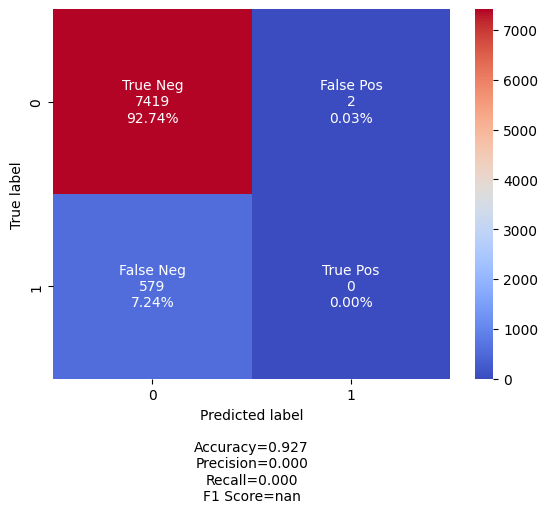

In [ ]:
# view confusion matrix
# the F1-score doesn't show but that's ok
cf_matrix_1=confusion_matrix(y_1_test,y_1_pred)
labels=['True Neg','False Pos','False Neg','True Pos']
make_confusion_matrix(cf=cf_matrix_1,
                      group_names=labels,
                      cmap='coolwarm')

In [ ]:
# view F1-score
creport=classification_report(y_test,y_1_pred)
print(creport)

              precision    recall  f1-score   support

          no       0.93      1.00      0.96      7421
         yes       0.00      0.00      0.00       579

    accuracy                           0.93      8000
   macro avg       0.46      0.50      0.48      8000
weighted avg       0.86      0.93      0.89      8000



Although we are able to get great accuracy for class 0 ('no'), we were not able to get a good accuracy for class 1 ('yes').

## Modeling: Layer 1

### Prepare Dataset for Modeling

Split data into training, validation, and testing sets:

In [507]:
data=pd.concat([X_1,y],axis=1)
data

age           job   marital  education default  balance housing loan  y
0       58    management   married   tertiary      no     2143     yes   no  0
1       44    technician    single  secondary      no       29     yes   no  0
2       33  entrepreneur   married  secondary      no        2     yes  yes  0
3       47   blue-collar   married    unknown      no     1506     yes   no  0
4       33       unknown    single    unknown      no        1      no   no  0
...    ...           ...       ...        ...     ...      ...     ...  ... ..
39995   53    technician   married   tertiary      no      395      no   no  0
39996   30    management    single   tertiary      no     3340      no   no  1
39997   54         admin  divorced  secondary      no      200      no   no  1
39998   34    management   married   tertiary      no     1047      no   no  0
39999   38    technician   married  secondary      no     1442     yes   no  0

[40000 rows x 9 columns]

Create function to speed up preparing data for modeling going forward:

In [508]:
cat_cols = list(X_1.select_dtypes(include='object').columns)
num_cols = list(X_1.select_dtypes(exclude='object').columns)

num_cols

['age', 'balance']

In [509]:
cat_cols

['job', 'marital', 'education', 'default', 'housing', 'loan']

### Define and Run Functions for Modeling with a Pipeline

Define code for preprocessing, modeling, and evaluation:

In [438]:
classifier_map={
    'etc':ExtraTreeClassifier(random_state=seed),
    'xgb':XGBClassifier(random_state=seed),
    'dtc':DecisionTreeClassifier(random_state=seed),
    'rfc':RandomForestClassifier(random_state=seed),
    'lgb':LGBMClassifier(random_state=seed,verbose=-1),
    'lrx':LogisticRegression(random_state=seed)
}

In [394]:
# Step 1: Splitting the data
def split_data(data, target_column_name, test_size=0.2, random_state=seed):
    X = data.drop(columns=[target_column_name])
    y = data[target_column_name]
    print('Data is split')
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Step 2: Create a function to build the pipeline
def create_pipeline(model, cat_cols, random_state=seed):
    # ColumnTransformer: Handle categorical and numerical preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ~X_train.columns.isin(cat_cols)),  # Scale numerical columns
            ('cat', OneHotEncoder(drop='first'), cat_cols)               # One-hot encode categorical columns
        ]
    )

    # RandomOverSampler for balancing the data
    oversampler = RandomOverSampler(sampling_strategy='minority',random_state=random_state)

    # Full pipeline with preprocessing, oversampling, and classifier
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('oversampler', oversampler),
        ('classifier', model)
    ])
    print('Pipeline is created')
    return pipeline

# Step 3: Evaluating the model with cross-validation
def evaluate_model(pipeline, X_train, y_train,random_state=seed):
    print('Evaluating model...')
    # kf = KFold(n_splits=5, shuffle=True, random_state=random_state)  # No stratification
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state) # With stratification
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='recall')
    print(f"Cross-validation recall scores: {scores}")
    print(f"Mean recall: {scores.mean():.4f}")

# Step 4: Final evaluation on the test set
def final_evaluation(pipeline, X_train, y_train, X_test, y_test):
    print('Fitting model...')
    pipeline.fit(X_train, y_train)  # Fit on the full training data

    print('Making predictions on training set...')
    y_train_pred = pipeline.predict(X_train)
    print("\nTraining Set Evaluation:")
    print(classification_report(y_train, y_train_pred))
    
    print('Making predictions on testing set...')
    y_test_pred = pipeline.predict(X_test)
    print("\nTest Set Evaluation:")
    print(classification_report(y_test, y_test_pred))

    # If the model supports feature importances, plot them
    if hasattr(pipeline.named_steps['classifier'], 'feature_importances_'):
        importances = pipeline.named_steps['classifier'].feature_importances_
        feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
        plot_feature_importances(importances, feature_names)

# Step 5: Plotting feature importances (if applicable)
def plot_feature_importances(importances, feature_names):
    feature_importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
    plt.title('Feature Importances')
    plt.show()

### Trying things

In [ ]:
# Split data into features and target
X = data.drop(columns=[target_column_name])
y = data[target_column_name]

# Define column transformer with OneHotEncoder and StandardScaler
col_transformer = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Define the full pipeline with RandomOverSampler and model
pipeline = ImbPipeline(steps=[
    ('col_transformer', col_transformer),  # Preprocessing
    # ('sampler', RandomUnderSampler(sampling_strategy='majority',random_state=seed)),  # Undersampling
    ('sampler', RandomOverSampler(sampling_strategy='minority',random_state=seed)),  # Oversampling
    ('model', SGDClassifier(random_state=seed))  # Classifier
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=random_state, test_size=0.33)#, stratify=y)


# Apply oversampling on the training data only
# rs=RandomUnderSampler(random_state=seed,sampling_strategy='majority')
rs=RandomOverSampler(random_state=seed,sampling_strategy='minority')
# X_train_resampled, y_train_resampled = rs.fit_resample(X_train, y_train)
X_train, y_train = rs.fit_resample(X_train, y_train)

# Train the pipeline on the resampled data
pipeline.fit(X_train, y_train)

# Perform cross-validation on the resampled data
results = cross_validate(pipeline, X_train, y_train, return_train_score=True)

print(f"\nAverage Train Score: {results['train_score'].mean() * 100:.2f}%")
print(f"Average Test Score:  {results['test_score'].mean() * 100:.2f}%")
print('\n')

# Predict on the test data
y_train_pred=pipeline.predict(X_train)
y_test_pred=pipeline.predict(X_test)

# Print classification report
print("Classification Report on Train Set:")
print(classification_report(y_train, y_train_pred))

print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

In [496]:
# Split data into features and target
X = data.drop(columns=[target_column_name])
y = data[target_column_name]

# Define column transformer with OneHotEncoder and StandardScaler
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('scaler', StandardScaler(), num_cols)
])

# Define the full pipeline with RandomOverSampler and model
pipeline = ImbPipeline(steps=[
    ('col_transformer', col_transformer),  # Preprocessing
    ('sampler', RandomOverSampler(random_state=seed)),  # Oversampling
    ('model', SGDClassifier(random_state=seed))  # Classifier
])

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=random_state, test_size=test_size, stratify=y
)

# Apply oversampling on the training data only
ros = RandomOverSampler(random_state=seed)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Perform cross-validation on the resampled data
results = cross_validate(pipeline, X_resampled, y_resampled, return_train_score=True)

print(f"Average Train Score: {results['train_score'].mean()*100:.2f}%")
print(f"Average Test Score:  {results['test_score'].mean()*100:.2f}%")

Average Train Score: 57.75%
Average Test Score:  57.56%


In [492]:
X = data.drop(columns=[target_column_name])
y = data[target_column_name]

In [468]:
Counter(y)

Counter({0: 37104, 1: 2896})

In [458]:
col_transformer=ColumnTransformer(transformers=[
    ('ohe',OneHotEncoder(handle_unknown='ignore'),cat_cols),
    ('scaler',StandardScaler(),num_cols)
])

In [477]:
pipeline=ImbPipeline(steps=[
    ('col_transformer',col_transformer),
    ('sampler',RandomOverSampler(sampling_strategy='minority')),
    ('model',SGDClassifier(random_state=seed))
])

In [478]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=random_state, test_size=test_size, stratify=y
)

In [484]:
results=cross_validate(pipeline,X_train,y_train,return_train_score=True)
results

{'fit_time': array([0.10930705, 0.14262295, 0.12959599, 0.11741376, 0.11627078]),
 'score_time': array([0.00965905, 0.0089879 , 0.01074004, 0.00825334, 0.00969911]),
 'test_score': array([0.67178571, 0.56714286, 0.66178571, 0.63696429, 0.43125   ]),
 'train_score': array([0.67026786, 0.56794643, 0.65995536, 0.63254464, 0.440625  ])}

In [485]:
print(f"Average Train Score: {results['train_score'].mean()}")
print(f"Average Test Score:  {results['test_score'].mean()}")

Average Train Score: 0.5942678571428571
Average Test Score:  0.5937857142857144


In [451]:
# def split_data(X, y, random_state, test_size):
#     return train_test_split(X,y,random_state=random_state,test_size=test_size,stratify=y)

def oversample_data(X_train, y_train, random_state):
    ros = RandomOverSampler(random_state=random_state)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

def get_onehot_transformer(X):
    # Identify categorical and numerical columns
    categorical_features = X.select_dtypes(include=['object', 'category']).columns
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

    # Define the ColumnTransformer with StandardScaler and OneHotEncoder
    transformer = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'  # Keep any columns not specified
    )
    return transformer


def build_pipeline(classifier=None):
    if classifier is None:
        classifier = RandomForestClassifier(random_state=42)

    pipeline = Pipeline(steps=[
        ('preprocessor', None),  # Placeholder, updated later with OneHotEncoder
        ('classifier', classifier)
    ])
    return pipeline

def evaluate_model(pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    print("Training Classification Report:\n", classification_report(y_train, y_train_pred))
    print("Testing Classification Report:\n", classification_report(y_test, y_test_pred))

def run_cross_validation(X_train,y_train,X_test,y_test,random_state,test_size=0.2,classifier=None):
    # 1. Split the data
    # X_train, X_test, y_train, y_test = split_data(X, y, test_size,random_state)

    # 2. Oversample the training data
    X_train_resampled, y_train_resampled = oversample_data(X_train, y_train,random_state=random_state)

    # 3. Build and prepare the pipeline
    pipeline = build_pipeline(classifier)
    transformer = get_onehot_transformer(X_train_resampled)
    pipeline.set_params(preprocessor=transformer)

    # 4. Evaluate the model
    evaluate_model(pipeline, X_train_resampled, y_train_resampled, X_test, y_test)
    
def run_cross_validation(X, y, random_state, test_size=0.2, classifier=None):
    # 1. Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=random_state, test_size=test_size, stratify=y
    )

    # 2. Oversample the training data
    X_train_resampled, y_train_resampled = oversample_data(X_train, y_train, random_state=random_state)

    # 3. Build and prepare the pipeline
    pipeline = build_pipeline(classifier)
    transformer = get_onehot_transformer(X_train_resampled)
    pipeline.set_params(preprocessor=transformer)

    # 4. Evaluate the model
    evaluate_model(pipeline, X_train_resampled, y_train_resampled, X_test, y_test)

In [452]:
target_column_name = 'y'

X = data.drop(columns=[target_column_name])
y = data[target_column_name]

test_size = 0.3

# Run the cross-validation process
run_cross_validation(X, y, random_state=seed, test_size=test_size)

Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     25973
           1       0.99      1.00      1.00     25973

    accuracy                           1.00     51946
   macro avg       1.00      1.00      1.00     51946
weighted avg       1.00      1.00      1.00     51946

Testing Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94     11131
           1       0.15      0.12      0.13       869

    accuracy                           0.89     12000
   macro avg       0.54      0.53      0.54     12000
weighted avg       0.88      0.89      0.88     12000



In [455]:
def get_onehot_transformer(X):
    categorical_features = X.select_dtypes(include=['object', 'category']).columns
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

    transformer = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'
    )
    return transformer

def build_pipeline(classifier=None, random_state=None):
    if classifier is None:
        classifier = RandomForestClassifier(random_state=random_state)

    # Create the full pipeline including the oversampler
    pipeline = Pipeline(steps=[
        ('preprocessor', None),  # Placeholder for the transformer
        ('oversampler', RandomOverSampler(random_state=random_state)),
        ('classifier', classifier)
    ])
    return pipeline

def evaluate_model_with_cv(X, y, classifier=None, random_state=42, n_splits=5):
    pipeline = build_pipeline(classifier, random_state=random_state)
    transformer = get_onehot_transformer(X)
    pipeline.set_params(preprocessor=transformer)

    # Use StratifiedKFold to ensure balanced class distribution in each fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Use recall score as a metric for imbalanced data
    scorer = make_scorer(recall_score, average='macro')

    # Perform cross-validation and print results
    print("Evaluating with cross-validation...")
    scores = cross_val_score(pipeline, X, y, cv=skf, scoring=scorer)
    print(f"Recall scores for each fold: {scores}")
    print(f"Mean recall: {scores.mean():.4f}")

def run_final_evaluation(X_train, y_train, X_test, y_test, classifier=None, random_state=42):
    pipeline = build_pipeline(classifier, random_state=random_state)
    transformer = get_onehot_transformer(X_train)
    pipeline.set_params(preprocessor=transformer)

    # Fit the model on the oversampled training data
    pipeline.fit(X_train, y_train)

    # Evaluate on both the training and test sets
    print("\nTraining Set Evaluation:")
    y_train_pred = pipeline.predict(X_train)
    print(classification_report(y_train, y_train_pred))

    print("\nTest Set Evaluation:")
    y_test_pred = pipeline.predict(X_test)
    print(classification_report(y_test, y_test_pred))

target_column_name = 'y'
X = data.drop(columns=[target_column_name])
y = data[target_column_name]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed, stratify=y
)

# Perform cross-validation on the full dataset
evaluate_model_with_cv(X, y, random_state=seed)

# Run final evaluation on the test set
run_final_evaluation(X_train, y_train, X_test, y_test, random_state=seed)

Evaluating with cross-validation...


TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'RandomOverSampler(random_state=4769)' (type <class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'>) doesn't

### Trying things (end)

In [407]:
# Step 1: Splitting the data
def split_data(data, target_column_name, test_size=0.2, random_state=None):
    X = data.drop(columns=[target_column_name])
    y = data[target_column_name]
    print('Data is split')
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Step 2: Create a function to build the pipeline
def create_pipeline(model, cat_cols, random_state=None):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ~X_train.columns.isin(cat_cols)),  # Scale numerical columns
            ('cat', OneHotEncoder(drop='first'), cat_cols)               # One-hot encode categorical columns
        ]
    )

    oversampler = RandomOverSampler(sampling_strategy='minority', random_state=random_state)

    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('oversampler', oversampler),
        ('classifier', model)
    ])
    print('Pipeline is created')
    return pipeline

# Step 3: Custom Cross-Validation Loop with Oversampling
def evaluate_model(pipeline, X_train, y_train, random_state=None):
    print('Evaluating model with cross_val_score...')
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    # Use recall as the scoring metric
    recall = make_scorer(recall_score, pos_label=1)

    # Cross-validation with oversampling applied within each fold
    scores = cross_val_score(pipeline, X_train, y_train, scoring=recall, cv=skf)

    print(f"Cross-validation recall scores: {scores}")
    print(f"Mean recall: {np.mean(scores):.4f}")
#     print('Evaluating model...')
#     kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

#     scores = []  # Store recall scores for each fold
#     for train_index, test_index in kf.split(X_train):
#         X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
#         y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

#         # Fit the pipeline (including oversampler) to the training fold
#         pipeline.fit(X_train_fold, y_train_fold)

#         # Evaluate on the test fold
#         y_pred = pipeline.predict(X_test_fold)
#         score = recall_score(y_test_fold, y_pred)
#         scores.append(score)

#         print(f"Fold class distribution after oversampling: {Counter(y_train_fold)}")

#     print(f"Cross-validation recall scores: {scores}")
#     print(f"Mean recall: {np.mean(scores):.4f}")

# Step 4: Final evaluation on the test set
def final_evaluation(pipeline, X_train, y_train, X_test, y_test):
    print('Fitting model...')
    pipeline.fit(X_train, y_train)

    print('Making predictions on training set...')
    y_train_pred = pipeline.predict(X_train)
    print("\nTraining Set Evaluation:")
    print(classification_report(y_train, y_train_pred))

    print('Making predictions on testing set...')
    y_test_pred = pipeline.predict(X_test)
    print("\nTest Set Evaluation:")
    print(classification_report(y_test, y_test_pred))
    
    # If the model supports feature importances, plot them
    if hasattr(pipeline.named_steps['classifier'], 'feature_importances_'):
        importances = pipeline.named_steps['classifier'].feature_importances_
        feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
        plot_feature_importances(importances, feature_names)

# Step 5: Plotting feature importances (if applicable)
def plot_feature_importances(importances, feature_names):
    feature_importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
    plt.title('Feature Importances')
    plt.show()

Data is split
(32000,)
Counter({0: 29683, 1: 2317})

Evaluating etc...
Pipeline is created
Counter({0: 29683, 1: 2317})
Evaluating model with cross_val_score...
Cross-validation recall scores: [0.12526998 0.11015119 0.17926566 0.11637931 0.12284483]
Mean recall: 0.1308
Counter({0: 29683, 1: 2317})
Fitting model...
Making predictions on training set...

Training Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     29683
           1       0.88      1.00      0.94      2317

    accuracy                           0.99     32000
   macro avg       0.94      0.99      0.97     32000
weighted avg       0.99      0.99      0.99     32000

Making predictions on testing set...

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7421
           1       0.14      0.15      0.14       579

    accuracy                           0.87      8000
   macro avg    

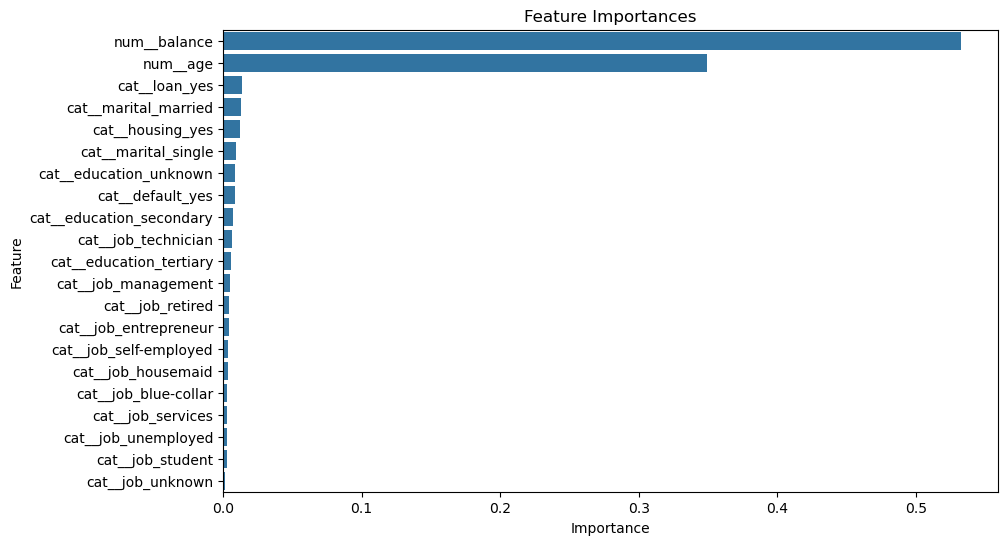


Evaluating xgb...
Pipeline is created
Counter({0: 29683, 1: 2317})
Evaluating model with cross_val_score...
Cross-validation recall scores: [0.30021598 0.37365011 0.38228942 0.35344828 0.32112069]
Mean recall: 0.3461
Counter({0: 29683, 1: 2317})
Fitting model...
Making predictions on training set...

Training Set Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.79      0.88     29683
           1       0.24      0.84      0.37      2317

    accuracy                           0.80     32000
   macro avg       0.61      0.82      0.63     32000
weighted avg       0.93      0.80      0.84     32000

Making predictions on testing set...

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.94      0.76      0.84      7421
           1       0.10      0.35      0.16       579

    accuracy                           0.73      8000
   macro avg       0.52      0.55      0.50      8000
weighted avg  

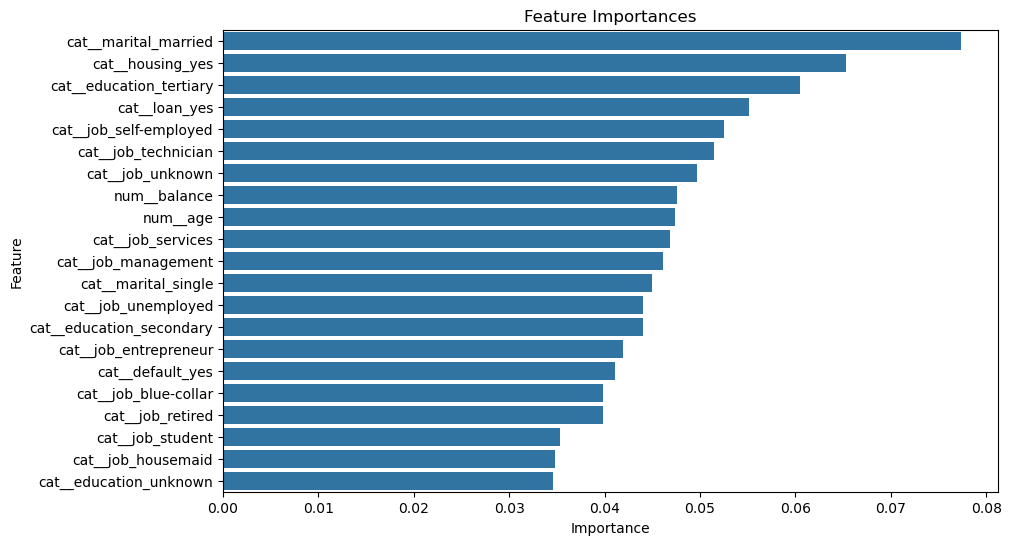


Evaluating dtc...
Pipeline is created
Counter({0: 29683, 1: 2317})
Evaluating model with cross_val_score...


KeyboardInterrupt: 

In [408]:
target_column_name = 'y'

# Split the data
X_train, X_test, y_train, y_test = split_data(data, target_column_name,random_state=seed)
print(y_train.shape)
print(Counter(y_train))

# Evaluate models
for model_name, model in classifier_map.items():
    print(f"\nEvaluating {model_name}...")
    
    # Create a pipeline for each model
    pipeline = create_pipeline(model, cat_cols,random_state=seed)
    print(Counter(y_train))
    
    # Evaluate using cross-validation on the training set
    evaluate_model(pipeline, X_train, y_train,random_state=seed)
    print(Counter(y_train))
    
    # Perform final evaluation on the test set
    final_evaluation(pipeline, X_train, y_train, X_test, y_test)

print("\nDone!")

This is a good first step - we have classification reports for a suite of algorithms, along with the extracted feature importances for the models that support this feature. After completing this survey, we found that the `RandomForestClassifier` and `LGBMClassifier` performed the best.

Now we can evaluate the RFC model on the test set:

In [212]:
best_model=classifier_map['rfc']
best_model.fit(X_train_resampled,y_train_resampled)
y_test_pred=best_model.predict(X_test_scaled)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7414
           1       0.15      0.12      0.13       586

    accuracy                           0.89      8000
   macro avg       0.54      0.53      0.54      8000
weighted avg       0.87      0.89      0.88      8000



In [226]:
best_model=classifier_map['lgb']
best_model.fit(X_train_resampled,y_train_resampled)
y_test_pred=best_model.predict(X_test_scaled)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.69      0.79      7421
           1       0.07      0.29      0.11       579

    accuracy                           0.66      8000
   macro avg       0.50      0.49      0.45      8000
weighted avg       0.86      0.66      0.74      8000



In [213]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [215]:
model=BalancedRandomForestClassifier(random_state=seed,sampling_strategy='all',replacement=True,bootstrap=False)
model.fit(X_train_resampled,y_train_resampled)
y_test_pred=model.predict(X_test_scaled)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7414
           1       0.15      0.12      0.13       586

    accuracy                           0.89      8000
   macro avg       0.54      0.53      0.54      8000
weighted avg       0.87      0.89      0.88      8000



### Optuna with `LGBMClassifier`, optimizing for accuracy

In [379]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

In [380]:
times={}
results={}
n_trials=1000

In [381]:
target_column_name='y'

# Splitting the data
X_train, X_test, y_train, y_test = split_data(data, target_column_name,random_state=seed)

# Transforming the data
# X_train_scaled, X_test_scaled = transform_data(X_train, X_test, cat_cols)

# Oversampling the training data
# X_train_resampled, y_train_resampled = oversample(X_train_scaled, y_train,random_state=seed)

print('Done!')

Data is split
Done!


In [382]:
# n_trials=2

In [383]:
# Initialize the OneHotEncoder and StandardScaler
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

# Encode categorical features
X_train_encoded = encoder.fit_transform(X_train.select_dtypes(include='object'))
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out())

# Add any non-categorical columns back to the dataset
X_train_combined = pd.concat(
    [X_train_encoded, X_train.select_dtypes(exclude='object').reset_index(drop=True)], 
    axis=1
)

# Apply StandardScaler to the entire dataset
X_train_scaled = scaler.fit_transform(X_train_combined)
X_train = pd.DataFrame(X_train_scaled, columns=X_train_combined.columns)

# Start tracking time
start_time = time.time()

def objective(trial):
    # Define the classifier with conditional parameters
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf'])

    if boosting_type == 'rf':
        bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0)
        bagging_freq = trial.suggest_int('bagging_freq', 1, 10)
        subsample = 1.0  # Random forest uses full subsample
    else:
        subsample = trial.suggest_float('subsample', 1E-2, 1E0, log=True)
        bagging_fraction = None
        bagging_freq = 0

    classifier = LGBMClassifier(
        min_child_samples=trial.suggest_int('min_child_samples', 5, 250),
        verbose=-1,
        boosting_type=boosting_type,
        num_leaves=trial.suggest_int('num_leaves', 10, 500),
        learning_rate=trial.suggest_float('learning_rate', 1E-4, 1E0, log=True),
        n_estimators=trial.suggest_int('n_estimators', 50, 1000),
        max_depth=trial.suggest_int('max_depth', 1, 5),
        subsample=subsample,
        colsample_bytree=trial.suggest_float('colsample_bytree', 1E-2, 1E0, log=True),
        random_state=seed,
        n_jobs=-1,
        reg_alpha=trial.suggest_float('reg_alpha', 1E-3, 1E2, log=True),
        reg_lambda=trial.suggest_float('reg_lambda', 1E-3, 1E2, log=True),
        importance_type=trial.suggest_categorical('importance_type', ['split', 'gain']),
        bagging_fraction=bagging_fraction,
        bagging_freq=bagging_freq
    )

    # Define Stratified K-Fold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    scores = []
    # Cross-validation loop with resampling in each fold
    for train_idx, valid_idx in cv.split(X_train, y_train):
        # Split the data
        X_fold_train, X_fold_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_fold_train, y_fold_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        # Oversample the training data only
        ros = RandomOverSampler(random_state=seed)
        X_fold_train_resampled, y_fold_train_resampled = ros.fit_resample(X_fold_train, y_fold_train)

        # Fit the model on the resampled data
        classifier.fit(X_fold_train_resampled, y_fold_train_resampled)

        # Predict on the validation fold
        y_pred = classifier.predict(X_fold_valid)

        # Calculate accuracy for this fold and store it
        accuracy = accuracy_score(y_fold_valid, y_pred)
        scores.append(accuracy)

    # Return the mean accuracy across all folds
    return np.mean(scores)

# Run the Optuna study
lgb = optuna.create_study(direction='maximize')
lgb.optimize(objective, n_trials=n_trials * 3)

# Track time
end_time = time.time()
elapsed_time = end_time - start_time

# Store results and time tracking
times['lgb_acc'] = {
    'start_time_lgb_acc': start_time,
    'end_time_lgb_acc': end_time,
    'elapsed_time_lgb_acc': elapsed_time
}
results['lgb_acc'] = lgb.best_params

print('Done!')

[I 2024-10-28 19:10:34,415] A new study created in memory with name: no-name-a534a362-0bf9-4541-94b5-ca6d2a15ba37


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:10:39,741] Trial 0 finished with value: 0.6443125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04853505723585239, 'min_child_samples': 147, 'num_leaves': 481, 'learning_rate': 0.1678991361363592, 'n_estimators': 543, 'max_depth': 2, 'colsample_bytree': 0.5359871565753344, 'reg_alpha': 0.004578300428864142, 'reg_lambda': 0.023404137019272412, 'importance_type': 'split'}. Best is trial 0 with value: 0.6443125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:10:42,220] Trial 1 finished with value: 0.5938125 and parameters: {'boosting_type': 'dart', 'subsample': 0.03345269683396057, 'min_child_samples': 161, 'num_leaves': 209, 'learning_rate': 0.010812308288565255, 'n_estimators': 109, 'max_depth': 4, 'colsample_bytree': 0.03690330162803186, 'reg_alpha': 1.004651745144063, 'reg_lambda': 28.798511636755848, 'importance_type': 'gain'}. Best is trial 0 with value: 0.6443125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:10:46,207] Trial 2 finished with value: 0.6278125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6939842388425993, 'min_child_samples': 114, 'num_leaves': 19, 'learning_rate': 0.022413263212662165, 'n_estimators': 171, 'max_depth': 3, 'colsample_bytree': 0.21686433122491885, 'reg_alpha': 0.030123983755822932, 'reg_lambda': 0.013207375528833814, 'importance_type': 'gain'}. Best is trial 0 with value: 0.6443125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:10:50,416] Trial 3 finished with value: 0.60878125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2812489757302372, 'min_child_samples': 15, 'num_leaves': 39, 'learning_rate': 0.06228550752449849, 'n_estimators': 307, 'max_depth': 1, 'colsample_bytree': 0.18912426165160717, 'reg_alpha': 59.89917717242811, 'reg_lambda': 0.546217472297066, 'importance_type': 'gain'}. Best is trial 0 with value: 0.6443125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:10:55,665] Trial 4 finished with value: 0.63765625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06829499309232076, 'min_child_samples': 9, 'num_leaves': 94, 'learning_rate': 0.8840518640879674, 'n_estimators': 420, 'max_depth': 5, 'colsample_bytree': 0.08744185557118937, 'reg_alpha': 7.0362509653901135, 'reg_lambda': 77.27437484406703, 'importance_type': 'gain'}. Best is trial 0 with value: 0.6443125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:11:09,685] Trial 5 finished with value: 0.6208750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08250449801197808, 'min_child_samples': 17, 'num_leaves': 144, 'learning_rate': 0.0008868519523080491, 'n_estimators': 644, 'max_depth': 5, 'colsample_bytree': 0.10880791583590145, 'reg_alpha': 3.38292826316647, 'reg_lambda': 0.1358248496447872, 'importance_type': 'gain'}. Best is trial 0 with value: 0.6443125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:11:15,229] Trial 6 finished with value: 0.606625 and parameters: {'boosting_type': 'dart', 'subsample': 0.35879661664502677, 'min_child_samples': 111, 'num_leaves': 315, 'learning_rate': 0.0036061729714678293, 'n_estimators': 259, 'max_depth': 3, 'colsample_bytree': 0.014299962248795284, 'reg_alpha': 2.715470762688445, 'reg_lambda': 0.059188224496185694, 'importance_type': 'split'}. Best is trial 0 with value: 0.6443125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:11:20,239] Trial 7 finished with value: 0.613875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0434054034557748, 'min_child_samples': 72, 'num_leaves': 119, 'learning_rate': 0.0006751450866713226, 'n_estimators': 326, 'max_depth': 2, 'colsample_bytree': 0.47841888987296133, 'reg_alpha': 0.20675653109560527, 'reg_lambda': 9.44485599163061, 'importance_type': 'split'}. Best is trial 0 with value: 0.6443125.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.6218837930625409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6218837930625409
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.6218837930625409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6218837930625409
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.6218837930625409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6218837930625409
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.6218837930625409, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 19:11:26,391] Trial 8 finished with value: 0.6244999999999999 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6218837930625409, 'bagging_freq': 8, 'min_child_samples': 112, 'num_leaves': 18, 'learning_rate': 0.494654819325607, 'n_estimators': 629, 'max_depth': 2, 'colsample_bytree': 0.6867565760636838, 'reg_alpha': 34.13817020665253, 'reg_lambda': 0.19193106003076277, 'importance_type': 'split'}. Best is trial 0 with value: 0.6443125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:11:30,426] Trial 9 finished with value: 0.62225 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0503609293614873, 'min_child_samples': 193, 'num_leaves': 163, 'learning_rate': 0.012804380527961989, 'n_estimators': 250, 'max_depth': 5, 'colsample_bytree': 0.12448781679858782, 'reg_alpha': 0.3625822019225057, 'reg_lambda': 3.037503209555388, 'importance_type': 'split'}. Best is trial 0 with value: 0.6443125.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.19800095813737928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19800095813737928
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.19800095813737928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19800095813737928
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.19800095813737928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19800095813737928
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.19800095813737928, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-28 19:11:39,139] Trial 10 finished with value: 0.59446875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.19800095813737928, 'bagging_freq': 1, 'min_child_samples': 214, 'num_leaves': 495, 'learning_rate': 0.10845359007747554, 'n_estimators': 973, 'max_depth': 1, 'colsample_bytree': 0.9792690383735607, 'reg_alpha': 0.0010117963855098204, 'reg_lambda': 0.0013002593388301601, 'importance_type': 'split'}. Best is trial 0 with value: 0.6443125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:11:43,904] Trial 11 finished with value: 0.6235625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012543019003871394, 'min_child_samples': 61, 'num_leaves': 334, 'learning_rate': 0.947651135061081, 'n_estimators': 494, 'max_depth': 4, 'colsample_bytree': 0.04517216095381117, 'reg_alpha': 0.0015374589467861892, 'reg_lambda': 99.30543599984307, 'importance_type': 'gain'}. Best is trial 0 with value: 0.6443125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:11:48,987] Trial 12 finished with value: 0.62209375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.147331351196624, 'min_child_samples': 162, 'num_leaves': 489, 'learning_rate': 0.19377494593352163, 'n_estimators': 482, 'max_depth': 2, 'colsample_bytree': 0.046524906823443145, 'reg_alpha': 0.016140651265964197, 'reg_lambda': 0.008341758275640388, 'importance_type': 'split'}. Best is trial 0 with value: 0.6443125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:12:01,803] Trial 13 finished with value: 0.6595937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015396306400974039, 'min_child_samples': 249, 'num_leaves': 393, 'learning_rate': 0.3184472668328534, 'n_estimators': 838, 'max_depth': 4, 'colsample_bytree': 0.3189343106215451, 'reg_alpha': 11.959745293446419, 'reg_lambda': 1.2276906629708721, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.994785030500573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.994785030500573
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.994785030500573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.994785030500573
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.994785030500573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.994785030500573
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.994785030500573, subsample=1.0 will be ignored. Current value: bagging_fractio

[I 2024-10-28 19:12:28,480] Trial 14 finished with value: 0.6363437500000001 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.994785030500573, 'bagging_freq': 10, 'min_child_samples': 246, 'num_leaves': 401, 'learning_rate': 0.0001450126590664397, 'n_estimators': 884, 'max_depth': 4, 'colsample_bytree': 0.34515596677031213, 'reg_alpha': 0.009160285679687935, 'reg_lambda': 1.1331638998680482, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:13:50,228] Trial 15 finished with value: 0.6522499999999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.011223086285738123, 'min_child_samples': 227, 'num_leaves': 409, 'learning_rate': 0.2535963319674451, 'n_estimators': 755, 'max_depth': 3, 'colsample_bytree': 0.3465630615536207, 'reg_alpha': 0.09252651284004798, 'reg_lambda': 0.02922666076428944, 'importance_type': 'split'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:15:25,921] Trial 16 finished with value: 0.65359375 and parameters: {'boosting_type': 'dart', 'subsample': 0.010867055342194445, 'min_child_samples': 249, 'num_leaves': 402, 'learning_rate': 0.04791018029992166, 'n_estimators': 795, 'max_depth': 4, 'colsample_bytree': 0.2922624269377135, 'reg_alpha': 0.0947618929399893, 'reg_lambda': 0.0027085543503466477, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:16:25,557] Trial 17 finished with value: 0.6470312500000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.018817881721737054, 'min_child_samples': 187, 'num_leaves': 288, 'learning_rate': 0.04080310629926546, 'n_estimators': 807, 'max_depth': 4, 'colsample_bytree': 0.22169115178797189, 'reg_alpha': 12.718320413988128, 'reg_lambda': 0.0023109405934779587, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:18:11,158] Trial 18 finished with value: 0.64046875 and parameters: {'boosting_type': 'dart', 'subsample': 0.02306415296982276, 'min_child_samples': 248, 'num_leaves': 377, 'learning_rate': 0.004289499037361997, 'n_estimators': 986, 'max_depth': 4, 'colsample_bytree': 0.31887959994831505, 'reg_alpha': 0.8480164379185209, 'reg_lambda': 2.3206836225999874, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:18:45,603] Trial 19 finished with value: 0.62371875 and parameters: {'boosting_type': 'dart', 'subsample': 0.0182949570006311, 'min_child_samples': 208, 'num_leaves': 259, 'learning_rate': 0.056093173316271866, 'n_estimators': 712, 'max_depth': 5, 'colsample_bytree': 0.08202974547598049, 'reg_alpha': 0.07313541928060704, 'reg_lambda': 0.005713030143779812, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:19:38,516] Trial 20 finished with value: 0.6581875 and parameters: {'boosting_type': 'dart', 'subsample': 0.010197755519738772, 'min_child_samples': 229, 'num_leaves': 434, 'learning_rate': 0.3276907287803321, 'n_estimators': 863, 'max_depth': 3, 'colsample_bytree': 0.9593467295383828, 'reg_alpha': 19.19483000444306, 'reg_lambda': 6.808029652437281, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:21:06,440] Trial 21 finished with value: 0.6550625 and parameters: {'boosting_type': 'dart', 'subsample': 0.010871697384381224, 'min_child_samples': 232, 'num_leaves': 421, 'learning_rate': 0.3550638421505345, 'n_estimators': 875, 'max_depth': 3, 'colsample_bytree': 0.7828485461741045, 'reg_alpha': 18.77921909932653, 'reg_lambda': 7.701938947669224, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:22:23,369] Trial 22 finished with value: 0.65421875 and parameters: {'boosting_type': 'dart', 'subsample': 0.02547372418568846, 'min_child_samples': 223, 'num_leaves': 445, 'learning_rate': 0.47405786549056583, 'n_estimators': 860, 'max_depth': 3, 'colsample_bytree': 0.783484259115255, 'reg_alpha': 24.44760136646355, 'reg_lambda': 8.847492949418927, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:23:41,276] Trial 23 finished with value: 0.62978125 and parameters: {'boosting_type': 'dart', 'subsample': 0.015538045908129426, 'min_child_samples': 190, 'num_leaves': 362, 'learning_rate': 0.4055757612648003, 'n_estimators': 902, 'max_depth': 3, 'colsample_bytree': 0.6013131070096666, 'reg_alpha': 98.30763588335502, 'reg_lambda': 8.366748563863506, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:24:35,058] Trial 24 finished with value: 0.64815625 and parameters: {'boosting_type': 'dart', 'subsample': 0.01017824210482761, 'min_child_samples': 231, 'num_leaves': 455, 'learning_rate': 0.12149610811317557, 'n_estimators': 691, 'max_depth': 3, 'colsample_bytree': 0.9379388898530767, 'reg_alpha': 11.178770275878561, 'reg_lambda': 0.628551283090886, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.11321301072627366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11321301072627366
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.11321301072627366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11321301072627366
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.11321301072627366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11321301072627366
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.11321301072627366, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-28 19:24:43,445] Trial 25 finished with value: 0.606875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.11321301072627366, 'bagging_freq': 3, 'min_child_samples': 200, 'num_leaves': 438, 'learning_rate': 0.400949594702212, 'n_estimators': 936, 'max_depth': 3, 'colsample_bytree': 0.4793749923517121, 'reg_alpha': 5.7104519713579975, 'reg_lambda': 22.69699069995616, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:25:29,676] Trial 26 finished with value: 0.6441875 and parameters: {'boosting_type': 'dart', 'subsample': 0.02938115321970156, 'min_child_samples': 176, 'num_leaves': 353, 'learning_rate': 0.9870424629691152, 'n_estimators': 848, 'max_depth': 2, 'colsample_bytree': 0.7200023021101026, 'reg_alpha': 22.640461904695133, 'reg_lambda': 2.418666270556861, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:26:27,249] Trial 27 finished with value: 0.65334375 and parameters: {'boosting_type': 'dart', 'subsample': 0.017319804090624252, 'min_child_samples': 231, 'num_leaves': 421, 'learning_rate': 0.09539434442992002, 'n_estimators': 595, 'max_depth': 4, 'colsample_bytree': 0.44320172223318316, 'reg_alpha': 2.0056422705557586, 'reg_lambda': 5.381759452457513, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.9445319926623128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9445319926623128
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.9445319926623128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9445319926623128
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.9445319926623128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9445319926623128
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.9445319926623128, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 19:26:37,615] Trial 28 finished with value: 0.62384375 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9445319926623128, 'bagging_freq': 6, 'min_child_samples': 212, 'num_leaves': 302, 'learning_rate': 0.02488976209735872, 'n_estimators': 754, 'max_depth': 4, 'colsample_bytree': 0.16792817576630042, 'reg_alpha': 46.81346780998198, 'reg_lambda': 26.83112839843514, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:28:00,053] Trial 29 finished with value: 0.64978125 and parameters: {'boosting_type': 'dart', 'subsample': 0.1323121604230489, 'min_child_samples': 133, 'num_leaves': 462, 'learning_rate': 0.21321186243051166, 'n_estimators': 939, 'max_depth': 3, 'colsample_bytree': 0.5715934521216122, 'reg_alpha': 16.21637818929991, 'reg_lambda': 0.9143355835587373, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:28:05,283] Trial 30 finished with value: 0.65278125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01569794393216207, 'min_child_samples': 173, 'num_leaves': 245, 'learning_rate': 0.2573662324772709, 'n_estimators': 823, 'max_depth': 2, 'colsample_bytree': 0.9820274053466319, 'reg_alpha': 1.3447416016948814, 'reg_lambda': 0.23574646615563988, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:29:11,880] Trial 31 finished with value: 0.62946875 and parameters: {'boosting_type': 'dart', 'subsample': 0.025573547630147977, 'min_child_samples': 225, 'num_leaves': 458, 'learning_rate': 0.39278822558817966, 'n_estimators': 866, 'max_depth': 3, 'colsample_bytree': 0.7645221208008846, 'reg_alpha': 99.8400305163679, 'reg_lambda': 15.254898143241299, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:30:07,490] Trial 32 finished with value: 0.6461250000000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.022773933893182913, 'min_child_samples': 236, 'num_leaves': 433, 'learning_rate': 0.5165322751272051, 'n_estimators': 752, 'max_depth': 3, 'colsample_bytree': 0.4068960790890622, 'reg_alpha': 28.891676614920506, 'reg_lambda': 4.3872500746795255, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:31:31,115] Trial 33 finished with value: 0.6506875000000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.014832403905818572, 'min_child_samples': 218, 'num_leaves': 377, 'learning_rate': 0.16852312774003705, 'n_estimators': 996, 'max_depth': 3, 'colsample_bytree': 0.7300270701700508, 'reg_alpha': 5.817893529226208, 'reg_lambda': 50.55560830455058, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:32:50,703] Trial 34 finished with value: 0.6486875 and parameters: {'boosting_type': 'dart', 'subsample': 0.03670125424175615, 'min_child_samples': 147, 'num_leaves': 466, 'learning_rate': 0.08911779975972335, 'n_estimators': 912, 'max_depth': 3, 'colsample_bytree': 0.5604684055789043, 'reg_alpha': 11.61140485756329, 'reg_lambda': 1.5016026333904393, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:32:52,238] Trial 35 finished with value: 0.6352187499999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.010199935107796085, 'min_child_samples': 206, 'num_leaves': 392, 'learning_rate': 0.6590082720972015, 'n_estimators': 75, 'max_depth': 4, 'colsample_bytree': 0.254053079933975, 'reg_alpha': 47.35704602398292, 'reg_lambda': 10.11114073587589, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:32:55,404] Trial 36 finished with value: 0.6237812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.054038696616970014, 'min_child_samples': 239, 'num_leaves': 435, 'learning_rate': 0.30477030628352286, 'n_estimators': 572, 'max_depth': 1, 'colsample_bytree': 0.1456769011397905, 'reg_alpha': 5.208820218938115, 'reg_lambda': 41.204091563780956, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:33:22,099] Trial 37 finished with value: 0.63496875 and parameters: {'boosting_type': 'dart', 'subsample': 0.0322094604996324, 'min_child_samples': 94, 'num_leaves': 331, 'learning_rate': 0.02368984606191416, 'n_estimators': 656, 'max_depth': 2, 'colsample_bytree': 0.7820161235986794, 'reg_alpha': 0.49315098229056226, 'reg_lambda': 0.52346780155531, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:33:26,559] Trial 38 finished with value: 0.6216875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02292456302838434, 'min_child_samples': 218, 'num_leaves': 494, 'learning_rate': 0.1419369625147999, 'n_estimators': 850, 'max_depth': 3, 'colsample_bytree': 0.011645742802285248, 'reg_alpha': 20.973017213705756, 'reg_lambda': 5.856846790594824, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:33:30,545] Trial 39 finished with value: 0.6251249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012912999504115579, 'min_child_samples': 34, 'num_leaves': 355, 'learning_rate': 0.6579721268166367, 'n_estimators': 778, 'max_depth': 5, 'colsample_bytree': 0.019054287960954642, 'reg_alpha': 3.746271503120832, 'reg_lambda': 14.824194667500173, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:34:34,861] Trial 40 finished with value: 0.6465 and parameters: {'boosting_type': 'dart', 'subsample': 0.7001161845154829, 'min_child_samples': 178, 'num_leaves': 472, 'learning_rate': 0.00755066969229216, 'n_estimators': 700, 'max_depth': 4, 'colsample_bytree': 0.4191845844554764, 'reg_alpha': 9.33729067037353, 'reg_lambda': 0.1252109832131585, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:36:06,841] Trial 41 finished with value: 0.6524062500000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.01003673073745196, 'min_child_samples': 246, 'num_leaves': 394, 'learning_rate': 0.042680203070007874, 'n_estimators': 809, 'max_depth': 4, 'colsample_bytree': 0.2809536132518102, 'reg_alpha': 0.1314523570434467, 'reg_lambda': 3.435275665678032, 'importance_type': 'gain'}. Best is trial 13 with value: 0.6595937500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:37:41,320] Trial 42 finished with value: 0.66196875 and parameters: {'boosting_type': 'dart', 'subsample': 0.014105015745219687, 'min_child_samples': 248, 'num_leaves': 438, 'learning_rate': 0.08830703477549527, 'n_estimators': 939, 'max_depth': 4, 'colsample_bytree': 0.6117402789759308, 'reg_alpha': 0.6994281725419846, 'reg_lambda': 1.71200470726788, 'importance_type': 'gain'}. Best is trial 42 with value: 0.66196875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:55:12,276] Trial 43 finished with value: 0.649375 and parameters: {'boosting_type': 'dart', 'subsample': 0.013414061545201401, 'min_child_samples': 235, 'num_leaves': 432, 'learning_rate': 0.07443423487051332, 'n_estimators': 950, 'max_depth': 3, 'colsample_bytree': 0.56297103406595, 'reg_alpha': 2.2834421368040934, 'reg_lambda': 1.5820201431645404, 'importance_type': 'gain'}. Best is trial 42 with value: 0.66196875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:56:03,249] Trial 44 finished with value: 0.64215625 and parameters: {'boosting_type': 'dart', 'subsample': 0.02089596106273839, 'min_child_samples': 222, 'num_leaves': 182, 'learning_rate': 0.642374994501456, 'n_estimators': 882, 'max_depth': 4, 'colsample_bytree': 0.9257560633352573, 'reg_alpha': 62.41370216524415, 'reg_lambda': 0.33587956055706686, 'importance_type': 'split'}. Best is trial 42 with value: 0.66196875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:56:04,613] Trial 45 finished with value: 0.6522812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015233254813832097, 'min_child_samples': 203, 'num_leaves': 59, 'learning_rate': 0.3252590442109206, 'n_estimators': 418, 'max_depth': 5, 'colsample_bytree': 0.6789743175890968, 'reg_alpha': 30.10361442588398, 'reg_lambda': 7.676802802738164, 'importance_type': 'gain'}. Best is trial 42 with value: 0.66196875.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.4840232910180492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4840232910180492
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.4840232910180492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4840232910180492
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.4840232910180492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4840232910180492
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.4840232910180492, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 19:56:08,363] Trial 46 finished with value: 0.6226875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.4840232910180492, 'bagging_freq': 4, 'min_child_samples': 236, 'num_leaves': 414, 'learning_rate': 0.14594056428079696, 'n_estimators': 917, 'max_depth': 3, 'colsample_bytree': 0.8249142006818238, 'reg_alpha': 0.6617472450642173, 'reg_lambda': 2.286954574359033, 'importance_type': 'gain'}. Best is trial 42 with value: 0.66196875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:56:33,774] Trial 47 finished with value: 0.6420625 and parameters: {'boosting_type': 'dart', 'subsample': 0.34158055573692214, 'min_child_samples': 250, 'num_leaves': 499, 'learning_rate': 0.2333771959884916, 'n_estimators': 841, 'max_depth': 2, 'colsample_bytree': 0.37520748681131016, 'reg_alpha': 1.1922226954872348, 'reg_lambda': 3.8536560194024116, 'importance_type': 'split'}. Best is trial 42 with value: 0.66196875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:56:37,567] Trial 48 finished with value: 0.6480625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02833986348508099, 'min_child_samples': 197, 'num_leaves': 448, 'learning_rate': 0.7815852687528966, 'n_estimators': 973, 'max_depth': 4, 'colsample_bytree': 0.07254063575301749, 'reg_alpha': 0.04047591964406869, 'reg_lambda': 14.341413699901754, 'importance_type': 'gain'}. Best is trial 42 with value: 0.66196875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:57:21,011] Trial 49 finished with value: 0.6365000000000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.04242042398546078, 'min_child_samples': 223, 'num_leaves': 371, 'learning_rate': 0.0021615678959933564, 'n_estimators': 880, 'max_depth': 3, 'colsample_bytree': 0.523131077685463, 'reg_alpha': 0.267375171277332, 'reg_lambda': 1.0075512541576497, 'importance_type': 'gain'}. Best is trial 42 with value: 0.66196875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:58:00,474] Trial 50 finished with value: 0.6637812500000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.0649042810640092, 'min_child_samples': 241, 'num_leaves': 418, 'learning_rate': 0.5104841572372946, 'n_estimators': 725, 'max_depth': 3, 'colsample_bytree': 0.6496754205244215, 'reg_alpha': 3.644934165450535, 'reg_lambda': 46.72345384852969, 'importance_type': 'split'}. Best is trial 50 with value: 0.6637812500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:58:30,484] Trial 51 finished with value: 0.6608750000000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.06996708882450377, 'min_child_samples': 240, 'num_leaves': 418, 'learning_rate': 0.5190651317674995, 'n_estimators': 742, 'max_depth': 3, 'colsample_bytree': 0.638275079095424, 'reg_alpha': 8.621221400472786, 'reg_lambda': 62.37281152280848, 'importance_type': 'split'}. Best is trial 50 with value: 0.6637812500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:59:05,188] Trial 52 finished with value: 0.64925 and parameters: {'boosting_type': 'dart', 'subsample': 0.10353651078806064, 'min_child_samples': 240, 'num_leaves': 417, 'learning_rate': 0.18827997670401314, 'n_estimators': 774, 'max_depth': 3, 'colsample_bytree': 0.6104191552828429, 'reg_alpha': 3.658100871856844, 'reg_lambda': 61.69547268069877, 'importance_type': 'split'}. Best is trial 50 with value: 0.6637812500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 19:59:36,006] Trial 53 finished with value: 0.6560312500000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.1924767956400316, 'min_child_samples': 242, 'num_leaves': 330, 'learning_rate': 0.3233587708853228, 'n_estimators': 722, 'max_depth': 3, 'colsample_bytree': 0.4788778310661994, 'reg_alpha': 2.0056457439001902, 'reg_lambda': 37.33221074298878, 'importance_type': 'split'}. Best is trial 50 with value: 0.6637812500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:00:16,992] Trial 54 finished with value: 0.6593125000000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.22316752921662436, 'min_child_samples': 250, 'num_leaves': 333, 'learning_rate': 0.5539094781734306, 'n_estimators': 724, 'max_depth': 4, 'colsample_bytree': 0.20603703964235198, 'reg_alpha': 1.7250764568683887, 'reg_lambda': 82.72757857342009, 'importance_type': 'split'}. Best is trial 50 with value: 0.6637812500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:00:51,015] Trial 55 finished with value: 0.62984375 and parameters: {'boosting_type': 'dart', 'subsample': 0.06686446513287847, 'min_child_samples': 249, 'num_leaves': 389, 'learning_rate': 0.00014093230045680947, 'n_estimators': 652, 'max_depth': 4, 'colsample_bytree': 0.18545610846263394, 'reg_alpha': 1.6272707933650048, 'reg_lambda': 82.39050890091879, 'importance_type': 'split'}. Best is trial 50 with value: 0.6637812500000001.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.6915236135484542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6915236135484542
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.6915236135484542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6915236135484542
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.6915236135484542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6915236135484542
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.6915236135484542, subsample=1.0 will be ignored. Current value: bagging_

[I 2024-10-28 20:00:55,387] Trial 56 finished with value: 0.633 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6915236135484542, 'bagging_freq': 10, 'min_child_samples': 214, 'num_leaves': 385, 'learning_rate': 0.9962982201734806, 'n_estimators': 599, 'max_depth': 5, 'colsample_bytree': 0.23702534969210304, 'reg_alpha': 8.09277464280495, 'reg_lambda': 25.251875056063128, 'importance_type': 'split'}. Best is trial 50 with value: 0.6637812500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:00:58,678] Trial 57 finished with value: 0.68653125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.9932955051736079, 'min_child_samples': 240, 'num_leaves': 275, 'learning_rate': 0.5829650623719775, 'n_estimators': 532, 'max_depth': 4, 'colsample_bytree': 0.3606422915706723, 'reg_alpha': 0.8174809643689819, 'reg_lambda': 79.64916292544702, 'importance_type': 'split'}. Best is trial 57 with value: 0.68653125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:01:00,214] Trial 58 finished with value: 0.6579375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5323930015152503, 'min_child_samples': 241, 'num_leaves': 260, 'learning_rate': 0.5431123524607141, 'n_estimators': 190, 'max_depth': 4, 'colsample_bytree': 0.2978096516661377, 'reg_alpha': 0.6687030793440629, 'reg_lambda': 80.19306594857609, 'importance_type': 'split'}. Best is trial 57 with value: 0.68653125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:01:02,524] Trial 59 finished with value: 0.61559375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.9696588373102807, 'min_child_samples': 250, 'num_leaves': 233, 'learning_rate': 0.0004484699992296453, 'n_estimators': 430, 'max_depth': 4, 'colsample_bytree': 0.11233759888662036, 'reg_alpha': 3.1495281179200454, 'reg_lambda': 55.087810556594235, 'importance_type': 'split'}. Best is trial 57 with value: 0.68653125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:01:05,810] Trial 60 finished with value: 0.6786875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.20030355457950821, 'min_child_samples': 229, 'num_leaves': 310, 'learning_rate': 0.5170634359726594, 'n_estimators': 512, 'max_depth': 4, 'colsample_bytree': 0.35045178184504655, 'reg_alpha': 0.4138498069668369, 'reg_lambda': 94.77574704143207, 'importance_type': 'split'}. Best is trial 57 with value: 0.68653125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:01:08,574] Trial 61 finished with value: 0.684875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2414379120510878, 'min_child_samples': 229, 'num_leaves': 291, 'learning_rate': 0.720259787344126, 'n_estimators': 488, 'max_depth': 4, 'colsample_bytree': 0.33788860076470423, 'reg_alpha': 0.35383176805302446, 'reg_lambda': 97.74767233049286, 'importance_type': 'split'}. Best is trial 57 with value: 0.68653125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:01:11,515] Trial 62 finished with value: 0.6904375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0904911036051501, 'min_child_samples': 227, 'num_leaves': 304, 'learning_rate': 0.7103116248784163, 'n_estimators': 537, 'max_depth': 4, 'colsample_bytree': 0.34414054860168375, 'reg_alpha': 0.1774133404487889, 'reg_lambda': 37.30348424270485, 'importance_type': 'split'}. Best is trial 62 with value: 0.6904375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:01:14,814] Trial 63 finished with value: 0.717625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10807459862491661, 'min_child_samples': 210, 'num_leaves': 289, 'learning_rate': 0.7421849606351442, 'n_estimators': 530, 'max_depth': 5, 'colsample_bytree': 0.3686358427533496, 'reg_alpha': 0.19951509581293939, 'reg_lambda': 32.6365898799991, 'importance_type': 'split'}. Best is trial 63 with value: 0.717625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:01:18,198] Trial 64 finished with value: 0.7119375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09969624363827241, 'min_child_samples': 211, 'num_leaves': 280, 'learning_rate': 0.7800998773628908, 'n_estimators': 522, 'max_depth': 5, 'colsample_bytree': 0.35160767093635514, 'reg_alpha': 0.14409760128400592, 'reg_lambda': 35.4327648850006, 'importance_type': 'split'}. Best is trial 63 with value: 0.717625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:01:21,820] Trial 65 finished with value: 0.7153124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09575428349697894, 'min_child_samples': 185, 'num_leaves': 278, 'learning_rate': 0.7892665858185263, 'n_estimators': 519, 'max_depth': 5, 'colsample_bytree': 0.35120258427680195, 'reg_alpha': 0.15563589315941, 'reg_lambda': 37.11516302607973, 'importance_type': 'split'}. Best is trial 63 with value: 0.717625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:01:25,521] Trial 66 finished with value: 0.71759375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10204872962537433, 'min_child_samples': 163, 'num_leaves': 277, 'learning_rate': 0.8333847847601179, 'n_estimators': 519, 'max_depth': 5, 'colsample_bytree': 0.350477853472697, 'reg_alpha': 0.208430753239904, 'reg_lambda': 31.016383192972015, 'importance_type': 'split'}. Best is trial 63 with value: 0.717625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:01:28,971] Trial 67 finished with value: 0.7074687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10164332223980808, 'min_child_samples': 157, 'num_leaves': 283, 'learning_rate': 0.8011135063669638, 'n_estimators': 466, 'max_depth': 5, 'colsample_bytree': 0.27005256654322696, 'reg_alpha': 0.17300688636739522, 'reg_lambda': 20.910856243188075, 'importance_type': 'split'}. Best is trial 63 with value: 0.717625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:01:32,072] Trial 68 finished with value: 0.71659375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10228496696826127, 'min_child_samples': 157, 'num_leaves': 274, 'learning_rate': 0.8026216290965252, 'n_estimators': 455, 'max_depth': 5, 'colsample_bytree': 0.27920948239390025, 'reg_alpha': 0.1663374756010295, 'reg_lambda': 18.167948402558636, 'importance_type': 'split'}. Best is trial 63 with value: 0.717625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:01:35,021] Trial 69 finished with value: 0.69846875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09618009009219891, 'min_child_samples': 157, 'num_leaves': 217, 'learning_rate': 0.7326116221768721, 'n_estimators': 376, 'max_depth': 5, 'colsample_bytree': 0.2654905423796781, 'reg_alpha': 0.18052925043080903, 'reg_lambda': 19.85016714330257, 'importance_type': 'split'}. Best is trial 63 with value: 0.717625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:01:37,343] Trial 70 finished with value: 0.67628125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11730203031980443, 'min_child_samples': 152, 'num_leaves': 212, 'learning_rate': 0.9671850116122773, 'n_estimators': 377, 'max_depth': 5, 'colsample_bytree': 0.14528803778600394, 'reg_alpha': 0.04836905535319502, 'reg_lambda': 19.515061810645687, 'importance_type': 'split'}. Best is trial 63 with value: 0.717625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:01:40,285] Trial 71 finished with value: 0.7016875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09335059271899898, 'min_child_samples': 163, 'num_leaves': 274, 'learning_rate': 0.7933192513439166, 'n_estimators': 445, 'max_depth': 5, 'colsample_bytree': 0.2619949596789572, 'reg_alpha': 0.19007475315374775, 'reg_lambda': 35.73822509349967, 'importance_type': 'split'}. Best is trial 63 with value: 0.717625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:01:43,412] Trial 72 finished with value: 0.718125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15002696792364673, 'min_child_samples': 164, 'num_leaves': 222, 'learning_rate': 0.8308676771284818, 'n_estimators': 450, 'max_depth': 5, 'colsample_bytree': 0.28167049306402925, 'reg_alpha': 0.159514806042735, 'reg_lambda': 11.712864938644895, 'importance_type': 'split'}. Best is trial 72 with value: 0.718125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:01:46,262] Trial 73 finished with value: 0.68903125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15558137022150081, 'min_child_samples': 140, 'num_leaves': 277, 'learning_rate': 0.41238219767959383, 'n_estimators': 450, 'max_depth': 5, 'colsample_bytree': 0.21529322975132792, 'reg_alpha': 0.0792817771046169, 'reg_lambda': 12.040279355193597, 'importance_type': 'split'}. Best is trial 72 with value: 0.718125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:01:49,633] Trial 74 finished with value: 0.69590625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07915965169415441, 'min_child_samples': 168, 'num_leaves': 192, 'learning_rate': 0.8547533675202019, 'n_estimators': 568, 'max_depth': 5, 'colsample_bytree': 0.18263400583047, 'reg_alpha': 0.12028355639182153, 'reg_lambda': 25.530693762893485, 'importance_type': 'split'}. Best is trial 72 with value: 0.718125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:01:52,696] Trial 75 finished with value: 0.6783124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1564333187568153, 'min_child_samples': 184, 'num_leaves': 246, 'learning_rate': 0.2645377945349021, 'n_estimators': 462, 'max_depth': 5, 'colsample_bytree': 0.24530428529660403, 'reg_alpha': 0.021134326600783827, 'reg_lambda': 36.721438721875785, 'importance_type': 'split'}. Best is trial 72 with value: 0.718125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:01:55,511] Trial 76 finished with value: 0.7289687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11573960411579531, 'min_child_samples': 162, 'num_leaves': 267, 'learning_rate': 0.9993021697452585, 'n_estimators': 369, 'max_depth': 5, 'colsample_bytree': 0.40691798647494637, 'reg_alpha': 0.2639663891129277, 'reg_lambda': 17.854416021091673, 'importance_type': 'split'}. Best is trial 76 with value: 0.7289687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:01:57,910] Trial 77 finished with value: 0.73090625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11753316449771115, 'min_child_samples': 128, 'num_leaves': 223, 'learning_rate': 0.9897457070647375, 'n_estimators': 308, 'max_depth': 5, 'colsample_bytree': 0.42834493696564013, 'reg_alpha': 0.06098108956559686, 'reg_lambda': 19.221282320699913, 'importance_type': 'split'}. Best is trial 77 with value: 0.73090625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:02:00,166] Trial 78 finished with value: 0.7110000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12088097597194632, 'min_child_samples': 116, 'num_leaves': 236, 'learning_rate': 0.4378097673757882, 'n_estimators': 309, 'max_depth': 5, 'colsample_bytree': 0.45750638005486627, 'reg_alpha': 0.05640988570310699, 'reg_lambda': 11.396346213778248, 'importance_type': 'split'}. Best is trial 77 with value: 0.73090625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:02:02,215] Trial 79 finished with value: 0.6910000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13237997649447564, 'min_child_samples': 123, 'num_leaves': 131, 'learning_rate': 0.3971407136705168, 'n_estimators': 269, 'max_depth': 5, 'colsample_bytree': 0.3849302753655503, 'reg_alpha': 0.25802979017427313, 'reg_lambda': 29.718599731056308, 'importance_type': 'split'}. Best is trial 77 with value: 0.73090625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:02:04,969] Trial 80 finished with value: 0.69575 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08075550368827131, 'min_child_samples': 143, 'num_leaves': 264, 'learning_rate': 0.27705548902950367, 'n_estimators': 379, 'max_depth': 5, 'colsample_bytree': 0.4206405115138649, 'reg_alpha': 0.1146613767519957, 'reg_lambda': 16.72438844808572, 'importance_type': 'split'}. Best is trial 77 with value: 0.73090625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:02:07,477] Trial 81 finished with value: 0.7453749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12039243671711129, 'min_child_samples': 108, 'num_leaves': 227, 'learning_rate': 0.9582418439682165, 'n_estimators': 321, 'max_depth': 5, 'colsample_bytree': 0.48484898507946644, 'reg_alpha': 0.062312943865754526, 'reg_lambda': 10.551082433311647, 'importance_type': 'split'}. Best is trial 81 with value: 0.7453749999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:02:10,440] Trial 82 finished with value: 0.7651875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11598396424419354, 'min_child_samples': 101, 'num_leaves': 227, 'learning_rate': 0.935555665141999, 'n_estimators': 405, 'max_depth': 5, 'colsample_bytree': 0.5215100790037689, 'reg_alpha': 0.026063493610257595, 'reg_lambda': 5.690875234442971, 'importance_type': 'split'}. Best is trial 82 with value: 0.7651875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:02:12,911] Trial 83 finished with value: 0.75684375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18101406840745587, 'min_child_samples': 97, 'num_leaves': 224, 'learning_rate': 0.8914037514726909, 'n_estimators': 336, 'max_depth': 5, 'colsample_bytree': 0.5112404691563969, 'reg_alpha': 0.008873100031580056, 'reg_lambda': 6.028295289801342, 'importance_type': 'split'}. Best is trial 82 with value: 0.7651875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:02:15,483] Trial 84 finished with value: 0.7595000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17859438201543704, 'min_child_samples': 95, 'num_leaves': 196, 'learning_rate': 0.9352990763771546, 'n_estimators': 346, 'max_depth': 5, 'colsample_bytree': 0.5301741075920416, 'reg_alpha': 0.004659374918695449, 'reg_lambda': 4.613591375290948, 'importance_type': 'split'}. Best is trial 82 with value: 0.7651875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:02:17,923] Trial 85 finished with value: 0.7630000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17550937448550463, 'min_child_samples': 96, 'num_leaves': 167, 'learning_rate': 0.9604414946596301, 'n_estimators': 343, 'max_depth': 5, 'colsample_bytree': 0.5045095718455586, 'reg_alpha': 0.008504079485822508, 'reg_lambda': 4.878127987279336, 'importance_type': 'split'}. Best is trial 82 with value: 0.7651875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:02:20,492] Trial 86 finished with value: 0.7601562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18057984557616102, 'min_child_samples': 95, 'num_leaves': 153, 'learning_rate': 0.9656836402746404, 'n_estimators': 349, 'max_depth': 5, 'colsample_bytree': 0.5037219027848864, 'reg_alpha': 0.004608232426720145, 'reg_lambda': 6.844439949138054, 'importance_type': 'split'}. Best is trial 82 with value: 0.7651875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:02:23,121] Trial 87 finished with value: 0.76503125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17362434396364237, 'min_child_samples': 86, 'num_leaves': 166, 'learning_rate': 0.9611175995107066, 'n_estimators': 344, 'max_depth': 5, 'colsample_bytree': 0.5180869414487274, 'reg_alpha': 0.003057142284481379, 'reg_lambda': 4.457884730104862, 'importance_type': 'split'}. Best is trial 82 with value: 0.7651875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:02:25,828] Trial 88 finished with value: 0.73746875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1783678709936827, 'min_child_samples': 96, 'num_leaves': 163, 'learning_rate': 0.6237833897134714, 'n_estimators': 345, 'max_depth': 5, 'colsample_bytree': 0.48617767085510427, 'reg_alpha': 0.0038223713657943065, 'reg_lambda': 5.289527774907648, 'importance_type': 'split'}. Best is trial 82 with value: 0.7651875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:02:28,471] Trial 89 finished with value: 0.65896875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2864167118765714, 'min_child_samples': 94, 'num_leaves': 162, 'learning_rate': 0.013760738902470163, 'n_estimators': 334, 'max_depth': 5, 'colsample_bytree': 0.531559405335983, 'reg_alpha': 0.004502655938281252, 'reg_lambda': 4.936787154149042, 'importance_type': 'split'}. Best is trial 82 with value: 0.7651875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:02:30,304] Trial 90 finished with value: 0.72571875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17790131048865787, 'min_child_samples': 91, 'num_leaves': 99, 'learning_rate': 0.6137141739596988, 'n_estimators': 235, 'max_depth': 5, 'colsample_bytree': 0.526978872313879, 'reg_alpha': 0.0036493924277950004, 'reg_lambda': 6.32032512200767, 'importance_type': 'split'}. Best is trial 82 with value: 0.7651875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:02:32,850] Trial 91 finished with value: 0.7555 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17127892928860258, 'min_child_samples': 103, 'num_leaves': 189, 'learning_rate': 0.9924448292200228, 'n_estimators': 346, 'max_depth': 5, 'colsample_bytree': 0.47841823814708706, 'reg_alpha': 0.008353552038580729, 'reg_lambda': 3.0058792820146887, 'importance_type': 'split'}. Best is trial 82 with value: 0.7651875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:02:34,911] Trial 92 finished with value: 0.7674687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17430388554300122, 'min_child_samples': 104, 'num_leaves': 197, 'learning_rate': 0.5976582708485388, 'n_estimators': 342, 'max_depth': 5, 'colsample_bytree': 0.8413715641830896, 'reg_alpha': 0.00914604128605883, 'reg_lambda': 2.6846263933666044, 'importance_type': 'split'}. Best is trial 92 with value: 0.7674687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:02:36,928] Trial 93 finished with value: 0.75284375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17948258690316704, 'min_child_samples': 102, 'num_leaves': 192, 'learning_rate': 0.4343611103931444, 'n_estimators': 340, 'max_depth': 5, 'colsample_bytree': 0.8249549377489659, 'reg_alpha': 0.008239155887196656, 'reg_lambda': 2.2003311450344234, 'importance_type': 'split'}. Best is trial 92 with value: 0.7674687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:02:38,692] Trial 94 finished with value: 0.7454375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2537385833904182, 'min_child_samples': 103, 'num_leaves': 187, 'learning_rate': 0.451026606390755, 'n_estimators': 277, 'max_depth': 5, 'colsample_bytree': 0.8800570018423047, 'reg_alpha': 0.007928684746163855, 'reg_lambda': 2.7534560725241097, 'importance_type': 'split'}. Best is trial 92 with value: 0.7674687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:02:42,336] Trial 95 finished with value: 0.7529375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.26809664408300604, 'min_child_samples': 75, 'num_leaves': 199, 'learning_rate': 0.45212820189344066, 'n_estimators': 267, 'max_depth': 5, 'colsample_bytree': 0.8429741255538125, 'reg_alpha': 0.0076528265423585215, 'reg_lambda': 2.81743341224288, 'importance_type': 'split'}. Best is trial 92 with value: 0.7674687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:02:47,891] Trial 96 finished with value: 0.7523437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.31950597274195447, 'min_child_samples': 77, 'num_leaves': 200, 'learning_rate': 0.372477526278899, 'n_estimators': 404, 'max_depth': 5, 'colsample_bytree': 0.7098678072749306, 'reg_alpha': 0.007680913404373951, 'reg_lambda': 3.430437658474192, 'importance_type': 'split'}. Best is trial 92 with value: 0.7674687499999999.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.35664168209543445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35664168209543445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.35664168209543445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35664168209543445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.35664168209543445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35664168209543445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.35664168209543445, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-28 20:02:52,305] Trial 97 finished with value: 0.63809375 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.35664168209543445, 'bagging_freq': 1, 'min_child_samples': 82, 'num_leaves': 172, 'learning_rate': 0.5836901074003256, 'n_estimators': 227, 'max_depth': 5, 'colsample_bytree': 0.8028826334235236, 'reg_alpha': 0.002709474754567222, 'reg_lambda': 2.210341674828382, 'importance_type': 'split'}. Best is trial 92 with value: 0.7674687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:02:56,141] Trial 98 finished with value: 0.7608124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17230960314674887, 'min_child_samples': 63, 'num_leaves': 150, 'learning_rate': 0.4501968690937038, 'n_estimators': 289, 'max_depth': 5, 'colsample_bytree': 0.8541418523547248, 'reg_alpha': 0.011512477130276356, 'reg_lambda': 4.088709218286411, 'importance_type': 'split'}. Best is trial 92 with value: 0.7674687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:03:00,210] Trial 99 finished with value: 0.7311875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4303780171771038, 'min_child_samples': 55, 'num_leaves': 148, 'learning_rate': 0.23230954488290748, 'n_estimators': 294, 'max_depth': 5, 'colsample_bytree': 0.6697298156277499, 'reg_alpha': 0.012512587044864219, 'reg_lambda': 0.7250966348363467, 'importance_type': 'split'}. Best is trial 92 with value: 0.7674687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:03:02,951] Trial 100 finished with value: 0.7294375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2421856245060576, 'min_child_samples': 62, 'num_leaves': 120, 'learning_rate': 0.6194199170472829, 'n_estimators': 172, 'max_depth': 5, 'colsample_bytree': 0.6023488960462368, 'reg_alpha': 0.0017471539086063163, 'reg_lambda': 3.781525100366306, 'importance_type': 'split'}. Best is trial 92 with value: 0.7674687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:03:07,348] Trial 101 finished with value: 0.770125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.21305201415359556, 'min_child_samples': 87, 'num_leaves': 151, 'learning_rate': 0.4772503701169632, 'n_estimators': 361, 'max_depth': 5, 'colsample_bytree': 0.9772216442811329, 'reg_alpha': 0.006179340428017245, 'reg_lambda': 1.7027232963656276, 'importance_type': 'split'}. Best is trial 101 with value: 0.770125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:03:11,554] Trial 102 finished with value: 0.76675 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.21052657750663067, 'min_child_samples': 86, 'num_leaves': 145, 'learning_rate': 0.47049098727172683, 'n_estimators': 354, 'max_depth': 5, 'colsample_bytree': 0.9028969299821132, 'reg_alpha': 0.006007170446325821, 'reg_lambda': 1.4121676063668416, 'importance_type': 'split'}. Best is trial 101 with value: 0.770125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:03:15,905] Trial 103 finished with value: 0.743375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2165472654596564, 'min_child_samples': 86, 'num_leaves': 144, 'learning_rate': 0.34378985717261495, 'n_estimators': 358, 'max_depth': 5, 'colsample_bytree': 0.7410584428846548, 'reg_alpha': 0.006259856410801489, 'reg_lambda': 1.3062890252799748, 'importance_type': 'split'}. Best is trial 101 with value: 0.770125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:03:21,689] Trial 104 finished with value: 0.7532500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13662276250932284, 'min_child_samples': 69, 'num_leaves': 153, 'learning_rate': 0.5562639903772135, 'n_estimators': 401, 'max_depth': 5, 'colsample_bytree': 0.5659226389096162, 'reg_alpha': 0.012143327712385922, 'reg_lambda': 7.896053856002833, 'importance_type': 'split'}. Best is trial 101 with value: 0.770125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:03:26,434] Trial 105 finished with value: 0.6698125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.21055059626137662, 'min_child_samples': 115, 'num_leaves': 178, 'learning_rate': 0.03315172130215178, 'n_estimators': 397, 'max_depth': 5, 'colsample_bytree': 0.9520182463408422, 'reg_alpha': 0.02259115866167358, 'reg_lambda': 1.9072767208555885, 'importance_type': 'split'}. Best is trial 101 with value: 0.770125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:03:28,539] Trial 106 finished with value: 0.6245 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17065891981922862, 'min_child_samples': 87, 'num_leaves': 132, 'learning_rate': 0.6634803825176523, 'n_estimators': 285, 'max_depth': 5, 'colsample_bytree': 0.02546814512944908, 'reg_alpha': 0.002349948498614721, 'reg_lambda': 6.2497433550362285, 'importance_type': 'split'}. Best is trial 101 with value: 0.770125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:03:32,933] Trial 107 finished with value: 0.7406249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1957046217395633, 'min_child_samples': 46, 'num_leaves': 169, 'learning_rate': 0.2039558882213539, 'n_estimators': 353, 'max_depth': 5, 'colsample_bytree': 0.881739596378227, 'reg_alpha': 0.00534107640740273, 'reg_lambda': 4.538262297231379, 'importance_type': 'split'}. Best is trial 101 with value: 0.770125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:03:36,699] Trial 108 finished with value: 0.7419687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.29161556521573145, 'min_child_samples': 102, 'num_leaves': 132, 'learning_rate': 0.3207691787217047, 'n_estimators': 317, 'max_depth': 5, 'colsample_bytree': 0.9856843935326711, 'reg_alpha': 0.011239407769347176, 'reg_lambda': 0.4130207954614477, 'importance_type': 'split'}. Best is trial 101 with value: 0.770125.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7907680323421559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7907680323421559
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7907680323421559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7907680323421559
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7907680323421559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7907680323421559
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7907680323421559, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 20:03:38,095] Trial 109 finished with value: 0.617 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7907680323421559, 'bagging_freq': 6, 'min_child_samples': 107, 'num_leaves': 96, 'learning_rate': 0.4977708349991443, 'n_estimators': 219, 'max_depth': 1, 'colsample_bytree': 0.6932004535239236, 'reg_alpha': 0.0010780130579005978, 'reg_lambda': 3.0329403585606425, 'importance_type': 'split'}. Best is trial 101 with value: 0.770125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:03:42,958] Trial 110 finished with value: 0.64671875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.142698196618275, 'min_child_samples': 80, 'num_leaves': 209, 'learning_rate': 0.00019042892591579914, 'n_estimators': 291, 'max_depth': 5, 'colsample_bytree': 0.6481931075535583, 'reg_alpha': 0.02057467810070447, 'reg_lambda': 0.8692943840131849, 'importance_type': 'split'}. Best is trial 101 with value: 0.770125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:03:48,558] Trial 111 finished with value: 0.7551249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13714571232797898, 'min_child_samples': 65, 'num_leaves': 154, 'learning_rate': 0.5485388003699249, 'n_estimators': 402, 'max_depth': 5, 'colsample_bytree': 0.5738523182865434, 'reg_alpha': 0.014110517473938322, 'reg_lambda': 7.927570887431532, 'importance_type': 'split'}. Best is trial 101 with value: 0.770125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:03:54,827] Trial 112 finished with value: 0.76046875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16315265731773473, 'min_child_samples': 69, 'num_leaves': 157, 'learning_rate': 0.6194045241936194, 'n_estimators': 428, 'max_depth': 5, 'colsample_bytree': 0.5047962978582167, 'reg_alpha': 0.015412299304820442, 'reg_lambda': 4.127433029929022, 'importance_type': 'split'}. Best is trial 101 with value: 0.770125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:04:00,805] Trial 113 finished with value: 0.6496562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15969580024056354, 'min_child_samples': 87, 'num_leaves': 177, 'learning_rate': 0.003097270040074358, 'n_estimators': 426, 'max_depth': 5, 'colsample_bytree': 0.7586058885438766, 'reg_alpha': 0.030963830956371768, 'reg_lambda': 4.160110757023583, 'importance_type': 'split'}. Best is trial 101 with value: 0.770125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:04:03,707] Trial 114 finished with value: 0.6461874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2294557384761751, 'min_child_samples': 99, 'num_leaves': 110, 'learning_rate': 0.6447410475015937, 'n_estimators': 329, 'max_depth': 5, 'colsample_bytree': 0.06319742511855342, 'reg_alpha': 0.002945584380896163, 'reg_lambda': 1.389370345010242, 'importance_type': 'split'}. Best is trial 101 with value: 0.770125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:04:09,709] Trial 115 finished with value: 0.76153125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.19202812937570757, 'min_child_samples': 70, 'num_leaves': 70, 'learning_rate': 0.7112946292640482, 'n_estimators': 387, 'max_depth': 5, 'colsample_bytree': 0.5207424410003009, 'reg_alpha': 0.009828271549834431, 'reg_lambda': 5.281806095779098, 'importance_type': 'split'}. Best is trial 101 with value: 0.770125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:04:15,612] Trial 116 finished with value: 0.74309375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.19541635170234875, 'min_child_samples': 56, 'num_leaves': 60, 'learning_rate': 0.3596530255792064, 'n_estimators': 389, 'max_depth': 5, 'colsample_bytree': 0.5421694177749076, 'reg_alpha': 0.005627355233802988, 'reg_lambda': 5.934371778363061, 'importance_type': 'split'}. Best is trial 101 with value: 0.770125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:04:20,585] Trial 117 finished with value: 0.7744375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.20853031358220173, 'min_child_samples': 69, 'num_leaves': 25, 'learning_rate': 0.7019606619583932, 'n_estimators': 368, 'max_depth': 5, 'colsample_bytree': 0.6261256034821903, 'reg_alpha': 0.016152863065397694, 'reg_lambda': 1.7988861173355044, 'importance_type': 'split'}. Best is trial 117 with value: 0.7744375000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:04:26,121] Trial 118 finished with value: 0.736375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.22321233753980055, 'min_child_samples': 72, 'num_leaves': 25, 'learning_rate': 0.2822459266167763, 'n_estimators': 417, 'max_depth': 5, 'colsample_bytree': 0.6176933413444818, 'reg_alpha': 0.016889861687043328, 'reg_lambda': 1.93406240424407, 'importance_type': 'split'}. Best is trial 117 with value: 0.7744375000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:04:30,102] Trial 119 finished with value: 0.768625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16255758055926225, 'min_child_samples': 50, 'num_leaves': 16, 'learning_rate': 0.687135651436254, 'n_estimators': 360, 'max_depth': 5, 'colsample_bytree': 0.7188267886658982, 'reg_alpha': 0.010332554322328718, 'reg_lambda': 1.1917377364111568, 'importance_type': 'split'}. Best is trial 117 with value: 0.7744375000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:04:34,959] Trial 120 finished with value: 0.7868437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1642537270895012, 'min_child_samples': 51, 'num_leaves': 56, 'learning_rate': 0.48500530878982456, 'n_estimators': 373, 'max_depth': 5, 'colsample_bytree': 0.8936522266762871, 'reg_alpha': 0.030171004051344198, 'reg_lambda': 0.8054654333534421, 'importance_type': 'split'}. Best is trial 120 with value: 0.7868437500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:04:39,758] Trial 121 finished with value: 0.7890312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16133468486149416, 'min_child_samples': 40, 'num_leaves': 61, 'learning_rate': 0.4678243818275962, 'n_estimators': 365, 'max_depth': 5, 'colsample_bytree': 0.9007872576891255, 'reg_alpha': 0.0257113911718202, 'reg_lambda': 1.1474623683957628, 'importance_type': 'split'}. Best is trial 121 with value: 0.7890312500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:04:44,493] Trial 122 finished with value: 0.7955625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1574342728378309, 'min_child_samples': 31, 'num_leaves': 59, 'learning_rate': 0.4722549416666259, 'n_estimators': 368, 'max_depth': 5, 'colsample_bytree': 0.889986481568335, 'reg_alpha': 0.026684115776821442, 'reg_lambda': 0.9642056860686787, 'importance_type': 'split'}. Best is trial 122 with value: 0.7955625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:04:49,318] Trial 123 finished with value: 0.79553125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.20909262508172322, 'min_child_samples': 26, 'num_leaves': 68, 'learning_rate': 0.4468696046397308, 'n_estimators': 366, 'max_depth': 5, 'colsample_bytree': 0.9034205773623317, 'reg_alpha': 0.019467104144995192, 'reg_lambda': 1.1182938499584845, 'importance_type': 'split'}. Best is trial 122 with value: 0.7955625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:04:54,449] Trial 124 finished with value: 0.79184375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2060152722457876, 'min_child_samples': 22, 'num_leaves': 57, 'learning_rate': 0.37490960208827867, 'n_estimators': 368, 'max_depth': 5, 'colsample_bytree': 0.9100359127689395, 'reg_alpha': 0.03186459726470233, 'reg_lambda': 0.5557321907857898, 'importance_type': 'split'}. Best is trial 122 with value: 0.7955625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:04:57,690] Trial 125 finished with value: 0.7256562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14783118848421112, 'min_child_samples': 21, 'num_leaves': 12, 'learning_rate': 0.17922895127996707, 'n_estimators': 365, 'max_depth': 5, 'colsample_bytree': 0.9245674407295088, 'reg_alpha': 0.03232518515776007, 'reg_lambda': 0.5070236862301332, 'importance_type': 'split'}. Best is trial 122 with value: 0.7955625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:05:02,557] Trial 126 finished with value: 0.7774374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.208073939183064, 'min_child_samples': 30, 'num_leaves': 40, 'learning_rate': 0.37577374610769465, 'n_estimators': 367, 'max_depth': 5, 'colsample_bytree': 0.7659318302008236, 'reg_alpha': 0.03813503011196298, 'reg_lambda': 0.6839930812129279, 'importance_type': 'split'}. Best is trial 122 with value: 0.7955625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:05:07,374] Trial 127 finished with value: 0.76221875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.25396475603663854, 'min_child_samples': 32, 'num_leaves': 32, 'learning_rate': 0.23889044233352794, 'n_estimators': 366, 'max_depth': 5, 'colsample_bytree': 0.9781891336003814, 'reg_alpha': 0.039391808061934895, 'reg_lambda': 1.0775692349232797, 'importance_type': 'split'}. Best is trial 122 with value: 0.7955625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:05:10,691] Trial 128 finished with value: 0.7614062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2018623562817044, 'min_child_samples': 11, 'num_leaves': 50, 'learning_rate': 0.36828787756510895, 'n_estimators': 246, 'max_depth': 5, 'colsample_bytree': 0.7269388274016916, 'reg_alpha': 0.025504426447861078, 'reg_lambda': 0.744148270646109, 'importance_type': 'split'}. Best is trial 122 with value: 0.7955625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:05:15,182] Trial 129 finished with value: 0.76075 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1263551214325273, 'min_child_samples': 33, 'num_leaves': 44, 'learning_rate': 0.3141771653770797, 'n_estimators': 315, 'max_depth': 5, 'colsample_bytree': 0.7738516071661855, 'reg_alpha': 0.0398751893542715, 'reg_lambda': 0.16204861784362082, 'importance_type': 'split'}. Best is trial 122 with value: 0.7955625000000001.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.3674950955501194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3674950955501194
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.3674950955501194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3674950955501194
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.3674950955501194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3674950955501194
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.3674950955501194, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 20:05:23,310] Trial 130 finished with value: 0.63515625 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.3674950955501194, 'bagging_freq': 8, 'min_child_samples': 23, 'num_leaves': 74, 'learning_rate': 0.0013973905288504175, 'n_estimators': 416, 'max_depth': 5, 'colsample_bytree': 0.8887442996307482, 'reg_alpha': 0.018026731169168243, 'reg_lambda': 0.25328541292826795, 'importance_type': 'split'}. Best is trial 122 with value: 0.7955625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:05:28,419] Trial 131 finished with value: 0.7933437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.21294981871623353, 'min_child_samples': 40, 'num_leaves': 79, 'learning_rate': 0.5088019846305086, 'n_estimators': 385, 'max_depth': 5, 'colsample_bytree': 0.8106249096934485, 'reg_alpha': 0.03431759191199469, 'reg_lambda': 0.5800640089583851, 'importance_type': 'split'}. Best is trial 122 with value: 0.7955625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:05:33,758] Trial 132 finished with value: 0.7329687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.21462351256092282, 'min_child_samples': 39, 'num_leaves': 82, 'learning_rate': 0.12376642905843473, 'n_estimators': 380, 'max_depth': 5, 'colsample_bytree': 0.9908389713624857, 'reg_alpha': 0.031999576968055284, 'reg_lambda': 0.6030970915362008, 'importance_type': 'split'}. Best is trial 122 with value: 0.7955625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:05:41,918] Trial 133 finished with value: 0.7994375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3141652502592362, 'min_child_samples': 43, 'num_leaves': 32, 'learning_rate': 0.4885340062744201, 'n_estimators': 476, 'max_depth': 5, 'colsample_bytree': 0.8112114110989558, 'reg_alpha': 0.023399399948591377, 'reg_lambda': 0.43384360025126634, 'importance_type': 'split'}. Best is trial 133 with value: 0.7994375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:05:47,953] Trial 134 finished with value: 0.79171875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3999757037676304, 'min_child_samples': 41, 'num_leaves': 34, 'learning_rate': 0.4834342393477065, 'n_estimators': 363, 'max_depth': 5, 'colsample_bytree': 0.8080888638511987, 'reg_alpha': 0.04641191732274439, 'reg_lambda': 0.41883403658565216, 'importance_type': 'split'}. Best is trial 133 with value: 0.7994375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:05:54,333] Trial 135 finished with value: 0.7708437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3824562993282092, 'min_child_samples': 47, 'num_leaves': 32, 'learning_rate': 0.27177756583137364, 'n_estimators': 491, 'max_depth': 5, 'colsample_bytree': 0.7905674733456981, 'reg_alpha': 0.04218135229283323, 'reg_lambda': 0.35550267187898127, 'importance_type': 'split'}. Best is trial 133 with value: 0.7994375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:05:59,936] Trial 136 finished with value: 0.7657812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4304473844105144, 'min_child_samples': 45, 'num_leaves': 36, 'learning_rate': 0.26947302823371067, 'n_estimators': 441, 'max_depth': 5, 'colsample_bytree': 0.7886078738032619, 'reg_alpha': 0.04607056340130028, 'reg_lambda': 0.3180085784720273, 'importance_type': 'split'}. Best is trial 133 with value: 0.7994375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:06:06,065] Trial 137 finished with value: 0.78234375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4511733859219497, 'min_child_samples': 26, 'num_leaves': 22, 'learning_rate': 0.37339363076398546, 'n_estimators': 482, 'max_depth': 5, 'colsample_bytree': 0.6869267485284891, 'reg_alpha': 0.08088839882819718, 'reg_lambda': 0.43027520253175894, 'importance_type': 'split'}. Best is trial 133 with value: 0.7994375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:06:12,300] Trial 138 finished with value: 0.789375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.39381499441312173, 'min_child_samples': 27, 'num_leaves': 23, 'learning_rate': 0.3846334681269645, 'n_estimators': 479, 'max_depth': 5, 'colsample_bytree': 0.7250285058570742, 'reg_alpha': 0.08468645995572797, 'reg_lambda': 0.425136081242129, 'importance_type': 'split'}. Best is trial 133 with value: 0.7994375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:06:19,108] Trial 139 finished with value: 0.7625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.41296055063399884, 'min_child_samples': 27, 'num_leaves': 26, 'learning_rate': 0.21150221791451518, 'n_estimators': 496, 'max_depth': 5, 'colsample_bytree': 0.6618017908620649, 'reg_alpha': 0.06597968684081054, 'reg_lambda': 0.4109945363083073, 'importance_type': 'split'}. Best is trial 133 with value: 0.7994375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:06:23,548] Trial 140 finished with value: 0.8037812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5374048507932563, 'min_child_samples': 37, 'num_leaves': 53, 'learning_rate': 0.3905131416671223, 'n_estimators': 556, 'max_depth': 5, 'colsample_bytree': 0.8396449905637069, 'reg_alpha': 0.09319833416967746, 'reg_lambda': 0.24521934321862324, 'importance_type': 'split'}. Best is trial 140 with value: 0.8037812499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:06:26,531] Trial 141 finished with value: 0.77740625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5613684481778501, 'min_child_samples': 39, 'num_leaves': 56, 'learning_rate': 0.30127011038955576, 'n_estimators': 479, 'max_depth': 5, 'colsample_bytree': 0.7947619960359423, 'reg_alpha': 0.09177188000149306, 'reg_lambda': 0.20234040065056175, 'importance_type': 'split'}. Best is trial 140 with value: 0.8037812499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:06:31,261] Trial 142 finished with value: 0.7948124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5490514313843233, 'min_child_samples': 39, 'num_leaves': 53, 'learning_rate': 0.3672599547240563, 'n_estimators': 498, 'max_depth': 5, 'colsample_bytree': 0.8070785340189457, 'reg_alpha': 0.09495698691305904, 'reg_lambda': 0.23473493625849393, 'importance_type': 'split'}. Best is trial 140 with value: 0.8037812499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:06:37,613] Trial 143 finished with value: 0.807 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5207313768595728, 'min_child_samples': 40, 'num_leaves': 53, 'learning_rate': 0.3925454549527531, 'n_estimators': 565, 'max_depth': 5, 'colsample_bytree': 0.8338500070392162, 'reg_alpha': 0.07702059137407317, 'reg_lambda': 0.11420196273711541, 'importance_type': 'split'}. Best is trial 143 with value: 0.807.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:06:41,492] Trial 144 finished with value: 0.8013124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5638757710468751, 'min_child_samples': 38, 'num_leaves': 54, 'learning_rate': 0.37073425819048916, 'n_estimators': 557, 'max_depth': 5, 'colsample_bytree': 0.8264151833901735, 'reg_alpha': 0.08851378546476182, 'reg_lambda': 0.09784632630287013, 'importance_type': 'split'}. Best is trial 143 with value: 0.807.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:06:45,180] Trial 145 finished with value: 0.77040625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5203477896668011, 'min_child_samples': 17, 'num_leaves': 69, 'learning_rate': 0.15422044922718908, 'n_estimators': 561, 'max_depth': 5, 'colsample_bytree': 0.8763254542106796, 'reg_alpha': 0.09656551323761772, 'reg_lambda': 0.09523377654436481, 'importance_type': 'split'}. Best is trial 143 with value: 0.807.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:06:48,548] Trial 146 finished with value: 0.799625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6239811051891704, 'min_child_samples': 39, 'num_leaves': 44, 'learning_rate': 0.36476784833657167, 'n_estimators': 547, 'max_depth': 5, 'colsample_bytree': 0.8472490543173142, 'reg_alpha': 0.07315816310068232, 'reg_lambda': 0.1060694969877647, 'importance_type': 'split'}. Best is trial 143 with value: 0.807.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:06:53,516] Trial 147 finished with value: 0.7964999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7158338905921138, 'min_child_samples': 38, 'num_leaves': 82, 'learning_rate': 0.36733444035786267, 'n_estimators': 586, 'max_depth': 5, 'colsample_bytree': 0.6938645318651098, 'reg_alpha': 0.0757175765429528, 'reg_lambda': 0.03716284905855707, 'importance_type': 'split'}. Best is trial 143 with value: 0.807.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:06:57,131] Trial 148 finished with value: 0.78540625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7128762241807239, 'min_child_samples': 39, 'num_leaves': 84, 'learning_rate': 0.24566251902866276, 'n_estimators': 598, 'max_depth': 5, 'colsample_bytree': 0.8645518787285894, 'reg_alpha': 0.05390868066304058, 'reg_lambda': 0.042869226269701154, 'importance_type': 'split'}. Best is trial 143 with value: 0.807.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:07:01,475] Trial 149 finished with value: 0.8049687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6287751874902546, 'min_child_samples': 37, 'num_leaves': 49, 'learning_rate': 0.4136741485096349, 'n_estimators': 626, 'max_depth': 5, 'colsample_bytree': 0.7078134543616905, 'reg_alpha': 0.0687675502235666, 'reg_lambda': 0.10156612413150122, 'importance_type': 'split'}. Best is trial 143 with value: 0.807.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:07:06,983] Trial 150 finished with value: 0.7633125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6199663810471029, 'min_child_samples': 38, 'num_leaves': 49, 'learning_rate': 0.17980795797997756, 'n_estimators': 624, 'max_depth': 5, 'colsample_bytree': 0.7194688881987262, 'reg_alpha': 0.10568232618470706, 'reg_lambda': 0.09894192947042947, 'importance_type': 'split'}. Best is trial 143 with value: 0.807.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:07:14,430] Trial 151 finished with value: 0.8053125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7451227123162407, 'min_child_samples': 42, 'num_leaves': 61, 'learning_rate': 0.4168914313838956, 'n_estimators': 557, 'max_depth': 5, 'colsample_bytree': 0.8264458023734643, 'reg_alpha': 0.0738548039065326, 'reg_lambda': 0.059022451994715584, 'importance_type': 'split'}. Best is trial 143 with value: 0.807.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:07:22,466] Trial 152 finished with value: 0.7990625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7526686988273863, 'min_child_samples': 42, 'num_leaves': 64, 'learning_rate': 0.3243346960787037, 'n_estimators': 624, 'max_depth': 5, 'colsample_bytree': 0.8219218210576515, 'reg_alpha': 0.0729205185667106, 'reg_lambda': 0.07050628538750613, 'importance_type': 'split'}. Best is trial 143 with value: 0.807.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:07:32,770] Trial 153 finished with value: 0.8024375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7466400534460984, 'min_child_samples': 17, 'num_leaves': 81, 'learning_rate': 0.32449133061886204, 'n_estimators': 620, 'max_depth': 5, 'colsample_bytree': 0.6784461514827335, 'reg_alpha': 0.06433028548800059, 'reg_lambda': 0.04579753609152385, 'importance_type': 'split'}. Best is trial 143 with value: 0.807.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:07:43,476] Trial 154 finished with value: 0.8182500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8096784251335658, 'min_child_samples': 14, 'num_leaves': 83, 'learning_rate': 0.3133231458074818, 'n_estimators': 682, 'max_depth': 5, 'colsample_bytree': 0.815968967883014, 'reg_alpha': 0.07110570260394017, 'reg_lambda': 0.055384101792436684, 'importance_type': 'split'}. Best is trial 154 with value: 0.8182500000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:07:54,074] Trial 155 finished with value: 0.8267187499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8599673679738642, 'min_child_samples': 8, 'num_leaves': 81, 'learning_rate': 0.30745057260198283, 'n_estimators': 634, 'max_depth': 5, 'colsample_bytree': 0.9969376863914855, 'reg_alpha': 0.06998525544746498, 'reg_lambda': 0.06874045474678576, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:08:08,717] Trial 156 finished with value: 0.80784375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8504138579648084, 'min_child_samples': 6, 'num_leaves': 86, 'learning_rate': 0.3057275275405033, 'n_estimators': 677, 'max_depth': 5, 'colsample_bytree': 0.6600838860954863, 'reg_alpha': 0.07127107117683301, 'reg_lambda': 0.020641249859877704, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7994393698190445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7994393698190445
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7994393698190445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7994393698190445
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7994393698190445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7994393698190445
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7994393698190445, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 20:08:24,787] Trial 157 finished with value: 0.6528750000000001 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7994393698190445, 'bagging_freq': 3, 'min_child_samples': 5, 'num_leaves': 67, 'learning_rate': 0.3119131348793185, 'n_estimators': 689, 'max_depth': 5, 'colsample_bytree': 0.6789564664093748, 'reg_alpha': 0.1195171831717221, 'reg_lambda': 0.01823237807936284, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:08:36,442] Trial 158 finished with value: 0.78528125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8429067090490886, 'min_child_samples': 14, 'num_leaves': 92, 'learning_rate': 0.22922118661942928, 'n_estimators': 667, 'max_depth': 5, 'colsample_bytree': 0.6351650998578608, 'reg_alpha': 0.06603845805880673, 'reg_lambda': 0.0585297573775984, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:08:49,506] Trial 159 finished with value: 0.7843125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8125684583602246, 'min_child_samples': 18, 'num_leaves': 86, 'learning_rate': 0.1953210770776433, 'n_estimators': 628, 'max_depth': 5, 'colsample_bytree': 0.7467075539438853, 'reg_alpha': 0.0719606942399637, 'reg_lambda': 0.033731030914378526, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:09:00,624] Trial 160 finished with value: 0.81778125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8364724763063405, 'min_child_samples': 5, 'num_leaves': 100, 'learning_rate': 0.3043149800594568, 'n_estimators': 551, 'max_depth': 5, 'colsample_bytree': 0.9958100387532078, 'reg_alpha': 0.12954350632567097, 'reg_lambda': 0.06693112375468489, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:09:09,429] Trial 161 finished with value: 0.8147500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7462103418643677, 'min_child_samples': 8, 'num_leaves': 105, 'learning_rate': 0.2849066585922839, 'n_estimators': 585, 'max_depth': 5, 'colsample_bytree': 0.9778519466727491, 'reg_alpha': 0.1386173204095546, 'reg_lambda': 0.0680267892005921, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:09:18,622] Trial 162 finished with value: 0.8147812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7948593536663202, 'min_child_samples': 6, 'num_leaves': 104, 'learning_rate': 0.29398030707456735, 'n_estimators': 552, 'max_depth': 5, 'colsample_bytree': 0.9488194527629081, 'reg_alpha': 0.05856148285726764, 'reg_lambda': 0.06746148522542966, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:09:29,323] Trial 163 finished with value: 0.8231250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7784168043942049, 'min_child_samples': 5, 'num_leaves': 116, 'learning_rate': 0.3030263179663039, 'n_estimators': 580, 'max_depth': 5, 'colsample_bytree': 0.9889428108003447, 'reg_alpha': 0.1350988282791759, 'reg_lambda': 0.06698247552491536, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:09:37,656] Trial 164 finished with value: 0.80975 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7794040402318593, 'min_child_samples': 10, 'num_leaves': 110, 'learning_rate': 0.2695679021780666, 'n_estimators': 561, 'max_depth': 5, 'colsample_bytree': 0.978080778943474, 'reg_alpha': 0.1369979350860679, 'reg_lambda': 0.06872894408985196, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:09:47,049] Trial 165 finished with value: 0.8143750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.84999792705033, 'min_child_samples': 5, 'num_leaves': 110, 'learning_rate': 0.2781290054193367, 'n_estimators': 558, 'max_depth': 5, 'colsample_bytree': 0.9956674803226769, 'reg_alpha': 0.15201831188482792, 'reg_lambda': 0.06716212775297713, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:09:57,469] Trial 166 finished with value: 0.8071562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8973227595649538, 'min_child_samples': 7, 'num_leaves': 104, 'learning_rate': 0.26007311865044813, 'n_estimators': 552, 'max_depth': 5, 'colsample_bytree': 0.95758833043074, 'reg_alpha': 0.13364030328115906, 'reg_lambda': 0.05772469542151246, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:10:08,542] Trial 167 finished with value: 0.76753125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8968665354410099, 'min_child_samples': 5, 'num_leaves': 106, 'learning_rate': 0.12654123731214467, 'n_estimators': 551, 'max_depth': 5, 'colsample_bytree': 0.9572737292542082, 'reg_alpha': 0.12986973938877538, 'reg_lambda': 0.06452427886974012, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:10:19,730] Trial 168 finished with value: 0.775 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6345482596224324, 'min_child_samples': 10, 'num_leaves': 107, 'learning_rate': 0.14782458521121614, 'n_estimators': 580, 'max_depth': 5, 'colsample_bytree': 0.9834449749043556, 'reg_alpha': 0.13651343692585385, 'reg_lambda': 0.09277583557603876, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:10:33,039] Trial 169 finished with value: 0.8080624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6301587317875132, 'min_child_samples': 14, 'num_leaves': 119, 'learning_rate': 0.25356594759480955, 'n_estimators': 605, 'max_depth': 5, 'colsample_bytree': 0.9795169662537979, 'reg_alpha': 0.2279050633402404, 'reg_lambda': 0.05026404627225832, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:10:43,385] Trial 170 finished with value: 0.8040937499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.9278640057188368, 'min_child_samples': 11, 'num_leaves': 112, 'learning_rate': 0.21727491031056262, 'n_estimators': 616, 'max_depth': 5, 'colsample_bytree': 0.9849163540590324, 'reg_alpha': 0.23932381056689797, 'reg_lambda': 0.049729419254293285, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:10:51,939] Trial 171 finished with value: 0.8030625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.9263251259205798, 'min_child_samples': 13, 'num_leaves': 120, 'learning_rate': 0.22965352413691434, 'n_estimators': 609, 'max_depth': 5, 'colsample_bytree': 0.9970852296642548, 'reg_alpha': 0.2502223682479617, 'reg_lambda': 0.05393003830284498, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:11:01,409] Trial 172 finished with value: 0.79896875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8840388672085671, 'min_child_samples': 13, 'num_leaves': 117, 'learning_rate': 0.2057725193751231, 'n_estimators': 608, 'max_depth': 5, 'colsample_bytree': 0.9940487473609873, 'reg_alpha': 0.23367335503323902, 'reg_lambda': 0.047725438210103714, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:11:12,102] Trial 173 finished with value: 0.82 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.781654100700094, 'min_child_samples': 5, 'num_leaves': 122, 'learning_rate': 0.24508925000660114, 'n_estimators': 673, 'max_depth': 5, 'colsample_bytree': 0.9903968691921171, 'reg_alpha': 0.3373633844855697, 'reg_lambda': 0.02846286490156521, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:11:21,748] Trial 174 finished with value: 0.7915937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.9747719133488493, 'min_child_samples': 8, 'num_leaves': 122, 'learning_rate': 0.17294879916402203, 'n_estimators': 647, 'max_depth': 5, 'colsample_bytree': 0.9482310371553128, 'reg_alpha': 0.3981334555697021, 'reg_lambda': 0.07704021852234577, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:11:32,284] Trial 175 finished with value: 0.8225624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7973882569034225, 'min_child_samples': 7, 'num_leaves': 97, 'learning_rate': 0.2563148116897729, 'n_estimators': 678, 'max_depth': 5, 'colsample_bytree': 0.9991121299398017, 'reg_alpha': 0.32696990538326776, 'reg_lambda': 0.026542230033934074, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:11:43,117] Trial 176 finished with value: 0.8174999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7873348507942186, 'min_child_samples': 6, 'num_leaves': 99, 'learning_rate': 0.264670346568327, 'n_estimators': 676, 'max_depth': 5, 'colsample_bytree': 0.8982417420817107, 'reg_alpha': 0.19945154934467657, 'reg_lambda': 0.0259746758338159, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:11:53,721] Trial 177 finished with value: 0.8248125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8316744662994849, 'min_child_samples': 5, 'num_leaves': 100, 'learning_rate': 0.26589404549010587, 'n_estimators': 675, 'max_depth': 5, 'colsample_bytree': 0.9939310802556829, 'reg_alpha': 0.528765907406273, 'reg_lambda': 0.023804165282848892, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:12:03,765] Trial 178 finished with value: 0.76446875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.794598019991356, 'min_child_samples': 5, 'num_leaves': 95, 'learning_rate': 0.10087702799611324, 'n_estimators': 675, 'max_depth': 5, 'colsample_bytree': 0.9142636982929506, 'reg_alpha': 0.4907450644083524, 'reg_lambda': 0.02291900519914339, 'importance_type': 'split'}. Best is trial 155 with value: 0.8267187499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:12:16,994] Trial 179 finished with value: 0.82946875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6653583763182738, 'min_child_samples': 8, 'num_leaves': 103, 'learning_rate': 0.28557555385632954, 'n_estimators': 711, 'max_depth': 5, 'colsample_bytree': 0.9835107139322666, 'reg_alpha': 0.31532771795220643, 'reg_lambda': 0.012463580836202772, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:12:30,314] Trial 180 finished with value: 0.82265625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6681330789219178, 'min_child_samples': 8, 'num_leaves': 101, 'learning_rate': 0.26329051086017696, 'n_estimators': 699, 'max_depth': 5, 'colsample_bytree': 0.9181454595817907, 'reg_alpha': 0.4561059102990195, 'reg_lambda': 0.008839428601926382, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:12:43,027] Trial 181 finished with value: 0.82378125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8067646542545507, 'min_child_samples': 8, 'num_leaves': 101, 'learning_rate': 0.25938898176484604, 'n_estimators': 737, 'max_depth': 5, 'colsample_bytree': 0.9085002635096489, 'reg_alpha': 0.34806620758752765, 'reg_lambda': 0.01656088555190083, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:12:56,591] Trial 182 finished with value: 0.8237187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.823342639706775, 'min_child_samples': 8, 'num_leaves': 102, 'learning_rate': 0.2646025574515913, 'n_estimators': 702, 'max_depth': 5, 'colsample_bytree': 0.9887638149688436, 'reg_alpha': 0.6076126199726144, 'reg_lambda': 0.008703024374660051, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:13:08,677] Trial 183 finished with value: 0.82459375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8181752863837227, 'min_child_samples': 8, 'num_leaves': 96, 'learning_rate': 0.2810489561688028, 'n_estimators': 705, 'max_depth': 5, 'colsample_bytree': 0.9901593289114383, 'reg_alpha': 0.5264867433427282, 'reg_lambda': 0.009574152935724342, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:13:21,239] Trial 184 finished with value: 0.82459375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7865953718739596, 'min_child_samples': 9, 'num_leaves': 95, 'learning_rate': 0.2703122931147395, 'n_estimators': 707, 'max_depth': 5, 'colsample_bytree': 0.9842067049681691, 'reg_alpha': 0.32445775693959583, 'reg_lambda': 0.009695986432481271, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:13:34,287] Trial 185 finished with value: 0.7898437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6753300512086746, 'min_child_samples': 17, 'num_leaves': 128, 'learning_rate': 0.1626354839793209, 'n_estimators': 702, 'max_depth': 5, 'colsample_bytree': 0.9918164467852053, 'reg_alpha': 0.5037436612945164, 'reg_lambda': 0.008653173979513228, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:13:46,509] Trial 186 finished with value: 0.8221562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7972856951816136, 'min_child_samples': 12, 'num_leaves': 101, 'learning_rate': 0.26673929620217923, 'n_estimators': 732, 'max_depth': 5, 'colsample_bytree': 0.90743533792161, 'reg_alpha': 0.3374143871779162, 'reg_lambda': 0.011077555265508486, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:14:02,666] Trial 187 finished with value: 0.8024062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.805183681865421, 'min_child_samples': 10, 'num_leaves': 97, 'learning_rate': 0.18991992451615505, 'n_estimators': 734, 'max_depth': 5, 'colsample_bytree': 0.8939590346283649, 'reg_alpha': 0.34875091036945455, 'reg_lambda': 0.01155120917824496, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.43150339989925807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43150339989925807
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.43150339989925807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43150339989925807
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.43150339989925807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43150339989925807
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.43150339989925807, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-28 20:14:22,165] Trial 188 finished with value: 0.6368437499999999 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.43150339989925807, 'bagging_freq': 8, 'min_child_samples': 19, 'num_leaves': 101, 'learning_rate': 0.27438941720525933, 'n_estimators': 774, 'max_depth': 5, 'colsample_bytree': 0.9020179602946492, 'reg_alpha': 0.9348736439906806, 'reg_lambda': 0.004456001703813004, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:14:40,175] Trial 189 finished with value: 0.811875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8047600107082659, 'min_child_samples': 9, 'num_leaves': 92, 'learning_rate': 0.23027944644707624, 'n_estimators': 720, 'max_depth': 5, 'colsample_bytree': 0.8943069447873676, 'reg_alpha': 0.307489784120673, 'reg_lambda': 0.012753936607133679, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:14:56,565] Trial 190 finished with value: 0.80928125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6850303952989123, 'min_child_samples': 5, 'num_leaves': 92, 'learning_rate': 0.21894844918524192, 'n_estimators': 713, 'max_depth': 5, 'colsample_bytree': 0.8875337306340502, 'reg_alpha': 0.32070561483350996, 'reg_lambda': 0.01452127998027864, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:15:10,255] Trial 191 finished with value: 0.8252187500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7995131203227661, 'min_child_samples': 12, 'num_leaves': 110, 'learning_rate': 0.2630149291765096, 'n_estimators': 750, 'max_depth': 5, 'colsample_bytree': 0.9866245587040587, 'reg_alpha': 0.581547404730921, 'reg_lambda': 0.006617161799814412, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:15:27,881] Trial 192 finished with value: 0.8189062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8310717692182293, 'min_child_samples': 14, 'num_leaves': 92, 'learning_rate': 0.2560712755698239, 'n_estimators': 748, 'max_depth': 5, 'colsample_bytree': 0.8996070710858409, 'reg_alpha': 0.45860423212201845, 'reg_lambda': 0.007425165553405508, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:15:40,940] Trial 193 finished with value: 0.8282812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8618760800375296, 'min_child_samples': 14, 'num_leaves': 101, 'learning_rate': 0.28988550164587007, 'n_estimators': 760, 'max_depth': 5, 'colsample_bytree': 0.9115706821048605, 'reg_alpha': 0.6621217436504276, 'reg_lambda': 0.005328916445681845, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:15:57,415] Trial 194 finished with value: 0.80475 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6965863312515634, 'min_child_samples': 15, 'num_leaves': 134, 'learning_rate': 0.18728557427477538, 'n_estimators': 753, 'max_depth': 5, 'colsample_bytree': 0.9977880758998363, 'reg_alpha': 0.5686100924790295, 'reg_lambda': 0.005797885028162999, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:16:07,333] Trial 195 finished with value: 0.8188124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7648350496032275, 'min_child_samples': 21, 'num_leaves': 102, 'learning_rate': 0.2928379987734242, 'n_estimators': 689, 'max_depth': 5, 'colsample_bytree': 0.8884345563785186, 'reg_alpha': 0.6605869635683183, 'reg_lambda': 0.00845104924622591, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:16:19,967] Trial 196 finished with value: 0.7806562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.9999271199774259, 'min_child_samples': 20, 'num_leaves': 93, 'learning_rate': 0.14619271520618074, 'n_estimators': 694, 'max_depth': 5, 'colsample_bytree': 0.8906921085597883, 'reg_alpha': 0.7522291879534362, 'reg_lambda': 0.00844268899260884, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:16:38,128] Trial 197 finished with value: 0.8042812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8839082621107945, 'min_child_samples': 13, 'num_leaves': 104, 'learning_rate': 0.22093695130969704, 'n_estimators': 789, 'max_depth': 5, 'colsample_bytree': 0.7684919914103604, 'reg_alpha': 0.5664463939218055, 'reg_lambda': 0.0058590373417158, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:16:54,373] Trial 198 finished with value: 0.8166249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8030254135133134, 'min_child_samples': 22, 'num_leaves': 124, 'learning_rate': 0.3056291885062888, 'n_estimators': 736, 'max_depth': 5, 'colsample_bytree': 0.8764443988167833, 'reg_alpha': 1.144304508052741, 'reg_lambda': 0.0039029500644074517, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:17:11,317] Trial 199 finished with value: 0.7849687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6755706789948418, 'min_child_samples': 21, 'num_leaves': 124, 'learning_rate': 0.16340134959744657, 'n_estimators': 745, 'max_depth': 5, 'colsample_bytree': 0.8493529541593379, 'reg_alpha': 1.1613017184449397, 'reg_lambda': 0.003891021655144801, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:17:17,584] Trial 200 finished with value: 0.65528125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8513594047644354, 'min_child_samples': 15, 'num_leaves': 139, 'learning_rate': 0.24469027901581147, 'n_estimators': 768, 'max_depth': 2, 'colsample_bytree': 0.7658776454294046, 'reg_alpha': 0.44425093141113553, 'reg_lambda': 0.027401979790768888, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:17:29,991] Trial 201 finished with value: 0.8204062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7872998828887555, 'min_child_samples': 12, 'num_leaves': 114, 'learning_rate': 0.31252706400619495, 'n_estimators': 656, 'max_depth': 5, 'colsample_bytree': 0.9022455550880885, 'reg_alpha': 0.6554652229316781, 'reg_lambda': 0.009992729212920295, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:17:39,565] Trial 202 finished with value: 0.8174687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7593259589322349, 'min_child_samples': 12, 'num_leaves': 115, 'learning_rate': 0.2878074117130225, 'n_estimators': 660, 'max_depth': 5, 'colsample_bytree': 0.8781995732179578, 'reg_alpha': 0.6514810562848197, 'reg_lambda': 0.010778451199493692, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:17:49,204] Trial 203 finished with value: 0.7948437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.9933391459086414, 'min_child_samples': 12, 'num_leaves': 89, 'learning_rate': 0.1994432647752249, 'n_estimators': 648, 'max_depth': 5, 'colsample_bytree': 0.880482692728833, 'reg_alpha': 0.6754376885176135, 'reg_lambda': 0.009882052947215848, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:17:58,525] Trial 204 finished with value: 0.8054062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7343200639042045, 'min_child_samples': 16, 'num_leaves': 77, 'learning_rate': 0.26040240819781846, 'n_estimators': 663, 'max_depth': 5, 'colsample_bytree': 0.7716376071613309, 'reg_alpha': 0.3836308917537355, 'reg_lambda': 0.016064756815530414, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:18:10,038] Trial 205 finished with value: 0.8286875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.672690298642873, 'min_child_samples': 11, 'num_leaves': 113, 'learning_rate': 0.31559727446313257, 'n_estimators': 691, 'max_depth': 5, 'colsample_bytree': 0.8955762520769789, 'reg_alpha': 0.836481199384227, 'reg_lambda': 0.010244840255814156, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:18:22,383] Trial 206 finished with value: 0.80525 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5999596990583507, 'min_child_samples': 9, 'num_leaves': 99, 'learning_rate': 0.23098357806007724, 'n_estimators': 707, 'max_depth': 5, 'colsample_bytree': 0.824273529673709, 'reg_alpha': 0.8612523812723263, 'reg_lambda': 0.0068944634438355325, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:18:34,246] Trial 207 finished with value: 0.82734375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6613966859567979, 'min_child_samples': 18, 'num_leaves': 76, 'learning_rate': 0.3220921460431564, 'n_estimators': 685, 'max_depth': 5, 'colsample_bytree': 0.9980087620140304, 'reg_alpha': 0.30478316849145515, 'reg_lambda': 0.00712271958245535, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:18:39,425] Trial 208 finished with value: 0.6280625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6796245819093595, 'min_child_samples': 24, 'num_leaves': 76, 'learning_rate': 0.32104918408117367, 'n_estimators': 697, 'max_depth': 5, 'colsample_bytree': 0.042856732378601506, 'reg_alpha': 0.44184298315849946, 'reg_lambda': 0.006781611232220762, 'importance_type': 'split'}. Best is trial 179 with value: 0.82946875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:18:51,345] Trial 209 finished with value: 0.83171875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.9113349027359609, 'min_child_samples': 18, 'num_leaves': 114, 'learning_rate': 0.32799465336944283, 'n_estimators': 719, 'max_depth': 5, 'colsample_bytree': 0.9999517242214859, 'reg_alpha': 0.5591524513749153, 'reg_lambda': 0.007166516869961664, 'importance_type': 'split'}. Best is trial 209 with value: 0.83171875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:19:01,970] Trial 210 finished with value: 0.794375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.9225399736166412, 'min_child_samples': 18, 'num_leaves': 114, 'learning_rate': 0.18425185479540984, 'n_estimators': 690, 'max_depth': 5, 'colsample_bytree': 0.9111974301660403, 'reg_alpha': 0.557401943613239, 'reg_lambda': 0.007796755902767634, 'importance_type': 'split'}. Best is trial 209 with value: 0.83171875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:19:13,270] Trial 211 finished with value: 0.83153125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8649902893029194, 'min_child_samples': 12, 'num_leaves': 88, 'learning_rate': 0.3119138212925547, 'n_estimators': 721, 'max_depth': 5, 'colsample_bytree': 0.9814396790198311, 'reg_alpha': 0.3226178312530332, 'reg_lambda': 0.004821070679658287, 'importance_type': 'split'}. Best is trial 209 with value: 0.83171875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:19:26,771] Trial 212 finished with value: 0.6547812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6998864719233421, 'min_child_samples': 16, 'num_leaves': 89, 'learning_rate': 0.006387597613293766, 'n_estimators': 721, 'max_depth': 5, 'colsample_bytree': 0.9951326651193668, 'reg_alpha': 0.3080524214760023, 'reg_lambda': 0.004499559624509599, 'importance_type': 'split'}. Best is trial 209 with value: 0.83171875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:19:38,374] Trial 213 finished with value: 0.8233750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8886100826142561, 'min_child_samples': 12, 'num_leaves': 113, 'learning_rate': 0.31573060345168774, 'n_estimators': 734, 'max_depth': 5, 'colsample_bytree': 0.8264745735410959, 'reg_alpha': 0.4083094584256403, 'reg_lambda': 0.010445952111018338, 'importance_type': 'split'}. Best is trial 209 with value: 0.83171875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:19:51,413] Trial 214 finished with value: 0.8137812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8999096386538784, 'min_child_samples': 20, 'num_leaves': 108, 'learning_rate': 0.23442871627242567, 'n_estimators': 763, 'max_depth': 5, 'colsample_bytree': 0.9131552804672166, 'reg_alpha': 0.3712790739371103, 'reg_lambda': 0.002357855183043752, 'importance_type': 'split'}. Best is trial 209 with value: 0.83171875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:20:04,575] Trial 215 finished with value: 0.8325937499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6726253303590095, 'min_child_samples': 10, 'num_leaves': 114, 'learning_rate': 0.33235475961793853, 'n_estimators': 728, 'max_depth': 5, 'colsample_bytree': 0.9993880718098614, 'reg_alpha': 0.7954486156846896, 'reg_lambda': 0.010262726888717238, 'importance_type': 'split'}. Best is trial 215 with value: 0.8325937499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:20:18,362] Trial 216 finished with value: 0.8318749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8785539319204709, 'min_child_samples': 11, 'num_leaves': 128, 'learning_rate': 0.33961895021801947, 'n_estimators': 740, 'max_depth': 5, 'colsample_bytree': 0.9970802155339918, 'reg_alpha': 1.495408773743728, 'reg_lambda': 0.014620903629011322, 'importance_type': 'split'}. Best is trial 215 with value: 0.8325937499999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:20:31,009] Trial 217 finished with value: 0.8379687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6646440374528201, 'min_child_samples': 9, 'num_leaves': 127, 'learning_rate': 0.3452139659476965, 'n_estimators': 729, 'max_depth': 5, 'colsample_bytree': 0.998759933037171, 'reg_alpha': 0.9739177278351675, 'reg_lambda': 0.013550231801693402, 'importance_type': 'split'}. Best is trial 217 with value: 0.8379687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:20:44,947] Trial 218 finished with value: 0.8293437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.655481837206179, 'min_child_samples': 11, 'num_leaves': 136, 'learning_rate': 0.3518153738870053, 'n_estimators': 808, 'max_depth': 5, 'colsample_bytree': 0.7815009913824222, 'reg_alpha': 0.7857674014291183, 'reg_lambda': 0.013918198783270415, 'importance_type': 'split'}. Best is trial 217 with value: 0.8379687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:20:52,819] Trial 219 finished with value: 0.679 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6648243932989653, 'min_child_samples': 10, 'num_leaves': 130, 'learning_rate': 0.34920980333645324, 'n_estimators': 732, 'max_depth': 5, 'colsample_bytree': 0.09621216447182154, 'reg_alpha': 1.2945747230422278, 'reg_lambda': 0.015133943181481884, 'importance_type': 'split'}. Best is trial 217 with value: 0.8379687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:21:06,842] Trial 220 finished with value: 0.8241875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.47819750716924514, 'min_child_samples': 10, 'num_leaves': 138, 'learning_rate': 0.34952680589845203, 'n_estimators': 808, 'max_depth': 5, 'colsample_bytree': 0.7779821312400097, 'reg_alpha': 1.5062771363367533, 'reg_lambda': 0.012569474690283066, 'importance_type': 'split'}. Best is trial 217 with value: 0.8379687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:21:20,476] Trial 221 finished with value: 0.8184374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6087693901473118, 'min_child_samples': 10, 'num_leaves': 128, 'learning_rate': 0.33388797207747695, 'n_estimators': 815, 'max_depth': 5, 'colsample_bytree': 0.7849443098959875, 'reg_alpha': 1.7050807884466606, 'reg_lambda': 0.012775179191442883, 'importance_type': 'split'}. Best is trial 217 with value: 0.8379687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:21:33,887] Trial 222 finished with value: 0.83059375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5776915211009188, 'min_child_samples': 17, 'num_leaves': 140, 'learning_rate': 0.39075849758901837, 'n_estimators': 796, 'max_depth': 5, 'colsample_bytree': 0.8261682962009846, 'reg_alpha': 0.9782840749361836, 'reg_lambda': 0.017137213678644108, 'importance_type': 'split'}. Best is trial 217 with value: 0.8379687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:21:48,477] Trial 223 finished with value: 0.8352812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.47790169810147004, 'min_child_samples': 18, 'num_leaves': 143, 'learning_rate': 0.40742568377415167, 'n_estimators': 830, 'max_depth': 5, 'colsample_bytree': 0.8111793031125085, 'reg_alpha': 1.0256831697176543, 'reg_lambda': 0.018683217708195737, 'importance_type': 'split'}. Best is trial 217 with value: 0.8379687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:22:02,179] Trial 224 finished with value: 0.8281562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4770117519354516, 'min_child_samples': 17, 'num_leaves': 132, 'learning_rate': 0.42529772694892065, 'n_estimators': 795, 'max_depth': 5, 'colsample_bytree': 0.7502965238955656, 'reg_alpha': 1.0116600100284026, 'reg_lambda': 0.01880263529552689, 'importance_type': 'split'}. Best is trial 217 with value: 0.8379687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:22:16,329] Trial 225 finished with value: 0.8243124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5089842621474778, 'min_child_samples': 23, 'num_leaves': 134, 'learning_rate': 0.382870269521344, 'n_estimators': 833, 'max_depth': 5, 'colsample_bytree': 0.7554474207269607, 'reg_alpha': 0.9754499969775788, 'reg_lambda': 0.01848986724092808, 'importance_type': 'split'}. Best is trial 217 with value: 0.8379687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:22:29,865] Trial 226 finished with value: 0.8088750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5808322454853547, 'min_child_samples': 22, 'num_leaves': 137, 'learning_rate': 0.4098652137335666, 'n_estimators': 831, 'max_depth': 5, 'colsample_bytree': 0.7484173488328082, 'reg_alpha': 2.4518739845495983, 'reg_lambda': 0.017698099822960733, 'importance_type': 'split'}. Best is trial 217 with value: 0.8379687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:22:34,378] Trial 227 finished with value: 0.6231875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.535381809207699, 'min_child_samples': 28, 'num_leaves': 128, 'learning_rate': 0.4176589004717357, 'n_estimators': 799, 'max_depth': 1, 'colsample_bytree': 0.754887704696121, 'reg_alpha': 0.9672461899501662, 'reg_lambda': 0.019567988936829223, 'importance_type': 'split'}. Best is trial 217 with value: 0.8379687499999999.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.27402547325108906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.27402547325108906
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.27402547325108906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.27402547325108906
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.27402547325108906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.27402547325108906
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.27402547325108906, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-28 20:22:49,944] Trial 228 finished with value: 0.646375 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.27402547325108906, 'bagging_freq': 5, 'min_child_samples': 17, 'num_leaves': 141, 'learning_rate': 0.4136823350147909, 'n_estimators': 792, 'max_depth': 5, 'colsample_bytree': 0.8297319998461431, 'reg_alpha': 1.4312966313389348, 'reg_lambda': 0.014630702356308811, 'importance_type': 'split'}. Best is trial 217 with value: 0.8379687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:23:04,178] Trial 229 finished with value: 0.82346875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.486848933984674, 'min_child_samples': 24, 'num_leaves': 141, 'learning_rate': 0.35011052479550614, 'n_estimators': 812, 'max_depth': 5, 'colsample_bytree': 0.8011345522688461, 'reg_alpha': 0.9160921675649676, 'reg_lambda': 0.013440997665063568, 'importance_type': 'split'}. Best is trial 217 with value: 0.8379687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:23:17,835] Trial 230 finished with value: 0.8231249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4787397183839016, 'min_child_samples': 23, 'num_leaves': 143, 'learning_rate': 0.3605861345743593, 'n_estimators': 855, 'max_depth': 5, 'colsample_bytree': 0.7565223559241513, 'reg_alpha': 0.8754012661009773, 'reg_lambda': 0.013313638271923457, 'importance_type': 'split'}. Best is trial 217 with value: 0.8379687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:23:31,644] Trial 231 finished with value: 0.8277812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.47476840658885183, 'min_child_samples': 17, 'num_leaves': 138, 'learning_rate': 0.3345841709420569, 'n_estimators': 826, 'max_depth': 5, 'colsample_bytree': 0.8234567413447845, 'reg_alpha': 1.0111106743291673, 'reg_lambda': 0.019886092425512713, 'importance_type': 'split'}. Best is trial 217 with value: 0.8379687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:23:45,093] Trial 232 finished with value: 0.8384062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.48508076489465707, 'min_child_samples': 18, 'num_leaves': 139, 'learning_rate': 0.4557562137489152, 'n_estimators': 821, 'max_depth': 5, 'colsample_bytree': 0.8232348883625988, 'reg_alpha': 1.0040280181078587, 'reg_lambda': 0.018176777945987817, 'importance_type': 'split'}. Best is trial 232 with value: 0.8384062499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:23:58,193] Trial 233 finished with value: 0.84184375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.48878985939334185, 'min_child_samples': 17, 'num_leaves': 131, 'learning_rate': 0.5409696549329821, 'n_estimators': 832, 'max_depth': 5, 'colsample_bytree': 0.8200783045556459, 'reg_alpha': 1.1280929743231722, 'reg_lambda': 0.020684239249143296, 'importance_type': 'split'}. Best is trial 233 with value: 0.84184375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:24:03,886] Trial 234 finished with value: 0.62578125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.47782966197798904, 'min_child_samples': 17, 'num_leaves': 133, 'learning_rate': 0.4466627436682797, 'n_estimators': 834, 'max_depth': 5, 'colsample_bytree': 0.010878884813276878, 'reg_alpha': 1.4332808866664033, 'reg_lambda': 0.021258445224049474, 'importance_type': 'split'}. Best is trial 233 with value: 0.84184375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:24:11,130] Trial 235 finished with value: 0.61309375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.46213919091506384, 'min_child_samples': 18, 'num_leaves': 149, 'learning_rate': 0.018508655866757887, 'n_estimators': 846, 'max_depth': 5, 'colsample_bytree': 0.022052421419304687, 'reg_alpha': 2.001136670347828, 'reg_lambda': 0.01746014068221789, 'importance_type': 'split'}. Best is trial 233 with value: 0.84184375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:24:22,921] Trial 236 finished with value: 0.83021875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5747837131645686, 'min_child_samples': 29, 'num_leaves': 159, 'learning_rate': 0.5478407466238079, 'n_estimators': 779, 'max_depth': 5, 'colsample_bytree': 0.7109529179077458, 'reg_alpha': 1.1052926397397278, 'reg_lambda': 0.021779684301628598, 'importance_type': 'split'}. Best is trial 233 with value: 0.84184375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:24:36,102] Trial 237 finished with value: 0.8316250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5696385084417781, 'min_child_samples': 28, 'num_leaves': 138, 'learning_rate': 0.5455910802002989, 'n_estimators': 781, 'max_depth': 5, 'colsample_bytree': 0.7423279226644784, 'reg_alpha': 1.0843298009094828, 'reg_lambda': 0.022795847630828685, 'importance_type': 'split'}. Best is trial 233 with value: 0.84184375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:24:48,684] Trial 238 finished with value: 0.830875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5128838402440368, 'min_child_samples': 30, 'num_leaves': 158, 'learning_rate': 0.5611113313094429, 'n_estimators': 781, 'max_depth': 5, 'colsample_bytree': 0.7061930783230623, 'reg_alpha': 1.1001300854639746, 'reg_lambda': 0.022407727026064084, 'importance_type': 'split'}. Best is trial 233 with value: 0.84184375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:25:01,625] Trial 239 finished with value: 0.83040625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5735267216316063, 'min_child_samples': 28, 'num_leaves': 158, 'learning_rate': 0.5721493309887771, 'n_estimators': 789, 'max_depth': 5, 'colsample_bytree': 0.6989223853170123, 'reg_alpha': 1.152458642845471, 'reg_lambda': 0.03295672119556178, 'importance_type': 'split'}. Best is trial 233 with value: 0.84184375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:25:15,389] Trial 240 finished with value: 0.81853125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.57766025479797, 'min_child_samples': 27, 'num_leaves': 162, 'learning_rate': 0.5024829168523047, 'n_estimators': 783, 'max_depth': 5, 'colsample_bytree': 0.6158809032668349, 'reg_alpha': 1.1380959031665538, 'reg_lambda': 0.032015517218513596, 'importance_type': 'split'}. Best is trial 233 with value: 0.84184375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:25:29,085] Trial 241 finished with value: 0.8271875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5655407286034165, 'min_child_samples': 31, 'num_leaves': 157, 'learning_rate': 0.5554641581019101, 'n_estimators': 773, 'max_depth': 5, 'colsample_bytree': 0.7008827235471756, 'reg_alpha': 1.1393599792502789, 'reg_lambda': 0.02253993162690707, 'importance_type': 'split'}. Best is trial 233 with value: 0.84184375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:25:42,290] Trial 242 finished with value: 0.8259687499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.564239330845495, 'min_child_samples': 32, 'num_leaves': 158, 'learning_rate': 0.5766102757963573, 'n_estimators': 773, 'max_depth': 5, 'colsample_bytree': 0.6984546513122721, 'reg_alpha': 1.1059511855894264, 'reg_lambda': 0.021751050915213004, 'importance_type': 'split'}. Best is trial 233 with value: 0.84184375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:25:54,864] Trial 243 finished with value: 0.8239374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5540209813808358, 'min_child_samples': 31, 'num_leaves': 155, 'learning_rate': 0.5546096044603436, 'n_estimators': 770, 'max_depth': 5, 'colsample_bytree': 0.6846899017997693, 'reg_alpha': 1.152563588636344, 'reg_lambda': 0.02482491107595983, 'importance_type': 'split'}. Best is trial 233 with value: 0.84184375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:26:08,400] Trial 244 finished with value: 0.8330937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5921202205016615, 'min_child_samples': 28, 'num_leaves': 161, 'learning_rate': 0.5943310213420686, 'n_estimators': 792, 'max_depth': 5, 'colsample_bytree': 0.6961476232554025, 'reg_alpha': 0.8264843287100907, 'reg_lambda': 0.02187523025376057, 'importance_type': 'split'}. Best is trial 233 with value: 0.84184375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:26:22,530] Trial 245 finished with value: 0.81375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5991936306745017, 'min_child_samples': 34, 'num_leaves': 161, 'learning_rate': 0.5309203656872338, 'n_estimators': 795, 'max_depth': 5, 'colsample_bytree': 0.5934491384142411, 'reg_alpha': 0.8509667022876444, 'reg_lambda': 0.034385288023235795, 'importance_type': 'split'}. Best is trial 233 with value: 0.84184375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:26:35,693] Trial 246 finished with value: 0.82909375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5051387529087938, 'min_child_samples': 29, 'num_leaves': 174, 'learning_rate': 0.6101816436395902, 'n_estimators': 763, 'max_depth': 5, 'colsample_bytree': 0.6907295443215109, 'reg_alpha': 1.1800133519199831, 'reg_lambda': 0.023119788547166013, 'importance_type': 'split'}. Best is trial 233 with value: 0.84184375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:26:48,694] Trial 247 finished with value: 0.81596875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4298558986730984, 'min_child_samples': 29, 'num_leaves': 149, 'learning_rate': 0.590768428044617, 'n_estimators': 777, 'max_depth': 5, 'colsample_bytree': 0.6514612007192601, 'reg_alpha': 1.9175176401640066, 'reg_lambda': 0.021401722294961466, 'importance_type': 'gain'}. Best is trial 233 with value: 0.84184375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:27:02,819] Trial 248 finished with value: 0.8350937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5546931744520504, 'min_child_samples': 28, 'num_leaves': 170, 'learning_rate': 0.6791697345102534, 'n_estimators': 818, 'max_depth': 5, 'colsample_bytree': 0.6927827837048894, 'reg_alpha': 1.0925332907873113, 'reg_lambda': 0.022097510951246527, 'importance_type': 'split'}. Best is trial 233 with value: 0.84184375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:27:16,131] Trial 249 finished with value: 0.8352187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.511296548939319, 'min_child_samples': 27, 'num_leaves': 172, 'learning_rate': 0.7487090586104765, 'n_estimators': 812, 'max_depth': 5, 'colsample_bytree': 0.7081488387762155, 'reg_alpha': 1.534042604235237, 'reg_lambda': 0.029721398137011797, 'importance_type': 'split'}. Best is trial 233 with value: 0.84184375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:27:30,941] Trial 250 finished with value: 0.8194687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5223906703402885, 'min_child_samples': 28, 'num_leaves': 174, 'learning_rate': 0.6091140950263155, 'n_estimators': 819, 'max_depth': 5, 'colsample_bytree': 0.6034908525157539, 'reg_alpha': 1.272720473344538, 'reg_lambda': 0.028615614646950147, 'importance_type': 'split'}. Best is trial 233 with value: 0.84184375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:27:45,608] Trial 251 finished with value: 0.8424687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5018540531760669, 'min_child_samples': 26, 'num_leaves': 172, 'learning_rate': 0.6687290244747057, 'n_estimators': 864, 'max_depth': 5, 'colsample_bytree': 0.6872510858747033, 'reg_alpha': 0.7956551068332622, 'reg_lambda': 0.01740879410034631, 'importance_type': 'split'}. Best is trial 251 with value: 0.8424687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:28:00,384] Trial 252 finished with value: 0.84315625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.49832621397712423, 'min_child_samples': 26, 'num_leaves': 181, 'learning_rate': 0.7685990170394812, 'n_estimators': 883, 'max_depth': 5, 'colsample_bytree': 0.6543822227611749, 'reg_alpha': 0.7677570424408123, 'reg_lambda': 0.016855290462790964, 'importance_type': 'split'}. Best is trial 252 with value: 0.84315625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:28:16,402] Trial 253 finished with value: 0.84140625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3728561717929371, 'min_child_samples': 25, 'num_leaves': 179, 'learning_rate': 0.764030525623674, 'n_estimators': 892, 'max_depth': 5, 'colsample_bytree': 0.6466163532971134, 'reg_alpha': 0.7843355257778005, 'reg_lambda': 0.016625034984726016, 'importance_type': 'split'}. Best is trial 252 with value: 0.84315625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:28:31,584] Trial 254 finished with value: 0.83003125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5084602135515969, 'min_child_samples': 26, 'num_leaves': 179, 'learning_rate': 0.674063670546966, 'n_estimators': 884, 'max_depth': 5, 'colsample_bytree': 0.6109965000772195, 'reg_alpha': 0.7886530949146793, 'reg_lambda': 0.0161420971588565, 'importance_type': 'split'}. Best is trial 252 with value: 0.84315625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:28:46,851] Trial 255 finished with value: 0.84146875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5123715489171485, 'min_child_samples': 25, 'num_leaves': 182, 'learning_rate': 0.7766736467044321, 'n_estimators': 892, 'max_depth': 5, 'colsample_bytree': 0.6331463070041852, 'reg_alpha': 0.7679603511929418, 'reg_lambda': 0.015156217092010746, 'importance_type': 'split'}. Best is trial 252 with value: 0.84315625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:29:02,769] Trial 256 finished with value: 0.8431249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3581118104607779, 'min_child_samples': 28, 'num_leaves': 178, 'learning_rate': 0.7738111691479574, 'n_estimators': 898, 'max_depth': 5, 'colsample_bytree': 0.648414551194829, 'reg_alpha': 0.7598894977516459, 'reg_lambda': 0.0152566120026745, 'importance_type': 'split'}. Best is trial 252 with value: 0.84315625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:29:17,470] Trial 257 finished with value: 0.82284375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5198749966257873, 'min_child_samples': 26, 'num_leaves': 174, 'learning_rate': 0.7665470555731392, 'n_estimators': 898, 'max_depth': 5, 'colsample_bytree': 0.5711305255678697, 'reg_alpha': 1.6460961672999865, 'reg_lambda': 0.01552869207233627, 'importance_type': 'split'}. Best is trial 252 with value: 0.84315625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:29:31,623] Trial 258 finished with value: 0.8388124999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4428061754589511, 'min_child_samples': 34, 'num_leaves': 186, 'learning_rate': 0.8349779089775964, 'n_estimators': 869, 'max_depth': 5, 'colsample_bytree': 0.6237554432038042, 'reg_alpha': 0.773597946978312, 'reg_lambda': 0.015520420260096346, 'importance_type': 'split'}. Best is trial 252 with value: 0.84315625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:29:46,123] Trial 259 finished with value: 0.8355937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3856126673149212, 'min_child_samples': 34, 'num_leaves': 184, 'learning_rate': 0.7897044830652331, 'n_estimators': 877, 'max_depth': 5, 'colsample_bytree': 0.6256542638607645, 'reg_alpha': 0.8208906710416436, 'reg_lambda': 0.01561386881965059, 'importance_type': 'split'}. Best is trial 252 with value: 0.84315625.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5887626671976156, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5887626671976156
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5887626671976156, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5887626671976156
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5887626671976156, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5887626671976156
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5887626671976156, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 20:30:05,282] Trial 260 finished with value: 0.6485937500000001 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5887626671976156, 'bagging_freq': 7, 'min_child_samples': 32, 'num_leaves': 186, 'learning_rate': 0.6987723786119291, 'n_estimators': 874, 'max_depth': 5, 'colsample_bytree': 0.6069297737573426, 'reg_alpha': 0.7302472247184908, 'reg_lambda': 0.01639418880008774, 'importance_type': 'split'}. Best is trial 252 with value: 0.84315625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:30:20,201] Trial 261 finished with value: 0.8231249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3491041668146056, 'min_child_samples': 34, 'num_leaves': 185, 'learning_rate': 0.8324793836179637, 'n_estimators': 926, 'max_depth': 5, 'colsample_bytree': 0.5735120708859708, 'reg_alpha': 1.4574975402157528, 'reg_lambda': 0.038266131044680074, 'importance_type': 'split'}. Best is trial 252 with value: 0.84315625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:30:34,722] Trial 262 finished with value: 0.84221875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3886175935690257, 'min_child_samples': 27, 'num_leaves': 204, 'learning_rate': 0.8821735074747196, 'n_estimators': 899, 'max_depth': 5, 'colsample_bytree': 0.6211347886798775, 'reg_alpha': 0.8395430163734453, 'reg_lambda': 0.01638795586913768, 'importance_type': 'split'}. Best is trial 252 with value: 0.84315625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:30:49,105] Trial 263 finished with value: 0.8396250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.37402392118446925, 'min_child_samples': 26, 'num_leaves': 194, 'learning_rate': 0.7745713061270606, 'n_estimators': 908, 'max_depth': 5, 'colsample_bytree': 0.6126477116020838, 'reg_alpha': 0.8335528397607938, 'reg_lambda': 0.017207088095948436, 'importance_type': 'split'}. Best is trial 252 with value: 0.84315625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:31:02,890] Trial 264 finished with value: 0.8373125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.35751665228195234, 'min_child_samples': 34, 'num_leaves': 204, 'learning_rate': 0.8063707622654172, 'n_estimators': 886, 'max_depth': 5, 'colsample_bytree': 0.6393461659052694, 'reg_alpha': 0.8040734139808426, 'reg_lambda': 0.026290205651248746, 'importance_type': 'split'}. Best is trial 252 with value: 0.84315625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:32:03,128] Trial 265 finished with value: 0.6543125 and parameters: {'boosting_type': 'dart', 'subsample': 0.38654721819977517, 'min_child_samples': 35, 'num_leaves': 192, 'learning_rate': 0.8112789236137843, 'n_estimators': 912, 'max_depth': 2, 'colsample_bytree': 0.6271236503684559, 'reg_alpha': 0.8018515418862757, 'reg_lambda': 0.03143756707675495, 'importance_type': 'gain'}. Best is trial 252 with value: 0.84315625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:32:19,263] Trial 266 finished with value: 0.8313437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.37187983615304804, 'min_child_samples': 25, 'num_leaves': 211, 'learning_rate': 0.7693862981032268, 'n_estimators': 891, 'max_depth': 5, 'colsample_bytree': 0.5568010538005292, 'reg_alpha': 0.7839825933554169, 'reg_lambda': 0.01739451480388196, 'importance_type': 'split'}. Best is trial 252 with value: 0.84315625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:32:34,327] Trial 267 finished with value: 0.8404999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3659039028701888, 'min_child_samples': 34, 'num_leaves': 197, 'learning_rate': 0.7708084674576091, 'n_estimators': 898, 'max_depth': 5, 'colsample_bytree': 0.6541565620295697, 'reg_alpha': 0.7614243360281587, 'reg_lambda': 0.0010660252116459527, 'importance_type': 'split'}. Best is trial 252 with value: 0.84315625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:32:50,180] Trial 268 finished with value: 0.8295312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3157699939494429, 'min_child_samples': 34, 'num_leaves': 205, 'learning_rate': 0.7903562070876362, 'n_estimators': 894, 'max_depth': 5, 'colsample_bytree': 0.5660123653690818, 'reg_alpha': 0.810458832107185, 'reg_lambda': 0.001020268173000244, 'importance_type': 'split'}. Best is trial 252 with value: 0.84315625.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:33:06,715] Trial 269 finished with value: 0.8461875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.35092091144197174, 'min_child_samples': 25, 'num_leaves': 205, 'learning_rate': 0.8192333948204971, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.648592923449951, 'reg_alpha': 0.714789561868906, 'reg_lambda': 0.0017058796561835537, 'importance_type': 'split'}. Best is trial 269 with value: 0.8461875000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:33:23,670] Trial 270 finished with value: 0.83771875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3630927218085166, 'min_child_samples': 25, 'num_leaves': 212, 'learning_rate': 0.8131799406785566, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.5523429399774336, 'reg_alpha': 0.6665827245396726, 'reg_lambda': 0.0012003512303683838, 'importance_type': 'split'}. Best is trial 269 with value: 0.8461875000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:33:40,167] Trial 271 finished with value: 0.8465 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.34504221847398603, 'min_child_samples': 24, 'num_leaves': 196, 'learning_rate': 0.8975818890109226, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.6327380098488832, 'reg_alpha': 0.679875340252037, 'reg_lambda': 0.001831038504359341, 'importance_type': 'split'}. Best is trial 271 with value: 0.8465.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:33:54,630] Trial 272 finished with value: 0.84534375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3529408803390658, 'min_child_samples': 24, 'num_leaves': 200, 'learning_rate': 0.9843336701904724, 'n_estimators': 865, 'max_depth': 5, 'colsample_bytree': 0.6254552642892873, 'reg_alpha': 0.6878230363394341, 'reg_lambda': 0.0018490948582604186, 'importance_type': 'split'}. Best is trial 271 with value: 0.8465.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:34:11,865] Trial 273 finished with value: 0.850375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.36142960738169605, 'min_child_samples': 22, 'num_leaves': 202, 'learning_rate': 0.8786753077800266, 'n_estimators': 996, 'max_depth': 5, 'colsample_bytree': 0.6388849813474532, 'reg_alpha': 0.6626039163033792, 'reg_lambda': 0.0016672343294168931, 'importance_type': 'split'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:34:27,760] Trial 274 finished with value: 0.84878125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.338747809447774, 'min_child_samples': 24, 'num_leaves': 200, 'learning_rate': 0.8935271980429697, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.6412282383489356, 'reg_alpha': 0.6847202345832809, 'reg_lambda': 0.0014971140894908064, 'importance_type': 'split'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:34:44,714] Trial 275 finished with value: 0.84884375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3445625566245522, 'min_child_samples': 25, 'num_leaves': 206, 'learning_rate': 0.9934865790932107, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.624281275066505, 'reg_alpha': 0.6722362674584516, 'reg_lambda': 0.0014717952760455477, 'importance_type': 'split'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:35:00,674] Trial 276 finished with value: 0.84853125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3478361196389802, 'min_child_samples': 23, 'num_leaves': 199, 'learning_rate': 0.9433083651303847, 'n_estimators': 960, 'max_depth': 5, 'colsample_bytree': 0.6413080494476829, 'reg_alpha': 0.6969938385275122, 'reg_lambda': 0.0015874180636981552, 'importance_type': 'split'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:35:16,579] Trial 277 finished with value: 0.8490624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3500215513865636, 'min_child_samples': 22, 'num_leaves': 201, 'learning_rate': 0.9749260771982273, 'n_estimators': 960, 'max_depth': 5, 'colsample_bytree': 0.627415157669238, 'reg_alpha': 0.6245216166071423, 'reg_lambda': 0.001523129888227913, 'importance_type': 'split'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:35:33,786] Trial 278 finished with value: 0.83990625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3434409555261186, 'min_child_samples': 23, 'num_leaves': 201, 'learning_rate': 0.9696814753147309, 'n_estimators': 963, 'max_depth': 5, 'colsample_bytree': 0.5358366332895389, 'reg_alpha': 0.6449635659458199, 'reg_lambda': 0.0016312901116180372, 'importance_type': 'split'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:35:50,111] Trial 279 finished with value: 0.8305312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3443184002642036, 'min_child_samples': 22, 'num_leaves': 203, 'learning_rate': 0.994759978465881, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.46291110152976384, 'reg_alpha': 0.574585498317524, 'reg_lambda': 0.0017353141167076524, 'importance_type': 'split'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:36:07,949] Trial 280 finished with value: 0.8383749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.29498883960323535, 'min_child_samples': 23, 'num_leaves': 217, 'learning_rate': 0.9981886533457147, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.5329524723956991, 'reg_alpha': 0.6896936526603468, 'reg_lambda': 0.0016287656369499295, 'importance_type': 'split'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:36:25,092] Trial 281 finished with value: 0.8433125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2974476027792536, 'min_child_samples': 23, 'num_leaves': 214, 'learning_rate': 0.9937762638334405, 'n_estimators': 993, 'max_depth': 5, 'colsample_bytree': 0.5390816987546759, 'reg_alpha': 0.6505231991070024, 'reg_lambda': 0.0015330235268343232, 'importance_type': 'split'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:36:42,049] Trial 282 finished with value: 0.843875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2945067310867894, 'min_child_samples': 23, 'num_leaves': 217, 'learning_rate': 0.9737392290809994, 'n_estimators': 992, 'max_depth': 5, 'colsample_bytree': 0.5451995483933031, 'reg_alpha': 0.6626954875816827, 'reg_lambda': 0.0016525025229639893, 'importance_type': 'split'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:36:59,258] Trial 283 finished with value: 0.8408749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.28998791267168655, 'min_child_samples': 23, 'num_leaves': 222, 'learning_rate': 0.9822047045689107, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.5291569325786538, 'reg_alpha': 0.6179482382040096, 'reg_lambda': 0.001601704304199707, 'importance_type': 'split'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8367072961765767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8367072961765767
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8367072961765767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8367072961765767
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8367072961765767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8367072961765767
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8367072961765767, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 20:37:22,827] Trial 284 finished with value: 0.6479374999999999 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8367072961765767, 'bagging_freq': 2, 'min_child_samples': 23, 'num_leaves': 234, 'learning_rate': 0.9896313466204554, 'n_estimators': 994, 'max_depth': 5, 'colsample_bytree': 0.4477375549307463, 'reg_alpha': 0.6170728014156617, 'reg_lambda': 0.0016465114079009895, 'importance_type': 'split'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:37:39,883] Trial 285 finished with value: 0.84021875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3236037965379413, 'min_child_samples': 23, 'num_leaves': 219, 'learning_rate': 0.9872366320219572, 'n_estimators': 974, 'max_depth': 5, 'colsample_bytree': 0.5070455481069019, 'reg_alpha': 0.5030039472722685, 'reg_lambda': 0.0015738402984654433, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:37:56,641] Trial 286 finished with value: 0.83853125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2916780469804789, 'min_child_samples': 23, 'num_leaves': 223, 'learning_rate': 0.9352257042379357, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.5049997399368451, 'reg_alpha': 0.48671076589826445, 'reg_lambda': 0.001553112922730635, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:40:48,181] Trial 287 finished with value: 0.77965625 and parameters: {'boosting_type': 'dart', 'subsample': 0.3160639424747186, 'min_child_samples': 23, 'num_leaves': 197, 'learning_rate': 0.8686614763876681, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.5368194605080568, 'reg_alpha': 0.4898847245420426, 'reg_lambda': 0.0018928444230525243, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:41:04,131] Trial 288 finished with value: 0.8362812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2709240443781852, 'min_child_samples': 22, 'num_leaves': 225, 'learning_rate': 0.989888997231133, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.484859618468688, 'reg_alpha': 0.4977545121811611, 'reg_lambda': 0.00306495917888473, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:41:19,522] Trial 289 finished with value: 0.83671875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3341834327629549, 'min_child_samples': 22, 'num_leaves': 244, 'learning_rate': 0.8704739462965361, 'n_estimators': 978, 'max_depth': 5, 'colsample_bytree': 0.5032171456308455, 'reg_alpha': 0.6447100551644154, 'reg_lambda': 0.0013874971674378643, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:41:35,727] Trial 290 finished with value: 0.84434375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.29573104470920747, 'min_child_samples': 25, 'num_leaves': 196, 'learning_rate': 0.8734263104557242, 'n_estimators': 932, 'max_depth': 5, 'colsample_bytree': 0.5846316019891944, 'reg_alpha': 0.5172445757234527, 'reg_lambda': 0.0023046207554400936, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:41:51,500] Trial 291 finished with value: 0.84871875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2984393267266514, 'min_child_samples': 25, 'num_leaves': 196, 'learning_rate': 0.9992056332196585, 'n_estimators': 940, 'max_depth': 5, 'colsample_bytree': 0.5756807851735282, 'reg_alpha': 0.5029803888145159, 'reg_lambda': 0.00248626128105458, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:42:06,050] Trial 292 finished with value: 0.8379375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3184232386325178, 'min_child_samples': 31, 'num_leaves': 197, 'learning_rate': 0.8300874679895467, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.5749652705496748, 'reg_alpha': 0.6195082595104251, 'reg_lambda': 0.002212748410966623, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:42:20,916] Trial 293 finished with value: 0.845375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4140703920220398, 'min_child_samples': 25, 'num_leaves': 212, 'learning_rate': 0.995407857263426, 'n_estimators': 923, 'max_depth': 5, 'colsample_bytree': 0.575392956977795, 'reg_alpha': 0.4506693562140028, 'reg_lambda': 0.001215282756117935, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:42:35,537] Trial 294 finished with value: 0.8374062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3369120192076352, 'min_child_samples': 26, 'num_leaves': 210, 'learning_rate': 0.7140330455022148, 'n_estimators': 926, 'max_depth': 5, 'colsample_bytree': 0.584366625121662, 'reg_alpha': 0.4301463608434986, 'reg_lambda': 0.0011670244192956531, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:42:51,879] Trial 295 finished with value: 0.8426874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.41079215603858293, 'min_child_samples': 25, 'num_leaves': 196, 'learning_rate': 0.9669624778645557, 'n_estimators': 962, 'max_depth': 5, 'colsample_bytree': 0.541953267241003, 'reg_alpha': 0.5222316585037415, 'reg_lambda': 0.0026241798384751998, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:43:07,878] Trial 296 finished with value: 0.8451562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4137497738847341, 'min_child_samples': 24, 'num_leaves': 214, 'learning_rate': 0.98741735927628, 'n_estimators': 960, 'max_depth': 5, 'colsample_bytree': 0.5372675125778057, 'reg_alpha': 0.5290908598763591, 'reg_lambda': 0.002542960603565204, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:43:24,568] Trial 297 finished with value: 0.83334375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.41044666976827504, 'min_child_samples': 21, 'num_leaves': 217, 'learning_rate': 0.970225435300572, 'n_estimators': 988, 'max_depth': 5, 'colsample_bytree': 0.4487312641236824, 'reg_alpha': 0.5009076647798653, 'reg_lambda': 0.0030553570401490532, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:43:40,291] Trial 298 finished with value: 0.8423125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2839371218205559, 'min_child_samples': 31, 'num_leaves': 208, 'learning_rate': 0.9956351987280575, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.5653264558555496, 'reg_alpha': 0.4475197979904131, 'reg_lambda': 0.002386206731253262, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:43:55,251] Trial 299 finished with value: 0.8334687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2755931819620351, 'min_child_samples': 32, 'num_leaves': 206, 'learning_rate': 0.6887560024009663, 'n_estimators': 934, 'max_depth': 5, 'colsample_bytree': 0.5767635318002707, 'reg_alpha': 0.4492472172465224, 'reg_lambda': 0.0022899777920953805, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:44:09,997] Trial 300 finished with value: 0.8434687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.41270750346091406, 'min_child_samples': 30, 'num_leaves': 195, 'learning_rate': 0.8402182276630932, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.6294219799598441, 'reg_alpha': 0.6393536758337235, 'reg_lambda': 0.0020045870731951227, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:44:25,258] Trial 301 finished with value: 0.813875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.41997451399887437, 'min_child_samples': 29, 'num_leaves': 191, 'learning_rate': 0.8505083142991932, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.41298690003700406, 'reg_alpha': 0.5739262779547311, 'reg_lambda': 0.0027111547552550624, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:44:40,802] Trial 302 finished with value: 0.842125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.28727005290031316, 'min_child_samples': 27, 'num_leaves': 213, 'learning_rate': 0.9829457983577863, 'n_estimators': 922, 'max_depth': 5, 'colsample_bytree': 0.555096544231419, 'reg_alpha': 0.44427084723339183, 'reg_lambda': 0.0020570527582969744, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:44:55,995] Trial 303 finished with value: 0.8384062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.40679557216810946, 'min_child_samples': 29, 'num_leaves': 210, 'learning_rate': 0.6875879722634148, 'n_estimators': 924, 'max_depth': 5, 'colsample_bytree': 0.5999430809886418, 'reg_alpha': 0.40118595582162525, 'reg_lambda': 0.00203611645831818, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:45:12,116] Trial 304 finished with value: 0.8304062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.25496034507015813, 'min_child_samples': 31, 'num_leaves': 202, 'learning_rate': 0.6918585879288477, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.5627746421658171, 'reg_alpha': 0.4348024629964685, 'reg_lambda': 0.0024295235726757504, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:45:26,936] Trial 305 finished with value: 0.84665625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3098744067512905, 'min_child_samples': 27, 'num_leaves': 184, 'learning_rate': 0.9974734575502852, 'n_estimators': 918, 'max_depth': 5, 'colsample_bytree': 0.6394916767751154, 'reg_alpha': 0.5552526109530622, 'reg_lambda': 0.00330847691164416, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:45:42,166] Trial 306 finished with value: 0.8225000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.292964797067373, 'min_child_samples': 35, 'num_leaves': 191, 'learning_rate': 0.8635503857619905, 'n_estimators': 920, 'max_depth': 5, 'colsample_bytree': 0.49080083902200977, 'reg_alpha': 0.5518141597696715, 'reg_lambda': 0.003276315421509091, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:45:57,760] Trial 307 finished with value: 0.85025 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3065630194197041, 'min_child_samples': 20, 'num_leaves': 212, 'learning_rate': 0.9886021952830171, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.5793440108236592, 'reg_alpha': 0.408029872673703, 'reg_lambda': 0.0012645693770434697, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.10177927392961339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10177927392961339
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.10177927392961339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10177927392961339
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.10177927392961339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10177927392961339
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.10177927392961339, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-28 20:46:12,339] Trial 308 finished with value: 0.64640625 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.10177927392961339, 'bagging_freq': 4, 'min_child_samples': 20, 'num_leaves': 237, 'learning_rate': 0.9734941185076607, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.5638510466224588, 'reg_alpha': 0.43234854446701637, 'reg_lambda': 0.0013721613137488843, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:46:29,445] Trial 309 finished with value: 0.8383749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2961730380601626, 'min_child_samples': 20, 'num_leaves': 210, 'learning_rate': 0.9885839917757699, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.47544285587775165, 'reg_alpha': 0.3945280037405728, 'reg_lambda': 0.002124044982322668, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:46:43,945] Trial 310 finished with value: 0.84128125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3259010360841562, 'min_child_samples': 30, 'num_leaves': 214, 'learning_rate': 0.8265198114585972, 'n_estimators': 939, 'max_depth': 5, 'colsample_bytree': 0.5844526889034258, 'reg_alpha': 0.5523118801824317, 'reg_lambda': 0.0012890801393840613, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:46:59,755] Trial 311 finished with value: 0.83865625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2634383759665656, 'min_child_samples': 27, 'num_leaves': 231, 'learning_rate': 0.9987493334477199, 'n_estimators': 958, 'max_depth': 5, 'colsample_bytree': 0.5347959866472848, 'reg_alpha': 0.565305527117921, 'reg_lambda': 0.0019681391858174867, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:47:13,001] Trial 312 finished with value: 0.84490625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4054166200436693, 'min_child_samples': 20, 'num_leaves': 200, 'learning_rate': 0.7108526362304212, 'n_estimators': 924, 'max_depth': 5, 'colsample_bytree': 0.6414257658965181, 'reg_alpha': 0.45542446028615297, 'reg_lambda': 0.002738910283027473, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:47:26,574] Trial 313 finished with value: 0.8366875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3935861427161695, 'min_child_samples': 35, 'num_leaves': 205, 'learning_rate': 0.6867554553127639, 'n_estimators': 916, 'max_depth': 5, 'colsample_bytree': 0.6400165927703108, 'reg_alpha': 0.3994451777085122, 'reg_lambda': 0.002775183623702877, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:50:11,607] Trial 314 finished with value: 0.784125 and parameters: {'boosting_type': 'dart', 'subsample': 0.34635072673278194, 'min_child_samples': 27, 'num_leaves': 194, 'learning_rate': 0.8022150546577717, 'n_estimators': 976, 'max_depth': 5, 'colsample_bytree': 0.5905475742423567, 'reg_alpha': 0.4779188919754109, 'reg_lambda': 0.0033469231342229356, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:50:25,971] Trial 315 finished with value: 0.7395937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.306715255898522, 'min_child_samples': 20, 'num_leaves': 201, 'learning_rate': 0.0655665786013727, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.6480068474021967, 'reg_alpha': 0.645186649270445, 'reg_lambda': 0.00243326300444734, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:50:41,457] Trial 316 finished with value: 0.8234687500000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.42831342570676617, 'min_child_samples': 45, 'num_leaves': 188, 'learning_rate': 0.6771040514183246, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.5511115551537875, 'reg_alpha': 0.2647243223162302, 'reg_lambda': 0.0013158625740781285, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:50:57,093] Trial 317 finished with value: 0.81834375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.24420569999438718, 'min_child_samples': 31, 'num_leaves': 216, 'learning_rate': 0.857276275065674, 'n_estimators': 916, 'max_depth': 5, 'colsample_bytree': 0.4520857492519547, 'reg_alpha': 0.49229363720089664, 'reg_lambda': 0.0010004539458222468, 'importance_type': 'gain'}. Best is trial 273 with value: 0.850375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:51:12,479] Trial 318 finished with value: 0.8536874999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.35084436271702385, 'min_child_samples': 25, 'num_leaves': 197, 'learning_rate': 0.9928298028419611, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.6379657514882757, 'reg_alpha': 0.3767966514899839, 'reg_lambda': 0.0019393229679696984, 'importance_type': 'gain'}. Best is trial 318 with value: 0.8536874999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:51:27,100] Trial 319 finished with value: 0.843625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.35468810899291775, 'min_child_samples': 21, 'num_leaves': 199, 'learning_rate': 0.6960554707660412, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.643655919288439, 'reg_alpha': 0.6409816298855164, 'reg_lambda': 0.001858454815512449, 'importance_type': 'gain'}. Best is trial 318 with value: 0.8536874999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:51:42,701] Trial 320 finished with value: 0.8514375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.352116507707014, 'min_child_samples': 20, 'num_leaves': 184, 'learning_rate': 0.6843198596482406, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.6548624499856684, 'reg_alpha': 0.38118593768898734, 'reg_lambda': 0.0018491295891346412, 'importance_type': 'gain'}. Best is trial 318 with value: 0.8536874999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:51:58,158] Trial 321 finished with value: 0.8507187500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3496352377551302, 'min_child_samples': 20, 'num_leaves': 183, 'learning_rate': 0.6718272744676018, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.6510023426114699, 'reg_alpha': 0.3590673297599518, 'reg_lambda': 0.001371616902044805, 'importance_type': 'gain'}. Best is trial 318 with value: 0.8536874999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:52:04,447] Trial 322 finished with value: 0.6228125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3588564243162193, 'min_child_samples': 20, 'num_leaves': 184, 'learning_rate': 0.6833857241226677, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.01512830167595969, 'reg_alpha': 0.3503590001443641, 'reg_lambda': 0.0013551635829442946, 'importance_type': 'gain'}. Best is trial 318 with value: 0.8536874999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:52:20,193] Trial 323 finished with value: 0.8545937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3385533899521379, 'min_child_samples': 19, 'num_leaves': 194, 'learning_rate': 0.794028379990724, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.6522284287258749, 'reg_alpha': 0.27857203751267895, 'reg_lambda': 0.0017852140727804692, 'importance_type': 'gain'}. Best is trial 323 with value: 0.8545937499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:52:36,510] Trial 324 finished with value: 0.84753125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.33216946195492697, 'min_child_samples': 18, 'num_leaves': 187, 'learning_rate': 0.690688341709051, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.6417673775474798, 'reg_alpha': 0.30149353265597634, 'reg_lambda': 0.0018221765642645877, 'importance_type': 'gain'}. Best is trial 323 with value: 0.8545937499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:52:49,002] Trial 325 finished with value: 0.65140625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3236094197189505, 'min_child_samples': 18, 'num_leaves': 195, 'learning_rate': 0.0003635399690609959, 'n_estimators': 995, 'max_depth': 4, 'colsample_bytree': 0.6413468630626892, 'reg_alpha': 0.25745421864498713, 'reg_lambda': 0.0018600163791256802, 'importance_type': 'gain'}. Best is trial 323 with value: 0.8545937499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:53:04,883] Trial 326 finished with value: 0.8526875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3251342427677486, 'min_child_samples': 19, 'num_leaves': 188, 'learning_rate': 0.686371143771147, 'n_estimators': 979, 'max_depth': 5, 'colsample_bytree': 0.6551156258112159, 'reg_alpha': 0.287101785502062, 'reg_lambda': 0.0018670114036158367, 'importance_type': 'gain'}. Best is trial 323 with value: 0.8545937499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:53:20,596] Trial 327 finished with value: 0.8434375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3310111534218492, 'min_child_samples': 18, 'num_leaves': 192, 'learning_rate': 0.6684537197514827, 'n_estimators': 979, 'max_depth': 5, 'colsample_bytree': 0.6033935165333654, 'reg_alpha': 0.2877901159513926, 'reg_lambda': 0.0017642233930439109, 'importance_type': 'gain'}. Best is trial 323 with value: 0.8545937499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:53:36,396] Trial 328 finished with value: 0.8481875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3344316358530905, 'min_child_samples': 19, 'num_leaves': 189, 'learning_rate': 0.6617832114112723, 'n_estimators': 976, 'max_depth': 5, 'colsample_bytree': 0.613682964843144, 'reg_alpha': 0.19711779966558057, 'reg_lambda': 0.0018862543534912232, 'importance_type': 'gain'}. Best is trial 323 with value: 0.8545937499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:53:48,069] Trial 329 finished with value: 0.7320625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3494840992817299, 'min_child_samples': 17, 'num_leaves': 186, 'learning_rate': 0.6563722867170209, 'n_estimators': 973, 'max_depth': 5, 'colsample_bytree': 0.13126736770055464, 'reg_alpha': 0.2923260050919462, 'reg_lambda': 0.0019094299854674108, 'importance_type': 'gain'}. Best is trial 323 with value: 0.8545937499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:54:02,709] Trial 330 finished with value: 0.85659375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.382537174147649, 'min_child_samples': 15, 'num_leaves': 195, 'learning_rate': 0.8134426479270264, 'n_estimators': 964, 'max_depth': 5, 'colsample_bytree': 0.6614372776851373, 'reg_alpha': 0.20325701820068767, 'reg_lambda': 0.001212662213312425, 'importance_type': 'gain'}. Best is trial 330 with value: 0.85659375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:54:16,759] Trial 331 finished with value: 0.8526562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3263534528562367, 'min_child_samples': 16, 'num_leaves': 202, 'learning_rate': 0.6450871182425763, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.6608637897767257, 'reg_alpha': 0.20208816458450465, 'reg_lambda': 0.0012632835146834502, 'importance_type': 'gain'}. Best is trial 330 with value: 0.85659375.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6923343682596754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6923343682596754
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6923343682596754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6923343682596754
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6923343682596754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6923343682596754
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6923343682596754, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 20:54:36,509] Trial 332 finished with value: 0.6479687500000001 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6923343682596754, 'bagging_freq': 9, 'min_child_samples': 15, 'num_leaves': 227, 'learning_rate': 0.632646162961695, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.6782118845703464, 'reg_alpha': 0.19492910467983263, 'reg_lambda': 0.0012347440537376893, 'importance_type': 'gain'}. Best is trial 330 with value: 0.85659375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:54:51,664] Trial 333 finished with value: 0.8516874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.31765774559991083, 'min_child_samples': 15, 'num_leaves': 185, 'learning_rate': 0.801655743912321, 'n_estimators': 963, 'max_depth': 5, 'colsample_bytree': 0.5971352458072852, 'reg_alpha': 0.20402599173549302, 'reg_lambda': 0.001267549808939493, 'importance_type': 'gain'}. Best is trial 330 with value: 0.85659375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:55:07,209] Trial 334 finished with value: 0.8515312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3225386676967935, 'min_child_samples': 15, 'num_leaves': 185, 'learning_rate': 0.7825161548126376, 'n_estimators': 962, 'max_depth': 5, 'colsample_bytree': 0.6048484377666606, 'reg_alpha': 0.27428133751292977, 'reg_lambda': 0.0011719935760152041, 'importance_type': 'gain'}. Best is trial 330 with value: 0.85659375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:57:55,528] Trial 335 finished with value: 0.79640625 and parameters: {'boosting_type': 'dart', 'subsample': 0.322437333541669, 'min_child_samples': 15, 'num_leaves': 181, 'learning_rate': 0.6369071677164694, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.6994318862012763, 'reg_alpha': 0.20235664767990855, 'reg_lambda': 0.001170473424285304, 'importance_type': 'gain'}. Best is trial 330 with value: 0.85659375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:58:09,740] Trial 336 finished with value: 0.8550625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.38277942136081927, 'min_child_samples': 15, 'num_leaves': 187, 'learning_rate': 0.7681402448834093, 'n_estimators': 962, 'max_depth': 5, 'colsample_bytree': 0.6653930273569305, 'reg_alpha': 0.22634909581571136, 'reg_lambda': 0.001028441956811395, 'importance_type': 'gain'}. Best is trial 330 with value: 0.85659375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:58:25,799] Trial 337 finished with value: 0.85975 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3797664078615835, 'min_child_samples': 15, 'num_leaves': 188, 'learning_rate': 0.8038613134589317, 'n_estimators': 962, 'max_depth': 5, 'colsample_bytree': 0.6871858219284092, 'reg_alpha': 0.17050429711721898, 'reg_lambda': 0.001012057111543672, 'importance_type': 'gain'}. Best is trial 337 with value: 0.85975.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:58:40,712] Trial 338 finished with value: 0.8570937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.36601462216207425, 'min_child_samples': 15, 'num_leaves': 186, 'learning_rate': 0.7510899287261016, 'n_estimators': 964, 'max_depth': 5, 'colsample_bytree': 0.6851762985578339, 'reg_alpha': 0.18544069648653003, 'reg_lambda': 0.0010504783744229172, 'importance_type': 'gain'}. Best is trial 337 with value: 0.85975.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:58:55,264] Trial 339 finished with value: 0.85496875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3790480564743786, 'min_child_samples': 15, 'num_leaves': 180, 'learning_rate': 0.6100598384033117, 'n_estimators': 963, 'max_depth': 5, 'colsample_bytree': 0.6942798483539866, 'reg_alpha': 0.17870605443658005, 'reg_lambda': 0.0010240111305731142, 'importance_type': 'gain'}. Best is trial 337 with value: 0.85975.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:59:01,457] Trial 340 finished with value: 0.62303125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3297629178007413, 'min_child_samples': 15, 'num_leaves': 173, 'learning_rate': 0.5761852702565619, 'n_estimators': 965, 'max_depth': 1, 'colsample_bytree': 0.06048729808071787, 'reg_alpha': 0.19508634205029107, 'reg_lambda': 0.0010126576342763822, 'importance_type': 'gain'}. Best is trial 337 with value: 0.85975.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:59:16,536] Trial 341 finished with value: 0.8594375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3807782519248186, 'min_child_samples': 15, 'num_leaves': 184, 'learning_rate': 0.7408772655401826, 'n_estimators': 977, 'max_depth': 5, 'colsample_bytree': 0.7094399966896754, 'reg_alpha': 0.17127997322273578, 'reg_lambda': 0.0013592106239305709, 'importance_type': 'gain'}. Best is trial 337 with value: 0.85975.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:59:23,250] Trial 342 finished with value: 0.6235625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3772328636273874, 'min_child_samples': 14, 'num_leaves': 183, 'learning_rate': 0.6163288762936001, 'n_estimators': 977, 'max_depth': 5, 'colsample_bytree': 0.03314002061084595, 'reg_alpha': 0.15761156830762135, 'reg_lambda': 0.0013050544929774754, 'importance_type': 'gain'}. Best is trial 337 with value: 0.85975.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:59:38,000] Trial 343 finished with value: 0.86071875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.31626220983137604, 'min_child_samples': 15, 'num_leaves': 170, 'learning_rate': 0.7196502010279662, 'n_estimators': 977, 'max_depth': 5, 'colsample_bytree': 0.7246423753945848, 'reg_alpha': 0.22426079458176945, 'reg_lambda': 0.0010362161796800184, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 20:59:53,514] Trial 344 finished with value: 0.8594687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3159578596034617, 'min_child_samples': 14, 'num_leaves': 170, 'learning_rate': 0.6170362489628317, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.7291367377681572, 'reg_alpha': 0.2101172268526141, 'reg_lambda': 0.0010344858659488273, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:00:08,709] Trial 345 finished with value: 0.85528125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3758360161743733, 'min_child_samples': 14, 'num_leaves': 167, 'learning_rate': 0.522489559874952, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.723812616322455, 'reg_alpha': 0.22390596071206154, 'reg_lambda': 0.0010666582354700966, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:00:16,604] Trial 346 finished with value: 0.7375625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3760871296360538, 'min_child_samples': 14, 'num_leaves': 170, 'learning_rate': 0.5683119126053026, 'n_estimators': 977, 'max_depth': 3, 'colsample_bytree': 0.7246171561128897, 'reg_alpha': 0.23569147696072573, 'reg_lambda': 0.001024428161037331, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:00:31,287] Trial 347 finished with value: 0.8517812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.38128954876022275, 'min_child_samples': 14, 'num_leaves': 169, 'learning_rate': 0.5016842293724368, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.7239699177809837, 'reg_alpha': 0.17028765791279438, 'reg_lambda': 0.0010243640102896602, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:00:37,454] Trial 348 finished with value: 0.6693125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3805320541886833, 'min_child_samples': 13, 'num_leaves': 171, 'learning_rate': 0.5656529572875754, 'n_estimators': 1000, 'max_depth': 2, 'colsample_bytree': 0.7334258005106932, 'reg_alpha': 0.1679437465053942, 'reg_lambda': 0.0010275578894987953, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:00:52,259] Trial 349 finished with value: 0.851125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.37669901393158856, 'min_child_samples': 13, 'num_leaves': 167, 'learning_rate': 0.4878539003565274, 'n_estimators': 960, 'max_depth': 5, 'colsample_bytree': 0.7234786763173766, 'reg_alpha': 0.17099586713183784, 'reg_lambda': 0.0013530680797046507, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:01:06,899] Trial 350 finished with value: 0.851 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.38008835355995396, 'min_child_samples': 14, 'num_leaves': 168, 'learning_rate': 0.491083116824572, 'n_estimators': 978, 'max_depth': 5, 'colsample_bytree': 0.7275052419867878, 'reg_alpha': 0.21983281407617294, 'reg_lambda': 0.0013052168024480226, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:01:21,316] Trial 351 finished with value: 0.84959375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.442389531431238, 'min_child_samples': 12, 'num_leaves': 168, 'learning_rate': 0.5028614670333648, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.7150976507627691, 'reg_alpha': 0.1666778327065675, 'reg_lambda': 0.001288442608750487, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:01:36,841] Trial 352 finished with value: 0.8473124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4479675041162132, 'min_child_samples': 13, 'num_leaves': 166, 'learning_rate': 0.4915275283675582, 'n_estimators': 986, 'max_depth': 5, 'colsample_bytree': 0.7035061732820249, 'reg_alpha': 0.20787182318747263, 'reg_lambda': 0.0012605180591575848, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:01:47,823] Trial 353 finished with value: 0.8034062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.38882752979314517, 'min_child_samples': 13, 'num_leaves': 167, 'learning_rate': 0.5100765679596254, 'n_estimators': 983, 'max_depth': 4, 'colsample_bytree': 0.7168462170540598, 'reg_alpha': 0.15945238904762674, 'reg_lambda': 0.0010024414196791302, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:02:02,185] Trial 354 finished with value: 0.8517187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4372598149438134, 'min_child_samples': 14, 'num_leaves': 176, 'learning_rate': 0.5401911673243832, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.717815905972603, 'reg_alpha': 0.24592485213663529, 'reg_lambda': 0.001341926870530047, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5294026597726257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5294026597726257
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5294026597726257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5294026597726257
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5294026597726257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5294026597726257
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5294026597726257, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 21:02:21,699] Trial 355 finished with value: 0.6494375 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5294026597726257, 'bagging_freq': 5, 'min_child_samples': 14, 'num_leaves': 175, 'learning_rate': 0.49884847386888037, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.7405158152907, 'reg_alpha': 0.23599974315747918, 'reg_lambda': 0.0012432328038572953, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:02:37,080] Trial 356 finished with value: 0.8528437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.43606858655556735, 'min_child_samples': 13, 'num_leaves': 167, 'learning_rate': 0.49974086254314476, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.7222386172903773, 'reg_alpha': 0.17526222031527092, 'reg_lambda': 0.0012317382583866263, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:02:38,780] Trial 357 finished with value: 0.7147812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.44240479356275353, 'min_child_samples': 12, 'num_leaves': 163, 'learning_rate': 0.5252075321115861, 'n_estimators': 84, 'max_depth': 5, 'colsample_bytree': 0.7413557809380413, 'reg_alpha': 0.1666193131527977, 'reg_lambda': 0.0010236162021677357, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:02:54,157] Trial 358 finished with value: 0.8521875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4385187488913757, 'min_child_samples': 10, 'num_leaves': 169, 'learning_rate': 0.48711677821417587, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.7409935119093944, 'reg_alpha': 0.10921563425946919, 'reg_lambda': 0.0013215335344353492, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:03:09,038] Trial 359 finished with value: 0.8574375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3922456232968725, 'min_child_samples': 5, 'num_leaves': 177, 'learning_rate': 0.486641107567774, 'n_estimators': 997, 'max_depth': 5, 'colsample_bytree': 0.7294755126905146, 'reg_alpha': 0.12272656900574337, 'reg_lambda': 0.0012182206875842446, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:05:57,729] Trial 360 finished with value: 0.792 and parameters: {'boosting_type': 'dart', 'subsample': 0.39223374126301, 'min_child_samples': 8, 'num_leaves': 177, 'learning_rate': 0.472682119852252, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.7384220290951519, 'reg_alpha': 0.10405837937726359, 'reg_lambda': 0.0010297130862456112, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:06:12,615] Trial 361 finished with value: 0.8545625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4402399377838804, 'min_child_samples': 5, 'num_leaves': 177, 'learning_rate': 0.48241007491656984, 'n_estimators': 986, 'max_depth': 5, 'colsample_bytree': 0.7587799900029906, 'reg_alpha': 0.2311626498721823, 'reg_lambda': 0.0013266801678547832, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:06:28,600] Trial 362 finished with value: 0.8542500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4305233289843344, 'min_child_samples': 8, 'num_leaves': 166, 'learning_rate': 0.46864802665430305, 'n_estimators': 978, 'max_depth': 5, 'colsample_bytree': 0.7598764497547237, 'reg_alpha': 0.11636867918841774, 'reg_lambda': 0.001393214392600655, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:06:43,192] Trial 363 finished with value: 0.8531875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4408996162086403, 'min_child_samples': 5, 'num_leaves': 168, 'learning_rate': 0.46454569001186785, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.7476756503579778, 'reg_alpha': 0.1232292841495006, 'reg_lambda': 0.00123172090895482, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:06:57,124] Trial 364 finished with value: 0.8550625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.43175017741378885, 'min_child_samples': 5, 'num_leaves': 175, 'learning_rate': 0.4707727847813293, 'n_estimators': 962, 'max_depth': 5, 'colsample_bytree': 0.7727262246388442, 'reg_alpha': 0.13001779566484645, 'reg_lambda': 0.0010106645057736837, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:07:11,472] Trial 365 finished with value: 0.8558749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.44191597234039676, 'min_child_samples': 7, 'num_leaves': 176, 'learning_rate': 0.4628126967115183, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.7644314151465155, 'reg_alpha': 0.11019350089597742, 'reg_lambda': 0.0011202275825294246, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:07:26,256] Trial 366 finished with value: 0.8535937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4448091328976033, 'min_child_samples': 5, 'num_leaves': 177, 'learning_rate': 0.4551276789505333, 'n_estimators': 942, 'max_depth': 5, 'colsample_bytree': 0.7802615461038681, 'reg_alpha': 0.1152995312597018, 'reg_lambda': 0.0010836734457879524, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:07:40,774] Trial 367 finished with value: 0.8546875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4678251990823171, 'min_child_samples': 5, 'num_leaves': 156, 'learning_rate': 0.44215519860017427, 'n_estimators': 942, 'max_depth': 5, 'colsample_bytree': 0.8064024818412758, 'reg_alpha': 0.11945226548590232, 'reg_lambda': 0.0011137519811576016, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:07:54,239] Trial 368 finished with value: 0.8566874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.44174818504243385, 'min_child_samples': 5, 'num_leaves': 152, 'learning_rate': 0.4925652993816563, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.7850129418909372, 'reg_alpha': 0.12192103203790128, 'reg_lambda': 0.0010324784341890578, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:08:08,243] Trial 369 finished with value: 0.8501562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4410968600814929, 'min_child_samples': 5, 'num_leaves': 155, 'learning_rate': 0.4329398796137951, 'n_estimators': 939, 'max_depth': 5, 'colsample_bytree': 0.780659297495303, 'reg_alpha': 0.11088076369971869, 'reg_lambda': 0.0010230485107812434, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:08:22,623] Trial 370 finished with value: 0.85353125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.44869896485921607, 'min_child_samples': 5, 'num_leaves': 152, 'learning_rate': 0.4279967845998241, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.7887195904760408, 'reg_alpha': 0.1148188086565158, 'reg_lambda': 0.001022785325949416, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:08:40,624] Trial 371 finished with value: 0.64934375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4355097701617795, 'min_child_samples': 5, 'num_leaves': 151, 'learning_rate': 0.00010231276603349914, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.7822719631024685, 'reg_alpha': 0.12012721010463617, 'reg_lambda': 0.0010150716145318405, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:08:55,186] Trial 372 finished with value: 0.8550625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.45577166928014107, 'min_child_samples': 5, 'num_leaves': 159, 'learning_rate': 0.46847783179576097, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.7786620316186074, 'reg_alpha': 0.11263683844262927, 'reg_lambda': 0.0014106128045479832, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:09:07,494] Trial 373 finished with value: 0.85290625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05851795327020577, 'min_child_samples': 5, 'num_leaves': 153, 'learning_rate': 0.43714560882230696, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.7906648960500849, 'reg_alpha': 0.12673564093189432, 'reg_lambda': 0.0010338421397652257, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:09:21,269] Trial 374 finished with value: 0.8576874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03568556442098694, 'min_child_samples': 5, 'num_leaves': 149, 'learning_rate': 0.443684002255742, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.8067325337230243, 'reg_alpha': 0.12639835347380268, 'reg_lambda': 0.0015000188972657906, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:09:35,167] Trial 375 finished with value: 0.85646875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05040624056764813, 'min_child_samples': 6, 'num_leaves': 154, 'learning_rate': 0.4667056992562523, 'n_estimators': 942, 'max_depth': 5, 'colsample_bytree': 0.7967555643414571, 'reg_alpha': 0.1247025963388985, 'reg_lambda': 0.0010165701257097808, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:09:48,829] Trial 376 finished with value: 0.85175 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06959146185981431, 'min_child_samples': 6, 'num_leaves': 152, 'learning_rate': 0.4301096506840838, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.7922649944828599, 'reg_alpha': 0.12277486408343677, 'reg_lambda': 0.0010166633842489073, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:10:02,055] Trial 377 finished with value: 0.85740625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.052758399428621684, 'min_child_samples': 5, 'num_leaves': 148, 'learning_rate': 0.4280967957793981, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.8337527697510194, 'reg_alpha': 0.08848656761204061, 'reg_lambda': 0.0014745404665036342, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:10:15,880] Trial 378 finished with value: 0.8540000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.027293330193346992, 'min_child_samples': 5, 'num_leaves': 151, 'learning_rate': 0.4226391109205524, 'n_estimators': 940, 'max_depth': 5, 'colsample_bytree': 0.8047116541337377, 'reg_alpha': 0.10671158584894437, 'reg_lambda': 0.0013986776133368519, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:10:29,790] Trial 379 finished with value: 0.8548125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.035818676691296375, 'min_child_samples': 6, 'num_leaves': 148, 'learning_rate': 0.3961590643865566, 'n_estimators': 942, 'max_depth': 5, 'colsample_bytree': 0.8378591291749125, 'reg_alpha': 0.09377969953084347, 'reg_lambda': 0.0014538156552361772, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.8886164124109386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8886164124109386
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.8886164124109386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8886164124109386
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.8886164124109386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8886164124109386
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.8886164124109386, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 21:10:50,941] Trial 380 finished with value: 0.6479374999999999 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8886164124109386, 'bagging_freq': 7, 'min_child_samples': 5, 'num_leaves': 149, 'learning_rate': 0.4264649421654453, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.8322680841322352, 'reg_alpha': 0.09688622964217862, 'reg_lambda': 0.001476607800884038, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:11:04,356] Trial 381 finished with value: 0.73015625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.039404148285992154, 'min_child_samples': 5, 'num_leaves': 160, 'learning_rate': 0.04082305584931283, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.8323844928601136, 'reg_alpha': 0.0893341710368487, 'reg_lambda': 0.0015484049114548207, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:11:18,977] Trial 382 finished with value: 0.6545 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.026723559558542703, 'min_child_samples': 8, 'num_leaves': 160, 'learning_rate': 0.002281984404965085, 'n_estimators': 918, 'max_depth': 5, 'colsample_bytree': 0.8291292245748576, 'reg_alpha': 0.08871631472557767, 'reg_lambda': 0.0014640397719503239, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:13:29,934] Trial 383 finished with value: 0.7865624999999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.03550415830090356, 'min_child_samples': 5, 'num_leaves': 145, 'learning_rate': 0.41553046763941753, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.7963204833538207, 'reg_alpha': 0.1445680799342467, 'reg_lambda': 0.0014655092608907815, 'importance_type': 'gain'}. Best is trial 343 with value: 0.86071875.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:13:40,406] Trial 384 finished with value: 0.8610937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04477870751547179, 'min_child_samples': 9, 'num_leaves': 159, 'learning_rate': 0.5558067077336124, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.8254687760822593, 'reg_alpha': 0.13702136395093306, 'reg_lambda': 0.0014760607511445333, 'importance_type': 'gain'}. Best is trial 384 with value: 0.8610937499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:13:45,642] Trial 385 finished with value: 0.752125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.030884314635592762, 'min_child_samples': 9, 'num_leaves': 148, 'learning_rate': 0.5745499127002798, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.1671786880002716, 'reg_alpha': 0.14368278770583984, 'reg_lambda': 0.0014475623821331841, 'importance_type': 'gain'}. Best is trial 384 with value: 0.8610937499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:13:50,785] Trial 386 finished with value: 0.8626250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.051192512151648564, 'min_child_samples': 10, 'num_leaves': 158, 'learning_rate': 0.5721262297748553, 'n_estimators': 913, 'max_depth': 5, 'colsample_bytree': 0.8482449959146392, 'reg_alpha': 0.09540711264319048, 'reg_lambda': 0.0014955576681853738, 'importance_type': 'gain'}. Best is trial 386 with value: 0.8626250000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:13:56,491] Trial 387 finished with value: 0.8606562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.049689084878769905, 'min_child_samples': 9, 'num_leaves': 156, 'learning_rate': 0.5637540760087539, 'n_estimators': 910, 'max_depth': 5, 'colsample_bytree': 0.865080530605603, 'reg_alpha': 0.09564524532939474, 'reg_lambda': 0.0015057911233627033, 'importance_type': 'gain'}. Best is trial 386 with value: 0.8626250000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:14:01,867] Trial 388 finished with value: 0.6683125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.048685116884779146, 'min_child_samples': 10, 'num_leaves': 160, 'learning_rate': 0.007710645446741933, 'n_estimators': 909, 'max_depth': 5, 'colsample_bytree': 0.8309495567369491, 'reg_alpha': 0.09024945420614497, 'reg_lambda': 0.0015294744429606932, 'importance_type': 'gain'}. Best is trial 386 with value: 0.8626250000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:14:07,661] Trial 389 finished with value: 0.8631874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.056108207795556454, 'min_child_samples': 9, 'num_leaves': 159, 'learning_rate': 0.5877488172116397, 'n_estimators': 924, 'max_depth': 5, 'colsample_bytree': 0.8563282261304141, 'reg_alpha': 0.14720545991876294, 'reg_lambda': 0.001242753015318417, 'importance_type': 'gain'}. Best is trial 389 with value: 0.8631874999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:14:13,363] Trial 390 finished with value: 0.86209375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.055205917380636675, 'min_child_samples': 10, 'num_leaves': 158, 'learning_rate': 0.5688027392624795, 'n_estimators': 922, 'max_depth': 5, 'colsample_bytree': 0.8653358291490235, 'reg_alpha': 0.1478619455731419, 'reg_lambda': 0.0010035708170232295, 'importance_type': 'gain'}. Best is trial 389 with value: 0.8631874999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:14:18,703] Trial 391 finished with value: 0.71371875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.044339866593672624, 'min_child_samples': 10, 'num_leaves': 160, 'learning_rate': 0.028091475735010307, 'n_estimators': 918, 'max_depth': 5, 'colsample_bytree': 0.8672736757797039, 'reg_alpha': 0.14451802768207772, 'reg_lambda': 0.0010060842616901558, 'importance_type': 'gain'}. Best is trial 389 with value: 0.8631874999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:14:24,587] Trial 392 finished with value: 0.8640000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05332321451565636, 'min_child_samples': 9, 'num_leaves': 146, 'learning_rate': 0.5842907236645198, 'n_estimators': 914, 'max_depth': 5, 'colsample_bytree': 0.8344726649782264, 'reg_alpha': 0.051969568273935694, 'reg_lambda': 0.0011808052945039293, 'importance_type': 'gain'}. Best is trial 392 with value: 0.8640000000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:14:30,776] Trial 393 finished with value: 0.6483125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05515212030830886, 'min_child_samples': 10, 'num_leaves': 145, 'learning_rate': 0.0009867390427907184, 'n_estimators': 914, 'max_depth': 5, 'colsample_bytree': 0.8532832719766236, 'reg_alpha': 0.05679882568729665, 'reg_lambda': 0.0010300523136193894, 'importance_type': 'gain'}. Best is trial 392 with value: 0.8640000000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:14:36,219] Trial 394 finished with value: 0.8637499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04313878741782716, 'min_child_samples': 9, 'num_leaves': 145, 'learning_rate': 0.5592383865828341, 'n_estimators': 908, 'max_depth': 5, 'colsample_bytree': 0.8791007812991589, 'reg_alpha': 0.08596995169041481, 'reg_lambda': 0.0012253671939329923, 'importance_type': 'gain'}. Best is trial 392 with value: 0.8640000000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:14:41,685] Trial 395 finished with value: 0.86315625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.044960743598009105, 'min_child_samples': 10, 'num_leaves': 148, 'learning_rate': 0.5819512365727753, 'n_estimators': 905, 'max_depth': 5, 'colsample_bytree': 0.8434620401508123, 'reg_alpha': 0.0871400931650291, 'reg_lambda': 0.0012710132273488176, 'importance_type': 'gain'}. Best is trial 392 with value: 0.8640000000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:14:46,995] Trial 396 finished with value: 0.85825 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05117871046378836, 'min_child_samples': 10, 'num_leaves': 148, 'learning_rate': 0.4978734859156829, 'n_estimators': 907, 'max_depth': 5, 'colsample_bytree': 0.8708215454428699, 'reg_alpha': 0.05508521170839869, 'reg_lambda': 0.0012404705537946564, 'importance_type': 'gain'}. Best is trial 392 with value: 0.8640000000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:14:52,387] Trial 397 finished with value: 0.8645624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.042072481004153055, 'min_child_samples': 10, 'num_leaves': 150, 'learning_rate': 0.5696066013057944, 'n_estimators': 902, 'max_depth': 5, 'colsample_bytree': 0.9049502862526355, 'reg_alpha': 0.058185000975101014, 'reg_lambda': 0.0012714218514137908, 'importance_type': 'gain'}. Best is trial 397 with value: 0.8645624999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:14:58,134] Trial 398 finished with value: 0.86509375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04464109583958385, 'min_child_samples': 10, 'num_leaves': 146, 'learning_rate': 0.5811021559591245, 'n_estimators': 909, 'max_depth': 5, 'colsample_bytree': 0.880606415771378, 'reg_alpha': 0.058012806051826925, 'reg_lambda': 0.0012285249254220302, 'importance_type': 'gain'}. Best is trial 398 with value: 0.86509375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:15:05,527] Trial 399 finished with value: 0.8634375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04357286431758294, 'min_child_samples': 10, 'num_leaves': 145, 'learning_rate': 0.5732208051917435, 'n_estimators': 904, 'max_depth': 5, 'colsample_bytree': 0.8925072276846542, 'reg_alpha': 0.062396819748281436, 'reg_lambda': 0.0015505278154632788, 'importance_type': 'gain'}. Best is trial 398 with value: 0.86509375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:15:20,851] Trial 400 finished with value: 0.8643750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.044261366840339655, 'min_child_samples': 11, 'num_leaves': 145, 'learning_rate': 0.5715664531648281, 'n_estimators': 902, 'max_depth': 5, 'colsample_bytree': 0.8877598365422196, 'reg_alpha': 0.06719444900205578, 'reg_lambda': 0.0016163304620369484, 'importance_type': 'gain'}. Best is trial 398 with value: 0.86509375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:15:29,715] Trial 401 finished with value: 0.86440625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04442166048623123, 'min_child_samples': 10, 'num_leaves': 142, 'learning_rate': 0.5860981974302009, 'n_estimators': 904, 'max_depth': 5, 'colsample_bytree': 0.8926348208188345, 'reg_alpha': 0.04885520683083197, 'reg_lambda': 0.0016658153329677258, 'importance_type': 'gain'}. Best is trial 398 with value: 0.86509375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:15:35,081] Trial 402 finished with value: 0.8636250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04470466744879212, 'min_child_samples': 11, 'num_leaves': 137, 'learning_rate': 0.5866877253297692, 'n_estimators': 900, 'max_depth': 5, 'colsample_bytree': 0.8868947295127834, 'reg_alpha': 0.04524524574265038, 'reg_lambda': 0.0021865045014124096, 'importance_type': 'gain'}. Best is trial 398 with value: 0.86509375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:15:40,207] Trial 403 finished with value: 0.8605937500000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04331579780342414, 'min_child_samples': 11, 'num_leaves': 141, 'learning_rate': 0.5630761395828968, 'n_estimators': 900, 'max_depth': 5, 'colsample_bytree': 0.8947091875334771, 'reg_alpha': 0.04628734060798033, 'reg_lambda': 0.002180944270850572, 'importance_type': 'gain'}. Best is trial 398 with value: 0.86509375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:15:47,641] Trial 404 finished with value: 0.8644375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.043532686032522645, 'min_child_samples': 10, 'num_leaves': 142, 'learning_rate': 0.5628992164969592, 'n_estimators': 901, 'max_depth': 5, 'colsample_bytree': 0.8864208577212788, 'reg_alpha': 0.046504197276702644, 'reg_lambda': 0.0023469928105790444, 'importance_type': 'gain'}. Best is trial 398 with value: 0.86509375.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.24652349569917742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24652349569917742
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.24652349569917742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24652349569917742
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.24652349569917742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24652349569917742
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.24652349569917742, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-28 21:16:01,900] Trial 405 finished with value: 0.64071875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.24652349569917742, 'bagging_freq': 2, 'min_child_samples': 11, 'num_leaves': 139, 'learning_rate': 0.5664968716104726, 'n_estimators': 878, 'max_depth': 5, 'colsample_bytree': 0.9008803589687462, 'reg_alpha': 0.046306098543851246, 'reg_lambda': 0.002240887557213599, 'importance_type': 'gain'}. Best is trial 398 with value: 0.86509375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:16:09,598] Trial 406 finished with value: 0.8639687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.044474997062630466, 'min_child_samples': 11, 'num_leaves': 142, 'learning_rate': 0.5996644941408129, 'n_estimators': 900, 'max_depth': 5, 'colsample_bytree': 0.8990148478678524, 'reg_alpha': 0.0515695197290515, 'reg_lambda': 0.0020135203877700435, 'importance_type': 'gain'}. Best is trial 398 with value: 0.86509375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:17:25,519] Trial 407 finished with value: 0.80528125 and parameters: {'boosting_type': 'dart', 'subsample': 0.04352094898232005, 'min_child_samples': 11, 'num_leaves': 142, 'learning_rate': 0.5874569713500009, 'n_estimators': 901, 'max_depth': 5, 'colsample_bytree': 0.8905768890653971, 'reg_alpha': 0.05193666520543513, 'reg_lambda': 0.0022105531525738117, 'importance_type': 'gain'}. Best is trial 398 with value: 0.86509375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:17:30,858] Trial 408 finished with value: 0.8646874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0401291250949803, 'min_child_samples': 10, 'num_leaves': 135, 'learning_rate': 0.5728333649724967, 'n_estimators': 860, 'max_depth': 5, 'colsample_bytree': 0.8890598654364797, 'reg_alpha': 0.03811580707514981, 'reg_lambda': 0.0021970572891192195, 'importance_type': 'gain'}. Best is trial 398 with value: 0.86509375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:17:36,196] Trial 409 finished with value: 0.86353125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03951274008572087, 'min_child_samples': 10, 'num_leaves': 135, 'learning_rate': 0.5837903676791686, 'n_estimators': 861, 'max_depth': 5, 'colsample_bytree': 0.8946710684201886, 'reg_alpha': 0.03936248230661677, 'reg_lambda': 0.0022158695618613063, 'importance_type': 'gain'}. Best is trial 398 with value: 0.86509375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:17:41,352] Trial 410 finished with value: 0.8666250000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04103349108683579, 'min_child_samples': 11, 'num_leaves': 133, 'learning_rate': 0.5940666156098687, 'n_estimators': 897, 'max_depth': 5, 'colsample_bytree': 0.8992658191737004, 'reg_alpha': 0.046784418612546196, 'reg_lambda': 0.0032226968457567625, 'importance_type': 'gain'}. Best is trial 410 with value: 0.8666250000000002.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:17:46,363] Trial 411 finished with value: 0.86334375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04010902517432679, 'min_child_samples': 11, 'num_leaves': 134, 'learning_rate': 0.5918222378868991, 'n_estimators': 880, 'max_depth': 5, 'colsample_bytree': 0.9064383464578399, 'reg_alpha': 0.03952325412952543, 'reg_lambda': 0.0033043082731926427, 'importance_type': 'gain'}. Best is trial 410 with value: 0.8666250000000002.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:17:51,169] Trial 412 finished with value: 0.86365625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04083890076021707, 'min_child_samples': 11, 'num_leaves': 130, 'learning_rate': 0.6099954990030849, 'n_estimators': 855, 'max_depth': 5, 'colsample_bytree': 0.9074772136269605, 'reg_alpha': 0.03835571179945932, 'reg_lambda': 0.0036079479224174075, 'importance_type': 'gain'}. Best is trial 410 with value: 0.8666250000000002.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:17:56,391] Trial 413 finished with value: 0.864625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04020674607760634, 'min_child_samples': 11, 'num_leaves': 129, 'learning_rate': 0.5914491958012947, 'n_estimators': 864, 'max_depth': 5, 'colsample_bytree': 0.9152686536117781, 'reg_alpha': 0.04145584498816375, 'reg_lambda': 0.0035671797280950046, 'importance_type': 'gain'}. Best is trial 410 with value: 0.8666250000000002.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:18:01,419] Trial 414 finished with value: 0.865375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03967337554451823, 'min_child_samples': 11, 'num_leaves': 128, 'learning_rate': 0.591671325533826, 'n_estimators': 864, 'max_depth': 5, 'colsample_bytree': 0.9142561619089261, 'reg_alpha': 0.0383705021315373, 'reg_lambda': 0.0038755062576690106, 'importance_type': 'gain'}. Best is trial 410 with value: 0.8666250000000002.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:18:07,047] Trial 415 finished with value: 0.8634062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.039134199458893376, 'min_child_samples': 11, 'num_leaves': 126, 'learning_rate': 0.6074324902153105, 'n_estimators': 850, 'max_depth': 5, 'colsample_bytree': 0.9234606004788937, 'reg_alpha': 0.03772843242827778, 'reg_lambda': 0.0027194293934429442, 'importance_type': 'gain'}. Best is trial 410 with value: 0.8666250000000002.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:18:11,076] Trial 416 finished with value: 0.8157187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.039422593468384205, 'min_child_samples': 10, 'num_leaves': 128, 'learning_rate': 0.5935880346750325, 'n_estimators': 864, 'max_depth': 4, 'colsample_bytree': 0.8943886672656453, 'reg_alpha': 0.03393681870694263, 'reg_lambda': 0.004053703211557564, 'importance_type': 'gain'}. Best is trial 410 with value: 0.8666250000000002.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:18:16,281] Trial 417 finished with value: 0.86321875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04640395221259113, 'min_child_samples': 11, 'num_leaves': 123, 'learning_rate': 0.5764362894637215, 'n_estimators': 854, 'max_depth': 5, 'colsample_bytree': 0.9166434609111426, 'reg_alpha': 0.03796269138947108, 'reg_lambda': 0.0032429393928764478, 'importance_type': 'gain'}. Best is trial 410 with value: 0.8666250000000002.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:18:21,510] Trial 418 finished with value: 0.86546875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04018730595782207, 'min_child_samples': 12, 'num_leaves': 126, 'learning_rate': 0.599682252985633, 'n_estimators': 855, 'max_depth': 5, 'colsample_bytree': 0.9143331141460209, 'reg_alpha': 0.04192916022350646, 'reg_lambda': 0.003754164307027498, 'importance_type': 'gain'}. Best is trial 410 with value: 0.8666250000000002.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:18:26,723] Trial 419 finished with value: 0.8643749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03971358042928857, 'min_child_samples': 11, 'num_leaves': 125, 'learning_rate': 0.5896436666979945, 'n_estimators': 852, 'max_depth': 5, 'colsample_bytree': 0.9201826415331938, 'reg_alpha': 0.041305915480035524, 'reg_lambda': 0.004200817044418447, 'importance_type': 'gain'}. Best is trial 410 with value: 0.8666250000000002.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:18:32,469] Trial 420 finished with value: 0.865 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03904973642899644, 'min_child_samples': 11, 'num_leaves': 127, 'learning_rate': 0.5960623898312316, 'n_estimators': 848, 'max_depth': 5, 'colsample_bytree': 0.9190400737696822, 'reg_alpha': 0.0375417340774228, 'reg_lambda': 0.0038402896450630652, 'importance_type': 'gain'}. Best is trial 410 with value: 0.8666250000000002.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:18:35,700] Trial 421 finished with value: 0.7410937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03982431758812054, 'min_child_samples': 10, 'num_leaves': 123, 'learning_rate': 0.6126171329812277, 'n_estimators': 863, 'max_depth': 3, 'colsample_bytree': 0.9154456455380179, 'reg_alpha': 0.03909105577070168, 'reg_lambda': 0.0038438352047422304, 'importance_type': 'gain'}. Best is trial 410 with value: 0.8666250000000002.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:18:40,472] Trial 422 finished with value: 0.81728125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03974513117780587, 'min_child_samples': 127, 'num_leaves': 126, 'learning_rate': 0.6172258561580464, 'n_estimators': 847, 'max_depth': 5, 'colsample_bytree': 0.9262468770503143, 'reg_alpha': 0.03050460365471713, 'reg_lambda': 0.005154277459246639, 'importance_type': 'gain'}. Best is trial 410 with value: 0.8666250000000002.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:18:45,512] Trial 423 finished with value: 0.8630625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03287664839151798, 'min_child_samples': 11, 'num_leaves': 124, 'learning_rate': 0.6042644578992797, 'n_estimators': 853, 'max_depth': 5, 'colsample_bytree': 0.9323202144132104, 'reg_alpha': 0.0403091511338734, 'reg_lambda': 0.0037842078930313766, 'importance_type': 'gain'}. Best is trial 410 with value: 0.8666250000000002.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:18:50,458] Trial 424 finished with value: 0.8654999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03385706029734325, 'min_child_samples': 11, 'num_leaves': 122, 'learning_rate': 0.6108183125048824, 'n_estimators': 851, 'max_depth': 5, 'colsample_bytree': 0.9164840199310709, 'reg_alpha': 0.04098430237283328, 'reg_lambda': 0.00367850532206995, 'importance_type': 'gain'}. Best is trial 410 with value: 0.8666250000000002.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:18:55,654] Trial 425 finished with value: 0.8661249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04653203606680806, 'min_child_samples': 11, 'num_leaves': 134, 'learning_rate': 0.6111660656423142, 'n_estimators': 848, 'max_depth': 5, 'colsample_bytree': 0.9256984679571237, 'reg_alpha': 0.023225090272578675, 'reg_lambda': 0.0033999447004364903, 'importance_type': 'gain'}. Best is trial 410 with value: 0.8666250000000002.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.7119687683443923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7119687683443923
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.7119687683443923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7119687683443923
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.7119687683443923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7119687683443923
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.7119687683443923, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 21:19:02,642] Trial 426 finished with value: 0.6236875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7119687683443923, 'bagging_freq': 9, 'min_child_samples': 12, 'num_leaves': 132, 'learning_rate': 0.6272509280440597, 'n_estimators': 844, 'max_depth': 5, 'colsample_bytree': 0.9234053935864676, 'reg_alpha': 0.024860706529685847, 'reg_lambda': 0.004573558342514879, 'importance_type': 'gain'}. Best is trial 410 with value: 0.8666250000000002.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:19:07,928] Trial 427 finished with value: 0.68690625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.038739918208376724, 'min_child_samples': 11, 'num_leaves': 121, 'learning_rate': 0.016543077047288725, 'n_estimators': 873, 'max_depth': 5, 'colsample_bytree': 0.9413710764642985, 'reg_alpha': 0.03766755815541225, 'reg_lambda': 0.0033353380651447227, 'importance_type': 'gain'}. Best is trial 410 with value: 0.8666250000000002.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:19:13,381] Trial 428 finished with value: 0.8617812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04640585092824903, 'min_child_samples': 17, 'num_leaves': 122, 'learning_rate': 0.612377796766859, 'n_estimators': 854, 'max_depth': 5, 'colsample_bytree': 0.9215059337212123, 'reg_alpha': 0.04829594825868007, 'reg_lambda': 0.0031912833031001718, 'importance_type': 'gain'}. Best is trial 410 with value: 0.8666250000000002.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:19:18,860] Trial 429 finished with value: 0.8700625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06104076226168603, 'min_child_samples': 11, 'num_leaves': 133, 'learning_rate': 0.6305470907069312, 'n_estimators': 879, 'max_depth': 5, 'colsample_bytree': 0.9121295213930194, 'reg_alpha': 0.03045200793157347, 'reg_lambda': 0.004427005828617715, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:19:44,140] Trial 430 finished with value: 0.6531875000000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.041927316032072864, 'min_child_samples': 197, 'num_leaves': 132, 'learning_rate': 0.6393136572635405, 'n_estimators': 873, 'max_depth': 2, 'colsample_bytree': 0.9217522435619522, 'reg_alpha': 0.02990452830540225, 'reg_lambda': 0.004945234649447498, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:19:49,582] Trial 431 finished with value: 0.86428125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.033090162965589004, 'min_child_samples': 16, 'num_leaves': 121, 'learning_rate': 0.6740720807160739, 'n_estimators': 854, 'max_depth': 5, 'colsample_bytree': 0.9246775944499094, 'reg_alpha': 0.022162413888301268, 'reg_lambda': 0.004253687348744339, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:19:55,240] Trial 432 finished with value: 0.8675312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03377851068081089, 'min_child_samples': 16, 'num_leaves': 134, 'learning_rate': 0.6760403075999667, 'n_estimators': 883, 'max_depth': 5, 'colsample_bytree': 0.9338210475342149, 'reg_alpha': 0.02058750145971964, 'reg_lambda': 0.004245952204734014, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:20:00,226] Trial 433 finished with value: 0.8644375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03381302805410809, 'min_child_samples': 16, 'num_leaves': 135, 'learning_rate': 0.693698518779029, 'n_estimators': 842, 'max_depth': 5, 'colsample_bytree': 0.9313278732637401, 'reg_alpha': 0.01955015209742131, 'reg_lambda': 0.004216815570998304, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:20:07,797] Trial 434 finished with value: 0.8692499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.030258194582380514, 'min_child_samples': 18, 'num_leaves': 135, 'learning_rate': 0.7063050026317106, 'n_estimators': 885, 'max_depth': 5, 'colsample_bytree': 0.985194323000158, 'reg_alpha': 0.02316566204011904, 'reg_lambda': 0.005517031450521272, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:20:18,922] Trial 435 finished with value: 0.8151250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.031059536850873624, 'min_child_samples': 181, 'num_leaves': 133, 'learning_rate': 0.7142993745416336, 'n_estimators': 873, 'max_depth': 5, 'colsample_bytree': 0.9996981214438899, 'reg_alpha': 0.02034088202068062, 'reg_lambda': 0.005687447841330243, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:20:34,549] Trial 436 finished with value: 0.8647500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03420471588617934, 'min_child_samples': 17, 'num_leaves': 134, 'learning_rate': 0.7276417102094969, 'n_estimators': 834, 'max_depth': 5, 'colsample_bytree': 0.9400578413016649, 'reg_alpha': 0.01613555326596504, 'reg_lambda': 0.004530901425492111, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:20:41,169] Trial 437 finished with value: 0.86540625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03448220515124243, 'min_child_samples': 17, 'num_leaves': 116, 'learning_rate': 0.6991551000800064, 'n_estimators': 837, 'max_depth': 5, 'colsample_bytree': 0.9922375172818663, 'reg_alpha': 0.01875783126365644, 'reg_lambda': 0.00461320123557276, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:20:46,428] Trial 438 finished with value: 0.65025 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03345848717699829, 'min_child_samples': 17, 'num_leaves': 117, 'learning_rate': 0.003991776011419111, 'n_estimators': 840, 'max_depth': 5, 'colsample_bytree': 0.9999024845597431, 'reg_alpha': 0.015411579930526699, 'reg_lambda': 0.004288159992653548, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:20:51,478] Trial 439 finished with value: 0.8665312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.024108632684606793, 'min_child_samples': 19, 'num_leaves': 116, 'learning_rate': 0.7099172678796072, 'n_estimators': 835, 'max_depth': 5, 'colsample_bytree': 0.93992510787576, 'reg_alpha': 0.02235109682627514, 'reg_lambda': 0.004266969662700109, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:20:53,954] Trial 440 finished with value: 0.6248750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02908007219253561, 'min_child_samples': 172, 'num_leaves': 115, 'learning_rate': 0.7121167531914451, 'n_estimators': 825, 'max_depth': 1, 'colsample_bytree': 0.9407768219012893, 'reg_alpha': 0.019396223932398468, 'reg_lambda': 0.00518431716347292, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:21:05,760] Trial 441 finished with value: 0.868375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03449532907400349, 'min_child_samples': 18, 'num_leaves': 119, 'learning_rate': 0.7020611569614925, 'n_estimators': 885, 'max_depth': 5, 'colsample_bytree': 0.9976754677986412, 'reg_alpha': 0.023781226785120967, 'reg_lambda': 0.00595971246148264, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:21:14,668] Trial 442 finished with value: 0.8666875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03416805322445523, 'min_child_samples': 17, 'num_leaves': 117, 'learning_rate': 0.7269405012312822, 'n_estimators': 835, 'max_depth': 5, 'colsample_bytree': 0.9813013463524244, 'reg_alpha': 0.024386711468105057, 'reg_lambda': 0.005855965969350907, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:21:19,598] Trial 443 finished with value: 0.8672187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.023849545856602622, 'min_child_samples': 16, 'num_leaves': 116, 'learning_rate': 0.743209199173812, 'n_estimators': 833, 'max_depth': 5, 'colsample_bytree': 0.9614308089216067, 'reg_alpha': 0.025557883218774065, 'reg_lambda': 0.0063181893162312635, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:21:24,923] Trial 444 finished with value: 0.8684687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02203976850853631, 'min_child_samples': 18, 'num_leaves': 116, 'learning_rate': 0.7280802490605003, 'n_estimators': 835, 'max_depth': 5, 'colsample_bytree': 0.9937909159335709, 'reg_alpha': 0.022824046012879518, 'reg_lambda': 0.006239705068921479, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:21:30,213] Trial 445 finished with value: 0.8664687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02178316486182387, 'min_child_samples': 19, 'num_leaves': 113, 'learning_rate': 0.734993646869055, 'n_estimators': 831, 'max_depth': 5, 'colsample_bytree': 0.9786942501788294, 'reg_alpha': 0.02557850921837703, 'reg_lambda': 0.0057723435079521, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:21:35,118] Trial 446 finished with value: 0.8683125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02069251735276343, 'min_child_samples': 17, 'num_leaves': 110, 'learning_rate': 0.718250992308341, 'n_estimators': 833, 'max_depth': 5, 'colsample_bytree': 0.9977604837558308, 'reg_alpha': 0.013370039004486484, 'reg_lambda': 0.006301943277886014, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:21:40,037] Trial 447 finished with value: 0.8660625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02242538919006079, 'min_child_samples': 19, 'num_leaves': 115, 'learning_rate': 0.716822245665448, 'n_estimators': 832, 'max_depth': 5, 'colsample_bytree': 0.9888686132764216, 'reg_alpha': 0.012176190719612122, 'reg_lambda': 0.0064429557243656605, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:21:44,917] Trial 448 finished with value: 0.8666562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0202867744087908, 'min_child_samples': 19, 'num_leaves': 108, 'learning_rate': 0.7358327510077906, 'n_estimators': 831, 'max_depth': 5, 'colsample_bytree': 0.9925567855565935, 'reg_alpha': 0.01263121422267878, 'reg_lambda': 0.006431393046189405, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:21:49,757] Trial 449 finished with value: 0.865375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01984170967817619, 'min_child_samples': 19, 'num_leaves': 110, 'learning_rate': 0.7232351211933399, 'n_estimators': 828, 'max_depth': 5, 'colsample_bytree': 0.9953268208521245, 'reg_alpha': 0.025070356950543833, 'reg_lambda': 0.006224377436101271, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:21:55,690] Trial 450 finished with value: 0.8670312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.020655803884979236, 'min_child_samples': 19, 'num_leaves': 110, 'learning_rate': 0.748673945223519, 'n_estimators': 835, 'max_depth': 5, 'colsample_bytree': 0.9861138152145628, 'reg_alpha': 0.014147567344375325, 'reg_lambda': 0.006446190007247073, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:22:00,691] Trial 451 finished with value: 0.8673125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.021092790716202705, 'min_child_samples': 21, 'num_leaves': 108, 'learning_rate': 0.768607720904886, 'n_estimators': 827, 'max_depth': 5, 'colsample_bytree': 0.9975632607961956, 'reg_alpha': 0.01418781645146199, 'reg_lambda': 0.006444557394455208, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.36014166085955795, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36014166085955795
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.36014166085955795, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36014166085955795
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.36014166085955795, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36014166085955795
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.36014166085955795, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-28 21:22:06,653] Trial 452 finished with value: 0.62584375 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.36014166085955795, 'bagging_freq': 4, 'min_child_samples': 19, 'num_leaves': 112, 'learning_rate': 0.7784288469977413, 'n_estimators': 827, 'max_depth': 5, 'colsample_bytree': 0.9904665318073005, 'reg_alpha': 0.012805426746057358, 'reg_lambda': 0.0063747821524207035, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:22:11,279] Trial 453 finished with value: 0.866875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02025454708512134, 'min_child_samples': 20, 'num_leaves': 106, 'learning_rate': 0.7607121709629945, 'n_estimators': 812, 'max_depth': 5, 'colsample_bytree': 0.9998236251171893, 'reg_alpha': 0.015067969121213413, 'reg_lambda': 0.00622079896347875, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:22:16,178] Trial 454 finished with value: 0.8666562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02061721886191992, 'min_child_samples': 20, 'num_leaves': 107, 'learning_rate': 0.7522805418417143, 'n_estimators': 813, 'max_depth': 5, 'colsample_bytree': 0.9865395393187046, 'reg_alpha': 0.013377322891499899, 'reg_lambda': 0.006322266947910306, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:23:20,952] Trial 455 finished with value: 0.8149062500000002 and parameters: {'boosting_type': 'dart', 'subsample': 0.020496120067693906, 'min_child_samples': 19, 'num_leaves': 109, 'learning_rate': 0.7676911843029953, 'n_estimators': 816, 'max_depth': 5, 'colsample_bytree': 0.986947705305668, 'reg_alpha': 0.012065476930351746, 'reg_lambda': 0.006489887271960274, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:23:31,529] Trial 456 finished with value: 0.8231562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02377701878340913, 'min_child_samples': 139, 'num_leaves': 109, 'learning_rate': 0.770971751967422, 'n_estimators': 808, 'max_depth': 5, 'colsample_bytree': 0.9920485731945029, 'reg_alpha': 0.02578315305339087, 'reg_lambda': 0.005972728273044118, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:23:39,230] Trial 457 finished with value: 0.866 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017532998409366646, 'min_child_samples': 20, 'num_leaves': 109, 'learning_rate': 0.7514130755231891, 'n_estimators': 821, 'max_depth': 5, 'colsample_bytree': 0.993656478464868, 'reg_alpha': 0.010455156215320447, 'reg_lambda': 0.007917063762814213, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:23:44,003] Trial 458 finished with value: 0.866625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017351101065057366, 'min_child_samples': 20, 'num_leaves': 108, 'learning_rate': 0.7764565278168513, 'n_estimators': 810, 'max_depth': 5, 'colsample_bytree': 0.9925377891836802, 'reg_alpha': 0.010348011396687354, 'reg_lambda': 0.007626938815253737, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:23:48,683] Trial 459 finished with value: 0.8674687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016929419589269856, 'min_child_samples': 20, 'num_leaves': 108, 'learning_rate': 0.7796586272941318, 'n_estimators': 808, 'max_depth': 5, 'colsample_bytree': 0.9979761508053067, 'reg_alpha': 0.009536846493216226, 'reg_lambda': 0.007997141376420278, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:23:53,738] Trial 460 finished with value: 0.8692500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01759041513492635, 'min_child_samples': 19, 'num_leaves': 109, 'learning_rate': 0.80082083314155, 'n_estimators': 810, 'max_depth': 5, 'colsample_bytree': 0.9928470069391415, 'reg_alpha': 0.00949392119797173, 'reg_lambda': 0.007471783986375539, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:23:58,526] Trial 461 finished with value: 0.8677187500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01774045871443112, 'min_child_samples': 19, 'num_leaves': 106, 'learning_rate': 0.8044416907743621, 'n_estimators': 810, 'max_depth': 5, 'colsample_bytree': 0.9920479503665417, 'reg_alpha': 0.009907379746991444, 'reg_lambda': 0.008126395151995341, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:24:05,463] Trial 462 finished with value: 0.7341875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01737139181198605, 'min_child_samples': 20, 'num_leaves': 103, 'learning_rate': 0.04924794026715053, 'n_estimators': 807, 'max_depth': 5, 'colsample_bytree': 0.9892105331249801, 'reg_alpha': 0.00971054699851552, 'reg_lambda': 0.007777832443284438, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:24:10,885] Trial 463 finished with value: 0.86875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015777269850400483, 'min_child_samples': 21, 'num_leaves': 93, 'learning_rate': 0.8066461245468683, 'n_estimators': 807, 'max_depth': 5, 'colsample_bytree': 0.9937341474598186, 'reg_alpha': 0.01087757211920376, 'reg_lambda': 0.007568428546949379, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:24:18,185] Trial 464 finished with value: 0.8244374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02297422034385418, 'min_child_samples': 21, 'num_leaves': 89, 'learning_rate': 0.8048802146339731, 'n_estimators': 801, 'max_depth': 4, 'colsample_bytree': 0.9724701461234513, 'reg_alpha': 0.007405460444034118, 'reg_lambda': 0.00788318892374808, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:24:34,630] Trial 465 finished with value: 0.867375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0157380066895862, 'min_child_samples': 21, 'num_leaves': 106, 'learning_rate': 0.8058636457439565, 'n_estimators': 820, 'max_depth': 5, 'colsample_bytree': 0.9988743732313212, 'reg_alpha': 0.01322851575572874, 'reg_lambda': 0.007830160046478706, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:24:43,912] Trial 466 finished with value: 0.8670625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01570580494982696, 'min_child_samples': 20, 'num_leaves': 100, 'learning_rate': 0.8012215511064984, 'n_estimators': 814, 'max_depth': 5, 'colsample_bytree': 0.9889536081236651, 'reg_alpha': 0.013949144191911225, 'reg_lambda': 0.007699521282144578, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:24:48,689] Trial 467 finished with value: 0.8655625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01567043048450354, 'min_child_samples': 20, 'num_leaves': 95, 'learning_rate': 0.8480567052102058, 'n_estimators': 805, 'max_depth': 5, 'colsample_bytree': 0.9963636840848497, 'reg_alpha': 0.01446870129296704, 'reg_lambda': 0.006109986008197828, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:24:54,427] Trial 468 finished with value: 0.86603125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013928627617119433, 'min_child_samples': 21, 'num_leaves': 104, 'learning_rate': 0.8017985468434772, 'n_estimators': 818, 'max_depth': 5, 'colsample_bytree': 0.9994798786277991, 'reg_alpha': 0.012768912874616952, 'reg_lambda': 0.009177584201677367, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:24:59,120] Trial 469 finished with value: 0.8665312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018785358819099703, 'min_child_samples': 21, 'num_leaves': 89, 'learning_rate': 0.8138367019814967, 'n_estimators': 801, 'max_depth': 5, 'colsample_bytree': 0.9836304844332827, 'reg_alpha': 0.007163780083978089, 'reg_lambda': 0.0074234436401686464, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:25:04,255] Trial 470 finished with value: 0.866625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012229411712716588, 'min_child_samples': 22, 'num_leaves': 84, 'learning_rate': 0.8033150437116008, 'n_estimators': 793, 'max_depth': 5, 'colsample_bytree': 0.9867810373596847, 'reg_alpha': 0.00655043833343648, 'reg_lambda': 0.00852216327718973, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:25:08,932] Trial 471 finished with value: 0.8671562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.019369542297595934, 'min_child_samples': 22, 'num_leaves': 77, 'learning_rate': 0.848263860979304, 'n_estimators': 793, 'max_depth': 5, 'colsample_bytree': 0.9995103390257689, 'reg_alpha': 0.0065060336015363785, 'reg_lambda': 0.007783745723558114, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:25:12,304] Trial 472 finished with value: 0.66503125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018918750340890887, 'min_child_samples': 23, 'num_leaves': 76, 'learning_rate': 0.8346480116802245, 'n_estimators': 790, 'max_depth': 5, 'colsample_bytree': 0.08108788659861561, 'reg_alpha': 0.007216282446927636, 'reg_lambda': 0.008233325357603625, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:25:16,958] Trial 473 finished with value: 0.8647812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011197734771276738, 'min_child_samples': 28, 'num_leaves': 85, 'learning_rate': 0.8272707780204296, 'n_estimators': 799, 'max_depth': 5, 'colsample_bytree': 0.995795524043396, 'reg_alpha': 0.009388364415390866, 'reg_lambda': 0.007384736765488051, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:25:21,672] Trial 474 finished with value: 0.86834375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015443317526311274, 'min_child_samples': 23, 'num_leaves': 91, 'learning_rate': 0.833295731371574, 'n_estimators': 799, 'max_depth': 5, 'colsample_bytree': 0.9877351365006926, 'reg_alpha': 0.005735268348920473, 'reg_lambda': 0.009524495515890413, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.45110106190901866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45110106190901866
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.45110106190901866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45110106190901866
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.45110106190901866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45110106190901866
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.45110106190901866, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-28 21:25:28,422] Trial 475 finished with value: 0.62146875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.45110106190901866, 'bagging_freq': 7, 'min_child_samples': 23, 'num_leaves': 93, 'learning_rate': 0.836706350743483, 'n_estimators': 813, 'max_depth': 5, 'colsample_bytree': 0.9903153072844999, 'reg_alpha': 0.005596624949570586, 'reg_lambda': 0.009816958712981954, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:25:33,107] Trial 476 finished with value: 0.864625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01205644034773191, 'min_child_samples': 28, 'num_leaves': 73, 'learning_rate': 0.8127494992646632, 'n_estimators': 787, 'max_depth': 5, 'colsample_bytree': 0.9946438353159932, 'reg_alpha': 0.004078334970578903, 'reg_lambda': 0.005433093959702918, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:26:37,872] Trial 477 finished with value: 0.81465625 and parameters: {'boosting_type': 'dart', 'subsample': 0.014972504894316256, 'min_child_samples': 23, 'num_leaves': 96, 'learning_rate': 0.8099572771118857, 'n_estimators': 816, 'max_depth': 5, 'colsample_bytree': 0.9902791916556225, 'reg_alpha': 0.014830225913470142, 'reg_lambda': 0.010492804487682755, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:26:43,401] Trial 478 finished with value: 0.8630625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01637478686008319, 'min_child_samples': 30, 'num_leaves': 102, 'learning_rate': 0.8472081678182642, 'n_estimators': 769, 'max_depth': 5, 'colsample_bytree': 0.998576744409849, 'reg_alpha': 0.009258170578324443, 'reg_lambda': 0.008517759117953513, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:26:48,446] Trial 479 finished with value: 0.86378125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02479849774837565, 'min_child_samples': 21, 'num_leaves': 85, 'learning_rate': 0.8291025298282404, 'n_estimators': 796, 'max_depth': 5, 'colsample_bytree': 0.8587061683824052, 'reg_alpha': 0.0164552554669737, 'reg_lambda': 0.00697997826991481, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:26:53,728] Trial 480 finished with value: 0.8622187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.019996035370524183, 'min_child_samples': 25, 'num_leaves': 103, 'learning_rate': 0.7314789651039858, 'n_estimators': 824, 'max_depth': 5, 'colsample_bytree': 0.9948231616172795, 'reg_alpha': 0.011027025843592393, 'reg_lambda': 0.005735178250544567, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:26:59,083] Trial 481 finished with value: 0.6467499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016441481486172815, 'min_child_samples': 19, 'num_leaves': 82, 'learning_rate': 0.00023756008221830784, 'n_estimators': 784, 'max_depth': 5, 'colsample_bytree': 0.8471990790636077, 'reg_alpha': 0.004852559965032026, 'reg_lambda': 0.010302884366027398, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:27:03,964] Trial 482 finished with value: 0.76446875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018563849270785516, 'min_child_samples': 30, 'num_leaves': 96, 'learning_rate': 0.8582016877170842, 'n_estimators': 817, 'max_depth': 5, 'colsample_bytree': 0.22634373865469568, 'reg_alpha': 0.008302647516196075, 'reg_lambda': 0.005315796947929947, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:27:09,467] Trial 483 finished with value: 0.796125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01367571672857867, 'min_child_samples': 19, 'num_leaves': 107, 'learning_rate': 0.7362150099942307, 'n_estimators': 803, 'max_depth': 5, 'colsample_bytree': 0.3181394741542426, 'reg_alpha': 0.014970616672545133, 'reg_lambda': 0.007156269141197871, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:27:14,489] Trial 484 finished with value: 0.8638125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.020837765224289314, 'min_child_samples': 23, 'num_leaves': 69, 'learning_rate': 0.8492149207763817, 'n_estimators': 830, 'max_depth': 5, 'colsample_bytree': 0.8491353881952882, 'reg_alpha': 0.006078503866233071, 'reg_lambda': 0.008782831434734736, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:27:18,014] Trial 485 finished with value: 0.81134375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016775755257868306, 'min_child_samples': 18, 'num_leaves': 94, 'learning_rate': 0.7110911477464957, 'n_estimators': 757, 'max_depth': 4, 'colsample_bytree': 0.8495388524704447, 'reg_alpha': 0.011127396676693584, 'reg_lambda': 0.005329705621155557, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:27:22,753] Trial 486 finished with value: 0.6649062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02439156571480807, 'min_child_samples': 27, 'num_leaves': 111, 'learning_rate': 0.010012628820618418, 'n_estimators': 787, 'max_depth': 5, 'colsample_bytree': 0.9917988087010395, 'reg_alpha': 0.017823857992572162, 'reg_lambda': 0.006510371592625113, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:27:26,048] Trial 487 finished with value: 0.74215625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012714124173963361, 'min_child_samples': 35, 'num_leaves': 101, 'learning_rate': 0.8396372644665324, 'n_estimators': 812, 'max_depth': 3, 'colsample_bytree': 0.857618415927008, 'reg_alpha': 0.012771273390001043, 'reg_lambda': 0.007930919384066202, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:27:31,044] Trial 488 finished with value: 0.8674062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01845242475690856, 'min_child_samples': 23, 'num_leaves': 88, 'learning_rate': 0.7256634937609943, 'n_estimators': 835, 'max_depth': 5, 'colsample_bytree': 0.9952712633078239, 'reg_alpha': 0.009066133367686083, 'reg_lambda': 0.011059512794547425, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:27:36,381] Trial 489 finished with value: 0.86209375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015285993729791059, 'min_child_samples': 24, 'num_leaves': 85, 'learning_rate': 0.7196379367043403, 'n_estimators': 803, 'max_depth': 5, 'colsample_bytree': 0.9909997702658476, 'reg_alpha': 0.008627331925424728, 'reg_lambda': 0.011527360942130227, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:27:41,144] Trial 490 finished with value: 0.8601875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017957059384781527, 'min_child_samples': 32, 'num_leaves': 77, 'learning_rate': 0.8685605531186698, 'n_estimators': 834, 'max_depth': 5, 'colsample_bytree': 0.857012067113832, 'reg_alpha': 0.010257460507603617, 'reg_lambda': 0.01087792266898106, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:27:45,933] Trial 491 finished with value: 0.8645000000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.021224029046851705, 'min_child_samples': 25, 'num_leaves': 91, 'learning_rate': 0.8603717841627139, 'n_estimators': 782, 'max_depth': 5, 'colsample_bytree': 0.9921258280297964, 'reg_alpha': 0.007068510715816036, 'reg_lambda': 0.006814908888916949, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:27:51,185] Trial 492 finished with value: 0.866625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0198433591196062, 'min_child_samples': 18, 'num_leaves': 345, 'learning_rate': 0.7180809425727088, 'n_estimators': 812, 'max_depth': 5, 'colsample_bytree': 0.9973813496019618, 'reg_alpha': 0.014837299605873827, 'reg_lambda': 0.009404262883032812, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:27:56,516] Trial 493 finished with value: 0.8625624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014707182212181645, 'min_child_samples': 29, 'num_leaves': 105, 'learning_rate': 0.8525168648056695, 'n_estimators': 833, 'max_depth': 5, 'colsample_bytree': 0.889546915669121, 'reg_alpha': 0.012792027641404004, 'reg_lambda': 0.0054692934399282606, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:28:01,506] Trial 494 finished with value: 0.8689375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017706609146179865, 'min_child_samples': 22, 'num_leaves': 96, 'learning_rate': 0.9872749485259709, 'n_estimators': 795, 'max_depth': 5, 'colsample_bytree': 0.9992663340101724, 'reg_alpha': 0.0058793608406499265, 'reg_lambda': 0.008317500172116663, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:28:06,558] Trial 495 finished with value: 0.6601874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01753873126152112, 'min_child_samples': 18, 'num_leaves': 98, 'learning_rate': 0.005322593733120867, 'n_estimators': 823, 'max_depth': 5, 'colsample_bytree': 0.8435384641379802, 'reg_alpha': 0.003486821581178755, 'reg_lambda': 0.006745554343255875, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:28:10,875] Trial 496 finished with value: 0.819875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016556042505315765, 'min_child_samples': 189, 'num_leaves': 108, 'learning_rate': 0.9899009913506411, 'n_estimators': 772, 'max_depth': 5, 'colsample_bytree': 0.9102349680226671, 'reg_alpha': 0.016689429994433173, 'reg_lambda': 0.004907325398016979, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.20379645166432958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20379645166432958
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.20379645166432958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20379645166432958
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.20379645166432958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20379645166432958
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.20379645166432958, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-28 21:28:16,386] Trial 497 finished with value: 0.6393749999999999 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.20379645166432958, 'bagging_freq': 2, 'min_child_samples': 25, 'num_leaves': 115, 'learning_rate': 0.7135297657746562, 'n_estimators': 804, 'max_depth': 5, 'colsample_bytree': 0.9982811530475001, 'reg_alpha': 0.009123585829614273, 'reg_lambda': 0.008765491956456112, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:28:21,774] Trial 498 finished with value: 0.8672500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018094278751899683, 'min_child_samples': 17, 'num_leaves': 97, 'learning_rate': 0.9846668792842942, 'n_estimators': 878, 'max_depth': 5, 'colsample_bytree': 0.8534514783798333, 'reg_alpha': 0.00516507427941264, 'reg_lambda': 0.00594065550755668, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:28:27,429] Trial 499 finished with value: 0.8656874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018865884026758328, 'min_child_samples': 17, 'num_leaves': 94, 'learning_rate': 0.8933070458318132, 'n_estimators': 876, 'max_depth': 5, 'colsample_bytree': 0.8525015537986351, 'reg_alpha': 0.01899551902564866, 'reg_lambda': 0.005678535108945317, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:29:32,714] Trial 500 finished with value: 0.75359375 and parameters: {'boosting_type': 'dart', 'subsample': 0.02167642413647532, 'min_child_samples': 149, 'num_leaves': 67, 'learning_rate': 0.7156391410969464, 'n_estimators': 841, 'max_depth': 5, 'colsample_bytree': 0.9021871597060692, 'reg_alpha': 0.005132092325435586, 'reg_lambda': 0.005270402304497381, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:29:38,336] Trial 501 finished with value: 0.861 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02680034401101797, 'min_child_samples': 36, 'num_leaves': 81, 'learning_rate': 0.9485535073511955, 'n_estimators': 873, 'max_depth': 5, 'colsample_bytree': 0.8409125510627573, 'reg_alpha': 0.013496186648181143, 'reg_lambda': 0.011656097578080171, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:29:41,484] Trial 502 finished with value: 0.62146875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01966912277706125, 'min_child_samples': 30, 'num_leaves': 99, 'learning_rate': 0.8792569217025626, 'n_estimators': 840, 'max_depth': 5, 'colsample_bytree': 0.03378367666101796, 'reg_alpha': 0.004395807947145373, 'reg_lambda': 0.0066352350361304786, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:29:47,645] Trial 503 finished with value: 0.6365000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015295434869271192, 'min_child_samples': 113, 'num_leaves': 90, 'learning_rate': 0.0005539109111952874, 'n_estimators': 880, 'max_depth': 5, 'colsample_bytree': 0.9137708259280471, 'reg_alpha': 0.002367125187293096, 'reg_lambda': 0.009149180627491666, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:29:52,466] Trial 504 finished with value: 0.8655312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02198849730219, 'min_child_samples': 23, 'num_leaves': 116, 'learning_rate': 0.9668789289398324, 'n_estimators': 824, 'max_depth': 5, 'colsample_bytree': 0.8504102774321289, 'reg_alpha': 0.007767982559727502, 'reg_lambda': 0.006613843140038713, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:29:53,735] Trial 505 finished with value: 0.75675 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018580960988031643, 'min_child_samples': 18, 'num_leaves': 107, 'learning_rate': 0.7067643143049382, 'n_estimators': 133, 'max_depth': 5, 'colsample_bytree': 0.9287668152947529, 'reg_alpha': 0.018563411921305048, 'reg_lambda': 0.004976723881855904, 'importance_type': 'gain'}. Best is trial 429 with value: 0.8700625000000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:29:58,665] Trial 506 finished with value: 0.8711249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.021000830997419794, 'min_child_samples': 17, 'num_leaves': 96, 'learning_rate': 0.9965043619195996, 'n_estimators': 845, 'max_depth': 5, 'colsample_bytree': 0.9128351495236107, 'reg_alpha': 0.006578247435625249, 'reg_lambda': 0.011128237460874253, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:30:03,615] Trial 507 finished with value: 0.86871875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02075184031476051, 'min_child_samples': 25, 'num_leaves': 75, 'learning_rate': 0.9655805387837704, 'n_estimators': 840, 'max_depth': 5, 'colsample_bytree': 0.9983770206050021, 'reg_alpha': 0.0055950487472963325, 'reg_lambda': 0.01137992896122898, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:30:08,570] Trial 508 finished with value: 0.8637499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.025805035352962667, 'min_child_samples': 27, 'num_leaves': 74, 'learning_rate': 0.9647269823192064, 'n_estimators': 842, 'max_depth': 5, 'colsample_bytree': 0.8152250380140973, 'reg_alpha': 0.00622369320610638, 'reg_lambda': 0.012206059894891453, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:30:13,573] Trial 509 finished with value: 0.8563750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02298592589367237, 'min_child_samples': 53, 'num_leaves': 64, 'learning_rate': 0.9996960814008234, 'n_estimators': 843, 'max_depth': 5, 'colsample_bytree': 0.9092441661580415, 'reg_alpha': 0.005319724808704819, 'reg_lambda': 0.011001483390839012, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:30:18,057] Trial 510 finished with value: 0.69903125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018239337471835, 'min_child_samples': 32, 'num_leaves': 82, 'learning_rate': 0.8854624209634708, 'n_estimators': 865, 'max_depth': 5, 'colsample_bytree': 0.1092599287238338, 'reg_alpha': 0.00828370018889436, 'reg_lambda': 0.008689048144028202, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:30:23,497] Trial 511 finished with value: 0.8638125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015725403414377805, 'min_child_samples': 24, 'num_leaves': 95, 'learning_rate': 0.8412260146472921, 'n_estimators': 835, 'max_depth': 5, 'colsample_bytree': 0.839620708780846, 'reg_alpha': 0.0032113949707398004, 'reg_lambda': 0.011695616452188118, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:30:28,732] Trial 512 finished with value: 0.87109375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014131104992758228, 'min_child_samples': 17, 'num_leaves': 87, 'learning_rate': 0.9981213225560258, 'n_estimators': 879, 'max_depth': 5, 'colsample_bytree': 0.9095237637493434, 'reg_alpha': 0.005730698475203154, 'reg_lambda': 0.007916579969167146, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:30:33,938] Trial 513 finished with value: 0.8666562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014070455864606016, 'min_child_samples': 17, 'num_leaves': 71, 'learning_rate': 0.9942992466055283, 'n_estimators': 869, 'max_depth': 5, 'colsample_bytree': 0.8350911958446449, 'reg_alpha': 0.004427577872550824, 'reg_lambda': 0.009463795387629093, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:30:39,166] Trial 514 finished with value: 0.8667812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016446035032584995, 'min_child_samples': 27, 'num_leaves': 88, 'learning_rate': 0.9929326613271298, 'n_estimators': 876, 'max_depth': 5, 'colsample_bytree': 0.9044718709666838, 'reg_alpha': 0.006097308583979281, 'reg_lambda': 0.007696006649329758, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:30:42,222] Trial 515 finished with value: 0.620625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015808059081229796, 'min_child_samples': 37, 'num_leaves': 78, 'learning_rate': 0.9878393425687195, 'n_estimators': 879, 'max_depth': 5, 'colsample_bytree': 0.012678673188520425, 'reg_alpha': 0.006535601442060132, 'reg_lambda': 0.00835418656227163, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:30:48,017] Trial 516 finished with value: 0.8665937499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013724385407785865, 'min_child_samples': 26, 'num_leaves': 90, 'learning_rate': 0.9845620883304659, 'n_estimators': 878, 'max_depth': 5, 'colsample_bytree': 0.9027461331397435, 'reg_alpha': 0.005321003946521124, 'reg_lambda': 0.011265207816759971, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:31:09,984] Trial 517 finished with value: 0.8600937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016877811857202104, 'min_child_samples': 31, 'num_leaves': 83, 'learning_rate': 0.9995544090607675, 'n_estimators': 760, 'max_depth': 5, 'colsample_bytree': 0.8269380855278373, 'reg_alpha': 0.0038252010031810213, 'reg_lambda': 0.00764698424096234, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:31:15,748] Trial 518 finished with value: 0.62490625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018469763902392754, 'min_child_samples': 27, 'num_leaves': 61, 'learning_rate': 0.8440489900529675, 'n_estimators': 862, 'max_depth': 1, 'colsample_bytree': 0.9057411595675141, 'reg_alpha': 0.006172942336231475, 'reg_lambda': 0.009706878932861023, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6446344451781381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6446344451781381
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6446344451781381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6446344451781381
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6446344451781381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6446344451781381
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6446344451781381, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 21:31:35,888] Trial 519 finished with value: 0.645625 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6446344451781381, 'bagging_freq': 9, 'min_child_samples': 23, 'num_leaves': 91, 'learning_rate': 0.993870143198844, 'n_estimators': 786, 'max_depth': 5, 'colsample_bytree': 0.818947949218664, 'reg_alpha': 0.009677063516476021, 'reg_lambda': 0.007424102850800105, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:31:44,484] Trial 520 finished with value: 0.7515000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014591903284221469, 'min_child_samples': 33, 'num_leaves': 72, 'learning_rate': 0.8380461948200796, 'n_estimators': 885, 'max_depth': 3, 'colsample_bytree': 0.9987187283582425, 'reg_alpha': 0.004997283290888672, 'reg_lambda': 0.012405843673608414, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:31:53,510] Trial 521 finished with value: 0.6644375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016912601052180988, 'min_child_samples': 23, 'num_leaves': 97, 'learning_rate': 0.7169165273442751, 'n_estimators': 845, 'max_depth': 5, 'colsample_bytree': 0.05816042200215247, 'reg_alpha': 0.007464209135933085, 'reg_lambda': 0.008017552933532913, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:33:44,636] Trial 522 finished with value: 0.8126875 and parameters: {'boosting_type': 'dart', 'subsample': 0.02215042540414891, 'min_child_samples': 27, 'num_leaves': 84, 'learning_rate': 0.8487809548346187, 'n_estimators': 859, 'max_depth': 5, 'colsample_bytree': 0.9078346166427566, 'reg_alpha': 0.00791732818811393, 'reg_lambda': 0.005041718761672877, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:33:57,258] Trial 523 finished with value: 0.8647812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01942063338957054, 'min_child_samples': 17, 'num_leaves': 317, 'learning_rate': 0.7095217636762996, 'n_estimators': 813, 'max_depth': 5, 'colsample_bytree': 0.901561620872602, 'reg_alpha': 0.0027873556952649845, 'reg_lambda': 0.010248180683957416, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:34:08,769] Trial 524 finished with value: 0.8612187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.029055544221601868, 'min_child_samples': 23, 'num_leaves': 102, 'learning_rate': 0.8270895102449587, 'n_estimators': 796, 'max_depth': 5, 'colsample_bytree': 0.8187405967011299, 'reg_alpha': 0.004011201464893712, 'reg_lambda': 0.006939898801428676, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:34:17,562] Trial 525 finished with value: 0.82603125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015601779184609539, 'min_child_samples': 16, 'num_leaves': 90, 'learning_rate': 0.8360415645147535, 'n_estimators': 850, 'max_depth': 4, 'colsample_bytree': 0.910678854755636, 'reg_alpha': 0.010503465197659247, 'reg_lambda': 0.005064758836279435, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:34:31,598] Trial 526 finished with value: 0.868375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07751065630202222, 'min_child_samples': 30, 'num_leaves': 79, 'learning_rate': 0.9929527073356739, 'n_estimators': 880, 'max_depth': 5, 'colsample_bytree': 0.9993118024194229, 'reg_alpha': 0.0063482372699161385, 'reg_lambda': 0.00921842596201975, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:34:44,450] Trial 527 finished with value: 0.86334375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07459722854160551, 'min_child_samples': 21, 'num_leaves': 77, 'learning_rate': 0.6999454406158148, 'n_estimators': 772, 'max_depth': 5, 'colsample_bytree': 0.9945057435875597, 'reg_alpha': 0.008978364681296345, 'reg_lambda': 0.009434914350819083, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:34:57,297] Trial 528 finished with value: 0.8708750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.024456249383609862, 'min_child_samples': 16, 'num_leaves': 65, 'learning_rate': 0.996225231455941, 'n_estimators': 821, 'max_depth': 5, 'colsample_bytree': 0.9136516023481036, 'reg_alpha': 0.016226424289678593, 'reg_lambda': 0.012571872511841779, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:35:11,413] Trial 529 finished with value: 0.8664687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02358490778831162, 'min_child_samples': 16, 'num_leaves': 64, 'learning_rate': 0.9941376374604559, 'n_estimators': 825, 'max_depth': 5, 'colsample_bytree': 0.8145611984551638, 'reg_alpha': 0.006786440212860009, 'reg_lambda': 0.012749488140563835, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:35:22,605] Trial 530 finished with value: 0.7589375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.026183789835450638, 'min_child_samples': 31, 'num_leaves': 68, 'learning_rate': 0.09131550991057924, 'n_estimators': 859, 'max_depth': 5, 'colsample_bytree': 0.9068908108957673, 'reg_alpha': 0.011104286778876506, 'reg_lambda': 0.013140604968505503, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:35:35,628] Trial 531 finished with value: 0.8665625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013151707849425608, 'min_child_samples': 16, 'num_leaves': 54, 'learning_rate': 0.8554833102429927, 'n_estimators': 883, 'max_depth': 5, 'colsample_bytree': 0.8254193400172162, 'reg_alpha': 0.0053283111453578304, 'reg_lambda': 0.009418909408553264, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:35:46,960] Trial 532 finished with value: 0.8363125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.022438902143065424, 'min_child_samples': 122, 'num_leaves': 72, 'learning_rate': 0.9985711231155545, 'n_estimators': 846, 'max_depth': 5, 'colsample_bytree': 0.9058763685489554, 'reg_alpha': 0.01872897035542122, 'reg_lambda': 0.011014271194932809, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:35:55,034] Trial 533 finished with value: 0.84653125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08291471208103128, 'min_child_samples': 41, 'num_leaves': 45, 'learning_rate': 0.6965650015787739, 'n_estimators': 796, 'max_depth': 5, 'colsample_bytree': 0.8253468773962158, 'reg_alpha': 0.008198237935446944, 'reg_lambda': 0.007628617628557008, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:36:06,264] Trial 534 finished with value: 0.8671875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.024820350015725863, 'min_child_samples': 22, 'num_leaves': 79, 'learning_rate': 0.9998074006303925, 'n_estimators': 825, 'max_depth': 5, 'colsample_bytree': 0.9119237252300855, 'reg_alpha': 0.004465764615634176, 'reg_lambda': 0.005193655315954758, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:36:17,400] Trial 535 finished with value: 0.8032187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02538850303182772, 'min_child_samples': 23, 'num_leaves': 60, 'learning_rate': 0.9929126774784807, 'n_estimators': 821, 'max_depth': 5, 'colsample_bytree': 0.9089435981106385, 'reg_alpha': 0.0034691071736835744, 'reg_lambda': 0.004859749581161605, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:36:29,636] Trial 536 finished with value: 0.85875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018433873854066515, 'min_child_samples': 31, 'num_leaves': 76, 'learning_rate': 0.8656322859041032, 'n_estimators': 792, 'max_depth': 5, 'colsample_bytree': 0.8138841432223511, 'reg_alpha': 0.00448283846666114, 'reg_lambda': 0.009215238364062846, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:36:42,832] Trial 537 finished with value: 0.8644375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02710940478222093, 'min_child_samples': 27, 'num_leaves': 82, 'learning_rate': 0.8377989377176532, 'n_estimators': 886, 'max_depth': 5, 'colsample_bytree': 0.9061865767104862, 'reg_alpha': 0.005879615766395584, 'reg_lambda': 0.005523721176760974, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:36:55,856] Trial 538 finished with value: 0.8658125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06280674725817224, 'min_child_samples': 17, 'num_leaves': 96, 'learning_rate': 0.9884312537934199, 'n_estimators': 856, 'max_depth': 5, 'colsample_bytree': 0.8052384983115283, 'reg_alpha': 0.004683993684217024, 'reg_lambda': 0.012149444967061834, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:37:08,516] Trial 539 finished with value: 0.8618124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.024016987656632235, 'min_child_samples': 37, 'num_leaves': 79, 'learning_rate': 0.9987498393055225, 'n_estimators': 821, 'max_depth': 5, 'colsample_bytree': 0.9100126522508668, 'reg_alpha': 0.00744121255838601, 'reg_lambda': 0.007445580282557195, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:37:20,143] Trial 540 finished with value: 0.8591875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017661292809447462, 'min_child_samples': 22, 'num_leaves': 66, 'learning_rate': 0.7052868389204126, 'n_estimators': 781, 'max_depth': 5, 'colsample_bytree': 0.8639430328942937, 'reg_alpha': 0.010636306021659145, 'reg_lambda': 0.009603727514810515, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5487249772376188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5487249772376188
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5487249772376188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5487249772376188
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5487249772376188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5487249772376188
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5487249772376188, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 21:37:36,482] Trial 541 finished with value: 0.6285624999999999 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5487249772376188, 'bagging_freq': 3, 'min_child_samples': 27, 'num_leaves': 87, 'learning_rate': 0.8482768693532404, 'n_estimators': 808, 'max_depth': 5, 'colsample_bytree': 0.9094626398620806, 'reg_alpha': 0.003739507066712031, 'reg_lambda': 0.004584976311774269, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:37:50,051] Trial 542 finished with value: 0.8665 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.029275070815017155, 'min_child_samples': 22, 'num_leaves': 98, 'learning_rate': 0.6987433402901555, 'n_estimators': 864, 'max_depth': 5, 'colsample_bytree': 0.9997089431287196, 'reg_alpha': 0.006391336893950183, 'reg_lambda': 0.005921027835608797, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:37:55,516] Trial 543 finished with value: 0.62234375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0871979761502094, 'min_child_samples': 16, 'num_leaves': 72, 'learning_rate': 0.8329400748902706, 'n_estimators': 843, 'max_depth': 5, 'colsample_bytree': 0.018822369473370976, 'reg_alpha': 0.021125583422124936, 'reg_lambda': 0.012896306421837481, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:38:05,537] Trial 544 finished with value: 0.7890937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014360846825685149, 'min_child_samples': 216, 'num_leaves': 88, 'learning_rate': 0.6801752566558208, 'n_estimators': 765, 'max_depth': 5, 'colsample_bytree': 0.7971105464226966, 'reg_alpha': 0.001967865875210759, 'reg_lambda': 0.007422795438112967, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:38:17,248] Trial 545 finished with value: 0.8691875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.021024262222786878, 'min_child_samples': 17, 'num_leaves': 93, 'learning_rate': 0.8331673925019267, 'n_estimators': 802, 'max_depth': 5, 'colsample_bytree': 0.9114596990436408, 'reg_alpha': 0.00894375698277875, 'reg_lambda': 0.008994480285186188, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:40:07,181] Trial 546 finished with value: 0.8246874999999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.021093186214118466, 'min_child_samples': 16, 'num_leaves': 50, 'learning_rate': 0.9981344411460529, 'n_estimators': 825, 'max_depth': 5, 'colsample_bytree': 0.9979223997576662, 'reg_alpha': 0.00839063793188799, 'reg_lambda': 0.011135553127526576, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:40:23,991] Trial 547 finished with value: 0.65615625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02241597759310439, 'min_child_samples': 16, 'num_leaves': 60, 'learning_rate': 0.0028365182261003894, 'n_estimators': 883, 'max_depth': 5, 'colsample_bytree': 0.8347878857608647, 'reg_alpha': 0.005416452832279166, 'reg_lambda': 0.00556161977095781, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:40:35,614] Trial 548 finished with value: 0.8534062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.020897809010142872, 'min_child_samples': 23, 'num_leaves': 80, 'learning_rate': 0.6840942219048508, 'n_estimators': 797, 'max_depth': 5, 'colsample_bytree': 0.781956222688179, 'reg_alpha': 0.009577373612851632, 'reg_lambda': 0.009289240211193728, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:40:48,257] Trial 549 finished with value: 0.8612187500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.024374725858473653, 'min_child_samples': 29, 'num_leaves': 94, 'learning_rate': 0.8290572548166023, 'n_estimators': 865, 'max_depth': 5, 'colsample_bytree': 0.8629040031513338, 'reg_alpha': 0.028904380390770097, 'reg_lambda': 0.0046561153417986195, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:40:58,683] Trial 550 finished with value: 0.8665312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01751111609401758, 'min_child_samples': 16, 'num_leaves': 72, 'learning_rate': 0.8477001181380501, 'n_estimators': 757, 'max_depth': 5, 'colsample_bytree': 0.9980752580033241, 'reg_alpha': 0.006955638010187892, 'reg_lambda': 0.006175648373921038, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:41:04,473] Trial 551 finished with value: 0.8626875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01932251791588661, 'min_child_samples': 25, 'num_leaves': 87, 'learning_rate': 0.6839253885150968, 'n_estimators': 843, 'max_depth': 5, 'colsample_bytree': 0.9111753771641613, 'reg_alpha': 0.0042108853097029475, 'reg_lambda': 0.01303983845106584, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:41:09,423] Trial 552 finished with value: 0.8637500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01960745478988079, 'min_child_samples': 33, 'num_leaves': 116, 'learning_rate': 0.828738718103311, 'n_estimators': 804, 'max_depth': 5, 'colsample_bytree': 0.9997970931030079, 'reg_alpha': 0.011331399341101327, 'reg_lambda': 0.008566564483818227, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:41:16,199] Trial 553 finished with value: 0.64790625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.028510017834319543, 'min_child_samples': 15, 'num_leaves': 98, 'learning_rate': 0.0015168048292537328, 'n_estimators': 885, 'max_depth': 5, 'colsample_bytree': 0.8594714775586748, 'reg_alpha': 0.005423728295881017, 'reg_lambda': 0.010629392983904052, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:41:20,908] Trial 554 finished with value: 0.867125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.025196603568395596, 'min_child_samples': 21, 'num_leaves': 103, 'learning_rate': 0.999139172070376, 'n_estimators': 777, 'max_depth': 5, 'colsample_bytree': 0.9177172782463544, 'reg_alpha': 0.008248999734176471, 'reg_lambda': 0.006765670221957363, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:41:26,088] Trial 555 finished with value: 0.860125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.022166074471249953, 'min_child_samples': 21, 'num_leaves': 79, 'learning_rate': 0.6886680961449839, 'n_estimators': 841, 'max_depth': 5, 'colsample_bytree': 0.7974450281026304, 'reg_alpha': 0.002804515949469087, 'reg_lambda': 0.004536961726651982, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:41:30,574] Trial 556 finished with value: 0.8194687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018350034483985842, 'min_child_samples': 206, 'num_leaves': 118, 'learning_rate': 0.9962826329939715, 'n_estimators': 823, 'max_depth': 5, 'colsample_bytree': 0.9174629745177038, 'reg_alpha': 0.006585905709673145, 'reg_lambda': 0.008139897808503842, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:41:35,762] Trial 557 finished with value: 0.8588437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01668837355877906, 'min_child_samples': 28, 'num_leaves': 87, 'learning_rate': 0.6949993976980493, 'n_estimators': 860, 'max_depth': 5, 'colsample_bytree': 0.865095050073709, 'reg_alpha': 0.017483577662667477, 'reg_lambda': 0.005668765635439207, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:41:40,523] Trial 558 finished with value: 0.8595625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0231421388016238, 'min_child_samples': 16, 'num_leaves': 66, 'learning_rate': 0.8221293013124815, 'n_estimators': 797, 'max_depth': 5, 'colsample_bytree': 0.7850593339538389, 'reg_alpha': 0.009017407145030213, 'reg_lambda': 0.010125465945394745, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:41:45,627] Trial 559 finished with value: 0.86796875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.020063390569019148, 'min_child_samples': 24, 'num_leaves': 102, 'learning_rate': 0.8138413337649754, 'n_estimators': 838, 'max_depth': 5, 'colsample_bytree': 0.9999636231053899, 'reg_alpha': 0.011063575647527753, 'reg_lambda': 0.0070152593618475105, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:41:50,276] Trial 560 finished with value: 0.7276562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10618965747355696, 'min_child_samples': 33, 'num_leaves': 103, 'learning_rate': 0.6880356326094414, 'n_estimators': 873, 'max_depth': 5, 'colsample_bytree': 0.14843069594094946, 'reg_alpha': 0.011830882633441201, 'reg_lambda': 0.0044943207372786665, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:41:55,399] Trial 561 finished with value: 0.67684375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013081186900957918, 'min_child_samples': 27, 'num_leaves': 118, 'learning_rate': 0.0130111645401517, 'n_estimators': 853, 'max_depth': 5, 'colsample_bytree': 0.8959691966803166, 'reg_alpha': 0.016230770025734444, 'reg_lambda': 0.006384874183971204, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:42:00,368] Trial 562 finished with value: 0.8674375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.021134337524301442, 'min_child_samples': 16, 'num_leaves': 483, 'learning_rate': 0.8305883025782455, 'n_estimators': 832, 'max_depth': 5, 'colsample_bytree': 0.9149981068342684, 'reg_alpha': 0.023023099501359865, 'reg_lambda': 0.013369163524522417, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:42:05,242] Trial 563 finished with value: 0.756375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.020613000499941442, 'min_child_samples': 15, 'num_leaves': 390, 'learning_rate': 0.07683435637998574, 'n_estimators': 887, 'max_depth': 5, 'colsample_bytree': 0.8253800546726547, 'reg_alpha': 0.02792555725381635, 'reg_lambda': 0.01431054310592957, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7594457471754607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7594457471754607
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7594457471754607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7594457471754607
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7594457471754607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7594457471754607
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7594457471754607, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 21:42:12,648] Trial 564 finished with value: 0.6249375 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7594457471754607, 'bagging_freq': 6, 'min_child_samples': 15, 'num_leaves': 301, 'learning_rate': 0.6710059832878323, 'n_estimators': 842, 'max_depth': 5, 'colsample_bytree': 0.9187184383256657, 'reg_alpha': 0.022698794746294573, 'reg_lambda': 0.013492834568009284, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:42:16,172] Trial 565 finished with value: 0.647875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018002653894484504, 'min_child_samples': 16, 'num_leaves': 255, 'learning_rate': 0.793098249601431, 'n_estimators': 868, 'max_depth': 2, 'colsample_bytree': 0.20343085497544325, 'reg_alpha': 0.017377671930996843, 'reg_lambda': 0.011041194735013336, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:42:20,974] Trial 566 finished with value: 0.8649687499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.021474013927610024, 'min_child_samples': 20, 'num_leaves': 111, 'learning_rate': 0.6690751134584553, 'n_estimators': 832, 'max_depth': 5, 'colsample_bytree': 0.9989802693983902, 'reg_alpha': 0.02058563958594882, 'reg_lambda': 0.009272931971318931, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:43:29,529] Trial 567 finished with value: 0.81003125 and parameters: {'boosting_type': 'dart', 'subsample': 0.015676773909407266, 'min_child_samples': 15, 'num_leaves': 102, 'learning_rate': 0.8218311449010512, 'n_estimators': 854, 'max_depth': 5, 'colsample_bytree': 0.7829692800686541, 'reg_alpha': 0.012783625886318276, 'reg_lambda': 0.01375678680591906, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:43:34,125] Trial 568 finished with value: 0.8299375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014635480212641171, 'min_child_samples': 79, 'num_leaves': 119, 'learning_rate': 0.6667723390257483, 'n_estimators': 822, 'max_depth': 5, 'colsample_bytree': 0.8397904250652971, 'reg_alpha': 0.027053969573773727, 'reg_lambda': 0.00822559050894728, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:43:39,428] Trial 569 finished with value: 0.8663437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01755642236684578, 'min_child_samples': 27, 'num_leaves': 403, 'learning_rate': 0.817394110032693, 'n_estimators': 885, 'max_depth': 5, 'colsample_bytree': 0.9162648672154068, 'reg_alpha': 0.01043005248262987, 'reg_lambda': 0.010070760238573824, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:43:41,859] Trial 570 finished with value: 0.62215625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.020358288238009965, 'min_child_samples': 20, 'num_leaves': 433, 'learning_rate': 0.6934102462658919, 'n_estimators': 844, 'max_depth': 5, 'colsample_bytree': 0.04678537839166052, 'reg_alpha': 38.01930639794294, 'reg_lambda': 0.011555741027133913, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:43:46,476] Trial 571 finished with value: 0.8605 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018844287742424543, 'min_child_samples': 38, 'num_leaves': 97, 'learning_rate': 0.844310750713579, 'n_estimators': 809, 'max_depth': 5, 'colsample_bytree': 0.9152278529706892, 'reg_alpha': 0.015710706344081424, 'reg_lambda': 0.007336217410657151, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:43:51,570] Trial 572 finished with value: 0.85634375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016524661521960356, 'min_child_samples': 25, 'num_leaves': 106, 'learning_rate': 0.6959091986723644, 'n_estimators': 867, 'max_depth': 5, 'colsample_bytree': 0.7795760393668116, 'reg_alpha': 0.02105181251196254, 'reg_lambda': 0.006252723808166164, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:43:56,138] Trial 573 finished with value: 0.8047812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07654884568350102, 'min_child_samples': 15, 'num_leaves': 119, 'learning_rate': 0.9960401330484088, 'n_estimators': 837, 'max_depth': 5, 'colsample_bytree': 0.996489893175837, 'reg_alpha': 5.045216290107139, 'reg_lambda': 0.008443309396064289, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:43:58,976] Trial 574 finished with value: 0.6218750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011660633024677035, 'min_child_samples': 20, 'num_leaves': 94, 'learning_rate': 0.8316784533726617, 'n_estimators': 817, 'max_depth': 5, 'colsample_bytree': 0.028528122922760954, 'reg_alpha': 0.011144024125488065, 'reg_lambda': 0.013520779932920158, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:44:03,917] Trial 575 finished with value: 0.8635624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.023558361168048953, 'min_child_samples': 24, 'num_leaves': 480, 'learning_rate': 0.674653862197441, 'n_estimators': 858, 'max_depth': 5, 'colsample_bytree': 0.9990106983345655, 'reg_alpha': 0.009190386754195102, 'reg_lambda': 0.006846741132338907, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:44:10,178] Trial 576 finished with value: 0.86321875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.021610759829549887, 'min_child_samples': 31, 'num_leaves': 360, 'learning_rate': 0.8118062165292969, 'n_estimators': 889, 'max_depth': 5, 'colsample_bytree': 0.8373417882967263, 'reg_alpha': 0.013648740150663186, 'reg_lambda': 0.010025846392273483, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:44:13,876] Trial 577 finished with value: 0.6625937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014545183309351391, 'min_child_samples': 15, 'num_leaves': 112, 'learning_rate': 0.8190902354192616, 'n_estimators': 833, 'max_depth': 3, 'colsample_bytree': 0.09401649238457793, 'reg_alpha': 0.027881998906023713, 'reg_lambda': 0.005443704356943036, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:44:18,221] Trial 578 finished with value: 0.83534375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.019265919703551782, 'min_child_samples': 58, 'num_leaves': 90, 'learning_rate': 0.651140813754065, 'n_estimators': 785, 'max_depth': 5, 'colsample_bytree': 0.8636971427951711, 'reg_alpha': 0.007852491795531578, 'reg_lambda': 0.004216629336850098, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:44:22,535] Trial 579 finished with value: 0.8305624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0301934219009329, 'min_child_samples': 156, 'num_leaves': 381, 'learning_rate': 0.9918604529957288, 'n_estimators': 809, 'max_depth': 5, 'colsample_bytree': 0.9987990803134892, 'reg_alpha': 0.01616182540053844, 'reg_lambda': 0.007245535061073942, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:44:27,852] Trial 580 finished with value: 0.8623749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016697114487846283, 'min_child_samples': 20, 'num_leaves': 446, 'learning_rate': 0.6636042907713832, 'n_estimators': 868, 'max_depth': 5, 'colsample_bytree': 0.9187428055721774, 'reg_alpha': 0.022331836406093267, 'reg_lambda': 0.008955786783440972, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:44:32,808] Trial 581 finished with value: 0.858625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.025786948817374554, 'min_child_samples': 25, 'num_leaves': 108, 'learning_rate': 0.8189303097441175, 'n_estimators': 851, 'max_depth': 5, 'colsample_bytree': 0.7871498969486143, 'reg_alpha': 0.010955312344109354, 'reg_lambda': 0.011793939132526562, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:44:38,408] Trial 582 finished with value: 0.8710000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018475174522774952, 'min_child_samples': 15, 'num_leaves': 98, 'learning_rate': 0.9972422214989344, 'n_estimators': 825, 'max_depth': 5, 'colsample_bytree': 0.9151352437671009, 'reg_alpha': 0.007563712646455626, 'reg_lambda': 0.006042027609208091, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:44:43,743] Trial 583 finished with value: 0.8670937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01774425707788847, 'min_child_samples': 16, 'num_leaves': 93, 'learning_rate': 0.9860599732699302, 'n_estimators': 803, 'max_depth': 5, 'colsample_bytree': 0.856071102155015, 'reg_alpha': 0.007531428670788892, 'reg_lambda': 0.0051379255480520185, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:44:48,440] Trial 584 finished with value: 0.8574375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010276509879731511, 'min_child_samples': 29, 'num_leaves': 468, 'learning_rate': 0.8523651211167822, 'n_estimators': 773, 'max_depth': 5, 'colsample_bytree': 0.8603337735378616, 'reg_alpha': 0.005662872305375607, 'reg_lambda': 0.008426135115871189, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:44:53,572] Trial 585 finished with value: 0.8517187500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015716208402249816, 'min_child_samples': 35, 'num_leaves': 100, 'learning_rate': 0.842065589330563, 'n_estimators': 819, 'max_depth': 5, 'colsample_bytree': 0.7803561020915805, 'reg_alpha': 0.009007153884477283, 'reg_lambda': 0.014703716504504305, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8763389773289607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8763389773289607
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8763389773289607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8763389773289607
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8763389773289607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8763389773289607
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8763389773289607, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 21:44:59,566] Trial 586 finished with value: 0.6356875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8763389773289607, 'bagging_freq': 5, 'min_child_samples': 47, 'num_leaves': 87, 'learning_rate': 0.9789309274554957, 'n_estimators': 882, 'max_depth': 4, 'colsample_bytree': 0.9158087972561147, 'reg_alpha': 0.011931866866502777, 'reg_lambda': 0.004231268114167256, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:45:04,585] Trial 587 finished with value: 0.86421875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.019121854799527833, 'min_child_samples': 21, 'num_leaves': 93, 'learning_rate': 0.7243280872816161, 'n_estimators': 848, 'max_depth': 5, 'colsample_bytree': 0.9184394948302953, 'reg_alpha': 0.006008489386710212, 'reg_lambda': 0.00625915872667373, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:45:09,252] Trial 588 finished with value: 0.8650625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0205504525341287, 'min_child_samples': 15, 'num_leaves': 103, 'learning_rate': 0.6585332567957133, 'n_estimators': 786, 'max_depth': 5, 'colsample_bytree': 0.9995541039125067, 'reg_alpha': 0.008419316938610536, 'reg_lambda': 0.011240917734284912, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:45:14,290] Trial 589 finished with value: 0.8630625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017870245194577344, 'min_child_samples': 24, 'num_leaves': 493, 'learning_rate': 0.8651102353024003, 'n_estimators': 826, 'max_depth': 5, 'colsample_bytree': 0.8532016123153942, 'reg_alpha': 0.007104062823078032, 'reg_lambda': 0.0072044117672608226, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:45:19,443] Trial 590 finished with value: 0.851125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01368124883597322, 'min_child_samples': 15, 'num_leaves': 84, 'learning_rate': 0.5308089547644659, 'n_estimators': 869, 'max_depth': 5, 'colsample_bytree': 0.7681038158276742, 'reg_alpha': 0.01327931943146693, 'reg_lambda': 0.0094336549320706, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:46:22,697] Trial 591 finished with value: 0.8177187499999998 and parameters: {'boosting_type': 'dart', 'subsample': 0.016554348245649487, 'min_child_samples': 20, 'num_leaves': 108, 'learning_rate': 0.9826066085680594, 'n_estimators': 799, 'max_depth': 5, 'colsample_bytree': 0.9140228697971111, 'reg_alpha': 0.004744277760143122, 'reg_lambda': 0.005621245951657354, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:46:28,416] Trial 592 finished with value: 0.8610625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015058048563308267, 'min_child_samples': 30, 'num_leaves': 98, 'learning_rate': 0.7781656727210075, 'n_estimators': 889, 'max_depth': 5, 'colsample_bytree': 0.8484842693390999, 'reg_alpha': 0.010514410117242677, 'reg_lambda': 0.00455513534847987, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:46:33,908] Trial 593 finished with value: 0.86165625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.022285867827387038, 'min_child_samples': 20, 'num_leaves': 117, 'learning_rate': 0.6592593730844155, 'n_estimators': 845, 'max_depth': 5, 'colsample_bytree': 0.9245067558487835, 'reg_alpha': 0.016740111901511263, 'reg_lambda': 0.0076875503489956636, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:46:37,863] Trial 594 finished with value: 0.70009375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01902788912283153, 'min_child_samples': 25, 'num_leaves': 87, 'learning_rate': 0.9959421938384402, 'n_estimators': 818, 'max_depth': 5, 'colsample_bytree': 0.12426527680608801, 'reg_alpha': 0.009365087585428351, 'reg_lambda': 0.014294488189230941, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:46:42,832] Trial 595 finished with value: 0.86575 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.020535449697449935, 'min_child_samples': 19, 'num_leaves': 103, 'learning_rate': 0.9976826254502994, 'n_estimators': 868, 'max_depth': 5, 'colsample_bytree': 0.7756763733387736, 'reg_alpha': 0.0070311800956130805, 'reg_lambda': 0.010315955719336236, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:46:47,696] Trial 596 finished with value: 0.86471875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09012935653576948, 'min_child_samples': 15, 'num_leaves': 122, 'learning_rate': 0.8147317483019578, 'n_estimators': 833, 'max_depth': 5, 'colsample_bytree': 0.9039746337107669, 'reg_alpha': 0.013736611219263126, 'reg_lambda': 0.17921737221015957, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:46:52,122] Trial 597 finished with value: 0.85346875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017064936904783775, 'min_child_samples': 28, 'num_leaves': 75, 'learning_rate': 0.528075355486842, 'n_estimators': 806, 'max_depth': 5, 'colsample_bytree': 0.9988376117119803, 'reg_alpha': 0.005257018353996286, 'reg_lambda': 0.0058447836083058025, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:46:56,776] Trial 598 finished with value: 0.85784375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013331575881875411, 'min_child_samples': 15, 'num_leaves': 92, 'learning_rate': 0.6607524233350645, 'n_estimators': 747, 'max_depth': 5, 'colsample_bytree': 0.860149657055277, 'reg_alpha': 0.018716678803303535, 'reg_lambda': 0.008088194133383558, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:47:00,439] Trial 599 finished with value: 0.66440625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018638674349007154, 'min_child_samples': 23, 'num_leaves': 109, 'learning_rate': 0.763038130589093, 'n_estimators': 856, 'max_depth': 5, 'colsample_bytree': 0.06973410024362006, 'reg_alpha': 0.0033598823997707796, 'reg_lambda': 0.011659604555432955, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:47:05,189] Trial 600 finished with value: 0.8614999999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02182832190612657, 'min_child_samples': 33, 'num_leaves': 63, 'learning_rate': 0.8379300775815411, 'n_estimators': 786, 'max_depth': 5, 'colsample_bytree': 0.9178673238320627, 'reg_alpha': 0.009798653880763997, 'reg_lambda': 0.006725035547170105, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:47:10,363] Trial 601 finished with value: 0.85996875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015154852382767548, 'min_child_samples': 15, 'num_leaves': 97, 'learning_rate': 0.5145738814339114, 'n_estimators': 835, 'max_depth': 5, 'colsample_bytree': 0.9952587049198126, 'reg_alpha': 0.007742913870948451, 'reg_lambda': 0.004214467571014964, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:47:15,588] Trial 602 finished with value: 0.8551250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.028278597296647928, 'min_child_samples': 25, 'num_leaves': 79, 'learning_rate': 0.6456225227099172, 'n_estimators': 885, 'max_depth': 5, 'colsample_bytree': 0.8312814943551757, 'reg_alpha': 0.0060581819027346485, 'reg_lambda': 0.009605620326114176, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:47:20,355] Trial 603 finished with value: 0.8588125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02024064214099628, 'min_child_samples': 19, 'num_leaves': 345, 'learning_rate': 0.8314088058969547, 'n_estimators': 819, 'max_depth': 5, 'colsample_bytree': 0.77046039859726, 'reg_alpha': 0.011761041877090296, 'reg_lambda': 0.005255417812879526, 'importance_type': 'gain'}. Best is trial 506 with value: 0.8711249999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:47:25,252] Trial 604 finished with value: 0.87328125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018167651504080125, 'min_child_samples': 14, 'num_leaves': 111, 'learning_rate': 0.9929627859769323, 'n_estimators': 773, 'max_depth': 5, 'colsample_bytree': 0.9995663608666624, 'reg_alpha': 0.01502260975699286, 'reg_lambda': 0.007027046926599369, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:47:30,268] Trial 605 finished with value: 0.7744375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06764285227160381, 'min_child_samples': 21, 'num_leaves': 119, 'learning_rate': 0.7152523844296186, 'n_estimators': 777, 'max_depth': 5, 'colsample_bytree': 0.25232776670679397, 'reg_alpha': 0.014373813660127018, 'reg_lambda': 0.008482692629655994, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:47:34,758] Trial 606 finished with value: 0.8644375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016159703602565547, 'min_child_samples': 28, 'num_leaves': 123, 'learning_rate': 0.9941881036273067, 'n_estimators': 772, 'max_depth': 5, 'colsample_bytree': 0.9222517004156325, 'reg_alpha': 0.019835245702891947, 'reg_lambda': 0.015537237631312595, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:47:38,969] Trial 607 finished with value: 0.7091875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02259835050465632, 'min_child_samples': 14, 'num_leaves': 369, 'learning_rate': 0.03122580454312099, 'n_estimators': 751, 'max_depth': 5, 'colsample_bytree': 0.9326076810815215, 'reg_alpha': 0.014977621468044284, 'reg_lambda': 0.011885063420754155, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:47:43,250] Trial 608 finished with value: 0.8199375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01962720873959498, 'min_child_samples': 134, 'num_leaves': 455, 'learning_rate': 0.7567110510174426, 'n_estimators': 794, 'max_depth': 5, 'colsample_bytree': 0.9264151781017249, 'reg_alpha': 0.011654493656338496, 'reg_lambda': 0.006832172676766359, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6107427611317314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6107427611317314
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6107427611317314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6107427611317314
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6107427611317314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6107427611317314
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6107427611317314, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 21:47:48,812] Trial 609 finished with value: 0.6281874999999999 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6107427611317314, 'bagging_freq': 1, 'min_child_samples': 14, 'num_leaves': 107, 'learning_rate': 0.6276708790453264, 'n_estimators': 808, 'max_depth': 5, 'colsample_bytree': 0.9276083052073913, 'reg_alpha': 0.021614294137266916, 'reg_lambda': 0.008866032707452131, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:47:53,664] Trial 610 finished with value: 0.8475000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012769757394513971, 'min_child_samples': 23, 'num_leaves': 425, 'learning_rate': 0.5214171868843284, 'n_estimators': 802, 'max_depth': 5, 'colsample_bytree': 0.8398439008820066, 'reg_alpha': 0.016582441457594254, 'reg_lambda': 0.013475852182460014, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:47:58,709] Trial 611 finished with value: 0.8595625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017226583946863504, 'min_child_samples': 37, 'num_leaves': 111, 'learning_rate': 0.8231784435623822, 'n_estimators': 824, 'max_depth': 5, 'colsample_bytree': 0.9889967530342396, 'reg_alpha': 0.0014085023552078185, 'reg_lambda': 0.010320509185318953, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:48:56,080] Trial 612 finished with value: 0.81075 and parameters: {'boosting_type': 'dart', 'subsample': 0.026751538626093162, 'min_child_samples': 14, 'num_leaves': 117, 'learning_rate': 0.8299477276659377, 'n_estimators': 767, 'max_depth': 5, 'colsample_bytree': 0.8454872583287966, 'reg_alpha': 0.009848129961935513, 'reg_lambda': 0.007930740500004339, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:49:01,402] Trial 613 finished with value: 0.86975 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015279936816043308, 'min_child_samples': 19, 'num_leaves': 324, 'learning_rate': 0.9951149954554973, 'n_estimators': 839, 'max_depth': 5, 'colsample_bytree': 0.9987069880848422, 'reg_alpha': 0.012852019770791541, 'reg_lambda': 0.004796347778869098, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:49:06,878] Trial 614 finished with value: 0.8702500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014811035631970716, 'min_child_samples': 19, 'num_leaves': 260, 'learning_rate': 0.9998102063800077, 'n_estimators': 849, 'max_depth': 5, 'colsample_bytree': 0.9971530182480239, 'reg_alpha': 0.008109184268493302, 'reg_lambda': 0.00440478077514265, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:49:09,300] Trial 615 finished with value: 0.70084375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01452978418216265, 'min_child_samples': 15, 'num_leaves': 310, 'learning_rate': 0.997129828802009, 'n_estimators': 852, 'max_depth': 5, 'colsample_bytree': 0.7691615906938025, 'reg_alpha': 16.172315507747484, 'reg_lambda': 0.004823325325504134, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:49:14,453] Trial 616 finished with value: 0.8692187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012256416260923653, 'min_child_samples': 13, 'num_leaves': 241, 'learning_rate': 0.9842203980142231, 'n_estimators': 851, 'max_depth': 5, 'colsample_bytree': 0.911928788354683, 'reg_alpha': 0.00797884851795747, 'reg_lambda': 0.003917643820283921, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:49:19,787] Trial 617 finished with value: 0.8510312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011738854459983596, 'min_child_samples': 64, 'num_leaves': 261, 'learning_rate': 0.8792814611881761, 'n_estimators': 863, 'max_depth': 5, 'colsample_bytree': 0.9999207468443765, 'reg_alpha': 0.0071020494592691245, 'reg_lambda': 0.003905891300756355, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:49:22,170] Trial 618 finished with value: 0.5463749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010977537854923908, 'min_child_samples': 13, 'num_leaves': 257, 'learning_rate': 0.0008457452963239136, 'n_estimators': 848, 'max_depth': 1, 'colsample_bytree': 0.8503155693817224, 'reg_alpha': 0.00809359452593398, 'reg_lambda': 0.0033790658858398443, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:49:27,714] Trial 619 finished with value: 0.86459375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012038087764457608, 'min_child_samples': 13, 'num_leaves': 289, 'learning_rate': 0.9972308349570869, 'n_estimators': 870, 'max_depth': 5, 'colsample_bytree': 0.7830505332637732, 'reg_alpha': 0.030209159328575527, 'reg_lambda': 0.13680098648454234, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:49:32,696] Trial 620 finished with value: 0.87165625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013121175436087856, 'min_child_samples': 13, 'num_leaves': 243, 'learning_rate': 0.9781078939261091, 'n_estimators': 847, 'max_depth': 5, 'colsample_bytree': 0.9075765153464286, 'reg_alpha': 0.007015895601172673, 'reg_lambda': 0.003557702150193012, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:49:35,555] Trial 621 finished with value: 0.6748125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01280232228469962, 'min_child_samples': 13, 'num_leaves': 242, 'learning_rate': 0.9057775100362232, 'n_estimators': 895, 'max_depth': 2, 'colsample_bytree': 0.8548587748177922, 'reg_alpha': 0.006388497648465332, 'reg_lambda': 0.004424120107660013, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:49:40,155] Trial 622 finished with value: 0.8058125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013535541199051336, 'min_child_samples': 222, 'num_leaves': 248, 'learning_rate': 0.9693526306842966, 'n_estimators': 859, 'max_depth': 5, 'colsample_bytree': 0.7755517446011487, 'reg_alpha': 0.004439138019320405, 'reg_lambda': 0.0033546805953178814, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:49:43,162] Trial 623 finished with value: 0.6204687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014002408143444448, 'min_child_samples': 13, 'num_leaves': 244, 'learning_rate': 0.9935290180741831, 'n_estimators': 889, 'max_depth': 5, 'colsample_bytree': 0.010002760021663549, 'reg_alpha': 0.007686869551134222, 'reg_lambda': 0.003907848898441206, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:49:48,132] Trial 624 finished with value: 0.8702812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011660136804558387, 'min_child_samples': 18, 'num_leaves': 282, 'learning_rate': 0.8498180641804703, 'n_estimators': 847, 'max_depth': 5, 'colsample_bytree': 0.9112048419442933, 'reg_alpha': 0.005994609111711114, 'reg_lambda': 0.002883206313014025, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:49:52,407] Trial 625 finished with value: 0.6675312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011826207536748845, 'min_child_samples': 9, 'num_leaves': 268, 'learning_rate': 0.987506183268286, 'n_estimators': 852, 'max_depth': 5, 'colsample_bytree': 0.7764192411708664, 'reg_alpha': 0.005061354205063269, 'reg_lambda': 0.0026924895674729525, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:49:58,111] Trial 626 finished with value: 0.8685937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010607674988760677, 'min_child_samples': 13, 'num_leaves': 343, 'learning_rate': 0.8641244581586881, 'n_estimators': 879, 'max_depth': 5, 'colsample_bytree': 0.8629941420085895, 'reg_alpha': 0.0035953241384153287, 'reg_lambda': 0.0030980393059338632, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:50:03,092] Trial 627 finished with value: 0.69521875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010568890142146308, 'min_child_samples': 9, 'num_leaves': 340, 'learning_rate': 0.019562356199299667, 'n_estimators': 855, 'max_depth': 5, 'colsample_bytree': 0.8400907456108984, 'reg_alpha': 0.003259963539649916, 'reg_lambda': 0.002937685418700053, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:50:08,162] Trial 628 finished with value: 0.8699375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012125109261620259, 'min_child_samples': 13, 'num_leaves': 295, 'learning_rate': 0.8462691607372603, 'n_estimators': 871, 'max_depth': 5, 'colsample_bytree': 0.8633421943305092, 'reg_alpha': 0.0035627414032284805, 'reg_lambda': 0.00286875424985057, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:50:12,853] Trial 629 finished with value: 0.7021875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010368274243039292, 'min_child_samples': 9, 'num_leaves': 317, 'learning_rate': 0.9800709988595805, 'n_estimators': 872, 'max_depth': 5, 'colsample_bytree': 0.7576410113994735, 'reg_alpha': 0.0022302768914797292, 'reg_lambda': 0.0030101054346589593, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:50:18,318] Trial 630 finished with value: 0.86875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011491332339489112, 'min_child_samples': 13, 'num_leaves': 300, 'learning_rate': 0.9913695203013895, 'n_estimators': 868, 'max_depth': 5, 'colsample_bytree': 0.8466117486879994, 'reg_alpha': 0.0025622050154369574, 'reg_lambda': 0.0031258219881121698, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:50:24,111] Trial 631 finished with value: 0.85746875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01066362321638198, 'min_child_samples': 9, 'num_leaves': 327, 'learning_rate': 0.864071741801163, 'n_estimators': 893, 'max_depth': 5, 'colsample_bytree': 0.7490896225188483, 'reg_alpha': 0.0026743343912243828, 'reg_lambda': 0.00265946563513436, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.9761863887208575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9761863887208575
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.9761863887208575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9761863887208575
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.9761863887208575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9761863887208575
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.9761863887208575, subsample=1.0 will be ignored. Current value: bagging_

[I 2024-10-28 21:50:32,317] Trial 632 finished with value: 0.65284375 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9761863887208575, 'bagging_freq': 10, 'min_child_samples': 12, 'num_leaves': 300, 'learning_rate': 0.873590429833391, 'n_estimators': 877, 'max_depth': 5, 'colsample_bytree': 0.8047856237379076, 'reg_alpha': 0.002001407041795296, 'reg_lambda': 0.003000097288039814, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:50:37,965] Trial 633 finished with value: 0.87009375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01179241484852884, 'min_child_samples': 13, 'num_leaves': 282, 'learning_rate': 0.985804448775237, 'n_estimators': 895, 'max_depth': 5, 'colsample_bytree': 0.8481099571824443, 'reg_alpha': 0.00288106706670269, 'reg_lambda': 0.0033742014970922687, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:50:43,357] Trial 634 finished with value: 0.7654687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011488285942543919, 'min_child_samples': 8, 'num_leaves': 275, 'learning_rate': 0.9875675112728813, 'n_estimators': 896, 'max_depth': 5, 'colsample_bytree': 0.7544141847126968, 'reg_alpha': 0.0025603352002690274, 'reg_lambda': 0.0034542566768354078, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:50:49,136] Trial 635 finished with value: 0.868625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010158153218317794, 'min_child_samples': 13, 'num_leaves': 288, 'learning_rate': 0.8649112529536351, 'n_estimators': 897, 'max_depth': 5, 'colsample_bytree': 0.8074717074644069, 'reg_alpha': 0.001515464691573156, 'reg_lambda': 0.0029246558136765345, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:52:06,591] Trial 636 finished with value: 0.820125 and parameters: {'boosting_type': 'dart', 'subsample': 0.010022657549996056, 'min_child_samples': 5, 'num_leaves': 295, 'learning_rate': 0.993650594340656, 'n_estimators': 911, 'max_depth': 5, 'colsample_bytree': 0.7345637837608605, 'reg_alpha': 0.0031110506731787343, 'reg_lambda': 0.0030212175410697963, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:52:10,754] Trial 637 finished with value: 0.8268125000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01121755163749208, 'min_child_samples': 12, 'num_leaves': 287, 'learning_rate': 0.8770689475693452, 'n_estimators': 897, 'max_depth': 4, 'colsample_bytree': 0.784463253984858, 'reg_alpha': 0.001169903970938962, 'reg_lambda': 0.002825570388113351, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:52:14,294] Trial 638 finished with value: 0.7522499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0112821811732971, 'min_child_samples': 12, 'num_leaves': 276, 'learning_rate': 0.98235576553301, 'n_estimators': 893, 'max_depth': 3, 'colsample_bytree': 0.8321258067022542, 'reg_alpha': 0.0019121637318275228, 'reg_lambda': 0.00290790814242077, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:52:19,678] Trial 639 finished with value: 0.8683125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012453675241603821, 'min_child_samples': 5, 'num_leaves': 330, 'learning_rate': 0.8557524008044328, 'n_estimators': 878, 'max_depth': 5, 'colsample_bytree': 0.7462545477051509, 'reg_alpha': 0.0023934156609870232, 'reg_lambda': 0.003644427088679001, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:52:25,147] Trial 640 finished with value: 0.8724999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012625193409106906, 'min_child_samples': 12, 'num_leaves': 288, 'learning_rate': 0.9966032036739284, 'n_estimators': 872, 'max_depth': 5, 'colsample_bytree': 0.833986955215117, 'reg_alpha': 0.001393589998658622, 'reg_lambda': 0.0027009939128255413, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:52:30,233] Trial 641 finished with value: 0.67003125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010111199697552656, 'min_child_samples': 9, 'num_leaves': 296, 'learning_rate': 0.008041628657825222, 'n_estimators': 871, 'max_depth': 5, 'colsample_bytree': 0.731720714019041, 'reg_alpha': 0.0015097949028296063, 'reg_lambda': 0.0031151586632910673, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:52:34,374] Trial 642 finished with value: 0.657625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01221540646069575, 'min_child_samples': 9, 'num_leaves': 286, 'learning_rate': 0.9990608661343753, 'n_estimators': 866, 'max_depth': 5, 'colsample_bytree': 0.7956317061561792, 'reg_alpha': 0.002956602747609665, 'reg_lambda': 0.00261527240461358, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:52:39,495] Trial 643 finished with value: 0.8678437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011338069786705905, 'min_child_samples': 12, 'num_leaves': 283, 'learning_rate': 0.8221570157015518, 'n_estimators': 898, 'max_depth': 5, 'colsample_bytree': 0.8290256211802591, 'reg_alpha': 0.0015339320522684103, 'reg_lambda': 0.0024281264009934933, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:52:45,145] Trial 644 finished with value: 0.86490625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01270348107039459, 'min_child_samples': 13, 'num_leaves': 266, 'learning_rate': 0.9972358434872176, 'n_estimators': 912, 'max_depth': 5, 'colsample_bytree': 0.7207293747193835, 'reg_alpha': 0.0012066815578211604, 'reg_lambda': 0.0037283273991966315, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:52:50,222] Trial 645 finished with value: 0.85778125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011065597675338483, 'min_child_samples': 5, 'num_leaves': 308, 'learning_rate': 0.7469156873530607, 'n_estimators': 885, 'max_depth': 5, 'colsample_bytree': 0.822365494572743, 'reg_alpha': 0.0014671341421306154, 'reg_lambda': 0.0035517303966250803, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:52:56,852] Trial 646 finished with value: 0.65003125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012378820126680819, 'min_child_samples': 12, 'num_leaves': 325, 'learning_rate': 0.0003791927686155128, 'n_estimators': 861, 'max_depth': 5, 'colsample_bytree': 0.2971566611907652, 'reg_alpha': 0.0017011484629308815, 'reg_lambda': 0.0027251484422106988, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:53:02,012] Trial 647 finished with value: 0.78890625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01197311785274341, 'min_child_samples': 13, 'num_leaves': 306, 'learning_rate': 0.9941102394772893, 'n_estimators': 889, 'max_depth': 5, 'colsample_bytree': 0.8506341663985978, 'reg_alpha': 0.00106801957469195, 'reg_lambda': 0.0035953474759098975, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:53:07,147] Trial 648 finished with value: 0.86328125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013082895335454208, 'min_child_samples': 9, 'num_leaves': 280, 'learning_rate': 0.740912015615534, 'n_estimators': 871, 'max_depth': 5, 'colsample_bytree': 0.7514948873177171, 'reg_alpha': 0.003517826250787309, 'reg_lambda': 0.0028315135590169438, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:53:10,017] Trial 649 finished with value: 0.6208125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010693406563971828, 'min_child_samples': 14, 'num_leaves': 284, 'learning_rate': 0.8465492809690387, 'n_estimators': 853, 'max_depth': 5, 'colsample_bytree': 0.05294800521592729, 'reg_alpha': 0.003780062846061452, 'reg_lambda': 0.0037026144443973205, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:53:15,065] Trial 650 finished with value: 0.7970937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012796305872831098, 'min_child_samples': 16, 'num_leaves': 300, 'learning_rate': 0.9977645382491296, 'n_estimators': 904, 'max_depth': 5, 'colsample_bytree': 0.8436107811612981, 'reg_alpha': 0.0020990784846807776, 'reg_lambda': 0.0037834365051417646, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:53:20,037] Trial 651 finished with value: 0.869125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01105632237160362, 'min_child_samples': 8, 'num_leaves': 252, 'learning_rate': 0.7204045534432179, 'n_estimators': 857, 'max_depth': 5, 'colsample_bytree': 0.8660140712137494, 'reg_alpha': 0.0018405700570965223, 'reg_lambda': 0.0026434501826668854, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:53:25,005] Trial 652 finished with value: 0.7135625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011293455298067351, 'min_child_samples': 6, 'num_leaves': 272, 'learning_rate': 0.9941968920647328, 'n_estimators': 849, 'max_depth': 5, 'colsample_bytree': 0.7259172540244871, 'reg_alpha': 0.001703044263025681, 'reg_lambda': 0.0026213552277498226, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:53:30,244] Trial 653 finished with value: 0.8657187500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010498652388939846, 'min_child_samples': 5, 'num_leaves': 257, 'learning_rate': 0.7371168572954125, 'n_estimators': 864, 'max_depth': 5, 'colsample_bytree': 0.7859300534612688, 'reg_alpha': 0.002323248373927567, 'reg_lambda': 0.0029291892830705796, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:53:34,902] Trial 654 finished with value: 0.83134375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01196038214661123, 'min_child_samples': 108, 'num_leaves': 317, 'learning_rate': 0.8303491864572968, 'n_estimators': 847, 'max_depth': 5, 'colsample_bytree': 0.8578997157561707, 'reg_alpha': 0.0018354463676245386, 'reg_lambda': 0.0024969207000267034, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.28532651647754453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28532651647754453
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.28532651647754453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28532651647754453
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.28532651647754453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28532651647754453
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.28532651647754453, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-28 21:53:40,689] Trial 655 finished with value: 0.6504375 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.28532651647754453, 'bagging_freq': 8, 'min_child_samples': 9, 'num_leaves': 292, 'learning_rate': 0.6780915659328861, 'n_estimators': 868, 'max_depth': 5, 'colsample_bytree': 0.7817871870333587, 'reg_alpha': 0.0014787425845204827, 'reg_lambda': 0.003213880878431423, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:53:45,280] Trial 656 finished with value: 0.8170624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010175572069382348, 'min_child_samples': 8, 'num_leaves': 251, 'learning_rate': 0.8398227189115792, 'n_estimators': 848, 'max_depth': 5, 'colsample_bytree': 0.8638613072203607, 'reg_alpha': 0.0013021300919144228, 'reg_lambda': 0.002360875572890866, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:53:50,604] Trial 657 finished with value: 0.8595 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01309794675891866, 'min_child_samples': 13, 'num_leaves': 270, 'learning_rate': 0.6783827726575097, 'n_estimators': 873, 'max_depth': 5, 'colsample_bytree': 0.7203175195006658, 'reg_alpha': 0.002495478572388459, 'reg_lambda': 0.0041967628271728594, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:53:55,252] Trial 658 finished with value: 0.7078437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013772841420504962, 'min_child_samples': 5, 'num_leaves': 352, 'learning_rate': 0.9961721358142044, 'n_estimators': 847, 'max_depth': 5, 'colsample_bytree': 0.8668957420382375, 'reg_alpha': 0.0010907351788055368, 'reg_lambda': 0.003186867830075396, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:53:57,365] Trial 659 finished with value: 0.633625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011393462353550491, 'min_child_samples': 12, 'num_leaves': 294, 'learning_rate': 0.766837202806716, 'n_estimators': 896, 'max_depth': 5, 'colsample_bytree': 0.7908451455835623, 'reg_alpha': 78.8819556877434, 'reg_lambda': 0.0039275005274851645, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:55:07,309] Trial 660 finished with value: 0.82528125 and parameters: {'boosting_type': 'dart', 'subsample': 0.01012675749431947, 'min_child_samples': 17, 'num_leaves': 284, 'learning_rate': 0.997662089050961, 'n_estimators': 866, 'max_depth': 5, 'colsample_bytree': 0.8486872543014438, 'reg_alpha': 0.0027601050802669594, 'reg_lambda': 0.0023981458512254347, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:55:12,453] Trial 661 finished with value: 0.8656874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012369180591318118, 'min_child_samples': 9, 'num_leaves': 265, 'learning_rate': 0.6362580418291973, 'n_estimators': 841, 'max_depth': 5, 'colsample_bytree': 0.8930159703468501, 'reg_alpha': 0.0034826694555755828, 'reg_lambda': 0.0031362697064271187, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:55:18,129] Trial 662 finished with value: 0.8680312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013784288482897863, 'min_child_samples': 14, 'num_leaves': 235, 'learning_rate': 0.8199712896081011, 'n_estimators': 914, 'max_depth': 5, 'colsample_bytree': 0.7708913940189015, 'reg_alpha': 0.0019924193298958993, 'reg_lambda': 0.003517342219371261, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:55:23,360] Trial 663 finished with value: 0.86778125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011443322143128931, 'min_child_samples': 17, 'num_leaves': 278, 'learning_rate': 0.8108107937056079, 'n_estimators': 882, 'max_depth': 5, 'colsample_bytree': 0.8797727827642051, 'reg_alpha': 0.0038497515435123256, 'reg_lambda': 0.00449765464866372, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:55:28,247] Trial 664 finished with value: 0.8640000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013401685218991894, 'min_child_samples': 13, 'num_leaves': 305, 'learning_rate': 0.6568848669657551, 'n_estimators': 849, 'max_depth': 5, 'colsample_bytree': 0.9013357855705556, 'reg_alpha': 0.0017544955966395945, 'reg_lambda': 0.004371474084298242, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:55:33,091] Trial 665 finished with value: 0.8699375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01095499692654327, 'min_child_samples': 5, 'num_leaves': 319, 'learning_rate': 0.8419204480488809, 'n_estimators': 861, 'max_depth': 5, 'colsample_bytree': 0.7987752349073435, 'reg_alpha': 0.002867930113440239, 'reg_lambda': 0.003159828677228135, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:55:38,270] Trial 666 finished with value: 0.7759375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011231222628362505, 'min_child_samples': 5, 'num_leaves': 327, 'learning_rate': 0.12163918630382509, 'n_estimators': 897, 'max_depth': 5, 'colsample_bytree': 0.7065452294220446, 'reg_alpha': 0.002540697203939946, 'reg_lambda': 0.002678510079527228, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:55:43,614] Trial 667 finished with value: 0.86778125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010086909482100299, 'min_child_samples': 5, 'num_leaves': 318, 'learning_rate': 0.8575875539441592, 'n_estimators': 871, 'max_depth': 5, 'colsample_bytree': 0.7280490292613547, 'reg_alpha': 0.0030029917873919173, 'reg_lambda': 0.0023115034528274404, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:55:47,105] Trial 668 finished with value: 0.62196875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01200437430512062, 'min_child_samples': 9, 'num_leaves': 313, 'learning_rate': 0.8594555308469218, 'n_estimators': 916, 'max_depth': 5, 'colsample_bytree': 0.016644016630119236, 'reg_alpha': 0.004162400811411967, 'reg_lambda': 0.0030930725377741027, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:55:50,514] Trial 669 finished with value: 0.67340625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012462288764945054, 'min_child_samples': 9, 'num_leaves': 338, 'learning_rate': 0.9969634610556757, 'n_estimators': 886, 'max_depth': 2, 'colsample_bytree': 0.765682237848326, 'reg_alpha': 0.0020441103190972938, 'reg_lambda': 0.003598187557680585, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:55:55,645] Trial 670 finished with value: 0.8045937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01395852606799235, 'min_child_samples': 5, 'num_leaves': 299, 'learning_rate': 0.9949812253136912, 'n_estimators': 857, 'max_depth': 5, 'colsample_bytree': 0.803014134612959, 'reg_alpha': 0.0030537965781288813, 'reg_lambda': 0.0025537313240106374, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:56:01,024] Trial 671 finished with value: 0.86146875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010780514408568777, 'min_child_samples': 12, 'num_leaves': 293, 'learning_rate': 0.8294901389528343, 'n_estimators': 866, 'max_depth': 5, 'colsample_bytree': 0.7200340458079693, 'reg_alpha': 0.0014030158833324951, 'reg_lambda': 0.004054840100160953, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:56:02,410] Trial 672 finished with value: 0.7384062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011791334638302394, 'min_child_samples': 91, 'num_leaves': 265, 'learning_rate': 0.6468864296028498, 'n_estimators': 185, 'max_depth': 5, 'colsample_bytree': 0.8317738532735063, 'reg_alpha': 0.0038783758529143788, 'reg_lambda': 0.0028024888587962356, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:56:07,604] Trial 673 finished with value: 0.86853125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012955604822247625, 'min_child_samples': 10, 'num_leaves': 252, 'learning_rate': 0.7543663760645024, 'n_estimators': 889, 'max_depth': 5, 'colsample_bytree': 0.8184876256777068, 'reg_alpha': 0.0044221586270274844, 'reg_lambda': 0.004603726963645116, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:56:12,437] Trial 674 finished with value: 0.865875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010059604524763115, 'min_child_samples': 12, 'num_leaves': 321, 'learning_rate': 0.8386735108356128, 'n_estimators': 838, 'max_depth': 5, 'colsample_bytree': 0.8646118359939073, 'reg_alpha': 0.0024141736389880313, 'reg_lambda': 0.0033892447654596414, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:56:17,626] Trial 675 finished with value: 0.859625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014284661284172682, 'min_child_samples': 5, 'num_leaves': 308, 'learning_rate': 0.631797443683809, 'n_estimators': 858, 'max_depth': 5, 'colsample_bytree': 0.7060729311373249, 'reg_alpha': 0.0017299644539280712, 'reg_lambda': 0.004605822621505387, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:56:22,721] Trial 676 finished with value: 0.86290625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011125971970982572, 'min_child_samples': 17, 'num_leaves': 333, 'learning_rate': 0.8375918537039452, 'n_estimators': 877, 'max_depth': 5, 'colsample_bytree': 0.795245881565101, 'reg_alpha': 0.003250875702057681, 'reg_lambda': 0.0021167492780665383, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:56:27,271] Trial 677 finished with value: 0.8377812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012497702895089832, 'min_child_samples': 13, 'num_leaves': 289, 'learning_rate': 0.9896609391984661, 'n_estimators': 899, 'max_depth': 4, 'colsample_bytree': 0.8953742992169924, 'reg_alpha': 0.002194018583148466, 'reg_lambda': 0.002988404382614171, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.153910930384542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.153910930384542
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.153910930384542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.153910930384542
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.153910930384542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.153910930384542
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.153910930384542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1539

[I 2024-10-28 21:56:28,945] Trial 678 finished with value: 0.6484687499999999 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.153910930384542, 'bagging_freq': 7, 'min_child_samples': 17, 'num_leaves': 280, 'learning_rate': 0.9974684368048852, 'n_estimators': 213, 'max_depth': 5, 'colsample_bytree': 0.8988723879447196, 'reg_alpha': 0.004702585204768217, 'reg_lambda': 0.0021927056209313346, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:56:33,866] Trial 679 finished with value: 0.7961874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014453843634521922, 'min_child_samples': 9, 'num_leaves': 354, 'learning_rate': 0.7228406799419848, 'n_estimators': 838, 'max_depth': 5, 'colsample_bytree': 0.7627724753775816, 'reg_alpha': 0.0010387500252306522, 'reg_lambda': 0.003830817197540465, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:56:39,214] Trial 680 finished with value: 0.8673437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011285574595864777, 'min_child_samples': 14, 'num_leaves': 241, 'learning_rate': 0.7435375356292667, 'n_estimators': 920, 'max_depth': 5, 'colsample_bytree': 0.8875867778555512, 'reg_alpha': 0.002846585534766871, 'reg_lambda': 0.004757459963913871, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:57:48,671] Trial 681 finished with value: 0.81646875 and parameters: {'boosting_type': 'dart', 'subsample': 0.013090672900013707, 'min_child_samples': 18, 'num_leaves': 274, 'learning_rate': 0.9978677648793199, 'n_estimators': 858, 'max_depth': 5, 'colsample_bytree': 0.8133163007657009, 'reg_alpha': 0.005147534858094906, 'reg_lambda': 0.0026486237136796715, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:57:54,291] Trial 682 finished with value: 0.8639062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011970812822355688, 'min_child_samples': 10, 'num_leaves': 303, 'learning_rate': 0.6187321752889972, 'n_estimators': 871, 'max_depth': 5, 'colsample_bytree': 0.8910903534353615, 'reg_alpha': 0.003976118889165608, 'reg_lambda': 0.003573374688338126, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:57:59,497] Trial 683 finished with value: 0.86403125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014575332513585022, 'min_child_samples': 18, 'num_leaves': 260, 'learning_rate': 0.8295037116691822, 'n_estimators': 828, 'max_depth': 5, 'colsample_bytree': 0.7989921259706555, 'reg_alpha': 0.002110230141977021, 'reg_lambda': 0.0031717599965509296, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:58:04,638] Trial 684 finished with value: 0.8365312499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010686915190036922, 'min_child_samples': 8, 'num_leaves': 290, 'learning_rate': 0.9987461155329913, 'n_estimators': 885, 'max_depth': 5, 'colsample_bytree': 0.6978697554058984, 'reg_alpha': 0.0012659025325928292, 'reg_lambda': 0.004820390106568787, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:58:09,607] Trial 685 finished with value: 0.8698437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013167416851638717, 'min_child_samples': 5, 'num_leaves': 306, 'learning_rate': 0.7355606435000782, 'n_estimators': 853, 'max_depth': 5, 'colsample_bytree': 0.8935925936587577, 'reg_alpha': 0.0016617830436360186, 'reg_lambda': 0.0022227055427253652, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:58:14,424] Trial 686 finished with value: 0.8680312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013459177085387365, 'min_child_samples': 5, 'num_leaves': 310, 'learning_rate': 0.6227429763223342, 'n_estimators': 842, 'max_depth': 5, 'colsample_bytree': 0.9092681725773896, 'reg_alpha': 0.0014600957930395852, 'reg_lambda': 0.0020972305885377795, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:58:19,126] Trial 687 finished with value: 0.8627812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014822525743896297, 'min_child_samples': 5, 'num_leaves': 298, 'learning_rate': 0.5381793581226925, 'n_estimators': 833, 'max_depth': 5, 'colsample_bytree': 0.9173858212434357, 'reg_alpha': 0.0018894924855545933, 'reg_lambda': 0.0023553832337101107, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:58:23,761] Trial 688 finished with value: 0.80271875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012814593759765942, 'min_child_samples': 168, 'num_leaves': 318, 'learning_rate': 0.7001536411021305, 'n_estimators': 854, 'max_depth': 5, 'colsample_bytree': 0.7805884222365626, 'reg_alpha': 0.0016012871638207235, 'reg_lambda': 0.00429903059957862, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:58:28,678] Trial 689 finished with value: 0.7144375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014130434075761084, 'min_child_samples': 5, 'num_leaves': 306, 'learning_rate': 0.7296802843273344, 'n_estimators': 819, 'max_depth': 5, 'colsample_bytree': 0.907954421687932, 'reg_alpha': 0.0013176000034789543, 'reg_lambda': 0.002338897620236701, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:58:33,817] Trial 690 finished with value: 0.867 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012303970747194014, 'min_child_samples': 9, 'num_leaves': 275, 'learning_rate': 0.8251751654352357, 'n_estimators': 854, 'max_depth': 5, 'colsample_bytree': 0.8303200231187141, 'reg_alpha': 0.0024713648152178405, 'reg_lambda': 0.003720750209662941, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:58:38,745] Trial 691 finished with value: 0.7481562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015452328206821055, 'min_child_samples': 13, 'num_leaves': 287, 'learning_rate': 0.6374844849142458, 'n_estimators': 834, 'max_depth': 5, 'colsample_bytree': 0.18225080085845718, 'reg_alpha': 0.0057479245481807896, 'reg_lambda': 0.002083596088873988, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:58:43,481] Trial 692 finished with value: 0.8695 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013881375012245527, 'min_child_samples': 10, 'num_leaves': 257, 'learning_rate': 0.832146023992051, 'n_estimators': 817, 'max_depth': 5, 'colsample_bytree': 0.9065372156131869, 'reg_alpha': 0.006441742053805728, 'reg_lambda': 0.0027418510758090106, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:58:48,167] Trial 693 finished with value: 0.8595312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01368452125864186, 'min_child_samples': 9, 'num_leaves': 243, 'learning_rate': 0.5345186583441779, 'n_estimators': 813, 'max_depth': 5, 'colsample_bytree': 0.899158354829157, 'reg_alpha': 0.007300967908692574, 'reg_lambda': 0.005090987471055604, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:58:52,996] Trial 694 finished with value: 0.8660937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014798450407131993, 'min_child_samples': 10, 'num_leaves': 248, 'learning_rate': 0.7095424973489157, 'n_estimators': 818, 'max_depth': 5, 'colsample_bytree': 0.9059406692328129, 'reg_alpha': 0.005866766050679212, 'reg_lambda': 0.004030432126986966, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:58:58,150] Trial 695 finished with value: 0.74246875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013546989117240817, 'min_child_samples': 16, 'num_leaves': 254, 'learning_rate': 0.0612549289229967, 'n_estimators': 824, 'max_depth': 5, 'colsample_bytree': 0.9142052235092621, 'reg_alpha': 0.004793668006810611, 'reg_lambda': 0.002595924278565049, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:59:03,105] Trial 696 finished with value: 0.868 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014662123819699146, 'min_child_samples': 9, 'num_leaves': 268, 'learning_rate': 0.7482983511885314, 'n_estimators': 839, 'max_depth': 5, 'colsample_bytree': 0.9258613272269453, 'reg_alpha': 0.0066165843872079385, 'reg_lambda': 0.0020149961272480205, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:59:07,934] Trial 697 finished with value: 0.8620625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012368769680113852, 'min_child_samples': 18, 'num_leaves': 254, 'learning_rate': 0.8417077283496702, 'n_estimators': 797, 'max_depth': 5, 'colsample_bytree': 0.8322163276071693, 'reg_alpha': 0.005086976088475607, 'reg_lambda': 0.003410772538415825, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:59:13,357] Trial 698 finished with value: 0.8675 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01562514035553956, 'min_child_samples': 5, 'num_leaves': 237, 'learning_rate': 0.6057580798317542, 'n_estimators': 821, 'max_depth': 5, 'colsample_bytree': 0.907419859381232, 'reg_alpha': 0.0075513349390330595, 'reg_lambda': 0.005135993159838037, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9311278201537075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9311278201537075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9311278201537075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9311278201537075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9311278201537075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9311278201537075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9311278201537075, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 21:59:19,321] Trial 699 finished with value: 0.649125 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9311278201537075, 'bagging_freq': 1, 'min_child_samples': 13, 'num_leaves': 325, 'learning_rate': 0.001702045294895942, 'n_estimators': 853, 'max_depth': 5, 'colsample_bytree': 0.7539730296241148, 'reg_alpha': 0.004029802982431185, 'reg_lambda': 0.0030121759667663265, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:59:24,453] Trial 700 finished with value: 0.8661874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01331283260621838, 'min_child_samples': 18, 'num_leaves': 267, 'learning_rate': 0.8372148953681081, 'n_estimators': 837, 'max_depth': 5, 'colsample_bytree': 0.8473275931295762, 'reg_alpha': 0.006062611886774027, 'reg_lambda': 0.004859808591662349, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:59:28,481] Trial 701 finished with value: 0.766625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011835842285386552, 'min_child_samples': 9, 'num_leaves': 260, 'learning_rate': 0.9946340198433855, 'n_estimators': 810, 'max_depth': 5, 'colsample_bytree': 0.9096010134364377, 'reg_alpha': 0.008263420481949044, 'reg_lambda': 0.0038434303352121763, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:59:33,387] Trial 702 finished with value: 0.8639062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015576285908387031, 'min_child_samples': 19, 'num_leaves': 313, 'learning_rate': 0.7158364040733289, 'n_estimators': 862, 'max_depth': 5, 'colsample_bytree': 0.8348474219367333, 'reg_alpha': 0.0031854084819859635, 'reg_lambda': 0.002076992732745029, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:59:38,174] Trial 703 finished with value: 0.8581875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013142790162465192, 'min_child_samples': 13, 'num_leaves': 301, 'learning_rate': 0.5255386579020401, 'n_estimators': 823, 'max_depth': 5, 'colsample_bytree': 0.9196085448407255, 'reg_alpha': 0.00654175385574951, 'reg_lambda': 0.002537900591786298, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:59:43,271] Trial 704 finished with value: 0.8669374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014317354095246463, 'min_child_samples': 5, 'num_leaves': 228, 'learning_rate': 0.8290749328967647, 'n_estimators': 842, 'max_depth': 5, 'colsample_bytree': 0.7513065560367993, 'reg_alpha': 0.004577589159341048, 'reg_lambda': 0.005088694423224637, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 21:59:48,818] Trial 705 finished with value: 0.6315 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011703928604031109, 'min_child_samples': 15, 'num_leaves': 277, 'learning_rate': 0.0002721319051393848, 'n_estimators': 797, 'max_depth': 5, 'colsample_bytree': 0.9213166788776226, 'reg_alpha': 0.008321785484404452, 'reg_lambda': 0.2957961531131919, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:00:04,569] Trial 706 finished with value: 0.6250625 and parameters: {'boosting_type': 'dart', 'subsample': 0.01609461789508443, 'min_child_samples': 74, 'num_leaves': 263, 'learning_rate': 0.6231393001002734, 'n_estimators': 864, 'max_depth': 5, 'colsample_bytree': 0.022555948377971174, 'reg_alpha': 0.005457146108587922, 'reg_lambda': 0.0037828403096232034, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:00:09,450] Trial 707 finished with value: 0.86290625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01255607877517232, 'min_child_samples': 19, 'num_leaves': 297, 'learning_rate': 0.8444856069220268, 'n_estimators': 781, 'max_depth': 5, 'colsample_bytree': 0.8387483095855203, 'reg_alpha': 0.002786969998457892, 'reg_lambda': 0.002801099858858116, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:00:15,051] Trial 708 finished with value: 0.861 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014619177957323738, 'min_child_samples': 9, 'num_leaves': 249, 'learning_rate': 0.6934589343382067, 'n_estimators': 853, 'max_depth': 5, 'colsample_bytree': 0.6981367242801145, 'reg_alpha': 0.00873962095913334, 'reg_lambda': 0.005020092000497469, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:00:19,633] Trial 709 finished with value: 0.7953125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013395182080892217, 'min_child_samples': 13, 'num_leaves': 277, 'learning_rate': 0.995699940377054, 'n_estimators': 827, 'max_depth': 5, 'colsample_bytree': 0.9277945097020261, 'reg_alpha': 0.004035606977421092, 'reg_lambda': 0.0034485917256833966, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:00:26,811] Trial 710 finished with value: 0.77021875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011834427103876168, 'min_child_samples': 5, 'num_leaves': 233, 'learning_rate': 0.9950840400454446, 'n_estimators': 873, 'max_depth': 5, 'colsample_bytree': 0.3927029501334526, 'reg_alpha': 0.007071369621253052, 'reg_lambda': 0.004226184817835947, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:00:31,752] Trial 711 finished with value: 0.8603125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016056749524159614, 'min_child_samples': 18, 'num_leaves': 311, 'learning_rate': 0.7339187856446796, 'n_estimators': 849, 'max_depth': 5, 'colsample_bytree': 0.795698454047303, 'reg_alpha': 0.002299536797895802, 'reg_lambda': 0.0030044646826155107, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:00:36,398] Trial 712 finished with value: 0.85496875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011571249886713071, 'min_child_samples': 21, 'num_leaves': 334, 'learning_rate': 0.5349707363129387, 'n_estimators': 809, 'max_depth': 5, 'colsample_bytree': 0.9198324466009307, 'reg_alpha': 0.005028311547944634, 'reg_lambda': 0.0021259354210259487, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:00:41,188] Trial 713 finished with value: 0.8687812500000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014068529255183879, 'min_child_samples': 14, 'num_leaves': 319, 'learning_rate': 0.8478757246643508, 'n_estimators': 786, 'max_depth': 5, 'colsample_bytree': 0.9987769743614148, 'reg_alpha': 0.0010070433179423172, 'reg_lambda': 0.004763419780980242, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:00:45,810] Trial 714 finished with value: 0.8589062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014232378219331161, 'min_child_samples': 12, 'num_leaves': 323, 'learning_rate': 0.6219960795385392, 'n_estimators': 767, 'max_depth': 5, 'colsample_bytree': 0.85074635245196, 'reg_alpha': 0.0011359300075925317, 'reg_lambda': 0.005364716780526722, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:00:50,497] Trial 715 finished with value: 0.8598437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01277094867878493, 'min_child_samples': 9, 'num_leaves': 318, 'learning_rate': 0.7394903065866129, 'n_estimators': 758, 'max_depth': 5, 'colsample_bytree': 0.7555834732423359, 'reg_alpha': 0.002053909483694689, 'reg_lambda': 0.004212299324328406, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:00:55,503] Trial 716 finished with value: 0.8051562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015043184599866026, 'min_child_samples': 5, 'num_leaves': 332, 'learning_rate': 0.8397427282335347, 'n_estimators': 788, 'max_depth': 5, 'colsample_bytree': 0.8366556532712575, 'reg_alpha': 0.0011323387758029489, 'reg_lambda': 0.005077761267698176, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:00:58,377] Trial 717 finished with value: 0.7325312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013533287552866782, 'min_child_samples': 14, 'num_leaves': 305, 'learning_rate': 0.6122172001723802, 'n_estimators': 742, 'max_depth': 3, 'colsample_bytree': 0.9126812763401002, 'reg_alpha': 0.0010434228904254075, 'reg_lambda': 0.0031993308241114985, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:01:03,690] Trial 718 finished with value: 0.8701250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011165687687952267, 'min_child_samples': 13, 'num_leaves': 290, 'learning_rate': 0.8230020983754145, 'n_estimators': 787, 'max_depth': 5, 'colsample_bytree': 0.9217990986456259, 'reg_alpha': 0.0015292235813088358, 'reg_lambda': 0.002555261999405742, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:01:08,183] Trial 719 finished with value: 0.85703125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012849406163522996, 'min_child_samples': 9, 'num_leaves': 287, 'learning_rate': 0.5161498181617052, 'n_estimators': 749, 'max_depth': 5, 'colsample_bytree': 0.9223935103012306, 'reg_alpha': 0.0010433777041124713, 'reg_lambda': 0.002615815569437669, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:01:12,642] Trial 720 finished with value: 0.8594687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016115150614130224, 'min_child_samples': 18, 'num_leaves': 279, 'learning_rate': 0.6190387239992896, 'n_estimators': 777, 'max_depth': 5, 'colsample_bytree': 0.9318128937201302, 'reg_alpha': 0.0015990737784953729, 'reg_lambda': 0.003923442530029455, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:01:13,836] Trial 721 finished with value: 0.76734375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011183702735360063, 'min_child_samples': 14, 'num_leaves': 270, 'learning_rate': 0.727658939421848, 'n_estimators': 144, 'max_depth': 5, 'colsample_bytree': 0.914820256545672, 'reg_alpha': 0.0014084283975685787, 'reg_lambda': 0.0020642807678058184, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:01:18,574] Trial 722 finished with value: 0.86284375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01466284895629498, 'min_child_samples': 9, 'num_leaves': 310, 'learning_rate': 0.7425657195068347, 'n_estimators': 781, 'max_depth': 5, 'colsample_bytree': 0.7958474635348827, 'reg_alpha': 0.0016386306211603338, 'reg_lambda': 0.005273691550529489, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:01:23,060] Trial 723 finished with value: 0.85678125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012343756696217383, 'min_child_samples': 18, 'num_leaves': 246, 'learning_rate': 0.5341379937437539, 'n_estimators': 769, 'max_depth': 5, 'colsample_bytree': 0.9926106149151948, 'reg_alpha': 0.0019403638111975942, 'reg_lambda': 0.004024735331650391, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.4183426075666302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4183426075666302
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.4183426075666302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4183426075666302
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.4183426075666302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4183426075666302
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.4183426075666302, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 22:01:27,827] Trial 724 finished with value: 0.633875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.4183426075666302, 'bagging_freq': 3, 'min_child_samples': 235, 'num_leaves': 295, 'learning_rate': 0.8373595299299496, 'n_estimators': 794, 'max_depth': 4, 'colsample_bytree': 0.8399285775421722, 'reg_alpha': 0.0012052389034714192, 'reg_lambda': 0.0024992862346871164, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:01:32,385] Trial 725 finished with value: 0.8668125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013430586184506588, 'min_child_samples': 5, 'num_leaves': 259, 'learning_rate': 0.6402974806287605, 'n_estimators': 782, 'max_depth': 5, 'colsample_bytree': 0.9252182358918639, 'reg_alpha': 0.0014698863944996744, 'reg_lambda': 0.005620307263577484, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:02:35,204] Trial 726 finished with value: 0.79925 and parameters: {'boosting_type': 'dart', 'subsample': 0.016147873485048578, 'min_child_samples': 13, 'num_leaves': 321, 'learning_rate': 0.8071258834091755, 'n_estimators': 798, 'max_depth': 5, 'colsample_bytree': 0.7347317869823472, 'reg_alpha': 0.001353694940611145, 'reg_lambda': 0.0019315719928095667, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:02:39,251] Trial 727 finished with value: 0.6822812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014447293392374954, 'min_child_samples': 121, 'num_leaves': 284, 'learning_rate': 0.0247420598097651, 'n_estimators': 758, 'max_depth': 5, 'colsample_bytree': 0.9290179072496936, 'reg_alpha': 0.010175354349841138, 'reg_lambda': 0.0025973272329945043, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:02:44,299] Trial 728 finished with value: 0.8578749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011112832649953039, 'min_child_samples': 21, 'num_leaves': 269, 'learning_rate': 0.6463291838233345, 'n_estimators': 806, 'max_depth': 5, 'colsample_bytree': 0.8345199757689292, 'reg_alpha': 0.009066616295785958, 'reg_lambda': 0.003512296363137916, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:02:49,013] Trial 729 finished with value: 0.869375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012614456473764357, 'min_child_samples': 14, 'num_leaves': 291, 'learning_rate': 0.8430616642013139, 'n_estimators': 783, 'max_depth': 5, 'colsample_bytree': 0.997116682848463, 'reg_alpha': 0.001815008042786113, 'reg_lambda': 0.004590097731497237, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:02:53,668] Trial 730 finished with value: 0.8618125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01244020259417223, 'min_child_samples': 9, 'num_leaves': 284, 'learning_rate': 0.8252256805434777, 'n_estimators': 747, 'max_depth': 5, 'colsample_bytree': 0.7743693294902336, 'reg_alpha': 0.0016692435206452547, 'reg_lambda': 0.004010087906084433, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:02:56,840] Trial 731 finished with value: 0.85215625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011078653499679316, 'min_child_samples': 13, 'num_leaves': 295, 'learning_rate': 0.7179711435040423, 'n_estimators': 510, 'max_depth': 5, 'colsample_bytree': 0.9945082534382831, 'reg_alpha': 0.0010202960493435, 'reg_lambda': 0.004763365042113945, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:03:01,171] Trial 732 finished with value: 0.85671875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013469323439536267, 'min_child_samples': 5, 'num_leaves': 306, 'learning_rate': 0.5231318074128518, 'n_estimators': 764, 'max_depth': 5, 'colsample_bytree': 0.8662839055006007, 'reg_alpha': 0.0018501064770351028, 'reg_lambda': 0.0033658972944440864, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:03:05,315] Trial 733 finished with value: 0.7211562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012042945102296188, 'min_child_samples': 10, 'num_leaves': 292, 'learning_rate': 0.9981453308829505, 'n_estimators': 794, 'max_depth': 5, 'colsample_bytree': 0.9225925547188436, 'reg_alpha': 0.001001689024439183, 'reg_lambda': 0.0025278380882984126, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:03:10,179] Trial 734 finished with value: 0.8699375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012318165659683796, 'min_child_samples': 14, 'num_leaves': 279, 'learning_rate': 0.8574354468199522, 'n_estimators': 784, 'max_depth': 5, 'colsample_bytree': 0.9977180803815379, 'reg_alpha': 0.0013355848156589001, 'reg_lambda': 0.0044378926295109795, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:03:14,908] Trial 735 finished with value: 0.8586250000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010951727818812443, 'min_child_samples': 17, 'num_leaves': 277, 'learning_rate': 0.9967095879830965, 'n_estimators': 757, 'max_depth': 5, 'colsample_bytree': 0.7043903287595773, 'reg_alpha': 0.00183187771256671, 'reg_lambda': 0.003123413930216917, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:03:19,296] Trial 736 finished with value: 0.8579062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011044810005808745, 'min_child_samples': 10, 'num_leaves': 281, 'learning_rate': 0.6385520456905046, 'n_estimators': 726, 'max_depth': 5, 'colsample_bytree': 0.8439109873866635, 'reg_alpha': 0.0020358412455457908, 'reg_lambda': 0.003989905154704455, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:03:24,263] Trial 737 finished with value: 0.8625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012310044719547296, 'min_child_samples': 15, 'num_leaves': 264, 'learning_rate': 0.8345643518442365, 'n_estimators': 768, 'max_depth': 5, 'colsample_bytree': 0.7805950365173113, 'reg_alpha': 0.0015175933470631764, 'reg_lambda': 0.0019261832218294458, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:03:28,795] Trial 738 finished with value: 0.7361562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010887692863857552, 'min_child_samples': 5, 'num_leaves': 269, 'learning_rate': 0.05090057709317216, 'n_estimators': 819, 'max_depth': 5, 'colsample_bytree': 0.9267369492909171, 'reg_alpha': 0.0024400975126071573, 'reg_lambda': 0.0027485157481424456, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:03:32,044] Trial 739 finished with value: 0.66084375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01202755537090725, 'min_child_samples': 19, 'num_leaves': 293, 'learning_rate': 0.7188179222088991, 'n_estimators': 785, 'max_depth': 5, 'colsample_bytree': 0.08477771826660653, 'reg_alpha': 0.0012970567861234255, 'reg_lambda': 0.005771725268931062, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:03:37,713] Trial 740 finished with value: 0.64584375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013071205554452516, 'min_child_samples': 9, 'num_leaves': 257, 'learning_rate': 0.00010259878873430619, 'n_estimators': 821, 'max_depth': 5, 'colsample_bytree': 0.997531305720779, 'reg_alpha': 0.00182012703058267, 'reg_lambda': 0.0034624978394309125, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:03:41,881] Trial 741 finished with value: 0.7987500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010062055527915585, 'min_child_samples': 245, 'num_leaves': 278, 'learning_rate': 0.833307925635474, 'n_estimators': 805, 'max_depth': 5, 'colsample_bytree': 0.8513600971625251, 'reg_alpha': 0.003321254786726009, 'reg_lambda': 0.004450014125452015, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:03:46,739] Trial 742 finished with value: 0.85640625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010033600660749976, 'min_child_samples': 13, 'num_leaves': 272, 'learning_rate': 0.6022079748702246, 'n_estimators': 825, 'max_depth': 5, 'colsample_bytree': 0.7679665711488939, 'reg_alpha': 0.002266229321014909, 'reg_lambda': 0.00226949378460656, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:03:51,148] Trial 743 finished with value: 0.86559375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011738443951443765, 'min_child_samples': 18, 'num_leaves': 253, 'learning_rate': 0.7204453909556662, 'n_estimators': 738, 'max_depth': 5, 'colsample_bytree': 0.9997868998199133, 'reg_alpha': 0.0017508532333367591, 'reg_lambda': 0.00539352020450547, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:03:56,023] Trial 744 finished with value: 0.8664999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01298432470201763, 'min_child_samples': 10, 'num_leaves': 292, 'learning_rate': 0.8673630336356704, 'n_estimators': 783, 'max_depth': 5, 'colsample_bytree': 0.8570223363610892, 'reg_alpha': 0.006690109551075321, 'reg_lambda': 0.0029065349847895126, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:04:00,803] Trial 745 finished with value: 0.8583437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014807036640982273, 'min_child_samples': 15, 'num_leaves': 282, 'learning_rate': 0.5349518648960426, 'n_estimators': 808, 'max_depth': 5, 'colsample_bytree': 0.914412568509475, 'reg_alpha': 0.0029194862477898258, 'reg_lambda': 0.0040891024425135395, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:04:03,438] Trial 746 finished with value: 0.6731874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0122901131651045, 'min_child_samples': 21, 'num_leaves': 260, 'learning_rate': 0.9940034850622684, 'n_estimators': 834, 'max_depth': 2, 'colsample_bytree': 0.9998579821124428, 'reg_alpha': 0.001327568349068683, 'reg_lambda': 0.0033095115174685366, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:05:12,350] Trial 747 finished with value: 0.8075000000000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.013681021576463512, 'min_child_samples': 10, 'num_leaves': 244, 'learning_rate': 0.7417183758729046, 'n_estimators': 844, 'max_depth': 5, 'colsample_bytree': 0.7996048650829566, 'reg_alpha': 0.004037069692513294, 'reg_lambda': 0.0019102637642893312, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:05:14,750] Trial 748 finished with value: 0.6241875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011367696422458457, 'min_child_samples': 5, 'num_leaves': 299, 'learning_rate': 0.84325287095776, 'n_estimators': 879, 'max_depth': 1, 'colsample_bytree': 0.8685593183190193, 'reg_alpha': 0.0022600219811377206, 'reg_lambda': 0.005257763591644073, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5015627397780973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5015627397780973
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5015627397780973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5015627397780973
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5015627397780973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5015627397780973
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5015627397780973, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 22:05:21,756] Trial 749 finished with value: 0.65046875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5015627397780973, 'bagging_freq': 4, 'min_child_samples': 15, 'num_leaves': 286, 'learning_rate': 0.6380347152606444, 'n_estimators': 802, 'max_depth': 5, 'colsample_bytree': 0.7061324498299697, 'reg_alpha': 0.007294430834655033, 'reg_lambda': 0.002379424807255907, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:05:26,826] Trial 750 finished with value: 0.8668437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016709941351213835, 'min_child_samples': 17, 'num_leaves': 269, 'learning_rate': 0.842958864018352, 'n_estimators': 777, 'max_depth': 5, 'colsample_bytree': 0.924008732560309, 'reg_alpha': 0.006142309839407842, 'reg_lambda': 0.0036916644936396533, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:05:31,788] Trial 751 finished with value: 0.66325 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012812359043535726, 'min_child_samples': 22, 'num_leaves': 303, 'learning_rate': 0.005990929093246188, 'n_estimators': 824, 'max_depth': 5, 'colsample_bytree': 0.8494628785868278, 'reg_alpha': 0.0027303608458564437, 'reg_lambda': 0.006134427469633611, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:05:37,017] Trial 752 finished with value: 0.6603749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015076962841054012, 'min_child_samples': 10, 'num_leaves': 235, 'learning_rate': 0.0033586462349035123, 'n_estimators': 859, 'max_depth': 5, 'colsample_bytree': 0.7740204386640092, 'reg_alpha': 0.007791052229534859, 'reg_lambda': 0.002947594964634157, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:05:42,164] Trial 753 finished with value: 0.8661562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011687644027861389, 'min_child_samples': 21, 'num_leaves': 288, 'learning_rate': 0.7110352114957043, 'n_estimators': 901, 'max_depth': 5, 'colsample_bytree': 0.923461922147651, 'reg_alpha': 0.0016018175438564553, 'reg_lambda': 0.00432354595875065, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:05:47,102] Trial 754 finished with value: 0.8459687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013751041879101108, 'min_child_samples': 13, 'num_leaves': 271, 'learning_rate': 0.5157686130064674, 'n_estimators': 842, 'max_depth': 5, 'colsample_bytree': 0.6969974786631759, 'reg_alpha': 0.005032083836027442, 'reg_lambda': 0.005890962457233015, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:05:51,440] Trial 755 finished with value: 0.77865625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017171024966608005, 'min_child_samples': 9, 'num_leaves': 39, 'learning_rate': 0.9894719324320583, 'n_estimators': 875, 'max_depth': 5, 'colsample_bytree': 0.9998043755295314, 'reg_alpha': 0.009733513240088549, 'reg_lambda': 0.004436897502097108, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:05:56,381] Trial 756 finished with value: 0.72346875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011357062712287943, 'min_child_samples': 17, 'num_leaves': 255, 'learning_rate': 0.7304696999378232, 'n_estimators': 811, 'max_depth': 5, 'colsample_bytree': 0.8522258525220321, 'reg_alpha': 0.0036276921315654123, 'reg_lambda': 0.0019327070105089445, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:06:00,859] Trial 757 finished with value: 0.76434375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010752247906959361, 'min_child_samples': 13, 'num_leaves': 279, 'learning_rate': 0.9925225914481685, 'n_estimators': 760, 'max_depth': 5, 'colsample_bytree': 0.9184970557452063, 'reg_alpha': 0.0020119043386211625, 'reg_lambda': 0.002550618595573429, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:06:04,531] Trial 758 finished with value: 0.8023125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012717612847148193, 'min_child_samples': 22, 'num_leaves': 294, 'learning_rate': 0.6095319842674892, 'n_estimators': 795, 'max_depth': 4, 'colsample_bytree': 0.7990559362758367, 'reg_alpha': 0.0029095077281369665, 'reg_lambda': 0.003509934401082148, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:06:09,605] Trial 759 finished with value: 0.87209375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01524112130823687, 'min_child_samples': 9, 'num_leaves': 311, 'learning_rate': 0.8313857368038925, 'n_estimators': 857, 'max_depth': 5, 'colsample_bytree': 0.9988844312564893, 'reg_alpha': 0.00138974686566526, 'reg_lambda': 0.005790547567582868, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:06:14,562] Trial 760 finished with value: 0.86153125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014168001684329518, 'min_child_samples': 5, 'num_leaves': 312, 'learning_rate': 0.5216844801051125, 'n_estimators': 876, 'max_depth': 5, 'colsample_bytree': 0.8548865834598988, 'reg_alpha': 0.0013141877176965132, 'reg_lambda': 0.004537122304276085, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:06:19,546] Trial 761 finished with value: 0.8700312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015462163965489965, 'min_child_samples': 5, 'num_leaves': 305, 'learning_rate': 0.6357574266744004, 'n_estimators': 856, 'max_depth': 5, 'colsample_bytree': 0.9122995203339399, 'reg_alpha': 0.0014728670301734856, 'reg_lambda': 0.005687068387468626, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:06:24,770] Trial 762 finished with value: 0.8329687499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015527299988025434, 'min_child_samples': 5, 'num_leaves': 309, 'learning_rate': 0.4961470842753819, 'n_estimators': 889, 'max_depth': 5, 'colsample_bytree': 0.9303616899455922, 'reg_alpha': 0.0013479114286230765, 'reg_lambda': 0.0060570392748818735, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:06:30,034] Trial 763 finished with value: 0.86546875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01537752674746557, 'min_child_samples': 9, 'num_leaves': 303, 'learning_rate': 0.6095601379676749, 'n_estimators': 854, 'max_depth': 5, 'colsample_bytree': 0.9271173230739809, 'reg_alpha': 0.001307603357649789, 'reg_lambda': 0.005737316528183676, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:06:35,187] Trial 764 finished with value: 0.803875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016522871033263414, 'min_child_samples': 5, 'num_leaves': 329, 'learning_rate': 0.8382962211260983, 'n_estimators': 914, 'max_depth': 5, 'colsample_bytree': 0.9997698371691814, 'reg_alpha': 0.001279034505308846, 'reg_lambda': 0.005104104235863694, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:06:40,449] Trial 765 finished with value: 0.8608125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014361605418672178, 'min_child_samples': 10, 'num_leaves': 310, 'learning_rate': 0.6231338587831485, 'n_estimators': 865, 'max_depth': 5, 'colsample_bytree': 0.7628991479110632, 'reg_alpha': 0.0015763964555054171, 'reg_lambda': 0.006183833888394756, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.20510687841604697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20510687841604697
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.20510687841604697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20510687841604697
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.20510687841604697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20510687841604697
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.20510687841604697, subsample=1.0 will be ignored. Current value: b

[I 2024-10-28 22:06:45,733] Trial 766 finished with value: 0.6449374999999999 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.20510687841604697, 'bagging_freq': 10, 'min_child_samples': 14, 'num_leaves': 317, 'learning_rate': 0.7338308912379861, 'n_estimators': 838, 'max_depth': 5, 'colsample_bytree': 0.8358355441704022, 'reg_alpha': 0.001720824279179941, 'reg_lambda': 0.004773958938001361, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:06:50,299] Trial 767 finished with value: 0.8166249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013971805368694218, 'min_child_samples': 83, 'num_leaves': 296, 'learning_rate': 0.44765523167424137, 'n_estimators': 887, 'max_depth': 5, 'colsample_bytree': 0.9218401543522868, 'reg_alpha': 0.0012864454040697442, 'reg_lambda': 0.003945113405172918, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:06:55,565] Trial 768 finished with value: 0.836375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015108015482370615, 'min_child_samples': 5, 'num_leaves': 297, 'learning_rate': 0.8391382201373343, 'n_estimators': 844, 'max_depth': 5, 'colsample_bytree': 0.7964203804678102, 'reg_alpha': 0.002213911285955074, 'reg_lambda': 0.006297123975017421, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:07:00,975] Trial 769 finished with value: 0.86490625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0130958284712291, 'min_child_samples': 13, 'num_leaves': 336, 'learning_rate': 0.6201119496291246, 'n_estimators': 864, 'max_depth': 5, 'colsample_bytree': 0.9194642576165674, 'reg_alpha': 0.0015428532371514724, 'reg_lambda': 0.004961056645576865, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:08:15,934] Trial 770 finished with value: 0.8118124999999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.0164527063316611, 'min_child_samples': 9, 'num_leaves': 322, 'learning_rate': 0.8370205758714434, 'n_estimators': 901, 'max_depth': 5, 'colsample_bytree': 0.7268452357498182, 'reg_alpha': 0.012163368936858975, 'reg_lambda': 0.0037979110409740715, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:08:20,941] Trial 771 finished with value: 0.8630624999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01375718984210233, 'min_child_samples': 15, 'num_leaves': 305, 'learning_rate': 0.714199576374721, 'n_estimators': 826, 'max_depth': 5, 'colsample_bytree': 0.8554806757470145, 'reg_alpha': 0.001787447724361662, 'reg_lambda': 0.006262333544993725, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:08:26,643] Trial 772 finished with value: 0.8693125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017344950030550487, 'min_child_samples': 10, 'num_leaves': 289, 'learning_rate': 0.8282560148102143, 'n_estimators': 873, 'max_depth': 5, 'colsample_bytree': 0.9072292249229901, 'reg_alpha': 0.008396734737204741, 'reg_lambda': 0.004688612024846809, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:08:32,396] Trial 773 finished with value: 0.6618124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016407455079786647, 'min_child_samples': 5, 'num_leaves': 288, 'learning_rate': 0.004758117424292282, 'n_estimators': 887, 'max_depth': 5, 'colsample_bytree': 0.8091757339233938, 'reg_alpha': 0.0011543351293218087, 'reg_lambda': 0.004316825772489608, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:08:37,568] Trial 774 finished with value: 0.8731562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017419440338193273, 'min_child_samples': 9, 'num_leaves': 285, 'learning_rate': 0.9991408198482675, 'n_estimators': 914, 'max_depth': 5, 'colsample_bytree': 0.9119454889889836, 'reg_alpha': 0.002283940599259592, 'reg_lambda': 0.0033459413610194416, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:08:42,879] Trial 775 finished with value: 0.8697500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01852933210799735, 'min_child_samples': 5, 'num_leaves': 284, 'learning_rate': 0.5291825053071576, 'n_estimators': 925, 'max_depth': 5, 'colsample_bytree': 0.9926882833949281, 'reg_alpha': 0.0022139784512555725, 'reg_lambda': 0.0031300887740604573, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:08:48,132] Trial 776 finished with value: 0.8669687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017855359234673865, 'min_child_samples': 5, 'num_leaves': 283, 'learning_rate': 0.5126566070597254, 'n_estimators': 910, 'max_depth': 5, 'colsample_bytree': 0.996853000961544, 'reg_alpha': 0.0022300379573794373, 'reg_lambda': 0.0030642101021650203, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:08:53,333] Trial 777 finished with value: 0.7282499999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016517066998551516, 'min_child_samples': 5, 'num_leaves': 289, 'learning_rate': 0.03783434355532052, 'n_estimators': 906, 'max_depth': 5, 'colsample_bytree': 0.8657712019459693, 'reg_alpha': 0.0024070082083798164, 'reg_lambda': 0.0031244800951186714, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:08:59,035] Trial 778 finished with value: 0.8692187500000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01805045282350724, 'min_child_samples': 9, 'num_leaves': 301, 'learning_rate': 0.5878873523730436, 'n_estimators': 932, 'max_depth': 5, 'colsample_bytree': 0.9990520075560253, 'reg_alpha': 0.002817029631232311, 'reg_lambda': 0.002405074352496893, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:09:02,290] Trial 779 finished with value: 0.6214062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017377310360179782, 'min_child_samples': 9, 'num_leaves': 278, 'learning_rate': 0.8430651456198007, 'n_estimators': 922, 'max_depth': 5, 'colsample_bytree': 0.03681657439258036, 'reg_alpha': 0.0018594470156749442, 'reg_lambda': 0.0033118646090667422, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:09:08,603] Trial 780 finished with value: 0.6470312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12490395530367111, 'min_child_samples': 5, 'num_leaves': 293, 'learning_rate': 0.0010658565062078075, 'n_estimators': 917, 'max_depth': 5, 'colsample_bytree': 0.749144513429375, 'reg_alpha': 0.002351032269946488, 'reg_lambda': 0.001997629865182708, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:09:14,117] Trial 781 finished with value: 0.85409375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01564778542576796, 'min_child_samples': 10, 'num_leaves': 281, 'learning_rate': 0.42953348374707695, 'n_estimators': 915, 'max_depth': 5, 'colsample_bytree': 0.8509628630166155, 'reg_alpha': 0.0019333548862889782, 'reg_lambda': 0.002888386934754751, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:09:19,751] Trial 782 finished with value: 0.8706250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017988511428770903, 'min_child_samples': 9, 'num_leaves': 295, 'learning_rate': 0.7004875982419209, 'n_estimators': 927, 'max_depth': 5, 'colsample_bytree': 0.9191687902051128, 'reg_alpha': 0.0014986995409456538, 'reg_lambda': 0.0038849445125816793, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:09:25,508] Trial 783 finished with value: 0.85678125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015243940267884346, 'min_child_samples': 5, 'num_leaves': 301, 'learning_rate': 0.5465862936994386, 'n_estimators': 925, 'max_depth': 5, 'colsample_bytree': 0.6866642391419951, 'reg_alpha': 0.0014413847298390418, 'reg_lambda': 0.003223227525790399, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:09:30,984] Trial 784 finished with value: 0.8661562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018434335354676253, 'min_child_samples': 5, 'num_leaves': 312, 'learning_rate': 0.6619259168924427, 'n_estimators': 926, 'max_depth': 5, 'colsample_bytree': 0.7763273151758452, 'reg_alpha': 0.00161895827414085, 'reg_lambda': 0.003594924664509659, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:09:36,656] Trial 785 finished with value: 0.8585 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01458343529172749, 'min_child_samples': 9, 'num_leaves': 291, 'learning_rate': 0.5155996906319156, 'n_estimators': 927, 'max_depth': 5, 'colsample_bytree': 0.7944354228533533, 'reg_alpha': 0.0023015799871905747, 'reg_lambda': 0.002528125252140904, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:09:42,154] Trial 786 finished with value: 0.7449999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01713375827837555, 'min_child_samples': 10, 'num_leaves': 285, 'learning_rate': 0.9954675820553707, 'n_estimators': 928, 'max_depth': 5, 'colsample_bytree': 0.14815717481203167, 'reg_alpha': 0.0015909018648390303, 'reg_lambda': 0.004126057815031847, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:09:47,605] Trial 787 finished with value: 0.8678750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01597987113143189, 'min_child_samples': 10, 'num_leaves': 301, 'learning_rate': 0.6467909355822166, 'n_estimators': 912, 'max_depth': 5, 'colsample_bytree': 0.8658769057363402, 'reg_alpha': 0.0012297764944079618, 'reg_lambda': 0.0034413165321427503, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:09:53,060] Trial 788 finished with value: 0.8620312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018691746756624786, 'min_child_samples': 5, 'num_leaves': 294, 'learning_rate': 0.7346530055544166, 'n_estimators': 896, 'max_depth': 5, 'colsample_bytree': 0.6966754469713065, 'reg_alpha': 0.003030327214161149, 'reg_lambda': 0.0023107318491609537, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:09:58,281] Trial 789 finished with value: 0.85471875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014082607958674487, 'min_child_samples': 11, 'num_leaves': 275, 'learning_rate': 0.4338529137613529, 'n_estimators': 902, 'max_depth': 5, 'colsample_bytree': 0.8822066593289304, 'reg_alpha': 0.0019724404056153874, 'reg_lambda': 0.004329045731728527, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7301541709129309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7301541709129309
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7301541709129309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7301541709129309
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7301541709129309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7301541709129309
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7301541709129309, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 22:10:06,454] Trial 790 finished with value: 0.6362812499999999 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7301541709129309, 'bagging_freq': 6, 'min_child_samples': 9, 'num_leaves': 312, 'learning_rate': 0.8419082412645813, 'n_estimators': 901, 'max_depth': 5, 'colsample_bytree': 0.7986098595482823, 'reg_alpha': 0.0010325403929625871, 'reg_lambda': 60.604406476760644, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:10:12,876] Trial 791 finished with value: 0.6289374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01596251415250108, 'min_child_samples': 12, 'num_leaves': 287, 'learning_rate': 0.00016228644280389377, 'n_estimators': 928, 'max_depth': 5, 'colsample_bytree': 0.9216745918180504, 'reg_alpha': 0.0025073031056653096, 'reg_lambda': 0.0026957859360390996, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:10:18,129] Trial 792 finished with value: 0.8698125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017189379364842893, 'min_child_samples': 9, 'num_leaves': 305, 'learning_rate': 0.5892122749802641, 'n_estimators': 891, 'max_depth': 5, 'colsample_bytree': 0.9999368644557257, 'reg_alpha': 0.0013121142897678183, 'reg_lambda': 0.0017991183544250437, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:10:23,691] Trial 793 finished with value: 0.861125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014638861892918202, 'min_child_samples': 13, 'num_leaves': 322, 'learning_rate': 0.48731683279323507, 'n_estimators': 902, 'max_depth': 5, 'colsample_bytree': 0.9195920936227041, 'reg_alpha': 0.0010058444121019644, 'reg_lambda': 0.0019460569747420024, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:10:53,448] Trial 794 finished with value: 0.7333437500000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.013047198917108087, 'min_child_samples': 5, 'num_leaves': 10, 'learning_rate': 0.40718388375438125, 'n_estimators': 899, 'max_depth': 5, 'colsample_bytree': 0.9963387994431734, 'reg_alpha': 0.0013017294309729632, 'reg_lambda': 0.0022165465862005688, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:10:59,061] Trial 795 finished with value: 0.8675312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015098641765258483, 'min_child_samples': 5, 'num_leaves': 311, 'learning_rate': 0.5501551569463051, 'n_estimators': 919, 'max_depth': 5, 'colsample_bytree': 0.9260305149663742, 'reg_alpha': 0.0015539918563139696, 'reg_lambda': 0.0021073404885676964, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:11:04,507] Trial 796 finished with value: 0.8622500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01854966751041053, 'min_child_samples': 13, 'num_leaves': 305, 'learning_rate': 0.5891636074611037, 'n_estimators': 886, 'max_depth': 5, 'colsample_bytree': 0.8369090852742359, 'reg_alpha': 0.0018140069539284603, 'reg_lambda': 0.0017709934407792044, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:11:10,699] Trial 797 finished with value: 0.87028125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013440399469909478, 'min_child_samples': 10, 'num_leaves': 302, 'learning_rate': 0.6574505767483673, 'n_estimators': 925, 'max_depth': 5, 'colsample_bytree': 0.9201607642907337, 'reg_alpha': 0.001589268929132973, 'reg_lambda': 0.002851812539987162, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:11:16,612] Trial 798 finished with value: 0.789 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01588339248944889, 'min_child_samples': 5, 'num_leaves': 317, 'learning_rate': 0.4042359947749115, 'n_estimators': 902, 'max_depth': 5, 'colsample_bytree': 0.32603672177856974, 'reg_alpha': 0.001524133806376945, 'reg_lambda': 0.0017141740827181706, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:11:20,262] Trial 799 finished with value: 0.66171875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01725782959169355, 'min_child_samples': 9, 'num_leaves': 328, 'learning_rate': 0.4496287801696903, 'n_estimators': 913, 'max_depth': 5, 'colsample_bytree': 0.0753091214852775, 'reg_alpha': 0.001270809132911059, 'reg_lambda': 0.00196444436006797, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:11:26,028] Trial 800 finished with value: 0.8571875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013780748185651628, 'min_child_samples': 9, 'num_leaves': 303, 'learning_rate': 0.5140699548307017, 'n_estimators': 931, 'max_depth': 5, 'colsample_bytree': 0.7300886742525253, 'reg_alpha': 0.0011950253137782538, 'reg_lambda': 0.0026265150346780116, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:11:31,246] Trial 801 finished with value: 0.7968124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015043887283965742, 'min_child_samples': 193, 'num_leaves': 313, 'learning_rate': 0.6394375746683146, 'n_estimators': 917, 'max_depth': 5, 'colsample_bytree': 0.8068323174644387, 'reg_alpha': 0.0013127905267700513, 'reg_lambda': 0.002241110444107633, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:11:36,704] Trial 802 finished with value: 0.86315625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01867792629262908, 'min_child_samples': 13, 'num_leaves': 300, 'learning_rate': 0.57617780835472, 'n_estimators': 934, 'max_depth': 5, 'colsample_bytree': 0.8533838376387565, 'reg_alpha': 0.0010014878375373263, 'reg_lambda': 0.002950098468007054, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:11:41,099] Trial 803 finished with value: 0.8020000000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013368052900245127, 'min_child_samples': 5, 'num_leaves': 325, 'learning_rate': 0.4645326120698388, 'n_estimators': 930, 'max_depth': 4, 'colsample_bytree': 0.7496944154953266, 'reg_alpha': 0.002131857679479541, 'reg_lambda': 0.0019393415588302816, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:11:46,324] Trial 804 finished with value: 0.8665312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016986503355720238, 'min_child_samples': 9, 'num_leaves': 308, 'learning_rate': 0.6479012177718796, 'n_estimators': 880, 'max_depth': 5, 'colsample_bytree': 0.8594587561700928, 'reg_alpha': 0.0014945280296090023, 'reg_lambda': 0.0024999307953731116, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:11:51,148] Trial 805 finished with value: 0.7349062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01500923930610268, 'min_child_samples': 13, 'num_leaves': 276, 'learning_rate': 0.7031354589923755, 'n_estimators': 881, 'max_depth': 5, 'colsample_bytree': 0.1661612459836924, 'reg_alpha': 0.0031866187846858363, 'reg_lambda': 0.0017248548668967868, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:11:54,337] Trial 806 finished with value: 0.6224999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012664726084083318, 'min_child_samples': 9, 'num_leaves': 299, 'learning_rate': 0.5609179468774025, 'n_estimators': 927, 'max_depth': 3, 'colsample_bytree': 0.04332400344632008, 'reg_alpha': 0.002114762495236983, 'reg_lambda': 0.00296972182454804, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:11:58,838] Trial 807 finished with value: 0.8139062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013982119332536095, 'min_child_samples': 177, 'num_leaves': 340, 'learning_rate': 0.715750245747, 'n_estimators': 893, 'max_depth': 5, 'colsample_bytree': 0.9108259067836305, 'reg_alpha': 0.001643188765725652, 'reg_lambda': 0.0032159333355569796, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:12:04,233] Trial 808 finished with value: 0.8239062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01900212179656614, 'min_child_samples': 15, 'num_leaves': 270, 'learning_rate': 0.4998586620780977, 'n_estimators': 908, 'max_depth': 5, 'colsample_bytree': 0.7851803719009686, 'reg_alpha': 0.0030168198494429223, 'reg_lambda': 9.672395468508375, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:12:07,258] Trial 809 finished with value: 0.61996875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14472150827427044, 'min_child_samples': 142, 'num_leaves': 282, 'learning_rate': 0.9932841988162632, 'n_estimators': 868, 'max_depth': 5, 'colsample_bytree': 0.028589955042234046, 'reg_alpha': 0.002587436867505826, 'reg_lambda': 0.0024951378227862867, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:12:12,567] Trial 810 finished with value: 0.6741562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01592406126124358, 'min_child_samples': 5, 'num_leaves': 296, 'learning_rate': 0.011172590688604133, 'n_estimators': 889, 'max_depth': 5, 'colsample_bytree': 0.923878796363981, 'reg_alpha': 0.0013834450618418967, 'reg_lambda': 0.0018201136526418732, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:12:17,701] Trial 811 finished with value: 0.86334375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012080407457470126, 'min_child_samples': 15, 'num_leaves': 323, 'learning_rate': 0.719699513012462, 'n_estimators': 875, 'max_depth': 5, 'colsample_bytree': 0.8329063575230867, 'reg_alpha': 0.0019871276991466733, 'reg_lambda': 0.0032995619449929076, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:12:22,153] Trial 812 finished with value: 0.71028125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01695098988361109, 'min_child_samples': 9, 'num_leaves': 313, 'learning_rate': 0.9987048593799986, 'n_estimators': 931, 'max_depth': 5, 'colsample_bytree': 0.1187283003393111, 'reg_alpha': 0.0017160539827931237, 'reg_lambda': 0.003591175302497776, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:12:23,077] Trial 813 finished with value: 0.70771875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013723229256749347, 'min_child_samples': 68, 'num_leaves': 283, 'learning_rate': 0.6097863170049637, 'n_estimators': 83, 'max_depth': 5, 'colsample_bytree': 0.923069259472408, 'reg_alpha': 2.9386892860140064, 'reg_lambda': 0.002698375567835346, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.3117672356046968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3117672356046968
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.3117672356046968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3117672356046968
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.3117672356046968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3117672356046968
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning

[I 2024-10-28 22:12:25,576] Trial 814 finished with value: 0.6192500000000001 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.3117672356046968, 'bagging_freq': 9, 'min_child_samples': 16, 'num_leaves': 303, 'learning_rate': 0.7597119062725635, 'n_estimators': 895, 'max_depth': 2, 'colsample_bytree': 0.6880066877246902, 'reg_alpha': 0.0012399429148341385, 'reg_lambda': 0.002324791130168554, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:12:30,886] Trial 815 finished with value: 0.86825 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012044612599045698, 'min_child_samples': 10, 'num_leaves': 266, 'learning_rate': 0.8433001864359352, 'n_estimators': 862, 'max_depth': 5, 'colsample_bytree': 0.8024400638603156, 'reg_alpha': 0.0023856569983419073, 'reg_lambda': 0.003830591899572344, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:13:44,878] Trial 816 finished with value: 0.7280625000000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.01494427305211551, 'min_child_samples': 13, 'num_leaves': 293, 'learning_rate': 0.6246688205475754, 'n_estimators': 913, 'max_depth': 5, 'colsample_bytree': 0.27183024968087577, 'reg_alpha': 0.003663911204463425, 'reg_lambda': 0.002973367177952142, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:13:50,264] Trial 817 finished with value: 0.8715624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.019145536840146252, 'min_child_samples': 5, 'num_leaves': 315, 'learning_rate': 0.7352630996429063, 'n_estimators': 876, 'max_depth': 5, 'colsample_bytree': 0.9226606148010973, 'reg_alpha': 0.001583711973722975, 'reg_lambda': 0.0017701517076544732, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:13:55,878] Trial 818 finished with value: 0.85621875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01936974330495261, 'min_child_samples': 5, 'num_leaves': 317, 'learning_rate': 0.40332092271144476, 'n_estimators': 884, 'max_depth': 5, 'colsample_bytree': 0.9166079412153021, 'reg_alpha': 0.0010086005452198022, 'reg_lambda': 0.0017934461181667964, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:14:01,233] Trial 819 finished with value: 0.8636250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018459744888489282, 'min_child_samples': 5, 'num_leaves': 325, 'learning_rate': 0.5309725159450721, 'n_estimators': 905, 'max_depth': 5, 'colsample_bytree': 0.8512423818841712, 'reg_alpha': 0.0016048847475923734, 'reg_lambda': 0.0017425535440249596, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:14:05,972] Trial 820 finished with value: 0.7632187499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06281934799867307, 'min_child_samples': 5, 'num_leaves': 311, 'learning_rate': 0.07620014367661239, 'n_estimators': 879, 'max_depth': 5, 'colsample_bytree': 0.997550287627725, 'reg_alpha': 0.001360927666683435, 'reg_lambda': 0.0017893571935126656, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:14:11,006] Trial 821 finished with value: 0.8608125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017635627514059102, 'min_child_samples': 10, 'num_leaves': 340, 'learning_rate': 0.6606828062133101, 'n_estimators': 869, 'max_depth': 5, 'colsample_bytree': 0.746538173727069, 'reg_alpha': 0.0020978169073535605, 'reg_lambda': 0.0021317103235135326, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:14:15,638] Trial 822 finished with value: 0.6987500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016705860105846272, 'min_child_samples': 16, 'num_leaves': 330, 'learning_rate': 0.477169609149372, 'n_estimators': 897, 'max_depth': 5, 'colsample_bytree': 0.10142596451822279, 'reg_alpha': 0.0016641512990953952, 'reg_lambda': 0.002307966406146653, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:14:21,817] Trial 823 finished with value: 0.6403125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018177459098724345, 'min_child_samples': 10, 'num_leaves': 304, 'learning_rate': 0.0006246167154689692, 'n_estimators': 925, 'max_depth': 5, 'colsample_bytree': 0.999685138943265, 'reg_alpha': 8.73601105691944, 'reg_lambda': 0.0036053751717224835, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:14:27,305] Trial 824 finished with value: 0.8647499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016174746025132823, 'min_child_samples': 15, 'num_leaves': 317, 'learning_rate': 0.6896981638639604, 'n_estimators': 865, 'max_depth': 5, 'colsample_bytree': 0.8421647806109575, 'reg_alpha': 0.0012566474815329262, 'reg_lambda': 0.001685194473276649, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:14:32,959] Trial 825 finished with value: 0.86984375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09837522658121677, 'min_child_samples': 5, 'num_leaves': 305, 'learning_rate': 0.5766452955400686, 'n_estimators': 898, 'max_depth': 5, 'colsample_bytree': 0.9964072181915018, 'reg_alpha': 0.0020407926786558516, 'reg_lambda': 0.004043423630587638, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:14:38,282] Trial 826 finished with value: 0.8449687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08583867329331706, 'min_child_samples': 5, 'num_leaves': 298, 'learning_rate': 0.3819508708460619, 'n_estimators': 903, 'max_depth': 5, 'colsample_bytree': 0.7553315431773086, 'reg_alpha': 0.002570970723830482, 'reg_lambda': 0.0027887934774963544, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:14:43,651] Trial 827 finished with value: 0.8627812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.019280145110684113, 'min_child_samples': 5, 'num_leaves': 307, 'learning_rate': 0.45999947067055996, 'n_estimators': 942, 'max_depth': 5, 'colsample_bytree': 0.9211470120590713, 'reg_alpha': 0.0019073683860375132, 'reg_lambda': 0.003572718813329001, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:14:48,891] Trial 828 finished with value: 0.8647812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13032910954543006, 'min_child_samples': 9, 'num_leaves': 292, 'learning_rate': 0.5558557634152684, 'n_estimators': 919, 'max_depth': 5, 'colsample_bytree': 0.8473706343287492, 'reg_alpha': 0.0021777919144121633, 'reg_lambda': 0.0022053597667689565, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:14:54,211] Trial 829 finished with value: 0.86440625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01084730609124379, 'min_child_samples': 5, 'num_leaves': 299, 'learning_rate': 0.4868532304841922, 'n_estimators': 889, 'max_depth': 5, 'colsample_bytree': 0.9989727077816497, 'reg_alpha': 0.002830014909719465, 'reg_lambda': 0.0037880846040165973, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:14:57,303] Trial 830 finished with value: 0.8199062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09727217643930382, 'min_child_samples': 10, 'num_leaves': 286, 'learning_rate': 0.5356579936177516, 'n_estimators': 456, 'max_depth': 5, 'colsample_bytree': 0.6942641664426568, 'reg_alpha': 0.0015937947283644592, 'reg_lambda': 0.002976844750550036, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:15:02,664] Trial 831 finished with value: 0.86934375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11774315895140819, 'min_child_samples': 9, 'num_leaves': 309, 'learning_rate': 0.592384606584801, 'n_estimators': 911, 'max_depth': 5, 'colsample_bytree': 0.9099936807132567, 'reg_alpha': 0.0017747253589148512, 'reg_lambda': 0.0022094419620128287, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:15:08,342] Trial 832 finished with value: 0.8504687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06954494800364139, 'min_child_samples': 12, 'num_leaves': 278, 'learning_rate': 0.4163558673710489, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.7879302893295971, 'reg_alpha': 0.0013268496317072472, 'reg_lambda': 0.0016492571809112564, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:15:13,704] Trial 833 finished with value: 0.8678125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.059234393587035104, 'min_child_samples': 5, 'num_leaves': 294, 'learning_rate': 0.628072147683929, 'n_estimators': 894, 'max_depth': 5, 'colsample_bytree': 0.8510601232634183, 'reg_alpha': 0.0024337245309845826, 'reg_lambda': 0.004194748964868216, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6626529245570143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6626529245570143
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6626529245570143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6626529245570143
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6626529245570143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6626529245570143
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6626529245570143, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 22:15:22,048] Trial 834 finished with value: 0.61475 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6626529245570143, 'bagging_freq': 2, 'min_child_samples': 12, 'num_leaves': 304, 'learning_rate': 0.7217830472411862, 'n_estimators': 921, 'max_depth': 5, 'colsample_bytree': 0.9978648499895563, 'reg_alpha': 0.0019063212037748064, 'reg_lambda': 0.002813824163443382, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:15:27,848] Trial 835 finished with value: 0.65334375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01992206138898763, 'min_child_samples': 5, 'num_leaves': 282, 'learning_rate': 0.002497584976179216, 'n_estimators': 882, 'max_depth': 5, 'colsample_bytree': 0.8976591960636047, 'reg_alpha': 0.0031385897399249514, 'reg_lambda': 0.003485371547232361, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:15:33,270] Trial 836 finished with value: 0.8574999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011905997781110593, 'min_child_samples': 13, 'num_leaves': 291, 'learning_rate': 0.5660032812568948, 'n_estimators': 908, 'max_depth': 5, 'colsample_bytree': 0.7650080526375377, 'reg_alpha': 0.0012093888015183235, 'reg_lambda': 0.0049231178794199104, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:15:38,648] Trial 837 finished with value: 0.85859375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10473297784141053, 'min_child_samples': 9, 'num_leaves': 302, 'learning_rate': 0.4695373319400657, 'n_estimators': 875, 'max_depth': 5, 'colsample_bytree': 0.914571205904819, 'reg_alpha': 0.0015222677753048092, 'reg_lambda': 0.0023070583584740285, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:16:51,103] Trial 838 finished with value: 0.8029999999999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.019481510542736863, 'min_child_samples': 16, 'num_leaves': 311, 'learning_rate': 0.7052957674484114, 'n_estimators': 889, 'max_depth': 5, 'colsample_bytree': 0.8140335151572765, 'reg_alpha': 0.002066312575532609, 'reg_lambda': 0.0041305007531511175, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:16:56,252] Trial 839 finished with value: 0.8030625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010187922136679834, 'min_child_samples': 99, 'num_leaves': 317, 'learning_rate': 0.3650530400510006, 'n_estimators': 932, 'max_depth': 5, 'colsample_bytree': 0.9223409394256055, 'reg_alpha': 0.002584062476344389, 'reg_lambda': 0.0017410154595398606, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:17:01,379] Trial 840 finished with value: 0.68634375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012845668243290611, 'min_child_samples': 10, 'num_leaves': 274, 'learning_rate': 0.01658376304548084, 'n_estimators': 865, 'max_depth': 5, 'colsample_bytree': 0.8293613855730727, 'reg_alpha': 0.003325218647973683, 'reg_lambda': 0.0031090907806900704, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:17:06,716] Trial 841 finished with value: 0.8679062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1103807237730606, 'min_child_samples': 16, 'num_leaves': 287, 'learning_rate': 0.6116236966484782, 'n_estimators': 906, 'max_depth': 5, 'colsample_bytree': 0.9979865743299042, 'reg_alpha': 0.0010123301227614302, 'reg_lambda': 0.002590572846070199, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:17:11,808] Trial 842 finished with value: 0.8628124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09560056707052654, 'min_child_samples': 9, 'num_leaves': 295, 'learning_rate': 0.7561776252024545, 'n_estimators': 859, 'max_depth': 5, 'colsample_bytree': 0.7389337383415504, 'reg_alpha': 0.0015320229925256806, 'reg_lambda': 0.005223148486615798, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:17:16,960] Trial 843 finished with value: 0.8699375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011527575294101502, 'min_child_samples': 13, 'num_leaves': 308, 'learning_rate': 0.8325368394634038, 'n_estimators': 886, 'max_depth': 5, 'colsample_bytree': 0.8640873876031123, 'reg_alpha': 0.002065847582078371, 'reg_lambda': 0.003714134597344054, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:17:22,179] Trial 844 finished with value: 0.8599375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011021286878650935, 'min_child_samples': 17, 'num_leaves': 331, 'learning_rate': 0.8295246602888253, 'n_estimators': 871, 'max_depth': 5, 'colsample_bytree': 0.6963062041114951, 'reg_alpha': 0.0013067239682230728, 'reg_lambda': 0.1335132082942875, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:17:28,642] Trial 845 finished with value: 0.834125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010088293121402225, 'min_child_samples': 18, 'num_leaves': 317, 'learning_rate': 0.8507354912730432, 'n_estimators': 884, 'max_depth': 5, 'colsample_bytree': 0.7631891579833971, 'reg_alpha': 0.0017723072417813416, 'reg_lambda': 15.508146535609148, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:17:34,036] Trial 846 finished with value: 0.8578749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011220015471314885, 'min_child_samples': 14, 'num_leaves': 305, 'learning_rate': 0.7452736446051759, 'n_estimators': 852, 'max_depth': 5, 'colsample_bytree': 0.6883279925614659, 'reg_alpha': 0.0020029454367482815, 'reg_lambda': 0.004627782816961825, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:17:39,307] Trial 847 finished with value: 0.86546875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01192818780965177, 'min_child_samples': 18, 'num_leaves': 309, 'learning_rate': 0.820548930207663, 'n_estimators': 889, 'max_depth': 5, 'colsample_bytree': 0.8273036119866312, 'reg_alpha': 0.0012313271544049707, 'reg_lambda': 0.004003510207416288, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:17:42,603] Trial 848 finished with value: 0.7510937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012001388781791009, 'min_child_samples': 13, 'num_leaves': 320, 'learning_rate': 0.9971353522986571, 'n_estimators': 869, 'max_depth': 3, 'colsample_bytree': 0.7959764889004532, 'reg_alpha': 0.0037419431655864254, 'reg_lambda': 0.005700921312950811, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:17:47,574] Trial 849 finished with value: 0.8674375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01004199596695418, 'min_child_samples': 13, 'num_leaves': 312, 'learning_rate': 0.6988944625239105, 'n_estimators': 856, 'max_depth': 5, 'colsample_bytree': 0.8638921285492726, 'reg_alpha': 0.0026358065418561056, 'reg_lambda': 0.003762908661685357, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:17:52,745] Trial 850 finished with value: 0.8619999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013067298753099461, 'min_child_samples': 19, 'num_leaves': 299, 'learning_rate': 0.8274002329648039, 'n_estimators': 878, 'max_depth': 5, 'colsample_bytree': 0.7334506773537096, 'reg_alpha': 0.001687398778493851, 'reg_lambda': 0.005212422109100813, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:17:57,753] Trial 851 finished with value: 0.82871875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01114845184137335, 'min_child_samples': 117, 'num_leaves': 331, 'learning_rate': 0.831976546058517, 'n_estimators': 895, 'max_depth': 5, 'colsample_bytree': 0.8634270985946398, 'reg_alpha': 0.0014603001572945193, 'reg_lambda': 0.0021775278075902415, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:18:00,104] Trial 852 finished with value: 0.6245625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012759493476794122, 'min_child_samples': 13, 'num_leaves': 320, 'learning_rate': 0.11017558758348717, 'n_estimators': 861, 'max_depth': 1, 'colsample_bytree': 0.905049489030663, 'reg_alpha': 0.0021898125056649055, 'reg_lambda': 0.003338657862299745, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:18:05,341] Trial 853 finished with value: 0.8634687499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01197311575852176, 'min_child_samples': 9, 'num_leaves': 301, 'learning_rate': 0.6532535723281295, 'n_estimators': 898, 'max_depth': 5, 'colsample_bytree': 0.7965054725806011, 'reg_alpha': 0.0010282857670639012, 'reg_lambda': 0.2261889135218086, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:18:10,463] Trial 854 finished with value: 0.86559375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013802445116470139, 'min_child_samples': 19, 'num_leaves': 295, 'learning_rate': 0.8369054605492879, 'n_estimators': 852, 'max_depth': 5, 'colsample_bytree': 0.8601494490269538, 'reg_alpha': 0.0028144159830181155, 'reg_lambda': 0.004515034614806316, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:18:15,630] Trial 855 finished with value: 0.8682812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010997758137390812, 'min_child_samples': 14, 'num_leaves': 311, 'learning_rate': 0.7251155079860675, 'n_estimators': 877, 'max_depth': 5, 'colsample_bytree': 0.9162636462978737, 'reg_alpha': 0.0014984963613896896, 'reg_lambda': 0.0027547348318887536, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:18:21,382] Trial 856 finished with value: 0.77709375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013078903479808847, 'min_child_samples': 18, 'num_leaves': 288, 'learning_rate': 0.842515333849594, 'n_estimators': 905, 'max_depth': 5, 'colsample_bytree': 0.2104293705280333, 'reg_alpha': 0.0018776258976422853, 'reg_lambda': 0.006025108748293005, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.15894739404299907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15894739404299907
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.15894739404299907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15894739404299907
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.15894739404299907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15894739404299907
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.15894739404299907, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-28 22:18:25,602] Trial 857 finished with value: 0.6471875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.15894739404299907, 'bagging_freq': 5, 'min_child_samples': 9, 'num_leaves': 26, 'learning_rate': 0.6166120043666214, 'n_estimators': 876, 'max_depth': 4, 'colsample_bytree': 0.7505758053107022, 'reg_alpha': 0.00411012726423133, 'reg_lambda': 0.0036788437318189537, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:18:30,804] Trial 858 finished with value: 0.7838125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011905158868015294, 'min_child_samples': 10, 'num_leaves': 305, 'learning_rate': 0.8616738702979698, 'n_estimators': 849, 'max_depth': 5, 'colsample_bytree': 0.6843964746865364, 'reg_alpha': 0.0012917865694657348, 'reg_lambda': 0.0017921719003762826, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:18:36,143] Trial 859 finished with value: 0.87096875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014359237589316612, 'min_child_samples': 21, 'num_leaves': 275, 'learning_rate': 0.9922586375617767, 'n_estimators': 891, 'max_depth': 5, 'colsample_bytree': 0.9214543072209423, 'reg_alpha': 0.0030225171407007507, 'reg_lambda': 0.0024925537939407567, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:19:45,903] Trial 860 finished with value: 0.8136875 and parameters: {'boosting_type': 'dart', 'subsample': 0.014170677830611093, 'min_child_samples': 23, 'num_leaves': 272, 'learning_rate': 0.9896146067970711, 'n_estimators': 864, 'max_depth': 5, 'colsample_bytree': 0.7991127875323822, 'reg_alpha': 0.003407084330174442, 'reg_lambda': 0.002640500517834452, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:19:51,744] Trial 861 finished with value: 0.8668125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012811932131663182, 'min_child_samples': 23, 'num_leaves': 269, 'learning_rate': 0.9920988646601635, 'n_estimators': 916, 'max_depth': 5, 'colsample_bytree': 0.796555153209274, 'reg_alpha': 0.00333483284616047, 'reg_lambda': 0.004407933482353273, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:19:57,332] Trial 862 finished with value: 0.86403125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010002938914334958, 'min_child_samples': 20, 'num_leaves': 277, 'learning_rate': 0.9994489480289241, 'n_estimators': 845, 'max_depth': 5, 'colsample_bytree': 0.74033770048407, 'reg_alpha': 0.002629257745445138, 'reg_lambda': 0.003311581514475245, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:20:01,975] Trial 863 finished with value: 0.8272187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011406854885252091, 'min_child_samples': 133, 'num_leaves': 281, 'learning_rate': 0.8368771698737095, 'n_estimators': 884, 'max_depth': 5, 'colsample_bytree': 0.8897735218118944, 'reg_alpha': 0.003918495259610213, 'reg_lambda': 0.004013561410397915, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:20:06,862] Trial 864 finished with value: 0.8668125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014285088792222945, 'min_child_samples': 20, 'num_leaves': 268, 'learning_rate': 0.8459538429788024, 'n_estimators': 861, 'max_depth': 5, 'colsample_bytree': 0.8506222578167771, 'reg_alpha': 0.002749986679740565, 'reg_lambda': 0.0052961346844029086, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:20:12,326] Trial 865 finished with value: 0.86421875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013068853675010431, 'min_child_samples': 16, 'num_leaves': 289, 'learning_rate': 0.9964090151648254, 'n_estimators': 906, 'max_depth': 5, 'colsample_bytree': 0.6703844577431014, 'reg_alpha': 0.0023060524052764507, 'reg_lambda': 0.002755080133228344, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:20:17,185] Trial 866 finished with value: 0.86034375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01512533105905008, 'min_child_samples': 23, 'num_leaves': 279, 'learning_rate': 0.7274225493237031, 'n_estimators': 846, 'max_depth': 5, 'colsample_bytree': 0.8367611013895707, 'reg_alpha': 0.004220568870052511, 'reg_lambda': 0.0032749099549474886, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:20:22,448] Trial 867 finished with value: 0.8714375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15198172908492316, 'min_child_samples': 16, 'num_leaves': 263, 'learning_rate': 0.9897505699825498, 'n_estimators': 876, 'max_depth': 5, 'colsample_bytree': 0.912862295941453, 'reg_alpha': 0.0033717587151765697, 'reg_lambda': 0.006636816521379081, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:20:28,169] Trial 868 finished with value: 0.8678125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.163489254478921, 'min_child_samples': 24, 'num_leaves': 268, 'learning_rate': 0.9836042010548298, 'n_estimators': 896, 'max_depth': 5, 'colsample_bytree': 0.8952359826768711, 'reg_alpha': 0.003744485660537625, 'reg_lambda': 0.006895360805884696, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:20:33,946] Trial 869 finished with value: 0.87221875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1988607800784238, 'min_child_samples': 18, 'num_leaves': 261, 'learning_rate': 0.9945680259337527, 'n_estimators': 923, 'max_depth': 5, 'colsample_bytree': 0.9208180108810967, 'reg_alpha': 0.003152252141630866, 'reg_lambda': 0.006420385292004305, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:20:40,588] Trial 870 finished with value: 0.8627499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.20469675882902466, 'min_child_samples': 25, 'num_leaves': 258, 'learning_rate': 0.8684211857404036, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.7677595654428566, 'reg_alpha': 0.004166823661556897, 'reg_lambda': 0.0066672685908375365, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:20:46,106] Trial 871 finished with value: 0.866375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.19317378613200992, 'min_child_samples': 22, 'num_leaves': 258, 'learning_rate': 0.9962978637687026, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.8003613513879679, 'reg_alpha': 0.0032155028308129188, 'reg_lambda': 0.006678469192626851, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:20:51,769] Trial 872 finished with value: 0.8621874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.22829969903696518, 'min_child_samples': 19, 'num_leaves': 260, 'learning_rate': 0.9909795276135843, 'n_estimators': 923, 'max_depth': 5, 'colsample_bytree': 0.7218585898751219, 'reg_alpha': 0.00521815283407887, 'reg_lambda': 0.006561095641534374, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:20:58,171] Trial 873 finished with value: 0.8176249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14837365518171794, 'min_child_samples': 25, 'num_leaves': 265, 'learning_rate': 0.8521768352532143, 'n_estimators': 913, 'max_depth': 5, 'colsample_bytree': 0.37282332582186745, 'reg_alpha': 0.003565676554400282, 'reg_lambda': 0.006776288214203667, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:21:03,789] Trial 874 finished with value: 0.8675312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.20274800916159516, 'min_child_samples': 19, 'num_leaves': 265, 'learning_rate': 0.8630722793987244, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.8334653493104615, 'reg_alpha': 0.004487167269487051, 'reg_lambda': 0.006072129925056079, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:21:08,822] Trial 875 finished with value: 0.82975 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17046460287708912, 'min_child_samples': 19, 'num_leaves': 275, 'learning_rate': 0.9894672546423288, 'n_estimators': 881, 'max_depth': 5, 'colsample_bytree': 0.9152850630225768, 'reg_alpha': 0.004516496835412011, 'reg_lambda': 0.00544793721921469, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:21:13,802] Trial 876 finished with value: 0.8034062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13768605294462263, 'min_child_samples': 202, 'num_leaves': 265, 'learning_rate': 0.8513260080338734, 'n_estimators': 873, 'max_depth': 5, 'colsample_bytree': 0.7524632810743455, 'reg_alpha': 0.0031349225178478194, 'reg_lambda': 0.005642497897080496, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:21:19,336] Trial 877 finished with value: 0.86459375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2552783153636739, 'min_child_samples': 24, 'num_leaves': 276, 'learning_rate': 0.8514775577295585, 'n_estimators': 923, 'max_depth': 5, 'colsample_bytree': 0.8550345175341209, 'reg_alpha': 0.002891396677334411, 'reg_lambda': 0.006883748380589749, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.403144274618955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.403144274618955
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.403144274618955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.403144274618955
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.403144274618955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.403144274618955
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.403144274618955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4031

[I 2024-10-28 22:21:20,247] Trial 878 finished with value: 0.63728125 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.403144274618955, 'bagging_freq': 3, 'min_child_samples': 18, 'num_leaves': 252, 'learning_rate': 0.9916745190777869, 'n_estimators': 59, 'max_depth': 5, 'colsample_bytree': 0.9171150542868688, 'reg_alpha': 0.0045990954274080535, 'reg_lambda': 0.004885349309354844, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.403144274618955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.403144274618955
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:21:26,067] Trial 879 finished with value: 0.86603125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16776405371250724, 'min_child_samples': 16, 'num_leaves': 272, 'learning_rate': 0.99093217605897, 'n_estimators': 915, 'max_depth': 5, 'colsample_bytree': 0.7958499592739872, 'reg_alpha': 0.003444590223432338, 'reg_lambda': 0.0053143118835635335, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:21:31,587] Trial 880 finished with value: 0.84821875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01085580264694092, 'min_child_samples': 21, 'num_leaves': 262, 'learning_rate': 0.7472122343181483, 'n_estimators': 888, 'max_depth': 5, 'colsample_bytree': 0.6734461124291177, 'reg_alpha': 0.0028044577486832393, 'reg_lambda': 0.8742912097190413, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:21:36,784] Trial 881 finished with value: 0.8662187500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13397562199199117, 'min_child_samples': 27, 'num_leaves': 281, 'learning_rate': 0.7541909688745111, 'n_estimators': 900, 'max_depth': 5, 'colsample_bytree': 0.9121414475327165, 'reg_alpha': 0.0032799493782143477, 'reg_lambda': 0.007171082017468401, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:21:41,929] Trial 882 finished with value: 0.8666875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15825418217052753, 'min_child_samples': 15, 'num_leaves': 40, 'learning_rate': 0.8456112095061887, 'n_estimators': 866, 'max_depth': 5, 'colsample_bytree': 0.8467843614658125, 'reg_alpha': 0.00252620778415261, 'reg_lambda': 0.004855700726760861, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:22:59,999] Trial 883 finished with value: 0.825 and parameters: {'boosting_type': 'dart', 'subsample': 0.011264588150058916, 'min_child_samples': 21, 'num_leaves': 272, 'learning_rate': 0.9919474278384545, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.9328768422757294, 'reg_alpha': 0.00444353875937368, 'reg_lambda': 0.004535683070681916, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:23:05,355] Trial 884 finished with value: 0.8586562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17838879974556232, 'min_child_samples': 15, 'num_leaves': 287, 'learning_rate': 0.7228161490650955, 'n_estimators': 839, 'max_depth': 5, 'colsample_bytree': 0.7406511128809995, 'reg_alpha': 0.0036637492755431465, 'reg_lambda': 0.005754499192462733, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:23:08,933] Trial 885 finished with value: 0.8536875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.25009687012982346, 'min_child_samples': 16, 'num_leaves': 264, 'learning_rate': 0.9941564360405543, 'n_estimators': 534, 'max_depth': 5, 'colsample_bytree': 0.8074488259957208, 'reg_alpha': 0.0022083461002358603, 'reg_lambda': 0.007020629215008557, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:23:12,078] Trial 886 finished with value: 0.621875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.23322105879801205, 'min_child_samples': 26, 'num_leaves': 247, 'learning_rate': 0.7308827527689724, 'n_estimators': 872, 'max_depth': 5, 'colsample_bytree': 0.013917200596440932, 'reg_alpha': 0.0028442772246265453, 'reg_lambda': 0.004200495407807048, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:23:15,697] Trial 887 finished with value: 0.8579687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014998433827399335, 'min_child_samples': 20, 'num_leaves': 48, 'learning_rate': 0.8496408499514685, 'n_estimators': 592, 'max_depth': 5, 'colsample_bytree': 0.9247351630694496, 'reg_alpha': 0.004449096906506223, 'reg_lambda': 0.0036694833963080036, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:23:20,834] Trial 888 finished with value: 0.8714062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012237489331943727, 'min_child_samples': 13, 'num_leaves': 279, 'learning_rate': 0.9981074612827275, 'n_estimators': 887, 'max_depth': 5, 'colsample_bytree': 0.8540855682794397, 'reg_alpha': 0.0051827086437830445, 'reg_lambda': 0.005069000412184411, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:23:26,249] Trial 889 finished with value: 0.86915625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01436059812241467, 'min_child_samples': 15, 'num_leaves': 273, 'learning_rate': 0.984962033239189, 'n_estimators': 908, 'max_depth': 5, 'colsample_bytree': 0.8038430223692534, 'reg_alpha': 0.004921406476888892, 'reg_lambda': 0.007721183873021762, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:23:31,135] Trial 890 finished with value: 0.8690625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012315899411724026, 'min_child_samples': 22, 'num_leaves': 281, 'learning_rate': 0.9947488349739178, 'n_estimators': 856, 'max_depth': 5, 'colsample_bytree': 0.9155766501219719, 'reg_alpha': 0.005528822911285012, 'reg_lambda': 0.005757876800800607, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:23:36,692] Trial 891 finished with value: 0.866375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015519134886614487, 'min_child_samples': 16, 'num_leaves': 261, 'learning_rate': 0.9978436589403745, 'n_estimators': 928, 'max_depth': 5, 'colsample_bytree': 0.7489891430916474, 'reg_alpha': 0.005064631985855846, 'reg_lambda': 0.0076895088784178865, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:23:42,296] Trial 892 finished with value: 0.8274062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013743662949601106, 'min_child_samples': 19, 'num_leaves': 274, 'learning_rate': 0.9994157413542604, 'n_estimators': 950, 'max_depth': 4, 'colsample_bytree': 0.690553786928827, 'reg_alpha': 0.003944352492091809, 'reg_lambda': 0.005204989013768622, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:23:47,002] Trial 893 finished with value: 0.8074375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01627359270848862, 'min_child_samples': 185, 'num_leaves': 282, 'learning_rate': 0.7574469252713445, 'n_estimators': 842, 'max_depth': 5, 'colsample_bytree': 0.8525253850835921, 'reg_alpha': 0.005053081938793227, 'reg_lambda': 0.006190478779733837, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:23:51,772] Trial 894 finished with value: 0.82190625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18680554943697605, 'min_child_samples': 159, 'num_leaves': 250, 'learning_rate': 0.8378870417242691, 'n_estimators': 874, 'max_depth': 5, 'colsample_bytree': 0.9317393002872754, 'reg_alpha': 0.0057587335840379944, 'reg_lambda': 0.005079886680955799, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:23:58,340] Trial 895 finished with value: 0.8579687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012775081744879816, 'min_child_samples': 13, 'num_leaves': 264, 'learning_rate': 0.7265166819205986, 'n_estimators': 889, 'max_depth': 5, 'colsample_bytree': 0.8041029405993277, 'reg_alpha': 0.004213862652039421, 'reg_lambda': 0.6186895083651339, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:24:00,569] Trial 896 finished with value: 0.8111875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1491976319625969, 'min_child_samples': 26, 'num_leaves': 289, 'learning_rate': 0.8173431563604816, 'n_estimators': 261, 'max_depth': 5, 'colsample_bytree': 0.9339461974032721, 'reg_alpha': 0.0033972746995142786, 'reg_lambda': 0.007570753590436887, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:24:05,924] Trial 897 finished with value: 0.8655312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2258469625215428, 'min_child_samples': 14, 'num_leaves': 275, 'learning_rate': 0.7066988432912323, 'n_estimators': 911, 'max_depth': 5, 'colsample_bytree': 0.8502259424026899, 'reg_alpha': 0.006117499953911723, 'reg_lambda': 0.004956665117947156, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:24:11,398] Trial 898 finished with value: 0.8682812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.012258251147419345, 'min_child_samples': 21, 'num_leaves': 289, 'learning_rate': 0.8461778423588209, 'n_estimators': 864, 'max_depth': 5, 'colsample_bytree': 0.9300207101846374, 'reg_alpha': 0.003616823052754642, 'reg_lambda': 0.006348253242095905, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:24:16,715] Trial 899 finished with value: 0.6877187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014587635151792885, 'min_child_samples': 13, 'num_leaves': 270, 'learning_rate': 0.9912807303585546, 'n_estimators': 849, 'max_depth': 5, 'colsample_bytree': 0.7486928079478046, 'reg_alpha': 0.0028520952157528178, 'reg_lambda': 0.0044032998596902125, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.8082487294082777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8082487294082777
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.8082487294082777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8082487294082777
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.8082487294082777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8082487294082777
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.8082487294082777, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 22:24:24,470] Trial 900 finished with value: 0.6362500000000001 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8082487294082777, 'bagging_freq': 8, 'min_child_samples': 18, 'num_leaves': 286, 'learning_rate': 0.7075274853519155, 'n_estimators': 833, 'max_depth': 5, 'colsample_bytree': 0.8442803351218331, 'reg_alpha': 0.005310500095412002, 'reg_lambda': 0.0033551229715635296, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:24:27,783] Trial 901 finished with value: 0.80065625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016347822278283998, 'min_child_samples': 12, 'num_leaves': 258, 'learning_rate': 0.8440249012346035, 'n_estimators': 901, 'max_depth': 5, 'colsample_bytree': 0.9960487670547735, 'reg_alpha': 4.952284879267276, 'reg_lambda': 0.004179381256903144, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:24:33,400] Trial 902 finished with value: 0.8661249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013863094360481042, 'min_child_samples': 26, 'num_leaves': 279, 'learning_rate': 0.8472190157103062, 'n_estimators': 872, 'max_depth': 5, 'colsample_bytree': 0.9160110240610805, 'reg_alpha': 0.00422097928881929, 'reg_lambda': 0.007744327992800636, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:24:39,010] Trial 903 finished with value: 0.87290625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013199151421725137, 'min_child_samples': 19, 'num_leaves': 296, 'learning_rate': 0.996790683778765, 'n_estimators': 928, 'max_depth': 5, 'colsample_bytree': 0.9965044892838022, 'reg_alpha': 0.002533597139626192, 'reg_lambda': 0.005937667157055031, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:24:44,663] Trial 904 finished with value: 0.87171875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015140452646322957, 'min_child_samples': 29, 'num_leaves': 293, 'learning_rate': 0.9970301301481347, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.9994260707244192, 'reg_alpha': 0.003067926332518289, 'reg_lambda': 0.008614672585592679, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:24:50,324] Trial 905 finished with value: 0.8703125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015384639657906422, 'min_child_samples': 28, 'num_leaves': 293, 'learning_rate': 0.9831225058232083, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.9968701329275923, 'reg_alpha': 0.003427661773745773, 'reg_lambda': 0.009721286454299864, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:24:56,308] Trial 906 finished with value: 0.87059375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01686440038367968, 'min_child_samples': 29, 'num_leaves': 290, 'learning_rate': 0.9994365467264513, 'n_estimators': 961, 'max_depth': 5, 'colsample_bytree': 0.9451646705741577, 'reg_alpha': 0.003140338825966933, 'reg_lambda': 0.00966656414814713, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:26:17,424] Trial 907 finished with value: 0.8215937500000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.0174784228760846, 'min_child_samples': 35, 'num_leaves': 290, 'learning_rate': 0.9937889542062871, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.9982142804695118, 'reg_alpha': 0.0037201244508556328, 'reg_lambda': 0.01005602084539144, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:26:23,582] Trial 908 finished with value: 0.8663437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017046258375494838, 'min_child_samples': 36, 'num_leaves': 290, 'learning_rate': 0.9969078399820674, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.9328007951096932, 'reg_alpha': 0.0031008160281615206, 'reg_lambda': 0.009137857905805619, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:26:29,416] Trial 909 finished with value: 0.86725 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.019678571206401648, 'min_child_samples': 30, 'num_leaves': 283, 'learning_rate': 0.8704659573372967, 'n_estimators': 963, 'max_depth': 5, 'colsample_bytree': 0.9383429074103408, 'reg_alpha': 0.004278227307344948, 'reg_lambda': 0.012377994522258523, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:26:35,755] Trial 910 finished with value: 0.6404062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016193491574240243, 'min_child_samples': 39, 'num_leaves': 271, 'learning_rate': 0.0018874781421378093, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.984208797171375, 'reg_alpha': 0.003387169268215692, 'reg_lambda': 0.009112227976491619, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:26:40,959] Trial 911 finished with value: 0.8683125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017346821190577004, 'min_child_samples': 31, 'num_leaves': 293, 'learning_rate': 0.8822275832732368, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.9982998978848256, 'reg_alpha': 0.00503167822802771, 'reg_lambda': 0.01062425601880888, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:26:46,372] Trial 912 finished with value: 0.86796875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.021050615713729456, 'min_child_samples': 28, 'num_leaves': 281, 'learning_rate': 0.9912530062601344, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.9281614285956377, 'reg_alpha': 0.00266145739312949, 'reg_lambda': 0.015031202872398498, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:26:51,844] Trial 913 finished with value: 0.8696875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015568590408927054, 'min_child_samples': 31, 'num_leaves': 297, 'learning_rate': 0.9847451817198346, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.989512115636706, 'reg_alpha': 0.0026327600370789385, 'reg_lambda': 0.009016063335840846, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:26:57,725] Trial 914 finished with value: 0.8663437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018894892632983808, 'min_child_samples': 33, 'num_leaves': 270, 'learning_rate': 0.9950551620969175, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.907120308899508, 'reg_alpha': 0.006010085476373547, 'reg_lambda': 0.010894138571814392, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:27:04,162] Trial 915 finished with value: 0.6437187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01739106043381803, 'min_child_samples': 42, 'num_leaves': 293, 'learning_rate': 0.0011913114640688728, 'n_estimators': 947, 'max_depth': 5, 'colsample_bytree': 0.919518393718114, 'reg_alpha': 0.004045350823936215, 'reg_lambda': 0.008233744319117341, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:27:09,659] Trial 916 finished with value: 0.8657187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015399002199399301, 'min_child_samples': 30, 'num_leaves': 281, 'learning_rate': 0.9998427589323121, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.8624376111788371, 'reg_alpha': 0.0033409076532518052, 'reg_lambda': 0.015378569501265827, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:27:15,431] Trial 917 finished with value: 0.8692500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0230269919649026, 'min_child_samples': 26, 'num_leaves': 264, 'learning_rate': 0.8330224216905431, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.9998337489666645, 'reg_alpha': 0.00472175096918637, 'reg_lambda': 0.01044871960933525, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:27:18,689] Trial 918 finished with value: 0.6219374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.019773059329403455, 'min_child_samples': 34, 'num_leaves': 254, 'learning_rate': 0.7628593722451986, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.05189254941979306, 'reg_alpha': 0.002624129208151252, 'reg_lambda': 0.008098249442436757, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:27:25,162] Trial 919 finished with value: 0.8651250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016281897178013458, 'min_child_samples': 27, 'num_leaves': 289, 'learning_rate': 0.8364244798748284, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.8605405303629805, 'reg_alpha': 0.006398532582777635, 'reg_lambda': 0.012648565847515036, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:27:31,246] Trial 920 finished with value: 0.8654375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18547426069455147, 'min_child_samples': 48, 'num_leaves': 275, 'learning_rate': 0.9971650852835292, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.9905975096329067, 'reg_alpha': 0.003279303366198215, 'reg_lambda': 0.009037365352348522, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:27:37,040] Trial 921 finished with value: 0.8657187500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01462222962193988, 'min_child_samples': 31, 'num_leaves': 297, 'learning_rate': 0.9884361763709933, 'n_estimators': 930, 'max_depth': 5, 'colsample_bytree': 0.9210759461725079, 'reg_alpha': 0.004671858694035459, 'reg_lambda': 0.00799602615548228, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:27:42,567] Trial 922 finished with value: 0.8667812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11916717321880177, 'min_child_samples': 26, 'num_leaves': 284, 'learning_rate': 0.7488959883197746, 'n_estimators': 930, 'max_depth': 5, 'colsample_bytree': 0.9998893630751783, 'reg_alpha': 0.0037954807884582075, 'reg_lambda': 0.007611536211923396, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.6030797498992407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6030797498992407
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.6030797498992407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6030797498992407
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.6030797498992407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6030797498992407
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.6030797498992407, subsample=1.0 will be ignored. Current value: bagging_

[I 2024-10-28 22:27:50,452] Trial 923 finished with value: 0.6344375 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6030797498992407, 'bagging_freq': 10, 'min_child_samples': 38, 'num_leaves': 267, 'learning_rate': 0.8196612112300357, 'n_estimators': 958, 'max_depth': 5, 'colsample_bytree': 0.863257219274584, 'reg_alpha': 0.002431205903892748, 'reg_lambda': 0.007292868752588761, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:27:56,455] Trial 924 finished with value: 0.8640000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018288032677937917, 'min_child_samples': 41, 'num_leaves': 247, 'learning_rate': 0.999883721019983, 'n_estimators': 973, 'max_depth': 5, 'colsample_bytree': 0.8606325138174403, 'reg_alpha': 0.006051380055795235, 'reg_lambda': 0.010931709986874732, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:28:02,102] Trial 925 finished with value: 0.8680625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01594368989675042, 'min_child_samples': 27, 'num_leaves': 296, 'learning_rate': 0.7283022191570473, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.9973006770820609, 'reg_alpha': 0.0029607815100631033, 'reg_lambda': 0.013715821300808647, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:28:07,705] Trial 926 finished with value: 0.8703125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014612462988768372, 'min_child_samples': 26, 'num_leaves': 57, 'learning_rate': 0.8512835792666057, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.9967319711726765, 'reg_alpha': 0.0024301835293751733, 'reg_lambda': 0.016797267197943895, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:28:13,463] Trial 927 finished with value: 0.8695625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014227371881581784, 'min_child_samples': 30, 'num_leaves': 61, 'learning_rate': 0.9893300056320519, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.9971161180327849, 'reg_alpha': 0.002816114514728573, 'reg_lambda': 0.018828083133872964, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:29:44,715] Trial 928 finished with value: 0.81871875 and parameters: {'boosting_type': 'dart', 'subsample': 0.015123855815665171, 'min_child_samples': 35, 'num_leaves': 52, 'learning_rate': 0.9974106183919121, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.8971351629137415, 'reg_alpha': 0.002258618292392211, 'reg_lambda': 0.012070186435508548, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:29:50,714] Trial 929 finished with value: 0.8672812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017580267610318986, 'min_child_samples': 29, 'num_leaves': 63, 'learning_rate': 0.8445296151771144, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.9972590353301195, 'reg_alpha': 0.0022532916072042367, 'reg_lambda': 0.017375736701445196, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:29:56,514] Trial 930 finished with value: 0.7369687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014152343994183456, 'min_child_samples': 26, 'num_leaves': 54, 'learning_rate': 0.842015150339539, 'n_estimators': 932, 'max_depth': 5, 'colsample_bytree': 0.13547458213482605, 'reg_alpha': 0.003132762499029603, 'reg_lambda': 0.009745951233610514, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:30:02,213] Trial 931 finished with value: 0.8612499999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015755094119365744, 'min_child_samples': 41, 'num_leaves': 49, 'learning_rate': 0.752596961562341, 'n_estimators': 960, 'max_depth': 5, 'colsample_bytree': 0.9168465235338366, 'reg_alpha': 0.002425824280070041, 'reg_lambda': 0.018668497502004465, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:30:07,430] Trial 932 finished with value: 0.86259375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01722464942025444, 'min_child_samples': 34, 'num_leaves': 55, 'learning_rate': 0.835889947166765, 'n_estimators': 931, 'max_depth': 5, 'colsample_bytree': 0.8354941539426123, 'reg_alpha': 0.0046628553153928946, 'reg_lambda': 0.016919046760372793, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:30:11,098] Trial 933 finished with value: 0.6464062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013978196013974917, 'min_child_samples': 53, 'num_leaves': 34, 'learning_rate': 0.7218960512574615, 'n_estimators': 975, 'max_depth': 3, 'colsample_bytree': 0.0675231547803374, 'reg_alpha': 0.0037186427729357253, 'reg_lambda': 0.014675256769462897, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:30:16,733] Trial 934 finished with value: 0.87065625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015389541473085298, 'min_child_samples': 23, 'num_leaves': 31, 'learning_rate': 0.8499766093241828, 'n_estimators': 930, 'max_depth': 5, 'colsample_bytree': 0.9956750168142562, 'reg_alpha': 0.0023153740102808515, 'reg_lambda': 0.011372508801545814, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:30:18,898] Trial 935 finished with value: 0.67734375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016471926734719908, 'min_child_samples': 31, 'num_leaves': 42, 'learning_rate': 0.9991980755721654, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.9213943875633219, 'reg_alpha': 25.66247234392974, 'reg_lambda': 0.011719094210466368, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:30:22,038] Trial 936 finished with value: 0.6719062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018426879533061172, 'min_child_samples': 25, 'num_leaves': 28, 'learning_rate': 0.7220259585891128, 'n_estimators': 938, 'max_depth': 2, 'colsample_bytree': 0.932301863976706, 'reg_alpha': 0.0020347032275912016, 'reg_lambda': 0.022547293784998042, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:30:28,217] Trial 937 finished with value: 0.8667812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015407569801760343, 'min_child_samples': 27, 'num_leaves': 26, 'learning_rate': 0.8254221239149812, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.9304608041362813, 'reg_alpha': 0.0020083075919678324, 'reg_lambda': 0.014068912456644227, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:30:32,730] Trial 938 finished with value: 0.8210000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.020238150791722913, 'min_child_samples': 44, 'num_leaves': 39, 'learning_rate': 0.7004317562448201, 'n_estimators': 939, 'max_depth': 4, 'colsample_bytree': 0.9870739965295234, 'reg_alpha': 0.0024460915544986467, 'reg_lambda': 0.010795424395527763, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:30:38,533] Trial 939 finished with value: 0.8676875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01642854582018334, 'min_child_samples': 33, 'num_leaves': 41, 'learning_rate': 0.8492610012171944, 'n_estimators': 921, 'max_depth': 5, 'colsample_bytree': 0.9943457341941421, 'reg_alpha': 0.0024164158909868957, 'reg_lambda': 0.01026242676540892, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:30:52,022] Trial 940 finished with value: 0.8727812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014737683062785422, 'min_child_samples': 24, 'num_leaves': 295, 'learning_rate': 0.9966259804604607, 'n_estimators': 964, 'max_depth': 5, 'colsample_bytree': 0.997655150652101, 'reg_alpha': 0.003786242507408982, 'reg_lambda': 0.01897652888365428, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:30:59,738] Trial 941 finished with value: 0.8608125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015093948223853522, 'min_child_samples': 37, 'num_leaves': 19, 'learning_rate': 0.9952331453574982, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.9232017430985044, 'reg_alpha': 0.0037787293950971705, 'reg_lambda': 0.01502021135593737, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:31:05,687] Trial 942 finished with value: 0.87015625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01713963249615411, 'min_child_samples': 29, 'num_leaves': 34, 'learning_rate': 0.9997858507450335, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.9952281364473278, 'reg_alpha': 0.00498242008145896, 'reg_lambda': 0.020791834791379242, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:31:10,577] Trial 943 finished with value: 0.8611875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01503474035122986, 'min_child_samples': 25, 'num_leaves': 20, 'learning_rate': 0.8391128688931777, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.8619680445410542, 'reg_alpha': 0.0037630569601894708, 'reg_lambda': 0.02378915077349503, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:31:17,438] Trial 944 finished with value: 0.866 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018173830050689496, 'min_child_samples': 32, 'num_leaves': 61, 'learning_rate': 0.7115194567743168, 'n_estimators': 987, 'max_depth': 5, 'colsample_bytree': 0.9231063168315989, 'reg_alpha': 0.003158471465858889, 'reg_lambda': 0.017922785496660747, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:31:23,624] Trial 945 finished with value: 0.8684687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01619302078707079, 'min_child_samples': 27, 'num_leaves': 32, 'learning_rate': 0.993786122126034, 'n_estimators': 963, 'max_depth': 5, 'colsample_bytree': 0.9930525557881726, 'reg_alpha': 0.00563981333606312, 'reg_lambda': 0.025520594393293558, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.46421851848372037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46421851848372037
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.46421851848372037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46421851848372037
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.46421851848372037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46421851848372037
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.46421851848372037, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-28 22:31:31,142] Trial 946 finished with value: 0.6344375000000001 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.46421851848372037, 'bagging_freq': 4, 'min_child_samples': 23, 'num_leaves': 44, 'learning_rate': 0.996141053568504, 'n_estimators': 958, 'max_depth': 5, 'colsample_bytree': 0.9233819078629977, 'reg_alpha': 0.004075971470946655, 'reg_lambda': 0.01416270543345212, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:31:39,102] Trial 947 finished with value: 0.8634999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016225963387635118, 'min_child_samples': 30, 'num_leaves': 19, 'learning_rate': 0.832551953160927, 'n_estimators': 979, 'max_depth': 5, 'colsample_bytree': 0.9965660554670135, 'reg_alpha': 0.006907331293789263, 'reg_lambda': 0.01973718909676304, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:31:45,353] Trial 948 finished with value: 0.77196875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014336779312605392, 'min_child_samples': 24, 'num_leaves': 295, 'learning_rate': 0.6993359832767743, 'n_estimators': 929, 'max_depth': 5, 'colsample_bytree': 0.235886434068747, 'reg_alpha': 0.004663524992124444, 'reg_lambda': 0.016276737015676758, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:31:50,808] Trial 949 finished with value: 0.8645625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.019327248279939462, 'min_child_samples': 35, 'num_leaves': 59, 'learning_rate': 0.8295674675122149, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.9960105074646637, 'reg_alpha': 0.003143889391556556, 'reg_lambda': 0.010741243027126219, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:33:32,562] Trial 950 finished with value: 0.8078125 and parameters: {'boosting_type': 'dart', 'subsample': 0.014671645447784782, 'min_child_samples': 23, 'num_leaves': 47, 'learning_rate': 0.7146739405668261, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8532803651634507, 'reg_alpha': 0.003436031602265316, 'reg_lambda': 0.013093398226989874, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:33:38,274] Trial 951 finished with value: 0.870125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01741416444807694, 'min_child_samples': 24, 'num_leaves': 30, 'learning_rate': 0.9995845446417813, 'n_estimators': 928, 'max_depth': 5, 'colsample_bytree': 0.9984960630594141, 'reg_alpha': 0.006212521119752753, 'reg_lambda': 0.029656456213684335, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:33:44,167] Trial 952 finished with value: 0.8642812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013900905915403208, 'min_child_samples': 31, 'num_leaves': 417, 'learning_rate': 0.816494599996874, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.8583364489898329, 'reg_alpha': 0.004486363544049288, 'reg_lambda': 0.01754245325478705, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:33:48,363] Trial 953 finished with value: 0.8626875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016218135047260416, 'min_child_samples': 23, 'num_leaves': 16, 'learning_rate': 0.9980762058949759, 'n_estimators': 930, 'max_depth': 5, 'colsample_bytree': 0.9993023352343463, 'reg_alpha': 0.0028981664113950797, 'reg_lambda': 0.01342152506799876, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:33:53,918] Trial 954 finished with value: 0.86559375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0215314349480529, 'min_child_samples': 27, 'num_leaves': 52, 'learning_rate': 0.6808278561736834, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.999632291929765, 'reg_alpha': 0.005357078949774891, 'reg_lambda': 0.009688842436118847, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:33:59,307] Trial 955 finished with value: 0.8669375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018343083056637722, 'min_child_samples': 23, 'num_leaves': 261, 'learning_rate': 0.9970677597003264, 'n_estimators': 947, 'max_depth': 5, 'colsample_bytree': 0.8027526075439243, 'reg_alpha': 0.002633306054308766, 'reg_lambda': 0.01239484284555545, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:34:04,621] Trial 956 finished with value: 0.8264687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015058858462216414, 'min_child_samples': 153, 'num_leaves': 277, 'learning_rate': 0.808432211758262, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.8819156077237971, 'reg_alpha': 0.004219477475083935, 'reg_lambda': 0.08994006873057536, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:34:09,818] Trial 957 finished with value: 0.8600312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.020614865512866558, 'min_child_samples': 28, 'num_leaves': 295, 'learning_rate': 0.6573986308669952, 'n_estimators': 924, 'max_depth': 5, 'colsample_bytree': 0.8593270332269377, 'reg_alpha': 0.0032795094322410397, 'reg_lambda': 0.009048849612356254, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:34:15,596] Trial 958 finished with value: 0.8579687499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01421346715445774, 'min_child_samples': 36, 'num_leaves': 287, 'learning_rate': 0.8356183446900283, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.7946685020892191, 'reg_alpha': 0.006750774577605383, 'reg_lambda': 0.01738173136165327, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:34:20,751] Trial 959 finished with value: 0.6996249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017201367550943418, 'min_child_samples': 23, 'num_leaves': 68, 'learning_rate': 0.02079157490013146, 'n_estimators': 922, 'max_depth': 5, 'colsample_bytree': 0.9984435253941535, 'reg_alpha': 0.002371020276456683, 'reg_lambda': 0.012563350361864541, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:34:26,509] Trial 960 finished with value: 0.86090625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01367412639398512, 'min_child_samples': 45, 'num_leaves': 237, 'learning_rate': 0.8355179392110474, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.9085768025224468, 'reg_alpha': 0.0037514622486617692, 'reg_lambda': 0.00851368254577832, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:34:31,359] Trial 961 finished with value: 0.8021874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01567391627777409, 'min_child_samples': 227, 'num_leaves': 254, 'learning_rate': 0.6589359603235937, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.9155249256279259, 'reg_alpha': 0.005455063582789914, 'reg_lambda': 0.035573623694476655, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:34:35,470] Trial 962 finished with value: 0.8438437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018421021728284963, 'min_child_samples': 24, 'num_leaves': 13, 'learning_rate': 0.8256870113117012, 'n_estimators': 929, 'max_depth': 5, 'colsample_bytree': 0.801125454549554, 'reg_alpha': 0.0023105806745061263, 'reg_lambda': 0.00976891642831637, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:34:39,336] Trial 963 finished with value: 0.8548125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01511064611338917, 'min_child_samples': 30, 'num_leaves': 281, 'learning_rate': 0.8473995027877181, 'n_estimators': 639, 'max_depth': 5, 'colsample_bytree': 0.856562109882441, 'reg_alpha': 0.007308783093467952, 'reg_lambda': 0.011766969411085902, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:34:42,263] Trial 964 finished with value: 0.67234375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013627456705587886, 'min_child_samples': 21, 'num_leaves': 297, 'learning_rate': 0.7143282773485892, 'n_estimators': 923, 'max_depth': 2, 'colsample_bytree': 0.9177236686757224, 'reg_alpha': 0.004178030654025225, 'reg_lambda': 0.008247617280939736, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:34:48,001] Trial 965 finished with value: 0.87234375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016891689261908465, 'min_child_samples': 22, 'num_leaves': 269, 'learning_rate': 0.9952825915772254, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.9986009205012933, 'reg_alpha': 0.0028822387858282654, 'reg_lambda': 0.01588162651136882, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:34:53,854] Trial 966 finished with value: 0.85546875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.019416162707322254, 'min_child_samples': 37, 'num_leaves': 269, 'learning_rate': 0.6550024341222929, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.796367140855313, 'reg_alpha': 0.002997893336743747, 'reg_lambda': 0.02166612185326686, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:34:59,617] Trial 967 finished with value: 0.869375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.022275329567617668, 'min_child_samples': 30, 'num_leaves': 285, 'learning_rate': 0.9977296205605918, 'n_estimators': 991, 'max_depth': 5, 'colsample_bytree': 0.8645781797939931, 'reg_alpha': 0.0020206655894641243, 'reg_lambda': 0.017414620637499302, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:35:02,229] Trial 968 finished with value: 0.7320625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.020265979385845956, 'min_child_samples': 23, 'num_leaves': 301, 'learning_rate': 0.9982644016199052, 'n_estimators': 995, 'max_depth': 5, 'colsample_bytree': 0.9144845383630922, 'reg_alpha': 12.092350060292965, 'reg_lambda': 0.04136446080019386, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9888469510069668, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9888469510069668
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9888469510069668, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9888469510069668
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9888469510069668, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9888469510069668
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9888469510069668, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 22:35:09,535] Trial 969 finished with value: 0.6645625 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9888469510069668, 'bagging_freq': 1, 'min_child_samples': 28, 'num_leaves': 270, 'learning_rate': 0.8368885502396671, 'n_estimators': 996, 'max_depth': 5, 'colsample_bytree': 0.9131350026438789, 'reg_alpha': 0.0027268593483556936, 'reg_lambda': 0.01536584453889334, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:35:23,833] Trial 970 finished with value: 0.6700625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017330186952252014, 'min_child_samples': 22, 'num_leaves': 276, 'learning_rate': 0.008076812208324546, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.807474847511975, 'reg_alpha': 0.0033244563462564167, 'reg_lambda': 0.025170957292414767, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:35:37,591] Trial 971 finished with value: 0.8634999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018342011395492706, 'min_child_samples': 35, 'num_leaves': 297, 'learning_rate': 0.7214740075579437, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.916642958659413, 'reg_alpha': 0.0019332693709329496, 'reg_lambda': 0.013831981859610857, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:35:51,667] Trial 972 finished with value: 0.87246875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016656368332492115, 'min_child_samples': 21, 'num_leaves': 290, 'learning_rate': 0.8371426974321065, 'n_estimators': 964, 'max_depth': 5, 'colsample_bytree': 0.9970829745819895, 'reg_alpha': 0.0023553899547329614, 'reg_lambda': 0.018106200839662148, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:38:37,979] Trial 973 finished with value: 0.8241250000000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.01688821376561497, 'min_child_samples': 32, 'num_leaves': 298, 'learning_rate': 0.9982891759324712, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.9941273143403319, 'reg_alpha': 0.002431640278640058, 'reg_lambda': 0.02170280105669227, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:38:51,587] Trial 974 finished with value: 0.8641875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.019388186218620724, 'min_child_samples': 27, 'num_leaves': 289, 'learning_rate': 0.6363778484830768, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.9974566503205962, 'reg_alpha': 0.0023865449255300675, 'reg_lambda': 0.027517162435355524, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:39:05,314] Trial 975 finished with value: 0.8702500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016652443558380806, 'min_child_samples': 21, 'num_leaves': 303, 'learning_rate': 0.732893061747671, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.9955277210139353, 'reg_alpha': 0.0018810619024640862, 'reg_lambda': 0.02862588050459034, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:39:19,912] Trial 976 finished with value: 0.86428125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018471294053573808, 'min_child_samples': 27, 'num_leaves': 312, 'learning_rate': 0.8323000374762253, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.8692183355841324, 'reg_alpha': 0.0027672497029599488, 'reg_lambda': 0.020506630602132734, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:39:33,950] Trial 977 finished with value: 0.7933749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.020887847250131587, 'min_child_samples': 22, 'num_leaves': 292, 'learning_rate': 0.14201717096007652, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.9211350567679176, 'reg_alpha': 0.001962693978777319, 'reg_lambda': 0.019038419481627968, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:39:43,561] Trial 978 finished with value: 0.82328125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016029215906110953, 'min_child_samples': 39, 'num_leaves': 284, 'learning_rate': 0.8261659168634297, 'n_estimators': 980, 'max_depth': 4, 'colsample_bytree': 0.8454646159279781, 'reg_alpha': 0.003003223303267346, 'reg_lambda': 0.017120986899752236, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:39:57,068] Trial 979 finished with value: 0.867875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017483391514713172, 'min_child_samples': 21, 'num_leaves': 301, 'learning_rate': 0.6591685501897654, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.9279312172728555, 'reg_alpha': 0.0022183242301030645, 'reg_lambda': 0.014721836082658863, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:40:11,173] Trial 980 finished with value: 0.8630625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016273699747095062, 'min_child_samples': 30, 'num_leaves': 72, 'learning_rate': 0.9967898784663141, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.7838146831080158, 'reg_alpha': 0.0025410182277772995, 'reg_lambda': 0.02478720079338585, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:40:27,267] Trial 981 finished with value: 0.8724999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.022781585006869096, 'min_child_samples': 26, 'num_leaves': 272, 'learning_rate': 0.9994676891064318, 'n_estimators': 960, 'max_depth': 5, 'colsample_bytree': 0.9967228486482781, 'reg_alpha': 0.0018188944124645045, 'reg_lambda': 0.016007821303453598, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:40:32,192] Trial 982 finished with value: 0.62446875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.020053181973596783, 'min_child_samples': 39, 'num_leaves': 274, 'learning_rate': 0.8524756200300443, 'n_estimators': 968, 'max_depth': 1, 'colsample_bytree': 0.9919860047134705, 'reg_alpha': 0.0032891664799518214, 'reg_lambda': 0.017773486669303135, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:40:46,776] Trial 983 finished with value: 0.8670000000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.024092337022268293, 'min_child_samples': 32, 'num_leaves': 264, 'learning_rate': 0.8418993610106031, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.998154715408526, 'reg_alpha': 0.002027651540338537, 'reg_lambda': 0.018418344452070825, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:41:01,435] Trial 984 finished with value: 0.8625624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.024808177520537246, 'min_child_samples': 35, 'num_leaves': 376, 'learning_rate': 0.8562772247490748, 'n_estimators': 994, 'max_depth': 5, 'colsample_bytree': 0.8639263925715033, 'reg_alpha': 0.0025717941237228476, 'reg_lambda': 0.012921021617298559, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:41:15,248] Trial 985 finished with value: 0.8676562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.023210605407168055, 'min_child_samples': 29, 'num_leaves': 254, 'learning_rate': 0.9917955689503891, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.9252218108498141, 'reg_alpha': 0.003517487570593319, 'reg_lambda': 0.021422952081593255, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:41:21,123] Trial 986 finished with value: 0.6200625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.021494065287616534, 'min_child_samples': 27, 'num_leaves': 269, 'learning_rate': 0.998250715820279, 'n_estimators': 946, 'max_depth': 5, 'colsample_bytree': 0.019323476276605155, 'reg_alpha': 0.001813629757277476, 'reg_lambda': 0.02486328209204416, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:41:34,966] Trial 987 finished with value: 0.867125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02250603678956039, 'min_child_samples': 25, 'num_leaves': 276, 'learning_rate': 0.7497036843496847, 'n_estimators': 962, 'max_depth': 5, 'colsample_bytree': 0.9123119263779856, 'reg_alpha': 0.0027907287531763517, 'reg_lambda': 0.015471789538177998, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:41:45,240] Trial 988 finished with value: 0.5786562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.022551361753793204, 'min_child_samples': 61, 'num_leaves': 10, 'learning_rate': 0.0004841315566628159, 'n_estimators': 977, 'max_depth': 5, 'colsample_bytree': 0.9932509146619546, 'reg_alpha': 0.0036102082775298556, 'reg_lambda': 0.014497043730605329, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:42:00,003] Trial 989 finished with value: 0.8688750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.019742052004130976, 'min_child_samples': 32, 'num_leaves': 405, 'learning_rate': 0.8239796816777601, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.9996234791527822, 'reg_alpha': 0.002273316365944226, 'reg_lambda': 0.012175235643787717, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:42:13,764] Trial 990 finished with value: 0.8663437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.019275672340095033, 'min_child_samples': 26, 'num_leaves': 36, 'learning_rate': 0.8397744558308193, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.8394436275097653, 'reg_alpha': 0.0027514348705934824, 'reg_lambda': 0.03179293488534612, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9132616268472169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9132616268472169
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9132616268472169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9132616268472169
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9132616268472169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9132616268472169
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9132616268472169, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 22:42:34,820] Trial 991 finished with value: 0.6279375 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9132616268472169, 'bagging_freq': 7, 'min_child_samples': 22, 'num_leaves': 262, 'learning_rate': 0.8488863920796103, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.998445030388911, 'reg_alpha': 0.0018080043978950663, 'reg_lambda': 0.016243284854341858, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:42:48,303] Trial 992 finished with value: 0.86378125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.024396979438567872, 'min_child_samples': 25, 'num_leaves': 277, 'learning_rate': 0.7450961175984533, 'n_estimators': 940, 'max_depth': 5, 'colsample_bytree': 0.8476543862526175, 'reg_alpha': 0.003679788160319045, 'reg_lambda': 0.01176873553445607, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:43:02,812] Trial 993 finished with value: 0.8683125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017839464988492214, 'min_child_samples': 32, 'num_leaves': 250, 'learning_rate': 0.9902056827559051, 'n_estimators': 973, 'max_depth': 5, 'colsample_bytree': 0.9129488008232172, 'reg_alpha': 0.0022024529744493443, 'reg_lambda': 0.01104791470689541, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:43:14,754] Trial 994 finished with value: 0.8519687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.21574426321991344, 'min_child_samples': 44, 'num_leaves': 56, 'learning_rate': 0.7434906230323801, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.7717030971092445, 'reg_alpha': 0.0030468838347198456, 'reg_lambda': 0.021377121857879704, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:46:06,765] Trial 995 finished with value: 0.82284375 and parameters: {'boosting_type': 'dart', 'subsample': 0.021788986284342775, 'min_child_samples': 21, 'num_leaves': 286, 'learning_rate': 0.9901208238335575, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.8539594881209918, 'reg_alpha': 0.004091452166789615, 'reg_lambda': 0.01466242109237867, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:46:21,116] Trial 996 finished with value: 0.8679375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018449698631671355, 'min_child_samples': 27, 'num_leaves': 266, 'learning_rate': 0.8560101543830986, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.9148006901980971, 'reg_alpha': 0.001812518167902483, 'reg_lambda': 0.010745690428015514, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:46:35,059] Trial 997 finished with value: 0.86153125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02094332995486527, 'min_child_samples': 21, 'num_leaves': 286, 'learning_rate': 0.7310025498026981, 'n_estimators': 939, 'max_depth': 5, 'colsample_bytree': 0.7910822302779325, 'reg_alpha': 0.00283371333366543, 'reg_lambda': 0.018726202540385532, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:46:47,867] Trial 998 finished with value: 0.7425937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02671348610451952, 'min_child_samples': 35, 'num_leaves': 274, 'learning_rate': 0.6329118227596507, 'n_estimators': 925, 'max_depth': 5, 'colsample_bytree': 0.1906485530384861, 'reg_alpha': 0.0023296374204061824, 'reg_lambda': 0.01293758805549184, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:47:02,047] Trial 999 finished with value: 0.8718437499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016959262966782556, 'min_child_samples': 22, 'num_leaves': 257, 'learning_rate': 0.8339429590281555, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.9204215150729347, 'reg_alpha': 0.003986427180987164, 'reg_lambda': 0.009688799238826123, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:47:09,727] Trial 1000 finished with value: 0.7502500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.019821067483442232, 'min_child_samples': 20, 'num_leaves': 259, 'learning_rate': 0.8474569009681797, 'n_estimators': 998, 'max_depth': 3, 'colsample_bytree': 0.7465325891155666, 'reg_alpha': 0.004480779585126705, 'reg_lambda': 0.009319495428050082, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:47:24,015] Trial 1001 finished with value: 0.8656874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01741960713751647, 'min_child_samples': 20, 'num_leaves': 243, 'learning_rate': 0.7188224207626194, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.819460138379302, 'reg_alpha': 0.003943727133371154, 'reg_lambda': 0.009534908090234747, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:47:39,006] Trial 1002 finished with value: 0.8695 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.019169019273060812, 'min_child_samples': 20, 'num_leaves': 250, 'learning_rate': 0.9958617828724179, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.8487017585745419, 'reg_alpha': 0.00451808006222821, 'reg_lambda': 0.009515311572766636, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:47:53,385] Trial 1003 finished with value: 0.8673124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01615043660809201, 'min_child_samples': 24, 'num_leaves': 256, 'learning_rate': 0.627074867858129, 'n_estimators': 973, 'max_depth': 5, 'colsample_bytree': 0.9995616977084292, 'reg_alpha': 0.0034074974177592796, 'reg_lambda': 0.011346950410748666, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:48:08,927] Trial 1004 finished with value: 0.86990625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017659175100492638, 'min_child_samples': 20, 'num_leaves': 226, 'learning_rate': 0.9931132821441525, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.7722898049000446, 'reg_alpha': 0.004537898439006606, 'reg_lambda': 0.008611069611003951, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:48:23,407] Trial 1005 finished with value: 0.86459375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.022207181392841585, 'min_child_samples': 28, 'num_leaves': 248, 'learning_rate': 0.7410804048582581, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.8704702071483733, 'reg_alpha': 0.003385712769307134, 'reg_lambda': 0.007741665357436406, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:48:38,360] Trial 1006 finished with value: 0.86965625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017804735337504464, 'min_child_samples': 19, 'num_leaves': 268, 'learning_rate': 0.8377647924798317, 'n_estimators': 958, 'max_depth': 5, 'colsample_bytree': 0.910580241872912, 'reg_alpha': 0.0051868719760367185, 'reg_lambda': 0.011618121689618647, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:48:53,077] Trial 1007 finished with value: 0.85925 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02027725924341688, 'min_child_samples': 24, 'num_leaves': 261, 'learning_rate': 0.8525202878772451, 'n_estimators': 977, 'max_depth': 5, 'colsample_bytree': 0.720384769805752, 'reg_alpha': 0.003742532760631848, 'reg_lambda': 0.007484680382370187, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:48:58,937] Trial 1008 finished with value: 0.79553125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016309166851457002, 'min_child_samples': 92, 'num_leaves': 240, 'learning_rate': 0.7294612486631042, 'n_estimators': 432, 'max_depth': 5, 'colsample_bytree': 0.8053190738790061, 'reg_alpha': 0.0029508506933293263, 'reg_lambda': 0.009321013004325853, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:49:12,801] Trial 1009 finished with value: 0.87059375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018800594556910723, 'min_child_samples': 19, 'num_leaves': 275, 'learning_rate': 0.9955688686299472, 'n_estimators': 958, 'max_depth': 5, 'colsample_bytree': 0.9140066325682442, 'reg_alpha': 0.004215231967967988, 'reg_lambda': 0.012603236171840702, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:49:26,821] Trial 1010 finished with value: 0.8619375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.024259915027912693, 'min_child_samples': 18, 'num_leaves': 258, 'learning_rate': 0.6406729691685181, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.760670098350642, 'reg_alpha': 0.0050509141960088, 'reg_lambda': 0.013712731456230615, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:49:40,606] Trial 1011 finished with value: 0.8623750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0203438138257597, 'min_child_samples': 19, 'num_leaves': 270, 'learning_rate': 0.9941435146023262, 'n_estimators': 914, 'max_depth': 5, 'colsample_bytree': 0.6931377336105911, 'reg_alpha': 0.004435961510384884, 'reg_lambda': 0.014482645910174884, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:49:53,786] Trial 1012 finished with value: 0.8585 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02134166172742745, 'min_child_samples': 18, 'num_leaves': 242, 'learning_rate': 0.9980664626428689, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.853611166313964, 'reg_alpha': 0.005459018657149692, 'reg_lambda': 0.011201193242413908, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.32769065248803375, subsample=1.0 will be ignored. Current value: bagging_fraction=0.32769065248803375
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.32769065248803375, subsample=1.0 will be ignored. Current value: bagging_fraction=0.32769065248803375
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.32769065248803375, subsample=1.0 will be ignored. Current value: bagging_fraction=0.32769065248803375
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.32769065248803375, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-28 22:50:11,219] Trial 1013 finished with value: 0.64596875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.32769065248803375, 'bagging_freq': 6, 'min_child_samples': 19, 'num_leaves': 261, 'learning_rate': 0.7339782281351857, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.8169611053672856, 'reg_alpha': 0.00406071463179541, 'reg_lambda': 0.015225981151112117, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:50:18,293] Trial 1014 finished with value: 0.60690625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018753988554214975, 'min_child_samples': 107, 'num_leaves': 275, 'learning_rate': 0.0002587229158331628, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.038895718930694455, 'reg_alpha': 0.0017305632075532284, 'reg_lambda': 0.00802890974489543, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:50:23,254] Trial 1015 finished with value: 0.8235312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.021657927701889984, 'min_child_samples': 23, 'num_leaves': 250, 'learning_rate': 0.8410568324187012, 'n_estimators': 304, 'max_depth': 5, 'colsample_bytree': 0.9136800816991498, 'reg_alpha': 0.0031166726849636353, 'reg_lambda': 0.012851923546643055, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:50:37,006] Trial 1016 finished with value: 0.86190625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01904035934678069, 'min_child_samples': 19, 'num_leaves': 266, 'learning_rate': 0.6266464429344033, 'n_estimators': 919, 'max_depth': 5, 'colsample_bytree': 0.8516821337982959, 'reg_alpha': 0.005249487068193, 'reg_lambda': 0.0074422419440041765, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:54:00,912] Trial 1017 finished with value: 0.6480312500000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.017558485395185147, 'min_child_samples': 17, 'num_leaves': 279, 'learning_rate': 0.003936764472871103, 'n_estimators': 976, 'max_depth': 5, 'colsample_bytree': 0.7300800907271996, 'reg_alpha': 0.0020367298049546534, 'reg_lambda': 0.011506598308438148, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:54:12,931] Trial 1018 finished with value: 0.8305624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02310068681769014, 'min_child_samples': 166, 'num_leaves': 234, 'learning_rate': 0.9996448949572594, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.9026692885691071, 'reg_alpha': 0.003967450921959588, 'reg_lambda': 0.02021057274219156, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:54:26,717] Trial 1019 finished with value: 0.86353125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018880460420720294, 'min_child_samples': 23, 'num_leaves': 272, 'learning_rate': 0.8189555106596, 'n_estimators': 919, 'max_depth': 5, 'colsample_bytree': 0.7979105097690128, 'reg_alpha': 0.002699836360375409, 'reg_lambda': 0.009675033347614537, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:54:40,173] Trial 1020 finished with value: 0.72434375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.025586325905301372, 'min_child_samples': 18, 'num_leaves': 281, 'learning_rate': 0.035196680030685046, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.9153641261677162, 'reg_alpha': 0.0022024382208223727, 'reg_lambda': 0.045422911880834256, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:54:55,332] Trial 1021 finished with value: 0.8595937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01712988958677991, 'min_child_samples': 24, 'num_leaves': 260, 'learning_rate': 0.7315804412989219, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.752498562241172, 'reg_alpha': 0.003197046498943003, 'reg_lambda': 0.006961199413515105, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:55:04,964] Trial 1022 finished with value: 0.8329374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02007279712834536, 'min_child_samples': 18, 'num_leaves': 274, 'learning_rate': 0.8494025354062095, 'n_estimators': 940, 'max_depth': 4, 'colsample_bytree': 0.8519200760912616, 'reg_alpha': 0.0016885259003354275, 'reg_lambda': 0.01627901403893049, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:55:09,569] Trial 1023 finished with value: 0.69684375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01666524393973763, 'min_child_samples': 211, 'num_leaves': 265, 'learning_rate': 0.9999634102894932, 'n_estimators': 920, 'max_depth': 5, 'colsample_bytree': 0.9131841824112886, 'reg_alpha': 16.50331943291723, 'reg_lambda': 0.026552260825432883, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:55:23,856] Trial 1024 finished with value: 0.8654062499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018382081646965875, 'min_child_samples': 23, 'num_leaves': 253, 'learning_rate': 0.6012655120323395, 'n_estimators': 960, 'max_depth': 5, 'colsample_bytree': 0.9976656719980441, 'reg_alpha': 0.004564698192877452, 'reg_lambda': 0.012407701236576462, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:55:27,703] Trial 1025 finished with value: 0.64221875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.022406382476439477, 'min_child_samples': 17, 'num_leaves': 283, 'learning_rate': 0.8439556874058852, 'n_estimators': 911, 'max_depth': 5, 'colsample_bytree': 0.8005867029203202, 'reg_alpha': 66.4174572230767, 'reg_lambda': 0.007020409252425001, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:55:40,897] Trial 1026 finished with value: 0.8639375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015854440636455323, 'min_child_samples': 29, 'num_leaves': 283, 'learning_rate': 0.7112325066636579, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.9162014850153178, 'reg_alpha': 0.0024494997838485663, 'reg_lambda': 0.009190615542342793, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:55:57,539] Trial 1027 finished with value: 0.6449374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02034368700620141, 'min_child_samples': 18, 'num_leaves': 273, 'learning_rate': 0.0008036456853143276, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.8646294103443355, 'reg_alpha': 0.003796218390389987, 'reg_lambda': 0.018917450416744645, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:56:11,604] Trial 1028 finished with value: 0.8599062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017652936958569277, 'min_child_samples': 23, 'num_leaves': 288, 'learning_rate': 0.836917204403058, 'n_estimators': 913, 'max_depth': 5, 'colsample_bytree': 0.7439418974347566, 'reg_alpha': 0.005759423055308144, 'reg_lambda': 0.011081197291601851, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:56:25,174] Trial 1029 finished with value: 0.868375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.19818297695694992, 'min_child_samples': 17, 'num_leaves': 260, 'learning_rate': 0.6412374759481341, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.9145557208809384, 'reg_alpha': 0.0016490883728954675, 'reg_lambda': 0.0070446699718440635, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:56:38,012] Trial 1030 finished with value: 0.8554375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015510103889495261, 'min_child_samples': 26, 'num_leaves': 244, 'learning_rate': 0.759244086795616, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.8193435509111173, 'reg_alpha': 0.002935940607594843, 'reg_lambda': 1.4719211521252324, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:56:53,465] Trial 1031 finished with value: 0.86071875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018487609277153698, 'min_child_samples': 17, 'num_leaves': 268, 'learning_rate': 0.9918920808469455, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.6730650301139671, 'reg_alpha': 0.0021036300385053443, 'reg_lambda': 0.014631173335251546, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:57:06,976] Trial 1032 finished with value: 0.87034375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016789432062330852, 'min_child_samples': 22, 'num_leaves': 367, 'learning_rate': 0.842442865517545, 'n_estimators': 912, 'max_depth': 5, 'colsample_bytree': 0.913417050714341, 'reg_alpha': 0.006145416030020863, 'reg_lambda': 0.009474882944459573, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:57:20,088] Trial 1033 finished with value: 0.82678125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.020997460500000863, 'min_child_samples': 28, 'num_leaves': 279, 'learning_rate': 0.6126724042823067, 'n_estimators': 978, 'max_depth': 5, 'colsample_bytree': 0.9975836181461787, 'reg_alpha': 0.003579663088082692, 'reg_lambda': 23.31637115997039, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:57:34,896] Trial 1034 finished with value: 0.8720000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015422066557031142, 'min_child_samples': 16, 'num_leaves': 290, 'learning_rate': 0.8540541835263756, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.9985230445720694, 'reg_alpha': 0.004546270454347114, 'reg_lambda': 0.008216444205979608, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:57:48,750] Trial 1035 finished with value: 0.86584375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014934456831700298, 'min_child_samples': 16, 'num_leaves': 293, 'learning_rate': 0.5864460320348566, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.9251838093553694, 'reg_alpha': 0.005085171617237485, 'reg_lambda': 0.007161147139718474, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:58:01,821] Trial 1036 finished with value: 0.86953125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014834049214595435, 'min_child_samples': 16, 'num_leaves': 294, 'learning_rate': 0.6943560855978944, 'n_estimators': 916, 'max_depth': 5, 'colsample_bytree': 0.9961147879027239, 'reg_alpha': 0.006575923773365744, 'reg_lambda': 0.006499498486568414, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.1451206582218243, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1451206582218243
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.1451206582218243, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1451206582218243
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.1451206582218243, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1451206582218243
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.1451206582218243, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 22:58:03,637] Trial 1037 finished with value: 0.62753125 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.1451206582218243, 'bagging_freq': 9, 'min_child_samples': 22, 'num_leaves': 302, 'learning_rate': 0.9991459272081578, 'n_estimators': 106, 'max_depth': 5, 'colsample_bytree': 0.996280169316579, 'reg_alpha': 0.002600819408804897, 'reg_lambda': 0.008266184803460752, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:58:11,094] Trial 1038 finished with value: 0.8660625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015977586752340858, 'min_child_samples': 15, 'num_leaves': 288, 'learning_rate': 0.7439143237755448, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.8330800028923895, 'reg_alpha': 0.0017359402688653454, 'reg_lambda': 0.006885340915023612, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:59:29,493] Trial 1039 finished with value: 0.795125 and parameters: {'boosting_type': 'dart', 'subsample': 0.015577519215654886, 'min_child_samples': 32, 'num_leaves': 312, 'learning_rate': 0.5879759064504418, 'n_estimators': 932, 'max_depth': 5, 'colsample_bytree': 0.9167051857207462, 'reg_alpha': 0.0031802110966486215, 'reg_lambda': 0.008020083263770498, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:59:32,595] Trial 1040 finished with value: 0.64328125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15592878858171072, 'min_child_samples': 76, 'num_leaves': 298, 'learning_rate': 0.02724167931632972, 'n_estimators': 910, 'max_depth': 5, 'colsample_bytree': 0.9973696827939881, 'reg_alpha': 43.299548291313116, 'reg_lambda': 0.009352114635715158, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:59:38,715] Trial 1041 finished with value: 0.8655312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014172905664904574, 'min_child_samples': 24, 'num_leaves': 289, 'learning_rate': 0.8342697473118604, 'n_estimators': 977, 'max_depth': 5, 'colsample_bytree': 0.8549243860628487, 'reg_alpha': 0.0019318864598375464, 'reg_lambda': 0.03432064778567679, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:59:43,802] Trial 1042 finished with value: 0.8644375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016714755826455357, 'min_child_samples': 17, 'num_leaves': 310, 'learning_rate': 0.7271816010498066, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.7866656320263001, 'reg_alpha': 0.004772005430897783, 'reg_lambda': 0.006617578549216242, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:59:48,759] Trial 1043 finished with value: 0.87034375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015375762590222813, 'min_child_samples': 15, 'num_leaves': 283, 'learning_rate': 0.852865731910932, 'n_estimators': 928, 'max_depth': 5, 'colsample_bytree': 0.862285268226799, 'reg_alpha': 0.002421916920093418, 'reg_lambda': 0.009631226161467681, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:59:53,852] Trial 1044 finished with value: 0.68228125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016654549154499702, 'min_child_samples': 21, 'num_leaves': 295, 'learning_rate': 0.015019481501511603, 'n_estimators': 907, 'max_depth': 5, 'colsample_bytree': 0.9981920151604442, 'reg_alpha': 0.003714673686844624, 'reg_lambda': 0.00834629427503876, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 22:59:58,609] Trial 1045 finished with value: 0.8261875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013811121703934226, 'min_child_samples': 129, 'num_leaves': 286, 'learning_rate': 0.7144622904045325, 'n_estimators': 987, 'max_depth': 5, 'colsample_bytree': 0.9022603562160372, 'reg_alpha': 0.0015796146039629064, 'reg_lambda': 0.006752752245111406, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:00:03,644] Trial 1046 finished with value: 0.8598437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014955738753270654, 'min_child_samples': 28, 'num_leaves': 303, 'learning_rate': 0.5902460355033996, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.9145985330904672, 'reg_alpha': 0.007287316872503416, 'reg_lambda': 0.010868076421925167, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:00:08,824] Trial 1047 finished with value: 0.8553750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017413499148629188, 'min_child_samples': 22, 'num_leaves': 276, 'learning_rate': 0.8479112233463652, 'n_estimators': 965, 'max_depth': 5, 'colsample_bytree': 0.8158097313389094, 'reg_alpha': 0.002615394922832548, 'reg_lambda': 2.7527719551134293, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:00:13,929] Trial 1048 finished with value: 0.86928125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013547400029877924, 'min_child_samples': 18, 'num_leaves': 254, 'learning_rate': 0.8471404937349977, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.9204273326390636, 'reg_alpha': 0.0053634969306911836, 'reg_lambda': 0.006213612315482392, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:00:19,267] Trial 1049 finished with value: 0.8667187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18144879507322553, 'min_child_samples': 15, 'num_leaves': 267, 'learning_rate': 0.9946714262162969, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.7409309695499512, 'reg_alpha': 0.0031609739219601316, 'reg_lambda': 0.008998660275049706, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:00:24,370] Trial 1050 finished with value: 0.8678750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015949366997322904, 'min_child_samples': 25, 'num_leaves': 294, 'learning_rate': 0.99931304691846, 'n_estimators': 911, 'max_depth': 5, 'colsample_bytree': 0.8515957095201548, 'reg_alpha': 0.002013405946755425, 'reg_lambda': 0.012457531905235143, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:00:27,729] Trial 1051 finished with value: 0.7962499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01777931903622733, 'min_child_samples': 31, 'num_leaves': 349, 'learning_rate': 0.7111067303501756, 'n_estimators': 926, 'max_depth': 5, 'colsample_bytree': 0.794060661402244, 'reg_alpha': 3.7429215667180866, 'reg_lambda': 0.006641464142255267, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:00:32,950] Trial 1052 finished with value: 0.86603125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014865279495327503, 'min_child_samples': 16, 'num_leaves': 316, 'learning_rate': 0.6267295625184226, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.9172068746019797, 'reg_alpha': 0.0043020694212806574, 'reg_lambda': 0.0077413652247172934, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:00:37,992] Trial 1053 finished with value: 0.8677187500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01958957589625197, 'min_child_samples': 22, 'num_leaves': 285, 'learning_rate': 0.7379831375727568, 'n_estimators': 977, 'max_depth': 5, 'colsample_bytree': 0.9173108939601898, 'reg_alpha': 0.0015135647465803605, 'reg_lambda': 0.015934142353977547, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:00:40,985] Trial 1054 finished with value: 0.622625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016671725013793777, 'min_child_samples': 15, 'num_leaves': 303, 'learning_rate': 0.862405760248763, 'n_estimators': 905, 'max_depth': 3, 'colsample_bytree': 0.02899373677459891, 'reg_alpha': 0.0028256159520579634, 'reg_lambda': 0.02092331325652477, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:00:45,889] Trial 1055 finished with value: 0.8665624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013785482841230948, 'min_child_samples': 27, 'num_leaves': 280, 'learning_rate': 0.9996703586795626, 'n_estimators': 931, 'max_depth': 5, 'colsample_bytree': 0.8487104147346897, 'reg_alpha': 0.006853823739216722, 'reg_lambda': 0.010651181146796676, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:00:50,937] Trial 1056 finished with value: 0.850625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015255790789805258, 'min_child_samples': 34, 'num_leaves': 234, 'learning_rate': 0.7355762672050673, 'n_estimators': 961, 'max_depth': 5, 'colsample_bytree': 0.7032165978005752, 'reg_alpha': 0.0019811222548805543, 'reg_lambda': 0.006579916599760482, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5072610147191732, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5072610147191732
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5072610147191732, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5072610147191732
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5072610147191732, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5072610147191732
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5072610147191732, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 23:00:58,759] Trial 1057 finished with value: 0.6337187500000001 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5072610147191732, 'bagging_freq': 2, 'min_child_samples': 20, 'num_leaves': 266, 'learning_rate': 0.5361899496201696, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9242863724775536, 'reg_alpha': 0.004047207097818867, 'reg_lambda': 0.008478937220911035, 'importance_type': 'gain'}. Best is trial 604 with value: 0.87328125.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:01:03,579] Trial 1058 finished with value: 0.8734375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0229949557285233, 'min_child_samples': 14, 'num_leaves': 249, 'learning_rate': 0.8344628885580628, 'n_estimators': 906, 'max_depth': 5, 'colsample_bytree': 0.9978612416916184, 'reg_alpha': 0.002336020960525466, 'reg_lambda': 0.010131244526344164, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:01:08,341] Trial 1059 finished with value: 0.8659375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.025252127165775493, 'min_child_samples': 13, 'num_leaves': 229, 'learning_rate': 0.568637184013328, 'n_estimators': 902, 'max_depth': 5, 'colsample_bytree': 0.9934571171330573, 'reg_alpha': 0.001256658757378714, 'reg_lambda': 0.013902103355022026, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:01:13,158] Trial 1060 finished with value: 0.869125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.027672859863581735, 'min_child_samples': 13, 'num_leaves': 239, 'learning_rate': 0.6494825777741902, 'n_estimators': 895, 'max_depth': 5, 'colsample_bytree': 0.9955043712355347, 'reg_alpha': 0.0016812252969391009, 'reg_lambda': 0.005841599570422494, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:02:26,728] Trial 1061 finished with value: 0.8176249999999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.023470869690398223, 'min_child_samples': 13, 'num_leaves': 238, 'learning_rate': 0.7169740815112292, 'n_estimators': 903, 'max_depth': 5, 'colsample_bytree': 0.9948353379938292, 'reg_alpha': 0.0019701370940153635, 'reg_lambda': 0.018546710150845663, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:02:29,928] Trial 1062 finished with value: 0.6429375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.027656471844868386, 'min_child_samples': 15, 'num_leaves': 249, 'learning_rate': 0.8353155299083751, 'n_estimators': 917, 'max_depth': 2, 'colsample_bytree': 0.09310845416564864, 'reg_alpha': 0.0023327252393313437, 'reg_lambda': 0.011459458260701978, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:02:33,640] Trial 1063 finished with value: 0.81759375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.024795558752100468, 'min_child_samples': 13, 'num_leaves': 247, 'learning_rate': 0.578210407910912, 'n_estimators': 912, 'max_depth': 4, 'colsample_bytree': 0.8497138645136844, 'reg_alpha': 0.0014258242454596177, 'reg_lambda': 0.008275828252938799, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:02:38,357] Trial 1064 finished with value: 0.8670625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0238959951489147, 'min_child_samples': 18, 'num_leaves': 251, 'learning_rate': 0.7090120394215477, 'n_estimators': 904, 'max_depth': 5, 'colsample_bytree': 0.9989540640273461, 'reg_alpha': 0.0021879913577028173, 'reg_lambda': 0.02636246482099715, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:02:43,658] Trial 1065 finished with value: 0.8670937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.022172727579557558, 'min_child_samples': 13, 'num_leaves': 254, 'learning_rate': 0.8335697584292947, 'n_estimators': 925, 'max_depth': 5, 'colsample_bytree': 0.7873337886718471, 'reg_alpha': 0.0015342890086778636, 'reg_lambda': 0.006071312899925861, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:02:48,373] Trial 1066 finished with value: 0.8663125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0230265013941131, 'min_child_samples': 19, 'num_leaves': 244, 'learning_rate': 0.844216224107043, 'n_estimators': 899, 'max_depth': 5, 'colsample_bytree': 0.8653156873714472, 'reg_alpha': 0.002370206894622292, 'reg_lambda': 0.014547170700488183, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:02:50,599] Trial 1067 finished with value: 0.6248125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.026580304170401744, 'min_child_samples': 12, 'num_leaves': 260, 'learning_rate': 0.6356501951038757, 'n_estimators': 895, 'max_depth': 1, 'colsample_bytree': 0.9197561715103647, 'reg_alpha': 0.0018412648329680053, 'reg_lambda': 0.010831871542533362, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:02:56,644] Trial 1068 finished with value: 0.8602187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.02020357309022667, 'min_child_samples': 19, 'num_leaves': 255, 'learning_rate': 0.7342307656893814, 'n_estimators': 920, 'max_depth': 5, 'colsample_bytree': 0.7936636702927896, 'reg_alpha': 0.002981050929571927, 'reg_lambda': 0.4555641791054811, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:03:01,546] Trial 1069 finished with value: 0.859 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.020894481429190145, 'min_child_samples': 16, 'num_leaves': 230, 'learning_rate': 0.5548853367908625, 'n_estimators': 932, 'max_depth': 5, 'colsample_bytree': 0.8645078261915266, 'reg_alpha': 0.001260138236738084, 'reg_lambda': 0.2949705852540203, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:03:06,298] Trial 1070 finished with value: 0.872625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2402023061027444, 'min_child_samples': 11, 'num_leaves': 263, 'learning_rate': 0.8405786354224553, 'n_estimators': 893, 'max_depth': 5, 'colsample_bytree': 0.9958094475475192, 'reg_alpha': 0.005315859649008293, 'reg_lambda': 0.008069051910608256, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:03:10,945] Trial 1071 finished with value: 0.8678750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.21748377110915493, 'min_child_samples': 22, 'num_leaves': 243, 'learning_rate': 0.8533378931930807, 'n_estimators': 889, 'max_depth': 5, 'colsample_bytree': 0.9219820119291761, 'reg_alpha': 0.00705163224492367, 'reg_lambda': 0.008643226759143493, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:03:15,798] Trial 1072 finished with value: 0.8712500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.013076284871900866, 'min_child_samples': 18, 'num_leaves': 261, 'learning_rate': 0.8424505949944776, 'n_estimators': 892, 'max_depth': 5, 'colsample_bytree': 0.995937244881371, 'reg_alpha': 0.00504806687466826, 'reg_lambda': 0.008063550144462112, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:03:20,163] Trial 1073 finished with value: 0.7286250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2686618727008394, 'min_child_samples': 12, 'num_leaves': 257, 'learning_rate': 0.9946957664940482, 'n_estimators': 890, 'max_depth': 5, 'colsample_bytree': 0.9944850319421256, 'reg_alpha': 0.0056707709637824994, 'reg_lambda': 0.007403729004274098, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:03:23,978] Trial 1074 finished with value: 0.69646875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.22618016874318367, 'min_child_samples': 16, 'num_leaves': 225, 'learning_rate': 0.8371332842037857, 'n_estimators': 893, 'max_depth': 5, 'colsample_bytree': 0.3487666534540635, 'reg_alpha': 7.138425683044997, 'reg_lambda': 0.007270308719295477, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:03:26,645] Trial 1075 finished with value: 0.8435625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2354452880771743, 'min_child_samples': 13, 'num_leaves': 250, 'learning_rate': 0.8296980046008018, 'n_estimators': 409, 'max_depth': 5, 'colsample_bytree': 0.9238935792658467, 'reg_alpha': 0.00669169847432739, 'reg_lambda': 0.007720519920642164, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:03:31,607] Trial 1076 finished with value: 0.8005000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.22360514764896622, 'min_child_samples': 19, 'num_leaves': 260, 'learning_rate': 0.7266506857121103, 'n_estimators': 884, 'max_depth': 5, 'colsample_bytree': 0.8663881789671353, 'reg_alpha': 0.005197460523386281, 'reg_lambda': 86.18730539698741, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:03:37,243] Trial 1077 finished with value: 0.7731874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16658641694307516, 'min_child_samples': 146, 'num_leaves': 240, 'learning_rate': 0.850296896371857, 'n_estimators': 895, 'max_depth': 5, 'colsample_bytree': 0.41314683117881246, 'reg_alpha': 0.007837112626005753, 'reg_lambda': 0.008991224821617716, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:03:42,192] Trial 1078 finished with value: 0.866125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2393663455140351, 'min_child_samples': 11, 'num_leaves': 263, 'learning_rate': 0.6364988009274206, 'n_estimators': 885, 'max_depth': 5, 'colsample_bytree': 0.855698588943396, 'reg_alpha': 0.005858995927893436, 'reg_lambda': 0.006101960079570142, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:03:43,549] Trial 1079 finished with value: 0.7849062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.26578131432287433, 'min_child_samples': 57, 'num_leaves': 250, 'learning_rate': 0.9911093288061069, 'n_estimators': 212, 'max_depth': 5, 'colsample_bytree': 0.9956898523689417, 'reg_alpha': 0.0053342802469491715, 'reg_lambda': 0.006120258777071026, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.859592154536656, subsample=1.0 will be ignored. Current value: bagging_fraction=0.859592154536656
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.859592154536656, subsample=1.0 will be ignored. Current value: bagging_fraction=0.859592154536656
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.859592154536656, subsample=1.0 will be ignored. Current value: bagging_fraction=0.859592154536656
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.859592154536656, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8595

[I 2024-10-28 23:03:47,629] Trial 1080 finished with value: 0.6282812499999999 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.859592154536656, 'bagging_freq': 8, 'min_child_samples': 17, 'num_leaves': 500, 'learning_rate': 0.7438479039574681, 'n_estimators': 477, 'max_depth': 5, 'colsample_bytree': 0.9955469400054795, 'reg_alpha': 0.007349052004040274, 'reg_lambda': 0.007621760556832262, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:03:52,596] Trial 1081 finished with value: 0.8723124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.19374890809937625, 'min_child_samples': 12, 'num_leaves': 262, 'learning_rate': 0.8392297154970753, 'n_estimators': 904, 'max_depth': 5, 'colsample_bytree': 0.9998975502874634, 'reg_alpha': 0.004841347357870189, 'reg_lambda': 0.009505020392716017, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:03:57,634] Trial 1082 finished with value: 0.8685937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2319431829074029, 'min_child_samples': 11, 'num_leaves': 259, 'learning_rate': 0.6271536612515551, 'n_estimators': 906, 'max_depth': 5, 'colsample_bytree': 0.9220097188650855, 'reg_alpha': 0.004871258949705717, 'reg_lambda': 0.006223010008516666, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:04:09,384] Trial 1083 finished with value: 0.70459375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.25632092853490607, 'min_child_samples': 11, 'num_leaves': 243, 'learning_rate': 0.058830778919447366, 'n_estimators': 905, 'max_depth': 5, 'colsample_bytree': 0.9950545126639712, 'reg_alpha': 0.004526722280849009, 'reg_lambda': 44.78782625868837, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:05:41,680] Trial 1084 finished with value: 0.80240625 and parameters: {'boosting_type': 'dart', 'subsample': 0.2070218314256484, 'min_child_samples': 11, 'num_leaves': 265, 'learning_rate': 0.5246230110446355, 'n_estimators': 887, 'max_depth': 5, 'colsample_bytree': 0.9249712743756847, 'reg_alpha': 0.006187662341096899, 'reg_lambda': 0.009137159119229172, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:05:51,951] Trial 1085 finished with value: 0.85759375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.19861541588365317, 'min_child_samples': 16, 'num_leaves': 256, 'learning_rate': 0.703545281940876, 'n_estimators': 913, 'max_depth': 5, 'colsample_bytree': 0.9271822111290586, 'reg_alpha': 0.004265805825018074, 'reg_lambda': 1.9702846808263874, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:06:01,805] Trial 1086 finished with value: 0.8575625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.19612634035032186, 'min_child_samples': 20, 'num_leaves': 235, 'learning_rate': 0.6317461412116265, 'n_estimators': 890, 'max_depth': 5, 'colsample_bytree': 0.8314767103606466, 'reg_alpha': 0.00566810257988608, 'reg_lambda': 0.0074488859539634435, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:06:12,286] Trial 1087 finished with value: 0.87325 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.19061127160711686, 'min_child_samples': 10, 'num_leaves': 268, 'learning_rate': 0.8383702980215171, 'n_estimators': 906, 'max_depth': 5, 'colsample_bytree': 0.9959941055714789, 'reg_alpha': 0.00513006027730206, 'reg_lambda': 0.009794441688158387, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:06:18,884] Trial 1088 finished with value: 0.8663437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18317588703364426, 'min_child_samples': 10, 'num_leaves': 246, 'learning_rate': 0.5343185337754359, 'n_estimators': 910, 'max_depth': 5, 'colsample_bytree': 0.9956843582778937, 'reg_alpha': 0.006175387057510312, 'reg_lambda': 0.009802701681213007, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:06:22,497] Trial 1089 finished with value: 0.6679375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1950581386026087, 'min_child_samples': 10, 'num_leaves': 255, 'learning_rate': 0.6182691526329972, 'n_estimators': 919, 'max_depth': 5, 'colsample_bytree': 0.07751706883571431, 'reg_alpha': 0.005178878227502535, 'reg_lambda': 0.009668334728639623, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:06:27,868] Trial 1090 finished with value: 0.8703125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17482689589329917, 'min_child_samples': 10, 'num_leaves': 264, 'learning_rate': 0.7386658642398976, 'n_estimators': 908, 'max_depth': 5, 'colsample_bytree': 0.9994195643349589, 'reg_alpha': 0.004592385342136791, 'reg_lambda': 0.010584050322208978, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:06:32,651] Trial 1091 finished with value: 0.8665625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13869450773202863, 'min_child_samples': 10, 'num_leaves': 266, 'learning_rate': 0.5403881553276806, 'n_estimators': 899, 'max_depth': 5, 'colsample_bytree': 0.995805604536456, 'reg_alpha': 0.007704739738297145, 'reg_lambda': 0.007550739730773806, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:06:37,435] Trial 1092 finished with value: 0.86971875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.21627506599258997, 'min_child_samples': 14, 'num_leaves': 250, 'learning_rate': 0.7339346672160596, 'n_estimators': 879, 'max_depth': 5, 'colsample_bytree': 0.9972759879568467, 'reg_alpha': 0.00734121649997971, 'reg_lambda': 0.0060031653660477455, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:06:42,667] Trial 1093 finished with value: 0.8712500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.20013908350302517, 'min_child_samples': 9, 'num_leaves': 263, 'learning_rate': 0.8476716295998683, 'n_estimators': 922, 'max_depth': 5, 'colsample_bytree': 0.917282307333245, 'reg_alpha': 0.00543531915330525, 'reg_lambda': 0.16526335770311412, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:06:47,903] Trial 1094 finished with value: 0.86034375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1848930970295002, 'min_child_samples': 8, 'num_leaves': 258, 'learning_rate': 0.5285681872011152, 'n_estimators': 921, 'max_depth': 5, 'colsample_bytree': 0.8588590919522573, 'reg_alpha': 0.004888619215283719, 'reg_lambda': 0.21608792778816444, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:06:53,015] Trial 1095 finished with value: 0.8712500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1996390773444057, 'min_child_samples': 9, 'num_leaves': 239, 'learning_rate': 0.6293315725924323, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.9971289822817299, 'reg_alpha': 0.003924971782512984, 'reg_lambda': 0.01105740137299599, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:06:58,657] Trial 1096 finished with value: 0.86503125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1653555150656141, 'min_child_samples': 9, 'num_leaves': 246, 'learning_rate': 0.513439871453979, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.9944597034317233, 'reg_alpha': 0.003867712927989303, 'reg_lambda': 0.07655612237161538, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:07:01,691] Trial 1097 finished with value: 0.6235000000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.21041312563331077, 'min_child_samples': 9, 'num_leaves': 224, 'learning_rate': 0.5974263624292396, 'n_estimators': 942, 'max_depth': 5, 'colsample_bytree': 0.0112127094340272, 'reg_alpha': 0.00395394953090886, 'reg_lambda': 0.18342132092429506, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:07:07,743] Trial 1098 finished with value: 0.86890625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17777544816246657, 'min_child_samples': 9, 'num_leaves': 245, 'learning_rate': 0.5985348373797909, 'n_estimators': 940, 'max_depth': 5, 'colsample_bytree': 0.9181451898159451, 'reg_alpha': 0.004383022810525495, 'reg_lambda': 0.11946337709060699, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:07:12,685] Trial 1099 finished with value: 0.8655312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1790451311561571, 'min_child_samples': 9, 'num_leaves': 236, 'learning_rate': 0.5034908719439803, 'n_estimators': 926, 'max_depth': 5, 'colsample_bytree': 0.9983027318163298, 'reg_alpha': 0.0038212840944844427, 'reg_lambda': 0.014448000021434832, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:07:17,776] Trial 1100 finished with value: 0.8701875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.21595636201382273, 'min_child_samples': 5, 'num_leaves': 229, 'learning_rate': 0.6244318932518322, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.9243873361590906, 'reg_alpha': 0.004556612120020479, 'reg_lambda': 0.012874244850566678, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:07:22,895] Trial 1101 finished with value: 0.8681875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.19880622536481535, 'min_child_samples': 9, 'num_leaves': 236, 'learning_rate': 0.648494336678729, 'n_estimators': 923, 'max_depth': 5, 'colsample_bytree': 0.9144411657310927, 'reg_alpha': 0.003719871825201857, 'reg_lambda': 0.011296783207766914, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:07:28,561] Trial 1102 finished with value: 0.87225 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.20487356423166123, 'min_child_samples': 12, 'num_leaves': 252, 'learning_rate': 0.7281895865223963, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.9975546015606628, 'reg_alpha': 0.005482836316370512, 'reg_lambda': 0.03885652387047574, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7632987117422615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7632987117422615
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7632987117422615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7632987117422615
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7632987117422615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7632987117422615
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7632987117422615, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 23:07:36,261] Trial 1103 finished with value: 0.62228125 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7632987117422615, 'bagging_freq': 5, 'min_child_samples': 10, 'num_leaves': 236, 'learning_rate': 0.5202239501319507, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.9998045239020794, 'reg_alpha': 0.004431964007861614, 'reg_lambda': 0.05423939920524627, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:07:41,285] Trial 1104 finished with value: 0.8675625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.19808071313401768, 'min_child_samples': 8, 'num_leaves': 224, 'learning_rate': 0.5776393844233513, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.933759546753531, 'reg_alpha': 0.00499560269200806, 'reg_lambda': 0.12997012432897453, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:07:46,364] Trial 1105 finished with value: 0.8657187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2492008798237148, 'min_child_samples': 5, 'num_leaves': 249, 'learning_rate': 0.5049124903325521, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.9997939800623623, 'reg_alpha': 0.003731827979726869, 'reg_lambda': 0.04428587602117621, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:07:51,137] Trial 1106 finished with value: 0.73621875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2107362430741583, 'min_child_samples': 14, 'num_leaves': 242, 'learning_rate': 0.6511964181816471, 'n_estimators': 933, 'max_depth': 5, 'colsample_bytree': 0.16091181015021172, 'reg_alpha': 0.00552408308588719, 'reg_lambda': 0.0440636622226958, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:07:56,273] Trial 1107 finished with value: 0.85428125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.24365550353919346, 'min_child_samples': 12, 'num_leaves': 257, 'learning_rate': 0.4659088310464741, 'n_estimators': 921, 'max_depth': 5, 'colsample_bytree': 0.8551420882724702, 'reg_alpha': 0.0037201376237565795, 'reg_lambda': 0.024101803984339108, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:08:01,466] Trial 1108 finished with value: 0.87140625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.21902684534504585, 'min_child_samples': 13, 'num_leaves': 246, 'learning_rate': 0.6750000040340614, 'n_estimators': 961, 'max_depth': 5, 'colsample_bytree': 0.9960901093843827, 'reg_alpha': 0.005462782333526323, 'reg_lambda': 0.024111371602464838, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:09:24,511] Trial 1109 finished with value: 0.8174687500000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.21228742606989157, 'min_child_samples': 15, 'num_leaves': 251, 'learning_rate': 0.7171154159790004, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.9117858924193724, 'reg_alpha': 0.00578446948077916, 'reg_lambda': 0.0353079112845312, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:09:29,530] Trial 1110 finished with value: 0.73684375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.23646590258550385, 'min_child_samples': 13, 'num_leaves': 261, 'learning_rate': 0.04304270626803739, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.8625662010761613, 'reg_alpha': 0.005927075688809156, 'reg_lambda': 0.032342698430546615, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:09:34,712] Trial 1111 finished with value: 0.870125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2320516441851844, 'min_child_samples': 13, 'num_leaves': 253, 'learning_rate': 0.7091724083011647, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.9222868818555161, 'reg_alpha': 0.005393357480991744, 'reg_lambda': 0.022205104623409324, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:09:37,785] Trial 1112 finished with value: 0.6239999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1845831681394156, 'min_child_samples': 9, 'num_leaves': 263, 'learning_rate': 0.4553004423845334, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.024418727235790673, 'reg_alpha': 0.0048653302261479, 'reg_lambda': 0.06292968193530916, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:09:42,963] Trial 1113 finished with value: 0.8717500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2665315168407317, 'min_child_samples': 14, 'num_leaves': 268, 'learning_rate': 0.712931339730443, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.9983116009921982, 'reg_alpha': 0.006253010810166437, 'reg_lambda': 0.03640685470873074, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:09:48,051] Trial 1114 finished with value: 0.8679062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.27811210724024765, 'min_child_samples': 16, 'num_leaves': 269, 'learning_rate': 0.5546578007060151, 'n_estimators': 975, 'max_depth': 5, 'colsample_bytree': 0.9979052107959365, 'reg_alpha': 0.007163042753254855, 'reg_lambda': 0.03712898951305306, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:09:53,541] Trial 1115 finished with value: 0.86240625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.26689824812627094, 'min_child_samples': 15, 'num_leaves': 251, 'learning_rate': 0.4912031865916018, 'n_estimators': 994, 'max_depth': 5, 'colsample_bytree': 0.9279068547531685, 'reg_alpha': 0.006602091160844206, 'reg_lambda': 0.030552654176513202, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:09:58,205] Trial 1116 finished with value: 0.7466875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.24702791721377687, 'min_child_samples': 83, 'num_leaves': 269, 'learning_rate': 0.0991006402376574, 'n_estimators': 998, 'max_depth': 5, 'colsample_bytree': 0.9978768267726551, 'reg_alpha': 0.004563078642662375, 'reg_lambda': 0.0553106809986563, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:10:03,503] Trial 1117 finished with value: 0.86796875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.260493863001874, 'min_child_samples': 17, 'num_leaves': 242, 'learning_rate': 0.6140523160766385, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.9951926627416069, 'reg_alpha': 0.0035464975096530177, 'reg_lambda': 0.03443530738927167, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:10:08,760] Trial 1118 finished with value: 0.87059375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.23064859943600471, 'min_child_samples': 14, 'num_leaves': 269, 'learning_rate': 0.688921751956402, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.9993982861412247, 'reg_alpha': 0.006240845683694152, 'reg_lambda': 0.030297140781645995, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:10:13,864] Trial 1119 finished with value: 0.8631874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15570221617231522, 'min_child_samples': 19, 'num_leaves': 255, 'learning_rate': 0.6106844845509904, 'n_estimators': 979, 'max_depth': 5, 'colsample_bytree': 0.8600754869557518, 'reg_alpha': 0.0043929790791841575, 'reg_lambda': 0.043255330805476895, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:10:18,410] Trial 1120 finished with value: 0.81115625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.26907882872429967, 'min_child_samples': 103, 'num_leaves': 232, 'learning_rate': 0.4458931227414242, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.8660521177654465, 'reg_alpha': 0.0033489788085342815, 'reg_lambda': 0.0277876181606581, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:10:24,100] Trial 1121 finished with value: 0.8713124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.221917114166515, 'min_child_samples': 13, 'num_leaves': 270, 'learning_rate': 0.7045858682125067, 'n_estimators': 973, 'max_depth': 5, 'colsample_bytree': 0.9167595526781654, 'reg_alpha': 0.0033475042224310873, 'reg_lambda': 0.02793895332841202, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:10:29,370] Trial 1122 finished with value: 0.85825 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.21863180278059197, 'min_child_samples': 12, 'num_leaves': 269, 'learning_rate': 0.5244344869523535, 'n_estimators': 986, 'max_depth': 5, 'colsample_bytree': 0.7956039618129296, 'reg_alpha': 0.0032527366232486072, 'reg_lambda': 0.034467795718894856, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:10:34,514] Trial 1123 finished with value: 0.86271875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.24378364384126391, 'min_child_samples': 9, 'num_leaves': 272, 'learning_rate': 0.452544352042778, 'n_estimators': 973, 'max_depth': 5, 'colsample_bytree': 0.9989265132293733, 'reg_alpha': 0.0030244131646726914, 'reg_lambda': 0.027454096097596848, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:10:39,959] Trial 1124 finished with value: 0.86890625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.22695601561099688, 'min_child_samples': 5, 'num_leaves': 270, 'learning_rate': 0.6155225204404191, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8315453525445435, 'reg_alpha': 0.0032435711376531157, 'reg_lambda': 0.026146942055887412, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5783340709000176, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5783340709000176
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5783340709000176, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5783340709000176
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5783340709000176, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5783340709000176
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5783340709000176, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 23:10:48,479] Trial 1125 finished with value: 0.642875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5783340709000176, 'bagging_freq': 4, 'min_child_samples': 13, 'num_leaves': 256, 'learning_rate': 0.6873798995449463, 'n_estimators': 974, 'max_depth': 5, 'colsample_bytree': 0.8478166542779424, 'reg_alpha': 0.002834602452172306, 'reg_lambda': 0.035238222778263086, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:10:54,705] Trial 1126 finished with value: 0.8074999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.19235010366313998, 'min_child_samples': 14, 'num_leaves': 273, 'learning_rate': 0.7256257826194097, 'n_estimators': 961, 'max_depth': 5, 'colsample_bytree': 0.30250758629394187, 'reg_alpha': 0.003632271223918237, 'reg_lambda': 0.04398537156117197, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:11:00,066] Trial 1127 finished with value: 0.86196875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.28645643345079963, 'min_child_samples': 9, 'num_leaves': 258, 'learning_rate': 0.5474035693534792, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.7777361675661544, 'reg_alpha': 0.0037831891330016155, 'reg_lambda': 0.023483149134755372, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:11:05,173] Trial 1128 finished with value: 0.8698749999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2236354399084617, 'min_child_samples': 13, 'num_leaves': 248, 'learning_rate': 0.730782762164356, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.9095203147040528, 'reg_alpha': 0.0029247938004781076, 'reg_lambda': 0.02768810681756306, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:12:26,748] Trial 1129 finished with value: 0.80846875 and parameters: {'boosting_type': 'dart', 'subsample': 0.24792570808631567, 'min_child_samples': 18, 'num_leaves': 276, 'learning_rate': 0.565046689566545, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.9984281726323914, 'reg_alpha': 0.004328742847719483, 'reg_lambda': 0.038318195067005914, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:12:30,826] Trial 1130 finished with value: 0.8043125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.21075298379055218, 'min_child_samples': 5, 'num_leaves': 266, 'learning_rate': 0.3925674549840556, 'n_estimators': 997, 'max_depth': 4, 'colsample_bytree': 0.8500763297740324, 'reg_alpha': 0.0027825706875712927, 'reg_lambda': 0.022045808053897914, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:12:36,016] Trial 1131 finished with value: 0.86984375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17486100127546075, 'min_child_samples': 13, 'num_leaves': 276, 'learning_rate': 0.7267385601523719, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.9135338740197021, 'reg_alpha': 0.0042227238231488055, 'reg_lambda': 0.05233198361684425, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:12:41,213] Trial 1132 finished with value: 0.8699999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18935854718189565, 'min_child_samples': 20, 'num_leaves': 241, 'learning_rate': 0.7485078175296225, 'n_estimators': 977, 'max_depth': 5, 'colsample_bytree': 0.9997874030967309, 'reg_alpha': 0.0032719063313889634, 'reg_lambda': 0.020114007119605412, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:12:46,711] Trial 1133 finished with value: 0.861375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.275317479792441, 'min_child_samples': 9, 'num_leaves': 259, 'learning_rate': 0.5930561217172363, 'n_estimators': 947, 'max_depth': 5, 'colsample_bytree': 0.7918570043824752, 'reg_alpha': 0.005694420537037632, 'reg_lambda': 0.02520054573243239, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:12:52,803] Trial 1134 finished with value: 0.8697187500000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.21489338083366247, 'min_child_samples': 16, 'num_leaves': 272, 'learning_rate': 0.7166809755374579, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.9107820701877426, 'reg_alpha': 0.008316388689773847, 'reg_lambda': 0.0305289507807229, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:12:58,149] Trial 1135 finished with value: 0.86575 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.20680066188296947, 'min_child_samples': 20, 'num_leaves': 247, 'learning_rate': 0.7894657592697741, 'n_estimators': 946, 'max_depth': 5, 'colsample_bytree': 0.853394616327057, 'reg_alpha': 0.0026370031643669412, 'reg_lambda': 0.03901347626040701, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:13:01,522] Trial 1136 finished with value: 0.7404375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2577290111452973, 'min_child_samples': 12, 'num_leaves': 263, 'learning_rate': 0.6113058987072774, 'n_estimators': 980, 'max_depth': 3, 'colsample_bytree': 0.7533537992061687, 'reg_alpha': 0.004512154663603924, 'reg_lambda': 0.021650637228846036, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:13:05,575] Trial 1137 finished with value: 0.6477187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.24002094944431296, 'min_child_samples': 16, 'num_leaves': 225, 'learning_rate': 0.006465228739037121, 'n_estimators': 945, 'max_depth': 4, 'colsample_bytree': 0.9993398989171813, 'reg_alpha': 0.003446240503572635, 'reg_lambda': 0.026974942989970274, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:13:10,724] Trial 1138 finished with value: 0.8728437499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18721240059235408, 'min_child_samples': 9, 'num_leaves': 277, 'learning_rate': 0.7791230751447349, 'n_estimators': 963, 'max_depth': 5, 'colsample_bytree': 0.9037538592830926, 'reg_alpha': 0.002550402978524439, 'reg_lambda': 0.020056791124716707, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:13:15,527] Trial 1139 finished with value: 0.8163125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15694262773359569, 'min_child_samples': 172, 'num_leaves': 281, 'learning_rate': 0.8203677219651933, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8017411406335002, 'reg_alpha': 0.002418226167600292, 'reg_lambda': 0.019636851278842442, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:13:20,719] Trial 1140 finished with value: 0.87128125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1591556459827074, 'min_child_samples': 8, 'num_leaves': 275, 'learning_rate': 0.8292064800220909, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.847235598495795, 'reg_alpha': 0.0025453525977109184, 'reg_lambda': 0.017963118782426492, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:13:26,466] Trial 1141 finished with value: 0.8723124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16204450201779516, 'min_child_samples': 5, 'num_leaves': 253, 'learning_rate': 0.8247823602766231, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.8984889307032046, 'reg_alpha': 0.0021605279843337536, 'reg_lambda': 0.022431790498082395, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:13:31,580] Trial 1142 finished with value: 0.8678125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1269877629854722, 'min_child_samples': 5, 'num_leaves': 253, 'learning_rate': 0.5260215109700033, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.9131594005323889, 'reg_alpha': 0.002148390063741817, 'reg_lambda': 0.02421274401747682, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:13:36,733] Trial 1143 finished with value: 0.8718125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1717498295631123, 'min_child_samples': 8, 'num_leaves': 217, 'learning_rate': 0.6101816582424052, 'n_estimators': 963, 'max_depth': 5, 'colsample_bytree': 0.9998459890678715, 'reg_alpha': 0.0019837896204734588, 'reg_lambda': 0.020267761705627885, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:13:41,849] Trial 1144 finished with value: 0.86540625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1439150386835276, 'min_child_samples': 5, 'num_leaves': 241, 'learning_rate': 0.4820320826143265, 'n_estimators': 964, 'max_depth': 5, 'colsample_bytree': 0.9144782335857904, 'reg_alpha': 0.0021610415266494942, 'reg_lambda': 0.01995812351392991, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:13:47,090] Trial 1145 finished with value: 0.87240625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1674909021970582, 'min_child_samples': 5, 'num_leaves': 232, 'learning_rate': 0.6209071408081228, 'n_estimators': 987, 'max_depth': 5, 'colsample_bytree': 0.9097689983090995, 'reg_alpha': 0.0019979418070241754, 'reg_lambda': 0.016629926638201134, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:13:52,389] Trial 1146 finished with value: 0.8673437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1660335929964366, 'min_child_samples': 5, 'num_leaves': 238, 'learning_rate': 0.5072389968569814, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.9102310445146259, 'reg_alpha': 0.0015379087928323553, 'reg_lambda': 0.017498479181412716, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:13:58,079] Trial 1147 finished with value: 0.86290625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17790858498883405, 'min_child_samples': 6, 'num_leaves': 224, 'learning_rate': 0.5559954439443607, 'n_estimators': 987, 'max_depth': 5, 'colsample_bytree': 0.7961493464270776, 'reg_alpha': 0.0017981196121714066, 'reg_lambda': 0.019746825379793224, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:14:02,682] Trial 1148 finished with value: 0.8067499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17342889857854368, 'min_child_samples': 138, 'num_leaves': 222, 'learning_rate': 0.4694987097468033, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9178239636082495, 'reg_alpha': 0.0018687274174119426, 'reg_lambda': 0.018016383335898695, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.26432862957553477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.26432862957553477
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.26432862957553477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.26432862957553477
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.26432862957553477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.26432862957553477
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.26432862957553477, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-28 23:14:09,273] Trial 1149 finished with value: 0.6296250000000001 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.26432862957553477, 'bagging_freq': 3, 'min_child_samples': 8, 'num_leaves': 217, 'learning_rate': 0.3814567371001544, 'n_estimators': 996, 'max_depth': 5, 'colsample_bytree': 0.9985935781621146, 'reg_alpha': 2.338125641716196, 'reg_lambda': 0.017053428382226236, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:14:14,774] Trial 1150 finished with value: 0.8661875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15320240887295508, 'min_child_samples': 5, 'num_leaves': 232, 'learning_rate': 0.4457370792665669, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9996000679367111, 'reg_alpha': 0.0017679223807463972, 'reg_lambda': 0.021173970759138305, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:14:19,909] Trial 1151 finished with value: 0.865375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16941791751547877, 'min_child_samples': 8, 'num_leaves': 245, 'learning_rate': 0.5781565359819952, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.8429417729543985, 'reg_alpha': 0.0018479999135700385, 'reg_lambda': 0.01755256891526736, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:15:12,882] Trial 1152 finished with value: 0.6275625 and parameters: {'boosting_type': 'dart', 'subsample': 0.18728016581233456, 'min_child_samples': 8, 'num_leaves': 231, 'learning_rate': 0.00012778619019272473, 'n_estimators': 964, 'max_depth': 5, 'colsample_bytree': 0.11210700235965981, 'reg_alpha': 0.0012519503915303302, 'reg_lambda': 0.01635793806409164, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:15:18,226] Trial 1153 finished with value: 0.8464062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16960627206303128, 'min_child_samples': 8, 'num_leaves': 225, 'learning_rate': 0.3900784938100276, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.752225041406943, 'reg_alpha': 0.0019981509165912124, 'reg_lambda': 0.021275070590318027, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:15:23,516] Trial 1154 finished with value: 0.8673437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18336882559204737, 'min_child_samples': 6, 'num_leaves': 232, 'learning_rate': 0.6175218651902085, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.8601370276039099, 'reg_alpha': 0.0015897198005842225, 'reg_lambda': 0.023429777691911097, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:15:28,744] Trial 1155 finished with value: 0.86953125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.19057629386154412, 'min_child_samples': 9, 'num_leaves': 234, 'learning_rate': 0.6343176517076436, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.9163871827404757, 'reg_alpha': 0.002243639045907353, 'reg_lambda': 0.03354989955731629, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:15:33,872] Trial 1156 finished with value: 0.86834375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.149942620171173, 'min_child_samples': 5, 'num_leaves': 237, 'learning_rate': 0.5442461975378191, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.9187451153794539, 'reg_alpha': 0.0014349515772990782, 'reg_lambda': 0.026834526407269684, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:15:36,707] Trial 1157 finished with value: 0.6710625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17677136791035877, 'min_child_samples': 5, 'num_leaves': 213, 'learning_rate': 0.6684119385726263, 'n_estimators': 1000, 'max_depth': 2, 'colsample_bytree': 0.8082563449656965, 'reg_alpha': 0.002270339264816103, 'reg_lambda': 0.016052673565551293, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:15:41,736] Trial 1158 finished with value: 0.86640625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15373411856454192, 'min_child_samples': 9, 'num_leaves': 251, 'learning_rate': 0.6406448888208273, 'n_estimators': 942, 'max_depth': 5, 'colsample_bytree': 0.8613748660019277, 'reg_alpha': 0.0017675358664976121, 'reg_lambda': 0.02035839386973056, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:15:46,996] Trial 1159 finished with value: 0.87265625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.19101687598820088, 'min_child_samples': 9, 'num_leaves': 244, 'learning_rate': 0.7362147514992792, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.9993685456734496, 'reg_alpha': 0.0012679733186844063, 'reg_lambda': 0.01589627331173811, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:15:52,215] Trial 1160 finished with value: 0.8623750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16790524876403617, 'min_child_samples': 10, 'num_leaves': 217, 'learning_rate': 0.4644888801406411, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.9290708284543718, 'reg_alpha': 0.0010756692515730049, 'reg_lambda': 0.01584828502745954, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:15:57,460] Trial 1161 finished with value: 0.8050312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18771330273697243, 'min_child_samples': 5, 'num_leaves': 229, 'learning_rate': 0.7451106549037584, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.998471997066298, 'reg_alpha': 0.0010249086743675622, 'reg_lambda': 0.022454548959037337, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:16:01,077] Trial 1162 finished with value: 0.66828125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18498288651998113, 'min_child_samples': 11, 'num_leaves': 219, 'learning_rate': 0.5836715764258921, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.05672876847177084, 'reg_alpha': 0.0012188123993150633, 'reg_lambda': 0.01525230238679668, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:16:06,375] Trial 1163 finished with value: 0.87115625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.19681460951140692, 'min_child_samples': 12, 'num_leaves': 237, 'learning_rate': 0.7403893011082955, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.9138786405365374, 'reg_alpha': 0.001291784133465385, 'reg_lambda': 0.017819704433819403, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:16:09,494] Trial 1164 finished with value: 0.6225625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1986112707227699, 'min_child_samples': 5, 'num_leaves': 245, 'learning_rate': 0.7628530122268482, 'n_estimators': 998, 'max_depth': 5, 'colsample_bytree': 0.04896268148238656, 'reg_alpha': 0.001003457525641602, 'reg_lambda': 0.025334990613849345, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:16:14,784] Trial 1165 finished with value: 0.8673437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14413663487206183, 'min_child_samples': 11, 'num_leaves': 242, 'learning_rate': 0.5393831170498369, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.9211240146318082, 'reg_alpha': 0.002373092707128811, 'reg_lambda': 0.014220817027690314, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:16:19,916] Trial 1166 finished with value: 0.8108437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16342710644893965, 'min_child_samples': 197, 'num_leaves': 254, 'learning_rate': 0.6471332480340781, 'n_estimators': 963, 'max_depth': 5, 'colsample_bytree': 0.997925918714, 'reg_alpha': 0.0014321659040222978, 'reg_lambda': 0.030933055692199837, 'importance_type': 'gain'}. Best is trial 1058 with value: 0.8734375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:16:25,587] Trial 1167 finished with value: 0.8759375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17596992494749542, 'min_child_samples': 10, 'num_leaves': 247, 'learning_rate': 0.8006047675701395, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.9981457984543562, 'reg_alpha': 0.0018997797512269004, 'reg_lambda': 0.02045135891418433, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:16:30,786] Trial 1168 finished with value: 0.8592500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16618999375134402, 'min_child_samples': 10, 'num_leaves': 250, 'learning_rate': 0.43834131547143945, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.9166152661911754, 'reg_alpha': 0.0017299701208503713, 'reg_lambda': 0.020321883262505818, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:16:36,278] Trial 1169 finished with value: 0.86928125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16929773958836877, 'min_child_samples': 5, 'num_leaves': 254, 'learning_rate': 0.5175823457692145, 'n_estimators': 972, 'max_depth': 5, 'colsample_bytree': 0.9956499697233425, 'reg_alpha': 0.001965804417801542, 'reg_lambda': 0.02891047896025664, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.22703453689025288, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22703453689025288
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.22703453689025288, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22703453689025288
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.22703453689025288, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22703453689025288
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.22703453689025288, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-28 23:16:42,518] Trial 1170 finished with value: 0.6363749999999999 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.22703453689025288, 'bagging_freq': 8, 'min_child_samples': 10, 'num_leaves': 260, 'learning_rate': 0.6371852424651255, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.9959313429612219, 'reg_alpha': 0.001479449096805817, 'reg_lambda': 0.02211312303452464, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:16:47,830] Trial 1171 finished with value: 0.8517812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18936110131127287, 'min_child_samples': 10, 'num_leaves': 232, 'learning_rate': 0.38128125113100164, 'n_estimators': 974, 'max_depth': 5, 'colsample_bytree': 0.8619390999228769, 'reg_alpha': 0.0021095128342502184, 'reg_lambda': 0.018068465079459615, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:16:51,652] Trial 1172 finished with value: 0.67246875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16107190789853565, 'min_child_samples': 5, 'num_leaves': 255, 'learning_rate': 0.6207265320196569, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.06435016658921834, 'reg_alpha': 0.0012695604138893122, 'reg_lambda': 0.015589224804784758, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:16:56,608] Trial 1173 finished with value: 0.8359062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.19826765205024777, 'min_child_samples': 115, 'num_leaves': 245, 'learning_rate': 0.760074135124049, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.9990100083228427, 'reg_alpha': 0.001713049413900932, 'reg_lambda': 0.021671653570823582, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:18:20,263] Trial 1174 finished with value: 0.8071562499999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.17676023125382298, 'min_child_samples': 12, 'num_leaves': 239, 'learning_rate': 0.5745890400321837, 'n_estimators': 961, 'max_depth': 5, 'colsample_bytree': 0.9257872587908261, 'reg_alpha': 0.0024729709291918607, 'reg_lambda': 0.016315828740033757, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:18:25,785] Trial 1175 finished with value: 0.6805625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.20418231526600167, 'min_child_samples': 14, 'num_leaves': 261, 'learning_rate': 0.01246816295746637, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.843328602998539, 'reg_alpha': 0.0023098533578705736, 'reg_lambda': 0.03432207880397123, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:18:31,804] Trial 1176 finished with value: 0.63134375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18714471902648452, 'min_child_samples': 70, 'num_leaves': 249, 'learning_rate': 0.0001967742695306779, 'n_estimators': 942, 'max_depth': 5, 'colsample_bytree': 0.9315353762545275, 'reg_alpha': 0.0015339213940799873, 'reg_lambda': 0.024271273908012654, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:18:37,397] Trial 1177 finished with value: 0.8739375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13100327652507807, 'min_child_samples': 9, 'num_leaves': 224, 'learning_rate': 0.7521817200509344, 'n_estimators': 963, 'max_depth': 5, 'colsample_bytree': 0.9991879268230152, 'reg_alpha': 0.001956902708066242, 'reg_lambda': 0.015280226401395468, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:19:12,642] Trial 1178 finished with value: 0.8645312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12907546551820603, 'min_child_samples': 5, 'num_leaves': 216, 'learning_rate': 0.4211121173300725, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9984998290444601, 'reg_alpha': 0.0012194702907958096, 'reg_lambda': 0.01783696166008742, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:19:18,349] Trial 1179 finished with value: 0.8676562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15525002016534897, 'min_child_samples': 9, 'num_leaves': 229, 'learning_rate': 0.5166393482099164, 'n_estimators': 961, 'max_depth': 5, 'colsample_bytree': 0.9960286390517374, 'reg_alpha': 0.00176229874565471, 'reg_lambda': 0.01825156206337557, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:19:25,896] Trial 1180 finished with value: 0.8684375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13631227892385, 'min_child_samples': 5, 'num_leaves': 224, 'learning_rate': 0.49952090673768884, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9992317679549235, 'reg_alpha': 0.001440964565771505, 'reg_lambda': 0.014387997442169488, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:19:29,120] Trial 1181 finished with value: 0.7459062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13550432107220572, 'min_child_samples': 10, 'num_leaves': 226, 'learning_rate': 0.6143992601469186, 'n_estimators': 970, 'max_depth': 3, 'colsample_bytree': 0.8524764720642941, 'reg_alpha': 0.0018721391761376564, 'reg_lambda': 0.027736932464187288, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:19:35,042] Trial 1182 finished with value: 0.64609375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15543614670374079, 'min_child_samples': 9, 'num_leaves': 210, 'learning_rate': 0.0003754114487254546, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.8576694447369193, 'reg_alpha': 0.0012303266134480165, 'reg_lambda': 0.022263731852112462, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:19:39,718] Trial 1183 finished with value: 0.87196875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1708153897129104, 'min_child_samples': 5, 'num_leaves': 230, 'learning_rate': 0.6573075195996235, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.9989656047805763, 'reg_alpha': 0.0018687903236512275, 'reg_lambda': 0.014664402408272286, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:19:44,753] Trial 1184 finished with value: 0.8604375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13565182728673664, 'min_child_samples': 5, 'num_leaves': 216, 'learning_rate': 0.4699619962881118, 'n_estimators': 933, 'max_depth': 5, 'colsample_bytree': 0.797384169623459, 'reg_alpha': 0.0016057229572965397, 'reg_lambda': 0.01437043995116282, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:19:47,003] Trial 1185 finished with value: 0.6236875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14499529550123333, 'min_child_samples': 5, 'num_leaves': 231, 'learning_rate': 0.35540628511435673, 'n_estimators': 938, 'max_depth': 1, 'colsample_bytree': 0.9017970373987547, 'reg_alpha': 0.0014524845708853288, 'reg_lambda': 0.015055207765121858, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:19:51,764] Trial 1186 finished with value: 0.8688437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1748363566474699, 'min_child_samples': 5, 'num_leaves': 214, 'learning_rate': 0.5675112961940844, 'n_estimators': 935, 'max_depth': 5, 'colsample_bytree': 0.9160604365591536, 'reg_alpha': 0.0019838869656329562, 'reg_lambda': 0.018096288298821664, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:19:57,232] Trial 1187 finished with value: 0.6590625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15090289623582062, 'min_child_samples': 9, 'num_leaves': 223, 'learning_rate': 0.00278325026334327, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.7877042798540363, 'reg_alpha': 0.0019892177645239395, 'reg_lambda': 0.013841532923791578, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:24:51,329] Trial 1188 finished with value: 0.8740625000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11792412835863639, 'min_child_samples': 5, 'num_leaves': 227, 'learning_rate': 0.631816360443638, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.9978811985152084, 'reg_alpha': 0.001242007146255674, 'reg_lambda': 0.01768210520890806, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:24:57,194] Trial 1189 finished with value: 0.87225 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11366699600090299, 'min_child_samples': 5, 'num_leaves': 236, 'learning_rate': 0.6762090455441851, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.8782614044582794, 'reg_alpha': 0.0012626703610001794, 'reg_lambda': 0.013573044091870514, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:25:02,730] Trial 1190 finished with value: 0.8610312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11658793581214374, 'min_child_samples': 5, 'num_leaves': 223, 'learning_rate': 0.5578785060424521, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.7116169354219424, 'reg_alpha': 0.0012857898257936343, 'reg_lambda': 0.014123553411609042, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:25:15,713] Trial 1191 finished with value: 0.85509375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10483886154505574, 'min_child_samples': 9, 'num_leaves': 232, 'learning_rate': 0.4358224992915065, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.8090770674269069, 'reg_alpha': 0.00126402184951307, 'reg_lambda': 0.016656504916657423, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:25:23,072] Trial 1192 finished with value: 0.8522812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1268456052320664, 'min_child_samples': 9, 'num_leaves': 207, 'learning_rate': 0.45392783016926946, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.7469169504573684, 'reg_alpha': 0.0010423204113329699, 'reg_lambda': 0.015029634850467993, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.3834796612467179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3834796612467179
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.3834796612467179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3834796612467179
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.3834796612467179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3834796612467179
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.3834796612467179, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 23:25:29,792] Trial 1193 finished with value: 0.6448750000000001 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.3834796612467179, 'bagging_freq': 6, 'min_child_samples': 5, 'num_leaves': 234, 'learning_rate': 0.5213885096781995, 'n_estimators': 998, 'max_depth': 5, 'colsample_bytree': 0.8636422367783594, 'reg_alpha': 0.0011228043695365255, 'reg_lambda': 0.017674600461812993, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:31:37,983] Trial 1194 finished with value: 0.8700937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11826804464133403, 'min_child_samples': 5, 'num_leaves': 230, 'learning_rate': 0.6596834519811837, 'n_estimators': 944, 'max_depth': 5, 'colsample_bytree': 0.8419219267965634, 'reg_alpha': 0.0010604501471865534, 'reg_lambda': 0.019532371482583095, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:31:45,462] Trial 1195 finished with value: 0.75971875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11537261795298372, 'min_child_samples': 5, 'num_leaves': 218, 'learning_rate': 0.0711853302873769, 'n_estimators': 962, 'max_depth': 5, 'colsample_bytree': 0.798102644963747, 'reg_alpha': 0.0010327188957861447, 'reg_lambda': 0.013749599312700209, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:31:50,495] Trial 1196 finished with value: 0.6686875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.111544539223687, 'min_child_samples': 10, 'num_leaves': 236, 'learning_rate': 0.009240413373053306, 'n_estimators': 931, 'max_depth': 5, 'colsample_bytree': 0.9024140950992785, 'reg_alpha': 0.0013052405206105677, 'reg_lambda': 0.013224240639237625, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:33:16,665] Trial 1197 finished with value: 0.73115625 and parameters: {'boosting_type': 'dart', 'subsample': 0.10095336260219419, 'min_child_samples': 10, 'num_leaves': 223, 'learning_rate': 0.6766719266572424, 'n_estimators': 977, 'max_depth': 5, 'colsample_bytree': 0.2598613448152953, 'reg_alpha': 0.001383286560630385, 'reg_lambda': 0.021150487063042157, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:33:21,987] Trial 1198 finished with value: 0.8707499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12023486084274888, 'min_child_samples': 10, 'num_leaves': 239, 'learning_rate': 0.6568182329157187, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.9163080895445935, 'reg_alpha': 0.0012082231832749712, 'reg_lambda': 0.016885657284178728, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:33:25,219] Trial 1199 finished with value: 0.6235312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12762100533113957, 'min_child_samples': 5, 'num_leaves': 207, 'learning_rate': 0.5487235278445649, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.012838978343953209, 'reg_alpha': 0.0010351442310306924, 'reg_lambda': 0.013373808111454243, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:33:30,413] Trial 1200 finished with value: 0.86334375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14221004929550404, 'min_child_samples': 10, 'num_leaves': 238, 'learning_rate': 0.6886702014691037, 'n_estimators': 935, 'max_depth': 5, 'colsample_bytree': 0.7321754044355211, 'reg_alpha': 0.001453593338856689, 'reg_lambda': 0.021313615056010808, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:33:33,422] Trial 1201 finished with value: 0.62196875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0925058171270871, 'min_child_samples': 5, 'num_leaves': 229, 'learning_rate': 0.749483110729481, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.017443176992524, 'reg_alpha': 0.0014793652700000595, 'reg_lambda': 0.013098481484241302, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:33:38,553] Trial 1202 finished with value: 0.86453125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1279201598607923, 'min_child_samples': 5, 'num_leaves': 222, 'learning_rate': 0.4971196545653182, 'n_estimators': 972, 'max_depth': 5, 'colsample_bytree': 0.8633459230686743, 'reg_alpha': 0.0010039127499828675, 'reg_lambda': 0.016667489848896225, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:33:43,667] Trial 1203 finished with value: 0.84871875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14368310657499714, 'min_child_samples': 13, 'num_leaves': 240, 'learning_rate': 0.3455004447442238, 'n_estimators': 930, 'max_depth': 5, 'colsample_bytree': 0.9226370915465409, 'reg_alpha': 0.0014870772401151596, 'reg_lambda': 0.021982732951619614, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:33:49,152] Trial 1204 finished with value: 0.8746562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1135339775027423, 'min_child_samples': 10, 'num_leaves': 245, 'learning_rate': 0.7403358650837194, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9973001691258205, 'reg_alpha': 0.0016385927346130584, 'reg_lambda': 0.01626575245635278, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:33:53,363] Trial 1205 finished with value: 0.83321875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10406720398211931, 'min_child_samples': 13, 'num_leaves': 249, 'learning_rate': 0.7809642441453467, 'n_estimators': 986, 'max_depth': 4, 'colsample_bytree': 0.8544359334073942, 'reg_alpha': 0.001322337941574283, 'reg_lambda': 0.01810378608308201, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:33:58,244] Trial 1206 finished with value: 0.6955625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11064944245114368, 'min_child_samples': 220, 'num_leaves': 243, 'learning_rate': 0.779164536380526, 'n_estimators': 987, 'max_depth': 5, 'colsample_bytree': 0.13511204991606965, 'reg_alpha': 0.00100549052517001, 'reg_lambda': 0.027311416844637157, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:34:04,126] Trial 1207 finished with value: 0.8662812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10767664212309717, 'min_child_samples': 12, 'num_leaves': 239, 'learning_rate': 0.7885056811421908, 'n_estimators': 995, 'max_depth': 5, 'colsample_bytree': 0.7960602278473334, 'reg_alpha': 0.0016295020882920368, 'reg_lambda': 0.013352452289709596, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:34:10,345] Trial 1208 finished with value: 0.867 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11590816547212249, 'min_child_samples': 13, 'num_leaves': 245, 'learning_rate': 0.604142827717047, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.9034057717358563, 'reg_alpha': 0.0015930256980121059, 'reg_lambda': 0.024056178202215506, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:34:16,154] Trial 1209 finished with value: 0.8731249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09455553340988587, 'min_child_samples': 14, 'num_leaves': 248, 'learning_rate': 0.7937125853321318, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.9984510079517311, 'reg_alpha': 0.001214402860546298, 'reg_lambda': 0.01757977111622574, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:34:22,047] Trial 1210 finished with value: 0.8601875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09354182023298378, 'min_child_samples': 11, 'num_leaves': 242, 'learning_rate': 0.6502456628718816, 'n_estimators': 991, 'max_depth': 5, 'colsample_bytree': 0.6681530904787946, 'reg_alpha': 0.00119319502960363, 'reg_lambda': 0.01941175295252503, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:34:27,612] Trial 1211 finished with value: 0.8724999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12338114338589473, 'min_child_samples': 10, 'num_leaves': 235, 'learning_rate': 0.7531140246412242, 'n_estimators': 989, 'max_depth': 5, 'colsample_bytree': 0.9143523876537807, 'reg_alpha': 0.0012272100182609156, 'reg_lambda': 0.027228058483044423, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:34:33,185] Trial 1212 finished with value: 0.85465625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1329137073487341, 'min_child_samples': 13, 'num_leaves': 230, 'learning_rate': 0.4899834915430578, 'n_estimators': 996, 'max_depth': 5, 'colsample_bytree': 0.7310386017308959, 'reg_alpha': 0.0011835131365131807, 'reg_lambda': 0.031604498532670146, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:42:58,161] Trial 1213 finished with value: 0.8610312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1082920718251585, 'min_child_samples': 14, 'num_leaves': 236, 'learning_rate': 0.5770544906083331, 'n_estimators': 992, 'max_depth': 5, 'colsample_bytree': 0.781676315958227, 'reg_alpha': 0.001297946333648911, 'reg_lambda': 0.025551700089722434, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:43:13,686] Trial 1214 finished with value: 0.869375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11647466689590853, 'min_child_samples': 10, 'num_leaves': 245, 'learning_rate': 0.7250043839093736, 'n_estimators': 997, 'max_depth': 5, 'colsample_bytree': 0.8260456175827772, 'reg_alpha': 0.0011594918302623857, 'reg_lambda': 0.027529718793502238, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:43:30,051] Trial 1215 finished with value: 0.8476875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10001097429777873, 'min_child_samples': 14, 'num_leaves': 219, 'learning_rate': 0.42330198162870925, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.7342967255340084, 'reg_alpha': 0.0010291301769538358, 'reg_lambda': 0.024338095969663794, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.6471893869660741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6471893869660741
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.6471893869660741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6471893869660741
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.6471893869660741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6471893869660741
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.6471893869660741, subsample=1.0 will be ignored. Current value: bagging_

[I 2024-10-28 23:43:48,712] Trial 1216 finished with value: 0.6295 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6471893869660741, 'bagging_freq': 10, 'min_child_samples': 15, 'num_leaves': 234, 'learning_rate': 0.5526107405506, 'n_estimators': 997, 'max_depth': 5, 'colsample_bytree': 0.8818762082981132, 'reg_alpha': 0.0015700091702426906, 'reg_lambda': 0.02277754379495544, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:44:02,324] Trial 1217 finished with value: 0.8690312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12470323786859672, 'min_child_samples': 9, 'num_leaves': 249, 'learning_rate': 0.7333876547076548, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.8034721742111846, 'reg_alpha': 0.0014997650179370179, 'reg_lambda': 0.017795122687621432, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:44:16,334] Trial 1218 finished with value: 0.8701875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10380643207469686, 'min_child_samples': 9, 'num_leaves': 244, 'learning_rate': 0.6512039725052035, 'n_estimators': 998, 'max_depth': 5, 'colsample_bytree': 0.8570408827234879, 'reg_alpha': 0.0013295262358325552, 'reg_lambda': 0.027381160746950777, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:45:49,832] Trial 1219 finished with value: 0.7049062499999998 and parameters: {'boosting_type': 'dart', 'subsample': 0.12260395017237037, 'min_child_samples': 16, 'num_leaves': 227, 'learning_rate': 0.7874450604542051, 'n_estimators': 999, 'max_depth': 3, 'colsample_bytree': 0.9987211597975504, 'reg_alpha': 0.0016185739124094404, 'reg_lambda': 0.020078010799532617, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:46:03,577] Trial 1220 finished with value: 0.8692187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1343313807464895, 'min_child_samples': 9, 'num_leaves': 247, 'learning_rate': 0.6086783516610077, 'n_estimators': 974, 'max_depth': 5, 'colsample_bytree': 0.9159884642740154, 'reg_alpha': 0.0010481122417779118, 'reg_lambda': 0.030015301333617884, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:46:19,260] Trial 1221 finished with value: 0.8657499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11562677817744847, 'min_child_samples': 5, 'num_leaves': 235, 'learning_rate': 0.819364002750381, 'n_estimators': 976, 'max_depth': 5, 'colsample_bytree': 0.6761310356998719, 'reg_alpha': 0.0010136411193148026, 'reg_lambda': 0.018432918726311556, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:46:32,561] Trial 1222 finished with value: 0.8600937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08939401637911766, 'min_child_samples': 13, 'num_leaves': 249, 'learning_rate': 0.5045831206756564, 'n_estimators': 979, 'max_depth': 5, 'colsample_bytree': 0.8493189144787968, 'reg_alpha': 0.0017751352655970263, 'reg_lambda': 0.021082044120985577, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:46:46,453] Trial 1223 finished with value: 0.873375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11314247615787208, 'min_child_samples': 16, 'num_leaves': 224, 'learning_rate': 0.7325435827121088, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.998900963576998, 'reg_alpha': 0.0010005743611090703, 'reg_lambda': 0.014775132183220031, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:47:00,235] Trial 1224 finished with value: 0.8600312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11076068113871086, 'min_child_samples': 5, 'num_leaves': 210, 'learning_rate': 0.38224619217768546, 'n_estimators': 987, 'max_depth': 5, 'colsample_bytree': 0.9962027768200726, 'reg_alpha': 0.0010038715942665309, 'reg_lambda': 0.01599268992247316, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:47:14,784] Trial 1225 finished with value: 0.86203125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09614735567524443, 'min_child_samples': 10, 'num_leaves': 218, 'learning_rate': 0.45504854550859675, 'n_estimators': 993, 'max_depth': 5, 'colsample_bytree': 0.8979127254773008, 'reg_alpha': 0.0012533770635916378, 'reg_lambda': 0.022635979937060992, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:47:29,382] Trial 1226 finished with value: 0.86525 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12788851216792038, 'min_child_samples': 15, 'num_leaves': 225, 'learning_rate': 0.551184220882024, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.9081606826056482, 'reg_alpha': 0.0011947697213175903, 'reg_lambda': 0.016824947761469467, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:47:43,961] Trial 1227 finished with value: 0.8684062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11506404468507567, 'min_child_samples': 11, 'num_leaves': 209, 'learning_rate': 0.5746959715758229, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.998278114243931, 'reg_alpha': 0.0010053219371641215, 'reg_lambda': 0.02523331589142891, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:47:56,260] Trial 1228 finished with value: 0.8678437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.104150740752367, 'min_child_samples': 16, 'num_leaves': 223, 'learning_rate': 0.6592435748547287, 'n_estimators': 974, 'max_depth': 5, 'colsample_bytree': 0.9125338838549742, 'reg_alpha': 0.00128202945387532, 'reg_lambda': 0.016202668585199472, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:48:11,293] Trial 1229 finished with value: 0.8695 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12061055470579553, 'min_child_samples': 5, 'num_leaves': 216, 'learning_rate': 0.49019892581323854, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.9992415142373369, 'reg_alpha': 0.0010097008358457434, 'reg_lambda': 0.01952506167717202, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:48:24,984] Trial 1230 finished with value: 0.87003125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0817549664816231, 'min_child_samples': 10, 'num_leaves': 232, 'learning_rate': 0.6689384255767624, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.7999711971814961, 'reg_alpha': 0.001238668327796042, 'reg_lambda': 0.013923690910249548, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:48:39,192] Trial 1231 finished with value: 0.86640625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13351617605668223, 'min_child_samples': 16, 'num_leaves': 232, 'learning_rate': 0.5843701787232694, 'n_estimators': 976, 'max_depth': 5, 'colsample_bytree': 0.9085985881192025, 'reg_alpha': 0.0015037707513988461, 'reg_lambda': 0.03326675762458171, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:48:54,058] Trial 1232 finished with value: 0.8696562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14035481185747942, 'min_child_samples': 10, 'num_leaves': 222, 'learning_rate': 0.7118557082734615, 'n_estimators': 998, 'max_depth': 5, 'colsample_bytree': 0.856868568407557, 'reg_alpha': 0.0015366882799947039, 'reg_lambda': 0.015857209143592784, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:49:08,168] Trial 1233 finished with value: 0.86071875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09722885227255397, 'min_child_samples': 15, 'num_leaves': 242, 'learning_rate': 0.434896313570307, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9993398926669925, 'reg_alpha': 0.001303607186698556, 'reg_lambda': 0.02299488806117046, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:49:20,793] Trial 1234 finished with value: 0.8685937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10973811289979069, 'min_child_samples': 5, 'num_leaves': 237, 'learning_rate': 0.7465309012009668, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.7761533487579493, 'reg_alpha': 0.0015968033634492472, 'reg_lambda': 0.013224265898969864, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:49:35,426] Trial 1235 finished with value: 0.86603125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12133455411806628, 'min_child_samples': 12, 'num_leaves': 225, 'learning_rate': 0.544876026161387, 'n_estimators': 977, 'max_depth': 5, 'colsample_bytree': 0.9186243254428128, 'reg_alpha': 0.0012978677932327487, 'reg_lambda': 0.018998824583666845, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:49:45,482] Trial 1236 finished with value: 0.86215625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10800413664600235, 'min_child_samples': 9, 'num_leaves': 235, 'learning_rate': 0.7067522116634996, 'n_estimators': 661, 'max_depth': 5, 'colsample_bytree': 0.9167618866986119, 'reg_alpha': 0.0018171915742606084, 'reg_lambda': 0.02881901630586293, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5695045153298633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5695045153298633
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5695045153298633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5695045153298633
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5695045153298633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5695045153298633
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5695045153298633, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 23:50:04,076] Trial 1237 finished with value: 0.63671875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5695045153298633, 'bagging_freq': 7, 'min_child_samples': 18, 'num_leaves': 210, 'learning_rate': 0.6355066196436648, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.8347170018170206, 'reg_alpha': 0.0016588485551340844, 'reg_lambda': 0.01612758319695224, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:50:19,104] Trial 1238 finished with value: 0.874625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14560664861295175, 'min_child_samples': 5, 'num_leaves': 247, 'learning_rate': 0.8027993660185685, 'n_estimators': 973, 'max_depth': 5, 'colsample_bytree': 0.9126102614425963, 'reg_alpha': 0.0013575103237362118, 'reg_lambda': 0.023832207307532906, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:50:33,591] Trial 1239 finished with value: 0.8710000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13995229459916506, 'min_child_samples': 14, 'num_leaves': 248, 'learning_rate': 0.8091470616543354, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.9196397984757724, 'reg_alpha': 0.0018825670942700878, 'reg_lambda': 0.036424685728716134, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:50:47,504] Trial 1240 finished with value: 0.8747187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14805193823148682, 'min_child_samples': 9, 'num_leaves': 254, 'learning_rate': 0.8117745938159612, 'n_estimators': 973, 'max_depth': 5, 'colsample_bytree': 0.9948860635425336, 'reg_alpha': 0.001645823508438744, 'reg_lambda': 0.03057583946692323, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:53:43,095] Trial 1241 finished with value: 0.8279062500000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.14717456970396103, 'min_child_samples': 5, 'num_leaves': 249, 'learning_rate': 0.829420624234062, 'n_estimators': 972, 'max_depth': 5, 'colsample_bytree': 0.9144239911878377, 'reg_alpha': 0.0015348798276028839, 'reg_lambda': 0.027244816960123625, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:53:56,997] Trial 1242 finished with value: 0.8739687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14607774776128343, 'min_child_samples': 9, 'num_leaves': 257, 'learning_rate': 0.8252685910140524, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.999441943653363, 'reg_alpha': 0.0017397900894318868, 'reg_lambda': 0.023130991913311628, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:54:10,903] Trial 1243 finished with value: 0.8705 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1394545718618359, 'min_child_samples': 17, 'num_leaves': 258, 'learning_rate': 0.8281684706176599, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.9272053066087704, 'reg_alpha': 0.0012791863604628652, 'reg_lambda': 0.027463942427786533, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:54:25,777] Trial 1244 finished with value: 0.650125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12835844241215336, 'min_child_samples': 17, 'num_leaves': 242, 'learning_rate': 0.00204314161910024, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.927620025504022, 'reg_alpha': 0.0015408509988406303, 'reg_lambda': 0.03212594798546515, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:54:40,005] Trial 1245 finished with value: 0.8737187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14882861326056002, 'min_child_samples': 10, 'num_leaves': 257, 'learning_rate': 0.8385624142152379, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9307965059111117, 'reg_alpha': 0.0012723219518354265, 'reg_lambda': 0.02253881529947885, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:54:54,025] Trial 1246 finished with value: 0.8072500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13977967560303786, 'min_child_samples': 10, 'num_leaves': 253, 'learning_rate': 0.17036277379063197, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.8067007183097322, 'reg_alpha': 0.0012616098313166276, 'reg_lambda': 0.04463652032029296, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:55:08,359] Trial 1247 finished with value: 0.87134375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13321064462595225, 'min_child_samples': 10, 'num_leaves': 242, 'learning_rate': 0.82503655386579, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.8428458760177957, 'reg_alpha': 0.0010137780401635742, 'reg_lambda': 0.023994256726565532, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:55:21,815] Trial 1248 finished with value: 0.87321875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12705251859558414, 'min_child_samples': 15, 'num_leaves': 253, 'learning_rate': 0.8267141244951356, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9988480677675934, 'reg_alpha': 0.0010140285367962083, 'reg_lambda': 0.029885770047648808, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:55:36,759] Trial 1249 finished with value: 0.87165625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14667342340499542, 'min_child_samples': 9, 'num_leaves': 230, 'learning_rate': 0.6356139044452559, 'n_estimators': 998, 'max_depth': 5, 'colsample_bytree': 0.9960944276474955, 'reg_alpha': 0.0011086748103095081, 'reg_lambda': 0.044836786639039075, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:55:49,810] Trial 1250 finished with value: 0.86484375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12309835209873667, 'min_child_samples': 14, 'num_leaves': 241, 'learning_rate': 0.6602066606226347, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.8377509492376994, 'reg_alpha': 0.0011869836017676457, 'reg_lambda': 0.033020487110413915, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:56:04,410] Trial 1251 finished with value: 0.8644375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14350668316638585, 'min_child_samples': 10, 'num_leaves': 252, 'learning_rate': 0.7394531335448048, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.7447960346623081, 'reg_alpha': 0.0010387212419727318, 'reg_lambda': 0.03557068487117426, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:56:14,206] Trial 1252 finished with value: 0.8194687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12922468890069852, 'min_child_samples': 13, 'num_leaves': 243, 'learning_rate': 0.5366272076150964, 'n_estimators': 999, 'max_depth': 4, 'colsample_bytree': 0.9096315087301132, 'reg_alpha': 0.001310715752294903, 'reg_lambda': 0.031615793429354, 'importance_type': 'split'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:56:20,710] Trial 1253 finished with value: 0.6221875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14725736349300783, 'min_child_samples': 15, 'num_leaves': 221, 'learning_rate': 0.7324411495580019, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.03249492167131771, 'reg_alpha': 0.0010458778786165965, 'reg_lambda': 0.030446394831461922, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:56:34,225] Trial 1254 finished with value: 0.87046875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12781546150311454, 'min_child_samples': 9, 'num_leaves': 255, 'learning_rate': 0.6135844598956032, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.9961712367394432, 'reg_alpha': 0.00138080195277641, 'reg_lambda': 0.05162970515707132, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:56:49,066] Trial 1255 finished with value: 0.87365625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1510452633745956, 'min_child_samples': 17, 'num_leaves': 233, 'learning_rate': 0.8217809315514558, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.998461314136281, 'reg_alpha': 0.0010064890811481095, 'reg_lambda': 0.026242594241895928, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:57:03,521] Trial 1256 finished with value: 0.87246875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13784669606314065, 'min_child_samples': 17, 'num_leaves': 243, 'learning_rate': 0.8517730181575323, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9982826305249377, 'reg_alpha': 0.0010154139229291124, 'reg_lambda': 0.04242552046820253, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:57:17,206] Trial 1257 finished with value: 0.87015625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15358509783343186, 'min_child_samples': 18, 'num_leaves': 255, 'learning_rate': 0.8294614710116526, 'n_estimators': 977, 'max_depth': 5, 'colsample_bytree': 0.9181664942293742, 'reg_alpha': 0.0012054265707307354, 'reg_lambda': 0.041344958983583896, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:57:31,959] Trial 1258 finished with value: 0.8727812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13263078542899992, 'min_child_samples': 18, 'num_leaves': 237, 'learning_rate': 0.8274659510535372, 'n_estimators': 998, 'max_depth': 5, 'colsample_bytree': 0.9230970606664347, 'reg_alpha': 0.001199941186400274, 'reg_lambda': 0.03766176922770831, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:57:45,834] Trial 1259 finished with value: 0.8691875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12178456849244258, 'min_child_samples': 17, 'num_leaves': 228, 'learning_rate': 0.837699766271363, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.8414828525300079, 'reg_alpha': 0.001012428452851818, 'reg_lambda': 0.0498906295118804, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8440682889006321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8440682889006321
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8440682889006321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8440682889006321
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8440682889006321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8440682889006321
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8440682889006321, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-28 23:58:00,627] Trial 1260 finished with value: 0.6378125000000001 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8440682889006321, 'bagging_freq': 1, 'min_child_samples': 181, 'num_leaves': 217, 'learning_rate': 0.8356849330605208, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.8409314656464604, 'reg_alpha': 0.0010249202219722864, 'reg_lambda': 0.03910849747659715, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:58:13,227] Trial 1261 finished with value: 0.8712812499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12660233742875196, 'min_child_samples': 16, 'num_leaves': 236, 'learning_rate': 0.7321093172096707, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.997311978577364, 'reg_alpha': 0.0012889540104572867, 'reg_lambda': 0.04309650747819318, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:58:28,483] Trial 1262 finished with value: 0.8669687499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14658515185580162, 'min_child_samples': 18, 'num_leaves': 227, 'learning_rate': 0.8339215972269811, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.7820215518331002, 'reg_alpha': 0.0012612145943218577, 'reg_lambda': 0.03361173687751233, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-28 23:58:43,168] Trial 1263 finished with value: 0.8723749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13317517075208993, 'min_child_samples': 14, 'num_leaves': 240, 'learning_rate': 0.726799021057296, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9983968777695067, 'reg_alpha': 0.0010197512798135729, 'reg_lambda': 0.030088998910425685, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:01:40,129] Trial 1264 finished with value: 0.82378125 and parameters: {'boosting_type': 'dart', 'subsample': 0.12163105989968478, 'min_child_samples': 18, 'num_leaves': 211, 'learning_rate': 0.8569237765869573, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8624191668592633, 'reg_alpha': 0.0013393855863701838, 'reg_lambda': 0.027220218744281592, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:01:55,046] Trial 1265 finished with value: 0.86953125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14189313820243787, 'min_child_samples': 14, 'num_leaves': 247, 'learning_rate': 0.7032211742595801, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.9039663042943074, 'reg_alpha': 0.0012462688317416166, 'reg_lambda': 0.06878002224960873, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:02:09,087] Trial 1266 finished with value: 0.87203125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15509335308747677, 'min_child_samples': 14, 'num_leaves': 234, 'learning_rate': 0.8432367530852661, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9165061331419175, 'reg_alpha': 0.0010189930481093216, 'reg_lambda': 0.025830759466982583, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:02:22,137] Trial 1267 finished with value: 0.86915625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13428926274073882, 'min_child_samples': 19, 'num_leaves': 248, 'learning_rate': 0.6427786965498564, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.9995948401126802, 'reg_alpha': 0.0010194914237168595, 'reg_lambda': 0.03773349926557316, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:02:33,030] Trial 1268 finished with value: 0.7080624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11868543735189002, 'min_child_samples': 10, 'num_leaves': 222, 'learning_rate': 0.8510235578955354, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.10246433095456786, 'reg_alpha': 0.0014339777375507203, 'reg_lambda': 0.030360932757565778, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:02:37,967] Trial 1269 finished with value: 0.625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15255895483425277, 'min_child_samples': 12, 'num_leaves': 238, 'learning_rate': 0.6988231825426868, 'n_estimators': 999, 'max_depth': 1, 'colsample_bytree': 0.7714987159348309, 'reg_alpha': 0.0014897746687901744, 'reg_lambda': 0.02441323413052761, 'importance_type': 'split'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:02:52,256] Trial 1270 finished with value: 0.8704375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13259954933010368, 'min_child_samples': 19, 'num_leaves': 204, 'learning_rate': 0.8421876842932503, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8505841194303664, 'reg_alpha': 0.0012528566412884005, 'reg_lambda': 0.024940860164546944, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:03:06,696] Trial 1271 finished with value: 0.8678125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11087282007906746, 'min_child_samples': 10, 'num_leaves': 253, 'learning_rate': 0.5647554536190388, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.918389794571575, 'reg_alpha': 0.0010154037001118348, 'reg_lambda': 0.029555676023136877, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:03:20,586] Trial 1272 finished with value: 0.8674375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.156293124047291, 'min_child_samples': 13, 'num_leaves': 231, 'learning_rate': 0.713895732664097, 'n_estimators': 979, 'max_depth': 5, 'colsample_bytree': 0.8198873663548742, 'reg_alpha': 0.0015039503728951813, 'reg_lambda': 0.051389309318889145, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:03:35,298] Trial 1273 finished with value: 0.8712500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12315391260138667, 'min_child_samples': 19, 'num_leaves': 249, 'learning_rate': 0.8450537839318866, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.9126078973688609, 'reg_alpha': 0.0014688028303606352, 'reg_lambda': 0.03466542650265159, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:03:48,756] Trial 1274 finished with value: 0.86353125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14048632071159753, 'min_child_samples': 10, 'num_leaves': 257, 'learning_rate': 0.6348783322138956, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.7414275419406817, 'reg_alpha': 0.0010135715778953522, 'reg_lambda': 0.022998788471771177, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:04:02,255] Trial 1275 finished with value: 0.8708750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1506866637275722, 'min_child_samples': 15, 'num_leaves': 219, 'learning_rate': 0.8430748362357995, 'n_estimators': 964, 'max_depth': 5, 'colsample_bytree': 0.9163311033949834, 'reg_alpha': 0.00160351655554141, 'reg_lambda': 0.02547278792341647, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:04:16,880] Trial 1276 finished with value: 0.8705625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1189610793658845, 'min_child_samples': 20, 'num_leaves': 241, 'learning_rate': 0.7225198490470425, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9988243336421089, 'reg_alpha': 0.0012659883764055278, 'reg_lambda': 0.03925878204542889, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:04:23,264] Trial 1277 finished with value: 0.7878125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13213009719619298, 'min_child_samples': 10, 'num_leaves': 396, 'learning_rate': 0.5370987115493336, 'n_estimators': 616, 'max_depth': 4, 'colsample_bytree': 0.8336796926663791, 'reg_alpha': 0.0010006182617192665, 'reg_lambda': 0.021721563819612596, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:04:37,480] Trial 1278 finished with value: 0.8731874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10777827488981258, 'min_child_samples': 14, 'num_leaves': 230, 'learning_rate': 0.8497312042299363, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.9212813834475654, 'reg_alpha': 0.0015514685301915294, 'reg_lambda': 0.05575004133861226, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:04:51,419] Trial 1279 finished with value: 0.8713437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09979928672172478, 'min_child_samples': 20, 'num_leaves': 210, 'learning_rate': 0.8514999097583366, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.9986644565286016, 'reg_alpha': 0.0015211544992288903, 'reg_lambda': 0.062393407973676124, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:05:06,703] Trial 1280 finished with value: 0.8695625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11247248315127426, 'min_child_samples': 17, 'num_leaves': 227, 'learning_rate': 0.861068195526757, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8446352135091176, 'reg_alpha': 0.001594776432067222, 'reg_lambda': 0.044991901137698874, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:05:12,239] Trial 1281 finished with value: 0.6739375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15192125557700278, 'min_child_samples': 19, 'num_leaves': 244, 'learning_rate': 0.8593911839721164, 'n_estimators': 960, 'max_depth': 2, 'colsample_bytree': 0.9995380415510647, 'reg_alpha': 0.0016754835608187692, 'reg_lambda': 0.05470747288022037, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:05:26,684] Trial 1282 finished with value: 0.86321875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09260837394210336, 'min_child_samples': 14, 'num_leaves': 256, 'learning_rate': 0.7032329002251406, 'n_estimators': 961, 'max_depth': 5, 'colsample_bytree': 0.7806940800881129, 'reg_alpha': 0.001647718148152604, 'reg_lambda': 0.03979363151530842, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.10675752356201168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10675752356201168
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.10675752356201168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10675752356201168
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.10675752356201168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10675752356201168
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.10675752356201168, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 00:05:42,546] Trial 1283 finished with value: 0.64871875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.10675752356201168, 'bagging_freq': 5, 'min_child_samples': 20, 'num_leaves': 230, 'learning_rate': 0.8614223679920378, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9198109051139983, 'reg_alpha': 0.0012342771722707283, 'reg_lambda': 0.04969444386982856, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:05:57,209] Trial 1284 finished with value: 0.8643124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10345935720801228, 'min_child_samples': 14, 'num_leaves': 218, 'learning_rate': 0.6207731094593189, 'n_estimators': 978, 'max_depth': 5, 'colsample_bytree': 0.8525637522566174, 'reg_alpha': 0.0017126681796821646, 'reg_lambda': 0.0317900257564956, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:06:10,686] Trial 1285 finished with value: 0.658 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1612558185633083, 'min_child_samples': 15, 'num_leaves': 248, 'learning_rate': 0.004968193675113552, 'n_estimators': 979, 'max_depth': 5, 'colsample_bytree': 0.9187025662271183, 'reg_alpha': 0.0014724671607274063, 'reg_lambda': 0.04014115196576748, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:06:23,816] Trial 1286 finished with value: 0.87421875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10554810552229622, 'min_child_samples': 9, 'num_leaves': 259, 'learning_rate': 0.8591842914797403, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.9986424621097022, 'reg_alpha': 0.0013427738265524138, 'reg_lambda': 0.03250755193158547, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:09:15,569] Trial 1287 finished with value: 0.6821249999999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.0890598205119837, 'min_child_samples': 5, 'num_leaves': 239, 'learning_rate': 0.0849682203624763, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.19109152201340313, 'reg_alpha': 0.001001708669967786, 'reg_lambda': 0.03337712282228339, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:09:24,858] Trial 1288 finished with value: 0.6473125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10772677538574373, 'min_child_samples': 9, 'num_leaves': 260, 'learning_rate': 0.0012916261560763755, 'n_estimators': 570, 'max_depth': 5, 'colsample_bytree': 0.7263149200917323, 'reg_alpha': 0.0012676999472523533, 'reg_lambda': 0.08332000726022287, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:09:39,201] Trial 1289 finished with value: 0.867125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08504575679011496, 'min_child_samples': 9, 'num_leaves': 248, 'learning_rate': 0.5830348923585328, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.8460609647593584, 'reg_alpha': 0.0012827135532322974, 'reg_lambda': 0.03859721797740083, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:09:52,116] Trial 1290 finished with value: 0.87140625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07587763303860472, 'min_child_samples': 9, 'num_leaves': 227, 'learning_rate': 0.7081198488085394, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.9208156999695655, 'reg_alpha': 0.001305077091330056, 'reg_lambda': 0.049634508779000976, 'importance_type': 'split'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:10:06,944] Trial 1291 finished with value: 0.87196875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0977312056393889, 'min_child_samples': 5, 'num_leaves': 257, 'learning_rate': 0.6438298257382037, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.9985090435069774, 'reg_alpha': 0.0016835556994450943, 'reg_lambda': 0.06729016137478769, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:10:20,924] Trial 1292 finished with value: 0.8564687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1147397778276339, 'min_child_samples': 13, 'num_leaves': 204, 'learning_rate': 0.5262109138125265, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.7794383074940536, 'reg_alpha': 0.0010055492270662854, 'reg_lambda': 0.057704346778038, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:10:35,288] Trial 1293 finished with value: 0.8695937500000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13004355561165412, 'min_child_samples': 10, 'num_leaves': 237, 'learning_rate': 0.726319012096279, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.8574643499935405, 'reg_alpha': 0.0010018229788050907, 'reg_lambda': 0.03370879033285599, 'importance_type': 'gain'}. Best is trial 1167 with value: 0.8759375.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:10:49,517] Trial 1294 finished with value: 0.8763124999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10331873138088286, 'min_child_samples': 5, 'num_leaves': 247, 'learning_rate': 0.8505846282326645, 'n_estimators': 979, 'max_depth': 5, 'colsample_bytree': 0.9102080732625842, 'reg_alpha': 0.0012956642916556581, 'reg_lambda': 0.029627871681902722, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:11:03,740] Trial 1295 finished with value: 0.8691875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10389574572692878, 'min_child_samples': 9, 'num_leaves': 242, 'learning_rate': 0.5723183646190807, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9224670232340301, 'reg_alpha': 0.0013039714224164318, 'reg_lambda': 0.040677412564131606, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:11:17,764] Trial 1296 finished with value: 0.8724999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09255257638133042, 'min_child_samples': 5, 'num_leaves': 250, 'learning_rate': 0.6410752511877768, 'n_estimators': 976, 'max_depth': 5, 'colsample_bytree': 0.9133834324237569, 'reg_alpha': 0.0016047099108693354, 'reg_lambda': 0.029487285552792467, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:11:32,517] Trial 1297 finished with value: 0.8725625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10285657219066642, 'min_child_samples': 5, 'num_leaves': 236, 'learning_rate': 0.725010615474197, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.9217806666640168, 'reg_alpha': 0.00131780562253787, 'reg_lambda': 0.03371001313939424, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:11:39,345] Trial 1298 finished with value: 0.7186875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1008280740963741, 'min_child_samples': 95, 'num_leaves': 223, 'learning_rate': 0.49659601685463733, 'n_estimators': 978, 'max_depth': 3, 'colsample_bytree': 0.8037000391441851, 'reg_alpha': 0.0018575856344958414, 'reg_lambda': 0.05081164608778601, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:11:54,065] Trial 1299 finished with value: 0.8744375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0888697540750177, 'min_child_samples': 5, 'num_leaves': 245, 'learning_rate': 0.6134042195291477, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.9997630832596605, 'reg_alpha': 0.0013349921405805191, 'reg_lambda': 0.02912669128121137, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:12:07,478] Trial 1300 finished with value: 0.8625624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09157236533254555, 'min_child_samples': 8, 'num_leaves': 230, 'learning_rate': 0.4175701724150871, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9990669635806114, 'reg_alpha': 0.0012290278332213326, 'reg_lambda': 0.03596753444560464, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:12:21,310] Trial 1301 finished with value: 0.8689062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09401657118534275, 'min_child_samples': 9, 'num_leaves': 242, 'learning_rate': 0.5078288432852955, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.9988060545097297, 'reg_alpha': 0.0014666029472452258, 'reg_lambda': 0.028232522371151918, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:12:37,172] Trial 1302 finished with value: 0.8593437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08128493082909546, 'min_child_samples': 5, 'num_leaves': 214, 'learning_rate': 0.6192646835670377, 'n_estimators': 978, 'max_depth': 5, 'colsample_bytree': 0.6819597358147188, 'reg_alpha': 0.0012551431976841427, 'reg_lambda': 0.03999658765564393, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:12:50,709] Trial 1303 finished with value: 0.8615 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0872326771090444, 'min_child_samples': 8, 'num_leaves': 245, 'learning_rate': 0.4747054430682764, 'n_estimators': 962, 'max_depth': 5, 'colsample_bytree': 0.8601990493628855, 'reg_alpha': 0.0015419753238240055, 'reg_lambda': 0.029502510891565196, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:13:05,063] Trial 1304 finished with value: 0.8581562499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08144516970206099, 'min_child_samples': 9, 'num_leaves': 229, 'learning_rate': 0.42743069174422826, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.9182209511628571, 'reg_alpha': 0.0016328834279655759, 'reg_lambda': 0.045640989369099084, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6850025862245027, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6850025862245027
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6850025862245027, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6850025862245027
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6850025862245027, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6850025862245027
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6850025862245027, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 00:13:24,448] Trial 1305 finished with value: 0.6478125 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6850025862245027, 'bagging_freq': 9, 'min_child_samples': 9, 'num_leaves': 236, 'learning_rate': 0.5536093178159613, 'n_estimators': 962, 'max_depth': 5, 'colsample_bytree': 0.7568405136591764, 'reg_alpha': 0.0012445068803782187, 'reg_lambda': 0.024978963744898303, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:13:38,144] Trial 1306 finished with value: 0.86621875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10652031286894197, 'min_child_samples': 5, 'num_leaves': 249, 'learning_rate': 0.563634459497098, 'n_estimators': 979, 'max_depth': 5, 'colsample_bytree': 0.8552223478683415, 'reg_alpha': 0.0010093168557499107, 'reg_lambda': 0.03235440910953148, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:13:51,121] Trial 1307 finished with value: 0.8680937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10914485866083246, 'min_child_samples': 12, 'num_leaves': 220, 'learning_rate': 0.6033187125704869, 'n_estimators': 960, 'max_depth': 5, 'colsample_bytree': 0.9114582422459861, 'reg_alpha': 0.0016424937960398908, 'reg_lambda': 0.022544351245465104, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:14:04,424] Trial 1308 finished with value: 0.7888437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0972230497032676, 'min_child_samples': 5, 'num_leaves': 240, 'learning_rate': 0.12098755625364657, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.8248254858729999, 'reg_alpha': 0.0017729673514559102, 'reg_lambda': 0.060130980390390616, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:14:10,065] Trial 1309 finished with value: 0.6676249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11477138615212268, 'min_child_samples': 5, 'num_leaves': 250, 'learning_rate': 0.48084036409653724, 'n_estimators': 984, 'max_depth': 2, 'colsample_bytree': 0.9209333139155517, 'reg_alpha': 0.0010080213017167367, 'reg_lambda': 0.023954157675605558, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:16:45,019] Trial 1310 finished with value: 0.8129062499999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.07389216663888601, 'min_child_samples': 5, 'num_leaves': 226, 'learning_rate': 0.6986573198403242, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.7869287649177265, 'reg_alpha': 0.0012578139747189809, 'reg_lambda': 0.03689095813787558, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:17:00,352] Trial 1311 finished with value: 0.87246875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11281181270247388, 'min_child_samples': 5, 'num_leaves': 237, 'learning_rate': 0.6626458117375446, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.9279938601574572, 'reg_alpha': 0.0018762468102408144, 'reg_lambda': 0.02678082689174656, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:17:17,313] Trial 1312 finished with value: 0.7199375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11812612666671148, 'min_child_samples': 13, 'num_leaves': 251, 'learning_rate': 0.0307807641187427, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8532956913959804, 'reg_alpha': 0.0012790043495630819, 'reg_lambda': 0.033841288095240916, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:17:34,250] Trial 1313 finished with value: 0.86965625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.085560824850961, 'min_child_samples': 13, 'num_leaves': 255, 'learning_rate': 0.7192020547080006, 'n_estimators': 961, 'max_depth': 5, 'colsample_bytree': 0.9221714460681617, 'reg_alpha': 0.0017458104307313906, 'reg_lambda': 0.02169400568344466, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:17:48,956] Trial 1314 finished with value: 0.8648125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10261079213986948, 'min_child_samples': 5, 'num_leaves': 239, 'learning_rate': 0.5530111244203532, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.7883065611410507, 'reg_alpha': 0.001411627173593145, 'reg_lambda': 0.048813326630468966, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:18:02,417] Trial 1315 finished with value: 0.8731249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12700674892380065, 'min_child_samples': 13, 'num_leaves': 232, 'learning_rate': 0.7164154353907128, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9976202646710652, 'reg_alpha': 0.0019154925082532687, 'reg_lambda': 0.029588993435003257, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:18:15,125] Trial 1316 finished with value: 0.8557499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12475206320848008, 'min_child_samples': 15, 'num_leaves': 214, 'learning_rate': 0.3875943227807158, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9975227812393695, 'reg_alpha': 0.0019807708209465713, 'reg_lambda': 0.04140042189371338, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:18:27,626] Trial 1317 finished with value: 0.7850937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1367561492534504, 'min_child_samples': 242, 'num_leaves': 224, 'learning_rate': 0.6278505690712456, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.7118342846286017, 'reg_alpha': 0.0019890249117133106, 'reg_lambda': 0.029768766099536093, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:18:39,624] Trial 1318 finished with value: 0.8243125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11492565409808271, 'min_child_samples': 86, 'num_leaves': 217, 'learning_rate': 0.4662884658895511, 'n_estimators': 965, 'max_depth': 5, 'colsample_bytree': 0.9995420146124309, 'reg_alpha': 0.001902883172459232, 'reg_lambda': 0.042812651731339184, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:18:43,338] Trial 1319 finished with value: 0.6054999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09707871219922512, 'min_child_samples': 15, 'num_leaves': 225, 'learning_rate': 0.0003061397886051099, 'n_estimators': 507, 'max_depth': 5, 'colsample_bytree': 0.020335051204707248, 'reg_alpha': 0.0010004976712487967, 'reg_lambda': 0.028589542432898893, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:18:57,751] Trial 1320 finished with value: 0.86896875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12590005801365753, 'min_child_samples': 15, 'num_leaves': 231, 'learning_rate': 0.7449177588467399, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.8432555992964421, 'reg_alpha': 0.0018752564008693176, 'reg_lambda': 0.034920578421187426, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:19:12,259] Trial 1321 finished with value: 0.87115625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13607179146405052, 'min_child_samples': 13, 'num_leaves': 235, 'learning_rate': 0.8534391601468327, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.9146871361089968, 'reg_alpha': 0.0015301775898953437, 'reg_lambda': 0.06098983760265262, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:19:23,865] Trial 1322 finished with value: 0.8176874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10899938688694624, 'min_child_samples': 128, 'num_leaves': 213, 'learning_rate': 0.5664046496597763, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.9199237917218718, 'reg_alpha': 0.0019314203730029405, 'reg_lambda': 0.026588776574326414, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:19:38,052] Trial 1323 finished with value: 0.8678437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12356456027325616, 'min_child_samples': 18, 'num_leaves': 258, 'learning_rate': 0.7375265631619787, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.8427757308561146, 'reg_alpha': 0.0014935293140767713, 'reg_lambda': 0.03725730587546957, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:19:51,460] Trial 1324 finished with value: 0.8758437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14407153222282376, 'min_child_samples': 10, 'num_leaves': 245, 'learning_rate': 0.8493958735999423, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.9983216150567626, 'reg_alpha': 0.0014702403061516776, 'reg_lambda': 0.023376300675033858, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:20:04,626] Trial 1325 finished with value: 0.87140625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14640696626619965, 'min_child_samples': 9, 'num_leaves': 254, 'learning_rate': 0.627417386136854, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.9995088316613912, 'reg_alpha': 0.0018795695885999776, 'reg_lambda': 0.02142234065931281, 'importance_type': 'gain'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:20:19,741] Trial 1326 finished with value: 0.8731874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09121998026055789, 'min_child_samples': 5, 'num_leaves': 247, 'learning_rate': 0.8489991366190324, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.8693848581982562, 'reg_alpha': 0.002096103251761718, 'reg_lambda': 0.023163326182114106, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:20:33,013] Trial 1327 finished with value: 0.8582500000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07749649515688914, 'min_child_samples': 9, 'num_leaves': 246, 'learning_rate': 0.49365197007332806, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.7598616420002745, 'reg_alpha': 0.001621094080162971, 'reg_lambda': 0.023972240972799794, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.33399087333831656, subsample=1.0 will be ignored. Current value: bagging_fraction=0.33399087333831656
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.33399087333831656, subsample=1.0 will be ignored. Current value: bagging_fraction=0.33399087333831656
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.33399087333831656, subsample=1.0 will be ignored. Current value: bagging_fraction=0.33399087333831656
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.33399087333831656, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 00:20:51,867] Trial 1328 finished with value: 0.6506875000000001 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.33399087333831656, 'bagging_freq': 2, 'min_child_samples': 8, 'num_leaves': 246, 'learning_rate': 0.5894603208128308, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.6631571563427353, 'reg_alpha': 0.001912433580479788, 'reg_lambda': 0.02457123837466803, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:21:00,440] Trial 1329 finished with value: 0.66053125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08715898184141058, 'min_child_samples': 5, 'num_leaves': 257, 'learning_rate': 0.33405334053827646, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.08661145561954452, 'reg_alpha': 0.0015194952007734348, 'reg_lambda': 0.021684204182449, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:21:14,640] Trial 1330 finished with value: 0.8705624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09686987214494844, 'min_child_samples': 5, 'num_leaves': 230, 'learning_rate': 0.6532534108313212, 'n_estimators': 976, 'max_depth': 5, 'colsample_bytree': 0.8536355812696812, 'reg_alpha': 0.001987448818760247, 'reg_lambda': 0.02900400031478288, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:23:56,062] Trial 1331 finished with value: 0.79503125 and parameters: {'boosting_type': 'dart', 'subsample': 0.08385667561951364, 'min_child_samples': 5, 'num_leaves': 202, 'learning_rate': 0.4856311072462972, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.7959429665638145, 'reg_alpha': 0.001486072648693395, 'reg_lambda': 0.027420428973970998, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:24:09,495] Trial 1332 finished with value: 0.8655312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10216967152097957, 'min_child_samples': 12, 'num_leaves': 245, 'learning_rate': 0.7283916809524613, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.7257055941449642, 'reg_alpha': 0.0020910581769376514, 'reg_lambda': 0.021088627271124448, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:24:22,308] Trial 1333 finished with value: 0.8695625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08908285057004614, 'min_child_samples': 10, 'num_leaves': 259, 'learning_rate': 0.5675288983982366, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.999434808196147, 'reg_alpha': 0.001477746637284244, 'reg_lambda': 0.028945508265029708, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:24:36,337] Trial 1334 finished with value: 0.7095624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10967355261545565, 'min_child_samples': 5, 'num_leaves': 249, 'learning_rate': 0.02332375837097785, 'n_estimators': 964, 'max_depth': 5, 'colsample_bytree': 0.8571453637921475, 'reg_alpha': 0.0012250656769069764, 'reg_lambda': 0.021753028086692043, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:24:49,824] Trial 1335 finished with value: 0.8739062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0971031848860608, 'min_child_samples': 5, 'num_leaves': 233, 'learning_rate': 0.7310483036107384, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.9162731441472741, 'reg_alpha': 0.0020255967956014894, 'reg_lambda': 0.03199624504431354, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:25:03,932] Trial 1336 finished with value: 0.8713750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07277821899592668, 'min_child_samples': 5, 'num_leaves': 221, 'learning_rate': 0.6311465181559168, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.9194768630336014, 'reg_alpha': 0.001657865346821476, 'reg_lambda': 0.08012188063707167, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:25:18,128] Trial 1337 finished with value: 0.85528125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08925492566378748, 'min_child_samples': 5, 'num_leaves': 226, 'learning_rate': 0.3936189576888872, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.8501531135157147, 'reg_alpha': 0.0020579480279586666, 'reg_lambda': 0.048124204807857514, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:25:25,524] Trial 1338 finished with value: 0.7407187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09270331093206803, 'min_child_samples': 5, 'num_leaves': 234, 'learning_rate': 0.5262106418953889, 'n_estimators': 980, 'max_depth': 3, 'colsample_bytree': 0.9191933138683361, 'reg_alpha': 0.0012381097227791313, 'reg_lambda': 0.03377305346604722, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:25:40,227] Trial 1339 finished with value: 0.8676562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08007633833373609, 'min_child_samples': 10, 'num_leaves': 235, 'learning_rate': 0.7259529279968477, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.7835563795931036, 'reg_alpha': 0.0014996644795828855, 'reg_lambda': 0.03160577855355006, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:25:57,276] Trial 1340 finished with value: 0.8450937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09885060127879705, 'min_child_samples': 5, 'num_leaves': 206, 'learning_rate': 0.8425775167992764, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.45321419865266843, 'reg_alpha': 0.001769642489517682, 'reg_lambda': 0.0437924049574546, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:26:03,540] Trial 1341 finished with value: 0.623 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10860470016912255, 'min_child_samples': 192, 'num_leaves': 239, 'learning_rate': 0.6305286059065375, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.04096876802724396, 'reg_alpha': 0.0012773552262447514, 'reg_lambda': 0.03051740644785383, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:26:10,259] Trial 1342 finished with value: 0.62334375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10226613789970017, 'min_child_samples': 11, 'num_leaves': 222, 'learning_rate': 0.4622200089986657, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.01576914141384742, 'reg_alpha': 0.0010098534814822766, 'reg_lambda': 0.03849204102118017, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:26:24,177] Trial 1343 finished with value: 0.87090625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09103697301922059, 'min_child_samples': 9, 'num_leaves': 243, 'learning_rate': 0.7152650950506335, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8555205491827922, 'reg_alpha': 0.0021023605739311276, 'reg_lambda': 0.028922156106274778, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:26:38,899] Trial 1344 finished with value: 0.8724999999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1198021980589219, 'min_child_samples': 10, 'num_leaves': 232, 'learning_rate': 0.8545463815667085, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.91752047612898, 'reg_alpha': 0.001470523111410817, 'reg_lambda': 0.024787161715513314, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:26:53,290] Trial 1345 finished with value: 0.8695625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09793763872494803, 'min_child_samples': 5, 'num_leaves': 216, 'learning_rate': 0.5759583382117202, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.9196447896345052, 'reg_alpha': 0.001709079754082272, 'reg_lambda': 0.024286880104895714, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:27:07,104] Trial 1346 finished with value: 0.8715625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11267115133809903, 'min_child_samples': 10, 'num_leaves': 230, 'learning_rate': 0.8598933537273291, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8134459515507774, 'reg_alpha': 0.0013136934469951131, 'reg_lambda': 0.053262608453852445, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:27:15,571] Trial 1347 finished with value: 0.7748125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08223823927452999, 'min_child_samples': 206, 'num_leaves': 245, 'learning_rate': 0.7122373221275109, 'n_estimators': 965, 'max_depth': 4, 'colsample_bytree': 0.9132364508488242, 'reg_alpha': 0.002055652607686565, 'reg_lambda': 0.03368608026959663, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:27:27,283] Trial 1348 finished with value: 0.7885624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14145800500584296, 'min_child_samples': 234, 'num_leaves': 252, 'learning_rate': 0.6420430263681473, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.7290303901037365, 'reg_alpha': 0.0017721372538019478, 'reg_lambda': 0.045793653184031016, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9538454120870039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9538454120870039
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9538454120870039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9538454120870039
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9538454120870039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9538454120870039
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9538454120870039, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 00:27:46,910] Trial 1349 finished with value: 0.6172812500000001 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9538454120870039, 'bagging_freq': 3, 'min_child_samples': 13, 'num_leaves': 238, 'learning_rate': 0.8525675504682996, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.9964661083703626, 'reg_alpha': 0.001237137523574978, 'reg_lambda': 0.020926482925724767, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:27:59,877] Trial 1350 finished with value: 0.75321875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10519581972564014, 'min_child_samples': 65, 'num_leaves': 225, 'learning_rate': 0.7392257560211157, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.21479157875108792, 'reg_alpha': 0.0010004104925174042, 'reg_lambda': 0.026408396770463534, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:28:14,104] Trial 1351 finished with value: 0.8691875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06726251511976089, 'min_child_samples': 5, 'num_leaves': 245, 'learning_rate': 0.5712125736311433, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8490294165397095, 'reg_alpha': 0.001504213673544229, 'reg_lambda': 0.03396631393757111, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:28:28,298] Trial 1352 finished with value: 0.64578125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12017599860155469, 'min_child_samples': 10, 'num_leaves': 209, 'learning_rate': 0.0015814233647587941, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.9236404633151444, 'reg_alpha': 0.0019824538687117765, 'reg_lambda': 0.020445067366228982, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:31:11,188] Trial 1353 finished with value: 0.81503125 and parameters: {'boosting_type': 'dart', 'subsample': 0.12583336389728145, 'min_child_samples': 13, 'num_leaves': 257, 'learning_rate': 0.8559738021614571, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.7790230758757279, 'reg_alpha': 0.001250954567937283, 'reg_lambda': 0.026787317021757632, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:31:25,704] Trial 1354 finished with value: 0.86365625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09458364633690876, 'min_child_samples': 5, 'num_leaves': 235, 'learning_rate': 0.4551873873861906, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.9241937127554171, 'reg_alpha': 0.0021377753452479185, 'reg_lambda': 0.10094361271036939, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:31:40,163] Trial 1355 finished with value: 0.8721562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11395616795995465, 'min_child_samples': 13, 'num_leaves': 221, 'learning_rate': 0.7370078068791436, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9979102676073767, 'reg_alpha': 0.0015798999822851745, 'reg_lambda': 0.03813222637430874, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:31:52,979] Trial 1356 finished with value: 0.8735312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1409763221137039, 'min_child_samples': 11, 'num_leaves': 249, 'learning_rate': 0.8541900110277436, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.9992289569942727, 'reg_alpha': 0.001240924749346006, 'reg_lambda': 0.020865228794046068, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:32:06,289] Trial 1357 finished with value: 0.86890625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14314515956951157, 'min_child_samples': 9, 'num_leaves': 250, 'learning_rate': 0.5688020330453736, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.9995746831259279, 'reg_alpha': 0.0010052386656489445, 'reg_lambda': 0.020897365709887546, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:32:20,888] Trial 1358 finished with value: 0.865625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13814711500392676, 'min_child_samples': 5, 'num_leaves': 243, 'learning_rate': 0.5078560961480414, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8371460063802111, 'reg_alpha': 0.0013429832635704503, 'reg_lambda': 0.025823838974280252, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:32:24,885] Trial 1359 finished with value: 0.7993125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1542488599434745, 'min_child_samples': 10, 'num_leaves': 252, 'learning_rate': 0.6648459565664747, 'n_estimators': 243, 'max_depth': 5, 'colsample_bytree': 0.8608134847377916, 'reg_alpha': 0.001002755507416439, 'reg_lambda': 0.022894422532646716, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:32:39,118] Trial 1360 finished with value: 0.87225 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1326067185071712, 'min_child_samples': 9, 'num_leaves': 238, 'learning_rate': 0.6303901114403415, 'n_estimators': 964, 'max_depth': 5, 'colsample_bytree': 0.9992096020812318, 'reg_alpha': 0.0012311286054406264, 'reg_lambda': 0.019947009045345302, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:32:43,995] Trial 1361 finished with value: 0.62340625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12535067686410367, 'min_child_samples': 5, 'num_leaves': 258, 'learning_rate': 0.38895217867956783, 'n_estimators': 980, 'max_depth': 1, 'colsample_bytree': 0.7789822301083573, 'reg_alpha': 0.0012993274384467002, 'reg_lambda': 0.033555476527827074, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:32:57,415] Trial 1362 finished with value: 0.8643124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1493620468223995, 'min_child_samples': 13, 'num_leaves': 230, 'learning_rate': 0.4896312723401142, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.998737870720633, 'reg_alpha': 0.0014863258912387665, 'reg_lambda': 0.029784584798632247, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:33:10,105] Trial 1363 finished with value: 0.8692812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10167202315349524, 'min_child_samples': 10, 'num_leaves': 246, 'learning_rate': 0.7337895694660921, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.8600151527619511, 'reg_alpha': 0.001213821667862759, 'reg_lambda': 0.019103834570384774, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:33:23,452] Trial 1364 finished with value: 0.8709374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11625229739917582, 'min_child_samples': 13, 'num_leaves': 259, 'learning_rate': 0.6453042766647984, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9170204806883296, 'reg_alpha': 0.0016007600047416965, 'reg_lambda': 0.024839932660532704, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:33:27,417] Trial 1365 finished with value: 0.6258750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15965903533561512, 'min_child_samples': 9, 'num_leaves': 240, 'learning_rate': 0.5465853330679508, 'n_estimators': 965, 'max_depth': 5, 'colsample_bytree': 0.999365567245059, 'reg_alpha': 94.33048743406377, 'reg_lambda': 0.04276594167837334, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:33:41,141] Trial 1366 finished with value: 0.8643124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1343411175584124, 'min_child_samples': 5, 'num_leaves': 228, 'learning_rate': 0.8342721229380596, 'n_estimators': 947, 'max_depth': 5, 'colsample_bytree': 0.6815382979041396, 'reg_alpha': 0.0012490973221879027, 'reg_lambda': 0.02023605339877403, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:33:54,296] Trial 1367 finished with value: 0.86915625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10971669012968138, 'min_child_samples': 15, 'num_leaves': 250, 'learning_rate': 0.7626336125917893, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.8527372385244667, 'reg_alpha': 0.0016692037361353894, 'reg_lambda': 0.03116244859702207, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:34:07,626] Trial 1368 finished with value: 0.86253125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14173780389406396, 'min_child_samples': 13, 'num_leaves': 216, 'learning_rate': 0.6513660522590852, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.782215882377679, 'reg_alpha': 0.0010175577954443704, 'reg_lambda': 0.05475507944775268, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:34:21,872] Trial 1369 finished with value: 0.874875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08786376463565904, 'min_child_samples': 5, 'num_leaves': 237, 'learning_rate': 0.8467694108934205, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.9990475152413385, 'reg_alpha': 0.0012654640563934685, 'reg_lambda': 0.025233472920814938, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:34:34,114] Trial 1370 finished with value: 0.8358125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08090791033758367, 'min_child_samples': 121, 'num_leaves': 259, 'learning_rate': 0.8402216939554932, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.9070507312156804, 'reg_alpha': 0.0012337689483310167, 'reg_lambda': 0.018482137984937058, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.4508137137988969, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4508137137988969
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.4508137137988969, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4508137137988969
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.4508137137988969, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4508137137988969
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.4508137137988969, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 00:34:50,033] Trial 1371 finished with value: 0.6336875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.4508137137988969, 'bagging_freq': 7, 'min_child_samples': 5, 'num_leaves': 243, 'learning_rate': 0.8499158138045898, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.9170672467474693, 'reg_alpha': 0.0012154919830050389, 'reg_lambda': 0.023315610160786947, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:35:03,776] Trial 1372 finished with value: 0.8714999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08608059313663642, 'min_child_samples': 9, 'num_leaves': 249, 'learning_rate': 0.8520108108179711, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.8562635262397275, 'reg_alpha': 0.0014098156917935806, 'reg_lambda': 0.019271191577719848, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:35:14,543] Trial 1373 finished with value: 0.8604687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08624230895590919, 'min_child_samples': 9, 'num_leaves': 262, 'learning_rate': 0.8613666927521403, 'n_estimators': 712, 'max_depth': 5, 'colsample_bytree': 0.7436758934611627, 'reg_alpha': 0.0012161126553770483, 'reg_lambda': 0.024982681772251134, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:35:28,903] Trial 1374 finished with value: 0.87284375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07386426419952982, 'min_child_samples': 5, 'num_leaves': 239, 'learning_rate': 0.8591940060387548, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.922603677510491, 'reg_alpha': 0.0015227788005243244, 'reg_lambda': 0.02012889206078083, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:38:17,546] Trial 1375 finished with value: 0.8162812500000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.09566374416025845, 'min_child_samples': 5, 'num_leaves': 252, 'learning_rate': 0.7411827574634176, 'n_estimators': 960, 'max_depth': 5, 'colsample_bytree': 0.8248992450969124, 'reg_alpha': 0.0010040809179115463, 'reg_lambda': 0.027792098471085765, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:38:32,037] Trial 1376 finished with value: 0.8740937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09261147499359183, 'min_child_samples': 5, 'num_leaves': 254, 'learning_rate': 0.8590976773538226, 'n_estimators': 942, 'max_depth': 5, 'colsample_bytree': 0.8680169787805293, 'reg_alpha': 0.0014233540213243485, 'reg_lambda': 0.01872588531045727, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:38:46,903] Trial 1377 finished with value: 0.86575 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07996163307119357, 'min_child_samples': 5, 'num_leaves': 264, 'learning_rate': 0.8389942269803126, 'n_estimators': 940, 'max_depth': 5, 'colsample_bytree': 0.6486294950154264, 'reg_alpha': 0.0016974756197762101, 'reg_lambda': 0.032701537183054886, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:38:51,636] Trial 1378 finished with value: 0.8176875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08926336432068437, 'min_child_samples': 5, 'num_leaves': 258, 'learning_rate': 0.8732466261674865, 'n_estimators': 280, 'max_depth': 5, 'colsample_bytree': 0.762369545641693, 'reg_alpha': 0.0015056231966520716, 'reg_lambda': 0.023861688117173277, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:39:06,226] Trial 1379 finished with value: 0.8640000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10288736413985755, 'min_child_samples': 5, 'num_leaves': 239, 'learning_rate': 0.6720463653366909, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.6929285344734907, 'reg_alpha': 0.0010028015376486274, 'reg_lambda': 0.03889430630034778, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:39:20,203] Trial 1380 finished with value: 0.8715624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0893629399829498, 'min_child_samples': 5, 'num_leaves': 254, 'learning_rate': 0.8596934168809195, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.7885745051786978, 'reg_alpha': 0.0014783742963887666, 'reg_lambda': 0.019293726574396628, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:39:34,580] Trial 1381 finished with value: 0.86025 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06974750000013609, 'min_child_samples': 10, 'num_leaves': 229, 'learning_rate': 0.7143566789214819, 'n_estimators': 931, 'max_depth': 5, 'colsample_bytree': 0.7108391594081929, 'reg_alpha': 0.001757781951798847, 'reg_lambda': 0.024143182655911834, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:39:48,877] Trial 1382 finished with value: 0.86815625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10443839694002222, 'min_child_samples': 10, 'num_leaves': 264, 'learning_rate': 0.9918214372160835, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.7911123156040759, 'reg_alpha': 0.0012508408074472814, 'reg_lambda': 0.03986842149337617, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:40:02,654] Trial 1383 finished with value: 0.8085000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07789222990142189, 'min_child_samples': 5, 'num_leaves': 243, 'learning_rate': 0.9943161485848456, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.7271140633860179, 'reg_alpha': 0.0017322508268963613, 'reg_lambda': 0.029778647223823805, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:40:17,575] Trial 1384 finished with value: 0.86525 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15759792144860157, 'min_child_samples': 9, 'num_leaves': 455, 'learning_rate': 0.6168571038616335, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.8522676936138952, 'reg_alpha': 0.0020469606227285875, 'reg_lambda': 0.019530323019081534, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:40:35,390] Trial 1385 finished with value: 0.8725937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09575444329935597, 'min_child_samples': 5, 'num_leaves': 253, 'learning_rate': 0.9969272553259638, 'n_estimators': 958, 'max_depth': 5, 'colsample_bytree': 0.7991567662170928, 'reg_alpha': 0.0014400440678745152, 'reg_lambda': 0.026017428505516606, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:40:46,214] Trial 1386 finished with value: 0.8166874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11448358624061043, 'min_child_samples': 150, 'num_leaves': 230, 'learning_rate': 0.7163839293814254, 'n_estimators': 931, 'max_depth': 5, 'colsample_bytree': 0.860767813797919, 'reg_alpha': 0.0012464906730615443, 'reg_lambda': 0.018922890176012015, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:40:59,416] Trial 1387 finished with value: 0.86528125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14923625271944452, 'min_child_samples': 11, 'num_leaves': 201, 'learning_rate': 0.569906770605205, 'n_estimators': 964, 'max_depth': 5, 'colsample_bytree': 0.86499543323016, 'reg_alpha': 0.0018054428689709945, 'reg_lambda': 0.023628807030815133, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:41:14,616] Trial 1388 finished with value: 0.86290625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10836835880712106, 'min_child_samples': 9, 'num_leaves': 263, 'learning_rate': 0.8593167812011684, 'n_estimators': 942, 'max_depth': 5, 'colsample_bytree': 0.6348375296275931, 'reg_alpha': 0.0012161027133830641, 'reg_lambda': 0.03473165677169647, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:41:27,736] Trial 1389 finished with value: 0.87365625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12220219346974295, 'min_child_samples': 5, 'num_leaves': 221, 'learning_rate': 0.7560279828240268, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.9208209159165658, 'reg_alpha': 0.001010327247167141, 'reg_lambda': 0.0178793839088557, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:41:42,296] Trial 1390 finished with value: 0.780875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13208641620225633, 'min_child_samples': 5, 'num_leaves': 208, 'learning_rate': 0.4541458443697275, 'n_estimators': 965, 'max_depth': 5, 'colsample_bytree': 0.24310577678576775, 'reg_alpha': 0.001033503212072982, 'reg_lambda': 0.017427137706967445, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:41:56,093] Trial 1391 finished with value: 0.8670625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12008290636307357, 'min_child_samples': 5, 'num_leaves': 218, 'learning_rate': 0.5518341979505059, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.9071009341158381, 'reg_alpha': 0.0010027933118608484, 'reg_lambda': 0.016949645492926355, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:42:10,102] Trial 1392 finished with value: 0.8635625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11984989422583009, 'min_child_samples': 9, 'num_leaves': 219, 'learning_rate': 0.547913934768732, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.7977062818360453, 'reg_alpha': 0.001184366593528114, 'reg_lambda': 0.023551927178265524, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:42:23,869] Trial 1393 finished with value: 0.8709062500000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10361078719014456, 'min_child_samples': 5, 'num_leaves': 230, 'learning_rate': 0.60749266984079, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.9182295192497534, 'reg_alpha': 0.0012282416717176348, 'reg_lambda': 0.018293125858759356, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.52706158538867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.52706158538867
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.52706158538867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.52706158538867
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.52706158538867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.52706158538867
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.52706158538867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.52706158538

[I 2024-10-29 00:42:41,858] Trial 1394 finished with value: 0.650875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.52706158538867, 'bagging_freq': 4, 'min_child_samples': 10, 'num_leaves': 211, 'learning_rate': 0.6610157650839007, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.7367533604086449, 'reg_alpha': 0.001439723805811646, 'reg_lambda': 0.028655731989610477, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:42:56,274] Trial 1395 finished with value: 0.8685937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14074529621570475, 'min_child_samples': 5, 'num_leaves': 198, 'learning_rate': 0.4897780560384151, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.9984615349361461, 'reg_alpha': 0.0010220812818857224, 'reg_lambda': 0.021361070385724785, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:43:09,096] Trial 1396 finished with value: 0.8678437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12603860690826257, 'min_child_samples': 10, 'num_leaves': 223, 'learning_rate': 0.6477046237247871, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.8505678488896795, 'reg_alpha': 0.0010088580726060146, 'reg_lambda': 0.0461627825511923, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:48:42,145] Trial 1397 finished with value: 0.87046875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09536731631456757, 'min_child_samples': 10, 'num_leaves': 235, 'learning_rate': 0.7196558702736163, 'n_estimators': 976, 'max_depth': 5, 'colsample_bytree': 0.9208404146653243, 'reg_alpha': 0.0014418517590074132, 'reg_lambda': 0.06728253388715949, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:48:55,887] Trial 1398 finished with value: 0.6115000000000002 and parameters: {'boosting_type': 'dart', 'subsample': 0.15800235563900775, 'min_child_samples': 13, 'num_leaves': 222, 'learning_rate': 0.0525926954345021, 'n_estimators': 678, 'max_depth': 5, 'colsample_bytree': 0.025885059855016726, 'reg_alpha': 0.0010035431038963318, 'reg_lambda': 0.016371634326644503, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:49:00,186] Trial 1399 finished with value: 0.7149375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11061693700719276, 'min_child_samples': 9, 'num_leaves': 211, 'learning_rate': 0.4132055254782664, 'n_estimators': 954, 'max_depth': 3, 'colsample_bytree': 0.8012274434350167, 'reg_alpha': 0.0014704533373266532, 'reg_lambda': 12.45106176300527, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:49:09,180] Trial 1400 finished with value: 0.6430625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08340652456258094, 'min_child_samples': 5, 'num_leaves': 239, 'learning_rate': 0.0006499225535989689, 'n_estimators': 973, 'max_depth': 5, 'colsample_bytree': 0.9087946834191363, 'reg_alpha': 0.0010001842238544052, 'reg_lambda': 0.034677052668151645, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:49:15,485] Trial 1401 finished with value: 0.8621874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1384785369460729, 'min_child_samples': 14, 'num_leaves': 229, 'learning_rate': 0.5375728146890563, 'n_estimators': 976, 'max_depth': 5, 'colsample_bytree': 0.8541094027544957, 'reg_alpha': 0.0012815883552959278, 'reg_lambda': 0.024298099898011703, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:49:21,280] Trial 1402 finished with value: 0.87346875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12055301044303945, 'min_child_samples': 10, 'num_leaves': 244, 'learning_rate': 0.7223554786971377, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.9979865648651528, 'reg_alpha': 0.0014634124073351798, 'reg_lambda': 0.03094753683649522, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:49:25,100] Trial 1403 finished with value: 0.7994375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12163374759093093, 'min_child_samples': 14, 'num_leaves': 237, 'learning_rate': 0.3466101522785944, 'n_estimators': 936, 'max_depth': 4, 'colsample_bytree': 0.9990722389913252, 'reg_alpha': 0.0010014718702200365, 'reg_lambda': 0.050525508862355996, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:49:30,032] Trial 1404 finished with value: 0.8610312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14448486900205146, 'min_child_samples': 15, 'num_leaves': 221, 'learning_rate': 0.4532538324436053, 'n_estimators': 934, 'max_depth': 5, 'colsample_bytree': 0.9997537802566872, 'reg_alpha': 0.001267794737688837, 'reg_lambda': 0.03819663447959231, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:49:35,422] Trial 1405 finished with value: 0.8664999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12644475594912713, 'min_child_samples': 14, 'num_leaves': 241, 'learning_rate': 0.5505571167123317, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.9986553917409603, 'reg_alpha': 0.0015087467362181056, 'reg_lambda': 0.03082682520230658, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:49:41,160] Trial 1406 finished with value: 0.86871875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11650377619224216, 'min_child_samples': 10, 'num_leaves': 228, 'learning_rate': 0.6188402999093833, 'n_estimators': 964, 'max_depth': 5, 'colsample_bytree': 0.9225396403539614, 'reg_alpha': 0.0012431562120684856, 'reg_lambda': 0.040134816409344506, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:49:46,618] Trial 1407 finished with value: 0.8662812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13226209518154672, 'min_child_samples': 15, 'num_leaves': 249, 'learning_rate': 0.642756049081666, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.924796092905527, 'reg_alpha': 0.0014702880845265122, 'reg_lambda': 0.33836585382947615, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:49:52,398] Trial 1408 finished with value: 0.86353125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11256487077326038, 'min_child_samples': 10, 'num_leaves': 234, 'learning_rate': 0.4958158988610628, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.9256385932919673, 'reg_alpha': 0.0012308654231387626, 'reg_lambda': 0.03155163611024536, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:49:58,251] Trial 1409 finished with value: 0.85175 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15973533032275392, 'min_child_samples': 15, 'num_leaves': 212, 'learning_rate': 0.7295454097540107, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.919187689343894, 'reg_alpha': 0.0015995826999594758, 'reg_lambda': 7.450665918769943, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:50:03,527] Trial 1410 finished with value: 0.86875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14598979576285767, 'min_child_samples': 10, 'num_leaves': 242, 'learning_rate': 0.620515268466006, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.9252117481582051, 'reg_alpha': 0.0012240348604983242, 'reg_lambda': 0.05595739413634834, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:50:09,098] Trial 1411 finished with value: 0.8714062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12864770341881338, 'min_child_samples': 16, 'num_leaves': 255, 'learning_rate': 0.7471536554331816, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.922192221275907, 'reg_alpha': 0.0016962678295788995, 'reg_lambda': 0.02890054897939082, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:50:10,237] Trial 1412 finished with value: 0.7559375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10923799609672157, 'min_child_samples': 9, 'num_leaves': 229, 'learning_rate': 0.5447670202272155, 'n_estimators': 150, 'max_depth': 5, 'colsample_bytree': 0.846416619526558, 'reg_alpha': 0.0014535715817345176, 'reg_lambda': 1.1181025795387685, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:50:12,426] Trial 1413 finished with value: 0.8237187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12281027261635087, 'min_child_samples': 13, 'num_leaves': 247, 'learning_rate': 0.7186320206284946, 'n_estimators': 326, 'max_depth': 5, 'colsample_bytree': 0.9174424825852899, 'reg_alpha': 0.0012354230877831395, 'reg_lambda': 0.04084263775187883, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:50:18,000] Trial 1414 finished with value: 0.8593125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1376171085058885, 'min_child_samples': 5, 'num_leaves': 219, 'learning_rate': 0.43031545888338335, 'n_estimators': 960, 'max_depth': 5, 'colsample_bytree': 0.9232017950929793, 'reg_alpha': 0.001723068740191617, 'reg_lambda': 0.019815780708285533, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:50:23,079] Trial 1415 finished with value: 0.8680312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15678390599496297, 'min_child_samples': 10, 'num_leaves': 235, 'learning_rate': 0.6556886448784847, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.8442258019007435, 'reg_alpha': 0.0011964184524100882, 'reg_lambda': 0.02634452634977168, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.7455876127281975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7455876127281975
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.7455876127281975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7455876127281975
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.7455876127281975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7455876127281975
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.7455876127281975, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 00:50:32,452] Trial 1416 finished with value: 0.6259375 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7455876127281975, 'bagging_freq': 8, 'min_child_samples': 16, 'num_leaves': 251, 'learning_rate': 0.7306495589149706, 'n_estimators': 979, 'max_depth': 5, 'colsample_bytree': 0.922608674144393, 'reg_alpha': 0.0015135185431421668, 'reg_lambda': 0.07592818483370976, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:50:37,733] Trial 1417 finished with value: 0.86278125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10442720511909395, 'min_child_samples': 9, 'num_leaves': 241, 'learning_rate': 0.5810231384757674, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.7938020062065896, 'reg_alpha': 0.0017129686227493383, 'reg_lambda': 0.01623262786407264, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:50:40,554] Trial 1418 finished with value: 0.6681874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11675852101249233, 'min_child_samples': 163, 'num_leaves': 225, 'learning_rate': 0.7429103179577623, 'n_estimators': 967, 'max_depth': 2, 'colsample_bytree': 0.99467378460829, 'reg_alpha': 0.0013113040800197542, 'reg_lambda': 0.0471530724994414, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:50:47,143] Trial 1419 finished with value: 0.8671875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14453165556465006, 'min_child_samples': 16, 'num_leaves': 259, 'learning_rate': 0.7609381892610992, 'n_estimators': 932, 'max_depth': 5, 'colsample_bytree': 0.8494640921538935, 'reg_alpha': 0.0010031184721071558, 'reg_lambda': 0.033210179216856074, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:52:29,211] Trial 1420 finished with value: 0.8102812499999998 and parameters: {'boosting_type': 'dart', 'subsample': 0.16615732868959762, 'min_child_samples': 5, 'num_leaves': 245, 'learning_rate': 0.5293119733264612, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.9195743022140942, 'reg_alpha': 0.0017938916695157668, 'reg_lambda': 0.02262564233024161, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:52:39,890] Trial 1421 finished with value: 0.8729375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12970864566132484, 'min_child_samples': 13, 'num_leaves': 204, 'learning_rate': 0.7550444300820032, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.9971128193494749, 'reg_alpha': 0.0012361240311228895, 'reg_lambda': 0.0164539628987442, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:52:48,063] Trial 1422 finished with value: 0.8491875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11337071667298584, 'min_child_samples': 10, 'num_leaves': 254, 'learning_rate': 0.6308864020475797, 'n_estimators': 597, 'max_depth': 5, 'colsample_bytree': 0.8500256397816086, 'reg_alpha': 0.001468090991795028, 'reg_lambda': 0.030127997218874172, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:52:54,604] Trial 1423 finished with value: 0.8717500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1021486912178488, 'min_child_samples': 17, 'num_leaves': 232, 'learning_rate': 0.8542278410353176, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.9225957914545638, 'reg_alpha': 0.0010041557893500173, 'reg_lambda': 0.02446594298857953, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:52:59,929] Trial 1424 finished with value: 0.85840625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13325177902070223, 'min_child_samples': 10, 'num_leaves': 215, 'learning_rate': 0.4900275979475345, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.7822429792952952, 'reg_alpha': 0.0010060465060283549, 'reg_lambda': 0.019849710133276716, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:53:03,660] Trial 1425 finished with value: 0.8614062500000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15052663132647115, 'min_child_samples': 5, 'num_leaves': 240, 'learning_rate': 0.635347161060431, 'n_estimators': 651, 'max_depth': 5, 'colsample_bytree': 0.9939730766679554, 'reg_alpha': 0.0019778910953561642, 'reg_lambda': 0.039067746438074875, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:53:08,930] Trial 1426 finished with value: 0.8680937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11826408362437842, 'min_child_samples': 13, 'num_leaves': 260, 'learning_rate': 0.8606169599324852, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.851595018610558, 'reg_alpha': 0.0014346499038309071, 'reg_lambda': 0.015394235795255048, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:53:14,971] Trial 1427 finished with value: 0.87265625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1012969468765177, 'min_child_samples': 16, 'num_leaves': 196, 'learning_rate': 0.731385389890576, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.9998256294390008, 'reg_alpha': 0.001001250449893648, 'reg_lambda': 0.028130221795968607, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:53:20,501] Trial 1428 finished with value: 0.8586874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16017162778038127, 'min_child_samples': 10, 'num_leaves': 224, 'learning_rate': 0.3936228874097527, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.9988384719985199, 'reg_alpha': 0.001746740897960204, 'reg_lambda': 0.019635292209707552, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:53:26,029] Trial 1429 finished with value: 0.87221875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13640025998909072, 'min_child_samples': 9, 'num_leaves': 250, 'learning_rate': 0.860828499496461, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.9190360160318374, 'reg_alpha': 0.0012655798397265452, 'reg_lambda': 0.02516878817668677, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:53:30,320] Trial 1430 finished with value: 0.685125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12551402586395816, 'min_child_samples': 79, 'num_leaves': 235, 'learning_rate': 0.6633292951618588, 'n_estimators': 929, 'max_depth': 4, 'colsample_bytree': 0.14987119632600213, 'reg_alpha': 0.0017849524344641923, 'reg_lambda': 0.03475410998151942, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:53:32,721] Trial 1431 finished with value: 0.81603125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14556699617475768, 'min_child_samples': 18, 'num_leaves': 245, 'learning_rate': 0.5557622296530967, 'n_estimators': 391, 'max_depth': 5, 'colsample_bytree': 0.7990239131707259, 'reg_alpha': 0.0015180455714996456, 'reg_lambda': 0.014463260866822139, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:53:38,290] Trial 1432 finished with value: 0.8734999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11017944667371511, 'min_child_samples': 5, 'num_leaves': 256, 'learning_rate': 0.8604577510645021, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.8585000785222325, 'reg_alpha': 0.0012128502911827612, 'reg_lambda': 0.04555677708097755, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:53:44,109] Trial 1433 finished with value: 0.864625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12498987454415521, 'min_child_samples': 9, 'num_leaves': 264, 'learning_rate': 0.7396130803844844, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.7181441981428384, 'reg_alpha': 0.0011916078789257713, 'reg_lambda': 0.03154615270977952, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:53:50,508] Trial 1434 finished with value: 0.8200937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1639876033194943, 'min_child_samples': 5, 'num_leaves': 263, 'learning_rate': 0.6133669792308651, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.3771407260385523, 'reg_alpha': 0.0012261571682977064, 'reg_lambda': 0.04234453049036227, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:53:56,015] Trial 1435 finished with value: 0.8700000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11610714413103873, 'min_child_samples': 5, 'num_leaves': 256, 'learning_rate': 0.8555151050794377, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.9996990654465779, 'reg_alpha': 0.0012035413849194679, 'reg_lambda': 0.020880354601758265, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:54:01,661] Trial 1436 finished with value: 0.8532187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13327973181138653, 'min_child_samples': 5, 'num_leaves': 263, 'learning_rate': 0.7422398043991424, 'n_estimators': 965, 'max_depth': 5, 'colsample_bytree': 0.7473525174208988, 'reg_alpha': 0.0010021427271246087, 'reg_lambda': 3.466083352034764, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.17453466838688847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17453466838688847
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.17453466838688847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17453466838688847
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.17453466838688847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17453466838688847
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.17453466838688847, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 00:54:08,267] Trial 1437 finished with value: 0.6465624999999999 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.17453466838688847, 'bagging_freq': 6, 'min_child_samples': 5, 'num_leaves': 254, 'learning_rate': 0.5074853772953654, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.8380803811574409, 'reg_alpha': 0.0014212200460100091, 'reg_lambda': 0.026843042863868755, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:54:12,057] Trial 1438 finished with value: 0.7894687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.097181827449681, 'min_child_samples': 5, 'num_leaves': 253, 'learning_rate': 0.8632211268830063, 'n_estimators': 525, 'max_depth': 5, 'colsample_bytree': 0.28318801349789796, 'reg_alpha': 0.0010086872353500438, 'reg_lambda': 0.017964889646411627, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:54:18,072] Trial 1439 finished with value: 0.8042187500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1092333045908067, 'min_child_samples': 9, 'num_leaves': 261, 'learning_rate': 0.9969715379561327, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.9976866093234196, 'reg_alpha': 0.0020697414371699824, 'reg_lambda': 0.03421861722743869, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:54:23,421] Trial 1440 finished with value: 0.86490625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14895230560714895, 'min_child_samples': 10, 'num_leaves': 245, 'learning_rate': 0.6392960603089926, 'n_estimators': 930, 'max_depth': 5, 'colsample_bytree': 0.7981424605040071, 'reg_alpha': 0.0014458623089930937, 'reg_lambda': 0.02496460970282494, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:54:29,806] Trial 1441 finished with value: 0.694625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1359046569216913, 'min_child_samples': 5, 'num_leaves': 262, 'learning_rate': 0.016862345780473246, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.8491355827006652, 'reg_alpha': 0.00100330033391525, 'reg_lambda': 0.02081234130527845, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:55:48,947] Trial 1442 finished with value: 0.8056875 and parameters: {'boosting_type': 'dart', 'subsample': 0.16816105469810522, 'min_child_samples': 10, 'num_leaves': 251, 'learning_rate': 0.7147961657906254, 'n_estimators': 946, 'max_depth': 5, 'colsample_bytree': 0.7373855604122165, 'reg_alpha': 0.0012499397002745493, 'reg_lambda': 0.01415068487615608, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:55:54,778] Trial 1443 finished with value: 0.8643749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12060112318383702, 'min_child_samples': 13, 'num_leaves': 246, 'learning_rate': 0.564563692171176, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.863102175735828, 'reg_alpha': 0.001794221531140298, 'reg_lambda': 0.02848582209030629, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:56:00,560] Trial 1444 finished with value: 0.87284375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10427743777070383, 'min_child_samples': 5, 'num_leaves': 263, 'learning_rate': 0.8362569504671443, 'n_estimators': 965, 'max_depth': 5, 'colsample_bytree': 0.9154811384412651, 'reg_alpha': 0.0014783706453247822, 'reg_lambda': 0.0391908428998151, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:56:06,398] Trial 1445 finished with value: 0.6580937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15357653572408309, 'min_child_samples': 10, 'num_leaves': 254, 'learning_rate': 0.0033558735114223946, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8549983279681252, 'reg_alpha': 0.002017369423494185, 'reg_lambda': 0.017594823415675864, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:56:11,727] Trial 1446 finished with value: 0.86334375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14061060520830612, 'min_child_samples': 13, 'num_leaves': 243, 'learning_rate': 0.4512691626981554, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.9965024908543186, 'reg_alpha': 0.0013721818942817382, 'reg_lambda': 0.022465607060658702, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:56:16,680] Trial 1447 finished with value: 0.7751250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12276995656273483, 'min_child_samples': 9, 'num_leaves': 238, 'learning_rate': 0.99650042492822, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.9980393078699769, 'reg_alpha': 0.0017076490432619375, 'reg_lambda': 0.031860133417985305, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:56:19,886] Trial 1448 finished with value: 0.6229687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0912932815769241, 'min_child_samples': 5, 'num_leaves': 265, 'learning_rate': 0.7326716011145248, 'n_estimators': 961, 'max_depth': 5, 'colsample_bytree': 0.035143201567534296, 'reg_alpha': 0.001222173267388767, 'reg_lambda': 0.013881989004969331, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:56:23,074] Trial 1449 finished with value: 0.6236875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.113654493440327, 'min_child_samples': 13, 'num_leaves': 252, 'learning_rate': 0.6285639656962478, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.010110409114132956, 'reg_alpha': 0.0020955065270298443, 'reg_lambda': 0.02440547960113321, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:56:26,995] Trial 1450 finished with value: 0.6604687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10197314479175755, 'min_child_samples': 17, 'num_leaves': 239, 'learning_rate': 0.006728173049456872, 'n_estimators': 631, 'max_depth': 5, 'colsample_bytree': 0.8008156433109588, 'reg_alpha': 0.0012266184894355228, 'reg_lambda': 0.04591173924444943, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:56:32,394] Trial 1451 finished with value: 0.87253125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12905454415191253, 'min_child_samples': 10, 'num_leaves': 253, 'learning_rate': 0.824625947531307, 'n_estimators': 946, 'max_depth': 5, 'colsample_bytree': 0.9149765486970596, 'reg_alpha': 0.0015625209307392547, 'reg_lambda': 0.01678390017789647, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:56:38,030] Trial 1452 finished with value: 0.83396875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16704763763637862, 'min_child_samples': 5, 'num_leaves': 244, 'learning_rate': 0.32578179079560027, 'n_estimators': 965, 'max_depth': 5, 'colsample_bytree': 0.6507564400810328, 'reg_alpha': 0.0021104115067449437, 'reg_lambda': 0.035333222774407425, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:56:43,058] Trial 1453 finished with value: 0.8362812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0642146058634648, 'min_child_samples': 112, 'num_leaves': 441, 'learning_rate': 0.8639582454632061, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.8650779703014158, 'reg_alpha': 0.0012231344301167377, 'reg_lambda': 0.021345176355811565, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:56:48,718] Trial 1454 finished with value: 0.8502812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15091016181382197, 'min_child_samples': 13, 'num_leaves': 266, 'learning_rate': 0.5261029141383692, 'n_estimators': 930, 'max_depth': 5, 'colsample_bytree': 0.7178114365009054, 'reg_alpha': 0.0016800079315342517, 'reg_lambda': 0.02837542317773578, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:56:54,067] Trial 1455 finished with value: 0.86953125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11312025835600885, 'min_child_samples': 9, 'num_leaves': 233, 'learning_rate': 0.6523793261470896, 'n_estimators': 965, 'max_depth': 5, 'colsample_bytree': 0.919230800340879, 'reg_alpha': 0.0012498232741651486, 'reg_lambda': 0.01428176324615965, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:57:00,395] Trial 1456 finished with value: 0.8134062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09757805930961344, 'min_child_samples': 16, 'num_leaves': 257, 'learning_rate': 0.7382203789322587, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.32228646212468065, 'reg_alpha': 0.0015559789020637817, 'reg_lambda': 0.017916673276457958, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:57:05,771] Trial 1457 finished with value: 0.72378125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13860803070122144, 'min_child_samples': 5, 'num_leaves': 249, 'learning_rate': 0.8561744931342443, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.7864289964903434, 'reg_alpha': 0.0020333228230067562, 'reg_lambda': 0.025249870273380926, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:57:12,635] Trial 1458 finished with value: 0.63459375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12339418799273214, 'min_child_samples': 10, 'num_leaves': 240, 'learning_rate': 0.000792088832734989, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.9995097638784675, 'reg_alpha': 0.0010126765815064165, 'reg_lambda': 0.04513028851819435, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8130899318392315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8130899318392315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8130899318392315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8130899318392315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8130899318392315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8130899318392315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8130899318392315, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 00:57:19,663] Trial 1459 finished with value: 0.6263124999999999 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8130899318392315, 'bagging_freq': 1, 'min_child_samples': 17, 'num_leaves': 264, 'learning_rate': 0.041542054604131975, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9175872839967291, 'reg_alpha': 0.0014299520971022893, 'reg_lambda': 0.019522084255043745, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:57:25,303] Trial 1460 finished with value: 0.8641562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08701757901062562, 'min_child_samples': 13, 'num_leaves': 230, 'learning_rate': 0.5916388788734406, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.855847849613196, 'reg_alpha': 0.0012390936803049635, 'reg_lambda': 0.03138386833901757, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:57:28,309] Trial 1461 finished with value: 0.6714375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11007603066293864, 'min_child_samples': 9, 'num_leaves': 254, 'learning_rate': 0.7317428525017105, 'n_estimators': 1000, 'max_depth': 2, 'colsample_bytree': 0.9207538764276245, 'reg_alpha': 0.0018767493543330664, 'reg_lambda': 0.012858410461958052, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:57:33,616] Trial 1462 finished with value: 0.8733437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14604675236115366, 'min_child_samples': 14, 'num_leaves': 223, 'learning_rate': 0.9940749704522094, 'n_estimators': 925, 'max_depth': 5, 'colsample_bytree': 0.9987567223966857, 'reg_alpha': 0.0014876492988941232, 'reg_lambda': 0.025040188124892223, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:57:38,606] Trial 1463 finished with value: 0.8461874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16763523110422984, 'min_child_samples': 5, 'num_leaves': 213, 'learning_rate': 0.9967962373356472, 'n_estimators': 925, 'max_depth': 5, 'colsample_bytree': 0.7565211421736457, 'reg_alpha': 0.002238066852855724, 'reg_lambda': 0.01643206291813217, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:58:55,816] Trial 1464 finished with value: 0.83025 and parameters: {'boosting_type': 'dart', 'subsample': 0.14884707211487908, 'min_child_samples': 9, 'num_leaves': 209, 'learning_rate': 0.8736228196281431, 'n_estimators': 926, 'max_depth': 5, 'colsample_bytree': 0.9987591668084842, 'reg_alpha': 0.002265399969349266, 'reg_lambda': 0.021475186728204986, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:58:59,953] Trial 1465 finished with value: 0.8350937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1693993491035322, 'min_child_samples': 18, 'num_leaves': 222, 'learning_rate': 0.9990908560657934, 'n_estimators': 925, 'max_depth': 4, 'colsample_bytree': 0.8546563698596265, 'reg_alpha': 0.0016784178208887508, 'reg_lambda': 0.013126612404588145, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:59:05,990] Trial 1466 finished with value: 0.8680625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1586593177005989, 'min_child_samples': 13, 'num_leaves': 217, 'learning_rate': 0.8564330145427791, 'n_estimators': 935, 'max_depth': 5, 'colsample_bytree': 0.8161977202600637, 'reg_alpha': 0.0018564292338996492, 'reg_lambda': 0.022516972761298777, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:59:11,753] Trial 1467 finished with value: 0.871875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13773218591627628, 'min_child_samples': 5, 'num_leaves': 229, 'learning_rate': 0.742440217680044, 'n_estimators': 927, 'max_depth': 5, 'colsample_bytree': 0.8799620434611133, 'reg_alpha': 0.002217034032145631, 'reg_lambda': 0.017041543546940534, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:59:13,859] Trial 1468 finished with value: 0.659875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15200304583450525, 'min_child_samples': 9, 'num_leaves': 197, 'learning_rate': 0.8462817728967965, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.9271506273052833, 'reg_alpha': 29.518041650054627, 'reg_lambda': 0.019285094188870408, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:59:20,455] Trial 1469 finished with value: 0.86246875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14263737167535437, 'min_child_samples': 13, 'num_leaves': 223, 'learning_rate': 0.8589417923280153, 'n_estimators': 927, 'max_depth': 5, 'colsample_bytree': 0.6935386097262427, 'reg_alpha': 0.001693956340359527, 'reg_lambda': 0.025059381387653765, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:59:25,664] Trial 1470 finished with value: 0.80953125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09690049636388069, 'min_child_samples': 18, 'num_leaves': 215, 'learning_rate': 0.2086900207674797, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.7933832861616489, 'reg_alpha': 0.0014839727127632775, 'reg_lambda': 0.013285468665157929, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:59:31,034] Trial 1471 finished with value: 0.87246875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0747098199656026, 'min_child_samples': 5, 'num_leaves': 207, 'learning_rate': 0.6534072314347737, 'n_estimators': 942, 'max_depth': 5, 'colsample_bytree': 0.9211781556476714, 'reg_alpha': 0.0022709998266644167, 'reg_lambda': 0.026038983945334885, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:59:36,830] Trial 1472 finished with value: 0.8729374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17493396139966377, 'min_child_samples': 10, 'num_leaves': 225, 'learning_rate': 0.8637323897270699, 'n_estimators': 947, 'max_depth': 5, 'colsample_bytree': 0.913900677603246, 'reg_alpha': 0.001754701993777153, 'reg_lambda': 0.01609199868821862, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:59:41,841] Trial 1473 finished with value: 0.797875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1325051077557829, 'min_child_samples': 13, 'num_leaves': 236, 'learning_rate': 0.1411818793590287, 'n_estimators': 927, 'max_depth': 5, 'colsample_bytree': 0.9993262040583493, 'reg_alpha': 0.0015672910971105318, 'reg_lambda': 0.019211907899619473, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:59:47,448] Trial 1474 finished with value: 0.8688437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15607417953051486, 'min_child_samples': 18, 'num_leaves': 200, 'learning_rate': 0.9966326419812723, 'n_estimators': 923, 'max_depth': 5, 'colsample_bytree': 0.8464197500489257, 'reg_alpha': 0.0014027638823347263, 'reg_lambda': 0.03707445881879043, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:59:53,002] Trial 1475 finished with value: 0.8655000000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08423847049291087, 'min_child_samples': 9, 'num_leaves': 218, 'learning_rate': 0.7324607096544689, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.7788748951171969, 'reg_alpha': 0.0019348528060559908, 'reg_lambda': 0.02804340312521625, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 00:59:58,751] Trial 1476 finished with value: 0.87128125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12157032897608014, 'min_child_samples': 5, 'num_leaves': 227, 'learning_rate': 0.6200903734817497, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.9161948104557361, 'reg_alpha': 0.0014092777480759376, 'reg_lambda': 0.02232692364534597, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:00:04,216] Trial 1477 finished with value: 0.8683125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14338247841662785, 'min_child_samples': 13, 'num_leaves': 240, 'learning_rate': 0.7508897305836659, 'n_estimators': 965, 'max_depth': 5, 'colsample_bytree': 0.8674361805143612, 'reg_alpha': 0.0022212225375730296, 'reg_lambda': 0.01506219437591443, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:00:07,865] Trial 1478 finished with value: 0.6729062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10567967221389699, 'min_child_samples': 10, 'num_leaves': 206, 'learning_rate': 0.9976926188250747, 'n_estimators': 921, 'max_depth': 5, 'colsample_bytree': 0.07169765777230774, 'reg_alpha': 0.0014204089290955574, 'reg_lambda': 0.03749613598212586, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:00:11,018] Trial 1479 finished with value: 0.7070937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16754758456549435, 'min_child_samples': 18, 'num_leaves': 234, 'learning_rate': 0.45122563117674475, 'n_estimators': 462, 'max_depth': 5, 'colsample_bytree': 0.17422813023457828, 'reg_alpha': 0.0012075133098753703, 'reg_lambda': 0.021356548256757226, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:00:16,676] Trial 1480 finished with value: 0.87009375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09631100883362552, 'min_child_samples': 5, 'num_leaves': 226, 'learning_rate': 0.5453884303220972, 'n_estimators': 942, 'max_depth': 5, 'colsample_bytree': 0.9979877518998068, 'reg_alpha': 0.0017218630120944486, 'reg_lambda': 0.0580705547864731, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7739303936526214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7739303936526214
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7739303936526214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7739303936526214
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7739303936526214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7739303936526214
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7739303936526214, subsample=1.0 will be ignored. Current value: bagging_

[I 2024-10-29 01:00:24,534] Trial 1481 finished with value: 0.646 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7739303936526214, 'bagging_freq': 10, 'min_child_samples': 99, 'num_leaves': 242, 'learning_rate': 0.00020790107244529166, 'n_estimators': 963, 'max_depth': 5, 'colsample_bytree': 0.8176307618306222, 'reg_alpha': 0.0022561925198508028, 'reg_lambda': 0.012662373876191088, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:00:30,085] Trial 1482 finished with value: 0.87303125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1174575313303453, 'min_child_samples': 14, 'num_leaves': 233, 'learning_rate': 0.8672269141397607, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.9990801500761869, 'reg_alpha': 0.0012281251971513502, 'reg_lambda': 0.018116541418865796, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:00:35,107] Trial 1483 finished with value: 0.7588437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13415584014026607, 'min_child_samples': 10, 'num_leaves': 244, 'learning_rate': 0.9902516226597439, 'n_estimators': 946, 'max_depth': 5, 'colsample_bytree': 0.9165956762554516, 'reg_alpha': 0.0017842260853654266, 'reg_lambda': 0.03106464733342112, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:00:40,504] Trial 1484 finished with value: 0.8602187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10657661012068768, 'min_child_samples': 18, 'num_leaves': 214, 'learning_rate': 0.7122776541814491, 'n_estimators': 921, 'max_depth': 5, 'colsample_bytree': 0.7448766163196646, 'reg_alpha': 0.0012264952407234832, 'reg_lambda': 0.02838547912664565, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:00:42,737] Trial 1485 finished with value: 0.6803125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1523746962101237, 'min_child_samples': 9, 'num_leaves': 224, 'learning_rate': 0.6388825462733815, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.9159855859589119, 'reg_alpha': 20.870174557868562, 'reg_lambda': 0.023595057755585652, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:02:07,047] Trial 1486 finished with value: 0.81765625 and parameters: {'boosting_type': 'dart', 'subsample': 0.09062255346850644, 'min_child_samples': 5, 'num_leaves': 235, 'learning_rate': 0.7479566284250551, 'n_estimators': 940, 'max_depth': 5, 'colsample_bytree': 0.8575178439192566, 'reg_alpha': 0.0014728003205869567, 'reg_lambda': 0.015909452731971346, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:02:12,928] Trial 1487 finished with value: 0.8705 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13176738202981386, 'min_child_samples': 13, 'num_leaves': 246, 'learning_rate': 0.9948555511364362, 'n_estimators': 973, 'max_depth': 5, 'colsample_bytree': 0.799435999382252, 'reg_alpha': 0.0010033432017110529, 'reg_lambda': 0.04372035901420954, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:02:18,748] Trial 1488 finished with value: 0.86265625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.171002758388709, 'min_child_samples': 17, 'num_leaves': 264, 'learning_rate': 0.5270678844812708, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.9209120826983829, 'reg_alpha': 0.0022633022043038126, 'reg_lambda': 0.013142932608890644, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:02:24,158] Trial 1489 finished with value: 0.6717500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11630205646227118, 'min_child_samples': 10, 'num_leaves': 246, 'learning_rate': 0.009874319695354081, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.9220291361958501, 'reg_alpha': 0.0017507503584709512, 'reg_lambda': 0.03446702057663332, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:02:29,054] Trial 1490 finished with value: 0.86253125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1439996685732696, 'min_child_samples': 53, 'num_leaves': 220, 'learning_rate': 0.995082040115454, 'n_estimators': 928, 'max_depth': 5, 'colsample_bytree': 0.9991791115940304, 'reg_alpha': 0.001235539553216577, 'reg_lambda': 0.01976276955506162, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:02:34,600] Trial 1491 finished with value: 0.86384375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12567175963732105, 'min_child_samples': 5, 'num_leaves': 235, 'learning_rate': 0.756641793471627, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.6871905490454161, 'reg_alpha': 0.0014872023803503408, 'reg_lambda': 0.025942253950569268, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:02:40,114] Trial 1492 finished with value: 0.8683125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10783028784000025, 'min_child_samples': 13, 'num_leaves': 257, 'learning_rate': 0.9985970220564985, 'n_estimators': 974, 'max_depth': 5, 'colsample_bytree': 0.8418101474519909, 'reg_alpha': 0.0019308501863534303, 'reg_lambda': 0.017474217507594515, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:02:45,397] Trial 1493 finished with value: 0.862125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1576179032908903, 'min_child_samples': 20, 'num_leaves': 250, 'learning_rate': 0.6416717952425571, 'n_estimators': 923, 'max_depth': 5, 'colsample_bytree': 0.8559945786664549, 'reg_alpha': 0.0010041591949608072, 'reg_lambda': 0.023967529457929966, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:02:51,262] Trial 1494 finished with value: 0.8581562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09619121865314267, 'min_child_samples': 9, 'num_leaves': 236, 'learning_rate': 0.4204132974081201, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.9227181204734222, 'reg_alpha': 0.0014983364564942906, 'reg_lambda': 0.048820449349929906, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:02:57,009] Trial 1495 finished with value: 0.8675625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13406204018041482, 'min_child_samples': 14, 'num_leaves': 206, 'learning_rate': 0.8492069126556383, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.7429944222332404, 'reg_alpha': 0.002325889252165712, 'reg_lambda': 0.03548755063626665, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:03:02,336] Trial 1496 finished with value: 0.8705624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11474584822018162, 'min_child_samples': 5, 'num_leaves': 223, 'learning_rate': 0.5849288019177397, 'n_estimators': 940, 'max_depth': 5, 'colsample_bytree': 0.9961551791487849, 'reg_alpha': 0.0012429656950741885, 'reg_lambda': 0.012823541704654176, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:03:07,873] Trial 1497 finished with value: 0.87340625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17250009247973425, 'min_child_samples': 10, 'num_leaves': 266, 'learning_rate': 0.7466995364404769, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.9975526073874839, 'reg_alpha': 0.0017362091796481777, 'reg_lambda': 0.01957020045648688, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:03:13,319] Trial 1498 finished with value: 0.85509375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14558703319403163, 'min_child_samples': 17, 'num_leaves': 243, 'learning_rate': 0.4934337403703755, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.8010551963844982, 'reg_alpha': 0.0018552594552381657, 'reg_lambda': 0.02150641342105122, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:03:19,582] Trial 1499 finished with value: 0.8695625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16076625481236032, 'min_child_samples': 10, 'num_leaves': 192, 'learning_rate': 0.6167415899386549, 'n_estimators': 963, 'max_depth': 5, 'colsample_bytree': 0.9103386881847948, 'reg_alpha': 0.0017128880880681334, 'reg_lambda': 0.027875063854986698, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:03:25,195] Trial 1500 finished with value: 0.8438125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14302027458687555, 'min_child_samples': 20, 'num_leaves': 250, 'learning_rate': 0.37604898373823137, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.8499621054650774, 'reg_alpha': 0.001393553875350327, 'reg_lambda': 0.02013823586620582, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:03:30,744] Trial 1501 finished with value: 0.864875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1711837094711089, 'min_child_samples': 14, 'num_leaves': 264, 'learning_rate': 0.5366684749559396, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.9141423779297997, 'reg_alpha': 0.0021503299207956683, 'reg_lambda': 0.024533797137692524, 'importance_type': 'split'}. Best is trial 1294 with value: 0.8763124999999998.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:03:37,682] Trial 1502 finished with value: 0.8764687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1260807207279214, 'min_child_samples': 5, 'num_leaves': 232, 'learning_rate': 0.7126070992387862, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.998759369783884, 'reg_alpha': 0.0015031325599784249, 'reg_lambda': 0.017562280565921982, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:03:43,169] Trial 1503 finished with value: 0.8488125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12361796525178065, 'min_child_samples': 59, 'num_leaves': 226, 'learning_rate': 0.5616542053811455, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9999308096919457, 'reg_alpha': 0.0016904968708818446, 'reg_lambda': 0.017273443159432942, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:03:45,520] Trial 1504 finished with value: 0.64128125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1289409138216303, 'min_child_samples': 5, 'num_leaves': 217, 'learning_rate': 0.4318796187272092, 'n_estimators': 979, 'max_depth': 5, 'colsample_bytree': 0.7780244758261824, 'reg_alpha': 55.531870279162526, 'reg_lambda': 0.01870894795579254, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.9051483484272889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9051483484272889
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.9051483484272889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9051483484272889
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.9051483484272889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9051483484272889
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.9051483484272889, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 01:03:54,142] Trial 1505 finished with value: 0.64378125 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9051483484272889, 'bagging_freq': 9, 'min_child_samples': 5, 'num_leaves': 211, 'learning_rate': 0.46838083911341516, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.8575419431959591, 'reg_alpha': 0.0014848119364333852, 'reg_lambda': 0.021586354569742228, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:04:00,103] Trial 1506 finished with value: 0.8686250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10996800745881942, 'min_child_samples': 5, 'num_leaves': 218, 'learning_rate': 0.5047994102355103, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.9999496872735629, 'reg_alpha': 0.0012583990299725892, 'reg_lambda': 0.016366619874705796, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:04:05,867] Trial 1507 finished with value: 0.87246875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11973811039265865, 'min_child_samples': 5, 'num_leaves': 229, 'learning_rate': 0.6276316395543772, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.9138219898988319, 'reg_alpha': 0.0018720980023759094, 'reg_lambda': 0.028210272065337598, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:05:26,821] Trial 1508 finished with value: 0.7763125000000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.13863669112598037, 'min_child_samples': 9, 'num_leaves': 214, 'learning_rate': 0.32710478127859666, 'n_estimators': 960, 'max_depth': 5, 'colsample_bytree': 0.8391615833504856, 'reg_alpha': 0.001001065751626421, 'reg_lambda': 0.021132390383359772, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:05:32,002] Trial 1509 finished with value: 0.8036875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15481653375014715, 'min_child_samples': 136, 'num_leaves': 207, 'learning_rate': 0.556673403937883, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.7416761035212012, 'reg_alpha': 0.0014737165793992234, 'reg_lambda': 0.01586803246929537, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:05:35,583] Trial 1510 finished with value: 0.74896875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10352875820137065, 'min_child_samples': 9, 'num_leaves': 227, 'learning_rate': 0.6579968797163596, 'n_estimators': 954, 'max_depth': 3, 'colsample_bytree': 0.9115925157261117, 'reg_alpha': 0.0017397901144261053, 'reg_lambda': 0.030431888008819654, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:05:38,230] Trial 1511 finished with value: 0.625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12869589534591114, 'min_child_samples': 5, 'num_leaves': 232, 'learning_rate': 0.4718862267278548, 'n_estimators': 969, 'max_depth': 1, 'colsample_bytree': 0.9208842415414681, 'reg_alpha': 0.0012311035446982829, 'reg_lambda': 0.024048541583695418, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:05:43,545] Trial 1512 finished with value: 0.7821875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08104565879008187, 'min_child_samples': 214, 'num_leaves': 219, 'learning_rate': 0.655244552099579, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.6228643828361452, 'reg_alpha': 0.002026836679432919, 'reg_lambda': 0.01905082538407575, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:05:49,226] Trial 1513 finished with value: 0.8684687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1434631665539093, 'min_child_samples': 10, 'num_leaves': 236, 'learning_rate': 0.5569674241701916, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.9964220877926308, 'reg_alpha': 0.0014669441721209073, 'reg_lambda': 0.034138222437355314, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:05:54,611] Trial 1514 finished with value: 0.8690312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11932497629053802, 'min_child_samples': 5, 'num_leaves': 201, 'learning_rate': 0.6952833398930351, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.8090124373921608, 'reg_alpha': 0.0012320509802806205, 'reg_lambda': 0.014489947268928579, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:06:00,560] Trial 1515 finished with value: 0.8694374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0993832577516534, 'min_child_samples': 10, 'num_leaves': 225, 'learning_rate': 0.6875306164183816, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8659007201813629, 'reg_alpha': 0.0017292624789227828, 'reg_lambda': 0.025165180248426355, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:06:06,553] Trial 1516 finished with value: 0.8578750000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13260212543446964, 'min_child_samples': 9, 'num_leaves': 239, 'learning_rate': 0.5592889560578228, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.7067920693974362, 'reg_alpha': 0.0022216189106069365, 'reg_lambda': 0.018032625974814302, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:06:12,050] Trial 1517 finished with value: 0.8747812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11276666293378719, 'min_child_samples': 12, 'num_leaves': 220, 'learning_rate': 0.7260115331521784, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.9969601749597947, 'reg_alpha': 0.0011942170434261115, 'reg_lambda': 0.039429050465226705, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:06:17,906] Trial 1518 finished with value: 0.8643437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11025493374045192, 'min_child_samples': 9, 'num_leaves': 214, 'learning_rate': 0.5033532228491744, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.9102041246889647, 'reg_alpha': 0.001227601930177273, 'reg_lambda': 0.04394040545145296, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:06:23,434] Trial 1519 finished with value: 0.8520937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0892224887913242, 'min_child_samples': 5, 'num_leaves': 233, 'learning_rate': 0.3751482005768957, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.8032738718654328, 'reg_alpha': 0.0011827352488737093, 'reg_lambda': 0.045116106075320725, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:06:27,661] Trial 1520 finished with value: 0.8018437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10098513213663977, 'min_child_samples': 10, 'num_leaves': 204, 'learning_rate': 0.4071679717742381, 'n_estimators': 969, 'max_depth': 4, 'colsample_bytree': 0.8611861358481327, 'reg_alpha': 0.001176901373869849, 'reg_lambda': 0.08908903743022693, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:06:33,090] Trial 1521 finished with value: 0.86271875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11343176400481181, 'min_child_samples': 13, 'num_leaves': 243, 'learning_rate': 0.48400018770092207, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9189914841493135, 'reg_alpha': 0.0010087082758956363, 'reg_lambda': 0.04752307597092655, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:06:38,579] Trial 1522 finished with value: 0.87040625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09125001529236226, 'min_child_samples': 5, 'num_leaves': 230, 'learning_rate': 0.6220039475328922, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.924463727045231, 'reg_alpha': 0.0014892548508367296, 'reg_lambda': 0.06310181984984804, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:06:44,095] Trial 1523 finished with value: 0.85353125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10518419501892662, 'min_child_samples': 10, 'num_leaves': 242, 'learning_rate': 0.43858488280363805, 'n_estimators': 965, 'max_depth': 5, 'colsample_bytree': 0.7609165315986578, 'reg_alpha': 0.0012398792860874145, 'reg_lambda': 0.07014146854215125, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:06:50,198] Trial 1524 finished with value: 0.8645312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11551984193707154, 'min_child_samples': 13, 'num_leaves': 219, 'learning_rate': 0.5687779753838472, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.8507519793398161, 'reg_alpha': 0.0017512465560040238, 'reg_lambda': 0.05430239572273331, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:06:55,565] Trial 1525 finished with value: 0.8463749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09649856980397462, 'min_child_samples': 72, 'num_leaves': 235, 'learning_rate': 0.6367711872287398, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9981308783621761, 'reg_alpha': 0.0010123227362802084, 'reg_lambda': 0.03829979128965212, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:07:01,197] Trial 1526 finished with value: 0.87121875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1239190210047061, 'min_child_samples': 9, 'num_leaves': 252, 'learning_rate': 0.5425453461090853, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9985975292252558, 'reg_alpha': 0.0014532215300066807, 'reg_lambda': 0.03133948430076746, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.12915476706762158, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12915476706762158
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.12915476706762158, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12915476706762158
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.12915476706762158, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12915476706762158
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.12915476706762158, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 01:07:07,272] Trial 1527 finished with value: 0.65303125 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.12915476706762158, 'bagging_freq': 2, 'min_child_samples': 5, 'num_leaves': 244, 'learning_rate': 0.6815402096006148, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.7976482233454583, 'reg_alpha': 0.001012655082726753, 'reg_lambda': 0.038814399807442654, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:07:12,809] Trial 1528 finished with value: 0.8698750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10780815955520497, 'min_child_samples': 14, 'num_leaves': 208, 'learning_rate': 0.7215169571463035, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9189996284187455, 'reg_alpha': 0.0022228759258789933, 'reg_lambda': 0.03402045066376938, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:07:18,813] Trial 1529 finished with value: 0.8664999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07773208699852616, 'min_child_samples': 5, 'num_leaves': 228, 'learning_rate': 0.48377163546659524, 'n_estimators': 965, 'max_depth': 5, 'colsample_bytree': 0.9985299264775033, 'reg_alpha': 0.001494673170700701, 'reg_lambda': 0.03015572069555715, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:07:23,365] Trial 1530 finished with value: 0.71903125 and parameters: {'boosting_type': 'dart', 'subsample': 0.1206558065921448, 'min_child_samples': 14, 'num_leaves': 252, 'learning_rate': 0.5937839316808422, 'n_estimators': 167, 'max_depth': 5, 'colsample_bytree': 0.9992208185706131, 'reg_alpha': 0.0012598749303645899, 'reg_lambda': 0.05018742486889518, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:07:29,201] Trial 1531 finished with value: 0.8736875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08807718162356747, 'min_child_samples': 10, 'num_leaves': 236, 'learning_rate': 0.7434265336746433, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9998378654575419, 'reg_alpha': 0.001857206264754916, 'reg_lambda': 0.01478403965901868, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:07:35,637] Trial 1532 finished with value: 0.8701874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07051167635844462, 'min_child_samples': 5, 'num_leaves': 257, 'learning_rate': 0.7348748153349275, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.8505141739016733, 'reg_alpha': 0.002283967138236243, 'reg_lambda': 0.06075918445987137, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:07:41,264] Trial 1533 finished with value: 0.8718125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0844813429089224, 'min_child_samples': 9, 'num_leaves': 241, 'learning_rate': 0.623822560944598, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.909667458905872, 'reg_alpha': 0.002302694720297325, 'reg_lambda': 0.02182072393633806, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:07:47,548] Trial 1534 finished with value: 0.86259375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07459456695287564, 'min_child_samples': 10, 'num_leaves': 247, 'learning_rate': 0.7460320743646309, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.6653558576123705, 'reg_alpha': 0.001988238027665863, 'reg_lambda': 0.03347831119375039, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:07:51,951] Trial 1535 finished with value: 0.7074062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0838757166714176, 'min_child_samples': 5, 'num_leaves': 259, 'learning_rate': 0.556762510696825, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.11776399691827699, 'reg_alpha': 0.0018951320964644184, 'reg_lambda': 0.039255386659563705, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:07:57,974] Trial 1536 finished with value: 0.8677187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08996854056849914, 'min_child_samples': 10, 'num_leaves': 241, 'learning_rate': 0.7295533142707978, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.7492722689342277, 'reg_alpha': 0.002142769185665205, 'reg_lambda': 0.016056725043356253, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:08:03,727] Trial 1537 finished with value: 0.8579374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08258144940178715, 'min_child_samples': 10, 'num_leaves': 234, 'learning_rate': 0.44666322922812196, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.8573625849018726, 'reg_alpha': 0.002297251526849466, 'reg_lambda': 0.028135598951267857, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:08:07,079] Trial 1538 finished with value: 0.624125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06834511663011986, 'min_child_samples': 5, 'num_leaves': 252, 'learning_rate': 0.6119104463325837, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.046019822253694206, 'reg_alpha': 0.0018439487850698418, 'reg_lambda': 0.01961366694987038, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:08:12,479] Trial 1539 finished with value: 0.87209375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09364524171021406, 'min_child_samples': 10, 'num_leaves': 263, 'learning_rate': 0.763139438135656, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.9181449383096176, 'reg_alpha': 0.0017788301741923477, 'reg_lambda': 0.024742762452493385, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:08:18,311] Trial 1540 finished with value: 0.8651875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09768544751073155, 'min_child_samples': 14, 'num_leaves': 236, 'learning_rate': 0.6417663779251291, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.8190111297317821, 'reg_alpha': 0.0024172498423021345, 'reg_lambda': 0.014243382045553865, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:08:23,802] Trial 1541 finished with value: 0.87009375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07493929474456835, 'min_child_samples': 5, 'num_leaves': 252, 'learning_rate': 0.5189009323817676, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.9995523186538298, 'reg_alpha': 0.0017735626950892815, 'reg_lambda': 0.02011140582031205, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:08:29,055] Trial 1542 finished with value: 0.81665625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08666429015151654, 'min_child_samples': 172, 'num_leaves': 245, 'learning_rate': 0.7564983325838556, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.8659363684835211, 'reg_alpha': 0.0016042592512685123, 'reg_lambda': 0.03669052014397885, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:08:34,598] Trial 1543 finished with value: 0.87046875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10038620738874503, 'min_child_samples': 10, 'num_leaves': 232, 'learning_rate': 0.7547779676421218, 'n_estimators': 964, 'max_depth': 5, 'colsample_bytree': 0.921224889537244, 'reg_alpha': 0.002398348507709418, 'reg_lambda': 0.027374217633516093, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:08:40,310] Trial 1544 finished with value: 0.8634375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0789492892275813, 'min_child_samples': 16, 'num_leaves': 258, 'learning_rate': 0.6259219243222695, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.7769828019974336, 'reg_alpha': 0.0015655526110641838, 'reg_lambda': 0.016320222408580175, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:08:46,030] Trial 1545 finished with value: 0.85490625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09022557911368968, 'min_child_samples': 13, 'num_leaves': 242, 'learning_rate': 0.4075425976420207, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9166566551934988, 'reg_alpha': 0.001489224557944076, 'reg_lambda': 0.021914177790594614, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:08:49,918] Trial 1546 finished with value: 0.6654375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13146030656984517, 'min_child_samples': 9, 'num_leaves': 267, 'learning_rate': 0.5224851917193604, 'n_estimators': 944, 'max_depth': 5, 'colsample_bytree': 0.060044842819280846, 'reg_alpha': 0.0019289978620570982, 'reg_lambda': 0.04974087359952504, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:08:55,439] Trial 1547 finished with value: 0.8714999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10370277102680747, 'min_child_samples': 5, 'num_leaves': 248, 'learning_rate': 0.7296608651635764, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.852305513284279, 'reg_alpha': 0.0024303703728331223, 'reg_lambda': 0.02997927834498993, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7116739248012375, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7116739248012375
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7116739248012375, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7116739248012375
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7116739248012375, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7116739248012375
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7116739248012375, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 01:09:01,666] Trial 1548 finished with value: 0.652375 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7116739248012375, 'bagging_freq': 4, 'min_child_samples': 156, 'num_leaves': 226, 'learning_rate': 0.6406043627797331, 'n_estimators': 983, 'max_depth': 4, 'colsample_bytree': 0.7244597402595602, 'reg_alpha': 4.904738509348771, 'reg_lambda': 0.040570522351316925, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:09:06,812] Trial 1549 finished with value: 0.8056875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17511977178836968, 'min_child_samples': 250, 'num_leaves': 237, 'learning_rate': 0.767769028027667, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.9187680952225507, 'reg_alpha': 0.001421086205244295, 'reg_lambda': 0.012944619806644153, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:09:12,002] Trial 1550 finished with value: 0.8190937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15686289364519343, 'min_child_samples': 144, 'num_leaves': 259, 'learning_rate': 0.5876516930850908, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.9999673899288777, 'reg_alpha': 0.0018506025054646294, 'reg_lambda': 0.018122921092521168, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:09:17,967] Trial 1551 finished with value: 0.8683125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10909168225139478, 'min_child_samples': 13, 'num_leaves': 218, 'learning_rate': 0.8082576823675667, 'n_estimators': 942, 'max_depth': 5, 'colsample_bytree': 0.8071764590829851, 'reg_alpha': 0.0014696388353986358, 'reg_lambda': 0.024514714943937883, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:09:23,510] Trial 1552 finished with value: 0.8632500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0933154506423014, 'min_child_samples': 17, 'num_leaves': 248, 'learning_rate': 0.5015682021443598, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9228849810943097, 'reg_alpha': 0.001786145472744592, 'reg_lambda': 0.015490225428574218, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:11:05,894] Trial 1553 finished with value: 0.650875 and parameters: {'boosting_type': 'dart', 'subsample': 0.12574872359680958, 'min_child_samples': 10, 'num_leaves': 236, 'learning_rate': 0.0001361850254185967, 'n_estimators': 965, 'max_depth': 5, 'colsample_bytree': 0.8254105925543527, 'reg_alpha': 0.0012463882064224752, 'reg_lambda': 0.03087033841171023, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:11:12,658] Trial 1554 finished with value: 0.628125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1385714538348529, 'min_child_samples': 5, 'num_leaves': 257, 'learning_rate': 0.0004938889394708634, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9981846981333755, 'reg_alpha': 0.0022494540634248254, 'reg_lambda': 0.021545544876634928, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:11:18,610] Trial 1555 finished with value: 0.84678125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06308121201236067, 'min_child_samples': 10, 'num_leaves': 267, 'learning_rate': 0.35378559617894373, 'n_estimators': 940, 'max_depth': 5, 'colsample_bytree': 0.8645115142916596, 'reg_alpha': 0.0014322625422274996, 'reg_lambda': 0.02541979126212686, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:11:24,134] Trial 1556 finished with value: 0.8696874999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12084708955953052, 'min_child_samples': 17, 'num_leaves': 230, 'learning_rate': 0.8238031742436374, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.9212546861213659, 'reg_alpha': 0.0017598679513645874, 'reg_lambda': 0.018140589615484183, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:11:29,673] Trial 1557 finished with value: 0.8620625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10102047302055474, 'min_child_samples': 9, 'num_leaves': 248, 'learning_rate': 0.656523796032799, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.754199807294305, 'reg_alpha': 0.0012605170280460109, 'reg_lambda': 0.03942279089467923, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:11:35,468] Trial 1558 finished with value: 0.8751249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.163352059796481, 'min_child_samples': 5, 'num_leaves': 240, 'learning_rate': 0.7495963538462519, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.9984446420943124, 'reg_alpha': 0.0024172668438281852, 'reg_lambda': 0.012840335482875527, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:11:39,232] Trial 1559 finished with value: 0.7586562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14863108346070106, 'min_child_samples': 9, 'num_leaves': 224, 'learning_rate': 0.8416716960212488, 'n_estimators': 985, 'max_depth': 3, 'colsample_bytree': 0.8631593930115298, 'reg_alpha': 0.002601008610808597, 'reg_lambda': 0.013521092991158603, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:11:46,241] Trial 1560 finished with value: 0.8690625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1324852637686067, 'min_child_samples': 10, 'num_leaves': 237, 'learning_rate': 0.5809480869045216, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.921466218062797, 'reg_alpha': 0.0024190827118884275, 'reg_lambda': 0.012359491166277865, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:11:51,985] Trial 1561 finished with value: 0.8685625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11346305038718882, 'min_child_samples': 9, 'num_leaves': 229, 'learning_rate': 0.6678700378838551, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.80039674992167, 'reg_alpha': 0.0024802840507226723, 'reg_lambda': 0.011779476897117856, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:11:57,872] Trial 1562 finished with value: 0.8630312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08295163148687715, 'min_child_samples': 5, 'num_leaves': 221, 'learning_rate': 0.459949588779157, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.8669014321496162, 'reg_alpha': 0.0021365368779577335, 'reg_lambda': 0.014504790007091978, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:12:03,956] Trial 1563 finished with value: 0.8744687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14054350900580567, 'min_child_samples': 5, 'num_leaves': 239, 'learning_rate': 0.8519543810843915, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.929839136566885, 'reg_alpha': 0.0014491403702843488, 'reg_lambda': 0.06604452094302968, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:12:10,586] Trial 1564 finished with value: 0.8673437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07652725783925492, 'min_child_samples': 5, 'num_leaves': 215, 'learning_rate': 0.8139609715158085, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.6866726484342833, 'reg_alpha': 0.0012193548744069758, 'reg_lambda': 0.06520405366372703, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:12:16,604] Trial 1565 finished with value: 0.8673124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09379572690425705, 'min_child_samples': 5, 'num_leaves': 235, 'learning_rate': 0.6692586098230681, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.7478158281257219, 'reg_alpha': 0.0010036545583928253, 'reg_lambda': 0.040822501749359724, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:12:22,386] Trial 1566 finished with value: 0.8719999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1426320026950726, 'min_child_samples': 9, 'num_leaves': 226, 'learning_rate': 0.8398323182885026, 'n_estimators': 986, 'max_depth': 5, 'colsample_bytree': 0.7969622933078643, 'reg_alpha': 0.0014377130580063872, 'reg_lambda': 0.07985910145377098, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:12:28,022] Trial 1567 finished with value: 0.685125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16079044497379896, 'min_child_samples': 5, 'num_leaves': 212, 'learning_rate': 0.012094281131555796, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.701975277366989, 'reg_alpha': 0.0012638789725181927, 'reg_lambda': 0.0575476533641891, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:12:33,704] Trial 1568 finished with value: 0.8644375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08234036115364732, 'min_child_samples': 5, 'num_leaves': 237, 'learning_rate': 0.558609738158164, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.799924473224252, 'reg_alpha': 0.00147031618163946, 'reg_lambda': 0.07660119862022664, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:12:36,964] Trial 1569 finished with value: 0.6245937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0862442211730027, 'min_child_samples': 5, 'num_leaves': 222, 'learning_rate': 0.0023270661376028562, 'n_estimators': 969, 'max_depth': 2, 'colsample_bytree': 0.8458545642863325, 'reg_alpha': 0.0011960722499732802, 'reg_lambda': 0.05794163539943956, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.2956414201240446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2956414201240446
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.2956414201240446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2956414201240446
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.2956414201240446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2956414201240446
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.2956414201240446, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 01:12:43,493] Trial 1570 finished with value: 0.63925 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.2956414201240446, 'bagging_freq': 5, 'min_child_samples': 5, 'num_leaves': 231, 'learning_rate': 0.7122922983044326, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9157257947652914, 'reg_alpha': 1.8252484761573893, 'reg_lambda': 0.06777500188378359, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:12:49,504] Trial 1571 finished with value: 0.8716250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13699179926863922, 'min_child_samples': 9, 'num_leaves': 243, 'learning_rate': 0.8691320752745519, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.862736394844785, 'reg_alpha': 0.0016333231584989992, 'reg_lambda': 0.04524093544519871, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:12:55,201] Trial 1572 finished with value: 0.86428125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10232756541665783, 'min_child_samples': 5, 'num_leaves': 240, 'learning_rate': 0.6312418193524524, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.7489843403378977, 'reg_alpha': 0.0012741676324079854, 'reg_lambda': 0.05096421739233514, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:13:00,826] Trial 1573 finished with value: 0.8727812499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15601909596310007, 'min_child_samples': 13, 'num_leaves': 221, 'learning_rate': 0.8604148726572428, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.9275518882418747, 'reg_alpha': 0.001736355592251246, 'reg_lambda': 0.0441422478896554, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:13:06,509] Trial 1574 finished with value: 0.8732812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09221267220769715, 'min_child_samples': 5, 'num_leaves': 231, 'learning_rate': 0.7212176519726082, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.920567021321347, 'reg_alpha': 0.0012439067044797655, 'reg_lambda': 0.05125284357203461, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:14:27,832] Trial 1575 finished with value: 0.7759375000000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.12782303915225368, 'min_child_samples': 10, 'num_leaves': 210, 'learning_rate': 0.2960828379274645, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.9998943170300427, 'reg_alpha': 0.0010039408639671502, 'reg_lambda': 0.10444860714820482, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:14:33,894] Trial 1576 finished with value: 0.86234375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11735020849809671, 'min_child_samples': 5, 'num_leaves': 242, 'learning_rate': 0.4950515352799764, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.7964151298333592, 'reg_alpha': 0.0014596334691184085, 'reg_lambda': 0.037979212076023096, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:14:39,890] Trial 1577 finished with value: 0.86928125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14680145867655353, 'min_child_samples': 13, 'num_leaves': 230, 'learning_rate': 0.8575169087774108, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.849927745374241, 'reg_alpha': 0.001872549328652258, 'reg_lambda': 0.03421084595818976, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:14:42,735] Trial 1578 finished with value: 0.8336874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10687571747131618, 'min_child_samples': 9, 'num_leaves': 245, 'learning_rate': 0.5776660490151541, 'n_estimators': 439, 'max_depth': 5, 'colsample_bytree': 0.903808705126144, 'reg_alpha': 0.0010047511940046879, 'reg_lambda': 0.05206196421566386, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:14:48,345] Trial 1579 finished with value: 0.8725312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08847769667287333, 'min_child_samples': 5, 'num_leaves': 220, 'learning_rate': 0.6724205637247157, 'n_estimators': 960, 'max_depth': 5, 'colsample_bytree': 0.9261817399790625, 'reg_alpha': 0.0014814389896210787, 'reg_lambda': 0.03723667802365762, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:14:54,000] Trial 1580 finished with value: 0.86025 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13372718289553925, 'min_child_samples': 13, 'num_leaves': 238, 'learning_rate': 0.7526370533135617, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.6747131286401751, 'reg_alpha': 0.0018629932155855922, 'reg_lambda': 0.02993622436848545, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:14:59,661] Trial 1581 finished with value: 0.7849375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12228487155946573, 'min_child_samples': 107, 'num_leaves': 203, 'learning_rate': 0.4021629402325292, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.6176376460053128, 'reg_alpha': 0.0012271026169052939, 'reg_lambda': 0.062445178188943025, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:15:05,422] Trial 1582 finished with value: 0.8712500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1613525823060631, 'min_child_samples': 10, 'num_leaves': 229, 'learning_rate': 0.8528460547011666, 'n_estimators': 976, 'max_depth': 5, 'colsample_bytree': 0.8105219849792503, 'reg_alpha': 0.0015260249635457722, 'reg_lambda': 0.04462026093670334, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:15:10,726] Trial 1583 finished with value: 0.7029375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09698890499409539, 'min_child_samples': 5, 'num_leaves': 249, 'learning_rate': 0.01986511967872279, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.9193919388235932, 'reg_alpha': 0.0019246157196339522, 'reg_lambda': 0.029980305773904894, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:15:16,368] Trial 1584 finished with value: 0.86415625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14281227703068206, 'min_child_samples': 14, 'num_leaves': 240, 'learning_rate': 0.5827212888032124, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.858596704061026, 'reg_alpha': 0.00125723161713336, 'reg_lambda': 0.03338368853247521, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:15:17,942] Trial 1585 finished with value: 0.7805000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11096748573465204, 'min_child_samples': 10, 'num_leaves': 213, 'learning_rate': 0.7456787125551334, 'n_estimators': 201, 'max_depth': 5, 'colsample_bytree': 0.7437911696918483, 'reg_alpha': 0.001508914586301865, 'reg_lambda': 0.027258954358040263, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:15:24,276] Trial 1586 finished with value: 0.7665625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1287000977194776, 'min_child_samples': 91, 'num_leaves': 250, 'learning_rate': 0.4898103503558087, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.4185497112463903, 'reg_alpha': 0.0012611739314014358, 'reg_lambda': 0.024177903926831067, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:15:29,729] Trial 1587 finished with value: 0.8750625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07371308476753165, 'min_child_samples': 5, 'num_leaves': 232, 'learning_rate': 0.8534068152372357, 'n_estimators': 947, 'max_depth': 5, 'colsample_bytree': 0.9179780927809982, 'reg_alpha': 0.001771824835616188, 'reg_lambda': 0.04240199925458911, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:15:33,116] Trial 1588 finished with value: 0.7410625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06370852749491805, 'min_child_samples': 5, 'num_leaves': 217, 'learning_rate': 0.09884924560952901, 'n_estimators': 544, 'max_depth': 5, 'colsample_bytree': 0.711047527977403, 'reg_alpha': 0.0022923655773854643, 'reg_lambda': 0.05077125274802146, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:15:39,013] Trial 1589 finished with value: 0.8714375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0912913989843977, 'min_child_samples': 5, 'num_leaves': 226, 'learning_rate': 0.8685146980797568, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.7844781622013989, 'reg_alpha': 0.0021623529420104616, 'reg_lambda': 0.07710477287127576, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:15:43,490] Trial 1590 finished with value: 0.8332499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07403081628873279, 'min_child_samples': 5, 'num_leaves': 219, 'learning_rate': 0.8741905009628437, 'n_estimators': 969, 'max_depth': 4, 'colsample_bytree': 0.7855336570048506, 'reg_alpha': 0.0018488777456318508, 'reg_lambda': 0.0928092834085057, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:15:49,552] Trial 1591 finished with value: 0.8719374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06717295581682026, 'min_child_samples': 9, 'num_leaves': 195, 'learning_rate': 0.8690891627560279, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.8441193234534039, 'reg_alpha': 0.0010022372866573639, 'reg_lambda': 0.049559369799562346, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:15:54,475] Trial 1592 finished with value: 0.8252812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06980841171265234, 'min_child_samples': 188, 'num_leaves': 231, 'learning_rate': 0.9948230216510482, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.8600170053307157, 'reg_alpha': 0.0018518783701308636, 'reg_lambda': 0.064180308402686, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:16:00,439] Trial 1593 finished with value: 0.8699687500000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07917637139097994, 'min_child_samples': 5, 'num_leaves': 207, 'learning_rate': 0.8662933272310406, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.7437595090727392, 'reg_alpha': 0.0025129474068731894, 'reg_lambda': 0.05894521577522597, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6316298000205895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6316298000205895
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6316298000205895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6316298000205895
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6316298000205895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6316298000205895
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6316298000205895, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 01:16:09,389] Trial 1594 finished with value: 0.643375 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6316298000205895, 'bagging_freq': 3, 'min_child_samples': 13, 'num_leaves': 225, 'learning_rate': 0.7409977435160412, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.8600524775582858, 'reg_alpha': 0.0016828476899003715, 'reg_lambda': 0.14305257602595103, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:16:15,196] Trial 1595 finished with value: 0.8723750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08583339114723434, 'min_child_samples': 9, 'num_leaves': 236, 'learning_rate': 0.6555535921924169, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9993889464080269, 'reg_alpha': 0.0020292054238143322, 'reg_lambda': 0.04013485927847662, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:17:39,375] Trial 1596 finished with value: 0.8228437500000002 and parameters: {'boosting_type': 'dart', 'subsample': 0.058723227223463445, 'min_child_samples': 10, 'num_leaves': 213, 'learning_rate': 0.9946379044038743, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.7958890631036087, 'reg_alpha': 0.0014914357178109252, 'reg_lambda': 0.046549464473416464, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:17:45,350] Trial 1597 finished with value: 0.73875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07978840886742554, 'min_child_samples': 5, 'num_leaves': 232, 'learning_rate': 0.854861898168062, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.6683051852875608, 'reg_alpha': 0.0012327505228684253, 'reg_lambda': 0.03772977846191867, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:17:51,058] Trial 1598 finished with value: 0.8691875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07153066928560861, 'min_child_samples': 14, 'num_leaves': 221, 'learning_rate': 0.7109295205510008, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.9220450159350122, 'reg_alpha': 0.0016454247953341483, 'reg_lambda': 0.07041242869596682, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:17:56,677] Trial 1599 finished with value: 0.86875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08606245117120108, 'min_child_samples': 5, 'num_leaves': 238, 'learning_rate': 0.7709260324030697, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8550272551695318, 'reg_alpha': 0.0010005957623197446, 'reg_lambda': 0.5334728408666406, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:18:02,084] Trial 1600 finished with value: 0.86215625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07056897278049461, 'min_child_samples': 13, 'num_leaves': 229, 'learning_rate': 0.6209381336048402, 'n_estimators': 944, 'max_depth': 5, 'colsample_bytree': 0.9233333368096106, 'reg_alpha': 0.0023955823459974645, 'reg_lambda': 0.8513714829523209, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:18:08,142] Trial 1601 finished with value: 0.8684999999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08187755537963065, 'min_child_samples': 10, 'num_leaves': 251, 'learning_rate': 0.8637093596582028, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.7913727816545869, 'reg_alpha': 0.0012472905691916273, 'reg_lambda': 0.04336930273673323, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:18:11,662] Trial 1602 finished with value: 0.6237187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0766444559431296, 'min_child_samples': 5, 'num_leaves': 242, 'learning_rate': 0.7379087090539165, 'n_estimators': 1000, 'max_depth': 1, 'colsample_bytree': 0.1301860773437359, 'reg_alpha': 0.0019671269946609483, 'reg_lambda': 0.03457268815295816, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:18:17,711] Trial 1603 finished with value: 0.87228125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0785708184105407, 'min_child_samples': 15, 'num_leaves': 220, 'learning_rate': 0.9939002910037248, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.9201789541918103, 'reg_alpha': 0.0015129980395041517, 'reg_lambda': 0.022035014451390524, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:18:23,316] Trial 1604 finished with value: 0.8660625000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16341263419091248, 'min_child_samples': 10, 'num_leaves': 204, 'learning_rate': 0.5766203782309096, 'n_estimators': 958, 'max_depth': 5, 'colsample_bytree': 0.8635156841489631, 'reg_alpha': 0.0012281727114164442, 'reg_lambda': 0.01728690277243872, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:18:28,796] Trial 1605 finished with value: 0.8623750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09766086608413879, 'min_child_samples': 9, 'num_leaves': 234, 'learning_rate': 0.6584032673571074, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.7566292846702733, 'reg_alpha': 0.0019540184182497244, 'reg_lambda': 0.024109242419306898, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:18:32,355] Trial 1606 finished with value: 0.7601875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15059464756482738, 'min_child_samples': 16, 'num_leaves': 254, 'learning_rate': 0.855609492562988, 'n_estimators': 983, 'max_depth': 3, 'colsample_bytree': 0.922543184749395, 'reg_alpha': 0.0015368268828407326, 'reg_lambda': 0.029929522068251137, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:18:37,907] Trial 1607 finished with value: 0.87090625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1709331869687198, 'min_child_samples': 9, 'num_leaves': 241, 'learning_rate': 0.762498378843596, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.8571323073797869, 'reg_alpha': 0.0010004418038131143, 'reg_lambda': 0.01884732275522059, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:18:43,447] Trial 1608 finished with value: 0.820875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07252945127702223, 'min_child_samples': 5, 'num_leaves': 224, 'learning_rate': 0.5424349963272636, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9184535067425034, 'reg_alpha': 0.002496838689550139, 'reg_lambda': 31.838023596348133, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:18:49,439] Trial 1609 finished with value: 0.8728437499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10185585802847279, 'min_child_samples': 14, 'num_leaves': 253, 'learning_rate': 0.8652208044933147, 'n_estimators': 944, 'max_depth': 5, 'colsample_bytree': 0.9999773528005079, 'reg_alpha': 0.0016949827680969244, 'reg_lambda': 0.03905316130298951, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:18:55,259] Trial 1610 finished with value: 0.8557499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.065224766641917, 'min_child_samples': 18, 'num_leaves': 213, 'learning_rate': 0.6306848696445472, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.7185448662702787, 'reg_alpha': 0.0012602234289105486, 'reg_lambda': 0.05358172773238916, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:19:00,790] Trial 1611 finished with value: 0.869125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14964348950337175, 'min_child_samples': 10, 'num_leaves': 244, 'learning_rate': 0.7274525365862644, 'n_estimators': 961, 'max_depth': 5, 'colsample_bytree': 0.8059022724674845, 'reg_alpha': 0.002042997525914393, 'reg_lambda': 0.026265506650505116, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:19:06,893] Trial 1612 finished with value: 0.8748125000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09507702459525746, 'min_child_samples': 13, 'num_leaves': 231, 'learning_rate': 0.9976886836400848, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.9994907424171673, 'reg_alpha': 0.001507906196965804, 'reg_lambda': 0.015005749818111267, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:19:10,136] Trial 1613 finished with value: 0.6203750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0883027140283572, 'min_child_samples': 20, 'num_leaves': 214, 'learning_rate': 0.9956226098487609, 'n_estimators': 939, 'max_depth': 5, 'colsample_bytree': 0.021658216496787213, 'reg_alpha': 0.0025300935741156706, 'reg_lambda': 0.01520909486357771, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9545604520008215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9545604520008215
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9545604520008215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9545604520008215
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9545604520008215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9545604520008215
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9545604520008215, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 01:19:19,025] Trial 1614 finished with value: 0.6186875000000001 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9545604520008215, 'bagging_freq': 7, 'min_child_samples': 17, 'num_leaves': 200, 'learning_rate': 0.8628066212751367, 'n_estimators': 939, 'max_depth': 5, 'colsample_bytree': 0.9984234452233216, 'reg_alpha': 0.0020260857302450155, 'reg_lambda': 0.014488469444186376, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:19:24,698] Trial 1615 finished with value: 0.87053125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07641844669925907, 'min_child_samples': 19, 'num_leaves': 228, 'learning_rate': 0.8676432543202917, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.9978909766042352, 'reg_alpha': 0.0024968023128357814, 'reg_lambda': 0.013133412057672565, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:19:30,546] Trial 1616 finished with value: 0.87190625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09215090513532284, 'min_child_samples': 17, 'num_leaves': 220, 'learning_rate': 0.9903022048735608, 'n_estimators': 963, 'max_depth': 5, 'colsample_bytree': 0.9186015951966888, 'reg_alpha': 0.0016800318030452534, 'reg_lambda': 0.018201698195347865, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:19:36,593] Trial 1617 finished with value: 0.8700000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08879641383859388, 'min_child_samples': 14, 'num_leaves': 230, 'learning_rate': 0.7578921601651728, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.9179055806961262, 'reg_alpha': 0.001672012768390507, 'reg_lambda': 0.015695910336506958, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:20:05,902] Trial 1618 finished with value: 0.7944375000000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.0821368595307588, 'min_child_samples': 14, 'num_leaves': 223, 'learning_rate': 0.8809677527404252, 'n_estimators': 493, 'max_depth': 5, 'colsample_bytree': 0.9170044534685444, 'reg_alpha': 0.0021170549597023212, 'reg_lambda': 0.012475088024409145, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:20:11,421] Trial 1619 finished with value: 0.8658125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09611215146635933, 'min_child_samples': 20, 'num_leaves': 206, 'learning_rate': 0.7179876064417414, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.9244292970139393, 'reg_alpha': 0.0014749927327385743, 'reg_lambda': 0.01723369606091378, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:20:17,602] Trial 1620 finished with value: 0.8716250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17310955444332551, 'min_child_samples': 13, 'num_leaves': 232, 'learning_rate': 0.8676526302008518, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.9239348564259319, 'reg_alpha': 0.0024423913149956397, 'reg_lambda': 0.01943068963731579, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:20:23,307] Trial 1621 finished with value: 0.868125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0861608199794612, 'min_child_samples': 18, 'num_leaves': 217, 'learning_rate': 0.663554293433769, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.9980833087518635, 'reg_alpha': 0.0014898074912101827, 'reg_lambda': 0.013850756333045559, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:20:28,481] Trial 1622 finished with value: 0.8643124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07725726396544241, 'min_child_samples': 13, 'num_leaves': 233, 'learning_rate': 0.5093558948532096, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.9948497221403463, 'reg_alpha': 0.0019279178108892261, 'reg_lambda': 0.019766865310012427, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:20:34,174] Trial 1623 finished with value: 0.8760312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0967031946006646, 'min_child_samples': 13, 'num_leaves': 237, 'learning_rate': 0.9891202614243001, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.9970573367807755, 'reg_alpha': 0.0013947992920817721, 'reg_lambda': 0.012322227292734862, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:20:40,142] Trial 1624 finished with value: 0.86871875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09768311910801246, 'min_child_samples': 19, 'num_leaves': 214, 'learning_rate': 0.9785992750911537, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.8586007004772437, 'reg_alpha': 0.002533678561933168, 'reg_lambda': 0.01387078377529218, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:20:46,274] Trial 1625 finished with value: 0.8743437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08586807167215615, 'min_child_samples': 14, 'num_leaves': 225, 'learning_rate': 0.8632364354360629, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.9135716736617735, 'reg_alpha': 0.001930729014172713, 'reg_lambda': 0.011892537261306608, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:20:48,903] Trial 1626 finished with value: 0.72746875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07139785871987343, 'min_child_samples': 22, 'num_leaves': 229, 'learning_rate': 0.9902923796210353, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.996806508651131, 'reg_alpha': 14.325440235438775, 'reg_lambda': 0.01278482085509998, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:20:54,776] Trial 1627 finished with value: 0.81328125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08232677050131779, 'min_child_samples': 21, 'num_leaves': 237, 'learning_rate': 0.9960331028792759, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9987307890894574, 'reg_alpha': 0.002186422704766384, 'reg_lambda': 0.011729318306102453, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:20:55,606] Trial 1628 finished with value: 0.7095 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08389997796833819, 'min_child_samples': 20, 'num_leaves': 226, 'learning_rate': 0.8565338987612703, 'n_estimators': 63, 'max_depth': 5, 'colsample_bytree': 0.8525236634519067, 'reg_alpha': 0.0023050184137731315, 'reg_lambda': 0.25609625637953753, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:21:00,817] Trial 1629 finished with value: 0.7535000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07407915623952031, 'min_child_samples': 18, 'num_leaves': 232, 'learning_rate': 0.06382875483951822, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.9188369801762422, 'reg_alpha': 0.0027178576696401226, 'reg_lambda': 0.012771851831571375, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:21:03,892] Trial 1630 finished with value: 0.67725 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08824540175297597, 'min_child_samples': 17, 'num_leaves': 239, 'learning_rate': 0.9893168030581012, 'n_estimators': 985, 'max_depth': 2, 'colsample_bytree': 0.8625730155390249, 'reg_alpha': 0.0019569471628614935, 'reg_lambda': 0.011969958597574517, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:21:09,572] Trial 1631 finished with value: 0.81425 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07988510607691422, 'min_child_samples': 230, 'num_leaves': 224, 'learning_rate': 0.8390715250827111, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.9190561435659752, 'reg_alpha': 0.0025379413760487197, 'reg_lambda': 0.011629983237041583, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:21:15,422] Trial 1632 finished with value: 0.8698750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09083507743344084, 'min_child_samples': 16, 'num_leaves': 209, 'learning_rate': 0.9882178539207175, 'n_estimators': 979, 'max_depth': 5, 'colsample_bytree': 0.8214804260410306, 'reg_alpha': 0.0020931752588342744, 'reg_lambda': 0.011638140259968469, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:21:21,331] Trial 1633 finished with value: 0.87034375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09286007287455839, 'min_child_samples': 21, 'num_leaves': 238, 'learning_rate': 0.9959495211797397, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.9173971472133702, 'reg_alpha': 0.0019353457462946884, 'reg_lambda': 0.012182914913464961, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:21:27,559] Trial 1634 finished with value: 0.8670312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06674421259652531, 'min_child_samples': 15, 'num_leaves': 237, 'learning_rate': 0.772077911374424, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8061272251526651, 'reg_alpha': 0.0025093887742258553, 'reg_lambda': 0.011700873099073384, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:21:33,645] Trial 1635 finished with value: 0.872625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07890561551139662, 'min_child_samples': 14, 'num_leaves': 224, 'learning_rate': 0.8462582404353125, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9202638759952001, 'reg_alpha': 0.0017902232545731628, 'reg_lambda': 0.014883580757517783, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.1875443683723812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1875443683723812
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.1875443683723812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1875443683723812
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.1875443683723812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1875443683723812
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.1875443683723812, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 01:21:39,530] Trial 1636 finished with value: 0.6379687500000001 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.1875443683723812, 'bagging_freq': 6, 'min_child_samples': 20, 'num_leaves': 216, 'learning_rate': 0.7349054864992484, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.9993694591334176, 'reg_alpha': 0.0026004379799903386, 'reg_lambda': 0.01358860120541408, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:21:41,838] Trial 1637 finished with value: 0.7771874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08764705190935507, 'min_child_samples': 13, 'num_leaves': 240, 'learning_rate': 0.8600979343670283, 'n_estimators': 351, 'max_depth': 5, 'colsample_bytree': 0.8438652813422873, 'reg_alpha': 0.0017703230219071368, 'reg_lambda': 0.015731036291697538, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:21:45,142] Trial 1638 finished with value: 0.6226875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09747036262824314, 'min_child_samples': 12, 'num_leaves': 193, 'learning_rate': 0.6576808320716032, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.03074934817793319, 'reg_alpha': 0.001698021494211614, 'reg_lambda': 0.011425511236872687, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:21:48,659] Trial 1639 finished with value: 0.6215625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05747648945375008, 'min_child_samples': 21, 'num_leaves': 230, 'learning_rate': 0.8458422176588963, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.012893502718787099, 'reg_alpha': 0.002127872713201671, 'reg_lambda': 0.015413535377756794, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:23:13,655] Trial 1640 finished with value: 0.8026249999999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.08510000299876251, 'min_child_samples': 16, 'num_leaves': 244, 'learning_rate': 0.7517268898039875, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9244479866040044, 'reg_alpha': 3.047706231798243, 'reg_lambda': 0.01724758306287828, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:23:19,791] Trial 1641 finished with value: 0.86996875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09393797906305706, 'min_child_samples': 10, 'num_leaves': 230, 'learning_rate': 0.6425396253662965, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.9240242653489374, 'reg_alpha': 0.0016727621637999141, 'reg_lambda': 0.011718220227686855, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:23:25,611] Trial 1642 finished with value: 0.87203125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0702206712958196, 'min_child_samples': 13, 'num_leaves': 213, 'learning_rate': 0.9938444781530028, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.9981074422887155, 'reg_alpha': 0.002470459969677822, 'reg_lambda': 0.023058752975890284, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:23:31,267] Trial 1643 finished with value: 0.8690625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0802749112903714, 'min_child_samples': 17, 'num_leaves': 244, 'learning_rate': 0.985131044616006, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.7980137108904953, 'reg_alpha': 0.0019322542219348496, 'reg_lambda': 0.01612619130433152, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:23:36,615] Trial 1644 finished with value: 0.86565625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1009289489379936, 'min_child_samples': 10, 'num_leaves': 222, 'learning_rate': 0.752015963232751, 'n_estimators': 972, 'max_depth': 5, 'colsample_bytree': 0.86180958955909, 'reg_alpha': 0.001633738896249252, 'reg_lambda': 0.39810669213078187, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:23:42,041] Trial 1645 finished with value: 0.87115625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09174295143905063, 'min_child_samples': 10, 'num_leaves': 233, 'learning_rate': 0.6073762841917391, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.9983540500107536, 'reg_alpha': 0.0015394328725679579, 'reg_lambda': 0.020645654069894943, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:23:49,266] Trial 1646 finished with value: 0.86603125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07551707259254302, 'min_child_samples': 21, 'num_leaves': 245, 'learning_rate': 0.7538618910651906, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.8654962957314635, 'reg_alpha': 0.0025388203925126676, 'reg_lambda': 0.015170517154618451, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:23:55,773] Trial 1647 finished with value: 0.8739999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09903699055153106, 'min_child_samples': 15, 'num_leaves': 236, 'learning_rate': 0.8617877037165922, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.9987577938767641, 'reg_alpha': 0.0020135423170679033, 'reg_lambda': 0.02507725262989478, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:24:01,697] Trial 1648 finished with value: 0.87615625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0973159763977068, 'min_child_samples': 10, 'num_leaves': 244, 'learning_rate': 0.9972730646054099, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.9980468005281072, 'reg_alpha': 0.0025921443094773142, 'reg_lambda': 0.011875964377894527, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:24:08,200] Trial 1649 finished with value: 0.8671875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10067415384985935, 'min_child_samples': 14, 'num_leaves': 249, 'learning_rate': 0.874794820331503, 'n_estimators': 933, 'max_depth': 5, 'colsample_bytree': 0.77408166623614, 'reg_alpha': 0.002719823026719576, 'reg_lambda': 0.011038673358308035, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:24:13,748] Trial 1650 finished with value: 0.8739687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1006240823382864, 'min_child_samples': 9, 'num_leaves': 245, 'learning_rate': 0.8942084806948289, 'n_estimators': 933, 'max_depth': 5, 'colsample_bytree': 0.9985792843179705, 'reg_alpha': 0.0026276861306755222, 'reg_lambda': 0.020682855903983857, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:24:19,620] Trial 1651 finished with value: 0.82440625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09693081976014063, 'min_child_samples': 9, 'num_leaves': 243, 'learning_rate': 0.9970216265030108, 'n_estimators': 927, 'max_depth': 5, 'colsample_bytree': 0.9193053598872309, 'reg_alpha': 0.002627921866168682, 'reg_lambda': 0.011154883585747347, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:24:25,320] Trial 1652 finished with value: 0.6560312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10368684420568976, 'min_child_samples': 9, 'num_leaves': 242, 'learning_rate': 0.004338141901910914, 'n_estimators': 928, 'max_depth': 5, 'colsample_bytree': 0.9109152310175325, 'reg_alpha': 0.002679271196176759, 'reg_lambda': 0.012412972375021827, 'importance_type': 'split'}. Best is trial 1502 with value: 0.8764687500000001.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:24:30,592] Trial 1653 finished with value: 0.8799999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09959877811045179, 'min_child_samples': 15, 'num_leaves': 226, 'learning_rate': 0.879346829732389, 'n_estimators': 926, 'max_depth': 5, 'colsample_bytree': 0.918311100421502, 'reg_alpha': 0.002681301302768815, 'reg_lambda': 0.016781006110229733, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:24:36,280] Trial 1654 finished with value: 0.8673125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10389303317338824, 'min_child_samples': 20, 'num_leaves': 219, 'learning_rate': 0.9721120395726165, 'n_estimators': 924, 'max_depth': 5, 'colsample_bytree': 0.85894043697637, 'reg_alpha': 0.002661822085790105, 'reg_lambda': 0.012168257185078739, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:24:42,164] Trial 1655 finished with value: 0.87034375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09554984718649641, 'min_child_samples': 21, 'num_leaves': 199, 'learning_rate': 0.9953823766453639, 'n_estimators': 922, 'max_depth': 5, 'colsample_bytree': 0.9996344052030665, 'reg_alpha': 0.0027999613937418153, 'reg_lambda': 0.015335935078383336, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:24:46,712] Trial 1656 finished with value: 0.83746875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10547666471716007, 'min_child_samples': 22, 'num_leaves': 210, 'learning_rate': 0.9884383105360095, 'n_estimators': 923, 'max_depth': 4, 'colsample_bytree': 0.9988600711677553, 'reg_alpha': 0.002867080495973883, 'reg_lambda': 0.010610814400882494, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:24:52,004] Trial 1657 finished with value: 0.80625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09011651622151991, 'min_child_samples': 18, 'num_leaves': 225, 'learning_rate': 0.9935807874895786, 'n_estimators': 931, 'max_depth': 5, 'colsample_bytree': 0.9172820428197647, 'reg_alpha': 0.002858739080695116, 'reg_lambda': 0.014991420785763316, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:24:57,436] Trial 1658 finished with value: 0.8713124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10263538810751664, 'min_child_samples': 22, 'num_leaves': 226, 'learning_rate': 0.996483964830117, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.9985838156654322, 'reg_alpha': 0.0023424879716244344, 'reg_lambda': 0.011464358786407, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:25:02,985] Trial 1659 finished with value: 0.8719687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08776399922493683, 'min_child_samples': 17, 'num_leaves': 247, 'learning_rate': 0.8621631131868533, 'n_estimators': 933, 'max_depth': 5, 'colsample_bytree': 0.9990525905909363, 'reg_alpha': 0.002792072374404978, 'reg_lambda': 0.01704272839329718, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.39015335226979725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39015335226979725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.39015335226979725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39015335226979725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.39015335226979725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39015335226979725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.39015335226979725, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 01:25:10,831] Trial 1660 finished with value: 0.64290625 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.39015335226979725, 'bagging_freq': 1, 'min_child_samples': 50, 'num_leaves': 240, 'learning_rate': 0.9818655973276127, 'n_estimators': 920, 'max_depth': 5, 'colsample_bytree': 0.8510983505613349, 'reg_alpha': 0.002731212081170023, 'reg_lambda': 0.016946306415078882, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:25:16,233] Trial 1661 finished with value: 0.851625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09451589844564995, 'min_child_samples': 65, 'num_leaves': 205, 'learning_rate': 0.8587414684981918, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.8613882420018589, 'reg_alpha': 0.002675865269852733, 'reg_lambda': 0.013061000584754867, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:25:21,624] Trial 1662 finished with value: 0.83803125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10525185040863304, 'min_child_samples': 119, 'num_leaves': 217, 'learning_rate': 0.8402104346498132, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.9187888713502953, 'reg_alpha': 0.002282417363396968, 'reg_lambda': 0.018197312864810553, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:26:34,402] Trial 1663 finished with value: 0.71540625 and parameters: {'boosting_type': 'dart', 'subsample': 0.10759033503869539, 'min_child_samples': 16, 'num_leaves': 232, 'learning_rate': 0.9825891110676028, 'n_estimators': 935, 'max_depth': 5, 'colsample_bytree': 0.20210879482094793, 'reg_alpha': 0.002318943014828623, 'reg_lambda': 0.014254624709691986, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:26:40,132] Trial 1664 finished with value: 0.867625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08422157891318596, 'min_child_samples': 16, 'num_leaves': 248, 'learning_rate': 0.8492400632764238, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.800154931205559, 'reg_alpha': 0.002861798372555809, 'reg_lambda': 0.011257000506514661, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:26:44,688] Trial 1665 finished with value: 0.70278125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09633292557143013, 'min_child_samples': 23, 'num_leaves': 226, 'learning_rate': 0.8596681686422869, 'n_estimators': 918, 'max_depth': 5, 'colsample_bytree': 0.09421629096579232, 'reg_alpha': 0.002205939148882271, 'reg_lambda': 0.02020660248089478, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:26:50,507] Trial 1666 finished with value: 0.87153125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10103213104982489, 'min_child_samples': 14, 'num_leaves': 237, 'learning_rate': 0.861814148196623, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.9192812754510236, 'reg_alpha': 0.002132178573701842, 'reg_lambda': 0.015748557760272095, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:26:55,780] Trial 1667 finished with value: 0.87240625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08572516057964748, 'min_child_samples': 14, 'num_leaves': 248, 'learning_rate': 0.8527057430897862, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.8565424802874564, 'reg_alpha': 0.002117287160480265, 'reg_lambda': 0.01920527126578492, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:27:00,930] Trial 1668 finished with value: 0.86975 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1078115238398798, 'min_child_samples': 22, 'num_leaves': 255, 'learning_rate': 0.9823954971397834, 'n_estimators': 924, 'max_depth': 5, 'colsample_bytree': 0.9270625772027619, 'reg_alpha': 0.00266962666311168, 'reg_lambda': 0.011592870910024733, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:27:07,118] Trial 1669 finished with value: 0.8284687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09228756133224783, 'min_child_samples': 17, 'num_leaves': 237, 'learning_rate': 0.9997237627956422, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.35615114576040063, 'reg_alpha': 0.002777408833047363, 'reg_lambda': 0.020936325986016562, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:27:12,579] Trial 1670 finished with value: 0.8715624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07860714896265941, 'min_child_samples': 13, 'num_leaves': 220, 'learning_rate': 0.7372526008243232, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.9996569581557437, 'reg_alpha': 0.0021517414696946434, 'reg_lambda': 0.01433218055450426, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:27:17,635] Trial 1671 finished with value: 0.81446875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09799397773447076, 'min_child_samples': 13, 'num_leaves': 211, 'learning_rate': 0.9969333169471968, 'n_estimators': 919, 'max_depth': 5, 'colsample_bytree': 0.9990170427374521, 'reg_alpha': 0.0020973145741468653, 'reg_lambda': 0.018001904615003048, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:27:23,291] Trial 1672 finished with value: 0.8622187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.111213322358882, 'min_child_samples': 17, 'num_leaves': 227, 'learning_rate': 0.7750397046012706, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.7532753652811058, 'reg_alpha': 0.002881626150153901, 'reg_lambda': 0.011594287342196264, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:27:28,877] Trial 1673 finished with value: 0.66371875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0905981539658545, 'min_child_samples': 22, 'num_leaves': 252, 'learning_rate': 0.005564973628126254, 'n_estimators': 947, 'max_depth': 5, 'colsample_bytree': 0.8084932112057622, 'reg_alpha': 0.0020618390068512784, 'reg_lambda': 0.020976557048525715, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:27:34,277] Trial 1674 finished with value: 0.870125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1080574143233634, 'min_child_samples': 13, 'num_leaves': 237, 'learning_rate': 0.7462515850639286, 'n_estimators': 920, 'max_depth': 5, 'colsample_bytree': 0.9216875167510938, 'reg_alpha': 0.002092144319368716, 'reg_lambda': 0.014817642052333886, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:27:38,574] Trial 1675 finished with value: 0.8348437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09852931808157774, 'min_child_samples': 9, 'num_leaves': 244, 'learning_rate': 0.8085838710511523, 'n_estimators': 945, 'max_depth': 4, 'colsample_bytree': 0.8616436594725526, 'reg_alpha': 0.002647681487970756, 'reg_lambda': 0.024309550787092012, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:27:44,142] Trial 1676 finished with value: 0.873 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08021584650042421, 'min_child_samples': 10, 'num_leaves': 229, 'learning_rate': 0.99174021795263, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.9170881791832401, 'reg_alpha': 0.0019003169487192054, 'reg_lambda': 0.01748575878809561, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:27:49,754] Trial 1677 finished with value: 0.8691875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0864066228734528, 'min_child_samples': 18, 'num_leaves': 253, 'learning_rate': 0.7335107029066108, 'n_estimators': 933, 'max_depth': 5, 'colsample_bytree': 0.9996213994891436, 'reg_alpha': 0.0018459594433626926, 'reg_lambda': 0.011198469297360377, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:27:54,931] Trial 1678 finished with value: 0.79765625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10882626115500912, 'min_child_samples': 13, 'num_leaves': 220, 'learning_rate': 0.8453516616351885, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.7961614599032492, 'reg_alpha': 0.0023311242705175506, 'reg_lambda': 0.02301551945705409, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:28:00,832] Trial 1679 finished with value: 0.78046875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09530149400819952, 'min_child_samples': 9, 'num_leaves': 239, 'learning_rate': 0.6904780648167288, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.23169680025219017, 'reg_alpha': 0.0018459553804839818, 'reg_lambda': 0.014852711421436668, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:28:06,455] Trial 1680 finished with value: 0.8670625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10840316239800059, 'min_child_samples': 21, 'num_leaves': 246, 'learning_rate': 0.8566644037548267, 'n_estimators': 920, 'max_depth': 5, 'colsample_bytree': 0.8599636361928259, 'reg_alpha': 0.0026343781415890505, 'reg_lambda': 0.024499469493194183, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.48178359901382145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48178359901382145
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.48178359901382145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48178359901382145
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.48178359901382145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48178359901382145
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.48178359901382145, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 01:28:14,128] Trial 1681 finished with value: 0.6219062500000001 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.48178359901382145, 'bagging_freq': 2, 'min_child_samples': 9, 'num_leaves': 256, 'learning_rate': 0.6613035904210219, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.9975954904598974, 'reg_alpha': 0.0017464529187936936, 'reg_lambda': 0.01805811654318512, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:28:17,022] Trial 1682 finished with value: 0.7388125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08426213520945429, 'min_child_samples': 14, 'num_leaves': 206, 'learning_rate': 0.9934328437839084, 'n_estimators': 934, 'max_depth': 5, 'colsample_bytree': 0.722403549869228, 'reg_alpha': 9.008070373919841, 'reg_lambda': 0.010875326284671725, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:28:22,538] Trial 1683 finished with value: 0.8667187500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07280761733933373, 'min_child_samples': 17, 'num_leaves': 233, 'learning_rate': 0.7521185767676842, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.8558428709070571, 'reg_alpha': 0.002148692946875774, 'reg_lambda': 0.013522918260951502, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:28:27,960] Trial 1684 finished with value: 0.8723124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10065857384134162, 'min_child_samples': 9, 'num_leaves': 218, 'learning_rate': 0.8520758318583773, 'n_estimators': 919, 'max_depth': 5, 'colsample_bytree': 0.9189653464377486, 'reg_alpha': 0.001732441118235818, 'reg_lambda': 0.02199505865575594, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:28:44,141] Trial 1685 finished with value: 0.60659375 and parameters: {'boosting_type': 'dart', 'subsample': 0.11252985661552871, 'min_child_samples': 13, 'num_leaves': 238, 'learning_rate': 0.0010165979718341183, 'n_estimators': 957, 'max_depth': 3, 'colsample_bytree': 0.02569763891534164, 'reg_alpha': 0.0026349843370979914, 'reg_lambda': 0.026568147195254566, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:28:49,959] Trial 1686 finished with value: 0.87015625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09238821182097193, 'min_child_samples': 5, 'num_leaves': 226, 'learning_rate': 0.637919582269594, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.9208819125940094, 'reg_alpha': 0.0016745899339579743, 'reg_lambda': 0.017184591499321836, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:28:55,731] Trial 1687 finished with value: 0.874 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1019618940769408, 'min_child_samples': 9, 'num_leaves': 194, 'learning_rate': 0.7574423572834224, 'n_estimators': 960, 'max_depth': 5, 'colsample_bytree': 0.9990252210394339, 'reg_alpha': 0.002946689509358486, 'reg_lambda': 0.01958426901946153, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:29:01,097] Trial 1688 finished with value: 0.8670937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09340459452588606, 'min_child_samples': 22, 'num_leaves': 190, 'learning_rate': 0.991675250607676, 'n_estimators': 917, 'max_depth': 5, 'colsample_bytree': 0.8012846847170132, 'reg_alpha': 0.0026818676137621168, 'reg_lambda': 0.02573886552629486, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:29:07,551] Trial 1689 finished with value: 0.8718124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10154684712541891, 'min_child_samples': 17, 'num_leaves': 201, 'learning_rate': 0.8404969620132883, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.9211791459340585, 'reg_alpha': 0.0030413828486678665, 'reg_lambda': 0.027464900939771275, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:29:13,208] Trial 1690 finished with value: 0.8708750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08239477261447575, 'min_child_samples': 13, 'num_leaves': 198, 'learning_rate': 0.9964858588218349, 'n_estimators': 958, 'max_depth': 5, 'colsample_bytree': 0.8600230894352665, 'reg_alpha': 0.0027742448982079966, 'reg_lambda': 0.0210325827668168, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:29:18,887] Trial 1691 finished with value: 0.87140625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08968870771411784, 'min_child_samples': 9, 'num_leaves': 476, 'learning_rate': 0.6561445818433675, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.9973841335439106, 'reg_alpha': 0.002807862542888871, 'reg_lambda': 0.030986873013855325, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:29:19,960] Trial 1692 finished with value: 0.73875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09944970933959592, 'min_child_samples': 10, 'num_leaves': 186, 'learning_rate': 0.7411894705664992, 'n_estimators': 105, 'max_depth': 5, 'colsample_bytree': 0.748595177883914, 'reg_alpha': 0.002281660143470818, 'reg_lambda': 0.020163937204378424, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:29:25,577] Trial 1693 finished with value: 0.868 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07510420363668195, 'min_child_samples': 5, 'num_leaves': 258, 'learning_rate': 0.6350364132041845, 'n_estimators': 934, 'max_depth': 5, 'colsample_bytree': 0.852813675109265, 'reg_alpha': 0.0028994897521654782, 'reg_lambda': 0.02582600052128807, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:29:31,452] Trial 1694 finished with value: 0.86984375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10188304911999191, 'min_child_samples': 18, 'num_leaves': 197, 'learning_rate': 0.8461076150118729, 'n_estimators': 960, 'max_depth': 5, 'colsample_bytree': 0.918575608801486, 'reg_alpha': 0.0021757076810777257, 'reg_lambda': 0.02051468711991798, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:29:37,170] Trial 1695 finished with value: 0.8691875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08820814492150121, 'min_child_samples': 14, 'num_leaves': 260, 'learning_rate': 0.9885818024068207, 'n_estimators': 961, 'max_depth': 5, 'colsample_bytree': 0.7947693323761337, 'reg_alpha': 0.0016030158662866348, 'reg_lambda': 0.031745964478772745, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:29:42,322] Trial 1696 finished with value: 0.8001249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1114460577367408, 'min_child_samples': 9, 'num_leaves': 183, 'learning_rate': 0.1799137508845977, 'n_estimators': 920, 'max_depth': 5, 'colsample_bytree': 0.9308140368758967, 'reg_alpha': 0.002127959790051001, 'reg_lambda': 2.310415682199771, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:29:47,387] Trial 1697 finished with value: 0.63865625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08128100991625038, 'min_child_samples': 5, 'num_leaves': 185, 'learning_rate': 0.9960579302937111, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.9981777480173365, 'reg_alpha': 0.0015712665713917948, 'reg_lambda': 0.01792104903106488, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:29:52,610] Trial 1698 finished with value: 0.74809375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06161526399680562, 'min_child_samples': 13, 'num_leaves': 177, 'learning_rate': 0.9990855380310454, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.15431213677222425, 'reg_alpha': 0.002259365947006799, 'reg_lambda': 0.023509146381137047, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:29:57,625] Trial 1699 finished with value: 0.70490625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0961422988295478, 'min_child_samples': 23, 'num_leaves': 194, 'learning_rate': 0.02618662399313983, 'n_estimators': 935, 'max_depth': 5, 'colsample_bytree': 0.8532600828505039, 'reg_alpha': 0.0016988344273590487, 'reg_lambda': 0.029378299572933884, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:30:03,230] Trial 1700 finished with value: 0.87021875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.090820405695195, 'min_child_samples': 18, 'num_leaves': 249, 'learning_rate': 0.7479009058854376, 'n_estimators': 963, 'max_depth': 5, 'colsample_bytree': 0.9163804744326518, 'reg_alpha': 0.0015255069796099195, 'reg_lambda': 0.016105399697720964, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:30:08,245] Trial 1701 finished with value: 0.810875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10368066651793029, 'min_child_samples': 127, 'num_leaves': 257, 'learning_rate': 0.5947589454200993, 'n_estimators': 918, 'max_depth': 5, 'colsample_bytree': 0.804082761499524, 'reg_alpha': 0.0030449897809783355, 'reg_lambda': 0.020733281267069106, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:30:13,570] Trial 1702 finished with value: 0.681375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10897091897779036, 'min_child_samples': 13, 'num_leaves': 245, 'learning_rate': 0.013965831968477869, 'n_estimators': 964, 'max_depth': 5, 'colsample_bytree': 0.99899934211733, 'reg_alpha': 0.0019425085642520603, 'reg_lambda': 0.10956164263591414, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.23798355974309277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23798355974309277
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.23798355974309277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23798355974309277
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.23798355974309277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23798355974309277
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.23798355974309277, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 01:30:19,967] Trial 1703 finished with value: 0.6523437499999999 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.23798355974309277, 'bagging_freq': 8, 'min_child_samples': 10, 'num_leaves': 250, 'learning_rate': 0.7838433763366793, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.6733827206561757, 'reg_alpha': 0.0014615175469391553, 'reg_lambda': 0.024983517771622766, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:30:25,564] Trial 1704 finished with value: 0.8724375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0834046322954023, 'min_child_samples': 5, 'num_leaves': 261, 'learning_rate': 0.6594885230510604, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.9144142497332862, 'reg_alpha': 0.0022209586000837816, 'reg_lambda': 0.013695895164351895, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:30:27,968] Trial 1705 finished with value: 0.77071875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09876159003829284, 'min_child_samples': 199, 'num_leaves': 243, 'learning_rate': 0.777105207663474, 'n_estimators': 419, 'max_depth': 5, 'colsample_bytree': 0.8575516244677435, 'reg_alpha': 0.0029632604242431906, 'reg_lambda': 0.018802294476517545, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:30:33,613] Trial 1706 finished with value: 0.8675937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06826230599374972, 'min_child_samples': 18, 'num_leaves': 190, 'learning_rate': 0.9970115394741103, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.7733120812004921, 'reg_alpha': 0.0017764997049944501, 'reg_lambda': 0.030211470356755567, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:31:54,704] Trial 1707 finished with value: 0.8114375 and parameters: {'boosting_type': 'dart', 'subsample': 0.11429843488037257, 'min_child_samples': 9, 'num_leaves': 250, 'learning_rate': 0.6007563999082014, 'n_estimators': 964, 'max_depth': 5, 'colsample_bytree': 0.9124475308617871, 'reg_alpha': 0.001450347106630769, 'reg_lambda': 0.034592181019544, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:32:00,227] Trial 1708 finished with value: 0.8713124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0912091382778283, 'min_child_samples': 13, 'num_leaves': 238, 'learning_rate': 0.8252753201095441, 'n_estimators': 940, 'max_depth': 5, 'colsample_bytree': 0.9213866075021828, 'reg_alpha': 0.0022550447494233787, 'reg_lambda': 0.014482116588569623, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:32:06,411] Trial 1709 finished with value: 0.865625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0775278639020101, 'min_child_samples': 9, 'num_leaves': 257, 'learning_rate': 0.736677401348076, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.731538796153215, 'reg_alpha': 0.0018045519424097793, 'reg_lambda': 0.022423083757794667, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:32:11,628] Trial 1710 finished with value: 0.8669687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10595132729741773, 'min_child_samples': 23, 'num_leaves': 245, 'learning_rate': 0.8459463227796322, 'n_estimators': 916, 'max_depth': 5, 'colsample_bytree': 0.8468591738834138, 'reg_alpha': 0.0030473465325435776, 'reg_lambda': 0.011014196255383062, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:32:17,211] Trial 1711 finished with value: 0.8725624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11425394285946704, 'min_child_samples': 5, 'num_leaves': 264, 'learning_rate': 0.6608651701606899, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.997895792922942, 'reg_alpha': 0.0014427451186567115, 'reg_lambda': 0.018047910414000938, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:32:22,609] Trial 1712 finished with value: 0.86328125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09706646159960973, 'min_child_samples': 17, 'num_leaves': 235, 'learning_rate': 0.529220922681739, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.9210503342635956, 'reg_alpha': 0.002267074903055523, 'reg_lambda': 0.025740706833426844, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:32:28,925] Trial 1713 finished with value: 0.8685937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08428755154403521, 'min_child_samples': 13, 'num_leaves': 254, 'learning_rate': 0.8289773570557671, 'n_estimators': 932, 'max_depth': 5, 'colsample_bytree': 0.8077607442706417, 'reg_alpha': 0.0015702041485001878, 'reg_lambda': 0.01337255040854587, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:32:34,434] Trial 1714 finished with value: 0.87078125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10334292215176702, 'min_child_samples': 9, 'num_leaves': 242, 'learning_rate': 0.668768309886364, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.9247962475862003, 'reg_alpha': 0.0018637924201681244, 'reg_lambda': 0.034923114490058034, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:32:39,988] Trial 1715 finished with value: 0.8682812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08803278433728372, 'min_child_samples': 20, 'num_leaves': 234, 'learning_rate': 0.8467310685117523, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.8515318632116092, 'reg_alpha': 0.0024310333018837467, 'reg_lambda': 0.01754666686863215, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:32:45,545] Trial 1716 finished with value: 0.8037812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11469450813426335, 'min_child_samples': 5, 'num_leaves': 209, 'learning_rate': 0.5601701949302834, 'n_estimators': 918, 'max_depth': 5, 'colsample_bytree': 0.9954854338278216, 'reg_alpha': 0.0014282461805515652, 'reg_lambda': 67.1839398518958, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:32:51,092] Trial 1717 finished with value: 0.86890625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0948286224707849, 'min_child_samples': 15, 'num_leaves': 249, 'learning_rate': 0.7411178635338826, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.8583778603168055, 'reg_alpha': 0.0019247407902133044, 'reg_lambda': 0.02642125662968104, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:32:56,567] Trial 1718 finished with value: 0.86215625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0758368436891026, 'min_child_samples': 9, 'num_leaves': 258, 'learning_rate': 0.6655971934845374, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.7452177462632603, 'reg_alpha': 0.0029639054279088036, 'reg_lambda': 0.02166065922408482, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:33:02,044] Trial 1719 finished with value: 0.87221875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10334555059327244, 'min_child_samples': 13, 'num_leaves': 231, 'learning_rate': 0.8463491410977452, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.9281651360129558, 'reg_alpha': 0.001433164739741667, 'reg_lambda': 0.016448059670574333, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:33:07,635] Trial 1720 finished with value: 0.8748437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11556819803210151, 'min_child_samples': 9, 'num_leaves': 242, 'learning_rate': 0.994674916928471, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.9995479941473625, 'reg_alpha': 0.0018077415425635135, 'reg_lambda': 0.01079485997696134, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:33:11,726] Trial 1721 finished with value: 0.7883125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11631918290673818, 'min_child_samples': 181, 'num_leaves': 212, 'learning_rate': 0.8304495692830718, 'n_estimators': 972, 'max_depth': 4, 'colsample_bytree': 0.996390562485324, 'reg_alpha': 0.0014494034017743303, 'reg_lambda': 0.010151396930523478, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:33:14,594] Trial 1722 finished with value: 0.66325 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11840868572901556, 'min_child_samples': 5, 'num_leaves': 228, 'learning_rate': 0.9959693836180757, 'n_estimators': 971, 'max_depth': 2, 'colsample_bytree': 0.8010156346701066, 'reg_alpha': 6.247606021813468, 'reg_lambda': 0.01146605399465543, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:33:18,682] Trial 1723 finished with value: 0.6699375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11112365407461373, 'min_child_samples': 18, 'num_leaves': 234, 'learning_rate': 0.9899403363500264, 'n_estimators': 972, 'max_depth': 5, 'colsample_bytree': 0.08093160126787524, 'reg_alpha': 0.0017251397759379004, 'reg_lambda': 0.011237890490322687, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:33:24,219] Trial 1724 finished with value: 0.86975 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11831938853491882, 'min_child_samples': 13, 'num_leaves': 242, 'learning_rate': 0.7308927531681795, 'n_estimators': 973, 'max_depth': 5, 'colsample_bytree': 0.8519073028710403, 'reg_alpha': 0.0014385421418075266, 'reg_lambda': 0.010212526827472477, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:33:30,655] Trial 1725 finished with value: 0.8393124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11674001846411709, 'min_child_samples': 22, 'num_leaves': 265, 'learning_rate': 0.856140615453946, 'n_estimators': 972, 'max_depth': 5, 'colsample_bytree': 0.46765972414897333, 'reg_alpha': 0.0017865240442878094, 'reg_lambda': 0.0112770017058136, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.556929780478973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.556929780478973
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.556929780478973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.556929780478973
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.556929780478973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.556929780478973
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.556929780478973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5569

[I 2024-10-29 01:33:37,882] Trial 1726 finished with value: 0.62828125 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.556929780478973, 'bagging_freq': 9, 'min_child_samples': 5, 'num_leaves': 221, 'learning_rate': 0.57578168610379, 'n_estimators': 958, 'max_depth': 5, 'colsample_bytree': 0.909452985051265, 'reg_alpha': 0.0013343863631753328, 'reg_lambda': 0.0105062204163624, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:33:43,875] Trial 1727 finished with value: 0.8680625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10589323298671778, 'min_child_samples': 10, 'num_leaves': 203, 'learning_rate': 0.9868314051468179, 'n_estimators': 975, 'max_depth': 5, 'colsample_bytree': 0.7048036389233665, 'reg_alpha': 0.0018037648376921032, 'reg_lambda': 0.012656275163550976, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:33:49,127] Trial 1728 finished with value: 0.7510625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09130691491003107, 'min_child_samples': 16, 'num_leaves': 251, 'learning_rate': 0.9992787225025781, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.9985496792125124, 'reg_alpha': 0.0014939377291675626, 'reg_lambda': 0.013150776966359704, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:33:54,738] Trial 1729 finished with value: 0.8680625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10891733311691365, 'min_child_samples': 9, 'num_leaves': 240, 'learning_rate': 0.7395826502240592, 'n_estimators': 976, 'max_depth': 5, 'colsample_bytree': 0.8539046850899951, 'reg_alpha': 0.0019883753203475706, 'reg_lambda': 0.014361342038653052, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:33:57,233] Trial 1730 finished with value: 0.6223750000000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.08099774927156148, 'min_child_samples': 13, 'num_leaves': 233, 'learning_rate': 0.992714244416106, 'n_estimators': 312, 'max_depth': 1, 'colsample_bytree': 0.9150361788761995, 'reg_alpha': 0.0013649152220875855, 'reg_lambda': 0.014176790939865192, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:34:03,106] Trial 1731 finished with value: 0.8509374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0687605270216604, 'min_child_samples': 5, 'num_leaves': 254, 'learning_rate': 0.6491907233757488, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.6180414134873538, 'reg_alpha': 0.0017757391427381843, 'reg_lambda': 0.7274848085761594, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:34:09,345] Trial 1732 finished with value: 0.8566874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11997969383628218, 'min_child_samples': 23, 'num_leaves': 216, 'learning_rate': 0.7643343169720019, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.9998627412530698, 'reg_alpha': 0.0014049798756003058, 'reg_lambda': 4.5383521697972835, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:34:13,078] Trial 1733 finished with value: 0.85709375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09579634754457726, 'min_child_samples': 17, 'num_leaves': 464, 'learning_rate': 0.9971065597712276, 'n_estimators': 582, 'max_depth': 5, 'colsample_bytree': 0.7966693413773208, 'reg_alpha': 0.0021562665115329436, 'reg_lambda': 0.010038120191965082, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:34:18,939] Trial 1734 finished with value: 0.8705624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08825011797945295, 'min_child_samples': 10, 'num_leaves': 226, 'learning_rate': 0.725607585676101, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.9174166298771623, 'reg_alpha': 0.0016715612160198225, 'reg_lambda': 0.010188146901572196, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:34:25,586] Trial 1735 finished with value: 0.64725 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10457886064792328, 'min_child_samples': 13, 'num_leaves': 241, 'learning_rate': 0.0001641172126789973, 'n_estimators': 979, 'max_depth': 5, 'colsample_bytree': 0.8123349616175948, 'reg_alpha': 0.0012741960054887815, 'reg_lambda': 0.015221675569087526, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:34:30,925] Trial 1736 finished with value: 0.866625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11281687206055013, 'min_child_samples': 10, 'num_leaves': 260, 'learning_rate': 0.5713489850621684, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.9135851419627904, 'reg_alpha': 0.0022649486993758633, 'reg_lambda': 0.03603308176400811, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:34:36,881] Trial 1737 finished with value: 0.8767812500000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12355492899731949, 'min_child_samples': 5, 'num_leaves': 247, 'learning_rate': 0.8342450452971665, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.9985468576405762, 'reg_alpha': 0.0014469715932835994, 'reg_lambda': 0.013239435320346774, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:34:42,598] Trial 1738 finished with value: 0.8714375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12223083135015406, 'min_child_samples': 5, 'num_leaves': 228, 'learning_rate': 0.8283798334528945, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.8564228788456626, 'reg_alpha': 0.0012656344511208365, 'reg_lambda': 0.010073222511062864, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:34:48,586] Trial 1739 finished with value: 0.86321875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11140772470406414, 'min_child_samples': 10, 'num_leaves': 235, 'learning_rate': 0.6595130111690717, 'n_estimators': 979, 'max_depth': 5, 'colsample_bytree': 0.7351974245655947, 'reg_alpha': 0.0012552463408836857, 'reg_lambda': 0.010955834432103004, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:34:54,368] Trial 1740 finished with value: 0.7956874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10118862982316629, 'min_child_samples': 5, 'num_leaves': 241, 'learning_rate': 0.8467300034696844, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.9161252526603478, 'reg_alpha': 0.0014595179621671563, 'reg_lambda': 0.010192889209795834, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:34:59,564] Trial 1741 finished with value: 0.72528125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11618076869015878, 'min_child_samples': 9, 'num_leaves': 220, 'learning_rate': 0.03365845512805011, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.9981922716696818, 'reg_alpha': 0.001295201325992142, 'reg_lambda': 0.012868097749716537, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:35:04,932] Trial 1742 finished with value: 0.8605937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12271416617169383, 'min_child_samples': 5, 'num_leaves': 246, 'learning_rate': 0.5077541238031388, 'n_estimators': 942, 'max_depth': 5, 'colsample_bytree': 0.8521047622113257, 'reg_alpha': 0.0016200366147570376, 'reg_lambda': 0.19553246980059155, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:35:11,148] Trial 1743 finished with value: 0.79346875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09712076014625544, 'min_child_samples': 5, 'num_leaves': 193, 'learning_rate': 0.6767466593560848, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.26610929219350604, 'reg_alpha': 0.0012240610008215837, 'reg_lambda': 0.012449482252889651, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:35:17,153] Trial 1744 finished with value: 0.8692187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10816548207569271, 'min_child_samples': 14, 'num_leaves': 230, 'learning_rate': 0.8351128415368116, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.7784861280098145, 'reg_alpha': 0.0016333793195201973, 'reg_lambda': 0.013296995004905133, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:35:18,395] Trial 1745 finished with value: 0.6218125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07522054985419305, 'min_child_samples': 9, 'num_leaves': 214, 'learning_rate': 0.9995473667331639, 'n_estimators': 256, 'max_depth': 5, 'colsample_bytree': 0.053752688380035364, 'reg_alpha': 36.49541598672661, 'reg_lambda': 0.009933134316946765, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:35:24,112] Trial 1746 finished with value: 0.870125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08472966676687528, 'min_child_samples': 5, 'num_leaves': 237, 'learning_rate': 0.5715407009942939, 'n_estimators': 979, 'max_depth': 5, 'colsample_bytree': 0.9225858167028874, 'reg_alpha': 0.001969586212909636, 'reg_lambda': 0.01432547475343515, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.4284065145637123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4284065145637123
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.4284065145637123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4284065145637123
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.4284065145637123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4284065145637123
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.4284065145637123, subsample=1.0 will be ignored. Current value: bagging_

[I 2024-10-29 01:35:31,042] Trial 1747 finished with value: 0.64196875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.4284065145637123, 'bagging_freq': 10, 'min_child_samples': 17, 'num_leaves': 249, 'learning_rate': 0.9999882103797045, 'n_estimators': 934, 'max_depth': 5, 'colsample_bytree': 0.8626543406258723, 'reg_alpha': 0.0015844660485025144, 'reg_lambda': 0.012114015398777253, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:35:36,983] Trial 1748 finished with value: 0.8719999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09755789380093993, 'min_child_samples': 13, 'num_leaves': 225, 'learning_rate': 0.7354664191688028, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.9193763629430435, 'reg_alpha': 0.0012064723562103389, 'reg_lambda': 0.01555986627276545, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:35:42,720] Trial 1749 finished with value: 0.8554375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12368803105735736, 'min_child_samples': 10, 'num_leaves': 239, 'learning_rate': 0.4554997748361715, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.8015837061393736, 'reg_alpha': 0.0013972180828359343, 'reg_lambda': 0.010196903914144692, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:35:49,643] Trial 1750 finished with value: 0.8748125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1023139981136033, 'min_child_samples': 5, 'num_leaves': 206, 'learning_rate': 0.748563516145089, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.999408151454279, 'reg_alpha': 0.002060843050321889, 'reg_lambda': 0.0166887972432422, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:37:04,155] Trial 1751 finished with value: 0.8039999999999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.11088920720656605, 'min_child_samples': 5, 'num_leaves': 207, 'learning_rate': 0.5198306294980506, 'n_estimators': 913, 'max_depth': 5, 'colsample_bytree': 0.9238359369704536, 'reg_alpha': 0.0021408608139648986, 'reg_lambda': 0.010136185439150316, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:37:09,312] Trial 1752 finished with value: 0.764 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12264181389813218, 'min_child_samples': 5, 'num_leaves': 204, 'learning_rate': 0.07709998587706804, 'n_estimators': 935, 'max_depth': 5, 'colsample_bytree': 0.8567786498983121, 'reg_alpha': 0.0012506690837702083, 'reg_lambda': 0.014429883172142943, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:37:15,076] Trial 1753 finished with value: 0.86134375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10484238569655807, 'min_child_samples': 5, 'num_leaves': 191, 'learning_rate': 0.5936848340783261, 'n_estimators': 947, 'max_depth': 5, 'colsample_bytree': 0.7291186412838679, 'reg_alpha': 0.0016196463714150653, 'reg_lambda': 0.012576441166238688, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:37:20,522] Trial 1754 finished with value: 0.858875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08692997579847188, 'min_child_samples': 5, 'num_leaves': 190, 'learning_rate': 0.4219666930768317, 'n_estimators': 924, 'max_depth': 5, 'colsample_bytree': 0.9246620349068849, 'reg_alpha': 0.0012404248308625547, 'reg_lambda': 0.009602763006584697, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:37:25,973] Trial 1755 finished with value: 0.8661875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09369992762637239, 'min_child_samples': 5, 'num_leaves': 195, 'learning_rate': 0.6306293579387083, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.7978991101480543, 'reg_alpha': 0.001878003858786459, 'reg_lambda': 0.016304311542051732, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:37:29,081] Trial 1756 finished with value: 0.62209375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10973521395914139, 'min_child_samples': 9, 'num_leaves': 177, 'learning_rate': 0.6477814490752621, 'n_estimators': 947, 'max_depth': 5, 'colsample_bytree': 0.01472927204186329, 'reg_alpha': 0.002302501133133484, 'reg_lambda': 0.012639038597257181, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:37:32,328] Trial 1757 finished with value: 0.73653125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12707357532519972, 'min_child_samples': 5, 'num_leaves': 203, 'learning_rate': 0.5036334111582621, 'n_estimators': 919, 'max_depth': 3, 'colsample_bytree': 0.999558962339689, 'reg_alpha': 0.0014963968614162637, 'reg_lambda': 0.01602843428396928, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:37:37,886] Trial 1758 finished with value: 0.8742500000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12067907740817282, 'min_child_samples': 9, 'num_leaves': 194, 'learning_rate': 0.736101320014615, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.9978358356982875, 'reg_alpha': 0.0012174793631620315, 'reg_lambda': 0.009749299891046009, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:37:43,252] Trial 1759 finished with value: 0.8672187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1157119597510798, 'min_child_samples': 10, 'num_leaves': 201, 'learning_rate': 0.5313366747016914, 'n_estimators': 933, 'max_depth': 5, 'colsample_bytree': 0.9984937491698862, 'reg_alpha': 0.0011915117827874598, 'reg_lambda': 0.012411257017752328, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:37:49,083] Trial 1760 finished with value: 0.86934375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1277693806370901, 'min_child_samples': 5, 'num_leaves': 203, 'learning_rate': 0.6601321777046679, 'n_estimators': 917, 'max_depth': 5, 'colsample_bytree': 0.8501605887371675, 'reg_alpha': 0.0011620316514753721, 'reg_lambda': 0.009418319558687003, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:37:54,553] Trial 1761 finished with value: 0.8704374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1249473922719232, 'min_child_samples': 9, 'num_leaves': 210, 'learning_rate': 0.7326280473719585, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.8612046582211477, 'reg_alpha': 0.0011989359826114503, 'reg_lambda': 0.009338746510171027, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:37:56,327] Trial 1762 finished with value: 0.7606875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1326190948051785, 'min_child_samples': 10, 'num_leaves': 183, 'learning_rate': 0.4220726389224739, 'n_estimators': 231, 'max_depth': 5, 'colsample_bytree': 0.6743065314020369, 'reg_alpha': 0.0011888112839777386, 'reg_lambda': 0.00980153699483407, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:38:01,674] Trial 1763 finished with value: 0.8696249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11895295832183349, 'min_child_samples': 10, 'num_leaves': 185, 'learning_rate': 0.6076225663970499, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.9205014511698603, 'reg_alpha': 0.0010042738907721596, 'reg_lambda': 0.010563768467785124, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:38:05,283] Trial 1764 finished with value: 0.68125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12864142720521918, 'min_child_samples': 5, 'num_leaves': 196, 'learning_rate': 0.9995737480042219, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.9977535502167062, 'reg_alpha': 0.0013530631478080864, 'reg_lambda': 0.0126864333356491, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:38:10,977] Trial 1765 finished with value: 0.73790625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11407652368229576, 'min_child_samples': 13, 'num_leaves': 213, 'learning_rate': 0.049910094301871794, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.765277903575661, 'reg_alpha': 0.001468598437118751, 'reg_lambda': 0.01012392244734474, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:38:16,730] Trial 1766 finished with value: 0.8742812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11725523234886515, 'min_child_samples': 5, 'num_leaves': 214, 'learning_rate': 0.7502580509443968, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.9985212690942299, 'reg_alpha': 0.001237604908834208, 'reg_lambda': 0.009051534870547972, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:38:22,120] Trial 1767 finished with value: 0.8704062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13421897673221442, 'min_child_samples': 13, 'num_leaves': 202, 'learning_rate': 0.8317580798917164, 'n_estimators': 933, 'max_depth': 5, 'colsample_bytree': 0.8701338958601771, 'reg_alpha': 0.001497653851565517, 'reg_lambda': 0.00885610816429195, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:38:25,222] Trial 1768 finished with value: 0.62228125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06715866230332376, 'min_child_samples': 9, 'num_leaves': 192, 'learning_rate': 0.7670867895179897, 'n_estimators': 915, 'max_depth': 5, 'colsample_bytree': 0.01721451876562327, 'reg_alpha': 0.0012126474216765492, 'reg_lambda': 0.00889059750503463, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9984739186493123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9984739186493123
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9984739186493123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9984739186493123
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9984739186493123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9984739186493123
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9984739186493123, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 01:38:34,196] Trial 1769 finished with value: 0.64815625 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9984739186493123, 'bagging_freq': 4, 'min_child_samples': 5, 'num_leaves': 207, 'learning_rate': 0.8427048761322615, 'n_estimators': 917, 'max_depth': 5, 'colsample_bytree': 0.9989363417172141, 'reg_alpha': 0.0015127613063796467, 'reg_lambda': 0.008861847007856537, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:38:39,301] Trial 1770 finished with value: 0.8145 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10865576486602922, 'min_child_samples': 12, 'num_leaves': 198, 'learning_rate': 0.9974754452972071, 'n_estimators': 935, 'max_depth': 5, 'colsample_bytree': 0.9994621403754718, 'reg_alpha': 0.0012173351452545167, 'reg_lambda': 0.009453097520310373, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:38:44,789] Trial 1771 finished with value: 0.8695625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11813586561328852, 'min_child_samples': 9, 'num_leaves': 208, 'learning_rate': 0.7393616579701292, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.8028085997225793, 'reg_alpha': 0.0016911547032698968, 'reg_lambda': 0.008957611193514374, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:38:50,341] Trial 1772 finished with value: 0.8731249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08171179242895264, 'min_child_samples': 15, 'num_leaves': 185, 'learning_rate': 0.8403216173951751, 'n_estimators': 915, 'max_depth': 5, 'colsample_bytree': 0.9997669830586757, 'reg_alpha': 0.0014842489579452998, 'reg_lambda': 0.00878056956710338, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:38:55,423] Trial 1773 finished with value: 0.83284375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13026644304067225, 'min_child_samples': 5, 'num_leaves': 212, 'learning_rate': 0.7470949046384173, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.867432140197284, 'reg_alpha': 0.001182260228105243, 'reg_lambda': 0.00975443077586972, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:38:59,541] Trial 1774 finished with value: 0.8680625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10675046430455912, 'min_child_samples': 10, 'num_leaves': 213, 'learning_rate': 0.9979412401455315, 'n_estimators': 692, 'max_depth': 5, 'colsample_bytree': 0.9212391146941772, 'reg_alpha': 0.0017295554902163708, 'reg_lambda': 0.011800795179660829, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:39:04,774] Trial 1775 finished with value: 0.83909375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09579839146359238, 'min_child_samples': 87, 'num_leaves': 192, 'learning_rate': 0.6876766130673055, 'n_estimators': 934, 'max_depth': 5, 'colsample_bytree': 0.9131142769778329, 'reg_alpha': 0.0014908046098740422, 'reg_lambda': 0.011050667361758306, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:39:11,575] Trial 1776 finished with value: 0.8664375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07521831992989361, 'min_child_samples': 13, 'num_leaves': 205, 'learning_rate': 0.8405868025289726, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.796065731823846, 'reg_alpha': 0.0010068206294944686, 'reg_lambda': 0.008836741042232336, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:40:37,246] Trial 1777 finished with value: 0.82284375 and parameters: {'boosting_type': 'dart', 'subsample': 0.1199264698832821, 'min_child_samples': 16, 'num_leaves': 198, 'learning_rate': 0.7379206915400848, 'n_estimators': 965, 'max_depth': 5, 'colsample_bytree': 0.9998648806251801, 'reg_alpha': 0.0017459461555184312, 'reg_lambda': 0.01216105314794569, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:40:42,893] Trial 1778 finished with value: 0.8210625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06109530414147192, 'min_child_samples': 5, 'num_leaves': 215, 'learning_rate': 0.8401526999545795, 'n_estimators': 940, 'max_depth': 5, 'colsample_bytree': 0.8589148431753886, 'reg_alpha': 0.0012600477425650796, 'reg_lambda': 0.008777519187848968, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:40:48,981] Trial 1779 finished with value: 0.8604687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09008883794876447, 'min_child_samples': 10, 'num_leaves': 219, 'learning_rate': 0.6117271154708649, 'n_estimators': 964, 'max_depth': 5, 'colsample_bytree': 0.7313343403881128, 'reg_alpha': 0.0014851493692403142, 'reg_lambda': 0.011182412345329178, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:40:54,158] Trial 1780 finished with value: 0.87128125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10491978960263573, 'min_child_samples': 13, 'num_leaves': 218, 'learning_rate': 0.8440715885247986, 'n_estimators': 925, 'max_depth': 5, 'colsample_bytree': 0.9054733275392925, 'reg_alpha': 0.0012076330570743353, 'reg_lambda': 0.011926415708895004, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:40:58,220] Trial 1781 finished with value: 0.8415312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12948118381067059, 'min_child_samples': 9, 'num_leaves': 209, 'learning_rate': 0.9996323359409434, 'n_estimators': 949, 'max_depth': 4, 'colsample_bytree': 0.9102862254049827, 'reg_alpha': 0.0018142982636102137, 'reg_lambda': 0.011986041391635494, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:41:03,606] Trial 1782 finished with value: 0.86403125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11751841769700562, 'min_child_samples': 17, 'num_leaves': 176, 'learning_rate': 0.6655144500557953, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.816053370556458, 'reg_alpha': 0.0018113321289779248, 'reg_lambda': 0.008816019663091848, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:41:08,902] Trial 1783 finished with value: 0.8698124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09112716523759165, 'min_child_samples': 5, 'num_leaves': 219, 'learning_rate': 0.5515435318128221, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.999438351370366, 'reg_alpha': 0.0011875184762432814, 'reg_lambda': 0.014586885705978821, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:41:14,539] Trial 1784 finished with value: 0.8561875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1033968869819809, 'min_child_samples': 13, 'num_leaves': 200, 'learning_rate': 0.7412164633012567, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.999954543256499, 'reg_alpha': 0.0015408330946869457, 'reg_lambda': 6.111864544617697, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:41:20,147] Trial 1785 finished with value: 0.8674375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0826952504375547, 'min_child_samples': 18, 'num_leaves': 222, 'learning_rate': 0.8457777556366705, 'n_estimators': 916, 'max_depth': 5, 'colsample_bytree': 0.8665579308600111, 'reg_alpha': 0.0019642161019648493, 'reg_lambda': 0.012560407641460271, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:41:25,686] Trial 1786 finished with value: 0.8669687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13252152984191526, 'min_child_samples': 9, 'num_leaves': 212, 'learning_rate': 0.6767910280601263, 'n_estimators': 958, 'max_depth': 5, 'colsample_bytree': 0.7831112843883192, 'reg_alpha': 0.001012649716111416, 'reg_lambda': 0.008722953293546921, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:41:30,596] Trial 1787 finished with value: 0.8185 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11053006623590791, 'min_child_samples': 224, 'num_leaves': 202, 'learning_rate': 0.8530452446918125, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.9165176865456165, 'reg_alpha': 0.0014200540794419392, 'reg_lambda': 0.013465482576673233, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:41:36,328] Trial 1788 finished with value: 0.8600937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09670076622608216, 'min_child_samples': 5, 'num_leaves': 224, 'learning_rate': 0.6279100440882771, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.6750848860217459, 'reg_alpha': 0.0020485915594716133, 'reg_lambda': 0.014258905620803442, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:41:41,969] Trial 1789 finished with value: 0.87246875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07331544964614209, 'min_child_samples': 13, 'num_leaves': 217, 'learning_rate': 0.7529176622469997, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.915360503715628, 'reg_alpha': 0.0012151102526601794, 'reg_lambda': 0.009968091969565511, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:41:47,887] Trial 1790 finished with value: 0.87559375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1200336848745006, 'min_child_samples': 9, 'num_leaves': 189, 'learning_rate': 0.9968659431706651, 'n_estimators': 934, 'max_depth': 5, 'colsample_bytree': 0.9998972228998849, 'reg_alpha': 0.0014703998351787621, 'reg_lambda': 0.0107140024202573, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.34539919142098807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34539919142098807
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.34539919142098807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34539919142098807
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.34539919142098807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34539919142098807
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.34539919142098807, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 01:41:53,811] Trial 1791 finished with value: 0.646625 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.34539919142098807, 'bagging_freq': 5, 'min_child_samples': 20, 'num_leaves': 181, 'learning_rate': 0.8541370572011121, 'n_estimators': 913, 'max_depth': 5, 'colsample_bytree': 0.3064084462891108, 'reg_alpha': 0.0017802811087102468, 'reg_lambda': 0.010042623882207067, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:42:00,091] Trial 1792 finished with value: 0.6293437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13335274532964098, 'min_child_samples': 19, 'num_leaves': 199, 'learning_rate': 0.0003099844067529945, 'n_estimators': 930, 'max_depth': 5, 'colsample_bytree': 0.9304374660973466, 'reg_alpha': 0.0016059350374117427, 'reg_lambda': 0.007983673125855649, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:42:05,734] Trial 1793 finished with value: 0.8707499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12366654888304743, 'min_child_samples': 17, 'num_leaves': 205, 'learning_rate': 0.9988079029091944, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.9158996875847176, 'reg_alpha': 0.0021515131285157556, 'reg_lambda': 0.008217100651687485, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:42:11,339] Trial 1794 finished with value: 0.71875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1361713506949808, 'min_child_samples': 13, 'num_leaves': 180, 'learning_rate': 0.9987358163299553, 'n_estimators': 910, 'max_depth': 5, 'colsample_bytree': 0.9170760539283522, 'reg_alpha': 0.0012041659623836074, 'reg_lambda': 0.010135964657241892, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:43:34,047] Trial 1795 finished with value: 0.8238749999999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.11944818671347193, 'min_child_samples': 21, 'num_leaves': 183, 'learning_rate': 0.8464565238240672, 'n_estimators': 986, 'max_depth': 5, 'colsample_bytree': 0.9137424363772807, 'reg_alpha': 0.001436339436988212, 'reg_lambda': 0.011113661575494305, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:43:39,328] Trial 1796 finished with value: 0.8508437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12084403133433644, 'min_child_samples': 77, 'num_leaves': 206, 'learning_rate': 0.8556774630262809, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.9183777345945631, 'reg_alpha': 0.0020600745396460473, 'reg_lambda': 0.009950080464654528, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:43:45,980] Trial 1797 finished with value: 0.8724999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13549041328566133, 'min_child_samples': 14, 'num_leaves': 171, 'learning_rate': 0.7428895978664289, 'n_estimators': 927, 'max_depth': 5, 'colsample_bytree': 0.9999527744687391, 'reg_alpha': 0.0017406340488347225, 'reg_lambda': 0.008088702319909876, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:43:51,608] Trial 1798 finished with value: 0.87190625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11446777741443341, 'min_child_samples': 10, 'num_leaves': 182, 'learning_rate': 0.7194329992976431, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.9234136185551123, 'reg_alpha': 0.0012455327672976002, 'reg_lambda': 0.010762483273216272, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:43:55,857] Trial 1799 finished with value: 0.6985312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12762783896658728, 'min_child_samples': 18, 'num_leaves': 201, 'learning_rate': 0.5718023470845737, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.10541284695127061, 'reg_alpha': 0.002315789229718007, 'reg_lambda': 0.012920607742155506, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:44:01,218] Trial 1800 finished with value: 0.8709999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14199550774595354, 'min_child_samples': 10, 'num_leaves': 188, 'learning_rate': 0.8550635042559986, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.83806194290258, 'reg_alpha': 0.0014363034069592552, 'reg_lambda': 0.008427212274896389, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:44:04,774] Trial 1801 finished with value: 0.76228125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11298689493762291, 'min_child_samples': 15, 'num_leaves': 190, 'learning_rate': 0.9997285490203167, 'n_estimators': 983, 'max_depth': 3, 'colsample_bytree': 0.9951311106602146, 'reg_alpha': 0.0010109690753182935, 'reg_lambda': 1.3228897288468557, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:44:09,995] Trial 1802 finished with value: 0.7932812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12552324144225624, 'min_child_samples': 24, 'num_leaves': 192, 'learning_rate': 0.15109528268923103, 'n_estimators': 935, 'max_depth': 5, 'colsample_bytree': 0.8514185690255, 'reg_alpha': 0.001004095247117686, 'reg_lambda': 0.01186022736162732, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:44:15,847] Trial 1803 finished with value: 0.79315625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11025506498103972, 'min_child_samples': 10, 'num_leaves': 201, 'learning_rate': 0.8544076121274607, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.9276916796394664, 'reg_alpha': 0.0016507233432435065, 'reg_lambda': 0.008933431684272153, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:44:21,427] Trial 1804 finished with value: 0.865625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.127531444583115, 'min_child_samples': 17, 'num_leaves': 194, 'learning_rate': 0.6762229703997735, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.8437162813274878, 'reg_alpha': 0.00197580210935347, 'reg_lambda': 0.26729409467097104, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:44:27,021] Trial 1805 finished with value: 0.8740625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13943537266345818, 'min_child_samples': 9, 'num_leaves': 176, 'learning_rate': 0.8479674721215055, 'n_estimators': 965, 'max_depth': 5, 'colsample_bytree': 0.9984002472999554, 'reg_alpha': 0.0014112161310133643, 'reg_lambda': 0.01266418599651031, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:44:32,306] Trial 1806 finished with value: 0.8628124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11595714442631813, 'min_child_samples': 14, 'num_leaves': 207, 'learning_rate': 0.5756514082611567, 'n_estimators': 930, 'max_depth': 5, 'colsample_bytree': 0.8562641952069006, 'reg_alpha': 0.002334238877156981, 'reg_lambda': 0.007892732516051219, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:44:37,057] Trial 1807 finished with value: 0.83709375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10576514709829078, 'min_child_samples': 103, 'num_leaves': 209, 'learning_rate': 0.7153285995015106, 'n_estimators': 911, 'max_depth': 5, 'colsample_bytree': 0.997886696029093, 'reg_alpha': 0.0018020071607269634, 'reg_lambda': 0.01562743862010232, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:44:42,847] Trial 1808 finished with value: 0.873625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1359768390833263, 'min_child_samples': 21, 'num_leaves': 167, 'learning_rate': 0.8674272759018894, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9991276354195993, 'reg_alpha': 0.0012932350421262402, 'reg_lambda': 0.013385038534396263, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:44:48,788] Trial 1809 finished with value: 0.83840625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10593366086878553, 'min_child_samples': 9, 'num_leaves': 179, 'learning_rate': 0.9970558072374202, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.7866718512940765, 'reg_alpha': 0.0016836480068319246, 'reg_lambda': 21.121456414968215, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:44:52,877] Trial 1810 finished with value: 0.8164687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12205229018467238, 'min_child_samples': 5, 'num_leaves': 196, 'learning_rate': 0.9991214948672072, 'n_estimators': 968, 'max_depth': 4, 'colsample_bytree': 0.9060187072689075, 'reg_alpha': 0.0010049248756659197, 'reg_lambda': 0.011020806065110394, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:44:56,364] Trial 1811 finished with value: 0.8055625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11365423533825018, 'min_child_samples': 13, 'num_leaves': 191, 'learning_rate': 0.6935550106511925, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.9278925062958262, 'reg_alpha': 3.883944909743327, 'reg_lambda': 0.010622694825748557, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:45:02,490] Trial 1812 finished with value: 0.8602187500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1403732214945282, 'min_child_samples': 9, 'num_leaves': 221, 'learning_rate': 0.502558654754529, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.8049900571569426, 'reg_alpha': 0.0023826153245605263, 'reg_lambda': 0.00828580727572938, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.8758966708962772, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8758966708962772
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.8758966708962772, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8758966708962772
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.8758966708962772, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8758966708962772
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.8758966708962772, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 01:45:11,070] Trial 1813 finished with value: 0.6389375 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8758966708962772, 'bagging_freq': 7, 'min_child_samples': 17, 'num_leaves': 180, 'learning_rate': 0.7447500843695288, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.8605350806344916, 'reg_alpha': 0.001228096708179445, 'reg_lambda': 0.15511964015236068, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:45:13,084] Trial 1814 finished with value: 0.81078125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10187260159611058, 'min_child_samples': 13, 'num_leaves': 189, 'learning_rate': 0.6017823185230201, 'n_estimators': 294, 'max_depth': 5, 'colsample_bytree': 0.921733024622483, 'reg_alpha': 0.0014974120785197559, 'reg_lambda': 0.01474200299600113, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:45:19,244] Trial 1815 finished with value: 0.8698750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12376823568338281, 'min_child_samples': 5, 'num_leaves': 189, 'learning_rate': 0.8258263441271523, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.7562101053867597, 'reg_alpha': 0.0019535909252631073, 'reg_lambda': 0.015108096901270282, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:45:24,546] Trial 1816 finished with value: 0.8694062500000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11324157420979654, 'min_child_samples': 10, 'num_leaves': 216, 'learning_rate': 0.6474485499629167, 'n_estimators': 926, 'max_depth': 5, 'colsample_bytree': 0.9962873056563702, 'reg_alpha': 0.0014726447344942865, 'reg_lambda': 0.011006469750970983, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:46:44,195] Trial 1817 finished with value: 0.82184375 and parameters: {'boosting_type': 'dart', 'subsample': 0.10225295998865451, 'min_child_samples': 21, 'num_leaves': 213, 'learning_rate': 0.8545546165093754, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.9246930752466173, 'reg_alpha': 0.0024631276373679564, 'reg_lambda': 0.015117786880291483, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:46:50,195] Trial 1818 finished with value: 0.8665624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1408693428634749, 'min_child_samples': 15, 'num_leaves': 227, 'learning_rate': 0.7531633188637405, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.8294811995344578, 'reg_alpha': 0.0012283904486541034, 'reg_lambda': 0.00913624774002964, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:46:55,709] Trial 1819 finished with value: 0.86640625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1270502696440292, 'min_child_samples': 9, 'num_leaves': 199, 'learning_rate': 0.567107371840441, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.910070524610496, 'reg_alpha': 0.0018932492959907923, 'reg_lambda': 0.013213635623876957, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:47:00,880] Trial 1820 finished with value: 0.8106874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17857041720585975, 'min_child_samples': 5, 'num_leaves': 225, 'learning_rate': 0.9905170017586514, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.9237242038554135, 'reg_alpha': 0.0014933061035661956, 'reg_lambda': 0.058807466254564386, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:47:05,896] Trial 1821 finished with value: 0.87225 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11611362204510191, 'min_child_samples': 13, 'num_leaves': 172, 'learning_rate': 0.7315678277820999, 'n_estimators': 912, 'max_depth': 5, 'colsample_bytree': 0.9973640716770102, 'reg_alpha': 0.0020431501647148907, 'reg_lambda': 0.011220836118581339, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:47:11,096] Trial 1822 finished with value: 0.8557187500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15868953890805218, 'min_child_samples': 19, 'num_leaves': 226, 'learning_rate': 0.47226584759470563, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.8388285646738556, 'reg_alpha': 0.0011773942110660347, 'reg_lambda': 0.01609440517151542, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:47:16,913] Trial 1823 finished with value: 0.8685 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10305369533437389, 'min_child_samples': 9, 'num_leaves': 211, 'learning_rate': 0.9978722165819998, 'n_estimators': 942, 'max_depth': 5, 'colsample_bytree': 0.7391015779347789, 'reg_alpha': 0.0010017517940853632, 'reg_lambda': 0.008329327544474914, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:47:22,436] Trial 1824 finished with value: 0.8633749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13577471634430135, 'min_child_samples': 23, 'num_leaves': 218, 'learning_rate': 0.6504087947769033, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.8510947801690835, 'reg_alpha': 0.001675673381781658, 'reg_lambda': 0.07245551718897204, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:47:25,005] Trial 1825 finished with value: 0.6245937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09592875647449245, 'min_child_samples': 14, 'num_leaves': 230, 'learning_rate': 0.8345971621172948, 'n_estimators': 960, 'max_depth': 1, 'colsample_bytree': 0.9137453470500025, 'reg_alpha': 0.00243471590333777, 'reg_lambda': 0.01301315171781399, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:47:30,522] Trial 1826 finished with value: 0.8757187500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11045992949755817, 'min_child_samples': 5, 'num_leaves': 233, 'learning_rate': 0.7623992618272741, 'n_estimators': 932, 'max_depth': 5, 'colsample_bytree': 0.9229012696849425, 'reg_alpha': 0.0014431044137282723, 'reg_lambda': 0.0159393406395123, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:47:35,889] Trial 1827 finished with value: 0.85703125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1272055692705477, 'min_child_samples': 5, 'num_leaves': 218, 'learning_rate': 0.5304473187052395, 'n_estimators': 911, 'max_depth': 5, 'colsample_bytree': 0.6958115291636364, 'reg_alpha': 0.0020385176423380505, 'reg_lambda': 0.015016881084469011, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:47:41,214] Trial 1828 finished with value: 0.85546875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15257116099307802, 'min_child_samples': 5, 'num_leaves': 228, 'learning_rate': 0.45991207953214913, 'n_estimators': 918, 'max_depth': 5, 'colsample_bytree': 0.7619519300530642, 'reg_alpha': 0.0017043629646516316, 'reg_lambda': 0.011344420273611796, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:47:46,908] Trial 1829 finished with value: 0.86090625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11792645664739738, 'min_child_samples': 5, 'num_leaves': 209, 'learning_rate': 0.5658992698214733, 'n_estimators': 928, 'max_depth': 5, 'colsample_bytree': 0.776036044670771, 'reg_alpha': 0.002436393943064367, 'reg_lambda': 0.014852113853064404, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:47:52,302] Trial 1830 finished with value: 0.865875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14130836264206942, 'min_child_samples': 5, 'num_leaves': 220, 'learning_rate': 0.6424843174007985, 'n_estimators': 912, 'max_depth': 5, 'colsample_bytree': 0.8057810845076083, 'reg_alpha': 0.0015254682438561747, 'reg_lambda': 0.010267969741336572, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:47:57,640] Trial 1831 finished with value: 0.86778125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12655733349646925, 'min_child_samples': 10, 'num_leaves': 232, 'learning_rate': 0.6696865199093691, 'n_estimators': 934, 'max_depth': 5, 'colsample_bytree': 0.851254363634835, 'reg_alpha': 0.0010010513867991003, 'reg_lambda': 0.01731079829785129, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:48:00,705] Trial 1832 finished with value: 0.67203125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1120144152473089, 'min_child_samples': 10, 'num_leaves': 232, 'learning_rate': 0.9950263068268154, 'n_estimators': 914, 'max_depth': 2, 'colsample_bytree': 0.7032984773701876, 'reg_alpha': 0.002031454051185009, 'reg_lambda': 0.012210716367655534, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:48:06,720] Trial 1833 finished with value: 0.6495000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15735782859889696, 'min_child_samples': 5, 'num_leaves': 219, 'learning_rate': 0.0014043728143083717, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.8096852399671656, 'reg_alpha': 0.001378538113122563, 'reg_lambda': 0.016583001277152835, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:48:12,280] Trial 1834 finished with value: 0.8449375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11743800937576916, 'min_child_samples': 14, 'num_leaves': 195, 'learning_rate': 0.3515665335841021, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.8633550533027305, 'reg_alpha': 0.0018204406780573384, 'reg_lambda': 0.009877402499857846, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.7860454379402784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7860454379402784
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.7860454379402784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7860454379402784
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.7860454379402784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7860454379402784
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.7860454379402784, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 01:48:20,276] Trial 1835 finished with value: 0.62225 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7860454379402784, 'bagging_freq': 8, 'min_child_samples': 238, 'num_leaves': 210, 'learning_rate': 0.5388687750236156, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.9139440941156586, 'reg_alpha': 0.0014692423616255016, 'reg_lambda': 0.013106781058359161, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:48:25,703] Trial 1836 finished with value: 0.86471875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13256398997600574, 'min_child_samples': 9, 'num_leaves': 228, 'learning_rate': 0.747976412805694, 'n_estimators': 909, 'max_depth': 5, 'colsample_bytree': 0.7561677297822548, 'reg_alpha': 0.002562582743465931, 'reg_lambda': 0.008410906424402644, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:48:31,913] Trial 1837 finished with value: 0.8553750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10802600067675623, 'min_child_samples': 5, 'num_leaves': 234, 'learning_rate': 0.66349543951338, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.5950285564158602, 'reg_alpha': 0.0012464872759977012, 'reg_lambda': 0.016686170448947768, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:48:36,094] Trial 1838 finished with value: 0.8587187500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0936294428490832, 'min_child_samples': 13, 'num_leaves': 221, 'learning_rate': 0.7669246830255703, 'n_estimators': 609, 'max_depth': 5, 'colsample_bytree': 0.9222869610836768, 'reg_alpha': 0.0018523501424809296, 'reg_lambda': 0.0129150483058003, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:49:55,853] Trial 1839 finished with value: 0.7075625000000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.17821983518736373, 'min_child_samples': 10, 'num_leaves': 237, 'learning_rate': 0.4659773727881313, 'n_estimators': 986, 'max_depth': 5, 'colsample_bytree': 0.17457417214738133, 'reg_alpha': 0.002295162464619445, 'reg_lambda': 0.017054445778813997, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:50:01,569] Trial 1840 finished with value: 0.86203125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14500120037964667, 'min_child_samples': 18, 'num_leaves': 206, 'learning_rate': 0.5743797712162496, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.846458480059049, 'reg_alpha': 0.001641691671216863, 'reg_lambda': 0.008062088152055578, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:50:04,259] Trial 1841 finished with value: 0.7328125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12094739882021284, 'min_child_samples': 9, 'num_leaves': 224, 'learning_rate': 0.7448821093109191, 'n_estimators': 931, 'max_depth': 5, 'colsample_bytree': 0.9984332493193285, 'reg_alpha': 11.380254048482808, 'reg_lambda': 0.012083340144650132, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:50:10,000] Trial 1842 finished with value: 0.67209375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10079699310447496, 'min_child_samples': 5, 'num_leaves': 238, 'learning_rate': 0.009074376573770299, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.9982314199845267, 'reg_alpha': 0.0012025532392073346, 'reg_lambda': 0.00999637110021365, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:50:15,800] Trial 1843 finished with value: 0.8618125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08736380041552236, 'min_child_samples': 14, 'num_leaves': 217, 'learning_rate': 0.6376472564768089, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.7935591424947975, 'reg_alpha': 0.002612304820527711, 'reg_lambda': 0.017428176060183702, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:50:21,431] Trial 1844 finished with value: 0.87271875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06612928452949536, 'min_child_samples': 10, 'num_leaves': 201, 'learning_rate': 0.8636907609859704, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.8589251584473496, 'reg_alpha': 0.00146392476045136, 'reg_lambda': 0.013639904194081391, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:50:27,140] Trial 1845 finished with value: 0.8714375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08080642335175832, 'min_child_samples': 14, 'num_leaves': 187, 'learning_rate': 0.8358845143870587, 'n_estimators': 930, 'max_depth': 5, 'colsample_bytree': 0.9246737451074224, 'reg_alpha': 0.0010025732679743295, 'reg_lambda': 0.016595339141061094, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:50:32,642] Trial 1846 finished with value: 0.8737812499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10968489623188808, 'min_child_samples': 5, 'num_leaves': 229, 'learning_rate': 0.7472253437830311, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.9192443855215191, 'reg_alpha': 0.001984972742195438, 'reg_lambda': 0.01040981651497583, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:50:38,507] Trial 1847 finished with value: 0.8588437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13029615946934806, 'min_child_samples': 17, 'num_leaves': 239, 'learning_rate': 0.9999879775795399, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.7073875586108214, 'reg_alpha': 0.001670044118526423, 'reg_lambda': 1.6623074944564544, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:50:43,944] Trial 1848 finished with value: 0.8637499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09844578062601149, 'min_child_samples': 10, 'num_leaves': 230, 'learning_rate': 0.5737206088860105, 'n_estimators': 908, 'max_depth': 5, 'colsample_bytree': 0.8532797642529211, 'reg_alpha': 0.0028567105971750275, 'reg_lambda': 0.013541788622212718, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:50:50,152] Trial 1849 finished with value: 0.8735937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1182881506154968, 'min_child_samples': 5, 'num_leaves': 243, 'learning_rate': 0.6719148378393894, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9982574480852465, 'reg_alpha': 0.0012767037997817392, 'reg_lambda': 0.018721349383858797, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:50:55,416] Trial 1850 finished with value: 0.8214375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1080612361357426, 'min_child_samples': 18, 'num_leaves': 211, 'learning_rate': 0.2559264036125221, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.7922354331778461, 'reg_alpha': 0.00195159110576569, 'reg_lambda': 0.007565458996935595, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:51:00,257] Trial 1851 finished with value: 0.81584375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15976124225824706, 'min_child_samples': 10, 'num_leaves': 224, 'learning_rate': 0.8317686436866629, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.6425608670392045, 'reg_alpha': 2.324566881723715, 'reg_lambda': 0.010654513818087283, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:51:05,722] Trial 1852 finished with value: 0.8539999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13907271092021384, 'min_child_samples': 23, 'num_leaves': 235, 'learning_rate': 0.46225243146033157, 'n_estimators': 925, 'max_depth': 5, 'colsample_bytree': 0.9182449710325646, 'reg_alpha': 0.001503801921326543, 'reg_lambda': 0.016286642257234148, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:51:11,376] Trial 1853 finished with value: 0.8718125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08884685044114225, 'min_child_samples': 14, 'num_leaves': 214, 'learning_rate': 0.9982031676836258, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.8581764894712886, 'reg_alpha': 0.0012008560358318019, 'reg_lambda': 0.01248362869352958, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:51:17,500] Trial 1854 finished with value: 0.87128125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12418285857721703, 'min_child_samples': 9, 'num_leaves': 169, 'learning_rate': 0.7327787368824366, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9224604388739542, 'reg_alpha': 0.002306415455478506, 'reg_lambda': 0.09597425750019886, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:51:21,831] Trial 1855 finished with value: 0.8170000000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14667300625434687, 'min_child_samples': 5, 'num_leaves': 243, 'learning_rate': 0.5927559468859283, 'n_estimators': 953, 'max_depth': 4, 'colsample_bytree': 0.7634889051388339, 'reg_alpha': 0.0017381456436650383, 'reg_lambda': 0.008296516662708987, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:51:27,566] Trial 1856 finished with value: 0.8723124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09980375383759019, 'min_child_samples': 13, 'num_leaves': 201, 'learning_rate': 0.9982986327934718, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.919219136566137, 'reg_alpha': 0.0012366294304363258, 'reg_lambda': 0.018027980161414787, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6696216182015451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6696216182015451
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6696216182015451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6696216182015451
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6696216182015451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6696216182015451
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6696216182015451, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 01:51:36,288] Trial 1857 finished with value: 0.613875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6696216182015451, 'bagging_freq': 3, 'min_child_samples': 19, 'num_leaves': 225, 'learning_rate': 0.9991239260866789, 'n_estimators': 939, 'max_depth': 5, 'colsample_bytree': 0.9997891662741342, 'reg_alpha': 0.002217377569847898, 'reg_lambda': 0.015597812904862791, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:51:41,972] Trial 1858 finished with value: 0.86990625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07312233799243255, 'min_child_samples': 10, 'num_leaves': 244, 'learning_rate': 0.7480821405076217, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.8511134732632583, 'reg_alpha': 0.0014841207031362719, 'reg_lambda': 0.010316973932570877, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:51:43,443] Trial 1859 finished with value: 0.7827500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10826967663914719, 'min_child_samples': 5, 'num_leaves': 489, 'learning_rate': 0.6600020315843961, 'n_estimators': 182, 'max_depth': 5, 'colsample_bytree': 0.9971619777484316, 'reg_alpha': 0.002864165310333837, 'reg_lambda': 0.013187138652664408, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:51:49,619] Trial 1860 finished with value: 0.8726875000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1331173129821272, 'min_child_samples': 14, 'num_leaves': 236, 'learning_rate': 0.8286003683193882, 'n_estimators': 986, 'max_depth': 5, 'colsample_bytree': 0.9999278878726162, 'reg_alpha': 0.0017658242050778037, 'reg_lambda': 0.01872694991157643, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:53:10,996] Trial 1861 finished with value: 0.7964687500000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.09305852849503266, 'min_child_samples': 10, 'num_leaves': 431, 'learning_rate': 0.5263511925980104, 'n_estimators': 947, 'max_depth': 5, 'colsample_bytree': 0.8143003056540598, 'reg_alpha': 0.0014213169841513443, 'reg_lambda': 0.009145741266970462, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:53:13,662] Trial 1862 finished with value: 0.83909375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08041195980514709, 'min_child_samples': 18, 'num_leaves': 219, 'learning_rate': 0.837750175538961, 'n_estimators': 388, 'max_depth': 5, 'colsample_bytree': 0.9134279125927584, 'reg_alpha': 0.0011838824266092987, 'reg_lambda': 0.01444659988563945, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:53:19,408] Trial 1863 finished with value: 0.85621875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11461728568786048, 'min_child_samples': 23, 'num_leaves': 232, 'learning_rate': 0.6426982372197156, 'n_estimators': 909, 'max_depth': 5, 'colsample_bytree': 0.7409684878870928, 'reg_alpha': 0.0020817948680358026, 'reg_lambda': 0.019948200775210017, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:53:24,839] Trial 1864 finished with value: 0.85821875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16415877468694912, 'min_child_samples': 9, 'num_leaves': 187, 'learning_rate': 0.40128492927857895, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.9996080327204336, 'reg_alpha': 0.0016734979217511066, 'reg_lambda': 0.01175014674624673, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:53:30,432] Trial 1865 finished with value: 0.65690625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12144887523735656, 'min_child_samples': 5, 'num_leaves': 213, 'learning_rate': 0.0030511998493780363, 'n_estimators': 931, 'max_depth': 5, 'colsample_bytree': 0.8585060825283779, 'reg_alpha': 0.002536467308528588, 'reg_lambda': 0.007598237222628049, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:53:36,537] Trial 1866 finished with value: 0.64940625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10339782219428348, 'min_child_samples': 14, 'num_leaves': 244, 'learning_rate': 0.0018886433336491892, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.9163824985090062, 'reg_alpha': 0.0012141274726227183, 'reg_lambda': 0.014927700641043904, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:53:41,664] Trial 1867 finished with value: 0.7425312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09236228074942752, 'min_child_samples': 10, 'num_leaves': 231, 'learning_rate': 0.7163341595025376, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.1404917239404229, 'reg_alpha': 0.0014643683456976979, 'reg_lambda': 0.018495003677777563, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:53:47,449] Trial 1868 finished with value: 0.8688437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14691535155927152, 'min_child_samples': 16, 'num_leaves': 224, 'learning_rate': 0.9995003304250591, 'n_estimators': 927, 'max_depth': 5, 'colsample_bytree': 0.8500419984323158, 'reg_alpha': 0.001897242908111371, 'reg_lambda': 0.01165932015524395, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:53:52,734] Trial 1869 finished with value: 0.81578125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1755645755123428, 'min_child_samples': 169, 'num_leaves': 247, 'learning_rate': 0.8332544579244108, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.7944134857429125, 'reg_alpha': 0.0029962727994930424, 'reg_lambda': 0.009967369052053109, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:53:58,402] Trial 1870 finished with value: 0.86796875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1278132703234471, 'min_child_samples': 5, 'num_leaves': 206, 'learning_rate': 0.5542123681372549, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.9128915985477252, 'reg_alpha': 0.0011840158744775046, 'reg_lambda': 0.013972337406114308, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:54:03,921] Trial 1871 finished with value: 0.8331875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11276519038078885, 'min_child_samples': 10, 'num_leaves': 237, 'learning_rate': 0.743031005108697, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.9148877969534388, 'reg_alpha': 0.001009316803153707, 'reg_lambda': 0.019548227504785336, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:54:09,791] Trial 1872 finished with value: 0.8659062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0882797828110156, 'min_child_samples': 17, 'num_leaves': 196, 'learning_rate': 0.8414324503916977, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.7944479095981839, 'reg_alpha': 0.0021907532226753635, 'reg_lambda': 0.015270114905435922, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:54:16,417] Trial 1873 finished with value: 0.8734375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13714513056729805, 'min_child_samples': 13, 'num_leaves': 247, 'learning_rate': 0.9986328706822395, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.8587444944297788, 'reg_alpha': 0.0015347794386412871, 'reg_lambda': 0.007848900919415465, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:54:21,554] Trial 1874 finished with value: 0.8643437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09758325409253914, 'min_child_samples': 24, 'num_leaves': 226, 'learning_rate': 0.6392173012537798, 'n_estimators': 910, 'max_depth': 5, 'colsample_bytree': 0.9988756698122306, 'reg_alpha': 0.0018150853563988426, 'reg_lambda': 0.011081497696669789, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:54:27,134] Trial 1875 finished with value: 0.8441875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08216724638845986, 'min_child_samples': 142, 'num_leaves': 236, 'learning_rate': 0.9993475129632375, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9986571696195347, 'reg_alpha': 0.0014169651368029685, 'reg_lambda': 0.020435351272968, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:54:32,960] Trial 1876 finished with value: 0.8675625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1078231197014228, 'min_child_samples': 5, 'num_leaves': 214, 'learning_rate': 0.48036310382568304, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.917096137856037, 'reg_alpha': 0.002383262940370574, 'reg_lambda': 0.01413344870440469, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:54:35,948] Trial 1877 finished with value: 0.6730625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15229483014278125, 'min_child_samples': 10, 'num_leaves': 247, 'learning_rate': 0.7414809026670429, 'n_estimators': 968, 'max_depth': 2, 'colsample_bytree': 0.8577951769418818, 'reg_alpha': 0.0010007779870148494, 'reg_lambda': 0.009060316518861078, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:54:41,014] Trial 1878 finished with value: 0.8014687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05453812962566469, 'min_child_samples': 131, 'num_leaves': 220, 'learning_rate': 0.5727648644494078, 'n_estimators': 930, 'max_depth': 5, 'colsample_bytree': 0.6962988118376294, 'reg_alpha': 0.0017580513114183838, 'reg_lambda': 0.019934564807226263, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:54:46,838] Trial 1879 finished with value: 0.8685937500000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12017918966749318, 'min_child_samples': 20, 'num_leaves': 233, 'learning_rate': 0.8272891632110987, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.9997421341413724, 'reg_alpha': 0.0021557120805565087, 'reg_lambda': 0.48579424051022035, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6049447643163641, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6049447643163641
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6049447643163641, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6049447643163641
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6049447643163641, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6049447643163641
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6049447643163641, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 01:54:51,193] Trial 1880 finished with value: 0.6270625 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6049447643163641, 'bagging_freq': 6, 'min_child_samples': 13, 'num_leaves': 248, 'learning_rate': 0.6322470400411527, 'n_estimators': 1000, 'max_depth': 3, 'colsample_bytree': 0.7715086123006482, 'reg_alpha': 0.0014322103129290257, 'reg_lambda': 0.3708108298953818, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:54:56,813] Trial 1881 finished with value: 0.8731249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09880178591635018, 'min_child_samples': 9, 'num_leaves': 200, 'learning_rate': 0.8382766081943425, 'n_estimators': 939, 'max_depth': 5, 'colsample_bytree': 0.9131102532956538, 'reg_alpha': 0.0012380328545906689, 'reg_lambda': 0.012197657038100291, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:55:01,794] Trial 1882 finished with value: 0.8110312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12956702621773056, 'min_child_samples': 208, 'num_leaves': 240, 'learning_rate': 0.7017851512433767, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.9986630776702191, 'reg_alpha': 0.0029665548785479737, 'reg_lambda': 0.016810563973636686, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:56:26,027] Trial 1883 finished with value: 0.8274687500000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.07197211096784209, 'min_child_samples': 5, 'num_leaves': 226, 'learning_rate': 0.8448280595316033, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.8521857752455013, 'reg_alpha': 0.0010038299022506083, 'reg_lambda': 0.021106265185991836, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:56:31,512] Trial 1884 finished with value: 0.863875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1122671382089387, 'min_child_samples': 17, 'num_leaves': 214, 'learning_rate': 0.5240810031415859, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.9189322193420988, 'reg_alpha': 0.0017074941462083644, 'reg_lambda': 0.010104141397784528, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:56:37,923] Trial 1885 finished with value: 0.8615937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08817570218392634, 'min_child_samples': 13, 'num_leaves': 237, 'learning_rate': 0.6717807917732014, 'n_estimators': 912, 'max_depth': 5, 'colsample_bytree': 0.7294635802052954, 'reg_alpha': 0.001373120407843921, 'reg_lambda': 0.013849220367245414, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:56:43,347] Trial 1886 finished with value: 0.77171875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16174663700233904, 'min_child_samples': 9, 'num_leaves': 247, 'learning_rate': 0.9977979513535024, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.8197826772123221, 'reg_alpha': 0.002019030670761674, 'reg_lambda': 0.007554408608612057, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:56:47,125] Trial 1887 finished with value: 0.670625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1416444691075661, 'min_child_samples': 5, 'num_leaves': 229, 'learning_rate': 0.7597827411922327, 'n_estimators': 928, 'max_depth': 5, 'colsample_bytree': 0.063249760626594, 'reg_alpha': 0.0025164984757571904, 'reg_lambda': 0.01666595406849003, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:56:55,725] Trial 1888 finished with value: 0.8634999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10139036027253288, 'min_child_samples': 20, 'num_leaves': 181, 'learning_rate': 0.5823411802179385, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.9226272213999585, 'reg_alpha': 0.0016921030981944128, 'reg_lambda': 0.022759860329411262, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:57:08,883] Trial 1889 finished with value: 0.8688437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1799346246365156, 'min_child_samples': 15, 'num_leaves': 251, 'learning_rate': 0.8302530732049844, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.847664392868795, 'reg_alpha': 0.0012369710873250904, 'reg_lambda': 0.012010958703412072, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:57:18,058] Trial 1890 finished with value: 0.85840625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07728861421340026, 'min_child_samples': 9, 'num_leaves': 208, 'learning_rate': 0.4025530700371554, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.9134530304293664, 'reg_alpha': 0.0014479502150141605, 'reg_lambda': 0.01758393325834271, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:57:30,235] Trial 1891 finished with value: 0.86284375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12331150240018128, 'min_child_samples': 13, 'num_leaves': 223, 'learning_rate': 0.6740652859003958, 'n_estimators': 934, 'max_depth': 5, 'colsample_bytree': 0.7901475119825753, 'reg_alpha': 0.001998349470184324, 'reg_lambda': 0.02200240478304475, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:57:32,506] Trial 1892 finished with value: 0.7893125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11073624230054901, 'min_child_samples': 10, 'num_leaves': 239, 'learning_rate': 0.8351589856358362, 'n_estimators': 337, 'max_depth': 5, 'colsample_bytree': 0.9971683128142717, 'reg_alpha': 0.001000033438701374, 'reg_lambda': 0.009356638173039297, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:57:38,172] Trial 1893 finished with value: 0.8669062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13220445695113459, 'min_child_samples': 5, 'num_leaves': 232, 'learning_rate': 0.5117954022320744, 'n_estimators': 961, 'max_depth': 5, 'colsample_bytree': 0.9203985336388507, 'reg_alpha': 0.0030217360175858626, 'reg_lambda': 0.013555875925219285, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:57:41,605] Trial 1894 finished with value: 0.6103125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09954091575381735, 'min_child_samples': 113, 'num_leaves': 217, 'learning_rate': 0.007504269824715908, 'n_estimators': 987, 'max_depth': 5, 'colsample_bytree': 0.04194243941419711, 'reg_alpha': 0.0017016181755948284, 'reg_lambda': 0.016943531090198832, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:57:47,273] Trial 1895 finished with value: 0.86509375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06384273043636554, 'min_child_samples': 18, 'num_leaves': 250, 'learning_rate': 0.7073918221759459, 'n_estimators': 947, 'max_depth': 5, 'colsample_bytree': 0.8494970473706013, 'reg_alpha': 0.0012662027912900004, 'reg_lambda': 0.010256451658712683, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:57:53,038] Trial 1896 finished with value: 0.8630625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08708321345076785, 'min_child_samples': 9, 'num_leaves': 194, 'learning_rate': 0.6110972005626674, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.7407508363475516, 'reg_alpha': 0.002346868275025378, 'reg_lambda': 0.02303056619991917, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:57:59,080] Trial 1897 finished with value: 0.8686562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1501182453684569, 'min_child_samples': 23, 'num_leaves': 243, 'learning_rate': 0.8467840583795756, 'n_estimators': 912, 'max_depth': 5, 'colsample_bytree': 0.9176756573388762, 'reg_alpha': 0.0014841742069496597, 'reg_lambda': 0.012376747295529789, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:58:05,334] Trial 1898 finished with value: 0.7893125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1195098485680727, 'min_child_samples': 95, 'num_leaves': 229, 'learning_rate': 0.8538683500947436, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.4043361434914619, 'reg_alpha': 0.0020025075508183806, 'reg_lambda': 0.01692262326297296, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:58:11,453] Trial 1899 finished with value: 0.8331875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09532697633391564, 'min_child_samples': 124, 'num_leaves': 204, 'learning_rate': 0.7442158236253076, 'n_estimators': 927, 'max_depth': 5, 'colsample_bytree': 0.9980551461116468, 'reg_alpha': 0.0012009075302872525, 'reg_lambda': 0.008872217285010945, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.36637696231535877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36637696231535877
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.36637696231535877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36637696231535877
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.36637696231535877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36637696231535877
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.36637696231535877, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 01:58:26,818] Trial 1900 finished with value: 0.6346562499999999 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.36637696231535877, 'bagging_freq': 9, 'min_child_samples': 176, 'num_leaves': 239, 'learning_rate': 0.9973329176289879, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8526408240530788, 'reg_alpha': 0.001690206959141007, 'reg_lambda': 0.007762470583457906, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:58:32,263] Trial 1901 finished with value: 0.86096875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11096879541115937, 'min_child_samples': 55, 'num_leaves': 252, 'learning_rate': 0.9996091535772691, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.9987012411564438, 'reg_alpha': 0.002541272804098696, 'reg_lambda': 0.013715007881309704, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:58:38,532] Trial 1902 finished with value: 0.8620000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13696765303252983, 'min_child_samples': 14, 'num_leaves': 219, 'learning_rate': 0.6201419072079866, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.8055632386916942, 'reg_alpha': 0.0014406417484960326, 'reg_lambda': 0.043131383818086136, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:58:43,916] Trial 1903 finished with value: 0.86378125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0828574786279653, 'min_child_samples': 5, 'num_leaves': 232, 'learning_rate': 0.4960125469226622, 'n_estimators': 942, 'max_depth': 5, 'colsample_bytree': 0.9209573775634732, 'reg_alpha': 0.0019357692225759843, 'reg_lambda': 0.0281097305889991, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 01:58:56,721] Trial 1904 finished with value: 0.8600312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1061686466298154, 'min_child_samples': 10, 'num_leaves': 243, 'learning_rate': 0.7196030269222359, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.666497555105442, 'reg_alpha': 0.0010030781597050776, 'reg_lambda': 0.020970394651739565, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:00:02,086] Trial 1905 finished with value: 0.7625937500000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.12255321313444183, 'min_child_samples': 16, 'num_leaves': 213, 'learning_rate': 0.8432245648263155, 'n_estimators': 967, 'max_depth': 4, 'colsample_bytree': 0.9215977898806693, 'reg_alpha': 0.0014358375088349598, 'reg_lambda': 0.011094002685146931, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:00:07,626] Trial 1906 finished with value: 0.86421875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0915200229643167, 'min_child_samples': 5, 'num_leaves': 253, 'learning_rate': 0.5816593977498706, 'n_estimators': 929, 'max_depth': 5, 'colsample_bytree': 0.7939272669934732, 'reg_alpha': 0.002864233278497755, 'reg_lambda': 0.016215516982852028, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:00:13,780] Trial 1907 finished with value: 0.8688437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14322381641665968, 'min_child_samples': 13, 'num_leaves': 387, 'learning_rate': 0.7160127278865723, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8651502855722325, 'reg_alpha': 0.0012332207495594496, 'reg_lambda': 0.02734736412112978, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:00:19,537] Trial 1908 finished with value: 0.8675312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18014275456590317, 'min_child_samples': 24, 'num_leaves': 224, 'learning_rate': 0.8425684654640915, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.921475972822991, 'reg_alpha': 0.00217243488771681, 'reg_lambda': 0.020268198782710262, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:00:25,090] Trial 1909 finished with value: 0.8605937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15907490717365333, 'min_child_samples': 9, 'num_leaves': 188, 'learning_rate': 0.46368657686924486, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.8624738311056491, 'reg_alpha': 0.0016258428285449138, 'reg_lambda': 0.014643807218889228, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:00:28,494] Trial 1910 finished with value: 0.80371875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10346343564235962, 'min_child_samples': 82, 'num_leaves': 237, 'learning_rate': 0.6648167959633344, 'n_estimators': 564, 'max_depth': 5, 'colsample_bytree': 0.7344180398213289, 'reg_alpha': 0.0012295619633136338, 'reg_lambda': 0.011508780702372295, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:00:34,310] Trial 1911 finished with value: 0.8725937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1174323892280063, 'min_child_samples': 19, 'num_leaves': 224, 'learning_rate': 0.8140534935957586, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.9991367363578989, 'reg_alpha': 0.0018219846846348213, 'reg_lambda': 0.02372522237026087, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:00:39,854] Trial 1912 finished with value: 0.8735625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07710308040136646, 'min_child_samples': 13, 'num_leaves': 208, 'learning_rate': 0.9947272509282237, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.9232239395728905, 'reg_alpha': 0.002336717231429205, 'reg_lambda': 0.007652020555186019, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:00:40,993] Trial 1913 finished with value: 0.7495937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13437329681774515, 'min_child_samples': 5, 'num_leaves': 255, 'learning_rate': 0.6011053481654387, 'n_estimators': 116, 'max_depth': 5, 'colsample_bytree': 0.998589282544533, 'reg_alpha': 0.0014979989823757141, 'reg_lambda': 0.04207772353874952, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:00:46,674] Trial 1914 finished with value: 0.8747187500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09431699389827405, 'min_child_samples': 10, 'num_leaves': 242, 'learning_rate': 0.9979773822625028, 'n_estimators': 908, 'max_depth': 5, 'colsample_bytree': 0.9990941752341582, 'reg_alpha': 0.001751532657062769, 'reg_lambda': 0.019161398345089817, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:00:52,067] Trial 1915 finished with value: 0.8672812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08406616321306833, 'min_child_samples': 18, 'num_leaves': 247, 'learning_rate': 0.8635958852839076, 'n_estimators': 904, 'max_depth': 5, 'colsample_bytree': 0.8080130175139867, 'reg_alpha': 0.0026975037094373617, 'reg_lambda': 0.02224311853960051, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:00:57,469] Trial 1916 finished with value: 0.8688749999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08700033804722786, 'min_child_samples': 14, 'num_leaves': 242, 'learning_rate': 0.860369253466264, 'n_estimators': 909, 'max_depth': 5, 'colsample_bytree': 0.8631343929043215, 'reg_alpha': 0.0030841278651784067, 'reg_lambda': 0.027170731191204243, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:01:02,744] Trial 1917 finished with value: 0.8675 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07616781251870251, 'min_child_samples': 23, 'num_leaves': 257, 'learning_rate': 0.8622625521816318, 'n_estimators': 911, 'max_depth': 5, 'colsample_bytree': 0.9072467414463448, 'reg_alpha': 0.0022222746291285446, 'reg_lambda': 0.02088470010454989, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:01:08,367] Trial 1918 finished with value: 0.8663125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08899043234651187, 'min_child_samples': 10, 'num_leaves': 239, 'learning_rate': 0.8726680879220386, 'n_estimators': 906, 'max_depth': 5, 'colsample_bytree': 0.7510649657997025, 'reg_alpha': 0.0030286277233987045, 'reg_lambda': 0.018473359158121445, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:01:13,992] Trial 1919 finished with value: 0.87184375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09483099478225955, 'min_child_samples': 16, 'num_leaves': 249, 'learning_rate': 0.9896975632068189, 'n_estimators': 922, 'max_depth': 5, 'colsample_bytree': 0.918107136331659, 'reg_alpha': 0.0022046622654854457, 'reg_lambda': 0.03056514840995176, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:01:19,996] Trial 1920 finished with value: 0.75990625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08258557291662905, 'min_child_samples': 152, 'num_leaves': 234, 'learning_rate': 0.8610353479851531, 'n_estimators': 924, 'max_depth': 5, 'colsample_bytree': 0.3348477519165116, 'reg_alpha': 0.0019150253538368109, 'reg_lambda': 0.024022469053810693, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:01:25,613] Trial 1921 finished with value: 0.8269062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09240976605907142, 'min_child_samples': 5, 'num_leaves': 255, 'learning_rate': 0.9990150417295177, 'n_estimators': 929, 'max_depth': 5, 'colsample_bytree': 0.8447370813558764, 'reg_alpha': 0.00257803371661684, 'reg_lambda': 50.843969471864234, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:01:32,722] Trial 1922 finished with value: 0.8739375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07047080060105222, 'min_child_samples': 10, 'num_leaves': 244, 'learning_rate': 0.9892585422096134, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.9216574266040122, 'reg_alpha': 0.0018935260720767482, 'reg_lambda': 0.017835022696860842, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.308263094921262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.308263094921262
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.308263094921262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.308263094921262
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.308263094921262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.308263094921262
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.308263094921262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3082

[I 2024-10-29 02:01:40,189] Trial 1923 finished with value: 0.6286875000000001 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.308263094921262, 'bagging_freq': 2, 'min_child_samples': 20, 'num_leaves': 231, 'learning_rate': 0.00010930386276511118, 'n_estimators': 906, 'max_depth': 5, 'colsample_bytree': 0.9971090154085812, 'reg_alpha': 0.003043223752486546, 'reg_lambda': 0.03559115358784774, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:01:46,137] Trial 1924 finished with value: 0.86871875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0976389335516597, 'min_child_samples': 15, 'num_leaves': 264, 'learning_rate': 0.8475671423055646, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.8128675894359302, 'reg_alpha': 0.0023591296795769994, 'reg_lambda': 0.02685902911676843, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:01:51,583] Trial 1925 finished with value: 0.8724375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08032728799526019, 'min_child_samples': 10, 'num_leaves': 247, 'learning_rate': 0.9973231609568913, 'n_estimators': 909, 'max_depth': 5, 'colsample_bytree': 0.9118316249163848, 'reg_alpha': 0.0019155795229270497, 'reg_lambda': 0.01994076987680104, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:01:57,187] Trial 1926 finished with value: 0.8745625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09522313417260654, 'min_child_samples': 13, 'num_leaves': 236, 'learning_rate': 0.7480960372547095, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.7963507005664576, 'reg_alpha': 0.0016182454982276754, 'reg_lambda': 0.018285986226168227, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:03:21,880] Trial 1927 finished with value: 0.8055625 and parameters: {'boosting_type': 'dart', 'subsample': 0.0864585774804963, 'min_child_samples': 25, 'num_leaves': 254, 'learning_rate': 0.8435785592893138, 'n_estimators': 986, 'max_depth': 5, 'colsample_bytree': 0.7558129478526643, 'reg_alpha': 0.002846907990271282, 'reg_lambda': 0.023794229451371756, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:03:28,100] Trial 1928 finished with value: 0.8531875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.069565672919193, 'min_child_samples': 24, 'num_leaves': 241, 'learning_rate': 0.7375706100751459, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.6181978120239965, 'reg_alpha': 0.0022813150990241655, 'reg_lambda': 0.020166679365952348, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:03:34,381] Trial 1929 finished with value: 0.8615 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0816742064948156, 'min_child_samples': 21, 'num_leaves': 240, 'learning_rate': 0.8576609306965619, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.6577110339092596, 'reg_alpha': 0.0031412784998938862, 'reg_lambda': 0.0262214261799737, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:03:40,230] Trial 1930 finished with value: 0.8583437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09009776033747509, 'min_child_samples': 20, 'num_leaves': 252, 'learning_rate': 0.7227583347655783, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.7096998231047463, 'reg_alpha': 0.0023103393139598865, 'reg_lambda': 0.01811250686672464, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:03:45,373] Trial 1931 finished with value: 0.8441249999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09285107303991176, 'min_child_samples': 19, 'num_leaves': 260, 'learning_rate': 0.842625141207936, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.7816875720152581, 'reg_alpha': 1.5077549198166604, 'reg_lambda': 0.03111245015636107, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:03:51,180] Trial 1932 finished with value: 0.86409375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08330802725859185, 'min_child_samples': 17, 'num_leaves': 238, 'learning_rate': 0.7123701056446893, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.814525494286028, 'reg_alpha': 0.0019016980602885342, 'reg_lambda': 0.021945001159502903, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:03:54,645] Trial 1933 finished with value: 0.8452500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07913817623401936, 'min_child_samples': 17, 'num_leaves': 249, 'learning_rate': 0.9881591470599121, 'n_estimators': 517, 'max_depth': 5, 'colsample_bytree': 0.7110919621387685, 'reg_alpha': 0.001961377376073852, 'reg_lambda': 0.017890119096885423, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:04:00,416] Trial 1934 finished with value: 0.8675 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09523795053436054, 'min_child_samples': 21, 'num_leaves': 411, 'learning_rate': 0.9933652328812598, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.7963745744033239, 'reg_alpha': 0.0024278092459925522, 'reg_lambda': 0.02593324465832976, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:04:06,352] Trial 1935 finished with value: 0.8685937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09791421013207488, 'min_child_samples': 25, 'num_leaves': 234, 'learning_rate': 0.9933679346882047, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8597699040441937, 'reg_alpha': 0.0017552515971121967, 'reg_lambda': 0.018539724150526952, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:04:12,095] Trial 1936 finished with value: 0.8678125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07239146541246896, 'min_child_samples': 15, 'num_leaves': 245, 'learning_rate': 0.733166351836054, 'n_estimators': 975, 'max_depth': 5, 'colsample_bytree': 0.8438869060970542, 'reg_alpha': 0.0030306865139067734, 'reg_lambda': 0.03198393702559698, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:04:17,124] Trial 1937 finished with value: 0.8474375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0860418117028193, 'min_child_samples': 14, 'num_leaves': 263, 'learning_rate': 0.6480453598962814, 'n_estimators': 669, 'max_depth': 5, 'colsample_bytree': 0.754294053020511, 'reg_alpha': 0.0017015798247238304, 'reg_lambda': 0.021927585982873834, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:04:22,840] Trial 1938 finished with value: 0.87046875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07667738047019558, 'min_child_samples': 13, 'num_leaves': 232, 'learning_rate': 0.8520466777766749, 'n_estimators': 972, 'max_depth': 5, 'colsample_bytree': 0.8649987940189693, 'reg_alpha': 0.0023753100732557255, 'reg_lambda': 0.016013830737153442, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:04:29,371] Trial 1939 finished with value: 0.8463125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0952557986731895, 'min_child_samples': 18, 'num_leaves': 254, 'learning_rate': 0.7434356792965812, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.5326103530035938, 'reg_alpha': 0.0018228239808559495, 'reg_lambda': 0.038989907915693914, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:04:34,812] Trial 1940 finished with value: 0.866875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1019000926662352, 'min_child_samples': 25, 'num_leaves': 242, 'learning_rate': 0.8530352725704111, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.855884716159647, 'reg_alpha': 0.0016372485116950908, 'reg_lambda': 0.025987850806728108, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:04:40,223] Trial 1941 finished with value: 0.8442187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08768352839311667, 'min_child_samples': 67, 'num_leaves': 232, 'learning_rate': 0.6275030988416411, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.9176013140288357, 'reg_alpha': 0.002481902574006281, 'reg_lambda': 0.016464612624628092, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:04:46,019] Trial 1942 finished with value: 0.78340625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10050095404888837, 'min_child_samples': 13, 'num_leaves': 244, 'learning_rate': 0.12073236576970445, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.7916461769515456, 'reg_alpha': 0.003158609456880969, 'reg_lambda': 0.020269865069774136, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:04:48,445] Trial 1943 finished with value: 0.8305625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0634037036863552, 'min_child_samples': 17, 'num_leaves': 263, 'learning_rate': 0.7361234462565898, 'n_estimators': 367, 'max_depth': 5, 'colsample_bytree': 0.9143828647581781, 'reg_alpha': 0.002181307200243027, 'reg_lambda': 0.03039558273176904, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8334075105884107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8334075105884107
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8334075105884107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8334075105884107
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8334075105884107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8334075105884107
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8334075105884107, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 02:04:57,581] Trial 1944 finished with value: 0.6487812500000001 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8334075105884107, 'bagging_freq': 5, 'min_child_samples': 13, 'num_leaves': 231, 'learning_rate': 0.9996728340716086, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.6824787295514201, 'reg_alpha': 0.0015494769109690605, 'reg_lambda': 0.05194507444225408, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:05:03,318] Trial 1945 finished with value: 0.8712500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08987827870413759, 'min_child_samples': 10, 'num_leaves': 251, 'learning_rate': 0.8543953404196417, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.8551621690966384, 'reg_alpha': 0.0020329638715545478, 'reg_lambda': 0.01584112984030143, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:05:08,819] Trial 1946 finished with value: 0.85784375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07731483022843523, 'min_child_samples': 21, 'num_leaves': 238, 'learning_rate': 0.6226251696012403, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.7705810290233955, 'reg_alpha': 0.0016944109774134292, 'reg_lambda': 0.02175580349684515, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:05:14,460] Trial 1947 finished with value: 0.86975 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10226125075391627, 'min_child_samples': 13, 'num_leaves': 228, 'learning_rate': 0.7213202371570917, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.9120069275394634, 'reg_alpha': 0.002606208147422081, 'reg_lambda': 0.01546493828349317, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:05:18,046] Trial 1948 finished with value: 0.682125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09302831896366404, 'min_child_samples': 9, 'num_leaves': 247, 'learning_rate': 0.08618447437722117, 'n_estimators': 940, 'max_depth': 3, 'colsample_bytree': 0.8596868484068669, 'reg_alpha': 0.001687482740028085, 'reg_lambda': 0.03807633420671815, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:05:22,662] Trial 1949 finished with value: 0.7063125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08418917759640808, 'min_child_samples': 18, 'num_leaves': 259, 'learning_rate': 0.9942833338023932, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.1246360757327329, 'reg_alpha': 0.0015656876108108091, 'reg_lambda': 0.025176910365074516, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:05:28,356] Trial 1950 finished with value: 0.8661562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10556924168263457, 'min_child_samples': 10, 'num_leaves': 237, 'learning_rate': 0.5700668349375274, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.917772046080908, 'reg_alpha': 0.0020455459424200935, 'reg_lambda': 0.08324050843866959, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:06:51,506] Trial 1951 finished with value: 0.8230000000000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.09417921544245764, 'min_child_samples': 14, 'num_leaves': 228, 'learning_rate': 0.9981213658906789, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.7953639484681296, 'reg_alpha': 0.003195861912406318, 'reg_lambda': 0.018352834431586643, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:06:58,054] Trial 1952 finished with value: 0.8740625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10240032635161268, 'min_child_samples': 9, 'num_leaves': 252, 'learning_rate': 0.8402353985044841, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9989593217325474, 'reg_alpha': 0.0014401040040485744, 'reg_lambda': 0.1218200408766086, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:07:00,839] Trial 1953 finished with value: 0.6247187500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07312616505433142, 'min_child_samples': 21, 'num_leaves': 241, 'learning_rate': 0.7429816998715824, 'n_estimators': 1000, 'max_depth': 1, 'colsample_bytree': 0.9984716016477315, 'reg_alpha': 0.0021254386438322352, 'reg_lambda': 0.030701719084555382, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:07:06,204] Trial 1954 finished with value: 0.86503125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08643293386380216, 'min_child_samples': 16, 'num_leaves': 228, 'learning_rate': 0.534585615197172, 'n_estimators': 926, 'max_depth': 5, 'colsample_bytree': 0.9985903953269926, 'reg_alpha': 0.0015195229401510889, 'reg_lambda': 0.022416108433503033, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:07:11,626] Trial 1955 finished with value: 0.86403125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10519980280159265, 'min_child_samples': 9, 'num_leaves': 265, 'learning_rate': 0.6589517809299558, 'n_estimators': 973, 'max_depth': 5, 'colsample_bytree': 0.7325811198142592, 'reg_alpha': 0.002490146098285569, 'reg_lambda': 0.014993777156393141, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:07:16,528] Trial 1956 finished with value: 0.71384375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0918889302868204, 'min_child_samples': 73, 'num_leaves': 245, 'learning_rate': 0.0420118624731597, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.8487490204098667, 'reg_alpha': 0.0018259692199861335, 'reg_lambda': 0.018853608536531723, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:07:19,688] Trial 1957 finished with value: 0.621875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0783064109316944, 'min_child_samples': 13, 'num_leaves': 254, 'learning_rate': 0.8408266749013825, 'n_estimators': 940, 'max_depth': 5, 'colsample_bytree': 0.03648473842287507, 'reg_alpha': 0.0014621629002865568, 'reg_lambda': 0.02648284774397675, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:07:24,129] Trial 1958 finished with value: 0.63446875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09787515230318747, 'min_child_samples': 5, 'num_leaves': 230, 'learning_rate': 0.0005668269333706759, 'n_estimators': 639, 'max_depth': 5, 'colsample_bytree': 0.9182677331579444, 'reg_alpha': 0.002029433139977764, 'reg_lambda': 0.04362914300817552, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:07:29,181] Trial 1959 finished with value: 0.83365625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18166656214144647, 'min_child_samples': 163, 'num_leaves': 236, 'learning_rate': 0.9986999520712603, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.9275981336453146, 'reg_alpha': 0.0025801993635726863, 'reg_lambda': 0.034488924941725466, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:07:33,390] Trial 1960 finished with value: 0.6724375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10243465738663032, 'min_child_samples': 24, 'num_leaves': 247, 'learning_rate': 0.021847901603377788, 'n_estimators': 956, 'max_depth': 4, 'colsample_bytree': 0.8151891116411328, 'reg_alpha': 0.0015478254489795608, 'reg_lambda': 0.01672014615867829, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:07:36,390] Trial 1961 finished with value: 0.7921875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06690232631746355, 'min_child_samples': 9, 'num_leaves': 224, 'learning_rate': 0.9963319178496229, 'n_estimators': 485, 'max_depth': 5, 'colsample_bytree': 0.8593151372724473, 'reg_alpha': 0.0032032960378230264, 'reg_lambda': 0.014587667564025603, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:07:41,419] Trial 1962 finished with value: 0.8165625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10902391644663297, 'min_child_samples': 16, 'num_leaves': 260, 'learning_rate': 0.20644395888182535, 'n_estimators': 925, 'max_depth': 5, 'colsample_bytree': 0.9178632660296403, 'reg_alpha': 0.07470417030565966, 'reg_lambda': 0.02155897357878541, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:07:47,630] Trial 1963 finished with value: 0.86484375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0850442900010303, 'min_child_samples': 13, 'num_leaves': 238, 'learning_rate': 0.7379132987601471, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.7362148955747306, 'reg_alpha': 0.0019506388018400503, 'reg_lambda': 0.056567716350979444, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:07:53,392] Trial 1964 finished with value: 0.87115625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09421057903695701, 'min_child_samples': 5, 'num_leaves': 248, 'learning_rate': 0.622494714986363, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9249722419117181, 'reg_alpha': 0.0014311286095590756, 'reg_lambda': 0.028818238031953953, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:07:58,632] Trial 1965 finished with value: 0.86871875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16443615681905419, 'min_child_samples': 19, 'num_leaves': 238, 'learning_rate': 0.7592385477413888, 'n_estimators': 903, 'max_depth': 5, 'colsample_bytree': 0.9984573784642338, 'reg_alpha': 0.001774775366705984, 'reg_lambda': 0.014463024385426798, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.21731465959025503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21731465959025503
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.21731465959025503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21731465959025503
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.21731465959025503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21731465959025503
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.21731465959025503, subsample=1.0 will be ignored. Current value: b

[I 2024-10-29 02:08:04,474] Trial 1966 finished with value: 0.6486875000000001 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.21731465959025503, 'bagging_freq': 10, 'min_child_samples': 10, 'num_leaves': 223, 'learning_rate': 0.8425866809848018, 'n_estimators': 944, 'max_depth': 5, 'colsample_bytree': 0.7989976435483508, 'reg_alpha': 0.00252906239657893, 'reg_lambda': 0.02297103598942624, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:08:10,243] Trial 1967 finished with value: 0.8685 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07963608685978768, 'min_child_samples': 10, 'num_leaves': 256, 'learning_rate': 0.5563515223465898, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9157530060347416, 'reg_alpha': 0.0013958426361255097, 'reg_lambda': 0.018822331638084323, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:08:15,850] Trial 1968 finished with value: 0.84928125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10593852397899335, 'min_child_samples': 25, 'num_leaves': 232, 'learning_rate': 0.4400098948892069, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.8529216097123273, 'reg_alpha': 0.002055060414125087, 'reg_lambda': 0.013977664873399142, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:08:21,548] Trial 1969 finished with value: 0.86621875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09060462849007708, 'min_child_samples': 17, 'num_leaves': 245, 'learning_rate': 0.6604837211446876, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.9233904278581562, 'reg_alpha': 0.0012458291329665015, 'reg_lambda': 0.03892298951768111, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:08:27,268] Trial 1970 finished with value: 0.86453125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.058726032408615014, 'min_child_samples': 5, 'num_leaves': 225, 'learning_rate': 0.8406699618023221, 'n_estimators': 976, 'max_depth': 5, 'colsample_bytree': 0.7966374994126807, 'reg_alpha': 0.0017531453561517682, 'reg_lambda': 0.6201462088347582, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:09:44,703] Trial 1971 finished with value: 0.8186874999999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.11154809252872876, 'min_child_samples': 13, 'num_leaves': 267, 'learning_rate': 0.7492272930646593, 'n_estimators': 925, 'max_depth': 5, 'colsample_bytree': 0.9167629976626814, 'reg_alpha': 0.001422002994877938, 'reg_lambda': 0.023971846662541214, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:09:50,593] Trial 1972 finished with value: 0.8707499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0939950883351846, 'min_child_samples': 9, 'num_leaves': 237, 'learning_rate': 0.8484949718258094, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.8543322052524517, 'reg_alpha': 0.0025814380756786185, 'reg_lambda': 0.019295867264780674, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:09:57,012] Trial 1973 finished with value: 0.817 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16536905115684672, 'min_child_samples': 20, 'num_leaves': 252, 'learning_rate': 0.5348480831967233, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.6442905769201671, 'reg_alpha': 0.002077697987857671, 'reg_lambda': 10.515875509132062, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:10:02,438] Trial 1974 finished with value: 0.85175 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10407229134301657, 'min_child_samples': 13, 'num_leaves': 243, 'learning_rate': 0.3418352318519056, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.9995553433766757, 'reg_alpha': 0.0012083074394911807, 'reg_lambda': 0.029066403649888137, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:10:05,866] Trial 1975 finished with value: 0.7656875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08512957512377019, 'min_child_samples': 5, 'num_leaves': 223, 'learning_rate': 0.9934790837165539, 'n_estimators': 954, 'max_depth': 3, 'colsample_bytree': 0.9972280224631384, 'reg_alpha': 0.001671055293684233, 'reg_lambda': 0.015432399959043679, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:10:11,336] Trial 1976 finished with value: 0.828125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11186221126086991, 'min_child_samples': 9, 'num_leaves': 259, 'learning_rate': 0.998288661911686, 'n_estimators': 905, 'max_depth': 5, 'colsample_bytree': 0.7279953282701445, 'reg_alpha': 0.0014665360285695166, 'reg_lambda': 0.033339438367600525, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:10:17,675] Trial 1977 finished with value: 0.8672812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0701027334382973, 'min_child_samples': 16, 'num_leaves': 230, 'learning_rate': 0.6704662937714718, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8608079225550018, 'reg_alpha': 0.002130427493036049, 'reg_lambda': 0.04700656031381961, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:10:23,420] Trial 1978 finished with value: 0.8702187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09885530016890325, 'min_child_samples': 13, 'num_leaves': 246, 'learning_rate': 0.7485881366756059, 'n_estimators': 932, 'max_depth': 5, 'colsample_bytree': 0.9236625479443995, 'reg_alpha': 0.0031205801586444057, 'reg_lambda': 0.017907103606289117, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:10:26,448] Trial 1979 finished with value: 0.844125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07830271011588764, 'min_child_samples': 5, 'num_leaves': 267, 'learning_rate': 0.6361299072210153, 'n_estimators': 450, 'max_depth': 5, 'colsample_bytree': 0.9990455354540289, 'reg_alpha': 0.0012681891670832215, 'reg_lambda': 0.022820162184497367, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:10:32,138] Trial 1980 finished with value: 0.8665 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.149648218453367, 'min_child_samples': 21, 'num_leaves': 234, 'learning_rate': 0.8375126808375405, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.7841314686500324, 'reg_alpha': 0.0018097738681648347, 'reg_lambda': 0.013810015151375199, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:10:35,731] Trial 1981 finished with value: 0.6366875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08713643267878407, 'min_child_samples': 9, 'num_leaves': 255, 'learning_rate': 0.9957945108559989, 'n_estimators': 966, 'max_depth': 2, 'colsample_bytree': 0.0744807913565876, 'reg_alpha': 0.002508028421894461, 'reg_lambda': 0.01855660271420822, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:10:41,027] Trial 1982 finished with value: 0.861125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18070985900723102, 'min_child_samples': 16, 'num_leaves': 240, 'learning_rate': 0.5420385231399549, 'n_estimators': 944, 'max_depth': 5, 'colsample_bytree': 0.8559499204930131, 'reg_alpha': 0.0014853872293293458, 'reg_lambda': 0.013591478879679745, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:10:47,028] Trial 1983 finished with value: 0.8748437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.110534939368632, 'min_child_samples': 10, 'num_leaves': 224, 'learning_rate': 0.7459029719994387, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.999204887934381, 'reg_alpha': 0.001202513037349812, 'reg_lambda': 0.025595217127298144, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:10:52,413] Trial 1984 finished with value: 0.864875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11311530334011499, 'min_child_samples': 5, 'num_leaves': 250, 'learning_rate': 0.5066507673630042, 'n_estimators': 922, 'max_depth': 5, 'colsample_bytree': 0.9249778537151749, 'reg_alpha': 0.0010089586104123302, 'reg_lambda': 0.03563751435703975, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:10:58,004] Trial 1985 finished with value: 0.8564375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11602105171271973, 'min_child_samples': 10, 'num_leaves': 222, 'learning_rate': 0.38441383212587255, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.998437673038425, 'reg_alpha': 0.0011923157027866932, 'reg_lambda': 0.03065683578876121, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:11:03,539] Trial 1986 finished with value: 0.86228125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12519907399208804, 'min_child_samples': 5, 'num_leaves': 235, 'learning_rate': 0.44764501429931663, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.9235337022630801, 'reg_alpha': 0.0010015152882235834, 'reg_lambda': 0.027770572077243462, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:11:09,451] Trial 1987 finished with value: 0.869125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1069109332943043, 'min_child_samples': 9, 'num_leaves': 245, 'learning_rate': 0.5962152922998011, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9966401440015104, 'reg_alpha': 0.001218559204533521, 'reg_lambda': 0.045570985784869955, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:11:12,640] Trial 1988 finished with value: 0.6091562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1285810913804147, 'min_child_samples': 9, 'num_leaves': 266, 'learning_rate': 0.0037980159208769603, 'n_estimators': 942, 'max_depth': 5, 'colsample_bytree': 0.023236442128250514, 'reg_alpha': 0.001224414652050009, 'reg_lambda': 0.03334163018063528, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.2591223087193907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2591223087193907
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.2591223087193907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2591223087193907
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.2591223087193907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2591223087193907
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.2591223087193907, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 02:11:18,245] Trial 1989 finished with value: 0.5827812499999999 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.2591223087193907, 'bagging_freq': 4, 'min_child_samples': 9, 'num_leaves': 220, 'learning_rate': 0.6333946943932359, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9958098402887952, 'reg_alpha': 55.449460142538854, 'reg_lambda': 0.026515068527697052, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:11:23,898] Trial 1990 finished with value: 0.8618750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11146357257252089, 'min_child_samples': 12, 'num_leaves': 234, 'learning_rate': 0.5121060785999146, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.919297006393273, 'reg_alpha': 0.0012131516673876562, 'reg_lambda': 0.03498061995325886, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:11:28,223] Trial 1991 finished with value: 0.8626249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11912672423309018, 'min_child_samples': 5, 'num_leaves': 257, 'learning_rate': 0.6685523637969327, 'n_estimators': 719, 'max_depth': 5, 'colsample_bytree': 0.9204625981540542, 'reg_alpha': 0.0011844708513077417, 'reg_lambda': 0.026846286930204404, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:12:45,262] Trial 1992 finished with value: 0.81775 and parameters: {'boosting_type': 'dart', 'subsample': 0.10833236870906125, 'min_child_samples': 5, 'num_leaves': 244, 'learning_rate': 0.7385710975513489, 'n_estimators': 924, 'max_depth': 5, 'colsample_bytree': 0.8607243772861838, 'reg_alpha': 0.0011951353649969738, 'reg_lambda': 0.0395986229060203, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:12:51,244] Trial 1993 finished with value: 0.868375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15079384855055583, 'min_child_samples': 13, 'num_leaves': 227, 'learning_rate': 0.5803785032570242, 'n_estimators': 974, 'max_depth': 5, 'colsample_bytree': 0.9973289227310139, 'reg_alpha': 0.001473912054285432, 'reg_lambda': 0.06772240571062639, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:12:56,569] Trial 1994 finished with value: 0.8607812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1326868019414033, 'min_child_samples': 10, 'num_leaves': 237, 'learning_rate': 0.4551574452558351, 'n_estimators': 903, 'max_depth': 5, 'colsample_bytree': 0.9993342601477964, 'reg_alpha': 0.0010167570287319342, 'reg_lambda': 0.024127431624863895, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:13:01,982] Trial 1995 finished with value: 0.8670625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11750991354872647, 'min_child_samples': 16, 'num_leaves': 254, 'learning_rate': 0.732174132198605, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.8543061624131243, 'reg_alpha': 0.001410876968935064, 'reg_lambda': 0.023569776193168215, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:13:07,462] Trial 1996 finished with value: 0.8688750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09966369960793169, 'min_child_samples': 9, 'num_leaves': 222, 'learning_rate': 0.6185257009055286, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.907188659114229, 'reg_alpha': 0.0014705297901573928, 'reg_lambda': 0.04765925534537419, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:13:12,934] Trial 1997 finished with value: 0.8739374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14136983790186947, 'min_child_samples': 5, 'num_leaves': 243, 'learning_rate': 0.7512545916892978, 'n_estimators': 961, 'max_depth': 5, 'colsample_bytree': 0.9225424694533736, 'reg_alpha': 0.0011911935291817404, 'reg_lambda': 0.0316247784453808, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:13:17,473] Trial 1998 finished with value: 0.8300000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10827219708245098, 'min_child_samples': 13, 'num_leaves': 264, 'learning_rate': 0.8414030481736423, 'n_estimators': 934, 'max_depth': 4, 'colsample_bytree': 0.811883089610039, 'reg_alpha': 0.001511172830035306, 'reg_lambda': 0.020957026519837996, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:13:23,285] Trial 1999 finished with value: 0.87046875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12761290769888492, 'min_child_samples': 5, 'num_leaves': 231, 'learning_rate': 0.5754011145155858, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9145648137006476, 'reg_alpha': 0.0012026897248741163, 'reg_lambda': 0.025111640737093942, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:13:28,903] Trial 2000 finished with value: 0.8704062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16099838170774872, 'min_child_samples': 16, 'num_leaves': 251, 'learning_rate': 0.7369647534595527, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.9991032730104756, 'reg_alpha': 0.0016008506877022953, 'reg_lambda': 0.057787145722894145, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:13:34,288] Trial 2001 finished with value: 0.8708125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10037147405318861, 'min_child_samples': 9, 'num_leaves': 237, 'learning_rate': 0.8463487973633876, 'n_estimators': 924, 'max_depth': 5, 'colsample_bytree': 0.8539537715460677, 'reg_alpha': 0.0010160881162112028, 'reg_lambda': 0.0395981200043019, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:13:41,025] Trial 2002 finished with value: 0.83953125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11681301560646204, 'min_child_samples': 13, 'num_leaves': 219, 'learning_rate': 0.6467610916430616, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.48304451458341874, 'reg_alpha': 0.001617894168422805, 'reg_lambda': 0.02815993895765594, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:13:46,713] Trial 2003 finished with value: 0.8713749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1255832602753234, 'min_child_samples': 19, 'num_leaves': 249, 'learning_rate': 0.9988506628921465, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.917525297258778, 'reg_alpha': 0.0013017268271952834, 'reg_lambda': 0.022525465524375936, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:13:52,200] Trial 2004 finished with value: 0.86353125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10845028204459453, 'min_child_samples': 10, 'num_leaves': 233, 'learning_rate': 0.4675420286170988, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.99703261126699, 'reg_alpha': 0.0017302398568195757, 'reg_lambda': 0.03343213898125595, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:13:54,971] Trial 2005 finished with value: 0.6239062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14106288641176976, 'min_child_samples': 5, 'num_leaves': 260, 'learning_rate': 0.7286470543002967, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.050635264493453826, 'reg_alpha': 24.515017631917182, 'reg_lambda': 0.019445840934063038, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:14:00,791] Trial 2006 finished with value: 0.8595625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10205395903163246, 'min_child_samples': 13, 'num_leaves': 242, 'learning_rate': 0.5308005746508863, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.7966968663554971, 'reg_alpha': 0.0013927308043096985, 'reg_lambda': 0.02867185421774031, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:14:07,528] Trial 2007 finished with value: 0.869125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11403739985941394, 'min_child_samples': 18, 'num_leaves': 218, 'learning_rate': 0.9980347048683309, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.8517359236460611, 'reg_alpha': 0.0010142242732094277, 'reg_lambda': 0.03988630236305739, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:14:13,395] Trial 2008 finished with value: 0.8716875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15228368670747475, 'min_child_samples': 9, 'num_leaves': 232, 'learning_rate': 0.7521471646700517, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.9180682747452287, 'reg_alpha': 0.0017629179702006237, 'reg_lambda': 0.02395223006972011, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:14:17,461] Trial 2009 finished with value: 0.66696875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09746127163634283, 'min_child_samples': 5, 'num_leaves': 252, 'learning_rate': 0.8389190562401548, 'n_estimators': 906, 'max_depth': 5, 'colsample_bytree': 0.08983170650348266, 'reg_alpha': 0.001003281093690388, 'reg_lambda': 0.019924401544343898, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:14:23,150] Trial 2010 finished with value: 0.8670625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1264932942265904, 'min_child_samples': 13, 'num_leaves': 226, 'learning_rate': 0.601566488505702, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.9993050413742564, 'reg_alpha': 0.001458070788435118, 'reg_lambda': 0.027609387739904737, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:14:28,336] Trial 2011 finished with value: 0.860375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16522531364155826, 'min_child_samples': 25, 'num_leaves': 244, 'learning_rate': 0.6493445030896896, 'n_estimators': 925, 'max_depth': 5, 'colsample_bytree': 0.8513845236791067, 'reg_alpha': 0.0019061246996459743, 'reg_lambda': 0.01883646074493145, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5252587635370811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5252587635370811
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5252587635370811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5252587635370811
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5252587635370811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5252587635370811
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5252587635370811, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 02:14:35,017] Trial 2012 finished with value: 0.64140625 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5252587635370811, 'bagging_freq': 6, 'min_child_samples': 9, 'num_leaves': 265, 'learning_rate': 0.8060523308487888, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.21293950338264664, 'reg_alpha': 0.0012246928059890362, 'reg_lambda': 0.03569803397068248, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:14:40,651] Trial 2013 finished with value: 0.87109375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13399462541761017, 'min_child_samples': 17, 'num_leaves': 240, 'learning_rate': 0.8396777834261896, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.9252183595787614, 'reg_alpha': 0.0015030440697327745, 'reg_lambda': 0.05103138761315322, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:16:17,160] Trial 2014 finished with value: 0.6459374999999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.10532336667711786, 'min_child_samples': 10, 'num_leaves': 218, 'learning_rate': 0.0007043652601191999, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.7619056034446801, 'reg_alpha': 0.0020836474862100064, 'reg_lambda': 0.02177936202266967, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:16:23,306] Trial 2015 finished with value: 0.84946875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11691477280809885, 'min_child_samples': 5, 'num_leaves': 253, 'learning_rate': 0.3109850066239837, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.9996854828984226, 'reg_alpha': 0.001714135126369504, 'reg_lambda': 0.01657686062959015, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:16:29,146] Trial 2016 finished with value: 0.865625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18137811495307898, 'min_child_samples': 20, 'num_leaves': 230, 'learning_rate': 0.669708397612436, 'n_estimators': 973, 'max_depth': 5, 'colsample_bytree': 0.9216677992170049, 'reg_alpha': 0.0012305960960977988, 'reg_lambda': 0.031605284117232846, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:16:35,114] Trial 2017 finished with value: 0.865625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1428130681774906, 'min_child_samples': 13, 'num_leaves': 241, 'learning_rate': 0.5197385025875505, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.9995786723217925, 'reg_alpha': 0.0014164613165108125, 'reg_lambda': 0.023703646130780104, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:16:40,627] Trial 2018 finished with value: 0.8736875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09557381982682205, 'min_child_samples': 9, 'num_leaves': 259, 'learning_rate': 0.8377266583718528, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8361472675525222, 'reg_alpha': 0.002115754153837504, 'reg_lambda': 0.017671263844225665, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:16:45,950] Trial 2019 finished with value: 0.845875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12397330201864117, 'min_child_samples': 16, 'num_leaves': 228, 'learning_rate': 0.41790659994317264, 'n_estimators': 922, 'max_depth': 5, 'colsample_bytree': 0.8035366039851605, 'reg_alpha': 0.0016818948272714373, 'reg_lambda': 0.043674374965230744, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:16:51,464] Trial 2020 finished with value: 0.8680625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10781306728295471, 'min_child_samples': 13, 'num_leaves': 248, 'learning_rate': 0.667303076784426, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.9228164516424183, 'reg_alpha': 0.0012161589973406488, 'reg_lambda': 0.027545531983460374, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:16:56,995] Trial 2021 finished with value: 0.8735625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11478590443548276, 'min_child_samples': 5, 'num_leaves': 237, 'learning_rate': 0.8238003002319083, 'n_estimators': 958, 'max_depth': 5, 'colsample_bytree': 0.859036525015281, 'reg_alpha': 0.0010110276744825083, 'reg_lambda': 0.01993643126211022, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:17:02,785] Trial 2022 finished with value: 0.8672187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09724655631113883, 'min_child_samples': 21, 'num_leaves': 217, 'learning_rate': 0.5689482656874194, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.9994819863755721, 'reg_alpha': 0.00142944836837771, 'reg_lambda': 0.03507523158188174, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:17:08,822] Trial 2023 finished with value: 0.86425 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12790576065762715, 'min_child_samples': 9, 'num_leaves': 266, 'learning_rate': 0.715052230679862, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.702115686582666, 'reg_alpha': 0.0021429786299100037, 'reg_lambda': 0.016428991863142964, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:17:14,112] Trial 2024 finished with value: 0.8590937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15447253786816356, 'min_child_samples': 61, 'num_leaves': 223, 'learning_rate': 0.9962564580863098, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.9973722035740493, 'reg_alpha': 0.0016440133118055186, 'reg_lambda': 0.023650564060806137, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:17:20,703] Trial 2025 finished with value: 0.8700312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1032711495607682, 'min_child_samples': 13, 'num_leaves': 249, 'learning_rate': 0.841059318885687, 'n_estimators': 902, 'max_depth': 5, 'colsample_bytree': 0.8605644552335493, 'reg_alpha': 0.002451807828951918, 'reg_lambda': 0.016501520485001336, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:17:26,839] Trial 2026 finished with value: 0.8674375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13560316081203883, 'min_child_samples': 5, 'num_leaves': 233, 'learning_rate': 0.676452196290846, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.7767872754625254, 'reg_alpha': 0.0012531602111202516, 'reg_lambda': 0.02635612119719742, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:17:33,875] Trial 2027 finished with value: 0.8721249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09286816914915728, 'min_child_samples': 17, 'num_leaves': 255, 'learning_rate': 0.999606089046499, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9213476758844173, 'reg_alpha': 0.0010059170133845839, 'reg_lambda': 0.05767043370211531, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:17:37,098] Trial 2028 finished with value: 0.67590625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11515332585847206, 'min_child_samples': 10, 'num_leaves': 241, 'learning_rate': 0.8370186299687508, 'n_estimators': 971, 'max_depth': 2, 'colsample_bytree': 0.9139011479355454, 'reg_alpha': 0.0017316772534714969, 'reg_lambda': 0.020438720674103288, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:17:42,454] Trial 2029 finished with value: 0.86559375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17239407563247378, 'min_child_samples': 5, 'num_leaves': 269, 'learning_rate': 0.5598888154665188, 'n_estimators': 916, 'max_depth': 5, 'colsample_bytree': 0.8508732777274292, 'reg_alpha': 0.002049698402496379, 'reg_lambda': 0.031120508402416407, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:17:48,300] Trial 2030 finished with value: 0.8639375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10759421957456461, 'min_child_samples': 13, 'num_leaves': 227, 'learning_rate': 0.7318967728544882, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.747865737945745, 'reg_alpha': 0.0014711930702403962, 'reg_lambda': 0.04151851797818565, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:17:54,029] Trial 2031 finished with value: 0.8714999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0988173557130158, 'min_child_samples': 21, 'num_leaves': 218, 'learning_rate': 0.9996793425252778, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.9084878801253532, 'reg_alpha': 0.002599217071414463, 'reg_lambda': 0.015159502833655731, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9306583745220405, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9306583745220405
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9306583745220405, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9306583745220405
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9306583745220405, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9306583745220405
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9306583745220405, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 02:18:00,267] Trial 2032 finished with value: 0.6485000000000001 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9306583745220405, 'bagging_freq': 1, 'min_child_samples': 16, 'num_leaves': 241, 'learning_rate': 0.06388223534330173, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.8198287672212873, 'reg_alpha': 0.0017362944251415905, 'reg_lambda': 0.17403059221094092, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:18:05,845] Trial 2033 finished with value: 0.86240625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14827068792320244, 'min_child_samples': 9, 'num_leaves': 258, 'learning_rate': 0.4797692307894403, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.9206007933961803, 'reg_alpha': 0.0012358351309079297, 'reg_lambda': 0.02164804284377493, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:18:12,231] Trial 2034 finished with value: 0.8102812499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12150783436558238, 'min_child_samples': 9, 'num_leaves': 233, 'learning_rate': 0.7394587801810579, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.2843809296186272, 'reg_alpha': 0.0032526408911785236, 'reg_lambda': 0.017301009686382575, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:18:17,154] Trial 2035 finished with value: 0.79859375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.135309630447388, 'min_child_samples': 245, 'num_leaves': 250, 'learning_rate': 0.6255338119655451, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.9309781649996579, 'reg_alpha': 0.0020486180977507154, 'reg_lambda': 0.024911759141644802, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:18:23,190] Trial 2036 finished with value: 0.8668437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10976769846555687, 'min_child_samples': 26, 'num_leaves': 212, 'learning_rate': 0.8480147803201459, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8578333750356977, 'reg_alpha': 0.0014167400903290917, 'reg_lambda': 0.01443652154714271, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:18:28,708] Trial 2037 finished with value: 0.8768750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09565018808760684, 'min_child_samples': 5, 'num_leaves': 226, 'learning_rate': 0.8542301435557422, 'n_estimators': 960, 'max_depth': 5, 'colsample_bytree': 0.9981295241583038, 'reg_alpha': 0.001206368596433933, 'reg_lambda': 0.030989714793949734, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:18:34,686] Trial 2038 finished with value: 0.6494687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10329050106993913, 'min_child_samples': 14, 'num_leaves': 211, 'learning_rate': 0.0011796685536240542, 'n_estimators': 906, 'max_depth': 5, 'colsample_bytree': 0.7908712785375741, 'reg_alpha': 0.001201813751799132, 'reg_lambda': 0.05046829468958754, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:18:40,086] Trial 2039 finished with value: 0.87146875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11909879674964766, 'min_child_samples': 10, 'num_leaves': 213, 'learning_rate': 0.8519027527859693, 'n_estimators': 922, 'max_depth': 5, 'colsample_bytree': 0.9085053085422055, 'reg_alpha': 0.0011859201042225395, 'reg_lambda': 0.08025646163987787, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:18:45,883] Trial 2040 finished with value: 0.86025 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11196231957775622, 'min_child_samples': 19, 'num_leaves': 220, 'learning_rate': 0.8565828595235604, 'n_estimators': 927, 'max_depth': 5, 'colsample_bytree': 0.7060266465382284, 'reg_alpha': 0.0017645122079777162, 'reg_lambda': 0.037298513971998196, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:19:44,344] Trial 2041 finished with value: 0.75196875 and parameters: {'boosting_type': 'dart', 'subsample': 0.09594286570292637, 'min_child_samples': 5, 'num_leaves': 222, 'learning_rate': 0.8507356744989458, 'n_estimators': 941, 'max_depth': 4, 'colsample_bytree': 0.9986150946491854, 'reg_alpha': 0.0012083708279750516, 'reg_lambda': 14.78364817781079, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:19:50,036] Trial 2042 finished with value: 0.8678437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.126767667467814, 'min_child_samples': 13, 'num_leaves': 216, 'learning_rate': 0.8572273056582455, 'n_estimators': 921, 'max_depth': 5, 'colsample_bytree': 0.856283772821168, 'reg_alpha': 0.001443839090020307, 'reg_lambda': 0.03285582510326875, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:19:51,476] Trial 2043 finished with value: 0.7802187499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10344531654672362, 'min_child_samples': 9, 'num_leaves': 223, 'learning_rate': 0.9952085952996915, 'n_estimators': 163, 'max_depth': 5, 'colsample_bytree': 0.8007676389851455, 'reg_alpha': 0.0010180942883351739, 'reg_lambda': 0.01910708642805191, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:19:56,971] Trial 2044 finished with value: 0.8694375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14978752672354792, 'min_child_samples': 16, 'num_leaves': 226, 'learning_rate': 0.7598539192678767, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.9210987282622006, 'reg_alpha': 0.0010074937532059418, 'reg_lambda': 0.047578343070168415, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:20:01,523] Trial 2045 finished with value: 0.81640625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11585723971028747, 'min_child_samples': 217, 'num_leaves': 210, 'learning_rate': 0.9969458839221581, 'n_estimators': 904, 'max_depth': 5, 'colsample_bytree': 0.8620383662201863, 'reg_alpha': 0.0016570564633799486, 'reg_lambda': 0.022728326314588716, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:20:06,926] Trial 2046 finished with value: 0.8715624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1335559830226762, 'min_child_samples': 22, 'num_leaves': 228, 'learning_rate': 0.9971244759281975, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.9230678725669245, 'reg_alpha': 0.002434688352851732, 'reg_lambda': 0.013842788090548612, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:20:11,629] Trial 2047 finished with value: 0.8055312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18707469536034896, 'min_child_samples': 193, 'num_leaves': 229, 'learning_rate': 0.7290383934661847, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.7817713985636275, 'reg_alpha': 0.0014098248552607416, 'reg_lambda': 0.029310925535860854, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:20:17,468] Trial 2048 finished with value: 0.872625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0946136534028099, 'min_child_samples': 5, 'num_leaves': 215, 'learning_rate': 0.843538163960691, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.9260390077495925, 'reg_alpha': 0.0019954398685606512, 'reg_lambda': 0.06471900976255271, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:20:23,317] Trial 2049 finished with value: 0.759625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1651959682673377, 'min_child_samples': 10, 'num_leaves': 233, 'learning_rate': 0.7197438402331497, 'n_estimators': 930, 'max_depth': 5, 'colsample_bytree': 0.18829758881747896, 'reg_alpha': 0.0016937465482945633, 'reg_lambda': 0.016733793266441234, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:20:28,485] Trial 2050 finished with value: 0.8695625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1064252592123166, 'min_child_samples': 17, 'num_leaves': 220, 'learning_rate': 0.7343978570753642, 'n_estimators': 904, 'max_depth': 5, 'colsample_bytree': 0.9985921716100548, 'reg_alpha': 0.0010085385841526252, 'reg_lambda': 0.040655258935143684, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:20:33,569] Trial 2051 finished with value: 0.844125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12339108248749044, 'min_child_samples': 109, 'num_leaves': 235, 'learning_rate': 0.9943524906637746, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.8524090381366515, 'reg_alpha': 0.003188665888842084, 'reg_lambda': 0.01326649527901105, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:20:39,166] Trial 2052 finished with value: 0.86896875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13706097745638934, 'min_child_samples': 10, 'num_leaves': 211, 'learning_rate': 0.9997799096540273, 'n_estimators': 922, 'max_depth': 5, 'colsample_bytree': 0.7388384595891572, 'reg_alpha': 0.001411328132351242, 'reg_lambda': 0.02059522727085704, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:20:44,305] Trial 2053 finished with value: 0.77571875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1004974823889357, 'min_child_samples': 5, 'num_leaves': 228, 'learning_rate': 0.9989723755758948, 'n_estimators': 942, 'max_depth': 5, 'colsample_bytree': 0.9216100921173292, 'reg_alpha': 0.002217990602534357, 'reg_lambda': 0.02921471251589854, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:20:50,405] Trial 2054 finished with value: 0.8658125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11359769364015677, 'min_child_samples': 13, 'num_leaves': 237, 'learning_rate': 0.6748075916756853, 'n_estimators': 961, 'max_depth': 5, 'colsample_bytree': 0.8530655916880118, 'reg_alpha': 0.0016929707241431237, 'reg_lambda': 0.017049805259896404, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7280531014412377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7280531014412377
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7280531014412377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7280531014412377
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7280531014412377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7280531014412377
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7280531014412377, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 02:20:58,717] Trial 2055 finished with value: 0.6254375 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7280531014412377, 'bagging_freq': 3, 'min_child_samples': 24, 'num_leaves': 224, 'learning_rate': 0.8233369350856599, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.9344309817559898, 'reg_alpha': 0.0012746966847061812, 'reg_lambda': 0.024480575982847644, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:21:01,962] Trial 2056 finished with value: 0.8470625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14929165886926485, 'min_child_samples': 17, 'num_leaves': 238, 'learning_rate': 0.6358728406943499, 'n_estimators': 533, 'max_depth': 5, 'colsample_bytree': 0.9953591283971339, 'reg_alpha': 0.0026344125770994143, 'reg_lambda': 0.013840617865107567, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:21:07,914] Trial 2057 finished with value: 0.77553125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09055032973221057, 'min_child_samples': 47, 'num_leaves': 208, 'learning_rate': 0.8453027993767657, 'n_estimators': 939, 'max_depth': 5, 'colsample_bytree': 0.24479093885141018, 'reg_alpha': 0.0010027524707264708, 'reg_lambda': 0.037469945854028984, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:22:30,537] Trial 2058 finished with value: 0.81134375 and parameters: {'boosting_type': 'dart', 'subsample': 0.12453521403646374, 'min_child_samples': 10, 'num_leaves': 219, 'learning_rate': 0.7266465556571161, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.7932554230957791, 'reg_alpha': 0.0020387686580750418, 'reg_lambda': 0.02021965876613572, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:22:35,811] Trial 2059 finished with value: 0.8725312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10638635882874141, 'min_child_samples': 13, 'num_leaves': 232, 'learning_rate': 0.8382292183259304, 'n_estimators': 901, 'max_depth': 5, 'colsample_bytree': 0.9956568527843301, 'reg_alpha': 0.0013858992449090445, 'reg_lambda': 0.027093559979976607, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:22:41,053] Trial 2060 finished with value: 0.8125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09465171237263133, 'min_child_samples': 157, 'num_leaves': 242, 'learning_rate': 0.5833652767561585, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.999994387927998, 'reg_alpha': 0.0017585703030400669, 'reg_lambda': 0.017144395815144646, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:22:46,715] Trial 2061 finished with value: 0.8703749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14014317297666393, 'min_child_samples': 5, 'num_leaves': 226, 'learning_rate': 0.7364515345379059, 'n_estimators': 922, 'max_depth': 5, 'colsample_bytree': 0.8575020696615555, 'reg_alpha': 0.0014092301771052277, 'reg_lambda': 0.013704314849826609, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:22:51,943] Trial 2062 finished with value: 0.6901875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1614624071444173, 'min_child_samples': 9, 'num_leaves': 244, 'learning_rate': 0.015853430699844108, 'n_estimators': 975, 'max_depth': 5, 'colsample_bytree': 0.9998258795541061, 'reg_alpha': 0.0024364703854127456, 'reg_lambda': 0.034146022644876955, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:22:57,233] Trial 2063 finished with value: 0.8712500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11970142500659997, 'min_child_samples': 18, 'num_leaves': 219, 'learning_rate': 0.8478096046581468, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.9988174762345662, 'reg_alpha': 0.0018575710730112018, 'reg_lambda': 0.023754943657060257, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:23:02,692] Trial 2064 finished with value: 0.8667812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10221397466106776, 'min_child_samples': 13, 'num_leaves': 236, 'learning_rate': 0.6416224202813102, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.8488284238113774, 'reg_alpha': 0.0012172019569644196, 'reg_lambda': 0.012694780605892674, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:23:08,328] Trial 2065 finished with value: 0.81871875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11259848112852361, 'min_child_samples': 147, 'num_leaves': 248, 'learning_rate': 0.9948265779556122, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.6786914153275712, 'reg_alpha': 0.0015350309214864093, 'reg_lambda': 0.01884718558209179, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:23:10,264] Trial 2066 finished with value: 0.8144062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09193636346728797, 'min_child_samples': 5, 'num_leaves': 209, 'learning_rate': 0.8370108426900821, 'n_estimators': 268, 'max_depth': 5, 'colsample_bytree': 0.7609476170998491, 'reg_alpha': 0.003199253670141435, 'reg_lambda': 0.04623777116329169, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:23:13,571] Trial 2067 finished with value: 0.6244687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12695039077605003, 'min_child_samples': 20, 'num_leaves': 227, 'learning_rate': 0.9981332508635173, 'n_estimators': 955, 'max_depth': 1, 'colsample_bytree': 0.5896041342380904, 'reg_alpha': 0.0021538555945305464, 'reg_lambda': 0.021895606662021606, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:23:19,140] Trial 2068 finished with value: 0.86440625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10886726748605954, 'min_child_samples': 13, 'num_leaves': 235, 'learning_rate': 0.5652279321788987, 'n_estimators': 932, 'max_depth': 5, 'colsample_bytree': 0.9204148362604113, 'reg_alpha': 0.0012073961742683275, 'reg_lambda': 0.030165499339062117, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:23:22,663] Trial 2069 finished with value: 0.75315625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.138018958758922, 'min_child_samples': 9, 'num_leaves': 248, 'learning_rate': 0.7272884356920676, 'n_estimators': 985, 'max_depth': 3, 'colsample_bytree': 0.9235941279288057, 'reg_alpha': 0.0017144107989551115, 'reg_lambda': 0.014660246444201245, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:23:28,249] Trial 2070 finished with value: 0.8761875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09920887244874614, 'min_child_samples': 5, 'num_leaves': 239, 'learning_rate': 0.8404885846173203, 'n_estimators': 960, 'max_depth': 5, 'colsample_bytree': 0.9983878480491056, 'reg_alpha': 0.001435061652460099, 'reg_lambda': 0.016723885138781976, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:23:32,566] Trial 2071 finished with value: 0.6248437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08864038043658813, 'min_child_samples': 16, 'num_leaves': 216, 'learning_rate': 0.01127897737136523, 'n_estimators': 910, 'max_depth': 5, 'colsample_bytree': 0.9286414338435273, 'reg_alpha': 81.0617517787111, 'reg_lambda': 0.013082739119163233, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:23:38,115] Trial 2072 finished with value: 0.87015625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09685366200022673, 'min_child_samples': 9, 'num_leaves': 256, 'learning_rate': 0.6599900729140665, 'n_estimators': 924, 'max_depth': 5, 'colsample_bytree': 0.9180278159619439, 'reg_alpha': 0.0025806784094781986, 'reg_lambda': 0.01599356675496696, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:23:43,236] Trial 2073 finished with value: 0.8576874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08897350779077134, 'min_child_samples': 23, 'num_leaves': 230, 'learning_rate': 0.5174974114641387, 'n_estimators': 901, 'max_depth': 5, 'colsample_bytree': 0.9968092978439009, 'reg_alpha': 0.002005838763523828, 'reg_lambda': 0.011883802088088204, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:23:50,280] Trial 2074 finished with value: 0.87184375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09836467125328174, 'min_child_samples': 13, 'num_leaves': 245, 'learning_rate': 0.7385370221838453, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.9970448409481459, 'reg_alpha': 0.0013147534019185756, 'reg_lambda': 0.017188765832513296, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:23:56,474] Trial 2075 finished with value: 0.8760937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0998879189887226, 'min_child_samples': 5, 'num_leaves': 224, 'learning_rate': 0.8544120609125131, 'n_estimators': 934, 'max_depth': 5, 'colsample_bytree': 0.9997682510096851, 'reg_alpha': 0.001007189372992023, 'reg_lambda': 0.015778448337467086, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.1319866092956546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1319866092956546
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.1319866092956546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1319866092956546
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.1319866092956546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1319866092956546
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.1319866092956546, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 02:24:01,882] Trial 2076 finished with value: 0.64471875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.1319866092956546, 'bagging_freq': 8, 'min_child_samples': 9, 'num_leaves': 205, 'learning_rate': 0.8589973158298042, 'n_estimators': 896, 'max_depth': 5, 'colsample_bytree': 0.9987976306547477, 'reg_alpha': 0.0010030090916294113, 'reg_lambda': 0.011784264346159038, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:24:07,586] Trial 2077 finished with value: 0.8105 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10357596149159241, 'min_child_samples': 9, 'num_leaves': 204, 'learning_rate': 0.9927213949640706, 'n_estimators': 901, 'max_depth': 5, 'colsample_bytree': 0.9224516073389412, 'reg_alpha': 0.0010007970776937075, 'reg_lambda': 0.012454456699010644, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:24:13,421] Trial 2078 finished with value: 0.8760937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10237658981308904, 'min_child_samples': 9, 'num_leaves': 216, 'learning_rate': 0.9996213182772636, 'n_estimators': 920, 'max_depth': 5, 'colsample_bytree': 0.9965567054419552, 'reg_alpha': 0.0011895615096638448, 'reg_lambda': 0.014566715347623629, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:24:19,081] Trial 2079 finished with value: 0.8739374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10000565392625801, 'min_child_samples': 11, 'num_leaves': 203, 'learning_rate': 0.9922411283467106, 'n_estimators': 898, 'max_depth': 5, 'colsample_bytree': 0.9264133173982784, 'reg_alpha': 0.0010367894287663909, 'reg_lambda': 0.01113038868213058, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:24:24,794] Trial 2080 finished with value: 0.872875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09211464526542541, 'min_child_samples': 10, 'num_leaves': 205, 'learning_rate': 0.8802480408398607, 'n_estimators': 902, 'max_depth': 5, 'colsample_bytree': 0.9980152313141512, 'reg_alpha': 0.0010106310382522595, 'reg_lambda': 0.012598585714216824, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:25:40,668] Trial 2081 finished with value: 0.8340625000000002 and parameters: {'boosting_type': 'dart', 'subsample': 0.10353733627370697, 'min_child_samples': 5, 'num_leaves': 210, 'learning_rate': 0.9854406843721817, 'n_estimators': 912, 'max_depth': 5, 'colsample_bytree': 0.9326079175907642, 'reg_alpha': 0.001013542236233482, 'reg_lambda': 0.012861576566309334, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:25:46,420] Trial 2082 finished with value: 0.8729375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08830537705910174, 'min_child_samples': 5, 'num_leaves': 214, 'learning_rate': 0.8408675210404323, 'n_estimators': 903, 'max_depth': 5, 'colsample_bytree': 0.9055533702305119, 'reg_alpha': 0.0012077825588279498, 'reg_lambda': 0.014312216978233235, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:25:51,386] Trial 2083 finished with value: 0.80059375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09956660573374125, 'min_child_samples': 5, 'num_leaves': 211, 'learning_rate': 0.9956433151902486, 'n_estimators': 894, 'max_depth': 5, 'colsample_bytree': 0.9986297423549593, 'reg_alpha': 0.001235547511106723, 'reg_lambda': 0.012114820539294526, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:25:55,547] Trial 2084 finished with value: 0.58078125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0842093227237781, 'min_child_samples': 5, 'num_leaves': 204, 'learning_rate': 0.9921257796049001, 'n_estimators': 910, 'max_depth': 5, 'colsample_bytree': 0.9957276892044217, 'reg_alpha': 0.0011915749931167604, 'reg_lambda': 0.010868877697692039, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:26:00,645] Trial 2085 finished with value: 0.8758125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10205428531285829, 'min_child_samples': 9, 'num_leaves': 215, 'learning_rate': 0.8602177146971597, 'n_estimators': 913, 'max_depth': 5, 'colsample_bytree': 0.9932626222450244, 'reg_alpha': 0.0011717729560425027, 'reg_lambda': 0.016517226322541906, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:26:05,434] Trial 2086 finished with value: 0.86175 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08995252029969504, 'min_child_samples': 5, 'num_leaves': 202, 'learning_rate': 0.8791040504633653, 'n_estimators': 892, 'max_depth': 5, 'colsample_bytree': 0.9990964077937527, 'reg_alpha': 0.0010154733781374933, 'reg_lambda': 0.014029671064837372, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:26:09,272] Trial 2087 finished with value: 0.6323749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09568443633503794, 'min_child_samples': 10, 'num_leaves': 199, 'learning_rate': 0.9967661933710341, 'n_estimators': 897, 'max_depth': 5, 'colsample_bytree': 0.9201948730635378, 'reg_alpha': 0.001026821894553736, 'reg_lambda': 0.01517821673300621, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:26:12,325] Trial 2088 finished with value: 0.6203750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09952294751978205, 'min_child_samples': 14, 'num_leaves': 200, 'learning_rate': 0.8483441616962177, 'n_estimators': 909, 'max_depth': 5, 'colsample_bytree': 0.012225721029447268, 'reg_alpha': 0.0011840813481926846, 'reg_lambda': 0.011731744230848653, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:26:15,525] Trial 2089 finished with value: 0.6211249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08144742362599286, 'min_child_samples': 9, 'num_leaves': 217, 'learning_rate': 0.8489239869848914, 'n_estimators': 898, 'max_depth': 5, 'colsample_bytree': 0.019090390842872965, 'reg_alpha': 0.0011955294728289085, 'reg_lambda': 0.015357889631885658, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:26:21,500] Trial 2090 finished with value: 0.8743124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09062694817856703, 'min_child_samples': 5, 'num_leaves': 208, 'learning_rate': 0.8612438727809735, 'n_estimators': 914, 'max_depth': 5, 'colsample_bytree': 0.9317160709264399, 'reg_alpha': 0.001026843463321123, 'reg_lambda': 0.014887376696122046, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:26:25,707] Trial 2091 finished with value: 0.837125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10432770897815608, 'min_child_samples': 16, 'num_leaves': 211, 'learning_rate': 0.9930995636171797, 'n_estimators': 894, 'max_depth': 4, 'colsample_bytree': 0.9220142653975, 'reg_alpha': 0.001014151741320438, 'reg_lambda': 0.01068844771553457, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:26:32,044] Trial 2092 finished with value: 0.8737499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08543784921066273, 'min_child_samples': 10, 'num_leaves': 214, 'learning_rate': 0.9970677599150075, 'n_estimators': 890, 'max_depth': 5, 'colsample_bytree': 0.9977804027852917, 'reg_alpha': 0.001208607416365107, 'reg_lambda': 0.01614464115860592, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:26:37,301] Trial 2093 finished with value: 0.8680937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09655857166502792, 'min_child_samples': 13, 'num_leaves': 201, 'learning_rate': 0.8035501859695681, 'n_estimators': 915, 'max_depth': 5, 'colsample_bytree': 0.8741438166851668, 'reg_alpha': 0.0011643380963996053, 'reg_lambda': 0.011319601158540013, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:26:42,564] Trial 2094 finished with value: 0.874625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1046504560062849, 'min_child_samples': 5, 'num_leaves': 196, 'learning_rate': 0.8373635337191435, 'n_estimators': 913, 'max_depth': 5, 'colsample_bytree': 0.9178351574806539, 'reg_alpha': 0.001010399609444103, 'reg_lambda': 0.017346825624925562, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:26:48,110] Trial 2095 finished with value: 0.8716562499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08088357920828229, 'min_child_samples': 17, 'num_leaves': 215, 'learning_rate': 0.8457337534907929, 'n_estimators': 917, 'max_depth': 5, 'colsample_bytree': 0.996502357101404, 'reg_alpha': 0.001006214450375021, 'reg_lambda': 0.012543272249469599, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:26:52,438] Trial 2096 finished with value: 0.7105312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09253132564336189, 'min_child_samples': 10, 'num_leaves': 215, 'learning_rate': 0.9997467730908353, 'n_estimators': 919, 'max_depth': 5, 'colsample_bytree': 0.11156444932490775, 'reg_alpha': 0.0010055053529734567, 'reg_lambda': 0.014629574997369091, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:26:57,533] Trial 2097 finished with value: 0.86953125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10225478123997607, 'min_child_samples': 9, 'num_leaves': 207, 'learning_rate': 0.7646113205408364, 'n_estimators': 889, 'max_depth': 5, 'colsample_bytree': 0.866035608771597, 'reg_alpha': 0.0013051190205275425, 'reg_lambda': 0.010464524302787544, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:27:02,795] Trial 2098 finished with value: 0.87203125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10907368851198458, 'min_child_samples': 14, 'num_leaves': 196, 'learning_rate': 0.8505297916779319, 'n_estimators': 918, 'max_depth': 5, 'colsample_bytree': 0.9272826352891498, 'reg_alpha': 0.0013073117920163798, 'reg_lambda': 0.018915125450111682, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9756079935331732, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9756079935331732
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9756079935331732, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9756079935331732
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9756079935331732, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9756079935331732
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9756079935331732, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 02:27:11,217] Trial 2099 finished with value: 0.653875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9756079935331732, 'bagging_freq': 7, 'min_child_samples': 5, 'num_leaves': 217, 'learning_rate': 0.9969918156403348, 'n_estimators': 922, 'max_depth': 5, 'colsample_bytree': 0.8653094073315084, 'reg_alpha': 0.0012547498357346214, 'reg_lambda': 0.015699997248283918, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:27:16,593] Trial 2100 finished with value: 0.8680625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08633672604521747, 'min_child_samples': 17, 'num_leaves': 208, 'learning_rate': 0.7326401853627188, 'n_estimators': 903, 'max_depth': 5, 'colsample_bytree': 0.9255124527316032, 'reg_alpha': 0.0013044149237177085, 'reg_lambda': 0.011335094722868233, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:27:22,099] Trial 2101 finished with value: 0.8707499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10838129857584741, 'min_child_samples': 9, 'num_leaves': 219, 'learning_rate': 0.9927041500709244, 'n_estimators': 928, 'max_depth': 5, 'colsample_bytree': 0.8581742848511956, 'reg_alpha': 0.0013748229078365704, 'reg_lambda': 0.018598266930865186, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:27:28,010] Trial 2102 finished with value: 0.87103125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09373074539367798, 'min_child_samples': 13, 'num_leaves': 221, 'learning_rate': 0.7360900224722273, 'n_estimators': 890, 'max_depth': 5, 'colsample_bytree': 0.9979631406056897, 'reg_alpha': 0.0012191640824643808, 'reg_lambda': 0.013059940652021396, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:27:34,468] Trial 2103 finished with value: 0.6212187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09905342362222923, 'min_child_samples': 19, 'num_leaves': 210, 'learning_rate': 0.0004358034738130158, 'n_estimators': 920, 'max_depth': 5, 'colsample_bytree': 0.993205302424737, 'reg_alpha': 0.0014248041734018632, 'reg_lambda': 0.017852527175796298, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:27:39,892] Trial 2104 finished with value: 0.787125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08244954530718927, 'min_child_samples': 5, 'num_leaves': 216, 'learning_rate': 0.994736116932373, 'n_estimators': 915, 'max_depth': 5, 'colsample_bytree': 0.9977572157808926, 'reg_alpha': 0.0012029291163308763, 'reg_lambda': 0.014585412340124903, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:28:58,054] Trial 2105 finished with value: 0.7881562499999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.1104648974898884, 'min_child_samples': 10, 'num_leaves': 194, 'learning_rate': 0.9976767310372542, 'n_estimators': 922, 'max_depth': 5, 'colsample_bytree': 0.9986422238620352, 'reg_alpha': 0.0014701526806082535, 'reg_lambda': 40.429734565938986, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:29:03,323] Trial 2106 finished with value: 0.87184375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09183930824456338, 'min_child_samples': 14, 'num_leaves': 221, 'learning_rate': 0.7383416957620886, 'n_estimators': 902, 'max_depth': 5, 'colsample_bytree': 0.996547636954731, 'reg_alpha': 0.0014409743472500432, 'reg_lambda': 0.009707779582608876, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:29:07,293] Trial 2107 finished with value: 0.8083750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10667747764488646, 'min_child_samples': 5, 'num_leaves': 201, 'learning_rate': 0.8316846911451065, 'n_estimators': 894, 'max_depth': 5, 'colsample_bytree': 0.8596617117768834, 'reg_alpha': 3.9683203965352996, 'reg_lambda': 0.020119206851356326, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:29:13,122] Trial 2108 finished with value: 0.8685625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0987782984679588, 'min_child_samples': 9, 'num_leaves': 222, 'learning_rate': 0.6929163031149042, 'n_estimators': 922, 'max_depth': 5, 'colsample_bytree': 0.8581570578454604, 'reg_alpha': 0.00123615715774374, 'reg_lambda': 0.012699131370815131, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:29:18,743] Trial 2109 finished with value: 0.8700937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08428038062109233, 'min_child_samples': 21, 'num_leaves': 208, 'learning_rate': 0.861611970284341, 'n_estimators': 932, 'max_depth': 5, 'colsample_bytree': 0.9209071800063344, 'reg_alpha': 0.0014752613151373993, 'reg_lambda': 0.015455682779079511, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:29:24,226] Trial 2110 finished with value: 0.8739062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11164831912558001, 'min_child_samples': 13, 'num_leaves': 221, 'learning_rate': 0.8489656997920412, 'n_estimators': 922, 'max_depth': 5, 'colsample_bytree': 0.9962531577209952, 'reg_alpha': 0.0011893606206639044, 'reg_lambda': 0.0193688113625061, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:29:29,598] Trial 2111 finished with value: 0.86521875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09213472236240025, 'min_child_samples': 17, 'num_leaves': 210, 'learning_rate': 0.6846092780628324, 'n_estimators': 928, 'max_depth': 5, 'colsample_bytree': 0.8551858616933015, 'reg_alpha': 0.0015202865883099496, 'reg_lambda': 0.010475750675488546, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:29:32,386] Trial 2112 finished with value: 0.76934375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10343267402283149, 'min_child_samples': 9, 'num_leaves': 222, 'learning_rate': 0.8502600258666304, 'n_estimators': 895, 'max_depth': 5, 'colsample_bytree': 0.9219062505824954, 'reg_alpha': 7.856454553411524, 'reg_lambda': 0.01584548363644768, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:29:37,404] Trial 2113 finished with value: 0.8176249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09696587517360844, 'min_child_samples': 5, 'num_leaves': 203, 'learning_rate': 0.685091447555166, 'n_estimators': 910, 'max_depth': 5, 'colsample_bytree': 0.8552136102947807, 'reg_alpha': 0.0014773886533162356, 'reg_lambda': 0.013432568031239385, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:29:40,901] Trial 2114 finished with value: 0.7554687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08070521416889102, 'min_child_samples': 13, 'num_leaves': 223, 'learning_rate': 0.8453872988072877, 'n_estimators': 937, 'max_depth': 3, 'colsample_bytree': 0.903888175998749, 'reg_alpha': 0.0010002786043216312, 'reg_lambda': 0.020146365213213602, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:29:43,935] Trial 2115 finished with value: 0.67303125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10925371253975324, 'min_child_samples': 10, 'num_leaves': 213, 'learning_rate': 0.649781881988185, 'n_estimators': 930, 'max_depth': 2, 'colsample_bytree': 0.9948320113003793, 'reg_alpha': 0.0010019356616847133, 'reg_lambda': 0.010624440149711731, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:29:49,637] Trial 2116 finished with value: 0.87115625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08858457638836537, 'min_child_samples': 17, 'num_leaves': 225, 'learning_rate': 0.8428215241072627, 'n_estimators': 930, 'max_depth': 5, 'colsample_bytree': 0.999022389884662, 'reg_alpha': 0.0012387975885335928, 'reg_lambda': 0.017920255826678354, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:29:54,250] Trial 2117 finished with value: 0.6213124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11167034212533794, 'min_child_samples': 5, 'num_leaves': 194, 'learning_rate': 0.9948721745261557, 'n_estimators': 895, 'max_depth': 5, 'colsample_bytree': 0.8161624244664583, 'reg_alpha': 0.001654890283189702, 'reg_lambda': 0.012496789768389272, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:30:00,112] Trial 2118 finished with value: 0.6500625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09643724935873474, 'min_child_samples': 26, 'num_leaves': 222, 'learning_rate': 0.002719636488397959, 'n_estimators': 917, 'max_depth': 5, 'colsample_bytree': 0.912847398793668, 'reg_alpha': 0.001246574894189919, 'reg_lambda': 0.015791960943228493, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:30:04,971] Trial 2119 finished with value: 0.8233437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11461405978076807, 'min_child_samples': 138, 'num_leaves': 213, 'learning_rate': 0.7453111803325974, 'n_estimators': 934, 'max_depth': 5, 'colsample_bytree': 0.8520161869774682, 'reg_alpha': 0.0016821139946868182, 'reg_lambda': 0.021534763750300993, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:30:09,735] Trial 2120 finished with value: 0.7852187500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10129656578303163, 'min_child_samples': 10, 'num_leaves': 225, 'learning_rate': 0.9978128616496209, 'n_estimators': 932, 'max_depth': 5, 'colsample_bytree': 0.9954608458287524, 'reg_alpha': 0.0014706476350929097, 'reg_lambda': 0.010138506685861274, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:30:13,852] Trial 2121 finished with value: 0.6639062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07572257892678153, 'min_child_samples': 20, 'num_leaves': 202, 'learning_rate': 0.6182205454437538, 'n_estimators': 908, 'max_depth': 5, 'colsample_bytree': 0.06782805744475041, 'reg_alpha': 0.0010094923016069116, 'reg_lambda': 0.020758067804443555, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.45452529456817303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45452529456817303
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.45452529456817303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45452529456817303
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.45452529456817303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45452529456817303
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.45452529456817303, subsample=1.0 will be ignored. Current value: b

[I 2024-10-29 02:30:20,952] Trial 2122 finished with value: 0.6215937500000001 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.45452529456817303, 'bagging_freq': 10, 'min_child_samples': 13, 'num_leaves': 214, 'learning_rate': 0.7553429484455697, 'n_estimators': 933, 'max_depth': 5, 'colsample_bytree': 0.9995107431954467, 'reg_alpha': 0.0012262654548433546, 'reg_lambda': 0.013392330555173292, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:30:26,301] Trial 2123 finished with value: 0.87871875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.089970568033714, 'min_child_samples': 5, 'num_leaves': 227, 'learning_rate': 0.9998337285955666, 'n_estimators': 913, 'max_depth': 5, 'colsample_bytree': 0.9986236639403165, 'reg_alpha': 0.00100555274819334, 'reg_lambda': 0.01891522094185619, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:30:31,639] Trial 2124 finished with value: 0.8740625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07512895562388226, 'min_child_samples': 5, 'num_leaves': 209, 'learning_rate': 0.8768240584077458, 'n_estimators': 912, 'max_depth': 5, 'colsample_bytree': 0.9207755927584033, 'reg_alpha': 0.0011232305817992488, 'reg_lambda': 0.015584982751335184, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:30:37,057] Trial 2125 finished with value: 0.7955937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08480252697172307, 'min_child_samples': 5, 'num_leaves': 220, 'learning_rate': 0.8358677526515429, 'n_estimators': 902, 'max_depth': 5, 'colsample_bytree': 0.8127189481899586, 'reg_alpha': 0.001013590830903573, 'reg_lambda': 0.01637531286142099, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:31:52,127] Trial 2126 finished with value: 0.82640625 and parameters: {'boosting_type': 'dart', 'subsample': 0.08151272771903803, 'min_child_samples': 10, 'num_leaves': 224, 'learning_rate': 0.8647602086535046, 'n_estimators': 890, 'max_depth': 5, 'colsample_bytree': 0.9098100326304221, 'reg_alpha': 0.0010352124502096857, 'reg_lambda': 0.01219094761568835, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:31:58,304] Trial 2127 finished with value: 0.641125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07770218083575829, 'min_child_samples': 5, 'num_leaves': 214, 'learning_rate': 0.8464374183328596, 'n_estimators': 896, 'max_depth': 5, 'colsample_bytree': 0.3706784717649979, 'reg_alpha': 0.0010071136050170486, 'reg_lambda': 0.014364296448375379, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:32:03,609] Trial 2128 finished with value: 0.8694687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08997873765918751, 'min_child_samples': 9, 'num_leaves': 190, 'learning_rate': 0.9834270310580174, 'n_estimators': 885, 'max_depth': 5, 'colsample_bytree': 0.8429072979230252, 'reg_alpha': 0.0010060931119714506, 'reg_lambda': 0.018338498548595112, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:32:08,314] Trial 2129 finished with value: 0.8116249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08742702387154982, 'min_child_samples': 5, 'num_leaves': 201, 'learning_rate': 0.9940981834797515, 'n_estimators': 892, 'max_depth': 5, 'colsample_bytree': 0.9997730088744171, 'reg_alpha': 0.001021795613325286, 'reg_lambda': 0.00986975650040486, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:32:12,783] Trial 2130 finished with value: 0.6957500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07073916785551641, 'min_child_samples': 5, 'num_leaves': 224, 'learning_rate': 0.9918012411848676, 'n_estimators': 913, 'max_depth': 5, 'colsample_bytree': 0.921210349349424, 'reg_alpha': 0.0010074097827900885, 'reg_lambda': 0.012648840284693921, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:32:18,041] Trial 2131 finished with value: 0.83396875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08911612348401832, 'min_child_samples': 10, 'num_leaves': 214, 'learning_rate': 0.8461920131854401, 'n_estimators': 909, 'max_depth': 5, 'colsample_bytree': 0.8533215851767344, 'reg_alpha': 0.0012205130155597298, 'reg_lambda': 0.017417404329923333, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:32:23,416] Trial 2132 finished with value: 0.71190625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09681232134781165, 'min_child_samples': 14, 'num_leaves': 223, 'learning_rate': 0.028486420238051802, 'n_estimators': 883, 'max_depth': 5, 'colsample_bytree': 0.9129043949482267, 'reg_alpha': 0.0012197289467516465, 'reg_lambda': 0.014857265542295934, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:32:27,706] Trial 2133 finished with value: 0.6219374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0780748205147255, 'min_child_samples': 5, 'num_leaves': 227, 'learning_rate': 0.9985658013023896, 'n_estimators': 885, 'max_depth': 5, 'colsample_bytree': 0.9972237997392364, 'reg_alpha': 0.0012477458360344563, 'reg_lambda': 0.009416310214765312, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:32:33,104] Trial 2134 finished with value: 0.8139687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09227538847004273, 'min_child_samples': 9, 'num_leaves': 213, 'learning_rate': 0.9930998257691064, 'n_estimators': 916, 'max_depth': 5, 'colsample_bytree': 0.8041565270573282, 'reg_alpha': 0.0010164229184687957, 'reg_lambda': 0.019976929886835033, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:32:38,053] Trial 2135 finished with value: 0.83871875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08326654853948252, 'min_child_samples': 89, 'num_leaves': 203, 'learning_rate': 0.7460522529583316, 'n_estimators': 894, 'max_depth': 5, 'colsample_bytree': 0.9150972998398575, 'reg_alpha': 0.0013724401856764375, 'reg_lambda': 0.011865169635548458, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:32:43,392] Trial 2136 finished with value: 0.8704374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09988710336450103, 'min_child_samples': 13, 'num_leaves': 228, 'learning_rate': 0.6988280844530714, 'n_estimators': 915, 'max_depth': 5, 'colsample_bytree': 0.9971819970001256, 'reg_alpha': 0.001377270044073969, 'reg_lambda': 0.01666322442576312, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:32:49,089] Trial 2137 finished with value: 0.8599062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08863925011199142, 'min_child_samples': 9, 'num_leaves': 227, 'learning_rate': 0.8472684697606936, 'n_estimators': 919, 'max_depth': 5, 'colsample_bytree': 0.8623541309071204, 'reg_alpha': 0.0013027491615057165, 'reg_lambda': 3.259691843765447, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:32:54,115] Trial 2138 finished with value: 0.7695937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1022599422749494, 'min_child_samples': 5, 'num_leaves': 207, 'learning_rate': 0.7567652071016946, 'n_estimators': 929, 'max_depth': 5, 'colsample_bytree': 0.8028829933416874, 'reg_alpha': 0.001393514967492533, 'reg_lambda': 0.021330840447235978, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:32:56,768] Trial 2139 finished with value: 0.8476250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0949231273771522, 'min_child_samples': 15, 'num_leaves': 216, 'learning_rate': 0.8588193436698194, 'n_estimators': 406, 'max_depth': 5, 'colsample_bytree': 0.9981812376616561, 'reg_alpha': 0.05898212625250914, 'reg_lambda': 0.012858143640889965, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:33:01,902] Trial 2140 finished with value: 0.8688125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07622378000273186, 'min_child_samples': 10, 'num_leaves': 228, 'learning_rate': 0.6521411022842563, 'n_estimators': 902, 'max_depth': 5, 'colsample_bytree': 0.9168761116581213, 'reg_alpha': 0.0010145599787191695, 'reg_lambda': 0.010261357397928845, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:33:06,280] Trial 2141 finished with value: 0.8313750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08441649795275499, 'min_child_samples': 15, 'num_leaves': 217, 'learning_rate': 0.7226520292276695, 'n_estimators': 932, 'max_depth': 4, 'colsample_bytree': 0.9990628717860897, 'reg_alpha': 0.0014336642437007944, 'reg_lambda': 0.016051220606707876, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:33:11,806] Trial 2142 finished with value: 0.87303125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1052630389875331, 'min_child_samples': 5, 'num_leaves': 195, 'learning_rate': 0.9959696409834352, 'n_estimators': 888, 'max_depth': 5, 'colsample_bytree': 0.8661540487010922, 'reg_alpha': 0.001210762449419462, 'reg_lambda': 0.018488257593434015, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.4108673401627301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4108673401627301
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.4108673401627301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4108673401627301
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.4108673401627301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4108673401627301
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.4108673401627301, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 02:33:19,486] Trial 2143 finished with value: 0.62609375 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.4108673401627301, 'bagging_freq': 2, 'min_child_samples': 10, 'num_leaves': 228, 'learning_rate': 0.8418895603508895, 'n_estimators': 932, 'max_depth': 5, 'colsample_bytree': 0.9992842779770451, 'reg_alpha': 0.0015371101454652745, 'reg_lambda': 0.021857129790909514, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:33:24,833] Trial 2144 finished with value: 0.8604999999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09356263265661284, 'min_child_samples': 19, 'num_leaves': 230, 'learning_rate': 0.65627815896704, 'n_estimators': 916, 'max_depth': 5, 'colsample_bytree': 0.7990212614694122, 'reg_alpha': 0.0010088048961928023, 'reg_lambda': 0.013909059852571697, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:33:30,320] Trial 2145 finished with value: 0.87246875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10374878237314385, 'min_child_samples': 13, 'num_leaves': 219, 'learning_rate': 0.8363699589948241, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.9124718457163408, 'reg_alpha': 0.001648193423078573, 'reg_lambda': 0.009306052159089978, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:33:35,676] Trial 2146 finished with value: 0.8724999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09447254026700976, 'min_child_samples': 5, 'num_leaves': 206, 'learning_rate': 0.7653595585260067, 'n_estimators': 919, 'max_depth': 5, 'colsample_bytree': 0.8616075634713712, 'reg_alpha': 0.001206786626051526, 'reg_lambda': 0.013531418738727057, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:34:54,503] Trial 2147 finished with value: 0.81309375 and parameters: {'boosting_type': 'dart', 'subsample': 0.07173154661389336, 'min_child_samples': 16, 'num_leaves': 229, 'learning_rate': 0.6377677091430666, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.9988717738189591, 'reg_alpha': 0.0010114046866863148, 'reg_lambda': 0.018922319191247657, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:35:00,859] Trial 2148 finished with value: 0.79221875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0838941853296998, 'min_child_samples': 10, 'num_leaves': 215, 'learning_rate': 0.989528244399391, 'n_estimators': 906, 'max_depth': 5, 'colsample_bytree': 0.440996891635098, 'reg_alpha': 0.0015690440702667654, 'reg_lambda': 0.01104411521368501, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:35:06,354] Trial 2149 finished with value: 0.8745625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11067919136960631, 'min_child_samples': 9, 'num_leaves': 230, 'learning_rate': 0.7393821030849089, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.9992555827892379, 'reg_alpha': 0.0012902109648973217, 'reg_lambda': 0.021250530895113095, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:35:11,239] Trial 2150 finished with value: 0.8434375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09952173301810621, 'min_child_samples': 98, 'num_leaves': 200, 'learning_rate': 0.9949556130878431, 'n_estimators': 893, 'max_depth': 5, 'colsample_bytree': 0.869902710548084, 'reg_alpha': 0.0010077894435306053, 'reg_lambda': 0.014991393988622377, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:35:12,690] Trial 2151 finished with value: 0.7596874999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10714486803114963, 'min_child_samples': 20, 'num_leaves': 221, 'learning_rate': 0.835121387119335, 'n_estimators': 127, 'max_depth': 5, 'colsample_bytree': 0.999159057939422, 'reg_alpha': 0.0018107677585133515, 'reg_lambda': 0.01189630939133408, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:35:18,335] Trial 2152 finished with value: 0.8614375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06488012197854608, 'min_child_samples': 5, 'num_leaves': 209, 'learning_rate': 0.9942904891660864, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.7586050887236014, 'reg_alpha': 0.0013689258672850255, 'reg_lambda': 0.022424670703622734, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:35:23,677] Trial 2153 finished with value: 0.8727499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09134582456842642, 'min_child_samples': 13, 'num_leaves': 181, 'learning_rate': 0.9962730756949053, 'n_estimators': 921, 'max_depth': 5, 'colsample_bytree': 0.9138993362583533, 'reg_alpha': 0.0016561214283012755, 'reg_lambda': 0.017711001110462414, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:35:29,250] Trial 2154 finished with value: 0.6618437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0800766236175338, 'min_child_samples': 10, 'num_leaves': 231, 'learning_rate': 0.0047454108230411424, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.8059725306182878, 'reg_alpha': 0.0010029753972268475, 'reg_lambda': 0.009067926211617162, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:35:34,367] Trial 2155 finished with value: 0.866875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11422986465868697, 'min_child_samples': 17, 'num_leaves': 190, 'learning_rate': 0.6012561451183962, 'n_estimators': 913, 'max_depth': 5, 'colsample_bytree': 0.91101081702059, 'reg_alpha': 0.0014809790419758476, 'reg_lambda': 0.01463544956206643, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:35:39,854] Trial 2156 finished with value: 0.87084375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09933341058531989, 'min_child_samples': 5, 'num_leaves': 220, 'learning_rate': 0.7460978801324203, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.8638748202064217, 'reg_alpha': 0.0017590659815356628, 'reg_lambda': 0.017587179535851233, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:35:44,858] Trial 2157 finished with value: 0.8594062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08895134824523995, 'min_child_samples': 25, 'num_leaves': 232, 'learning_rate': 0.611088312097209, 'n_estimators': 881, 'max_depth': 5, 'colsample_bytree': 0.9123322827199878, 'reg_alpha': 0.0010005519146398854, 'reg_lambda': 0.02319202063014851, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:35:50,507] Trial 2158 finished with value: 0.8684687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10715037093598476, 'min_child_samples': 13, 'num_leaves': 209, 'learning_rate': 0.8339111073345948, 'n_estimators': 902, 'max_depth': 5, 'colsample_bytree': 0.8012417212321531, 'reg_alpha': 0.0012883274678296217, 'reg_lambda': 0.012963316850798406, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:35:53,047] Trial 2159 finished with value: 0.62471875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11348834774113868, 'min_child_samples': 9, 'num_leaves': 231, 'learning_rate': 0.7181667176538649, 'n_estimators': 942, 'max_depth': 1, 'colsample_bytree': 0.9977152552370705, 'reg_alpha': 0.0017231528661745398, 'reg_lambda': 0.01611442769071314, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:35:58,350] Trial 2160 finished with value: 0.8698750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09739529013957579, 'min_child_samples': 21, 'num_leaves': 219, 'learning_rate': 0.8512687641869146, 'n_estimators': 919, 'max_depth': 5, 'colsample_bytree': 0.924369022566473, 'reg_alpha': 0.0012625591397614812, 'reg_lambda': 0.010007008688418839, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:36:03,675] Trial 2161 finished with value: 0.8647812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08811440094999318, 'min_child_samples': 16, 'num_leaves': 232, 'learning_rate': 0.6590128963517138, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.8610780010781849, 'reg_alpha': 0.001873883311510589, 'reg_lambda': 0.02055822383402934, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:36:06,821] Trial 2162 finished with value: 0.6210312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10373825067768042, 'min_child_samples': 5, 'num_leaves': 198, 'learning_rate': 0.8392077182382802, 'n_estimators': 922, 'max_depth': 5, 'colsample_bytree': 0.027234585926478982, 'reg_alpha': 0.0014359268276140558, 'reg_lambda': 0.011697447949357393, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:36:12,485] Trial 2163 finished with value: 0.8651562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07538545170922287, 'min_child_samples': 10, 'num_leaves': 217, 'learning_rate': 0.5514512308617159, 'n_estimators': 942, 'max_depth': 5, 'colsample_bytree': 0.9149746758478741, 'reg_alpha': 0.0010050798876537197, 'reg_lambda': 0.01577612077333067, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:36:17,355] Trial 2164 finished with value: 0.7764999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11555764771127108, 'min_child_samples': 13, 'num_leaves': 225, 'learning_rate': 0.9933684616301653, 'n_estimators': 902, 'max_depth': 5, 'colsample_bytree': 0.7417676708816285, 'reg_alpha': 0.0019039113761814396, 'reg_lambda': 0.02417905589812727, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.49553021322761964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49553021322761964
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.49553021322761964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49553021322761964
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.49553021322761964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49553021322761964
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.49553021322761964, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 02:36:24,464] Trial 2165 finished with value: 0.6424375 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.49553021322761964, 'bagging_freq': 9, 'min_child_samples': 9, 'num_leaves': 233, 'learning_rate': 0.09902363332458827, 'n_estimators': 944, 'max_depth': 5, 'colsample_bytree': 0.8050353835931711, 'reg_alpha': 0.0012746412619230073, 'reg_lambda': 0.008376880661879029, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:36:30,120] Trial 2166 finished with value: 0.8694375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08151712989793561, 'min_child_samples': 17, 'num_leaves': 208, 'learning_rate': 0.7458039920270255, 'n_estimators': 922, 'max_depth': 5, 'colsample_bytree': 0.9990569855367888, 'reg_alpha': 0.001512700490869111, 'reg_lambda': 0.019321669582325087, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:36:35,256] Trial 2167 finished with value: 0.86853125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09895801437866218, 'min_child_samples': 5, 'num_leaves': 223, 'learning_rate': 0.6559651609307594, 'n_estimators': 887, 'max_depth': 5, 'colsample_bytree': 0.8762123632348587, 'reg_alpha': 0.0012807825331904526, 'reg_lambda': 0.01161904125262195, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:36:38,690] Trial 2168 finished with value: 0.76378125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09231460066074275, 'min_child_samples': 13, 'num_leaves': 187, 'learning_rate': 0.9994865175391277, 'n_estimators': 943, 'max_depth': 3, 'colsample_bytree': 0.9998747527817406, 'reg_alpha': 0.0019975094896618555, 'reg_lambda': 0.014546293705814003, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:37:53,802] Trial 2169 finished with value: 0.8181875 and parameters: {'boosting_type': 'dart', 'subsample': 0.1155281355035362, 'min_child_samples': 21, 'num_leaves': 214, 'learning_rate': 0.8503213813367881, 'n_estimators': 922, 'max_depth': 5, 'colsample_bytree': 0.9149447434878519, 'reg_alpha': 0.0015996090851580645, 'reg_lambda': 0.023648902613005836, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:37:58,133] Trial 2170 finished with value: 0.82659375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10491555232280875, 'min_child_samples': 9, 'num_leaves': 234, 'learning_rate': 0.7293200456881418, 'n_estimators': 946, 'max_depth': 4, 'colsample_bytree': 0.8323050332807144, 'reg_alpha': 0.0012407405050348533, 'reg_lambda': 0.019038012381738724, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:38:03,696] Trial 2171 finished with value: 0.87303125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0836785863342135, 'min_child_samples': 5, 'num_leaves': 234, 'learning_rate': 0.9981206263378148, 'n_estimators': 910, 'max_depth': 5, 'colsample_bytree': 0.9072491146763216, 'reg_alpha': 0.0018633749819128615, 'reg_lambda': 0.012494775627145073, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:38:09,854] Trial 2172 finished with value: 0.6356875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09051735794294152, 'min_child_samples': 16, 'num_leaves': 202, 'learning_rate': 0.0009539886450119138, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.9987355696686221, 'reg_alpha': 0.0014885081917323394, 'reg_lambda': 0.009096205399608915, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:38:15,156] Trial 2173 finished with value: 0.8674687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10917044815243834, 'min_child_samples': 13, 'num_leaves': 222, 'learning_rate': 0.9971253460432806, 'n_estimators': 930, 'max_depth': 5, 'colsample_bytree': 0.7371968401563287, 'reg_alpha': 0.0021536010808468234, 'reg_lambda': 0.02349264656057184, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:38:20,469] Trial 2174 finished with value: 0.8704999999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09501776046573657, 'min_child_samples': 9, 'num_leaves': 235, 'learning_rate': 0.5811761141386775, 'n_estimators': 900, 'max_depth': 5, 'colsample_bytree': 0.9987817381222044, 'reg_alpha': 0.0012674307258194024, 'reg_lambda': 0.015332523774117332, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:38:26,518] Trial 2175 finished with value: 0.8695937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11519348499834026, 'min_child_samples': 5, 'num_leaves': 225, 'learning_rate': 0.7410628235733985, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.8051887600364245, 'reg_alpha': 0.0016441889059157575, 'reg_lambda': 0.018043670892996397, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:38:31,497] Trial 2176 finished with value: 0.7801250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07196292010070064, 'min_child_samples': 18, 'num_leaves': 214, 'learning_rate': 0.9994912010290927, 'n_estimators': 924, 'max_depth': 5, 'colsample_bytree': 0.9191860350181112, 'reg_alpha': 0.001230598995956057, 'reg_lambda': 0.01038483302078196, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:38:33,815] Trial 2177 finished with value: 0.695375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1001846438945221, 'min_child_samples': 10, 'num_leaves': 235, 'learning_rate': 0.824351448507099, 'n_estimators': 946, 'max_depth': 5, 'colsample_bytree': 0.9999867192309831, 'reg_alpha': 18.441644485132645, 'reg_lambda': 0.014763591653331779, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:38:38,866] Trial 2178 finished with value: 0.863875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08428457868481709, 'min_child_samples': 14, 'num_leaves': 206, 'learning_rate': 0.6326695230667616, 'n_estimators': 884, 'max_depth': 5, 'colsample_bytree': 0.8412977707296727, 'reg_alpha': 0.0020863281996579843, 'reg_lambda': 0.024320479638751998, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:38:43,457] Trial 2179 finished with value: 0.813625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11687293578124505, 'min_child_samples': 201, 'num_leaves': 225, 'learning_rate': 0.7365527299780613, 'n_estimators': 908, 'max_depth': 5, 'colsample_bytree': 0.9989773611907105, 'reg_alpha': 0.0015687621659273986, 'reg_lambda': 0.01831893348705139, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:38:48,805] Trial 2180 finished with value: 0.7219375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1042182228254855, 'min_child_samples': 23, 'num_leaves': 236, 'learning_rate': 0.0359229200821568, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.8641771639775557, 'reg_alpha': 0.0012359856005045632, 'reg_lambda': 0.012077641724471762, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:38:53,504] Trial 2181 finished with value: 0.82303125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09326161754751625, 'min_child_samples': 184, 'num_leaves': 218, 'learning_rate': 0.8396053579446888, 'n_estimators': 927, 'max_depth': 5, 'colsample_bytree': 0.9170241488401624, 'reg_alpha': 0.0017817046734267827, 'reg_lambda': 0.007929094861024328, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:38:58,111] Trial 2182 finished with value: 0.743 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07810147943382152, 'min_child_samples': 9, 'num_leaves': 227, 'learning_rate': 0.9986112695246159, 'n_estimators': 947, 'max_depth': 5, 'colsample_bytree': 0.7653528758456537, 'reg_alpha': 0.0010102489460144155, 'reg_lambda': 0.021968558742951994, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:39:03,324] Trial 2183 finished with value: 0.8600937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10755370328085587, 'min_child_samples': 5, 'num_leaves': 199, 'learning_rate': 0.550863949146318, 'n_estimators': 928, 'max_depth': 5, 'colsample_bytree': 0.9224750519724514, 'reg_alpha': 0.002305229585646506, 'reg_lambda': 0.9505477708701352, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:39:09,065] Trial 2184 finished with value: 0.8658125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11831136989195143, 'min_child_samples': 13, 'num_leaves': 237, 'learning_rate': 0.662387880714363, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.8523166034423934, 'reg_alpha': 0.0014584274851329312, 'reg_lambda': 0.014205336965856746, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:39:14,614] Trial 2185 finished with value: 0.86978125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08802670118893827, 'min_child_samples': 19, 'num_leaves': 211, 'learning_rate': 0.8450074762748898, 'n_estimators': 900, 'max_depth': 5, 'colsample_bytree': 0.9076989528048527, 'reg_alpha': 0.001854524644107514, 'reg_lambda': 0.01787774976515302, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.624934496687977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.624934496687977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.624934496687977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.624934496687977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.624934496687977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.624934496687977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.624934496687977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6249

[I 2024-10-29 02:39:21,279] Trial 2186 finished with value: 0.6496875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.624934496687977, 'bagging_freq': 1, 'min_child_samples': 9, 'num_leaves': 190, 'learning_rate': 0.7480148724190372, 'n_estimators': 924, 'max_depth': 5, 'colsample_bytree': 0.791992421157108, 'reg_alpha': 0.0012259691561607576, 'reg_lambda': 0.011158163296443943, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:39:27,037] Trial 2187 finished with value: 0.868375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05947765537376167, 'min_child_samples': 5, 'num_leaves': 224, 'learning_rate': 0.5927848420081518, 'n_estimators': 947, 'max_depth': 5, 'colsample_bytree': 0.9065364897109586, 'reg_alpha': 0.0032336856805038647, 'reg_lambda': 0.0259132878893292, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:39:32,513] Trial 2188 finished with value: 0.8709999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09801995473087097, 'min_child_samples': 13, 'num_leaves': 237, 'learning_rate': 0.8381730197044694, 'n_estimators': 908, 'max_depth': 5, 'colsample_bytree': 0.9115455614882593, 'reg_alpha': 0.00159094143545191, 'reg_lambda': 0.015454676718277313, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:39:36,521] Trial 2189 finished with value: 0.84965625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10538745404381707, 'min_child_samples': 16, 'num_leaves': 218, 'learning_rate': 0.7273029917542744, 'n_estimators': 625, 'max_depth': 5, 'colsample_bytree': 0.8185540934555788, 'reg_alpha': 0.002467547025912393, 'reg_lambda': 0.020350554221052312, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:39:42,620] Trial 2190 finished with value: 0.8692500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06630078456557609, 'min_child_samples': 26, 'num_leaves': 230, 'learning_rate': 0.83784293233332, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.9202487933983007, 'reg_alpha': 0.001255137726839509, 'reg_lambda': 0.008762661020601893, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:41:09,039] Trial 2191 finished with value: 0.7888437500000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.11894982864007678, 'min_child_samples': 9, 'num_leaves': 208, 'learning_rate': 0.5012596899357996, 'n_estimators': 928, 'max_depth': 5, 'colsample_bytree': 0.7539861936732996, 'reg_alpha': 0.0019614334146202984, 'reg_lambda': 0.013014601455626922, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:41:14,607] Trial 2192 finished with value: 0.865875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0944025344655678, 'min_child_samples': 13, 'num_leaves': 236, 'learning_rate': 0.6623596985114389, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.840157224648227, 'reg_alpha': 0.0010098911533042833, 'reg_lambda': 0.025147690416504564, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:41:20,306] Trial 2193 finished with value: 0.8708750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08268794271216086, 'min_child_samples': 9, 'num_leaves': 219, 'learning_rate': 0.9964986651937733, 'n_estimators': 887, 'max_depth': 5, 'colsample_bytree': 0.9025030997513178, 'reg_alpha': 0.0014687240857657927, 'reg_lambda': 0.017465693566184465, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:41:25,609] Trial 2194 finished with value: 0.87596875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10724487267920041, 'min_child_samples': 5, 'num_leaves': 238, 'learning_rate': 0.7445224761000785, 'n_estimators': 930, 'max_depth': 5, 'colsample_bytree': 0.9978989401356829, 'reg_alpha': 0.001004406708706124, 'reg_lambda': 0.010715054617413447, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:41:30,893] Trial 2195 finished with value: 0.8598750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12064003601874487, 'min_child_samples': 5, 'num_leaves': 224, 'learning_rate': 0.416520360083594, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.919274958582187, 'reg_alpha': 0.001182928130795307, 'reg_lambda': 0.010391285479568966, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:41:36,536] Trial 2196 finished with value: 0.8526875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11551302732061998, 'min_child_samples': 9, 'num_leaves': 201, 'learning_rate': 0.5043506275276002, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.7003947749034444, 'reg_alpha': 0.0010331096259696322, 'reg_lambda': 0.008144294042887256, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:41:41,798] Trial 2197 finished with value: 0.86446875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11868041476216519, 'min_child_samples': 5, 'num_leaves': 213, 'learning_rate': 0.518533433189878, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.8361763090064894, 'reg_alpha': 0.0010122625966737578, 'reg_lambda': 0.006794625728665687, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:41:47,522] Trial 2198 finished with value: 0.8685625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10966355433037066, 'min_child_samples': 5, 'num_leaves': 230, 'learning_rate': 0.5777417218069332, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.9263576362287645, 'reg_alpha': 0.0012075047399623944, 'reg_lambda': 0.0076165636974364495, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:41:52,980] Trial 2199 finished with value: 0.8659375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10798491459791189, 'min_child_samples': 5, 'num_leaves': 228, 'learning_rate': 0.5921302719380482, 'n_estimators': 930, 'max_depth': 5, 'colsample_bytree': 0.8058597684980063, 'reg_alpha': 0.0012188896231130752, 'reg_lambda': 0.007555702195339315, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:41:56,543] Trial 2200 finished with value: 0.845375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11637256626086954, 'min_child_samples': 5, 'num_leaves': 171, 'learning_rate': 0.4924974425207815, 'n_estimators': 596, 'max_depth': 5, 'colsample_bytree': 0.9208870506224985, 'reg_alpha': 0.0010048978067597888, 'reg_lambda': 0.008615354822154093, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:42:01,891] Trial 2201 finished with value: 0.8698749999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1064483138840326, 'min_child_samples': 10, 'num_leaves': 237, 'learning_rate': 0.6036541770220516, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.9986903025837901, 'reg_alpha': 0.0010241282500873309, 'reg_lambda': 0.010139213453620786, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:42:07,284] Trial 2202 finished with value: 0.8729375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1226627372220165, 'min_child_samples': 5, 'num_leaves': 215, 'learning_rate': 0.6415281652847055, 'n_estimators': 926, 'max_depth': 5, 'colsample_bytree': 0.9967063806746155, 'reg_alpha': 0.0010017551897300117, 'reg_lambda': 0.009670495323260864, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:42:12,604] Trial 2203 finished with value: 0.8573437499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1034856914691306, 'min_child_samples': 10, 'num_leaves': 239, 'learning_rate': 0.45563035790784395, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.8613819980688255, 'reg_alpha': 0.0012266549662362128, 'reg_lambda': 0.00796770607456667, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:42:15,853] Trial 2204 finished with value: 0.8264062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10150017245765523, 'min_child_samples': 5, 'num_leaves': 197, 'learning_rate': 0.5585328841974216, 'n_estimators': 471, 'max_depth': 5, 'colsample_bytree': 0.7347585477124505, 'reg_alpha': 0.0012608847884346334, 'reg_lambda': 0.010127992245003372, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:42:21,326] Trial 2205 finished with value: 0.8657187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1210148282863262, 'min_child_samples': 13, 'num_leaves': 227, 'learning_rate': 0.6606714959360659, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.8592906221036969, 'reg_alpha': 0.00122132399562697, 'reg_lambda': 0.011282366227169502, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:42:26,998] Trial 2206 finished with value: 0.8721249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10986987637686062, 'min_child_samples': 10, 'num_leaves': 208, 'learning_rate': 0.7182886038860825, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.9269928836412684, 'reg_alpha': 0.0012518038420088347, 'reg_lambda': 0.012257493844423203, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:42:32,659] Trial 2207 finished with value: 0.82340625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.099701021025813, 'min_child_samples': 5, 'num_leaves': 220, 'learning_rate': 0.23926103914636615, 'n_estimators': 929, 'max_depth': 5, 'colsample_bytree': 0.7698247887474567, 'reg_alpha': 0.0010166634212103085, 'reg_lambda': 0.012013883479589961, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.82505812556445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.82505812556445
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.82505812556445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.82505812556445
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.82505812556445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.82505812556445
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.82505812556445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.82505812556

[I 2024-10-29 02:42:41,065] Trial 2208 finished with value: 0.6217187500000001 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.82505812556445, 'bagging_freq': 4, 'min_child_samples': 14, 'num_leaves': 239, 'learning_rate': 0.3599894363359999, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.9997185475007043, 'reg_alpha': 0.0014271728576872357, 'reg_lambda': 0.010053804565755886, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:42:44,533] Trial 2209 finished with value: 0.8494999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11977125910037124, 'min_child_samples': 10, 'num_leaves': 228, 'learning_rate': 0.6434886397466918, 'n_estimators': 549, 'max_depth': 5, 'colsample_bytree': 0.8580725996117954, 'reg_alpha': 0.0014531142331572352, 'reg_lambda': 0.007586338619855157, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:42:45,331] Trial 2210 finished with value: 0.61546875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11083961986048861, 'min_child_samples': 17, 'num_leaves': 217, 'learning_rate': 0.7110322822041413, 'n_estimators': 94, 'max_depth': 5, 'colsample_bytree': 0.011003637080061433, 'reg_alpha': 0.0012385706678055013, 'reg_lambda': 0.009325406870007215, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:42:50,612] Trial 2211 finished with value: 0.79521875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09858483474874047, 'min_child_samples': 9, 'num_leaves': 238, 'learning_rate': 0.13148408534790004, 'n_estimators': 934, 'max_depth': 5, 'colsample_bytree': 0.9984415700865059, 'reg_alpha': 0.001237467632851846, 'reg_lambda': 0.011220028734388621, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:42:55,868] Trial 2212 finished with value: 0.8654687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12333973300907973, 'min_child_samples': 5, 'num_leaves': 187, 'learning_rate': 0.5289983706160457, 'n_estimators': 915, 'max_depth': 5, 'colsample_bytree': 0.925541484616537, 'reg_alpha': 0.001511379599662232, 'reg_lambda': 0.013747366222713853, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:43:43,583] Trial 2213 finished with value: 0.79409375 and parameters: {'boosting_type': 'dart', 'subsample': 0.11009539959861986, 'min_child_samples': 14, 'num_leaves': 226, 'learning_rate': 0.7311564829927516, 'n_estimators': 689, 'max_depth': 5, 'colsample_bytree': 0.8057083681779513, 'reg_alpha': 0.001384879345642758, 'reg_lambda': 0.012694078364894744, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:43:49,706] Trial 2214 finished with value: 0.8659687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09047529835051982, 'min_child_samples': 10, 'num_leaves': 208, 'learning_rate': 0.5725975792518734, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.9097088669577026, 'reg_alpha': 0.0014992326652983575, 'reg_lambda': 0.009095609683751598, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:43:55,203] Trial 2215 finished with value: 0.8657812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10063126718327316, 'min_child_samples': 17, 'num_leaves': 237, 'learning_rate': 0.7183313916682378, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.8526137560124124, 'reg_alpha': 0.0011596309817549248, 'reg_lambda': 0.014129347186808014, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:44:00,641] Trial 2216 finished with value: 0.8653437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11064590801996642, 'min_child_samples': 5, 'num_leaves': 219, 'learning_rate': 0.45862380697871824, 'n_estimators': 958, 'max_depth': 5, 'colsample_bytree': 0.9968392376912975, 'reg_alpha': 0.001230797509738716, 'reg_lambda': 0.0067621701149774074, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:44:05,749] Trial 2217 finished with value: 0.8314375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05232032893461172, 'min_child_samples': 10, 'num_leaves': 228, 'learning_rate': 0.7532618118443252, 'n_estimators': 924, 'max_depth': 5, 'colsample_bytree': 0.9981126829128592, 'reg_alpha': 0.001009164582900299, 'reg_lambda': 0.011682369702800472, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:44:11,092] Trial 2218 finished with value: 0.8671249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09399555944312843, 'min_child_samples': 21, 'num_leaves': 195, 'learning_rate': 0.629720244967484, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.9985325928843174, 'reg_alpha': 0.00100674717528439, 'reg_lambda': 0.013892644960721783, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:44:16,703] Trial 2219 finished with value: 0.8689375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12455160261365551, 'min_child_samples': 13, 'num_leaves': 240, 'learning_rate': 0.8125342736148683, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.854888610200782, 'reg_alpha': 0.0015219584599005238, 'reg_lambda': 0.008884454034126354, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:44:19,877] Trial 2220 finished with value: 0.62365625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10161700730740372, 'min_child_samples': 5, 'num_leaves': 210, 'learning_rate': 0.5709633524914451, 'n_estimators': 918, 'max_depth': 5, 'colsample_bytree': 0.030339975603259635, 'reg_alpha': 0.0010128651877374265, 'reg_lambda': 0.015353094666483446, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:44:24,800] Trial 2221 finished with value: 0.8344374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08729251160388922, 'min_child_samples': 13, 'num_leaves': 232, 'learning_rate': 0.8369646220864985, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.7478778953981112, 'reg_alpha': 1.9770221134748782, 'reg_lambda': 0.010557370434503204, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:44:33,013] Trial 2222 finished with value: 0.87015625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1142524937998444, 'min_child_samples': 9, 'num_leaves': 220, 'learning_rate': 0.6540363447843576, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.9179809627697821, 'reg_alpha': 0.0015424496233880805, 'reg_lambda': 0.007464585078585206, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:44:41,017] Trial 2223 finished with value: 0.8628125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1031577751072534, 'min_child_samples': 19, 'num_leaves': 241, 'learning_rate': 0.7587565600070347, 'n_estimators': 910, 'max_depth': 5, 'colsample_bytree': 0.8038697706661609, 'reg_alpha': 0.0014716774892274123, 'reg_lambda': 0.015066111947327822, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:44:44,949] Trial 2224 finished with value: 0.6715625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12390485506577127, 'min_child_samples': 5, 'num_leaves': 178, 'learning_rate': 0.8260163075367727, 'n_estimators': 935, 'max_depth': 2, 'colsample_bytree': 0.9161327306342208, 'reg_alpha': 0.0017655731521970838, 'reg_lambda': 0.01245463452711854, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:44:52,241] Trial 2225 finished with value: 0.8078125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09281928927099113, 'min_child_samples': 16, 'num_leaves': 205, 'learning_rate': 0.6381312665544291, 'n_estimators': 960, 'max_depth': 4, 'colsample_bytree': 0.6612373437358681, 'reg_alpha': 0.0010168618853142939, 'reg_lambda': 0.01623547619774743, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:44:58,855] Trial 2226 finished with value: 0.6328750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07801976355935908, 'min_child_samples': 10, 'num_leaves': 230, 'learning_rate': 0.00016629503108751663, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.9214164845427416, 'reg_alpha': 0.0010000274616962861, 'reg_lambda': 0.011432231065256124, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:45:04,402] Trial 2227 finished with value: 0.8634999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11098879778184023, 'min_child_samples': 13, 'num_leaves': 243, 'learning_rate': 0.5077618821747302, 'n_estimators': 958, 'max_depth': 5, 'colsample_bytree': 0.9997525497949554, 'reg_alpha': 0.0010033282416220877, 'reg_lambda': 0.016496401806624494, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:45:09,424] Trial 2228 finished with value: 0.6924374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09799059978925326, 'min_child_samples': 5, 'num_leaves': 219, 'learning_rate': 0.018876758811454206, 'n_estimators': 909, 'max_depth': 5, 'colsample_bytree': 0.9992740920808895, 'reg_alpha': 0.0013786072172686944, 'reg_lambda': 0.009447176716687643, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:45:15,915] Trial 2229 finished with value: 0.64928125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08613114577046374, 'min_child_samples': 10, 'num_leaves': 229, 'learning_rate': 0.0002491593874613775, 'n_estimators': 940, 'max_depth': 5, 'colsample_bytree': 0.8481787212587198, 'reg_alpha': 0.0018563109311267236, 'reg_lambda': 0.01363663428697438, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5501280949822027, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5501280949822027
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5501280949822027, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5501280949822027
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5501280949822027, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5501280949822027
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5501280949822027, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 02:45:23,457] Trial 2230 finished with value: 0.64578125 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5501280949822027, 'bagging_freq': 5, 'min_child_samples': 17, 'num_leaves': 239, 'learning_rate': 0.7305261742468566, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.7948039041237431, 'reg_alpha': 0.0012463306595097924, 'reg_lambda': 0.007244262012125203, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:45:28,835] Trial 2231 finished with value: 0.86815625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11753768025348678, 'min_child_samples': 22, 'num_leaves': 202, 'learning_rate': 0.8581763741577361, 'n_estimators': 923, 'max_depth': 5, 'colsample_bytree': 0.9146846937540587, 'reg_alpha': 0.001635018588216742, 'reg_lambda': 0.02011868426817417, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:45:34,495] Trial 2232 finished with value: 0.87171875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.107219353293745, 'min_child_samples': 9, 'num_leaves': 214, 'learning_rate': 0.8333295854177774, 'n_estimators': 960, 'max_depth': 5, 'colsample_bytree': 0.8619199953217563, 'reg_alpha': 0.0012544302053150293, 'reg_lambda': 0.012086498018681339, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:45:39,579] Trial 2233 finished with value: 0.72703125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09158228969633456, 'min_child_samples': 5, 'num_leaves': 225, 'learning_rate': 0.397092368514563, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.16454825977149265, 'reg_alpha': 0.0018162322524230244, 'reg_lambda': 0.018384267004167572, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:45:44,442] Trial 2234 finished with value: 0.74684375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12158884429549256, 'min_child_samples': 13, 'num_leaves': 245, 'learning_rate': 0.056059158861004287, 'n_estimators': 899, 'max_depth': 5, 'colsample_bytree': 0.999761403312813, 'reg_alpha': 0.0013698957638569517, 'reg_lambda': 0.009320737783450534, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:47:01,922] Trial 2235 finished with value: 0.7905 and parameters: {'boosting_type': 'dart', 'subsample': 0.07222422037016751, 'min_child_samples': 17, 'num_leaves': 362, 'learning_rate': 0.623592170019877, 'n_estimators': 935, 'max_depth': 5, 'colsample_bytree': 0.7211286195510884, 'reg_alpha': 0.002038276459503565, 'reg_lambda': 0.015155640482287446, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:47:07,551] Trial 2236 finished with value: 0.8725625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10343020406448032, 'min_child_samples': 10, 'num_leaves': 233, 'learning_rate': 0.8296808452963292, 'n_estimators': 961, 'max_depth': 5, 'colsample_bytree': 0.9184561752908745, 'reg_alpha': 0.0015095041304565245, 'reg_lambda': 0.0261691479612301, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:47:13,002] Trial 2237 finished with value: 0.873625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08792427972311066, 'min_child_samples': 5, 'num_leaves': 211, 'learning_rate': 0.736127989486851, 'n_estimators': 918, 'max_depth': 5, 'colsample_bytree': 0.9989527128438321, 'reg_alpha': 0.0012896687449998187, 'reg_lambda': 0.022462194631343427, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:47:14,607] Trial 2238 finished with value: 0.7421875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09815918765373971, 'min_child_samples': 133, 'num_leaves': 242, 'learning_rate': 0.5031587410232112, 'n_estimators': 221, 'max_depth': 5, 'colsample_bytree': 0.9992376994722556, 'reg_alpha': 0.002147698759993405, 'reg_lambda': 0.011112867851492092, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:47:20,297] Trial 2239 finished with value: 0.8666562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1116077483400609, 'min_child_samples': 14, 'num_leaves': 222, 'learning_rate': 0.8480492487773736, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.7962938958683267, 'reg_alpha': 0.0016568754318667068, 'reg_lambda': 0.01744148578297966, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:47:25,557] Trial 2240 finished with value: 0.8666250000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07993376459407814, 'min_child_samples': 10, 'num_leaves': 195, 'learning_rate': 0.6369377092703636, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.8601006426280803, 'reg_alpha': 0.0012702898642825923, 'reg_lambda': 0.013920484568134614, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:47:30,691] Trial 2241 finished with value: 0.8623125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.125972987821077, 'min_child_samples': 21, 'num_leaves': 229, 'learning_rate': 0.7177681524551824, 'n_estimators': 928, 'max_depth': 5, 'colsample_bytree': 0.8694198228122694, 'reg_alpha': 0.0016614583547560219, 'reg_lambda': 0.2982818408879667, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:47:36,161] Trial 2242 finished with value: 0.8658125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10489277767279889, 'min_child_samples': 9, 'num_leaves': 236, 'learning_rate': 0.5563420753618621, 'n_estimators': 962, 'max_depth': 5, 'colsample_bytree': 0.9199758401191637, 'reg_alpha': 0.0012224014533994583, 'reg_lambda': 0.025145180801685638, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:47:41,312] Trial 2243 finished with value: 0.8630625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09504298260712825, 'min_child_samples': 17, 'num_leaves': 216, 'learning_rate': 0.8464113316751966, 'n_estimators': 886, 'max_depth': 5, 'colsample_bytree': 0.7887126871417386, 'reg_alpha': 0.0010134247830917483, 'reg_lambda': 0.009045221095256895, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:47:45,387] Trial 2244 finished with value: 0.79915625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11565920116782674, 'min_child_samples': 5, 'num_leaves': 244, 'learning_rate': 0.8510083966295572, 'n_estimators': 707, 'max_depth': 5, 'colsample_bytree': 0.9083247745125831, 'reg_alpha': 0.002203920857430468, 'reg_lambda': 0.01943376822904487, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:47:50,843] Trial 2245 finished with value: 0.87009375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08411955701631456, 'min_child_samples': 13, 'num_leaves': 223, 'learning_rate': 0.7363154469081908, 'n_estimators': 910, 'max_depth': 5, 'colsample_bytree': 0.9155965756970715, 'reg_alpha': 0.0010011113029072271, 'reg_lambda': 0.01277168824274389, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:47:54,072] Trial 2246 finished with value: 0.62284375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12602539919467076, 'min_child_samples': 26, 'num_leaves': 238, 'learning_rate': 0.657326419851795, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.04503582627900524, 'reg_alpha': 0.0025850233928651294, 'reg_lambda': 0.016162118666771152, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:47:59,287] Trial 2247 finished with value: 0.78734375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10005821090503322, 'min_child_samples': 9, 'num_leaves': 231, 'learning_rate': 0.8318523265588215, 'n_estimators': 964, 'max_depth': 5, 'colsample_bytree': 0.8167381218115761, 'reg_alpha': 0.001470657835094628, 'reg_lambda': 0.02218035820308501, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:48:04,931] Trial 2248 finished with value: 0.8702500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10746324043061672, 'min_child_samples': 14, 'num_leaves': 206, 'learning_rate': 0.9994356595141834, 'n_estimators': 944, 'max_depth': 5, 'colsample_bytree': 0.869170608599058, 'reg_alpha': 0.0018644605095461616, 'reg_lambda': 0.01098521906808486, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:48:08,304] Trial 2249 finished with value: 0.66184375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09047647186021616, 'min_child_samples': 9, 'num_leaves': 187, 'learning_rate': 0.006639187947421461, 'n_estimators': 498, 'max_depth': 5, 'colsample_bytree': 0.7350933185877343, 'reg_alpha': 0.0010045758778868732, 'reg_lambda': 0.025742692774628876, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:48:13,478] Trial 2250 finished with value: 0.8671875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11509950514912626, 'min_child_samples': 5, 'num_leaves': 245, 'learning_rate': 0.533757297562918, 'n_estimators': 913, 'max_depth': 5, 'colsample_bytree': 0.917275812698673, 'reg_alpha': 0.001529494264919094, 'reg_lambda': 0.016234660886190203, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:48:19,241] Trial 2251 finished with value: 0.86359375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09814706158325028, 'min_child_samples': 20, 'num_leaves': 219, 'learning_rate': 0.653531120308294, 'n_estimators': 964, 'max_depth': 5, 'colsample_bytree': 0.8515051376366255, 'reg_alpha': 0.001289835297587589, 'reg_lambda': 0.007927287453897596, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6973452472215524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6973452472215524
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6973452472215524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6973452472215524
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6973452472215524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6973452472215524
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6973452472215524, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 02:48:27,643] Trial 2252 finished with value: 0.62625 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6973452472215524, 'bagging_freq': 7, 'min_child_samples': 14, 'num_leaves': 232, 'learning_rate': 0.8530660098802321, 'n_estimators': 928, 'max_depth': 5, 'colsample_bytree': 0.9194763681714381, 'reg_alpha': 0.0019564746461059176, 'reg_lambda': 0.012911383680494718, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:48:33,608] Trial 2253 finished with value: 0.8692187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1254995154483919, 'min_child_samples': 5, 'num_leaves': 211, 'learning_rate': 0.742680299271882, 'n_estimators': 963, 'max_depth': 5, 'colsample_bytree': 0.8045188932982524, 'reg_alpha': 0.002738090675881486, 'reg_lambda': 0.019689330998659937, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:48:39,059] Trial 2254 finished with value: 0.8618749999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0778457092806913, 'min_child_samples': 10, 'num_leaves': 247, 'learning_rate': 0.4657849148603828, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.924736171178721, 'reg_alpha': 0.0015050903608923164, 'reg_lambda': 0.010179361491053597, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:48:44,103] Trial 2255 finished with value: 0.8279062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08744523979828993, 'min_child_samples': 56, 'num_leaves': 225, 'learning_rate': 0.5852858042607274, 'n_estimators': 898, 'max_depth': 5, 'colsample_bytree': 0.6899756716444575, 'reg_alpha': 0.0010001156360979547, 'reg_lambda': 0.014543428366155006, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:49:25,792] Trial 2256 finished with value: 0.67140625 and parameters: {'boosting_type': 'dart', 'subsample': 0.10700864481646613, 'min_child_samples': 17, 'num_leaves': 198, 'learning_rate': 0.18241193042772905, 'n_estimators': 924, 'max_depth': 3, 'colsample_bytree': 0.9225592573143186, 'reg_alpha': 0.0021632559756959383, 'reg_lambda': 0.21252494244130574, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:49:32,160] Trial 2257 finished with value: 0.6465624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09467304024442405, 'min_child_samples': 116, 'num_leaves': 234, 'learning_rate': 0.0016532248233459628, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.9222492038506876, 'reg_alpha': 0.0012994419065022855, 'reg_lambda': 0.027216005647325438, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:49:36,832] Trial 2258 finished with value: 0.70946875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11261471139375574, 'min_child_samples': 13, 'num_leaves': 244, 'learning_rate': 0.8594679155538428, 'n_estimators': 963, 'max_depth': 5, 'colsample_bytree': 0.10018827215537625, 'reg_alpha': 0.0017860382279245432, 'reg_lambda': 0.018261276221388966, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:49:42,483] Trial 2259 finished with value: 0.8678125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06891211564961898, 'min_child_samples': 9, 'num_leaves': 218, 'learning_rate': 0.6999005641303229, 'n_estimators': 963, 'max_depth': 5, 'colsample_bytree': 0.8096144792207629, 'reg_alpha': 0.0012634097979865445, 'reg_lambda': 0.007351363319964344, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:49:48,068] Trial 2260 finished with value: 0.86528125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12622954858088264, 'min_child_samples': 22, 'num_leaves': 232, 'learning_rate': 0.7379486735867684, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.8434472778060796, 'reg_alpha': 0.0016871546055228879, 'reg_lambda': 0.011888016797730681, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:49:52,256] Trial 2261 finished with value: 0.8348749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10250201681978975, 'min_child_samples': 5, 'num_leaves': 207, 'learning_rate': 0.8555684553662538, 'n_estimators': 916, 'max_depth': 4, 'colsample_bytree': 0.9204387419474518, 'reg_alpha': 0.0031547246001377015, 'reg_lambda': 0.02195316144516689, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:49:58,125] Trial 2262 finished with value: 0.8666874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08456147971247757, 'min_child_samples': 16, 'num_leaves': 223, 'learning_rate': 0.9977000640923513, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.7423775798465259, 'reg_alpha': 0.0023061227164417964, 'reg_lambda': 0.01366506708721245, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:50:02,926] Trial 2263 finished with value: 0.84628125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11455973923886306, 'min_child_samples': 51, 'num_leaves': 377, 'learning_rate': 0.5835333847558934, 'n_estimators': 883, 'max_depth': 5, 'colsample_bytree': 0.9283212901565819, 'reg_alpha': 0.0012777378131910864, 'reg_lambda': 0.009517321351887481, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:50:08,439] Trial 2264 finished with value: 0.8589687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09414731369421993, 'min_child_samples': 10, 'num_leaves': 247, 'learning_rate': 0.8442632710517552, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.9992533490230191, 'reg_alpha': 0.0016133796317892993, 'reg_lambda': 5.355309499867517, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:50:13,944] Trial 2265 finished with value: 0.8733437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10210422246829341, 'min_child_samples': 5, 'num_leaves': 238, 'learning_rate': 0.6590691380620287, 'n_estimators': 925, 'max_depth': 5, 'colsample_bytree': 0.9973418095040145, 'reg_alpha': 0.001254893408210044, 'reg_lambda': 0.016870757685308824, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:50:19,450] Trial 2266 finished with value: 0.80209375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12437686755744332, 'min_child_samples': 13, 'num_leaves': 214, 'learning_rate': 0.9938969952009418, 'n_estimators': 964, 'max_depth': 5, 'colsample_bytree': 0.997126641083981, 'reg_alpha': 0.0020274758586280688, 'reg_lambda': 0.022228199412604746, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:50:24,852] Trial 2267 finished with value: 0.86971875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07768446383531614, 'min_child_samples': 18, 'num_leaves': 228, 'learning_rate': 0.7307314696728746, 'n_estimators': 905, 'max_depth': 5, 'colsample_bytree': 0.9979867868313926, 'reg_alpha': 0.0015172173904846153, 'reg_lambda': 0.02684973641606003, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:50:30,436] Trial 2268 finished with value: 0.7728125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10760491868319931, 'min_child_samples': 9, 'num_leaves': 249, 'learning_rate': 0.9945348856748094, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.8547919221835731, 'reg_alpha': 0.0026015531382208167, 'reg_lambda': 0.014738106949339608, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:50:36,321] Trial 2269 finished with value: 0.8631874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0906506031184032, 'min_child_samples': 5, 'num_leaves': 203, 'learning_rate': 0.5580114845613537, 'n_estimators': 965, 'max_depth': 5, 'colsample_bytree': 0.7746758823706199, 'reg_alpha': 0.0012217085109359883, 'reg_lambda': 0.010497670817688163, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:50:41,727] Trial 2270 finished with value: 0.76053125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11624674231591824, 'min_child_samples': 13, 'num_leaves': 236, 'learning_rate': 0.413634622107881, 'n_estimators': 927, 'max_depth': 5, 'colsample_bytree': 0.8670897444852929, 'reg_alpha': 2.849653659660387, 'reg_lambda': 84.15506752941077, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:50:47,523] Trial 2271 finished with value: 0.8698124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09865469832732297, 'min_child_samples': 23, 'num_leaves': 221, 'learning_rate': 0.8458845575266218, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.9979997937522245, 'reg_alpha': 0.0017576415629375008, 'reg_lambda': 0.017536542101356908, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:50:48,311] Trial 2272 finished with value: 0.676125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08561974669382932, 'min_child_samples': 10, 'num_leaves': 242, 'learning_rate': 0.28848726663400054, 'n_estimators': 54, 'max_depth': 5, 'colsample_bytree': 0.8526725612224424, 'reg_alpha': 0.0012319603785620763, 'reg_lambda': 26.130020090351355, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:50:50,998] Trial 2273 finished with value: 0.62453125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12560915522445024, 'min_child_samples': 18, 'num_leaves': 229, 'learning_rate': 0.7145679976578847, 'n_estimators': 968, 'max_depth': 1, 'colsample_bytree': 0.9202547287582493, 'reg_alpha': 0.0010074136139113581, 'reg_lambda': 0.029045086403172944, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.8555898965333972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8555898965333972
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.8555898965333972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8555898965333972
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.8555898965333972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8555898965333972
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.8555898965333972, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 02:50:58,878] Trial 2274 finished with value: 0.624 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8555898965333972, 'bagging_freq': 6, 'min_child_samples': 9, 'num_leaves': 191, 'learning_rate': 0.8393416022133071, 'n_estimators': 899, 'max_depth': 5, 'colsample_bytree': 0.9989786572239459, 'reg_alpha': 0.0022043903769201592, 'reg_lambda': 0.012233729308516532, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:51:04,405] Trial 2275 finished with value: 0.8429062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10842395482563816, 'min_child_samples': 5, 'num_leaves': 213, 'learning_rate': 0.6340530622512961, 'n_estimators': 924, 'max_depth': 5, 'colsample_bytree': 0.7972828923130063, 'reg_alpha': 0.0015137768948308163, 'reg_lambda': 8.152827649036036, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:51:09,904] Trial 2276 finished with value: 0.8609375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09632970216212607, 'min_child_samples': 14, 'num_leaves': 251, 'learning_rate': 0.483233606770995, 'n_estimators': 946, 'max_depth': 5, 'colsample_bytree': 0.9165919576660818, 'reg_alpha': 0.0018485495485429304, 'reg_lambda': 0.020448161671715936, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:51:15,960] Trial 2277 finished with value: 0.870125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07206293735450296, 'min_child_samples': 27, 'num_leaves': 238, 'learning_rate': 0.8509096698436375, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.9976446820028753, 'reg_alpha': 0.0014959542462402748, 'reg_lambda': 0.008812529929201897, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:52:35,209] Trial 2278 finished with value: 0.81346875 and parameters: {'boosting_type': 'dart', 'subsample': 0.13015242969040172, 'min_child_samples': 13, 'num_leaves': 224, 'learning_rate': 0.7158613661823777, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.8377783898344886, 'reg_alpha': 0.0035028531163284133, 'reg_lambda': 0.015872629966924585, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:52:41,011] Trial 2279 finished with value: 0.8505 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08194575829638663, 'min_child_samples': 10, 'num_leaves': 202, 'learning_rate': 0.593935474908824, 'n_estimators': 908, 'max_depth': 5, 'colsample_bytree': 0.638180932092751, 'reg_alpha': 0.0010012050503117689, 'reg_lambda': 0.02634297021589639, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:52:48,139] Trial 2280 finished with value: 0.6498750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10566859559749865, 'min_child_samples': 5, 'num_leaves': 231, 'learning_rate': 0.00033518772654749944, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.7315145610378939, 'reg_alpha': 0.002504341131632325, 'reg_lambda': 0.007286668794866963, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:52:51,545] Trial 2281 finished with value: 0.7553750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09264583922385813, 'min_child_samples': 18, 'num_leaves': 216, 'learning_rate': 0.8663026598733796, 'n_estimators': 953, 'max_depth': 3, 'colsample_bytree': 0.918030925849811, 'reg_alpha': 0.0012494301075055157, 'reg_lambda': 0.012819982735851197, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:52:56,242] Trial 2282 finished with value: 0.8314375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11225200214123121, 'min_child_samples': 104, 'num_leaves': 248, 'learning_rate': 0.7345529098940556, 'n_estimators': 926, 'max_depth': 5, 'colsample_bytree': 0.8533530516299374, 'reg_alpha': 0.0018716079910947008, 'reg_lambda': 0.020188821475830083, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:53:01,666] Trial 2283 finished with value: 0.87303125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11882949818151495, 'min_child_samples': 10, 'num_leaves': 239, 'learning_rate': 0.8495183521396248, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.91826082148112, 'reg_alpha': 0.001462715125991998, 'reg_lambda': 0.015422693978206895, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:53:06,695] Trial 2284 finished with value: 0.8611875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1011278799346386, 'min_child_samples': 16, 'num_leaves': 224, 'learning_rate': 0.6442868468941731, 'n_estimators': 887, 'max_depth': 5, 'colsample_bytree': 0.8014304137870484, 'reg_alpha': 0.0020338254527693346, 'reg_lambda': 0.010721165988203392, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:53:09,485] Trial 2285 finished with value: 0.7770312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06417800469394702, 'min_child_samples': 5, 'num_leaves': 177, 'learning_rate': 0.9971874853949811, 'n_estimators': 436, 'max_depth': 5, 'colsample_bytree': 0.9987047307262077, 'reg_alpha': 0.0012189790142417684, 'reg_lambda': 0.028735084419073156, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:53:14,892] Trial 2286 finished with value: 0.8681875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08658329528202068, 'min_child_samples': 13, 'num_leaves': 211, 'learning_rate': 0.7375097341853726, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.8618518431456286, 'reg_alpha': 0.0027456179398908645, 'reg_lambda': 0.019991688549187876, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:53:20,608] Trial 2287 finished with value: 0.86090625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09487589819916288, 'min_child_samples': 21, 'num_leaves': 251, 'learning_rate': 0.5170740392690532, 'n_estimators': 972, 'max_depth': 5, 'colsample_bytree': 0.9152713367398357, 'reg_alpha': 0.0015377175671704296, 'reg_lambda': 0.01343256317279171, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:53:23,748] Trial 2288 finished with value: 0.6203125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13013354274955097, 'min_child_samples': 9, 'num_leaves': 447, 'learning_rate': 0.9945623887081441, 'n_estimators': 915, 'max_depth': 5, 'colsample_bytree': 0.038252634752635996, 'reg_alpha': 0.0012394000604733849, 'reg_lambda': 0.02221176823288681, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:53:29,314] Trial 2289 finished with value: 0.8733437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1153150243905146, 'min_child_samples': 5, 'num_leaves': 233, 'learning_rate': 0.7484891425175696, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.997330170920286, 'reg_alpha': 0.0017840892622602677, 'reg_lambda': 0.009656160790806207, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:53:33,030] Trial 2290 finished with value: 0.6681250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0753698260460916, 'min_child_samples': 14, 'num_leaves': 242, 'learning_rate': 0.5939445575755466, 'n_estimators': 933, 'max_depth': 5, 'colsample_bytree': 0.0829102996432591, 'reg_alpha': 0.002161060487608545, 'reg_lambda': 0.017666339220469247, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:53:38,315] Trial 2291 finished with value: 0.8372187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10444271802873588, 'min_child_samples': 82, 'num_leaves': 223, 'learning_rate': 0.8438979926747673, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.7360026462295373, 'reg_alpha': 0.0014915807562804466, 'reg_lambda': 0.01444692894903991, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:53:43,329] Trial 2292 finished with value: 0.84196875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08890532414208828, 'min_child_samples': 9, 'num_leaves': 198, 'learning_rate': 0.8513077042558359, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.8532060016320002, 'reg_alpha': 0.0012664520382045295, 'reg_lambda': 0.007077199773573484, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:53:44,769] Trial 2293 finished with value: 0.7450624999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11822529526268634, 'min_child_samples': 124, 'num_leaves': 234, 'learning_rate': 0.6917276795524782, 'n_estimators': 197, 'max_depth': 5, 'colsample_bytree': 0.9169000861876178, 'reg_alpha': 0.0017173625718972336, 'reg_lambda': 0.025016756906263087, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:53:50,207] Trial 2294 finished with value: 0.8469374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09975631639635568, 'min_child_samples': 18, 'num_leaves': 217, 'learning_rate': 0.4404437784460336, 'n_estimators': 913, 'max_depth': 5, 'colsample_bytree': 0.8034520888699259, 'reg_alpha': 0.003342593434570795, 'reg_lambda': 0.011275328220149866, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:53:54,058] Trial 2295 finished with value: 0.6693437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08127090830651763, 'min_child_samples': 10, 'num_leaves': 251, 'learning_rate': 0.9988932596292813, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.05799059426504958, 'reg_alpha': 0.0012068409167429385, 'reg_lambda': 0.014241138681821084, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5849316824024783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5849316824024783
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5849316824024783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5849316824024783
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5849316824024783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5849316824024783
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5849316824024783, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 02:54:01,144] Trial 2296 finished with value: 0.62821875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5849316824024783, 'bagging_freq': 3, 'min_child_samples': 26, 'num_leaves': 205, 'learning_rate': 0.5404420029359863, 'n_estimators': 881, 'max_depth': 5, 'colsample_bytree': 0.9135470438473176, 'reg_alpha': 0.0010123695752443007, 'reg_lambda': 0.018424648592144974, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:54:07,072] Trial 2297 finished with value: 0.867375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10881751684261791, 'min_child_samples': 13, 'num_leaves': 162, 'learning_rate': 0.6607734964349851, 'n_estimators': 930, 'max_depth': 5, 'colsample_bytree': 0.9245477795159407, 'reg_alpha': 0.002279569095088252, 'reg_lambda': 0.028088895613443642, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:54:09,295] Trial 2298 finished with value: 0.6335 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13108779196043532, 'min_child_samples': 9, 'num_leaves': 244, 'learning_rate': 0.8540335142699611, 'n_estimators': 974, 'max_depth': 2, 'colsample_bytree': 0.9981165905396822, 'reg_alpha': 46.37016891737024, 'reg_lambda': 0.011885992742801636, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:54:15,324] Trial 2299 finished with value: 0.87209375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09333046660784226, 'min_child_samples': 5, 'num_leaves': 229, 'learning_rate': 0.9938743109786217, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.7837565075865964, 'reg_alpha': 0.0015340851149773895, 'reg_lambda': 0.00882639094744023, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:55:29,283] Trial 2300 finished with value: 0.81646875 and parameters: {'boosting_type': 'dart', 'subsample': 0.10435144447522189, 'min_child_samples': 21, 'num_leaves': 184, 'learning_rate': 0.7593069491542421, 'n_estimators': 904, 'max_depth': 5, 'colsample_bytree': 0.9986241638804847, 'reg_alpha': 0.0018421415985544482, 'reg_lambda': 0.017265550618234902, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:55:34,950] Trial 2301 finished with value: 0.8631250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11781031874922174, 'min_child_samples': 16, 'num_leaves': 238, 'learning_rate': 0.6272313484871053, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.8588916397477309, 'reg_alpha': 0.002805751575731406, 'reg_lambda': 0.02327242932483479, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:55:39,271] Trial 2302 finished with value: 0.7833125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08668676525695893, 'min_child_samples': 230, 'num_leaves': 217, 'learning_rate': 0.8544391773805943, 'n_estimators': 974, 'max_depth': 4, 'colsample_bytree': 0.9983225872161519, 'reg_alpha': 0.0010139532333945408, 'reg_lambda': 0.029964285291506233, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:55:42,600] Trial 2303 finished with value: 0.62175 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09905959363829311, 'min_child_samples': 9, 'num_leaves': 253, 'learning_rate': 0.72403185100316, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.020714535029095052, 'reg_alpha': 0.001541148073881014, 'reg_lambda': 0.015894135701911047, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:55:48,033] Trial 2304 finished with value: 0.8657499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11101623628167409, 'min_child_samples': 5, 'num_leaves': 227, 'learning_rate': 0.5796027433956487, 'n_estimators': 920, 'max_depth': 5, 'colsample_bytree': 0.8600230245662535, 'reg_alpha': 0.0010028498135715449, 'reg_lambda': 0.011177275144361227, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:55:53,786] Trial 2305 finished with value: 0.8621875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1284003870894512, 'min_child_samples': 13, 'num_leaves': 241, 'learning_rate': 0.8478371762143917, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.6746310467480637, 'reg_alpha': 0.0021489932032222664, 'reg_lambda': 0.02040513748615893, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:55:59,291] Trial 2306 finished with value: 0.8689375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09260294380180753, 'min_child_samples': 17, 'num_leaves': 222, 'learning_rate': 0.7329698056481758, 'n_estimators': 935, 'max_depth': 5, 'colsample_bytree': 0.9099125026425032, 'reg_alpha': 0.0012777836186836603, 'reg_lambda': 0.013333270945571218, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:56:04,661] Trial 2307 finished with value: 0.872875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07784777999996981, 'min_child_samples': 10, 'num_leaves': 207, 'learning_rate': 0.9968116137437216, 'n_estimators': 900, 'max_depth': 5, 'colsample_bytree': 0.9998998714703653, 'reg_alpha': 0.0014559339901187354, 'reg_lambda': 0.008879845246477482, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:56:10,193] Trial 2308 finished with value: 0.8565312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10719704022901143, 'min_child_samples': 9, 'num_leaves': 234, 'learning_rate': 0.4787710975124355, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.7841262276464729, 'reg_alpha': 0.001752346308716921, 'reg_lambda': 0.017059200375993906, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:56:15,445] Trial 2309 finished with value: 0.80584375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11932473865058046, 'min_child_samples': 5, 'num_leaves': 250, 'learning_rate': 0.6491119087791528, 'n_estimators': 974, 'max_depth': 5, 'colsample_bytree': 0.9181426766962465, 'reg_alpha': 0.0012287473544337166, 'reg_lambda': 0.023171936593394005, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:56:21,771] Trial 2310 finished with value: 0.8500625000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0987101055510945, 'min_child_samples': 13, 'num_leaves': 217, 'learning_rate': 0.8499701233249314, 'n_estimators': 927, 'max_depth': 5, 'colsample_bytree': 0.5086353040857958, 'reg_alpha': 0.002609220900509521, 'reg_lambda': 0.029572404650923097, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:56:28,607] Trial 2311 finished with value: 0.6540937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08389524961655584, 'min_child_samples': 22, 'num_leaves': 229, 'learning_rate': 0.002187503992200638, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.8486299150790267, 'reg_alpha': 0.001928589907443783, 'reg_lambda': 0.01367919441358793, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:56:34,761] Trial 2312 finished with value: 0.8670625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11163726915470282, 'min_child_samples': 5, 'num_leaves': 197, 'learning_rate': 0.995562488308741, 'n_estimators': 973, 'max_depth': 5, 'colsample_bytree': 0.9176811719146933, 'reg_alpha': 0.0010080952299557093, 'reg_lambda': 2.2948963384894925, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:56:40,596] Trial 2313 finished with value: 0.8657499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09274864506960084, 'min_child_samples': 17, 'num_leaves': 241, 'learning_rate': 0.7298688857570216, 'n_estimators': 940, 'max_depth': 5, 'colsample_bytree': 0.7970690744126462, 'reg_alpha': 0.0014727980891691334, 'reg_lambda': 0.020187566437452956, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:56:44,119] Trial 2314 finished with value: 0.8289062500000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12986092094026364, 'min_child_samples': 10, 'num_leaves': 210, 'learning_rate': 0.3748036341590235, 'n_estimators': 575, 'max_depth': 5, 'colsample_bytree': 0.9994112422888254, 'reg_alpha': 0.0022760342016531305, 'reg_lambda': 0.011266855576638085, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:56:49,685] Trial 2315 finished with value: 0.8559374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1001595262117626, 'min_child_samples': 14, 'num_leaves': 233, 'learning_rate': 0.5521476930553638, 'n_estimators': 915, 'max_depth': 5, 'colsample_bytree': 0.7348483993791916, 'reg_alpha': 0.00139377500282974, 'reg_lambda': 0.01636944977129066, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:56:55,166] Trial 2316 finished with value: 0.873875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07417860314077608, 'min_child_samples': 5, 'num_leaves': 258, 'learning_rate': 0.8502796294102368, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.9146576992319945, 'reg_alpha': 0.001763790481185427, 'reg_lambda': 0.03447772993005185, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.2841797902767712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2841797902767712
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.2841797902767712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2841797902767712
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.2841797902767712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2841797902767712
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.2841797902767712, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 02:57:01,364] Trial 2317 finished with value: 0.6308125 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.2841797902767712, 'bagging_freq': 8, 'min_child_samples': 20, 'num_leaves': 246, 'learning_rate': 0.6396526898503057, 'n_estimators': 978, 'max_depth': 5, 'colsample_bytree': 0.9986357463698122, 'reg_alpha': 0.0033572906290169637, 'reg_lambda': 0.0069446146880228704, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:57:06,634] Trial 2318 finished with value: 0.8737812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11734926561152662, 'min_child_samples': 13, 'num_leaves': 224, 'learning_rate': 0.9962132505723773, 'n_estimators': 894, 'max_depth': 5, 'colsample_bytree': 0.9989895681881007, 'reg_alpha': 0.0012393973475037876, 'reg_lambda': 0.024080211920161024, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:57:12,046] Trial 2319 finished with value: 0.8701562500000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08936058209583476, 'min_child_samples': 9, 'num_leaves': 240, 'learning_rate': 0.7440718208593968, 'n_estimators': 933, 'max_depth': 5, 'colsample_bytree': 0.8568421216437822, 'reg_alpha': 0.0012481752640483615, 'reg_lambda': 0.009052226109440857, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:57:15,359] Trial 2320 finished with value: 0.62153125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10750376706004176, 'min_child_samples': 25, 'num_leaves': 213, 'learning_rate': 0.8475300947367879, 'n_estimators': 974, 'max_depth': 5, 'colsample_bytree': 0.032541220685729344, 'reg_alpha': 0.0010091982089125682, 'reg_lambda': 0.014175377946958277, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:57:21,034] Trial 2321 finished with value: 0.86521875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1319243875883527, 'min_child_samples': 13, 'num_leaves': 255, 'learning_rate': 0.6032527998198969, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.8575375967288142, 'reg_alpha': 0.0020859092733732693, 'reg_lambda': 0.019111121324496296, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:58:15,246] Trial 2322 finished with value: 0.8084999999999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.0687349681107685, 'min_child_samples': 5, 'num_leaves': 226, 'learning_rate': 0.7331233953996964, 'n_estimators': 729, 'max_depth': 5, 'colsample_bytree': 0.9188654521778695, 'reg_alpha': 0.001639150502702581, 'reg_lambda': 0.010465205541635776, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:58:20,886] Trial 2323 finished with value: 0.851875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1016829851372176, 'min_child_samples': 17, 'num_leaves': 189, 'learning_rate': 0.5022794585544347, 'n_estimators': 921, 'max_depth': 5, 'colsample_bytree': 0.7606578363818779, 'reg_alpha': 0.0027823840333311726, 'reg_lambda': 0.03190855246167763, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:58:23,173] Trial 2324 finished with value: 0.6576875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0815771572558662, 'min_child_samples': 9, 'num_leaves': 233, 'learning_rate': 0.828972715797046, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.853896959160457, 'reg_alpha': 31.62974482917631, 'reg_lambda': 0.016873265563061627, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:58:26,250] Trial 2325 finished with value: 0.67778125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1223997381568467, 'min_child_samples': 10, 'num_leaves': 218, 'learning_rate': 0.9932277146995417, 'n_estimators': 978, 'max_depth': 2, 'colsample_bytree': 0.919121343033825, 'reg_alpha': 0.0014646873046620967, 'reg_lambda': 0.0244039437144301, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:58:31,863] Trial 2326 finished with value: 0.87203125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09435647170233945, 'min_child_samples': 5, 'num_leaves': 245, 'learning_rate': 0.6477507493040902, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.9155949097452913, 'reg_alpha': 0.0018951822519409837, 'reg_lambda': 0.012657860057541114, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:58:37,103] Trial 2327 finished with value: 0.87059375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11416436058715262, 'min_child_samples': 16, 'num_leaves': 204, 'learning_rate': 0.7495836749982494, 'n_estimators': 906, 'max_depth': 5, 'colsample_bytree': 0.9987257595960659, 'reg_alpha': 0.0012588588640983598, 'reg_lambda': 0.021365364500148566, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:58:42,760] Trial 2328 finished with value: 0.8674687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10504064057106319, 'min_child_samples': 13, 'num_leaves': 235, 'learning_rate': 0.8339272153830505, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.77153605856513, 'reg_alpha': 0.0010024332613037216, 'reg_lambda': 0.015074582983999446, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:58:48,052] Trial 2329 finished with value: 0.86321875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08609911137529529, 'min_child_samples': 9, 'num_leaves': 255, 'learning_rate': 0.5779492203090957, 'n_estimators': 877, 'max_depth': 5, 'colsample_bytree': 0.8458294047355046, 'reg_alpha': 0.002310364002516794, 'reg_lambda': 0.010414569998564948, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:58:52,040] Trial 2330 finished with value: 0.86190625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12469604717639152, 'min_child_samples': 20, 'num_leaves': 224, 'learning_rate': 0.8485526642505018, 'n_estimators': 655, 'max_depth': 5, 'colsample_bytree': 0.9998415489216375, 'reg_alpha': 0.0010021002414867474, 'reg_lambda': 0.01856701525586108, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:58:57,758] Trial 2331 finished with value: 0.86440625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09763990036100514, 'min_child_samples': 5, 'num_leaves': 246, 'learning_rate': 0.724661551625281, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.6943318822508409, 'reg_alpha': 0.0015377661066671604, 'reg_lambda': 0.029218217771348188, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:59:02,960] Trial 2332 finished with value: 0.8576875000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11018995707854375, 'min_child_samples': 14, 'num_leaves': 212, 'learning_rate': 0.461072371237095, 'n_estimators': 935, 'max_depth': 5, 'colsample_bytree': 0.9157344887750436, 'reg_alpha': 0.0017848998358389009, 'reg_lambda': 0.007101241737828987, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:59:06,054] Trial 2333 finished with value: 0.774875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09433879305098852, 'min_child_samples': 9, 'num_leaves': 232, 'learning_rate': 0.8476577506460488, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.8019208808296996, 'reg_alpha': 6.315845183012964, 'reg_lambda': 0.012756787951162798, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:59:11,921] Trial 2334 finished with value: 0.85825 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13004277784608054, 'min_child_samples': 20, 'num_leaves': 196, 'learning_rate': 0.6515182398117084, 'n_estimators': 918, 'max_depth': 5, 'colsample_bytree': 0.9135352569003049, 'reg_alpha': 0.001270919909172978, 'reg_lambda': 1.1417245618417873, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:59:17,808] Trial 2335 finished with value: 0.8624062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06092606728120714, 'min_child_samples': 13, 'num_leaves': 221, 'learning_rate': 0.5595220865940407, 'n_estimators': 946, 'max_depth': 5, 'colsample_bytree': 0.8594377896566631, 'reg_alpha': 0.0027370016707181626, 'reg_lambda': 0.008907779604858, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:59:23,633] Trial 2336 finished with value: 0.87690625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08093564450718914, 'min_child_samples': 5, 'num_leaves': 235, 'learning_rate': 0.9921133116384513, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.9993773871945177, 'reg_alpha': 0.001474500446696131, 'reg_lambda': 0.022743803778227996, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:59:29,381] Trial 2337 finished with value: 0.87375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07979935881507444, 'min_child_samples': 10, 'num_leaves': 255, 'learning_rate': 0.8613150760579656, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.9176101822986426, 'reg_alpha': 0.0022537969236337517, 'reg_lambda': 0.02130855237027864, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:59:35,188] Trial 2338 finished with value: 0.87203125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0626918233745888, 'min_child_samples': 5, 'num_leaves': 249, 'learning_rate': 0.8819830584355257, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.8214296246205961, 'reg_alpha': 0.0029499344520647086, 'reg_lambda': 0.018097205634501293, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:59:40,681] Trial 2339 finished with value: 0.8099375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07464566542078814, 'min_child_samples': 5, 'num_leaves': 242, 'learning_rate': 0.9965927163640793, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.9188638101989537, 'reg_alpha': 0.002223404942464098, 'reg_lambda': 0.02210061063942891, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:59:47,680] Trial 2340 finished with value: 0.8673750000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07847100117991743, 'min_child_samples': 9, 'num_leaves': 263, 'learning_rate': 0.9834532264280169, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.8531362575586152, 'reg_alpha': 0.31486807819864293, 'reg_lambda': 0.01621936610736755, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.8959399040778788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8959399040778788
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.8959399040778788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8959399040778788
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.8959399040778788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8959399040778788
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.8959399040778788, subsample=1.0 will be ignored. Current value: bagging_

[I 2024-10-29 02:59:50,892] Trial 2341 finished with value: 0.6107812499999999 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8959399040778788, 'bagging_freq': 10, 'min_child_samples': 5, 'num_leaves': 246, 'learning_rate': 0.8668476157725239, 'n_estimators': 960, 'max_depth': 5, 'colsample_bytree': 0.014365951242700846, 'reg_alpha': 0.0018721594546909875, 'reg_lambda': 0.018408233923266886, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 02:59:55,997] Trial 2342 finished with value: 0.73890625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07124884200106622, 'min_child_samples': 5, 'num_leaves': 257, 'learning_rate': 0.990079338354389, 'n_estimators': 965, 'max_depth': 5, 'colsample_bytree': 0.9263416515206326, 'reg_alpha': 0.002082676438775891, 'reg_lambda': 0.023605239439968558, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:00:01,374] Trial 2343 finished with value: 0.8669062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07834852945945843, 'min_child_samples': 5, 'num_leaves': 239, 'learning_rate': 0.8406957723762631, 'n_estimators': 898, 'max_depth': 5, 'colsample_bytree': 0.7570005708058346, 'reg_alpha': 0.003481862004559907, 'reg_lambda': 0.014980249953939404, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:01:22,433] Trial 2344 finished with value: 0.80015625 and parameters: {'boosting_type': 'dart', 'subsample': 0.06618949253219959, 'min_child_samples': 72, 'num_leaves': 240, 'learning_rate': 0.8631678588286548, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.9983604654377283, 'reg_alpha': 0.0025585422996876545, 'reg_lambda': 0.020824024278812733, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:01:28,061] Trial 2345 finished with value: 0.87375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07055034011221657, 'min_child_samples': 5, 'num_leaves': 251, 'learning_rate': 0.8400412770691349, 'n_estimators': 944, 'max_depth': 5, 'colsample_bytree': 0.8506687594186132, 'reg_alpha': 0.0017220237815485106, 'reg_lambda': 0.015128732449888129, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:01:37,484] Trial 2346 finished with value: 0.7889687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07047933673374471, 'min_child_samples': 5, 'num_leaves': 236, 'learning_rate': 0.8697739017918814, 'n_estimators': 921, 'max_depth': 5, 'colsample_bytree': 0.9978910897860652, 'reg_alpha': 0.00169166334347339, 'reg_lambda': 0.01197458253733102, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:01:48,398] Trial 2347 finished with value: 0.8734375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08569614133025474, 'min_child_samples': 10, 'num_leaves': 259, 'learning_rate': 0.8582178899468598, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.9113390026692576, 'reg_alpha': 0.002343301719423443, 'reg_lambda': 0.02391210346625286, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:02:01,777] Trial 2348 finished with value: 0.87103125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07724234543290857, 'min_child_samples': 9, 'num_leaves': 246, 'learning_rate': 0.9848429121829771, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.8118412561969803, 'reg_alpha': 0.001565947216722358, 'reg_lambda': 0.0181007373667619, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:02:17,079] Trial 2349 finished with value: 0.87203125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05672492862994618, 'min_child_samples': 5, 'num_leaves': 232, 'learning_rate': 0.742480523484657, 'n_estimators': 931, 'max_depth': 5, 'colsample_bytree': 0.9193754131494861, 'reg_alpha': 0.0033392300377283073, 'reg_lambda': 0.01367700204277499, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:02:32,995] Trial 2350 finished with value: 0.8059687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0733811316882929, 'min_child_samples': 10, 'num_leaves': 242, 'learning_rate': 0.9963297229850294, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.7007151355717005, 'reg_alpha': 0.002000416616724279, 'reg_lambda': 98.92511518136884, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:02:41,056] Trial 2351 finished with value: 0.8249375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08332043177666518, 'min_child_samples': 10, 'num_leaves': 253, 'learning_rate': 0.7392373040822616, 'n_estimators': 884, 'max_depth': 4, 'colsample_bytree': 0.8585619352807285, 'reg_alpha': 0.0015197004946303529, 'reg_lambda': 0.017445274946051182, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:02:52,892] Trial 2352 finished with value: 0.7464375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08046958324426406, 'min_child_samples': 9, 'num_leaves': 232, 'learning_rate': 0.853301436040202, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.14030235150277257, 'reg_alpha': 0.002712783234180573, 'reg_lambda': 0.02538719639196399, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:03:05,741] Trial 2353 finished with value: 0.8171250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06730811432986933, 'min_child_samples': 13, 'num_leaves': 241, 'learning_rate': 0.9926429836062014, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.30171788480263895, 'reg_alpha': 0.0019279127755254994, 'reg_lambda': 0.011410037455479523, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:03:20,901] Trial 2354 finished with value: 0.73790625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.9723096009796826, 'min_child_samples': 9, 'num_leaves': 230, 'learning_rate': 0.046491530337815015, 'n_estimators': 907, 'max_depth': 5, 'colsample_bytree': 0.9995316126575767, 'reg_alpha': 0.0014208583419641043, 'reg_lambda': 0.0201064174182167, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:03:31,583] Trial 2355 finished with value: 0.7808125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08233172408577576, 'min_child_samples': 5, 'num_leaves': 257, 'learning_rate': 0.9992674927316962, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.798108185530913, 'reg_alpha': 0.0015277886212739476, 'reg_lambda': 0.01597002256953454, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:03:48,205] Trial 2356 finished with value: 0.875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07429922418883882, 'min_child_samples': 5, 'num_leaves': 247, 'learning_rate': 0.7555531833705587, 'n_estimators': 987, 'max_depth': 5, 'colsample_bytree': 0.9208966770156365, 'reg_alpha': 0.0019449036647838174, 'reg_lambda': 0.013398779607152416, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:04:02,509] Trial 2357 finished with value: 0.86390625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06469285608408484, 'min_child_samples': 14, 'num_leaves': 262, 'learning_rate': 0.7305356866651117, 'n_estimators': 987, 'max_depth': 5, 'colsample_bytree': 0.7471535936204393, 'reg_alpha': 0.0014137292863263316, 'reg_lambda': 0.008970291617833349, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:04:15,415] Trial 2358 finished with value: 0.8711875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.054655883338103964, 'min_child_samples': 5, 'num_leaves': 264, 'learning_rate': 0.7445918656634891, 'n_estimators': 987, 'max_depth': 5, 'colsample_bytree': 0.7596160775735633, 'reg_alpha': 0.001733267868323665, 'reg_lambda': 0.008950395773354039, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:04:32,828] Trial 2359 finished with value: 0.8716875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06275230574289374, 'min_child_samples': 10, 'num_leaves': 268, 'learning_rate': 0.9925632362469751, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.7401162105426348, 'reg_alpha': 0.001245365806101931, 'reg_lambda': 0.011323421603026646, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:04:50,418] Trial 2360 finished with value: 0.862125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06480793623608402, 'min_child_samples': 14, 'num_leaves': 251, 'learning_rate': 0.8592501185432183, 'n_estimators': 987, 'max_depth': 5, 'colsample_bytree': 0.62252259135236, 'reg_alpha': 0.0017997702751179352, 'reg_lambda': 0.0066319458262891545, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:05:02,833] Trial 2361 finished with value: 0.7523749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06258808190819691, 'min_child_samples': 10, 'num_leaves': 257, 'learning_rate': 0.9977215237398211, 'n_estimators': 987, 'max_depth': 5, 'colsample_bytree': 0.6567801974721049, 'reg_alpha': 0.0012429478842886856, 'reg_lambda': 0.010303771961228315, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.1753228658485636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1753228658485636
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.1753228658485636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1753228658485636
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.1753228658485636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1753228658485636
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.1753228658485636, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 03:05:06,997] Trial 2362 finished with value: 0.64578125 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.1753228658485636, 'bagging_freq': 5, 'min_child_samples': 5, 'num_leaves': 249, 'learning_rate': 0.736039453029648, 'n_estimators': 288, 'max_depth': 5, 'colsample_bytree': 0.8103087418607797, 'reg_alpha': 0.001477114350482962, 'reg_lambda': 0.007179985597791955, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:05:19,055] Trial 2363 finished with value: 0.8636874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06996700259800187, 'min_child_samples': 17, 'num_leaves': 263, 'learning_rate': 0.8327938510503587, 'n_estimators': 979, 'max_depth': 5, 'colsample_bytree': 0.6894258977960722, 'reg_alpha': 0.002278754896455284, 'reg_lambda': 0.01271783231921154, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:05:35,314] Trial 2364 finished with value: 0.87196875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07499144323222427, 'min_child_samples': 10, 'num_leaves': 251, 'learning_rate': 0.9978730236875358, 'n_estimators': 987, 'max_depth': 5, 'colsample_bytree': 0.8475690463128546, 'reg_alpha': 0.001226471817836695, 'reg_lambda': 0.008702671421221553, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:05:40,821] Trial 2365 finished with value: 0.62378125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05881203280425887, 'min_child_samples': 13, 'num_leaves': 247, 'learning_rate': 0.7061332694152498, 'n_estimators': 1000, 'max_depth': 1, 'colsample_bytree': 0.8077639230870002, 'reg_alpha': 0.0016830010578230132, 'reg_lambda': 0.012937326166188293, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:08:32,609] Trial 2366 finished with value: 0.83103125 and parameters: {'boosting_type': 'dart', 'subsample': 0.06856892979890679, 'min_child_samples': 5, 'num_leaves': 159, 'learning_rate': 0.9907569578955419, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.863846571000196, 'reg_alpha': 0.0010025284077675083, 'reg_lambda': 0.010652803529915674, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:08:46,738] Trial 2367 finished with value: 0.8735625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07172109594750206, 'min_child_samples': 10, 'num_leaves': 251, 'learning_rate': 0.6642913784308759, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.9158189351317834, 'reg_alpha': 0.0020266736189935228, 'reg_lambda': 0.01381472026058335, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:09:01,709] Trial 2368 finished with value: 0.8699999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0729652781903287, 'min_child_samples': 16, 'num_leaves': 269, 'learning_rate': 0.9933379053387201, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.7956384064189945, 'reg_alpha': 0.001397971943728426, 'reg_lambda': 0.008138642896406383, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:09:19,116] Trial 2369 finished with value: 0.7995625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07826372648653995, 'min_child_samples': 9, 'num_leaves': 255, 'learning_rate': 0.8274153529110543, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.2562030132560314, 'reg_alpha': 0.0027811714629296367, 'reg_lambda': 0.01098186371137064, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:09:36,062] Trial 2370 finished with value: 0.871875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06991518244997791, 'min_child_samples': 5, 'num_leaves': 242, 'learning_rate': 0.6484762936847464, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.91421403376043, 'reg_alpha': 0.0012600015712088027, 'reg_lambda': 0.013307083139724715, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:09:53,209] Trial 2371 finished with value: 0.859 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07672727823083735, 'min_child_samples': 15, 'num_leaves': 270, 'learning_rate': 0.995443257088302, 'n_estimators': 975, 'max_depth': 5, 'colsample_bytree': 0.5822961437937249, 'reg_alpha': 0.0017656591516897152, 'reg_lambda': 0.014754806535741212, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:10:07,568] Trial 2372 finished with value: 0.8702187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05986480782826148, 'min_child_samples': 10, 'num_leaves': 244, 'learning_rate': 0.7621606799515466, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.8483770810526984, 'reg_alpha': 0.001001005967014068, 'reg_lambda': 0.01067845239384717, 'importance_type': 'split'}. Best is trial 1653 with value: 0.8799999999999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:10:20,989] Trial 2373 finished with value: 0.8824687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06342367424175474, 'min_child_samples': 5, 'num_leaves': 256, 'learning_rate': 0.8284043127666197, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.9223264095094962, 'reg_alpha': 0.0022071436355609072, 'reg_lambda': 0.016975872602997124, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:10:30,228] Trial 2374 finished with value: 0.64271875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05220298577730117, 'min_child_samples': 5, 'num_leaves': 261, 'learning_rate': 0.0004196751310288045, 'n_estimators': 1000, 'max_depth': 3, 'colsample_bytree': 0.6939863745528989, 'reg_alpha': 0.0028951090454522837, 'reg_lambda': 0.025201666334726973, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:10:46,442] Trial 2375 finished with value: 0.8595937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05439711483296588, 'min_child_samples': 5, 'num_leaves': 271, 'learning_rate': 0.5672509820692201, 'n_estimators': 998, 'max_depth': 5, 'colsample_bytree': 0.7058000606111937, 'reg_alpha': 0.003501973297363815, 'reg_lambda': 0.020387831835630713, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:11:02,175] Trial 2376 finished with value: 0.86484375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07080454085244996, 'min_child_samples': 5, 'num_leaves': 270, 'learning_rate': 0.6319308660327912, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.7502629423289489, 'reg_alpha': 0.002874137496543869, 'reg_lambda': 0.025328680360325616, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:11:18,107] Trial 2377 finished with value: 0.86565625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.059421500765717956, 'min_child_samples': 5, 'num_leaves': 268, 'learning_rate': 0.6042886846634707, 'n_estimators': 998, 'max_depth': 5, 'colsample_bytree': 0.7696098525025076, 'reg_alpha': 0.0035243181998445847, 'reg_lambda': 0.021382487605163616, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:11:33,100] Trial 2378 finished with value: 0.86890625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.049648529276968945, 'min_child_samples': 5, 'num_leaves': 261, 'learning_rate': 0.6520990942640297, 'n_estimators': 986, 'max_depth': 5, 'colsample_bytree': 0.8007664970923668, 'reg_alpha': 0.0025676318330991052, 'reg_lambda': 0.016595982624351687, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:11:49,079] Trial 2379 finished with value: 0.859625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.060864223503370424, 'min_child_samples': 9, 'num_leaves': 265, 'learning_rate': 0.5466450019146967, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.7381878883978815, 'reg_alpha': 0.003406948559185195, 'reg_lambda': 0.019775142471940003, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:12:03,985] Trial 2380 finished with value: 0.8528437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06609300809943838, 'min_child_samples': 9, 'num_leaves': 257, 'learning_rate': 0.7181362334392515, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.8512899937588176, 'reg_alpha': 1.2056953876225633, 'reg_lambda': 0.02758677755209394, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:12:21,769] Trial 2381 finished with value: 0.8109375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06825708560364982, 'min_child_samples': 5, 'num_leaves': 262, 'learning_rate': 0.6715905369457404, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.3396740687608906, 'reg_alpha': 0.0026669643936698684, 'reg_lambda': 0.7474669016948335, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:12:37,681] Trial 2382 finished with value: 0.87034375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05328386209048236, 'min_child_samples': 5, 'num_leaves': 271, 'learning_rate': 0.7511693720044401, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.8163274935421473, 'reg_alpha': 0.0024728958191290065, 'reg_lambda': 0.0172824544091628, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:12:50,682] Trial 2383 finished with value: 0.7926249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05620996059721597, 'min_child_samples': 177, 'num_leaves': 259, 'learning_rate': 0.47650043779053264, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8578458543996035, 'reg_alpha': 0.003355078600348174, 'reg_lambda': 0.029167863778481077, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.47067754359191183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47067754359191183
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.47067754359191183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47067754359191183
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.47067754359191183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47067754359191183
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.47067754359191183, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 03:13:10,430] Trial 2384 finished with value: 0.64615625 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.47067754359191183, 'bagging_freq': 2, 'min_child_samples': 9, 'num_leaves': 253, 'learning_rate': 0.5827241554392948, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.7632144690148853, 'reg_alpha': 0.0022277819120433847, 'reg_lambda': 0.013981912236682294, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:13:15,744] Trial 2385 finished with value: 0.7104687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05706479753883982, 'min_child_samples': 10, 'num_leaves': 257, 'learning_rate': 0.7693687764844769, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.8617487131908501, 'reg_alpha': 13.028248998607708, 'reg_lambda': 0.020619542322719165, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:13:22,686] Trial 2386 finished with value: 0.621875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06800222445236406, 'min_child_samples': 5, 'num_leaves': 251, 'learning_rate': 0.669498153438399, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.016214619784101898, 'reg_alpha': 0.002320517035360738, 'reg_lambda': 0.016856967530228622, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:13:32,619] Trial 2387 finished with value: 0.835 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06309808972082943, 'min_child_samples': 10, 'num_leaves': 271, 'learning_rate': 0.7691145719308673, 'n_estimators': 970, 'max_depth': 4, 'colsample_bytree': 0.9216388344841939, 'reg_alpha': 0.0021932399894586834, 'reg_lambda': 0.02315519540309578, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:16:03,906] Trial 2388 finished with value: 0.7716874999999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.07207965369178465, 'min_child_samples': 63, 'num_leaves': 252, 'learning_rate': 0.5535719287832359, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.8578204931511283, 'reg_alpha': 0.0027823841483239557, 'reg_lambda': 0.012690177273527697, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:16:19,517] Trial 2389 finished with value: 0.87309375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04922422118338425, 'min_child_samples': 10, 'num_leaves': 246, 'learning_rate': 0.7604596959437995, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9150040672559281, 'reg_alpha': 0.0020689041388959662, 'reg_lambda': 0.006858488556479267, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:16:25,279] Trial 2390 finished with value: 0.8141875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.049825639660559855, 'min_child_samples': 5, 'num_leaves': 263, 'learning_rate': 0.839618877164895, 'n_estimators': 378, 'max_depth': 5, 'colsample_bytree': 0.8115599966154143, 'reg_alpha': 0.00188367715630655, 'reg_lambda': 0.009706376414030089, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:16:40,627] Trial 2391 finished with value: 0.86171875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05588936197388774, 'min_child_samples': 13, 'num_leaves': 247, 'learning_rate': 0.6514866244433078, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.6896798221066397, 'reg_alpha': 0.0034307424808967236, 'reg_lambda': 0.017467095893801583, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:16:58,272] Trial 2392 finished with value: 0.6365937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07973212933954642, 'min_child_samples': 10, 'num_leaves': 256, 'learning_rate': 0.00021359148833651777, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8776064870726974, 'reg_alpha': 0.002445330887971544, 'reg_lambda': 0.02638714568240681, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:17:11,581] Trial 2393 finished with value: 0.8667187500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06170520208323581, 'min_child_samples': 5, 'num_leaves': 244, 'learning_rate': 0.8436313578200686, 'n_estimators': 973, 'max_depth': 5, 'colsample_bytree': 0.7680579516889043, 'reg_alpha': 0.07538836136287548, 'reg_lambda': 0.01330765371706021, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:17:27,344] Trial 2394 finished with value: 0.7758125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0600936190259202, 'min_child_samples': 13, 'num_leaves': 269, 'learning_rate': 0.6428022395087816, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.23049939462038874, 'reg_alpha': 0.001774918750781307, 'reg_lambda': 0.01983457839719532, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:17:43,965] Trial 2395 finished with value: 0.8110625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06719542285003237, 'min_child_samples': 9, 'num_leaves': 258, 'learning_rate': 0.4264181387566381, 'n_estimators': 979, 'max_depth': 5, 'colsample_bytree': 0.39863114645970193, 'reg_alpha': 0.0020732073268082524, 'reg_lambda': 0.011067941793777595, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:17:59,202] Trial 2396 finished with value: 0.8748437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0641921380944771, 'min_child_samples': 5, 'num_leaves': 249, 'learning_rate': 0.8326740424513144, 'n_estimators': 963, 'max_depth': 5, 'colsample_bytree': 0.926680652899512, 'reg_alpha': 0.0016362315812834633, 'reg_lambda': 0.0151377267643089, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:18:13,889] Trial 2397 finished with value: 0.86446875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0640062484198128, 'min_child_samples': 13, 'num_leaves': 243, 'learning_rate': 0.5067179110230488, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.912134890665793, 'reg_alpha': 0.0025037659640439413, 'reg_lambda': 0.030146496632613633, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:18:27,976] Trial 2398 finished with value: 0.66884375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06830595289191725, 'min_child_samples': 9, 'num_leaves': 242, 'learning_rate': 0.008521197562450742, 'n_estimators': 963, 'max_depth': 5, 'colsample_bytree': 0.9990326301855359, 'reg_alpha': 0.0019185222018899388, 'reg_lambda': 0.008874180805230962, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:18:38,966] Trial 2399 finished with value: 0.713625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05598260092240861, 'min_child_samples': 5, 'num_leaves': 256, 'learning_rate': 0.7668590263843207, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.12003769642797714, 'reg_alpha': 0.001440337204647832, 'reg_lambda': 0.022971213973241304, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:18:52,405] Trial 2400 finished with value: 0.87015625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.058622847783517486, 'min_child_samples': 13, 'num_leaves': 240, 'learning_rate': 0.6499255346984469, 'n_estimators': 958, 'max_depth': 5, 'colsample_bytree': 0.915023537074175, 'reg_alpha': 0.0029057479176258696, 'reg_lambda': 0.016470283078801884, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:19:06,299] Trial 2401 finished with value: 0.875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07024471963091412, 'min_child_samples': 10, 'num_leaves': 271, 'learning_rate': 0.8417090345709801, 'n_estimators': 961, 'max_depth': 5, 'colsample_bytree': 0.9997305319304536, 'reg_alpha': 0.0012383870650276181, 'reg_lambda': 0.012536896301752583, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:19:21,318] Trial 2402 finished with value: 0.867125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.058028534520364966, 'min_child_samples': 15, 'num_leaves': 268, 'learning_rate': 0.8457288812107391, 'n_estimators': 944, 'max_depth': 5, 'colsample_bytree': 0.8098764978536873, 'reg_alpha': 0.0020878005834053413, 'reg_lambda': 0.007393405605903523, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:19:34,911] Trial 2403 finished with value: 0.7706562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07124684847108173, 'min_child_samples': 5, 'num_leaves': 273, 'learning_rate': 0.9958104132152578, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.8622099225900105, 'reg_alpha': 0.0017114964782493835, 'reg_lambda': 0.010191021837425224, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:19:50,667] Trial 2404 finished with value: 0.8720000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06437969636911589, 'min_child_samples': 16, 'num_leaves': 260, 'learning_rate': 0.993568878744487, 'n_estimators': 958, 'max_depth': 5, 'colsample_bytree': 0.9205379403755994, 'reg_alpha': 0.0033322635412526085, 'reg_lambda': 0.00773099036570033, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:20:04,153] Trial 2405 finished with value: 0.68221875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06985091115696715, 'min_child_samples': 10, 'num_leaves': 268, 'learning_rate': 0.9959769915660269, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.7500800603132324, 'reg_alpha': 0.001481713864371646, 'reg_lambda': 0.009154316121068484, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:20:19,145] Trial 2406 finished with value: 0.87165625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.062081013274457315, 'min_child_samples': 9, 'num_leaves': 272, 'learning_rate': 0.8591380835786924, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.9221317558340506, 'reg_alpha': 0.002216204726674337, 'reg_lambda': 0.011050979036852765, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:20:35,553] Trial 2407 finished with value: 0.8684375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06650769823700527, 'min_child_samples': 14, 'num_leaves': 268, 'learning_rate': 0.8311637641833111, 'n_estimators': 958, 'max_depth': 5, 'colsample_bytree': 0.8133560845246142, 'reg_alpha': 0.001765244020153537, 'reg_lambda': 0.01177844707485242, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6658321878533867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6658321878533867
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6658321878533867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6658321878533867
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6658321878533867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6658321878533867
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6658321878533867, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 03:20:55,992] Trial 2408 finished with value: 0.6169062499999999 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6658321878533867, 'bagging_freq': 9, 'min_child_samples': 9, 'num_leaves': 271, 'learning_rate': 0.9951132516602094, 'n_estimators': 925, 'max_depth': 5, 'colsample_bytree': 0.9992748781390016, 'reg_alpha': 0.0012295431150739246, 'reg_lambda': 0.008708800255343263, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:21:10,320] Trial 2409 finished with value: 0.84928125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07273303400066806, 'min_child_samples': 77, 'num_leaves': 267, 'learning_rate': 0.9995505453169313, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.8559476841697915, 'reg_alpha': 0.0014410354606531858, 'reg_lambda': 0.011745498761220418, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:24:02,096] Trial 2410 finished with value: 0.80171875 and parameters: {'boosting_type': 'dart', 'subsample': 0.06892920107830866, 'min_child_samples': 5, 'num_leaves': 262, 'learning_rate': 0.7480727193637503, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.628748695706052, 'reg_alpha': 0.0010008980308367744, 'reg_lambda': 0.00631564048522336, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:24:16,854] Trial 2411 finished with value: 0.87165625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.060503083691321805, 'min_child_samples': 17, 'num_leaves': 278, 'learning_rate': 0.7382235202688209, 'n_estimators': 940, 'max_depth': 5, 'colsample_bytree': 0.9989720183730106, 'reg_alpha': 0.031340214386637914, 'reg_lambda': 0.008611565137126645, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:24:31,302] Trial 2412 finished with value: 0.8740937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07532959341212381, 'min_child_samples': 5, 'num_leaves': 275, 'learning_rate': 0.8532507574349778, 'n_estimators': 914, 'max_depth': 5, 'colsample_bytree': 0.9184096890649129, 'reg_alpha': 0.00246922042121065, 'reg_lambda': 0.01260356802757505, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:24:46,130] Trial 2413 finished with value: 0.86875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06573874943780048, 'min_child_samples': 13, 'num_leaves': 274, 'learning_rate': 0.8434612630432221, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.8025950600655267, 'reg_alpha': 0.0018067868357001392, 'reg_lambda': 0.01016938258380001, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:25:00,713] Trial 2414 finished with value: 0.8707499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08261252983800076, 'min_child_samples': 10, 'num_leaves': 260, 'learning_rate': 0.6407025062607818, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.9242358482331692, 'reg_alpha': 0.0014430344675961926, 'reg_lambda': 0.013742794795999451, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:25:15,902] Trial 2415 finished with value: 0.8674062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05503638612897162, 'min_child_samples': 5, 'num_leaves': 261, 'learning_rate': 0.8298266053253215, 'n_estimators': 927, 'max_depth': 5, 'colsample_bytree': 0.7281923644185415, 'reg_alpha': 0.0012429731853820095, 'reg_lambda': 0.011832861092293177, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:25:27,231] Trial 2416 finished with value: 0.7773749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06429997686907422, 'min_child_samples': 18, 'num_leaves': 275, 'learning_rate': 0.10879345030606109, 'n_estimators': 880, 'max_depth': 5, 'colsample_bytree': 0.914035683704382, 'reg_alpha': 0.0020558482817903123, 'reg_lambda': 0.008268369776198131, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:25:42,367] Trial 2417 finished with value: 0.8669375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06385868881930841, 'min_child_samples': 10, 'num_leaves': 258, 'learning_rate': 0.6721957567381739, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.8535608846517116, 'reg_alpha': 0.002923239914992647, 'reg_lambda': 0.013328213799460574, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:25:56,453] Trial 2418 finished with value: 0.86346875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07640454422976725, 'min_child_samples': 13, 'num_leaves': 255, 'learning_rate': 0.8493558189839255, 'n_estimators': 897, 'max_depth': 5, 'colsample_bytree': 0.8477830538812999, 'reg_alpha': 0.0010014876425092352, 'reg_lambda': 0.010414065512911172, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:26:11,203] Trial 2419 finished with value: 0.76503125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07165573447542654, 'min_child_samples': 9, 'num_leaves': 272, 'learning_rate': 0.07541101333139784, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.9171142137585412, 'reg_alpha': 0.0015406860073479886, 'reg_lambda': 0.006796386651877325, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:26:26,293] Trial 2420 finished with value: 0.8641874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07395871321413058, 'min_child_samples': 17, 'num_leaves': 253, 'learning_rate': 0.7210799173722301, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.7608783069651892, 'reg_alpha': 0.0017768884496045952, 'reg_lambda': 0.013306873143429333, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:26:43,469] Trial 2421 finished with value: 0.8639687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05835621663239003, 'min_child_samples': 9, 'num_leaves': 263, 'learning_rate': 0.5773712016169095, 'n_estimators': 920, 'max_depth': 5, 'colsample_bytree': 0.8549585663848969, 'reg_alpha': 0.0012524349944788714, 'reg_lambda': 0.014334316409209708, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:26:59,651] Trial 2422 finished with value: 0.87375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07560813623682366, 'min_child_samples': 5, 'num_leaves': 249, 'learning_rate': 0.837227214567309, 'n_estimators': 942, 'max_depth': 5, 'colsample_bytree': 0.9065238168790646, 'reg_alpha': 0.002406866748950008, 'reg_lambda': 0.009994814635791126, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:27:03,953] Trial 2423 finished with value: 0.80921875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06853523885385704, 'min_child_samples': 14, 'num_leaves': 262, 'learning_rate': 0.997387203458299, 'n_estimators': 246, 'max_depth': 5, 'colsample_bytree': 0.7932796676243348, 'reg_alpha': 0.0015536713752353562, 'reg_lambda': 0.0152546369398368, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:27:19,403] Trial 2424 finished with value: 0.8750312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07418671637014351, 'min_child_samples': 5, 'num_leaves': 251, 'learning_rate': 0.9977791272852656, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.9204365685549882, 'reg_alpha': 0.0012386079525114253, 'reg_lambda': 0.01082979419075438, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:27:34,848] Trial 2425 finished with value: 0.76640625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.063260639526116, 'min_child_samples': 5, 'num_leaves': 268, 'learning_rate': 0.7170235615202148, 'n_estimators': 958, 'max_depth': 5, 'colsample_bytree': 0.19959812575188002, 'reg_alpha': 0.0011845679801253995, 'reg_lambda': 0.00855342276095654, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:27:49,595] Trial 2426 finished with value: 0.8624062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06798888656547118, 'min_child_samples': 9, 'num_leaves': 270, 'learning_rate': 0.8411583918903601, 'n_estimators': 930, 'max_depth': 5, 'colsample_bytree': 0.6669976535859422, 'reg_alpha': 0.0010012324354737754, 'reg_lambda': 0.014987307588266753, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:28:04,397] Trial 2427 finished with value: 0.66665625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07332567765020556, 'min_child_samples': 5, 'num_leaves': 259, 'learning_rate': 0.005548550690214295, 'n_estimators': 904, 'max_depth': 5, 'colsample_bytree': 0.705572909964693, 'reg_alpha': 0.0012850813835712765, 'reg_lambda': 0.012284953356290299, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.4415840037720735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4415840037720735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.4415840037720735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4415840037720735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.4415840037720735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4415840037720735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.4415840037720735, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 03:28:26,545] Trial 2428 finished with value: 0.647625 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.4415840037720735, 'bagging_freq': 1, 'min_child_samples': 5, 'num_leaves': 254, 'learning_rate': 0.5680733743053915, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.7756044084073532, 'reg_alpha': 0.0012268152878141762, 'reg_lambda': 0.016742181293070767, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:28:40,280] Trial 2429 finished with value: 0.6900625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06787039866876138, 'min_child_samples': 9, 'num_leaves': 276, 'learning_rate': 0.01440278569393784, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.7232845293428338, 'reg_alpha': 0.0011862149592762313, 'reg_lambda': 0.010457156831132484, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:28:55,058] Trial 2430 finished with value: 0.8684999999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06257214685766802, 'min_child_samples': 5, 'num_leaves': 274, 'learning_rate': 0.6671933320563157, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.8178654871170563, 'reg_alpha': 0.001232567796190647, 'reg_lambda': 0.014822611602920472, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:29:05,897] Trial 2431 finished with value: 0.83365625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07538339000965358, 'min_child_samples': 5, 'num_leaves': 253, 'learning_rate': 0.8587505740267257, 'n_estimators': 970, 'max_depth': 4, 'colsample_bytree': 0.8298478515937902, 'reg_alpha': 0.0012266764647486357, 'reg_lambda': 0.006877311308694758, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:30:03,918] Trial 2432 finished with value: 0.6289687500000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.0697133544493344, 'min_child_samples': 221, 'num_leaves': 264, 'learning_rate': 0.99468780421712, 'n_estimators': 914, 'max_depth': 3, 'colsample_bytree': 0.7358376937576562, 'reg_alpha': 98.48446463044259, 'reg_lambda': 0.012089812233547702, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:30:18,731] Trial 2433 finished with value: 0.8670937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07491897582615047, 'min_child_samples': 10, 'num_leaves': 250, 'learning_rate': 0.7281960333507441, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.7951725544990674, 'reg_alpha': 0.0012137656005619469, 'reg_lambda': 0.016932751870799755, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:30:33,578] Trial 2434 finished with value: 0.8684062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.052104183046538896, 'min_child_samples': 5, 'num_leaves': 277, 'learning_rate': 0.5750491914401139, 'n_estimators': 947, 'max_depth': 5, 'colsample_bytree': 0.8571471132019772, 'reg_alpha': 0.001405560458521088, 'reg_lambda': 0.013377926027495036, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:30:49,127] Trial 2435 finished with value: 0.87340625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07179811627111707, 'min_child_samples': 14, 'num_leaves': 262, 'learning_rate': 0.8381442060548707, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.9994971572356789, 'reg_alpha': 0.0010011796970212773, 'reg_lambda': 0.008400810065412087, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:31:06,002] Trial 2436 finished with value: 0.8593125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06320280035862658, 'min_child_samples': 10, 'num_leaves': 255, 'learning_rate': 0.7069222837310136, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.6440119452479994, 'reg_alpha': 0.001000538365096834, 'reg_lambda': 0.017651277752155862, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:31:20,069] Trial 2437 finished with value: 0.78175 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05781933092407935, 'min_child_samples': 5, 'num_leaves': 248, 'learning_rate': 0.8290101625712729, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.8526710094584508, 'reg_alpha': 0.0014878444330488011, 'reg_lambda': 0.00948494654435405, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:31:34,392] Trial 2438 finished with value: 0.8674687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07228606139014067, 'min_child_samples': 13, 'num_leaves': 249, 'learning_rate': 0.6478715265818555, 'n_estimators': 926, 'max_depth': 5, 'colsample_bytree': 0.9032566654390841, 'reg_alpha': 0.0010028834504373324, 'reg_lambda': 0.012631526132482303, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:31:47,524] Trial 2439 finished with value: 0.8561562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06641234117780019, 'min_child_samples': 9, 'num_leaves': 267, 'learning_rate': 0.5269375688869912, 'n_estimators': 879, 'max_depth': 5, 'colsample_bytree': 0.7681866017957083, 'reg_alpha': 0.0014586752661841333, 'reg_lambda': 0.01736381656900373, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:32:00,408] Trial 2440 finished with value: 0.7830000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06053986382861675, 'min_child_samples': 14, 'num_leaves': 248, 'learning_rate': 0.9968733506891911, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.928270238381476, 'reg_alpha': 0.0012201062262887988, 'reg_lambda': 0.011055191075589397, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:32:12,911] Trial 2441 finished with value: 0.8233124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07671784102967916, 'min_child_samples': 160, 'num_leaves': 258, 'learning_rate': 0.83945072618771, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.8560292283899633, 'reg_alpha': 0.0014508973147635623, 'reg_lambda': 0.014490481211486633, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:32:25,604] Trial 2442 finished with value: 0.7525000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07948415665937607, 'min_child_samples': 5, 'num_leaves': 242, 'learning_rate': 0.999297234403331, 'n_estimators': 897, 'max_depth': 5, 'colsample_bytree': 0.9197008688258915, 'reg_alpha': 0.0010028706083757396, 'reg_lambda': 0.017269484079304048, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:32:31,548] Trial 2443 finished with value: 0.83284375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07538240837846581, 'min_child_samples': 10, 'num_leaves': 275, 'learning_rate': 0.9983316247702104, 'n_estimators': 353, 'max_depth': 5, 'colsample_bytree': 0.791738564519993, 'reg_alpha': 0.0015440603333677046, 'reg_lambda': 0.00812294894417755, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:32:46,449] Trial 2444 finished with value: 0.87146875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07828757423513591, 'min_child_samples': 17, 'num_leaves': 262, 'learning_rate': 0.7353103763013424, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.9989753883403022, 'reg_alpha': 0.0010041944853707834, 'reg_lambda': 0.019767523319377363, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:32:52,274] Trial 2445 finished with value: 0.67109375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06543896349707666, 'min_child_samples': 169, 'num_leaves': 249, 'learning_rate': 0.9991206941568995, 'n_estimators': 981, 'max_depth': 2, 'colsample_bytree': 0.9997751103744202, 'reg_alpha': 0.0012430272253110774, 'reg_lambda': 0.006350377994181229, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:33:06,500] Trial 2446 finished with value: 0.8636249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.046743313560446136, 'min_child_samples': 13, 'num_leaves': 241, 'learning_rate': 0.6163941782470082, 'n_estimators': 917, 'max_depth': 5, 'colsample_bytree': 0.8527275418523326, 'reg_alpha': 0.0016354552443069571, 'reg_lambda': 0.01057045164609815, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:33:21,424] Trial 2447 finished with value: 0.8637499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07738735491773058, 'min_child_samples': 10, 'num_leaves': 241, 'learning_rate': 0.7336708589422168, 'n_estimators': 961, 'max_depth': 5, 'colsample_bytree': 0.6878661760929906, 'reg_alpha': 0.00145950613787788, 'reg_lambda': 0.013505978804192284, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:33:34,852] Trial 2448 finished with value: 0.8234999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06812768938516982, 'min_child_samples': 5, 'num_leaves': 254, 'learning_rate': 0.8418068613611208, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.9146460202783, 'reg_alpha': 0.001833336466143051, 'reg_lambda': 0.019118073100532117, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:33:49,187] Trial 2449 finished with value: 0.8595 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08047538467111487, 'min_child_samples': 10, 'num_leaves': 240, 'learning_rate': 0.47897196565933303, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.9178305457376358, 'reg_alpha': 0.001294458503673098, 'reg_lambda': 0.39748385182167345, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:34:05,839] Trial 2450 finished with value: 0.8604687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05729006383387191, 'min_child_samples': 5, 'num_leaves': 263, 'learning_rate': 0.9986223257606472, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.5547083209435021, 'reg_alpha': 0.0012313451635363978, 'reg_lambda': 0.01461135970550637, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:34:20,241] Trial 2451 finished with value: 0.8607812500000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07854750274749087, 'min_child_samples': 18, 'num_leaves': 251, 'learning_rate': 0.6342825237687144, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.8081945924304451, 'reg_alpha': 0.0018143496100828192, 'reg_lambda': 0.011119850773249253, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.743683010840568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.743683010840568
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.743683010840568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.743683010840568
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.743683010840568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.743683010840568
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.743683010840568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7436

[I 2024-10-29 03:34:22,031] Trial 2452 finished with value: 0.63290625 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.743683010840568, 'bagging_freq': 4, 'min_child_samples': 14, 'num_leaves': 242, 'learning_rate': 0.753227422356222, 'n_estimators': 78, 'max_depth': 5, 'colsample_bytree': 0.9191216210016793, 'reg_alpha': 0.00152015370934672, 'reg_lambda': 0.019200335051806183, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:34:34,857] Trial 2453 finished with value: 0.8185624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07113431324337047, 'min_child_samples': 10, 'num_leaves': 255, 'learning_rate': 0.7255042310265404, 'n_estimators': 924, 'max_depth': 5, 'colsample_bytree': 0.745787572909204, 'reg_alpha': 0.001002616805970583, 'reg_lambda': 0.009696671529724619, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:37:38,224] Trial 2454 finished with value: 0.8324374999999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.0747600441059347, 'min_child_samples': 10, 'num_leaves': 275, 'learning_rate': 0.8373624518858362, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.9993454902284002, 'reg_alpha': 0.0012598590889507549, 'reg_lambda': 0.014906083397175095, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:37:51,657] Trial 2455 finished with value: 0.87146875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06610855334109286, 'min_child_samples': 5, 'num_leaves': 236, 'learning_rate': 0.5871220379170194, 'n_estimators': 902, 'max_depth': 5, 'colsample_bytree': 0.9998643297234582, 'reg_alpha': 0.0017478810959478473, 'reg_lambda': 0.015636723284105532, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:38:05,291] Trial 2456 finished with value: 0.865625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08313504920552549, 'min_child_samples': 19, 'num_leaves': 238, 'learning_rate': 0.7589575730416688, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.8502305455266055, 'reg_alpha': 0.0020075976015735512, 'reg_lambda': 0.011896454626611258, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:38:18,915] Trial 2457 finished with value: 0.87034375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07862009100361884, 'min_child_samples': 13, 'num_leaves': 249, 'learning_rate': 0.8386594770224806, 'n_estimators': 960, 'max_depth': 5, 'colsample_bytree': 0.8525608283785022, 'reg_alpha': 0.001443685037392576, 'reg_lambda': 0.007706946069844159, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:38:32,642] Trial 2458 finished with value: 0.87046875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0731386572347823, 'min_child_samples': 9, 'num_leaves': 247, 'learning_rate': 0.644381547493823, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.9167422366023937, 'reg_alpha': 0.0012632275257933913, 'reg_lambda': 0.019156078545378725, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:38:46,580] Trial 2459 finished with value: 0.81871875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05352347796634139, 'min_child_samples': 17, 'num_leaves': 163, 'learning_rate': 0.504836844875207, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.7966383744025065, 'reg_alpha': 0.0018007938240277043, 'reg_lambda': 17.671758743163565, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:38:51,108] Trial 2460 finished with value: 0.6255624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0815374409889347, 'min_child_samples': 5, 'num_leaves': 256, 'learning_rate': 0.8302844814406136, 'n_estimators': 917, 'max_depth': 1, 'colsample_bytree': 0.9233111357099464, 'reg_alpha': 0.0012439203412420673, 'reg_lambda': 0.012753015124689418, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:39:05,107] Trial 2461 finished with value: 0.86546875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06683515607305089, 'min_child_samples': 14, 'num_leaves': 265, 'learning_rate': 0.6282311600240978, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.8502162100295808, 'reg_alpha': 0.0010041139771863757, 'reg_lambda': 0.02102338015358007, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:39:20,013] Trial 2462 finished with value: 0.8752812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07158516506677999, 'min_child_samples': 5, 'num_leaves': 236, 'learning_rate': 0.7440334122039217, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9986613854516753, 'reg_alpha': 0.0015393410012719748, 'reg_lambda': 0.009790698358461579, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:39:34,124] Trial 2463 finished with value: 0.85375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06275738951448483, 'min_child_samples': 9, 'num_leaves': 238, 'learning_rate': 0.4615342026212814, 'n_estimators': 991, 'max_depth': 5, 'colsample_bytree': 0.7275932087336248, 'reg_alpha': 0.002255387190493438, 'reg_lambda': 0.006375818380397827, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:39:49,833] Trial 2464 finished with value: 0.8663125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0674842161242001, 'min_child_samples': 13, 'num_leaves': 247, 'learning_rate': 0.5246233478547204, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.9204974903317442, 'reg_alpha': 0.0022146474256873757, 'reg_lambda': 0.006919519033586069, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:40:08,703] Trial 2465 finished with value: 0.8421875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06468915634722001, 'min_child_samples': 21, 'num_leaves': 237, 'learning_rate': 0.35789291045996885, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.7986811530934863, 'reg_alpha': 0.002677602064370704, 'reg_lambda': 0.007879153734369782, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:40:24,059] Trial 2466 finished with value: 0.87109375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.060710998394781945, 'min_child_samples': 5, 'num_leaves': 260, 'learning_rate': 0.5565288103398695, 'n_estimators': 986, 'max_depth': 5, 'colsample_bytree': 0.9167418563765627, 'reg_alpha': 0.0021253719641845864, 'reg_lambda': 0.00978305252917578, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:40:36,877] Trial 2467 finished with value: 0.86228125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.048302357811044645, 'min_child_samples': 10, 'num_leaves': 271, 'learning_rate': 0.4496779859919021, 'n_estimators': 988, 'max_depth': 5, 'colsample_bytree': 0.9994214221814702, 'reg_alpha': 0.003633913280882713, 'reg_lambda': 0.006544240125785923, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:40:52,504] Trial 2468 finished with value: 0.86540625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05815860399981154, 'min_child_samples': 17, 'num_leaves': 248, 'learning_rate': 0.6382553470994586, 'n_estimators': 997, 'max_depth': 5, 'colsample_bytree': 0.8434762715687136, 'reg_alpha': 0.001948027948423052, 'reg_lambda': 0.007965688382313188, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:41:06,868] Trial 2469 finished with value: 0.85603125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05617383635011823, 'min_child_samples': 10, 'num_leaves': 236, 'learning_rate': 0.4071365902187423, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.8633642806319389, 'reg_alpha': 0.0016671176641220112, 'reg_lambda': 0.008754741483131998, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:41:21,755] Trial 2470 finished with value: 0.7098125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06075998409342808, 'min_child_samples': 5, 'num_leaves': 422, 'learning_rate': 0.02309171834113494, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9256128015003364, 'reg_alpha': 0.002329164456725804, 'reg_lambda': 0.008536557143957383, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:41:34,322] Trial 2471 finished with value: 0.81603125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07028079489697923, 'min_child_samples': 94, 'num_leaves': 235, 'learning_rate': 0.5517885150519795, 'n_estimators': 979, 'max_depth': 5, 'colsample_bytree': 0.7420420751743385, 'reg_alpha': 0.0016934470641847598, 'reg_lambda': 0.006675771928278282, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:41:47,964] Trial 2472 finished with value: 0.87084375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06658169433954578, 'min_child_samples': 13, 'num_leaves': 256, 'learning_rate': 0.6640320700409915, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.9174297516877811, 'reg_alpha': 0.002728294942271789, 'reg_lambda': 0.009125523598934827, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:42:00,911] Trial 2473 finished with value: 0.79371875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07004651511218309, 'min_child_samples': 9, 'num_leaves': 244, 'learning_rate': 0.7337636322686361, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.8542725307418637, 'reg_alpha': 0.0016774003036083274, 'reg_lambda': 0.009893957195063283, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:42:13,345] Trial 2474 finished with value: 0.81090625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05297681920874274, 'min_child_samples': 213, 'num_leaves': 264, 'learning_rate': 0.6576527961541292, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.9994254336055481, 'reg_alpha': 0.00206111084041151, 'reg_lambda': 0.010100883712223155, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.11522927500399188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11522927500399188
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.11522927500399188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11522927500399188
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.11522927500399188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11522927500399188
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.11522927500399188, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 03:42:29,047] Trial 2475 finished with value: 0.65253125 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.11522927500399188, 'bagging_freq': 7, 'min_child_samples': 21, 'num_leaves': 237, 'learning_rate': 0.7423921797385069, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.7937818732583809, 'reg_alpha': 0.0014926374248232733, 'reg_lambda': 0.007542093936086563, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:45:20,502] Trial 2476 finished with value: 0.80878125 and parameters: {'boosting_type': 'dart', 'subsample': 0.07316386301732586, 'min_child_samples': 5, 'num_leaves': 251, 'learning_rate': 0.50934911508887, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.92103909345914, 'reg_alpha': 0.0033058920750055473, 'reg_lambda': 0.010191739205933163, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:45:35,630] Trial 2477 finished with value: 0.8602812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0617886168096516, 'min_child_samples': 16, 'num_leaves': 236, 'learning_rate': 0.8442333231144492, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.9174572888554022, 'reg_alpha': 0.002027925644544432, 'reg_lambda': 3.980695233208576, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:45:50,100] Trial 2478 finished with value: 0.87040625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07360097099237972, 'min_child_samples': 14, 'num_leaves': 274, 'learning_rate': 0.6153750506990259, 'n_estimators': 975, 'max_depth': 5, 'colsample_bytree': 0.9989238808181877, 'reg_alpha': 0.0015143620910326, 'reg_lambda': 0.011330853111256596, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:46:04,861] Trial 2479 finished with value: 0.8663125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07462878384116431, 'min_child_samples': 5, 'num_leaves': 244, 'learning_rate': 0.8442998877987736, 'n_estimators': 974, 'max_depth': 5, 'colsample_bytree': 0.6836836044272725, 'reg_alpha': 0.002605504329086906, 'reg_lambda': 0.0058032609684062495, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:46:19,358] Trial 2480 finished with value: 0.8694062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06658141201908163, 'min_child_samples': 10, 'num_leaves': 259, 'learning_rate': 0.7154524757274784, 'n_estimators': 972, 'max_depth': 5, 'colsample_bytree': 0.8615920668958038, 'reg_alpha': 0.001689660840108647, 'reg_lambda': 0.008575032549376532, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:46:35,287] Trial 2481 finished with value: 0.6603749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05922660725795492, 'min_child_samples': 10, 'num_leaves': 234, 'learning_rate': 0.0034944107985415674, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.7986692327296139, 'reg_alpha': 0.0014227972019474303, 'reg_lambda': 0.012054987475891437, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:46:48,727] Trial 2482 finished with value: 0.7825625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07530583036899294, 'min_child_samples': 19, 'num_leaves': 249, 'learning_rate': 0.995562413338379, 'n_estimators': 972, 'max_depth': 5, 'colsample_bytree': 0.998782387254096, 'reg_alpha': 0.001000474709212577, 'reg_lambda': 0.005966205675810164, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:47:03,631] Trial 2483 finished with value: 0.8680312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06769313841955837, 'min_child_samples': 14, 'num_leaves': 245, 'learning_rate': 0.558416665034322, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9213757065327718, 'reg_alpha': 0.0018543081814664376, 'reg_lambda': 0.01036483013040117, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:47:18,383] Trial 2484 finished with value: 0.8689687500000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07800969676912523, 'min_child_samples': 5, 'num_leaves': 232, 'learning_rate': 0.7380832969525349, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.7777189150311918, 'reg_alpha': 0.0022895460871030643, 'reg_lambda': 0.011939610949037126, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:47:31,964] Trial 2485 finished with value: 0.807625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07356453591320733, 'min_child_samples': 10, 'num_leaves': 260, 'learning_rate': 0.8527900297025606, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.8596751158316185, 'reg_alpha': 0.0014274835398271327, 'reg_lambda': 0.007482848974207295, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:47:46,737] Trial 2486 finished with value: 0.8695937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08236529268952811, 'min_child_samples': 13, 'num_leaves': 235, 'learning_rate': 0.6354716867400395, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.9198535841429613, 'reg_alpha': 0.0012145111412397997, 'reg_lambda': 0.012597609464734651, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:47:58,525] Trial 2487 finished with value: 0.7583749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08310093263119889, 'min_child_samples': 5, 'num_leaves': 397, 'learning_rate': 0.997989470789762, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.9183704536342585, 'reg_alpha': 0.001868426679159753, 'reg_lambda': 0.009549372820226245, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:48:12,217] Trial 2488 finished with value: 0.8626875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.060137619971420475, 'min_child_samples': 17, 'num_leaves': 254, 'learning_rate': 0.7378365804346986, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.997904515967474, 'reg_alpha': 0.0030699679569949905, 'reg_lambda': 1.8072011887487633, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:48:27,477] Trial 2489 finished with value: 0.8708750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06560467534664656, 'min_child_samples': 13, 'num_leaves': 244, 'learning_rate': 0.9973119594258837, 'n_estimators': 963, 'max_depth': 5, 'colsample_bytree': 0.8063801895100664, 'reg_alpha': 0.0014787541670525717, 'reg_lambda': 0.012080428288376525, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:48:41,048] Trial 2490 finished with value: 0.6754687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08114736760684851, 'min_child_samples': 9, 'num_leaves': 278, 'learning_rate': 0.010209997836083323, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8620937860474684, 'reg_alpha': 0.0012540936816793544, 'reg_lambda': 0.013713165777805764, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:48:47,319] Trial 2491 finished with value: 0.7260625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0765006528370878, 'min_child_samples': 23, 'num_leaves': 267, 'learning_rate': 0.5667609329058795, 'n_estimators': 961, 'max_depth': 5, 'colsample_bytree': 0.7516335927281685, 'reg_alpha': 9.3732704294479, 'reg_lambda': 0.008438179296598044, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:48:57,172] Trial 2492 finished with value: 0.8618124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07124299772847058, 'min_child_samples': 9, 'num_leaves': 232, 'learning_rate': 0.7425783868994879, 'n_estimators': 611, 'max_depth': 5, 'colsample_bytree': 0.9996045130081662, 'reg_alpha': 0.00235517687319379, 'reg_lambda': 0.01117220502183597, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:49:11,601] Trial 2493 finished with value: 0.8120625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.19227041012915713, 'min_child_samples': 5, 'num_leaves': 249, 'learning_rate': 0.16709659631039714, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8606851105613484, 'reg_alpha': 0.0016561146396676715, 'reg_lambda': 0.1353228033268329, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:49:17,511] Trial 2494 finished with value: 0.62071875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08265948987968388, 'min_child_samples': 17, 'num_leaves': 233, 'learning_rate': 0.8375730490435722, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.0239030339009826, 'reg_alpha': 0.0012409807542199188, 'reg_lambda': 0.014276980800872448, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5136090297172948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5136090297172948
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5136090297172948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5136090297172948
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5136090297172948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5136090297172948
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5136090297172948, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 03:49:23,419] Trial 2495 finished with value: 0.62484375 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5136090297172948, 'bagging_freq': 6, 'min_child_samples': 10, 'num_leaves': 243, 'learning_rate': 0.8488694857667365, 'n_estimators': 420, 'max_depth': 4, 'colsample_bytree': 0.9984292216913471, 'reg_alpha': 0.00209626431856707, 'reg_lambda': 0.009067056064827845, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:49:37,483] Trial 2496 finished with value: 0.85684375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06391183932906118, 'min_child_samples': 5, 'num_leaves': 256, 'learning_rate': 0.4144797455411277, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.867600949445352, 'reg_alpha': 0.0010017694735117372, 'reg_lambda': 0.014651650984072867, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:49:53,430] Trial 2497 finished with value: 0.86984375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06944817055407192, 'min_child_samples': 13, 'num_leaves': 240, 'learning_rate': 0.6120683048598271, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9163590482648758, 'reg_alpha': 0.0015606805085057144, 'reg_lambda': 0.006975070153580225, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:52:48,130] Trial 2498 finished with value: 0.799875 and parameters: {'boosting_type': 'dart', 'subsample': 0.08235325108737054, 'min_child_samples': 21, 'num_leaves': 265, 'learning_rate': 0.7103605209743047, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.6920837500124942, 'reg_alpha': 0.0026292837211093875, 'reg_lambda': 0.01191509156544103, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:53:02,879] Trial 2499 finished with value: 0.873875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05277791652596398, 'min_child_samples': 10, 'num_leaves': 231, 'learning_rate': 0.8593219453149923, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.9154730099693671, 'reg_alpha': 0.0019113660382216874, 'reg_lambda': 0.00970784330814884, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:53:17,192] Trial 2500 finished with value: 0.8635624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0736641466345975, 'min_child_samples': 16, 'num_leaves': 253, 'learning_rate': 0.48904578971024215, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.9985150455929047, 'reg_alpha': 0.001253890315277612, 'reg_lambda': 0.013185837411800901, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:53:27,113] Trial 2501 finished with value: 0.8354687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08426838286820114, 'min_child_samples': 45, 'num_leaves': 228, 'learning_rate': 0.6611993848580885, 'n_estimators': 677, 'max_depth': 5, 'colsample_bytree': 0.8001314354799952, 'reg_alpha': 0.0014864656111023766, 'reg_lambda': 0.015374031227622246, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:53:40,762] Trial 2502 finished with value: 0.7599375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0565073577287196, 'min_child_samples': 5, 'num_leaves': 244, 'learning_rate': 0.8514243046519517, 'n_estimators': 977, 'max_depth': 5, 'colsample_bytree': 0.9148733187083913, 'reg_alpha': 0.0033911246379951013, 'reg_lambda': 0.010346319013218698, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:53:54,799] Trial 2503 finished with value: 0.86796875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07837333234480445, 'min_child_samples': 10, 'num_leaves': 233, 'learning_rate': 0.7197008327664163, 'n_estimators': 939, 'max_depth': 5, 'colsample_bytree': 0.801264924813147, 'reg_alpha': 0.0017937707591545525, 'reg_lambda': 0.006062532545441601, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:54:11,576] Trial 2504 finished with value: 0.8594062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06163360409014086, 'min_child_samples': 9, 'num_leaves': 255, 'learning_rate': 0.8432575841826963, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.6108996812128353, 'reg_alpha': 0.0014224377219017195, 'reg_lambda': 0.007812016462529256, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:54:26,912] Trial 2505 finished with value: 0.8594062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08447413427370143, 'min_child_samples': 14, 'num_leaves': 240, 'learning_rate': 0.5456592636485594, 'n_estimators': 878, 'max_depth': 5, 'colsample_bytree': 0.8588113977714403, 'reg_alpha': 0.002167160603127639, 'reg_lambda': 0.014910433151797601, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:54:40,798] Trial 2506 finished with value: 0.87140625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06818440108397726, 'min_child_samples': 5, 'num_leaves': 273, 'learning_rate': 0.8333042901571677, 'n_estimators': 973, 'max_depth': 5, 'colsample_bytree': 0.999827046994198, 'reg_alpha': 0.25788912394412283, 'reg_lambda': 0.01071291340434902, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:54:57,625] Trial 2507 finished with value: 0.6439687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07322510528227169, 'min_child_samples': 17, 'num_leaves': 230, 'learning_rate': 0.0007665872638645128, 'n_estimators': 947, 'max_depth': 5, 'colsample_bytree': 0.9148176930063373, 'reg_alpha': 0.0012348809908649472, 'reg_lambda': 0.016027621558972426, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:55:12,561] Trial 2508 finished with value: 0.8623749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08530987341103621, 'min_child_samples': 10, 'num_leaves': 247, 'learning_rate': 0.6346261208391637, 'n_estimators': 958, 'max_depth': 5, 'colsample_bytree': 0.7497547501541934, 'reg_alpha': 0.0017067237848928964, 'reg_lambda': 0.01234374658946516, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:55:26,874] Trial 2509 finished with value: 0.8711249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08396255266678912, 'min_child_samples': 22, 'num_leaves': 259, 'learning_rate': 0.8583860918102417, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.9143545541099136, 'reg_alpha': 0.0010003283392967825, 'reg_lambda': 0.009017615864433748, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:55:40,324] Trial 2510 finished with value: 0.84490625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07991512705858633, 'min_child_samples': 9, 'num_leaves': 230, 'learning_rate': 0.3216973591643713, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.845198928815297, 'reg_alpha': 0.002556398048855725, 'reg_lambda': 0.016041983473210758, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:55:52,535] Trial 2511 finished with value: 0.8324062499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06482988794696734, 'min_child_samples': 152, 'num_leaves': 244, 'learning_rate': 0.9965824239977202, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.8544217724899935, 'reg_alpha': 0.0012316847025600826, 'reg_lambda': 0.012330253161902366, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:55:57,853] Trial 2512 finished with value: 0.8264374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.19583276732716942, 'min_child_samples': 5, 'num_leaves': 238, 'learning_rate': 0.7080724823680364, 'n_estimators': 319, 'max_depth': 5, 'colsample_bytree': 0.9146642463564609, 'reg_alpha': 0.0016080307984672312, 'reg_lambda': 0.015013601836129814, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:56:05,360] Trial 2513 finished with value: 0.7635937499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07390132308700759, 'min_child_samples': 17, 'num_leaves': 251, 'learning_rate': 0.9943297578066463, 'n_estimators': 982, 'max_depth': 3, 'colsample_bytree': 0.9184974679223552, 'reg_alpha': 0.0020607269469998264, 'reg_lambda': 0.017612515837683123, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:56:12,514] Trial 2514 finished with value: 0.7995 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.069140140380027, 'min_child_samples': 13, 'num_leaves': 227, 'learning_rate': 0.5847449071242842, 'n_estimators': 895, 'max_depth': 5, 'colsample_bytree': 0.9993741088981805, 'reg_alpha': 4.597370862245743, 'reg_lambda': 0.007794947788234776, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:56:27,237] Trial 2515 finished with value: 0.86365625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05981164748063127, 'min_child_samples': 13, 'num_leaves': 264, 'learning_rate': 0.7604560332214373, 'n_estimators': 928, 'max_depth': 5, 'colsample_bytree': 0.7461341921115797, 'reg_alpha': 0.0010028576526946336, 'reg_lambda': 0.012090363251516897, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.38766129077015543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38766129077015543
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.38766129077015543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38766129077015543
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.38766129077015543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38766129077015543
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.38766129077015543, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 03:56:45,325] Trial 2516 finished with value: 0.646625 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.38766129077015543, 'bagging_freq': 9, 'min_child_samples': 5, 'num_leaves': 238, 'learning_rate': 0.48252563742540505, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.8054835322962899, 'reg_alpha': 0.0014521858200077645, 'reg_lambda': 0.016781334822576627, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:56:59,776] Trial 2517 finished with value: 0.7194375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08528947453734669, 'min_child_samples': 10, 'num_leaves': 250, 'learning_rate': 0.030437802101999527, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.8622239717298388, 'reg_alpha': 0.0028204711364323764, 'reg_lambda': 0.010243127605672845, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:57:05,083] Trial 2518 finished with value: 0.6716875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07509846692072031, 'min_child_samples': 26, 'num_leaves': 167, 'learning_rate': 0.7296910448565104, 'n_estimators': 937, 'max_depth': 2, 'colsample_bytree': 0.9126405801005977, 'reg_alpha': 0.0012730669095104403, 'reg_lambda': 0.006001066488852449, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:57:19,886] Trial 2519 finished with value: 0.8678437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08537701354200498, 'min_child_samples': 19, 'num_leaves': 228, 'learning_rate': 0.8436908017973627, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.7980386185282353, 'reg_alpha': 0.0018123272873117832, 'reg_lambda': 0.013682682266744638, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 03:57:33,722] Trial 2520 finished with value: 0.8591875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07726188994893401, 'min_child_samples': 5, 'num_leaves': 269, 'learning_rate': 0.6102122846608141, 'n_estimators': 915, 'max_depth': 5, 'colsample_bytree': 0.7077057299346564, 'reg_alpha': 0.002173930109984506, 'reg_lambda': 0.010442163476102911, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:00:31,178] Trial 2521 finished with value: 0.8327187500000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.08586958165030907, 'min_child_samples': 13, 'num_leaves': 241, 'learning_rate': 0.9932459749884207, 'n_estimators': 977, 'max_depth': 5, 'colsample_bytree': 0.9239919689678447, 'reg_alpha': 0.0012534662266817534, 'reg_lambda': 0.017934112945713378, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:00:46,773] Trial 2522 finished with value: 0.8736875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06921420997036676, 'min_child_samples': 10, 'num_leaves': 259, 'learning_rate': 0.745787138309733, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9246341952869059, 'reg_alpha': 0.0036352254575211167, 'reg_lambda': 0.013359744468190927, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:01:01,148] Trial 2523 finished with value: 0.87115625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18348084301665438, 'min_child_samples': 17, 'num_leaves': 228, 'learning_rate': 0.8557174880275805, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.9214329676811425, 'reg_alpha': 0.0016078121273420825, 'reg_lambda': 0.008165205762736829, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:01:16,085] Trial 2524 finished with value: 0.8685937500000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08768050792722484, 'min_child_samples': 5, 'num_leaves': 250, 'learning_rate': 0.6377029749769186, 'n_estimators': 934, 'max_depth': 5, 'colsample_bytree': 0.822013715456799, 'reg_alpha': 0.0014658013890232453, 'reg_lambda': 0.018383554492903225, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:01:29,237] Trial 2525 finished with value: 0.73059375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05431814566313351, 'min_child_samples': 13, 'num_leaves': 239, 'learning_rate': 0.5294414410627649, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.15630564030577646, 'reg_alpha': 0.0019430475740999692, 'reg_lambda': 0.00922515229660962, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:01:41,801] Trial 2526 finished with value: 0.87375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07784605003128858, 'min_child_samples': 10, 'num_leaves': 227, 'learning_rate': 0.8599184481983798, 'n_estimators': 915, 'max_depth': 5, 'colsample_bytree': 0.999507996598995, 'reg_alpha': 0.0012263176311010959, 'reg_lambda': 0.014109134207700083, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:01:54,105] Trial 2527 finished with value: 0.848625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06782536945353741, 'min_child_samples': 87, 'num_leaves': 246, 'learning_rate': 0.9935078630467453, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.8431799749131883, 'reg_alpha': 0.0026338438907275567, 'reg_lambda': 0.011643934538342214, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:02:08,303] Trial 2528 finished with value: 0.8711249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08567812338708597, 'min_child_samples': 9, 'num_leaves': 276, 'learning_rate': 0.7164427023700347, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.9150749041140028, 'reg_alpha': 0.0012117770424342489, 'reg_lambda': 0.01926467298870388, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:02:22,398] Trial 2529 finished with value: 0.8536874999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08863488105576169, 'min_child_samples': 22, 'num_leaves': 261, 'learning_rate': 0.39173606651184123, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9977971210973856, 'reg_alpha': 0.0016601346545323293, 'reg_lambda': 0.016334954856812075, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:02:34,427] Trial 2530 finished with value: 0.8482812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06416135715978237, 'min_child_samples': 68, 'num_leaves': 233, 'learning_rate': 0.7484239619802266, 'n_estimators': 893, 'max_depth': 5, 'colsample_bytree': 0.9981712182327256, 'reg_alpha': 0.0023227230620794497, 'reg_lambda': 0.010945053415788669, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:02:44,521] Trial 2531 finished with value: 0.81875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07372893751671764, 'min_child_samples': 5, 'num_leaves': 253, 'learning_rate': 0.6277452930438816, 'n_estimators': 941, 'max_depth': 4, 'colsample_bytree': 0.7723662289812887, 'reg_alpha': 0.0014360824526648247, 'reg_lambda': 0.006870158932163027, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:02:51,473] Trial 2532 finished with value: 0.620625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08012824355158603, 'min_child_samples': 14, 'num_leaves': 238, 'learning_rate': 0.8503168269417467, 'n_estimators': 972, 'max_depth': 5, 'colsample_bytree': 0.05405114615210316, 'reg_alpha': 0.0019304705285579074, 'reg_lambda': 0.014108476074738646, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:03:06,509] Trial 2533 finished with value: 0.8633750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08796871894687275, 'min_child_samples': 9, 'num_leaves': 226, 'learning_rate': 0.5320561317959954, 'n_estimators': 931, 'max_depth': 5, 'colsample_bytree': 0.8619670481894661, 'reg_alpha': 0.0012280649483026147, 'reg_lambda': 0.01996202369446986, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:03:19,883] Trial 2534 finished with value: 0.8719999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05778031641669315, 'min_child_samples': 17, 'num_leaves': 245, 'learning_rate': 0.8517362983448542, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9262247707672269, 'reg_alpha': 0.001634776821963003, 'reg_lambda': 0.008422467316277072, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:03:34,124] Trial 2535 finished with value: 0.8731249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07769725978072325, 'min_child_samples': 5, 'num_leaves': 268, 'learning_rate': 0.9970193296495207, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.9995280882672083, 'reg_alpha': 0.002827593740967693, 'reg_lambda': 0.24377739444582683, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:03:48,944] Trial 2536 finished with value: 0.8680937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06339340140773644, 'min_child_samples': 10, 'num_leaves': 237, 'learning_rate': 0.68331154425617, 'n_estimators': 972, 'max_depth': 5, 'colsample_bytree': 0.8476263751746649, 'reg_alpha': 0.0012362144525626592, 'reg_lambda': 0.012356699121289628, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.786601448969295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.786601448969295
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.786601448969295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.786601448969295
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.786601448969295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.786601448969295
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.786601448969295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7866

[I 2024-10-29 04:04:09,863] Trial 2537 finished with value: 0.64853125 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.786601448969295, 'bagging_freq': 3, 'min_child_samples': 14, 'num_leaves': 254, 'learning_rate': 0.7308110493370569, 'n_estimators': 914, 'max_depth': 5, 'colsample_bytree': 0.4366502823917901, 'reg_alpha': 0.001959222364360196, 'reg_lambda': 0.015321583914345344, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:04:24,752] Trial 2538 finished with value: 0.8595312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08688411512005415, 'min_child_samples': 20, 'num_leaves': 223, 'learning_rate': 0.9951506340415865, 'n_estimators': 946, 'max_depth': 5, 'colsample_bytree': 0.6719093406655168, 'reg_alpha': 0.0014632612885906629, 'reg_lambda': 0.020375556975137855, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:04:40,377] Trial 2539 finished with value: 0.8600937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07154481419842244, 'min_child_samples': 9, 'num_leaves': 234, 'learning_rate': 0.5861642346216824, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.7332002156534653, 'reg_alpha': 0.0010115139359063992, 'reg_lambda': 0.009580282878240937, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:04:54,607] Trial 2540 finished with value: 0.87271875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05029154544047147, 'min_child_samples': 5, 'num_leaves': 246, 'learning_rate': 0.8407715102430376, 'n_estimators': 900, 'max_depth': 5, 'colsample_bytree': 0.9272214429168716, 'reg_alpha': 0.04838751556172506, 'reg_lambda': 0.016906738839580254, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:05:08,161] Trial 2541 finished with value: 0.8696249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0884904929658828, 'min_child_samples': 14, 'num_leaves': 258, 'learning_rate': 0.9969212400160982, 'n_estimators': 878, 'max_depth': 5, 'colsample_bytree': 0.8081957708287982, 'reg_alpha': 0.002292073671029231, 'reg_lambda': 0.011940128294226205, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:06:52,485] Trial 2542 finished with value: 0.834875 and parameters: {'boosting_type': 'dart', 'subsample': 0.20678702436576196, 'min_child_samples': 10, 'num_leaves': 224, 'learning_rate': 0.9979242829605207, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.9185206301515227, 'reg_alpha': 0.003435679282303223, 'reg_lambda': 0.014656034189351422, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:06:57,538] Trial 2543 finished with value: 0.78428125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1762211400773524, 'min_child_samples': 189, 'num_leaves': 242, 'learning_rate': 0.45355677436999847, 'n_estimators': 930, 'max_depth': 5, 'colsample_bytree': 0.8568963292233414, 'reg_alpha': 0.0010013431535727075, 'reg_lambda': 0.021163407837130586, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:07:03,286] Trial 2544 finished with value: 0.86953125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08050986438428236, 'min_child_samples': 5, 'num_leaves': 229, 'learning_rate': 0.7245115031228907, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.7830187919347741, 'reg_alpha': 0.0017197672924236, 'reg_lambda': 0.010005349637265919, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:07:14,168] Trial 2545 finished with value: 0.86978125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06638063637338319, 'min_child_samples': 17, 'num_leaves': 279, 'learning_rate': 0.6451996726247898, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.9999330104928753, 'reg_alpha': 0.0014599660585315622, 'reg_lambda': 0.01644521760811671, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:07:25,050] Trial 2546 finished with value: 0.8672812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08984238314887719, 'min_child_samples': 24, 'num_leaves': 265, 'learning_rate': 0.8389771686804393, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.9163873983656294, 'reg_alpha': 0.0012145080392762958, 'reg_lambda': 0.006217862229934148, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:07:30,888] Trial 2547 finished with value: 0.8695625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07122805715241837, 'min_child_samples': 9, 'num_leaves': 251, 'learning_rate': 0.7446807445361783, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.8535559258001305, 'reg_alpha': 0.002055007777729715, 'reg_lambda': 0.007937767713338326, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:07:36,120] Trial 2548 finished with value: 0.86296875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07954623371734906, 'min_child_samples': 14, 'num_leaves': 237, 'learning_rate': 0.5499568910699766, 'n_estimators': 915, 'max_depth': 5, 'colsample_bytree': 0.9280750478440836, 'reg_alpha': 0.001490126460183172, 'reg_lambda': 0.011140463126478078, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:07:47,756] Trial 2549 finished with value: 0.63915625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05904965225391131, 'min_child_samples': 5, 'num_leaves': 245, 'learning_rate': 0.0005396169340491418, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9206947526295897, 'reg_alpha': 1.5446572580940183, 'reg_lambda': 0.020174198212010688, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:07:58,258] Trial 2550 finished with value: 0.8745312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08821144690629537, 'min_child_samples': 10, 'num_leaves': 225, 'learning_rate': 0.854795090227812, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.9970555773118782, 'reg_alpha': 0.0027754578633094255, 'reg_lambda': 0.013390519423405725, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:08:03,656] Trial 2551 finished with value: 0.8671875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07258324303180513, 'min_child_samples': 18, 'num_leaves': 234, 'learning_rate': 0.643554173755184, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.9978330881705575, 'reg_alpha': 0.0012197117010672054, 'reg_lambda': 0.015757487859442088, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:08:08,736] Trial 2552 finished with value: 0.8065625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08814276267247274, 'min_child_samples': 205, 'num_leaves': 253, 'learning_rate': 0.8466381321713433, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.7534904772158435, 'reg_alpha': 0.0017713661362282434, 'reg_lambda': 0.02046223521602624, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:08:16,198] Trial 2553 finished with value: 0.86875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07713136918884403, 'min_child_samples': 13, 'num_leaves': 260, 'learning_rate': 0.7305304720968048, 'n_estimators': 930, 'max_depth': 5, 'colsample_bytree': 0.8424053103772509, 'reg_alpha': 0.0010057715777975365, 'reg_lambda': 0.01186194216829592, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:08:30,271] Trial 2554 finished with value: 0.86428125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.060468663046445874, 'min_child_samples': 5, 'num_leaves': 240, 'learning_rate': 0.500537792863322, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8484142240025491, 'reg_alpha': 0.0022374633386852815, 'reg_lambda': 0.00853745740765462, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:08:35,380] Trial 2555 finished with value: 0.8362187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08992200738238636, 'min_child_samples': 111, 'num_leaves': 225, 'learning_rate': 0.8449686529398664, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.9202702011609396, 'reg_alpha': 0.0014946229736719334, 'reg_lambda': 0.016720220038686978, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:08:41,024] Trial 2556 finished with value: 0.8655312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18141128554854974, 'min_child_samples': 9, 'num_leaves': 247, 'learning_rate': 0.6362510394657804, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.7949357190682678, 'reg_alpha': 0.0016715055610772875, 'reg_lambda': 0.012942073492545041, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:08:45,966] Trial 2557 finished with value: 0.8219375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06871369311470751, 'min_child_samples': 143, 'num_leaves': 233, 'learning_rate': 0.7542596878391951, 'n_estimators': 902, 'max_depth': 5, 'colsample_bytree': 0.9147773904544904, 'reg_alpha': 0.001238833262722545, 'reg_lambda': 0.02305309149731185, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:08:56,483] Trial 2558 finished with value: 0.8670625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09062784017338152, 'min_child_samples': 20, 'num_leaves': 263, 'learning_rate': 0.8606940660217491, 'n_estimators': 927, 'max_depth': 5, 'colsample_bytree': 0.8560451014244708, 'reg_alpha': 0.0020225331382515443, 'reg_lambda': 0.010032398979151622, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9773723760058862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9773723760058862
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9773723760058862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9773723760058862
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9773723760058862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9773723760058862
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9773723760058862, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 04:09:06,413] Trial 2559 finished with value: 0.6279374999999999 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9773723760058862, 'bagging_freq': 8, 'min_child_samples': 13, 'num_leaves': 223, 'learning_rate': 0.6397126421706342, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.999202054801262, 'reg_alpha': 0.0010037544795642747, 'reg_lambda': 0.014634141239980048, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:09:12,511] Trial 2560 finished with value: 0.867125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07999635032827095, 'min_child_samples': 10, 'num_leaves': 239, 'learning_rate': 0.8443027842033649, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.7422064520383787, 'reg_alpha': 0.0024579725350688075, 'reg_lambda': 0.02230917808175912, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:09:16,809] Trial 2561 finished with value: 0.8567812499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.064824651769114, 'min_child_samples': 5, 'num_leaves': 248, 'learning_rate': 0.5694308012270887, 'n_estimators': 644, 'max_depth': 5, 'colsample_bytree': 0.9997137644160892, 'reg_alpha': 0.0015395462259321484, 'reg_lambda': 0.01733120145830112, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:09:20,517] Trial 2562 finished with value: 0.72728125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07834930933456172, 'min_child_samples': 196, 'num_leaves': 272, 'learning_rate': 0.7358615198065388, 'n_estimators': 981, 'max_depth': 3, 'colsample_bytree': 0.9987613677323729, 'reg_alpha': 0.0010039525961457014, 'reg_lambda': 0.00728435390812405, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:09:26,105] Trial 2563 finished with value: 0.8675937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09104304467099388, 'min_child_samples': 14, 'num_leaves': 229, 'learning_rate': 0.7286719659633568, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.8622068056785644, 'reg_alpha': 0.003536382606626719, 'reg_lambda': 0.010285911137482288, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:09:31,799] Trial 2564 finished with value: 0.8627499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07226642933087875, 'min_child_samples': 9, 'num_leaves': 255, 'learning_rate': 0.42090828979856665, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.998465306173181, 'reg_alpha': 0.0012730157906114794, 'reg_lambda': 0.01305593163688412, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:10:46,825] Trial 2565 finished with value: 0.8215937499999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.19734595733751067, 'min_child_samples': 17, 'num_leaves': 237, 'learning_rate': 0.8470261429637409, 'n_estimators': 909, 'max_depth': 5, 'colsample_bytree': 0.915439554321313, 'reg_alpha': 0.0018961567530098563, 'reg_lambda': 0.019427311228649467, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:10:51,758] Trial 2566 finished with value: 0.8139375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08081411572305498, 'min_child_samples': 5, 'num_leaves': 223, 'learning_rate': 0.9929394979296815, 'n_estimators': 885, 'max_depth': 5, 'colsample_bytree': 0.7900134206351076, 'reg_alpha': 0.0014722912666987533, 'reg_lambda': 0.013833880728671144, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:10:54,652] Trial 2567 finished with value: 0.6246875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08873926640018115, 'min_child_samples': 13, 'num_leaves': 243, 'learning_rate': 0.9971058990912638, 'n_estimators': 960, 'max_depth': 1, 'colsample_bytree': 0.8593640975362478, 'reg_alpha': 0.0027315965993562432, 'reg_lambda': 0.008742888705907156, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:11:00,493] Trial 2568 finished with value: 0.8498750000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09210828912191119, 'min_child_samples': 21, 'num_leaves': 256, 'learning_rate': 0.5636956739874586, 'n_estimators': 940, 'max_depth': 5, 'colsample_bytree': 0.6945199816951693, 'reg_alpha': 0.0012194487629327816, 'reg_lambda': 0.02292827653691753, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:11:06,096] Trial 2569 finished with value: 0.87128125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17234047621190302, 'min_child_samples': 9, 'num_leaves': 233, 'learning_rate': 0.6637179012674242, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.9276227687718215, 'reg_alpha': 0.001836757664077201, 'reg_lambda': 0.017300832755090118, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:11:12,095] Trial 2570 finished with value: 0.8684375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06486347529609537, 'min_child_samples': 27, 'num_leaves': 221, 'learning_rate': 0.7389473478743434, 'n_estimators': 921, 'max_depth': 5, 'colsample_bytree': 0.9981472071129461, 'reg_alpha': 0.001490622906104323, 'reg_lambda': 0.0109566852517869, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:11:18,302] Trial 2571 finished with value: 0.8607812500000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07327278829845475, 'min_child_samples': 5, 'num_leaves': 246, 'learning_rate': 0.477943345400121, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.8152977658935057, 'reg_alpha': 0.0010002673837514733, 'reg_lambda': 0.006170986370858699, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:11:24,508] Trial 2572 finished with value: 0.8550625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08233574552622817, 'min_child_samples': 13, 'num_leaves': 267, 'learning_rate': 0.828070406061885, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.631986187103536, 'reg_alpha': 0.002364543554512842, 'reg_lambda': 0.5726529742188221, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:11:30,197] Trial 2573 finished with value: 0.873625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0930009979104301, 'min_child_samples': 9, 'num_leaves': 233, 'learning_rate': 0.8467559620835656, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9262789930008116, 'reg_alpha': 0.0012452427796750534, 'reg_lambda': 0.015005006916487769, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:11:35,658] Trial 2574 finished with value: 0.8692187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05608465120207138, 'min_child_samples': 17, 'num_leaves': 251, 'learning_rate': 0.6281767640418694, 'n_estimators': 940, 'max_depth': 5, 'colsample_bytree': 0.9985585400837711, 'reg_alpha': 0.0018400396500466033, 'reg_lambda': 0.011679902571730355, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:11:41,030] Trial 2575 finished with value: 0.871875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08022175482540432, 'min_child_samples': 5, 'num_leaves': 277, 'learning_rate': 0.8604434914325003, 'n_estimators': 923, 'max_depth': 5, 'colsample_bytree': 0.8634565998776866, 'reg_alpha': 0.0014739920762283341, 'reg_lambda': 0.018627334445970693, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:11:46,883] Trial 2576 finished with value: 0.8666562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0960834301146777, 'min_child_samples': 10, 'num_leaves': 223, 'learning_rate': 0.7242185936016388, 'n_estimators': 961, 'max_depth': 5, 'colsample_bytree': 0.7774888277607807, 'reg_alpha': 0.0021995050251962527, 'reg_lambda': 0.023988065298853264, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:11:52,180] Trial 2577 finished with value: 0.8614375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07412418677952583, 'min_child_samples': 16, 'num_leaves': 243, 'learning_rate': 0.5502245041600942, 'n_estimators': 897, 'max_depth': 5, 'colsample_bytree': 0.8744762572207292, 'reg_alpha': 0.0012040426089170893, 'reg_lambda': 0.008655007411148961, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:11:56,783] Trial 2578 finished with value: 0.8394375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0923058083677976, 'min_child_samples': 10, 'num_leaves': 258, 'learning_rate': 0.8636491933380278, 'n_estimators': 984, 'max_depth': 4, 'colsample_bytree': 0.9256876404144669, 'reg_alpha': 0.0029783865234116226, 'reg_lambda': 0.013928398886293608, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:11:58,003] Trial 2579 finished with value: 0.7514062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.165463950459749, 'min_child_samples': 22, 'num_leaves': 232, 'learning_rate': 0.6692938466106795, 'n_estimators': 139, 'max_depth': 5, 'colsample_bytree': 0.7959351230586514, 'reg_alpha': 0.0016822375649334115, 'reg_lambda': 0.01811475089979674, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:12:03,574] Trial 2580 finished with value: 0.8721874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06748993796133657, 'min_child_samples': 5, 'num_leaves': 240, 'learning_rate': 0.8432134395225993, 'n_estimators': 944, 'max_depth': 5, 'colsample_bytree': 0.9123323658818663, 'reg_alpha': 0.001252819814381921, 'reg_lambda': 0.010142367114541966, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:12:09,110] Trial 2581 finished with value: 0.86528125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08415606957554275, 'min_child_samples': 14, 'num_leaves': 218, 'learning_rate': 0.6453003045982362, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.8581508209305156, 'reg_alpha': 0.0020039620670877075, 'reg_lambda': 0.022243395381505153, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.24855104361783703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24855104361783703
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.24855104361783703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24855104361783703
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.24855104361783703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24855104361783703
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.24855104361783703, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 04:12:15,108] Trial 2582 finished with value: 0.6514687499999999 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.24855104361783703, 'bagging_freq': 5, 'min_child_samples': 10, 'num_leaves': 263, 'learning_rate': 0.8573552169459534, 'n_estimators': 916, 'max_depth': 5, 'colsample_bytree': 0.7239091464299114, 'reg_alpha': 0.001486537566441071, 'reg_lambda': 0.012831770592217791, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:12:20,637] Trial 2583 finished with value: 0.8723437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.061616229574403304, 'min_child_samples': 5, 'num_leaves': 247, 'learning_rate': 0.7477076255344867, 'n_estimators': 876, 'max_depth': 5, 'colsample_bytree': 0.9199906184442435, 'reg_alpha': 0.0017305014117550825, 'reg_lambda': 0.016601321290720176, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:12:26,458] Trial 2584 finished with value: 0.8190312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09139048255662462, 'min_child_samples': 17, 'num_leaves': 483, 'learning_rate': 0.2237188999659208, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8105337029344317, 'reg_alpha': 0.0012269923191889384, 'reg_lambda': 0.0080125518378069, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:13:45,836] Trial 2585 finished with value: 0.7994062499999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.07784936401977592, 'min_child_samples': 10, 'num_leaves': 156, 'learning_rate': 0.5082434910704645, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.8656451379595439, 'reg_alpha': 0.0029716132656463366, 'reg_lambda': 0.011665976693405135, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:13:50,243] Trial 2586 finished with value: 0.7 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06982278169406125, 'min_child_samples': 13, 'num_leaves': 229, 'learning_rate': 0.9935626756438795, 'n_estimators': 928, 'max_depth': 5, 'colsample_bytree': 0.9996760521595731, 'reg_alpha': 0.002266112336453962, 'reg_lambda': 0.023877600647918742, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:13:56,363] Trial 2587 finished with value: 0.7616250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09341313053468026, 'min_child_samples': 9, 'num_leaves': 238, 'learning_rate': 0.735613629807503, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.1827726976240461, 'reg_alpha': 0.001466857735427218, 'reg_lambda': 0.014961098214804073, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:14:01,767] Trial 2588 finished with value: 0.87053125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08329495126806684, 'min_child_samples': 5, 'num_leaves': 252, 'learning_rate': 0.5932961972307622, 'n_estimators': 965, 'max_depth': 5, 'colsample_bytree': 0.9228055273439206, 'reg_alpha': 0.0018558294319941159, 'reg_lambda': 0.019314397707318347, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:14:07,480] Trial 2589 finished with value: 0.8711875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09656637281945854, 'min_child_samples': 17, 'num_leaves': 223, 'learning_rate': 0.8434639439949874, 'n_estimators': 946, 'max_depth': 5, 'colsample_bytree': 0.922320534638588, 'reg_alpha': 0.0011971714279894452, 'reg_lambda': 0.01053149773307287, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:14:12,783] Trial 2590 finished with value: 0.8537812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18620304950904926, 'min_child_samples': 26, 'num_leaves': 232, 'learning_rate': 0.6659667442592724, 'n_estimators': 905, 'max_depth': 5, 'colsample_bytree': 0.7360932101710852, 'reg_alpha': 0.0038500845846092826, 'reg_lambda': 0.015181953761805516, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:14:16,501] Trial 2591 finished with value: 0.8558749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15566252623922688, 'min_child_samples': 13, 'num_leaves': 269, 'learning_rate': 0.9931087781672866, 'n_estimators': 559, 'max_depth': 5, 'colsample_bytree': 0.8034066656228273, 'reg_alpha': 0.0014662220374965825, 'reg_lambda': 0.012627456920444372, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:14:22,387] Trial 2592 finished with value: 0.8713749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05074408652602374, 'min_child_samples': 21, 'num_leaves': 243, 'learning_rate': 0.9989735472463536, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9224088582160012, 'reg_alpha': 0.002424459502452122, 'reg_lambda': 0.006962602100059705, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:14:28,390] Trial 2593 finished with value: 0.8759062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07487878162162104, 'min_child_samples': 5, 'num_leaves': 255, 'learning_rate': 0.7347973823830394, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.9972019480486409, 'reg_alpha': 0.0012196066723107692, 'reg_lambda': 0.024720068704894887, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:14:34,323] Trial 2594 finished with value: 0.8582812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08001551162614048, 'min_child_samples': 5, 'num_leaves': 249, 'learning_rate': 0.41979684011014906, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.8510814932398061, 'reg_alpha': 0.001776133092517638, 'reg_lambda': 0.03020368068520057, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:14:40,079] Trial 2595 finished with value: 0.8641874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08574461070040469, 'min_child_samples': 9, 'num_leaves': 253, 'learning_rate': 0.46819153811662534, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.9224263016035477, 'reg_alpha': 0.0014578983218698507, 'reg_lambda': 0.029680155704391427, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:14:45,769] Trial 2596 finished with value: 0.8508437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08990721980199355, 'min_child_samples': 5, 'num_leaves': 239, 'learning_rate': 0.3672046787300599, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.8067651166697054, 'reg_alpha': 0.00119611247465539, 'reg_lambda': 0.026661983103227243, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:14:50,737] Trial 2597 finished with value: 0.814625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0953626146432156, 'min_child_samples': 101, 'num_leaves': 243, 'learning_rate': 0.49279369870108514, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.8557171382170955, 'reg_alpha': 0.0020432970616434923, 'reg_lambda': 0.030334839165316606, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:14:56,491] Trial 2598 finished with value: 0.86971875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0863819053342588, 'min_child_samples': 5, 'num_leaves': 253, 'learning_rate': 0.5593696726472155, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.9217185167075367, 'reg_alpha': 0.001012605734215691, 'reg_lambda': 0.026343316370011697, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:15:02,561] Trial 2599 finished with value: 0.860375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1398376443576451, 'min_child_samples': 5, 'num_leaves': 234, 'learning_rate': 0.5650435528890345, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.7066609330215264, 'reg_alpha': 0.0016839718155380768, 'reg_lambda': 0.02585421426157467, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:15:08,012] Trial 2600 finished with value: 0.87021875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07787295324703568, 'min_child_samples': 5, 'num_leaves': 245, 'learning_rate': 0.6231578089978222, 'n_estimators': 946, 'max_depth': 5, 'colsample_bytree': 0.9241260253487197, 'reg_alpha': 0.0025115113755588316, 'reg_lambda': 0.02531657020037093, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:15:12,319] Trial 2601 finished with value: 0.86271875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0976949092044117, 'min_child_samples': 9, 'num_leaves': 229, 'learning_rate': 0.6594910243914907, 'n_estimators': 700, 'max_depth': 5, 'colsample_bytree': 0.9982115537957073, 'reg_alpha': 0.0014904029316456131, 'reg_lambda': 0.02338004349249889, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:15:17,310] Trial 2602 finished with value: 0.7908125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08338736102667722, 'min_child_samples': 239, 'num_leaves': 221, 'learning_rate': 0.5104500471639772, 'n_estimators': 964, 'max_depth': 5, 'colsample_bytree': 0.9980641287530759, 'reg_alpha': 0.0012196078197495546, 'reg_lambda': 0.03124399203216969, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:15:22,964] Trial 2603 finished with value: 0.8753124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09823379553242423, 'min_child_samples': 5, 'num_leaves': 254, 'learning_rate': 0.7178349242224817, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.9987124251412792, 'reg_alpha': 0.0010018724133347538, 'reg_lambda': 0.03423126160803836, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9281761416498806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9281761416498806
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9281761416498806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9281761416498806
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9281761416498806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9281761416498806
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9281761416498806, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 04:15:32,267] Trial 2604 finished with value: 0.6316875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9281761416498806, 'bagging_freq': 2, 'min_child_samples': 9, 'num_leaves': 254, 'learning_rate': 0.3555673786724684, 'n_estimators': 934, 'max_depth': 5, 'colsample_bytree': 0.9313826155215825, 'reg_alpha': 0.0010227726003889962, 'reg_lambda': 0.03755325470886578, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:15:35,200] Trial 2605 finished with value: 0.8223749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09904349739445813, 'min_child_samples': 9, 'num_leaves': 262, 'learning_rate': 0.42403815462908606, 'n_estimators': 466, 'max_depth': 5, 'colsample_bytree': 0.9237240066762138, 'reg_alpha': 0.0010037094843743568, 'reg_lambda': 0.03625811666205572, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:15:40,745] Trial 2606 finished with value: 0.8667499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09628474602669486, 'min_child_samples': 5, 'num_leaves': 260, 'learning_rate': 0.5478230137857265, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.9211314295264209, 'reg_alpha': 0.0012125680390643095, 'reg_lambda': 0.0340235824589319, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:16:59,089] Trial 2607 finished with value: 0.8124687500000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.10048294903265963, 'min_child_samples': 13, 'num_leaves': 257, 'learning_rate': 0.614668939602353, 'n_estimators': 928, 'max_depth': 5, 'colsample_bytree': 0.9988541080594231, 'reg_alpha': 0.0011992462197781164, 'reg_lambda': 0.03496983668721335, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:17:03,042] Trial 2608 finished with value: 0.6678750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1003748511925227, 'min_child_samples': 5, 'num_leaves': 254, 'learning_rate': 0.471932301144344, 'n_estimators': 960, 'max_depth': 5, 'colsample_bytree': 0.07322222198624316, 'reg_alpha': 0.001008708888166734, 'reg_lambda': 0.03501871286718489, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:17:08,409] Trial 2609 finished with value: 0.7981562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10203106036591068, 'min_child_samples': 10, 'num_leaves': 239, 'learning_rate': 0.1435028582883359, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.9986940604854786, 'reg_alpha': 0.0011729661102278773, 'reg_lambda': 0.034863783411825486, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:17:13,702] Trial 2610 finished with value: 0.8670625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0949751512192433, 'min_child_samples': 13, 'num_leaves': 247, 'learning_rate': 0.6983610257119313, 'n_estimators': 913, 'max_depth': 5, 'colsample_bytree': 0.8550075814387774, 'reg_alpha': 0.001244257264302614, 'reg_lambda': 0.027664792907097616, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:17:19,581] Trial 2611 finished with value: 0.8719999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1064539570210973, 'min_child_samples': 5, 'num_leaves': 235, 'learning_rate': 0.5742219988006543, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9984479556251473, 'reg_alpha': 0.0010109756047855703, 'reg_lambda': 0.03849939081921253, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:17:24,820] Trial 2612 finished with value: 0.8402187499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09539605419306106, 'min_child_samples': 10, 'num_leaves': 261, 'learning_rate': 0.2859462246958096, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.9196621663767324, 'reg_alpha': 0.0012320792033229655, 'reg_lambda': 0.03203931483296415, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:17:31,242] Trial 2613 finished with value: 0.6246562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10593448802100906, 'min_child_samples': 13, 'num_leaves': 218, 'learning_rate': 0.00011236693732982698, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.9998527255346953, 'reg_alpha': 0.0010314611627210229, 'reg_lambda': 0.028821695217717266, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:17:37,173] Trial 2614 finished with value: 0.8698750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13720976910740945, 'min_child_samples': 5, 'num_leaves': 229, 'learning_rate': 0.7090657120543977, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.8432594087327154, 'reg_alpha': 0.0011941643742848606, 'reg_lambda': 0.0304981222568826, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:17:42,632] Trial 2615 finished with value: 0.8694375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09332656902636587, 'min_child_samples': 13, 'num_leaves': 244, 'learning_rate': 0.7323638069761292, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.9222522067603944, 'reg_alpha': 0.001008222521101459, 'reg_lambda': 0.03776605043512009, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:17:48,700] Trial 2616 finished with value: 0.86659375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10250495356099165, 'min_child_samples': 9, 'num_leaves': 169, 'learning_rate': 0.6101267576109133, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.8518601586581211, 'reg_alpha': 0.0010079113658791922, 'reg_lambda': 0.030721180925896183, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:17:54,551] Trial 2617 finished with value: 0.87403125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08942493871705369, 'min_child_samples': 9, 'num_leaves': 256, 'learning_rate': 0.9950327007559693, 'n_estimators': 875, 'max_depth': 5, 'colsample_bytree': 0.9974558326706434, 'reg_alpha': 0.0010025076304004648, 'reg_lambda': 0.04123831208128717, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:17:59,997] Trial 2618 finished with value: 0.87096875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1045218973719472, 'min_child_samples': 5, 'num_leaves': 218, 'learning_rate': 0.7393155780393339, 'n_estimators': 924, 'max_depth': 5, 'colsample_bytree': 0.9234930523592197, 'reg_alpha': 0.0012403689629896886, 'reg_lambda': 0.028051524931888422, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:18:05,472] Trial 2619 finished with value: 0.8698750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13833292702268593, 'min_child_samples': 13, 'num_leaves': 237, 'learning_rate': 0.996736944628856, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.8668428371288716, 'reg_alpha': 0.0013705964915615315, 'reg_lambda': 0.02643415465448594, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:18:10,567] Trial 2620 finished with value: 0.8584999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09241876480558565, 'min_child_samples': 17, 'num_leaves': 247, 'learning_rate': 0.49320928412922543, 'n_estimators': 901, 'max_depth': 5, 'colsample_bytree': 0.9227721873065676, 'reg_alpha': 0.0012429646312770368, 'reg_lambda': 0.03396219479795877, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:18:14,149] Trial 2621 finished with value: 0.7580312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09997162164948042, 'min_child_samples': 9, 'num_leaves': 228, 'learning_rate': 0.7608989041681994, 'n_estimators': 983, 'max_depth': 3, 'colsample_bytree': 0.9988416817194321, 'reg_alpha': 0.0010033847207805069, 'reg_lambda': 0.02592350765770748, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:18:16,471] Trial 2622 finished with value: 0.63584375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10893665533804009, 'min_child_samples': 5, 'num_leaves': 261, 'learning_rate': 0.9964985143587965, 'n_estimators': 934, 'max_depth': 5, 'colsample_bytree': 0.7949742453570302, 'reg_alpha': 63.28161238577023, 'reg_lambda': 0.024446983429536058, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:18:20,802] Trial 2623 finished with value: 0.82596875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09129079616222815, 'min_child_samples': 14, 'num_leaves': 240, 'learning_rate': 0.6386557485739058, 'n_estimators': 961, 'max_depth': 4, 'colsample_bytree': 0.877412887326157, 'reg_alpha': 0.0010092278605338763, 'reg_lambda': 0.030639939047260065, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:18:26,509] Trial 2624 finished with value: 0.7854687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12987090320441538, 'min_child_samples': 10, 'num_leaves': 228, 'learning_rate': 0.8424260128286073, 'n_estimators': 894, 'max_depth': 5, 'colsample_bytree': 0.2217205586452892, 'reg_alpha': 0.0014319421648124923, 'reg_lambda': 0.04312304051630443, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.3227321329137953, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3227321329137953
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.3227321329137953, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3227321329137953
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.3227321329137953, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3227321329137953
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.3227321329137953, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 04:18:33,310] Trial 2625 finished with value: 0.6345 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.3227321329137953, 'bagging_freq': 4, 'min_child_samples': 18, 'num_leaves': 248, 'learning_rate': 0.5736343489326722, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9277399535607742, 'reg_alpha': 0.0010070917092194587, 'reg_lambda': 0.022776095822697035, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:18:39,060] Trial 2626 finished with value: 0.86946875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.154324563387237, 'min_child_samples': 5, 'num_leaves': 235, 'learning_rate': 0.7465257125026818, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.8534316687291503, 'reg_alpha': 0.0014127736115971405, 'reg_lambda': 0.02331587435440459, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:18:42,262] Trial 2627 finished with value: 0.6211874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.099850985791654, 'min_child_samples': 10, 'num_leaves': 217, 'learning_rate': 0.8403743938342884, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.04747044162304049, 'reg_alpha': 0.0010001291203793705, 'reg_lambda': 0.027910138382437593, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:18:47,771] Trial 2628 finished with value: 0.8483124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09048744197839202, 'min_child_samples': 15, 'num_leaves': 253, 'learning_rate': 0.4369604427748573, 'n_estimators': 915, 'max_depth': 5, 'colsample_bytree': 0.7836664847987616, 'reg_alpha': 0.0014592045539867883, 'reg_lambda': 0.036688395791234125, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:20:12,099] Trial 2629 finished with value: 0.82303125 and parameters: {'boosting_type': 'dart', 'subsample': 0.16699553913287782, 'min_child_samples': 9, 'num_leaves': 264, 'learning_rate': 0.6613421107112271, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.9970514062421527, 'reg_alpha': 0.001397981271478361, 'reg_lambda': 0.022554738883037037, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:20:17,656] Trial 2630 finished with value: 0.734125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1179537151234941, 'min_child_samples': 5, 'num_leaves': 226, 'learning_rate': 0.03960749599395293, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.9247450105161288, 'reg_alpha': 0.0012234912687099054, 'reg_lambda': 0.03402929055418644, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:20:20,741] Trial 2631 finished with value: 0.670625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1054743525467229, 'min_child_samples': 120, 'num_leaves': 241, 'learning_rate': 0.8479951786866528, 'n_estimators': 932, 'max_depth': 2, 'colsample_bytree': 0.9999919501747181, 'reg_alpha': 0.001424419082189893, 'reg_lambda': 0.11123396321345222, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:20:26,406] Trial 2632 finished with value: 0.86228125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0854242529248281, 'min_child_samples': 14, 'num_leaves': 251, 'learning_rate': 0.5187075378381544, 'n_estimators': 966, 'max_depth': 5, 'colsample_bytree': 0.8499757161999376, 'reg_alpha': 0.0010054317967295677, 'reg_lambda': 0.02246382164623216, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:20:31,971] Trial 2633 finished with value: 0.87159375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1348973466675136, 'min_child_samples': 10, 'num_leaves': 219, 'learning_rate': 0.7312696706120311, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9214315997665744, 'reg_alpha': 0.001425021600918561, 'reg_lambda': 0.043959294729138454, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:20:37,298] Trial 2634 finished with value: 0.864875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09584286429713396, 'min_child_samples': 19, 'num_leaves': 234, 'learning_rate': 0.8385996797503196, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.7852406859884461, 'reg_alpha': 0.0012515097966615128, 'reg_lambda': 0.028379702741029265, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:20:40,439] Trial 2635 finished with value: 0.66534375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12065260904515944, 'min_child_samples': 5, 'num_leaves': 242, 'learning_rate': 0.6345402211994048, 'n_estimators': 737, 'max_depth': 5, 'colsample_bytree': 0.09167041082340265, 'reg_alpha': 0.001565298998478906, 'reg_lambda': 0.0247391406958424, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:20:46,395] Trial 2636 finished with value: 0.86909375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10923014787264636, 'min_child_samples': 13, 'num_leaves': 260, 'learning_rate': 0.732838491065406, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.8599770282075115, 'reg_alpha': 0.0012446482620561848, 'reg_lambda': 0.022868000457462075, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:20:50,175] Trial 2637 finished with value: 0.8594375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.20211257747122288, 'min_child_samples': 9, 'num_leaves': 229, 'learning_rate': 0.8370145771373718, 'n_estimators': 511, 'max_depth': 5, 'colsample_bytree': 0.9954652310860309, 'reg_alpha': 0.0016159105924986245, 'reg_lambda': 0.02080936364569792, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:20:56,252] Trial 2638 finished with value: 0.77471875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08973138862653236, 'min_child_samples': 17, 'num_leaves': 218, 'learning_rate': 0.5435956776611147, 'n_estimators': 919, 'max_depth': 5, 'colsample_bytree': 0.27666300400950294, 'reg_alpha': 0.0012734183341085012, 'reg_lambda': 0.03572842355696577, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:21:01,646] Trial 2639 finished with value: 0.709 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10070741709217623, 'min_child_samples': 5, 'num_leaves': 250, 'learning_rate': 0.9956035449729571, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.9968765101870039, 'reg_alpha': 0.0015928017019029327, 'reg_lambda': 0.02065894035479923, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:21:07,272] Trial 2640 finished with value: 0.87221875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14411686674692134, 'min_child_samples': 10, 'num_leaves': 236, 'learning_rate': 0.9964423711182576, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.864660741536922, 'reg_alpha': 0.0012402380644769772, 'reg_lambda': 0.025754641516645763, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:21:12,928] Trial 2641 finished with value: 0.85878125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.118854587198787, 'min_child_samples': 14, 'num_leaves': 226, 'learning_rate': 0.6470177187753876, 'n_estimators': 901, 'max_depth': 5, 'colsample_bytree': 0.7522522739565918, 'reg_alpha': 0.0016144301301184725, 'reg_lambda': 0.034028838364467996, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:21:19,092] Trial 2642 finished with value: 0.8716250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08678625526287774, 'min_child_samples': 20, 'num_leaves': 242, 'learning_rate': 0.9949777994318121, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.9216200235973695, 'reg_alpha': 0.0012205564913692134, 'reg_lambda': 0.020510490270450724, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:21:24,865] Trial 2643 finished with value: 0.8615937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10739863372465745, 'min_child_samples': 9, 'num_leaves': 267, 'learning_rate': 0.9979907762592525, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.9972525863009091, 'reg_alpha': 0.9893032080347717, 'reg_lambda': 0.028865936739527576, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:21:31,122] Trial 2644 finished with value: 0.8716875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09493567662452088, 'min_child_samples': 5, 'num_leaves': 252, 'learning_rate': 0.7388509241804466, 'n_estimators': 931, 'max_depth': 5, 'colsample_bytree': 0.998836160286216, 'reg_alpha': 0.16407876091648177, 'reg_lambda': 0.02029320390577801, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:21:36,865] Trial 2645 finished with value: 0.86996875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12869993808037214, 'min_child_samples': 13, 'num_leaves': 216, 'learning_rate': 0.5894030196048606, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.99917008541756, 'reg_alpha': 0.0015887524654845425, 'reg_lambda': 0.04255098242696245, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:21:42,522] Trial 2646 finished with value: 0.8705 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17170811438244293, 'min_child_samples': 10, 'num_leaves': 236, 'learning_rate': 0.7566256092637658, 'n_estimators': 963, 'max_depth': 5, 'colsample_bytree': 0.8550256527779573, 'reg_alpha': 0.0010001876430178712, 'reg_lambda': 0.02992096186467709, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.34472626415571817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34472626415571817
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.34472626415571817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34472626415571817
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.34472626415571817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34472626415571817
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.34472626415571817, subsample=1.0 will be ignored. Current value: b

[I 2024-10-29 04:21:49,669] Trial 2647 finished with value: 0.64653125 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.34472626415571817, 'bagging_freq': 10, 'min_child_samples': 50, 'num_leaves': 258, 'learning_rate': 0.8541100929613792, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.4880534150601319, 'reg_alpha': 0.0012140130824052479, 'reg_lambda': 0.020177024290837783, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:21:55,865] Trial 2648 finished with value: 0.66096875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11211182274934867, 'min_child_samples': 5, 'num_leaves': 243, 'learning_rate': 0.004168527041544744, 'n_estimators': 919, 'max_depth': 5, 'colsample_bytree': 0.8057397038867955, 'reg_alpha': 0.0017889918171650858, 'reg_lambda': 0.020854006589396016, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:22:01,854] Trial 2649 finished with value: 0.87134375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10050985270143542, 'min_child_samples': 17, 'num_leaves': 224, 'learning_rate': 0.9971026234026343, 'n_estimators': 972, 'max_depth': 5, 'colsample_bytree': 0.9195533388596985, 'reg_alpha': 0.0014208881081927617, 'reg_lambda': 0.027217446197142777, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:22:06,884] Trial 2650 finished with value: 0.8630312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08399756863874823, 'min_child_samples': 23, 'num_leaves': 231, 'learning_rate': 0.650391473602051, 'n_estimators': 885, 'max_depth': 5, 'colsample_bytree': 0.9983818302136994, 'reg_alpha': 0.0012324830356728483, 'reg_lambda': 0.177401083430705, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:23:25,998] Trial 2651 finished with value: 0.79590625 and parameters: {'boosting_type': 'dart', 'subsample': 0.1226837024397337, 'min_child_samples': 10, 'num_leaves': 248, 'learning_rate': 0.48687053121527596, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.8617321502950935, 'reg_alpha': 0.0017116519925647479, 'reg_lambda': 0.3278014759565168, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:23:31,939] Trial 2652 finished with value: 0.8483124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09534958423778746, 'min_child_samples': 5, 'num_leaves': 237, 'learning_rate': 0.38699692008863606, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.7523130304716582, 'reg_alpha': 0.0014454255656055769, 'reg_lambda': 0.019226706837946677, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:23:37,796] Trial 2653 finished with value: 0.8697187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15080195121822704, 'min_child_samples': 15, 'num_leaves': 215, 'learning_rate': 0.8300782496501796, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.9162305211509773, 'reg_alpha': 0.001006149188965774, 'reg_lambda': 0.02479773945567587, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:23:43,245] Trial 2654 finished with value: 0.8660937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10403802130835492, 'min_child_samples': 10, 'num_leaves': 264, 'learning_rate': 0.7329136457894304, 'n_estimators': 912, 'max_depth': 5, 'colsample_bytree': 0.8089048193543349, 'reg_alpha': 0.0010005603232230607, 'reg_lambda': 0.04725897055562526, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:23:48,950] Trial 2655 finished with value: 0.8675625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0865580204598425, 'min_child_samples': 13, 'num_leaves': 255, 'learning_rate': 0.6356234004774615, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.8774409973348157, 'reg_alpha': 0.001817959592213451, 'reg_lambda': 0.019207830516891757, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:23:55,741] Trial 2656 finished with value: 0.8716875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13543339410697483, 'min_child_samples': 9, 'num_leaves': 227, 'learning_rate': 0.8197258721089771, 'n_estimators': 930, 'max_depth': 5, 'colsample_bytree': 0.906319796669783, 'reg_alpha': 0.001230708107000807, 'reg_lambda': 0.03351457813715042, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:24:01,668] Trial 2657 finished with value: 0.75625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0913742188564695, 'min_child_samples': 5, 'num_leaves': 245, 'learning_rate': 0.06760608820005447, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.800717286503368, 'reg_alpha': 0.0014265221080032536, 'reg_lambda': 0.024102753459502076, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:24:06,305] Trial 2658 finished with value: 0.8385937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11241072571720594, 'min_child_samples': 19, 'num_leaves': 235, 'learning_rate': 0.8513098378757299, 'n_estimators': 978, 'max_depth': 4, 'colsample_bytree': 0.9983353150867761, 'reg_alpha': 0.0017493550630527978, 'reg_lambda': 0.017994806061897243, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:24:13,293] Trial 2659 finished with value: 0.86625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10064399959799462, 'min_child_samples': 14, 'num_leaves': 215, 'learning_rate': 0.5554384190355822, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9202264702850587, 'reg_alpha': 0.0012508452528532574, 'reg_lambda': 0.029133681892935293, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:24:19,370] Trial 2660 finished with value: 0.8737499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08469672680695335, 'min_child_samples': 9, 'num_leaves': 250, 'learning_rate': 0.7253226434981426, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.9193531931836811, 'reg_alpha': 0.0018709936938548397, 'reg_lambda': 0.018407476355938545, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:24:25,002] Trial 2661 finished with value: 0.8760937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11874197189012511, 'min_child_samples': 5, 'num_leaves': 225, 'learning_rate': 0.851320995147817, 'n_estimators': 894, 'max_depth': 5, 'colsample_bytree': 0.9978797088098152, 'reg_alpha': 0.0014485372455750173, 'reg_lambda': 0.03831475216537287, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:24:30,444] Trial 2662 finished with value: 0.8581562499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13701190724310608, 'min_child_samples': 14, 'num_leaves': 220, 'learning_rate': 0.4936980854054404, 'n_estimators': 909, 'max_depth': 5, 'colsample_bytree': 0.9235850304069567, 'reg_alpha': 0.002146054508867507, 'reg_lambda': 0.0372318996606694, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:24:35,418] Trial 2663 finished with value: 0.8539375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1240179513311485, 'min_child_samples': 20, 'num_leaves': 210, 'learning_rate': 0.44283087413754635, 'n_estimators': 881, 'max_depth': 5, 'colsample_bytree': 0.9959828397029639, 'reg_alpha': 0.06281000596390122, 'reg_lambda': 0.054670110965075604, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:24:40,626] Trial 2664 finished with value: 0.8655625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12211918461648966, 'min_child_samples': 10, 'num_leaves': 215, 'learning_rate': 0.5743924773355732, 'n_estimators': 890, 'max_depth': 5, 'colsample_bytree': 0.9306135334631213, 'reg_alpha': 0.002052960529020995, 'reg_lambda': 0.04681407700694464, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:24:46,119] Trial 2665 finished with value: 0.8679375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13901614117473376, 'min_child_samples': 9, 'num_leaves': 213, 'learning_rate': 0.6052346092857236, 'n_estimators': 869, 'max_depth': 5, 'colsample_bytree': 0.9962093510835776, 'reg_alpha': 0.0017184511002837101, 'reg_lambda': 0.04614960678625452, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:24:51,291] Trial 2666 finished with value: 0.868375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13172274520481958, 'min_child_samples': 5, 'num_leaves': 210, 'learning_rate': 0.646436325218665, 'n_estimators': 872, 'max_depth': 5, 'colsample_bytree': 0.9258612945195233, 'reg_alpha': 0.0021640574552422714, 'reg_lambda': 0.059269076339823076, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:24:56,479] Trial 2667 finished with value: 0.86134375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11919792930030176, 'min_child_samples': 24, 'num_leaves': 219, 'learning_rate': 0.5541345870670517, 'n_estimators': 902, 'max_depth': 5, 'colsample_bytree': 0.9985378564764059, 'reg_alpha': 0.0017271996446881696, 'reg_lambda': 0.03788310172210073, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6440411162459275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6440411162459275
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6440411162459275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6440411162459275
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6440411162459275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6440411162459275
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6440411162459275, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 04:25:00,446] Trial 2668 finished with value: 0.61203125 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6440411162459275, 'bagging_freq': 6, 'min_child_samples': 15, 'num_leaves': 226, 'learning_rate': 0.012897964173481673, 'n_estimators': 892, 'max_depth': 5, 'colsample_bytree': 0.06492946191915215, 'reg_alpha': 0.36802624859878214, 'reg_lambda': 0.056394843925477986, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:25:05,697] Trial 2669 finished with value: 0.8703125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1274261810177177, 'min_child_samples': 5, 'num_leaves': 221, 'learning_rate': 0.6709686077982302, 'n_estimators': 887, 'max_depth': 5, 'colsample_bytree': 0.9187054667700678, 'reg_alpha': 0.0015630706577233928, 'reg_lambda': 0.07838190934192317, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:25:10,487] Trial 2670 finished with value: 0.82578125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11796261149156796, 'min_child_samples': 57, 'num_leaves': 210, 'learning_rate': 0.44633812284655744, 'n_estimators': 897, 'max_depth': 5, 'colsample_bytree': 0.8549151936155578, 'reg_alpha': 0.002374881767783179, 'reg_lambda': 0.04614052937792376, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:25:15,963] Trial 2671 finished with value: 0.6650937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11349047193883553, 'min_child_samples': 13, 'num_leaves': 224, 'learning_rate': 0.0073648438292262825, 'n_estimators': 886, 'max_depth': 5, 'colsample_bytree': 0.8569581521065044, 'reg_alpha': 0.0019859050776013945, 'reg_lambda': 0.04087304516406834, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:25:21,291] Trial 2672 finished with value: 0.86934375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15239457037734086, 'min_child_samples': 10, 'num_leaves': 459, 'learning_rate': 0.7208578807983065, 'n_estimators': 905, 'max_depth': 5, 'colsample_bytree': 0.9213285027443207, 'reg_alpha': 0.001472727225452399, 'reg_lambda': 0.04857999337637672, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:25:24,405] Trial 2673 finished with value: 0.6222812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13378016992364583, 'min_child_samples': 17, 'num_leaves': 223, 'learning_rate': 0.6676543575909687, 'n_estimators': 908, 'max_depth': 5, 'colsample_bytree': 0.04005694376053139, 'reg_alpha': 0.0015540019342350038, 'reg_lambda': 0.04932511011775998, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:26:34,949] Trial 2674 finished with value: 0.8030312499999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.11658871860261909, 'min_child_samples': 5, 'num_leaves': 212, 'learning_rate': 0.538619349316053, 'n_estimators': 875, 'max_depth': 5, 'colsample_bytree': 0.9203790669481869, 'reg_alpha': 0.002834806119086814, 'reg_lambda': 0.05370465036415167, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:26:40,177] Trial 2675 finished with value: 0.8680625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11187907519823012, 'min_child_samples': 10, 'num_leaves': 223, 'learning_rate': 0.7477094392153989, 'n_estimators': 876, 'max_depth': 5, 'colsample_bytree': 0.8412492247047018, 'reg_alpha': 0.0010000645111976206, 'reg_lambda': 0.04112982419912951, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:26:45,900] Trial 2676 finished with value: 0.86525 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1278277778286111, 'min_child_samples': 18, 'num_leaves': 229, 'learning_rate': 0.6210146005934888, 'n_estimators': 912, 'max_depth': 5, 'colsample_bytree': 0.9236184077868749, 'reg_alpha': 0.0019748345215340243, 'reg_lambda': 0.039353599263451514, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:26:49,051] Trial 2677 finished with value: 0.6223750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10936391066720834, 'min_child_samples': 10, 'num_leaves': 231, 'learning_rate': 0.7612744419507236, 'n_estimators': 902, 'max_depth': 5, 'colsample_bytree': 0.018198518231015894, 'reg_alpha': 0.001506321881389546, 'reg_lambda': 0.06058616686145847, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:26:52,405] Trial 2678 finished with value: 0.7515000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14363056940251923, 'min_child_samples': 5, 'num_leaves': 212, 'learning_rate': 0.7584489761186736, 'n_estimators': 921, 'max_depth': 3, 'colsample_bytree': 0.9262386863702082, 'reg_alpha': 0.0014168873503599844, 'reg_lambda': 0.03553078251667238, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:26:57,430] Trial 2679 finished with value: 0.8659687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12250217565934696, 'min_child_samples': 14, 'num_leaves': 227, 'learning_rate': 0.5698634822787993, 'n_estimators': 892, 'max_depth': 5, 'colsample_bytree': 0.999616405950094, 'reg_alpha': 0.002187321463134195, 'reg_lambda': 0.03257980852592754, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:27:03,045] Trial 2680 finished with value: 0.8649374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10755876966649877, 'min_child_samples': 21, 'num_leaves': 218, 'learning_rate': 0.8311807518862433, 'n_estimators': 917, 'max_depth': 5, 'colsample_bytree': 0.8554628353479158, 'reg_alpha': 0.0010063022770820343, 'reg_lambda': 0.03695856384436685, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:27:07,790] Trial 2681 finished with value: 0.7651874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16117364551507782, 'min_child_samples': 10, 'num_leaves': 232, 'learning_rate': 0.08406095193519457, 'n_estimators': 870, 'max_depth': 5, 'colsample_bytree': 0.9230927785039474, 'reg_alpha': 0.0017487100045924118, 'reg_lambda': 0.033758299230410134, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:27:13,161] Trial 2682 finished with value: 0.8586874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1460751942383949, 'min_child_samples': 5, 'num_leaves': 208, 'learning_rate': 0.486539453745971, 'n_estimators': 916, 'max_depth': 5, 'colsample_bytree': 0.8008206103180285, 'reg_alpha': 0.0012395683920603797, 'reg_lambda': 0.0702310933994809, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:27:18,633] Trial 2683 finished with value: 0.8680937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11605114990445546, 'min_child_samples': 14, 'num_leaves': 221, 'learning_rate': 0.6933854166664597, 'n_estimators': 902, 'max_depth': 5, 'colsample_bytree': 0.9250467801635615, 'reg_alpha': 0.0023853587168117104, 'reg_lambda': 0.04287373058587042, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:27:21,185] Trial 2684 finished with value: 0.6235625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13243639553919126, 'min_child_samples': 10, 'num_leaves': 228, 'learning_rate': 0.3742831682971719, 'n_estimators': 926, 'max_depth': 1, 'colsample_bytree': 0.848493256175052, 'reg_alpha': 0.0014431223917027547, 'reg_lambda': 0.03579783510952314, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:27:26,485] Trial 2685 finished with value: 0.869 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10617866185217095, 'min_child_samples': 17, 'num_leaves': 235, 'learning_rate': 0.8464467458702707, 'n_estimators': 924, 'max_depth': 5, 'colsample_bytree': 0.841567918293699, 'reg_alpha': 0.0018259748511472414, 'reg_lambda': 0.04874483212640692, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:27:31,196] Trial 2686 finished with value: 0.82290625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12304370601756892, 'min_child_samples': 129, 'num_leaves': 214, 'learning_rate': 0.6238106736827655, 'n_estimators': 924, 'max_depth': 5, 'colsample_bytree': 0.9985329296571408, 'reg_alpha': 0.003007063391457861, 'reg_lambda': 0.03000225213908641, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:27:33,396] Trial 2687 finished with value: 0.69128125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10474275575875866, 'min_child_samples': 5, 'num_leaves': 172, 'learning_rate': 0.9989002941282887, 'n_estimators': 898, 'max_depth': 5, 'colsample_bytree': 0.9979893419184681, 'reg_alpha': 21.91344150653219, 'reg_lambda': 0.03200214719756846, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:27:38,878] Trial 2688 finished with value: 0.8729374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11566925291252829, 'min_child_samples': 10, 'num_leaves': 235, 'learning_rate': 0.740951847503354, 'n_estimators': 927, 'max_depth': 5, 'colsample_bytree': 0.9992987859739327, 'reg_alpha': 0.0012128678294353885, 'reg_lambda': 0.028256482718177094, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:27:44,132] Trial 2689 finished with value: 0.8683125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18487017437943878, 'min_child_samples': 26, 'num_leaves': 223, 'learning_rate': 0.8308252391610362, 'n_estimators': 897, 'max_depth': 5, 'colsample_bytree': 0.9989930964338747, 'reg_alpha': 0.0014850653790743136, 'reg_lambda': 0.09766146808895454, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:27:49,811] Trial 2690 finished with value: 0.86446875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1390440417002693, 'min_child_samples': 13, 'num_leaves': 208, 'learning_rate': 0.5407109702455675, 'n_estimators': 931, 'max_depth': 5, 'colsample_bytree': 0.9973647372414897, 'reg_alpha': 0.0019448663170076469, 'reg_lambda': 0.027311361051682758, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.2159813621254053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2159813621254053
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.2159813621254053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2159813621254053
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.2159813621254053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2159813621254053
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.2159813621254053, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 04:27:52,709] Trial 2691 finished with value: 0.65359375 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.2159813621254053, 'bagging_freq': 7, 'min_child_samples': 5, 'num_leaves': 236, 'learning_rate': 0.649113328795002, 'n_estimators': 397, 'max_depth': 5, 'colsample_bytree': 0.7591086207423966, 'reg_alpha': 0.0012509256956785978, 'reg_lambda': 0.05391427164851554, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:27:57,833] Trial 2692 finished with value: 0.8706875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10310412475588467, 'min_child_samples': 17, 'num_leaves': 230, 'learning_rate': 0.8223230688021508, 'n_estimators': 868, 'max_depth': 5, 'colsample_bytree': 0.9982037652041895, 'reg_alpha': 0.0017051899466459391, 'reg_lambda': 0.04040634536202686, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:28:03,932] Trial 2693 finished with value: 0.8198437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1247534400112403, 'min_child_samples': 9, 'num_leaves': 220, 'learning_rate': 0.8496068761047639, 'n_estimators': 912, 'max_depth': 5, 'colsample_bytree': 0.31791459816344547, 'reg_alpha': 0.0036110083534721745, 'reg_lambda': 0.030901029557156488, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:28:09,399] Trial 2694 finished with value: 0.87140625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11111368266837081, 'min_child_samples': 13, 'num_leaves': 237, 'learning_rate': 0.670977014837563, 'n_estimators': 935, 'max_depth': 5, 'colsample_bytree': 0.9975497381396373, 'reg_alpha': 0.002370973111416629, 'reg_lambda': 0.024026081504262352, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:28:26,678] Trial 2695 finished with value: 0.6235625 and parameters: {'boosting_type': 'dart', 'subsample': 0.09954135476683776, 'min_child_samples': 21, 'num_leaves': 227, 'learning_rate': 0.8447586310409021, 'n_estimators': 935, 'max_depth': 5, 'colsample_bytree': 0.010130837665590638, 'reg_alpha': 0.0012303100581036912, 'reg_lambda': 0.02577790653463829, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:28:31,914] Trial 2696 finished with value: 0.8618124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16520934994385508, 'min_child_samples': 9, 'num_leaves': 207, 'learning_rate': 0.5587149328848213, 'n_estimators': 888, 'max_depth': 5, 'colsample_bytree': 0.863487809284842, 'reg_alpha': 0.001458732402624347, 'reg_lambda': 0.03253216393586965, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:28:35,168] Trial 2697 finished with value: 0.7755 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13097659401768943, 'min_child_samples': 226, 'num_leaves': 240, 'learning_rate': 0.7011913214111212, 'n_estimators': 534, 'max_depth': 5, 'colsample_bytree': 0.8513054280637475, 'reg_alpha': 0.001005562999070834, 'reg_lambda': 0.02373884415446722, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:28:41,381] Trial 2698 finished with value: 0.8732187499999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1510027548810334, 'min_child_samples': 5, 'num_leaves': 220, 'learning_rate': 0.8487176224908257, 'n_estimators': 926, 'max_depth': 5, 'colsample_bytree': 0.9977106993248527, 'reg_alpha': 0.08467392699759714, 'reg_lambda': 0.028330167786009306, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:28:49,261] Trial 2699 finished with value: 0.7976249999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10531459692287047, 'min_child_samples': 13, 'num_leaves': 240, 'learning_rate': 0.44962626202926326, 'n_estimators': 911, 'max_depth': 5, 'colsample_bytree': 0.37291700158254076, 'reg_alpha': 0.03562657424614981, 'reg_lambda': 0.042025967562230086, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:28:55,585] Trial 2700 finished with value: 0.685375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11683700997174479, 'min_child_samples': 9, 'num_leaves': 230, 'learning_rate': 0.7282433865103362, 'n_estimators': 936, 'max_depth': 4, 'colsample_bytree': 0.10916920729348076, 'reg_alpha': 0.0018449563635247208, 'reg_lambda': 0.023471591713160756, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:29:06,107] Trial 2701 finished with value: 0.6577187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09922373714637678, 'min_child_samples': 17, 'num_leaves': 203, 'learning_rate': 0.002498984268680505, 'n_estimators': 942, 'max_depth': 5, 'colsample_bytree': 0.7936103219924695, 'reg_alpha': 0.002672504015107175, 'reg_lambda': 0.03280447129227175, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:29:13,028] Trial 2702 finished with value: 0.8668437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11307233788561091, 'min_child_samples': 10, 'num_leaves': 214, 'learning_rate': 0.9978482922530674, 'n_estimators': 911, 'max_depth': 5, 'colsample_bytree': 0.9135044402171757, 'reg_alpha': 0.0012553082351249622, 'reg_lambda': 1.4713835715798143, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:29:18,902] Trial 2703 finished with value: 0.86625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12505075368085963, 'min_child_samples': 5, 'num_leaves': 240, 'learning_rate': 0.5904376641633793, 'n_estimators': 939, 'max_depth': 5, 'colsample_bytree': 0.8683384501325578, 'reg_alpha': 0.0016020625061711434, 'reg_lambda': 0.027152833167276444, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:29:24,114] Trial 2704 finished with value: 0.87071875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1406244133302254, 'min_child_samples': 13, 'num_leaves': 228, 'learning_rate': 0.8498548931851537, 'n_estimators': 886, 'max_depth': 5, 'colsample_bytree': 0.9233447933021907, 'reg_alpha': 0.0019588047024953516, 'reg_lambda': 0.0409243983094727, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:29:29,097] Trial 2705 finished with value: 0.8060937500000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09769772085480978, 'min_child_samples': 5, 'num_leaves': 219, 'learning_rate': 0.6629106963456683, 'n_estimators': 912, 'max_depth': 5, 'colsample_bytree': 0.9975946168182592, 'reg_alpha': 0.0012268719397201954, 'reg_lambda': 0.023735993182517564, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:29:34,884] Trial 2706 finished with value: 0.8583749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10749279951205722, 'min_child_samples': 21, 'num_leaves': 242, 'learning_rate': 0.7427728247517743, 'n_estimators': 948, 'max_depth': 5, 'colsample_bytree': 0.7220968074226215, 'reg_alpha': 0.001471264693011413, 'reg_lambda': 0.0216680244817943, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:29:40,248] Trial 2707 finished with value: 0.85725 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09672376169826369, 'min_child_samples': 16, 'num_leaves': 233, 'learning_rate': 0.5291086547616293, 'n_estimators': 922, 'max_depth': 5, 'colsample_bytree': 0.798009913770544, 'reg_alpha': 0.002170648935933479, 'reg_lambda': 0.03497608029442181, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:29:46,401] Trial 2708 finished with value: 0.87090625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1191438024861722, 'min_child_samples': 9, 'num_leaves': 225, 'learning_rate': 0.8525133231802765, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.8632300143147343, 'reg_alpha': 0.0012326120900353957, 'reg_lambda': 0.02139726242911714, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:29:52,089] Trial 2709 finished with value: 0.872625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10816491287278518, 'min_child_samples': 9, 'num_leaves': 242, 'learning_rate': 0.9979555796423054, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.9133888070696522, 'reg_alpha': 0.0017248604039043444, 'reg_lambda': 0.028128146886044304, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:29:57,279] Trial 2710 finished with value: 0.8737187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15944333081027262, 'min_child_samples': 5, 'num_leaves': 214, 'learning_rate': 0.6629830181692785, 'n_estimators': 896, 'max_depth': 5, 'colsample_bytree': 0.9989792937408334, 'reg_alpha': 0.0029116708332264, 'reg_lambda': 0.04767324269652933, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:30:03,002] Trial 2711 finished with value: 0.8581875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13677602931596589, 'min_child_samples': 14, 'num_leaves': 232, 'learning_rate': 0.7447093895662674, 'n_estimators': 929, 'max_depth': 5, 'colsample_bytree': 0.6548467140895206, 'reg_alpha': 0.0014985569433232239, 'reg_lambda': 0.07356069132464267, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:30:08,499] Trial 2712 finished with value: 0.86990625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09591254081070079, 'min_child_samples': 28, 'num_leaves': 241, 'learning_rate': 0.8464257573305142, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.9985603333135674, 'reg_alpha': 0.0010082192365031427, 'reg_lambda': 0.019283983548173615, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8033364269490646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8033364269490646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8033364269490646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8033364269490646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8033364269490646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8033364269490646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8033364269490646, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 04:30:14,985] Trial 2713 finished with value: 0.61534375 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8033364269490646, 'bagging_freq': 1, 'min_child_samples': 13, 'num_leaves': 224, 'learning_rate': 0.018678303411044053, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.998274706464976, 'reg_alpha': 0.002370530773811817, 'reg_lambda': 0.030877461326046567, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:30:20,269] Trial 2714 finished with value: 0.85703125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17757469357952677, 'min_child_samples': 21, 'num_leaves': 202, 'learning_rate': 0.49293436070299085, 'n_estimators': 870, 'max_depth': 5, 'colsample_bytree': 0.9990096921066401, 'reg_alpha': 0.001221119683203269, 'reg_lambda': 0.024174303271388028, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:30:25,797] Trial 2715 finished with value: 0.8672812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12411188470792481, 'min_child_samples': 9, 'num_leaves': 245, 'learning_rate': 0.5988111096609511, 'n_estimators': 901, 'max_depth': 5, 'colsample_bytree': 0.9998393712104123, 'reg_alpha': 0.0017930828327155338, 'reg_lambda': 0.019101182422519628, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:31:44,754] Trial 2716 finished with value: 0.76284375 and parameters: {'boosting_type': 'dart', 'subsample': 0.10947186393727729, 'min_child_samples': 9, 'num_leaves': 233, 'learning_rate': 0.8333628614576725, 'n_estimators': 930, 'max_depth': 5, 'colsample_bytree': 0.8542116747653882, 'reg_alpha': 0.0010090760196822788, 'reg_lambda': 57.774363946465535, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:31:50,840] Trial 2717 finished with value: 0.83746875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10108868919175154, 'min_child_samples': 5, 'num_leaves': 176, 'learning_rate': 0.31520466106792105, 'n_estimators': 965, 'max_depth': 5, 'colsample_bytree': 0.7752104607079667, 'reg_alpha': 0.10248799615005712, 'reg_lambda': 0.05484030358030683, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:31:56,669] Trial 2718 finished with value: 0.8696875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11557461753858955, 'min_child_samples': 18, 'num_leaves': 217, 'learning_rate': 0.9949962579193314, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.8690622651651714, 'reg_alpha': 0.0014257203195964917, 'reg_lambda': 0.02288176282592173, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:31:59,669] Trial 2719 finished with value: 0.67759375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09460625080251685, 'min_child_samples': 14, 'num_leaves': 245, 'learning_rate': 0.9993123470889892, 'n_estimators': 946, 'max_depth': 2, 'colsample_bytree': 0.9172132412777929, 'reg_alpha': 0.0010061666612119129, 'reg_lambda': 0.03802218193403646, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:32:05,063] Trial 2720 finished with value: 0.8679062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1318794170382483, 'min_child_samples': 5, 'num_leaves': 231, 'learning_rate': 0.7331432220337738, 'n_estimators': 919, 'max_depth': 5, 'colsample_bytree': 0.8164460918979562, 'reg_alpha': 0.00219564066263791, 'reg_lambda': 0.018200615742027047, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:32:09,731] Trial 2721 finished with value: 0.835 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14512534585709455, 'min_child_samples': 10, 'num_leaves': 211, 'learning_rate': 0.6311825526597356, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.9102244344236375, 'reg_alpha': 2.1966810012543823, 'reg_lambda': 0.02883823134594006, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:32:15,072] Trial 2722 finished with value: 0.8431875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10454894421243373, 'min_child_samples': 17, 'num_leaves': 223, 'learning_rate': 0.4159700659914462, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.7470937375567865, 'reg_alpha': 0.0016829191103227962, 'reg_lambda': 0.01802771759268075, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:32:21,181] Trial 2723 finished with value: 0.869375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09236821560347426, 'min_child_samples': 10, 'num_leaves': 236, 'learning_rate': 0.8426511705945692, 'n_estimators': 964, 'max_depth': 5, 'colsample_bytree': 0.8606832790394449, 'reg_alpha': 0.003603748207311521, 'reg_lambda': 0.025288922936071732, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:32:26,848] Trial 2724 finished with value: 0.8639374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1152471899958788, 'min_child_samples': 24, 'num_leaves': 249, 'learning_rate': 0.7068848706841716, 'n_estimators': 912, 'max_depth': 5, 'colsample_bytree': 0.9137347314585538, 'reg_alpha': 0.0014319750577979958, 'reg_lambda': 0.035634646557587586, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:32:31,650] Trial 2725 finished with value: 0.7159375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10284512942122907, 'min_child_samples': 5, 'num_leaves': 204, 'learning_rate': 0.9980817665113576, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.12872174963850583, 'reg_alpha': 0.001998642120141935, 'reg_lambda': 0.021012729377077936, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:32:37,852] Trial 2726 finished with value: 0.6492812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12782577623775077, 'min_child_samples': 13, 'num_leaves': 225, 'learning_rate': 0.0014157664735653084, 'n_estimators': 935, 'max_depth': 5, 'colsample_bytree': 0.8130583857537984, 'reg_alpha': 0.0012392789251852883, 'reg_lambda': 0.01758657025120071, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:32:43,924] Trial 2727 finished with value: 0.83865625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15107754015843403, 'min_child_samples': 10, 'num_leaves': 244, 'learning_rate': 0.5736874703708468, 'n_estimators': 986, 'max_depth': 5, 'colsample_bytree': 0.9107521804274475, 'reg_alpha': 0.0027195583673444235, 'reg_lambda': 11.774497777909465, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:32:50,121] Trial 2728 finished with value: 0.8712500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0949993889370514, 'min_child_samples': 16, 'num_leaves': 234, 'learning_rate': 0.7493949387266019, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.9112471735708441, 'reg_alpha': 0.0014680284818767374, 'reg_lambda': 0.0320778479967471, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:32:55,592] Trial 2729 finished with value: 0.8656249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11085545036809102, 'min_child_samples': 5, 'num_leaves': 254, 'learning_rate': 0.83005809017422, 'n_estimators': 890, 'max_depth': 5, 'colsample_bytree': 0.7064944608799958, 'reg_alpha': 0.0018167081199882678, 'reg_lambda': 0.022282459443531348, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:33:01,015] Trial 2730 finished with value: 0.8634375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09062755182474479, 'min_child_samples': 13, 'num_leaves': 216, 'learning_rate': 0.6387110341050278, 'n_estimators': 921, 'max_depth': 5, 'colsample_bytree': 0.8133228863445745, 'reg_alpha': 0.0012406244556614151, 'reg_lambda': 0.040662351539561915, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:33:07,032] Trial 2731 finished with value: 0.8736875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1169477301112542, 'min_child_samples': 9, 'num_leaves': 244, 'learning_rate': 0.8393355763907079, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.8705707589741968, 'reg_alpha': 0.002053077012289188, 'reg_lambda': 0.026718046040031782, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:33:12,432] Trial 2732 finished with value: 0.86025 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10122526370275602, 'min_child_samples': 20, 'num_leaves': 229, 'learning_rate': 0.500536571362786, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.9976737935984636, 'reg_alpha': 0.001488388175483773, 'reg_lambda': 0.017386937730431085, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:33:19,989] Trial 2733 finished with value: 0.87328125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13038629302220417, 'min_child_samples': 5, 'num_leaves': 240, 'learning_rate': 0.6806751405514796, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.9221947081212123, 'reg_alpha': 0.0012188040602981707, 'reg_lambda': 0.021632100053152747, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:33:25,362] Trial 2734 finished with value: 0.7487499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18356924401590252, 'min_child_samples': 13, 'num_leaves': 219, 'learning_rate': 0.05550729499361387, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.9979489410043589, 'reg_alpha': 0.0010041602981183356, 'reg_lambda': 0.05625218091905773, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5646730271160391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5646730271160391
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5646730271160391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5646730271160391
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5646730271160391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5646730271160391
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5646730271160391, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 04:33:33,031] Trial 2735 finished with value: 0.646625 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5646730271160391, 'bagging_freq': 3, 'min_child_samples': 9, 'num_leaves': 254, 'learning_rate': 0.7398179062701473, 'n_estimators': 935, 'max_depth': 5, 'colsample_bytree': 0.8115781918440974, 'reg_alpha': 0.0026202586944021273, 'reg_lambda': 0.017542529292103155, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:33:38,538] Trial 2736 finished with value: 0.8703750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10679213377957222, 'min_child_samples': 17, 'num_leaves': 235, 'learning_rate': 0.8596141784056747, 'n_estimators': 909, 'max_depth': 5, 'colsample_bytree': 0.9206049364017772, 'reg_alpha': 0.0016290452473882553, 'reg_lambda': 0.028227206890847973, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:33:42,217] Trial 2737 finished with value: 0.7385312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.21270677821798262, 'min_child_samples': 5, 'num_leaves': 208, 'learning_rate': 0.5998674012535689, 'n_estimators': 958, 'max_depth': 3, 'colsample_bytree': 0.7473880431030384, 'reg_alpha': 0.0010004515977859079, 'reg_lambda': 0.01683068945484899, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:35:08,185] Trial 2738 finished with value: 0.830125 and parameters: {'boosting_type': 'dart', 'subsample': 0.09110111652212557, 'min_child_samples': 10, 'num_leaves': 228, 'learning_rate': 0.8358114490146906, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9176112272773496, 'reg_alpha': 0.0021625893807561618, 'reg_lambda': 0.022778259498555404, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:35:14,251] Trial 2739 finished with value: 0.87071875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16750650524077154, 'min_child_samples': 14, 'num_leaves': 198, 'learning_rate': 0.9985888828875212, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8597786209771288, 'reg_alpha': 0.0014331991771335752, 'reg_lambda': 0.03229321383854166, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:35:20,094] Trial 2740 finished with value: 0.8673125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11952322474706022, 'min_child_samples': 5, 'num_leaves': 469, 'learning_rate': 0.5402213518152313, 'n_estimators': 940, 'max_depth': 5, 'colsample_bytree': 0.9217292698473352, 'reg_alpha': 0.0010007630636589637, 'reg_lambda': 0.01794252165687549, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:35:23,549] Trial 2741 finished with value: 0.62128125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14345542292311628, 'min_child_samples': 22, 'num_leaves': 247, 'learning_rate': 0.7299251368948145, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.013534122940174906, 'reg_alpha': 0.0017673286321205604, 'reg_lambda': 0.02618694313363934, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:35:29,169] Trial 2742 finished with value: 0.8680937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0997178118332489, 'min_child_samples': 10, 'num_leaves': 257, 'learning_rate': 0.8448386746271486, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.7898845732823715, 'reg_alpha': 0.0030041898047340164, 'reg_lambda': 0.04417759551485754, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:35:34,394] Trial 2743 finished with value: 0.852 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08847301894979617, 'min_child_samples': 18, 'num_leaves': 224, 'learning_rate': 0.6517687413725476, 'n_estimators': 925, 'max_depth': 5, 'colsample_bytree': 0.8476468834384764, 'reg_alpha': 0.0012111416537385438, 'reg_lambda': 2.6220955425945935, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:35:39,297] Trial 2744 finished with value: 0.8379687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11061141297551096, 'min_child_samples': 13, 'num_leaves': 354, 'learning_rate': 0.8356091538782486, 'n_estimators': 870, 'max_depth': 5, 'colsample_bytree': 0.9225327520025793, 'reg_alpha': 0.0023158971209020244, 'reg_lambda': 0.020855597277908883, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:35:45,078] Trial 2745 finished with value: 0.87425 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12227576505075331, 'min_child_samples': 5, 'num_leaves': 237, 'learning_rate': 0.7169057632023217, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.9976352429614145, 'reg_alpha': 0.0016555660407686068, 'reg_lambda': 0.016849772748404115, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:35:51,079] Trial 2746 finished with value: 0.8623125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10030437830047265, 'min_child_samples': 10, 'num_leaves': 216, 'learning_rate': 0.41406495846707403, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9969393528330488, 'reg_alpha': 0.0014070599562556877, 'reg_lambda': 0.03599986797671342, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:35:56,162] Trial 2747 finished with value: 0.8589375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08862730338391836, 'min_child_samples': 17, 'num_leaves': 247, 'learning_rate': 0.5477071671151678, 'n_estimators': 894, 'max_depth': 5, 'colsample_bytree': 0.8630712870982618, 'reg_alpha': 0.0012364816838098536, 'reg_lambda': 0.027458728272957634, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:36:01,842] Trial 2748 finished with value: 0.8684687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12974684913312753, 'min_child_samples': 5, 'num_leaves': 237, 'learning_rate': 0.7394580134673199, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.76307586541439, 'reg_alpha': 0.0019528052644472204, 'reg_lambda': 0.01662226478966413, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:36:07,376] Trial 2749 finished with value: 0.8719374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11243860985644391, 'min_child_samples': 10, 'num_leaves': 261, 'learning_rate': 0.8459184453061063, 'n_estimators': 944, 'max_depth': 5, 'colsample_bytree': 0.8619762359341597, 'reg_alpha': 0.0016142215701835144, 'reg_lambda': 0.019785012987505783, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:36:12,695] Trial 2750 finished with value: 0.8680937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15354734676296278, 'min_child_samples': 13, 'num_leaves': 227, 'learning_rate': 0.6408976948627144, 'n_estimators': 917, 'max_depth': 5, 'colsample_bytree': 0.921114103641984, 'reg_alpha': 0.0036898622957066717, 'reg_lambda': 0.021201385466153338, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:36:18,985] Trial 2751 finished with value: 0.8551562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0951646055005179, 'min_child_samples': 28, 'num_leaves': 209, 'learning_rate': 0.8532640198669976, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.6768864790725432, 'reg_alpha': 0.0012747506727585648, 'reg_lambda': 0.02489671660180825, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:36:24,560] Trial 2752 finished with value: 0.86190625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1073626299307895, 'min_child_samples': 14, 'num_leaves': 249, 'learning_rate': 0.49255862279441837, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.918166962688491, 'reg_alpha': 0.0024141116813578565, 'reg_lambda': 0.06525559544146879, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:36:28,806] Trial 2753 finished with value: 0.8210625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.19442212759286512, 'min_child_samples': 9, 'num_leaves': 237, 'learning_rate': 0.6311088724534566, 'n_estimators': 927, 'max_depth': 4, 'colsample_bytree': 0.804404409592737, 'reg_alpha': 0.001837034911467636, 'reg_lambda': 0.04146823829271611, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:36:32,570] Trial 2754 finished with value: 0.7774375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12137327607542492, 'min_child_samples': 5, 'num_leaves': 183, 'learning_rate': 0.9999773886972773, 'n_estimators': 591, 'max_depth': 5, 'colsample_bytree': 0.8571827550277067, 'reg_alpha': 0.0014208979435831365, 'reg_lambda': 0.03126222764673939, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:36:37,631] Trial 2755 finished with value: 0.8301562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0993113619300475, 'min_child_samples': 136, 'num_leaves': 219, 'learning_rate': 0.753723836025438, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9247740787363976, 'reg_alpha': 0.0020707400559361023, 'reg_lambda': 0.015847748033589182, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5385417424346021, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5385417424346021
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5385417424346021, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5385417424346021
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5385417424346021, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5385417424346021
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5385417424346021, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 04:36:40,679] Trial 2756 finished with value: 0.60825 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5385417424346021, 'bagging_freq': 8, 'min_child_samples': 24, 'num_leaves': 232, 'learning_rate': 0.7375046047799261, 'n_estimators': 904, 'max_depth': 2, 'colsample_bytree': 0.7498775151045987, 'reg_alpha': 0.0012509128335317931, 'reg_lambda': 0.016538337310223094, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:36:46,758] Trial 2757 finished with value: 0.87021875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13813498989710593, 'min_child_samples': 18, 'num_leaves': 254, 'learning_rate': 0.9962968932784814, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.9139588236095219, 'reg_alpha': 0.0016496371390555147, 'reg_lambda': 0.024036249425813835, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:36:52,766] Trial 2758 finished with value: 0.8728125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08747965952623378, 'min_child_samples': 9, 'num_leaves': 245, 'learning_rate': 0.8574178392089009, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.9226319897047778, 'reg_alpha': 0.003129546869617595, 'reg_lambda': 0.016520984158349517, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:36:58,148] Trial 2759 finished with value: 0.86471875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10987248138917365, 'min_child_samples': 5, 'num_leaves': 268, 'learning_rate': 0.5964247904338666, 'n_estimators': 935, 'max_depth': 5, 'colsample_bytree': 0.8116839376487857, 'reg_alpha': 0.0012194368056318696, 'reg_lambda': 0.02127714411210013, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:37:01,182] Trial 2760 finished with value: 0.8477812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09273585034165595, 'min_child_samples': 13, 'num_leaves': 225, 'learning_rate': 0.8491960787562617, 'n_estimators': 452, 'max_depth': 5, 'colsample_bytree': 0.9146539300085997, 'reg_alpha': 0.002415428626232399, 'reg_lambda': 0.03187456637204159, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:38:28,085] Trial 2761 finished with value: 0.8135312500000002 and parameters: {'boosting_type': 'dart', 'subsample': 0.10320312207379859, 'min_child_samples': 9, 'num_leaves': 239, 'learning_rate': 0.6582513814217275, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8376933877733337, 'reg_alpha': 0.0015070338851993284, 'reg_lambda': 0.015632815383607168, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:38:33,943] Trial 2762 finished with value: 0.83134375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12210551499201407, 'min_child_samples': 17, 'num_leaves': 198, 'learning_rate': 0.9961985042215018, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.8577789151229651, 'reg_alpha': 0.0010057435083193236, 'reg_lambda': 36.45969124138534, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:38:39,665] Trial 2763 finished with value: 0.87525 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0847237159915557, 'min_child_samples': 9, 'num_leaves': 212, 'learning_rate': 0.9993092535472866, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.9978124390547991, 'reg_alpha': 0.0010041072314467619, 'reg_lambda': 0.04826206045509632, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:38:42,712] Trial 2764 finished with value: 0.62203125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09006359039593545, 'min_child_samples': 21, 'num_leaves': 177, 'learning_rate': 0.81008548585359, 'n_estimators': 890, 'max_depth': 5, 'colsample_bytree': 0.011815997209047477, 'reg_alpha': 0.0011998180697784205, 'reg_lambda': 0.1526264903105898, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:38:48,045] Trial 2765 finished with value: 0.8685937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6287106211253399, 'min_child_samples': 26, 'num_leaves': 195, 'learning_rate': 0.8768664655754373, 'n_estimators': 918, 'max_depth': 5, 'colsample_bytree': 0.9961983861308078, 'reg_alpha': 0.00100746677800117, 'reg_lambda': 0.021224314309995582, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:38:53,266] Trial 2766 finished with value: 0.86871875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09519697382421474, 'min_child_samples': 22, 'num_leaves': 189, 'learning_rate': 0.9965840358561254, 'n_estimators': 906, 'max_depth': 5, 'colsample_bytree': 0.9255345068686672, 'reg_alpha': 0.001171698208505811, 'reg_lambda': 0.028221430527960126, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:38:58,321] Trial 2767 finished with value: 0.8686562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08543383165240011, 'min_child_samples': 19, 'num_leaves': 204, 'learning_rate': 0.8686543159122899, 'n_estimators': 886, 'max_depth': 5, 'colsample_bytree': 0.9324792155579473, 'reg_alpha': 0.0011667239715220641, 'reg_lambda': 0.050932189641460596, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:39:00,721] Trial 2768 finished with value: 0.8395625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09221613663437413, 'min_child_samples': 16, 'num_leaves': 185, 'learning_rate': 0.9979485926114035, 'n_estimators': 340, 'max_depth': 5, 'colsample_bytree': 0.997256553144374, 'reg_alpha': 0.0011990290742349505, 'reg_lambda': 0.015133728437191088, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:39:07,014] Trial 2769 finished with value: 0.87346875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10057892625435287, 'min_child_samples': 14, 'num_leaves': 201, 'learning_rate': 0.8533178685116926, 'n_estimators': 934, 'max_depth': 5, 'colsample_bytree': 0.9993563536244189, 'reg_alpha': 0.0010248756704955017, 'reg_lambda': 0.01951150976208634, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:39:12,581] Trial 2770 finished with value: 0.8711249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10240055114374166, 'min_child_samples': 21, 'num_leaves': 195, 'learning_rate': 0.9985201097161662, 'n_estimators': 911, 'max_depth': 5, 'colsample_bytree': 0.9250269370540664, 'reg_alpha': 0.0010107259580408893, 'reg_lambda': 0.08610696353495917, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:39:17,606] Trial 2771 finished with value: 0.8074375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08478601372306507, 'min_child_samples': 244, 'num_leaves': 204, 'learning_rate': 0.7322038997853225, 'n_estimators': 939, 'max_depth': 5, 'colsample_bytree': 0.9937963883914507, 'reg_alpha': 0.0010206404222281693, 'reg_lambda': 0.03332971272605843, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:39:23,156] Trial 2772 finished with value: 0.87284375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10883666618033427, 'min_child_samples': 14, 'num_leaves': 190, 'learning_rate': 0.8339233911421347, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.9991560646215855, 'reg_alpha': 0.001211599740489809, 'reg_lambda': 0.015960543673939055, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:39:28,495] Trial 2773 finished with value: 0.87265625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09382361292729015, 'min_child_samples': 17, 'num_leaves': 207, 'learning_rate': 0.8649851810462187, 'n_estimators': 924, 'max_depth': 5, 'colsample_bytree': 0.9964478435410877, 'reg_alpha': 0.0010028405327734851, 'reg_lambda': 0.0257166752001459, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:39:32,475] Trial 2774 finished with value: 0.6733125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10019756230662695, 'min_child_samples': 13, 'num_leaves': 204, 'learning_rate': 0.9931964139044587, 'n_estimators': 972, 'max_depth': 5, 'colsample_bytree': 0.07974203452614209, 'reg_alpha': 0.001229364453225407, 'reg_lambda': 0.0205497905308407, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:39:37,110] Trial 2775 finished with value: 0.8327500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11258747257226913, 'min_child_samples': 165, 'num_leaves': 193, 'learning_rate': 0.9980522432025012, 'n_estimators': 875, 'max_depth': 5, 'colsample_bytree': 0.9995038762606591, 'reg_alpha': 0.001274801869407276, 'reg_lambda': 0.014690413271127625, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:39:42,915] Trial 2776 finished with value: 0.8704374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08862926571952445, 'min_child_samples': 10, 'num_leaves': 212, 'learning_rate': 0.7348820033593289, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.9247933756564579, 'reg_alpha': 0.001008227827350388, 'reg_lambda': 0.0372846388547672, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:39:46,539] Trial 2777 finished with value: 0.62190625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1381360729984677, 'min_child_samples': 17, 'num_leaves': 210, 'learning_rate': 0.7348057438196218, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.027504597124898472, 'reg_alpha': 0.0012273415433901405, 'reg_lambda': 0.026409947620461012, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:39:52,118] Trial 2778 finished with value: 0.8747812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16771260952109943, 'min_child_samples': 10, 'num_leaves': 203, 'learning_rate': 0.8640903234393039, 'n_estimators': 926, 'max_depth': 5, 'colsample_bytree': 0.9967748640675166, 'reg_alpha': 0.0012513345884063926, 'reg_lambda': 0.018837774270202213, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:39:57,575] Trial 2779 finished with value: 0.868375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08500039980836997, 'min_child_samples': 23, 'num_leaves': 182, 'learning_rate': 0.6649487642527669, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.9969456166011669, 'reg_alpha': 0.0010086165473707856, 'reg_lambda': 0.015079297002917635, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.19326866832588369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19326866832588369
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.19326866832588369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19326866832588369
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.19326866832588369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19326866832588369
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.19326866832588369, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 04:40:03,258] Trial 2780 finished with value: 0.6215312500000001 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.19326866832588369, 'bagging_freq': 3, 'min_child_samples': 148, 'num_leaves': 215, 'learning_rate': 0.001922778653230348, 'n_estimators': 946, 'max_depth': 5, 'colsample_bytree': 0.9973878192687589, 'reg_alpha': 0.001348496418243809, 'reg_lambda': 0.022448944346342897, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:40:08,683] Trial 2781 finished with value: 0.8699375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09833492884987574, 'min_child_samples': 13, 'num_leaves': 198, 'learning_rate': 0.8632623067566467, 'n_estimators': 896, 'max_depth': 5, 'colsample_bytree': 0.8632241774109258, 'reg_alpha': 0.0014092587340356613, 'reg_lambda': 0.014974394468988298, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:40:14,132] Trial 2782 finished with value: 0.7851874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11587270210853458, 'min_child_samples': 9, 'num_leaves': 208, 'learning_rate': 0.11261559132375089, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.866299993459882, 'reg_alpha': 0.0014357960034727473, 'reg_lambda': 0.04630356110831486, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:41:37,985] Trial 2783 finished with value: 0.8055937500000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.10150842597775644, 'min_child_samples': 17, 'num_leaves': 218, 'learning_rate': 0.5704515983954688, 'n_estimators': 958, 'max_depth': 5, 'colsample_bytree': 0.9193879753283218, 'reg_alpha': 0.0012186721237997073, 'reg_lambda': 0.029674259607479398, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:41:43,823] Trial 2784 finished with value: 0.8721562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.126376309904022, 'min_child_samples': 10, 'num_leaves': 211, 'learning_rate': 0.9934918694852357, 'n_estimators': 909, 'max_depth': 5, 'colsample_bytree': 0.9203166139031502, 'reg_alpha': 0.0010093651671253866, 'reg_lambda': 0.01837978884469971, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:41:49,875] Trial 2785 finished with value: 0.8716875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10705978705402075, 'min_child_samples': 13, 'num_leaves': 213, 'learning_rate': 0.9960170461290991, 'n_estimators': 937, 'max_depth': 5, 'colsample_bytree': 0.8423402857479841, 'reg_alpha': 0.0013975888543676105, 'reg_lambda': 0.024576594376749066, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:41:55,954] Trial 2786 finished with value: 0.71140625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09341741635673055, 'min_child_samples': 20, 'num_leaves': 212, 'learning_rate': 0.026520125147291566, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.8639652899862016, 'reg_alpha': 0.001208790377739453, 'reg_lambda': 0.037335514857484355, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:42:02,310] Trial 2787 finished with value: 0.64378125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08338656904143918, 'min_child_samples': 29, 'num_leaves': 194, 'learning_rate': 0.0010299669721983008, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9213645103329653, 'reg_alpha': 0.0010065553771508079, 'reg_lambda': 0.014082029531591163, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:42:07,816] Trial 2788 finished with value: 0.8725312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15309863487334938, 'min_child_samples': 9, 'num_leaves': 199, 'learning_rate': 0.7242191709585971, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.9196513218513176, 'reg_alpha': 0.0014223112082646038, 'reg_lambda': 0.020419659023480374, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:42:12,112] Trial 2789 finished with value: 0.56803125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11717200038151149, 'min_child_samples': 5, 'num_leaves': 222, 'learning_rate': 0.9972499012803345, 'n_estimators': 924, 'max_depth': 5, 'colsample_bytree': 0.9979056854032635, 'reg_alpha': 0.0015734550673055989, 'reg_lambda': 0.01761169397489858, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:42:17,754] Trial 2790 finished with value: 0.8713749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1309692961682091, 'min_child_samples': 14, 'num_leaves': 217, 'learning_rate': 0.724595498382647, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.9974179139247769, 'reg_alpha': 0.0012427095172811845, 'reg_lambda': 0.027502603694615622, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:42:23,438] Trial 2791 finished with value: 0.8622500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0947350416771383, 'min_child_samples': 9, 'num_leaves': 201, 'learning_rate': 0.5227702351069181, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.7984702915486955, 'reg_alpha': 0.0014550895436309498, 'reg_lambda': 0.013441735414778604, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:42:28,818] Trial 2792 finished with value: 0.872875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10680466047973701, 'min_child_samples': 17, 'num_leaves': 221, 'learning_rate': 0.8409721294112426, 'n_estimators': 934, 'max_depth': 5, 'colsample_bytree': 0.9993727501369706, 'reg_alpha': 0.001007131293180541, 'reg_lambda': 0.022637291331383567, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:42:30,864] Trial 2793 finished with value: 0.813625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08324610263703165, 'min_child_samples': 5, 'num_leaves': 184, 'learning_rate': 0.6590522476750587, 'n_estimators': 300, 'max_depth': 5, 'colsample_bytree': 0.858097951162099, 'reg_alpha': 0.001008345127784641, 'reg_lambda': 0.06044589433069884, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:42:36,486] Trial 2794 finished with value: 0.8686562499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11655995274732027, 'min_child_samples': 25, 'num_leaves': 216, 'learning_rate': 0.7425774084736282, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9190690329675988, 'reg_alpha': 0.001518193932837845, 'reg_lambda': 0.032315146090781316, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:42:41,833] Trial 2795 finished with value: 0.8588125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09120736422788525, 'min_child_samples': 13, 'num_leaves': 165, 'learning_rate': 0.6114529728118226, 'n_estimators': 903, 'max_depth': 5, 'colsample_bytree': 0.799128233544599, 'reg_alpha': 0.21167030506046697, 'reg_lambda': 0.01398281843110745, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:42:47,755] Trial 2796 finished with value: 0.8738125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14008326149621203, 'min_child_samples': 9, 'num_leaves': 223, 'learning_rate': 0.8561537529328749, 'n_estimators': 963, 'max_depth': 5, 'colsample_bytree': 0.9201500070849434, 'reg_alpha': 0.0012301527489549727, 'reg_lambda': 0.017995327029661883, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:42:53,483] Trial 2797 finished with value: 0.8696249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10408506157488524, 'min_child_samples': 13, 'num_leaves': 209, 'learning_rate': 0.7461212552970162, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.8575855359993273, 'reg_alpha': 0.0010127788396148325, 'reg_lambda': 0.02290086213174281, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:42:59,553] Trial 2798 finished with value: 0.6145625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12541601901567834, 'min_child_samples': 5, 'num_leaves': 224, 'learning_rate': 0.00028089423027105733, 'n_estimators': 876, 'max_depth': 5, 'colsample_bytree': 0.9968022121933352, 'reg_alpha': 0.0016367979568823658, 'reg_lambda': 0.04142355463775199, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:43:04,700] Trial 2799 finished with value: 0.8178750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09798000334355746, 'min_child_samples': 84, 'num_leaves': 228, 'learning_rate': 0.4293450173706028, 'n_estimators': 947, 'max_depth': 5, 'colsample_bytree': 0.9122170622630211, 'reg_alpha': 0.001004084385995032, 'reg_lambda': 0.014969134804582966, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.8737372654642186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8737372654642186
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.8737372654642186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8737372654642186
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.8737372654642186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8737372654642186
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.8737372654642186, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 04:43:12,914] Trial 2800 finished with value: 0.628125 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8737372654642186, 'bagging_freq': 9, 'min_child_samples': 20, 'num_leaves': 207, 'learning_rate': 0.8516977861269754, 'n_estimators': 919, 'max_depth': 5, 'colsample_bytree': 0.9986291344211672, 'reg_alpha': 0.0010032814722277944, 'reg_lambda': 0.018264678020123708, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:43:18,862] Trial 2801 finished with value: 0.8700625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08440640117784894, 'min_child_samples': 10, 'num_leaves': 216, 'learning_rate': 0.590660099787424, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.9996521608657326, 'reg_alpha': 0.0010022170450954863, 'reg_lambda': 0.027154103548654773, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:43:24,908] Trial 2802 finished with value: 0.8698750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10975455753743989, 'min_child_samples': 9, 'num_leaves': 189, 'learning_rate': 0.8446288449958754, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8014343997610719, 'reg_alpha': 0.0014251700166680607, 'reg_lambda': 0.014456409840598714, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:43:26,043] Trial 2803 finished with value: 0.70865625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17314865702920512, 'min_child_samples': 76, 'num_leaves': 233, 'learning_rate': 0.7264034048725185, 'n_estimators': 158, 'max_depth': 4, 'colsample_bytree': 0.8512355275812363, 'reg_alpha': 0.0016847372205374019, 'reg_lambda': 0.034504767675762694, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:44:08,956] Trial 2804 finished with value: 0.6929687500000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.09133421047785872, 'min_child_samples': 16, 'num_leaves': 259, 'learning_rate': 0.5215752215712914, 'n_estimators': 941, 'max_depth': 3, 'colsample_bytree': 0.7516599867682258, 'reg_alpha': 0.0014190566527015854, 'reg_lambda': 0.49512201693348395, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:44:14,692] Trial 2805 finished with value: 0.8747187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14711321918629397, 'min_child_samples': 5, 'num_leaves': 231, 'learning_rate': 0.8516774981608399, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.9177612650899554, 'reg_alpha': 0.001703872971047917, 'reg_lambda': 0.020764292369542258, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:44:20,756] Trial 2806 finished with value: 0.8700625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1181883875497981, 'min_child_samples': 13, 'num_leaves': 220, 'learning_rate': 0.646731191317125, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.9992160935553073, 'reg_alpha': 0.0012708236497702256, 'reg_lambda': 0.012695839488129641, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:44:26,161] Trial 2807 finished with value: 0.8738125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10250965058038507, 'min_child_samples': 9, 'num_leaves': 269, 'learning_rate': 0.853031313369606, 'n_estimators': 924, 'max_depth': 5, 'colsample_bytree': 0.9995492459523968, 'reg_alpha': 0.0012514255180702775, 'reg_lambda': 0.052834599838703304, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:44:29,196] Trial 2808 finished with value: 0.8414375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1315363376039911, 'min_child_samples': 18, 'num_leaves': 199, 'learning_rate': 0.7272680772942464, 'n_estimators': 489, 'max_depth': 5, 'colsample_bytree': 0.8617811302113453, 'reg_alpha': 0.0017693352235127855, 'reg_lambda': 0.024307901176026558, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:44:31,953] Trial 2809 finished with value: 0.711625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08475753058501231, 'min_child_samples': 233, 'num_leaves': 247, 'learning_rate': 0.47582346421177074, 'n_estimators': 899, 'max_depth': 5, 'colsample_bytree': 0.9193639031735581, 'reg_alpha': 10.074784250752304, 'reg_lambda': 0.01652875659434303, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:44:36,254] Trial 2810 finished with value: 0.76678125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16097294436494552, 'min_child_samples': 5, 'num_leaves': 227, 'learning_rate': 0.9933362050828766, 'n_estimators': 961, 'max_depth': 5, 'colsample_bytree': 0.9995939706120602, 'reg_alpha': 0.0014320877401278675, 'reg_lambda': 0.01942673980167535, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:44:43,607] Trial 2811 finished with value: 0.648875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.096921036484979, 'min_child_samples': 14, 'num_leaves': 214, 'learning_rate': 0.00014135573643269384, 'n_estimators': 939, 'max_depth': 5, 'colsample_bytree': 0.5796161301336806, 'reg_alpha': 0.0012474041125228594, 'reg_lambda': 0.012583437418554059, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:44:49,649] Trial 2812 finished with value: 0.8665312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10830708934984751, 'min_child_samples': 10, 'num_leaves': 238, 'learning_rate': 0.6214701801977041, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.799148824040852, 'reg_alpha': 0.0018003135307577756, 'reg_lambda': 0.02743174246008857, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:44:54,875] Trial 2813 finished with value: 0.85528125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12089480634271987, 'min_child_samples': 61, 'num_leaves': 252, 'learning_rate': 0.9941553791650062, 'n_estimators': 916, 'max_depth': 5, 'colsample_bytree': 0.8754865165239986, 'reg_alpha': 0.001458999421938482, 'reg_lambda': 0.01607878892750031, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:45:00,373] Trial 2814 finished with value: 0.86975 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09041936650560167, 'min_child_samples': 23, 'num_leaves': 263, 'learning_rate': 0.7233018966475421, 'n_estimators': 955, 'max_depth': 5, 'colsample_bytree': 0.9994226193261918, 'reg_alpha': 0.0012293539593877837, 'reg_lambda': 0.03187775026537634, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:45:04,413] Trial 2815 finished with value: 0.8160000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1898251000027882, 'min_child_samples': 5, 'num_leaves': 227, 'learning_rate': 0.8485190715213065, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.7240867825775348, 'reg_alpha': 3.07410532755833, 'reg_lambda': 0.042753933165016154, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:45:10,399] Trial 2816 finished with value: 0.87578125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11196885504110168, 'min_child_samples': 13, 'num_leaves': 240, 'learning_rate': 0.9991824967203528, 'n_estimators': 935, 'max_depth': 5, 'colsample_bytree': 0.9993619873440682, 'reg_alpha': 0.0010000317834276057, 'reg_lambda': 0.02221074165708687, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:45:16,001] Trial 2817 finished with value: 0.8656874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11169041538477832, 'min_child_samples': 28, 'num_leaves': 209, 'learning_rate': 0.9851788899709085, 'n_estimators': 906, 'max_depth': 5, 'colsample_bytree': 0.8614796131251067, 'reg_alpha': 0.0011564367622202878, 'reg_lambda': 0.029741625691583423, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:45:18,485] Trial 2818 finished with value: 0.624125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11240661471843537, 'min_child_samples': 25, 'num_leaves': 222, 'learning_rate': 0.866116594672215, 'n_estimators': 890, 'max_depth': 1, 'colsample_bytree': 0.9236708178123451, 'reg_alpha': 0.0012206272477947016, 'reg_lambda': 0.02690773649533835, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:45:23,758] Trial 2819 finished with value: 0.8658125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11038167848594715, 'min_child_samples': 21, 'num_leaves': 435, 'learning_rate': 0.9883772339831605, 'n_estimators': 892, 'max_depth': 5, 'colsample_bytree': 0.8105132566655637, 'reg_alpha': 0.001187780649248429, 'reg_lambda': 0.032918652063940686, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:45:28,952] Trial 2820 finished with value: 0.8674687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10411987812134317, 'min_child_samples': 30, 'num_leaves': 243, 'learning_rate': 0.851533871332477, 'n_estimators': 909, 'max_depth': 5, 'colsample_bytree': 0.9990097343359621, 'reg_alpha': 0.0011883317471497216, 'reg_lambda': 0.024587928851540826, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:45:34,275] Trial 2821 finished with value: 0.86815625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11867749541181415, 'min_child_samples': 24, 'num_leaves': 258, 'learning_rate': 0.8637175351764771, 'n_estimators': 915, 'max_depth': 5, 'colsample_bytree': 0.9200776112633015, 'reg_alpha': 0.0010007317433434052, 'reg_lambda': 0.0329647401436769, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.16060776856594516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16060776856594516
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.16060776856594516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16060776856594516
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.16060776856594516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16060776856594516
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.16060776856594516, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 04:45:39,572] Trial 2822 finished with value: 0.6388125 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.16060776856594516, 'bagging_freq': 5, 'min_child_samples': 23, 'num_leaves': 230, 'learning_rate': 0.9978734133843268, 'n_estimators': 885, 'max_depth': 5, 'colsample_bytree': 0.9998368885775752, 'reg_alpha': 0.0012214317749130994, 'reg_lambda': 0.03975227971773738, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:45:45,047] Trial 2823 finished with value: 0.867375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10044788127138017, 'min_child_samples': 19, 'num_leaves': 204, 'learning_rate': 0.8465397677822885, 'n_estimators': 920, 'max_depth': 5, 'colsample_bytree': 0.8511629291919179, 'reg_alpha': 0.0010129015593820572, 'reg_lambda': 0.024238228192535776, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:45:49,106] Trial 2824 finished with value: 0.7162499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11486115868791787, 'min_child_samples': 20, 'num_leaves': 250, 'learning_rate': 0.8612151399268982, 'n_estimators': 630, 'max_depth': 5, 'colsample_bytree': 0.14460608253972265, 'reg_alpha': 0.0012378076392211914, 'reg_lambda': 0.027756609821861185, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:45:54,085] Trial 2825 finished with value: 0.8158125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10634338263174327, 'min_child_samples': 174, 'num_leaves': 238, 'learning_rate': 0.8616810785909289, 'n_estimators': 923, 'max_depth': 5, 'colsample_bytree': 0.7765296292973357, 'reg_alpha': 0.0010125539654375856, 'reg_lambda': 0.047149694407596775, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:47:06,452] Trial 2826 finished with value: 0.82471875 and parameters: {'boosting_type': 'dart', 'subsample': 0.12016800921986537, 'min_child_samples': 19, 'num_leaves': 219, 'learning_rate': 0.9891796104435414, 'n_estimators': 874, 'max_depth': 5, 'colsample_bytree': 0.9139736958788737, 'reg_alpha': 0.0012053620728594418, 'reg_lambda': 0.022495703933469, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:47:12,106] Trial 2827 finished with value: 0.86996875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09893102425943005, 'min_child_samples': 18, 'num_leaves': 175, 'learning_rate': 0.9926463094732276, 'n_estimators': 910, 'max_depth': 5, 'colsample_bytree': 0.8625843575788816, 'reg_alpha': 0.0010139431657521225, 'reg_lambda': 0.036733374446380224, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:47:17,941] Trial 2828 finished with value: 0.870125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10690634651718685, 'min_child_samples': 25, 'num_leaves': 234, 'learning_rate': 0.9869953607097008, 'n_estimators': 932, 'max_depth': 5, 'colsample_bytree': 0.9146621992557966, 'reg_alpha': 0.0012468108763133757, 'reg_lambda': 0.025064142282054003, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:47:22,561] Trial 2829 finished with value: 0.8281562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12012569948553667, 'min_child_samples': 105, 'num_leaves': 270, 'learning_rate': 0.8419280704630605, 'n_estimators': 867, 'max_depth': 5, 'colsample_bytree': 0.7971457842882165, 'reg_alpha': 0.0010069458243622486, 'reg_lambda': 0.03241738405166811, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:47:26,453] Trial 2830 finished with value: 0.7414375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09636882299178466, 'min_child_samples': 17, 'num_leaves': 247, 'learning_rate': 0.8438081905554632, 'n_estimators': 660, 'max_depth': 5, 'colsample_bytree': 0.17370970902623317, 'reg_alpha': 0.0010162611703690401, 'reg_lambda': 0.02190866585487257, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:47:31,522] Trial 2831 finished with value: 0.8699999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10646832246605265, 'min_child_samples': 16, 'num_leaves': 216, 'learning_rate': 0.7540921684387419, 'n_estimators': 901, 'max_depth': 5, 'colsample_bytree': 0.9153312404325921, 'reg_alpha': 0.001398519369862744, 'reg_lambda': 0.021430924709977518, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:47:37,025] Trial 2832 finished with value: 0.86525 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09428941794236562, 'min_child_samples': 21, 'num_leaves': 257, 'learning_rate': 0.9966876295945384, 'n_estimators': 927, 'max_depth': 5, 'colsample_bytree': 0.7227277306480228, 'reg_alpha': 0.0010019065368632877, 'reg_lambda': 0.03153683725451171, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:47:42,382] Trial 2833 finished with value: 0.8662500000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11649159646148911, 'min_child_samples': 16, 'num_leaves': 229, 'learning_rate': 0.7434387286924261, 'n_estimators': 931, 'max_depth': 5, 'colsample_bytree': 0.8592745665534268, 'reg_alpha': 0.0010125239816986624, 'reg_lambda': 0.026266967659068562, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:47:48,264] Trial 2834 finished with value: 0.874375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10388131269071967, 'min_child_samples': 14, 'num_leaves': 192, 'learning_rate': 0.9900471945263437, 'n_estimators': 920, 'max_depth': 5, 'colsample_bytree': 0.9996567221330196, 'reg_alpha': 0.0013997519292006323, 'reg_lambda': 0.040432905613793445, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:47:53,823] Trial 2835 finished with value: 0.8699375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12511597836902852, 'min_child_samples': 14, 'num_leaves': 241, 'learning_rate': 0.7288989930743456, 'n_estimators': 936, 'max_depth': 5, 'colsample_bytree': 0.9239846918390344, 'reg_alpha': 0.001285558884397265, 'reg_lambda': 0.01981648888364612, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:47:58,987] Trial 2836 finished with value: 0.87165625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08971484632275044, 'min_child_samples': 20, 'num_leaves': 222, 'learning_rate': 0.8670084369588852, 'n_estimators': 887, 'max_depth': 5, 'colsample_bytree': 0.9983441739822483, 'reg_alpha': 0.0010096366702071087, 'reg_lambda': 0.021724182746214436, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:48:04,291] Trial 2837 finished with value: 0.86775 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11057375493942855, 'min_child_samples': 13, 'num_leaves': 252, 'learning_rate': 0.9943319531531278, 'n_estimators': 902, 'max_depth': 5, 'colsample_bytree': 0.8066266245282272, 'reg_alpha': 0.0014627466265732761, 'reg_lambda': 0.06362398417073915, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:48:09,626] Trial 2838 finished with value: 0.8491875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10120731558385902, 'min_child_samples': 14, 'num_leaves': 204, 'learning_rate': 0.7713425926442382, 'n_estimators': 932, 'max_depth': 5, 'colsample_bytree': 0.865766530225573, 'reg_alpha': 0.001444302734135563, 'reg_lambda': 6.519806661131295, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:48:12,085] Trial 2839 finished with value: 0.69915625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08186437111841921, 'min_child_samples': 27, 'num_leaves': 241, 'learning_rate': 0.7128634358104315, 'n_estimators': 914, 'max_depth': 5, 'colsample_bytree': 0.9192032700634479, 'reg_alpha': 15.722101239712218, 'reg_lambda': 0.027291315239647045, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:48:17,893] Trial 2840 finished with value: 0.8376875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09768056691437642, 'min_child_samples': 17, 'num_leaves': 231, 'learning_rate': 0.9901825254923712, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.9979628418223784, 'reg_alpha': 0.0012219768927545234, 'reg_lambda': 0.02098308456649926, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:48:23,363] Trial 2841 finished with value: 0.8663749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12297027760554997, 'min_child_samples': 13, 'num_leaves': 214, 'learning_rate': 0.992313613699747, 'n_estimators': 902, 'max_depth': 5, 'colsample_bytree': 0.7554930162088059, 'reg_alpha': 0.001425071905344584, 'reg_lambda': 0.03191531064427839, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:48:28,750] Trial 2842 finished with value: 0.86378125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.110830100899987, 'min_child_samples': 23, 'num_leaves': 267, 'learning_rate': 0.7481129893686804, 'n_estimators': 939, 'max_depth': 5, 'colsample_bytree': 0.8598263729512079, 'reg_alpha': 0.0010074975487448722, 'reg_lambda': 0.018589096639724776, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:48:34,113] Trial 2843 finished with value: 0.8749687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08879741873776419, 'min_child_samples': 10, 'num_leaves': 236, 'learning_rate': 0.998176904759834, 'n_estimators': 921, 'max_depth': 5, 'colsample_bytree': 0.9122348134999939, 'reg_alpha': 0.0012493051599758542, 'reg_lambda': 0.0401539812789978, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5946194859095224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5946194859095224
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5946194859095224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5946194859095224
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5946194859095224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5946194859095224
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5946194859095224, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 04:48:41,280] Trial 2844 finished with value: 0.64353125 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5946194859095224, 'bagging_freq': 8, 'min_child_samples': 13, 'num_leaves': 257, 'learning_rate': 0.6656501493234325, 'n_estimators': 946, 'max_depth': 5, 'colsample_bytree': 0.8015566759051527, 'reg_alpha': 0.0015249501046492747, 'reg_lambda': 0.2241046922637156, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:48:45,463] Trial 2845 finished with value: 0.830875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09325910595843093, 'min_child_samples': 18, 'num_leaves': 224, 'learning_rate': 0.8196823178967321, 'n_estimators': 889, 'max_depth': 4, 'colsample_bytree': 0.9142923535318833, 'reg_alpha': 0.0010082719964383034, 'reg_lambda': 0.05255540864622943, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:48:50,751] Trial 2846 finished with value: 0.8708437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11442537287359943, 'min_child_samples': 10, 'num_leaves': 245, 'learning_rate': 0.8450788583844574, 'n_estimators': 868, 'max_depth': 5, 'colsample_bytree': 0.9192969515064814, 'reg_alpha': 0.0014912351334739943, 'reg_lambda': 0.02529993632672993, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:48:55,773] Trial 2847 finished with value: 0.8126249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10393804211096157, 'min_child_samples': 182, 'num_leaves': 210, 'learning_rate': 0.9926962488893588, 'n_estimators': 915, 'max_depth': 5, 'colsample_bytree': 0.6873665358638964, 'reg_alpha': 0.001229027236742297, 'reg_lambda': 0.019391331345793843, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:50:14,741] Trial 2848 finished with value: 0.8135937499999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.12768608115992974, 'min_child_samples': 10, 'num_leaves': 231, 'learning_rate': 0.6781710581918122, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.8507721724709495, 'reg_alpha': 0.0014594799086409286, 'reg_lambda': 0.03121909613367308, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:50:20,535] Trial 2849 finished with value: 0.86875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.706309003006013, 'min_child_samples': 17, 'num_leaves': 499, 'learning_rate': 0.7559486448993382, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.9222976343113303, 'reg_alpha': 0.0010061732237474285, 'reg_lambda': 0.01805702504427537, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:50:23,826] Trial 2850 finished with value: 0.62259375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08217024446098266, 'min_child_samples': 43, 'num_leaves': 248, 'learning_rate': 0.6158642003320381, 'n_estimators': 926, 'max_depth': 5, 'colsample_bytree': 0.0344356903840753, 'reg_alpha': 0.0010073635940504356, 'reg_lambda': 0.024535941649206854, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:50:28,705] Trial 2851 finished with value: 0.8170624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09715918738719706, 'min_child_samples': 13, 'num_leaves': 239, 'learning_rate': 0.8515237262899984, 'n_estimators': 899, 'max_depth': 5, 'colsample_bytree': 0.7935149359460348, 'reg_alpha': 0.0010036289218029084, 'reg_lambda': 0.018566623079669813, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:50:30,134] Trial 2852 finished with value: 0.78253125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11200192305535649, 'min_child_samples': 30, 'num_leaves': 261, 'learning_rate': 0.9932984388501928, 'n_estimators': 182, 'max_depth': 5, 'colsample_bytree': 0.8535626903792765, 'reg_alpha': 0.0015896361803784617, 'reg_lambda': 0.036526347060079734, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:50:35,370] Trial 2853 finished with value: 0.87021875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0897717508719623, 'min_child_samples': 9, 'num_leaves': 225, 'learning_rate': 0.7422297324998833, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.9141449273951503, 'reg_alpha': 0.0012443530686599778, 'reg_lambda': 0.11741008522958532, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:50:40,111] Trial 2854 finished with value: 0.8208437499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12431169504726827, 'min_child_samples': 93, 'num_leaves': 216, 'learning_rate': 0.6218306459655688, 'n_estimators': 915, 'max_depth': 5, 'colsample_bytree': 0.7636360288159181, 'reg_alpha': 0.0016039369076896685, 'reg_lambda': 0.026517722583794416, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:50:46,696] Trial 2855 finished with value: 0.87071875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10228714474987949, 'min_child_samples': 21, 'num_leaves': 196, 'learning_rate': 0.8384472696160118, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.9985311818601615, 'reg_alpha': 0.0012513388384063579, 'reg_lambda': 0.020368175389446817, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:50:50,237] Trial 2856 finished with value: 0.75253125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09718759425853299, 'min_child_samples': 13, 'num_leaves': 248, 'learning_rate': 0.7283080919884044, 'n_estimators': 934, 'max_depth': 3, 'colsample_bytree': 0.9976752055136651, 'reg_alpha': 0.0010061181029353194, 'reg_lambda': 0.016689612819978605, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:50:55,512] Trial 2857 finished with value: 0.8715625000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08677223588525813, 'min_child_samples': 10, 'num_leaves': 234, 'learning_rate': 0.8370672714016175, 'n_estimators': 905, 'max_depth': 5, 'colsample_bytree': 0.9194690953615703, 'reg_alpha': 0.0010013902383103884, 'reg_lambda': 0.04376757771953868, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:51:01,095] Trial 2858 finished with value: 0.86984375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11510055369344784, 'min_child_samples': 9, 'num_leaves': 223, 'learning_rate': 0.6017766393944738, 'n_estimators': 949, 'max_depth': 5, 'colsample_bytree': 0.998007998915205, 'reg_alpha': 0.0015940736147301417, 'reg_lambda': 0.02290681217008858, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:51:06,434] Trial 2859 finished with value: 0.8675625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08110415796843165, 'min_child_samples': 17, 'num_leaves': 257, 'learning_rate': 0.8331314569444299, 'n_estimators': 925, 'max_depth': 5, 'colsample_bytree': 0.8255769909985594, 'reg_alpha': 0.0014289507176508055, 'reg_lambda': 0.029802289562075465, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:51:08,983] Trial 2860 finished with value: 0.6535 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10320846452201317, 'min_child_samples': 13, 'num_leaves': 277, 'learning_rate': 0.6496928682102477, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.8550441553979717, 'reg_alpha': 36.92735373684729, 'reg_lambda': 0.01703928322291418, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:51:13,831] Trial 2861 finished with value: 0.7823125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12667676552561005, 'min_child_samples': 9, 'num_leaves': 239, 'learning_rate': 0.8520164593631433, 'n_estimators': 879, 'max_depth': 5, 'colsample_bytree': 0.912639511907953, 'reg_alpha': 0.0016641301741306767, 'reg_lambda': 0.023115774174318805, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:51:19,542] Trial 2862 finished with value: 0.86915625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11051875206893322, 'min_child_samples': 22, 'num_leaves': 211, 'learning_rate': 0.7333361714079957, 'n_estimators': 925, 'max_depth': 5, 'colsample_bytree': 0.9995284224672143, 'reg_alpha': 0.0012597989342367812, 'reg_lambda': 0.034562056981629, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:51:24,738] Trial 2863 finished with value: 0.8193750000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09371488301535395, 'min_child_samples': 17, 'num_leaves': 229, 'learning_rate': 0.2062667860819557, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.9180743191350164, 'reg_alpha': 0.0010022936386658672, 'reg_lambda': 0.01578734349996089, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:51:30,135] Trial 2864 finished with value: 0.85609375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08127914351612957, 'min_child_samples': 9, 'num_leaves': 248, 'learning_rate': 0.569480068719938, 'n_estimators': 906, 'max_depth': 5, 'colsample_bytree': 0.6982510438258109, 'reg_alpha': 0.001676110859306757, 'reg_lambda': 0.020745455819603686, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:51:35,456] Trial 2865 finished with value: 0.8533124999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11922695943276905, 'min_child_samples': 5, 'num_leaves': 263, 'learning_rate': 0.9940284687609928, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.8267692756409568, 'reg_alpha': 0.0012628664997695058, 'reg_lambda': 0.02832052530711158, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:51:40,899] Trial 2866 finished with value: 0.8626249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10442035524392766, 'min_child_samples': 14, 'num_leaves': 200, 'learning_rate': 0.7397083469235002, 'n_estimators': 934, 'max_depth': 5, 'colsample_bytree': 0.7418418362742398, 'reg_alpha': 0.0014370576972492772, 'reg_lambda': 0.04923013794802367, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.7547220092464451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7547220092464451
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.7547220092464451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7547220092464451
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.7547220092464451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7547220092464451
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.7547220092464451, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 04:51:49,225] Trial 2867 finished with value: 0.62090625 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7547220092464451, 'bagging_freq': 7, 'min_child_samples': 9, 'num_leaves': 239, 'learning_rate': 0.9898031833318088, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.9987306963989865, 'reg_alpha': 0.001772264008158713, 'reg_lambda': 0.016074015841781347, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:51:54,565] Trial 2868 finished with value: 0.8747812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09089048675145828, 'min_child_samples': 13, 'num_leaves': 222, 'learning_rate': 0.844169435441432, 'n_estimators': 895, 'max_depth': 5, 'colsample_bytree': 0.9986608154893232, 'reg_alpha': 0.0012282375699477375, 'reg_lambda': 0.02436979295830305, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:51:59,874] Trial 2869 finished with value: 0.83265625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09611120636036513, 'min_child_samples': 5, 'num_leaves': 250, 'learning_rate': 0.2632293064927722, 'n_estimators': 931, 'max_depth': 5, 'colsample_bytree': 0.8569526807262645, 'reg_alpha': 0.0017410285618409103, 'reg_lambda': 0.01859608561306908, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:52:05,031] Trial 2870 finished with value: 0.8589062500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12917309978221783, 'min_child_samples': 25, 'num_leaves': 231, 'learning_rate': 0.6404054326854407, 'n_estimators': 913, 'max_depth': 5, 'colsample_bytree': 0.9994280053915511, 'reg_alpha': 0.0012740259528043311, 'reg_lambda': 0.9314714639481024, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:52:10,551] Trial 2871 finished with value: 0.87065625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11374115042952161, 'min_child_samples': 18, 'num_leaves': 217, 'learning_rate': 0.8462372018576391, 'n_estimators': 961, 'max_depth': 5, 'colsample_bytree': 0.9100760003509581, 'reg_alpha': 0.0014425740615596331, 'reg_lambda': 0.084843966506116, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:52:16,390] Trial 2872 finished with value: 0.8731562500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08689856146876451, 'min_child_samples': 9, 'num_leaves': 187, 'learning_rate': 0.7308240203896129, 'n_estimators': 941, 'max_depth': 5, 'colsample_bytree': 0.9986706333196583, 'reg_alpha': 0.001794272386882481, 'reg_lambda': 0.03737276409494312, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:53:38,622] Trial 2873 finished with value: 0.79640625 and parameters: {'boosting_type': 'dart', 'subsample': 0.10222870224494988, 'min_child_samples': 13, 'num_leaves': 240, 'learning_rate': 0.5178309197490261, 'n_estimators': 965, 'max_depth': 5, 'colsample_bytree': 0.8052452822578275, 'reg_alpha': 0.001239431476837067, 'reg_lambda': 0.014844508842056124, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:53:44,556] Trial 2874 finished with value: 0.852125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11513345902940195, 'min_child_samples': 10, 'num_leaves': 269, 'learning_rate': 0.6384045634137131, 'n_estimators': 923, 'max_depth': 5, 'colsample_bytree': 0.6426552669989639, 'reg_alpha': 0.0012543147203082409, 'reg_lambda': 0.028550969109340664, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:53:49,954] Trial 2875 finished with value: 0.8646874999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07945698250938323, 'min_child_samples': 20, 'num_leaves': 207, 'learning_rate': 0.7412025325053904, 'n_estimators': 866, 'max_depth': 5, 'colsample_bytree': 0.866598675538429, 'reg_alpha': 0.001714459792651343, 'reg_lambda': 0.02157748553066872, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:53:55,065] Trial 2876 finished with value: 0.8733437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09612881988791519, 'min_child_samples': 5, 'num_leaves': 253, 'learning_rate': 0.8517782256427074, 'n_estimators': 886, 'max_depth': 5, 'colsample_bytree': 0.9162618942188069, 'reg_alpha': 0.0014643882528826227, 'reg_lambda': 0.017538532652639483, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:54:00,273] Trial 2877 finished with value: 0.8579687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12879935113157445, 'min_child_samples': 15, 'num_leaves': 229, 'learning_rate': 0.5524692471851187, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.7855010622917116, 'reg_alpha': 0.0012533922351851336, 'reg_lambda': 0.013920559487767733, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:54:05,789] Trial 2878 finished with value: 0.8735937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1064526979356669, 'min_child_samples': 9, 'num_leaves': 240, 'learning_rate': 0.9933404545499569, 'n_estimators': 963, 'max_depth': 5, 'colsample_bytree': 0.913043422140264, 'reg_alpha': 0.0018222789912679552, 'reg_lambda': 0.025057213417718136, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:54:11,058] Trial 2879 finished with value: 0.8735624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08682075887181426, 'min_child_samples': 13, 'num_leaves': 218, 'learning_rate': 0.8596771254203703, 'n_estimators': 911, 'max_depth': 5, 'colsample_bytree': 0.9993113857704458, 'reg_alpha': 0.0010044552029552822, 'reg_lambda': 0.06908969417957732, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:54:16,449] Trial 2880 finished with value: 0.8040312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10748202807386785, 'min_child_samples': 9, 'num_leaves': 254, 'learning_rate': 0.9956011892172464, 'n_estimators': 939, 'max_depth': 5, 'colsample_bytree': 0.8569540713052414, 'reg_alpha': 0.0014793154264984892, 'reg_lambda': 0.019697964439029575, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:54:21,992] Trial 2881 finished with value: 0.8701250000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11988846291369641, 'min_child_samples': 5, 'num_leaves': 231, 'learning_rate': 0.7071432112221794, 'n_estimators': 960, 'max_depth': 5, 'colsample_bytree': 0.8635116525345945, 'reg_alpha': 0.00123035794745404, 'reg_lambda': 0.033299112593197046, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:54:27,318] Trial 2882 finished with value: 0.8655625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09208915693797973, 'min_child_samples': 17, 'num_leaves': 244, 'learning_rate': 0.6428629852735813, 'n_estimators': 928, 'max_depth': 5, 'colsample_bytree': 0.9145425388515082, 'reg_alpha': 0.0018239957281755254, 'reg_lambda': 0.04726833760725725, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:54:31,808] Trial 2883 finished with value: 0.8255625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09808117323004124, 'min_child_samples': 5, 'num_leaves': 262, 'learning_rate': 0.7552394290699843, 'n_estimators': 968, 'max_depth': 4, 'colsample_bytree': 0.7307173202097607, 'reg_alpha': 0.0015117240641410626, 'reg_lambda': 0.013712117617956954, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:54:37,423] Trial 2884 finished with value: 0.8725624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08135183790940852, 'min_child_samples': 14, 'num_leaves': 225, 'learning_rate': 0.9983674388448159, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.9201185415119673, 'reg_alpha': 0.001214708015889471, 'reg_lambda': 0.01704661242240585, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:54:42,895] Trial 2885 finished with value: 0.8684062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13205759018455993, 'min_child_samples': 9, 'num_leaves': 204, 'learning_rate': 0.836952177143181, 'n_estimators': 896, 'max_depth': 5, 'colsample_bytree': 0.7949416395568527, 'reg_alpha': 0.0019049154343789658, 'reg_lambda': 0.027525411797276005, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:54:46,169] Trial 2886 finished with value: 0.6675 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10206003634029591, 'min_child_samples': 25, 'num_leaves': 236, 'learning_rate': 0.5613695730698909, 'n_estimators': 971, 'max_depth': 2, 'colsample_bytree': 0.9212057386093941, 'reg_alpha': 0.0012212757935409846, 'reg_lambda': 0.02063235508967633, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:54:51,730] Trial 2887 finished with value: 0.8460625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11270917030752076, 'min_child_samples': 5, 'num_leaves': 249, 'learning_rate': 0.35185169646536774, 'n_estimators': 939, 'max_depth': 5, 'colsample_bytree': 0.812062022252945, 'reg_alpha': 0.0014803597243517133, 'reg_lambda': 0.03641469588080897, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7155307581484489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7155307581484489
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7155307581484489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7155307581484489
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7155307581484489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7155307581484489
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7155307581484489, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 04:54:59,975] Trial 2888 finished with value: 0.62225 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7155307581484489, 'bagging_freq': 2, 'min_child_samples': 18, 'num_leaves': 216, 'learning_rate': 0.9957513652918221, 'n_estimators': 920, 'max_depth': 5, 'colsample_bytree': 0.9183102940576504, 'reg_alpha': 0.0010007465981241173, 'reg_lambda': 0.013752374969472642, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:55:05,629] Trial 2889 finished with value: 0.8680312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08899230552231864, 'min_child_samples': 13, 'num_leaves': 273, 'learning_rate': 0.7196317536711296, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.8588085871014679, 'reg_alpha': 0.0018939786084448647, 'reg_lambda': 0.024968911174657098, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:55:12,032] Trial 2890 finished with value: 0.8324374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08077050176070703, 'min_child_samples': 10, 'num_leaves': 243, 'learning_rate': 0.9950406976868417, 'n_estimators': 950, 'max_depth': 5, 'colsample_bytree': 0.9173865175303445, 'reg_alpha': 0.0012272453856142825, 'reg_lambda': 0.016122974564181335, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:55:17,484] Trial 2891 finished with value: 0.8460000000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10576064633191819, 'min_child_samples': 21, 'num_leaves': 225, 'learning_rate': 0.4751118391328877, 'n_estimators': 909, 'max_depth': 5, 'colsample_bytree': 0.7583998201637125, 'reg_alpha': 0.0015057342168649996, 'reg_lambda': 0.012522430008505663, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:56:32,943] Trial 2892 finished with value: 0.69178125 and parameters: {'boosting_type': 'dart', 'subsample': 0.12033779743870801, 'min_child_samples': 5, 'num_leaves': 261, 'learning_rate': 0.9983758070488862, 'n_estimators': 932, 'max_depth': 5, 'colsample_bytree': 0.918804752949757, 'reg_alpha': 0.001818454709654851, 'reg_lambda': 0.02060699584222789, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:56:38,594] Trial 2893 finished with value: 0.8673124999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09556766961500843, 'min_child_samples': 13, 'num_leaves': 236, 'learning_rate': 0.6385867166659817, 'n_estimators': 981, 'max_depth': 5, 'colsample_bytree': 0.8531089824677484, 'reg_alpha': 0.0010001397474217973, 'reg_lambda': 0.030201256222128235, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:56:43,271] Trial 2894 finished with value: 0.70865625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13183626058360381, 'min_child_samples': 9, 'num_leaves': 213, 'learning_rate': 0.7591855946001778, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.09773101257206977, 'reg_alpha': 0.001500404677621893, 'reg_lambda': 0.01642658264402174, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:56:49,047] Trial 2895 finished with value: 0.87009375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10854974958440686, 'min_child_samples': 18, 'num_leaves': 254, 'learning_rate': 0.7606849934671436, 'n_estimators': 945, 'max_depth': 5, 'colsample_bytree': 0.9997737108736485, 'reg_alpha': 0.001251950190402289, 'reg_lambda': 0.022977606682340123, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:56:53,336] Trial 2896 finished with value: 0.85778125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08652484605097369, 'min_child_samples': 10, 'num_leaves': 226, 'learning_rate': 0.5674868859145327, 'n_estimators': 723, 'max_depth': 5, 'colsample_bytree': 0.9994184288568282, 'reg_alpha': 0.001494397331391467, 'reg_lambda': 0.037843862098036, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:56:58,402] Trial 2897 finished with value: 0.8745937500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12051730308952631, 'min_child_samples': 5, 'num_leaves': 197, 'learning_rate': 0.842033793087648, 'n_estimators': 884, 'max_depth': 5, 'colsample_bytree': 0.9988342318633588, 'reg_alpha': 0.001974820880553742, 'reg_lambda': 0.012205092729575788, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:57:03,888] Trial 2898 finished with value: 0.8638125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09808852833383581, 'min_child_samples': 14, 'num_leaves': 235, 'learning_rate': 0.6461145509767514, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.8065719827869595, 'reg_alpha': 0.0012413253807035851, 'reg_lambda': 0.01817507152595986, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:57:10,445] Trial 2899 finished with value: 0.8525937499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07980125813329401, 'min_child_samples': 9, 'num_leaves': 244, 'learning_rate': 0.9979808048101149, 'n_estimators': 916, 'max_depth': 5, 'colsample_bytree': 0.5146673341344697, 'reg_alpha': 0.001906717052620273, 'reg_lambda': 0.029195525526957714, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:57:16,448] Trial 2900 finished with value: 0.87346875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11126801736857324, 'min_child_samples': 16, 'num_leaves': 207, 'learning_rate': 0.9951970665147174, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.9997379870057348, 'reg_alpha': 0.0010038526246875282, 'reg_lambda': 0.05423368968498263, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:57:22,075] Trial 2901 finished with value: 0.87321875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09083324455970701, 'min_child_samples': 5, 'num_leaves': 222, 'learning_rate': 0.9995738175295407, 'n_estimators': 939, 'max_depth': 5, 'colsample_bytree': 0.859190004533562, 'reg_alpha': 0.0012306078441115722, 'reg_lambda': 0.014031379716109262, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:57:23,985] Trial 2902 finished with value: 0.81803125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10229472279141791, 'min_child_samples': 22, 'num_leaves': 255, 'learning_rate': 0.9992237947298394, 'n_estimators': 271, 'max_depth': 5, 'colsample_bytree': 0.8536457504974844, 'reg_alpha': 0.001557028785403589, 'reg_lambda': 0.02213354394129215, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:57:27,235] Trial 2903 finished with value: 0.62159375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12191783572070715, 'min_child_samples': 10, 'num_leaves': 180, 'learning_rate': 0.8426130384857081, 'n_estimators': 960, 'max_depth': 5, 'colsample_bytree': 0.02170412883459149, 'reg_alpha': 0.001970022371746725, 'reg_lambda': 0.01087302573721136, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:57:32,375] Trial 2904 finished with value: 0.8659687500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1329336319405641, 'min_child_samples': 13, 'num_leaves': 232, 'learning_rate': 0.6535893786460729, 'n_estimators': 906, 'max_depth': 5, 'colsample_bytree': 0.9172439214543846, 'reg_alpha': 0.001455015329974752, 'reg_lambda': 0.01617817129885259, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:57:38,204] Trial 2905 finished with value: 0.8543437500000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0942176651686213, 'min_child_samples': 30, 'num_leaves': 246, 'learning_rate': 0.7871506525482612, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.7147827494031918, 'reg_alpha': 0.0010012270747856975, 'reg_lambda': 0.019629316489009438, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:57:43,462] Trial 2906 finished with value: 0.8609375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11066373650746711, 'min_child_samples': 10, 'num_leaves': 268, 'learning_rate': 0.49274514635129346, 'n_estimators': 927, 'max_depth': 5, 'colsample_bytree': 0.9188704139928765, 'reg_alpha': 0.0012421253385493962, 'reg_lambda': 0.027046075683084207, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:57:49,538] Trial 2907 finished with value: 0.8702500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0795601724920968, 'min_child_samples': 5, 'num_leaves': 220, 'learning_rate': 0.7432182853679096, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.7923661732168936, 'reg_alpha': 0.001758889531180764, 'reg_lambda': 0.04163030682499127, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:57:55,272] Trial 2908 finished with value: 0.8641249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.087716451151374, 'min_child_samples': 17, 'num_leaves': 239, 'learning_rate': 0.6038117801651793, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9157994955537765, 'reg_alpha': 0.0014691791080621312, 'reg_lambda': 0.012687186260686574, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:58:00,219] Trial 2909 finished with value: 0.837875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09921032605798286, 'min_child_samples': 115, 'num_leaves': 212, 'learning_rate': 0.8399626604579676, 'n_estimators': 943, 'max_depth': 5, 'colsample_bytree': 0.9166247393869564, 'reg_alpha': 0.0019053861046584878, 'reg_lambda': 0.01600554827609683, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.36754521058189105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36754521058189105
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.36754521058189105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36754521058189105
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.36754521058189105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36754521058189105
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.36754521058189105, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 04:58:06,512] Trial 2910 finished with value: 0.6485624999999999 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.36754521058189105, 'bagging_freq': 4, 'min_child_samples': 9, 'num_leaves': 231, 'learning_rate': 0.7417915019975473, 'n_estimators': 866, 'max_depth': 5, 'colsample_bytree': 0.8123787180802352, 'reg_alpha': 0.001229568597035707, 'reg_lambda': 0.021890120834857935, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:58:12,203] Trial 2911 finished with value: 0.8745625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11765098769709528, 'min_child_samples': 14, 'num_leaves': 250, 'learning_rate': 0.8383228066674953, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.9990698527436713, 'reg_alpha': 0.001248198256795138, 'reg_lambda': 0.03316701010438146, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:58:18,140] Trial 2912 finished with value: 0.866625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10907896103785379, 'min_child_samples': 5, 'num_leaves': 260, 'learning_rate': 0.5490425270681295, 'n_estimators': 893, 'max_depth': 5, 'colsample_bytree': 0.9985639561969704, 'reg_alpha': 0.001587306406859198, 'reg_lambda': 0.014343511086861417, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:58:23,644] Trial 2913 finished with value: 0.8614687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08905758639835339, 'min_child_samples': 21, 'num_leaves': 192, 'learning_rate': 0.6404107543161364, 'n_estimators': 926, 'max_depth': 5, 'colsample_bytree': 0.8570899800910315, 'reg_alpha': 0.0020131747041890803, 'reg_lambda': 0.010831148497589295, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:58:29,281] Trial 2914 finished with value: 0.8706875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13143493389419017, 'min_child_samples': 10, 'num_leaves': 243, 'learning_rate': 0.8432236837703553, 'n_estimators': 952, 'max_depth': 5, 'colsample_bytree': 0.8612772888843654, 'reg_alpha': 0.001244633593395326, 'reg_lambda': 0.017994419365201186, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 04:59:57,932] Trial 2915 finished with value: 0.68403125 and parameters: {'boosting_type': 'dart', 'subsample': 0.09986379027500734, 'min_child_samples': 68, 'num_leaves': 277, 'learning_rate': 0.04888335177016858, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.7502686413196982, 'reg_alpha': 0.001605928431046604, 'reg_lambda': 0.02572168219822375, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:00:05,477] Trial 2916 finished with value: 0.87115625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0848730503469522, 'min_child_samples': 16, 'num_leaves': 222, 'learning_rate': 0.7285081246094973, 'n_estimators': 914, 'max_depth': 5, 'colsample_bytree': 0.9979219988169109, 'reg_alpha': 0.001006273269111608, 'reg_lambda': 0.02189886177820082, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:00:11,199] Trial 2917 finished with value: 0.8450312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10668282823604948, 'min_child_samples': 9, 'num_leaves': 230, 'learning_rate': 0.45248258941859515, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.6794841068367248, 'reg_alpha': 0.0014960599445430214, 'reg_lambda': 0.044211824458521835, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:00:17,068] Trial 2918 finished with value: 0.8733125000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12218665362417905, 'min_child_samples': 5, 'num_leaves': 205, 'learning_rate': 0.6537450762166185, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.9987785232674021, 'reg_alpha': 0.0020103989698604633, 'reg_lambda': 0.011438571890149284, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:00:20,510] Trial 2919 finished with value: 0.63475 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09602134416411923, 'min_child_samples': 13, 'num_leaves': 252, 'learning_rate': 0.8209104493448446, 'n_estimators': 954, 'max_depth': 2, 'colsample_bytree': 0.05987093909091635, 'reg_alpha': 0.0012072422115296654, 'reg_lambda': 0.03247484089147794, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:00:25,473] Trial 2920 finished with value: 0.8223125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11370798768456693, 'min_child_samples': 210, 'num_leaves': 237, 'learning_rate': 0.8515877609510958, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9179977920661296, 'reg_alpha': 0.001240087980786247, 'reg_lambda': 0.015108679883137037, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:00:30,788] Trial 2921 finished with value: 0.86909375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07762495185009519, 'min_child_samples': 24, 'num_leaves': 215, 'learning_rate': 0.9983002487328312, 'n_estimators': 929, 'max_depth': 5, 'colsample_bytree': 0.9142431772498272, 'reg_alpha': 0.002092572547535331, 'reg_lambda': 0.019068610185110975, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:00:35,745] Trial 2922 finished with value: 0.7245625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10293995272243647, 'min_child_samples': 5, 'num_leaves': 243, 'learning_rate': 0.035200101101600004, 'n_estimators': 902, 'max_depth': 5, 'colsample_bytree': 0.8057504963287478, 'reg_alpha': 0.0016243710285800171, 'reg_lambda': 0.028493978358197107, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:00:38,493] Trial 2923 finished with value: 0.6247499999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0911728970589913, 'min_child_samples': 17, 'num_leaves': 226, 'learning_rate': 0.5589792507576377, 'n_estimators': 1000, 'max_depth': 1, 'colsample_bytree': 0.9996187631832163, 'reg_alpha': 0.001009198363104417, 'reg_lambda': 0.012828460333019511, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:00:44,156] Trial 2924 finished with value: 0.86896875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13682963924509564, 'min_child_samples': 10, 'num_leaves': 264, 'learning_rate': 0.7213788034081537, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.8567125301462674, 'reg_alpha': 0.0014626465758709106, 'reg_lambda': 0.009676866327670506, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:00:50,979] Trial 2925 finished with value: 0.83928125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12012556781418211, 'min_child_samples': 13, 'num_leaves': 235, 'learning_rate': 0.9976734199445695, 'n_estimators': 947, 'max_depth': 5, 'colsample_bytree': 0.41833149946714104, 'reg_alpha': 0.0012291661961485048, 'reg_lambda': 0.023861654116561215, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:00:56,463] Trial 2926 finished with value: 0.8089999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08200627286289418, 'min_child_samples': 9, 'num_leaves': 254, 'learning_rate': 0.15872656131352886, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.9219951637490442, 'reg_alpha': 0.001000648698542439, 'reg_lambda': 0.017355402646705907, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:01:01,655] Trial 2927 finished with value: 0.85625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.096627090595015, 'min_child_samples': 19, 'num_leaves': 215, 'learning_rate': 0.6513392209009479, 'n_estimators': 884, 'max_depth': 5, 'colsample_bytree': 0.7771922641047, 'reg_alpha': 0.0010022456962976137, 'reg_lambda': 0.06292577941313283, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:01:03,310] Trial 2928 finished with value: 0.67734375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10306837388618739, 'min_child_samples': 13, 'num_leaves': 247, 'learning_rate': 0.8300529105643868, 'n_estimators': 228, 'max_depth': 4, 'colsample_bytree': 0.24954640839690245, 'reg_alpha': 0.00207945331874258, 'reg_lambda': 0.03650420444826214, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:01:09,024] Trial 2929 finished with value: 0.8697812500000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11284310298221326, 'min_child_samples': 9, 'num_leaves': 227, 'learning_rate': 0.7400362909925359, 'n_estimators': 923, 'max_depth': 5, 'colsample_bytree': 0.8567549645048194, 'reg_alpha': 0.0016086363859586729, 'reg_lambda': 0.013926250716463872, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:01:15,028] Trial 2930 finished with value: 0.86525 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08595769474224019, 'min_child_samples': 16, 'num_leaves': 237, 'learning_rate': 0.5431576899226692, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.9194522146991689, 'reg_alpha': 0.001471562759526287, 'reg_lambda': 0.01855985360775472, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.42672591488167505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42672591488167505
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.42672591488167505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42672591488167505
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.42672591488167505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42672591488167505
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.42672591488167505, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 05:01:22,268] Trial 2931 finished with value: 0.6376875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.42672591488167505, 'bagging_freq': 6, 'min_child_samples': 5, 'num_leaves': 169, 'learning_rate': 0.8450120993869158, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.921882960931022, 'reg_alpha': 0.0020850435752709103, 'reg_lambda': 0.009738851221671207, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:01:27,595] Trial 2932 finished with value: 0.8720625000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12816371652648148, 'min_child_samples': 5, 'num_leaves': 198, 'learning_rate': 0.6540096131915744, 'n_estimators': 911, 'max_depth': 5, 'colsample_bytree': 0.9980896793214903, 'reg_alpha': 0.001227095710347821, 'reg_lambda': 0.02412744285518455, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:01:33,385] Trial 2933 finished with value: 0.8706875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07749342962889594, 'min_child_samples': 13, 'num_leaves': 260, 'learning_rate': 0.856357804214965, 'n_estimators': 935, 'max_depth': 5, 'colsample_bytree': 0.8112568038969533, 'reg_alpha': 0.001682356490868686, 'reg_lambda': 0.012232598951982459, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:01:39,060] Trial 2934 finished with value: 0.86875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09288092635911614, 'min_child_samples': 20, 'num_leaves': 223, 'learning_rate': 0.7217661064283092, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9225916120926956, 'reg_alpha': 0.001239659564691816, 'reg_lambda': 0.016232712511363562, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:03:16,549] Trial 2935 finished with value: 0.64390625 and parameters: {'boosting_type': 'dart', 'subsample': 0.10855000353362176, 'min_child_samples': 9, 'num_leaves': 243, 'learning_rate': 0.0008828924385010951, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.7425081309312874, 'reg_alpha': 0.0014815331496222117, 'reg_lambda': 0.02904655020517704, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:03:22,597] Trial 2936 finished with value: 0.86184375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10233450139706915, 'min_child_samples': 5, 'num_leaves': 209, 'learning_rate': 0.46600427920276505, 'n_estimators': 967, 'max_depth': 5, 'colsample_bytree': 0.8585400336292366, 'reg_alpha': 0.0020451460127560725, 'reg_lambda': 0.04928625504362456, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:03:29,459] Trial 2937 finished with value: 0.8675312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12017405590136887, 'min_child_samples': 28, 'num_leaves': 232, 'learning_rate': 0.8395733650709156, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.9217384391297812, 'reg_alpha': 0.0010004360968884317, 'reg_lambda': 0.024413564253828374, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:03:35,767] Trial 2938 finished with value: 0.65459375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08971036368777739, 'min_child_samples': 98, 'num_leaves': 249, 'learning_rate': 0.0031828954380630423, 'n_estimators': 935, 'max_depth': 5, 'colsample_bytree': 0.3453065194252138, 'reg_alpha': 0.0016669249358743723, 'reg_lambda': 0.020692666172991, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:03:40,962] Trial 2939 finished with value: 0.8693125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1377468136326798, 'min_child_samples': 13, 'num_leaves': 270, 'learning_rate': 0.9951764051203226, 'n_estimators': 904, 'max_depth': 5, 'colsample_bytree': 0.8470818037701449, 'reg_alpha': 0.0012536926873611834, 'reg_lambda': 0.014913184318380833, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:03:46,656] Trial 2940 finished with value: 0.85440625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09593413104720144, 'min_child_samples': 10, 'num_leaves': 220, 'learning_rate': 0.37634261699107374, 'n_estimators': 972, 'max_depth': 5, 'colsample_bytree': 0.9136375979381826, 'reg_alpha': 0.0010024135693823297, 'reg_lambda': 0.011463593214100107, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:03:52,212] Trial 2941 finished with value: 0.8585312499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07814205109180819, 'min_child_samples': 17, 'num_leaves': 234, 'learning_rate': 0.5925542497618755, 'n_estimators': 946, 'max_depth': 5, 'colsample_bytree': 0.7766218306787506, 'reg_alpha': 0.002153961579434919, 'reg_lambda': 0.03620161608291455, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:03:57,557] Trial 2942 finished with value: 0.8025 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11380113618185983, 'min_child_samples': 126, 'num_leaves': 255, 'learning_rate': 0.6684991068170376, 'n_estimators': 925, 'max_depth': 5, 'colsample_bytree': 0.6528726655894044, 'reg_alpha': 0.0014896961807432713, 'reg_lambda': 0.01598484579346501, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:04:03,468] Trial 2943 finished with value: 0.8754687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08526063281527738, 'min_child_samples': 5, 'num_leaves': 203, 'learning_rate': 0.7308729491884092, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.9221927717910778, 'reg_alpha': 0.0012510864489033238, 'reg_lambda': 0.020521236376876775, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:04:09,716] Trial 2944 finished with value: 0.8522187499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10399223145169845, 'min_child_samples': 5, 'num_leaves': 194, 'learning_rate': 0.4587649890914436, 'n_estimators': 988, 'max_depth': 5, 'colsample_bytree': 0.7106979374097394, 'reg_alpha': 0.0022935031043994423, 'reg_lambda': 0.01861603937161901, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:04:14,411] Trial 2945 finished with value: 0.72903125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12829668502178915, 'min_child_samples': 5, 'num_leaves': 187, 'learning_rate': 0.5477376614949624, 'n_estimators': 982, 'max_depth': 3, 'colsample_bytree': 0.6029999575732837, 'reg_alpha': 0.0019294142229568745, 'reg_lambda': 0.01942362250116022, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:04:20,635] Trial 2946 finished with value: 0.66471875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0970399440112545, 'min_child_samples': 5, 'num_leaves': 182, 'learning_rate': 0.005383718885825088, 'n_estimators': 986, 'max_depth': 5, 'colsample_bytree': 0.739305089484126, 'reg_alpha': 0.0017606457851648335, 'reg_lambda': 0.015706996110558737, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:04:26,711] Trial 2947 finished with value: 0.8483437500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10775911363968683, 'min_child_samples': 5, 'num_leaves': 192, 'learning_rate': 0.39639075610803304, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.687186949443874, 'reg_alpha': 0.0023258472520571996, 'reg_lambda': 0.019168867244617156, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:04:32,667] Trial 2948 finished with value: 0.8593125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08823136178924955, 'min_child_samples': 5, 'num_leaves': 197, 'learning_rate': 0.488445593882402, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.7684385447505411, 'reg_alpha': 0.0018623865793904045, 'reg_lambda': 0.01379466351740661, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:04:39,123] Trial 2949 finished with value: 0.8397500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11804193320818351, 'min_child_samples': 12, 'num_leaves': 179, 'learning_rate': 0.31688847664608816, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.7951125518194847, 'reg_alpha': 0.0023818457618474684, 'reg_lambda': 0.01924018808994556, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:04:45,103] Trial 2950 finished with value: 0.8615625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13687204702812855, 'min_child_samples': 9, 'num_leaves': 184, 'learning_rate': 0.5170384049574959, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.81779617973599, 'reg_alpha': 0.0017468749134405212, 'reg_lambda': 0.014252748033638192, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:04:52,385] Trial 2951 finished with value: 0.643875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09679375814201978, 'min_child_samples': 5, 'num_leaves': 187, 'learning_rate': 0.000642669819199348, 'n_estimators': 979, 'max_depth': 5, 'colsample_bytree': 0.8351535482037349, 'reg_alpha': 0.0015950136369648267, 'reg_lambda': 0.021020616704669818, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:04:58,626] Trial 2952 finished with value: 0.7655312500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07926583081994158, 'min_child_samples': 9, 'num_leaves': 194, 'learning_rate': 0.40429376612900186, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.20951671119867143, 'reg_alpha': 0.0020943125081818773, 'reg_lambda': 0.011868382224876474, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.30424715641076894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30424715641076894
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.30424715641076894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30424715641076894
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.30424715641076894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30424715641076894
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.30424715641076894, subsample=1.0 will be ignored. Current value: b

[I 2024-10-29 05:05:05,211] Trial 2953 finished with value: 0.642875 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.30424715641076894, 'bagging_freq': 10, 'min_child_samples': 5, 'num_leaves': 384, 'learning_rate': 0.5477984113152455, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.8493230151516614, 'reg_alpha': 0.001482988691249995, 'reg_lambda': 0.016784879863187562, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:05:11,196] Trial 2954 finished with value: 0.8584687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10906275544410411, 'min_child_samples': 10, 'num_leaves': 205, 'learning_rate': 0.5124990489122402, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.7228464026798077, 'reg_alpha': 0.0017436144746413363, 'reg_lambda': 0.02156070723187568, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:05:17,500] Trial 2955 finished with value: 0.8647812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12441149829477285, 'min_child_samples': 10, 'num_leaves': 201, 'learning_rate': 0.5889720892888327, 'n_estimators': 976, 'max_depth': 5, 'colsample_bytree': 0.8116221556541999, 'reg_alpha': 0.0014200623512452635, 'reg_lambda': 0.014893315139038124, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:05:23,217] Trial 2956 finished with value: 0.8610624999999998 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09016555096001608, 'min_child_samples': 13, 'num_leaves': 201, 'learning_rate': 0.6006395965903201, 'n_estimators': 973, 'max_depth': 5, 'colsample_bytree': 0.8682672733656285, 'reg_alpha': 0.027790326180647477, 'reg_lambda': 0.7057164328664095, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:06:44,646] Trial 2957 finished with value: 0.7886875000000001 and parameters: {'boosting_type': 'dart', 'subsample': 0.10173950168445209, 'min_child_samples': 5, 'num_leaves': 186, 'learning_rate': 0.46652704434402165, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.7586833865702253, 'reg_alpha': 0.0021678489132942068, 'reg_lambda': 0.0098402372866246, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:06:50,671] Trial 2958 finished with value: 0.8680625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11581113125821935, 'min_child_samples': 9, 'num_leaves': 193, 'learning_rate': 0.6193615492799733, 'n_estimators': 980, 'max_depth': 5, 'colsample_bytree': 0.8621120878181824, 'reg_alpha': 0.052135160463396044, 'reg_lambda': 0.017576912358938622, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:06:56,625] Trial 2959 finished with value: 0.8714375000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08365480765611007, 'min_child_samples': 5, 'num_leaves': 178, 'learning_rate': 0.6487266906683237, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8514669939402209, 'reg_alpha': 0.0014986575839896525, 'reg_lambda': 0.011801330748267178, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:07:02,317] Trial 2960 finished with value: 0.8674062499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09724749656835502, 'min_child_samples': 13, 'num_leaves': 209, 'learning_rate': 0.5415090394971618, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.9996677426833387, 'reg_alpha': 0.0018293780498132716, 'reg_lambda': 0.02129482680558913, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:07:07,796] Trial 2961 finished with value: 0.8709374999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13575340030472055, 'min_child_samples': 10, 'num_leaves': 200, 'learning_rate': 0.6666384270953973, 'n_estimators': 965, 'max_depth': 5, 'colsample_bytree': 0.9240717716387692, 'reg_alpha': 0.0024248376588650333, 'reg_lambda': 0.014174774672474362, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:07:14,172] Trial 2962 finished with value: 0.8665625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10434779563573361, 'min_child_samples': 5, 'num_leaves': 204, 'learning_rate': 0.6724783044693771, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.7676959072740283, 'reg_alpha': 0.0013905753123202823, 'reg_lambda': 0.018171553604504044, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:07:19,928] Trial 2963 finished with value: 0.866375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1119711267021845, 'min_child_samples': 15, 'num_leaves': 278, 'learning_rate': 0.5573318798210494, 'n_estimators': 968, 'max_depth': 5, 'colsample_bytree': 0.9174876845159413, 'reg_alpha': 0.0016746944980188532, 'reg_lambda': 0.023385084621423077, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:07:25,767] Trial 2964 finished with value: 0.871875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07758036677140602, 'min_child_samples': 9, 'num_leaves': 193, 'learning_rate': 0.7024707871026771, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.9174704847348697, 'reg_alpha': 0.0012575412424454346, 'reg_lambda': 0.009062097232296196, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:07:32,679] Trial 2965 finished with value: 0.8574375000000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09040164070595043, 'min_child_samples': 14, 'num_leaves': 212, 'learning_rate': 0.7188230134802934, 'n_estimators': 960, 'max_depth': 5, 'colsample_bytree': 0.6523125187791998, 'reg_alpha': 0.0014363746989405973, 'reg_lambda': 0.01218840071561193, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:07:38,425] Trial 2966 finished with value: 0.86425 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1264762216909454, 'min_child_samples': 9, 'num_leaves': 263, 'learning_rate': 0.44469656262099483, 'n_estimators': 986, 'max_depth': 5, 'colsample_bytree': 0.9986781711099266, 'reg_alpha': 0.001958163380040555, 'reg_lambda': 0.01588960553977379, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:07:44,200] Trial 2967 finished with value: 0.8671249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09559731424553233, 'min_child_samples': 5, 'num_leaves': 246, 'learning_rate': 0.6027709332292874, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.8041528893956049, 'reg_alpha': 0.0012404956476190657, 'reg_lambda': 0.022323454765171176, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:07:49,783] Trial 2968 finished with value: 0.67540625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11653669844737582, 'min_child_samples': 18, 'num_leaves': 202, 'learning_rate': 0.011033332835023535, 'n_estimators': 963, 'max_depth': 5, 'colsample_bytree': 0.9987418113410464, 'reg_alpha': 0.002407119069525497, 'reg_lambda': 0.013517613190478171, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:07:54,812] Trial 2969 finished with value: 0.8243750000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08506693891495629, 'min_child_samples': 140, 'num_leaves': 218, 'learning_rate': 0.7358877104695324, 'n_estimators': 986, 'max_depth': 5, 'colsample_bytree': 0.8533384503523961, 'reg_alpha': 0.0017971526674026446, 'reg_lambda': 0.01033647156157866, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:08:00,407] Trial 2970 finished with value: 0.865 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10451652841270784, 'min_child_samples': 13, 'num_leaves': 252, 'learning_rate': 0.5569497779017261, 'n_estimators': 959, 'max_depth': 5, 'colsample_bytree': 0.9143126717644267, 'reg_alpha': 0.0014399249701137111, 'reg_lambda': 0.017883094844816188, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:08:04,803] Trial 2971 finished with value: 0.8348749999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12370999830130348, 'min_child_samples': 10, 'num_leaves': 241, 'learning_rate': 0.7335638176150557, 'n_estimators': 968, 'max_depth': 4, 'colsample_bytree': 0.911657927654192, 'reg_alpha': 0.0012604925805428037, 'reg_lambda': 0.02168805376831743, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:08:10,753] Trial 2972 finished with value: 0.8664687499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07704811559740554, 'min_child_samples': 5, 'num_leaves': 174, 'learning_rate': 0.6614284297303058, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.7560173373604374, 'reg_alpha': 0.0017037344393251088, 'reg_lambda': 0.02552009848667705, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:08:16,416] Trial 2973 finished with value: 0.8520625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04536071396609439, 'min_child_samples': 21, 'num_leaves': 408, 'learning_rate': 0.42216437058640294, 'n_estimators': 983, 'max_depth': 5, 'colsample_bytree': 0.8482596916327207, 'reg_alpha': 0.0012557600561539154, 'reg_lambda': 0.015100549664344853, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:08:19,397] Trial 2974 finished with value: 0.7620625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09256279722281512, 'min_child_samples': 16, 'num_leaves': 266, 'learning_rate': 0.7605334542987306, 'n_estimators': 957, 'max_depth': 5, 'colsample_bytree': 0.9225595424198646, 'reg_alpha': 7.371474889650351, 'reg_lambda': 0.012225429222993717, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7738052483650316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7738052483650316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7738052483650316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7738052483650316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7738052483650316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7738052483650316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7738052483650316, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:08:25,762] Trial 2975 finished with value: 0.64809375 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7738052483650316, 'bagging_freq': 1, 'min_child_samples': 10, 'num_leaves': 229, 'learning_rate': 0.6115855343861667, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.8011078293957679, 'reg_alpha': 0.002111466026584471, 'reg_lambda': 0.018440125735178073, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:08:31,498] Trial 2976 finished with value: 0.87321875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10494160593543685, 'min_child_samples': 5, 'num_leaves': 258, 'learning_rate': 0.7503749732917842, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.9226614213683699, 'reg_alpha': 0.0014736532164752445, 'reg_lambda': 0.008471521434913202, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:08:37,374] Trial 2977 finished with value: 0.8529687500000002 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11215866027015134, 'min_child_samples': 13, 'num_leaves': 211, 'learning_rate': 0.5009775258437329, 'n_estimators': 971, 'max_depth': 5, 'colsample_bytree': 0.7068863982188267, 'reg_alpha': 0.002524733251860722, 'reg_lambda': 0.023640909936304737, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:08:40,880] Trial 2978 finished with value: 0.85784375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08498453523673427, 'min_child_samples': 10, 'num_leaves': 242, 'learning_rate': 0.7720031397296591, 'n_estimators': 572, 'max_depth': 5, 'colsample_bytree': 0.8506882813603777, 'reg_alpha': 0.0012354129256665273, 'reg_lambda': 0.015313000918433564, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:10:05,803] Trial 2979 finished with value: 0.8133437499999999 and parameters: {'boosting_type': 'dart', 'subsample': 0.09942866991306724, 'min_child_samples': 16, 'num_leaves': 222, 'learning_rate': 0.6604044778363602, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.9210695413153983, 'reg_alpha': 0.0017416761629498873, 'reg_lambda': 0.005628100475750596, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:10:11,702] Trial 2980 finished with value: 0.8736875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12944836758575456, 'min_child_samples': 5, 'num_leaves': 235, 'learning_rate': 0.8051039322857184, 'n_estimators': 953, 'max_depth': 5, 'colsample_bytree': 0.9249702806041107, 'reg_alpha': 0.0012233190989402684, 'reg_lambda': 0.010632877724451754, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:10:20,866] Trial 2981 finished with value: 0.8654999999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14108568999962726, 'min_child_samples': 9, 'num_leaves': 251, 'learning_rate': 0.5873002537271034, 'n_estimators': 985, 'max_depth': 5, 'colsample_bytree': 0.8068109218386738, 'reg_alpha': 0.001698765224705104, 'reg_lambda': 0.01838205151846826, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:10:26,965] Trial 2982 finished with value: 0.87009375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11368157044824746, 'min_child_samples': 20, 'num_leaves': 205, 'learning_rate': 0.8272717688731287, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.9164518715856567, 'reg_alpha': 0.001004235217992063, 'reg_lambda': 0.026419534014950674, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:10:32,733] Trial 2983 finished with value: 0.8659375 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09360195779575771, 'min_child_samples': 9, 'num_leaves': 219, 'learning_rate': 0.6574152266418647, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.8619532715827171, 'reg_alpha': 0.0021131538579776455, 'reg_lambda': 0.013969994714828533, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:10:42,274] Trial 2984 finished with value: 0.86190625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0773537718985966, 'min_child_samples': 13, 'num_leaves': 229, 'learning_rate': 0.5071573927020716, 'n_estimators': 956, 'max_depth': 5, 'colsample_bytree': 0.9161011300834716, 'reg_alpha': 0.0010002422409028172, 'reg_lambda': 0.007643560038039231, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:10:54,749] Trial 2985 finished with value: 0.8698125000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10353428690659607, 'min_child_samples': 5, 'num_leaves': 243, 'learning_rate': 0.8438804100989323, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.7501334341360854, 'reg_alpha': 0.0014623149782166005, 'reg_lambda': 0.011185679063490073, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:10:57,266] Trial 2986 finished with value: 0.62353125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0844642322676719, 'min_child_samples': 159, 'num_leaves': 257, 'learning_rate': 0.7313731307988097, 'n_estimators': 693, 'max_depth': 5, 'colsample_bytree': 0.04339706658593498, 'reg_alpha': 0.001458849685842438, 'reg_lambda': 0.019136664705386847, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:11:02,732] Trial 2987 finished with value: 0.864875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12099771562823185, 'min_child_samples': 25, 'num_leaves': 235, 'learning_rate': 0.6265107028645043, 'n_estimators': 944, 'max_depth': 5, 'colsample_bytree': 0.9991977162178279, 'reg_alpha': 0.002031704820373717, 'reg_lambda': 0.02319005951931215, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:11:05,347] Trial 2988 finished with value: 0.8348125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09188201002759978, 'min_child_samples': 14, 'num_leaves': 184, 'learning_rate': 0.8448327684345824, 'n_estimators': 376, 'max_depth': 5, 'colsample_bytree': 0.8461514789161644, 'reg_alpha': 0.0026166109434653108, 'reg_lambda': 0.015757486131308982, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:11:12,827] Trial 2989 finished with value: 0.8715624999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10757697114728489, 'min_child_samples': 10, 'num_leaves': 270, 'learning_rate': 0.8338406827683427, 'n_estimators': 982, 'max_depth': 5, 'colsample_bytree': 0.8573106031518917, 'reg_alpha': 0.001254247243317257, 'reg_lambda': 0.013214957033423291, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:11:28,257] Trial 2990 finished with value: 0.63871875 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09899541573245674, 'min_child_samples': 17, 'num_leaves': 247, 'learning_rate': 0.0012529683695818267, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.9987398116619953, 'reg_alpha': 0.13672902843671556, 'reg_lambda': 0.009678801493971314, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:11:34,345] Trial 2991 finished with value: 0.8741249999999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1167853452921443, 'min_child_samples': 5, 'num_leaves': 225, 'learning_rate': 0.7351544258842234, 'n_estimators': 951, 'max_depth': 5, 'colsample_bytree': 0.9109189264550477, 'reg_alpha': 0.0017169001801152699, 'reg_lambda': 0.023439129204139812, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:11:47,158] Trial 2992 finished with value: 0.8678125 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08677206040766826, 'min_child_samples': 9, 'num_leaves': 217, 'learning_rate': 0.5203285015497789, 'n_estimators': 969, 'max_depth': 5, 'colsample_bytree': 0.9991507092897477, 'reg_alpha': 0.0012401667804331717, 'reg_lambda': 0.01651397885907936, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:11:55,784] Trial 2993 finished with value: 0.8612500000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13051512771373408, 'min_child_samples': 13, 'num_leaves': 192, 'learning_rate': 0.6203113890334624, 'n_estimators': 940, 'max_depth': 5, 'colsample_bytree': 0.7781430967911412, 'reg_alpha': 0.0015023472946116981, 'reg_lambda': 0.012309090695184027, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:12:01,430] Trial 2994 finished with value: 0.77590625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07710066909636196, 'min_child_samples': 20, 'num_leaves': 239, 'learning_rate': 0.09712775546690182, 'n_estimators': 984, 'max_depth': 5, 'colsample_bytree': 0.9234724058048132, 'reg_alpha': 0.0020462214582519615, 'reg_lambda': 0.01954493705554722, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:12:07,043] Trial 2995 finished with value: 0.8442812500000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1410934588539986, 'min_child_samples': 10, 'num_leaves': 258, 'learning_rate': 0.3508315417152161, 'n_estimators': 954, 'max_depth': 5, 'colsample_bytree': 0.8091918447654759, 'reg_alpha': 0.001283962588548087, 'reg_lambda': 0.024247260629030508, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.690699439912564, subsample=1.0 will be ignored. Current value: bagging_fraction=0.690699439912564
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.690699439912564, subsample=1.0 will be ignored. Current value: bagging_fraction=0.690699439912564
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.690699439912564, subsample=1.0 will be ignored. Current value: bagging_fraction=0.690699439912564
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.690699439912564, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6906

[I 2024-10-29 05:12:23,086] Trial 2996 finished with value: 0.6488437499999999 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.690699439912564, 'bagging_freq': 5, 'min_child_samples': 5, 'num_leaves': 207, 'learning_rate': 0.8407939204835431, 'n_estimators': 970, 'max_depth': 5, 'colsample_bytree': 0.6958095219305827, 'reg_alpha': 0.0016715101314241899, 'reg_lambda': 0.008949970847787899, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:12:30,777] Trial 2997 finished with value: 0.87290625 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10859949764885783, 'min_child_samples': 17, 'num_leaves': 372, 'learning_rate': 0.9986163011729386, 'n_estimators': 938, 'max_depth': 5, 'colsample_bytree': 0.9990806537726301, 'reg_alpha': 0.0012044272822657653, 'reg_lambda': 0.027407310380064293, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:12:36,537] Trial 2998 finished with value: 0.8721875000000001 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09684806163406048, 'min_child_samples': 10, 'num_leaves': 232, 'learning_rate': 0.7113648028211683, 'n_estimators': 999, 'max_depth': 5, 'colsample_bytree': 0.9236877214831788, 'reg_alpha': 0.002663140326308224, 'reg_lambda': 0.016932807705052927, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:12:41,901] Trial 2999 finished with value: 0.8742812499999999 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12077569302890126, 'min_child_samples': 5, 'num_leaves': 247, 'learning_rate': 0.8262278116781099, 'n_estimators': 1000, 'max_depth': 5, 'colsample_bytree': 0.8615655579279736, 'reg_alpha': 0.001755878159797852, 'reg_lambda': 0.006944394608397244, 'importance_type': 'split'}. Best is trial 2373 with value: 0.8824687499999999.


Done!


### Optuna with LGBMClassifier, optimizing for recall

In [384]:
# Initialize the OneHotEncoder and StandardScaler
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

# Encode categorical features
X_train_encoded = encoder.fit_transform(X_train.select_dtypes(include='object'))
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out())

# Add any non-categorical columns back to the dataset
X_train_combined = pd.concat(
    [X_train_encoded, X_train.select_dtypes(exclude='object').reset_index(drop=True)], 
    axis=1
)

# Apply StandardScaler to the entire dataset
X_train_scaled = scaler.fit_transform(X_train_combined)
X_train = pd.DataFrame(X_train_scaled, columns=X_train_combined.columns)

# Start tracking time
start_time = time.time()

def objective(trial):
    # Define the classifier with conditional parameters
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf'])

    if boosting_type == 'rf':
        bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0)
        bagging_freq = trial.suggest_int('bagging_freq', 1, 10)
        subsample = 1.0  # Random forest uses full subsample
    else:
        subsample = trial.suggest_float('subsample', 1E-2, 1E0, log=True)
        bagging_fraction = None
        bagging_freq = 0

    classifier = LGBMClassifier(
        min_child_samples=trial.suggest_int('min_child_samples', 5, 250),
        verbose=-1,
        boosting_type=boosting_type,
        num_leaves=trial.suggest_int('num_leaves', 10, 500),
        learning_rate=trial.suggest_float('learning_rate', 1E-4, 1E0, log=True),
        n_estimators=trial.suggest_int('n_estimators', 50, 1000),
        max_depth=trial.suggest_int('max_depth', 1, 5),
        subsample=subsample,
        colsample_bytree=trial.suggest_float('colsample_bytree', 1E-2, 1E0, log=True),
        random_state=seed,
        n_jobs=-1,
        reg_alpha=trial.suggest_float('reg_alpha', 1E-3, 1E2, log=True),
        reg_lambda=trial.suggest_float('reg_lambda', 1E-3, 1E2, log=True),
        importance_type=trial.suggest_categorical('importance_type', ['split', 'gain']),
        bagging_fraction=bagging_fraction,
        bagging_freq=bagging_freq
    )

    # Define Stratified K-Fold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    scores = []
    # Cross-validation loop with resampling in each fold
    for train_idx, valid_idx in cv.split(X_train, y_train):
        # Split the data
        X_fold_train, X_fold_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_fold_train, y_fold_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        # Oversample the training data only
        ros = RandomOverSampler(random_state=seed)
        X_fold_train_resampled, y_fold_train_resampled = ros.fit_resample(X_fold_train, y_fold_train)

        # Fit the model on the resampled data
        classifier.fit(X_fold_train_resampled, y_fold_train_resampled)

        # Predict on the validation fold
        y_pred = classifier.predict(X_fold_valid)

        # Calculate recall for this fold and store it
        recall = recall_score(y_fold_valid, y_pred, average='binary')  # Adjust `average` if multi-class
        scores.append(recall)

    # Return the mean recall across all folds
    return np.mean(scores)

# Run the Optuna study to maximize recall
lgb = optuna.create_study(direction='maximize')
lgb.optimize(objective, n_trials=n_trials * 3)

# Track time
end_time = time.time()
elapsed_time = end_time - start_time

# Store results and time tracking
times['lgb'] = {
    'start_time_lgb': start_time,
    'end_time_lgb': end_time,
    'elapsed_time_lgb': elapsed_time
}
results['lgb'] = lgb.best_params

print('Done!')

[I 2024-10-29 05:12:41,932] A new study created in memory with name: no-name-43973927-a63b-44e4-8930-4e4ae76c30ee


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7681868387880866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7681868387880866
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7681868387880866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7681868387880866
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7681868387880866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7681868387880866
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7681868387880866, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:12:43,746] Trial 0 finished with value: 0.539921426975497 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7681868387880866, 'bagging_freq': 2, 'min_child_samples': 50, 'num_leaves': 154, 'learning_rate': 0.015812399437317447, 'n_estimators': 288, 'max_depth': 2, 'colsample_bytree': 0.2536341818742737, 'reg_alpha': 0.0029071148574849083, 'reg_lambda': 0.00207644931719054, 'importance_type': 'gain'}. Best is trial 0 with value: 0.539921426975497.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.3137472806741715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3137472806741715
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.3137472806741715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3137472806741715
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.3137472806741715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3137472806741715
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.3137472806741715, subsample=1.0 will be ignored. Current value: bagging_

[I 2024-10-29 05:12:44,440] Trial 1 finished with value: 0.5347667014225069 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.3137472806741715, 'bagging_freq': 10, 'min_child_samples': 239, 'num_leaves': 30, 'learning_rate': 0.08600364246751332, 'n_estimators': 101, 'max_depth': 2, 'colsample_bytree': 0.5955415241182902, 'reg_alpha': 0.10715235547592368, 'reg_lambda': 6.401503904250578, 'importance_type': 'split'}. Best is trial 0 with value: 0.539921426975497.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.3137472806741715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3137472806741715
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:12:57,114] Trial 2 finished with value: 0.5213487748566322 and parameters: {'boosting_type': 'dart', 'subsample': 0.05141653075227246, 'min_child_samples': 75, 'num_leaves': 434, 'learning_rate': 0.0001583814452384637, 'n_estimators': 623, 'max_depth': 2, 'colsample_bytree': 0.037285160639524396, 'reg_alpha': 6.716808389256474, 'reg_lambda': 24.380856717763766, 'importance_type': 'split'}. Best is trial 0 with value: 0.539921426975497.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.3406236433900105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3406236433900105
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.3406236433900105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3406236433900105
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.3406236433900105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3406236433900105
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.3406236433900105, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:12:58,878] Trial 3 finished with value: 0.5666865271467938 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.3406236433900105, 'bagging_freq': 3, 'min_child_samples': 98, 'num_leaves': 323, 'learning_rate': 0.030532882838526912, 'n_estimators': 649, 'max_depth': 5, 'colsample_bytree': 0.04032356227787242, 'reg_alpha': 90.26839064014082, 'reg_lambda': 9.660722408027858, 'importance_type': 'gain'}. Best is trial 3 with value: 0.5666865271467938.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.17863950467346812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17863950467346812
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.17863950467346812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17863950467346812
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.17863950467346812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17863950467346812
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.17863950467346812, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 05:13:02,742] Trial 4 finished with value: 0.5351642213450509 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.17863950467346812, 'bagging_freq': 4, 'min_child_samples': 103, 'num_leaves': 223, 'learning_rate': 0.03437488120906284, 'n_estimators': 888, 'max_depth': 5, 'colsample_bytree': 0.17839599555360178, 'reg_alpha': 4.762144855111145, 'reg_lambda': 0.051705579117305424, 'importance_type': 'split'}. Best is trial 3 with value: 0.5666865271467938.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.1401328778330213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1401328778330213
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.1401328778330213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1401328778330213
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.1401328778330213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1401328778330213
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.1401328778330213, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:13:04,313] Trial 5 finished with value: 0.5317261860430476 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.1401328778330213, 'bagging_freq': 5, 'min_child_samples': 138, 'num_leaves': 188, 'learning_rate': 0.0010592962808470155, 'n_estimators': 336, 'max_depth': 3, 'colsample_bytree': 0.019980174916593776, 'reg_alpha': 0.0031915202145502775, 'reg_lambda': 1.7342325957463844, 'importance_type': 'gain'}. Best is trial 3 with value: 0.5666865271467938.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:13:07,340] Trial 6 finished with value: 0.5088366723765547 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.047019589149972923, 'min_child_samples': 84, 'num_leaves': 287, 'learning_rate': 0.2685206298522724, 'n_estimators': 318, 'max_depth': 2, 'colsample_bytree': 0.2671368957124168, 'reg_alpha': 0.021388940674195885, 'reg_lambda': 0.006928970315720028, 'importance_type': 'split'}. Best is trial 3 with value: 0.5666865271467938.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:13:12,548] Trial 7 finished with value: 0.5455425634914723 and parameters: {'boosting_type': 'dart', 'subsample': 0.01560792689705259, 'min_child_samples': 48, 'num_leaves': 409, 'learning_rate': 0.3632790459312482, 'n_estimators': 298, 'max_depth': 3, 'colsample_bytree': 0.03241166758813875, 'reg_alpha': 0.0598353637371374, 'reg_lambda': 0.13951332296117674, 'importance_type': 'gain'}. Best is trial 3 with value: 0.5666865271467938.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.2752279460489467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2752279460489467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.2752279460489467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2752279460489467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.2752279460489467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2752279460489467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.2752279460489467, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:13:15,917] Trial 8 finished with value: 0.5567513219632085 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.2752279460489467, 'bagging_freq': 1, 'min_child_samples': 68, 'num_leaves': 88, 'learning_rate': 0.01755129589515998, 'n_estimators': 244, 'max_depth': 4, 'colsample_bytree': 0.16000952991522358, 'reg_alpha': 0.017573871389191146, 'reg_lambda': 0.7399260779562189, 'importance_type': 'gain'}. Best is trial 3 with value: 0.5666865271467938.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:13:17,136] Trial 9 finished with value: 0.562367803679154 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12745559852489952, 'min_child_samples': 109, 'num_leaves': 480, 'learning_rate': 0.0007700457578532898, 'n_estimators': 107, 'max_depth': 1, 'colsample_bytree': 0.034268195494841995, 'reg_alpha': 2.8377642051895404, 'reg_lambda': 1.5733203797159083, 'importance_type': 'gain'}. Best is trial 3 with value: 0.5666865271467938.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:13:37,718] Trial 10 finished with value: 0.5032341550606986 and parameters: {'boosting_type': 'dart', 'subsample': 0.8304522420201261, 'min_child_samples': 169, 'num_leaves': 302, 'learning_rate': 0.00272341091093831, 'n_estimators': 709, 'max_depth': 5, 'colsample_bytree': 0.013713917817021262, 'reg_alpha': 79.20576415794207, 'reg_lambda': 95.35100752723177, 'importance_type': 'gain'}. Best is trial 3 with value: 0.5666865271467938.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:13:41,362] Trial 11 finished with value: 0.5800579057123706 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3498224827121633, 'min_child_samples': 11, 'num_leaves': 472, 'learning_rate': 0.0016467415441577024, 'n_estimators': 528, 'max_depth': 1, 'colsample_bytree': 0.06234798736014377, 'reg_alpha': 92.03469688521369, 'reg_lambda': 4.276225327146248, 'importance_type': 'gain'}. Best is trial 11 with value: 0.5800579057123706.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:13:45,685] Trial 12 finished with value: 0.550288597601847 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7162978843617678, 'min_child_samples': 16, 'num_leaves': 379, 'learning_rate': 0.004368579441949286, 'n_estimators': 496, 'max_depth': 4, 'colsample_bytree': 0.08023044557769159, 'reg_alpha': 72.15883991973729, 'reg_lambda': 10.081075952145301, 'importance_type': 'gain'}. Best is trial 11 with value: 0.5800579057123706.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:13:50,919] Trial 13 finished with value: 0.5701320101288447 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.22964369144685287, 'min_child_samples': 17, 'num_leaves': 341, 'learning_rate': 0.0002084485053946145, 'n_estimators': 780, 'max_depth': 1, 'colsample_bytree': 0.07584521153105152, 'reg_alpha': 13.55717595960667, 'reg_lambda': 66.03482683839138, 'importance_type': 'gain'}. Best is trial 11 with value: 0.5800579057123706.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:13:57,276] Trial 14 finished with value: 0.5684060102777985 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.21775493613798977, 'min_child_samples': 5, 'num_leaves': 485, 'learning_rate': 0.00010364878017625235, 'n_estimators': 997, 'max_depth': 1, 'colsample_bytree': 0.07305115272373103, 'reg_alpha': 0.8926466949200828, 'reg_lambda': 75.27301608278631, 'importance_type': 'gain'}. Best is trial 11 with value: 0.5800579057123706.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:14:02,523] Trial 15 finished with value: 0.5701366649288746 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.34550767525002746, 'min_child_samples': 29, 'num_leaves': 350, 'learning_rate': 0.0004249160951993747, 'n_estimators': 797, 'max_depth': 1, 'colsample_bytree': 0.0876707599373479, 'reg_alpha': 17.950206518960446, 'reg_lambda': 23.9166832328054, 'importance_type': 'gain'}. Best is trial 11 with value: 0.5800579057123706.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:14:06,926] Trial 16 finished with value: 0.551982944812691 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.377733175025742, 'min_child_samples': 159, 'num_leaves': 428, 'learning_rate': 0.0005328727157882837, 'n_estimators': 491, 'max_depth': 1, 'colsample_bytree': 0.4733018655132876, 'reg_alpha': 20.939148897415578, 'reg_lambda': 3.2480050879820554, 'importance_type': 'gain'}. Best is trial 11 with value: 0.5800579057123706.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:14:12,836] Trial 17 finished with value: 0.5407779101809786 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3376557614186519, 'min_child_samples': 39, 'num_leaves': 373, 'learning_rate': 0.0030744989125869164, 'n_estimators': 815, 'max_depth': 1, 'colsample_bytree': 0.13178238325941868, 'reg_alpha': 0.8131370402429792, 'reg_lambda': 0.29764960207502145, 'importance_type': 'gain'}. Best is trial 11 with value: 0.5800579057123706.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:14:17,088] Trial 18 finished with value: 0.6266431444105162 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09590476706217185, 'min_child_samples': 235, 'num_leaves': 252, 'learning_rate': 0.0003954101524095786, 'n_estimators': 569, 'max_depth': 2, 'colsample_bytree': 0.9091203211079325, 'reg_alpha': 26.42963575167851, 'reg_lambda': 18.790293349846415, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:14:20,966] Trial 19 finished with value: 0.5373454606390109 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0839097965231815, 'min_child_samples': 241, 'num_leaves': 250, 'learning_rate': 0.0015908868743663314, 'n_estimators': 547, 'max_depth': 2, 'colsample_bytree': 0.706732859833861, 'reg_alpha': 1.9526630636802627, 'reg_lambda': 0.026194495085058545, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:14:24,691] Trial 20 finished with value: 0.5239414984732256 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015954778290684802, 'min_child_samples': 206, 'num_leaves': 145, 'learning_rate': 0.007811212074995354, 'n_estimators': 418, 'max_depth': 3, 'colsample_bytree': 0.9366453554733346, 'reg_alpha': 26.286370374877432, 'reg_lambda': 0.6458386167193535, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:14:28,416] Trial 21 finished with value: 0.567971251955016 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.141930548571403, 'min_child_samples': 208, 'num_leaves': 263, 'learning_rate': 0.0002410632565444766, 'n_estimators': 572, 'max_depth': 1, 'colsample_bytree': 0.05383568929242532, 'reg_alpha': 11.349174803810397, 'reg_lambda': 21.431326791446153, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:14:35,056] Trial 22 finished with value: 0.5252439115215609 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.46996372389452723, 'min_child_samples': 35, 'num_leaves': 350, 'learning_rate': 0.0003712826741439625, 'n_estimators': 711, 'max_depth': 2, 'colsample_bytree': 0.32360579466811135, 'reg_alpha': 31.082081235051458, 'reg_lambda': 33.87614800046465, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:14:38,263] Trial 23 finished with value: 0.5683901839576971 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0712562992218431, 'min_child_samples': 130, 'num_leaves': 454, 'learning_rate': 0.0012466072189186621, 'n_estimators': 431, 'max_depth': 1, 'colsample_bytree': 0.12086870712478111, 'reg_alpha': 37.730052487062295, 'reg_lambda': 4.026340699669765, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:14:43,966] Trial 24 finished with value: 0.5597750800625605 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.21888527886813, 'min_child_samples': 187, 'num_leaves': 220, 'learning_rate': 0.0006560883802788149, 'n_estimators': 907, 'max_depth': 2, 'colsample_bytree': 0.021734217809791522, 'reg_alpha': 9.151039858669407, 'reg_lambda': 12.708535655585738, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:15:03,843] Trial 25 finished with value: 0.5537191852238028 and parameters: {'boosting_type': 'dart', 'subsample': 0.030044344459160356, 'min_child_samples': 63, 'num_leaves': 393, 'learning_rate': 0.0003718442184244801, 'n_estimators': 676, 'max_depth': 1, 'colsample_bytree': 0.052615516181541845, 'reg_alpha': 0.3420262743428856, 'reg_lambda': 34.54804131700548, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:15:11,976] Trial 26 finished with value: 0.5425104267520668 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5170426297452703, 'min_child_samples': 26, 'num_leaves': 500, 'learning_rate': 0.0019052976701500143, 'n_estimators': 810, 'max_depth': 3, 'colsample_bytree': 0.18868879219562296, 'reg_alpha': 1.8805857047252068, 'reg_lambda': 5.288909184498487, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:15:15,919] Trial 27 finished with value: 0.5308529455574588 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.147259472457635, 'min_child_samples': 7, 'num_leaves': 305, 'learning_rate': 0.850697521349988, 'n_estimators': 581, 'max_depth': 2, 'colsample_bytree': 0.10473949275467606, 'reg_alpha': 47.01118471795511, 'reg_lambda': 1.4183196010498789, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:15:19,513] Trial 28 finished with value: 0.5312765323601698 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2732543690885601, 'min_child_samples': 147, 'num_leaves': 261, 'learning_rate': 0.005965271014496016, 'n_estimators': 413, 'max_depth': 1, 'colsample_bytree': 0.4088684483466766, 'reg_alpha': 18.96877386182534, 'reg_lambda': 14.052497490549392, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:15:24,859] Trial 29 finished with value: 0.5489768749534519 and parameters: {'boosting_type': 'dart', 'subsample': 0.5633463568534364, 'min_child_samples': 56, 'num_leaves': 129, 'learning_rate': 0.00037165116601963746, 'n_estimators': 195, 'max_depth': 2, 'colsample_bytree': 0.2296447527047073, 'reg_alpha': 4.7856396669374845, 'reg_lambda': 0.0024190769371270652, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:15:29,587] Trial 30 finished with value: 0.5692690102033217 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10098937142847111, 'min_child_samples': 212, 'num_leaves': 184, 'learning_rate': 0.00011717185501380256, 'n_estimators': 758, 'max_depth': 2, 'colsample_bytree': 0.054376612911120156, 'reg_alpha': 97.43014686147097, 'reg_lambda': 2.957165443852076, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:15:34,588] Trial 31 finished with value: 0.5705649065316154 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.20672617753260594, 'min_child_samples': 25, 'num_leaves': 341, 'learning_rate': 0.00022476018285722782, 'n_estimators': 769, 'max_depth': 1, 'colsample_bytree': 0.07773234210554493, 'reg_alpha': 15.526386236574181, 'reg_lambda': 53.86046217011661, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:15:40,329] Trial 32 finished with value: 0.5683873910776793 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18741054322453182, 'min_child_samples': 37, 'num_leaves': 352, 'learning_rate': 0.00027230658319401586, 'n_estimators': 882, 'max_depth': 1, 'colsample_bytree': 0.094754490753404, 'reg_alpha': 41.20989347473747, 'reg_lambda': 49.90870870168597, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:15:44,378] Trial 33 finished with value: 0.5718589409398971 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.31907951737300877, 'min_child_samples': 81, 'num_leaves': 451, 'learning_rate': 0.0006915284561226683, 'n_estimators': 608, 'max_depth': 1, 'colsample_bytree': 0.06045915307497652, 'reg_alpha': 8.960976966877475, 'reg_lambda': 24.094432082568158, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:15:49,343] Trial 34 finished with value: 0.562366872719148 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1631564465131126, 'min_child_samples': 91, 'num_leaves': 431, 'learning_rate': 0.0010035061311131793, 'n_estimators': 627, 'max_depth': 2, 'colsample_bytree': 0.06174932510583575, 'reg_alpha': 6.89075848923308, 'reg_lambda': 7.660260845899025, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.9571959166994066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9571959166994066
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.9571959166994066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9571959166994066
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.9571959166994066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9571959166994066
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.9571959166994066, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:15:52,731] Trial 35 finished with value: 0.5671045281894689 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9571959166994066, 'bagging_freq': 9, 'min_child_samples': 76, 'num_leaves': 460, 'learning_rate': 0.00017452560107063706, 'n_estimators': 595, 'max_depth': 1, 'colsample_bytree': 0.044744893559841965, 'reg_alpha': 2.8408858051877295, 'reg_lambda': 17.987698271833064, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:15:56,321] Trial 36 finished with value: 0.5645183212929172 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.26262119401477385, 'min_child_samples': 120, 'num_leaves': 31, 'learning_rate': 0.013539416727137288, 'n_estimators': 516, 'max_depth': 1, 'colsample_bytree': 0.1315679433991233, 'reg_alpha': 0.0010132106601434426, 'reg_lambda': 98.44278050263122, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5572371224088084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5572371224088084
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5572371224088084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5572371224088084
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5572371224088084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5572371224088084
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5572371224088084, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:15:59,314] Trial 37 finished with value: 0.5597750800625605 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5572371224088084, 'bagging_freq': 7, 'min_child_samples': 49, 'num_leaves': 405, 'learning_rate': 0.0007175011807203889, 'n_estimators': 663, 'max_depth': 2, 'colsample_bytree': 0.024642889404079646, 'reg_alpha': 46.89014784471474, 'reg_lambda': 39.0208217388276, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:16:06,185] Trial 38 finished with value: 0.5545952185894094 and parameters: {'boosting_type': 'dart', 'subsample': 0.052938888588244665, 'min_child_samples': 115, 'num_leaves': 449, 'learning_rate': 0.0017152610216985926, 'n_estimators': 358, 'max_depth': 1, 'colsample_bytree': 0.02740787246930379, 'reg_alpha': 0.6559274005911997, 'reg_lambda': 6.068002498456671, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:16:09,401] Trial 39 finished with value: 0.5537322186638862 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10827699345613602, 'min_child_samples': 89, 'num_leaves': 229, 'learning_rate': 0.09626197973268376, 'n_estimators': 466, 'max_depth': 2, 'colsample_bytree': 0.010048170846855723, 'reg_alpha': 0.17602325983613423, 'reg_lambda': 11.5784777313683, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5566839147811785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5566839147811785
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5566839147811785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5566839147811785
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5566839147811785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5566839147811785
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5566839147811785, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:16:14,503] Trial 40 finished with value: 0.5524344604155805 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5566839147811785, 'bagging_freq': 7, 'min_child_samples': 225, 'num_leaves': 284, 'learning_rate': 0.0029154802774519167, 'n_estimators': 733, 'max_depth': 3, 'colsample_bytree': 0.06422644597370732, 'reg_alpha': 6.147764084902617, 'reg_lambda': 2.0988173358781177, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:16:20,317] Trial 41 finished with value: 0.5671017353094512 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3370914582519849, 'min_child_samples': 23, 'num_leaves': 321, 'learning_rate': 0.0005342005812511728, 'n_estimators': 865, 'max_depth': 1, 'colsample_bytree': 0.09343514259355874, 'reg_alpha': 17.047006385467565, 'reg_lambda': 23.89708816049365, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:16:23,989] Trial 42 finished with value: 0.5688305280405153 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.33352180713943613, 'min_child_samples': 42, 'num_leaves': 412, 'learning_rate': 0.00031449074961677594, 'n_estimators': 626, 'max_depth': 1, 'colsample_bytree': 0.04366033649774385, 'reg_alpha': 10.046069520476626, 'reg_lambda': 46.14208984179271, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:16:29,964] Trial 43 finished with value: 0.5662424592239518 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4104469208791568, 'min_child_samples': 25, 'num_leaves': 372, 'learning_rate': 0.00013192881671519058, 'n_estimators': 955, 'max_depth': 1, 'colsample_bytree': 0.08496171253561353, 'reg_alpha': 57.04457977685689, 'reg_lambda': 26.101764045571496, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:16:38,340] Trial 44 finished with value: 0.5416474268265435 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.572310849672698, 'min_child_samples': 59, 'num_leaves': 468, 'learning_rate': 0.0010353662520583055, 'n_estimators': 837, 'max_depth': 4, 'colsample_bytree': 0.14998898150612, 'reg_alpha': 3.2200881927013527, 'reg_lambda': 17.518041071568355, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:16:42,188] Trial 45 finished with value: 0.5627969762419006 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.28074025176923406, 'min_child_samples': 75, 'num_leaves': 499, 'learning_rate': 0.00016417302964039573, 'n_estimators': 675, 'max_depth': 2, 'colsample_bytree': 0.034944474186179415, 'reg_alpha': 23.66510322664567, 'reg_lambda': 7.643099245682654, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:16:46,114] Trial 46 finished with value: 0.5692569077232442 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6588032696434897, 'min_child_samples': 101, 'num_leaves': 337, 'learning_rate': 0.0005065050485027293, 'n_estimators': 546, 'max_depth': 1, 'colsample_bytree': 0.11228625373025314, 'reg_alpha': 0.027035963929155273, 'reg_lambda': 0.9037622082763431, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:16:50,569] Trial 47 finished with value: 0.5688333209205332 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18430706305177913, 'min_child_samples': 14, 'num_leaves': 191, 'learning_rate': 0.0002395577399193917, 'n_estimators': 752, 'max_depth': 1, 'colsample_bytree': 0.06637777463864326, 'reg_alpha': 16.00094738624877, 'reg_lambda': 69.5069200062894, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:17:39,055] Trial 48 finished with value: 0.5390519103299323 and parameters: {'boosting_type': 'dart', 'subsample': 0.06849905219262865, 'min_child_samples': 30, 'num_leaves': 289, 'learning_rate': 0.0008641597014469011, 'n_estimators': 786, 'max_depth': 2, 'colsample_bytree': 0.19608299078698962, 'reg_alpha': 89.31932144115434, 'reg_lambda': 0.06266384116722352, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.993445545002847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.993445545002847
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.993445545002847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.993445545002847
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.993445545002847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.993445545002847
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.993445545002847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9934

[I 2024-10-29 05:17:44,077] Trial 49 finished with value: 0.5632159082445819 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.993445545002847, 'bagging_freq': 7, 'min_child_samples': 248, 'num_leaves': 422, 'learning_rate': 0.025720674689392473, 'n_estimators': 920, 'max_depth': 1, 'colsample_bytree': 0.017498919223719905, 'reg_alpha': 1.4352292223513439, 'reg_lambda': 52.38071357398085, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:17:48,175] Trial 50 finished with value: 0.5589046324569896 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7842716356411974, 'min_child_samples': 176, 'num_leaves': 391, 'learning_rate': 0.0004772639786325917, 'n_estimators': 700, 'max_depth': 1, 'colsample_bytree': 0.041188898892444196, 'reg_alpha': 4.632062613889695, 'reg_lambda': 0.310426499878006, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:17:52,954] Trial 51 finished with value: 0.5705639755716094 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.24796279757229014, 'min_child_samples': 14, 'num_leaves': 356, 'learning_rate': 0.00015522716042402557, 'n_estimators': 770, 'max_depth': 1, 'colsample_bytree': 0.07665218906241651, 'reg_alpha': 12.426871569639184, 'reg_lambda': 60.01233739903116, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:17:58,156] Trial 52 finished with value: 0.5722936992626797 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11771571342527853, 'min_child_samples': 5, 'num_leaves': 320, 'learning_rate': 0.00017676351362888324, 'n_estimators': 853, 'max_depth': 1, 'colsample_bytree': 0.07768564739608501, 'reg_alpha': 11.228139669554908, 'reg_lambda': 25.859432766507613, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:18:01,130] Trial 53 finished with value: 0.570998733894392 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.11492269431749957, 'min_child_samples': 11, 'num_leaves': 320, 'learning_rate': 0.00015758916318883777, 'n_estimators': 460, 'max_depth': 1, 'colsample_bytree': 0.07635297960971643, 'reg_alpha': 9.032434693684602, 'reg_lambda': 98.00134735062389, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:18:03,930] Trial 54 finished with value: 0.5684022864377747 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10186615782531784, 'min_child_samples': 5, 'num_leaves': 308, 'learning_rate': 0.00021514334680494102, 'n_estimators': 485, 'max_depth': 1, 'colsample_bytree': 0.05162631666560417, 'reg_alpha': 32.72674350818743, 'reg_lambda': 88.92344643870697, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:18:07,511] Trial 55 finished with value: 0.5584801146942727 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1246138111561859, 'min_child_samples': 44, 'num_leaves': 329, 'learning_rate': 0.00011337781508678238, 'n_estimators': 533, 'max_depth': 1, 'colsample_bytree': 0.14969887882973412, 'reg_alpha': 7.851750661953876, 'reg_lambda': 32.62665226305567, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:18:10,513] Trial 56 finished with value: 0.5580509421315261 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.078874708304647, 'min_child_samples': 18, 'num_leaves': 272, 'learning_rate': 0.0002843101775150745, 'n_estimators': 362, 'max_depth': 2, 'colsample_bytree': 0.07053007659182262, 'reg_alpha': 59.26559965185834, 'reg_lambda': 10.059073932981093, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:18:13,676] Trial 57 finished with value: 0.5640751843300812 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.9850173674280044, 'min_child_samples': 12, 'num_leaves': 318, 'learning_rate': 0.00018370356409056938, 'n_estimators': 464, 'max_depth': 1, 'colsample_bytree': 0.10080065024079109, 'reg_alpha': 26.01034763467724, 'reg_lambda': 16.67686716646499, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:18:17,182] Trial 58 finished with value: 0.5671045281894689 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.052175298983065915, 'min_child_samples': 54, 'num_leaves': 248, 'learning_rate': 0.0006204808679854736, 'n_estimators': 591, 'max_depth': 1, 'colsample_bytree': 0.028935237836203533, 'reg_alpha': 4.09653005147194, 'reg_lambda': 29.467627252506297, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:18:19,870] Trial 59 finished with value: 0.5610681835108363 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18579879238572178, 'min_child_samples': 32, 'num_leaves': 229, 'learning_rate': 0.00010723625948619656, 'n_estimators': 398, 'max_depth': 2, 'colsample_bytree': 0.0491983125889153, 'reg_alpha': 12.89044082988672, 'reg_lambda': 4.505193920532159, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:18:24,246] Trial 60 finished with value: 0.564548112013108 and parameters: {'boosting_type': 'dart', 'subsample': 0.12809901656644412, 'min_child_samples': 20, 'num_leaves': 207, 'learning_rate': 0.00446512099761884, 'n_estimators': 285, 'max_depth': 1, 'colsample_bytree': 0.8715814630648815, 'reg_alpha': 1.2801798271201201, 'reg_lambda': 0.1693500420359279, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:18:29,318] Trial 61 finished with value: 0.5697019066060921 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.239641109101211, 'min_child_samples': 5, 'num_leaves': 360, 'learning_rate': 0.00021434242585326578, 'n_estimators': 834, 'max_depth': 1, 'colsample_bytree': 0.07917712095178477, 'reg_alpha': 9.883282208735135, 'reg_lambda': 48.84177053811245, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:18:30,077] Trial 62 finished with value: 0.5662489759439934 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.42942593712280785, 'min_child_samples': 13, 'num_leaves': 442, 'learning_rate': 0.00015461627020122297, 'n_estimators': 60, 'max_depth': 1, 'colsample_bytree': 0.05755047252383894, 'reg_alpha': 15.389202795822557, 'reg_lambda': 65.1173194681794, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:18:35,795] Trial 63 finished with value: 0.5662415282639458 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.033994337556335325, 'min_child_samples': 67, 'num_leaves': 482, 'learning_rate': 0.00036878632327451704, 'n_estimators': 954, 'max_depth': 1, 'colsample_bytree': 0.07442511530964152, 'reg_alpha': 29.254902752577006, 'reg_lambda': 64.46569002290511, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:18:38,809] Trial 64 finished with value: 0.571419527817085 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08648258042480411, 'min_child_samples': 149, 'num_leaves': 381, 'learning_rate': 0.0013516124709015737, 'n_estimators': 443, 'max_depth': 1, 'colsample_bytree': 0.12065362742598346, 'reg_alpha': 68.5154470219749, 'reg_lambda': 97.25224674669143, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:18:43,256] Trial 65 finished with value: 0.5407797721009906 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0630174199761378, 'min_child_samples': 162, 'num_leaves': 385, 'learning_rate': 0.002255449912804613, 'n_estimators': 438, 'max_depth': 3, 'colsample_bytree': 0.24971350812691978, 'reg_alpha': 67.11949426141582, 'reg_lambda': 99.61881469980491, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:18:47,123] Trial 66 finished with value: 0.5705416325314664 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08152435197260419, 'min_child_samples': 196, 'num_leaves': 292, 'learning_rate': 0.0014344539705176496, 'n_estimators': 515, 'max_depth': 1, 'colsample_bytree': 0.4940812624718813, 'reg_alpha': 67.13047511344223, 'reg_lambda': 38.39532755874024, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:18:52,309] Trial 67 finished with value: 0.5446683920458777 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09169540090736597, 'min_child_samples': 228, 'num_leaves': 371, 'learning_rate': 0.0013007846193978578, 'n_estimators': 566, 'max_depth': 5, 'colsample_bytree': 0.12017848613810198, 'reg_alpha': 38.90388339723772, 'reg_lambda': 13.408818571190428, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.8022926228369385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8022926228369385
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.8022926228369385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8022926228369385
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.8022926228369385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8022926228369385
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.8022926228369385, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:18:54,397] Trial 68 finished with value: 0.5580490802115141 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8022926228369385, 'bagging_freq': 9, 'min_child_samples': 144, 'num_leaves': 404, 'learning_rate': 0.0007170319367581067, 'n_estimators': 398, 'max_depth': 1, 'colsample_bytree': 0.03685439216686009, 'reg_alpha': 24.131639924154737, 'reg_lambda': 21.21401421261893, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:18:59,021] Trial 69 finished with value: 0.5325687048484398 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1111417867427221, 'min_child_samples': 179, 'num_leaves': 469, 'learning_rate': 0.0003123271722810727, 'n_estimators': 627, 'max_depth': 1, 'colsample_bytree': 0.33624866870732933, 'reg_alpha': 6.287678692756613, 'reg_lambda': 0.008905532372670798, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:19:02,979] Trial 70 finished with value: 0.5187904967602591 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04128542102537469, 'min_child_samples': 129, 'num_leaves': 340, 'learning_rate': 0.0008630501446592158, 'n_estimators': 498, 'max_depth': 2, 'colsample_bytree': 0.5901809691290985, 'reg_alpha': 88.33683549910721, 'reg_lambda': 8.391577388127144, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:19:05,866] Trial 71 finished with value: 0.5714279064571386 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.14897076968678774, 'min_child_samples': 37, 'num_leaves': 358, 'learning_rate': 0.0001413950189081785, 'n_estimators': 440, 'max_depth': 1, 'colsample_bytree': 0.08961070575919024, 'reg_alpha': 12.67475754147534, 'reg_lambda': 63.598289942195, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:19:09,083] Trial 72 finished with value: 0.5731501824681612 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1611580007866855, 'min_child_samples': 33, 'num_leaves': 314, 'learning_rate': 0.00044140948493358225, 'n_estimators': 461, 'max_depth': 1, 'colsample_bytree': 0.06418398401521459, 'reg_alpha': 49.585280432462895, 'reg_lambda': 36.10691129274302, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:19:12,104] Trial 73 finished with value: 0.5740141133536903 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15377125113594542, 'min_child_samples': 35, 'num_leaves': 270, 'learning_rate': 0.00042060941698404014, 'n_estimators': 451, 'max_depth': 1, 'colsample_bytree': 0.06035451111298238, 'reg_alpha': 42.411854081797635, 'reg_lambda': 36.02891471423535, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:19:14,604] Trial 74 finished with value: 0.5705649065316154 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.15022284477542558, 'min_child_samples': 37, 'num_leaves': 277, 'learning_rate': 0.0004127026321107793, 'n_estimators': 357, 'max_depth': 1, 'colsample_bytree': 0.059981431366353165, 'reg_alpha': 52.214696298279534, 'reg_lambda': 29.160940184919603, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:19:16,695] Trial 75 finished with value: 0.5645211141729352 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16311118598114266, 'min_child_samples': 43, 'num_leaves': 296, 'learning_rate': 0.003766275447751541, 'n_estimators': 304, 'max_depth': 1, 'colsample_bytree': 0.04475049873589965, 'reg_alpha': 36.772864782538626, 'reg_lambda': 20.861487152420494, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:19:20,290] Trial 76 finished with value: 0.5554544946749088 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010133443821180832, 'min_child_samples': 108, 'num_leaves': 252, 'learning_rate': 0.0005564290030578169, 'n_estimators': 440, 'max_depth': 4, 'colsample_bytree': 0.08977944178757748, 'reg_alpha': 93.80307833915487, 'reg_lambda': 42.10870786823444, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:19:26,627] Trial 77 finished with value: 0.5135929470469949 and parameters: {'boosting_type': 'dart', 'subsample': 0.1413815138997185, 'min_child_samples': 50, 'num_leaves': 240, 'learning_rate': 0.0022522463565476723, 'n_estimators': 382, 'max_depth': 1, 'colsample_bytree': 0.031132888232365295, 'reg_alpha': 46.370185391958486, 'reg_lambda': 2.629089981483923, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:19:30,979] Trial 78 finished with value: 0.5748817680792433 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.30228949779799535, 'min_child_samples': 80, 'num_leaves': 438, 'learning_rate': 0.00030229664927946984, 'n_estimators': 561, 'max_depth': 1, 'colsample_bytree': 0.06570311437510933, 'reg_alpha': 20.328217057239122, 'reg_lambda': 6.283596909343305, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:19:34,521] Trial 79 finished with value: 0.5645173903329113 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.30344556616880675, 'min_child_samples': 67, 'num_leaves': 268, 'learning_rate': 0.0003419813235866564, 'n_estimators': 549, 'max_depth': 2, 'colsample_bytree': 0.04908367046370552, 'reg_alpha': 20.02034868490348, 'reg_lambda': 11.215368685900538, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:19:38,619] Trial 80 finished with value: 0.5714279064571385 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.20439320418486157, 'min_child_samples': 77, 'num_leaves': 444, 'learning_rate': 0.00028267083158970893, 'n_estimators': 603, 'max_depth': 1, 'colsample_bytree': 0.0647917786055042, 'reg_alpha': 30.186378514011793, 'reg_lambda': 5.114598703256398, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:19:42,664] Trial 81 finished with value: 0.573153906308185 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.21206126638441344, 'min_child_samples': 80, 'num_leaves': 437, 'learning_rate': 0.00025518722473932907, 'n_estimators': 608, 'max_depth': 1, 'colsample_bytree': 0.06729950319720411, 'reg_alpha': 30.13405514603483, 'reg_lambda': 5.47888159007548, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:19:46,310] Trial 82 finished with value: 0.5692662173233038 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.38777599208003644, 'min_child_samples': 92, 'num_leaves': 425, 'learning_rate': 0.0004484143307651378, 'n_estimators': 504, 'max_depth': 1, 'colsample_bytree': 0.10394642860630694, 'reg_alpha': 20.17286843029584, 'reg_lambda': 3.6311240840276864, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:19:50,136] Trial 83 finished with value: 0.5727275266254562 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3061801114112648, 'min_child_samples': 82, 'num_leaves': 456, 'learning_rate': 0.00013116349436929057, 'n_estimators': 560, 'max_depth': 1, 'colsample_bytree': 0.057519177165787, 'reg_alpha': 0.00716620076634097, 'reg_lambda': 15.142501720677565, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:19:53,512] Trial 84 finished with value: 0.5671082520294928 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4896138059108818, 'min_child_samples': 82, 'num_leaves': 472, 'learning_rate': 0.00026189056235904353, 'n_estimators': 555, 'max_depth': 1, 'colsample_bytree': 0.055406162600026725, 'reg_alpha': 0.008203698277094454, 'reg_lambda': 6.762270959800705, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:19:57,538] Trial 85 finished with value: 0.5662405973039397 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.304702136763295, 'min_child_samples': 60, 'num_leaves': 459, 'learning_rate': 0.0001965721713698461, 'n_estimators': 647, 'max_depth': 1, 'colsample_bytree': 0.0402675201258058, 'reg_alpha': 0.10602685241716452, 'reg_lambda': 1.161614255328034, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.45387972763145296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45387972763145296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.45387972763145296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45387972763145296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.45387972763145296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45387972763145296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.45387972763145296, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 05:20:01,108] Trial 86 finished with value: 0.5770332166530125 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.45387972763145296, 'bagging_freq': 1, 'min_child_samples': 82, 'num_leaves': 434, 'learning_rate': 0.0006874873350190687, 'n_estimators': 523, 'max_depth': 1, 'colsample_bytree': 0.0651090043434045, 'reg_alpha': 0.0018600998496446511, 'reg_lambda': 15.406596592535067, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.4593681154014105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4593681154014105
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.4593681154014105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4593681154014105
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.4593681154014105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4593681154014105
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.4593681154014105, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:20:05,572] Trial 87 finished with value: 0.5589083562970135 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.4593681154014105, 'bagging_freq': 1, 'min_child_samples': 96, 'num_leaves': 437, 'learning_rate': 0.001037056803860176, 'n_estimators': 527, 'max_depth': 2, 'colsample_bytree': 0.06936291081444085, 'reg_alpha': 0.0020474174770300953, 'reg_lambda': 2.020047505784392, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6426167380734765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6426167380734765
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6426167380734765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6426167380734765
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6426167380734765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6426167380734765
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6426167380734765, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:20:08,324] Trial 88 finished with value: 0.5576115290087138 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6426167380734765, 'bagging_freq': 3, 'min_child_samples': 121, 'num_leaves': 492, 'learning_rate': 0.049476588845905375, 'n_estimators': 478, 'max_depth': 1, 'colsample_bytree': 0.04947375063770001, 'reg_alpha': 0.002146394307615398, 'reg_lambda': 0.5550041290522812, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4368445385013816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4368445385013816
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4368445385013816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4368445385013816
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4368445385013816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4368445385013816
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4368445385013816, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:20:11,144] Trial 89 finished with value: 0.5662471140239814 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.4368445385013816, 'bagging_freq': 5, 'min_child_samples': 104, 'num_leaves': 414, 'learning_rate': 0.00039963031679158845, 'n_estimators': 582, 'max_depth': 1, 'colsample_bytree': 0.08370326601622667, 'reg_alpha': 0.024043918510517542, 'reg_lambda': 13.291345952027028, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6672308239147695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6672308239147695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6672308239147695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6672308239147695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6672308239147695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6672308239147695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6672308239147695, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:20:14,445] Trial 90 finished with value: 0.5701385268488866 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6672308239147695, 'bagging_freq': 3, 'min_child_samples': 136, 'num_leaves': 401, 'learning_rate': 0.0005670925563768387, 'n_estimators': 538, 'max_depth': 1, 'colsample_bytree': 0.061827076729296715, 'reg_alpha': 0.005425489260250682, 'reg_lambda': 8.938449401540879, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.44860583454770275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44860583454770275
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.44860583454770275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44860583454770275
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.44860583454770275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44860583454770275
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.44860583454770275, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 05:20:17,466] Trial 91 finished with value: 0.5666762865867282 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.44860583454770275, 'bagging_freq': 6, 'min_child_samples': 87, 'num_leaves': 455, 'learning_rate': 0.000837610333802846, 'n_estimators': 645, 'max_depth': 1, 'colsample_bytree': 0.06631574849326023, 'reg_alpha': 0.0012228284574095213, 'reg_lambda': 16.679258952051153, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:20:22,643] Trial 92 finished with value: 0.5653896998584941 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.22542552509002087, 'min_child_samples': 72, 'num_leaves': 482, 'learning_rate': 0.00046497150415723045, 'n_estimators': 696, 'max_depth': 1, 'colsample_bytree': 0.05576434969860365, 'reg_alpha': 0.03877314368695309, 'reg_lambda': 5.989226535874894, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:20:26,485] Trial 93 finished with value: 0.5714232516571088 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.359224656956619, 'min_child_samples': 83, 'num_leaves': 434, 'learning_rate': 0.0007306580828948334, 'n_estimators': 611, 'max_depth': 1, 'colsample_bytree': 0.039662794023986966, 'reg_alpha': 0.0038159629791852463, 'reg_lambda': 16.126033794226757, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:20:30,196] Trial 94 finished with value: 0.5692718030833396 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17205187177584766, 'min_child_samples': 98, 'num_leaves': 469, 'learning_rate': 0.0001253402133800344, 'n_estimators': 578, 'max_depth': 1, 'colsample_bytree': 0.05882542292412327, 'reg_alpha': 0.005973948863024208, 'reg_lambda': 24.340035599474792, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:20:40,755] Trial 95 finished with value: 0.5114266031131303 and parameters: {'boosting_type': 'dart', 'subsample': 0.2810764477110541, 'min_child_samples': 112, 'num_leaves': 418, 'learning_rate': 0.0003204703365250064, 'n_estimators': 508, 'max_depth': 1, 'colsample_bytree': 0.04895651473774411, 'reg_alpha': 46.714730467130245, 'reg_lambda': 9.743608556741979, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:20:44,264] Trial 96 finished with value: 0.5671082520294928 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.21146013230535313, 'min_child_samples': 81, 'num_leaves': 455, 'learning_rate': 0.00024379091736168027, 'n_estimators': 565, 'max_depth': 1, 'colsample_bytree': 0.04411507636116454, 'reg_alpha': 0.21966738604842626, 'reg_lambda': 4.391266209439358, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:20:45,880] Trial 97 finished with value: 0.5511488046473524 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12674536521553917, 'min_child_samples': 54, 'num_leaves': 167, 'learning_rate': 0.00010253210797329144, 'n_estimators': 175, 'max_depth': 1, 'colsample_bytree': 0.07226337558530754, 'reg_alpha': 0.011375053575698645, 'reg_lambda': 36.863724822172365, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8325830969139539, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8325830969139539
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8325830969139539, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8325830969139539
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8325830969139539, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8325830969139539
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8325830969139539, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:20:49,484] Trial 98 finished with value: 0.5563184255604379 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8325830969139539, 'bagging_freq': 1, 'min_child_samples': 64, 'num_leaves': 210, 'learning_rate': 0.00018651583586255392, 'n_estimators': 481, 'max_depth': 2, 'colsample_bytree': 0.0959478452702766, 'reg_alpha': 33.16844811866878, 'reg_lambda': 28.598082613068925, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:20:53,205] Trial 99 finished with value: 0.5679796305950695 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.42520328580727335, 'min_child_samples': 23, 'num_leaves': 108, 'learning_rate': 0.00055819170666623, 'n_estimators': 609, 'max_depth': 1, 'colsample_bytree': 0.07975409079652451, 'reg_alpha': 0.0016106068776834057, 'reg_lambda': 19.979522567726544, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:20:56,101] Trial 100 finished with value: 0.5705593207715797 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3247332719824894, 'min_child_samples': 71, 'num_leaves': 49, 'learning_rate': 0.01033355766341362, 'n_estimators': 529, 'max_depth': 1, 'colsample_bytree': 0.06924043755577117, 'reg_alpha': 0.5694450446453891, 'reg_lambda': 13.468233121584653, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:20:59,285] Trial 101 finished with value: 0.5735877336709614 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2617666526861822, 'min_child_samples': 30, 'num_leaves': 307, 'learning_rate': 0.00014632862578519763, 'n_estimators': 473, 'max_depth': 1, 'colsample_bytree': 0.08646736684122532, 'reg_alpha': 12.152122678437472, 'reg_lambda': 25.024190925870826, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:21:02,292] Trial 102 finished with value: 0.5649456319356521 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.25858258777200105, 'min_child_samples': 30, 'num_leaves': 277, 'learning_rate': 0.00022045800982575133, 'n_estimators': 413, 'max_depth': 1, 'colsample_bytree': 0.10562348438789797, 'reg_alpha': 23.367125100632823, 'reg_lambda': 6.8690081578046644, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:21:05,486] Trial 103 finished with value: 0.5701338720488568 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1960577725647536, 'min_child_samples': 47, 'num_leaves': 310, 'learning_rate': 0.00013188094348249928, 'n_estimators': 466, 'max_depth': 1, 'colsample_bytree': 0.06289297141486644, 'reg_alpha': 17.212923274269176, 'reg_lambda': 2.8991214653833115, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:21:09,873] Trial 104 finished with value: 0.5701338720488567 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.28557168849674797, 'min_child_samples': 21, 'num_leaves': 240, 'learning_rate': 0.0006407593205034435, 'n_estimators': 667, 'max_depth': 1, 'colsample_bytree': 0.08425546644211582, 'reg_alpha': 8.534130118319416, 'reg_lambda': 23.207380849687326, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:21:12,568] Trial 105 finished with value: 0.5709912862143443 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.23053644948565233, 'min_child_samples': 10, 'num_leaves': 445, 'learning_rate': 0.00027705966854153373, 'n_estimators': 494, 'max_depth': 1, 'colsample_bytree': 0.04687614228426414, 'reg_alpha': 56.865917194581385, 'reg_lambda': 10.733189389251095, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:21:16,380] Trial 106 finished with value: 0.5576105980487078 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3711556586573742, 'min_child_samples': 32, 'num_leaves': 476, 'learning_rate': 0.0003687995305778826, 'n_estimators': 553, 'max_depth': 1, 'colsample_bytree': 0.13601949252300777, 'reg_alpha': 38.532335780126125, 'reg_lambda': 44.61038565594934, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:21:20,190] Trial 107 finished with value: 0.5735895955909734 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1685373062282987, 'min_child_samples': 93, 'num_leaves': 488, 'learning_rate': 0.0001584346213755668, 'n_estimators': 520, 'max_depth': 1, 'colsample_bytree': 0.056279225033193755, 'reg_alpha': 5.625594955410825, 'reg_lambda': 30.577565120594898, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:21:23,127] Trial 108 finished with value: 0.5614982870335891 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17172458062417198, 'min_child_samples': 93, 'num_leaves': 497, 'learning_rate': 0.00019155856656678715, 'n_estimators': 455, 'max_depth': 1, 'colsample_bytree': 0.0531688522415135, 'reg_alpha': 5.245830782929034, 'reg_lambda': 33.97022412467096, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:21:27,000] Trial 109 finished with value: 0.5627951143218887 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.142198298076224, 'min_child_samples': 88, 'num_leaves': 488, 'learning_rate': 0.00016566370366489556, 'n_estimators': 520, 'max_depth': 2, 'colsample_bytree': 0.07268939621646504, 'reg_alpha': 0.01534964816663708, 'reg_lambda': 0.0011179888969501115, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:21:30,229] Trial 110 finished with value: 0.5735868027109555 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12260737206260866, 'min_child_samples': 26, 'num_leaves': 298, 'learning_rate': 0.00010114611599231453, 'n_estimators': 490, 'max_depth': 1, 'colsample_bytree': 0.056807549756904586, 'reg_alpha': 74.77047281933665, 'reg_lambda': 16.344899422233, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:21:33,462] Trial 111 finished with value: 0.5709931481343562 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12027521023577746, 'min_child_samples': 26, 'num_leaves': 308, 'learning_rate': 0.00013697355773123978, 'n_estimators': 475, 'max_depth': 1, 'colsample_bytree': 0.057216103713015484, 'reg_alpha': 68.93952376729375, 'reg_lambda': 16.853609749993062, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:21:37,539] Trial 112 finished with value: 0.5554554256349147 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09518930394475038, 'min_child_samples': 78, 'num_leaves': 300, 'learning_rate': 0.00011936068295627082, 'n_estimators': 497, 'max_depth': 3, 'colsample_bytree': 0.06613812915984701, 'reg_alpha': 27.466789812982437, 'reg_lambda': 30.805561326116102, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:21:40,381] Trial 113 finished with value: 0.5766086988902956 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1328994197631364, 'min_child_samples': 17, 'num_leaves': 330, 'learning_rate': 0.00010352254825231558, 'n_estimators': 415, 'max_depth': 1, 'colsample_bytree': 0.08194008263462793, 'reg_alpha': 11.640632700479065, 'reg_lambda': 8.119195325180529, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:21:43,146] Trial 114 finished with value: 0.570127355328815 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16124566646509236, 'min_child_samples': 19, 'num_leaves': 261, 'learning_rate': 0.00011171457373010238, 'n_estimators': 424, 'max_depth': 1, 'colsample_bytree': 0.052310647936844146, 'reg_alpha': 75.84198360668901, 'reg_lambda': 8.230509705319038, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:21:46,515] Trial 115 finished with value: 0.5688342518805392 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.18493065367336767, 'min_child_samples': 41, 'num_leaves': 282, 'learning_rate': 0.0002273239228554834, 'n_estimators': 567, 'max_depth': 1, 'colsample_bytree': 0.03639352817829926, 'reg_alpha': 14.184397964494652, 'reg_lambda': 5.351995845858125, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:21:50,022] Trial 116 finished with value: 0.5787629403440828 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2482313451981357, 'min_child_samples': 34, 'num_leaves': 462, 'learning_rate': 0.00015385076792789353, 'n_estimators': 540, 'max_depth': 1, 'colsample_bytree': 0.08621293027093346, 'reg_alpha': 50.89212787699826, 'reg_lambda': 12.421137403191484, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:21:52,835] Trial 117 finished with value: 0.5705649065316154 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.13347230116942624, 'min_child_samples': 16, 'num_leaves': 290, 'learning_rate': 0.00015979227694677234, 'n_estimators': 391, 'max_depth': 1, 'colsample_bytree': 0.09282352581059126, 'reg_alpha': 98.98212858273018, 'reg_lambda': 12.371842575019995, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:22:06,443] Trial 118 finished with value: 0.5714120801370374 and parameters: {'boosting_type': 'dart', 'subsample': 0.10497165059677918, 'min_child_samples': 34, 'num_leaves': 465, 'learning_rate': 0.00033465321765851873, 'n_estimators': 519, 'max_depth': 1, 'colsample_bytree': 0.10634989541860555, 'reg_alpha': 49.43286362515238, 'reg_lambda': 3.7382939234721793, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:22:09,663] Trial 119 finished with value: 0.5705611826915916 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2518407766721931, 'min_child_samples': 28, 'num_leaves': 335, 'learning_rate': 0.00010412064273200333, 'n_estimators': 455, 'max_depth': 1, 'colsample_bytree': 0.08720335186407453, 'reg_alpha': 39.85286273363, 'reg_lambda': 19.08896423559515, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.19419786445218884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19419786445218884
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.19419786445218884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19419786445218884
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.19419786445218884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19419786445218884
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.19419786445218884, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 05:22:11,880] Trial 120 finished with value: 0.5679814925150815 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.19419786445218884, 'bagging_freq': 4, 'min_child_samples': 46, 'num_leaves': 330, 'learning_rate': 0.0002574012782644717, 'n_estimators': 540, 'max_depth': 1, 'colsample_bytree': 0.08022823994700082, 'reg_alpha': 21.73606203103359, 'reg_lambda': 9.971954654837685, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:22:15,841] Trial 121 finished with value: 0.5714260445371266 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.21534598872040203, 'min_child_samples': 57, 'num_leaves': 430, 'learning_rate': 0.0001427301322770062, 'n_estimators': 591, 'max_depth': 1, 'colsample_bytree': 0.06037038702735103, 'reg_alpha': 32.304240979626734, 'reg_lambda': 14.517327151460664, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:22:19,168] Trial 122 finished with value: 0.574444216876443 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2388769262817689, 'min_child_samples': 104, 'num_leaves': 482, 'learning_rate': 0.00018312938463712394, 'n_estimators': 486, 'max_depth': 1, 'colsample_bytree': 0.06970900510686986, 'reg_alpha': 58.015906006053925, 'reg_lambda': 20.02568304917807, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:22:22,126] Trial 123 finished with value: 0.5714297683771505 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.25146262985022383, 'min_child_samples': 104, 'num_leaves': 477, 'learning_rate': 0.0002061110431810042, 'n_estimators': 417, 'max_depth': 1, 'colsample_bytree': 0.0730830866689727, 'reg_alpha': 55.88640271212227, 'reg_lambda': 6.72116314982085, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:22:25,150] Trial 124 finished with value: 0.5722918373426678 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.17840923315354, 'min_child_samples': 124, 'num_leaves': 262, 'learning_rate': 0.00047704416889259043, 'n_estimators': 488, 'max_depth': 1, 'colsample_bytree': 0.06722521842099434, 'reg_alpha': 80.71148167916633, 'reg_lambda': 22.163930900743644, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:22:28,680] Trial 125 finished with value: 0.5683892529976913 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.16012933149289071, 'min_child_samples': 36, 'num_leaves': 488, 'learning_rate': 0.00017478615969314075, 'n_estimators': 509, 'max_depth': 1, 'colsample_bytree': 0.09762215800803421, 'reg_alpha': 27.275692951897508, 'reg_lambda': 52.80208956090013, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:22:31,782] Trial 126 finished with value: 0.5744479407164669 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.19567119799349494, 'min_child_samples': 27, 'num_leaves': 446, 'learning_rate': 0.00027818869920164777, 'n_estimators': 457, 'max_depth': 1, 'colsample_bytree': 0.08276404853980354, 'reg_alpha': 42.48648116233711, 'reg_lambda': 8.043025321667017, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:22:35,111] Trial 127 finished with value: 0.5554563565949208 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.19505141291381717, 'min_child_samples': 26, 'num_leaves': 444, 'learning_rate': 0.0003182116481845351, 'n_estimators': 373, 'max_depth': 3, 'colsample_bytree': 0.11417285004068241, 'reg_alpha': 18.585034746121785, 'reg_lambda': 4.5602275190553625, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:22:37,435] Trial 128 finished with value: 0.5485504952707233 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.23152156855229314, 'min_child_samples': 16, 'num_leaves': 426, 'learning_rate': 0.200772251116392, 'n_estimators': 346, 'max_depth': 1, 'colsample_bytree': 0.08253502275005997, 'reg_alpha': 3.642924399479564, 'reg_lambda': 7.884139432491569, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:22:40,347] Trial 129 finished with value: 0.5748817680792433 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.272520118396086, 'min_child_samples': 8, 'num_leaves': 468, 'learning_rate': 0.0002767835710343299, 'n_estimators': 437, 'max_depth': 1, 'colsample_bytree': 0.09020421203785874, 'reg_alpha': 37.14312692969227, 'reg_lambda': 11.370875422382086, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:22:43,399] Trial 130 finished with value: 0.5377485663215908 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.27453780689068347, 'min_child_samples': 9, 'num_leaves': 481, 'learning_rate': 0.0001462386682921445, 'n_estimators': 430, 'max_depth': 1, 'colsample_bytree': 0.16793755316895778, 'reg_alpha': 66.68642646571433, 'reg_lambda': 10.57825963641033, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:22:46,949] Trial 131 finished with value: 0.5787610784240709 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.34101953113551875, 'min_child_samples': 23, 'num_leaves': 463, 'learning_rate': 0.00025736558129737846, 'n_estimators': 533, 'max_depth': 1, 'colsample_bytree': 0.09156531173706953, 'reg_alpha': 41.28349237857885, 'reg_lambda': 5.907736042426931, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:22:49,796] Trial 132 finished with value: 0.5623622179191182 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.3335587099393065, 'min_child_samples': 22, 'num_leaves': 465, 'learning_rate': 0.0001991640185348996, 'n_estimators': 449, 'max_depth': 1, 'colsample_bytree': 0.13568323320992928, 'reg_alpha': 41.75021161810821, 'reg_lambda': 12.225330217274191, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:22:52,509] Trial 133 finished with value: 0.5740141133536903 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4025660768526313, 'min_child_samples': 11, 'num_leaves': 451, 'learning_rate': 0.0002880116248975939, 'n_estimators': 410, 'max_depth': 1, 'colsample_bytree': 0.09249450340272304, 'reg_alpha': 54.616076697915425, 'reg_lambda': 8.6186462935545, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:22:54,869] Trial 134 finished with value: 0.5636506665673643 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.416433394921561, 'min_child_samples': 10, 'num_leaves': 452, 'learning_rate': 0.0002829068765440803, 'n_estimators': 327, 'max_depth': 1, 'colsample_bytree': 0.09315654800138037, 'reg_alpha': 38.407656439224255, 'reg_lambda': 7.70536855144422, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:22:57,695] Trial 135 finished with value: 0.5576133909287256 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.47372489054124334, 'min_child_samples': 18, 'num_leaves': 493, 'learning_rate': 0.0003990885499603353, 'n_estimators': 406, 'max_depth': 1, 'colsample_bytree': 0.11094926986961076, 'reg_alpha': 2.2426932897444773, 'reg_lambda': 3.5379664021896207, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6758645411692585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6758645411692585
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6758645411692585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6758645411692585
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6758645411692585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6758645411692585
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6758645411692585, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:23:01,080] Trial 136 finished with value: 0.5748789751992254 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6758645411692585, 'bagging_freq': 2, 'min_child_samples': 12, 'num_leaves': 463, 'learning_rate': 0.00023961977010928613, 'n_estimators': 542, 'max_depth': 1, 'colsample_bytree': 0.08743542691744079, 'reg_alpha': 11.724786597786832, 'reg_lambda': 8.632107401443294, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6807985541421845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6807985541421845
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6807985541421845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6807985541421845
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6807985541421845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6807985541421845
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6807985541421845, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:23:04,488] Trial 137 finished with value: 0.5731445967081255 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6807985541421845, 'bagging_freq': 2, 'min_child_samples': 5, 'num_leaves': 463, 'learning_rate': 0.00034075600756841237, 'n_estimators': 531, 'max_depth': 1, 'colsample_bytree': 0.12043231941280215, 'reg_alpha': 57.89923246151084, 'reg_lambda': 8.852378654411778, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.877537565505706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.877537565505706
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.877537565505706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.877537565505706
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.877537565505706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.877537565505706
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.877537565505706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8775

[I 2024-10-29 05:23:08,245] Trial 138 finished with value: 0.5783319058613241 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.877537565505706, 'bagging_freq': 2, 'min_child_samples': 12, 'num_leaves': 476, 'learning_rate': 0.00024762846909264684, 'n_estimators': 545, 'max_depth': 1, 'colsample_bytree': 0.07632571818620047, 'reg_alpha': 24.382399397345164, 'reg_lambda': 6.1849128746072015, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8528214477770738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8528214477770738
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8528214477770738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8528214477770738
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8528214477770738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8528214477770738
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8528214477770738, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:23:12,384] Trial 139 finished with value: 0.5753025620019364 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8528214477770738, 'bagging_freq': 2, 'min_child_samples': 14, 'num_leaves': 474, 'learning_rate': 0.00022969479266514352, 'n_estimators': 581, 'max_depth': 1, 'colsample_bytree': 0.09671008375377205, 'reg_alpha': 0.075369359685489, 'reg_lambda': 2.498596856263116, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9202769039357379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9202769039357379
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9202769039357379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9202769039357379
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9202769039357379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9202769039357379
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9202769039357379, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:23:16,585] Trial 140 finished with value: 0.5766086988902958 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9202769039357379, 'bagging_freq': 2, 'min_child_samples': 16, 'num_leaves': 473, 'learning_rate': 0.00023044071609686133, 'n_estimators': 585, 'max_depth': 1, 'colsample_bytree': 0.0753811867137845, 'reg_alpha': 22.354779366102683, 'reg_lambda': 6.204701991849819, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9077115730425706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9077115730425706
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9077115730425706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9077115730425706
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9077115730425706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9077115730425706
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9077115730425706, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:23:20,709] Trial 141 finished with value: 0.5770378714530423 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9077115730425706, 'bagging_freq': 2, 'min_child_samples': 16, 'num_leaves': 470, 'learning_rate': 0.00023287805551763053, 'n_estimators': 548, 'max_depth': 1, 'colsample_bytree': 0.0754939378304079, 'reg_alpha': 0.10192179699433246, 'reg_lambda': 2.554513334805984, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9183921559381496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9183921559381496
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9183921559381496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9183921559381496
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9183921559381496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9183921559381496
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9183921559381496, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:23:24,661] Trial 142 finished with value: 0.5684078721978103 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9183921559381496, 'bagging_freq': 2, 'min_child_samples': 14, 'num_leaves': 474, 'learning_rate': 0.0002417485553753774, 'n_estimators': 581, 'max_depth': 1, 'colsample_bytree': 0.07665781665833146, 'reg_alpha': 0.12395195663471174, 'reg_lambda': 2.6314796584602376, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8840368989633807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8840368989633807
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8840368989633807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8840368989633807
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8840368989633807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8840368989633807
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8840368989633807, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:23:29,059] Trial 143 finished with value: 0.5740066656736427 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8840368989633807, 'bagging_freq': 2, 'min_child_samples': 20, 'num_leaves': 463, 'learning_rate': 0.0002201402180884846, 'n_estimators': 630, 'max_depth': 1, 'colsample_bytree': 0.10162701681571337, 'reg_alpha': 0.04941600252466015, 'reg_lambda': 2.003055212784671, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8694489613450177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8694489613450177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8694489613450177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8694489613450177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8694489613450177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8694489613450177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8694489613450177, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:23:33,402] Trial 144 finished with value: 0.5597741491025545 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8694489613450177, 'bagging_freq': 1, 'min_child_samples': 15, 'num_leaves': 475, 'learning_rate': 0.0001892721138236147, 'n_estimators': 558, 'max_depth': 5, 'colsample_bytree': 0.07713052146438977, 'reg_alpha': 23.383972892586428, 'reg_lambda': 1.22500099193462, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7819256123064762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7819256123064762
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7819256123064762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7819256123064762
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7819256123064762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7819256123064762
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7819256123064762, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:23:37,116] Trial 145 finished with value: 0.5705649065316154 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7819256123064762, 'bagging_freq': 2, 'min_child_samples': 8, 'num_leaves': 498, 'learning_rate': 0.0003040729341434009, 'n_estimators': 576, 'max_depth': 1, 'colsample_bytree': 0.08595971905867891, 'reg_alpha': 0.09479815858354473, 'reg_lambda': 5.464536257408063, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9340514605536361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9340514605536361
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9340514605536361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9340514605536361
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9340514605536361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9340514605536361
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9340514605536361, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:23:40,810] Trial 146 finished with value: 0.5731594920682208 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9340514605536361, 'bagging_freq': 3, 'min_child_samples': 23, 'num_leaves': 440, 'learning_rate': 0.0003740512061814284, 'n_estimators': 539, 'max_depth': 1, 'colsample_bytree': 0.07189656176003438, 'reg_alpha': 0.4235562491854294, 'reg_lambda': 6.281807501067046, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7400156431295821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7400156431295821
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7400156431295821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7400156431295821
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7400156431295821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7400156431295821
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7400156431295821, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:23:44,766] Trial 147 finished with value: 0.5748696655991659 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7400156431295821, 'bagging_freq': 2, 'min_child_samples': 13, 'num_leaves': 458, 'learning_rate': 0.0002541574484360786, 'n_estimators': 597, 'max_depth': 1, 'colsample_bytree': 0.09563238250328773, 'reg_alpha': 0.18212277399209373, 'reg_lambda': 3.2152474529320108, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7269611755341271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7269611755341271
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7269611755341271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7269611755341271
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7269611755341271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7269611755341271
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7269611755341271, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:23:48,723] Trial 148 finished with value: 0.5757335964846951 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7269611755341271, 'bagging_freq': 2, 'min_child_samples': 13, 'num_leaves': 458, 'learning_rate': 0.00024042888887971904, 'n_estimators': 592, 'max_depth': 1, 'colsample_bytree': 0.12795014448134545, 'reg_alpha': 0.0662978159267272, 'reg_lambda': 2.40140752294312, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7295439192038206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7295439192038206
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7295439192038206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7295439192038206
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7295439192038206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7295439192038206
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7295439192038206, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:23:52,305] Trial 149 finished with value: 0.4708609518135101 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7295439192038206, 'bagging_freq': 2, 'min_child_samples': 13, 'num_leaves': 468, 'learning_rate': 0.0004649378875182295, 'n_estimators': 597, 'max_depth': 1, 'colsample_bytree': 0.728048331695486, 'reg_alpha': 0.07970105729141355, 'reg_lambda': 2.645985536760882, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.84900004041624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.84900004041624
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.84900004041624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.84900004041624
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.84900004041624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.84900004041624
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.84900004041624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.84900004041

[I 2024-10-29 05:23:59,762] Trial 150 finished with value: 0.5394848067327027 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.84900004041624, 'bagging_freq': 2, 'min_child_samples': 5, 'num_leaves': 456, 'learning_rate': 0.00022826619283185037, 'n_estimators': 641, 'max_depth': 4, 'colsample_bytree': 0.09895583278446912, 'reg_alpha': 0.17977453380591313, 'reg_lambda': 1.6334748986742973, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7415018445275786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415018445275786
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7415018445275786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415018445275786
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7415018445275786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415018445275786
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7415018445275786, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:24:02,933] Trial 151 finished with value: 0.5753081477619721 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7415018445275786, 'bagging_freq': 1, 'min_child_samples': 17, 'num_leaves': 444, 'learning_rate': 0.00027218933533716704, 'n_estimators': 550, 'max_depth': 1, 'colsample_bytree': 0.08398948317835384, 'reg_alpha': 0.06367013425733728, 'reg_lambda': 3.304413012890071, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7371768765283981, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7371768765283981
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7371768765283981, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7371768765283981
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7371768765283981, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7371768765283981
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7371768765283981, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:24:07,697] Trial 152 finished with value: 0.5411670514634691 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7371768765283981, 'bagging_freq': 1, 'min_child_samples': 15, 'num_leaves': 433, 'learning_rate': 0.00024630198333918654, 'n_estimators': 621, 'max_depth': 1, 'colsample_bytree': 0.386912903833724, 'reg_alpha': 0.06647331886290898, 'reg_lambda': 3.266653601850609, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7526556834027228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7526556834027228
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7526556834027228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7526556834027228
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7526556834027228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7526556834027228
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7526556834027228, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:24:11,394] Trial 153 finished with value: 0.5761664928874656 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7526556834027228, 'bagging_freq': 2, 'min_child_samples': 20, 'num_leaves': 459, 'learning_rate': 0.0003117083683992262, 'n_estimators': 553, 'max_depth': 1, 'colsample_bytree': 0.12833789688160221, 'reg_alpha': 0.03461400952647754, 'reg_lambda': 2.3101025430221855, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7969141328286438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7969141328286438
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7969141328286438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7969141328286438
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7969141328286438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7969141328286438
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7969141328286438, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:24:15,040] Trial 154 finished with value: 0.5748705965591718 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7969141328286438, 'bagging_freq': 1, 'min_child_samples': 21, 'num_leaves': 416, 'learning_rate': 0.00035394424497830964, 'n_estimators': 566, 'max_depth': 1, 'colsample_bytree': 0.12778925886474377, 'reg_alpha': 0.040733798572421535, 'reg_lambda': 1.9991132313777882, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.8931951189525251, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8931951189525251
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.8931951189525251, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8931951189525251
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.8931951189525251, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8931951189525251
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.8931951189525251, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:24:19,317] Trial 155 finished with value: 0.5455034631712221 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8931951189525251, 'bagging_freq': 3, 'min_child_samples': 9, 'num_leaves': 471, 'learning_rate': 0.006843472522007967, 'n_estimators': 580, 'max_depth': 1, 'colsample_bytree': 0.20913132734161352, 'reg_alpha': 0.030398486425232785, 'reg_lambda': 2.330592728476587, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7034438803747877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7034438803747877
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7034438803747877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7034438803747877
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7034438803747877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7034438803747877
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7034438803747877, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:24:23,241] Trial 156 finished with value: 0.5360504952707232 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7034438803747877, 'bagging_freq': 2, 'min_child_samples': 19, 'num_leaves': 450, 'learning_rate': 0.0005334702966955029, 'n_estimators': 548, 'max_depth': 1, 'colsample_bytree': 0.28261528902840777, 'reg_alpha': 0.061910484031985985, 'reg_lambda': 4.584893589540765, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6414929287006208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6414929287006208
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6414929287006208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6414929287006208
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6414929287006208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6414929287006208
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6414929287006208, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:24:26,643] Trial 157 finished with value: 0.5765984583302302 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6414929287006208, 'bagging_freq': 2, 'min_child_samples': 18, 'num_leaves': 484, 'learning_rate': 0.00031272103733856645, 'n_estimators': 545, 'max_depth': 1, 'colsample_bytree': 0.11540104260099428, 'reg_alpha': 0.11904925737100534, 'reg_lambda': 1.553504635344902, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6094451027167471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6094451027167471
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6094451027167471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6094451027167471
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6094451027167471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6094451027167471
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6094451027167471, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:24:29,976] Trial 158 finished with value: 0.5606334251880539 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6094451027167471, 'bagging_freq': 1, 'min_child_samples': 18, 'num_leaves': 479, 'learning_rate': 0.0004056616896707574, 'n_estimators': 566, 'max_depth': 1, 'colsample_bytree': 0.1610163243141658, 'reg_alpha': 0.27428158191568663, 'reg_lambda': 1.4250958991050642, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.8137339785788398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8137339785788398
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.8137339785788398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8137339785788398
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.8137339785788398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8137339785788398
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.8137339785788398, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:24:33,353] Trial 159 finished with value: 0.5709847694943025 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8137339785788398, 'bagging_freq': 3, 'min_child_samples': 24, 'num_leaves': 439, 'learning_rate': 0.0003325550048360752, 'n_estimators': 514, 'max_depth': 1, 'colsample_bytree': 0.11014722494185256, 'reg_alpha': 0.04772503132417603, 'reg_lambda': 0.9867001724933778, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.969529015047438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.969529015047438
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.969529015047438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.969529015047438
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.969529015047438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.969529015047438
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.969529015047438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9695

[I 2024-10-29 05:24:36,490] Trial 160 finished with value: 0.5688361138005511 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.969529015047438, 'bagging_freq': 1, 'min_child_samples': 5, 'num_leaves': 499, 'learning_rate': 0.00018713492850452247, 'n_estimators': 610, 'max_depth': 1, 'colsample_bytree': 0.014234535626577364, 'reg_alpha': 0.08285418042499744, 'reg_lambda': 3.7638940096482125, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6272497458696955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6272497458696955
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6272497458696955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6272497458696955
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6272497458696955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6272497458696955
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6272497458696955, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:24:39,779] Trial 161 finished with value: 0.5748715275191778 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6272497458696955, 'bagging_freq': 2, 'min_child_samples': 11, 'num_leaves': 463, 'learning_rate': 0.00029953342450977704, 'n_estimators': 535, 'max_depth': 1, 'colsample_bytree': 0.1285035840614996, 'reg_alpha': 0.12394064351681669, 'reg_lambda': 1.7104637062787105, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7579366341849739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7579366341849739
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7579366341849739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7579366341849739
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7579366341849739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7579366341849739
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7579366341849739, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:24:43,521] Trial 162 finished with value: 0.5627858047218292 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7579366341849739, 'bagging_freq': 2, 'min_child_samples': 17, 'num_leaves': 486, 'learning_rate': 0.0002029689213464279, 'n_estimators': 545, 'max_depth': 1, 'colsample_bytree': 0.14631136619114543, 'reg_alpha': 0.08035370742888415, 'reg_lambda': 4.311159362947616, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5928368412102161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5928368412102161
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5928368412102161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5928368412102161
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5928368412102161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5928368412102161
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5928368412102161, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:24:46,921] Trial 163 finished with value: 0.5658067699411633 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5928368412102161, 'bagging_freq': 3, 'min_child_samples': 31, 'num_leaves': 470, 'learning_rate': 0.0002634574261505372, 'n_estimators': 588, 'max_depth': 1, 'colsample_bytree': 0.11565975919011685, 'reg_alpha': 0.0332039700790487, 'reg_lambda': 0.7834211201587834, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6884915237482034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6884915237482034
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6884915237482034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6884915237482034
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6884915237482034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6884915237482034
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6884915237482034, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:24:50,671] Trial 164 finished with value: 0.5813454234006107 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6884915237482034, 'bagging_freq': 2, 'min_child_samples': 22, 'num_leaves': 458, 'learning_rate': 0.00023492635694817237, 'n_estimators': 557, 'max_depth': 1, 'colsample_bytree': 0.10433615355020848, 'reg_alpha': 0.1410672529122628, 'reg_lambda': 5.5373843985686015, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.38396800036356543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38396800036356543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.38396800036356543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38396800036356543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.38396800036356543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38396800036356543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.38396800036356543, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 05:24:54,329] Trial 165 finished with value: 0.5744488716764728 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.38396800036356543, 'bagging_freq': 1, 'min_child_samples': 24, 'num_leaves': 450, 'learning_rate': 0.0001644266663426147, 'n_estimators': 579, 'max_depth': 1, 'colsample_bytree': 0.07812440183236058, 'reg_alpha': 0.13306259492450367, 'reg_lambda': 5.789587011951927, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9247719846828028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9247719846828028
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9247719846828028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9247719846828028
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9247719846828028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9247719846828028
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9247719846828028, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:24:58,539] Trial 166 finished with value: 0.575733596484695 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9247719846828028, 'bagging_freq': 2, 'min_child_samples': 20, 'num_leaves': 480, 'learning_rate': 0.0004111321245982363, 'n_estimators': 563, 'max_depth': 1, 'colsample_bytree': 0.10501996406871632, 'reg_alpha': 0.14546564188819838, 'reg_lambda': 2.604590473018014, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9237716020564852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9237716020564852
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9237716020564852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9237716020564852
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9237716020564852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9237716020564852
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9237716020564852, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:25:02,766] Trial 167 finished with value: 0.575733596484695 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9237716020564852, 'bagging_freq': 2, 'min_child_samples': 28, 'num_leaves': 487, 'learning_rate': 0.000649427149458572, 'n_estimators': 560, 'max_depth': 1, 'colsample_bytree': 0.10596843021514714, 'reg_alpha': 0.09963774874137726, 'reg_lambda': 2.8972583151596956, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9238120066814024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9238120066814024
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9238120066814024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9238120066814024
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9238120066814024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9238120066814024
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9238120066814024, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:25:06,923] Trial 168 finished with value: 0.575733596484695 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9238120066814024, 'bagging_freq': 2, 'min_child_samples': 38, 'num_leaves': 485, 'learning_rate': 0.0008760102919633855, 'n_estimators': 555, 'max_depth': 1, 'colsample_bytree': 0.10664108812633966, 'reg_alpha': 0.1497240158691806, 'reg_lambda': 2.894148439648635, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9143802589778646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9143802589778646
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9143802589778646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9143802589778646
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9143802589778646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9143802589778646
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9143802589778646, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:25:10,895] Trial 169 finished with value: 0.5731445967081255 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9143802589778646, 'bagging_freq': 2, 'min_child_samples': 29, 'num_leaves': 489, 'learning_rate': 0.0006921310259464789, 'n_estimators': 523, 'max_depth': 1, 'colsample_bytree': 0.12101547416569815, 'reg_alpha': 0.13835931073596233, 'reg_lambda': 3.221858199438891, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9674738743658616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9674738743658616
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9674738743658616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9674738743658616
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9674738743658616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9674738743658616
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9674738743658616, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:25:15,456] Trial 170 finished with value: 0.5748715275191778 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9674738743658616, 'bagging_freq': 2, 'min_child_samples': 40, 'num_leaves': 483, 'learning_rate': 0.9971150688887994, 'n_estimators': 556, 'max_depth': 1, 'colsample_bytree': 0.10515568811368002, 'reg_alpha': 0.21310003663375746, 'reg_lambda': 2.0070526492759364, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9368257272097088, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9368257272097088
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9368257272097088, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9368257272097088
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9368257272097088, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9368257272097088
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9368257272097088, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:25:20,211] Trial 171 finished with value: 0.5765928725701943 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9368257272097088, 'bagging_freq': 2, 'min_child_samples': 22, 'num_leaves': 480, 'learning_rate': 0.0009981285491974484, 'n_estimators': 595, 'max_depth': 1, 'colsample_bytree': 0.10033759171356692, 'reg_alpha': 0.09597507420861033, 'reg_lambda': 0.5183706660598626, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9272018488573441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9272018488573441
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9272018488573441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9272018488573441
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9272018488573441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9272018488573441
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9272018488573441, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:25:24,225] Trial 172 finished with value: 0.5649493557756758 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9272018488573441, 'bagging_freq': 2, 'min_child_samples': 36, 'num_leaves': 491, 'learning_rate': 0.0011892624152604857, 'n_estimators': 508, 'max_depth': 1, 'colsample_bytree': 0.14388018422237348, 'reg_alpha': 0.10587501354799478, 'reg_lambda': 0.492434505217403, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.49474674795167267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49474674795167267
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.49474674795167267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49474674795167267
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.49474674795167267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49474674795167267
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.49474674795167267, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 05:25:27,454] Trial 173 finished with value: 0.5653738735383926 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.49474674795167267, 'bagging_freq': 3, 'min_child_samples': 22, 'num_leaves': 500, 'learning_rate': 0.0010098947998623195, 'n_estimators': 608, 'max_depth': 1, 'colsample_bytree': 0.1083885289226619, 'reg_alpha': 0.14789426079971993, 'reg_lambda': 0.40494405879151607, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.996307039362289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.996307039362289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.996307039362289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.996307039362289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.996307039362289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.996307039362289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.996307039362289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9963

[I 2024-10-29 05:25:30,654] Trial 174 finished with value: 0.5722778729425785 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.996307039362289, 'bagging_freq': 1, 'min_child_samples': 29, 'num_leaves': 479, 'learning_rate': 0.0008193283744325718, 'n_estimators': 550, 'max_depth': 1, 'colsample_bytree': 0.12137790680073843, 'reg_alpha': 0.2931601544607849, 'reg_lambda': 0.1625384335078673, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9471562436704231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9471562436704231
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9471562436704231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9471562436704231
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9471562436704231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9471562436704231
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9471562436704231, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:25:35,380] Trial 175 finished with value: 0.5455360467714306 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9471562436704231, 'bagging_freq': 2, 'min_child_samples': 21, 'num_leaves': 458, 'learning_rate': 0.001898285470345896, 'n_estimators': 596, 'max_depth': 1, 'colsample_bytree': 0.17811050285981345, 'reg_alpha': 0.05237530958055856, 'reg_lambda': 1.2107114300750772, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8901937939570902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8901937939570902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8901937939570902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8901937939570902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8901937939570902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8901937939570902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8901937939570902, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:25:39,234] Trial 176 finished with value: 0.5550309078721977 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8901937939570902, 'bagging_freq': 1, 'min_child_samples': 26, 'num_leaves': 482, 'learning_rate': 0.0008996984587311595, 'n_estimators': 627, 'max_depth': 1, 'colsample_bytree': 0.1407565580968557, 'reg_alpha': 0.10320013674015246, 'reg_lambda': 4.277204207984468, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9024635326175213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9024635326175213
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9024635326175213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9024635326175213
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9024635326175213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9024635326175213
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9024635326175213, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:25:43,201] Trial 177 finished with value: 0.5731436657481195 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9024635326175213, 'bagging_freq': 3, 'min_child_samples': 18, 'num_leaves': 477, 'learning_rate': 0.0006094245834445299, 'n_estimators': 566, 'max_depth': 1, 'colsample_bytree': 0.10324073933438145, 'reg_alpha': 0.23488955697674782, 'reg_lambda': 0.09638869245326064, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9611542397773764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9611542397773764
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9611542397773764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9611542397773764
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9611542397773764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9611542397773764
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9611542397773764, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:25:47,475] Trial 178 finished with value: 0.5744404930364191 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9611542397773764, 'bagging_freq': 2, 'min_child_samples': 32, 'num_leaves': 488, 'learning_rate': 0.0011786307652809369, 'n_estimators': 530, 'max_depth': 1, 'colsample_bytree': 0.11249236635950188, 'reg_alpha': 0.1576506156670891, 'reg_lambda': 2.7410302531628057, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6982957415415924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6982957415415924
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6982957415415924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6982957415415924
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6982957415415924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6982957415415924
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6982957415415924, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:25:51,094] Trial 179 finished with value: 0.5753016310419306 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6982957415415924, 'bagging_freq': 2, 'min_child_samples': 40, 'num_leaves': 458, 'learning_rate': 0.0005300446353179225, 'n_estimators': 549, 'max_depth': 1, 'colsample_bytree': 0.09897681716368291, 'reg_alpha': 0.06380851599077256, 'reg_lambda': 0.25003583245393296, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8561296791579565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8561296791579565
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8561296791579565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8561296791579565
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8561296791579565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8561296791579565
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8561296791579565, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:25:55,039] Trial 180 finished with value: 0.5757326655246892 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8561296791579565, 'bagging_freq': 1, 'min_child_samples': 225, 'num_leaves': 471, 'learning_rate': 0.0007318362074838027, 'n_estimators': 658, 'max_depth': 1, 'colsample_bytree': 0.12812592632506742, 'reg_alpha': 0.09375266866510613, 'reg_lambda': 2.247273868088953, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.863127587471885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.863127587471885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.863127587471885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.863127587471885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.863127587471885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.863127587471885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.863127587471885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8631

[I 2024-10-29 05:25:59,164] Trial 181 finished with value: 0.5515854248901467 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.863127587471885, 'bagging_freq': 1, 'min_child_samples': 225, 'num_leaves': 469, 'learning_rate': 0.00069748288702376, 'n_estimators': 660, 'max_depth': 1, 'colsample_bytree': 0.13292253177217014, 'reg_alpha': 0.12118252944836631, 'reg_lambda': 1.4679102000119255, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9302360629274309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9302360629274309
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9302360629274309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9302360629274309
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9302360629274309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9302360629274309
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9302360629274309, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:26:02,264] Trial 182 finished with value: 0.4617961942354956 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9302360629274309, 'bagging_freq': 1, 'min_child_samples': 226, 'num_leaves': 445, 'learning_rate': 0.0008186231503427271, 'n_estimators': 693, 'max_depth': 1, 'colsample_bytree': 0.9894929517422766, 'reg_alpha': 0.08855202534821843, 'reg_lambda': 2.2034648296929435, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8348913958476826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8348913958476826
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8348913958476826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8348913958476826
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8348913958476826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8348913958476826
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8348913958476826, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:26:07,222] Trial 183 finished with value: 0.5709884933343263 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8348913958476826, 'bagging_freq': 2, 'min_child_samples': 243, 'num_leaves': 462, 'learning_rate': 0.0015736717477378426, 'n_estimators': 729, 'max_depth': 1, 'colsample_bytree': 0.12529940086853028, 'reg_alpha': 0.09916501680990376, 'reg_lambda': 3.522073126889423, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6555633212244731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6555633212244731
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6555633212244731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6555633212244731
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6555633212244731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6555633212244731
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6555633212244731, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:26:09,021] Trial 184 finished with value: 0.5614936322335593 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6555633212244731, 'bagging_freq': 1, 'min_child_samples': 237, 'num_leaves': 475, 'learning_rate': 0.0005999407416693941, 'n_estimators': 265, 'max_depth': 1, 'colsample_bytree': 0.08634709436604049, 'reg_alpha': 0.18370918971536182, 'reg_lambda': 1.7421187470294224, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7112991360120446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7112991360120446
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7112991360120446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7112991360120446
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7112991360120446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7112991360120446
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7112991360120446, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:26:12,665] Trial 185 finished with value: 0.5533086318611753 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7112991360120446, 'bagging_freq': 2, 'min_child_samples': 27, 'num_leaves': 489, 'learning_rate': 0.001007417107028258, 'n_estimators': 527, 'max_depth': 1, 'colsample_bytree': 0.15274805861748347, 'reg_alpha': 0.06771321131109626, 'reg_lambda': 2.965462647117787, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8801546518768972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8801546518768972
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8801546518768972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8801546518768972
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8801546518768972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8801546518768972
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8801546518768972, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:26:16,113] Trial 186 finished with value: 0.5666669769866687 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8801546518768972, 'bagging_freq': 4, 'min_child_samples': 235, 'num_leaves': 454, 'learning_rate': 0.00046173801797112405, 'n_estimators': 503, 'max_depth': 1, 'colsample_bytree': 0.1094478501477544, 'reg_alpha': 0.14870321510856027, 'reg_lambda': 5.159241042440478, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.90853153351178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.90853153351178
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.90853153351178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.90853153351178
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.90853153351178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.90853153351178
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.90853153351178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.90853153351

[I 2024-10-29 05:26:20,458] Trial 187 finished with value: 0.5740057347136367 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.90853153351178, 'bagging_freq': 2, 'min_child_samples': 212, 'num_leaves': 500, 'learning_rate': 0.00041394706618638364, 'n_estimators': 571, 'max_depth': 1, 'colsample_bytree': 0.09271935211619357, 'reg_alpha': 0.11038570001158732, 'reg_lambda': 4.075105375748701, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5331578767579068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5331578767579068
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5331578767579068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5331578767579068
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5331578767579068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5331578767579068
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5331578767579068, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:26:23,463] Trial 188 finished with value: 0.568837975720563 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5331578767579068, 'bagging_freq': 8, 'min_child_samples': 231, 'num_leaves': 472, 'learning_rate': 0.0006328991519376413, 'n_estimators': 621, 'max_depth': 1, 'colsample_bytree': 0.07979957713919462, 'reg_alpha': 0.43246053170683457, 'reg_lambda': 2.4209153973701105, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8234579402296394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8234579402296394
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8234579402296394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8234579402296394
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8234579402296394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8234579402296394
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8234579402296394, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:26:26,722] Trial 189 finished with value: 0.5701254934088031 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8234579402296394, 'bagging_freq': 1, 'min_child_samples': 20, 'num_leaves': 483, 'learning_rate': 0.00037154231685834744, 'n_estimators': 593, 'max_depth': 1, 'colsample_bytree': 0.07549949578213005, 'reg_alpha': 0.05611473754614684, 'reg_lambda': 5.031009869270013, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9377573635756744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9377573635756744
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9377573635756744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9377573635756744
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9377573635756744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9377573635756744
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9377573635756744, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:26:30,676] Trial 190 finished with value: 0.5761618380874357 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9377573635756744, 'bagging_freq': 3, 'min_child_samples': 14, 'num_leaves': 466, 'learning_rate': 0.0008034600954025653, 'n_estimators': 547, 'max_depth': 1, 'colsample_bytree': 0.10393755522400729, 'reg_alpha': 0.08502642520988236, 'reg_lambda': 1.8874231545548237, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.947059528885959, subsample=1.0 will be ignored. Current value: bagging_fraction=0.947059528885959
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.947059528885959, subsample=1.0 will be ignored. Current value: bagging_fraction=0.947059528885959
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.947059528885959, subsample=1.0 will be ignored. Current value: bagging_fraction=0.947059528885959
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.947059528885959, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9470

[I 2024-10-29 05:26:34,638] Trial 191 finished with value: 0.5753016310419304 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.947059528885959, 'bagging_freq': 3, 'min_child_samples': 219, 'num_leaves': 464, 'learning_rate': 0.0008826677267926227, 'n_estimators': 550, 'max_depth': 1, 'colsample_bytree': 0.11686775630227439, 'reg_alpha': 0.08585174714131469, 'reg_lambda': 1.7223320937403594, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9814739589647388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9814739589647388
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9814739589647388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9814739589647388
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9814739589647388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9814739589647388
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9814739589647388, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:26:39,058] Trial 192 finished with value: 0.5731436657481195 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.9814739589647388, 'bagging_freq': 2, 'min_child_samples': 193, 'num_leaves': 448, 'learning_rate': 0.0005429533749459357, 'n_estimators': 570, 'max_depth': 1, 'colsample_bytree': 0.09552804756277013, 'reg_alpha': 0.04469719887705097, 'reg_lambda': 1.071173412591422, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7647466926447587, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7647466926447587
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7647466926447587, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7647466926447587
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7647466926447587, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7647466926447587
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7647466926447587, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:26:42,488] Trial 193 finished with value: 0.575735458404707 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7647466926447587, 'bagging_freq': 2, 'min_child_samples': 16, 'num_leaves': 472, 'learning_rate': 0.0007552239648294693, 'n_estimators': 536, 'max_depth': 1, 'colsample_bytree': 0.10381060794362645, 'reg_alpha': 0.021137099613316078, 'reg_lambda': 2.2570809999013046, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7735664802365689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7735664802365689
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7735664802365689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7735664802365689
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7735664802365689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7735664802365689
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7735664802365689, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:26:45,513] Trial 194 finished with value: 0.575735458404707 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7735664802365689, 'bagging_freq': 2, 'min_child_samples': 12, 'num_leaves': 475, 'learning_rate': 0.0011844337638132376, 'n_estimators': 522, 'max_depth': 1, 'colsample_bytree': 0.10168494984690643, 'reg_alpha': 0.02423641683383798, 'reg_lambda': 2.3197873187098548, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7665160450296041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7665160450296041
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7665160450296041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7665160450296041
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7665160450296041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7665160450296041
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7665160450296041, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:26:49,238] Trial 195 finished with value: 0.5701254934088033 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7665160450296041, 'bagging_freq': 2, 'min_child_samples': 11, 'num_leaves': 490, 'learning_rate': 0.001025189724001145, 'n_estimators': 521, 'max_depth': 1, 'colsample_bytree': 0.10387635057097366, 'reg_alpha': 0.019405629181528605, 'reg_lambda': 0.7312440625209836, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7797675923706955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7797675923706955
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7797675923706955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7797675923706955
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7797675923706955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7797675923706955
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7797675923706955, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 05:26:52,561] Trial 196 finished with value: 0.5675299769121919 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7797675923706955, 'bagging_freq': 3, 'min_child_samples': 23, 'num_leaves': 479, 'learning_rate': 0.001322260740534584, 'n_estimators': 502, 'max_depth': 1, 'colsample_bytree': 0.10108435615404855, 'reg_alpha': 0.02336730995686075, 'reg_lambda': 1.3932122771014903, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:27:04,957] Trial 197 finished with value: 0.5848058017427571 and parameters: {'boosting_type': 'dart', 'subsample': 0.6081143988776598, 'min_child_samples': 15, 'num_leaves': 242, 'learning_rate': 0.0016687951252534869, 'n_estimators': 532, 'max_depth': 1, 'colsample_bytree': 0.09115806752231112, 'reg_alpha': 0.012676260055005169, 'reg_lambda': 2.713399615051746, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:27:18,840] Trial 198 finished with value: 0.5830807328517167 and parameters: {'boosting_type': 'dart', 'subsample': 0.727683885645321, 'min_child_samples': 15, 'num_leaves': 251, 'learning_rate': 0.0021074520267111724, 'n_estimators': 528, 'max_depth': 1, 'colsample_bytree': 0.08970763450523088, 'reg_alpha': 0.0337851388277923, 'reg_lambda': 1.947309686135003, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:27:31,677] Trial 199 finished with value: 0.5873948015193269 and parameters: {'boosting_type': 'dart', 'subsample': 0.5834298191732893, 'min_child_samples': 13, 'num_leaves': 240, 'learning_rate': 0.001995456425164469, 'n_estimators': 505, 'max_depth': 1, 'colsample_bytree': 0.08643672419147529, 'reg_alpha': 0.015142317111364148, 'reg_lambda': 1.874824914260575, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:28:00,452] Trial 200 finished with value: 0.5576133909287257 and parameters: {'boosting_type': 'dart', 'subsample': 0.6318871932417565, 'min_child_samples': 14, 'num_leaves': 243, 'learning_rate': 0.00226788517151987, 'n_estimators': 530, 'max_depth': 4, 'colsample_bytree': 0.08836403851000967, 'reg_alpha': 0.01336590750268731, 'reg_lambda': 1.8879915425870626, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:28:12,995] Trial 201 finished with value: 0.5861026290310568 and parameters: {'boosting_type': 'dart', 'subsample': 0.9357158083402297, 'min_child_samples': 10, 'num_leaves': 223, 'learning_rate': 0.0026260352704613643, 'n_estimators': 510, 'max_depth': 1, 'colsample_bytree': 0.08385842029753539, 'reg_alpha': 0.01547298355398664, 'reg_lambda': 1.5354617671233195, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:28:25,851] Trial 202 finished with value: 0.5908486631414315 and parameters: {'boosting_type': 'dart', 'subsample': 0.8594831751801506, 'min_child_samples': 10, 'num_leaves': 215, 'learning_rate': 0.0027049233105353905, 'n_estimators': 507, 'max_depth': 1, 'colsample_bytree': 0.07417413547973284, 'reg_alpha': 0.014732227055274508, 'reg_lambda': 1.414168517555741, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:28:37,843] Trial 203 finished with value: 0.5800588366723766 and parameters: {'boosting_type': 'dart', 'subsample': 0.9547426883959036, 'min_child_samples': 5, 'num_leaves': 221, 'learning_rate': 0.003542942046360234, 'n_estimators': 493, 'max_depth': 1, 'colsample_bytree': 0.0710065255177076, 'reg_alpha': 0.015791930417167352, 'reg_lambda': 0.8883868385626548, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:28:49,698] Trial 204 finished with value: 0.5856669397482684 and parameters: {'boosting_type': 'dart', 'subsample': 0.8999120266457848, 'min_child_samples': 5, 'num_leaves': 232, 'learning_rate': 0.003169591300362818, 'n_estimators': 486, 'max_depth': 1, 'colsample_bytree': 0.07182001733703819, 'reg_alpha': 0.010824160937268127, 'reg_lambda': 0.9788562205656921, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:29:01,456] Trial 205 finished with value: 0.5830816638117227 and parameters: {'boosting_type': 'dart', 'subsample': 0.9365688802279832, 'min_child_samples': 6, 'num_leaves': 236, 'learning_rate': 0.003968293185711027, 'n_estimators': 487, 'max_depth': 1, 'colsample_bytree': 0.06890659659688605, 'reg_alpha': 0.011570520860289146, 'reg_lambda': 0.7882068940128764, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:29:13,746] Trial 206 finished with value: 0.5800588366723766 and parameters: {'boosting_type': 'dart', 'subsample': 0.9675377811385828, 'min_child_samples': 6, 'num_leaves': 229, 'learning_rate': 0.0034352578622433936, 'n_estimators': 494, 'max_depth': 1, 'colsample_bytree': 0.06583572392408665, 'reg_alpha': 0.010997792468144071, 'reg_lambda': 0.7799997246396505, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:29:25,886] Trial 207 finished with value: 0.5869646979965741 and parameters: {'boosting_type': 'dart', 'subsample': 0.9713619899301136, 'min_child_samples': 6, 'num_leaves': 226, 'learning_rate': 0.003689131949600318, 'n_estimators': 480, 'max_depth': 1, 'colsample_bytree': 0.07070942569303758, 'reg_alpha': 0.009775395693686762, 'reg_lambda': 0.6083504182337424, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:29:37,610] Trial 208 finished with value: 0.5869646979965741 and parameters: {'boosting_type': 'dart', 'subsample': 0.9584194288983484, 'min_child_samples': 5, 'num_leaves': 221, 'learning_rate': 0.003313970377803552, 'n_estimators': 480, 'max_depth': 1, 'colsample_bytree': 0.06957248525524186, 'reg_alpha': 0.00920703588647833, 'reg_lambda': 0.7164459939914287, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:29:48,674] Trial 209 finished with value: 0.5856725255083042 and parameters: {'boosting_type': 'dart', 'subsample': 0.9600563234616362, 'min_child_samples': 5, 'num_leaves': 219, 'learning_rate': 0.004170902842855247, 'n_estimators': 475, 'max_depth': 1, 'colsample_bytree': 0.06811102778446505, 'reg_alpha': 0.010610681810272988, 'reg_lambda': 0.79371198398022, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:29:59,787] Trial 210 finished with value: 0.5869693527966039 and parameters: {'boosting_type': 'dart', 'subsample': 0.9839872452911851, 'min_child_samples': 5, 'num_leaves': 228, 'learning_rate': 0.0034822742310214104, 'n_estimators': 477, 'max_depth': 1, 'colsample_bytree': 0.06493197744277823, 'reg_alpha': 0.010417798839899203, 'reg_lambda': 0.8967456902561293, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:30:11,688] Trial 211 finished with value: 0.5860989051910329 and parameters: {'boosting_type': 'dart', 'subsample': 0.9888832380034528, 'min_child_samples': 5, 'num_leaves': 215, 'learning_rate': 0.00332533428802235, 'n_estimators': 488, 'max_depth': 1, 'colsample_bytree': 0.06518860252569085, 'reg_alpha': 0.00972486278931886, 'reg_lambda': 0.8902992340493828, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:30:23,302] Trial 212 finished with value: 0.584810456542787 and parameters: {'boosting_type': 'dart', 'subsample': 0.9760096226857434, 'min_child_samples': 6, 'num_leaves': 221, 'learning_rate': 0.00377641210656418, 'n_estimators': 476, 'max_depth': 1, 'colsample_bytree': 0.0642758712257063, 'reg_alpha': 0.008666079053852355, 'reg_lambda': 0.8561332369163628, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:30:34,814] Trial 213 finished with value: 0.584810456542787 and parameters: {'boosting_type': 'dart', 'subsample': 0.9942953355345229, 'min_child_samples': 5, 'num_leaves': 221, 'learning_rate': 0.0035746422358238477, 'n_estimators': 476, 'max_depth': 1, 'colsample_bytree': 0.06346971453169072, 'reg_alpha': 0.009839732521095646, 'reg_lambda': 0.7967424809786646, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:30:46,491] Trial 214 finished with value: 0.584810456542787 and parameters: {'boosting_type': 'dart', 'subsample': 0.9712123383675282, 'min_child_samples': 5, 'num_leaves': 220, 'learning_rate': 0.0036559571003553126, 'n_estimators': 476, 'max_depth': 1, 'colsample_bytree': 0.06308106698262937, 'reg_alpha': 0.009709488362105266, 'reg_lambda': 0.8617867264766684, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:30:57,773] Trial 215 finished with value: 0.5843775601400164 and parameters: {'boosting_type': 'dart', 'subsample': 0.9991804132912513, 'min_child_samples': 5, 'num_leaves': 220, 'learning_rate': 0.003943564475030344, 'n_estimators': 468, 'max_depth': 1, 'colsample_bytree': 0.061958621444478584, 'reg_alpha': 0.009797861573569155, 'reg_lambda': 0.9063115169302723, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:31:09,156] Trial 216 finished with value: 0.5865383183138453 and parameters: {'boosting_type': 'dart', 'subsample': 0.9995048104821236, 'min_child_samples': 5, 'num_leaves': 219, 'learning_rate': 0.0034307851893297225, 'n_estimators': 474, 'max_depth': 1, 'colsample_bytree': 0.06246824014636505, 'reg_alpha': 0.01004339576865498, 'reg_lambda': 0.8296733906301715, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:31:21,048] Trial 217 finished with value: 0.5878314217621211 and parameters: {'boosting_type': 'dart', 'subsample': 0.9875461968311307, 'min_child_samples': 8, 'num_leaves': 218, 'learning_rate': 0.003672584236648149, 'n_estimators': 477, 'max_depth': 1, 'colsample_bytree': 0.06178988845160337, 'reg_alpha': 0.00997049672672486, 'reg_lambda': 0.8298190455641928, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:31:33,115] Trial 218 finished with value: 0.5783319058613242 and parameters: {'boosting_type': 'dart', 'subsample': 0.9959101563038811, 'min_child_samples': 5, 'num_leaves': 219, 'learning_rate': 0.003661915531764178, 'n_estimators': 484, 'max_depth': 1, 'colsample_bytree': 0.06246922825500603, 'reg_alpha': 0.009833336177146488, 'reg_lambda': 0.8611146101948389, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:31:44,399] Trial 219 finished with value: 0.5861044909510686 and parameters: {'boosting_type': 'dart', 'subsample': 0.8746694519189778, 'min_child_samples': 5, 'num_leaves': 196, 'learning_rate': 0.004946063026148345, 'n_estimators': 472, 'max_depth': 1, 'colsample_bytree': 0.06527089026630489, 'reg_alpha': 0.009382069353237854, 'reg_lambda': 0.5922031291022638, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:31:55,261] Trial 220 finished with value: 0.5852405600655396 and parameters: {'boosting_type': 'dart', 'subsample': 0.8447022418024791, 'min_child_samples': 5, 'num_leaves': 195, 'learning_rate': 0.004838552878322336, 'n_estimators': 476, 'max_depth': 1, 'colsample_bytree': 0.058983467205269334, 'reg_alpha': 0.007863790135427607, 'reg_lambda': 0.6112115932363752, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:32:06,308] Trial 221 finished with value: 0.5856715945482983 and parameters: {'boosting_type': 'dart', 'subsample': 0.8424473983953323, 'min_child_samples': 5, 'num_leaves': 195, 'learning_rate': 0.004818560952109847, 'n_estimators': 469, 'max_depth': 1, 'colsample_bytree': 0.06106562324209445, 'reg_alpha': 0.007957747064824416, 'reg_lambda': 0.6814775003503863, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:32:17,706] Trial 222 finished with value: 0.5856715945482983 and parameters: {'boosting_type': 'dart', 'subsample': 0.8439688508097763, 'min_child_samples': 8, 'num_leaves': 201, 'learning_rate': 0.004768127884968057, 'n_estimators': 470, 'max_depth': 1, 'colsample_bytree': 0.06131621872087651, 'reg_alpha': 0.008173276191347193, 'reg_lambda': 0.600686287874015, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:32:28,708] Trial 223 finished with value: 0.5856715945482983 and parameters: {'boosting_type': 'dart', 'subsample': 0.8409453930143053, 'min_child_samples': 5, 'num_leaves': 200, 'learning_rate': 0.004857566859822883, 'n_estimators': 468, 'max_depth': 1, 'colsample_bytree': 0.058635786224615544, 'reg_alpha': 0.008010035030335897, 'reg_lambda': 0.6021799116626713, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:32:39,638] Trial 224 finished with value: 0.5658123557011991 and parameters: {'boosting_type': 'dart', 'subsample': 0.8608869474325526, 'min_child_samples': 5, 'num_leaves': 192, 'learning_rate': 0.004913525508338237, 'n_estimators': 468, 'max_depth': 1, 'colsample_bytree': 0.05338149546870354, 'reg_alpha': 0.00754673033631283, 'reg_lambda': 0.59799036095687, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:32:50,736] Trial 225 finished with value: 0.5861035599910628 and parameters: {'boosting_type': 'dart', 'subsample': 0.8521365384985335, 'min_child_samples': 8, 'num_leaves': 204, 'learning_rate': 0.005155754501215554, 'n_estimators': 468, 'max_depth': 1, 'colsample_bytree': 0.05919055562003941, 'reg_alpha': 0.0056354046594548, 'reg_lambda': 0.6374693733407073, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:33:00,962] Trial 226 finished with value: 0.5865373873538393 and parameters: {'boosting_type': 'dart', 'subsample': 0.8367795086003442, 'min_child_samples': 9, 'num_leaves': 202, 'learning_rate': 0.005036682998108779, 'n_estimators': 464, 'max_depth': 1, 'colsample_bytree': 0.05951243554002903, 'reg_alpha': 0.00548251342302015, 'reg_lambda': 0.3684622828853069, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:33:11,496] Trial 227 finished with value: 0.5843784911000224 and parameters: {'boosting_type': 'dart', 'subsample': 0.8758684708450937, 'min_child_samples': 9, 'num_leaves': 202, 'learning_rate': 0.005427873167730276, 'n_estimators': 455, 'max_depth': 1, 'colsample_bytree': 0.059317024206902304, 'reg_alpha': 0.005279299584853467, 'reg_lambda': 0.36590414647539216, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:33:22,694] Trial 228 finished with value: 0.5645183212929172 and parameters: {'boosting_type': 'dart', 'subsample': 0.7775477103036873, 'min_child_samples': 10, 'num_leaves': 177, 'learning_rate': 0.002811036227446438, 'n_estimators': 471, 'max_depth': 1, 'colsample_bytree': 0.050659794627181266, 'reg_alpha': 0.006330518178093285, 'reg_lambda': 0.6102806856920404, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:33:32,694] Trial 229 finished with value: 0.5843747672599985 and parameters: {'boosting_type': 'dart', 'subsample': 0.8113754763731781, 'min_child_samples': 9, 'num_leaves': 203, 'learning_rate': 0.006148402623000499, 'n_estimators': 437, 'max_depth': 1, 'colsample_bytree': 0.05572592229669635, 'reg_alpha': 0.0048583921396056, 'reg_lambda': 0.42125199527542334, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:33:44,152] Trial 230 finished with value: 0.5848048707827512 and parameters: {'boosting_type': 'dart', 'subsample': 0.8791925467280644, 'min_child_samples': 5, 'num_leaves': 212, 'learning_rate': 0.00892317451935107, 'n_estimators': 477, 'max_depth': 1, 'colsample_bytree': 0.06089488922508122, 'reg_alpha': 0.00871087394816984, 'reg_lambda': 0.6768518792394964, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:33:54,530] Trial 231 finished with value: 0.5848123184627989 and parameters: {'boosting_type': 'dart', 'subsample': 0.8522864943662011, 'min_child_samples': 5, 'num_leaves': 211, 'learning_rate': 0.002941063171697778, 'n_estimators': 451, 'max_depth': 1, 'colsample_bytree': 0.0615550329653856, 'reg_alpha': 0.009127432814748895, 'reg_lambda': 0.6437618949955213, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:34:04,808] Trial 232 finished with value: 0.5839483875772696 and parameters: {'boosting_type': 'dart', 'subsample': 0.7505208032456352, 'min_child_samples': 9, 'num_leaves': 196, 'learning_rate': 0.002905150525365944, 'n_estimators': 448, 'max_depth': 1, 'colsample_bytree': 0.06457451365832198, 'reg_alpha': 0.003645273251740733, 'reg_lambda': 0.2729066258825539, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:34:16,076] Trial 233 finished with value: 0.584809525582781 and parameters: {'boosting_type': 'dart', 'subsample': 0.6673859781228632, 'min_child_samples': 9, 'num_leaves': 213, 'learning_rate': 0.004293299854074195, 'n_estimators': 469, 'max_depth': 1, 'colsample_bytree': 0.055634364001864875, 'reg_alpha': 0.01363937876640425, 'reg_lambda': 0.4978301000068726, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:34:26,135] Trial 234 finished with value: 0.5623603559991063 and parameters: {'boosting_type': 'dart', 'subsample': 0.8476110524666576, 'min_child_samples': 9, 'num_leaves': 181, 'learning_rate': 0.004872666767222949, 'n_estimators': 464, 'max_depth': 1, 'colsample_bytree': 0.05411157031030134, 'reg_alpha': 0.008051932587759002, 'reg_lambda': 0.5503753996580254, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:34:37,146] Trial 235 finished with value: 0.5640863558501527 and parameters: {'boosting_type': 'dart', 'subsample': 0.6838562148521774, 'min_child_samples': 5, 'num_leaves': 214, 'learning_rate': 0.004503423309960803, 'n_estimators': 475, 'max_depth': 1, 'colsample_bytree': 0.04713186690008387, 'reg_alpha': 0.0065590851294900126, 'reg_lambda': 0.4754535275837663, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:34:46,076] Trial 236 finished with value: 0.5873985253593506 and parameters: {'boosting_type': 'dart', 'subsample': 0.8078977690839194, 'min_child_samples': 10, 'num_leaves': 230, 'learning_rate': 0.0025754348911894856, 'n_estimators': 435, 'max_depth': 1, 'colsample_bytree': 0.059006329251042995, 'reg_alpha': 0.015950523028342285, 'reg_lambda': 0.6338532601595256, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:34:55,847] Trial 237 finished with value: 0.5835126982944813 and parameters: {'boosting_type': 'dart', 'subsample': 0.8905764447763729, 'min_child_samples': 5, 'num_leaves': 228, 'learning_rate': 0.003230432090472558, 'n_estimators': 429, 'max_depth': 1, 'colsample_bytree': 0.061352015008757595, 'reg_alpha': 0.00914715454731004, 'reg_lambda': 0.6532199480947166, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:35:15,633] Trial 238 finished with value: 0.5606324942280481 and parameters: {'boosting_type': 'dart', 'subsample': 0.7882526306233761, 'min_child_samples': 10, 'num_leaves': 202, 'learning_rate': 0.0024527354175649823, 'n_estimators': 443, 'max_depth': 3, 'colsample_bytree': 0.06807429320939855, 'reg_alpha': 0.016489493114584274, 'reg_lambda': 1.0878344382979388, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:35:25,591] Trial 239 finished with value: 0.584807663662769 and parameters: {'boosting_type': 'dart', 'subsample': 0.902271907672365, 'min_child_samples': 10, 'num_leaves': 229, 'learning_rate': 0.006524016752575671, 'n_estimators': 452, 'max_depth': 1, 'colsample_bytree': 0.05900854223072295, 'reg_alpha': 0.004506105886811138, 'reg_lambda': 0.6873779093037014, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:35:37,337] Trial 240 finished with value: 0.5860989051910329 and parameters: {'boosting_type': 'dart', 'subsample': 0.8190055812389526, 'min_child_samples': 8, 'num_leaves': 193, 'learning_rate': 0.002651740956496913, 'n_estimators': 489, 'max_depth': 1, 'colsample_bytree': 0.06672245683584271, 'reg_alpha': 0.00808324574707062, 'reg_lambda': 1.0208257659158029, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:35:49,157] Trial 241 finished with value: 0.5830835257317346 and parameters: {'boosting_type': 'dart', 'subsample': 0.8203050275348653, 'min_child_samples': 10, 'num_leaves': 194, 'learning_rate': 0.0026802270591673636, 'n_estimators': 485, 'max_depth': 1, 'colsample_bytree': 0.06758931705629087, 'reg_alpha': 0.007550822408034983, 'reg_lambda': 1.062320794493618, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:36:01,272] Trial 242 finished with value: 0.5800588366723766 and parameters: {'boosting_type': 'dart', 'subsample': 0.9134485646821208, 'min_child_samples': 5, 'num_leaves': 209, 'learning_rate': 0.003220883946254104, 'n_estimators': 496, 'max_depth': 1, 'colsample_bytree': 0.06349834805439515, 'reg_alpha': 0.010696406892693945, 'reg_lambda': 0.9484723263799567, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:36:12,115] Trial 243 finished with value: 0.5856715945482983 and parameters: {'boosting_type': 'dart', 'subsample': 0.7250750283405243, 'min_child_samples': 10, 'num_leaves': 170, 'learning_rate': 0.0054330708731034705, 'n_estimators': 454, 'max_depth': 1, 'colsample_bytree': 0.07039544518032796, 'reg_alpha': 0.006650135911025225, 'reg_lambda': 0.3678339691225255, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:36:22,724] Trial 244 finished with value: 0.5856715945482983 and parameters: {'boosting_type': 'dart', 'subsample': 0.7551533842778279, 'min_child_samples': 10, 'num_leaves': 168, 'learning_rate': 0.004921780514663509, 'n_estimators': 454, 'max_depth': 1, 'colsample_bytree': 0.07103196422015516, 'reg_alpha': 0.00701083342581086, 'reg_lambda': 0.35805492410098116, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:36:32,420] Trial 245 finished with value: 0.5830807328517167 and parameters: {'boosting_type': 'dart', 'subsample': 0.7293635904103286, 'min_child_samples': 11, 'num_leaves': 168, 'learning_rate': 0.005227912601858441, 'n_estimators': 428, 'max_depth': 1, 'colsample_bytree': 0.07045315866442653, 'reg_alpha': 0.006244571695273514, 'reg_lambda': 0.3254513383322841, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:36:42,384] Trial 246 finished with value: 0.5619293215163477 and parameters: {'boosting_type': 'dart', 'subsample': 0.8124656382290358, 'min_child_samples': 10, 'num_leaves': 186, 'learning_rate': 0.007962948531159844, 'n_estimators': 450, 'max_depth': 1, 'colsample_bytree': 0.05145963369550642, 'reg_alpha': 0.007449975988167141, 'reg_lambda': 0.21962810967425445, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:36:53,344] Trial 247 finished with value: 0.584809525582781 and parameters: {'boosting_type': 'dart', 'subsample': 0.8474596431803174, 'min_child_samples': 10, 'num_leaves': 147, 'learning_rate': 0.00580832847395417, 'n_estimators': 459, 'max_depth': 1, 'colsample_bytree': 0.05718907042632253, 'reg_alpha': 0.013436275691597124, 'reg_lambda': 0.426587532516181, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:37:05,872] Trial 248 finished with value: 0.5886888359276086 and parameters: {'boosting_type': 'dart', 'subsample': 0.7562814970862642, 'min_child_samples': 12, 'num_leaves': 169, 'learning_rate': 0.004392625310066598, 'n_estimators': 505, 'max_depth': 1, 'colsample_bytree': 0.07109928356331827, 'reg_alpha': 0.0026858952548496897, 'reg_lambda': 0.6108525398459098, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:37:18,320] Trial 249 finished with value: 0.5912750428241603 and parameters: {'boosting_type': 'dart', 'subsample': 0.7426734915463873, 'min_child_samples': 12, 'num_leaves': 161, 'learning_rate': 0.004526045029940759, 'n_estimators': 503, 'max_depth': 1, 'colsample_bytree': 0.07249678380606579, 'reg_alpha': 0.004189508952810386, 'reg_lambda': 0.5990731539423936, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:37:30,186] Trial 250 finished with value: 0.5873929395993148 and parameters: {'boosting_type': 'dart', 'subsample': 0.7205006016038915, 'min_child_samples': 13, 'num_leaves': 160, 'learning_rate': 0.0049191973938558144, 'n_estimators': 499, 'max_depth': 1, 'colsample_bytree': 0.07181237091269188, 'reg_alpha': 0.0037544798610024454, 'reg_lambda': 0.3598809562406654, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:37:42,485] Trial 251 finished with value: 0.5878258360020853 and parameters: {'boosting_type': 'dart', 'subsample': 0.7174153229192132, 'min_child_samples': 13, 'num_leaves': 160, 'learning_rate': 0.004269649513375432, 'n_estimators': 502, 'max_depth': 1, 'colsample_bytree': 0.07215624831098207, 'reg_alpha': 0.0023910096116098296, 'reg_lambda': 0.37121307196683334, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:37:55,138] Trial 252 finished with value: 0.5886888359276086 and parameters: {'boosting_type': 'dart', 'subsample': 0.7021829899092112, 'min_child_samples': 14, 'num_leaves': 162, 'learning_rate': 0.0044131729009575, 'n_estimators': 504, 'max_depth': 1, 'colsample_bytree': 0.07169356788706109, 'reg_alpha': 0.0045043416303568685, 'reg_lambda': 0.3470671786000729, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:38:07,828] Trial 253 finished with value: 0.5912769047441723 and parameters: {'boosting_type': 'dart', 'subsample': 0.5564199883224189, 'min_child_samples': 14, 'num_leaves': 132, 'learning_rate': 0.007421514148229998, 'n_estimators': 505, 'max_depth': 1, 'colsample_bytree': 0.07480035471831743, 'reg_alpha': 0.002660812382821539, 'reg_lambda': 0.3092886474710919, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:38:20,486] Trial 254 finished with value: 0.5912769047441723 and parameters: {'boosting_type': 'dart', 'subsample': 0.5919563060604871, 'min_child_samples': 158, 'num_leaves': 120, 'learning_rate': 0.0073313412820747974, 'n_estimators': 506, 'max_depth': 1, 'colsample_bytree': 0.07558506313998223, 'reg_alpha': 0.002464659989649492, 'reg_lambda': 0.2079325261776632, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:38:32,829] Trial 255 finished with value: 0.5873948015193269 and parameters: {'boosting_type': 'dart', 'subsample': 0.5614679978227024, 'min_child_samples': 171, 'num_leaves': 154, 'learning_rate': 0.0024260025705145198, 'n_estimators': 502, 'max_depth': 1, 'colsample_bytree': 0.07697000772078534, 'reg_alpha': 0.0027966600661889726, 'reg_lambda': 0.27679508687146004, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:38:45,330] Trial 256 finished with value: 0.5912769047441723 and parameters: {'boosting_type': 'dart', 'subsample': 0.5490593355305395, 'min_child_samples': 174, 'num_leaves': 156, 'learning_rate': 0.007148146375430459, 'n_estimators': 505, 'max_depth': 1, 'colsample_bytree': 0.07909282664952563, 'reg_alpha': 0.0025621822384352282, 'reg_lambda': 0.21986854078368465, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:38:57,826] Trial 257 finished with value: 0.5882531466448201 and parameters: {'boosting_type': 'dart', 'subsample': 0.5413136254650619, 'min_child_samples': 162, 'num_leaves': 127, 'learning_rate': 0.008186439101594148, 'n_estimators': 506, 'max_depth': 1, 'colsample_bytree': 0.07663050482364303, 'reg_alpha': 0.002719989303141626, 'reg_lambda': 0.20129233669117502, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:39:10,184] Trial 258 finished with value: 0.5865252848737619 and parameters: {'boosting_type': 'dart', 'subsample': 0.5942885540932142, 'min_child_samples': 160, 'num_leaves': 130, 'learning_rate': 0.011846510586939097, 'n_estimators': 504, 'max_depth': 1, 'colsample_bytree': 0.07833439813878744, 'reg_alpha': 0.002758978416783682, 'reg_lambda': 0.1809960339983178, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:39:22,223] Trial 259 finished with value: 0.5830770090116929 and parameters: {'boosting_type': 'dart', 'subsample': 0.5313953304091058, 'min_child_samples': 161, 'num_leaves': 129, 'learning_rate': 0.015312015623670247, 'n_estimators': 507, 'max_depth': 1, 'colsample_bytree': 0.08236095816597008, 'reg_alpha': 0.0025307990758731864, 'reg_lambda': 0.18330488973652787, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:39:34,760] Trial 260 finished with value: 0.5869572503165263 and parameters: {'boosting_type': 'dart', 'subsample': 0.5763687337801872, 'min_child_samples': 171, 'num_leaves': 128, 'learning_rate': 0.010444218671085474, 'n_estimators': 504, 'max_depth': 1, 'colsample_bytree': 0.07558107697877428, 'reg_alpha': 0.0030994889071329404, 'reg_lambda': 0.11196776706334147, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:39:47,208] Trial 261 finished with value: 0.5860942503910032 and parameters: {'boosting_type': 'dart', 'subsample': 0.5746608250834021, 'min_child_samples': 170, 'num_leaves': 143, 'learning_rate': 0.009350866163283223, 'n_estimators': 504, 'max_depth': 1, 'colsample_bytree': 0.07863375898792783, 'reg_alpha': 0.0028727387520438396, 'reg_lambda': 0.1045733626326648, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:40:10,461] Trial 262 finished with value: 0.5623687346391598 and parameters: {'boosting_type': 'dart', 'subsample': 0.524343942348593, 'min_child_samples': 177, 'num_leaves': 123, 'learning_rate': 0.011193926421557261, 'n_estimators': 508, 'max_depth': 2, 'colsample_bytree': 0.07607941523756476, 'reg_alpha': 0.0015025025864878333, 'reg_lambda': 0.24492309734937923, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:40:26,182] Trial 263 finished with value: 0.5878249050420793 and parameters: {'boosting_type': 'dart', 'subsample': 0.6329066696314781, 'min_child_samples': 157, 'num_leaves': 156, 'learning_rate': 0.007599278468999941, 'n_estimators': 507, 'max_depth': 1, 'colsample_bytree': 0.07652360478896372, 'reg_alpha': 0.002374337950213331, 'reg_lambda': 0.11417647883307736, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:40:38,885] Trial 264 finished with value: 0.586098905191033 and parameters: {'boosting_type': 'dart', 'subsample': 0.6134931801827934, 'min_child_samples': 153, 'num_leaves': 157, 'learning_rate': 0.012429587476915159, 'n_estimators': 510, 'max_depth': 1, 'colsample_bytree': 0.0753710145739174, 'reg_alpha': 0.002579725314158552, 'reg_lambda': 0.19792771870510897, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:40:51,714] Trial 265 finished with value: 0.5865308706337975 and parameters: {'boosting_type': 'dart', 'subsample': 0.5633865601508834, 'min_child_samples': 165, 'num_leaves': 115, 'learning_rate': 0.008791844628821053, 'n_estimators': 508, 'max_depth': 1, 'colsample_bytree': 0.07540866066398688, 'reg_alpha': 0.003437619617083903, 'reg_lambda': 0.0820714468636828, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:41:14,446] Trial 266 finished with value: 0.5610709763908542 and parameters: {'boosting_type': 'dart', 'subsample': 0.5884762438330035, 'min_child_samples': 159, 'num_leaves': 112, 'learning_rate': 0.007661611542086325, 'n_estimators': 504, 'max_depth': 2, 'colsample_bytree': 0.07627728030236763, 'reg_alpha': 0.00367063389030561, 'reg_lambda': 0.1287153584219381, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:41:27,474] Trial 267 finished with value: 0.5869628360765622 and parameters: {'boosting_type': 'dart', 'subsample': 0.6890874872913652, 'min_child_samples': 168, 'num_leaves': 151, 'learning_rate': 0.006816605505360006, 'n_estimators': 507, 'max_depth': 1, 'colsample_bytree': 0.07359163392872028, 'reg_alpha': 0.001940439184953838, 'reg_lambda': 0.05632961508919558, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:41:39,950] Trial 268 finished with value: 0.5865290087137855 and parameters: {'boosting_type': 'dart', 'subsample': 0.6700165851732682, 'min_child_samples': 169, 'num_leaves': 155, 'learning_rate': 0.008053037309029442, 'n_estimators': 507, 'max_depth': 1, 'colsample_bytree': 0.07935971848298434, 'reg_alpha': 0.0023202980266153203, 'reg_lambda': 0.14471590464960818, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:41:52,908] Trial 269 finished with value: 0.5873966634393387 and parameters: {'boosting_type': 'dart', 'subsample': 0.6392198663387768, 'min_child_samples': 169, 'num_leaves': 153, 'learning_rate': 0.007680354041135715, 'n_estimators': 514, 'max_depth': 1, 'colsample_bytree': 0.07268693164648943, 'reg_alpha': 0.0019355920579375936, 'reg_lambda': 0.07312372440195565, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:42:05,183] Trial 270 finished with value: 0.5886888359276086 and parameters: {'boosting_type': 'dart', 'subsample': 0.5318386372012589, 'min_child_samples': 165, 'num_leaves': 142, 'learning_rate': 0.006824992267025544, 'n_estimators': 500, 'max_depth': 1, 'colsample_bytree': 0.0731451818693642, 'reg_alpha': 0.0019070674809176492, 'reg_lambda': 0.09812417657232042, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:42:17,783] Trial 271 finished with value: 0.5800606985923885 and parameters: {'boosting_type': 'dart', 'subsample': 0.5174988011975404, 'min_child_samples': 153, 'num_leaves': 141, 'learning_rate': 0.006937360438393106, 'n_estimators': 497, 'max_depth': 1, 'colsample_bytree': 0.07204715586569878, 'reg_alpha': 0.001738520616509202, 'reg_lambda': 0.04565316410073431, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:42:30,943] Trial 272 finished with value: 0.5848067327027631 and parameters: {'boosting_type': 'dart', 'subsample': 0.6502666286540254, 'min_child_samples': 167, 'num_leaves': 156, 'learning_rate': 0.008578773691037635, 'n_estimators': 518, 'max_depth': 1, 'colsample_bytree': 0.07177291867897369, 'reg_alpha': 0.0020189897073350357, 'reg_lambda': 0.05916086052121422, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:42:43,081] Trial 273 finished with value: 0.5791958367468533 and parameters: {'boosting_type': 'dart', 'subsample': 0.45724413451340523, 'min_child_samples': 178, 'num_leaves': 89, 'learning_rate': 0.007082940781313149, 'n_estimators': 494, 'max_depth': 1, 'colsample_bytree': 0.08173908304836323, 'reg_alpha': 0.0010646275054886785, 'reg_lambda': 0.3024545155142348, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:42:56,268] Trial 274 finished with value: 0.5856697326282864 and parameters: {'boosting_type': 'dart', 'subsample': 0.6904621675555127, 'min_child_samples': 185, 'num_leaves': 137, 'learning_rate': 0.006152335558716109, 'n_estimators': 520, 'max_depth': 1, 'colsample_bytree': 0.07100887243129012, 'reg_alpha': 0.0013870086754716984, 'reg_lambda': 0.07448897573033557, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:43:09,072] Trial 275 finished with value: 0.5856697326282864 and parameters: {'boosting_type': 'dart', 'subsample': 0.665542565152504, 'min_child_samples': 172, 'num_leaves': 150, 'learning_rate': 0.0071683087273774265, 'n_estimators': 520, 'max_depth': 1, 'colsample_bytree': 0.0736616446378555, 'reg_alpha': 0.00440384435411059, 'reg_lambda': 0.2951075833355625, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:43:21,275] Trial 276 finished with value: 0.5809218365978998 and parameters: {'boosting_type': 'dart', 'subsample': 0.5344684070142779, 'min_child_samples': 173, 'num_leaves': 135, 'learning_rate': 0.006222646756596046, 'n_estimators': 496, 'max_depth': 1, 'colsample_bytree': 0.0817044385030497, 'reg_alpha': 0.0031390614418111006, 'reg_lambda': 0.025592068513024403, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:43:32,048] Trial 277 finished with value: 0.5800588366723766 and parameters: {'boosting_type': 'dart', 'subsample': 0.6361072351838036, 'min_child_samples': 155, 'num_leaves': 161, 'learning_rate': 0.0020629046809818264, 'n_estimators': 492, 'max_depth': 1, 'colsample_bytree': 0.07048417247220996, 'reg_alpha': 0.001946069886686521, 'reg_lambda': 0.13732259229991556, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:43:57,480] Trial 278 finished with value: 0.5545970805094214 and parameters: {'boosting_type': 'dart', 'subsample': 0.7271649011887527, 'min_child_samples': 182, 'num_leaves': 149, 'learning_rate': 0.00962718056280547, 'n_estimators': 517, 'max_depth': 3, 'colsample_bytree': 0.08417799879709324, 'reg_alpha': 0.0029989814957286113, 'reg_lambda': 0.05242415658423273, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:44:09,727] Trial 279 finished with value: 0.5722936992626797 and parameters: {'boosting_type': 'dart', 'subsample': 0.5628502529214308, 'min_child_samples': 147, 'num_leaves': 98, 'learning_rate': 0.017908505663681656, 'n_estimators': 492, 'max_depth': 1, 'colsample_bytree': 0.07727376309282177, 'reg_alpha': 0.0021987965100802444, 'reg_lambda': 0.041474948363984895, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:44:22,644] Trial 280 finished with value: 0.58825780144485 and parameters: {'boosting_type': 'dart', 'subsample': 0.4787154446395208, 'min_child_samples': 165, 'num_leaves': 123, 'learning_rate': 0.009960188295834315, 'n_estimators': 514, 'max_depth': 1, 'colsample_bytree': 0.0689326928992257, 'reg_alpha': 0.004105222898376446, 'reg_lambda': 0.09350218048724591, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:44:35,610] Trial 281 finished with value: 0.5861007671110449 and parameters: {'boosting_type': 'dart', 'subsample': 0.47854764777615233, 'min_child_samples': 165, 'num_leaves': 118, 'learning_rate': 0.010546699945002727, 'n_estimators': 517, 'max_depth': 1, 'colsample_bytree': 0.07387389424624488, 'reg_alpha': 0.002317594312994516, 'reg_lambda': 0.09759452697132269, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:44:45,877] Trial 282 finished with value: 0.5770397333730543 and parameters: {'boosting_type': 'dart', 'subsample': 0.5811679532397069, 'min_child_samples': 165, 'num_leaves': 163, 'learning_rate': 0.014432122461879419, 'n_estimators': 499, 'max_depth': 1, 'colsample_bytree': 0.06844798632084416, 'reg_alpha': 0.003946131748217207, 'reg_lambda': 0.22264962621064993, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:44:59,127] Trial 283 finished with value: 0.5835108363744694 and parameters: {'boosting_type': 'dart', 'subsample': 0.6381431291310442, 'min_child_samples': 173, 'num_leaves': 129, 'learning_rate': 0.007537123097730614, 'n_estimators': 529, 'max_depth': 1, 'colsample_bytree': 0.0838874662497705, 'reg_alpha': 0.0016232256393294594, 'reg_lambda': 0.10996973715586905, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:45:11,931] Trial 284 finished with value: 0.5861007671110449 and parameters: {'boosting_type': 'dart', 'subsample': 0.5082111378912597, 'min_child_samples': 157, 'num_leaves': 142, 'learning_rate': 0.010051224194165079, 'n_estimators': 516, 'max_depth': 1, 'colsample_bytree': 0.07947761220242434, 'reg_alpha': 0.0030571926037934968, 'reg_lambda': 0.07953114459385559, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:45:24,049] Trial 285 finished with value: 0.537301705518731 and parameters: {'boosting_type': 'dart', 'subsample': 0.7265423418744247, 'min_child_samples': 204, 'num_leaves': 105, 'learning_rate': 0.006502916404979225, 'n_estimators': 490, 'max_depth': 1, 'colsample_bytree': 0.499880998918413, 'reg_alpha': 0.001858139850105099, 'reg_lambda': 0.0699578279220414, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:45:36,531] Trial 286 finished with value: 0.5891198704103672 and parameters: {'boosting_type': 'dart', 'subsample': 0.6166601561957764, 'min_child_samples': 137, 'num_leaves': 123, 'learning_rate': 0.003958043750861767, 'n_estimators': 501, 'max_depth': 1, 'colsample_bytree': 0.07050836066166609, 'reg_alpha': 0.002608560029306249, 'reg_lambda': 0.03390701680926443, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:45:49,130] Trial 287 finished with value: 0.5878276979220972 and parameters: {'boosting_type': 'dart', 'subsample': 0.6153022375360208, 'min_child_samples': 165, 'num_leaves': 121, 'learning_rate': 0.0042235194634105255, 'n_estimators': 509, 'max_depth': 1, 'colsample_bytree': 0.06882847332792269, 'reg_alpha': 0.003788900096998936, 'reg_lambda': 0.03901640613551125, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:46:00,936] Trial 288 finished with value: 0.5843738362999925 and parameters: {'boosting_type': 'dart', 'subsample': 0.6254190239949085, 'min_child_samples': 163, 'num_leaves': 147, 'learning_rate': 0.004068783908235274, 'n_estimators': 528, 'max_depth': 1, 'colsample_bytree': 0.06744069203534106, 'reg_alpha': 0.002485752252786811, 'reg_lambda': 0.2634007156506069, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:46:13,748] Trial 289 finished with value: 0.5882605943248678 and parameters: {'boosting_type': 'dart', 'subsample': 0.7008526920692216, 'min_child_samples': 140, 'num_leaves': 174, 'learning_rate': 0.004032885865766232, 'n_estimators': 514, 'max_depth': 1, 'colsample_bytree': 0.0693890928817149, 'reg_alpha': 0.0038391563651091077, 'reg_lambda': 0.0461755160811877, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:46:27,308] Trial 290 finished with value: 0.5843738362999925 and parameters: {'boosting_type': 'dart', 'subsample': 0.4605454738208101, 'min_child_samples': 137, 'num_leaves': 172, 'learning_rate': 0.00408609572807235, 'n_estimators': 529, 'max_depth': 1, 'colsample_bytree': 0.06809184403073752, 'reg_alpha': 0.0038764686636097562, 'reg_lambda': 0.02782178562116046, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:46:39,221] Trial 291 finished with value: 0.5809227675579057 and parameters: {'boosting_type': 'dart', 'subsample': 0.5424958226186335, 'min_child_samples': 142, 'num_leaves': 179, 'learning_rate': 0.0029140346035059312, 'n_estimators': 491, 'max_depth': 1, 'colsample_bytree': 0.08655155146473678, 'reg_alpha': 0.004485480592446132, 'reg_lambda': 0.03411749023375587, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:47:00,580] Trial 292 finished with value: 0.5684050793177925 and parameters: {'boosting_type': 'dart', 'subsample': 0.7451792835758361, 'min_child_samples': 125, 'num_leaves': 122, 'learning_rate': 0.005773344344957439, 'n_estimators': 517, 'max_depth': 2, 'colsample_bytree': 0.07090555830281252, 'reg_alpha': 0.003483676469810347, 'reg_lambda': 0.017140059471819923, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:47:12,348] Trial 293 finished with value: 0.5852368362255157 and parameters: {'boosting_type': 'dart', 'subsample': 0.6359498032885171, 'min_child_samples': 132, 'num_leaves': 163, 'learning_rate': 0.001873849748755465, 'n_estimators': 486, 'max_depth': 1, 'colsample_bytree': 0.08352942601438224, 'reg_alpha': 0.0012675221751508746, 'reg_lambda': 0.03381082012263786, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:47:25,846] Trial 294 finished with value: 0.5843738362999925 and parameters: {'boosting_type': 'dart', 'subsample': 0.02292533052725771, 'min_child_samples': 141, 'num_leaves': 255, 'learning_rate': 0.0040098462385967995, 'n_estimators': 529, 'max_depth': 1, 'colsample_bytree': 0.06835988120892397, 'reg_alpha': 0.0025848542960518256, 'reg_lambda': 0.04201970731340075, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:47:51,605] Trial 295 finished with value: 0.5502774260817755 and parameters: {'boosting_type': 'dart', 'subsample': 0.6903429819293491, 'min_child_samples': 153, 'num_leaves': 138, 'learning_rate': 0.0022747348029121327, 'n_estimators': 506, 'max_depth': 4, 'colsample_bytree': 0.07850237915025554, 'reg_alpha': 0.004092124526195652, 'reg_lambda': 0.3146610892726084, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:48:03,359] Trial 296 finished with value: 0.5860989051910329 and parameters: {'boosting_type': 'dart', 'subsample': 0.4973675969777685, 'min_child_samples': 133, 'num_leaves': 162, 'learning_rate': 0.0031652577758454507, 'n_estimators': 489, 'max_depth': 1, 'colsample_bytree': 0.06712944832611001, 'reg_alpha': 0.0027321114538526358, 'reg_lambda': 0.47061794360796433, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:48:16,348] Trial 297 finished with value: 0.5882605943248678 and parameters: {'boosting_type': 'dart', 'subsample': 0.6033466363537112, 'min_child_samples': 160, 'num_leaves': 104, 'learning_rate': 0.004283779790464514, 'n_estimators': 518, 'max_depth': 1, 'colsample_bytree': 0.07407350121705494, 'reg_alpha': 0.0022131931603461457, 'reg_lambda': 0.2016568767557056, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:48:30,245] Trial 298 finished with value: 0.5835126982944814 and parameters: {'boosting_type': 'dart', 'subsample': 0.6037662102348548, 'min_child_samples': 148, 'num_leaves': 103, 'learning_rate': 0.004334733757766967, 'n_estimators': 534, 'max_depth': 1, 'colsample_bytree': 0.08752420708555628, 'reg_alpha': 0.0016125120884317016, 'reg_lambda': 0.16849792983854667, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:48:42,195] Trial 299 finished with value: 0.5657769792209727 and parameters: {'boosting_type': 'dart', 'subsample': 0.5542219831164426, 'min_child_samples': 162, 'num_leaves': 117, 'learning_rate': 0.005764290915970997, 'n_estimators': 517, 'max_depth': 1, 'colsample_bytree': 0.7861030236003318, 'reg_alpha': 0.002033209471080381, 'reg_lambda': 0.23719754570397844, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:48:55,756] Trial 300 finished with value: 0.5852396291055336 and parameters: {'boosting_type': 'dart', 'subsample': 0.7600837017542421, 'min_child_samples': 157, 'num_leaves': 96, 'learning_rate': 0.00594284797349259, 'n_estimators': 537, 'max_depth': 1, 'colsample_bytree': 0.07659406659774809, 'reg_alpha': 0.003290577092903935, 'reg_lambda': 0.021476582284392556, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:49:06,997] Trial 301 finished with value: 0.5869637670365682 and parameters: {'boosting_type': 'dart', 'subsample': 0.6219576908320451, 'min_child_samples': 149, 'num_leaves': 150, 'learning_rate': 0.004069306664003592, 'n_estimators': 506, 'max_depth': 1, 'colsample_bytree': 0.07944744917168357, 'reg_alpha': 0.0023678429856549346, 'reg_lambda': 0.12877708350184608, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:49:19,882] Trial 302 finished with value: 0.5882605943248678 and parameters: {'boosting_type': 'dart', 'subsample': 0.6803221747220625, 'min_child_samples': 159, 'num_leaves': 138, 'learning_rate': 0.002465989001382102, 'n_estimators': 515, 'max_depth': 1, 'colsample_bytree': 0.06570651035710454, 'reg_alpha': 0.0048331439057942805, 'reg_lambda': 0.19297377049476366, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:49:33,102] Trial 303 finished with value: 0.5567569077232443 and parameters: {'boosting_type': 'dart', 'subsample': 0.6923660579376274, 'min_child_samples': 159, 'num_leaves': 136, 'learning_rate': 0.0023953640287580234, 'n_estimators': 536, 'max_depth': 1, 'colsample_bytree': 0.053531023652940664, 'reg_alpha': 0.004758089843211248, 'reg_lambda': 0.1907590888644453, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:49:46,105] Trial 304 finished with value: 0.5878276979220972 and parameters: {'boosting_type': 'dart', 'subsample': 0.5953209147343376, 'min_child_samples': 164, 'num_leaves': 123, 'learning_rate': 0.007951921029179234, 'n_estimators': 514, 'max_depth': 1, 'colsample_bytree': 0.06560691069194144, 'reg_alpha': 0.0032745680570162704, 'reg_lambda': 0.16247167682456762, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:49:59,092] Trial 305 finished with value: 0.5852386981455276 and parameters: {'boosting_type': 'dart', 'subsample': 0.538329502119256, 'min_child_samples': 164, 'num_leaves': 123, 'learning_rate': 0.009017478885102114, 'n_estimators': 516, 'max_depth': 1, 'colsample_bytree': 0.09007713706010509, 'reg_alpha': 0.0033755591742372984, 'reg_lambda': 0.14528782056399744, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:50:12,208] Trial 306 finished with value: 0.5856697326282864 and parameters: {'boosting_type': 'dart', 'subsample': 0.6041271958599311, 'min_child_samples': 119, 'num_leaves': 108, 'learning_rate': 0.006890690875977558, 'n_estimators': 522, 'max_depth': 1, 'colsample_bytree': 0.07400040083892497, 'reg_alpha': 0.004298223922711195, 'reg_lambda': 0.22993248825282797, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:50:50,323] Trial 307 finished with value: 0.505827809637298 and parameters: {'boosting_type': 'dart', 'subsample': 0.6788909254489847, 'min_child_samples': 154, 'num_leaves': 131, 'learning_rate': 0.007803474204282213, 'n_estimators': 505, 'max_depth': 3, 'colsample_bytree': 0.6035751701621221, 'reg_alpha': 0.0028088118789507096, 'reg_lambda': 0.16824134279486444, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:50:52,854] Trial 308 finished with value: 0.5731408728681016 and parameters: {'boosting_type': 'dart', 'subsample': 0.4858393151450559, 'min_child_samples': 169, 'num_leaves': 73, 'learning_rate': 0.007901072228931287, 'n_estimators': 163, 'max_depth': 1, 'colsample_bytree': 0.06579999594670954, 'reg_alpha': 0.0020216239770922072, 'reg_lambda': 0.2964750140150328, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:51:06,423] Trial 309 finished with value: 0.5830853876517464 and parameters: {'boosting_type': 'dart', 'subsample': 0.5896406691220757, 'min_child_samples': 175, 'num_leaves': 157, 'learning_rate': 0.005563887832877498, 'n_estimators': 539, 'max_depth': 1, 'colsample_bytree': 0.08232237925152286, 'reg_alpha': 0.0031671559659140853, 'reg_lambda': 0.19320163967682175, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:51:18,241] Trial 310 finished with value: 0.5636599761674239 and parameters: {'boosting_type': 'dart', 'subsample': 0.6357377361769562, 'min_child_samples': 160, 'num_leaves': 174, 'learning_rate': 0.012466175625027833, 'n_estimators': 497, 'max_depth': 1, 'colsample_bytree': 0.019795593310969865, 'reg_alpha': 0.002395899203952874, 'reg_lambda': 0.12154542481801038, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:51:30,669] Trial 311 finished with value: 0.5912759737841663 and parameters: {'boosting_type': 'dart', 'subsample': 0.4494607254008741, 'min_child_samples': 163, 'num_leaves': 116, 'learning_rate': 0.0025550666767827704, 'n_estimators': 519, 'max_depth': 1, 'colsample_bytree': 0.06483752159627036, 'reg_alpha': 0.004847322275935936, 'reg_lambda': 0.08687506284372899, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:51:44,769] Trial 312 finished with value: 0.5843775601400163 and parameters: {'boosting_type': 'dart', 'subsample': 0.4526223021370513, 'min_child_samples': 166, 'num_leaves': 113, 'learning_rate': 0.002523063549711179, 'n_estimators': 544, 'max_depth': 1, 'colsample_bytree': 0.056590620418537706, 'reg_alpha': 0.0014519921409296157, 'reg_lambda': 0.09616897800459887, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:51:57,342] Trial 313 finished with value: 0.5882522156848141 and parameters: {'boosting_type': 'dart', 'subsample': 0.5153103715727644, 'min_child_samples': 151, 'num_leaves': 122, 'learning_rate': 0.002113959410237035, 'n_estimators': 522, 'max_depth': 1, 'colsample_bytree': 0.06367328583789429, 'reg_alpha': 0.9587177736555318, 'reg_lambda': 0.0850075399809922, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:52:09,877] Trial 314 finished with value: 0.5856715945482982 and parameters: {'boosting_type': 'dart', 'subsample': 0.4317423069767678, 'min_child_samples': 145, 'num_leaves': 120, 'learning_rate': 0.001839094958456121, 'n_estimators': 525, 'max_depth': 1, 'colsample_bytree': 0.0621106503777592, 'reg_alpha': 0.005322083026221496, 'reg_lambda': 0.09748935513039095, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:52:23,827] Trial 315 finished with value: 0.5852368362255158 and parameters: {'boosting_type': 'dart', 'subsample': 0.5215847666321085, 'min_child_samples': 150, 'num_leaves': 79, 'learning_rate': 0.001622697672911268, 'n_estimators': 532, 'max_depth': 1, 'colsample_bytree': 0.06461050880681497, 'reg_alpha': 1.559603635787465, 'reg_lambda': 0.06457419327182484, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:52:36,837] Trial 316 finished with value: 0.5627969762419006 and parameters: {'boosting_type': 'dart', 'subsample': 0.5043183198741389, 'min_child_samples': 157, 'num_leaves': 138, 'learning_rate': 0.0208130018656068, 'n_estimators': 523, 'max_depth': 1, 'colsample_bytree': 0.051532684967465124, 'reg_alpha': 0.0045320520226424035, 'reg_lambda': 0.08871911285906742, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:52:51,601] Trial 317 finished with value: 0.5843775601400163 and parameters: {'boosting_type': 'dart', 'subsample': 0.07191279115572645, 'min_child_samples': 162, 'num_leaves': 129, 'learning_rate': 0.002801075381283746, 'n_estimators': 548, 'max_depth': 1, 'colsample_bytree': 0.06656632735855904, 'reg_alpha': 0.001793709153357072, 'reg_lambda': 0.0740202647375532, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:53:03,628] Trial 318 finished with value: 0.582628286288821 and parameters: {'boosting_type': 'dart', 'subsample': 0.7641625692839794, 'min_child_samples': 141, 'num_leaves': 108, 'learning_rate': 0.008518707179909367, 'n_estimators': 519, 'max_depth': 1, 'colsample_bytree': 0.055401258356726955, 'reg_alpha': 0.8867053752852866, 'reg_lambda': 0.15480688388522165, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:53:14,670] Trial 319 finished with value: 0.5813538020406643 and parameters: {'boosting_type': 'dart', 'subsample': 0.6547502317697536, 'min_child_samples': 152, 'num_leaves': 116, 'learning_rate': 0.0020665887197247827, 'n_estimators': 490, 'max_depth': 1, 'colsample_bytree': 0.06134761421942886, 'reg_alpha': 0.003499945476266873, 'reg_lambda': 0.047178017705951994, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:53:25,979] Trial 320 finished with value: 0.586964697996574 and parameters: {'boosting_type': 'dart', 'subsample': 0.5570625628364688, 'min_child_samples': 158, 'num_leaves': 141, 'learning_rate': 0.006343486578669382, 'n_estimators': 514, 'max_depth': 1, 'colsample_bytree': 0.07222394233984929, 'reg_alpha': 0.0023239869624970323, 'reg_lambda': 0.12849009499491906, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:53:40,110] Trial 321 finished with value: 0.5843784911000223 and parameters: {'boosting_type': 'dart', 'subsample': 0.5966780869348786, 'min_child_samples': 166, 'num_leaves': 125, 'learning_rate': 0.004392046809677335, 'n_estimators': 542, 'max_depth': 1, 'colsample_bytree': 0.05659218993618344, 'reg_alpha': 0.005037526101955402, 'reg_lambda': 0.03680417917758262, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:54:09,194] Trial 322 finished with value: 0.5537294257838683 and parameters: {'boosting_type': 'dart', 'subsample': 0.0891788121254432, 'min_child_samples': 155, 'num_leaves': 133, 'learning_rate': 0.009815967583653688, 'n_estimators': 508, 'max_depth': 5, 'colsample_bytree': 0.06541894827568022, 'reg_alpha': 0.0015386525464922318, 'reg_lambda': 0.06113914542045996, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:54:20,982] Trial 323 finished with value: 0.5710005958144039 and parameters: {'boosting_type': 'dart', 'subsample': 0.4783084524827403, 'min_child_samples': 161, 'num_leaves': 89, 'learning_rate': 0.03817570577872571, 'n_estimators': 489, 'max_depth': 1, 'colsample_bytree': 0.08488962442016224, 'reg_alpha': 0.0010484549961953563, 'reg_lambda': 0.08344551122024095, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:54:35,766] Trial 324 finished with value: 0.5822214567662173 and parameters: {'boosting_type': 'dart', 'subsample': 0.7155137971840436, 'min_child_samples': 149, 'num_leaves': 143, 'learning_rate': 0.003017236755449295, 'n_estimators': 555, 'max_depth': 1, 'colsample_bytree': 0.07460819146984629, 'reg_alpha': 0.003717405649794486, 'reg_lambda': 0.21906311444602175, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:54:48,668] Trial 325 finished with value: 0.5843729053399865 and parameters: {'boosting_type': 'dart', 'subsample': 0.5337495549030138, 'min_child_samples': 137, 'num_leaves': 113, 'learning_rate': 0.007566929526974704, 'n_estimators': 537, 'max_depth': 1, 'colsample_bytree': 0.08008473321180865, 'reg_alpha': 0.00269838750274022, 'reg_lambda': 0.15489873046292374, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:55:11,416] Trial 326 finished with value: 0.5675392865122515 and parameters: {'boosting_type': 'dart', 'subsample': 0.660311762211447, 'min_child_samples': 163, 'num_leaves': 243, 'learning_rate': 0.005729604750770175, 'n_estimators': 508, 'max_depth': 2, 'colsample_bytree': 0.06984870695257489, 'reg_alpha': 0.001977938518112416, 'reg_lambda': 0.11815950360669047, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:55:23,157] Trial 327 finished with value: 0.5839455946972518 and parameters: {'boosting_type': 'dart', 'subsample': 0.7684868008675572, 'min_child_samples': 167, 'num_leaves': 97, 'learning_rate': 0.004181917142256747, 'n_estimators': 485, 'max_depth': 1, 'colsample_bytree': 0.06009828118263872, 'reg_alpha': 0.0031157183158050305, 'reg_lambda': 0.028605511835584383, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:55:36,150] Trial 328 finished with value: 0.5882522156848141 and parameters: {'boosting_type': 'dart', 'subsample': 0.5986534114005045, 'min_child_samples': 191, 'num_leaves': 121, 'learning_rate': 0.002691444044005781, 'n_estimators': 521, 'max_depth': 1, 'colsample_bytree': 0.08925073355116649, 'reg_alpha': 0.004549298828488752, 'reg_lambda': 0.07086062346821918, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:55:49,760] Trial 329 finished with value: 0.5615029418336188 and parameters: {'boosting_type': 'dart', 'subsample': 0.622290714864402, 'min_child_samples': 181, 'num_leaves': 123, 'learning_rate': 0.002842572941778077, 'n_estimators': 528, 'max_depth': 1, 'colsample_bytree': 0.04666298669813875, 'reg_alpha': 0.004456495639253401, 'reg_lambda': 0.05905115899089117, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:56:02,608] Trial 330 finished with value: 0.583941870857228 and parameters: {'boosting_type': 'dart', 'subsample': 0.49629204893857926, 'min_child_samples': 204, 'num_leaves': 102, 'learning_rate': 0.003932303934998062, 'n_estimators': 521, 'max_depth': 1, 'colsample_bytree': 0.09142744655295282, 'reg_alpha': 0.005638094153825448, 'reg_lambda': 0.0515157263593506, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:56:18,040] Trial 331 finished with value: 0.5809255604379235 and parameters: {'boosting_type': 'dart', 'subsample': 0.41385297224209944, 'min_child_samples': 250, 'num_leaves': 132, 'learning_rate': 0.011970619222171635, 'n_estimators': 565, 'max_depth': 1, 'colsample_bytree': 0.06685335628332009, 'reg_alpha': 0.002290584794268565, 'reg_lambda': 0.07308938640718732, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:56:31,235] Trial 332 finished with value: 0.5843775601400163 and parameters: {'boosting_type': 'dart', 'subsample': 0.10080197883121472, 'min_child_samples': 173, 'num_leaves': 149, 'learning_rate': 0.0033979699878866894, 'n_estimators': 546, 'max_depth': 1, 'colsample_bytree': 0.07433173885693069, 'reg_alpha': 0.0039893182607016, 'reg_lambda': 0.11203403563059308, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:56:42,176] Trial 333 finished with value: 0.5809236985179116 and parameters: {'boosting_type': 'dart', 'subsample': 0.6526134192001295, 'min_child_samples': 157, 'num_leaves': 120, 'learning_rate': 0.0068696419979213654, 'n_estimators': 494, 'max_depth': 1, 'colsample_bytree': 0.0634562314093255, 'reg_alpha': 0.0013502045467115504, 'reg_lambda': 0.015206007777214392, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:56:55,089] Trial 334 finished with value: 0.5882605943248678 and parameters: {'boosting_type': 'dart', 'subsample': 0.5630767840274089, 'min_child_samples': 143, 'num_leaves': 141, 'learning_rate': 0.0024512202669781653, 'n_estimators': 515, 'max_depth': 1, 'colsample_bytree': 0.05664456777085256, 'reg_alpha': 0.0030008478577731924, 'reg_lambda': 0.08694295797919141, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:57:08,160] Trial 335 finished with value: 0.5567569077232443 and parameters: {'boosting_type': 'dart', 'subsample': 0.563408881178338, 'min_child_samples': 148, 'num_leaves': 135, 'learning_rate': 0.002349459071693433, 'n_estimators': 536, 'max_depth': 1, 'colsample_bytree': 0.048950995382978355, 'reg_alpha': 0.003131836327240868, 'reg_lambda': 0.2055178005592829, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:57:20,550] Trial 336 finished with value: 0.5692671482833097 and parameters: {'boosting_type': 'dart', 'subsample': 0.5204626796335542, 'min_child_samples': 190, 'num_leaves': 176, 'learning_rate': 0.12558845575612387, 'n_estimators': 498, 'max_depth': 1, 'colsample_bytree': 0.054647062520975995, 'reg_alpha': 0.004052567515075147, 'reg_lambda': 0.09241078914778623, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:57:32,414] Trial 337 finished with value: 0.5817866984434349 and parameters: {'boosting_type': 'dart', 'subsample': 0.7662364388530931, 'min_child_samples': 131, 'num_leaves': 124, 'learning_rate': 0.0028332384561991658, 'n_estimators': 483, 'max_depth': 1, 'colsample_bytree': 0.0596178941807007, 'reg_alpha': 0.005384178781882144, 'reg_lambda': 0.41242700540315574, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:57:45,124] Trial 338 finished with value: 0.5632270797646534 and parameters: {'boosting_type': 'dart', 'subsample': 0.7010840615501187, 'min_child_samples': 152, 'num_leaves': 142, 'learning_rate': 0.0022462207707924296, 'n_estimators': 518, 'max_depth': 1, 'colsample_bytree': 0.05098549063864653, 'reg_alpha': 0.003057516563622132, 'reg_lambda': 0.13643467771558818, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:57:59,589] Trial 339 finished with value: 0.5602042526253073 and parameters: {'boosting_type': 'dart', 'subsample': 0.44678951500187647, 'min_child_samples': 141, 'num_leaves': 105, 'learning_rate': 0.0031523491925130307, 'n_estimators': 560, 'max_depth': 1, 'colsample_bytree': 0.010942407008850744, 'reg_alpha': 0.0025188890688308783, 'reg_lambda': 0.17053728450138747, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:58:10,316] Trial 340 finished with value: 0.5873994563193566 and parameters: {'boosting_type': 'dart', 'subsample': 0.5781005016318572, 'min_child_samples': 140, 'num_leaves': 113, 'learning_rate': 0.004611542846929522, 'n_estimators': 465, 'max_depth': 1, 'colsample_bytree': 0.05663725746111446, 'reg_alpha': 0.0038036059863355287, 'reg_lambda': 0.23762584117632302, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:58:21,810] Trial 341 finished with value: 0.5873966634393387 and parameters: {'boosting_type': 'dart', 'subsample': 0.5875901671471658, 'min_child_samples': 144, 'num_leaves': 122, 'learning_rate': 0.004452891241863025, 'n_estimators': 476, 'max_depth': 1, 'colsample_bytree': 0.06536234383367501, 'reg_alpha': 1.1447251787886894, 'reg_lambda': 0.27262421788289537, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:58:32,133] Trial 342 finished with value: 0.5623603559991063 and parameters: {'boosting_type': 'dart', 'subsample': 0.5391686261925753, 'min_child_samples': 138, 'num_leaves': 116, 'learning_rate': 0.0054110842385101275, 'n_estimators': 460, 'max_depth': 1, 'colsample_bytree': 0.04239232248323515, 'reg_alpha': 0.00440817516767778, 'reg_lambda': 0.23684327206324118, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:58:44,015] Trial 343 finished with value: 0.5632261488046474 and parameters: {'boosting_type': 'dart', 'subsample': 0.49830243140319364, 'min_child_samples': 127, 'num_leaves': 110, 'learning_rate': 0.004491767564112453, 'n_estimators': 503, 'max_depth': 1, 'colsample_bytree': 0.055003198693734934, 'reg_alpha': 0.003730380015820727, 'reg_lambda': 0.19725861797355027, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:58:57,500] Trial 344 finished with value: 0.582649698368958 and parameters: {'boosting_type': 'dart', 'subsample': 0.5974503822214101, 'min_child_samples': 143, 'num_leaves': 168, 'learning_rate': 0.003649112816130269, 'n_estimators': 536, 'max_depth': 1, 'colsample_bytree': 0.08115145899703509, 'reg_alpha': 2.4894391183522475, 'reg_lambda': 0.10487394734822884, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:59:18,569] Trial 345 finished with value: 0.5606418038281076 and parameters: {'boosting_type': 'dart', 'subsample': 0.46100262913619006, 'min_child_samples': 138, 'num_leaves': 143, 'learning_rate': 0.005406010135189639, 'n_estimators': 486, 'max_depth': 2, 'colsample_bytree': 0.06783268209436912, 'reg_alpha': 0.005395067906047062, 'reg_lambda': 0.04482338646467223, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:59:30,412] Trial 346 finished with value: 0.5865327325538094 and parameters: {'boosting_type': 'dart', 'subsample': 0.5662952972708684, 'min_child_samples': 198, 'num_leaves': 133, 'learning_rate': 0.009529369207990588, 'n_estimators': 515, 'max_depth': 1, 'colsample_bytree': 0.07227499943214698, 'reg_alpha': 0.002782275703056643, 'reg_lambda': 0.15933239809174365, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:59:42,330] Trial 347 finished with value: 0.5856678707082744 and parameters: {'boosting_type': 'dart', 'subsample': 0.684481812758021, 'min_child_samples': 145, 'num_leaves': 183, 'learning_rate': 0.0036714714016235586, 'n_estimators': 499, 'max_depth': 1, 'colsample_bytree': 0.07922093789815948, 'reg_alpha': 0.0035757255272062228, 'reg_lambda': 0.35719888040431386, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 05:59:53,459] Trial 348 finished with value: 0.5865373873538393 and parameters: {'boosting_type': 'dart', 'subsample': 0.6179969609761619, 'min_child_samples': 216, 'num_leaves': 95, 'learning_rate': 0.0057625859255050855, 'n_estimators': 463, 'max_depth': 1, 'colsample_bytree': 0.059922649004970664, 'reg_alpha': 0.0023674473269634367, 'reg_lambda': 0.08390503342948641, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:00:06,671] Trial 349 finished with value: 0.5843738362999925 and parameters: {'boosting_type': 'dart', 'subsample': 0.3857655582702978, 'min_child_samples': 156, 'num_leaves': 110, 'learning_rate': 0.0045241420707261264, 'n_estimators': 529, 'max_depth': 1, 'colsample_bytree': 0.08947872656718929, 'reg_alpha': 0.0017173105311506646, 'reg_lambda': 0.06275670763914187, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:00:18,495] Trial 350 finished with value: 0.5787638713040888 and parameters: {'boosting_type': 'dart', 'subsample': 0.534148308023304, 'min_child_samples': 135, 'num_leaves': 129, 'learning_rate': 0.006546909159462577, 'n_estimators': 484, 'max_depth': 1, 'colsample_bytree': 0.06404921831984324, 'reg_alpha': 0.0047965408525551, 'reg_lambda': 0.24908162827898497, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:00:33,118] Trial 351 finished with value: 0.5796296641096298 and parameters: {'boosting_type': 'dart', 'subsample': 0.6802611839081969, 'min_child_samples': 161, 'num_leaves': 155, 'learning_rate': 0.0032773970411793013, 'n_estimators': 550, 'max_depth': 1, 'colsample_bytree': 0.07703154536030671, 'reg_alpha': 0.0031257557227754806, 'reg_lambda': 0.036842653956556976, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:00:44,844] Trial 352 finished with value: 0.563657183287406 and parameters: {'boosting_type': 'dart', 'subsample': 0.48972840082310914, 'min_child_samples': 152, 'num_leaves': 164, 'learning_rate': 0.008381754199579034, 'n_estimators': 515, 'max_depth': 1, 'colsample_bytree': 0.050425231005167506, 'reg_alpha': 0.006038225100651536, 'reg_lambda': 0.003784519847183741, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:00:57,231] Trial 353 finished with value: 0.5865318015938036 and parameters: {'boosting_type': 'dart', 'subsample': 0.584609740849429, 'min_child_samples': 147, 'num_leaves': 146, 'learning_rate': 0.0044233085590161874, 'n_estimators': 499, 'max_depth': 1, 'colsample_bytree': 0.07029732015396924, 'reg_alpha': 0.0021340215367942118, 'reg_lambda': 0.13518959833432684, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:01:09,251] Trial 354 finished with value: 0.5843738362999925 and parameters: {'boosting_type': 'dart', 'subsample': 0.7441071176779359, 'min_child_samples': 163, 'num_leaves': 118, 'learning_rate': 0.005280302772796635, 'n_estimators': 528, 'max_depth': 1, 'colsample_bytree': 0.058388442204989746, 'reg_alpha': 0.003841585667378719, 'reg_lambda': 0.28291377774876253, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:01:19,786] Trial 355 finished with value: 0.542503910032025 and parameters: {'boosting_type': 'dart', 'subsample': 0.6249612068472721, 'min_child_samples': 156, 'num_leaves': 137, 'learning_rate': 0.6336451660850573, 'n_estimators': 473, 'max_depth': 1, 'colsample_bytree': 0.08296871315012305, 'reg_alpha': 0.002866212300723357, 'reg_lambda': 0.19685804370830948, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:01:33,496] Trial 356 finished with value: 0.5869656289565801 and parameters: {'boosting_type': 'dart', 'subsample': 0.551177839795903, 'min_child_samples': 178, 'num_leaves': 125, 'learning_rate': 0.0015178847986137348, 'n_estimators': 569, 'max_depth': 1, 'colsample_bytree': 0.06516710525977758, 'reg_alpha': 0.0044965032918048145, 'reg_lambda': 0.11110112903389031, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:01:46,204] Trial 357 finished with value: 0.5705444254114843 and parameters: {'boosting_type': 'dart', 'subsample': 0.6948650505792914, 'min_child_samples': 167, 'num_leaves': 104, 'learning_rate': 0.0036998419199865407, 'n_estimators': 508, 'max_depth': 1, 'colsample_bytree': 0.09363655135708214, 'reg_alpha': 0.0023278798819881302, 'reg_lambda': 0.34817531801273416, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:02:00,022] Trial 358 finished with value: 0.5817811126833992 and parameters: {'boosting_type': 'dart', 'subsample': 0.4514229639119436, 'min_child_samples': 153, 'num_leaves': 160, 'learning_rate': 0.010919350558577347, 'n_estimators': 544, 'max_depth': 1, 'colsample_bytree': 0.07437560609033883, 'reg_alpha': 0.0034132074502012666, 'reg_lambda': 0.08332528197065454, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:02:10,340] Trial 359 finished with value: 0.5299750502718403 and parameters: {'boosting_type': 'dart', 'subsample': 0.773003085512413, 'min_child_samples': 160, 'num_leaves': 72, 'learning_rate': 0.0027496888720332665, 'n_estimators': 445, 'max_depth': 1, 'colsample_bytree': 0.25654605057163243, 'reg_alpha': 0.0027338804262839692, 'reg_lambda': 0.1564216210807607, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:02:20,625] Trial 360 finished with value: 0.5610728383108662 and parameters: {'boosting_type': 'dart', 'subsample': 0.6380832818375851, 'min_child_samples': 185, 'num_leaves': 175, 'learning_rate': 0.006195095014117973, 'n_estimators': 485, 'max_depth': 1, 'colsample_bytree': 0.05543826545248887, 'reg_alpha': 0.6255850971051728, 'reg_lambda': 0.0551276796705299, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:02:33,354] Trial 361 finished with value: 0.5865327325538094 and parameters: {'boosting_type': 'dart', 'subsample': 0.502788160939249, 'min_child_samples': 149, 'num_leaves': 132, 'learning_rate': 0.007356342509189361, 'n_estimators': 518, 'max_depth': 1, 'colsample_bytree': 0.06884710742521584, 'reg_alpha': 0.0016722687018049214, 'reg_lambda': 0.2084480498447038, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:02:46,107] Trial 362 finished with value: 0.553269531540925 and parameters: {'boosting_type': 'dart', 'subsample': 0.5879150532440263, 'min_child_samples': 175, 'num_leaves': 147, 'learning_rate': 0.0018824955635201495, 'n_estimators': 499, 'max_depth': 1, 'colsample_bytree': 0.31507989150325655, 'reg_alpha': 0.005888838293287354, 'reg_lambda': 0.12469393715851235, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:02:57,064] Trial 363 finished with value: 0.5848113875027929 and parameters: {'boosting_type': 'dart', 'subsample': 0.7038553816643927, 'min_child_samples': 165, 'num_leaves': 114, 'learning_rate': 0.003112468231310467, 'n_estimators': 466, 'max_depth': 1, 'colsample_bytree': 0.07825142827518528, 'reg_alpha': 0.003986074131301485, 'reg_lambda': 0.4758322007454745, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:03:10,397] Trial 364 finished with value: 0.5835126982944813 and parameters: {'boosting_type': 'dart', 'subsample': 0.5456455455088823, 'min_child_samples': 158, 'num_leaves': 125, 'learning_rate': 0.003997545014904311, 'n_estimators': 535, 'max_depth': 1, 'colsample_bytree': 0.06321455950309966, 'reg_alpha': 0.0020799979067254843, 'reg_lambda': 0.02981940630625732, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:04:06,346] Trial 365 finished with value: 0.5511450808073286 and parameters: {'boosting_type': 'dart', 'subsample': 0.047013315876945794, 'min_child_samples': 134, 'num_leaves': 87, 'learning_rate': 0.009045245974131677, 'n_estimators': 986, 'max_depth': 2, 'colsample_bytree': 0.08590580617709276, 'reg_alpha': 0.0031028037172160946, 'reg_lambda': 0.02343822922399393, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:04:18,751] Trial 366 finished with value: 0.5848048707827511 and parameters: {'boosting_type': 'dart', 'subsample': 0.6315145462887063, 'min_child_samples': 139, 'num_leaves': 142, 'learning_rate': 0.014525662269443894, 'n_estimators': 513, 'max_depth': 1, 'colsample_bytree': 0.07203283006186799, 'reg_alpha': 0.004822391243023303, 'reg_lambda': 0.28955799226033857, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:04:30,219] Trial 367 finished with value: 0.5783319058613242 and parameters: {'boosting_type': 'dart', 'subsample': 0.5359523217534963, 'min_child_samples': 169, 'num_leaves': 154, 'learning_rate': 0.00484801786359536, 'n_estimators': 483, 'max_depth': 1, 'colsample_bytree': 0.05801097304076947, 'reg_alpha': 0.0027854355823958028, 'reg_lambda': 0.0663423487062017, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:04:44,338] Trial 368 finished with value: 0.5567559767632383 and parameters: {'boosting_type': 'dart', 'subsample': 0.07897873966496946, 'min_child_samples': 243, 'num_leaves': 110, 'learning_rate': 0.0023454360889825355, 'n_estimators': 555, 'max_depth': 1, 'colsample_bytree': 0.046631012425347396, 'reg_alpha': 0.0038389340551526867, 'reg_lambda': 0.09276100444095892, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:04:56,590] Trial 369 finished with value: 0.5856688016682804 and parameters: {'boosting_type': 'dart', 'subsample': 0.7624448341480721, 'min_child_samples': 129, 'num_leaves': 183, 'learning_rate': 0.006241439961100951, 'n_estimators': 527, 'max_depth': 1, 'colsample_bytree': 0.06774430348105602, 'reg_alpha': 0.0012258330260902061, 'reg_lambda': 0.17042036248958065, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:05:08,240] Trial 370 finished with value: 0.5856678707082744 and parameters: {'boosting_type': 'dart', 'subsample': 0.48565098769209464, 'min_child_samples': 163, 'num_leaves': 166, 'learning_rate': 0.0036386695983419296, 'n_estimators': 498, 'max_depth': 1, 'colsample_bytree': 0.07874772357819779, 'reg_alpha': 0.0018033067285371778, 'reg_lambda': 0.051788257442801404, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:05:18,963] Trial 371 finished with value: 0.566213599463767 and parameters: {'boosting_type': 'dart', 'subsample': 0.5947945447016745, 'min_child_samples': 144, 'num_leaves': 135, 'learning_rate': 0.0050110864837774344, 'n_estimators': 458, 'max_depth': 1, 'colsample_bytree': 0.3938952949500142, 'reg_alpha': 0.002533820481387169, 'reg_lambda': 0.2537126900910787, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:05:31,470] Trial 372 finished with value: 0.5856697326282864 and parameters: {'boosting_type': 'dart', 'subsample': 0.4323559895896201, 'min_child_samples': 152, 'num_leaves': 121, 'learning_rate': 0.002716244616102051, 'n_estimators': 511, 'max_depth': 1, 'colsample_bytree': 0.06272939454035993, 'reg_alpha': 0.0050617457417681784, 'reg_lambda': 0.10815560276592044, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:05:44,622] Trial 373 finished with value: 0.5550309078721978 and parameters: {'boosting_type': 'dart', 'subsample': 0.014227664285655695, 'min_child_samples': 159, 'num_leaves': 98, 'learning_rate': 0.008065955469213966, 'n_estimators': 543, 'max_depth': 1, 'colsample_bytree': 0.054074969637721855, 'reg_alpha': 0.0032664358315257175, 'reg_lambda': 0.36485619426969224, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:05:55,947] Trial 374 finished with value: 0.5869646979965741 and parameters: {'boosting_type': 'dart', 'subsample': 0.6721042934590126, 'min_child_samples': 170, 'num_leaves': 267, 'learning_rate': 0.004255886922323031, 'n_estimators': 479, 'max_depth': 1, 'colsample_bytree': 0.0736901524801567, 'reg_alpha': 0.0023965064002894063, 'reg_lambda': 0.4392978458507701, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:06:08,138] Trial 375 finished with value: 0.5753118716019959 and parameters: {'boosting_type': 'dart', 'subsample': 0.7166955480403603, 'min_child_samples': 146, 'num_leaves': 146, 'learning_rate': 0.010884911818941334, 'n_estimators': 497, 'max_depth': 1, 'colsample_bytree': 0.09207937125230972, 'reg_alpha': 0.0040091172705236265, 'reg_lambda': 0.04240514076261689, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:06:21,291] Trial 376 finished with value: 0.5848048707827511 and parameters: {'boosting_type': 'dart', 'subsample': 0.5794794989844477, 'min_child_samples': 158, 'num_leaves': 130, 'learning_rate': 0.006152304839692299, 'n_estimators': 527, 'max_depth': 1, 'colsample_bytree': 0.08418672636879758, 'reg_alpha': 0.006541673822014001, 'reg_lambda': 0.15283369941637703, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:06:36,566] Trial 377 finished with value: 0.5796324569896477 and parameters: {'boosting_type': 'dart', 'subsample': 0.7918045919508271, 'min_child_samples': 164, 'num_leaves': 115, 'learning_rate': 0.0033722309968863815, 'n_estimators': 574, 'max_depth': 1, 'colsample_bytree': 0.06801958260585045, 'reg_alpha': 0.002101575387071361, 'reg_lambda': 0.08557794778942071, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:06:49,318] Trial 378 finished with value: 0.5921399046696953 and parameters: {'boosting_type': 'dart', 'subsample': 0.6524907619944199, 'min_child_samples': 152, 'num_leaves': 172, 'learning_rate': 0.002068326170026338, 'n_estimators': 517, 'max_depth': 1, 'colsample_bytree': 0.05944690616037823, 'reg_alpha': 0.003299725299163576, 'reg_lambda': 0.1989577402331245, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:07:05,526] Trial 379 finished with value: 0.560633425188054 and parameters: {'boosting_type': 'dart', 'subsample': 0.6538858833509165, 'min_child_samples': 153, 'num_leaves': 171, 'learning_rate': 0.001870841586184597, 'n_estimators': 555, 'max_depth': 3, 'colsample_bytree': 0.02685612968898883, 'reg_alpha': 0.0029595233933914196, 'reg_lambda': 0.1304199109695751, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:07:18,797] Trial 380 finished with value: 0.5830807328517167 and parameters: {'boosting_type': 'dart', 'subsample': 0.7204571324345536, 'min_child_samples': 156, 'num_leaves': 158, 'learning_rate': 0.002070546499925156, 'n_estimators': 529, 'max_depth': 1, 'colsample_bytree': 0.06257001575322901, 'reg_alpha': 0.0016362781876935303, 'reg_lambda': 0.18546068842141092, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:07:30,816] Trial 381 finished with value: 0.5873985253593506 and parameters: {'boosting_type': 'dart', 'subsample': 0.5129282602142291, 'min_child_samples': 175, 'num_leaves': 174, 'learning_rate': 0.0023457939878268885, 'n_estimators': 513, 'max_depth': 1, 'colsample_bytree': 0.07500941822685114, 'reg_alpha': 0.0021915494495610053, 'reg_lambda': 0.07127698397784844, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:07:44,481] Trial 382 finished with value: 0.5861054219110746 and parameters: {'boosting_type': 'dart', 'subsample': 0.6390185573993256, 'min_child_samples': 199, 'num_leaves': 15, 'learning_rate': 0.0028682619544207165, 'n_estimators': 544, 'max_depth': 1, 'colsample_bytree': 0.08186337502145333, 'reg_alpha': 0.0014588883375472133, 'reg_lambda': 0.10426932877082866, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:07:57,057] Trial 383 finished with value: 0.5869628360765622 and parameters: {'boosting_type': 'dart', 'subsample': 0.799938026580221, 'min_child_samples': 149, 'num_leaves': 187, 'learning_rate': 0.001569365816693885, 'n_estimators': 506, 'max_depth': 1, 'colsample_bytree': 0.06982876423773829, 'reg_alpha': 0.0048145034854888465, 'reg_lambda': 0.30772297076908167, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:08:09,788] Trial 384 finished with value: 0.5882522156848141 and parameters: {'boosting_type': 'dart', 'subsample': 0.6638746671567574, 'min_child_samples': 162, 'num_leaves': 155, 'learning_rate': 0.002219602280318855, 'n_estimators': 520, 'max_depth': 1, 'colsample_bytree': 0.06324329318554552, 'reg_alpha': 0.00330107087299385, 'reg_lambda': 0.019285779601296897, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:08:25,024] Trial 385 finished with value: 0.5856725255083042 and parameters: {'boosting_type': 'dart', 'subsample': 0.7111904356144411, 'min_child_samples': 164, 'num_leaves': 138, 'learning_rate': 0.002087686544335044, 'n_estimators': 568, 'max_depth': 1, 'colsample_bytree': 0.06201767992022666, 'reg_alpha': 0.00333540326069423, 'reg_lambda': 0.0197017415280613, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:08:37,156] Trial 386 finished with value: 0.5541604602666268 and parameters: {'boosting_type': 'dart', 'subsample': 0.40244786702929725, 'min_child_samples': 169, 'num_leaves': 148, 'learning_rate': 0.0017213612075928605, 'n_estimators': 534, 'max_depth': 1, 'colsample_bytree': 0.05359639998683263, 'reg_alpha': 0.005579647395345997, 'reg_lambda': 0.014014288768669926, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:08:50,074] Trial 387 finished with value: 0.5869591122365383 and parameters: {'boosting_type': 'dart', 'subsample': 0.5482749349078092, 'min_child_samples': 161, 'num_leaves': 164, 'learning_rate': 0.0013950900109265993, 'n_estimators': 521, 'max_depth': 1, 'colsample_bytree': 0.05999792935267931, 'reg_alpha': 0.003453816212500167, 'reg_lambda': 0.006987339407160646, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:09:01,705] Trial 388 finished with value: 0.5865308706337976 and parameters: {'boosting_type': 'dart', 'subsample': 0.09118086716043425, 'min_child_samples': 172, 'num_leaves': 127, 'learning_rate': 0.0026721518069384685, 'n_estimators': 488, 'max_depth': 1, 'colsample_bytree': 0.06620077615688237, 'reg_alpha': 0.0043773365434924515, 'reg_lambda': 0.03274693263214237, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:09:14,969] Trial 389 finished with value: 0.5571879422060029 and parameters: {'boosting_type': 'dart', 'subsample': 0.7852055147600739, 'min_child_samples': 166, 'num_leaves': 140, 'learning_rate': 0.0022486611489761915, 'n_estimators': 550, 'max_depth': 1, 'colsample_bytree': 0.05010176240368495, 'reg_alpha': 0.0025689516625047753, 'reg_lambda': 0.012731039649119842, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:09:38,653] Trial 390 finished with value: 0.5675355626722276 and parameters: {'boosting_type': 'dart', 'subsample': 0.6143370289138962, 'min_child_samples': 151, 'num_leaves': 181, 'learning_rate': 0.003163999847224873, 'n_estimators': 525, 'max_depth': 2, 'colsample_bytree': 0.06956080041244632, 'reg_alpha': 0.0029356668505778633, 'reg_lambda': 0.04989325282529507, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:09:50,768] Trial 391 finished with value: 0.5800588366723766 and parameters: {'boosting_type': 'dart', 'subsample': 0.4669429513362705, 'min_child_samples': 178, 'num_leaves': 154, 'learning_rate': 0.0028208599724116224, 'n_estimators': 493, 'max_depth': 1, 'colsample_bytree': 0.06040838993481519, 'reg_alpha': 0.005943052877429817, 'reg_lambda': 0.4073097772537365, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:10:02,555] Trial 392 finished with value: 0.5873985253593506 and parameters: {'boosting_type': 'dart', 'subsample': 0.10812914066988463, 'min_child_samples': 161, 'num_leaves': 165, 'learning_rate': 0.0023905907232103867, 'n_estimators': 512, 'max_depth': 1, 'colsample_bytree': 0.0660094046164448, 'reg_alpha': 0.0038877402210604085, 'reg_lambda': 0.1851838954865389, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:10:03,700] Trial 393 finished with value: 0.552444700975646 and parameters: {'boosting_type': 'dart', 'subsample': 0.6710065728680049, 'min_child_samples': 190, 'num_leaves': 125, 'learning_rate': 0.003682175433899215, 'n_estimators': 82, 'max_depth': 1, 'colsample_bytree': 0.0759915179483373, 'reg_alpha': 0.4050319129130311, 'reg_lambda': 0.24453313012908892, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:10:17,320] Trial 394 finished with value: 0.5839455946972518 and parameters: {'boosting_type': 'dart', 'subsample': 0.5352426407183561, 'min_child_samples': 156, 'num_leaves': 136, 'learning_rate': 0.001992197864071781, 'n_estimators': 540, 'max_depth': 1, 'colsample_bytree': 0.0890699696553215, 'reg_alpha': 0.0021007389670070127, 'reg_lambda': 0.038285981655345434, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:10:28,792] Trial 395 finished with value: 0.5869646979965741 and parameters: {'boosting_type': 'dart', 'subsample': 0.8773839947991424, 'min_child_samples': 167, 'num_leaves': 102, 'learning_rate': 0.0032046851963406955, 'n_estimators': 481, 'max_depth': 1, 'colsample_bytree': 0.05658280825037693, 'reg_alpha': 0.004509058556821879, 'reg_lambda': 0.06398437995759501, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:10:40,973] Trial 396 finished with value: 0.5856678707082744 and parameters: {'boosting_type': 'dart', 'subsample': 0.7149058942027033, 'min_child_samples': 161, 'num_leaves': 149, 'learning_rate': 0.0018162266491330232, 'n_estimators': 499, 'max_depth': 1, 'colsample_bytree': 0.07122834686952716, 'reg_alpha': 0.0030710117110060694, 'reg_lambda': 0.023474286752356216, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:10:52,716] Trial 397 finished with value: 0.5856715945482982 and parameters: {'boosting_type': 'dart', 'subsample': 0.5972067203647887, 'min_child_samples': 218, 'num_leaves': 166, 'learning_rate': 0.002548678573751204, 'n_estimators': 524, 'max_depth': 1, 'colsample_bytree': 0.06520183492218669, 'reg_alpha': 0.0017221718782269241, 'reg_lambda': 0.011014184622215933, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:11:07,761] Trial 398 finished with value: 0.5852414910255456 and parameters: {'boosting_type': 'dart', 'subsample': 0.5101770024429717, 'min_child_samples': 147, 'num_leaves': 126, 'learning_rate': 0.00390966081818079, 'n_estimators': 564, 'max_depth': 1, 'colsample_bytree': 0.07989484868120054, 'reg_alpha': 0.002726085482177306, 'reg_lambda': 0.019321470291962167, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:11:19,692] Trial 399 finished with value: 0.5839483875772696 and parameters: {'boosting_type': 'dart', 'subsample': 0.6576589811351136, 'min_child_samples': 154, 'num_leaves': 173, 'learning_rate': 0.005689907433366015, 'n_estimators': 508, 'max_depth': 1, 'colsample_bytree': 0.05921122651424765, 'reg_alpha': 3.6162773485294935, 'reg_lambda': 0.304678128179924, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:11:31,198] Trial 400 finished with value: 0.5744488716764727 and parameters: {'boosting_type': 'dart', 'subsample': 0.028785867453782962, 'min_child_samples': 172, 'num_leaves': 116, 'learning_rate': 0.012567480807320302, 'n_estimators': 483, 'max_depth': 1, 'colsample_bytree': 0.07303030296963275, 'reg_alpha': 0.006173208143102899, 'reg_lambda': 0.47037858498226803, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:11:45,909] Trial 401 finished with value: 0.5243753258360021 and parameters: {'boosting_type': 'dart', 'subsample': 0.7754315955324537, 'min_child_samples': 232, 'num_leaves': 143, 'learning_rate': 0.009616543901356656, 'n_estimators': 544, 'max_depth': 1, 'colsample_bytree': 0.442437231318881, 'reg_alpha': 0.0033857519880423274, 'reg_lambda': 0.21460726590683943, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:11:59,094] Trial 402 finished with value: 0.5843738362999925 and parameters: {'boosting_type': 'dart', 'subsample': 0.5774205923232981, 'min_child_samples': 182, 'num_leaves': 156, 'learning_rate': 0.004502419782547398, 'n_estimators': 528, 'max_depth': 1, 'colsample_bytree': 0.06403449569118512, 'reg_alpha': 0.004762556862180362, 'reg_lambda': 0.14463385341801085, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:12:11,310] Trial 403 finished with value: 0.5407732553809488 and parameters: {'boosting_type': 'dart', 'subsample': 0.4831679346888392, 'min_child_samples': 209, 'num_leaves': 86, 'learning_rate': 0.018196950528888953, 'n_estimators': 494, 'max_depth': 1, 'colsample_bytree': 0.22209089060612522, 'reg_alpha': 0.002002170333879391, 'reg_lambda': 0.07899254641190497, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:12:23,998] Trial 404 finished with value: 0.5869637670365682 and parameters: {'boosting_type': 'dart', 'subsample': 0.6228642090257343, 'min_child_samples': 144, 'num_leaves': 106, 'learning_rate': 0.007034217959010931, 'n_estimators': 511, 'max_depth': 1, 'colsample_bytree': 0.08462559360000757, 'reg_alpha': 0.003779656266228794, 'reg_lambda': 0.05143654021414774, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:12:53,189] Trial 405 finished with value: 0.5494116332762344 and parameters: {'boosting_type': 'dart', 'subsample': 0.7027580073273807, 'min_child_samples': 17, 'num_leaves': 137, 'learning_rate': 0.003155937009084674, 'n_estimators': 468, 'max_depth': 3, 'colsample_bytree': 0.09351971148717794, 'reg_alpha': 0.0025405135651341503, 'reg_lambda': 0.2347977498308273, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:13:06,401] Trial 406 finished with value: 0.5554628733149624 and parameters: {'boosting_type': 'dart', 'subsample': 0.5591178369496562, 'min_child_samples': 165, 'num_leaves': 121, 'learning_rate': 0.005378650649485264, 'n_estimators': 537, 'max_depth': 1, 'colsample_bytree': 0.05116158782496802, 'reg_alpha': 0.0012391141803295834, 'reg_lambda': 0.33102789481124995, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:13:21,185] Trial 407 finished with value: 0.5817866984434348 and parameters: {'boosting_type': 'dart', 'subsample': 0.8238977251107861, 'min_child_samples': 159, 'num_leaves': 185, 'learning_rate': 0.0024658668297520073, 'n_estimators': 575, 'max_depth': 1, 'colsample_bytree': 0.07278141211562057, 'reg_alpha': 0.005000376153410768, 'reg_lambda': 0.17164965274262703, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:13:26,769] Trial 408 finished with value: 0.5856678707082744 and parameters: {'boosting_type': 'dart', 'subsample': 0.6745067265884329, 'min_child_samples': 155, 'num_leaves': 148, 'learning_rate': 0.003451745698885563, 'n_estimators': 498, 'max_depth': 1, 'colsample_bytree': 0.06968291038766444, 'reg_alpha': 0.003075965731203687, 'reg_lambda': 0.027539821200651435, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:13:32,714] Trial 409 finished with value: 0.583941870857228 and parameters: {'boosting_type': 'dart', 'subsample': 0.4447694326719315, 'min_child_samples': 150, 'num_leaves': 130, 'learning_rate': 0.0040568808170200876, 'n_estimators': 520, 'max_depth': 1, 'colsample_bytree': 0.08059592988698953, 'reg_alpha': 0.006532139642981023, 'reg_lambda': 0.06584996983460055, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:13:38,616] Trial 410 finished with value: 0.5809218365978998 and parameters: {'boosting_type': 'dart', 'subsample': 0.8843950983127818, 'min_child_samples': 170, 'num_leaves': 161, 'learning_rate': 0.008656969113041788, 'n_estimators': 479, 'max_depth': 1, 'colsample_bytree': 0.05603059430891148, 'reg_alpha': 0.0038289920534701344, 'reg_lambda': 0.04079018379785457, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:13:45,398] Trial 411 finished with value: 0.5830816638117227 and parameters: {'boosting_type': 'dart', 'subsample': 0.5253882696732612, 'min_child_samples': 117, 'num_leaves': 111, 'learning_rate': 0.0014721331544874459, 'n_estimators': 557, 'max_depth': 1, 'colsample_bytree': 0.06246462743578085, 'reg_alpha': 0.0023814349854826343, 'reg_lambda': 0.09441994692661204, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:13:54,095] Trial 412 finished with value: 0.5684022864377747 and parameters: {'boosting_type': 'dart', 'subsample': 0.7414165035500683, 'min_child_samples': 162, 'num_leaves': 138, 'learning_rate': 0.004654512057922852, 'n_estimators': 450, 'max_depth': 2, 'colsample_bytree': 0.06718894991487756, 'reg_alpha': 0.0018258062997229478, 'reg_lambda': 0.4963800990654648, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:14:00,008] Trial 413 finished with value: 0.586964697996574 and parameters: {'boosting_type': 'dart', 'subsample': 0.6102551079502663, 'min_child_samples': 142, 'num_leaves': 174, 'learning_rate': 0.0064896882993307715, 'n_estimators': 516, 'max_depth': 1, 'colsample_bytree': 0.07759444799332271, 'reg_alpha': 0.0029073238093757494, 'reg_lambda': 0.13318211074078276, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:14:12,403] Trial 414 finished with value: 0.5494153571162583 and parameters: {'boosting_type': 'dart', 'subsample': 0.6475335223530855, 'min_child_samples': 133, 'num_leaves': 95, 'learning_rate': 0.002846023840963901, 'n_estimators': 499, 'max_depth': 4, 'colsample_bytree': 0.05966341446245004, 'reg_alpha': 0.0041240372653941594, 'reg_lambda': 0.19570576840455928, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:14:22,867] Trial 415 finished with value: 0.5856753183883221 and parameters: {'boosting_type': 'dart', 'subsample': 0.5724453220167254, 'min_child_samples': 18, 'num_leaves': 128, 'learning_rate': 0.0017423230882046771, 'n_estimators': 474, 'max_depth': 1, 'colsample_bytree': 0.08661683912977511, 'reg_alpha': 0.0022645604334581466, 'reg_lambda': 0.29286657382773224, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:14:32,235] Trial 416 finished with value: 0.5817885603634468 and parameters: {'boosting_type': 'dart', 'subsample': 0.09672083616992022, 'min_child_samples': 167, 'num_leaves': 154, 'learning_rate': 0.002110106743208391, 'n_estimators': 539, 'max_depth': 1, 'colsample_bytree': 0.0743273258245158, 'reg_alpha': 0.003355280911288079, 'reg_lambda': 0.3895790543196519, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:14:37,857] Trial 417 finished with value: 0.5640919416101886 and parameters: {'boosting_type': 'dart', 'subsample': 0.4975444926887788, 'min_child_samples': 175, 'num_leaves': 282, 'learning_rate': 0.0052857398604435465, 'n_estimators': 524, 'max_depth': 1, 'colsample_bytree': 0.04645916464182032, 'reg_alpha': 0.005016180051597807, 'reg_lambda': 0.07200057368901602, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:14:43,322] Trial 418 finished with value: 0.5800588366723766 and parameters: {'boosting_type': 'dart', 'subsample': 0.8151614495045088, 'min_child_samples': 157, 'num_leaves': 143, 'learning_rate': 0.003733734687765867, 'n_estimators': 493, 'max_depth': 1, 'colsample_bytree': 0.0660089077623145, 'reg_alpha': 0.0015727370319264969, 'reg_lambda': 0.22487276474771128, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:14:50,266] Trial 419 finished with value: 0.5731390109480896 and parameters: {'boosting_type': 'dart', 'subsample': 0.7250646379448771, 'min_child_samples': 148, 'num_leaves': 118, 'learning_rate': 0.00710742561375184, 'n_estimators': 554, 'max_depth': 1, 'colsample_bytree': 0.09536231965603977, 'reg_alpha': 0.0026882143728456116, 'reg_lambda': 0.15566537979212844, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:14:55,781] Trial 420 finished with value: 0.5627960452818946 and parameters: {'boosting_type': 'dart', 'subsample': 0.6164157487474052, 'min_child_samples': 163, 'num_leaves': 166, 'learning_rate': 0.0026277255023154492, 'n_estimators': 512, 'max_depth': 1, 'colsample_bytree': 0.05522571758071445, 'reg_alpha': 0.004198110297264051, 'reg_lambda': 0.11318214190655863, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:15:04,945] Trial 421 finished with value: 0.5817811126833992 and parameters: {'boosting_type': 'dart', 'subsample': 0.5624292196985392, 'min_child_samples': 111, 'num_leaves': 257, 'learning_rate': 0.01026711481933232, 'n_estimators': 536, 'max_depth': 1, 'colsample_bytree': 0.07153108856459159, 'reg_alpha': 0.006731353858339009, 'reg_lambda': 0.03464357192739068, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:15:14,861] Trial 422 finished with value: 0.5848113875027929 and parameters: {'boosting_type': 'dart', 'subsample': 0.42455921541978014, 'min_child_samples': 16, 'num_leaves': 132, 'learning_rate': 0.0031939485936052165, 'n_estimators': 461, 'max_depth': 1, 'colsample_bytree': 0.08210756356843282, 'reg_alpha': 0.0020835854345000395, 'reg_lambda': 0.05425181752304134, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:15:20,955] Trial 423 finished with value: 0.5804898711551352 and parameters: {'boosting_type': 'dart', 'subsample': 0.6770211833164249, 'min_child_samples': 151, 'num_leaves': 105, 'learning_rate': 0.00422051764937766, 'n_estimators': 490, 'max_depth': 1, 'colsample_bytree': 0.061351106367460474, 'reg_alpha': 0.0031495796314651337, 'reg_lambda': 0.2663847941636952, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:15:26,700] Trial 424 finished with value: 0.5873985253593506 and parameters: {'boosting_type': 'dart', 'subsample': 0.3608713250432451, 'min_child_samples': 158, 'num_leaves': 187, 'learning_rate': 0.002300116137583777, 'n_estimators': 513, 'max_depth': 1, 'colsample_bytree': 0.06788681851513304, 'reg_alpha': 0.005169874816481266, 'reg_lambda': 0.08570478207360979, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:15:37,318] Trial 425 finished with value: 0.5809274223579355 and parameters: {'boosting_type': 'dart', 'subsample': 0.5161660645165267, 'min_child_samples': 137, 'num_leaves': 177, 'learning_rate': 0.005632412805833348, 'n_estimators': 581, 'max_depth': 1, 'colsample_bytree': 0.07532651900030965, 'reg_alpha': 0.0035540307199396085, 'reg_lambda': 0.009492247319193157, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:15:47,837] Trial 426 finished with value: 0.5632280107246592 and parameters: {'boosting_type': 'dart', 'subsample': 0.8917963244538546, 'min_child_samples': 168, 'num_leaves': 152, 'learning_rate': 0.008426532178319063, 'n_estimators': 483, 'max_depth': 1, 'colsample_bytree': 0.05222080646419853, 'reg_alpha': 0.0026604499922892075, 'reg_lambda': 0.3345348777184236, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:15:53,450] Trial 427 finished with value: 0.5502401876815373 and parameters: {'boosting_type': 'dart', 'subsample': 0.7656480645144087, 'min_child_samples': 125, 'num_leaves': 119, 'learning_rate': 0.004841228931849612, 'n_estimators': 531, 'max_depth': 1, 'colsample_bytree': 0.871009412733381, 'reg_alpha': 0.001806683129612031, 'reg_lambda': 75.45443215444337, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:15:58,964] Trial 428 finished with value: 0.5675439413122813 and parameters: {'boosting_type': 'dart', 'subsample': 0.4767445761001281, 'min_child_samples': 153, 'num_leaves': 135, 'learning_rate': 0.06142579794478658, 'n_estimators': 505, 'max_depth': 1, 'colsample_bytree': 0.06373074176845389, 'reg_alpha': 0.004227535096302029, 'reg_lambda': 0.5273020714419069, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:16:05,922] Trial 429 finished with value: 0.5282537052208237 and parameters: {'boosting_type': 'dart', 'subsample': 0.6465270657049501, 'min_child_samples': 174, 'num_leaves': 161, 'learning_rate': 0.013291380740130464, 'n_estimators': 560, 'max_depth': 1, 'colsample_bytree': 0.6254570360260437, 'reg_alpha': 0.0023805605703848226, 'reg_lambda': 0.13594476541337355, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:16:18,395] Trial 430 finished with value: 0.583941870857228 and parameters: {'boosting_type': 'dart', 'subsample': 0.5837951258657731, 'min_child_samples': 163, 'num_leaves': 144, 'learning_rate': 0.003893659648129141, 'n_estimators': 521, 'max_depth': 1, 'colsample_bytree': 0.08664792148778995, 'reg_alpha': 0.001505554630968301, 'reg_lambda': 0.20282317066514116, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:16:24,121] Trial 431 finished with value: 0.5835126982944814 and parameters: {'boosting_type': 'dart', 'subsample': 0.7230726673550844, 'min_child_samples': 144, 'num_leaves': 123, 'learning_rate': 0.003209995051543316, 'n_estimators': 442, 'max_depth': 1, 'colsample_bytree': 0.0758338208052622, 'reg_alpha': 0.005727694703683227, 'reg_lambda': 0.10790273230694522, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:16:29,216] Trial 432 finished with value: 0.5852396291055336 and parameters: {'boosting_type': 'dart', 'subsample': 0.5435522179681598, 'min_child_samples': 160, 'num_leaves': 109, 'learning_rate': 0.006734766121609224, 'n_estimators': 476, 'max_depth': 1, 'colsample_bytree': 0.07068045817626106, 'reg_alpha': 0.0031192975773346398, 'reg_lambda': 0.41583093710207186, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:16:41,364] Trial 433 finished with value: 0.565812355701199 and parameters: {'boosting_type': 'dart', 'subsample': 0.6254384607837944, 'min_child_samples': 181, 'num_leaves': 154, 'learning_rate': 0.002785733951239398, 'n_estimators': 500, 'max_depth': 2, 'colsample_bytree': 0.058163377213210056, 'reg_alpha': 0.0036098362086665063, 'reg_lambda': 0.06376299894145362, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:16:51,336] Trial 434 finished with value: 0.5861054219110746 and parameters: {'boosting_type': 'dart', 'subsample': 0.08434088965650408, 'min_child_samples': 15, 'num_leaves': 130, 'learning_rate': 0.0020182170178151067, 'n_estimators': 548, 'max_depth': 1, 'colsample_bytree': 0.08072337972567908, 'reg_alpha': 0.002046764671449216, 'reg_lambda': 0.04217833862821065, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:16:57,488] Trial 435 finished with value: 0.5822205258062113 and parameters: {'boosting_type': 'dart', 'subsample': 0.05841262127362185, 'min_child_samples': 167, 'num_leaves': 98, 'learning_rate': 0.00503970539562581, 'n_estimators': 536, 'max_depth': 1, 'colsample_bytree': 0.06248520887539881, 'reg_alpha': 0.0012589217324531752, 'reg_lambda': 0.26725084172545965, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:17:03,111] Trial 436 finished with value: 0.5912769047441723 and parameters: {'boosting_type': 'dart', 'subsample': 0.812099818913344, 'min_child_samples': 153, 'num_leaves': 115, 'learning_rate': 0.007734990503078547, 'n_estimators': 506, 'max_depth': 1, 'colsample_bytree': 0.06802548549440043, 'reg_alpha': 0.004446490389750949, 'reg_lambda': 0.16388861473881428, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:17:08,767] Trial 437 finished with value: 0.5645220451329411 and parameters: {'boosting_type': 'dart', 'subsample': 0.49032964646333776, 'min_child_samples': 154, 'num_leaves': 112, 'learning_rate': 0.009417600327988572, 'n_estimators': 515, 'max_depth': 1, 'colsample_bytree': 0.05382211399122933, 'reg_alpha': 0.004865096293748933, 'reg_lambda': 0.14757482038410547, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:17:13,802] Trial 438 finished with value: 0.5839409398972221 and parameters: {'boosting_type': 'dart', 'subsample': 0.8834342984607291, 'min_child_samples': 150, 'num_leaves': 119, 'learning_rate': 0.011087796486601952, 'n_estimators': 470, 'max_depth': 1, 'colsample_bytree': 0.06517735636321755, 'reg_alpha': 0.006459317944065264, 'reg_lambda': 0.16662629098968756, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:17:19,489] Trial 439 finished with value: 0.5800579057123706 and parameters: {'boosting_type': 'dart', 'subsample': 0.8407692689934294, 'min_child_samples': 159, 'num_leaves': 87, 'learning_rate': 0.008121146686771927, 'n_estimators': 493, 'max_depth': 1, 'colsample_bytree': 0.05964120858331221, 'reg_alpha': 6.4749230474062145, 'reg_lambda': 0.09769673761087694, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:17:26,265] Trial 440 finished with value: 0.5856688016682804 and parameters: {'boosting_type': 'dart', 'subsample': 0.7952810544239585, 'min_child_samples': 140, 'num_leaves': 101, 'learning_rate': 0.006772044732694706, 'n_estimators': 525, 'max_depth': 1, 'colsample_bytree': 0.06805862454382149, 'reg_alpha': 0.004119605283550484, 'reg_lambda': 0.12377066315284743, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:17:32,664] Trial 441 finished with value: 0.5843729053399865 and parameters: {'boosting_type': 'dart', 'subsample': 0.9097740669760355, 'min_child_samples': 147, 'num_leaves': 124, 'learning_rate': 0.007940856777586732, 'n_estimators': 549, 'max_depth': 1, 'colsample_bytree': 0.078794644414325, 'reg_alpha': 0.004875059495241726, 'reg_lambda': 0.19314832518266903, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:17:38,754] Trial 442 finished with value: 0.5869628360765622 and parameters: {'boosting_type': 'dart', 'subsample': 0.5533279931600364, 'min_child_samples': 155, 'num_leaves': 60, 'learning_rate': 0.0012893525096907995, 'n_estimators': 506, 'max_depth': 1, 'colsample_bytree': 0.09119458071146924, 'reg_alpha': 0.003414225642417037, 'reg_lambda': 0.0784628115563842, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:18:06,672] Trial 443 finished with value: 0.5511404260072987 and parameters: {'boosting_type': 'dart', 'subsample': 0.6651162209436086, 'min_child_samples': 171, 'num_leaves': 109, 'learning_rate': 0.005815987208266566, 'n_estimators': 881, 'max_depth': 3, 'colsample_bytree': 0.06916388307668622, 'reg_alpha': 0.006062563034531556, 'reg_lambda': 0.14138192185024176, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:18:12,404] Trial 444 finished with value: 0.5407881507410442 and parameters: {'boosting_type': 'dart', 'subsample': 0.461666780367149, 'min_child_samples': 164, 'num_leaves': 132, 'learning_rate': 0.009795200354359601, 'n_estimators': 456, 'max_depth': 5, 'colsample_bytree': 0.04957535842770243, 'reg_alpha': 1.8145808261377447, 'reg_lambda': 0.18366211224322024, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:18:14,163] Trial 445 finished with value: 0.5696953898860505 and parameters: {'boosting_type': 'dart', 'subsample': 0.6052365463363457, 'min_child_samples': 145, 'num_leaves': 119, 'learning_rate': 0.0016491891723769364, 'n_estimators': 206, 'max_depth': 1, 'colsample_bytree': 0.057351174559570846, 'reg_alpha': 0.003818329590459334, 'reg_lambda': 0.047096282268388336, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:18:19,668] Trial 446 finished with value: 0.5865308706337976 and parameters: {'boosting_type': 'dart', 'subsample': 0.7584275601831103, 'min_child_samples': 195, 'num_leaves': 140, 'learning_rate': 0.0023373736089228126, 'n_estimators': 488, 'max_depth': 1, 'colsample_bytree': 0.07440349243402317, 'reg_alpha': 0.004611170223155095, 'reg_lambda': 0.0270713531106724, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:18:25,606] Trial 447 finished with value: 0.5835108363744694 and parameters: {'boosting_type': 'dart', 'subsample': 0.5297351980565894, 'min_child_samples': 157, 'num_leaves': 126, 'learning_rate': 0.0073755153783689915, 'n_estimators': 529, 'max_depth': 1, 'colsample_bytree': 0.0643227338007531, 'reg_alpha': 0.0028525502138369505, 'reg_lambda': 0.08910124278309534, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:18:32,386] Trial 448 finished with value: 0.5783328368213302 and parameters: {'boosting_type': 'dart', 'subsample': 0.6938934946396518, 'min_child_samples': 151, 'num_leaves': 113, 'learning_rate': 0.011936315805319637, 'n_estimators': 571, 'max_depth': 1, 'colsample_bytree': 0.08176762376456642, 'reg_alpha': 0.007140295356376638, 'reg_lambda': 0.01663176805784761, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:18:37,961] Trial 449 finished with value: 0.5873957324793327 and parameters: {'boosting_type': 'dart', 'subsample': 0.3996395371532096, 'min_child_samples': 162, 'num_leaves': 145, 'learning_rate': 0.006379083121166959, 'n_estimators': 512, 'max_depth': 1, 'colsample_bytree': 0.07113782505008984, 'reg_alpha': 0.0027934085365465926, 'reg_lambda': 0.11552218844735566, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:18:43,109] Trial 450 finished with value: 0.5869646979965741 and parameters: {'boosting_type': 'dart', 'subsample': 0.5915213706548483, 'min_child_samples': 132, 'num_leaves': 135, 'learning_rate': 0.0035943254742813514, 'n_estimators': 479, 'max_depth': 1, 'colsample_bytree': 0.05943524802971171, 'reg_alpha': 0.005460441144660192, 'reg_lambda': 0.0016787830717420946, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:18:49,564] Trial 451 finished with value: 0.5563249422804797 and parameters: {'boosting_type': 'dart', 'subsample': 0.7892701280315296, 'min_child_samples': 166, 'num_leaves': 97, 'learning_rate': 0.002822941359393143, 'n_estimators': 545, 'max_depth': 1, 'colsample_bytree': 0.044408206213394426, 'reg_alpha': 0.0036306913991912336, 'reg_lambda': 0.1695573849736761, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:18:55,102] Trial 452 finished with value: 0.5860998361510389 and parameters: {'boosting_type': 'dart', 'subsample': 0.643563298953752, 'min_child_samples': 153, 'num_leaves': 108, 'learning_rate': 0.00192953468105018, 'n_estimators': 500, 'max_depth': 1, 'colsample_bytree': 0.06601177391112038, 'reg_alpha': 0.002524830891361135, 'reg_lambda': 1.29323718823608, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:19:01,015] Trial 453 finished with value: 0.5696981827660684 and parameters: {'boosting_type': 'dart', 'subsample': 0.1160725226393483, 'min_child_samples': 187, 'num_leaves': 125, 'learning_rate': 0.008282610562132166, 'n_estimators': 523, 'max_depth': 1, 'colsample_bytree': 0.0941247887784138, 'reg_alpha': 0.004276153692194688, 'reg_lambda': 0.23247527545561675, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:19:06,153] Trial 454 finished with value: 0.5873994563193566 and parameters: {'boosting_type': 'dart', 'subsample': 0.5187055409623738, 'min_child_samples': 160, 'num_leaves': 171, 'learning_rate': 0.004934700741683865, 'n_estimators': 463, 'max_depth': 1, 'colsample_bytree': 0.07592586453925047, 'reg_alpha': 0.0031510339510168197, 'reg_lambda': 0.07120434005818192, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:19:11,879] Trial 455 finished with value: 0.5645201832129292 and parameters: {'boosting_type': 'dart', 'subsample': 0.44427150264610527, 'min_child_samples': 140, 'num_leaves': 145, 'learning_rate': 0.015350206982658465, 'n_estimators': 492, 'max_depth': 1, 'colsample_bytree': 0.054044451808272526, 'reg_alpha': 0.0019324592562938515, 'reg_lambda': 0.05365411384866272, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:19:18,387] Trial 456 finished with value: 0.5843747672599985 and parameters: {'boosting_type': 'dart', 'subsample': 0.725661184741347, 'min_child_samples': 176, 'num_leaves': 272, 'learning_rate': 0.002580300034556284, 'n_estimators': 533, 'max_depth': 1, 'colsample_bytree': 0.0841654722575384, 'reg_alpha': 0.0053603783553735716, 'reg_lambda': 0.03276506040547293, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:19:25,237] Trial 457 finished with value: 0.5606362180680718 and parameters: {'boosting_type': 'dart', 'subsample': 0.5757987273199602, 'min_child_samples': 170, 'num_leaves': 119, 'learning_rate': 0.0033306132252025364, 'n_estimators': 556, 'max_depth': 2, 'colsample_bytree': 0.03831944715556508, 'reg_alpha': 0.5306387363175534, 'reg_lambda': 0.20414420787253118, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:19:31,120] Trial 458 finished with value: 0.5835154911744992 and parameters: {'boosting_type': 'dart', 'subsample': 0.9239390396822045, 'min_child_samples': 157, 'num_leaves': 148, 'learning_rate': 0.006056280034203647, 'n_estimators': 512, 'max_depth': 1, 'colsample_bytree': 0.06312285085911687, 'reg_alpha': 4.838800158551296, 'reg_lambda': 0.13570740042465698, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:19:35,549] Trial 459 finished with value: 0.5692690102033217 and parameters: {'boosting_type': 'dart', 'subsample': 0.6700433341280073, 'min_child_samples': 148, 'num_leaves': 134, 'learning_rate': 0.025175697970480294, 'n_estimators': 423, 'max_depth': 1, 'colsample_bytree': 0.07000479921589418, 'reg_alpha': 0.003560100013024525, 'reg_lambda': 0.09445633118932205, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:19:41,429] Trial 460 finished with value: 0.5835126982944813 and parameters: {'boosting_type': 'dart', 'subsample': 0.8379094233898925, 'min_child_samples': 165, 'num_leaves': 158, 'learning_rate': 0.004212816304718099, 'n_estimators': 488, 'max_depth': 1, 'colsample_bytree': 0.0585097255590906, 'reg_alpha': 0.001009021395393132, 'reg_lambda': 0.24641684115631682, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:19:47,843] Trial 461 finished with value: 0.5813491472406345 and parameters: {'boosting_type': 'dart', 'subsample': 0.07316320513132707, 'min_child_samples': 153, 'num_leaves': 104, 'learning_rate': 0.009279452813411507, 'n_estimators': 538, 'max_depth': 1, 'colsample_bytree': 0.07825953001308539, 'reg_alpha': 0.007209164141047403, 'reg_lambda': 0.05882368975647543, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:20:00,278] Trial 462 finished with value: 0.549845460639011 and parameters: {'boosting_type': 'dart', 'subsample': 0.5484209889022529, 'min_child_samples': 144, 'num_leaves': 177, 'learning_rate': 0.002251875692807142, 'n_estimators': 506, 'max_depth': 4, 'colsample_bytree': 0.06855131132944824, 'reg_alpha': 0.002360502277906876, 'reg_lambda': 0.10635087645169296, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:20:05,400] Trial 463 finished with value: 0.5852405600655396 and parameters: {'boosting_type': 'dart', 'subsample': 0.6107306654462209, 'min_child_samples': 158, 'num_leaves': 117, 'learning_rate': 0.005793123779744888, 'n_estimators': 474, 'max_depth': 1, 'colsample_bytree': 0.08852416461867427, 'reg_alpha': 0.0027756042013812638, 'reg_lambda': 0.14907235875011346, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:20:11,440] Trial 464 finished with value: 0.5843729053399865 and parameters: {'boosting_type': 'dart', 'subsample': 0.4881743689903707, 'min_child_samples': 238, 'num_leaves': 128, 'learning_rate': 0.0037407929409096785, 'n_estimators': 520, 'max_depth': 1, 'colsample_bytree': 0.06343116927946166, 'reg_alpha': 0.004276525279713192, 'reg_lambda': 0.31043319845668566, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:20:16,359] Trial 465 finished with value: 0.5891217323303792 and parameters: {'boosting_type': 'dart', 'subsample': 0.6667218382862647, 'min_child_samples': 162, 'num_leaves': 137, 'learning_rate': 0.0032540785462654687, 'n_estimators': 447, 'max_depth': 1, 'colsample_bytree': 0.07493127264444131, 'reg_alpha': 0.0017513181074452432, 'reg_lambda': 0.1817383255655474, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:20:20,199] Trial 466 finished with value: 0.5835108363744693 and parameters: {'boosting_type': 'dart', 'subsample': 0.7387021204475278, 'min_child_samples': 161, 'num_leaves': 138, 'learning_rate': 0.003079521010366509, 'n_estimators': 392, 'max_depth': 1, 'colsample_bytree': 0.0782810596309457, 'reg_alpha': 0.0015770899844208526, 'reg_lambda': 0.21880611917733994, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:20:24,733] Trial 467 finished with value: 0.5476856334251881 and parameters: {'boosting_type': 'dart', 'subsample': 0.8087679117284567, 'min_child_samples': 138, 'num_leaves': 249, 'learning_rate': 0.002546089333824911, 'n_estimators': 424, 'max_depth': 1, 'colsample_bytree': 0.09818748481458422, 'reg_alpha': 0.0013177587040908837, 'reg_lambda': 0.08017592941350342, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:20:29,743] Trial 468 finished with value: 0.5852349743055039 and parameters: {'boosting_type': 'dart', 'subsample': 0.687370274501716, 'min_child_samples': 171, 'num_leaves': 168, 'learning_rate': 0.0030253780726022203, 'n_estimators': 465, 'max_depth': 1, 'colsample_bytree': 0.5265897366528437, 'reg_alpha': 2.8408093832766594, 'reg_lambda': 0.040719329655702435, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:20:34,273] Trial 469 finished with value: 0.5895555596931557 and parameters: {'boosting_type': 'dart', 'subsample': 0.6709545198228344, 'min_child_samples': 151, 'num_leaves': 187, 'learning_rate': 0.00419383846631535, 'n_estimators': 441, 'max_depth': 1, 'colsample_bytree': 0.0864075856566784, 'reg_alpha': 0.001853241932769557, 'reg_lambda': 0.2790256169741721, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:20:38,663] Trial 470 finished with value: 0.5835126982944813 and parameters: {'boosting_type': 'dart', 'subsample': 0.7814950577189926, 'min_child_samples': 145, 'num_leaves': 186, 'learning_rate': 0.0034187527001579192, 'n_estimators': 429, 'max_depth': 1, 'colsample_bytree': 0.08901283482417503, 'reg_alpha': 0.0015122079886708032, 'reg_lambda': 0.28292850886226983, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:20:43,689] Trial 471 finished with value: 0.5593393907797721 and parameters: {'boosting_type': 'dart', 'subsample': 0.9186824887631309, 'min_child_samples': 221, 'num_leaves': 190, 'learning_rate': 0.0016458729488455605, 'n_estimators': 466, 'max_depth': 1, 'colsample_bytree': 0.0974274762437007, 'reg_alpha': 0.0017141482546036845, 'reg_lambda': 0.3415796313240817, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:20:48,011] Trial 472 finished with value: 0.5774716988158188 and parameters: {'boosting_type': 'dart', 'subsample': 0.6845288825533876, 'min_child_samples': 150, 'num_leaves': 165, 'learning_rate': 0.004362525401616717, 'n_estimators': 412, 'max_depth': 1, 'colsample_bytree': 0.08587515018155807, 'reg_alpha': 0.0013641411071197314, 'reg_lambda': 0.23758161436429392, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:20:52,852] Trial 473 finished with value: 0.5700770834884933 and parameters: {'boosting_type': 'dart', 'subsample': 0.7618468336480244, 'min_child_samples': 135, 'num_leaves': 179, 'learning_rate': 0.0019683832178368963, 'n_estimators': 434, 'max_depth': 1, 'colsample_bytree': 0.3573798532706295, 'reg_alpha': 0.0018859914749811695, 'reg_lambda': 0.5179361091058208, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:20:57,693] Trial 474 finished with value: 0.5800672153124302 and parameters: {'boosting_type': 'dart', 'subsample': 0.6331728592977862, 'min_child_samples': 246, 'num_leaves': 153, 'learning_rate': 0.002294988025629511, 'n_estimators': 453, 'max_depth': 1, 'colsample_bytree': 0.08042327955623704, 'reg_alpha': 0.0021377075827007735, 'reg_lambda': 0.19138364442908345, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:21:02,417] Trial 475 finished with value: 0.5830844566917406 and parameters: {'boosting_type': 'dart', 'subsample': 0.8491979778815038, 'min_child_samples': 201, 'num_leaves': 192, 'learning_rate': 0.0027488407541916607, 'n_estimators': 452, 'max_depth': 1, 'colsample_bytree': 0.0751701318578573, 'reg_alpha': 0.0016746189731931761, 'reg_lambda': 0.26972988459900654, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:21:07,000] Trial 476 finished with value: 0.5571804945259551 and parameters: {'boosting_type': 'dart', 'subsample': 0.7068623688450021, 'min_child_samples': 149, 'num_leaves': 171, 'learning_rate': 0.22344252236147732, 'n_estimators': 448, 'max_depth': 1, 'colsample_bytree': 0.08337992218865192, 'reg_alpha': 0.0011278744312030518, 'reg_lambda': 0.3751353241947235, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:21:11,087] Trial 477 finished with value: 0.5515695985700455 and parameters: {'boosting_type': 'dart', 'subsample': 0.5565173877767016, 'min_child_samples': 154, 'num_leaves': 160, 'learning_rate': 0.0034387275700272194, 'n_estimators': 406, 'max_depth': 1, 'colsample_bytree': 0.09524195563168715, 'reg_alpha': 0.001996036621390961, 'reg_lambda': 0.20865880959434233, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:21:15,806] Trial 478 finished with value: 0.5848067327027631 and parameters: {'boosting_type': 'dart', 'subsample': 0.6532682760594148, 'min_child_samples': 21, 'num_leaves': 183, 'learning_rate': 0.005010004856297324, 'n_estimators': 438, 'max_depth': 1, 'colsample_bytree': 0.07208123028714242, 'reg_alpha': 0.002236279311745941, 'reg_lambda': 0.12972496788383348, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:21:20,445] Trial 479 finished with value: 0.586098905191033 and parameters: {'boosting_type': 'dart', 'subsample': 0.5146257735371155, 'min_child_samples': 210, 'num_leaves': 205, 'learning_rate': 0.0038346591335470226, 'n_estimators': 447, 'max_depth': 1, 'colsample_bytree': 0.08909919733492053, 'reg_alpha': 0.0025326181364693045, 'reg_lambda': 0.1589263759537657, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:21:26,519] Trial 480 finished with value: 0.5860998361510389 and parameters: {'boosting_type': 'dart', 'subsample': 0.7370168969662694, 'min_child_samples': 155, 'num_leaves': 149, 'learning_rate': 0.002916211508333717, 'n_estimators': 489, 'max_depth': 1, 'colsample_bytree': 0.07670339873481645, 'reg_alpha': 1.146295840317764, 'reg_lambda': 0.25432181960011896, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:21:31,518] Trial 481 finished with value: 0.5912769047441722 and parameters: {'boosting_type': 'dart', 'subsample': 0.9173684424673428, 'min_child_samples': 143, 'num_leaves': 170, 'learning_rate': 0.004672199150956802, 'n_estimators': 472, 'max_depth': 1, 'colsample_bytree': 0.08255739775577925, 'reg_alpha': 0.7567954459676359, 'reg_lambda': 0.4295347638476542, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:21:36,018] Trial 482 finished with value: 0.5843747672599985 and parameters: {'boosting_type': 'dart', 'subsample': 0.8205052861727605, 'min_child_samples': 149, 'num_leaves': 175, 'learning_rate': 0.005324973615896109, 'n_estimators': 438, 'max_depth': 1, 'colsample_bytree': 0.08388410358422155, 'reg_alpha': 0.24243178034805055, 'reg_lambda': 0.40202643628261503, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:21:43,298] Trial 483 finished with value: 0.5783412154613838 and parameters: {'boosting_type': 'dart', 'subsample': 0.6000997455554964, 'min_child_samples': 139, 'num_leaves': 169, 'learning_rate': 0.004561396717703469, 'n_estimators': 578, 'max_depth': 1, 'colsample_bytree': 0.09227203574671076, 'reg_alpha': 7.728728596464762, 'reg_lambda': 0.30010456117717393, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:21:48,738] Trial 484 finished with value: 0.5770201832129291 and parameters: {'boosting_type': 'dart', 'subsample': 0.10485777449133644, 'min_child_samples': 142, 'num_leaves': 159, 'learning_rate': 0.006742332499343154, 'n_estimators': 476, 'max_depth': 1, 'colsample_bytree': 0.09980524815761138, 'reg_alpha': 0.5414967017491049, 'reg_lambda': 0.42640206098956085, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:21:50,588] Trial 485 finished with value: 0.5709940790943622 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4269629396931513, 'min_child_samples': 141, 'num_leaves': 148, 'learning_rate': 0.005254250241908467, 'n_estimators': 489, 'max_depth': 1, 'colsample_bytree': 0.08285967979376928, 'reg_alpha': 0.0013537863500267578, 'reg_lambda': 0.32635602281622766, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:21:55,491] Trial 486 finished with value: 0.586967490876592 and parameters: {'boosting_type': 'dart', 'subsample': 0.6827395726282083, 'min_child_samples': 135, 'num_leaves': 165, 'learning_rate': 0.0014543228146934397, 'n_estimators': 460, 'max_depth': 1, 'colsample_bytree': 0.07408954889589153, 'reg_alpha': 0.7350283046078301, 'reg_lambda': 0.19050187427298038, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:22:02,121] Trial 487 finished with value: 0.580493594995159 and parameters: {'boosting_type': 'dart', 'subsample': 0.4618866677273029, 'min_child_samples': 130, 'num_leaves': 179, 'learning_rate': 0.002059318744570576, 'n_estimators': 555, 'max_depth': 1, 'colsample_bytree': 0.07969983907925789, 'reg_alpha': 0.3578423069147125, 'reg_lambda': 0.4807995299312583, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:22:08,560] Trial 488 finished with value: 0.5843738362999925 and parameters: {'boosting_type': 'dart', 'subsample': 0.7552362663609024, 'min_child_samples': 149, 'num_leaves': 141, 'learning_rate': 0.00426793734417339, 'n_estimators': 530, 'max_depth': 1, 'colsample_bytree': 0.08902490412539373, 'reg_alpha': 0.0018095277883889095, 'reg_lambda': 0.24001894813393332, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:22:14,374] Trial 489 finished with value: 0.5467909808594623 and parameters: {'boosting_type': 'dart', 'subsample': 0.6374492546042749, 'min_child_samples': 154, 'num_leaves': 158, 'learning_rate': 0.006904819558861277, 'n_estimators': 500, 'max_depth': 1, 'colsample_bytree': 0.2851030301126972, 'reg_alpha': 1.7898072959784475, 'reg_lambda': 0.32433084788562455, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:22:19,675] Trial 490 finished with value: 0.5861044909510686 and parameters: {'boosting_type': 'dart', 'subsample': 0.5399724828757306, 'min_child_samples': 145, 'num_leaves': 137, 'learning_rate': 0.005666174035774289, 'n_estimators': 473, 'max_depth': 1, 'colsample_bytree': 0.07279288344220361, 'reg_alpha': 0.3131936959599611, 'reg_lambda': 0.10489046018999747, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:22:25,932] Trial 491 finished with value: 0.5873938705593208 and parameters: {'boosting_type': 'dart', 'subsample': 0.010950741979028502, 'min_child_samples': 145, 'num_leaves': 151, 'learning_rate': 0.002422159605723611, 'n_estimators': 540, 'max_depth': 1, 'colsample_bytree': 0.08062894301918605, 'reg_alpha': 1.133931827372413, 'reg_lambda': 0.1615476410409092, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:22:31,453] Trial 492 finished with value: 0.5899819393758844 and parameters: {'boosting_type': 'dart', 'subsample': 0.5820008783126913, 'min_child_samples': 159, 'num_leaves': 180, 'learning_rate': 0.0037612597969583794, 'n_estimators': 501, 'max_depth': 1, 'colsample_bytree': 0.07038781649975137, 'reg_alpha': 1.457282052919643, 'reg_lambda': 0.004948011057296363, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:22:40,820] Trial 493 finished with value: 0.5653822521784464 and parameters: {'boosting_type': 'dart', 'subsample': 0.4825883348601784, 'min_child_samples': 157, 'num_leaves': 172, 'learning_rate': 0.0038516276285454703, 'n_estimators': 478, 'max_depth': 2, 'colsample_bytree': 0.08764818915796742, 'reg_alpha': 0.9614364398171551, 'reg_lambda': 0.00426735127286859, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:22:46,392] Trial 494 finished with value: 0.5537461830639756 and parameters: {'boosting_type': 'dart', 'subsample': 0.5698580757906233, 'min_child_samples': 152, 'num_leaves': 188, 'learning_rate': 0.004752145650871589, 'n_estimators': 494, 'max_depth': 1, 'colsample_bytree': 0.030971223674442695, 'reg_alpha': 0.881534001364763, 'reg_lambda': 0.004685683121993573, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:22:50,585] Trial 495 finished with value: 0.5843710434199746 and parameters: {'boosting_type': 'dart', 'subsample': 0.5113808255205894, 'min_child_samples': 146, 'num_leaves': 191, 'learning_rate': 0.0034242980626609247, 'n_estimators': 408, 'max_depth': 1, 'colsample_bytree': 0.07446612397554431, 'reg_alpha': 1.411077754765199, 'reg_lambda': 0.0062069795787190775, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:22:55,325] Trial 496 finished with value: 0.5873985253593506 and parameters: {'boosting_type': 'dart', 'subsample': 0.5899722867060438, 'min_child_samples': 129, 'num_leaves': 181, 'learning_rate': 0.0043312527374944456, 'n_estimators': 440, 'max_depth': 1, 'colsample_bytree': 0.06944563600267215, 'reg_alpha': 0.9192801942131186, 'reg_lambda': 0.12011340909089119, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:22:56,994] Trial 497 finished with value: 0.5662471140239815 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8999540423353186, 'min_child_samples': 135, 'num_leaves': 194, 'learning_rate': 0.005881035651081905, 'n_estimators': 461, 'max_depth': 1, 'colsample_bytree': 0.014592095523588408, 'reg_alpha': 0.44739906394042644, 'reg_lambda': 0.20836490906971708, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:23:02,769] Trial 498 finished with value: 0.5684041483577865 and parameters: {'boosting_type': 'dart', 'subsample': 0.3875473345003474, 'min_child_samples': 53, 'num_leaves': 171, 'learning_rate': 0.010804937635900414, 'n_estimators': 509, 'max_depth': 1, 'colsample_bytree': 0.09699705979427078, 'reg_alpha': 1.4423660727484457, 'reg_lambda': 0.06969477265909839, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:23:06,382] Trial 499 finished with value: 0.5770397333730543 and parameters: {'boosting_type': 'dart', 'subsample': 0.5460809371906347, 'min_child_samples': 159, 'num_leaves': 93, 'learning_rate': 0.007022733727009966, 'n_estimators': 385, 'max_depth': 1, 'colsample_bytree': 0.07944151062506986, 'reg_alpha': 0.7413379745222856, 'reg_lambda': 0.27086827950143505, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:23:11,703] Trial 500 finished with value: 0.5830816638117227 and parameters: {'boosting_type': 'dart', 'subsample': 0.6376640965843396, 'min_child_samples': 122, 'num_leaves': 182, 'learning_rate': 0.003140011378764749, 'n_estimators': 485, 'max_depth': 1, 'colsample_bytree': 0.07101339995337455, 'reg_alpha': 0.6913170998535068, 'reg_lambda': 0.00120183741754174, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:23:22,945] Trial 501 finished with value: 0.552002494972816 and parameters: {'boosting_type': 'dart', 'subsample': 0.7252624991840724, 'min_child_samples': 142, 'num_leaves': 130, 'learning_rate': 0.004119059103186985, 'n_estimators': 501, 'max_depth': 3, 'colsample_bytree': 0.08463912334245675, 'reg_alpha': 0.0020310067335258765, 'reg_lambda': 0.08878923419657193, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:23:28,810] Trial 502 finished with value: 0.5623668727191481 and parameters: {'boosting_type': 'dart', 'subsample': 0.8054743252457579, 'min_child_samples': 151, 'num_leaves': 109, 'learning_rate': 0.005079608699302434, 'n_estimators': 523, 'max_depth': 1, 'colsample_bytree': 0.022857276875694988, 'reg_alpha': 1.2610199909548117, 'reg_lambda': 0.42017129491915456, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:23:34,308] Trial 503 finished with value: 0.5839409398972221 and parameters: {'boosting_type': 'dart', 'subsample': 0.6044843340118685, 'min_child_samples': 156, 'num_leaves': 164, 'learning_rate': 0.00870089331583637, 'n_estimators': 472, 'max_depth': 1, 'colsample_bytree': 0.0752814109054804, 'reg_alpha': 0.002432160547506344, 'reg_lambda': 0.17703236926960436, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:23:39,277] Trial 504 finished with value: 0.5813547330006703 and parameters: {'boosting_type': 'dart', 'subsample': 0.48452221632565157, 'min_child_samples': 160, 'num_leaves': 133, 'learning_rate': 0.003393455565657743, 'n_estimators': 424, 'max_depth': 1, 'colsample_bytree': 0.06735318654369055, 'reg_alpha': 0.0016082050616068528, 'reg_lambda': 0.0023485620145086987, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:23:44,931] Trial 505 finished with value: 0.5912769047441723 and parameters: {'boosting_type': 'dart', 'subsample': 0.5629386750072713, 'min_child_samples': 149, 'num_leaves': 81, 'learning_rate': 0.006318740306916595, 'n_estimators': 503, 'max_depth': 1, 'colsample_bytree': 0.07968519001073547, 'reg_alpha': 0.0027358096573038486, 'reg_lambda': 0.1230594645931804, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:23:55,089] Trial 506 finished with value: 0.5610672525508305 and parameters: {'boosting_type': 'dart', 'subsample': 0.43855836997408376, 'min_child_samples': 148, 'num_leaves': 89, 'learning_rate': 0.006332483369690727, 'n_estimators': 492, 'max_depth': 2, 'colsample_bytree': 0.07603432923298062, 'reg_alpha': 2.351477441146485, 'reg_lambda': 0.1448117940658484, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:24:00,357] Trial 507 finished with value: 0.5856725255083042 and parameters: {'boosting_type': 'dart', 'subsample': 0.02059885003385904, 'min_child_samples': 140, 'num_leaves': 56, 'learning_rate': 0.007246565373433175, 'n_estimators': 464, 'max_depth': 1, 'colsample_bytree': 0.06721275704995108, 'reg_alpha': 0.002624171714801582, 'reg_lambda': 0.12146635683245977, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:24:07,346] Trial 508 finished with value: 0.590412973858643 and parameters: {'boosting_type': 'dart', 'subsample': 0.6856491410874233, 'min_child_samples': 152, 'num_leaves': 67, 'learning_rate': 0.005843022661069732, 'n_estimators': 504, 'max_depth': 1, 'colsample_bytree': 0.08100666295386207, 'reg_alpha': 0.0020403913614549006, 'reg_lambda': 0.17381117608563387, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:24:09,182] Trial 509 finished with value: 0.5731483205481492 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.70610409002966, 'min_child_samples': 146, 'num_leaves': 45, 'learning_rate': 0.005735749525154181, 'n_estimators': 446, 'max_depth': 1, 'colsample_bytree': 0.08273796075185597, 'reg_alpha': 0.00173060989936462, 'reg_lambda': 0.16833730360177518, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:24:14,745] Trial 510 finished with value: 0.5809218365978998 and parameters: {'boosting_type': 'dart', 'subsample': 0.8258040660221442, 'min_child_samples': 153, 'num_leaves': 76, 'learning_rate': 0.007741089407337885, 'n_estimators': 482, 'max_depth': 1, 'colsample_bytree': 0.07949688362188267, 'reg_alpha': 0.0012769566889986497, 'reg_lambda': 0.23025869074699062, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:24:28,458] Trial 511 finished with value: 0.5709922171743502 and parameters: {'boosting_type': 'dart', 'subsample': 0.676034526141625, 'min_child_samples': 141, 'num_leaves': 69, 'learning_rate': 0.005287862113360431, 'n_estimators': 918, 'max_depth': 1, 'colsample_bytree': 0.09006074911156903, 'reg_alpha': 0.0020394241294591125, 'reg_lambda': 0.18844554514096384, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:24:33,927] Trial 512 finished with value: 0.590412973858643 and parameters: {'boosting_type': 'dart', 'subsample': 0.7724150699304263, 'min_child_samples': 156, 'num_leaves': 177, 'learning_rate': 0.0060307276874137505, 'n_estimators': 502, 'max_depth': 1, 'colsample_bytree': 0.07375499245748487, 'reg_alpha': 0.002222397530595081, 'reg_lambda': 0.15244470819618666, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:24:39,533] Trial 513 finished with value: 0.5813538020406643 and parameters: {'boosting_type': 'dart', 'subsample': 0.9952832848643747, 'min_child_samples': 152, 'num_leaves': 63, 'learning_rate': 0.005970475324490519, 'n_estimators': 494, 'max_depth': 1, 'colsample_bytree': 0.07091227342700905, 'reg_alpha': 0.0014872230362159926, 'reg_lambda': 0.1271576414964257, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:24:44,741] Trial 514 finished with value: 0.5895546287331497 and parameters: {'boosting_type': 'dart', 'subsample': 0.8861083830243037, 'min_child_samples': 136, 'num_leaves': 70, 'learning_rate': 0.0048295453746375555, 'n_estimators': 463, 'max_depth': 1, 'colsample_bytree': 0.08207247234577739, 'reg_alpha': 0.0010595722184520702, 'reg_lambda': 0.0030384403379381877, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:24:49,538] Trial 515 finished with value: 0.5610579429507708 and parameters: {'boosting_type': 'dart', 'subsample': 0.8062795217712018, 'min_child_samples': 129, 'num_leaves': 50, 'learning_rate': 0.004872434061232076, 'n_estimators': 436, 'max_depth': 1, 'colsample_bytree': 0.10127997330481125, 'reg_alpha': 0.0012756937344922223, 'reg_lambda': 0.002948913630061107, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:24:54,300] Trial 516 finished with value: 0.5843775601400164 and parameters: {'boosting_type': 'dart', 'subsample': 0.9133700703211287, 'min_child_samples': 137, 'num_leaves': 82, 'learning_rate': 0.004571943545090362, 'n_estimators': 453, 'max_depth': 1, 'colsample_bytree': 0.08675289321548797, 'reg_alpha': 0.0014831357930872307, 'reg_lambda': 0.0014459949463407871, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:24:59,321] Trial 517 finished with value: 0.5852433529455575 and parameters: {'boosting_type': 'dart', 'subsample': 0.8874831227458544, 'min_child_samples': 134, 'num_leaves': 75, 'learning_rate': 0.005752193573105145, 'n_estimators': 467, 'max_depth': 1, 'colsample_bytree': 0.0810585208282059, 'reg_alpha': 0.0012043966575140158, 'reg_lambda': 0.0034761089748581394, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:25:04,206] Trial 518 finished with value: 0.5507075296045283 and parameters: {'boosting_type': 'dart', 'subsample': 0.7792172029251245, 'min_child_samples': 64, 'num_leaves': 41, 'learning_rate': 0.4172396262763709, 'n_estimators': 461, 'max_depth': 1, 'colsample_bytree': 0.09368884577019078, 'reg_alpha': 0.0011538427952768398, 'reg_lambda': 0.003273639295867154, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:25:09,464] Trial 519 finished with value: 0.5873966634393386 and parameters: {'boosting_type': 'dart', 'subsample': 0.7715658733201641, 'min_child_samples': 143, 'num_leaves': 84, 'learning_rate': 0.004904071813035422, 'n_estimators': 479, 'max_depth': 1, 'colsample_bytree': 0.07637124900166335, 'reg_alpha': 0.0019976647422011522, 'reg_lambda': 0.0027675845052145603, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:25:14,235] Trial 520 finished with value: 0.5839465256572578 and parameters: {'boosting_type': 'dart', 'subsample': 0.8605165176882036, 'min_child_samples': 71, 'num_leaves': 61, 'learning_rate': 0.0041982104914108035, 'n_estimators': 451, 'max_depth': 1, 'colsample_bytree': 0.0853857782721889, 'reg_alpha': 0.0016253406930051284, 'reg_lambda': 0.14895867084287978, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:25:16,037] Trial 521 finished with value: 0.5705630446116035 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7328229139022174, 'min_child_samples': 99, 'num_leaves': 61, 'learning_rate': 0.005873649301121185, 'n_estimators': 426, 'max_depth': 1, 'colsample_bytree': 0.07498781570306307, 'reg_alpha': 0.0010310402614011262, 'reg_lambda': 0.2960925753316953, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:25:21,557] Trial 522 finished with value: 0.5666762865867282 and parameters: {'boosting_type': 'dart', 'subsample': 0.882588128360927, 'min_child_samples': 127, 'num_leaves': 180, 'learning_rate': 0.006614770143949813, 'n_estimators': 480, 'max_depth': 1, 'colsample_bytree': 0.09448215048252741, 'reg_alpha': 0.00210575718158718, 'reg_lambda': 0.2318930934515517, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:25:27,082] Trial 523 finished with value: 0.5873929395993148 and parameters: {'boosting_type': 'dart', 'subsample': 0.03974569998006399, 'min_child_samples': 137, 'num_leaves': 51, 'learning_rate': 0.004827951001812059, 'n_estimators': 499, 'max_depth': 1, 'colsample_bytree': 0.08420481467440763, 'reg_alpha': 0.001045026836912686, 'reg_lambda': 0.17179014400955103, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:25:32,511] Trial 524 finished with value: 0.5891198704103672 and parameters: {'boosting_type': 'dart', 'subsample': 0.9565819690636779, 'min_child_samples': 146, 'num_leaves': 61, 'learning_rate': 0.0041148573065661834, 'n_estimators': 501, 'max_depth': 1, 'colsample_bytree': 0.07259682188299588, 'reg_alpha': 0.001774639508766456, 'reg_lambda': 0.007455880325743236, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:25:37,346] Trial 525 finished with value: 0.5873994563193566 and parameters: {'boosting_type': 'dart', 'subsample': 0.8321510789777576, 'min_child_samples': 146, 'num_leaves': 34, 'learning_rate': 0.00407613253995432, 'n_estimators': 460, 'max_depth': 1, 'colsample_bytree': 0.07742081461099866, 'reg_alpha': 0.0013525511806275169, 'reg_lambda': 0.007535943205017771, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:25:42,150] Trial 526 finished with value: 0.5727275266254562 and parameters: {'boosting_type': 'dart', 'subsample': 0.8748227219136814, 'min_child_samples': 150, 'num_leaves': 69, 'learning_rate': 0.005195242446795263, 'n_estimators': 418, 'max_depth': 1, 'colsample_bytree': 0.06975322112762772, 'reg_alpha': 0.0015875251931650723, 'reg_lambda': 0.0019585976132725303, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:25:47,664] Trial 527 finished with value: 0.5869646979965741 and parameters: {'boosting_type': 'dart', 'subsample': 0.9370905600538104, 'min_child_samples': 148, 'num_leaves': 71, 'learning_rate': 0.00391665172158803, 'n_estimators': 480, 'max_depth': 1, 'colsample_bytree': 0.08210621279072117, 'reg_alpha': 0.0018643008092679933, 'reg_lambda': 0.001974431714778197, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:25:53,234] Trial 528 finished with value: 0.5813538020406643 and parameters: {'boosting_type': 'dart', 'subsample': 0.9950407486773017, 'min_child_samples': 154, 'num_leaves': 56, 'learning_rate': 0.006239571014531781, 'n_estimators': 498, 'max_depth': 1, 'colsample_bytree': 0.07193528692995808, 'reg_alpha': 0.002324163997394542, 'reg_lambda': 0.0033998598472717344, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:25:57,842] Trial 529 finished with value: 0.5610579429507708 and parameters: {'boosting_type': 'dart', 'subsample': 0.7907518694893484, 'min_child_samples': 132, 'num_leaves': 80, 'learning_rate': 0.004688723682739869, 'n_estimators': 437, 'max_depth': 1, 'colsample_bytree': 0.09933784829206689, 'reg_alpha': 0.001420805007773869, 'reg_lambda': 0.004097343370572678, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:26:02,805] Trial 530 finished with value: 0.5843775601400164 and parameters: {'boosting_type': 'dart', 'subsample': 0.9468668609402103, 'min_child_samples': 142, 'num_leaves': 62, 'learning_rate': 0.0038835506186086412, 'n_estimators': 469, 'max_depth': 1, 'colsample_bytree': 0.08825153238043888, 'reg_alpha': 0.0019548909843438893, 'reg_lambda': 0.0052751935038219695, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:26:14,553] Trial 531 finished with value: 0.5722881135026439 and parameters: {'boosting_type': 'dart', 'subsample': 0.9847937804896647, 'min_child_samples': 157, 'num_leaves': 200, 'learning_rate': 0.006983078142844077, 'n_estimators': 833, 'max_depth': 1, 'colsample_bytree': 0.07746537744855009, 'reg_alpha': 0.0017188966371701562, 'reg_lambda': 0.007918797848945077, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:26:20,429] Trial 532 finished with value: 0.5904157667386609 and parameters: {'boosting_type': 'dart', 'subsample': 0.8530682466589516, 'min_child_samples': 148, 'num_leaves': 66, 'learning_rate': 0.005072327939170911, 'n_estimators': 501, 'max_depth': 1, 'colsample_bytree': 0.06842090215242905, 'reg_alpha': 0.0023347437815782, 'reg_lambda': 0.010602921986314575, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:26:22,321] Trial 533 finished with value: 0.5679675281149922 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.9231012546501004, 'min_child_samples': 106, 'num_leaves': 40, 'learning_rate': 0.005331903051593859, 'n_estimators': 492, 'max_depth': 1, 'colsample_bytree': 0.10984545262218605, 'reg_alpha': 0.0023119695090101687, 'reg_lambda': 0.006212361135116516, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:26:28,325] Trial 534 finished with value: 0.5852405600655396 and parameters: {'boosting_type': 'dart', 'subsample': 0.8762807504709891, 'min_child_samples': 147, 'num_leaves': 71, 'learning_rate': 0.005054912310950342, 'n_estimators': 475, 'max_depth': 1, 'colsample_bytree': 0.07218440767141372, 'reg_alpha': 0.0012885598735808764, 'reg_lambda': 0.005706320165935277, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:26:34,047] Trial 535 finished with value: 0.5873948015193268 and parameters: {'boosting_type': 'dart', 'subsample': 0.8232871730185857, 'min_child_samples': 140, 'num_leaves': 66, 'learning_rate': 0.00630526858606296, 'n_estimators': 507, 'max_depth': 1, 'colsample_bytree': 0.08261977453403604, 'reg_alpha': 0.0017767318379448695, 'reg_lambda': 0.011175269689065712, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:26:38,712] Trial 536 finished with value: 0.5701152528487377 and parameters: {'boosting_type': 'dart', 'subsample': 0.7547588154737613, 'min_child_samples': 137, 'num_leaves': 57, 'learning_rate': 0.004439482031040856, 'n_estimators': 452, 'max_depth': 1, 'colsample_bytree': 0.09334694326597877, 'reg_alpha': 0.002310914473056011, 'reg_lambda': 0.008669261487739142, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:26:43,939] Trial 537 finished with value: 0.5800597676323825 and parameters: {'boosting_type': 'dart', 'subsample': 0.8808370170301918, 'min_child_samples': 146, 'num_leaves': 78, 'learning_rate': 0.007054239334300692, 'n_estimators': 488, 'max_depth': 1, 'colsample_bytree': 0.07451988137109539, 'reg_alpha': 0.0010933252550921948, 'reg_lambda': 0.005202762679136211, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:26:54,386] Trial 538 finished with value: 0.5567550458032324 and parameters: {'boosting_type': 'dart', 'subsample': 0.809046319016617, 'min_child_samples': 152, 'num_leaves': 81, 'learning_rate': 0.005616876307001544, 'n_estimators': 495, 'max_depth': 2, 'colsample_bytree': 0.06586595459015732, 'reg_alpha': 0.0026850293034065926, 'reg_lambda': 0.006988365427316226, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:26:59,311] Trial 539 finished with value: 0.586967490876592 and parameters: {'boosting_type': 'dart', 'subsample': 0.7175806422267219, 'min_child_samples': 142, 'num_leaves': 69, 'learning_rate': 0.003955582547082292, 'n_estimators': 462, 'max_depth': 1, 'colsample_bytree': 0.08111012029076488, 'reg_alpha': 0.0015631661413371297, 'reg_lambda': 0.01122731307524446, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:27:03,341] Trial 540 finished with value: 0.5774716988158188 and parameters: {'boosting_type': 'dart', 'subsample': 0.9820058012616708, 'min_child_samples': 149, 'num_leaves': 41, 'learning_rate': 0.004671104614715514, 'n_estimators': 400, 'max_depth': 1, 'colsample_bytree': 0.07088929426565388, 'reg_alpha': 0.002041977240913204, 'reg_lambda': 0.0067396934393651525, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:27:09,205] Trial 541 finished with value: 0.536476874953452 and parameters: {'boosting_type': 'dart', 'subsample': 0.7740323066761011, 'min_child_samples': 135, 'num_leaves': 78, 'learning_rate': 0.005954285183544992, 'n_estimators': 507, 'max_depth': 1, 'colsample_bytree': 0.19644953555906802, 'reg_alpha': 0.0025291768695971314, 'reg_lambda': 0.009453759136076715, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:27:14,475] Trial 542 finished with value: 0.5869646979965741 and parameters: {'boosting_type': 'dart', 'subsample': 0.08892835895642279, 'min_child_samples': 124, 'num_leaves': 57, 'learning_rate': 0.003852188624760705, 'n_estimators': 481, 'max_depth': 1, 'colsample_bytree': 0.08891034265940659, 'reg_alpha': 0.0028304875428650147, 'reg_lambda': 0.002874547560552461, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:27:20,762] Trial 543 finished with value: 0.5835108363744694 and parameters: {'boosting_type': 'dart', 'subsample': 0.8630576550309079, 'min_child_samples': 155, 'num_leaves': 48, 'learning_rate': 0.007615052259234512, 'n_estimators': 535, 'max_depth': 1, 'colsample_bytree': 0.077549783001212, 'reg_alpha': 0.001776705764037317, 'reg_lambda': 0.003659505167761434, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:27:25,543] Trial 544 finished with value: 0.5753221121620615 and parameters: {'boosting_type': 'dart', 'subsample': 0.7223022282092574, 'min_child_samples': 146, 'num_leaves': 91, 'learning_rate': 0.004747312980998208, 'n_estimators': 445, 'max_depth': 1, 'colsample_bytree': 0.06631179322718303, 'reg_alpha': 4.125848739932404, 'reg_lambda': 0.005568455148931388, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:27:31,179] Trial 545 finished with value: 0.5861016980710508 and parameters: {'boosting_type': 'dart', 'subsample': 0.9138932950384062, 'min_child_samples': 21, 'num_leaves': 19, 'learning_rate': 0.003650622723659549, 'n_estimators': 511, 'max_depth': 1, 'colsample_bytree': 0.07287727138998519, 'reg_alpha': 0.0013826891169011822, 'reg_lambda': 0.009359471395059467, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:27:33,539] Trial 546 finished with value: 0.5416502197065615 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8024362344701673, 'min_child_samples': 16, 'num_leaves': 67, 'learning_rate': 0.00558285123311318, 'n_estimators': 532, 'max_depth': 5, 'colsample_bytree': 0.0845808397756847, 'reg_alpha': 0.0022024939852610353, 'reg_lambda': 0.0046096386800999496, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:27:38,572] Trial 547 finished with value: 0.5852396291055336 and parameters: {'boosting_type': 'dart', 'subsample': 0.6968621245071577, 'min_child_samples': 138, 'num_leaves': 28, 'learning_rate': 0.006829419511186917, 'n_estimators': 469, 'max_depth': 1, 'colsample_bytree': 0.06390380998440064, 'reg_alpha': 0.0010166791224876272, 'reg_lambda': 0.0024778333121913787, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:27:44,527] Trial 548 finished with value: 0.5804898711551352 and parameters: {'boosting_type': 'dart', 'subsample': 0.7353797196169256, 'min_child_samples': 151, 'num_leaves': 196, 'learning_rate': 0.004521383299416265, 'n_estimators': 494, 'max_depth': 1, 'colsample_bytree': 0.0767896232830374, 'reg_alpha': 0.002911228212895492, 'reg_lambda': 0.004394977902169788, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:27:50,640] Trial 549 finished with value: 0.5740131823936843 and parameters: {'boosting_type': 'dart', 'subsample': 0.6625462220126956, 'min_child_samples': 144, 'num_leaves': 181, 'learning_rate': 0.007963750864750123, 'n_estimators': 521, 'max_depth': 1, 'colsample_bytree': 0.10020513401220735, 'reg_alpha': 0.0017870503624927096, 'reg_lambda': 0.37123549596663996, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:27:57,176] Trial 550 finished with value: 0.5856706635882922 and parameters: {'boosting_type': 'dart', 'subsample': 0.9892287383045508, 'min_child_samples': 130, 'num_leaves': 172, 'learning_rate': 0.005385111706213317, 'n_estimators': 549, 'max_depth': 1, 'colsample_bytree': 0.06973233270836408, 'reg_alpha': 0.002374381327439855, 'reg_lambda': 0.6097774905444423, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:28:02,153] Trial 551 finished with value: 0.5770732479332688 and parameters: {'boosting_type': 'dart', 'subsample': 0.8402472106233473, 'min_child_samples': 156, 'num_leaves': 51, 'learning_rate': 0.0033739314514822007, 'n_estimators': 479, 'max_depth': 1, 'colsample_bytree': 0.6786994368315263, 'reg_alpha': 0.0029608723629274865, 'reg_lambda': 0.5227806361585651, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:28:07,807] Trial 552 finished with value: 0.5735951813510092 and parameters: {'boosting_type': 'dart', 'subsample': 0.7627593926305335, 'min_child_samples': 150, 'num_leaves': 83, 'learning_rate': 0.004428209540289319, 'n_estimators': 502, 'max_depth': 1, 'colsample_bytree': 0.09060121800054148, 'reg_alpha': 16.44085928068185, 'reg_lambda': 0.3306808082002706, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:28:12,323] Trial 553 finished with value: 0.5861026290310568 and parameters: {'boosting_type': 'dart', 'subsample': 0.09675870454967705, 'min_child_samples': 141, 'num_leaves': 186, 'learning_rate': 0.006325401875491664, 'n_estimators': 437, 'max_depth': 1, 'colsample_bytree': 0.0794927213683548, 'reg_alpha': 0.0020617462423801647, 'reg_lambda': 0.27546965695648507, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:28:13,400] Trial 554 finished with value: 0.5468365978997541 and parameters: {'boosting_type': 'dart', 'subsample': 0.6521713916734592, 'min_child_samples': 159, 'num_leaves': 171, 'learning_rate': 0.003805561719611898, 'n_estimators': 129, 'max_depth': 1, 'colsample_bytree': 0.06399837429365413, 'reg_alpha': 9.110315950937933, 'reg_lambda': 0.15445682967608107, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:28:20,797] Trial 555 finished with value: 0.5770406643330602 and parameters: {'boosting_type': 'dart', 'subsample': 0.888128078996492, 'min_child_samples': 25, 'num_leaves': 207, 'learning_rate': 0.009015434841369456, 'n_estimators': 591, 'max_depth': 1, 'colsample_bytree': 0.07106592113282585, 'reg_alpha': 0.0013499046001456939, 'reg_lambda': 0.014705038063785, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:28:26,715] Trial 556 finished with value: 0.5848058017427572 and parameters: {'boosting_type': 'dart', 'subsample': 0.6911638538484262, 'min_child_samples': 155, 'num_leaves': 178, 'learning_rate': 0.005494104517635302, 'n_estimators': 524, 'max_depth': 1, 'colsample_bytree': 0.08397212592062268, 'reg_alpha': 0.0016077817467148017, 'reg_lambda': 0.008070063066311736, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:28:28,720] Trial 557 finished with value: 0.5558929768377151 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.82501651491386, 'min_child_samples': 147, 'num_leaves': 72, 'learning_rate': 0.007307799681815405, 'n_estimators': 503, 'max_depth': 2, 'colsample_bytree': 0.062128736348661284, 'reg_alpha': 0.0026865254158999242, 'reg_lambda': 0.2264798016452822, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:28:33,413] Trial 558 finished with value: 0.5843775601400164 and parameters: {'boosting_type': 'dart', 'subsample': 0.6440306619452403, 'min_child_samples': 151, 'num_leaves': 165, 'learning_rate': 0.004518138383552319, 'n_estimators': 454, 'max_depth': 1, 'colsample_bytree': 0.07497687860907795, 'reg_alpha': 0.002127963363676119, 'reg_lambda': 0.5393517998143027, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:28:38,663] Trial 559 finished with value: 0.5869646979965741 and parameters: {'boosting_type': 'dart', 'subsample': 0.724187951482548, 'min_child_samples': 134, 'num_leaves': 195, 'learning_rate': 0.003502624104746837, 'n_estimators': 480, 'max_depth': 1, 'colsample_bytree': 0.06808685643970591, 'reg_alpha': 0.00331829031206143, 'reg_lambda': 0.4011295229584586, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:28:45,345] Trial 560 finished with value: 0.5843766291800103 and parameters: {'boosting_type': 'dart', 'subsample': 0.7682028036877636, 'min_child_samples': 114, 'num_leaves': 90, 'learning_rate': 0.005182854570014092, 'n_estimators': 562, 'max_depth': 1, 'colsample_bytree': 0.08051938135088135, 'reg_alpha': 0.0010160348150681136, 'reg_lambda': 0.29440606342181586, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:28:51,732] Trial 561 finished with value: 0.5765882177701646 and parameters: {'boosting_type': 'dart', 'subsample': 0.9206097685080026, 'min_child_samples': 16, 'num_leaves': 188, 'learning_rate': 0.00625661132966533, 'n_estimators': 541, 'max_depth': 1, 'colsample_bytree': 0.09378325579153801, 'reg_alpha': 0.0016890307212060517, 'reg_lambda': 0.19588615591569744, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:28:57,449] Trial 562 finished with value: 0.5899875251359201 and parameters: {'boosting_type': 'dart', 'subsample': 0.6334246038435145, 'min_child_samples': 144, 'num_leaves': 167, 'learning_rate': 0.0041292650199106756, 'n_estimators': 507, 'max_depth': 1, 'colsample_bytree': 0.059836355364267686, 'reg_alpha': 0.002515146891337029, 'reg_lambda': 0.0052353844334917035, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:29:08,509] Trial 563 finished with value: 0.5580462873314962 and parameters: {'boosting_type': 'dart', 'subsample': 0.8274629400366708, 'min_child_samples': 138, 'num_leaves': 166, 'learning_rate': 0.0034855114985130066, 'n_estimators': 467, 'max_depth': 3, 'colsample_bytree': 0.057997317653289734, 'reg_alpha': 0.002918332890034517, 'reg_lambda': 0.003255544652652463, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:29:14,650] Trial 564 finished with value: 0.5774689059358009 and parameters: {'boosting_type': 'dart', 'subsample': 0.640652653903807, 'min_child_samples': 144, 'num_leaves': 173, 'learning_rate': 0.008172884545109298, 'n_estimators': 497, 'max_depth': 1, 'colsample_bytree': 0.059283662933582865, 'reg_alpha': 0.00331587219133001, 'reg_lambda': 0.007500215225507799, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:29:26,641] Trial 565 finished with value: 0.5822121471661578 and parameters: {'boosting_type': 'dart', 'subsample': 0.7478971572637888, 'min_child_samples': 141, 'num_leaves': 160, 'learning_rate': 0.00439941478174473, 'n_estimators': 803, 'max_depth': 1, 'colsample_bytree': 0.06130826026200296, 'reg_alpha': 0.0022769945746148566, 'reg_lambda': 0.00440432600944364, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:29:31,933] Trial 566 finished with value: 0.5813538020406643 and parameters: {'boosting_type': 'dart', 'subsample': 0.6696626644009512, 'min_child_samples': 132, 'num_leaves': 184, 'learning_rate': 0.006359076283433329, 'n_estimators': 487, 'max_depth': 1, 'colsample_bytree': 0.06578274232937241, 'reg_alpha': 0.002625555522877288, 'reg_lambda': 0.006669789360347402, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:29:36,126] Trial 567 finished with value: 0.5602042526253073 and parameters: {'boosting_type': 'dart', 'subsample': 0.6089996586965554, 'min_child_samples': 146, 'num_leaves': 172, 'learning_rate': 0.003221925212287209, 'n_estimators': 425, 'max_depth': 1, 'colsample_bytree': 0.05359489717429945, 'reg_alpha': 0.0034330660739827746, 'reg_lambda': 0.004463029962442853, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:29:42,335] Trial 568 finished with value: 0.5861026290310568 and parameters: {'boosting_type': 'dart', 'subsample': 0.8450543672616846, 'min_child_samples': 137, 'num_leaves': 160, 'learning_rate': 0.00508433108360454, 'n_estimators': 511, 'max_depth': 1, 'colsample_bytree': 0.06964377235887358, 'reg_alpha': 0.0017874121110118555, 'reg_lambda': 0.005358996168963145, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:29:44,148] Trial 569 finished with value: 0.5714213897370969 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.9187146803184282, 'min_child_samples': 148, 'num_leaves': 179, 'learning_rate': 0.004121493962083482, 'n_estimators': 460, 'max_depth': 1, 'colsample_bytree': 0.05927617836627338, 'reg_alpha': 0.0014168689823759297, 'reg_lambda': 0.0110655539311476, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:29:47,901] Trial 570 finished with value: 0.5783309749013182 and parameters: {'boosting_type': 'dart', 'subsample': 0.7063717989087474, 'min_child_samples': 141, 'num_leaves': 60, 'learning_rate': 0.007251508472129049, 'n_estimators': 370, 'max_depth': 1, 'colsample_bytree': 0.07404956600339234, 'reg_alpha': 0.002505948457666272, 'reg_lambda': 0.004084143605439743, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:29:53,269] Trial 571 finished with value: 0.5705509421315259 and parameters: {'boosting_type': 'dart', 'subsample': 0.7713153381960314, 'min_child_samples': 153, 'num_leaves': 165, 'learning_rate': 0.00572931050416441, 'n_estimators': 480, 'max_depth': 1, 'colsample_bytree': 0.1061880589245034, 'reg_alpha': 0.002004523472519759, 'reg_lambda': 0.0062765294662784155, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:29:59,259] Trial 572 finished with value: 0.5843738362999925 and parameters: {'boosting_type': 'dart', 'subsample': 0.9942461667578225, 'min_child_samples': 144, 'num_leaves': 188, 'learning_rate': 0.004205711603414433, 'n_estimators': 527, 'max_depth': 1, 'colsample_bytree': 0.08662441887982737, 'reg_alpha': 0.0025672595411932557, 'reg_lambda': 0.005738909065572028, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:30:04,976] Trial 573 finished with value: 0.5865336635138154 and parameters: {'boosting_type': 'dart', 'subsample': 0.6142153203919583, 'min_child_samples': 150, 'num_leaves': 53, 'learning_rate': 0.0032446731069208207, 'n_estimators': 508, 'max_depth': 1, 'colsample_bytree': 0.06823152972017825, 'reg_alpha': 0.00331476595489057, 'reg_lambda': 0.002338833811715702, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:30:10,407] Trial 574 finished with value: 0.5813547330006703 and parameters: {'boosting_type': 'dart', 'subsample': 0.6890212093593163, 'min_child_samples': 136, 'num_leaves': 155, 'learning_rate': 0.005261091656234071, 'n_estimators': 490, 'max_depth': 1, 'colsample_bytree': 0.07950177004298024, 'reg_alpha': 0.0012694444368930643, 'reg_lambda': 51.74207587177624, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:30:16,942] Trial 575 finished with value: 0.5839409398972221 and parameters: {'boosting_type': 'dart', 'subsample': 0.7907146525484628, 'min_child_samples': 130, 'num_leaves': 173, 'learning_rate': 0.008285372064017485, 'n_estimators': 542, 'max_depth': 1, 'colsample_bytree': 0.06452458812573185, 'reg_alpha': 0.0018711910007179857, 'reg_lambda': 0.012895897156167867, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:30:21,644] Trial 576 finished with value: 0.586098905191033 and parameters: {'boosting_type': 'dart', 'subsample': 0.06367093838659621, 'min_child_samples': 123, 'num_leaves': 204, 'learning_rate': 0.003867348139395469, 'n_estimators': 447, 'max_depth': 1, 'colsample_bytree': 0.07398694616420198, 'reg_alpha': 0.003056870604899744, 'reg_lambda': 0.5123001744161215, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:30:27,433] Trial 577 finished with value: 0.5878286288821032 and parameters: {'boosting_type': 'dart', 'subsample': 0.5791743707355514, 'min_child_samples': 229, 'num_leaves': 33, 'learning_rate': 0.006469110132757768, 'n_estimators': 509, 'max_depth': 1, 'colsample_bytree': 0.08768846616407992, 'reg_alpha': 0.0038055447246425262, 'reg_lambda': 0.13217251148682005, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:30:32,758] Trial 578 finished with value: 0.5861044909510686 and parameters: {'boosting_type': 'dart', 'subsample': 0.11445044068156224, 'min_child_samples': 15, 'num_leaves': 159, 'learning_rate': 0.0048788858630607335, 'n_estimators': 472, 'max_depth': 1, 'colsample_bytree': 0.060410231005475636, 'reg_alpha': 0.0016233055989804234, 'reg_lambda': 0.40062518715849266, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:30:38,687] Trial 579 finished with value: 0.552888768898488 and parameters: {'boosting_type': 'dart', 'subsample': 0.8639038060389588, 'min_child_samples': 155, 'num_leaves': 193, 'learning_rate': 0.009228360853052005, 'n_estimators': 527, 'max_depth': 1, 'colsample_bytree': 0.05266439128913298, 'reg_alpha': 2.995487903792491, 'reg_lambda': 0.2531285353509779, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:30:44,214] Trial 580 finished with value: 0.5800588366723766 and parameters: {'boosting_type': 'dart', 'subsample': 0.6436724969028494, 'min_child_samples': 146, 'num_leaves': 176, 'learning_rate': 0.0030294970801876546, 'n_estimators': 493, 'max_depth': 1, 'colsample_bytree': 0.08037397818941278, 'reg_alpha': 0.002317572489459986, 'reg_lambda': 0.008565356701604783, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:30:48,582] Trial 581 finished with value: 0.5770406643330602 and parameters: {'boosting_type': 'dart', 'subsample': 0.7403451584648637, 'min_child_samples': 142, 'num_leaves': 165, 'learning_rate': 0.0037449909094286688, 'n_estimators': 413, 'max_depth': 1, 'colsample_bytree': 0.06770541445811287, 'reg_alpha': 0.0028562515171685655, 'reg_lambda': 0.004840354990209858, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:30:50,535] Trial 582 finished with value: 0.5753053548819543 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07976016815232059, 'min_child_samples': 150, 'num_leaves': 151, 'learning_rate': 0.006761092454858527, 'n_estimators': 514, 'max_depth': 1, 'colsample_bytree': 0.09310068394520994, 'reg_alpha': 0.0037450245151554743, 'reg_lambda': 0.6693965234815256, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:30:59,941] Trial 583 finished with value: 0.5684004245177627 and parameters: {'boosting_type': 'dart', 'subsample': 0.9137835198385096, 'min_child_samples': 158, 'num_leaves': 184, 'learning_rate': 0.004909995188789766, 'n_estimators': 469, 'max_depth': 2, 'colsample_bytree': 0.07270157005820864, 'reg_alpha': 0.001471597018334639, 'reg_lambda': 0.0034247253212688357, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:31:07,135] Trial 584 finished with value: 0.5848067327027631 and parameters: {'boosting_type': 'dart', 'subsample': 0.6824168402166408, 'min_child_samples': 139, 'num_leaves': 47, 'learning_rate': 0.005767536457207954, 'n_estimators': 543, 'max_depth': 1, 'colsample_bytree': 0.061255647312964026, 'reg_alpha': 0.00213388474081947, 'reg_lambda': 0.16224078554509452, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:31:12,593] Trial 585 finished with value: 0.5804898711551352 and parameters: {'boosting_type': 'dart', 'subsample': 0.7959789756161354, 'min_child_samples': 214, 'num_leaves': 169, 'learning_rate': 0.004137917914380351, 'n_estimators': 493, 'max_depth': 1, 'colsample_bytree': 0.07822536920387742, 'reg_alpha': 0.0019217315698410401, 'reg_lambda': 0.3530864374787791, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:31:20,052] Trial 586 finished with value: 0.5861035599910628 and parameters: {'boosting_type': 'dart', 'subsample': 0.5752316235285286, 'min_child_samples': 154, 'num_leaves': 66, 'learning_rate': 0.003109310024631758, 'n_estimators': 567, 'max_depth': 1, 'colsample_bytree': 0.06694751712516771, 'reg_alpha': 0.0025563911919092193, 'reg_lambda': 0.12290848959370426, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:31:30,015] Trial 587 finished with value: 0.5619274595963357 and parameters: {'boosting_type': 'dart', 'subsample': 0.6159206995933374, 'min_child_samples': 18, 'num_leaves': 294, 'learning_rate': 0.007804682326301193, 'n_estimators': 453, 'max_depth': 3, 'colsample_bytree': 0.055857377716908324, 'reg_alpha': 0.0041488714742366215, 'reg_lambda': 0.450304238180459, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:31:39,998] Trial 588 finished with value: 0.5597685633425188 and parameters: {'boosting_type': 'dart', 'subsample': 0.995420802087367, 'min_child_samples': 13, 'num_leaves': 74, 'learning_rate': 0.11377042482345563, 'n_estimators': 744, 'max_depth': 1, 'colsample_bytree': 0.08631370662336782, 'reg_alpha': 0.020217260433977532, 'reg_lambda': 0.2661681590998636, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:31:42,524] Trial 589 finished with value: 0.5649447009756461 and parameters: {'boosting_type': 'dart', 'subsample': 0.7166162397875071, 'min_child_samples': 161, 'num_leaves': 154, 'learning_rate': 0.010264878233567042, 'n_estimators': 246, 'max_depth': 1, 'colsample_bytree': 0.07596871916806837, 'reg_alpha': 0.003339285164112311, 'reg_lambda': 0.1923764529804215, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:31:48,409] Trial 590 finished with value: 0.5701022194086542 and parameters: {'boosting_type': 'dart', 'subsample': 0.8134412834359682, 'min_child_samples': 146, 'num_leaves': 181, 'learning_rate': 0.004807045684978429, 'n_estimators': 523, 'max_depth': 1, 'colsample_bytree': 0.895531339838009, 'reg_alpha': 1.9676250055858644, 'reg_lambda': 0.3231848615296076, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:31:53,742] Trial 591 finished with value: 0.5610635287108066 and parameters: {'boosting_type': 'dart', 'subsample': 0.6638026269489254, 'min_child_samples': 134, 'num_leaves': 239, 'learning_rate': 0.00639192551112786, 'n_estimators': 484, 'max_depth': 1, 'colsample_bytree': 0.10130158597423981, 'reg_alpha': 0.0010040852531658015, 'reg_lambda': 0.14509790664006395, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:32:06,472] Trial 592 finished with value: 0.5498473225590229 and parameters: {'boosting_type': 'dart', 'subsample': 0.556386825299451, 'min_child_samples': 24, 'num_leaves': 260, 'learning_rate': 0.0037772931227010717, 'n_estimators': 507, 'max_depth': 4, 'colsample_bytree': 0.0703896229634481, 'reg_alpha': 0.001631319348694482, 'reg_lambda': 0.005194774703794521, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:32:08,217] Trial 593 finished with value: 0.5705630446116035 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.12901877808271273, 'min_child_samples': 153, 'num_leaves': 196, 'learning_rate': 0.005626125053425524, 'n_estimators': 439, 'max_depth': 1, 'colsample_bytree': 0.0637358747790949, 'reg_alpha': 0.0012967985719212545, 'reg_lambda': 0.23160338410197964, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:32:16,068] Trial 594 finished with value: 0.5774716988158188 and parameters: {'boosting_type': 'dart', 'subsample': 0.8589698999051376, 'min_child_samples': 163, 'num_leaves': 164, 'learning_rate': 0.003012774419571034, 'n_estimators': 613, 'max_depth': 1, 'colsample_bytree': 0.08245112489720607, 'reg_alpha': 0.2030778485058579, 'reg_lambda': 0.11735364440541404, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:32:22,257] Trial 595 finished with value: 0.580471251955016 and parameters: {'boosting_type': 'dart', 'subsample': 0.7085648932516366, 'min_child_samples': 148, 'num_leaves': 63, 'learning_rate': 0.004503137590531872, 'n_estimators': 533, 'max_depth': 1, 'colsample_bytree': 0.09340777539502268, 'reg_alpha': 0.0027962467257139005, 'reg_lambda': 0.15633980500898195, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:32:27,339] Trial 596 finished with value: 0.5839418708572278 and parameters: {'boosting_type': 'dart', 'subsample': 0.7430154656306838, 'min_child_samples': 142, 'num_leaves': 175, 'learning_rate': 0.007325844487843072, 'n_estimators': 474, 'max_depth': 1, 'colsample_bytree': 0.07174844564147179, 'reg_alpha': 0.0021959548430627537, 'reg_lambda': 0.008957188630069468, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:32:32,758] Trial 597 finished with value: 0.5873948015193269 and parameters: {'boosting_type': 'dart', 'subsample': 0.6326157932706671, 'min_child_samples': 128, 'num_leaves': 148, 'learning_rate': 0.003542247131994491, 'n_estimators': 502, 'max_depth': 1, 'colsample_bytree': 0.05849975147818184, 'reg_alpha': 0.5241937466078996, 'reg_lambda': 0.001961742261117161, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:32:39,422] Trial 598 finished with value: 0.5865345944738214 and parameters: {'boosting_type': 'dart', 'subsample': 0.9201996925348486, 'min_child_samples': 158, 'num_leaves': 159, 'learning_rate': 0.005493175746381667, 'n_estimators': 555, 'max_depth': 1, 'colsample_bytree': 0.07665443342214259, 'reg_alpha': 0.031112724839619195, 'reg_lambda': 0.21151882615878823, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:32:45,350] Trial 599 finished with value: 0.5878286288821032 and parameters: {'boosting_type': 'dart', 'subsample': 0.7800132986330153, 'min_child_samples': 12, 'num_leaves': 78, 'learning_rate': 0.004055448484761514, 'n_estimators': 517, 'max_depth': 1, 'colsample_bytree': 0.06543137198868504, 'reg_alpha': 0.004000513909980175, 'reg_lambda': 0.7398980611076819, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:32:50,667] Trial 600 finished with value: 0.5653841140984583 and parameters: {'boosting_type': 'dart', 'subsample': 0.5944291588594253, 'min_child_samples': 152, 'num_leaves': 208, 'learning_rate': 0.0064640903385610494, 'n_estimators': 489, 'max_depth': 1, 'colsample_bytree': 0.048744148726051595, 'reg_alpha': 0.001915129672068997, 'reg_lambda': 0.006856546975792453, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:32:55,622] Trial 601 finished with value: 0.5835117673344754 and parameters: {'boosting_type': 'dart', 'subsample': 0.5282665491649308, 'min_child_samples': 139, 'num_leaves': 188, 'learning_rate': 0.008724678517878816, 'n_estimators': 462, 'max_depth': 1, 'colsample_bytree': 0.08490841773463363, 'reg_alpha': 0.002857754393906335, 'reg_lambda': 0.32373374322903076, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:33:01,877] Trial 602 finished with value: 0.5735877336709614 and parameters: {'boosting_type': 'dart', 'subsample': 0.8282701701663978, 'min_child_samples': 89, 'num_leaves': 168, 'learning_rate': 0.04164299040278103, 'n_estimators': 531, 'max_depth': 1, 'colsample_bytree': 0.07050312819181158, 'reg_alpha': 0.0023309167354836294, 'reg_lambda': 0.17423186418848358, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:33:08,067] Trial 603 finished with value: 0.5455220823713414 and parameters: {'boosting_type': 'dart', 'subsample': 0.6704333146046694, 'min_child_samples': 222, 'num_leaves': 150, 'learning_rate': 0.004750987262925374, 'n_estimators': 500, 'max_depth': 1, 'colsample_bytree': 0.1752132596176584, 'reg_alpha': 0.0048843645346894485, 'reg_lambda': 0.0037519348134439964, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:33:19,008] Trial 604 finished with value: 0.5735877336709614 and parameters: {'boosting_type': 'dart', 'subsample': 0.7443739725797676, 'min_child_samples': 144, 'num_leaves': 176, 'learning_rate': 0.00296622583641242, 'n_estimators': 776, 'max_depth': 1, 'colsample_bytree': 0.07887115937130118, 'reg_alpha': 0.003358933117629315, 'reg_lambda': 0.0026721639327897846, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:33:21,024] Trial 605 finished with value: 0.5753100096819841 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6103158221355701, 'min_child_samples': 156, 'num_leaves': 158, 'learning_rate': 0.003520877469858862, 'n_estimators': 516, 'max_depth': 1, 'colsample_bytree': 0.0620999953714842, 'reg_alpha': 0.0017344465065110945, 'reg_lambda': 79.09589502127483, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:33:26,094] Trial 606 finished with value: 0.5649530796156996 and parameters: {'boosting_type': 'dart', 'subsample': 0.09919416418151226, 'min_child_samples': 165, 'num_leaves': 51, 'learning_rate': 0.0052864884871031085, 'n_estimators': 479, 'max_depth': 1, 'colsample_bytree': 0.055350956108728346, 'reg_alpha': 0.0014237958271156104, 'reg_lambda': 0.10794133930977692, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:33:28,513] Trial 607 finished with value: 0.5541632531466447 and parameters: {'boosting_type': 'dart', 'subsample': 0.8548247483439111, 'min_child_samples': 149, 'num_leaves': 64, 'learning_rate': 0.00761573592797731, 'n_estimators': 290, 'max_depth': 1, 'colsample_bytree': 0.016483948652479017, 'reg_alpha': 0.002609656185964318, 'reg_lambda': 0.2371474158910071, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:33:34,948] Trial 608 finished with value: 0.5839474566172637 and parameters: {'boosting_type': 'dart', 'subsample': 0.9988328322671898, 'min_child_samples': 133, 'num_leaves': 167, 'learning_rate': 0.004037413614334267, 'n_estimators': 544, 'max_depth': 1, 'colsample_bytree': 0.08893980520983295, 'reg_alpha': 0.0034074826898615354, 'reg_lambda': 0.39690441228636847, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:33:39,775] Trial 609 finished with value: 0.5856715945482983 and parameters: {'boosting_type': 'dart', 'subsample': 0.6734376188284535, 'min_child_samples': 162, 'num_leaves': 182, 'learning_rate': 0.006090745073014529, 'n_estimators': 454, 'max_depth': 1, 'colsample_bytree': 0.06827230306040322, 'reg_alpha': 0.0021313883971239987, 'reg_lambda': 0.5260165054432204, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:33:46,000] Trial 610 finished with value: 0.5908440083414016 and parameters: {'boosting_type': 'dart', 'subsample': 0.5458077440858641, 'min_child_samples': 19, 'num_leaves': 201, 'learning_rate': 0.004583207420499561, 'n_estimators': 502, 'max_depth': 1, 'colsample_bytree': 0.07568088385307495, 'reg_alpha': 0.29337092702431733, 'reg_lambda': 0.14437986243978693, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:33:51,428] Trial 611 finished with value: 0.5662322186638862 and parameters: {'boosting_type': 'dart', 'subsample': 0.526479659135999, 'min_child_samples': 12, 'num_leaves': 212, 'learning_rate': 0.005122945844429867, 'n_estimators': 487, 'max_depth': 1, 'colsample_bytree': 0.09788840817390866, 'reg_alpha': 0.0012675109553043611, 'reg_lambda': 0.13593467190848466, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:33:59,709] Trial 612 finished with value: 0.5589092872570194 and parameters: {'boosting_type': 'dart', 'subsample': 0.5580988493882653, 'min_child_samples': 22, 'num_leaves': 197, 'learning_rate': 0.00901322094709014, 'n_estimators': 425, 'max_depth': 2, 'colsample_bytree': 0.11052192278203293, 'reg_alpha': 0.33006417139245936, 'reg_lambda': 0.1781886272879244, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:34:04,723] Trial 613 finished with value: 0.5830779399716988 and parameters: {'boosting_type': 'dart', 'subsample': 0.508282844702962, 'min_child_samples': 18, 'num_leaves': 197, 'learning_rate': 0.011835186325694204, 'n_estimators': 469, 'max_depth': 1, 'colsample_bytree': 0.08104800630848162, 'reg_alpha': 0.0017512637131406235, 'reg_lambda': 0.2579740728761153, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:34:10,540] Trial 614 finished with value: 0.5835117673344753 and parameters: {'boosting_type': 'dart', 'subsample': 0.5832612853293114, 'min_child_samples': 13, 'num_leaves': 202, 'learning_rate': 0.00693066802180646, 'n_estimators': 501, 'max_depth': 1, 'colsample_bytree': 0.0777639268845865, 'reg_alpha': 3.4652504985318027, 'reg_lambda': 0.14663395457414635, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:34:16,371] Trial 615 finished with value: 0.5675383555522454 and parameters: {'boosting_type': 'dart', 'subsample': 0.5641908385102261, 'min_child_samples': 11, 'num_leaves': 191, 'learning_rate': 0.0044911087056072165, 'n_estimators': 490, 'max_depth': 1, 'colsample_bytree': 0.010053106116467777, 'reg_alpha': 0.44096007971878604, 'reg_lambda': 0.1660365704664347, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:34:21,046] Trial 616 finished with value: 0.5895536977731437 and parameters: {'boosting_type': 'dart', 'subsample': 0.49849592609455706, 'min_child_samples': 20, 'num_leaves': 81, 'learning_rate': 0.005847411538107154, 'n_estimators': 439, 'max_depth': 1, 'colsample_bytree': 0.08804342773022646, 'reg_alpha': 6.254264742901663, 'reg_lambda': 0.2038195134768002, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:34:22,628] Trial 617 finished with value: 0.5627979072019066 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.4413433740460172, 'min_child_samples': 27, 'num_leaves': 91, 'learning_rate': 0.005425607762930432, 'n_estimators': 391, 'max_depth': 1, 'colsample_bytree': 0.10416316166850086, 'reg_alpha': 5.222736074983738, 'reg_lambda': 0.22600315982240135, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:34:27,944] Trial 618 finished with value: 0.5606092202278989 and parameters: {'boosting_type': 'dart', 'subsample': 0.8906071199068409, 'min_child_samples': 17, 'num_leaves': 81, 'learning_rate': 0.004545828477581778, 'n_estimators': 417, 'max_depth': 1, 'colsample_bytree': 0.43797248541447414, 'reg_alpha': 2.190730926046428, 'reg_lambda': 0.3228421346357728, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:34:32,016] Trial 619 finished with value: 0.5822205258062113 and parameters: {'boosting_type': 'dart', 'subsample': 0.49877156647524606, 'min_child_samples': 24, 'num_leaves': 83, 'learning_rate': 0.003553041677160727, 'n_estimators': 401, 'max_depth': 1, 'colsample_bytree': 0.09172056007534932, 'reg_alpha': 12.571644752893636, 'reg_lambda': 0.19802449280523438, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:34:36,636] Trial 620 finished with value: 0.5489787368734639 and parameters: {'boosting_type': 'dart', 'subsample': 0.6103088289213285, 'min_child_samples': 23, 'num_leaves': 66, 'learning_rate': 0.006042021340808994, 'n_estimators': 432, 'max_depth': 1, 'colsample_bytree': 0.09870272303918487, 'reg_alpha': 13.859775346056384, 'reg_lambda': 1.1263543465925976, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:34:45,292] Trial 621 finished with value: 0.5554628733149624 and parameters: {'boosting_type': 'dart', 'subsample': 0.7825448422947425, 'min_child_samples': 32, 'num_leaves': 79, 'learning_rate': 0.00467452654852478, 'n_estimators': 442, 'max_depth': 3, 'colsample_bytree': 0.08574265766888886, 'reg_alpha': 7.114404407639314, 'reg_lambda': 0.24813391068734383, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:34:50,337] Trial 622 finished with value: 0.5830881805317644 and parameters: {'boosting_type': 'dart', 'subsample': 0.6473418170747894, 'min_child_samples': 20, 'num_leaves': 96, 'learning_rate': 0.0032756764951861303, 'n_estimators': 447, 'max_depth': 1, 'colsample_bytree': 0.09129538322815696, 'reg_alpha': 16.721653566336386, 'reg_lambda': 0.28511901166141956, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:34:54,846] Trial 623 finished with value: 0.5463943918969242 and parameters: {'boosting_type': 'dart', 'subsample': 0.8969197262051578, 'min_child_samples': 17, 'num_leaves': 68, 'learning_rate': 0.0028355926333398437, 'n_estimators': 425, 'max_depth': 1, 'colsample_bytree': 0.11666411966844471, 'reg_alpha': 5.138257571283311, 'reg_lambda': 0.43535721022042995, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:34:59,903] Trial 624 finished with value: 0.5843775601400163 and parameters: {'boosting_type': 'dart', 'subsample': 0.5441721668376585, 'min_child_samples': 12, 'num_leaves': 55, 'learning_rate': 0.005867576217718735, 'n_estimators': 458, 'max_depth': 1, 'colsample_bytree': 0.08529890140466297, 'reg_alpha': 0.043354915144058224, 'reg_lambda': 0.16878220797659732, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:35:04,896] Trial 625 finished with value: 0.5869637670365682 and parameters: {'boosting_type': 'dart', 'subsample': 0.7338151148915943, 'min_child_samples': 27, 'num_leaves': 212, 'learning_rate': 0.003944007875903219, 'n_estimators': 469, 'max_depth': 1, 'colsample_bytree': 0.07959581775765048, 'reg_alpha': 0.7784598949493929, 'reg_lambda': 0.20698005843136388, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:35:08,972] Trial 626 finished with value: 0.5507075296045281 and parameters: {'boosting_type': 'dart', 'subsample': 0.08629807159316967, 'min_child_samples': 21, 'num_leaves': 74, 'learning_rate': 0.004966039431870567, 'n_estimators': 408, 'max_depth': 1, 'colsample_bytree': 0.09551882193151873, 'reg_alpha': 18.952517859458236, 'reg_lambda': 0.29543433195252794, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:35:13,746] Trial 627 finished with value: 0.5869684218365979 and parameters: {'boosting_type': 'dart', 'subsample': 0.4760163558169903, 'min_child_samples': 19, 'num_leaves': 83, 'learning_rate': 0.007447042247070349, 'n_estimators': 441, 'max_depth': 1, 'colsample_bytree': 0.07340923666489667, 'reg_alpha': 0.0025942125607436037, 'reg_lambda': 0.21400298408926702, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:35:19,224] Trial 628 finished with value: 0.5917107321069487 and parameters: {'boosting_type': 'dart', 'subsample': 0.6261973650633044, 'min_child_samples': 16, 'num_leaves': 39, 'learning_rate': 0.004126477778609805, 'n_estimators': 471, 'max_depth': 1, 'colsample_bytree': 0.08350016421737574, 'reg_alpha': 2.4100737571617343, 'reg_lambda': 0.35713577717775624, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:35:20,966] Trial 629 finished with value: 0.5722834587026141 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5671607387999347, 'min_child_samples': 31, 'num_leaves': 24, 'learning_rate': 0.003570100429221216, 'n_estimators': 459, 'max_depth': 1, 'colsample_bytree': 0.09134997291076652, 'reg_alpha': 4.8565225294971075, 'reg_lambda': 0.1376703683964231, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:35:25,590] Trial 630 finished with value: 0.5653617710583154 and parameters: {'boosting_type': 'dart', 'subsample': 0.511757622070674, 'min_child_samples': 13, 'num_leaves': 28, 'learning_rate': 0.0027965840791857864, 'n_estimators': 438, 'max_depth': 1, 'colsample_bytree': 0.10514730609077087, 'reg_alpha': 1.3308497290276984, 'reg_lambda': 0.5617432630324336, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:35:35,009] Trial 631 finished with value: 0.5610700454308484 and parameters: {'boosting_type': 'dart', 'subsample': 0.6148162502628225, 'min_child_samples': 20, 'num_leaves': 38, 'learning_rate': 0.00553404714576468, 'n_estimators': 471, 'max_depth': 2, 'colsample_bytree': 0.0864314511580729, 'reg_alpha': 3.149991982798307, 'reg_lambda': 0.35422733197836853, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:35:39,796] Trial 632 finished with value: 0.5606241155879943 and parameters: {'boosting_type': 'dart', 'subsample': 0.6311605016430114, 'min_child_samples': 15, 'num_leaves': 40, 'learning_rate': 0.004233226537439426, 'n_estimators': 451, 'max_depth': 1, 'colsample_bytree': 0.09952809376186855, 'reg_alpha': 2.2536758670155725, 'reg_lambda': 0.18258148643437358, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:35:44,764] Trial 633 finished with value: 0.5740122514336784 and parameters: {'boosting_type': 'dart', 'subsample': 0.4696692841363678, 'min_child_samples': 25, 'num_leaves': 45, 'learning_rate': 0.006888159010745571, 'n_estimators': 422, 'max_depth': 1, 'colsample_bytree': 0.0837881783883787, 'reg_alpha': 1.1192341834559705, 'reg_lambda': 0.005441482630255129, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:35:50,712] Trial 634 finished with value: 0.5822195948462054 and parameters: {'boosting_type': 'dart', 'subsample': 0.5561537693096689, 'min_child_samples': 11, 'num_leaves': 55, 'learning_rate': 0.00888168236030716, 'n_estimators': 478, 'max_depth': 1, 'colsample_bytree': 0.07787323300734732, 'reg_alpha': 1.9633823573586777, 'reg_lambda': 0.010389418964039918, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:35:56,183] Trial 635 finished with value: 0.5886916288076265 and parameters: {'boosting_type': 'dart', 'subsample': 0.6835071324482009, 'min_child_samples': 16, 'num_leaves': 91, 'learning_rate': 0.003337269879798567, 'n_estimators': 469, 'max_depth': 1, 'colsample_bytree': 0.08876349346274613, 'reg_alpha': 1.520377605508299, 'reg_lambda': 0.2662148490175205, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:36:00,870] Trial 636 finished with value: 0.5519987711327922 and parameters: {'boosting_type': 'dart', 'subsample': 0.59357346643948, 'min_child_samples': 25, 'num_leaves': 89, 'learning_rate': 0.0031933465974274154, 'n_estimators': 435, 'max_depth': 1, 'colsample_bytree': 0.10243927285500203, 'reg_alpha': 2.5612554052172887, 'reg_lambda': 0.29787006923930864, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:36:05,779] Trial 637 finished with value: 0.5614973560735831 and parameters: {'boosting_type': 'dart', 'subsample': 0.6661522171431967, 'min_child_samples': 119, 'num_leaves': 100, 'learning_rate': 0.06916788701597029, 'n_estimators': 456, 'max_depth': 1, 'colsample_bytree': 0.0928840682299452, 'reg_alpha': 1.6203576739518613, 'reg_lambda': 0.2505652990883818, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:36:11,028] Trial 638 finished with value: 0.5610588739107768 and parameters: {'boosting_type': 'dart', 'subsample': 0.5223916745277717, 'min_child_samples': 19, 'num_leaves': 88, 'learning_rate': 0.0028872597620413602, 'n_estimators': 471, 'max_depth': 1, 'colsample_bytree': 0.10951860230452792, 'reg_alpha': 1.5250548041801377, 'reg_lambda': 0.21256427788806068, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:36:16,052] Trial 639 finished with value: 0.5856706635882922 and parameters: {'boosting_type': 'dart', 'subsample': 0.3469030165830863, 'min_child_samples': 149, 'num_leaves': 72, 'learning_rate': 0.0038339026076586926, 'n_estimators': 454, 'max_depth': 1, 'colsample_bytree': 0.09117856125940497, 'reg_alpha': 3.9972434186826593, 'reg_lambda': 0.2574383578392263, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:36:20,236] Trial 640 finished with value: 0.5528627020183212 and parameters: {'boosting_type': 'dart', 'subsample': 0.10827344664870187, 'min_child_samples': 28, 'num_leaves': 95, 'learning_rate': 0.0028255705926210754, 'n_estimators': 406, 'max_depth': 1, 'colsample_bytree': 0.11559497499755457, 'reg_alpha': 1.0882962214069736, 'reg_lambda': 0.17517801779510245, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:36:25,688] Trial 641 finished with value: 0.585676249348328 and parameters: {'boosting_type': 'dart', 'subsample': 0.6120770715762873, 'min_child_samples': 155, 'num_leaves': 80, 'learning_rate': 0.003358533996636638, 'n_estimators': 477, 'max_depth': 1, 'colsample_bytree': 0.08696818502798193, 'reg_alpha': 0.9419576746972412, 'reg_lambda': 0.1291105724881574, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:36:27,395] Trial 642 finished with value: 0.5735849407909437 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6775786816952407, 'min_child_samples': 146, 'num_leaves': 61, 'learning_rate': 0.0026208396679499374, 'n_estimators': 444, 'max_depth': 1, 'colsample_bytree': 0.08287349616731064, 'reg_alpha': 2.8554557798816402, 'reg_lambda': 0.2673944893316478, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:36:31,170] Trial 643 finished with value: 0.5632196320846057 and parameters: {'boosting_type': 'dart', 'subsample': 0.027439062473381588, 'min_child_samples': 240, 'num_leaves': 100, 'learning_rate': 0.005102844374728575, 'n_estimators': 384, 'max_depth': 1, 'colsample_bytree': 0.10197384380435222, 'reg_alpha': 10.68410580606835, 'reg_lambda': 0.17837013117622783, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:36:36,463] Trial 644 finished with value: 0.5601995978252774 and parameters: {'boosting_type': 'dart', 'subsample': 0.40520830222200116, 'min_child_samples': 17, 'num_leaves': 88, 'learning_rate': 0.00643103981416582, 'n_estimators': 484, 'max_depth': 1, 'colsample_bytree': 0.09357313894451823, 'reg_alpha': 1.4149126684862539, 'reg_lambda': 0.3651143606161197, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:36:41,572] Trial 645 finished with value: 0.5869674908765921 and parameters: {'boosting_type': 'dart', 'subsample': 0.557336686074486, 'min_child_samples': 153, 'num_leaves': 74, 'learning_rate': 0.0038494774031698873, 'n_estimators': 460, 'max_depth': 1, 'colsample_bytree': 0.0856455401546169, 'reg_alpha': 1.7250097482804434, 'reg_lambda': 0.0015135276694936124, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:36:46,136] Trial 646 finished with value: 0.5498361510389514 and parameters: {'boosting_type': 'dart', 'subsample': 0.9344738133424678, 'min_child_samples': 151, 'num_leaves': 274, 'learning_rate': 0.004641480881379491, 'n_estimators': 418, 'max_depth': 1, 'colsample_bytree': 0.07892827134571402, 'reg_alpha': 33.10897879083956, 'reg_lambda': 0.20799687882725862, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:36:51,471] Trial 647 finished with value: 0.5800588366723766 and parameters: {'boosting_type': 'dart', 'subsample': 0.7201341449689521, 'min_child_samples': 144, 'num_leaves': 47, 'learning_rate': 0.0034260519702247407, 'n_estimators': 491, 'max_depth': 1, 'colsample_bytree': 0.07770768292791799, 'reg_alpha': 0.5803975644320056, 'reg_lambda': 0.0030238142266383857, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:36:56,031] Trial 648 finished with value: 0.5584624264541596 and parameters: {'boosting_type': 'dart', 'subsample': 0.4961607585360751, 'min_child_samples': 34, 'num_leaves': 65, 'learning_rate': 0.010556689094844513, 'n_estimators': 436, 'max_depth': 1, 'colsample_bytree': 0.09730264905267778, 'reg_alpha': 1.7750157935349187, 'reg_lambda': 0.004092080075689875, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:37:09,503] Trial 649 finished with value: 0.5615001489536009 and parameters: {'boosting_type': 'dart', 'subsample': 0.6289436511341829, 'min_child_samples': 158, 'num_leaves': 101, 'learning_rate': 0.00866975430382043, 'n_estimators': 591, 'max_depth': 2, 'colsample_bytree': 0.08464810391830986, 'reg_alpha': 2.4230248330731525, 'reg_lambda': 0.006764452251710827, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:37:14,854] Trial 650 finished with value: 0.5908458702614137 and parameters: {'boosting_type': 'dart', 'subsample': 0.8061379882585951, 'min_child_samples': 205, 'num_leaves': 21, 'learning_rate': 0.005945548748322352, 'n_estimators': 469, 'max_depth': 1, 'colsample_bytree': 0.07397666243284494, 'reg_alpha': 0.8564685591863833, 'reg_lambda': 0.27848269872131787, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:37:20,897] Trial 651 finished with value: 0.5826431816489164 and parameters: {'boosting_type': 'dart', 'subsample': 0.816478524509175, 'min_child_samples': 237, 'num_leaves': 27, 'learning_rate': 0.007640414748481917, 'n_estimators': 497, 'max_depth': 1, 'colsample_bytree': 0.07267701772730069, 'reg_alpha': 0.9157015438515277, 'reg_lambda': 0.1515534095123527, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:37:32,449] Trial 652 finished with value: 0.5459624264541596 and parameters: {'boosting_type': 'dart', 'subsample': 0.9266690885690163, 'min_child_samples': 202, 'num_leaves': 54, 'learning_rate': 0.0061244811389841326, 'n_estimators': 483, 'max_depth': 5, 'colsample_bytree': 0.06511064719561148, 'reg_alpha': 6.536266913281025, 'reg_lambda': 0.3284627346687904, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:37:38,243] Trial 653 finished with value: 0.545553735011544 and parameters: {'boosting_type': 'dart', 'subsample': 0.845957968740687, 'min_child_samples': 180, 'num_leaves': 30, 'learning_rate': 0.007527818465333853, 'n_estimators': 521, 'max_depth': 1, 'colsample_bytree': 0.04261491229433387, 'reg_alpha': 1.0914159458799564, 'reg_lambda': 0.11789218291327233, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:37:40,165] Trial 654 finished with value: 0.5714158039770612 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7929073378995827, 'min_child_samples': 248, 'num_leaves': 235, 'learning_rate': 0.0060893239850119745, 'n_estimators': 506, 'max_depth': 1, 'colsample_bytree': 0.071179337694245, 'reg_alpha': 0.6926203312383694, 'reg_lambda': 0.19520494762910928, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:37:46,499] Trial 655 finished with value: 0.5865373873538393 and parameters: {'boosting_type': 'dart', 'subsample': 0.9174341120908754, 'min_child_samples': 213, 'num_leaves': 23, 'learning_rate': 0.005794079736424783, 'n_estimators': 461, 'max_depth': 1, 'colsample_bytree': 0.07486129482090799, 'reg_alpha': 0.4163182044870059, 'reg_lambda': 0.01496394155309476, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:37:53,533] Trial 656 finished with value: 0.58264690548894 and parameters: {'boosting_type': 'dart', 'subsample': 0.831163347846694, 'min_child_samples': 207, 'num_leaves': 57, 'learning_rate': 0.010429167873828676, 'n_estimators': 568, 'max_depth': 1, 'colsample_bytree': 0.0652723951555385, 'reg_alpha': 0.5286706630418431, 'reg_lambda': 0.14137147098968098, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:37:59,754] Trial 657 finished with value: 0.5644941163327623 and parameters: {'boosting_type': 'dart', 'subsample': 0.7644948459626602, 'min_child_samples': 155, 'num_leaves': 202, 'learning_rate': 0.00486696399927431, 'n_estimators': 534, 'max_depth': 1, 'colsample_bytree': 0.5234034381070128, 'reg_alpha': 28.581366618117492, 'reg_lambda': 38.068397046277866, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:38:05,867] Trial 658 finished with value: 0.5291288076264244 and parameters: {'boosting_type': 'dart', 'subsample': 0.5714052145469228, 'min_child_samples': 146, 'num_leaves': 40, 'learning_rate': 0.00705407712761153, 'n_estimators': 484, 'max_depth': 1, 'colsample_bytree': 0.2431434388754864, 'reg_alpha': 0.7843797101485719, 'reg_lambda': 0.4436354658185122, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:38:11,607] Trial 659 finished with value: 0.5848067327027631 and parameters: {'boosting_type': 'dart', 'subsample': 0.8573702179513513, 'min_child_samples': 149, 'num_leaves': 19, 'learning_rate': 0.00830275721834589, 'n_estimators': 507, 'max_depth': 1, 'colsample_bytree': 0.07890800784131154, 'reg_alpha': 9.514287616840024, 'reg_lambda': 0.007792668288988647, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:38:16,363] Trial 660 finished with value: 0.5878304908021151 and parameters: {'boosting_type': 'dart', 'subsample': 0.4438795492454564, 'min_child_samples': 209, 'num_leaves': 32, 'learning_rate': 0.0055648144131269, 'n_estimators': 436, 'max_depth': 1, 'colsample_bytree': 0.06032733674393383, 'reg_alpha': 0.6976238084392972, 'reg_lambda': 0.25244077887886235, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:38:19,857] Trial 661 finished with value: 0.5770369404930363 and parameters: {'boosting_type': 'dart', 'subsample': 0.9398154917675583, 'min_child_samples': 159, 'num_leaves': 26, 'learning_rate': 0.004568494831140358, 'n_estimators': 362, 'max_depth': 1, 'colsample_bytree': 0.07052757194861954, 'reg_alpha': 0.27428797089415363, 'reg_lambda': 0.21267253938564093, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:38:25,989] Trial 662 finished with value: 0.5835136292544874 and parameters: {'boosting_type': 'dart', 'subsample': 0.7429202550105253, 'min_child_samples': 141, 'num_leaves': 34, 'learning_rate': 0.006475327477166423, 'n_estimators': 524, 'max_depth': 1, 'colsample_bytree': 0.07773670614823094, 'reg_alpha': 1.0656791860705193, 'reg_lambda': 0.3335214236195551, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:38:31,067] Trial 663 finished with value: 0.5817876294034408 and parameters: {'boosting_type': 'dart', 'subsample': 0.5239129106159258, 'min_child_samples': 226, 'num_leaves': 40, 'learning_rate': 0.028510381070773562, 'n_estimators': 467, 'max_depth': 1, 'colsample_bytree': 0.0663069098611277, 'reg_alpha': 1.3024081011397046, 'reg_lambda': 0.16126330069305658, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:39:02,989] Trial 664 finished with value: 0.546398115736948 and parameters: {'boosting_type': 'dart', 'subsample': 0.6490184599456301, 'min_child_samples': 229, 'num_leaves': 43, 'learning_rate': 0.005171126308076397, 'n_estimators': 953, 'max_depth': 4, 'colsample_bytree': 0.05590694163005081, 'reg_alpha': 8.113614502796445, 'reg_lambda': 0.1135026888595976, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:39:04,912] Trial 665 finished with value: 0.5727163551053847 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7207158760973944, 'min_child_samples': 151, 'num_leaves': 11, 'learning_rate': 0.004152510894963315, 'n_estimators': 493, 'max_depth': 1, 'colsample_bytree': 0.07245698467299568, 'reg_alpha': 0.0012201105609673643, 'reg_lambda': 0.004751099335520502, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:39:09,629] Trial 666 finished with value: 0.5830798018917107 and parameters: {'boosting_type': 'dart', 'subsample': 0.9796884027623272, 'min_child_samples': 219, 'num_leaves': 11, 'learning_rate': 0.008765346268107939, 'n_estimators': 451, 'max_depth': 1, 'colsample_bytree': 0.062426425772287686, 'reg_alpha': 0.0014851553850618983, 'reg_lambda': 0.3924200270170988, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:39:16,378] Trial 667 finished with value: 0.5766152156103374 and parameters: {'boosting_type': 'dart', 'subsample': 0.8106294964633054, 'min_child_samples': 137, 'num_leaves': 373, 'learning_rate': 0.00558740827245201, 'n_estimators': 551, 'max_depth': 1, 'colsample_bytree': 0.07988825424720591, 'reg_alpha': 3.5160329624188376, 'reg_lambda': 0.27766066974297393, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:39:22,603] Trial 668 finished with value: 0.5873957324793327 and parameters: {'boosting_type': 'dart', 'subsample': 0.5934454218377759, 'min_child_samples': 242, 'num_leaves': 16, 'learning_rate': 0.006885113189424189, 'n_estimators': 511, 'max_depth': 1, 'colsample_bytree': 0.08294998322849106, 'reg_alpha': 0.025479770007097113, 'reg_lambda': 0.0024806976035771137, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:39:30,450] Trial 669 finished with value: 0.5701133909287257 and parameters: {'boosting_type': 'dart', 'subsample': 0.6626059365909521, 'min_child_samples': 157, 'num_leaves': 21, 'learning_rate': 0.004542663459615197, 'n_estimators': 638, 'max_depth': 1, 'colsample_bytree': 0.05169892504236205, 'reg_alpha': 0.6217052888873844, 'reg_lambda': 0.22035632436330127, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:39:35,633] Trial 670 finished with value: 0.5826534222089819 and parameters: {'boosting_type': 'dart', 'subsample': 0.48035333513733364, 'min_child_samples': 194, 'num_leaves': 212, 'learning_rate': 0.005619468625653039, 'n_estimators': 480, 'max_depth': 1, 'colsample_bytree': 0.06793894340928273, 'reg_alpha': 1.2733485674025298, 'reg_lambda': 0.16115531080667408, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:39:41,673] Trial 671 finished with value: 0.5835108363744694 and parameters: {'boosting_type': 'dart', 'subsample': 0.7602118169727874, 'min_child_samples': 145, 'num_leaves': 50, 'learning_rate': 0.012382417393763027, 'n_estimators': 524, 'max_depth': 1, 'colsample_bytree': 0.07465784113334753, 'reg_alpha': 0.8642258262689613, 'reg_lambda': 0.3069482353568368, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:39:48,318] Trial 672 finished with value: 0.5640854248901466 and parameters: {'boosting_type': 'dart', 'subsample': 0.14762550153189988, 'min_child_samples': 46, 'num_leaves': 312, 'learning_rate': 0.00753187084073218, 'n_estimators': 503, 'max_depth': 1, 'colsample_bytree': 0.061672392366478854, 'reg_alpha': 23.12467896563406, 'reg_lambda': 0.19703076922014962, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:39:53,389] Trial 673 finished with value: 0.5610737692708722 and parameters: {'boosting_type': 'dart', 'subsample': 0.09177235468708175, 'min_child_samples': 152, 'num_leaves': 192, 'learning_rate': 0.16427209570857187, 'n_estimators': 462, 'max_depth': 1, 'colsample_bytree': 0.08270383355069003, 'reg_alpha': 99.37852692986439, 'reg_lambda': 0.005824358328230457, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:40:02,373] Trial 674 finished with value: 0.583942801817234 and parameters: {'boosting_type': 'dart', 'subsample': 0.04909126675511134, 'min_child_samples': 162, 'num_leaves': 185, 'learning_rate': 0.0038620386093879203, 'n_estimators': 539, 'max_depth': 1, 'colsample_bytree': 0.06866713567404799, 'reg_alpha': 2.154156139444257, 'reg_lambda': 0.13482788298643866, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:40:10,650] Trial 675 finished with value: 0.5778999404185596 and parameters: {'boosting_type': 'dart', 'subsample': 0.037133180264691215, 'min_child_samples': 183, 'num_leaves': 65, 'learning_rate': 0.0050052040766222685, 'n_estimators': 484, 'max_depth': 1, 'colsample_bytree': 0.0895469933843486, 'reg_alpha': 0.0021180433022831386, 'reg_lambda': 0.0037307492157341742, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:40:15,322] Trial 676 finished with value: 0.58265156028897 and parameters: {'boosting_type': 'dart', 'subsample': 0.5591158925729345, 'min_child_samples': 169, 'num_leaves': 74, 'learning_rate': 0.00982125360027752, 'n_estimators': 442, 'max_depth': 1, 'colsample_bytree': 0.0754412898971877, 'reg_alpha': 0.0016037150885694592, 'reg_lambda': 0.4600998028170039, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:40:17,150] Trial 677 finished with value: 0.529558911149177 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07386751651961988, 'min_child_samples': 138, 'num_leaves': 222, 'learning_rate': 0.006726069616690898, 'n_estimators': 417, 'max_depth': 2, 'colsample_bytree': 0.7728787455449458, 'reg_alpha': 0.0010127146604904519, 'reg_lambda': 0.17431155154206282, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:40:22,688] Trial 678 finished with value: 0.5865308706337976 and parameters: {'boosting_type': 'dart', 'subsample': 0.8802339593690572, 'min_child_samples': 189, 'num_leaves': 199, 'learning_rate': 0.004367569999318239, 'n_estimators': 498, 'max_depth': 1, 'colsample_bytree': 0.058621470079614435, 'reg_alpha': 0.0021644457743798086, 'reg_lambda': 0.23762735258993117, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:40:28,450] Trial 679 finished with value: 0.5856697326282864 and parameters: {'boosting_type': 'dart', 'subsample': 0.6136747164157282, 'min_child_samples': 150, 'num_leaves': 58, 'learning_rate': 0.0057617476515421815, 'n_estimators': 522, 'max_depth': 1, 'colsample_bytree': 0.06608296468685086, 'reg_alpha': 0.0014923712181076413, 'reg_lambda': 0.1145957894822616, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:40:33,382] Trial 680 finished with value: 0.5861054219110747 and parameters: {'boosting_type': 'dart', 'subsample': 0.7136437452545732, 'min_child_samples': 157, 'num_leaves': 11, 'learning_rate': 0.00410437260355163, 'n_estimators': 466, 'max_depth': 1, 'colsample_bytree': 0.07283055645195695, 'reg_alpha': 0.002911509475452389, 'reg_lambda': 0.3363466865235397, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:40:40,215] Trial 681 finished with value: 0.5515723914500633 and parameters: {'boosting_type': 'dart', 'subsample': 0.5099252761987131, 'min_child_samples': 145, 'num_leaves': 188, 'learning_rate': 0.6895516688125768, 'n_estimators': 575, 'max_depth': 1, 'colsample_bytree': 0.0814897805006918, 'reg_alpha': 0.0018340301956882021, 'reg_lambda': 0.008230182880655773, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:40:45,502] Trial 682 finished with value: 0.5869646979965741 and parameters: {'boosting_type': 'dart', 'subsample': 0.8130242563058907, 'min_child_samples': 231, 'num_leaves': 39, 'learning_rate': 0.002677584562661135, 'n_estimators': 480, 'max_depth': 1, 'colsample_bytree': 0.0907721147248499, 'reg_alpha': 0.002445098068463406, 'reg_lambda': 0.14666132141342644, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:40:54,798] Trial 683 finished with value: 0.5438035302003426 and parameters: {'boosting_type': 'dart', 'subsample': 0.67071057068795, 'min_child_samples': 60, 'num_leaves': 289, 'learning_rate': 0.0053314299204999084, 'n_estimators': 715, 'max_depth': 1, 'colsample_bytree': 0.04886322751411034, 'reg_alpha': 0.0019079792860094529, 'reg_lambda': 0.22578609798665208, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:41:01,373] Trial 684 finished with value: 0.5830798018917107 and parameters: {'boosting_type': 'dart', 'subsample': 0.5804967016919219, 'min_child_samples': 197, 'num_leaves': 49, 'learning_rate': 0.007603396593415168, 'n_estimators': 554, 'max_depth': 1, 'colsample_bytree': 0.07585972672595472, 'reg_alpha': 1.924074646362919, 'reg_lambda': 0.01784606834369001, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:41:07,031] Trial 685 finished with value: 0.5861026290310568 and parameters: {'boosting_type': 'dart', 'subsample': 0.8526470387309174, 'min_child_samples': 205, 'num_leaves': 344, 'learning_rate': 0.0034980077237149786, 'n_estimators': 509, 'max_depth': 1, 'colsample_bytree': 0.06737695998044187, 'reg_alpha': 0.00130183553189709, 'reg_lambda': 0.2787120227520198, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:41:13,187] Trial 686 finished with value: 0.5761879049676025 and parameters: {'boosting_type': 'dart', 'subsample': 0.3130127000436139, 'min_child_samples': 132, 'num_leaves': 70, 'learning_rate': 0.006246226275392263, 'n_estimators': 535, 'max_depth': 1, 'colsample_bytree': 0.05683570654420115, 'reg_alpha': 5.728246547249633, 'reg_lambda': 0.1837469402620512, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:41:19,527] Trial 687 finished with value: 0.579627802189618 and parameters: {'boosting_type': 'dart', 'subsample': 0.7578525459267865, 'min_child_samples': 161, 'num_leaves': 255, 'learning_rate': 0.0047436694005841586, 'n_estimators': 494, 'max_depth': 1, 'colsample_bytree': 0.08365174575615868, 'reg_alpha': 0.6282136817962723, 'reg_lambda': 0.42163143854518065, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:41:28,236] Trial 688 finished with value: 0.5584670812541893 and parameters: {'boosting_type': 'dart', 'subsample': 0.9832138473610962, 'min_child_samples': 141, 'num_leaves': 247, 'learning_rate': 0.008655591263401718, 'n_estimators': 432, 'max_depth': 1, 'colsample_bytree': 0.09402283756392098, 'reg_alpha': 0.003185338515308078, 'reg_lambda': 0.11452625125131202, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:41:30,271] Trial 689 finished with value: 0.5731436657481195 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.536016198936898, 'min_child_samples': 155, 'num_leaves': 180, 'learning_rate': 0.0037915226603382132, 'n_estimators': 311, 'max_depth': 1, 'colsample_bytree': 0.07472526091401314, 'reg_alpha': 0.0023389696108506355, 'reg_lambda': 0.011022821497897165, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:41:36,157] Trial 690 finished with value: 0.5822223877262233 and parameters: {'boosting_type': 'dart', 'subsample': 0.6174304589765456, 'min_child_samples': 148, 'num_leaves': 109, 'learning_rate': 0.0029757159394563724, 'n_estimators': 455, 'max_depth': 1, 'colsample_bytree': 0.06173197121705178, 'reg_alpha': 0.002972866215689861, 'reg_lambda': 0.005465424424050246, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:41:41,956] Trial 691 finished with value: 0.5696925970060327 and parameters: {'boosting_type': 'dart', 'subsample': 0.42917318551516187, 'min_child_samples': 166, 'num_leaves': 394, 'learning_rate': 0.0011559337710111213, 'n_estimators': 514, 'max_depth': 1, 'colsample_bytree': 0.06852484537551005, 'reg_alpha': 61.364586105415036, 'reg_lambda': 0.2466165849696883, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:41:47,908] Trial 692 finished with value: 0.5528226707380651 and parameters: {'boosting_type': 'dart', 'subsample': 0.7184744844448193, 'min_child_samples': 153, 'num_leaves': 232, 'learning_rate': 0.005046557445742573, 'n_estimators': 477, 'max_depth': 1, 'colsample_bytree': 0.35670166754817606, 'reg_alpha': 2.8376985877765435, 'reg_lambda': 0.14673426190263042, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:41:53,439] Trial 693 finished with value: 0.5804908021151411 and parameters: {'boosting_type': 'dart', 'subsample': 0.8977887780089758, 'min_child_samples': 142, 'num_leaves': 33, 'learning_rate': 0.006521984181960144, 'n_estimators': 496, 'max_depth': 1, 'colsample_bytree': 0.08070081793474751, 'reg_alpha': 4.219661157712157, 'reg_lambda': 0.19756606286734038, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:41:59,596] Trial 694 finished with value: 0.5800392865122515 and parameters: {'boosting_type': 'dart', 'subsample': 0.6628639242593968, 'min_child_samples': 159, 'num_leaves': 204, 'learning_rate': 0.004066088236750159, 'n_estimators': 531, 'max_depth': 1, 'colsample_bytree': 0.09841165218778654, 'reg_alpha': 0.001756945251395932, 'reg_lambda': 0.35443240010115884, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:42:04,917] Trial 695 finished with value: 0.5278319803381246 and parameters: {'boosting_type': 'dart', 'subsample': 0.9999541703326775, 'min_child_samples': 233, 'num_leaves': 78, 'learning_rate': 0.00962270585743911, 'n_estimators': 472, 'max_depth': 1, 'colsample_bytree': 0.2956364523265661, 'reg_alpha': 0.018679171489176284, 'reg_lambda': 0.28514613053462357, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:42:10,642] Trial 696 finished with value: 0.5865364563938333 and parameters: {'boosting_type': 'dart', 'subsample': 0.7887200973490268, 'min_child_samples': 151, 'num_leaves': 65, 'learning_rate': 0.0025362164374512814, 'n_estimators': 513, 'max_depth': 1, 'colsample_bytree': 0.07337736536596669, 'reg_alpha': 0.83452049465761, 'reg_lambda': 0.1698161545049917, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:42:17,410] Trial 697 finished with value: 0.5813575258806882 and parameters: {'boosting_type': 'dart', 'subsample': 0.47354699861969857, 'min_child_samples': 127, 'num_leaves': 190, 'learning_rate': 0.003285477972822416, 'n_estimators': 552, 'max_depth': 1, 'colsample_bytree': 0.08669592179882522, 'reg_alpha': 0.4727300637282563, 'reg_lambda': 0.012881635639281734, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:42:22,145] Trial 698 finished with value: 0.5852414910255456 and parameters: {'boosting_type': 'dart', 'subsample': 0.606395070567158, 'min_child_samples': 135, 'num_leaves': 178, 'learning_rate': 0.004644942519547101, 'n_estimators': 454, 'max_depth': 1, 'colsample_bytree': 0.06570027304092571, 'reg_alpha': 0.002223572841444295, 'reg_lambda': 25.615032916656542, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:42:28,234] Trial 699 finished with value: 0.5882503537648023 and parameters: {'boosting_type': 'dart', 'subsample': 0.5340530435727908, 'min_child_samples': 147, 'num_leaves': 21, 'learning_rate': 0.006265127101235032, 'n_estimators': 491, 'max_depth': 1, 'colsample_bytree': 0.07963784942617505, 'reg_alpha': 1.5394576670178248, 'reg_lambda': 0.13048572129131447, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:42:33,956] Trial 700 finished with value: 0.5886916288076265 and parameters: {'boosting_type': 'dart', 'subsample': 0.6908760542299949, 'min_child_samples': 174, 'num_leaves': 55, 'learning_rate': 0.005321622128608414, 'n_estimators': 515, 'max_depth': 1, 'colsample_bytree': 0.06316032970724282, 'reg_alpha': 0.37469048773951835, 'reg_lambda': 0.0068590863167719745, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:42:38,310] Trial 701 finished with value: 0.5822168019661875 and parameters: {'boosting_type': 'dart', 'subsample': 0.7931587024584542, 'min_child_samples': 95, 'num_leaves': 81, 'learning_rate': 0.0038981784288696013, 'n_estimators': 425, 'max_depth': 1, 'colsample_bytree': 0.07214901824510472, 'reg_alpha': 0.0013220614712932685, 'reg_lambda': 0.09936961034933366, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:42:43,569] Trial 702 finished with value: 0.5619311834363595 and parameters: {'boosting_type': 'dart', 'subsample': 0.866177090703998, 'min_child_samples': 168, 'num_leaves': 206, 'learning_rate': 0.006394232305195396, 'n_estimators': 479, 'max_depth': 2, 'colsample_bytree': 0.05355550962439681, 'reg_alpha': 0.0037733186766614056, 'reg_lambda': 0.02387086476192917, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:42:45,625] Trial 703 finished with value: 0.5688361138005511 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.016750363559884848, 'min_child_samples': 223, 'num_leaves': 105, 'learning_rate': 0.013341775035214259, 'n_estimators': 539, 'max_depth': 1, 'colsample_bytree': 0.08623260001149183, 'reg_alpha': 0.0010024251107344458, 'reg_lambda': 0.2076491892146602, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:42:49,669] Trial 704 finished with value: 0.5731594920682207 and parameters: {'boosting_type': 'dart', 'subsample': 0.6328701313285588, 'min_child_samples': 155, 'num_leaves': 96, 'learning_rate': 0.00761033900766946, 'n_estimators': 400, 'max_depth': 1, 'colsample_bytree': 0.07683329844455226, 'reg_alpha': 0.0028008123383158686, 'reg_lambda': 0.3972324715584779, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:42:55,235] Trial 705 finished with value: 0.5800588366723766 and parameters: {'boosting_type': 'dart', 'subsample': 0.5618005265436213, 'min_child_samples': 162, 'num_leaves': 177, 'learning_rate': 0.0031838879670557214, 'n_estimators': 496, 'max_depth': 1, 'colsample_bytree': 0.05744884471648652, 'reg_alpha': 0.0019224013504621244, 'reg_lambda': 0.0037319643359274403, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:43:00,007] Trial 706 finished with value: 0.5692522529232145 and parameters: {'boosting_type': 'dart', 'subsample': 0.7192542105137354, 'min_child_samples': 143, 'num_leaves': 142, 'learning_rate': 0.004522664991371648, 'n_estimators': 453, 'max_depth': 1, 'colsample_bytree': 0.10919561143395655, 'reg_alpha': 1.116029531630713, 'reg_lambda': 0.25980420100633084, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:43:16,464] Trial 707 finished with value: 0.549844529679005 and parameters: {'boosting_type': 'dart', 'subsample': 0.5037186286566528, 'min_child_samples': 10, 'num_leaves': 215, 'learning_rate': 0.007794200044691107, 'n_estimators': 520, 'max_depth': 3, 'colsample_bytree': 0.09594366902209558, 'reg_alpha': 0.001539664698565215, 'reg_lambda': 0.0031737216154202694, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:43:21,681] Trial 708 finished with value: 0.5865355254338274 and parameters: {'boosting_type': 'dart', 'subsample': 0.8854590077135214, 'min_child_samples': 137, 'num_leaves': 112, 'learning_rate': 0.0054711771824242, 'n_estimators': 469, 'max_depth': 1, 'colsample_bytree': 0.06944208902036982, 'reg_alpha': 0.0024555489339585963, 'reg_lambda': 0.5086974069137548, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:43:27,236] Trial 709 finished with value: 0.5856678707082744 and parameters: {'boosting_type': 'dart', 'subsample': 0.6525304470947784, 'min_child_samples': 147, 'num_leaves': 47, 'learning_rate': 0.00372218358797162, 'n_estimators': 498, 'max_depth': 1, 'colsample_bytree': 0.062464795660892684, 'reg_alpha': 0.0037822785446673035, 'reg_lambda': 0.0022121669907526633, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:43:33,879] Trial 710 finished with value: 0.5861035599910628 and parameters: {'boosting_type': 'dart', 'subsample': 0.5891916997020428, 'min_child_samples': 154, 'num_leaves': 198, 'learning_rate': 0.0024607753311759423, 'n_estimators': 562, 'max_depth': 1, 'colsample_bytree': 0.08073331059343865, 'reg_alpha': 0.003062230496576594, 'reg_lambda': 0.3208974483994582, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:43:38,269] Trial 711 finished with value: 0.5632252178446413 and parameters: {'boosting_type': 'dart', 'subsample': 0.7261259391868402, 'min_child_samples': 159, 'num_leaves': 186, 'learning_rate': 0.010350490085506824, 'n_estimators': 442, 'max_depth': 1, 'colsample_bytree': 0.033437873883613974, 'reg_alpha': 0.005545040301078302, 'reg_lambda': 0.14271203355633685, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:43:43,531] Trial 712 finished with value: 0.5817894913234528 and parameters: {'boosting_type': 'dart', 'subsample': 0.7812902719247817, 'min_child_samples': 141, 'num_leaves': 148, 'learning_rate': 0.0044134824153254995, 'n_estimators': 486, 'max_depth': 1, 'colsample_bytree': 0.08773559315382783, 'reg_alpha': 11.704114204554767, 'reg_lambda': 0.00443144932156439, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:43:50,408] Trial 713 finished with value: 0.5830807328517167 and parameters: {'boosting_type': 'dart', 'subsample': 0.3917677362414977, 'min_child_samples': 149, 'num_leaves': 67, 'learning_rate': 0.005412473521273564, 'n_estimators': 530, 'max_depth': 1, 'colsample_bytree': 0.07178155682443484, 'reg_alpha': 0.002295224296974965, 'reg_lambda': 0.21511811054397392, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:43:52,316] Trial 714 finished with value: 0.5684032173977805 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09985906199668872, 'min_child_samples': 20, 'num_leaves': 32, 'learning_rate': 0.006876207664987499, 'n_estimators': 508, 'max_depth': 1, 'colsample_bytree': 0.07639302306686824, 'reg_alpha': 0.004543375622045263, 'reg_lambda': 0.10506604800954777, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:43:57,450] Trial 715 finished with value: 0.5865392492738513 and parameters: {'boosting_type': 'dart', 'subsample': 0.45996231086431133, 'min_child_samples': 165, 'num_leaves': 163, 'learning_rate': 0.0028699945340633012, 'n_estimators': 469, 'max_depth': 1, 'colsample_bytree': 0.0670233166928941, 'reg_alpha': 0.001239525340683226, 'reg_lambda': 63.11970785602347, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:44:03,655] Trial 716 finished with value: 0.5843775601400163 and parameters: {'boosting_type': 'dart', 'subsample': 0.5537785551365559, 'min_child_samples': 75, 'num_leaves': 170, 'learning_rate': 0.0034720861311457315, 'n_estimators': 543, 'max_depth': 1, 'colsample_bytree': 0.05868190826198582, 'reg_alpha': 0.0016570923070835955, 'reg_lambda': 0.1824860976281669, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:44:09,811] Trial 717 finished with value: 0.590412973858643 and parameters: {'boosting_type': 'dart', 'subsample': 0.9113404496588748, 'min_child_samples': 151, 'num_leaves': 264, 'learning_rate': 0.008272481867286473, 'n_estimators': 502, 'max_depth': 1, 'colsample_bytree': 0.08313349452191127, 'reg_alpha': 0.0031113089548137464, 'reg_lambda': 0.260175496762143, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:44:16,101] Trial 718 finished with value: 0.574445147836449 and parameters: {'boosting_type': 'dart', 'subsample': 0.8255142737847676, 'min_child_samples': 158, 'num_leaves': 284, 'learning_rate': 0.008197578137267708, 'n_estimators': 520, 'max_depth': 1, 'colsample_bytree': 0.10015312405731278, 'reg_alpha': 0.004018538731579175, 'reg_lambda': 0.3002909497350632, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:44:21,526] Trial 719 finished with value: 0.5662452521039696 and parameters: {'boosting_type': 'dart', 'subsample': 0.6758502634152144, 'min_child_samples': 152, 'num_leaves': 259, 'learning_rate': 0.010495542162916234, 'n_estimators': 483, 'max_depth': 1, 'colsample_bytree': 0.09393944543453349, 'reg_alpha': 0.003201820868140377, 'reg_lambda': 0.24835999766002284, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:44:26,313] Trial 720 finished with value: 0.5796250093096 and parameters: {'boosting_type': 'dart', 'subsample': 0.6238830934569569, 'min_child_samples': 160, 'num_leaves': 280, 'learning_rate': 0.014690117392478776, 'n_estimators': 454, 'max_depth': 1, 'colsample_bytree': 0.08749772809345058, 'reg_alpha': 0.006124245272481511, 'reg_lambda': 0.38806723238096313, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:44:30,979] Trial 721 finished with value: 0.5528673568183511 and parameters: {'boosting_type': 'dart', 'subsample': 0.7411702064429021, 'min_child_samples': 155, 'num_leaves': 235, 'learning_rate': 0.009139844294587302, 'n_estimators': 429, 'max_depth': 1, 'colsample_bytree': 0.1086436039557234, 'reg_alpha': 0.24555102168980242, 'reg_lambda': 0.2252222554614098, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:44:38,580] Trial 722 finished with value: 0.5688323899605273 and parameters: {'boosting_type': 'dart', 'subsample': 0.5273130966097641, 'min_child_samples': 166, 'num_leaves': 246, 'learning_rate': 0.011758342153196898, 'n_estimators': 609, 'max_depth': 1, 'colsample_bytree': 0.012693390300950732, 'reg_alpha': 0.0032402442953988527, 'reg_lambda': 0.3341440681623399, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:44:45,819] Trial 723 finished with value: 0.5774707678558129 and parameters: {'boosting_type': 'dart', 'subsample': 0.8181833499242805, 'min_child_samples': 13, 'num_leaves': 254, 'learning_rate': 0.008585262228259363, 'n_estimators': 579, 'max_depth': 1, 'colsample_bytree': 0.08152898410283867, 'reg_alpha': 0.0045147165400332675, 'reg_lambda': 0.16338320649106916, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:44:51,588] Trial 724 finished with value: 0.5912769047441723 and parameters: {'boosting_type': 'dart', 'subsample': 0.5776173357717905, 'min_child_samples': 151, 'num_leaves': 281, 'learning_rate': 0.007184269333526757, 'n_estimators': 504, 'max_depth': 1, 'colsample_bytree': 0.08992142825200847, 'reg_alpha': 0.0025283528254273217, 'reg_lambda': 0.27642802149263124, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:44:57,707] Trial 725 finished with value: 0.5740103895136666 and parameters: {'boosting_type': 'dart', 'subsample': 0.4917099301762216, 'min_child_samples': 151, 'num_leaves': 271, 'learning_rate': 0.010571016503914012, 'n_estimators': 528, 'max_depth': 1, 'colsample_bytree': 0.0969217209533721, 'reg_alpha': 0.003572928982030554, 'reg_lambda': 0.4686001819694004, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:44:59,718] Trial 726 finished with value: 0.5584763908542489 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.576380253143664, 'min_child_samples': 156, 'num_leaves': 279, 'learning_rate': 0.022236375954729222, 'n_estimators': 505, 'max_depth': 1, 'colsample_bytree': 0.12544272740904303, 'reg_alpha': 0.0026412552682574496, 'reg_lambda': 0.0018347203674673723, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:45:15,156] Trial 727 finished with value: 0.5463860132568705 and parameters: {'boosting_type': 'dart', 'subsample': 0.46118572304583844, 'min_child_samples': 163, 'num_leaves': 283, 'learning_rate': 0.007838747961230831, 'n_estimators': 475, 'max_depth': 4, 'colsample_bytree': 0.10477496032989311, 'reg_alpha': 0.05171569382066426, 'reg_lambda': 0.001334869761971697, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:45:21,000] Trial 728 finished with value: 0.5666734937067104 and parameters: {'boosting_type': 'dart', 'subsample': 0.8851417326312276, 'min_child_samples': 151, 'num_leaves': 305, 'learning_rate': 0.008497373678497188, 'n_estimators': 492, 'max_depth': 1, 'colsample_bytree': 0.08871614230517273, 'reg_alpha': 46.16636001200062, 'reg_lambda': 0.29256257763745475, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:45:27,564] Trial 729 finished with value: 0.5835108363744693 and parameters: {'boosting_type': 'dart', 'subsample': 0.6790055422473851, 'min_child_samples': 158, 'num_leaves': 298, 'learning_rate': 0.0070948630447130005, 'n_estimators': 551, 'max_depth': 1, 'colsample_bytree': 0.08756605617215518, 'reg_alpha': 0.004405161919980201, 'reg_lambda': 0.3630582770780196, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:45:33,315] Trial 730 finished with value: 0.5714167349370671 and parameters: {'boosting_type': 'dart', 'subsample': 0.5321550191027653, 'min_child_samples': 172, 'num_leaves': 189, 'learning_rate': 0.010111365246016461, 'n_estimators': 518, 'max_depth': 1, 'colsample_bytree': 0.0968157973059793, 'reg_alpha': 0.0028098629950489506, 'reg_lambda': 0.2571144059855049, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:45:38,255] Trial 731 finished with value: 0.5696916660460267 and parameters: {'boosting_type': 'dart', 'subsample': 0.5820706013651186, 'min_child_samples': 214, 'num_leaves': 247, 'learning_rate': 0.007367746304115979, 'n_estimators': 466, 'max_depth': 1, 'colsample_bytree': 0.11177042179622167, 'reg_alpha': 1.713471176956491, 'reg_lambda': 0.6653894644230239, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:45:42,476] Trial 732 finished with value: 0.5753183883220376 and parameters: {'boosting_type': 'dart', 'subsample': 0.7580668430418008, 'min_child_samples': 153, 'num_leaves': 270, 'learning_rate': 0.006815009647726406, 'n_estimators': 413, 'max_depth': 1, 'colsample_bytree': 0.08344089418430417, 'reg_alpha': 0.0022197328655847006, 'reg_lambda': 0.22386132007646792, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:45:47,874] Trial 733 finished with value: 0.5826543531689878 and parameters: {'boosting_type': 'dart', 'subsample': 0.6261800875072108, 'min_child_samples': 161, 'num_leaves': 269, 'learning_rate': 0.008522074390665317, 'n_estimators': 447, 'max_depth': 1, 'colsample_bytree': 0.09208803876477488, 'reg_alpha': 0.7499157515505569, 'reg_lambda': 0.4247001874848604, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:45:54,077] Trial 734 finished with value: 0.5804842853950996 and parameters: {'boosting_type': 'dart', 'subsample': 0.7160506713576387, 'min_child_samples': 152, 'num_leaves': 321, 'learning_rate': 0.013292555340344547, 'n_estimators': 537, 'max_depth': 1, 'colsample_bytree': 0.08047799394048599, 'reg_alpha': 0.0073819828542411306, 'reg_lambda': 0.28613409084210656, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:45:59,533] Trial 735 finished with value: 0.5472555299024353 and parameters: {'boosting_type': 'dart', 'subsample': 0.908342142647832, 'min_child_samples': 22, 'num_leaves': 266, 'learning_rate': 0.35457616379773205, 'n_estimators': 486, 'max_depth': 1, 'colsample_bytree': 0.10121786783006846, 'reg_alpha': 0.005187522807055242, 'reg_lambda': 16.82368905566172, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:46:05,304] Trial 736 finished with value: 0.586963767036568 and parameters: {'boosting_type': 'dart', 'subsample': 0.11852448949793014, 'min_child_samples': 147, 'num_leaves': 291, 'learning_rate': 0.0060814235248849435, 'n_estimators': 512, 'max_depth': 1, 'colsample_bytree': 0.08451951639145716, 'reg_alpha': 0.0035351462273228197, 'reg_lambda': 0.1901391452421096, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:46:11,010] Trial 737 finished with value: 0.5748612869591122 and parameters: {'boosting_type': 'dart', 'subsample': 0.08267666410012968, 'min_child_samples': 157, 'num_leaves': 279, 'learning_rate': 0.00636054848364253, 'n_estimators': 497, 'max_depth': 1, 'colsample_bytree': 0.09728765708960768, 'reg_alpha': 0.002712024414387784, 'reg_lambda': 0.3368416032214479, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.11322789351540441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11322789351540441
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.11322789351540441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11322789351540441
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.11322789351540441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11322789351540441
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.11322789351540441, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 06:46:12,478] Trial 738 finished with value: 0.5675467341922992 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.11322789351540441, 'bagging_freq': 9, 'min_child_samples': 9, 'num_leaves': 297, 'learning_rate': 0.009666300177639054, 'n_estimators': 462, 'max_depth': 1, 'colsample_bytree': 0.0762337284115169, 'reg_alpha': 1.2800617338231044, 'reg_lambda': 0.2546919968053505, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:46:14,695] Trial 739 finished with value: 0.5571879422060029 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8275009984757774, 'min_child_samples': 245, 'num_leaves': 269, 'learning_rate': 0.007754282203564864, 'n_estimators': 527, 'max_depth': 2, 'colsample_bytree': 0.09243511845057395, 'reg_alpha': 0.0021666313535645865, 'reg_lambda': 0.5579549092398265, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:46:20,657] Trial 740 finished with value: 0.5770499739331199 and parameters: {'boosting_type': 'dart', 'subsample': 0.41774334233812316, 'min_child_samples': 149, 'num_leaves': 270, 'learning_rate': 0.006304614765229268, 'n_estimators': 482, 'max_depth': 1, 'colsample_bytree': 0.07906891608519512, 'reg_alpha': 2.621974374939479, 'reg_lambda': 0.19071359100727792, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:46:27,593] Trial 741 finished with value: 0.5839428018172339 and parameters: {'boosting_type': 'dart', 'subsample': 0.5036924183494341, 'min_child_samples': 85, 'num_leaves': 180, 'learning_rate': 0.011805407873140793, 'n_estimators': 566, 'max_depth': 1, 'colsample_bytree': 0.08782362920009834, 'reg_alpha': 0.003544517920341943, 'reg_lambda': 0.3909015301597385, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:46:32,349] Trial 742 finished with value: 0.5670989424294332 and parameters: {'boosting_type': 'dart', 'subsample': 0.6519810849982481, 'min_child_samples': 162, 'num_leaves': 259, 'learning_rate': 0.0058192356765875974, 'n_estimators': 441, 'max_depth': 1, 'colsample_bytree': 0.11563884125452531, 'reg_alpha': 7.898572682705214, 'reg_lambda': 0.2912121732032094, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:46:38,115] Trial 743 finished with value: 0.5627951143218887 and parameters: {'boosting_type': 'dart', 'subsample': 0.572946875784863, 'min_child_samples': 155, 'num_leaves': 292, 'learning_rate': 0.00745172143521465, 'n_estimators': 510, 'max_depth': 1, 'colsample_bytree': 0.01979504647276366, 'reg_alpha': 0.013174569285220542, 'reg_lambda': 0.15830254223824652, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:46:44,490] Trial 744 finished with value: 0.5835080434944515 and parameters: {'boosting_type': 'dart', 'subsample': 0.779218680349451, 'min_child_samples': 186, 'num_leaves': 279, 'learning_rate': 0.009164441424983816, 'n_estimators': 544, 'max_depth': 1, 'colsample_bytree': 0.07742819789912139, 'reg_alpha': 0.002911354663270782, 'reg_lambda': 0.22754308049867078, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:46:50,258] Trial 745 finished with value: 0.5869628360765622 and parameters: {'boosting_type': 'dart', 'subsample': 0.6748094198786224, 'min_child_samples': 168, 'num_leaves': 258, 'learning_rate': 0.005563565001474523, 'n_estimators': 499, 'max_depth': 1, 'colsample_bytree': 0.08481123933316986, 'reg_alpha': 0.0020211314571767897, 'reg_lambda': 0.4997294951427232, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:46:55,306] Trial 746 finished with value: 0.5865280777537796 and parameters: {'boosting_type': 'dart', 'subsample': 0.9153393216879229, 'min_child_samples': 17, 'num_leaves': 229, 'learning_rate': 0.007032428972259455, 'n_estimators': 474, 'max_depth': 1, 'colsample_bytree': 0.07181472443600702, 'reg_alpha': 0.8819634255035637, 'reg_lambda': 0.20247798671558664, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:47:00,855] Trial 747 finished with value: 0.5813295970805095 and parameters: {'boosting_type': 'dart', 'subsample': 0.53032868868226, 'min_child_samples': 145, 'num_leaves': 11, 'learning_rate': 0.005244348510564088, 'n_estimators': 489, 'max_depth': 1, 'colsample_bytree': 0.1047185081575805, 'reg_alpha': 14.793250544140495, 'reg_lambda': 1.3049567888434146, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:47:06,819] Trial 748 finished with value: 0.5843766291800104 and parameters: {'boosting_type': 'dart', 'subsample': 0.6027439421456229, 'min_child_samples': 148, 'num_leaves': 158, 'learning_rate': 0.009083388560539444, 'n_estimators': 522, 'max_depth': 1, 'colsample_bytree': 0.09108256256040025, 'reg_alpha': 0.036404198058733385, 'reg_lambda': 0.13545375582120037, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:47:10,644] Trial 749 finished with value: 0.5714269754971326 and parameters: {'boosting_type': 'dart', 'subsample': 0.03195776750010354, 'min_child_samples': 156, 'num_leaves': 362, 'learning_rate': 0.016253783712699168, 'n_estimators': 387, 'max_depth': 1, 'colsample_bytree': 0.07983669051708858, 'reg_alpha': 0.004050307749561003, 'reg_lambda': 0.3303597294116396, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:47:15,601] Trial 750 finished with value: 0.5856734564683101 and parameters: {'boosting_type': 'dart', 'subsample': 0.7591911702126652, 'min_child_samples': 162, 'num_leaves': 176, 'learning_rate': 0.00612986526890786, 'n_estimators': 461, 'max_depth': 1, 'colsample_bytree': 0.06625902880223157, 'reg_alpha': 0.0024360842481741174, 'reg_lambda': 0.002664457337255672, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:47:17,054] Trial 751 finished with value: 0.5304098085946227 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.7139666069288342, 'min_child_samples': 15, 'num_leaves': 194, 'learning_rate': 0.0049887661508548325, 'n_estimators': 433, 'max_depth': 1, 'colsample_bytree': 0.9739552518955632, 'reg_alpha': 0.3187537314000611, 'reg_lambda': 0.2558160799815277, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:47:22,737] Trial 752 finished with value: 0.565814217621211 and parameters: {'boosting_type': 'dart', 'subsample': 0.6401381725711977, 'min_child_samples': 26, 'num_leaves': 211, 'learning_rate': 0.007389925075269338, 'n_estimators': 513, 'max_depth': 1, 'colsample_bytree': 0.04753202540034597, 'reg_alpha': 0.00578069575348735, 'reg_lambda': 0.16507931093767517, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:47:29,374] Trial 753 finished with value: 0.5809274223579355 and parameters: {'boosting_type': 'dart', 'subsample': 0.8338802471312813, 'min_child_samples': 150, 'num_leaves': 170, 'learning_rate': 0.006277412950392018, 'n_estimators': 543, 'max_depth': 1, 'colsample_bytree': 0.07489069944046493, 'reg_alpha': 0.6224109818584044, 'reg_lambda': 0.4203047201511088, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:47:34,648] Trial 754 finished with value: 0.5765817010501229 and parameters: {'boosting_type': 'dart', 'subsample': 0.46480955650228334, 'min_child_samples': 196, 'num_leaves': 288, 'learning_rate': 0.0049206546590030665, 'n_estimators': 478, 'max_depth': 1, 'colsample_bytree': 0.568973079840759, 'reg_alpha': 3.748502728809038, 'reg_lambda': 10.169374696121725, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:47:40,681] Trial 755 finished with value: 0.5671166306695465 and parameters: {'boosting_type': 'dart', 'subsample': 0.591414108068774, 'min_child_samples': 177, 'num_leaves': 262, 'learning_rate': 0.00843971118298331, 'n_estimators': 509, 'max_depth': 1, 'colsample_bytree': 0.08527813404468913, 'reg_alpha': 21.21854258766341, 'reg_lambda': 0.2252966355208957, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:47:46,632] Trial 756 finished with value: 0.5809218365978998 and parameters: {'boosting_type': 'dart', 'subsample': 0.9840683512577033, 'min_child_samples': 9, 'num_leaves': 147, 'learning_rate': 0.006292785898101173, 'n_estimators': 495, 'max_depth': 1, 'colsample_bytree': 0.07108315207343097, 'reg_alpha': 0.003074346659056866, 'reg_lambda': 0.18187232501758038, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:47:54,077] Trial 757 finished with value: 0.583516422134505 and parameters: {'boosting_type': 'dart', 'subsample': 0.527088921139857, 'min_child_samples': 158, 'num_leaves': 251, 'learning_rate': 0.0005105342729975635, 'n_estimators': 589, 'max_depth': 1, 'colsample_bytree': 0.06179118321606948, 'reg_alpha': 0.0018414083601864465, 'reg_lambda': 0.12556970842404822, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:48:03,305] Trial 758 finished with value: 0.5589074253370077 and parameters: {'boosting_type': 'dart', 'subsample': 0.05460966603948907, 'min_child_samples': 153, 'num_leaves': 157, 'learning_rate': 0.005167214216107613, 'n_estimators': 454, 'max_depth': 2, 'colsample_bytree': 0.09542987112421078, 'reg_alpha': 0.0046148163020032495, 'reg_lambda': 0.2586102879901342, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:48:16,161] Trial 759 finished with value: 0.5563240113204737 and parameters: {'boosting_type': 'dart', 'subsample': 0.8370753531441878, 'min_child_samples': 144, 'num_leaves': 90, 'learning_rate': 0.007923539493215165, 'n_estimators': 532, 'max_depth': 3, 'colsample_bytree': 0.08006382222963837, 'reg_alpha': 0.002374500684467213, 'reg_lambda': 0.3315604240523484, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:48:17,946] Trial 760 finished with value: 0.5636404260072986 and parameters: {'boosting_type': 'dart', 'subsample': 0.7084833092792197, 'min_child_samples': 168, 'num_leaves': 185, 'learning_rate': 0.012105360540758623, 'n_estimators': 205, 'max_depth': 1, 'colsample_bytree': 0.15683185749855705, 'reg_alpha': 5.887122730526076, 'reg_lambda': 0.1554922054195475, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.22196951546217775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22196951546217775
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.22196951546217775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22196951546217775
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.22196951546217775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22196951546217775
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.22196951546217775, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 06:48:19,139] Trial 761 finished with value: 0.5563240113204737 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.22196951546217775, 'bagging_freq': 6, 'min_child_samples': 20, 'num_leaves': 199, 'learning_rate': 0.010354143285028306, 'n_estimators': 472, 'max_depth': 1, 'colsample_bytree': 0.054712418463104, 'reg_alpha': 0.0015306268789092039, 'reg_lambda': 0.7976159769625765, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:48:24,872] Trial 762 finished with value: 0.5865327325538094 and parameters: {'boosting_type': 'dart', 'subsample': 0.7739879820451574, 'min_child_samples': 148, 'num_leaves': 240, 'learning_rate': 0.004429675532272276, 'n_estimators': 500, 'max_depth': 1, 'colsample_bytree': 0.06774391272746508, 'reg_alpha': 0.0031368934677607433, 'reg_lambda': 0.22250682935465307, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:48:27,021] Trial 763 finished with value: 0.5722769419825725 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6419884685907062, 'min_child_samples': 158, 'num_leaves': 169, 'learning_rate': 0.00659080190927779, 'n_estimators': 554, 'max_depth': 1, 'colsample_bytree': 0.07402486889478069, 'reg_alpha': 0.003984788385652919, 'reg_lambda': 0.29438669142564206, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:48:31,369] Trial 764 finished with value: 0.5783281820213003 and parameters: {'boosting_type': 'dart', 'subsample': 0.5622607609254427, 'min_child_samples': 30, 'num_leaves': 21, 'learning_rate': 0.0055393265770118, 'n_estimators': 421, 'max_depth': 1, 'colsample_bytree': 0.08665225090943117, 'reg_alpha': 2.124246486156037, 'reg_lambda': 0.39523648246739884, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:48:37,127] Trial 765 finished with value: 0.5856715945482982 and parameters: {'boosting_type': 'dart', 'subsample': 0.9031541600526375, 'min_child_samples': 142, 'num_leaves': 162, 'learning_rate': 0.0021054962454888416, 'n_estimators': 525, 'max_depth': 1, 'colsample_bytree': 0.06381205211331978, 'reg_alpha': 0.9822326277433593, 'reg_lambda': 0.20374091971913275, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:48:41,674] Trial 766 finished with value: 0.5852349743055039 and parameters: {'boosting_type': 'dart', 'subsample': 0.2188068483842922, 'min_child_samples': 13, 'num_leaves': 153, 'learning_rate': 0.004724099761548805, 'n_estimators': 445, 'max_depth': 1, 'colsample_bytree': 0.07853551468763835, 'reg_alpha': 0.0019433997978536947, 'reg_lambda': 0.5781506525148165, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:48:47,600] Trial 767 finished with value: 0.5770183212929172 and parameters: {'boosting_type': 'dart', 'subsample': 0.493954349792685, 'min_child_samples': 163, 'num_leaves': 265, 'learning_rate': 0.007236419019102964, 'n_estimators': 488, 'max_depth': 1, 'colsample_bytree': 0.10167598269832989, 'reg_alpha': 0.0026912867059640444, 'reg_lambda': 0.1262427160123235, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:48:53,399] Trial 768 finished with value: 0.5865308706337975 and parameters: {'boosting_type': 'dart', 'subsample': 0.37293781694174377, 'min_child_samples': 42, 'num_leaves': 178, 'learning_rate': 0.008654378090749133, 'n_estimators': 509, 'max_depth': 1, 'colsample_bytree': 0.09112485315343394, 'reg_alpha': 0.0013072041638754514, 'reg_lambda': 0.16782744711270142, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:48:58,462] Trial 769 finished with value: 0.589122663290385 and parameters: {'boosting_type': 'dart', 'subsample': 0.668613322073791, 'min_child_samples': 153, 'num_leaves': 217, 'learning_rate': 0.005564168192686306, 'n_estimators': 467, 'max_depth': 1, 'colsample_bytree': 0.06960736914071118, 'reg_alpha': 1.357061766868082, 'reg_lambda': 0.30033431306897457, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:49:03,352] Trial 770 finished with value: 0.5610691144708423 and parameters: {'boosting_type': 'dart', 'subsample': 0.7139828806068101, 'min_child_samples': 152, 'num_leaves': 217, 'learning_rate': 0.005770476482028501, 'n_estimators': 473, 'max_depth': 1, 'colsample_bytree': 0.051779161859857675, 'reg_alpha': 1.6011174574372913, 'reg_lambda': 0.48499271897363183, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:49:08,705] Trial 771 finished with value: 0.5869544574365085 and parameters: {'boosting_type': 'dart', 'subsample': 0.8409579191705939, 'min_child_samples': 145, 'num_leaves': 235, 'learning_rate': 0.007144059169359769, 'n_estimators': 491, 'max_depth': 1, 'colsample_bytree': 0.05902056813481837, 'reg_alpha': 1.3736630264924432, 'reg_lambda': 0.3136244972547445, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:49:14,987] Trial 772 finished with value: 0.5865336635138154 and parameters: {'boosting_type': 'dart', 'subsample': 0.5842851227290233, 'min_child_samples': 151, 'num_leaves': 220, 'learning_rate': 0.00013020751352247326, 'n_estimators': 529, 'max_depth': 1, 'colsample_bytree': 0.06738537316990242, 'reg_alpha': 1.1950211694866055, 'reg_lambda': 0.3816581463541854, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:49:21,302] Trial 773 finished with value: 0.5382010128844865 and parameters: {'boosting_type': 'dart', 'subsample': 0.774328361573375, 'min_child_samples': 235, 'num_leaves': 224, 'learning_rate': 0.0056801271785546364, 'n_estimators': 506, 'max_depth': 1, 'colsample_bytree': 0.21876499262552637, 'reg_alpha': 1.1140529960174304, 'reg_lambda': 0.44735644578617473, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:49:26,482] Trial 774 finished with value: 0.5869702837566099 and parameters: {'boosting_type': 'dart', 'subsample': 0.629819293184844, 'min_child_samples': 250, 'num_leaves': 204, 'learning_rate': 0.006654214744772547, 'n_estimators': 467, 'max_depth': 1, 'colsample_bytree': 0.0642888101201457, 'reg_alpha': 1.711936722288634, 'reg_lambda': 0.2857097352557674, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:49:31,872] Trial 775 finished with value: 0.5804870782751174 and parameters: {'boosting_type': 'dart', 'subsample': 0.43554719487643, 'min_child_samples': 144, 'num_leaves': 216, 'learning_rate': 0.008899397691231457, 'n_estimators': 483, 'max_depth': 1, 'colsample_bytree': 0.07077906819731918, 'reg_alpha': 2.024963298477307, 'reg_lambda': 0.3549940712609205, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:49:33,913] Trial 776 finished with value: 0.5701171147687496 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.549690318674173, 'min_child_samples': 154, 'num_leaves': 196, 'learning_rate': 0.004897571307162846, 'n_estimators': 557, 'max_depth': 1, 'colsample_bytree': 0.05758635636701992, 'reg_alpha': 0.18069193251555773, 'reg_lambda': 0.0011517625020549742, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:49:40,096] Trial 777 finished with value: 0.5835145602144932 and parameters: {'boosting_type': 'dart', 'subsample': 0.6715342303758911, 'min_child_samples': 148, 'num_leaves': 227, 'learning_rate': 0.005941361859088213, 'n_estimators': 520, 'max_depth': 1, 'colsample_bytree': 0.0820679199838595, 'reg_alpha': 0.7855386353585961, 'reg_lambda': 0.27511304094813954, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:49:47,041] Trial 778 finished with value: 0.5835089744544575 and parameters: {'boosting_type': 'dart', 'subsample': 0.908324859947842, 'min_child_samples': 142, 'num_leaves': 211, 'learning_rate': 0.01048064329603022, 'n_estimators': 500, 'max_depth': 1, 'colsample_bytree': 0.07428050259577368, 'reg_alpha': 1.2768927770792864, 'reg_lambda': 0.69047887330591, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:49:53,548] Trial 779 finished with value: 0.5843738362999925 and parameters: {'boosting_type': 'dart', 'subsample': 0.5041370673862697, 'min_child_samples': 154, 'num_leaves': 204, 'learning_rate': 0.0076297950515692905, 'n_estimators': 536, 'max_depth': 1, 'colsample_bytree': 0.061971138341518274, 'reg_alpha': 1.4614405234598304, 'reg_lambda': 0.36987783869482854, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:49:58,599] Trial 780 finished with value: 0.5930019736352126 and parameters: {'boosting_type': 'dart', 'subsample': 0.044489268143498434, 'min_child_samples': 147, 'num_leaves': 189, 'learning_rate': 0.004827684027798427, 'n_estimators': 467, 'max_depth': 1, 'colsample_bytree': 0.06993927360813029, 'reg_alpha': 0.5600518537889726, 'reg_lambda': 0.2591610899126427, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:50:04,001] Trial 781 finished with value: 0.5640975273702241 and parameters: {'boosting_type': 'dart', 'subsample': 0.03528589774251436, 'min_child_samples': 219, 'num_leaves': 184, 'learning_rate': 0.004285281284182071, 'n_estimators': 488, 'max_depth': 2, 'colsample_bytree': 0.02595334742989649, 'reg_alpha': 0.5308799525701933, 'reg_lambda': 0.21437062193931433, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:50:09,792] Trial 782 finished with value: 0.5839474566172638 and parameters: {'boosting_type': 'dart', 'subsample': 0.06413081386390429, 'min_child_samples': 138, 'num_leaves': 183, 'learning_rate': 0.004481928788401683, 'n_estimators': 511, 'max_depth': 1, 'colsample_bytree': 0.09088652880127854, 'reg_alpha': 0.8087312343044266, 'reg_lambda': 0.23576312191415177, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:50:15,163] Trial 783 finished with value: 0.5779073880986074 and parameters: {'boosting_type': 'dart', 'subsample': 0.024140938296444123, 'min_child_samples': 141, 'num_leaves': 193, 'learning_rate': 0.0009682856192253856, 'n_estimators': 483, 'max_depth': 1, 'colsample_bytree': 0.08087310649563705, 'reg_alpha': 0.4615519155594869, 'reg_lambda': 94.660311846439, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.2736729244995944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2736729244995944
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.2736729244995944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2736729244995944
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.2736729244995944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2736729244995944
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.2736729244995944, subsample=1.0 will be ignored. Current value: bagging_

[I 2024-10-29 06:50:16,601] Trial 784 finished with value: 0.5498501154390407 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.2736729244995944, 'bagging_freq': 10, 'min_child_samples': 147, 'num_leaves': 194, 'learning_rate': 0.005038422408029674, 'n_estimators': 576, 'max_depth': 1, 'colsample_bytree': 0.051999055838387744, 'reg_alpha': 0.507179490034105, 'reg_lambda': 0.25239896468549744, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.2736729244995944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2736729244995944
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:50:26,066] Trial 785 finished with value: 0.5623575631190885 and parameters: {'boosting_type': 'dart', 'subsample': 0.1625166471471203, 'min_child_samples': 139, 'num_leaves': 189, 'learning_rate': 0.004072754953347087, 'n_estimators': 457, 'max_depth': 3, 'colsample_bytree': 0.07544777935702843, 'reg_alpha': 0.5157675512883927, 'reg_lambda': 0.5026938333750129, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:50:31,980] Trial 786 finished with value: 0.5835136292544874 and parameters: {'boosting_type': 'dart', 'subsample': 0.20658681109612387, 'min_child_samples': 148, 'num_leaves': 174, 'learning_rate': 0.006607200476024695, 'n_estimators': 526, 'max_depth': 1, 'colsample_bytree': 0.06766673519566854, 'reg_alpha': 0.7150621318068039, 'reg_lambda': 0.0021578182411769553, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:50:38,374] Trial 787 finished with value: 0.5826543531689878 and parameters: {'boosting_type': 'dart', 'subsample': 0.9965108621268148, 'min_child_samples': 22, 'num_leaves': 179, 'learning_rate': 0.005137139137025102, 'n_estimators': 544, 'max_depth': 1, 'colsample_bytree': 0.08246252316045428, 'reg_alpha': 0.725611583330706, 'reg_lambda': 0.10700587541067406, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:50:44,040] Trial 788 finished with value: 0.5886888359276086 and parameters: {'boosting_type': 'dart', 'subsample': 0.8628953046400564, 'min_child_samples': 14, 'num_leaves': 169, 'learning_rate': 0.003906544047294676, 'n_estimators': 503, 'max_depth': 1, 'colsample_bytree': 0.06213989978246634, 'reg_alpha': 0.7272556791790209, 'reg_lambda': 0.18236722785789045, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:50:46,040] Trial 789 finished with value: 0.5740038727936249 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1450251530032851, 'min_child_samples': 144, 'num_leaves': 83, 'learning_rate': 0.008002719180939392, 'n_estimators': 469, 'max_depth': 1, 'colsample_bytree': 0.10175491030431033, 'reg_alpha': 0.9902835133153469, 'reg_lambda': 12.884993243461595, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:50:51,856] Trial 790 finished with value: 0.5873957324793327 and parameters: {'boosting_type': 'dart', 'subsample': 0.05930694666121501, 'min_child_samples': 11, 'num_leaves': 306, 'learning_rate': 0.006447980859386583, 'n_estimators': 512, 'max_depth': 1, 'colsample_bytree': 0.0879750329544144, 'reg_alpha': 0.39892913049635753, 'reg_lambda': 1.647586259072889, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:50:57,207] Trial 791 finished with value: 0.5796250093096 and parameters: {'boosting_type': 'dart', 'subsample': 0.46566951902410797, 'min_child_samples': 150, 'num_leaves': 191, 'learning_rate': 0.004812477667300721, 'n_estimators': 483, 'max_depth': 1, 'colsample_bytree': 0.0742038232078334, 'reg_alpha': 0.5707945211816204, 'reg_lambda': 0.1493648626573023, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:51:03,204] Trial 792 finished with value: 0.5869423549564311 and parameters: {'boosting_type': 'dart', 'subsample': 0.04621790432417439, 'min_child_samples': 200, 'num_leaves': 185, 'learning_rate': 0.009784100314165291, 'n_estimators': 523, 'max_depth': 1, 'colsample_bytree': 0.11813265190662016, 'reg_alpha': 33.87730704989757, 'reg_lambda': 0.3052166969031035, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:51:08,684] Trial 793 finished with value: 0.579627802189618 and parameters: {'boosting_type': 'dart', 'subsample': 0.044150689083488015, 'min_child_samples': 144, 'num_leaves': 274, 'learning_rate': 0.00591422126012524, 'n_estimators': 497, 'max_depth': 1, 'colsample_bytree': 0.05697487675195871, 'reg_alpha': 0.9045912995137984, 'reg_lambda': 0.24140029508192665, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:51:13,397] Trial 794 finished with value: 0.5878211812020556 and parameters: {'boosting_type': 'dart', 'subsample': 0.05106850879690693, 'min_child_samples': 135, 'num_leaves': 99, 'learning_rate': 0.003837546442801199, 'n_estimators': 445, 'max_depth': 1, 'colsample_bytree': 0.06807322542138405, 'reg_alpha': 0.6416702930978186, 'reg_lambda': 1.075642091519797, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:51:20,374] Trial 795 finished with value: 0.5800541818723467 and parameters: {'boosting_type': 'dart', 'subsample': 0.24029374882289814, 'min_child_samples': 155, 'num_leaves': 204, 'learning_rate': 0.004413622103249433, 'n_estimators': 559, 'max_depth': 1, 'colsample_bytree': 0.09413736148950816, 'reg_alpha': 77.76990781784345, 'reg_lambda': 0.18774070164622852, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:51:26,590] Trial 796 finished with value: 0.5843729053399865 and parameters: {'boosting_type': 'dart', 'subsample': 0.7763657543993338, 'min_child_samples': 19, 'num_leaves': 174, 'learning_rate': 0.007290913181631218, 'n_estimators': 536, 'max_depth': 1, 'colsample_bytree': 0.07756155553445215, 'reg_alpha': 0.332834659209408, 'reg_lambda': 0.367952084992328, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:51:31,478] Trial 797 finished with value: 0.5873994563193566 and parameters: {'boosting_type': 'dart', 'subsample': 0.05495319052528727, 'min_child_samples': 190, 'num_leaves': 92, 'learning_rate': 0.005412823475293762, 'n_estimators': 463, 'max_depth': 1, 'colsample_bytree': 0.08339320160311726, 'reg_alpha': 0.006388429371915501, 'reg_lambda': 0.22846922866116207, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:51:44,344] Trial 798 finished with value: 0.548552357190735 and parameters: {'boosting_type': 'dart', 'subsample': 0.013160143533111887, 'min_child_samples': 9, 'num_leaves': 31, 'learning_rate': 0.008250261047093413, 'n_estimators': 500, 'max_depth': 5, 'colsample_bytree': 0.06438835032578208, 'reg_alpha': 0.003974847503784384, 'reg_lambda': 0.1325357787120018, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:51:50,657] Trial 799 finished with value: 0.5835117673344754 and parameters: {'boosting_type': 'dart', 'subsample': 0.12778855585339632, 'min_child_samples': 149, 'num_leaves': 74, 'learning_rate': 0.003467956062588822, 'n_estimators': 482, 'max_depth': 1, 'colsample_bytree': 0.07149838263497785, 'reg_alpha': 0.005132163145418749, 'reg_lambda': 43.89891660252854, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:51:56,661] Trial 800 finished with value: 0.5856697326282863 and parameters: {'boosting_type': 'dart', 'subsample': 0.8944559082207163, 'min_child_samples': 141, 'num_leaves': 163, 'learning_rate': 0.006550460796141646, 'n_estimators': 520, 'max_depth': 1, 'colsample_bytree': 0.0867169715771037, 'reg_alpha': 10.268062581166244, 'reg_lambda': 0.4307764731525543, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:51:58,459] Trial 801 finished with value: 0.5731501824681612 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03913496140308058, 'min_child_samples': 156, 'num_leaves': 196, 'learning_rate': 0.011672442120885253, 'n_estimators': 453, 'max_depth': 1, 'colsample_bytree': 0.07736466255542564, 'reg_alpha': 0.003484260644484062, 'reg_lambda': 0.002856084603534369, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:52:03,807] Trial 802 finished with value: 0.5791958367468534 and parameters: {'boosting_type': 'dart', 'subsample': 0.06967169814018849, 'min_child_samples': 28, 'num_leaves': 182, 'learning_rate': 0.004710634429454343, 'n_estimators': 496, 'max_depth': 1, 'colsample_bytree': 0.05938420493254997, 'reg_alpha': 0.6042601092453715, 'reg_lambda': 0.28403502595808566, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.3983543413087982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3983543413087982
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.3983543413087982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3983543413087982
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.3983543413087982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3983543413087982
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.3983543413087982, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 06:52:05,306] Trial 803 finished with value: 0.5515733224100693 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.3983543413087982, 'bagging_freq': 5, 'min_child_samples': 37, 'num_leaves': 278, 'learning_rate': 0.0056409055512992535, 'n_estimators': 430, 'max_depth': 2, 'colsample_bytree': 0.09804354754158115, 'reg_alpha': 0.003318963437686914, 'reg_lambda': 0.09682639045995936, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:52:11,711] Trial 804 finished with value: 0.565815148581217 and parameters: {'boosting_type': 'dart', 'subsample': 0.03058489170023965, 'min_child_samples': 147, 'num_leaves': 168, 'learning_rate': 0.008927359413943868, 'n_estimators': 541, 'max_depth': 1, 'colsample_bytree': 0.06920107836368672, 'reg_alpha': 26.88382695540288, 'reg_lambda': 0.18603309830529877, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:52:16,999] Trial 805 finished with value: 0.585676249348328 and parameters: {'boosting_type': 'dart', 'subsample': 0.9995632715547168, 'min_child_samples': 159, 'num_leaves': 176, 'learning_rate': 0.002999911582974068, 'n_estimators': 474, 'max_depth': 1, 'colsample_bytree': 0.081063981282896, 'reg_alpha': 0.0025642268553331296, 'reg_lambda': 0.5900373669820077, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:52:20,021] Trial 806 finished with value: 0.5494153571162583 and parameters: {'boosting_type': 'dart', 'subsample': 0.017423752831440053, 'min_child_samples': 135, 'num_leaves': 263, 'learning_rate': 0.004446464079570326, 'n_estimators': 335, 'max_depth': 1, 'colsample_bytree': 0.10744577286203079, 'reg_alpha': 0.004946736702813296, 'reg_lambda': 0.14912990165164786, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:52:25,745] Trial 807 finished with value: 0.5873957324793327 and parameters: {'boosting_type': 'dart', 'subsample': 0.03388694207571305, 'min_child_samples': 151, 'num_leaves': 83, 'learning_rate': 0.006810634130605023, 'n_estimators': 511, 'max_depth': 1, 'colsample_bytree': 0.0636845322965051, 'reg_alpha': 0.02715970334555404, 'reg_lambda': 7.0310173430557175, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:52:31,076] Trial 808 finished with value: 0.5826515602889699 and parameters: {'boosting_type': 'dart', 'subsample': 0.5373713131973882, 'min_child_samples': 15, 'num_leaves': 199, 'learning_rate': 0.003746550237330695, 'n_estimators': 478, 'max_depth': 1, 'colsample_bytree': 0.07386749355967834, 'reg_alpha': 0.008143876576962545, 'reg_lambda': 4.111661080547768, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:52:49,179] Trial 809 finished with value: 0.5597750800625605 and parameters: {'boosting_type': 'dart', 'subsample': 0.020517141759936127, 'min_child_samples': 139, 'num_leaves': 105, 'learning_rate': 0.0054380620158284935, 'n_estimators': 673, 'max_depth': 3, 'colsample_bytree': 0.09142003759967857, 'reg_alpha': 0.003133305026664275, 'reg_lambda': 0.22736102375655884, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:52:54,946] Trial 810 finished with value: 0.5640919416101886 and parameters: {'boosting_type': 'dart', 'subsample': 0.02575800351340992, 'min_child_samples': 225, 'num_leaves': 20, 'learning_rate': 0.007706889827814636, 'n_estimators': 519, 'max_depth': 1, 'colsample_bytree': 0.04691790464192998, 'reg_alpha': 0.004123957375490057, 'reg_lambda': 0.0016896724253988174, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:53:00,594] Trial 811 finished with value: 0.5804898711551352 and parameters: {'boosting_type': 'dart', 'subsample': 0.5830728190117368, 'min_child_samples': 145, 'num_leaves': 42, 'learning_rate': 0.00423186385381539, 'n_estimators': 495, 'max_depth': 1, 'colsample_bytree': 0.08365035054433577, 'reg_alpha': 0.002656478253693545, 'reg_lambda': 0.45724171959976434, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:53:06,516] Trial 812 finished with value: 0.5554628733149624 and parameters: {'boosting_type': 'dart', 'subsample': 0.7623164269416064, 'min_child_samples': 207, 'num_leaves': 185, 'learning_rate': 0.006320675820049675, 'n_estimators': 537, 'max_depth': 1, 'colsample_bytree': 0.05551894444145088, 'reg_alpha': 0.0024473073318831717, 'reg_lambda': 0.34551164775343535, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:53:11,327] Trial 813 finished with value: 0.5830798018917107 and parameters: {'boosting_type': 'dart', 'subsample': 0.18173108138982746, 'min_child_samples': 8, 'num_leaves': 249, 'learning_rate': 0.00942045938890238, 'n_estimators': 461, 'max_depth': 1, 'colsample_bytree': 0.06807160188045085, 'reg_alpha': 0.0034388336853864525, 'reg_lambda': 0.26749823154074376, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:53:13,556] Trial 814 finished with value: 0.5744358382363893 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.8289962915606134, 'min_child_samples': 132, 'num_leaves': 286, 'learning_rate': 0.0049907265956363476, 'n_estimators': 598, 'max_depth': 1, 'colsample_bytree': 0.07739393668781627, 'reg_alpha': 0.0020110023662566704, 'reg_lambda': 0.19828493805662165, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:53:20,653] Trial 815 finished with value: 0.5718393907797721 and parameters: {'boosting_type': 'dart', 'subsample': 0.6040300339571498, 'min_child_samples': 158, 'num_leaves': 75, 'learning_rate': 0.0025142660254629462, 'n_estimators': 571, 'max_depth': 1, 'colsample_bytree': 0.09266694534476014, 'reg_alpha': 0.005508130012588526, 'reg_lambda': 0.12822268097917955, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:53:25,197] Trial 816 finished with value: 0.5891161465703434 and parameters: {'boosting_type': 'dart', 'subsample': 0.49908480234866986, 'min_child_samples': 23, 'num_leaves': 168, 'learning_rate': 0.0035708296560772596, 'n_estimators': 439, 'max_depth': 1, 'colsample_bytree': 0.07196835336552408, 'reg_alpha': 0.9543310383237653, 'reg_lambda': 0.3231059170878008, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:53:30,789] Trial 817 finished with value: 0.590412973858643 and parameters: {'boosting_type': 'dart', 'subsample': 0.021654346052632778, 'min_child_samples': 153, 'num_leaves': 188, 'learning_rate': 0.005926647201778348, 'n_estimators': 503, 'max_depth': 1, 'colsample_bytree': 0.06476737368253127, 'reg_alpha': 0.00427221016245144, 'reg_lambda': 0.1644623792505936, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:53:37,315] Trial 818 finished with value: 0.5835089744544575 and parameters: {'boosting_type': 'dart', 'subsample': 0.022705528002755864, 'min_child_samples': 154, 'num_leaves': 203, 'learning_rate': 0.01804618334258965, 'n_estimators': 509, 'max_depth': 1, 'colsample_bytree': 0.059105546822493374, 'reg_alpha': 0.006745367475511882, 'reg_lambda': 0.10600609029348444, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:53:44,301] Trial 819 finished with value: 0.5571879422060029 and parameters: {'boosting_type': 'dart', 'subsample': 0.04109817374339643, 'min_child_samples': 149, 'num_leaves': 195, 'learning_rate': 0.0016998894668323128, 'n_estimators': 553, 'max_depth': 1, 'colsample_bytree': 0.05236498238235642, 'reg_alpha': 0.004713191242240666, 'reg_lambda': 0.14907354724240546, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:53:50,955] Trial 820 finished with value: 0.5852368362255158 and parameters: {'boosting_type': 'dart', 'subsample': 0.014665958443836712, 'min_child_samples': 160, 'num_leaves': 189, 'learning_rate': 0.007330405664993561, 'n_estimators': 526, 'max_depth': 1, 'colsample_bytree': 0.06149506104811527, 'reg_alpha': 0.004022936913745373, 'reg_lambda': 0.15585071258831165, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:53:56,474] Trial 821 finished with value: 0.5761758024875251 and parameters: {'boosting_type': 'dart', 'subsample': 0.8225173865862334, 'min_child_samples': 152, 'num_leaves': 178, 'learning_rate': 0.013039628427494563, 'n_estimators': 493, 'max_depth': 1, 'colsample_bytree': 0.0649785610802899, 'reg_alpha': 0.007639160338233837, 'reg_lambda': 0.18077977399876063, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:54:02,134] Trial 822 finished with value: 0.5619330453563716 and parameters: {'boosting_type': 'dart', 'subsample': 0.06278843244163179, 'min_child_samples': 145, 'num_leaves': 205, 'learning_rate': 0.0031012443721232926, 'n_estimators': 509, 'max_depth': 1, 'colsample_bytree': 0.039827359713189736, 'reg_alpha': 0.005792262512350757, 'reg_lambda': 0.09084977846066056, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:54:08,121] Trial 823 finished with value: 0.5610719073508602 and parameters: {'boosting_type': 'dart', 'subsample': 0.013569456469728902, 'min_child_samples': 165, 'num_leaves': 182, 'learning_rate': 0.0006622372182851998, 'n_estimators': 530, 'max_depth': 1, 'colsample_bytree': 0.05521169778621842, 'reg_alpha': 0.004111192725101499, 'reg_lambda': 0.11961278493900791, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:54:13,703] Trial 824 finished with value: 0.5804898711551352 and parameters: {'boosting_type': 'dart', 'subsample': 0.027535814572025374, 'min_child_samples': 154, 'num_leaves': 187, 'learning_rate': 0.004977272261514277, 'n_estimators': 490, 'max_depth': 1, 'colsample_bytree': 0.06152262509564106, 'reg_alpha': 0.3733699175717626, 'reg_lambda': 0.2594195475164752, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.3349274135647873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3349274135647873
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.3349274135647873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3349274135647873
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.3349274135647873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3349274135647873
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.3349274135647873, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 06:54:14,976] Trial 825 finished with value: 0.5623678036791538 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.3349274135647873, 'bagging_freq': 8, 'min_child_samples': 158, 'num_leaves': 171, 'learning_rate': 0.00429220059758611, 'n_estimators': 513, 'max_depth': 1, 'colsample_bytree': 0.06781991777126102, 'reg_alpha': 0.003441412321558934, 'reg_lambda': 33.22617545155015, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:54:21,078] Trial 826 finished with value: 0.5554628733149624 and parameters: {'boosting_type': 'dart', 'subsample': 0.01172674826497221, 'min_child_samples': 149, 'num_leaves': 192, 'learning_rate': 0.006716057235128784, 'n_estimators': 537, 'max_depth': 1, 'colsample_bytree': 0.05183804800199624, 'reg_alpha': 0.004930343155430298, 'reg_lambda': 0.7100316457568865, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:54:22,788] Trial 827 finished with value: 0.5416446339465256 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.018407618698987466, 'min_child_samples': 141, 'num_leaves': 160, 'learning_rate': 0.009469249237545429, 'n_estimators': 496, 'max_depth': 1, 'colsample_bytree': 0.7028395078994859, 'reg_alpha': 0.002978022378302407, 'reg_lambda': 0.42724873518806433, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:54:32,666] Trial 828 finished with value: 0.5593449765398079 and parameters: {'boosting_type': 'dart', 'subsample': 0.04349891332226377, 'min_child_samples': 150, 'num_leaves': 206, 'learning_rate': 0.00565823623762005, 'n_estimators': 481, 'max_depth': 2, 'colsample_bytree': 0.06501670395591401, 'reg_alpha': 0.07401839878177452, 'reg_lambda': 0.003446505580769411, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:54:38,595] Trial 829 finished with value: 0.589123594250391 and parameters: {'boosting_type': 'dart', 'subsample': 0.020993174465788963, 'min_child_samples': 162, 'num_leaves': 176, 'learning_rate': 0.0035926082872260613, 'n_estimators': 513, 'max_depth': 1, 'colsample_bytree': 0.05894459114632174, 'reg_alpha': 0.0023495345320754986, 'reg_lambda': 0.1559415564470096, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:54:45,904] Trial 830 finished with value: 0.5351809786251582 and parameters: {'boosting_type': 'dart', 'subsample': 0.7273438141480293, 'min_child_samples': 156, 'num_leaves': 162, 'learning_rate': 0.00773666164722675, 'n_estimators': 559, 'max_depth': 1, 'colsample_bytree': 0.19240113592135719, 'reg_alpha': 0.004499897249382398, 'reg_lambda': 0.2207933720971584, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:54:51,746] Trial 831 finished with value: 0.5640910106501824 and parameters: {'boosting_type': 'dart', 'subsample': 0.033000660339987165, 'min_child_samples': 145, 'num_leaves': 192, 'learning_rate': 0.0012112486382437355, 'n_estimators': 523, 'max_depth': 1, 'colsample_bytree': 0.045057161436907016, 'reg_alpha': 0.00323710471040249, 'reg_lambda': 0.3127097421697853, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:54:57,057] Trial 832 finished with value: 0.5861016980710508 and parameters: {'boosting_type': 'dart', 'subsample': 0.9083286598494238, 'min_child_samples': 152, 'num_leaves': 174, 'learning_rate': 0.005153605324543037, 'n_estimators': 482, 'max_depth': 1, 'colsample_bytree': 0.07072923640649528, 'reg_alpha': 0.21665404740257302, 'reg_lambda': 0.12429233641320737, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:55:02,474] Trial 833 finished with value: 0.5869637670365682 and parameters: {'boosting_type': 'dart', 'subsample': 0.723579849390705, 'min_child_samples': 140, 'num_leaves': 184, 'learning_rate': 0.004201944539520056, 'n_estimators': 498, 'max_depth': 1, 'colsample_bytree': 0.07325527035801578, 'reg_alpha': 0.4251026084670678, 'reg_lambda': 0.0025146779580875727, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:55:08,570] Trial 834 finished with value: 0.5830770090116928 and parameters: {'boosting_type': 'dart', 'subsample': 0.2859448407782966, 'min_child_samples': 158, 'num_leaves': 199, 'learning_rate': 0.01073595259952411, 'n_estimators': 539, 'max_depth': 1, 'colsample_bytree': 0.06349377105345978, 'reg_alpha': 0.0026216954615317293, 'reg_lambda': 0.17816567432084188, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:55:14,387] Trial 835 finished with value: 0.590412973858643 and parameters: {'boosting_type': 'dart', 'subsample': 0.028865865118416104, 'min_child_samples': 172, 'num_leaves': 160, 'learning_rate': 0.006261326258184118, 'n_estimators': 505, 'max_depth': 1, 'colsample_bytree': 0.06792233266009685, 'reg_alpha': 0.0038915275026404077, 'reg_lambda': 0.8973258568126289, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:55:15,054] Trial 836 finished with value: 0.5619302524763536 and parameters: {'boosting_type': 'dart', 'subsample': 0.02511318757917613, 'min_child_samples': 111, 'num_leaves': 153, 'learning_rate': 0.008191512539416643, 'n_estimators': 57, 'max_depth': 1, 'colsample_bytree': 0.05393506028336985, 'reg_alpha': 0.006537241545252513, 'reg_lambda': 0.9407119301058524, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:55:21,851] Trial 837 finished with value: 0.5835108363744693 and parameters: {'boosting_type': 'dart', 'subsample': 0.02306182721036201, 'min_child_samples': 182, 'num_leaves': 153, 'learning_rate': 0.006296642066908136, 'n_estimators': 553, 'max_depth': 1, 'colsample_bytree': 0.05791670760115335, 'reg_alpha': 0.005308196037402593, 'reg_lambda': 0.7021228353411038, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:55:27,772] Trial 838 finished with value: 0.5865327325538094 and parameters: {'boosting_type': 'dart', 'subsample': 0.03205568430493224, 'min_child_samples': 177, 'num_leaves': 163, 'learning_rate': 0.007224338954855229, 'n_estimators': 518, 'max_depth': 1, 'colsample_bytree': 0.06393797091199316, 'reg_alpha': 0.0038557555449116668, 'reg_lambda': 1.3236248044256957, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:55:29,828] Trial 839 finished with value: 0.572286251582632 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.029037121433784233, 'min_child_samples': 169, 'num_leaves': 167, 'learning_rate': 0.00910684355301389, 'n_estimators': 525, 'max_depth': 1, 'colsample_bytree': 0.06921580041240295, 'reg_alpha': 0.004148221048707476, 'reg_lambda': 0.8641240030386581, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:55:35,527] Trial 840 finished with value: 0.5912769047441723 and parameters: {'boosting_type': 'dart', 'subsample': 0.020120541729976203, 'min_child_samples': 173, 'num_leaves': 152, 'learning_rate': 0.006439481550289241, 'n_estimators': 504, 'max_depth': 1, 'colsample_bytree': 0.06327483126805862, 'reg_alpha': 0.005790434173107796, 'reg_lambda': 0.4930706268238413, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:55:41,729] Trial 841 finished with value: 0.5861026290310568 and parameters: {'boosting_type': 'dart', 'subsample': 0.02047687869131536, 'min_child_samples': 173, 'num_leaves': 153, 'learning_rate': 0.010992918799432696, 'n_estimators': 513, 'max_depth': 1, 'colsample_bytree': 0.05675805516052548, 'reg_alpha': 0.006304813875653096, 'reg_lambda': 0.9579336932889958, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:55:48,146] Trial 842 finished with value: 0.5554591494749385 and parameters: {'boosting_type': 'dart', 'subsample': 0.017624804438453063, 'min_child_samples': 178, 'num_leaves': 146, 'learning_rate': 0.008599746846614634, 'n_estimators': 548, 'max_depth': 1, 'colsample_bytree': 0.04936393304653136, 'reg_alpha': 0.005744347986424052, 'reg_lambda': 0.5999293413401043, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:55:54,275] Trial 843 finished with value: 0.583942801817234 and parameters: {'boosting_type': 'dart', 'subsample': 0.021077651230110846, 'min_child_samples': 180, 'num_leaves': 142, 'learning_rate': 0.007035791292802993, 'n_estimators': 501, 'max_depth': 1, 'colsample_bytree': 0.0593146606227247, 'reg_alpha': 0.0074356674778881015, 'reg_lambda': 0.8810827558571955, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:56:00,629] Trial 844 finished with value: 0.5852368362255158 and parameters: {'boosting_type': 'dart', 'subsample': 0.019937882948885627, 'min_child_samples': 184, 'num_leaves': 150, 'learning_rate': 0.00762082839934378, 'n_estimators': 538, 'max_depth': 1, 'colsample_bytree': 0.061712107170104155, 'reg_alpha': 0.009920364412829546, 'reg_lambda': 0.7543350092793866, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:56:06,167] Trial 845 finished with value: 0.5623640798391302 and parameters: {'boosting_type': 'dart', 'subsample': 0.018671279557141734, 'min_child_samples': 175, 'num_leaves': 159, 'learning_rate': 0.006337774755441148, 'n_estimators': 509, 'max_depth': 1, 'colsample_bytree': 0.05154148184234907, 'reg_alpha': 0.00533334555855647, 'reg_lambda': 0.7434026573332327, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:56:12,223] Trial 846 finished with value: 0.5839428018172339 and parameters: {'boosting_type': 'dart', 'subsample': 0.019321756097110464, 'min_child_samples': 172, 'num_leaves': 145, 'learning_rate': 0.008372547347690086, 'n_estimators': 525, 'max_depth': 1, 'colsample_bytree': 0.06522749216645066, 'reg_alpha': 0.0047800350914696975, 'reg_lambda': 0.5951347882833444, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.2780058306064785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2780058306064785
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.2780058306064785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2780058306064785
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.2780058306064785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2780058306064785
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.2780058306064785, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 06:56:13,603] Trial 847 finished with value: 0.5602005287852834 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.2780058306064785, 'bagging_freq': 7, 'min_child_samples': 172, 'num_leaves': 134, 'learning_rate': 0.014207540005070395, 'n_estimators': 575, 'max_depth': 1, 'colsample_bytree': 0.05646913247347964, 'reg_alpha': 0.00445336118595099, 'reg_lambda': 0.46740057304867944, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:56:19,670] Trial 848 finished with value: 0.5912769047441723 and parameters: {'boosting_type': 'dart', 'subsample': 0.01613215042717926, 'min_child_samples': 170, 'num_leaves': 161, 'learning_rate': 0.0062097213661444295, 'n_estimators': 503, 'max_depth': 1, 'colsample_bytree': 0.06582115803840428, 'reg_alpha': 0.007807406941663926, 'reg_lambda': 0.6552183017097352, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:56:25,894] Trial 849 finished with value: 0.5843784911000223 and parameters: {'boosting_type': 'dart', 'subsample': 0.016046873764790855, 'min_child_samples': 174, 'num_leaves': 151, 'learning_rate': 0.00683180928700335, 'n_estimators': 534, 'max_depth': 1, 'colsample_bytree': 0.0588470480856513, 'reg_alpha': 0.005789683153140651, 'reg_lambda': 0.5857966986318585, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:56:31,826] Trial 850 finished with value: 0.5865252848737619 and parameters: {'boosting_type': 'dart', 'subsample': 0.014860636904357854, 'min_child_samples': 179, 'num_leaves': 156, 'learning_rate': 0.009270597322258038, 'n_estimators': 502, 'max_depth': 1, 'colsample_bytree': 0.06348363979238528, 'reg_alpha': 0.008427456190227332, 'reg_lambda': 0.5186361831375504, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:56:43,700] Trial 851 finished with value: 0.5666744246667165 and parameters: {'boosting_type': 'dart', 'subsample': 0.016039266288782345, 'min_child_samples': 178, 'num_leaves': 139, 'learning_rate': 0.007414767502740464, 'n_estimators': 525, 'max_depth': 2, 'colsample_bytree': 0.0657769082082303, 'reg_alpha': 0.007785329447932337, 'reg_lambda': 0.9932403522362624, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:56:50,495] Trial 852 finished with value: 0.5571860802859909 and parameters: {'boosting_type': 'dart', 'subsample': 0.02657037762800748, 'min_child_samples': 170, 'num_leaves': 164, 'learning_rate': 0.006428071658499837, 'n_estimators': 553, 'max_depth': 1, 'colsample_bytree': 0.05299188817653859, 'reg_alpha': 0.0056276556952876, 'reg_lambda': 0.8838523079153094, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:56:56,280] Trial 853 finished with value: 0.5770378714530424 and parameters: {'boosting_type': 'dart', 'subsample': 0.012152572174473714, 'min_child_samples': 170, 'num_leaves': 142, 'learning_rate': 0.01029572165651285, 'n_estimators': 491, 'max_depth': 1, 'colsample_bytree': 0.060827327985490315, 'reg_alpha': 0.010902527811721806, 'reg_lambda': 0.6938628641638098, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:56:58,239] Trial 854 finished with value: 0.5666762865867282 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01688485023324372, 'min_child_samples': 183, 'num_leaves': 156, 'learning_rate': 0.005851166963454896, 'n_estimators': 514, 'max_depth': 1, 'colsample_bytree': 0.046867014935044284, 'reg_alpha': 0.00742156685438787, 'reg_lambda': 0.5853089321261544, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:57:04,204] Trial 855 finished with value: 0.5800579057123706 and parameters: {'boosting_type': 'dart', 'subsample': 0.023498947657709754, 'min_child_samples': 173, 'num_leaves': 159, 'learning_rate': 0.00834984767854793, 'n_estimators': 488, 'max_depth': 1, 'colsample_bytree': 0.06612956159891038, 'reg_alpha': 0.0065875223341957025, 'reg_lambda': 1.1689545494801086, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:57:09,760] Trial 856 finished with value: 0.5619321143963655 and parameters: {'boosting_type': 'dart', 'subsample': 0.02243280071716954, 'min_child_samples': 168, 'num_leaves': 131, 'learning_rate': 0.006055371343831442, 'n_estimators': 508, 'max_depth': 1, 'colsample_bytree': 0.05426899589244371, 'reg_alpha': 0.00983993404891114, 'reg_lambda': 0.653838749479244, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:57:16,192] Trial 857 finished with value: 0.5835108363744694 and parameters: {'boosting_type': 'dart', 'subsample': 0.017758079248912338, 'min_child_samples': 175, 'num_leaves': 150, 'learning_rate': 0.007398823228990422, 'n_estimators': 530, 'max_depth': 1, 'colsample_bytree': 0.06946972092634703, 'reg_alpha': 0.008450365921170034, 'reg_lambda': 1.1668522710377303, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:57:32,283] Trial 858 finished with value: 0.5541669769866686 and parameters: {'boosting_type': 'dart', 'subsample': 0.018921437807326, 'min_child_samples': 165, 'num_leaves': 166, 'learning_rate': 0.011409190576648433, 'n_estimators': 564, 'max_depth': 4, 'colsample_bytree': 0.05924919322063725, 'reg_alpha': 0.012514451232709773, 'reg_lambda': 1.529663717751353, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:57:37,807] Trial 859 finished with value: 0.5813538020406643 and parameters: {'boosting_type': 'dart', 'subsample': 0.01577869508821626, 'min_child_samples': 191, 'num_leaves': 138, 'learning_rate': 0.00567813894159283, 'n_estimators': 490, 'max_depth': 1, 'colsample_bytree': 0.0694044093349265, 'reg_alpha': 0.26325555199639655, 'reg_lambda': 0.827340828009021, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:57:44,304] Trial 860 finished with value: 0.5830770090116928 and parameters: {'boosting_type': 'dart', 'subsample': 0.020916801559530195, 'min_child_samples': 178, 'num_leaves': 166, 'learning_rate': 0.009230247404425265, 'n_estimators': 541, 'max_depth': 1, 'colsample_bytree': 0.06162999427610543, 'reg_alpha': 0.01616092335036156, 'reg_lambda': 0.4680615206629498, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:57:50,713] Trial 861 finished with value: 0.5912769047441723 and parameters: {'boosting_type': 'dart', 'subsample': 0.013279139483569255, 'min_child_samples': 188, 'num_leaves': 117, 'learning_rate': 0.007103681988531668, 'n_estimators': 506, 'max_depth': 1, 'colsample_bytree': 0.07329351112411536, 'reg_alpha': 0.0048964752762954795, 'reg_lambda': 0.6207026649627017, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:57:56,287] Trial 862 finished with value: 0.5804880092351233 and parameters: {'boosting_type': 'dart', 'subsample': 0.016243227667018103, 'min_child_samples': 183, 'num_leaves': 117, 'learning_rate': 0.008235366955740406, 'n_estimators': 485, 'max_depth': 1, 'colsample_bytree': 0.07395318638074512, 'reg_alpha': 0.004674105861586129, 'reg_lambda': 0.6874367727977932, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:58:02,070] Trial 863 finished with value: 0.5852386981455276 and parameters: {'boosting_type': 'dart', 'subsample': 0.013099530883165806, 'min_child_samples': 175, 'num_leaves': 115, 'learning_rate': 0.010479814352269955, 'n_estimators': 518, 'max_depth': 1, 'colsample_bytree': 0.07082793593666716, 'reg_alpha': 0.005601039957016564, 'reg_lambda': 0.7745383300159883, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:58:07,662] Trial 864 finished with value: 0.5912769047441723 and parameters: {'boosting_type': 'dart', 'subsample': 0.014626893042621133, 'min_child_samples': 182, 'num_leaves': 129, 'learning_rate': 0.007425389676543914, 'n_estimators': 502, 'max_depth': 1, 'colsample_bytree': 0.07587018768353691, 'reg_alpha': 0.006806245361497218, 'reg_lambda': 0.5460924898126824, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:58:09,471] Trial 865 finished with value: 0.5722862515826319 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010016287120105454, 'min_child_samples': 187, 'num_leaves': 109, 'learning_rate': 0.013658396102006877, 'n_estimators': 475, 'max_depth': 1, 'colsample_bytree': 0.07610119827329595, 'reg_alpha': 0.008714707838821889, 'reg_lambda': 0.5439076004370516, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:58:21,885] Trial 866 finished with value: 0.5688323899605272 and parameters: {'boosting_type': 'dart', 'subsample': 0.012119955314526925, 'min_child_samples': 191, 'num_leaves': 121, 'learning_rate': 0.009185421786302687, 'n_estimators': 855, 'max_depth': 1, 'colsample_bytree': 0.07683490825224824, 'reg_alpha': 0.006081925031770777, 'reg_lambda': 0.5143775894896995, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:58:27,465] Trial 867 finished with value: 0.5779018023385716 and parameters: {'boosting_type': 'dart', 'subsample': 0.013681224078163355, 'min_child_samples': 186, 'num_leaves': 123, 'learning_rate': 0.007716489709342955, 'n_estimators': 495, 'max_depth': 1, 'colsample_bytree': 0.07535565903201878, 'reg_alpha': 0.010907650478232679, 'reg_lambda': 0.3687985387644349, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:58:32,884] Trial 868 finished with value: 0.5248035674387428 and parameters: {'boosting_type': 'dart', 'subsample': 0.011017954613291095, 'min_child_samples': 181, 'num_leaves': 116, 'learning_rate': 0.011321815402794897, 'n_estimators': 525, 'max_depth': 1, 'colsample_bytree': 0.838747758841427, 'reg_alpha': 0.0070920664821672585, 'reg_lambda': 0.4639104734666512, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:58:39,064] Trial 869 finished with value: 0.5839428018172339 and parameters: {'boosting_type': 'dart', 'subsample': 0.014480734004581981, 'min_child_samples': 197, 'num_leaves': 123, 'learning_rate': 0.007398092188806694, 'n_estimators': 542, 'max_depth': 1, 'colsample_bytree': 0.07740167320232755, 'reg_alpha': 0.00894461904603428, 'reg_lambda': 0.5793361874665797, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:58:44,486] Trial 870 finished with value: 0.5804880092351233 and parameters: {'boosting_type': 'dart', 'subsample': 0.014328357497640018, 'min_child_samples': 166, 'num_leaves': 129, 'learning_rate': 0.009554812222962098, 'n_estimators': 485, 'max_depth': 1, 'colsample_bytree': 0.07211601674008775, 'reg_alpha': 0.006800751284390537, 'reg_lambda': 0.5408448860827032, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.1570459007355351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1570459007355351
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.1570459007355351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1570459007355351
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.1570459007355351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1570459007355351
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.1570459007355351, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 06:58:45,884] Trial 871 finished with value: 0.5632335964846951 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.1570459007355351, 'bagging_freq': 6, 'min_child_samples': 176, 'num_leaves': 130, 'learning_rate': 0.007203123319535848, 'n_estimators': 585, 'max_depth': 1, 'colsample_bytree': 0.07931844895981198, 'reg_alpha': 0.012654701520992599, 'reg_lambda': 0.4167519897922719, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:58:53,699] Trial 872 finished with value: 0.5727191479854026 and parameters: {'boosting_type': 'dart', 'subsample': 0.012268841482401288, 'min_child_samples': 179, 'num_leaves': 115, 'learning_rate': 0.00811645591996142, 'n_estimators': 624, 'max_depth': 1, 'colsample_bytree': 0.06830729315129583, 'reg_alpha': 0.007187939802822349, 'reg_lambda': 0.660211285720327, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:58:56,607] Trial 873 finished with value: 0.507984843971103 and parameters: {'boosting_type': 'dart', 'subsample': 0.013292507448912548, 'min_child_samples': 181, 'num_leaves': 131, 'learning_rate': 0.006853069966069629, 'n_estimators': 157, 'max_depth': 3, 'colsample_bytree': 0.46857509905662625, 'reg_alpha': 0.005338366379432176, 'reg_lambda': 0.5884616752310836, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:59:02,306] Trial 874 finished with value: 0.5856669397482684 and parameters: {'boosting_type': 'dart', 'subsample': 0.01229552271805955, 'min_child_samples': 195, 'num_leaves': 108, 'learning_rate': 0.009361597194593663, 'n_estimators': 508, 'max_depth': 1, 'colsample_bytree': 0.07511588094714448, 'reg_alpha': 0.008269270283958784, 'reg_lambda': 0.4692889286920749, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:59:08,203] Trial 875 finished with value: 0.584807663662769 and parameters: {'boosting_type': 'dart', 'subsample': 0.014389820287050503, 'min_child_samples': 186, 'num_leaves': 137, 'learning_rate': 0.011806876523513614, 'n_estimators': 520, 'max_depth': 1, 'colsample_bytree': 0.08072966520978601, 'reg_alpha': 0.15733995518756838, 'reg_lambda': 0.7238745907271746, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:59:13,957] Trial 876 finished with value: 0.51272343040143 and parameters: {'boosting_type': 'dart', 'subsample': 0.016088419155540417, 'min_child_samples': 185, 'num_leaves': 115, 'learning_rate': 0.007024730880209257, 'n_estimators': 479, 'max_depth': 1, 'colsample_bytree': 0.32087606185019746, 'reg_alpha': 0.005895391823660215, 'reg_lambda': 0.4104307147039834, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:59:19,722] Trial 877 finished with value: 0.579626871229612 and parameters: {'boosting_type': 'dart', 'subsample': 0.015245548056274084, 'min_child_samples': 188, 'num_leaves': 137, 'learning_rate': 0.0057016932825790165, 'n_estimators': 497, 'max_depth': 1, 'colsample_bytree': 0.0679713121040912, 'reg_alpha': 0.004722789829761307, 'reg_lambda': 0.5068866928174001, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:59:21,737] Trial 878 finished with value: 0.5744358382363893 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.01119121836197881, 'min_child_samples': 167, 'num_leaves': 127, 'learning_rate': 0.008273365257264572, 'n_estimators': 545, 'max_depth': 1, 'colsample_bytree': 0.07152025244790414, 'reg_alpha': 0.005411583856150495, 'reg_lambda': 0.43148376459134324, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:59:26,957] Trial 879 finished with value: 0.5856753183883221 and parameters: {'boosting_type': 'dart', 'subsample': 0.014964185543009715, 'min_child_samples': 192, 'num_leaves': 104, 'learning_rate': 0.0013637327423067637, 'n_estimators': 474, 'max_depth': 1, 'colsample_bytree': 0.08138574450641671, 'reg_alpha': 0.006733106649462631, 'reg_lambda': 0.5989919124987815, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:59:32,696] Trial 880 finished with value: 0.5683994935577568 and parameters: {'boosting_type': 'dart', 'subsample': 0.01669588781668113, 'min_child_samples': 181, 'num_leaves': 109, 'learning_rate': 0.08610352511399164, 'n_estimators': 504, 'max_depth': 1, 'colsample_bytree': 0.07477241859776451, 'reg_alpha': 0.004167383654516067, 'reg_lambda': 0.4661664989224375, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:59:38,617] Trial 881 finished with value: 0.5848067327027632 and parameters: {'boosting_type': 'dart', 'subsample': 0.015417381297048595, 'min_child_samples': 204, 'num_leaves': 142, 'learning_rate': 0.006395088927386315, 'n_estimators': 529, 'max_depth': 1, 'colsample_bytree': 0.0657746031948171, 'reg_alpha': 0.004731310064788831, 'reg_lambda': 0.3792566456020205, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:59:48,610] Trial 882 finished with value: 0.55502811499218 and parameters: {'boosting_type': 'dart', 'subsample': 0.014923123517524721, 'min_child_samples': 171, 'num_leaves': 126, 'learning_rate': 0.0346421172055081, 'n_estimators': 473, 'max_depth': 2, 'colsample_bytree': 0.0823835113420372, 'reg_alpha': 0.008978113833841152, 'reg_lambda': 0.3557145578646132, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 06:59:55,846] Trial 883 finished with value: 0.5856706635882922 and parameters: {'boosting_type': 'dart', 'subsample': 0.016794138291827878, 'min_child_samples': 168, 'num_leaves': 28, 'learning_rate': 0.0061225466467857695, 'n_estimators': 555, 'max_depth': 1, 'colsample_bytree': 0.07404483411609182, 'reg_alpha': 0.0066080167850711205, 'reg_lambda': 0.5457457880135436, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:00:01,448] Trial 884 finished with value: 0.5826459745289343 and parameters: {'boosting_type': 'dart', 'subsample': 0.012475045870485969, 'min_child_samples': 52, 'num_leaves': 258, 'learning_rate': 0.010264735969442749, 'n_estimators': 500, 'max_depth': 1, 'colsample_bytree': 0.06406673761777519, 'reg_alpha': 0.012346458665367016, 'reg_lambda': 1.0776686479999196, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:00:07,230] Trial 885 finished with value: 0.5649558724957175 and parameters: {'boosting_type': 'dart', 'subsample': 0.01311850279663076, 'min_child_samples': 175, 'num_leaves': 143, 'learning_rate': 0.007800353671483966, 'n_estimators': 518, 'max_depth': 1, 'colsample_bytree': 0.029352063442840633, 'reg_alpha': 0.0038893543348520235, 'reg_lambda': 0.6966664190985496, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:00:12,608] Trial 886 finished with value: 0.5839400089372161 and parameters: {'boosting_type': 'dart', 'subsample': 0.01397134514481639, 'min_child_samples': 185, 'num_leaves': 121, 'learning_rate': 0.005433349034848574, 'n_estimators': 489, 'max_depth': 1, 'colsample_bytree': 0.08009257248959911, 'reg_alpha': 0.005022407415372274, 'reg_lambda': 0.3817017841598239, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:00:19,168] Trial 887 finished with value: 0.5843784911000223 and parameters: {'boosting_type': 'dart', 'subsample': 0.018142105837623834, 'min_child_samples': 178, 'num_leaves': 132, 'learning_rate': 0.006541689992450219, 'n_estimators': 534, 'max_depth': 1, 'colsample_bytree': 0.07063425104908001, 'reg_alpha': 0.006533158809689584, 'reg_lambda': 0.3149944732569796, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:00:24,281] Trial 888 finished with value: 0.5848048707827512 and parameters: {'boosting_type': 'dart', 'subsample': 0.013729951085094673, 'min_child_samples': 170, 'num_leaves': 273, 'learning_rate': 0.00895243000135802, 'n_estimators': 470, 'max_depth': 1, 'colsample_bytree': 0.0852533054947433, 'reg_alpha': 0.004649400006249887, 'reg_lambda': 0.3830435667389261, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:00:30,050] Trial 889 finished with value: 0.586963767036568 and parameters: {'boosting_type': 'dart', 'subsample': 0.018484001816835783, 'min_child_samples': 163, 'num_leaves': 101, 'learning_rate': 0.0056668875279631045, 'n_estimators': 514, 'max_depth': 1, 'colsample_bytree': 0.06612216418705258, 'reg_alpha': 0.003664535807486655, 'reg_lambda': 0.8197173825141989, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:00:31,956] Trial 890 finished with value: 0.5705583898115736 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010731959511349625, 'min_child_samples': 174, 'num_leaves': 17, 'learning_rate': 0.007301078634953177, 'n_estimators': 496, 'max_depth': 1, 'colsample_bytree': 0.07630971500529657, 'reg_alpha': 0.0034748535519958513, 'reg_lambda': 0.5077849714087604, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:00:38,921] Trial 891 finished with value: 0.5623640798391302 and parameters: {'boosting_type': 'dart', 'subsample': 0.013292431451494897, 'min_child_samples': 214, 'num_leaves': 115, 'learning_rate': 0.00010058811732538691, 'n_estimators': 563, 'max_depth': 1, 'colsample_bytree': 0.1382999415327543, 'reg_alpha': 0.007531867170886528, 'reg_lambda': 0.09201754184908091, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:00:45,063] Trial 892 finished with value: 0.5839428018172339 and parameters: {'boosting_type': 'dart', 'subsample': 0.017138862455518922, 'min_child_samples': 166, 'num_leaves': 246, 'learning_rate': 0.008405489924682485, 'n_estimators': 523, 'max_depth': 1, 'colsample_bytree': 0.06362173964494616, 'reg_alpha': 0.004499266157943423, 'reg_lambda': 0.3434021981655517, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:00:50,587] Trial 893 finished with value: 0.5861007671110449 and parameters: {'boosting_type': 'dart', 'subsample': 0.011216491173263407, 'min_child_samples': 180, 'num_leaves': 282, 'learning_rate': 0.006192655665188127, 'n_estimators': 478, 'max_depth': 1, 'colsample_bytree': 0.07164494127169255, 'reg_alpha': 0.290384098280616, 'reg_lambda': 0.448365216728737, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.48605506026607254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48605506026607254
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.48605506026607254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48605506026607254
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.48605506026607254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48605506026607254
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.48605506026607254, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 07:00:52,378] Trial 894 finished with value: 0.5511413569673047 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.48605506026607254, 'bagging_freq': 9, 'min_child_samples': 169, 'num_leaves': 131, 'learning_rate': 0.005419253965250468, 'n_estimators': 504, 'max_depth': 3, 'colsample_bytree': 0.08506593894422491, 'reg_alpha': 0.01632768861572524, 'reg_lambda': 0.2729231447893302, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:00:58,511] Trial 895 finished with value: 0.5830742161316749 and parameters: {'boosting_type': 'dart', 'subsample': 0.015475956941776937, 'min_child_samples': 191, 'num_leaves': 291, 'learning_rate': 0.011973021860215314, 'n_estimators': 540, 'max_depth': 1, 'colsample_bytree': 0.07799559282377234, 'reg_alpha': 0.0056797530454249364, 'reg_lambda': 0.6337995842383999, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:01:03,622] Trial 896 finished with value: 0.5856743874283161 and parameters: {'boosting_type': 'dart', 'subsample': 0.013096674708033263, 'min_child_samples': 163, 'num_leaves': 122, 'learning_rate': 0.006843916122922505, 'n_estimators': 467, 'max_depth': 1, 'colsample_bytree': 0.0685623673310188, 'reg_alpha': 0.003573430022863538, 'reg_lambda': 0.11680219335670236, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:01:09,638] Trial 897 finished with value: 0.5787638713040887 and parameters: {'boosting_type': 'dart', 'subsample': 0.014442396145002827, 'min_child_samples': 68, 'num_leaves': 144, 'learning_rate': 0.009170887630016548, 'n_estimators': 490, 'max_depth': 1, 'colsample_bytree': 0.05637536528681319, 'reg_alpha': 0.003328221102189429, 'reg_lambda': 0.2630110484349387, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:01:15,441] Trial 898 finished with value: 0.5912787666641842 and parameters: {'boosting_type': 'dart', 'subsample': 0.07504148923077675, 'min_child_samples': 175, 'num_leaves': 34, 'learning_rate': 0.0007934560427790734, 'n_estimators': 517, 'max_depth': 1, 'colsample_bytree': 0.06179233478207326, 'reg_alpha': 0.126556152193883, 'reg_lambda': 0.20525773519159726, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:01:22,447] Trial 899 finished with value: 0.5882587324048559 and parameters: {'boosting_type': 'dart', 'subsample': 0.011354374594433957, 'min_child_samples': 176, 'num_leaves': 18, 'learning_rate': 0.0005284653539880625, 'n_estimators': 568, 'max_depth': 1, 'colsample_bytree': 0.05880250890042813, 'reg_alpha': 0.16314619657046053, 'reg_lambda': 22.014896465971812, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:01:29,002] Trial 900 finished with value: 0.5817876294034409 and parameters: {'boosting_type': 'dart', 'subsample': 0.10831863625578786, 'min_child_samples': 170, 'num_leaves': 34, 'learning_rate': 0.0007310992196727644, 'n_estimators': 550, 'max_depth': 1, 'colsample_bytree': 0.08842669236301934, 'reg_alpha': 0.1350261533970803, 'reg_lambda': 0.3324710804801154, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:01:35,208] Trial 901 finished with value: 0.5856706635882922 and parameters: {'boosting_type': 'dart', 'subsample': 0.0731005904643825, 'min_child_samples': 164, 'num_leaves': 10, 'learning_rate': 0.00033581169307291496, 'n_estimators': 525, 'max_depth': 1, 'colsample_bytree': 0.07417722528758278, 'reg_alpha': 0.20652218861169608, 'reg_lambda': 0.23787154585531003, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:01:41,310] Trial 902 finished with value: 0.584809525582781 and parameters: {'boosting_type': 'dart', 'subsample': 0.08413580886082742, 'min_child_samples': 182, 'num_leaves': 43, 'learning_rate': 0.00043831776741778305, 'n_estimators': 539, 'max_depth': 1, 'colsample_bytree': 0.06092320329180431, 'reg_alpha': 0.3155894394489387, 'reg_lambda': 0.30979612524512656, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:01:43,420] Trial 903 finished with value: 0.5623650107991361 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07106391574335615, 'min_child_samples': 176, 'num_leaves': 51, 'learning_rate': 0.0008597989091099213, 'n_estimators': 516, 'max_depth': 2, 'colsample_bytree': 0.08074176641585369, 'reg_alpha': 0.4136898626386509, 'reg_lambda': 0.42744520467888153, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:01:51,430] Trial 904 finished with value: 0.5809246294779176 and parameters: {'boosting_type': 'dart', 'subsample': 0.12861075029054098, 'min_child_samples': 184, 'num_leaves': 35, 'learning_rate': 0.0005775480317785919, 'n_estimators': 580, 'max_depth': 1, 'colsample_bytree': 0.07191671106418553, 'reg_alpha': 0.06557293827190133, 'reg_lambda': 0.22373192526524566, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:01:57,331] Trial 905 finished with value: 0.5891226632903851 and parameters: {'boosting_type': 'dart', 'subsample': 0.09885031336359398, 'min_child_samples': 186, 'num_leaves': 23, 'learning_rate': 0.0014186762929013356, 'n_estimators': 514, 'max_depth': 1, 'colsample_bytree': 0.06614722646168894, 'reg_alpha': 0.04188624401094505, 'reg_lambda': 0.6099984266002711, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:02:02,595] Trial 906 finished with value: 0.5835117673344754 and parameters: {'boosting_type': 'dart', 'subsample': 0.058196604893971236, 'min_child_samples': 178, 'num_leaves': 23, 'learning_rate': 0.001562677286944883, 'n_estimators': 487, 'max_depth': 1, 'colsample_bytree': 0.08131319707695683, 'reg_alpha': 0.1938768183799225, 'reg_lambda': 0.21110271454351062, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:02:08,720] Trial 907 finished with value: 0.569682356445967 and parameters: {'boosting_type': 'dart', 'subsample': 0.11104947775529282, 'min_child_samples': 173, 'num_leaves': 33, 'learning_rate': 0.000971777223380389, 'n_estimators': 537, 'max_depth': 1, 'colsample_bytree': 0.09321596878820494, 'reg_alpha': 0.023628449831462214, 'reg_lambda': 0.367844165701196, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:02:14,242] Trial 908 finished with value: 0.5653850450584643 and parameters: {'boosting_type': 'dart', 'subsample': 0.092074754626781, 'min_child_samples': 171, 'num_leaves': 36, 'learning_rate': 0.0003930021785548271, 'n_estimators': 504, 'max_depth': 1, 'colsample_bytree': 0.05053558241592165, 'reg_alpha': 0.47085346138970663, 'reg_lambda': 0.8071244917507384, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:02:19,585] Trial 909 finished with value: 0.5835089744544575 and parameters: {'boosting_type': 'dart', 'subsample': 0.013039366269430827, 'min_child_samples': 192, 'num_leaves': 45, 'learning_rate': 0.010364570974250411, 'n_estimators': 474, 'max_depth': 1, 'colsample_bytree': 0.07182599743463158, 'reg_alpha': 0.12378198869940317, 'reg_lambda': 0.2956313525063863, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:02:25,521] Trial 910 finished with value: 0.5856706635882922 and parameters: {'boosting_type': 'dart', 'subsample': 0.12258761417556949, 'min_child_samples': 178, 'num_leaves': 24, 'learning_rate': 0.0005275590547133011, 'n_estimators': 526, 'max_depth': 1, 'colsample_bytree': 0.06315609485450832, 'reg_alpha': 0.2231566469779594, 'reg_lambda': 0.5177507566713005, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:02:38,247] Trial 911 finished with value: 0.572286251582632 and parameters: {'boosting_type': 'dart', 'subsample': 0.13277396587648826, 'min_child_samples': 201, 'num_leaves': 44, 'learning_rate': 0.0011155375173610457, 'n_estimators': 898, 'max_depth': 1, 'colsample_bytree': 0.07725865850110082, 'reg_alpha': 0.05669132304865198, 'reg_lambda': 0.1944826807200887, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:02:43,412] Trial 912 finished with value: 0.564947493855664 and parameters: {'boosting_type': 'dart', 'subsample': 0.8421605385812899, 'min_child_samples': 168, 'num_leaves': 103, 'learning_rate': 0.0003145385529289568, 'n_estimators': 490, 'max_depth': 1, 'colsample_bytree': 0.05427226956490588, 'reg_alpha': 0.011952241032195544, 'reg_lambda': 0.1483730606181091, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.20261305924357614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20261305924357614
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.20261305924357614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20261305924357614
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.20261305924357614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20261305924357614
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.20261305924357614, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 07:02:44,627] Trial 913 finished with value: 0.5684125269978402 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.20261305924357614, 'bagging_freq': 8, 'min_child_samples': 174, 'num_leaves': 301, 'learning_rate': 0.0003507554202870163, 'n_estimators': 553, 'max_depth': 1, 'colsample_bytree': 0.08664930294084947, 'reg_alpha': 0.10306757099565252, 'reg_lambda': 0.23683943808655503, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.20261305924357614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20261305924357614
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:02:49,721] Trial 914 finished with value: 0.5830835257317346 and parameters: {'boosting_type': 'dart', 'subsample': 0.0801817548108039, 'min_child_samples': 166, 'num_leaves': 27, 'learning_rate': 0.001841492109692819, 'n_estimators': 459, 'max_depth': 1, 'colsample_bytree': 0.0710729852195237, 'reg_alpha': 0.0079156487470693, 'reg_lambda': 0.4134998473815417, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:02:55,419] Trial 915 finished with value: 0.5908458702614137 and parameters: {'boosting_type': 'dart', 'subsample': 0.03763723087216875, 'min_child_samples': 182, 'num_leaves': 267, 'learning_rate': 0.0008132207225195722, 'n_estimators': 507, 'max_depth': 1, 'colsample_bytree': 0.060125609057773394, 'reg_alpha': 0.38817071804032516, 'reg_lambda': 0.2880411202461566, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:02:57,232] Trial 916 finished with value: 0.5640891487301706 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03752603476414155, 'min_child_samples': 185, 'num_leaves': 315, 'learning_rate': 0.0006073332040550993, 'n_estimators': 518, 'max_depth': 1, 'colsample_bytree': 0.05480376980653457, 'reg_alpha': 0.36193462279195254, 'reg_lambda': 0.5287581596505376, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:02:58,157] Trial 917 finished with value: 0.5666716317866985 and parameters: {'boosting_type': 'dart', 'subsample': 0.06399965923320321, 'min_child_samples': 188, 'num_leaves': 114, 'learning_rate': 0.0004046841259576753, 'n_estimators': 105, 'max_depth': 1, 'colsample_bytree': 0.04356792256363831, 'reg_alpha': 0.2890267711481011, 'reg_lambda': 3.3009486744712544, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:03:12,201] Trial 918 finished with value: 0.55502811499218 and parameters: {'boosting_type': 'dart', 'subsample': 0.04310567352298094, 'min_child_samples': 179, 'num_leaves': 149, 'learning_rate': 0.0009593176908393193, 'n_estimators': 540, 'max_depth': 5, 'colsample_bytree': 0.05952898995198684, 'reg_alpha': 0.363739914908578, 'reg_lambda': 0.32563493191957393, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:03:18,084] Trial 919 finished with value: 0.5632270797646532 and parameters: {'boosting_type': 'dart', 'subsample': 0.05447165153816736, 'min_child_samples': 189, 'num_leaves': 136, 'learning_rate': 0.0015808580429636666, 'n_estimators': 512, 'max_depth': 1, 'colsample_bytree': 0.049512114426436764, 'reg_alpha': 0.48438660231790337, 'reg_lambda': 1.3693108390349622, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:03:23,823] Trial 920 finished with value: 0.5627932524018767 and parameters: {'boosting_type': 'dart', 'subsample': 0.05894746358407345, 'min_child_samples': 196, 'num_leaves': 331, 'learning_rate': 0.0004458584209749423, 'n_estimators': 483, 'max_depth': 1, 'colsample_bytree': 0.05538855513343994, 'reg_alpha': 0.22766444668303604, 'reg_lambda': 0.4064382666256959, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:03:38,508] Trial 921 finished with value: 0.5709950100543681 and parameters: {'boosting_type': 'dart', 'subsample': 0.04924739425271164, 'min_child_samples': 183, 'num_leaves': 39, 'learning_rate': 0.000991938672505985, 'n_estimators': 995, 'max_depth': 1, 'colsample_bytree': 0.061026981455666596, 'reg_alpha': 0.3385439343482799, 'reg_lambda': 0.7272554472119724, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:03:44,420] Trial 922 finished with value: 0.5861016980710508 and parameters: {'boosting_type': 'dart', 'subsample': 0.06894230288594258, 'min_child_samples': 180, 'num_leaves': 126, 'learning_rate': 0.0006308996486084069, 'n_estimators': 526, 'max_depth': 1, 'colsample_bytree': 0.057801763301873435, 'reg_alpha': 0.5739929367478762, 'reg_lambda': 1.0655837087177167, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:03:52,303] Trial 923 finished with value: 0.5671045281894689 and parameters: {'boosting_type': 'dart', 'subsample': 0.08636402065285095, 'min_child_samples': 182, 'num_leaves': 96, 'learning_rate': 0.00023463814046615234, 'n_estimators': 609, 'max_depth': 1, 'colsample_bytree': 0.049864161026934715, 'reg_alpha': 0.3395443555214838, 'reg_lambda': 0.17976683340163463, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:03:59,467] Trial 924 finished with value: 0.5878276979220973 and parameters: {'boosting_type': 'dart', 'subsample': 0.04781174072962775, 'min_child_samples': 174, 'num_leaves': 275, 'learning_rate': 0.0013643119273543235, 'n_estimators': 565, 'max_depth': 1, 'colsample_bytree': 0.06571264822681402, 'reg_alpha': 0.2634706970865705, 'reg_lambda': 0.2894271340377183, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:04:04,736] Trial 925 finished with value: 0.5895564906531615 and parameters: {'boosting_type': 'dart', 'subsample': 0.052863078628416466, 'min_child_samples': 186, 'num_leaves': 52, 'learning_rate': 0.0006625268025167121, 'n_estimators': 465, 'max_depth': 1, 'colsample_bytree': 0.0629908179329526, 'reg_alpha': 0.45332908962900376, 'reg_lambda': 0.11094188614078461, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:04:16,074] Trial 926 finished with value: 0.5312877038802413 and parameters: {'boosting_type': 'dart', 'subsample': 0.04164237335409738, 'min_child_samples': 174, 'num_leaves': 147, 'learning_rate': 0.0007504046946942065, 'n_estimators': 496, 'max_depth': 2, 'colsample_bytree': 0.25529667854081745, 'reg_alpha': 0.44934226325564536, 'reg_lambda': 0.4914549239851345, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:04:22,963] Trial 927 finished with value: 0.5852405600655396 and parameters: {'boosting_type': 'dart', 'subsample': 0.07982818603494675, 'min_child_samples': 182, 'num_leaves': 114, 'learning_rate': 0.0010755273570318788, 'n_estimators': 546, 'max_depth': 1, 'colsample_bytree': 0.05916709884576461, 'reg_alpha': 0.48053802928720696, 'reg_lambda': 0.3460752070481431, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:04:29,027] Trial 928 finished with value: 0.5869656289565801 and parameters: {'boosting_type': 'dart', 'subsample': 0.03676078677768663, 'min_child_samples': 179, 'num_leaves': 12, 'learning_rate': 0.0009420235757845494, 'n_estimators': 511, 'max_depth': 1, 'colsample_bytree': 0.06421157248679592, 'reg_alpha': 0.2884106214459695, 'reg_lambda': 0.13503048754960864, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:04:30,886] Trial 929 finished with value: 0.5623584940790943 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04888367751493798, 'min_child_samples': 170, 'num_leaves': 135, 'learning_rate': 0.0004957395842123151, 'n_estimators': 477, 'max_depth': 1, 'colsample_bytree': 0.05436431138128692, 'reg_alpha': 0.584104141511584, 'reg_lambda': 2.0066834225319177, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:04:36,390] Trial 930 finished with value: 0.5640919416101884 and parameters: {'boosting_type': 'dart', 'subsample': 0.0361855446208354, 'min_child_samples': 193, 'num_leaves': 286, 'learning_rate': 0.001097808444898457, 'n_estimators': 497, 'max_depth': 1, 'colsample_bytree': 0.036721940524261205, 'reg_alpha': 0.7414227265131006, 'reg_lambda': 0.19435563838755748, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:04:42,349] Trial 931 finished with value: 0.5830807328517167 and parameters: {'boosting_type': 'dart', 'subsample': 0.09778611208997345, 'min_child_samples': 239, 'num_leaves': 32, 'learning_rate': 0.0019350964408186633, 'n_estimators': 529, 'max_depth': 1, 'colsample_bytree': 0.06834102503313885, 'reg_alpha': 0.4271865113508253, 'reg_lambda': 0.25726337728338583, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:04:47,494] Trial 932 finished with value: 0.5882633872048857 and parameters: {'boosting_type': 'dart', 'subsample': 0.7200273294980619, 'min_child_samples': 177, 'num_leaves': 106, 'learning_rate': 0.0004739593793014372, 'n_estimators': 466, 'max_depth': 1, 'colsample_bytree': 0.0674467538487212, 'reg_alpha': 0.6629349111179748, 'reg_lambda': 0.3799165717608826, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:04:53,292] Trial 933 finished with value: 0.5861035599910628 and parameters: {'boosting_type': 'dart', 'subsample': 0.0768111394693182, 'min_child_samples': 187, 'num_leaves': 122, 'learning_rate': 0.0007980490394310229, 'n_estimators': 508, 'max_depth': 1, 'colsample_bytree': 0.060156606500106936, 'reg_alpha': 0.009430858264741611, 'reg_lambda': 0.1549108345457702, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:04:58,914] Trial 934 finished with value: 0.5839390779772102 and parameters: {'boosting_type': 'dart', 'subsample': 0.012560629504355086, 'min_child_samples': 5, 'num_leaves': 146, 'learning_rate': 0.0008588879004793785, 'n_estimators': 488, 'max_depth': 1, 'colsample_bytree': 0.07295237403713209, 'reg_alpha': 0.3434387828698875, 'reg_lambda': 0.5891997821924216, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:05:07,003] Trial 935 finished with value: 0.5830844566917405 and parameters: {'boosting_type': 'dart', 'subsample': 0.014293059744612473, 'min_child_samples': 171, 'num_leaves': 155, 'learning_rate': 0.0002942298993364417, 'n_estimators': 587, 'max_depth': 1, 'colsample_bytree': 0.06667141891246119, 'reg_alpha': 0.6357261524107406, 'reg_lambda': 0.23467408195242237, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:05:13,295] Trial 936 finished with value: 0.5467490876591942 and parameters: {'boosting_type': 'dart', 'subsample': 0.016809035520457247, 'min_child_samples': 176, 'num_leaves': 131, 'learning_rate': 0.001314690606719971, 'n_estimators': 529, 'max_depth': 1, 'colsample_bytree': 0.3941253367714357, 'reg_alpha': 0.01895334619983801, 'reg_lambda': 0.30740535701127286, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:05:20,241] Trial 937 finished with value: 0.5839474566172637 and parameters: {'boosting_type': 'dart', 'subsample': 0.09407824869482594, 'min_child_samples': 166, 'num_leaves': 138, 'learning_rate': 0.00017094823021682412, 'n_estimators': 558, 'max_depth': 1, 'colsample_bytree': 0.07690014385334072, 'reg_alpha': 0.1551051318993831, 'reg_lambda': 0.08990416405814838, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.4044625354877291, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4044625354877291
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.4044625354877291, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4044625354877291
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.4044625354877291, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4044625354877291
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.4044625354877291, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 07:05:21,563] Trial 938 finished with value: 0.5550197363521263 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.4044625354877291, 'bagging_freq': 4, 'min_child_samples': 181, 'num_leaves': 39, 'learning_rate': 0.002075871761403073, 'n_estimators': 486, 'max_depth': 1, 'colsample_bytree': 0.055094946758360276, 'reg_alpha': 0.010433368357692164, 'reg_lambda': 0.6743423281952265, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:05:27,352] Trial 939 finished with value: 0.5873948015193268 and parameters: {'boosting_type': 'dart', 'subsample': 0.15512920639832048, 'min_child_samples': 190, 'num_leaves': 253, 'learning_rate': 0.005186693752256054, 'n_estimators': 512, 'max_depth': 1, 'colsample_bytree': 0.062219805847110676, 'reg_alpha': 0.5280550263904705, 'reg_lambda': 0.45221442457024896, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:05:32,096] Trial 940 finished with value: 0.5627913904818649 and parameters: {'boosting_type': 'dart', 'subsample': 0.015112457547501554, 'min_child_samples': 198, 'num_leaves': 57, 'learning_rate': 0.004985665371906335, 'n_estimators': 460, 'max_depth': 1, 'colsample_bytree': 0.048954552729776626, 'reg_alpha': 0.08601683502684863, 'reg_lambda': 0.9109619104930126, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:05:34,083] Trial 941 finished with value: 0.5757447680047665 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03026563422408434, 'min_child_samples': 172, 'num_leaves': 269, 'learning_rate': 0.00019998066446479524, 'n_estimators': 541, 'max_depth': 1, 'colsample_bytree': 0.0699339006681968, 'reg_alpha': 0.3851086789573309, 'reg_lambda': 0.19706868241665373, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:05:39,620] Trial 942 finished with value: 0.5886869740075966 and parameters: {'boosting_type': 'dart', 'subsample': 0.06516108022118781, 'min_child_samples': 12, 'num_leaves': 26, 'learning_rate': 0.00121590479589996, 'n_estimators': 501, 'max_depth': 1, 'colsample_bytree': 0.07669678967441676, 'reg_alpha': 0.006485779698096432, 'reg_lambda': 0.14465602193664204, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:05:45,691] Trial 943 finished with value: 0.5908468012214195 and parameters: {'boosting_type': 'dart', 'subsample': 0.03405866460342987, 'min_child_samples': 209, 'num_leaves': 239, 'learning_rate': 0.0006842421884281732, 'n_estimators': 521, 'max_depth': 1, 'colsample_bytree': 0.05712740881743213, 'reg_alpha': 0.254572053613137, 'reg_lambda': 0.28547808603276464, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:05:47,894] Trial 944 finished with value: 0.5533021151411336 and parameters: {'boosting_type': 'dart', 'subsample': 0.0249658771813087, 'min_child_samples': 213, 'num_leaves': 229, 'learning_rate': 0.0005293585320302745, 'n_estimators': 272, 'max_depth': 1, 'colsample_bytree': 0.04828266089138048, 'reg_alpha': 0.2896304086216886, 'reg_lambda': 0.3588220145806037, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:05:55,210] Trial 945 finished with value: 0.5606380799880837 and parameters: {'boosting_type': 'dart', 'subsample': 0.02705557686920515, 'min_child_samples': 193, 'num_leaves': 242, 'learning_rate': 0.0007305561069139326, 'n_estimators': 569, 'max_depth': 1, 'colsample_bytree': 0.051755072628391456, 'reg_alpha': 0.19734081183544364, 'reg_lambda': 0.29992373870023586, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:06:01,520] Trial 946 finished with value: 0.5571879422060029 and parameters: {'boosting_type': 'dart', 'subsample': 0.01204274626047199, 'min_child_samples': 207, 'num_leaves': 220, 'learning_rate': 0.0016548641726511677, 'n_estimators': 553, 'max_depth': 1, 'colsample_bytree': 0.0438961401690253, 'reg_alpha': 0.2528858732176418, 'reg_lambda': 0.43776654698882106, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:06:07,519] Trial 947 finished with value: 0.5636543904073881 and parameters: {'boosting_type': 'dart', 'subsample': 0.04480731903643732, 'min_child_samples': 221, 'num_leaves': 242, 'learning_rate': 0.0004802609990723423, 'n_estimators': 533, 'max_depth': 1, 'colsample_bytree': 0.053272383661491084, 'reg_alpha': 0.2799259342193911, 'reg_lambda': 0.2585441380760849, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:06:13,279] Trial 948 finished with value: 0.5640910106501824 and parameters: {'boosting_type': 'dart', 'subsample': 0.0335177185733753, 'min_child_samples': 228, 'num_leaves': 256, 'learning_rate': 0.0006122782767372559, 'n_estimators': 525, 'max_depth': 1, 'colsample_bytree': 0.05520230603175291, 'reg_alpha': 0.24512666546270925, 'reg_lambda': 0.304216882935118, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:06:19,907] Trial 949 finished with value: 0.5852405600655396 and parameters: {'boosting_type': 'dart', 'subsample': 0.03833479357554671, 'min_child_samples': 211, 'num_leaves': 255, 'learning_rate': 0.0008635993601689182, 'n_estimators': 546, 'max_depth': 1, 'colsample_bytree': 0.05683848001373531, 'reg_alpha': 0.17833104835452693, 'reg_lambda': 0.5157750954008186, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:06:30,625] Trial 950 finished with value: 0.5709866314143144 and parameters: {'boosting_type': 'dart', 'subsample': 0.034745352719590845, 'min_child_samples': 204, 'num_leaves': 227, 'learning_rate': 0.0008938778464945147, 'n_estimators': 519, 'max_depth': 2, 'colsample_bytree': 0.060252116938861074, 'reg_alpha': 0.4330517608673776, 'reg_lambda': 0.36919787842229335, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:06:35,817] Trial 951 finished with value: 0.5627932524018767 and parameters: {'boosting_type': 'dart', 'subsample': 0.04172391348150482, 'min_child_samples': 199, 'num_leaves': 97, 'learning_rate': 0.0007121131619406868, 'n_estimators': 484, 'max_depth': 1, 'colsample_bytree': 0.05050645189418155, 'reg_alpha': 0.354061044417123, 'reg_lambda': 0.25594660290549687, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:06:41,688] Trial 952 finished with value: 0.5886934907276384 and parameters: {'boosting_type': 'dart', 'subsample': 0.04267663560611508, 'min_child_samples': 200, 'num_leaves': 263, 'learning_rate': 0.0010945167447145472, 'n_estimators': 515, 'max_depth': 1, 'colsample_bytree': 0.05748172490789882, 'reg_alpha': 0.23895995125696004, 'reg_lambda': 0.3941831776676923, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:06:48,074] Trial 953 finished with value: 0.5852405600655396 and parameters: {'boosting_type': 'dart', 'subsample': 0.035129000147102504, 'min_child_samples': 203, 'num_leaves': 262, 'learning_rate': 0.0006871920479850895, 'n_estimators': 541, 'max_depth': 1, 'colsample_bytree': 0.0620351665983219, 'reg_alpha': 0.3295542706200347, 'reg_lambda': 0.6114150812357119, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:06:49,972] Trial 954 finished with value: 0.5701357339688687 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03868601629035567, 'min_child_samples': 230, 'num_leaves': 257, 'learning_rate': 0.0006870695852768927, 'n_estimators': 502, 'max_depth': 1, 'colsample_bytree': 0.06515764413061666, 'reg_alpha': 0.10715879720889854, 'reg_lambda': 0.21950806579149323, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:06:56,956] Trial 955 finished with value: 0.5593328740597303 and parameters: {'boosting_type': 'dart', 'subsample': 0.03341200881970606, 'min_child_samples': 184, 'num_leaves': 254, 'learning_rate': 0.0008212377975607441, 'n_estimators': 598, 'max_depth': 1, 'colsample_bytree': 0.045063572564080986, 'reg_alpha': 0.20348212061083382, 'reg_lambda': 0.31226022160402866, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:07:02,078] Trial 956 finished with value: 0.5856753183883221 and parameters: {'boosting_type': 'dart', 'subsample': 0.03279492590497298, 'min_child_samples': 194, 'num_leaves': 246, 'learning_rate': 0.0020074066941987607, 'n_estimators': 474, 'max_depth': 1, 'colsample_bytree': 0.05694905173489613, 'reg_alpha': 0.5478253656074082, 'reg_lambda': 0.0010070892572675665, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:07:08,968] Trial 957 finished with value: 0.5852396291055337 and parameters: {'boosting_type': 'dart', 'subsample': 0.0407657790189447, 'min_child_samples': 206, 'num_leaves': 233, 'learning_rate': 0.0005903770297426865, 'n_estimators': 571, 'max_depth': 1, 'colsample_bytree': 0.06645793132630741, 'reg_alpha': 0.3518721126393225, 'reg_lambda': 0.4697595170194111, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5593999073222752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5593999073222752
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5593999073222752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5593999073222752
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5593999073222752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5593999073222752
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5593999073222752, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 07:07:10,746] Trial 958 finished with value: 0.5671017353094511 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5593999073222752, 'bagging_freq': 7, 'min_child_samples': 245, 'num_leaves': 251, 'learning_rate': 0.0007842028456744204, 'n_estimators': 650, 'max_depth': 1, 'colsample_bytree': 0.06102174319744019, 'reg_alpha': 0.2775793925790422, 'reg_lambda': 0.35339964157032194, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:07:23,767] Trial 959 finished with value: 0.5606334251880538 and parameters: {'boosting_type': 'dart', 'subsample': 0.010063745049273527, 'min_child_samples': 221, 'num_leaves': 233, 'learning_rate': 0.0012169602530483611, 'n_estimators': 525, 'max_depth': 4, 'colsample_bytree': 0.0682609901296428, 'reg_alpha': 0.5902998293361071, 'reg_lambda': 0.2498768614210232, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:07:29,094] Trial 960 finished with value: 0.5675383555522455 and parameters: {'boosting_type': 'dart', 'subsample': 0.03600528545245586, 'min_child_samples': 188, 'num_leaves': 224, 'learning_rate': 0.0004184851627294752, 'n_estimators': 495, 'max_depth': 1, 'colsample_bytree': 0.05163577518044739, 'reg_alpha': 0.2624837378905071, 'reg_lambda': 0.7204177721359475, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:07:34,248] Trial 961 finished with value: 0.5895564906531615 and parameters: {'boosting_type': 'dart', 'subsample': 0.019463774205392016, 'min_child_samples': 213, 'num_leaves': 114, 'learning_rate': 0.0003482826721419743, 'n_estimators': 464, 'max_depth': 1, 'colsample_bytree': 0.058769977648394776, 'reg_alpha': 0.009046127980342773, 'reg_lambda': 0.5164737737087689, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:07:40,140] Trial 962 finished with value: 0.4678465033142176 and parameters: {'boosting_type': 'dart', 'subsample': 0.11668752381878837, 'min_child_samples': 215, 'num_leaves': 234, 'learning_rate': 0.0007555724688212119, 'n_estimators': 527, 'max_depth': 1, 'colsample_bytree': 0.6423770824580051, 'reg_alpha': 0.4090340084619569, 'reg_lambda': 0.20507096170563258, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:07:45,988] Trial 963 finished with value: 0.5908458702614137 and parameters: {'boosting_type': 'dart', 'subsample': 0.039333686551042545, 'min_child_samples': 182, 'num_leaves': 10, 'learning_rate': 0.0008885533539100643, 'n_estimators': 507, 'max_depth': 1, 'colsample_bytree': 0.07131316826127702, 'reg_alpha': 0.48496053649266924, 'reg_lambda': 0.2829014482113963, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:07:52,647] Trial 964 finished with value: 0.5817876294034409 and parameters: {'boosting_type': 'dart', 'subsample': 0.039349339857268524, 'min_child_samples': 188, 'num_leaves': 30, 'learning_rate': 0.0007653899916756951, 'n_estimators': 555, 'max_depth': 1, 'colsample_bytree': 0.0642851211680983, 'reg_alpha': 0.43526299078182074, 'reg_lambda': 0.3892222153478432, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:07:58,216] Trial 965 finished with value: 0.5627932524018767 and parameters: {'boosting_type': 'dart', 'subsample': 0.03936823555754801, 'min_child_samples': 180, 'num_leaves': 20, 'learning_rate': 0.0006092777750976349, 'n_estimators': 484, 'max_depth': 1, 'colsample_bytree': 0.0546314935236976, 'reg_alpha': 0.5063846870293371, 'reg_lambda': 0.2884075897022743, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:08:04,136] Trial 966 finished with value: 0.5865336635138154 and parameters: {'boosting_type': 'dart', 'subsample': 0.045969741000881484, 'min_child_samples': 184, 'num_leaves': 28, 'learning_rate': 0.0008042105133074238, 'n_estimators': 515, 'max_depth': 1, 'colsample_bytree': 0.06954228107925016, 'reg_alpha': 0.6994181185324178, 'reg_lambda': 0.3359010035175767, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:08:06,180] Trial 967 finished with value: 0.5748799061592315 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03342802601896939, 'min_child_samples': 177, 'num_leaves': 20, 'learning_rate': 0.0010733384837188422, 'n_estimators': 537, 'max_depth': 1, 'colsample_bytree': 0.06204729219650205, 'reg_alpha': 0.39914459131957625, 'reg_lambda': 0.4528705953025777, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:08:11,594] Trial 968 finished with value: 0.5809199746778878 and parameters: {'boosting_type': 'dart', 'subsample': 0.04563311869014516, 'min_child_samples': 194, 'num_leaves': 12, 'learning_rate': 0.0009799382095368153, 'n_estimators': 494, 'max_depth': 1, 'colsample_bytree': 0.070999519375108, 'reg_alpha': 0.48631813364599896, 'reg_lambda': 5.18374214987173, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:08:12,367] Trial 969 finished with value: 0.5537294257838683 and parameters: {'boosting_type': 'dart', 'subsample': 0.031583166031754026, 'min_child_samples': 181, 'num_leaves': 15, 'learning_rate': 0.00060430989720547, 'n_estimators': 80, 'max_depth': 1, 'colsample_bytree': 0.01231152615190022, 'reg_alpha': 0.6165722158638819, 'reg_lambda': 0.2929039572214349, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:08:17,398] Trial 970 finished with value: 0.5843822149400462 and parameters: {'boosting_type': 'dart', 'subsample': 0.05260338579627338, 'min_child_samples': 187, 'num_leaves': 20, 'learning_rate': 0.0003934782687748375, 'n_estimators': 458, 'max_depth': 1, 'colsample_bytree': 0.0643439414458325, 'reg_alpha': 0.5061988670257072, 'reg_lambda': 0.4023573994219808, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:08:23,078] Trial 971 finished with value: 0.5640882177701647 and parameters: {'boosting_type': 'dart', 'subsample': 0.03918966622146371, 'min_child_samples': 176, 'num_leaves': 28, 'learning_rate': 0.0007506609314998855, 'n_estimators': 515, 'max_depth': 1, 'colsample_bytree': 0.04720456028538318, 'reg_alpha': 0.3284139578442248, 'reg_lambda': 0.5485768307817763, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:08:33,350] Trial 972 finished with value: 0.5532983913011098 and parameters: {'boosting_type': 'dart', 'subsample': 0.042012010107134505, 'min_child_samples': 218, 'num_leaves': 24, 'learning_rate': 0.0009228340612787337, 'n_estimators': 480, 'max_depth': 3, 'colsample_bytree': 0.05661846378809373, 'reg_alpha': 0.6225758029023634, 'reg_lambda': 0.25090463696495957, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:08:39,050] Trial 973 finished with value: 0.5882587324048558 and parameters: {'boosting_type': 'dart', 'subsample': 0.036833082596809875, 'min_child_samples': 185, 'num_leaves': 14, 'learning_rate': 0.000499567304303705, 'n_estimators': 503, 'max_depth': 1, 'colsample_bytree': 0.06091898672794501, 'reg_alpha': 0.22868713284007675, 'reg_lambda': 0.34480337214076284, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:08:45,379] Trial 974 finished with value: 0.5852405600655396 and parameters: {'boosting_type': 'dart', 'subsample': 0.046253757172090286, 'min_child_samples': 174, 'num_leaves': 15, 'learning_rate': 0.0008796506235327401, 'n_estimators': 543, 'max_depth': 1, 'colsample_bytree': 0.0722127583360347, 'reg_alpha': 0.16653088219519438, 'reg_lambda': 0.7483092397626576, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:08:51,311] Trial 975 finished with value: 0.5917098011469427 and parameters: {'boosting_type': 'dart', 'subsample': 0.04902989082085512, 'min_child_samples': 191, 'num_leaves': 12, 'learning_rate': 0.0006101626850212509, 'n_estimators': 519, 'max_depth': 1, 'colsample_bytree': 0.07560212147568887, 'reg_alpha': 0.8571895861622676, 'reg_lambda': 0.27156581345859, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:09:04,289] Trial 976 finished with value: 0.5666762865867283 and parameters: {'boosting_type': 'dart', 'subsample': 0.057455158492796345, 'min_child_samples': 188, 'num_leaves': 10, 'learning_rate': 0.0004971858545931642, 'n_estimators': 555, 'max_depth': 2, 'colsample_bytree': 0.0772398691813624, 'reg_alpha': 0.667367028954676, 'reg_lambda': 0.2801868918291811, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:09:11,523] Trial 977 finished with value: 0.56494842481567 and parameters: {'boosting_type': 'dart', 'subsample': 0.039055537862677965, 'min_child_samples': 198, 'num_leaves': 18, 'learning_rate': 0.0005680657398576782, 'n_estimators': 585, 'max_depth': 1, 'colsample_bytree': 0.015816865588220635, 'reg_alpha': 0.8564326132072687, 'reg_lambda': 0.22671840631483534, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:09:17,922] Trial 978 finished with value: 0.5861026290310568 and parameters: {'boosting_type': 'dart', 'subsample': 0.04501566064934678, 'min_child_samples': 190, 'num_leaves': 23, 'learning_rate': 0.0008896111255081885, 'n_estimators': 530, 'max_depth': 1, 'colsample_bytree': 0.07586865039996406, 'reg_alpha': 0.9765038703578603, 'reg_lambda': 0.3098428279153392, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:09:19,957] Trial 979 finished with value: 0.5744498026364788 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04954751821156948, 'min_child_samples': 191, 'num_leaves': 13, 'learning_rate': 0.0006605756814760463, 'n_estimators': 529, 'max_depth': 1, 'colsample_bytree': 0.0839669367907967, 'reg_alpha': 0.8476520349145236, 'reg_lambda': 0.41600876682186716, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:09:26,817] Trial 980 finished with value: 0.5878286288821032 and parameters: {'boosting_type': 'dart', 'subsample': 0.05126731438818246, 'min_child_samples': 183, 'num_leaves': 23, 'learning_rate': 0.0005757461697051907, 'n_estimators': 569, 'max_depth': 1, 'colsample_bytree': 0.07432694700640444, 'reg_alpha': 0.6589796333888391, 'reg_lambda': 0.24349242005070362, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.36103870644486297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36103870644486297
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.36103870644486297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36103870644486297
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.36103870644486297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36103870644486297
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.36103870644486297, subsample=1.0 will be ignored. Current value: b

[I 2024-10-29 07:09:28,114] Trial 981 finished with value: 0.5640835629701348 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.36103870644486297, 'bagging_freq': 10, 'min_child_samples': 192, 'num_leaves': 10, 'learning_rate': 0.0005480017910374392, 'n_estimators': 552, 'max_depth': 1, 'colsample_bytree': 0.08090064103732883, 'reg_alpha': 0.7928712171277024, 'reg_lambda': 0.07716970932532669, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:09:33,779] Trial 982 finished with value: 0.5873975943993446 and parameters: {'boosting_type': 'dart', 'subsample': 0.04040397026495918, 'min_child_samples': 195, 'num_leaves': 22, 'learning_rate': 0.0006427762641567674, 'n_estimators': 513, 'max_depth': 1, 'colsample_bytree': 0.06844338141302601, 'reg_alpha': 0.5439985728501648, 'reg_lambda': 0.3210523830707445, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:09:39,596] Trial 983 finished with value: 0.5623584940790943 and parameters: {'boosting_type': 'dart', 'subsample': 0.04344365490061686, 'min_child_samples': 208, 'num_leaves': 28, 'learning_rate': 0.0008095038133186326, 'n_estimators': 531, 'max_depth': 1, 'colsample_bytree': 0.023612282491999086, 'reg_alpha': 0.41774076466778953, 'reg_lambda': 0.21023003956745936, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:09:45,589] Trial 984 finished with value: 0.5071143963655322 and parameters: {'boosting_type': 'dart', 'subsample': 0.048487606428891404, 'min_child_samples': 183, 'num_leaves': 13, 'learning_rate': 0.0007410619210973257, 'n_estimators': 513, 'max_depth': 1, 'colsample_bytree': 0.5627372681610794, 'reg_alpha': 0.9725552756963932, 'reg_lambda': 0.27553536367836773, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:09:51,008] Trial 985 finished with value: 0.5839390779772102 and parameters: {'boosting_type': 'dart', 'subsample': 0.031198290516247697, 'min_child_samples': 195, 'num_leaves': 16, 'learning_rate': 0.0003972427390679078, 'n_estimators': 489, 'max_depth': 1, 'colsample_bytree': 0.0899315844759969, 'reg_alpha': 0.7216044565189729, 'reg_lambda': 0.39005423521736043, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:09:57,887] Trial 986 finished with value: 0.5852405600655396 and parameters: {'boosting_type': 'dart', 'subsample': 0.04707724691166629, 'min_child_samples': 199, 'num_leaves': 243, 'learning_rate': 0.0004621943735768489, 'n_estimators': 545, 'max_depth': 1, 'colsample_bytree': 0.07609127125099827, 'reg_alpha': 0.12944523328745097, 'reg_lambda': 0.5711245959753899, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:10:02,729] Trial 987 finished with value: 0.5649502867356818 and parameters: {'boosting_type': 'dart', 'subsample': 0.05039179598884108, 'min_child_samples': 178, 'num_leaves': 18, 'learning_rate': 0.0005141567365988701, 'n_estimators': 470, 'max_depth': 1, 'colsample_bytree': 0.04095225924325393, 'reg_alpha': 0.4372194353489813, 'reg_lambda': 0.21016800680957376, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:10:08,262] Trial 988 finished with value: 0.5882587324048558 and parameters: {'boosting_type': 'dart', 'subsample': 0.04127585682406317, 'min_child_samples': 204, 'num_leaves': 11, 'learning_rate': 0.0006252753667988259, 'n_estimators': 503, 'max_depth': 1, 'colsample_bytree': 0.06642782941681581, 'reg_alpha': 0.30741763218989004, 'reg_lambda': 0.34485483807612183, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:10:14,196] Trial 989 finished with value: 0.5852386981455278 and parameters: {'boosting_type': 'dart', 'subsample': 0.03731324973535863, 'min_child_samples': 188, 'num_leaves': 10, 'learning_rate': 0.0007045140059145045, 'n_estimators': 525, 'max_depth': 1, 'colsample_bytree': 0.07157955610451396, 'reg_alpha': 0.38831552780893996, 'reg_lambda': 0.4480749917461543, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:10:19,653] Trial 990 finished with value: 0.5804898711551352 and parameters: {'boosting_type': 'dart', 'subsample': 0.03630592129460944, 'min_child_samples': 179, 'num_leaves': 32, 'learning_rate': 0.0008591353664782657, 'n_estimators': 483, 'max_depth': 1, 'colsample_bytree': 0.08561791437284819, 'reg_alpha': 0.01529465968577985, 'reg_lambda': 0.24900890832454337, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:10:24,490] Trial 991 finished with value: 0.5861082147910925 and parameters: {'boosting_type': 'dart', 'subsample': 0.04270668064124889, 'min_child_samples': 234, 'num_leaves': 10, 'learning_rate': 0.0009584928363195279, 'n_estimators': 454, 'max_depth': 1, 'colsample_bytree': 0.0614006361969176, 'reg_alpha': 0.5742762199717225, 'reg_lambda': 0.07959291016561922, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:10:26,381] Trial 992 finished with value: 0.5744479407164669 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03610956034579198, 'min_child_samples': 102, 'num_leaves': 269, 'learning_rate': 0.0011418523041823144, 'n_estimators': 505, 'max_depth': 1, 'colsample_bytree': 0.0799392265260141, 'reg_alpha': 0.03067783641348573, 'reg_lambda': 0.29071350813955144, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:10:32,817] Trial 993 finished with value: 0.5584838385342966 and parameters: {'boosting_type': 'dart', 'subsample': 0.04512394714873884, 'min_child_samples': 184, 'num_leaves': 36, 'learning_rate': 0.0007113791771058302, 'n_estimators': 558, 'max_depth': 1, 'colsample_bytree': 0.0525437213263448, 'reg_alpha': 0.5545845408579942, 'reg_lambda': 0.18575068052932503, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:10:38,787] Trial 994 finished with value: 0.5696851493259849 and parameters: {'boosting_type': 'dart', 'subsample': 0.05776513563711441, 'min_child_samples': 190, 'num_leaves': 244, 'learning_rate': 0.0004615960533654457, 'n_estimators': 523, 'max_depth': 1, 'colsample_bytree': 0.09506536238053452, 'reg_alpha': 0.8769052156195849, 'reg_lambda': 0.4940231472837847, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:10:44,516] Trial 995 finished with value: 0.5800588366723766 and parameters: {'boosting_type': 'dart', 'subsample': 0.02778085605203613, 'min_child_samples': 181, 'num_leaves': 126, 'learning_rate': 0.0012336150032130585, 'n_estimators': 494, 'max_depth': 1, 'colsample_bytree': 0.06857590441993502, 'reg_alpha': 0.6854499465390166, 'reg_lambda': 0.33860256010683126, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:10:49,847] Trial 996 finished with value: 0.5839483875772696 and parameters: {'boosting_type': 'dart', 'subsample': 0.062280249289233376, 'min_child_samples': 201, 'num_leaves': 240, 'learning_rate': 0.0002896318970226951, 'n_estimators': 473, 'max_depth': 1, 'colsample_bytree': 0.07612093213463718, 'reg_alpha': 0.30371132133294504, 'reg_lambda': 0.10065267589598162, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:10:56,145] Trial 997 finished with value: 0.5843784911000223 and parameters: {'boosting_type': 'dart', 'subsample': 0.03771877756716017, 'min_child_samples': 175, 'num_leaves': 212, 'learning_rate': 0.0006846014754521421, 'n_estimators': 544, 'max_depth': 1, 'colsample_bytree': 0.057554073710201194, 'reg_alpha': 0.006545542945890365, 'reg_lambda': 0.24858513829228493, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:11:01,799] Trial 998 finished with value: 0.5869656289565801 and parameters: {'boosting_type': 'dart', 'subsample': 0.02911259043466883, 'min_child_samples': 209, 'num_leaves': 134, 'learning_rate': 0.0005432140785767843, 'n_estimators': 511, 'max_depth': 1, 'colsample_bytree': 0.06299849059279625, 'reg_alpha': 0.37263264528363316, 'reg_lambda': 0.1844364688581948, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:11:07,272] Trial 999 finished with value: 0.583942801817234 and parameters: {'boosting_type': 'dart', 'subsample': 0.06756295363664615, 'min_child_samples': 187, 'num_leaves': 10, 'learning_rate': 0.0003956616938892719, 'n_estimators': 489, 'max_depth': 1, 'colsample_bytree': 0.08604718286031358, 'reg_alpha': 0.47289623374167566, 'reg_lambda': 19.35884086716511, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:11:13,326] Trial 1000 finished with value: 0.58696562895658 and parameters: {'boosting_type': 'dart', 'subsample': 0.05549221071840093, 'min_child_samples': 8, 'num_leaves': 276, 'learning_rate': 0.0011223010831275528, 'n_estimators': 529, 'max_depth': 1, 'colsample_bytree': 0.07096115100979586, 'reg_alpha': 0.007724366997954767, 'reg_lambda': 60.04630178263179, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:11:18,263] Trial 1001 finished with value: 0.5861082147910925 and parameters: {'boosting_type': 'dart', 'subsample': 0.04107134376988854, 'min_child_samples': 171, 'num_leaves': 123, 'learning_rate': 0.000604284101951483, 'n_estimators': 452, 'max_depth': 1, 'colsample_bytree': 0.08064654585693024, 'reg_alpha': 0.783444770283951, 'reg_lambda': 0.6126614056358216, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.2413174608799193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2413174608799193
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.2413174608799193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2413174608799193
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.2413174608799193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2413174608799193
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.2413174608799193, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 07:11:19,606] Trial 1002 finished with value: 0.5645248380129589 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.2413174608799193, 'bagging_freq': 5, 'min_child_samples': 181, 'num_leaves': 142, 'learning_rate': 0.0009935461333668656, 'n_estimators': 574, 'max_depth': 1, 'colsample_bytree': 0.06467253061606983, 'reg_alpha': 0.1909166482097408, 'reg_lambda': 0.9818541197581826, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:11:25,296] Trial 1003 finished with value: 0.590413904818649 and parameters: {'boosting_type': 'dart', 'subsample': 0.03108351441027143, 'min_child_samples': 192, 'num_leaves': 33, 'learning_rate': 0.001420876097831888, 'n_estimators': 503, 'max_depth': 1, 'colsample_bytree': 0.07484461474990002, 'reg_alpha': 0.005676810926740008, 'reg_lambda': 8.715290048859712, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:11:30,641] Trial 1004 finished with value: 0.5843794220600282 and parameters: {'boosting_type': 'dart', 'subsample': 0.035473527842546294, 'min_child_samples': 177, 'num_leaves': 110, 'learning_rate': 0.0003381004268829147, 'n_estimators': 476, 'max_depth': 1, 'colsample_bytree': 0.057450446090733374, 'reg_alpha': 1.0353142411772664, 'reg_lambda': 0.3938899927609539, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:11:32,504] Trial 1005 finished with value: 0.5640872868101586 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.014520819440309474, 'min_child_samples': 184, 'num_leaves': 28, 'learning_rate': 0.0007245465455124795, 'n_estimators': 516, 'max_depth': 1, 'colsample_bytree': 0.01847917729402395, 'reg_alpha': 0.23818587916545605, 'reg_lambda': 0.2775015068997546, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:11:39,010] Trial 1006 finished with value: 0.5861026290310568 and parameters: {'boosting_type': 'dart', 'subsample': 0.07332449240106381, 'min_child_samples': 195, 'num_leaves': 149, 'learning_rate': 0.0009086223935000768, 'n_estimators': 548, 'max_depth': 1, 'colsample_bytree': 0.09125621970302646, 'reg_alpha': 0.005465171456691513, 'reg_lambda': 0.2137529641052232, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:11:49,746] Trial 1007 finished with value: 0.5520015640128101 and parameters: {'boosting_type': 'dart', 'subsample': 0.04926919733418128, 'min_child_samples': 171, 'num_leaves': 132, 'learning_rate': 0.0007745006369454545, 'n_estimators': 490, 'max_depth': 3, 'colsample_bytree': 0.06861320549847587, 'reg_alpha': 0.5454845194580056, 'reg_lambda': 0.43521920117982404, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:11:51,911] Trial 1008 finished with value: 0.5562560512400387 and parameters: {'boosting_type': 'dart', 'subsample': 0.04191522301126812, 'min_child_samples': 15, 'num_leaves': 120, 'learning_rate': 0.0022805113219894926, 'n_estimators': 239, 'max_depth': 1, 'colsample_bytree': 0.35421297214279546, 'reg_alpha': 0.3519949770122741, 'reg_lambda': 0.175574315492176, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:11:57,465] Trial 1009 finished with value: 0.5895564906531615 and parameters: {'boosting_type': 'dart', 'subsample': 0.141974375530652, 'min_child_samples': 224, 'num_leaves': 268, 'learning_rate': 0.0005865588465796569, 'n_estimators': 464, 'max_depth': 1, 'colsample_bytree': 0.08061304029887535, 'reg_alpha': 0.8435853752259016, 'reg_lambda': 0.34723538959158323, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:12:03,331] Trial 1010 finished with value: 0.5610719073508602 and parameters: {'boosting_type': 'dart', 'subsample': 0.08298135228794122, 'min_child_samples': 10, 'num_leaves': 147, 'learning_rate': 0.00040908729432701765, 'n_estimators': 530, 'max_depth': 1, 'colsample_bytree': 0.047583996073752854, 'reg_alpha': 0.012418039088206557, 'reg_lambda': 0.5243875411281234, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:12:09,011] Trial 1011 finished with value: 0.5899838012958963 and parameters: {'boosting_type': 'dart', 'subsample': 0.04491445180816281, 'min_child_samples': 175, 'num_leaves': 21, 'learning_rate': 0.0005014913032741189, 'n_estimators': 507, 'max_depth': 1, 'colsample_bytree': 0.06209413021780499, 'reg_alpha': 0.005123545310708846, 'reg_lambda': 0.27297085102646335, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:12:14,207] Trial 1012 finished with value: 0.5869646979965741 and parameters: {'boosting_type': 'dart', 'subsample': 0.015572815502119636, 'min_child_samples': 79, 'num_leaves': 219, 'learning_rate': 0.0017670075532791737, 'n_estimators': 480, 'max_depth': 1, 'colsample_bytree': 0.07171576524107329, 'reg_alpha': 0.007058425144346656, 'reg_lambda': 0.7326280260820907, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:12:26,456] Trial 1013 finished with value: 0.5567513219632085 and parameters: {'boosting_type': 'dart', 'subsample': 0.10805464129689868, 'min_child_samples': 180, 'num_leaves': 155, 'learning_rate': 0.0010371635839204777, 'n_estimators': 534, 'max_depth': 2, 'colsample_bytree': 0.10199285384944144, 'reg_alpha': 0.008957300803582821, 'reg_lambda': 0.22579048379950062, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:12:31,887] Trial 1014 finished with value: 0.564523907052953 and parameters: {'boosting_type': 'dart', 'subsample': 0.013211949191417558, 'min_child_samples': 15, 'num_leaves': 115, 'learning_rate': 0.0006572266732667368, 'n_estimators': 499, 'max_depth': 1, 'colsample_bytree': 0.054598675233099456, 'reg_alpha': 0.2951606454159648, 'reg_lambda': 0.12237294492816629, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:12:38,829] Trial 1015 finished with value: 0.5554544946749088 and parameters: {'boosting_type': 'dart', 'subsample': 0.03515827045400267, 'min_child_samples': 185, 'num_leaves': 131, 'learning_rate': 0.3377898856394562, 'n_estimators': 563, 'max_depth': 1, 'colsample_bytree': 0.06590525472391999, 'reg_alpha': 0.14108328838988074, 'reg_lambda': 0.16274707790235626, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:12:44,590] Trial 1016 finished with value: 0.569705630446116 and parameters: {'boosting_type': 'dart', 'subsample': 0.011939317671778112, 'min_child_samples': 200, 'num_leaves': 10, 'learning_rate': 0.05344203113514357, 'n_estimators': 514, 'max_depth': 1, 'colsample_bytree': 0.08500424988528796, 'reg_alpha': 0.5113943000767351, 'reg_lambda': 0.3256229301596773, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:12:46,505] Trial 1017 finished with value: 0.5718598718999032 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.017935574424521553, 'min_child_samples': 170, 'num_leaves': 140, 'learning_rate': 0.0007693780933394772, 'n_estimators': 463, 'max_depth': 1, 'colsample_bytree': 0.0750467650273192, 'reg_alpha': 0.0046762280766547175, 'reg_lambda': 0.43567890355908195, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:12:53,888] Trial 1018 finished with value: 0.5791986296268712 and parameters: {'boosting_type': 'dart', 'subsample': 0.039079558589988, 'min_child_samples': 191, 'num_leaves': 404, 'learning_rate': 0.0004459881249102617, 'n_estimators': 602, 'max_depth': 1, 'colsample_bytree': 0.06043264034316073, 'reg_alpha': 0.6445699650427703, 'reg_lambda': 0.21316954519706804, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:12:59,802] Trial 1019 finished with value: 0.563657183287406 and parameters: {'boosting_type': 'dart', 'subsample': 0.016147631809241877, 'min_child_samples': 5, 'num_leaves': 297, 'learning_rate': 0.0008239113762492424, 'n_estimators': 486, 'max_depth': 1, 'colsample_bytree': 0.051576464860802196, 'reg_alpha': 0.006172308330329132, 'reg_lambda': 0.2732024612063618, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:13:05,693] Trial 1020 finished with value: 0.5878221121620615 and parameters: {'boosting_type': 'dart', 'subsample': 0.42502196448898966, 'min_child_samples': 179, 'num_leaves': 239, 'learning_rate': 0.0013833256260948402, 'n_estimators': 519, 'max_depth': 1, 'colsample_bytree': 0.07917488904211685, 'reg_alpha': 1.0571072296250843, 'reg_lambda': 0.0664034308423588, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:13:11,394] Trial 1021 finished with value: 0.5683892529976912 and parameters: {'boosting_type': 'dart', 'subsample': 0.5471436174345877, 'min_child_samples': 174, 'num_leaves': 283, 'learning_rate': 0.0026818727326315445, 'n_estimators': 499, 'max_depth': 1, 'colsample_bytree': 0.09347581749252956, 'reg_alpha': 0.4072769330586101, 'reg_lambda': 0.09707699573715861, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:13:17,808] Trial 1022 finished with value: 0.5886888359276086 and parameters: {'boosting_type': 'dart', 'subsample': 0.4742045200055222, 'min_child_samples': 168, 'num_leaves': 35, 'learning_rate': 0.0023360723668842728, 'n_estimators': 539, 'max_depth': 1, 'colsample_bytree': 0.06692062283191519, 'reg_alpha': 0.7591678118582964, 'reg_lambda': 14.08498148304852, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:13:26,715] Trial 1023 finished with value: 0.5705583898115737 and parameters: {'boosting_type': 'dart', 'subsample': 0.05406596048397625, 'min_child_samples': 17, 'num_leaves': 252, 'learning_rate': 0.0006417899558988809, 'n_estimators': 447, 'max_depth': 2, 'colsample_bytree': 0.07135427114244836, 'reg_alpha': 0.004686539486872401, 'reg_lambda': 0.6109225452194543, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:13:31,877] Trial 1024 finished with value: 0.5843794220600282 and parameters: {'boosting_type': 'dart', 'subsample': 0.013907654554679582, 'min_child_samples': 188, 'num_leaves': 105, 'learning_rate': 0.0009179357847979237, 'n_estimators': 475, 'max_depth': 1, 'colsample_bytree': 0.0850191332733708, 'reg_alpha': 0.007401707710712985, 'reg_lambda': 0.36478015582927725, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5354403717322646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5354403717322646
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5354403717322646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5354403717322646
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5354403717322646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5354403717322646
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5354403717322646, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 07:13:33,392] Trial 1025 finished with value: 0.5658188724212408 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5354403717322646, 'bagging_freq': 8, 'min_child_samples': 58, 'num_leaves': 125, 'learning_rate': 0.0072793802460860155, 'n_estimators': 517, 'max_depth': 1, 'colsample_bytree': 0.07648538158429415, 'reg_alpha': 0.22744010010398202, 'reg_lambda': 0.13934676243226857, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:13:39,818] Trial 1026 finished with value: 0.5839455946972518 and parameters: {'boosting_type': 'dart', 'subsample': 0.07447346088060233, 'min_child_samples': 197, 'num_leaves': 22, 'learning_rate': 0.0016313452353004165, 'n_estimators': 544, 'max_depth': 1, 'colsample_bytree': 0.058479825779010564, 'reg_alpha': 0.004172764043339678, 'reg_lambda': 0.8348677721410153, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:13:46,401] Trial 1027 finished with value: 0.5778999404185596 and parameters: {'boosting_type': 'dart', 'subsample': 0.086908175663458, 'min_child_samples': 218, 'num_leaves': 159, 'learning_rate': 0.0081379492448649, 'n_estimators': 496, 'max_depth': 1, 'colsample_bytree': 0.06592505515326556, 'reg_alpha': 0.4881659840274155, 'reg_lambda': 0.19083580065990977, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:13:53,353] Trial 1028 finished with value: 0.5817885603634467 and parameters: {'boosting_type': 'dart', 'subsample': 0.03218420424618242, 'min_child_samples': 182, 'num_leaves': 225, 'learning_rate': 0.00035328683977534683, 'n_estimators': 580, 'max_depth': 1, 'colsample_bytree': 0.07390233468665544, 'reg_alpha': 0.07335361602340765, 'reg_lambda': 0.46529017186864174, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:13:58,832] Trial 1029 finished with value: 0.5856669397482684 and parameters: {'boosting_type': 'dart', 'subsample': 0.045921696147138494, 'min_child_samples': 11, 'num_leaves': 151, 'learning_rate': 0.009379414645359864, 'n_estimators': 460, 'max_depth': 1, 'colsample_bytree': 0.08355128482091068, 'reg_alpha': 0.3530921957220213, 'reg_lambda': 0.28539345645910463, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:14:00,859] Trial 1030 finished with value: 0.5670980114694273 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.5169489043707658, 'min_child_samples': 173, 'num_leaves': 140, 'learning_rate': 0.001243591246450876, 'n_estimators': 528, 'max_depth': 1, 'colsample_bytree': 0.09316567168043392, 'reg_alpha': 0.005941538146867314, 'reg_lambda': 1.2199054604440118, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:14:06,230] Trial 1031 finished with value: 0.579626871229612 and parameters: {'boosting_type': 'dart', 'subsample': 0.043093973141127555, 'min_child_samples': 177, 'num_leaves': 119, 'learning_rate': 0.0005624259401913728, 'n_estimators': 490, 'max_depth': 1, 'colsample_bytree': 0.06285864990072086, 'reg_alpha': 0.004008831239949062, 'reg_lambda': 0.3636291898036532, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:14:11,993] Trial 1032 finished with value: 0.5869628360765622 and parameters: {'boosting_type': 'dart', 'subsample': 0.025164045398526173, 'min_child_samples': 211, 'num_leaves': 265, 'learning_rate': 0.006774791233664425, 'n_estimators': 507, 'max_depth': 1, 'colsample_bytree': 0.07064997980833194, 'reg_alpha': 0.6256444461297874, 'reg_lambda': 0.23259426563274527, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:14:18,747] Trial 1033 finished with value: 0.5597722871825426 and parameters: {'boosting_type': 'dart', 'subsample': 0.19160408181265695, 'min_child_samples': 186, 'num_leaves': 213, 'learning_rate': 0.0022964619683004343, 'n_estimators': 561, 'max_depth': 1, 'colsample_bytree': 0.052797003794458515, 'reg_alpha': 0.011085912525481004, 'reg_lambda': 0.16426034843576426, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:14:23,984] Trial 1034 finished with value: 0.5878267669620914 and parameters: {'boosting_type': 'dart', 'subsample': 0.5541322964499973, 'min_child_samples': 193, 'num_leaves': 108, 'learning_rate': 0.00026185713937020136, 'n_estimators': 480, 'max_depth': 1, 'colsample_bytree': 0.0785906111880547, 'reg_alpha': 0.005132927013004001, 'reg_lambda': 0.5448198006495184, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:14:30,015] Trial 1035 finished with value: 0.5865327325538094 and parameters: {'boosting_type': 'dart', 'subsample': 0.038842238233057526, 'min_child_samples': 166, 'num_leaves': 27, 'learning_rate': 0.007364505727631695, 'n_estimators': 517, 'max_depth': 1, 'colsample_bytree': 0.06721911170957841, 'reg_alpha': 0.2640405066890672, 'reg_lambda': 0.11830374725370865, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:14:36,816] Trial 1036 finished with value: 0.5843766291800103 and parameters: {'boosting_type': 'dart', 'subsample': 0.03382837823340638, 'min_child_samples': 237, 'num_leaves': 135, 'learning_rate': 0.0010292447304119045, 'n_estimators': 537, 'max_depth': 1, 'colsample_bytree': 0.08913475281141389, 'reg_alpha': 1.1183381802199555, 'reg_lambda': 0.29193460653661824, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:14:42,030] Trial 1037 finished with value: 0.5861035599910628 and parameters: {'boosting_type': 'dart', 'subsample': 0.3529369882994467, 'min_child_samples': 17, 'num_leaves': 43, 'learning_rate': 0.00516605463792124, 'n_estimators': 470, 'max_depth': 1, 'colsample_bytree': 0.05903085969167576, 'reg_alpha': 0.008080692954828895, 'reg_lambda': 0.22556260141669626, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:14:47,924] Trial 1038 finished with value: 0.5835089744544575 and parameters: {'boosting_type': 'dart', 'subsample': 0.6050008532962768, 'min_child_samples': 179, 'num_leaves': 274, 'learning_rate': 0.0126680831751473, 'n_estimators': 503, 'max_depth': 1, 'colsample_bytree': 0.07283114007111935, 'reg_alpha': 0.44368485442480166, 'reg_lambda': 0.4213146924806538, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:14:53,827] Trial 1039 finished with value: 0.5908468012214195 and parameters: {'boosting_type': 'dart', 'subsample': 0.011211515729105994, 'min_child_samples': 22, 'num_leaves': 161, 'learning_rate': 0.0008381542697220477, 'n_estimators': 522, 'max_depth': 1, 'colsample_bytree': 0.0800820845853238, 'reg_alpha': 0.8845368744256108, 'reg_lambda': 0.1938080126973574, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:15:02,805] Trial 1040 finished with value: 0.5645136664928874 and parameters: {'boosting_type': 'dart', 'subsample': 0.011705930689149747, 'min_child_samples': 10, 'num_leaves': 154, 'learning_rate': 0.0008943716884726651, 'n_estimators': 691, 'max_depth': 1, 'colsample_bytree': 0.10544768137610386, 'reg_alpha': 0.8959011685281622, 'reg_lambda': 0.31752272348114857, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:15:09,851] Trial 1041 finished with value: 0.5670989424294332 and parameters: {'boosting_type': 'dart', 'subsample': 0.013458065491574295, 'min_child_samples': 167, 'num_leaves': 161, 'learning_rate': 0.0008179257659108589, 'n_estimators': 557, 'max_depth': 1, 'colsample_bytree': 0.09963273489363657, 'reg_alpha': 1.0590815275516223, 'reg_lambda': 27.305787328759468, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:15:11,904] Trial 1042 finished with value: 0.5744488716764728 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.010654622313220495, 'min_child_samples': 23, 'num_leaves': 155, 'learning_rate': 0.0006519376536676774, 'n_estimators': 541, 'max_depth': 1, 'colsample_bytree': 0.08565735493058307, 'reg_alpha': 0.8437291696086205, 'reg_lambda': 0.24476150748010642, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:15:34,725] Trial 1043 finished with value: 0.5325798763685112 and parameters: {'boosting_type': 'dart', 'subsample': 0.010511974314801692, 'min_child_samples': 171, 'num_leaves': 145, 'learning_rate': 0.0010679100170862055, 'n_estimators': 575, 'max_depth': 5, 'colsample_bytree': 0.0966485850086158, 'reg_alpha': 1.1879929765409063, 'reg_lambda': 0.3257315656402311, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:15:41,037] Trial 1044 finished with value: 0.5861026290310568 and parameters: {'boosting_type': 'dart', 'subsample': 0.012535730581028715, 'min_child_samples': 205, 'num_leaves': 166, 'learning_rate': 0.0008000430257978583, 'n_estimators': 528, 'max_depth': 1, 'colsample_bytree': 0.08141252514280589, 'reg_alpha': 0.8979184242320066, 'reg_lambda': 0.19113405424836383, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:15:47,867] Trial 1045 finished with value: 0.5817876294034409 and parameters: {'boosting_type': 'dart', 'subsample': 0.012106110199028942, 'min_child_samples': 184, 'num_leaves': 155, 'learning_rate': 0.001273222218607716, 'n_estimators': 552, 'max_depth': 1, 'colsample_bytree': 0.08819642016392137, 'reg_alpha': 0.7151725152977161, 'reg_lambda': 0.24587792725756685, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:15:53,612] Trial 1046 finished with value: 0.5912787666641842 and parameters: {'boosting_type': 'dart', 'subsample': 0.011099562646902499, 'min_child_samples': 5, 'num_leaves': 146, 'learning_rate': 0.0010082497770210058, 'n_estimators': 517, 'max_depth': 1, 'colsample_bytree': 0.06391263930718091, 'reg_alpha': 0.7247878634916316, 'reg_lambda': 0.3894270815868731, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.4379365669053518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4379365669053518
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.4379365669053518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4379365669053518
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.4379365669053518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4379365669053518
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.4379365669053518, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 07:15:55,000] Trial 1047 finished with value: 0.5515761152900871 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.4379365669053518, 'bagging_freq': 6, 'min_child_samples': 6, 'num_leaves': 142, 'learning_rate': 0.001091616229492227, 'n_estimators': 536, 'max_depth': 1, 'colsample_bytree': 0.04886860260417333, 'reg_alpha': 0.004375948977543007, 'reg_lambda': 0.6593476724317806, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:16:01,862] Trial 1048 finished with value: 0.52740001489536 and parameters: {'boosting_type': 'dart', 'subsample': 0.01178035930792529, 'min_child_samples': 5, 'num_leaves': 148, 'learning_rate': 0.9648707959437083, 'n_estimators': 564, 'max_depth': 1, 'colsample_bytree': 0.05509464443612814, 'reg_alpha': 1.003713283610665, 'reg_lambda': 0.4920296505587154, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:16:14,569] Trial 1049 finished with value: 0.5571814254859611 and parameters: {'boosting_type': 'dart', 'subsample': 0.011173472171608063, 'min_child_samples': 7, 'num_leaves': 145, 'learning_rate': 0.000525320499379039, 'n_estimators': 516, 'max_depth': 4, 'colsample_bytree': 0.059210395800567334, 'reg_alpha': 0.7870798308082624, 'reg_lambda': 0.5834810513554249, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:16:20,848] Trial 1050 finished with value: 0.49373743203991954 and parameters: {'boosting_type': 'dart', 'subsample': 0.01130829628190353, 'min_child_samples': 10, 'num_leaves': 159, 'learning_rate': 0.0007157418401561609, 'n_estimators': 547, 'max_depth': 3, 'colsample_bytree': 0.052520976491166264, 'reg_alpha': 63.013835554816374, 'reg_lambda': 0.4168019589901907, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:16:26,989] Trial 1051 finished with value: 0.5839428018172339 and parameters: {'boosting_type': 'dart', 'subsample': 0.010802295804363595, 'min_child_samples': 5, 'num_leaves': 138, 'learning_rate': 0.0014675816498785255, 'n_estimators': 528, 'max_depth': 1, 'colsample_bytree': 0.0627321739111238, 'reg_alpha': 1.061983875679449, 'reg_lambda': 0.7251880781320813, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:16:36,774] Trial 1052 finished with value: 0.535609220227899 and parameters: {'boosting_type': 'dart', 'subsample': 0.010104450783907861, 'min_child_samples': 10, 'num_leaves': 156, 'learning_rate': 0.0009723026788286193, 'n_estimators': 757, 'max_depth': 1, 'colsample_bytree': 0.04479232553455701, 'reg_alpha': 0.7669735524487238, 'reg_lambda': 0.5105062976440711, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:16:42,699] Trial 1053 finished with value: 0.5856697326282864 and parameters: {'boosting_type': 'dart', 'subsample': 0.011240511631910735, 'min_child_samples': 14, 'num_leaves': 130, 'learning_rate': 0.0007775738408767191, 'n_estimators': 523, 'max_depth': 1, 'colsample_bytree': 0.06466767465451279, 'reg_alpha': 0.6818781998995649, 'reg_lambda': 0.3884788702742413, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:16:48,292] Trial 1054 finished with value: 0.5804908021151411 and parameters: {'boosting_type': 'dart', 'subsample': 0.010408312436756814, 'min_child_samples': 13, 'num_leaves': 165, 'learning_rate': 0.001844826286485631, 'n_estimators': 490, 'max_depth': 1, 'colsample_bytree': 0.05923807851092594, 'reg_alpha': 1.1491892710769598, 'reg_lambda': 1.0214494068140032, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:16:50,293] Trial 1055 finished with value: 0.5740178371937141 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011751094805596678, 'min_child_samples': 9, 'num_leaves': 152, 'learning_rate': 0.0006517460351919134, 'n_estimators': 520, 'max_depth': 1, 'colsample_bytree': 0.05607265424282482, 'reg_alpha': 1.2218707461496585, 'reg_lambda': 0.36968649096830347, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:17:03,268] Trial 1056 finished with value: 0.5817876294034409 and parameters: {'boosting_type': 'dart', 'subsample': 0.01201518319924831, 'min_child_samples': 8, 'num_leaves': 141, 'learning_rate': 0.001034432453984722, 'n_estimators': 554, 'max_depth': 1, 'colsample_bytree': 0.06272691491591947, 'reg_alpha': 0.7255247518802512, 'reg_lambda': 0.46004050746408315, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:17:18,064] Trial 1057 finished with value: 0.5822158710061816 and parameters: {'boosting_type': 'dart', 'subsample': 0.011984416241912923, 'min_child_samples': 15, 'num_leaves': 168, 'learning_rate': 0.0005980905251540032, 'n_estimators': 622, 'max_depth': 1, 'colsample_bytree': 0.06803381204377583, 'reg_alpha': 0.019447681672436136, 'reg_lambda': 0.5927831265488873, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:17:31,350] Trial 1058 finished with value: 0.5796315260296417 and parameters: {'boosting_type': 'dart', 'subsample': 0.013332341943766916, 'min_child_samples': 21, 'num_leaves': 148, 'learning_rate': 0.0007460701193788356, 'n_estimators': 596, 'max_depth': 1, 'colsample_bytree': 0.07835185459214686, 'reg_alpha': 0.9922906984079056, 'reg_lambda': 1.6619642496522224, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:17:38,144] Trial 1059 finished with value: 0.5494274595963358 and parameters: {'boosting_type': 'dart', 'subsample': 0.010315699012131556, 'min_child_samples': 5, 'num_leaves': 131, 'learning_rate': 0.001144164787790465, 'n_estimators': 449, 'max_depth': 1, 'colsample_bytree': 0.05045276889963827, 'reg_alpha': 1.290394398092852, 'reg_lambda': 0.8596431451338091, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:17:45,410] Trial 1060 finished with value: 0.5787629403440828 and parameters: {'boosting_type': 'dart', 'subsample': 0.013933063150380398, 'min_child_samples': 15, 'num_leaves': 161, 'learning_rate': 0.0004878132242026792, 'n_estimators': 497, 'max_depth': 1, 'colsample_bytree': 0.06913126415842424, 'reg_alpha': 0.6028600191653594, 'reg_lambda': 0.3121429123586066, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:18:11,922] Trial 1061 finished with value: 0.570998733894392 and parameters: {'boosting_type': 'dart', 'subsample': 0.012517068654064196, 'min_child_samples': 18, 'num_leaves': 139, 'learning_rate': 0.0008380457225351898, 'n_estimators': 965, 'max_depth': 1, 'colsample_bytree': 0.057306742511801255, 'reg_alpha': 0.8055174428582038, 'reg_lambda': 0.2018141754878404, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:18:14,989] Trial 1062 finished with value: 0.5381768079243315 and parameters: {'boosting_type': 'dart', 'subsample': 0.014866035443710457, 'min_child_samples': 12, 'num_leaves': 124, 'learning_rate': 0.0015662433928426, 'n_estimators': 131, 'max_depth': 1, 'colsample_bytree': 0.1695788625388235, 'reg_alpha': 0.8557025380021734, 'reg_lambda': 0.36756552118772895, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:18:36,360] Trial 1063 finished with value: 0.5627960452818946 and parameters: {'boosting_type': 'dart', 'subsample': 0.010926087573812181, 'min_child_samples': 12, 'num_leaves': 155, 'learning_rate': 0.010198336133192926, 'n_estimators': 537, 'max_depth': 2, 'colsample_bytree': 0.07695880229747558, 'reg_alpha': 0.04233453343170288, 'reg_lambda': 0.47513594054128216, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:18:44,514] Trial 1064 finished with value: 0.5438072540403665 and parameters: {'boosting_type': 'dart', 'subsample': 0.012244623441101651, 'min_child_samples': 115, 'num_leaves': 148, 'learning_rate': 0.5593354325084219, 'n_estimators': 476, 'max_depth': 1, 'colsample_bytree': 0.06342924155276126, 'reg_alpha': 0.005900412713246339, 'reg_lambda': 0.25764711538776314, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:18:50,713] Trial 1065 finished with value: 0.5636506665673643 and parameters: {'boosting_type': 'dart', 'subsample': 0.010188456345447813, 'min_child_samples': 25, 'num_leaves': 169, 'learning_rate': 0.0006101422065889819, 'n_estimators': 514, 'max_depth': 1, 'colsample_bytree': 0.11157743633785248, 'reg_alpha': 0.003531894199854287, 'reg_lambda': 0.6990892137374101, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:18:58,497] Trial 1066 finished with value: 0.5813556639606763 and parameters: {'boosting_type': 'dart', 'subsample': 0.013368120752990343, 'min_child_samples': 18, 'num_leaves': 130, 'learning_rate': 0.007870515409658939, 'n_estimators': 572, 'max_depth': 1, 'colsample_bytree': 0.08618882644150606, 'reg_alpha': 0.6145781980644662, 'reg_lambda': 0.16955619978860548, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:19:00,371] Trial 1067 finished with value: 0.5718645266999329 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.011391499747864405, 'min_child_samples': 91, 'num_leaves': 138, 'learning_rate': 0.00045728977532208176, 'n_estimators': 500, 'max_depth': 1, 'colsample_bytree': 0.0718998312788656, 'reg_alpha': 0.0046377896677687975, 'reg_lambda': 0.32843521748767907, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:19:06,580] Trial 1068 finished with value: 0.5692513219632084 and parameters: {'boosting_type': 'dart', 'subsample': 0.011516705714294438, 'min_child_samples': 9, 'num_leaves': 114, 'learning_rate': 0.002062196743676861, 'n_estimators': 539, 'max_depth': 1, 'colsample_bytree': 0.09596993936163078, 'reg_alpha': 0.014836015014109315, 'reg_lambda': 0.21233267382833226, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.5804270434564647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5804270434564647
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.5804270434564647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5804270434564647
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.5804270434564647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5804270434564647
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.5804270434564647, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 07:19:08,103] Trial 1069 finished with value: 0.5640900796901764 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5804270434564647, 'bagging_freq': 9, 'min_child_samples': 227, 'num_leaves': 161, 'learning_rate': 0.0012493046336331242, 'n_estimators': 484, 'max_depth': 1, 'colsample_bytree': 0.06440146354519803, 'reg_alpha': 0.009715382309505971, 'reg_lambda': 0.5143616970174907, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:19:14,233] Trial 1070 finished with value: 0.5878267669620912 and parameters: {'boosting_type': 'dart', 'subsample': 0.012706259855988153, 'min_child_samples': 12, 'num_leaves': 127, 'learning_rate': 0.008744600744362277, 'n_estimators': 513, 'max_depth': 1, 'colsample_bytree': 0.07987160837030156, 'reg_alpha': 0.007122665922146771, 'reg_lambda': 0.270775344628888, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:19:18,994] Trial 1071 finished with value: 0.46481995233484763 and parameters: {'boosting_type': 'dart', 'subsample': 0.01560313708347222, 'min_child_samples': 5, 'num_leaves': 168, 'learning_rate': 0.0009041893267321862, 'n_estimators': 459, 'max_depth': 1, 'colsample_bytree': 0.8098725627694334, 'reg_alpha': 0.0033805311451505053, 'reg_lambda': 0.4228511662033441, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:19:25,107] Trial 1072 finished with value: 0.5627941833618827 and parameters: {'boosting_type': 'dart', 'subsample': 0.0135015435786639, 'min_child_samples': 217, 'num_leaves': 148, 'learning_rate': 0.0007048933357554672, 'n_estimators': 529, 'max_depth': 2, 'colsample_bytree': 0.054403175322671984, 'reg_alpha': 0.8383649165551651, 'reg_lambda': 0.17599874817253866, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:19:30,640] Trial 1073 finished with value: 0.571861733819915 and parameters: {'boosting_type': 'dart', 'subsample': 0.010167381161657798, 'min_child_samples': 166, 'num_leaves': 262, 'learning_rate': 0.015980978454181217, 'n_estimators': 493, 'max_depth': 1, 'colsample_bytree': 0.06969147416938036, 'reg_alpha': 0.005961605111183086, 'reg_lambda': 0.6201618100901618, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:19:35,850] Trial 1074 finished with value: 0.5930019736352127 and parameters: {'boosting_type': 'dart', 'subsample': 0.10198851937326213, 'min_child_samples': 201, 'num_leaves': 172, 'learning_rate': 0.006559876285380422, 'n_estimators': 475, 'max_depth': 1, 'colsample_bytree': 0.07482647310626513, 'reg_alpha': 0.003753588945761706, 'reg_lambda': 46.64573797809184, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:19:40,906] Trial 1075 finished with value: 0.5312541893200269 and parameters: {'boosting_type': 'dart', 'subsample': 0.2722431264603323, 'min_child_samples': 199, 'num_leaves': 171, 'learning_rate': 0.006725604411975782, 'n_estimators': 454, 'max_depth': 1, 'colsample_bytree': 0.43030516425925097, 'reg_alpha': 0.0041633725078073554, 'reg_lambda': 22.36049781227508, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:19:45,764] Trial 1076 finished with value: 0.5886962836076562 and parameters: {'boosting_type': 'dart', 'subsample': 0.09916877967777518, 'min_child_samples': 207, 'num_leaves': 175, 'learning_rate': 0.009730238506128041, 'n_estimators': 443, 'max_depth': 1, 'colsample_bytree': 0.08979456315368861, 'reg_alpha': 0.0033467105242394467, 'reg_lambda': 92.61117503412925, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:19:50,772] Trial 1077 finished with value: 0.5869646979965741 and parameters: {'boosting_type': 'dart', 'subsample': 0.08863253489466824, 'min_child_samples': 195, 'num_leaves': 159, 'learning_rate': 0.007461487056948523, 'n_estimators': 463, 'max_depth': 1, 'colsample_bytree': 0.08070457969000783, 'reg_alpha': 0.0040049797146414256, 'reg_lambda': 47.7164812821407, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:19:55,990] Trial 1078 finished with value: 0.5865355254338274 and parameters: {'boosting_type': 'dart', 'subsample': 0.10400177108468835, 'min_child_samples': 208, 'num_leaves': 171, 'learning_rate': 0.006314139281972012, 'n_estimators': 472, 'max_depth': 1, 'colsample_bytree': 0.07664383313236549, 'reg_alpha': 0.004835624304089602, 'reg_lambda': 28.97283570820623, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:20:05,772] Trial 1079 finished with value: 0.5852386981455278 and parameters: {'boosting_type': 'dart', 'subsample': 0.011095983930260863, 'min_child_samples': 210, 'num_leaves': 165, 'learning_rate': 0.008133160641855264, 'n_estimators': 446, 'max_depth': 1, 'colsample_bytree': 0.08956954452778441, 'reg_alpha': 0.002989711681114564, 'reg_lambda': 44.37081286818648, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:20:15,960] Trial 1080 finished with value: 0.5696916660460267 and parameters: {'boosting_type': 'dart', 'subsample': 0.019099240696388665, 'min_child_samples': 203, 'num_leaves': 154, 'learning_rate': 0.006052588351696996, 'n_estimators': 476, 'max_depth': 1, 'colsample_bytree': 0.12495881100419742, 'reg_alpha': 0.0036062338820537915, 'reg_lambda': 30.977330006229025, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:20:19,831] Trial 1081 finished with value: 0.5433669099575482 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.060452018429254795, 'min_child_samples': 202, 'num_leaves': 176, 'learning_rate': 0.010702010751626372, 'n_estimators': 476, 'max_depth': 1, 'colsample_bytree': 0.28019194304295386, 'reg_alpha': 0.005352210356420503, 'reg_lambda': 8.074504345857758, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:20:29,658] Trial 1082 finished with value: 0.5869628360765622 and parameters: {'boosting_type': 'dart', 'subsample': 0.18031839902205096, 'min_child_samples': 206, 'num_leaves': 134, 'learning_rate': 0.006859845747795361, 'n_estimators': 454, 'max_depth': 1, 'colsample_bytree': 0.08235614878873074, 'reg_alpha': 1.4090667830855041, 'reg_lambda': 15.94676900319492, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:20:37,184] Trial 1083 finished with value: 0.5852386981455278 and parameters: {'boosting_type': 'dart', 'subsample': 0.07636422590643659, 'min_child_samples': 200, 'num_leaves': 162, 'learning_rate': 0.007930497528112585, 'n_estimators': 433, 'max_depth': 1, 'colsample_bytree': 0.07528114686944498, 'reg_alpha': 0.003565572591010365, 'reg_lambda': 19.497918754896187, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:20:42,712] Trial 1084 finished with value: 0.5822037685261041 and parameters: {'boosting_type': 'dart', 'subsample': 0.014367141939903445, 'min_child_samples': 210, 'num_leaves': 148, 'learning_rate': 0.00577898346360954, 'n_estimators': 489, 'max_depth': 1, 'colsample_bytree': 0.09719538913509103, 'reg_alpha': 0.004823964521982873, 'reg_lambda': 45.737859474801965, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:20:49,167] Trial 1085 finished with value: 0.5675346317122216 and parameters: {'boosting_type': 'dart', 'subsample': 0.33262289125061606, 'min_child_samples': 201, 'num_leaves': 169, 'learning_rate': 0.009245307144987709, 'n_estimators': 489, 'max_depth': 1, 'colsample_bytree': 0.08610216640520998, 'reg_alpha': 43.90975531592989, 'reg_lambda': 0.1355356898606628, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:21:00,056] Trial 1086 finished with value: 0.5886916288076265 and parameters: {'boosting_type': 'dart', 'subsample': 0.012485209639939347, 'min_child_samples': 196, 'num_leaves': 143, 'learning_rate': 0.006575747150989187, 'n_estimators': 467, 'max_depth': 1, 'colsample_bytree': 0.07274126367884444, 'reg_alpha': 0.007353658132425634, 'reg_lambda': 40.97126856427683, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:21:08,530] Trial 1087 finished with value: 0.5904204215386908 and parameters: {'boosting_type': 'dart', 'subsample': 0.06842468001133517, 'min_child_samples': 199, 'num_leaves': 160, 'learning_rate': 0.00511762038427337, 'n_estimators': 514, 'max_depth': 1, 'colsample_bytree': 0.08059501219508285, 'reg_alpha': 0.0029651195733344706, 'reg_lambda': 98.99884839976781, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:21:14,469] Trial 1088 finished with value: 0.5770397333730543 and parameters: {'boosting_type': 'dart', 'subsample': 0.13496042885235832, 'min_child_samples': 205, 'num_leaves': 118, 'learning_rate': 0.012276889450033536, 'n_estimators': 495, 'max_depth': 1, 'colsample_bytree': 0.0728840110853815, 'reg_alpha': 0.004085002856641223, 'reg_lambda': 11.624599560625551, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:21:24,207] Trial 1089 finished with value: 0.5796296641096298 and parameters: {'boosting_type': 'dart', 'subsample': 0.010019484107495384, 'min_child_samples': 211, 'num_leaves': 152, 'learning_rate': 0.0025821507649443783, 'n_estimators': 550, 'max_depth': 1, 'colsample_bytree': 0.09057972291612162, 'reg_alpha': 0.005358120294535019, 'reg_lambda': 0.08568342128163789, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:21:31,689] Trial 1090 finished with value: 0.5364684963133983 and parameters: {'boosting_type': 'dart', 'subsample': 0.16555374965990463, 'min_child_samples': 201, 'num_leaves': 103, 'learning_rate': 0.006594991748944828, 'n_estimators': 472, 'max_depth': 1, 'colsample_bytree': 0.2346219319601389, 'reg_alpha': 0.0032227366478330697, 'reg_lambda': 0.8994581600295397, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.10953953856826248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10953953856826248
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.10953953856826248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10953953856826248
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.10953953856826248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10953953856826248
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.10953953856826248, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 07:21:32,844] Trial 1091 finished with value: 0.5481175988679526 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.10953953856826248, 'bagging_freq': 4, 'min_child_samples': 241, 'num_leaves': 174, 'learning_rate': 0.007649624927396185, 'n_estimators': 522, 'max_depth': 1, 'colsample_bytree': 0.06856733760116551, 'reg_alpha': 0.005947419953140354, 'reg_lambda': 83.07514761237175, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.10953953856826248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10953953856826248
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:21:44,837] Trial 1092 finished with value: 0.5886851120875848 and parameters: {'boosting_type': 'dart', 'subsample': 0.017616618807205633, 'min_child_samples': 5, 'num_leaves': 141, 'learning_rate': 0.008724151928534464, 'n_estimators': 504, 'max_depth': 1, 'colsample_bytree': 0.07984969462010244, 'reg_alpha': 0.00422954900923104, 'reg_lambda': 6.3839612226594005, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:21:47,932] Trial 1093 finished with value: 0.5502764951217695 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.015592752963795717, 'min_child_samples': 215, 'num_leaves': 123, 'learning_rate': 0.16642149442571308, 'n_estimators': 431, 'max_depth': 1, 'colsample_bytree': 0.10168118020830694, 'reg_alpha': 1.117543122653219, 'reg_lambda': 39.478842308694794, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:22:04,053] Trial 1094 finished with value: 0.5817885603634467 and parameters: {'boosting_type': 'dart', 'subsample': 0.23315698646935987, 'min_child_samples': 21, 'num_leaves': 160, 'learning_rate': 0.005786213816755569, 'n_estimators': 582, 'max_depth': 1, 'colsample_bytree': 0.07427867856064298, 'reg_alpha': 0.0029285595496772337, 'reg_lambda': 2.797362344625553, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:22:16,231] Trial 1095 finished with value: 0.5861007671110449 and parameters: {'boosting_type': 'dart', 'subsample': 0.012394003619444415, 'min_child_samples': 163, 'num_leaves': 173, 'learning_rate': 0.004722528985745915, 'n_estimators': 478, 'max_depth': 1, 'colsample_bytree': 0.06764765412626317, 'reg_alpha': 0.008686629737965235, 'reg_lambda': 1.3938077069392947, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:22:41,115] Trial 1096 finished with value: 0.555892976837715 and parameters: {'boosting_type': 'dart', 'subsample': 0.11876022610595909, 'min_child_samples': 15, 'num_leaves': 153, 'learning_rate': 0.009478480557729206, 'n_estimators': 531, 'max_depth': 3, 'colsample_bytree': 0.08535114916049322, 'reg_alpha': 0.09270102316954452, 'reg_lambda': 0.7722715178653459, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:22:53,503] Trial 1097 finished with value: 0.584807663662769 and parameters: {'boosting_type': 'dart', 'subsample': 0.02283712218588357, 'min_child_samples': 29, 'num_leaves': 134, 'learning_rate': 0.006969126926837137, 'n_estimators': 501, 'max_depth': 1, 'colsample_bytree': 0.07807936583263182, 'reg_alpha': 0.0037425914054278133, 'reg_lambda': 55.96396175425011, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:23:08,580] Trial 1098 finished with value: 0.584808594622775 and parameters: {'boosting_type': 'dart', 'subsample': 0.014804964371361936, 'min_child_samples': 10, 'num_leaves': 122, 'learning_rate': 0.005347284728410494, 'n_estimators': 561, 'max_depth': 1, 'colsample_bytree': 0.06718138794185745, 'reg_alpha': 0.006822050381736556, 'reg_lambda': 0.5507910165467158, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:23:35,166] Trial 1099 finished with value: 0.5813482162806285 and parameters: {'boosting_type': 'dart', 'subsample': 0.016463096051833066, 'min_child_samples': 204, 'num_leaves': 110, 'learning_rate': 0.008183080733537412, 'n_estimators': 826, 'max_depth': 1, 'colsample_bytree': 0.07354984636172632, 'reg_alpha': 0.005104106064356875, 'reg_lambda': 59.93928282128506, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:23:44,793] Trial 1100 finished with value: 0.5882624562448797 and parameters: {'boosting_type': 'dart', 'subsample': 0.06403962002713859, 'min_child_samples': 18, 'num_leaves': 170, 'learning_rate': 0.0061712043380591315, 'n_estimators': 462, 'max_depth': 1, 'colsample_bytree': 0.08933537906422453, 'reg_alpha': 0.02262251403904894, 'reg_lambda': 70.2505320635906, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:23:57,345] Trial 1101 finished with value: 0.5873985253593506 and parameters: {'boosting_type': 'dart', 'subsample': 0.013718381059717866, 'min_child_samples': 161, 'num_leaves': 145, 'learning_rate': 0.004758427231268633, 'n_estimators': 521, 'max_depth': 1, 'colsample_bytree': 0.08167072805994972, 'reg_alpha': 0.0029510939494261862, 'reg_lambda': 75.8774297996247, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:24:17,393] Trial 1102 finished with value: 0.5589148730170552 and parameters: {'boosting_type': 'dart', 'subsample': 0.011262755420720333, 'min_child_samples': 10, 'num_leaves': 161, 'learning_rate': 0.011978377190172378, 'n_estimators': 489, 'max_depth': 2, 'colsample_bytree': 0.06531833639219772, 'reg_alpha': 0.9824041167498162, 'reg_lambda': 0.39526118781427527, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:24:26,639] Trial 1103 finished with value: 0.586098905191033 and parameters: {'boosting_type': 'dart', 'subsample': 0.012571367035809994, 'min_child_samples': 15, 'num_leaves': 235, 'learning_rate': 0.002776828148205213, 'n_estimators': 444, 'max_depth': 1, 'colsample_bytree': 0.0729802694429938, 'reg_alpha': 0.0102793095167351, 'reg_lambda': 0.10870194571556235, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:24:40,368] Trial 1104 finished with value: 0.5796101139495048 and parameters: {'boosting_type': 'dart', 'subsample': 0.3845641833102045, 'min_child_samples': 162, 'num_leaves': 138, 'learning_rate': 0.0077810684651801465, 'n_estimators': 544, 'max_depth': 1, 'colsample_bytree': 0.09794588133668773, 'reg_alpha': 0.006483102546740603, 'reg_lambda': 32.417641533615566, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:24:53,042] Trial 1105 finished with value: 0.562365941759142 and parameters: {'boosting_type': 'dart', 'subsample': 0.07901765902794299, 'min_child_samples': 197, 'num_leaves': 152, 'learning_rate': 0.005556613032509438, 'n_estimators': 510, 'max_depth': 1, 'colsample_bytree': 0.11024225710455515, 'reg_alpha': 84.74040946170953, 'reg_lambda': 0.15579957279675674, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:24:56,211] Trial 1106 finished with value: 0.572286251582632 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08920367894894965, 'min_child_samples': 192, 'num_leaves': 116, 'learning_rate': 0.006732686258992476, 'n_estimators': 482, 'max_depth': 1, 'colsample_bytree': 0.08257078080384707, 'reg_alpha': 1.4249198554313343, 'reg_lambda': 0.20872826825207566, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:25:09,288] Trial 1107 finished with value: 0.5817848365234229 and parameters: {'boosting_type': 'dart', 'subsample': 0.012978724726986959, 'min_child_samples': 25, 'num_leaves': 165, 'learning_rate': 0.010115244118157675, 'n_estimators': 530, 'max_depth': 1, 'colsample_bytree': 0.06264669659730564, 'reg_alpha': 0.0038668405121810834, 'reg_lambda': 0.6450782925887691, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:25:21,260] Trial 1108 finished with value: 0.5856678707082744 and parameters: {'boosting_type': 'dart', 'subsample': 0.011173747917097411, 'min_child_samples': 195, 'num_leaves': 130, 'learning_rate': 0.0022936777480441002, 'n_estimators': 499, 'max_depth': 1, 'colsample_bytree': 0.06980075434991445, 'reg_alpha': 0.002720133064121868, 'reg_lambda': 0.35895148364541163, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:25:33,876] Trial 1109 finished with value: 0.5886916288076265 and parameters: {'boosting_type': 'dart', 'subsample': 0.06676566593425531, 'min_child_samples': 165, 'num_leaves': 177, 'learning_rate': 0.00471324453667502, 'n_estimators': 515, 'max_depth': 1, 'colsample_bytree': 0.07609542604051338, 'reg_alpha': 0.004450674295762117, 'reg_lambda': 0.4977584020901723, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:25:45,070] Trial 1110 finished with value: 0.5861035599910628 and parameters: {'boosting_type': 'dart', 'subsample': 0.6165885032739918, 'min_child_samples': 46, 'num_leaves': 151, 'learning_rate': 0.00722287660119818, 'n_estimators': 462, 'max_depth': 1, 'colsample_bytree': 0.09177634803633564, 'reg_alpha': 0.003604647540594091, 'reg_lambda': 0.2408519167475563, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:25:56,872] Trial 1111 finished with value: 0.5878249050420793 and parameters: {'boosting_type': 'dart', 'subsample': 0.017888443691632228, 'min_child_samples': 20, 'num_leaves': 99, 'learning_rate': 0.005696418002812457, 'n_estimators': 485, 'max_depth': 1, 'colsample_bytree': 0.06703047350522273, 'reg_alpha': 0.056781119553710645, 'reg_lambda': 25.67526482461783, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.30890879135545146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30890879135545146
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.30890879135545146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30890879135545146
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.30890879135545146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30890879135545146
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.30890879135545146, subsample=1.0 will be ignored. Current value: b

[I 2024-10-29 07:25:59,249] Trial 1112 finished with value: 0.565815148581217 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.30890879135545146, 'bagging_freq': 10, 'min_child_samples': 106, 'num_leaves': 142, 'learning_rate': 0.0018880963646774821, 'n_estimators': 551, 'max_depth': 1, 'colsample_bytree': 0.08347735369186006, 'reg_alpha': 0.005646642256837479, 'reg_lambda': 0.18267260889247727, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:26:11,874] Trial 1113 finished with value: 0.5843738362999925 and parameters: {'boosting_type': 'dart', 'subsample': 0.019980927501311547, 'min_child_samples': 33, 'num_leaves': 178, 'learning_rate': 0.01051482142943366, 'n_estimators': 503, 'max_depth': 1, 'colsample_bytree': 0.07441249426432842, 'reg_alpha': 1.686562047907476, 'reg_lambda': 0.12939015610055019, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:26:22,330] Trial 1114 finished with value: 0.5826496983689581 and parameters: {'boosting_type': 'dart', 'subsample': 0.014163203436304174, 'min_child_samples': 5, 'num_leaves': 128, 'learning_rate': 0.008892492654264672, 'n_estimators': 452, 'max_depth': 1, 'colsample_bytree': 0.0627086158023536, 'reg_alpha': 0.982668175842063, 'reg_lambda': 0.3038495170248127, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:26:34,586] Trial 1115 finished with value: 0.5498287033589037 and parameters: {'boosting_type': 'dart', 'subsample': 0.29852505916298294, 'min_child_samples': 203, 'num_leaves': 110, 'learning_rate': 0.006299066475413119, 'n_estimators': 527, 'max_depth': 1, 'colsample_bytree': 0.984265394424019, 'reg_alpha': 0.008111465775645445, 'reg_lambda': 0.44561240659994006, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:26:57,178] Trial 1116 finished with value: 0.5524381842556043 and parameters: {'boosting_type': 'dart', 'subsample': 0.10960078167088874, 'min_child_samples': 170, 'num_leaves': 160, 'learning_rate': 0.0044137599653464215, 'n_estimators': 476, 'max_depth': 4, 'colsample_bytree': 0.0694622182503716, 'reg_alpha': 0.003282722218250852, 'reg_lambda': 0.2317902676833963, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:27:11,029] Trial 1117 finished with value: 0.5861026290310567 and parameters: {'boosting_type': 'dart', 'subsample': 0.01620172462845654, 'min_child_samples': 11, 'num_leaves': 120, 'learning_rate': 0.005229824687182284, 'n_estimators': 543, 'max_depth': 1, 'colsample_bytree': 0.07789872134891013, 'reg_alpha': 0.00469190919664972, 'reg_lambda': 0.9553566217088484, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:27:14,453] Trial 1118 finished with value: 0.5740122514336783 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05368518417910904, 'min_child_samples': 211, 'num_leaves': 166, 'learning_rate': 0.0030352713788585313, 'n_estimators': 512, 'max_depth': 1, 'colsample_bytree': 0.05908129163135166, 'reg_alpha': 0.012815130249172909, 'reg_lambda': 4.227850535273363, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:27:25,787] Trial 1119 finished with value: 0.5817839055634171 and parameters: {'boosting_type': 'dart', 'subsample': 0.025612138462808992, 'min_child_samples': 163, 'num_leaves': 149, 'learning_rate': 0.006670428852548866, 'n_estimators': 495, 'max_depth': 1, 'colsample_bytree': 0.09093427177234378, 'reg_alpha': 0.03548536404971779, 'reg_lambda': 15.053580761467565, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:27:40,985] Trial 1120 finished with value: 0.5843756982200045 and parameters: {'boosting_type': 'dart', 'subsample': 0.2500116528296413, 'min_child_samples': 15, 'num_leaves': 140, 'learning_rate': 0.007962632570291594, 'n_estimators': 570, 'max_depth': 1, 'colsample_bytree': 0.0675138304785567, 'reg_alpha': 1.2648518235620665, 'reg_lambda': 0.06847834919772036, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:27:54,632] Trial 1121 finished with value: 0.5856706635882922 and parameters: {'boosting_type': 'dart', 'subsample': 0.05922828961821526, 'min_child_samples': 73, 'num_leaves': 158, 'learning_rate': 0.0003244836071117796, 'n_estimators': 526, 'max_depth': 1, 'colsample_bytree': 0.08445505709514917, 'reg_alpha': 0.002935326364741114, 'reg_lambda': 0.17207197061256124, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:28:06,389] Trial 1122 finished with value: 0.5822233186862292 and parameters: {'boosting_type': 'dart', 'subsample': 0.647467188889369, 'min_child_samples': 191, 'num_leaves': 178, 'learning_rate': 0.003581350426720537, 'n_estimators': 479, 'max_depth': 1, 'colsample_bytree': 0.07553268322256888, 'reg_alpha': 0.8107403616271979, 'reg_lambda': 0.7317600111900987, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:28:18,758] Trial 1123 finished with value: 0.5541669769866686 and parameters: {'boosting_type': 'dart', 'subsample': 0.0110247226837021, 'min_child_samples': 122, 'num_leaves': 136, 'learning_rate': 0.00604303004393669, 'n_estimators': 500, 'max_depth': 1, 'colsample_bytree': 0.14838980755710268, 'reg_alpha': 0.004099394581100373, 'reg_lambda': 0.34906823648854757, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:28:29,335] Trial 1124 finished with value: 0.5873994563193566 and parameters: {'boosting_type': 'dart', 'subsample': 0.09302707124087256, 'min_child_samples': 170, 'num_leaves': 96, 'learning_rate': 0.00435235602940899, 'n_estimators': 461, 'max_depth': 1, 'colsample_bytree': 0.06322679907812165, 'reg_alpha': 0.006090255998029391, 'reg_lambda': 0.26079698460007616, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:28:53,120] Trial 1125 finished with value: 0.5679703209950102 and parameters: {'boosting_type': 'dart', 'subsample': 0.013340798966903721, 'min_child_samples': 161, 'num_leaves': 130, 'learning_rate': 0.00859399919238018, 'n_estimators': 523, 'max_depth': 2, 'colsample_bytree': 0.0715800270537709, 'reg_alpha': 0.0027354904087966074, 'reg_lambda': 0.5775503189604122, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:29:06,233] Trial 1126 finished with value: 0.5761562523274 and parameters: {'boosting_type': 'dart', 'subsample': 0.44350846150777784, 'min_child_samples': 5, 'num_leaves': 173, 'learning_rate': 0.005076979793775296, 'n_estimators': 540, 'max_depth': 1, 'colsample_bytree': 0.10294400162020655, 'reg_alpha': 0.008083237952128544, 'reg_lambda': 0.150148370816569, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:29:17,542] Trial 1127 finished with value: 0.5809227675579057 and parameters: {'boosting_type': 'dart', 'subsample': 0.022678908818715794, 'min_child_samples': 196, 'num_leaves': 152, 'learning_rate': 0.002610759161985512, 'n_estimators': 491, 'max_depth': 1, 'colsample_bytree': 0.08038366622709406, 'reg_alpha': 0.005246691144925952, 'reg_lambda': 0.42233517346455735, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:29:42,751] Trial 1128 finished with value: 0.5701292172488269 and parameters: {'boosting_type': 'dart', 'subsample': 0.584498518995295, 'min_child_samples': 166, 'num_leaves': 118, 'learning_rate': 0.007274744381322372, 'n_estimators': 875, 'max_depth': 1, 'colsample_bytree': 0.05742737948918104, 'reg_alpha': 0.00367812793941573, 'reg_lambda': 0.33684470197880223, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:29:45,796] Trial 1129 finished with value: 0.5692559767632381 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.6918189066650992, 'min_child_samples': 205, 'num_leaves': 165, 'learning_rate': 0.011207110335690187, 'n_estimators': 425, 'max_depth': 1, 'colsample_bytree': 0.09457174583855033, 'reg_alpha': 0.705093079012134, 'reg_lambda': 10.47003050985726, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:30:01,871] Trial 1130 finished with value: 0.5753137335220079 and parameters: {'boosting_type': 'dart', 'subsample': 0.5243642386399132, 'min_child_samples': 10, 'num_leaves': 243, 'learning_rate': 0.014544105660897588, 'n_estimators': 593, 'max_depth': 1, 'colsample_bytree': 0.06554915198772106, 'reg_alpha': 0.004546464704138581, 'reg_lambda': 0.09814214891739635, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:30:14,686] Trial 1131 finished with value: 0.5878267669620912 and parameters: {'boosting_type': 'dart', 'subsample': 0.015088549862933221, 'min_child_samples': 22, 'num_leaves': 104, 'learning_rate': 0.005781162477300094, 'n_estimators': 511, 'max_depth': 1, 'colsample_bytree': 0.08572101111067386, 'reg_alpha': 0.002803715232450794, 'reg_lambda': 0.20749615424859677, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:30:29,927] Trial 1132 finished with value: 0.583517353094511 and parameters: {'boosting_type': 'dart', 'subsample': 0.6295257034978998, 'min_child_samples': 173, 'num_leaves': 44, 'learning_rate': 0.004053780252715505, 'n_estimators': 554, 'max_depth': 1, 'colsample_bytree': 0.07449273478560328, 'reg_alpha': 0.9504123844644793, 'reg_lambda': 0.2784895159186997, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:30:41,055] Trial 1133 finished with value: 0.5843747672599985 and parameters: {'boosting_type': 'dart', 'subsample': 0.012101433942741812, 'min_child_samples': 14, 'num_leaves': 145, 'learning_rate': 0.0076477478963176936, 'n_estimators': 470, 'max_depth': 1, 'colsample_bytree': 0.06043124885082281, 'reg_alpha': 0.0067353768286575865, 'reg_lambda': 0.48964803350742175, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.4879217007737136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4879217007737136
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.4879217007737136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4879217007737136
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.4879217007737136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4879217007737136
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.4879217007737136, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 07:30:43,484] Trial 1134 finished with value: 0.5679749757950399 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.4879217007737136, 'bagging_freq': 7, 'min_child_samples': 223, 'num_leaves': 229, 'learning_rate': 0.00036781938500572345, 'n_estimators': 490, 'max_depth': 1, 'colsample_bytree': 0.07008010229098027, 'reg_alpha': 4.575230967707824, 'reg_lambda': 0.20511291958017472, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:30:56,532] Trial 1135 finished with value: 0.586963767036568 and parameters: {'boosting_type': 'dart', 'subsample': 0.5744193866812703, 'min_child_samples': 161, 'num_leaves': 158, 'learning_rate': 0.005201898460883268, 'n_estimators': 513, 'max_depth': 1, 'colsample_bytree': 0.08084573231929976, 'reg_alpha': 0.0037223304248307633, 'reg_lambda': 1.1181673854466518, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:31:06,869] Trial 1136 finished with value: 0.5839483875772696 and parameters: {'boosting_type': 'dart', 'subsample': 0.07361687788993619, 'min_child_samples': 167, 'num_leaves': 123, 'learning_rate': 0.003215353966642599, 'n_estimators': 448, 'max_depth': 1, 'colsample_bytree': 0.06545171252711286, 'reg_alpha': 0.0025925681502872696, 'reg_lambda': 0.1325384279416599, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:31:19,893] Trial 1137 finished with value: 0.5584773218142549 and parameters: {'boosting_type': 'dart', 'subsample': 0.4766986515979142, 'min_child_samples': 215, 'num_leaves': 172, 'learning_rate': 0.009704189812245639, 'n_estimators': 535, 'max_depth': 1, 'colsample_bytree': 0.05449914144341592, 'reg_alpha': 0.011100648132611104, 'reg_lambda': 0.36871683906081587, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:31:30,642] Trial 1138 finished with value: 0.5813538020406643 and parameters: {'boosting_type': 'dart', 'subsample': 0.6718107199600938, 'min_child_samples': 249, 'num_leaves': 136, 'learning_rate': 0.006340659507062541, 'n_estimators': 485, 'max_depth': 1, 'colsample_bytree': 0.0769123644211398, 'reg_alpha': 0.005465568666116799, 'reg_lambda': 0.1770165062571022, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:31:43,022] Trial 1139 finished with value: 0.5938696283607656 and parameters: {'boosting_type': 'dart', 'subsample': 0.1226805295999441, 'min_child_samples': 188, 'num_leaves': 180, 'learning_rate': 0.0005414253656143329, 'n_estimators': 507, 'max_depth': 1, 'colsample_bytree': 0.07065013858149358, 'reg_alpha': 1.1698756314776417, 'reg_lambda': 0.6261217893254609, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:31:58,064] Trial 1140 finished with value: 0.586100767111045 and parameters: {'boosting_type': 'dart', 'subsample': 0.08306595473056465, 'min_child_samples': 190, 'num_leaves': 386, 'learning_rate': 0.0003490235497000067, 'n_estimators': 561, 'max_depth': 1, 'colsample_bytree': 0.057015030493301165, 'reg_alpha': 1.7330854435320346, 'reg_lambda': 1.2476850070242167, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:32:11,945] Trial 1141 finished with value: 0.584807663662769 and parameters: {'boosting_type': 'dart', 'subsample': 0.11064821773734265, 'min_child_samples': 191, 'num_leaves': 178, 'learning_rate': 0.00048221203531800973, 'n_estimators': 535, 'max_depth': 1, 'colsample_bytree': 0.06649162948899318, 'reg_alpha': 2.5766938744124195, 'reg_lambda': 0.8590192343509723, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:32:24,587] Trial 1142 finished with value: 0.592572801072466 and parameters: {'boosting_type': 'dart', 'subsample': 0.09620185239146001, 'min_child_samples': 185, 'num_leaves': 183, 'learning_rate': 0.000526643320087011, 'n_estimators': 516, 'max_depth': 1, 'colsample_bytree': 0.060605124985370906, 'reg_alpha': 1.3140067955946442, 'reg_lambda': 0.7824997727854555, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:32:27,726] Trial 1143 finished with value: 0.565813286661205 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10672714044459979, 'min_child_samples': 186, 'num_leaves': 177, 'learning_rate': 0.0005125285423912236, 'n_estimators': 506, 'max_depth': 1, 'colsample_bytree': 0.05075241403693458, 'reg_alpha': 1.024082902816123, 'reg_lambda': 0.7152305842716948, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:32:40,019] Trial 1144 finished with value: 0.5752969762419007 and parameters: {'boosting_type': 'dart', 'subsample': 0.1030792365260508, 'min_child_samples': 188, 'num_leaves': 184, 'learning_rate': 0.0004152185437610842, 'n_estimators': 513, 'max_depth': 1, 'colsample_bytree': 0.04174124006409894, 'reg_alpha': 2.0426701632203277, 'reg_lambda': 0.6427469980660233, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:32:52,424] Trial 1145 finished with value: 0.5485644596708126 and parameters: {'boosting_type': 'dart', 'subsample': 0.09253847564002636, 'min_child_samples': 187, 'num_leaves': 189, 'learning_rate': 0.0005439671658991804, 'n_estimators': 538, 'max_depth': 1, 'colsample_bytree': 0.05280375685994402, 'reg_alpha': 1.6145606087903304, 'reg_lambda': 0.888901241229837, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:33:04,093] Trial 1146 finished with value: 0.5882587324048558 and parameters: {'boosting_type': 'dart', 'subsample': 0.09494712222674391, 'min_child_samples': 189, 'num_leaves': 180, 'learning_rate': 0.00039411618039565205, 'n_estimators': 506, 'max_depth': 1, 'colsample_bytree': 0.05919880591480025, 'reg_alpha': 1.399801188778552, 'reg_lambda': 0.7469767951085865, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:33:16,664] Trial 1147 finished with value: 0.562366872719148 and parameters: {'boosting_type': 'dart', 'subsample': 0.0878136281553552, 'min_child_samples': 191, 'num_leaves': 188, 'learning_rate': 0.0004963030111291585, 'n_estimators': 521, 'max_depth': 1, 'colsample_bytree': 0.04640649856551553, 'reg_alpha': 0.0035545459453860334, 'reg_lambda': 0.9794380944994399, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:33:36,423] Trial 1148 finished with value: 0.5653803902584345 and parameters: {'boosting_type': 'dart', 'subsample': 0.12761382663005855, 'min_child_samples': 177, 'num_leaves': 192, 'learning_rate': 0.0003890961512400739, 'n_estimators': 499, 'max_depth': 2, 'colsample_bytree': 0.056733565708926355, 'reg_alpha': 0.0046742623477295, 'reg_lambda': 1.0036969598562777, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:33:50,795] Trial 1149 finished with value: 0.5589102182170254 and parameters: {'boosting_type': 'dart', 'subsample': 0.1009801292735332, 'min_child_samples': 186, 'num_leaves': 181, 'learning_rate': 0.00041261152436234685, 'n_estimators': 549, 'max_depth': 1, 'colsample_bytree': 0.04784203413951234, 'reg_alpha': 2.0723609292322, 'reg_lambda': 0.7099837020382483, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:34:04,123] Trial 1150 finished with value: 0.5861026290310568 and parameters: {'boosting_type': 'dart', 'subsample': 0.07936781902742272, 'min_child_samples': 183, 'num_leaves': 187, 'learning_rate': 0.0004693625817325613, 'n_estimators': 524, 'max_depth': 1, 'colsample_bytree': 0.06081364913920752, 'reg_alpha': 1.2225337388749205, 'reg_lambda': 0.8158447045439087, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:34:14,765] Trial 1151 finished with value: 0.5636590452074179 and parameters: {'boosting_type': 'dart', 'subsample': 0.11753324843551922, 'min_child_samples': 194, 'num_leaves': 187, 'learning_rate': 0.0005624897888905936, 'n_estimators': 495, 'max_depth': 1, 'colsample_bytree': 0.05351386406260964, 'reg_alpha': 1.4466693041068348, 'reg_lambda': 1.4933864993100754, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:34:28,388] Trial 1152 finished with value: 0.5843766291800103 and parameters: {'boosting_type': 'dart', 'subsample': 0.11734568161401038, 'min_child_samples': 178, 'num_leaves': 200, 'learning_rate': 0.0004555248459801058, 'n_estimators': 537, 'max_depth': 1, 'colsample_bytree': 0.06041376309552906, 'reg_alpha': 1.1595038406562368, 'reg_lambda': 0.6233841831117634, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:34:43,532] Trial 1153 finished with value: 0.5882596633648618 and parameters: {'boosting_type': 'dart', 'subsample': 0.10188926281158923, 'min_child_samples': 188, 'num_leaves': 209, 'learning_rate': 0.000570900854611797, 'n_estimators': 565, 'max_depth': 1, 'colsample_bytree': 0.06281169164841462, 'reg_alpha': 1.5492477397210653, 'reg_lambda': 0.5815340486436517, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:34:55,115] Trial 1154 finished with value: 0.5744349072763834 and parameters: {'boosting_type': 'dart', 'subsample': 0.0921710513562171, 'min_child_samples': 183, 'num_leaves': 174, 'learning_rate': 0.0003191534979193522, 'n_estimators': 513, 'max_depth': 1, 'colsample_bytree': 0.055424805367679464, 'reg_alpha': 1.9480134760609902, 'reg_lambda': 0.8224459879985431, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:34:58,390] Trial 1155 finished with value: 0.5753118716019959 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09628760677557294, 'min_child_samples': 175, 'num_leaves': 198, 'learning_rate': 0.00046842170464936344, 'n_estimators': 490, 'max_depth': 1, 'colsample_bytree': 0.0631672160350169, 'reg_alpha': 1.2883613085904404, 'reg_lambda': 0.5960531603581913, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:35:11,311] Trial 1156 finished with value: 0.5899847322559023 and parameters: {'boosting_type': 'dart', 'subsample': 0.09975535433951774, 'min_child_samples': 194, 'num_leaves': 175, 'learning_rate': 0.0005676524784396133, 'n_estimators': 521, 'max_depth': 1, 'colsample_bytree': 0.06647560769971231, 'reg_alpha': 2.7285784041825667, 'reg_lambda': 1.0205166910530217, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:35:22,719] Trial 1157 finished with value: 0.5287098756237432 and parameters: {'boosting_type': 'dart', 'subsample': 0.11497128415878706, 'min_child_samples': 179, 'num_leaves': 182, 'learning_rate': 0.0006143464991404196, 'n_estimators': 502, 'max_depth': 1, 'colsample_bytree': 0.05099659059240669, 'reg_alpha': 13.512546019315977, 'reg_lambda': 1.1655471722303063, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:35:47,209] Trial 1158 finished with value: 0.5615066656736426 and parameters: {'boosting_type': 'dart', 'subsample': 0.12643378906073852, 'min_child_samples': 187, 'num_leaves': 168, 'learning_rate': 0.00039575417967784905, 'n_estimators': 546, 'max_depth': 3, 'colsample_bytree': 0.05774562052194802, 'reg_alpha': 18.98832341745504, 'reg_lambda': 0.7606206968309991, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:36:02,818] Trial 1159 finished with value: 0.5800634914724063 and parameters: {'boosting_type': 'dart', 'subsample': 0.10590025511444565, 'min_child_samples': 183, 'num_leaves': 170, 'learning_rate': 0.00029150113505923864, 'n_estimators': 583, 'max_depth': 1, 'colsample_bytree': 0.06835409184379847, 'reg_alpha': 0.008325255709562935, 'reg_lambda': 0.6426136746113985, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:36:14,643] Trial 1160 finished with value: 0.5839437327772399 and parameters: {'boosting_type': 'dart', 'subsample': 0.09526383266174905, 'min_child_samples': 193, 'num_leaves': 182, 'learning_rate': 0.000483719393664635, 'n_estimators': 485, 'max_depth': 1, 'colsample_bytree': 0.06169868078226502, 'reg_alpha': 0.0027579796337106996, 'reg_lambda': 0.5370453259298802, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.14299424552167084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14299424552167084
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.14299424552167084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14299424552167084
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.14299424552167084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14299424552167084
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.14299424552167084, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 07:36:16,790] Trial 1161 finished with value: 0.5653859760184703 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.14299424552167084, 'bagging_freq': 5, 'min_child_samples': 175, 'num_leaves': 211, 'learning_rate': 0.00043726037736640594, 'n_estimators': 518, 'max_depth': 1, 'colsample_bytree': 0.06891452375145614, 'reg_alpha': 0.006226614055510568, 'reg_lambda': 0.5039136340540098, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:36:28,197] Trial 1162 finished with value: 0.584810456542787 and parameters: {'boosting_type': 'dart', 'subsample': 0.5219900097736734, 'min_child_samples': 172, 'num_leaves': 106, 'learning_rate': 0.0005367094106243592, 'n_estimators': 502, 'max_depth': 1, 'colsample_bytree': 0.06137554697967721, 'reg_alpha': 3.1575561816676943, 'reg_lambda': 0.6816737865299846, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:36:52,173] Trial 1163 finished with value: 0.5468263573396888 and parameters: {'boosting_type': 'dart', 'subsample': 0.1395207231371949, 'min_child_samples': 180, 'num_leaves': 112, 'learning_rate': 0.0004064534587417726, 'n_estimators': 787, 'max_depth': 1, 'colsample_bytree': 0.05352471424826012, 'reg_alpha': 0.0033887394667545152, 'reg_lambda': 0.8225006038420737, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:37:03,516] Trial 1164 finished with value: 0.5856734564683101 and parameters: {'boosting_type': 'dart', 'subsample': 0.08475325903496052, 'min_child_samples': 186, 'num_leaves': 170, 'learning_rate': 0.000629929956830438, 'n_estimators': 477, 'max_depth': 1, 'colsample_bytree': 0.07248454422163166, 'reg_alpha': 0.0023759226821080254, 'reg_lambda': 0.5584641874179331, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:37:16,878] Trial 1165 finished with value: 0.5861026290310568 and parameters: {'boosting_type': 'dart', 'subsample': 0.08287041312934298, 'min_child_samples': 189, 'num_leaves': 197, 'learning_rate': 0.0005217459146219809, 'n_estimators': 530, 'max_depth': 1, 'colsample_bytree': 0.06391572474410866, 'reg_alpha': 0.004410233102956971, 'reg_lambda': 0.5182814832402123, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:37:31,445] Trial 1166 finished with value: 0.5852405600655396 and parameters: {'boosting_type': 'dart', 'subsample': 0.11506048291664685, 'min_child_samples': 232, 'num_leaves': 236, 'learning_rate': 0.0006105985950797791, 'n_estimators': 556, 'max_depth': 1, 'colsample_bytree': 0.05785224287971171, 'reg_alpha': 0.003089317451571807, 'reg_lambda': 0.9543350700506609, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:37:41,273] Trial 1167 finished with value: 0.5407993222611157 and parameters: {'boosting_type': 'dart', 'subsample': 0.09175394544303657, 'min_child_samples': 168, 'num_leaves': 186, 'learning_rate': 0.0004660447699143109, 'n_estimators': 478, 'max_depth': 1, 'colsample_bytree': 0.04871272774060506, 'reg_alpha': 35.990379892836756, 'reg_lambda': 1.7783815092966377, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:37:44,417] Trial 1168 finished with value: 0.5701357339688687 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10343469894681699, 'min_child_samples': 195, 'num_leaves': 249, 'learning_rate': 0.0006737794909692103, 'n_estimators': 503, 'max_depth': 1, 'colsample_bytree': 0.0684876288067466, 'reg_alpha': 0.005175408401881451, 'reg_lambda': 0.6519975417534826, 'importance_type': 'split'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:37:58,132] Trial 1169 finished with value: 0.5843766291800103 and parameters: {'boosting_type': 'dart', 'subsample': 0.08472800801466389, 'min_child_samples': 173, 'num_leaves': 162, 'learning_rate': 0.00033330511245169547, 'n_estimators': 537, 'max_depth': 1, 'colsample_bytree': 0.07154103604562437, 'reg_alpha': 0.11817909129795222, 'reg_lambda': 0.4839879788583185, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:38:10,369] Trial 1170 finished with value: 0.5917098011469427 and parameters: {'boosting_type': 'dart', 'subsample': 0.07446133280294133, 'min_child_samples': 179, 'num_leaves': 128, 'learning_rate': 0.0006376999885419678, 'n_estimators': 519, 'max_depth': 1, 'colsample_bytree': 0.06445410418409343, 'reg_alpha': 0.0037367348343879847, 'reg_lambda': 0.7868680908959322, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:38:34,568] Trial 1171 finished with value: 0.5520043568928279 and parameters: {'boosting_type': 'dart', 'subsample': 0.07684369564498414, 'min_child_samples': 180, 'num_leaves': 305, 'learning_rate': 0.0003752576718508401, 'n_estimators': 488, 'max_depth': 4, 'colsample_bytree': 0.07183306536712633, 'reg_alpha': 0.003899855982547338, 'reg_lambda': 1.1065306238863906, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:38:43,897] Trial 1172 finished with value: 0.5848113875027929 and parameters: {'boosting_type': 'dart', 'subsample': 0.10933263880965974, 'min_child_samples': 177, 'num_leaves': 118, 'learning_rate': 0.0023077362577085467, 'n_estimators': 464, 'max_depth': 1, 'colsample_bytree': 0.0666905009816207, 'reg_alpha': 0.002785104746107766, 'reg_lambda': 1.0616132172912989, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:39:28,442] Trial 1173 finished with value: 0.5688295970805095 and parameters: {'boosting_type': 'dart', 'subsample': 0.0673983180169069, 'min_child_samples': 175, 'num_leaves': 128, 'learning_rate': 0.0005433282243429054, 'n_estimators': 508, 'max_depth': 2, 'colsample_bytree': 0.07311529615204651, 'reg_alpha': 0.004005831116660408, 'reg_lambda': 1.3056075321498792, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:40:29,355] Trial 1174 finished with value: 0.5317215312430178 and parameters: {'boosting_type': 'dart', 'subsample': 0.07341612372036707, 'min_child_samples': 182, 'num_leaves': 128, 'learning_rate': 0.00047912591583005004, 'n_estimators': 493, 'max_depth': 5, 'colsample_bytree': 0.20308321369194762, 'reg_alpha': 0.004826098227182954, 'reg_lambda': 1.3056182663593896, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:40:41,945] Trial 1175 finished with value: 0.5640910106501824 and parameters: {'boosting_type': 'dart', 'subsample': 0.07252274625624267, 'min_child_samples': 171, 'num_leaves': 119, 'learning_rate': 0.0005643273752816049, 'n_estimators': 523, 'max_depth': 1, 'colsample_bytree': 0.021259617582313324, 'reg_alpha': 0.00324378340807874, 'reg_lambda': 0.7872601845135029, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:40:52,775] Trial 1176 finished with value: 0.5869693527966039 and parameters: {'boosting_type': 'dart', 'subsample': 0.099597456261244, 'min_child_samples': 178, 'num_leaves': 137, 'learning_rate': 0.0028868779788895522, 'n_estimators': 471, 'max_depth': 1, 'colsample_bytree': 0.06372841611731117, 'reg_alpha': 0.005919025667476732, 'reg_lambda': 0.8814534347971814, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:41:06,925] Trial 1177 finished with value: 0.5791986296268712 and parameters: {'boosting_type': 'dart', 'subsample': 0.08827605353229567, 'min_child_samples': 184, 'num_leaves': 130, 'learning_rate': 0.0018636809145264692, 'n_estimators': 551, 'max_depth': 1, 'colsample_bytree': 0.07703898794712008, 'reg_alpha': 0.004118730310579325, 'reg_lambda': 0.8000548325668432, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.1692413069980494, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1692413069980494
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.1692413069980494, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1692413069980494
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.1692413069980494, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1692413069980494
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.1692413069980494, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 07:41:10,029] Trial 1178 finished with value: 0.5584773218142548 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.1692413069980494, 'bagging_freq': 9, 'min_child_samples': 169, 'num_leaves': 314, 'learning_rate': 0.00041119712105073554, 'n_estimators': 508, 'max_depth': 3, 'colsample_bytree': 0.0676845688026433, 'reg_alpha': 0.0032718354099854287, 'reg_lambda': 0.6562650320042037, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:41:23,990] Trial 1179 finished with value: 0.5843710434199747 and parameters: {'boosting_type': 'dart', 'subsample': 0.079266552417913, 'min_child_samples': 179, 'num_leaves': 111, 'learning_rate': 0.008566098299757472, 'n_estimators': 536, 'max_depth': 1, 'colsample_bytree': 0.07619478945808764, 'reg_alpha': 0.0025460214500001247, 'reg_lambda': 0.9784423927969388, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:41:38,632] Trial 1180 finished with value: 0.5852396291055337 and parameters: {'boosting_type': 'dart', 'subsample': 0.12286224944396096, 'min_child_samples': 173, 'num_leaves': 124, 'learning_rate': 0.0002577943199086202, 'n_estimators': 571, 'max_depth': 1, 'colsample_bytree': 0.08570999260669122, 'reg_alpha': 0.007296888011549177, 'reg_lambda': 0.7237709822346939, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:41:42,218] Trial 1181 finished with value: 0.5748799061592315 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08934667915260333, 'min_child_samples': 166, 'num_leaves': 99, 'learning_rate': 0.0006592921702507005, 'n_estimators': 486, 'max_depth': 1, 'colsample_bytree': 0.06347110586511089, 'reg_alpha': 0.002333934006122705, 'reg_lambda': 0.6210321885120729, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:41:55,043] Trial 1182 finished with value: 0.5861007671110449 and parameters: {'boosting_type': 'dart', 'subsample': 0.06319184523325608, 'min_child_samples': 183, 'num_leaves': 136, 'learning_rate': 0.01024207879051718, 'n_estimators': 518, 'max_depth': 1, 'colsample_bytree': 0.07067574270489355, 'reg_alpha': 0.0038934689189957313, 'reg_lambda': 1.993659684189436, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:42:05,383] Trial 1183 finished with value: 0.5528627020183212 and parameters: {'boosting_type': 'dart', 'subsample': 0.14965839293902466, 'min_child_samples': 177, 'num_leaves': 151, 'learning_rate': 0.2792439920520541, 'n_estimators': 458, 'max_depth': 1, 'colsample_bytree': 0.0794621984828369, 'reg_alpha': 0.005720749986062343, 'reg_lambda': 0.8513729352040498, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:42:19,174] Trial 1184 finished with value: 0.5882587324048558 and parameters: {'boosting_type': 'dart', 'subsample': 0.0793458735287398, 'min_child_samples': 161, 'num_leaves': 144, 'learning_rate': 0.00035301472727524005, 'n_estimators': 502, 'max_depth': 1, 'colsample_bytree': 0.06583352116021796, 'reg_alpha': 0.00465113243161343, 'reg_lambda': 0.5497372672426161, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:42:32,720] Trial 1185 finished with value: 0.5856715945482982 and parameters: {'boosting_type': 'dart', 'subsample': 0.06844483890867954, 'min_child_samples': 173, 'num_leaves': 117, 'learning_rate': 0.0004355899348589988, 'n_estimators': 538, 'max_depth': 1, 'colsample_bytree': 0.07245678888773424, 'reg_alpha': 0.008922822925118005, 'reg_lambda': 1.1285709585467179, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:42:44,046] Trial 1186 finished with value: 0.5865308706337976 and parameters: {'boosting_type': 'dart', 'subsample': 0.09573349242016284, 'min_child_samples': 185, 'num_leaves': 128, 'learning_rate': 0.003628721502620323, 'n_estimators': 488, 'max_depth': 1, 'colsample_bytree': 0.06074727706468973, 'reg_alpha': 0.0031361728308421577, 'reg_lambda': 0.6528456251849549, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:42:54,917] Trial 1187 finished with value: 0.5839474566172638 and parameters: {'boosting_type': 'dart', 'subsample': 0.10876832271318766, 'min_child_samples': 167, 'num_leaves': 322, 'learning_rate': 0.0005619691871142441, 'n_estimators': 471, 'max_depth': 1, 'colsample_bytree': 0.08840146124697347, 'reg_alpha': 0.0023157155139790987, 'reg_lambda': 0.767198151507759, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:43:07,928] Trial 1188 finished with value: 0.5856697326282864 and parameters: {'boosting_type': 'dart', 'subsample': 0.07785823574739592, 'min_child_samples': 176, 'num_leaves': 145, 'learning_rate': 0.0072908579663250855, 'n_estimators': 520, 'max_depth': 1, 'colsample_bytree': 0.07775158946206696, 'reg_alpha': 0.006558639927408854, 'reg_lambda': 0.47744916576545154, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:43:20,022] Trial 1189 finished with value: 0.5761758024875252 and parameters: {'boosting_type': 'dart', 'subsample': 0.09217720658508041, 'min_child_samples': 188, 'num_leaves': 111, 'learning_rate': 0.013299519583422502, 'n_estimators': 498, 'max_depth': 1, 'colsample_bytree': 0.0660777935895651, 'reg_alpha': 0.005045335193374923, 'reg_lambda': 0.5788936253950997, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:43:33,181] Trial 1190 finished with value: 0.5835126982944814 and parameters: {'boosting_type': 'dart', 'subsample': 0.09807054417222126, 'min_child_samples': 159, 'num_leaves': 156, 'learning_rate': 0.004235222785734335, 'n_estimators': 532, 'max_depth': 1, 'colsample_bytree': 0.07098947107734184, 'reg_alpha': 0.003681854330934553, 'reg_lambda': 0.917797932000234, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:43:47,816] Trial 1191 finished with value: 0.5835089744544575 and parameters: {'boosting_type': 'dart', 'subsample': 0.08340760954123981, 'min_child_samples': 180, 'num_leaves': 95, 'learning_rate': 0.00856243169431368, 'n_estimators': 559, 'max_depth': 1, 'colsample_bytree': 0.08455579050009937, 'reg_alpha': 0.016035044327307964, 'reg_lambda': 0.475260814013872, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:44:05,230] Trial 1192 finished with value: 0.5770397333730543 and parameters: {'boosting_type': 'dart', 'subsample': 0.13635018486963443, 'min_child_samples': 161, 'num_leaves': 137, 'learning_rate': 0.003158557298172883, 'n_estimators': 638, 'max_depth': 1, 'colsample_bytree': 0.06022114297568622, 'reg_alpha': 0.0030454242935114995, 'reg_lambda': 0.6407292667926207, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:44:08,776] Trial 1193 finished with value: 0.5722834587026141 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.106992924926226, 'min_child_samples': 170, 'num_leaves': 347, 'learning_rate': 0.0050714555081630905, 'n_estimators': 444, 'max_depth': 1, 'colsample_bytree': 0.07869815347211566, 'reg_alpha': 0.004482672457249955, 'reg_lambda': 1.6123338297178391, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:44:21,698] Trial 1194 finished with value: 0.5688202874804499 and parameters: {'boosting_type': 'dart', 'subsample': 0.08941030253630895, 'min_child_samples': 182, 'num_leaves': 167, 'learning_rate': 0.002504758899971805, 'n_estimators': 508, 'max_depth': 1, 'colsample_bytree': 0.4829285636061703, 'reg_alpha': 1.144715973497173, 'reg_lambda': 0.7651531426675483, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:44:33,040] Trial 1195 finished with value: 0.5869619051165562 and parameters: {'boosting_type': 'dart', 'subsample': 0.40773678029359245, 'min_child_samples': 164, 'num_leaves': 124, 'learning_rate': 0.0073428281588777825, 'n_estimators': 478, 'max_depth': 1, 'colsample_bytree': 0.07020285656654779, 'reg_alpha': 0.010611541732587779, 'reg_lambda': 0.4954925357317039, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:44:45,605] Trial 1196 finished with value: 0.5722750800625604 and parameters: {'boosting_type': 'dart', 'subsample': 0.20258793054254262, 'min_child_samples': 190, 'num_leaves': 146, 'learning_rate': 0.00029877814944019414, 'n_estimators': 491, 'max_depth': 1, 'colsample_bytree': 0.09895437753419731, 'reg_alpha': 0.002186419365085361, 'reg_lambda': 0.42457278525871567, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:44:58,955] Trial 1197 finished with value: 0.5917098011469427 and parameters: {'boosting_type': 'dart', 'subsample': 0.0696794338308357, 'min_child_samples': 174, 'num_leaves': 181, 'learning_rate': 0.0006856460420748376, 'n_estimators': 519, 'max_depth': 1, 'colsample_bytree': 0.06445470852330211, 'reg_alpha': 0.003641216570418483, 'reg_lambda': 1.1297929703343674, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:45:14,007] Trial 1198 finished with value: 0.5839474566172637 and parameters: {'boosting_type': 'dart', 'subsample': 0.06940535865304936, 'min_child_samples': 171, 'num_leaves': 180, 'learning_rate': 0.000713678874783229, 'n_estimators': 584, 'max_depth': 1, 'colsample_bytree': 0.05895164535500739, 'reg_alpha': 0.0030342602678646805, 'reg_lambda': 1.056393352574852, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:45:27,788] Trial 1199 finished with value: 0.5861026290310568 and parameters: {'boosting_type': 'dart', 'subsample': 0.06954721779402669, 'min_child_samples': 174, 'num_leaves': 170, 'learning_rate': 0.0007042007581071269, 'n_estimators': 548, 'max_depth': 1, 'colsample_bytree': 0.05612509093274613, 'reg_alpha': 0.0027282696628590573, 'reg_lambda': 0.8118673982391696, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:45:49,988] Trial 1200 finished with value: 0.5696935279660387 and parameters: {'boosting_type': 'dart', 'subsample': 0.06162066592104834, 'min_child_samples': 176, 'num_leaves': 179, 'learning_rate': 0.000610235423131889, 'n_estimators': 531, 'max_depth': 2, 'colsample_bytree': 0.06314798156130723, 'reg_alpha': 0.003800507138414708, 'reg_lambda': 0.6406956101730141, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.46616445704292275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46616445704292275
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.46616445704292275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46616445704292275
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.46616445704292275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46616445704292275
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.46616445704292275, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 07:45:53,118] Trial 1201 finished with value: 0.5649502867356818 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.46616445704292275, 'bagging_freq': 4, 'min_child_samples': 180, 'num_leaves': 158, 'learning_rate': 0.0005306695591198746, 'n_estimators': 562, 'max_depth': 1, 'colsample_bytree': 0.05615831573158048, 'reg_alpha': 0.00352445917759738, 'reg_lambda': 0.5335448408344515, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:46:05,235] Trial 1202 finished with value: 0.5934358009979892 and parameters: {'boosting_type': 'dart', 'subsample': 0.07315601497755084, 'min_child_samples': 164, 'num_leaves': 418, 'learning_rate': 0.0007415671321067733, 'n_estimators': 519, 'max_depth': 1, 'colsample_bytree': 0.06323920213777946, 'reg_alpha': 0.00218333946571231, 'reg_lambda': 33.18369619145563, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:46:18,443] Trial 1203 finished with value: 0.5554591494749386 and parameters: {'boosting_type': 'dart', 'subsample': 0.09168008640882017, 'min_child_samples': 164, 'num_leaves': 347, 'learning_rate': 0.0007524791468838317, 'n_estimators': 546, 'max_depth': 1, 'colsample_bytree': 0.05111729090868344, 'reg_alpha': 0.0020804952266478154, 'reg_lambda': 38.67337796379043, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:46:34,586] Trial 1204 finished with value: 0.5856669397482684 and parameters: {'boosting_type': 'dart', 'subsample': 0.0738900018712622, 'min_child_samples': 168, 'num_leaves': 401, 'learning_rate': 0.0006555417904637863, 'n_estimators': 606, 'max_depth': 1, 'colsample_bytree': 0.05647587411186479, 'reg_alpha': 0.0022380512090678247, 'reg_lambda': 52.71600740478349, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:46:49,591] Trial 1205 finished with value: 0.5606334251880539 and parameters: {'boosting_type': 'dart', 'subsample': 0.05476721426074177, 'min_child_samples': 166, 'num_leaves': 434, 'learning_rate': 0.0006724118925587001, 'n_estimators': 569, 'max_depth': 1, 'colsample_bytree': 0.0536551596636268, 'reg_alpha': 0.0021044517043446896, 'reg_lambda': 60.651551897999504, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:47:04,306] Trial 1206 finished with value: 0.5865336635138154 and parameters: {'boosting_type': 'dart', 'subsample': 0.06602128267690645, 'min_child_samples': 170, 'num_leaves': 106, 'learning_rate': 0.0007412480453587621, 'n_estimators': 529, 'max_depth': 1, 'colsample_bytree': 0.06200588881181693, 'reg_alpha': 0.002014989918777121, 'reg_lambda': 57.911553747551835, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:47:08,248] Trial 1207 finished with value: 0.5679796305950696 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07672348606260082, 'min_child_samples': 158, 'num_leaves': 113, 'learning_rate': 0.0008523631887130513, 'n_estimators': 553, 'max_depth': 1, 'colsample_bytree': 0.06020987295066677, 'reg_alpha': 0.0024283070831295456, 'reg_lambda': 0.07769775104629721, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:47:20,658] Trial 1208 finished with value: 0.5636627690474417 and parameters: {'boosting_type': 'dart', 'subsample': 0.06189776563803723, 'min_child_samples': 163, 'num_leaves': 120, 'learning_rate': 0.0005667920412874992, 'n_estimators': 520, 'max_depth': 1, 'colsample_bytree': 0.05396187598537015, 'reg_alpha': 0.001803337801206487, 'reg_lambda': 38.98848898569209, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:47:35,216] Trial 1209 finished with value: 0.5882578014448498 and parameters: {'boosting_type': 'dart', 'subsample': 0.07132966146532002, 'min_child_samples': 173, 'num_leaves': 104, 'learning_rate': 0.0006048338655742411, 'n_estimators': 540, 'max_depth': 1, 'colsample_bytree': 0.0633955991867455, 'reg_alpha': 0.0026156254835137793, 'reg_lambda': 24.478584998388744, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:47:50,309] Trial 1210 finished with value: 0.5878295598421092 and parameters: {'boosting_type': 'dart', 'subsample': 0.0725909554378413, 'min_child_samples': 167, 'num_leaves': 130, 'learning_rate': 0.0007906018850414039, 'n_estimators': 510, 'max_depth': 1, 'colsample_bytree': 0.05917888048094707, 'reg_alpha': 0.002636738975471977, 'reg_lambda': 0.4327218088983528, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:47:53,754] Trial 1211 finished with value: 0.4617961942354956 and parameters: {'boosting_type': 'dart', 'subsample': 0.08265807710823664, 'min_child_samples': 66, 'num_leaves': 366, 'learning_rate': 0.0005127189363667544, 'n_estimators': 182, 'max_depth': 1, 'colsample_bytree': 0.7163208634504106, 'reg_alpha': 0.0020780419722998466, 'reg_lambda': 66.28482660783892, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:48:07,589] Trial 1212 finished with value: 0.5528608400983093 and parameters: {'boosting_type': 'dart', 'subsample': 0.0669153160634642, 'min_child_samples': 170, 'num_leaves': 189, 'learning_rate': 0.0006682944723495421, 'n_estimators': 518, 'max_depth': 1, 'colsample_bytree': 0.05036743345463616, 'reg_alpha': 26.421489633001396, 'reg_lambda': 54.760831027785905, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:48:23,062] Trial 1213 finished with value: 0.5882596633648618 and parameters: {'boosting_type': 'dart', 'subsample': 0.07592450394403523, 'min_child_samples': 158, 'num_leaves': 124, 'learning_rate': 0.00047569176857862716, 'n_estimators': 538, 'max_depth': 1, 'colsample_bytree': 0.06525377362405622, 'reg_alpha': 0.0025659212409299657, 'reg_lambda': 27.74346902741289, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:48:38,326] Trial 1214 finished with value: 0.5891217323303791 and parameters: {'boosting_type': 'dart', 'subsample': 0.05976394896788941, 'min_child_samples': 175, 'num_leaves': 408, 'learning_rate': 0.0008765442250544787, 'n_estimators': 566, 'max_depth': 1, 'colsample_bytree': 0.05777873068214154, 'reg_alpha': 1.7139855032452305, 'reg_lambda': 0.06222483782611985, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:48:51,220] Trial 1215 finished with value: 0.5891217323303791 and parameters: {'boosting_type': 'dart', 'subsample': 0.0805833153410471, 'min_child_samples': 161, 'num_leaves': 374, 'learning_rate': 0.0006298843625197104, 'n_estimators': 512, 'max_depth': 1, 'colsample_bytree': 0.0642771993431042, 'reg_alpha': 0.0029084237373854876, 'reg_lambda': 0.42786542736437333, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:49:04,510] Trial 1216 finished with value: 0.5882615252848737 and parameters: {'boosting_type': 'dart', 'subsample': 0.08331028670629077, 'min_child_samples': 166, 'num_leaves': 99, 'learning_rate': 0.0007263584297068615, 'n_estimators': 529, 'max_depth': 1, 'colsample_bytree': 0.0671563235557884, 'reg_alpha': 0.0032468263612918037, 'reg_lambda': 45.9563329895717, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:49:14,831] Trial 1217 finished with value: 0.5178949132345274 and parameters: {'boosting_type': 'dart', 'subsample': 0.07511115113999065, 'min_child_samples': 176, 'num_leaves': 432, 'learning_rate': 0.00048665878708429835, 'n_estimators': 503, 'max_depth': 1, 'colsample_bytree': 0.05454364618507571, 'reg_alpha': 51.328767485895966, 'reg_lambda': 49.89106082836697, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:49:30,827] Trial 1218 finished with value: 0.5809292842779474 and parameters: {'boosting_type': 'dart', 'subsample': 0.08014076513165504, 'min_child_samples': 180, 'num_leaves': 88, 'learning_rate': 0.0005599492370583597, 'n_estimators': 589, 'max_depth': 1, 'colsample_bytree': 0.060661831079921305, 'reg_alpha': 8.858947572005855, 'reg_lambda': 65.39868807846314, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:49:34,244] Trial 1219 finished with value: 0.5744498026364788 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07052280334488997, 'min_child_samples': 172, 'num_leaves': 135, 'learning_rate': 0.0008942915384983045, 'n_estimators': 487, 'max_depth': 1, 'colsample_bytree': 0.0678129973320972, 'reg_alpha': 0.0017991805535485833, 'reg_lambda': 0.10021315226625778, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:49:48,024] Trial 1220 finished with value: 0.5869693527966039 and parameters: {'boosting_type': 'dart', 'subsample': 0.08379435159601414, 'min_child_samples': 158, 'num_leaves': 385, 'learning_rate': 0.0004109241983830324, 'n_estimators': 545, 'max_depth': 1, 'colsample_bytree': 0.06954355934091778, 'reg_alpha': 0.0032370456702208914, 'reg_lambda': 40.53418761212411, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:49:58,671] Trial 1221 finished with value: 0.5610700454308483 and parameters: {'boosting_type': 'dart', 'subsample': 0.060384774857227194, 'min_child_samples': 184, 'num_leaves': 92, 'learning_rate': 0.0006422933943912191, 'n_estimators': 464, 'max_depth': 1, 'colsample_bytree': 0.11726014306391397, 'reg_alpha': 0.0025661735128637364, 'reg_lambda': 20.071509872055266, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:50:11,039] Trial 1222 finished with value: 0.564523907052953 and parameters: {'boosting_type': 'dart', 'subsample': 0.0637623836241548, 'min_child_samples': 166, 'num_leaves': 343, 'learning_rate': 0.0007599086823948274, 'n_estimators': 519, 'max_depth': 1, 'colsample_bytree': 0.04611732800856023, 'reg_alpha': 1.0286272992897525, 'reg_lambda': 47.729519563162285, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:50:23,524] Trial 1223 finished with value: 0.5938668354807477 and parameters: {'boosting_type': 'dart', 'subsample': 0.06642834447285181, 'min_child_samples': 177, 'num_leaves': 113, 'learning_rate': 0.000938881393867977, 'n_estimators': 502, 'max_depth': 1, 'colsample_bytree': 0.06081950715710501, 'reg_alpha': 0.004004147669940736, 'reg_lambda': 27.14800412992045, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.6111345615842513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6111345615842513
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.6111345615842513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6111345615842513
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.6111345615842513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6111345615842513
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.6111345615842513, subsample=1.0 will be ignored. Current value: bagging_

[I 2024-10-29 07:50:26,161] Trial 1224 finished with value: 0.550710322484546 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6111345615842513, 'bagging_freq': 10, 'min_child_samples': 179, 'num_leaves': 111, 'learning_rate': 0.001043859288134443, 'n_estimators': 476, 'max_depth': 1, 'colsample_bytree': 0.0502179109510778, 'reg_alpha': 0.002178647261147833, 'reg_lambda': 33.2521623343552, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:50:35,927] Trial 1225 finished with value: 0.5627932524018767 and parameters: {'boosting_type': 'dart', 'subsample': 0.06794959299332085, 'min_child_samples': 185, 'num_leaves': 192, 'learning_rate': 0.0012597537851803862, 'n_estimators': 454, 'max_depth': 1, 'colsample_bytree': 0.05398726263499589, 'reg_alpha': 0.003125196224429004, 'reg_lambda': 27.059322194667445, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:50:47,750] Trial 1226 finished with value: 0.5830788709317047 and parameters: {'boosting_type': 'dart', 'subsample': 0.06410549078296315, 'min_child_samples': 178, 'num_leaves': 416, 'learning_rate': 0.0010087130819854836, 'n_estimators': 494, 'max_depth': 1, 'colsample_bytree': 0.060589865195524006, 'reg_alpha': 0.003923754381037743, 'reg_lambda': 25.034205853614733, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:50:59,113] Trial 1227 finished with value: 0.5891189394503613 and parameters: {'boosting_type': 'dart', 'subsample': 0.05627987137288349, 'min_child_samples': 182, 'num_leaves': 118, 'learning_rate': 0.0009377379145981711, 'n_estimators': 478, 'max_depth': 1, 'colsample_bytree': 0.059204586355607595, 'reg_alpha': 0.001775558279906696, 'reg_lambda': 30.41538321123222, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:51:10,522] Trial 1228 finished with value: 0.5649521486556937 and parameters: {'boosting_type': 'dart', 'subsample': 0.06109011844464277, 'min_child_samples': 175, 'num_leaves': 364, 'learning_rate': 0.001008949631295994, 'n_estimators': 499, 'max_depth': 1, 'colsample_bytree': 0.05551841059546806, 'reg_alpha': 0.0025315115226839133, 'reg_lambda': 32.62992754082586, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:51:19,754] Trial 1229 finished with value: 0.5502960452818947 and parameters: {'boosting_type': 'dart', 'subsample': 0.07842003420344322, 'min_child_samples': 188, 'num_leaves': 395, 'learning_rate': 0.0008221844048264435, 'n_estimators': 445, 'max_depth': 1, 'colsample_bytree': 0.04992390346000178, 'reg_alpha': 1.301747035164468, 'reg_lambda': 35.37487547538364, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:51:31,908] Trial 1230 finished with value: 0.5809199746778878 and parameters: {'boosting_type': 'dart', 'subsample': 0.06981649924036892, 'min_child_samples': 173, 'num_leaves': 182, 'learning_rate': 0.0007887612055387308, 'n_estimators': 496, 'max_depth': 1, 'colsample_bytree': 0.06485882560251754, 'reg_alpha': 0.003337854742202437, 'reg_lambda': 17.657684814197413, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:51:42,343] Trial 1231 finished with value: 0.5891263871304089 and parameters: {'boosting_type': 'dart', 'subsample': 0.07202533651220426, 'min_child_samples': 179, 'num_leaves': 356, 'learning_rate': 0.0012174487850230382, 'n_estimators': 468, 'max_depth': 1, 'colsample_bytree': 0.07183623495398532, 'reg_alpha': 0.0024786080098572983, 'reg_lambda': 49.87118271364435, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:51:44,309] Trial 1232 finished with value: 0.5541595293066209 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06913466122306593, 'min_child_samples': 185, 'num_leaves': 447, 'learning_rate': 0.0007256566672219597, 'n_estimators': 229, 'max_depth': 1, 'colsample_bytree': 0.06648166387080784, 'reg_alpha': 0.004215759163777666, 'reg_lambda': 21.87553162488674, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:52:05,001] Trial 1233 finished with value: 0.5684050793177925 and parameters: {'boosting_type': 'dart', 'subsample': 0.06559768467082462, 'min_child_samples': 181, 'num_leaves': 129, 'learning_rate': 0.001035675690891888, 'n_estimators': 509, 'max_depth': 2, 'colsample_bytree': 0.05652047921236447, 'reg_alpha': 0.002014216277794431, 'reg_lambda': 49.502831888597925, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:52:16,198] Trial 1234 finished with value: 0.5856715945482982 and parameters: {'boosting_type': 'dart', 'subsample': 0.07929774617515524, 'min_child_samples': 173, 'num_leaves': 173, 'learning_rate': 0.0008774022919237564, 'n_estimators': 485, 'max_depth': 1, 'colsample_bytree': 0.07440868493804528, 'reg_alpha': 0.0030584370127437143, 'reg_lambda': 1.1556096060413987, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:52:28,781] Trial 1235 finished with value: 0.5878295598421092 and parameters: {'boosting_type': 'dart', 'subsample': 0.057044055961409025, 'min_child_samples': 177, 'num_leaves': 139, 'learning_rate': 0.0005376765698056798, 'n_estimators': 528, 'max_depth': 1, 'colsample_bytree': 0.06117911431111946, 'reg_alpha': 0.00371618330543151, 'reg_lambda': 35.445261672924566, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:52:38,687] Trial 1236 finished with value: 0.5679628733149624 and parameters: {'boosting_type': 'dart', 'subsample': 0.07480174763847969, 'min_child_samples': 188, 'num_leaves': 340, 'learning_rate': 0.0006346094972346188, 'n_estimators': 463, 'max_depth': 1, 'colsample_bytree': 0.043312852107587486, 'reg_alpha': 0.9878279710238721, 'reg_lambda': 30.585744997194187, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:52:50,715] Trial 1237 finished with value: 0.5973216280628584 and parameters: {'boosting_type': 'dart', 'subsample': 0.06560682485572349, 'min_child_samples': 181, 'num_leaves': 104, 'learning_rate': 0.0007544180771299276, 'n_estimators': 507, 'max_depth': 1, 'colsample_bytree': 0.06993199660893051, 'reg_alpha': 0.7915655702721766, 'reg_lambda': 37.1569018587248, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:53:03,927] Trial 1238 finished with value: 0.5869693527966039 and parameters: {'boosting_type': 'dart', 'subsample': 0.06446614230165411, 'min_child_samples': 182, 'num_leaves': 329, 'learning_rate': 0.000941254258751563, 'n_estimators': 542, 'max_depth': 1, 'colsample_bytree': 0.06288165004294693, 'reg_alpha': 2.512200771948028, 'reg_lambda': 36.10758699752684, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:53:16,971] Trial 1239 finished with value: 0.5899865941759141 and parameters: {'boosting_type': 'dart', 'subsample': 0.06139465219175593, 'min_child_samples': 183, 'num_leaves': 106, 'learning_rate': 0.0008556149393136601, 'n_estimators': 521, 'max_depth': 1, 'colsample_bytree': 0.05736840948081731, 'reg_alpha': 1.399120583767657, 'reg_lambda': 25.106120419146794, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:53:29,115] Trial 1240 finished with value: 0.5908477321814255 and parameters: {'boosting_type': 'dart', 'subsample': 0.055197153891137885, 'min_child_samples': 178, 'num_leaves': 94, 'learning_rate': 0.0006982417182310303, 'n_estimators': 513, 'max_depth': 1, 'colsample_bytree': 0.06713966828722993, 'reg_alpha': 3.5340791719552587, 'reg_lambda': 40.33368852733184, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:53:43,284] Trial 1241 finished with value: 0.5882605943248678 and parameters: {'boosting_type': 'dart', 'subsample': 0.07461860514433027, 'min_child_samples': 187, 'num_leaves': 101, 'learning_rate': 0.0007771168166640052, 'n_estimators': 553, 'max_depth': 1, 'colsample_bytree': 0.06182123663044175, 'reg_alpha': 0.0028179052066084724, 'reg_lambda': 33.06292256677775, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:53:56,247] Trial 1242 finished with value: 0.5640854248901468 and parameters: {'boosting_type': 'dart', 'subsample': 0.06923573127581259, 'min_child_samples': 190, 'num_leaves': 107, 'learning_rate': 0.0011134902309361432, 'n_estimators': 533, 'max_depth': 1, 'colsample_bytree': 0.0530714472868131, 'reg_alpha': 0.0016504812639989558, 'reg_lambda': 26.782640340070245, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:54:08,160] Trial 1243 finished with value: 0.5943006628435242 and parameters: {'boosting_type': 'dart', 'subsample': 0.06425490876647902, 'min_child_samples': 175, 'num_leaves': 380, 'learning_rate': 0.0006415905034164678, 'n_estimators': 507, 'max_depth': 1, 'colsample_bytree': 0.06801543026808754, 'reg_alpha': 0.768590437830118, 'reg_lambda': 19.462031268209323, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:54:21,525] Trial 1244 finished with value: 0.5891245252103969 and parameters: {'boosting_type': 'dart', 'subsample': 0.05779575692934037, 'min_child_samples': 171, 'num_leaves': 419, 'learning_rate': 0.0005751339244394646, 'n_estimators': 521, 'max_depth': 1, 'colsample_bytree': 0.058309442967174295, 'reg_alpha': 1.0327030873920238, 'reg_lambda': 19.161839810526885, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:54:25,616] Trial 1245 finished with value: 0.5735849407909436 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06578524568668667, 'min_child_samples': 175, 'num_leaves': 434, 'learning_rate': 0.0006923648440004844, 'n_estimators': 568, 'max_depth': 1, 'colsample_bytree': 0.06617329082870606, 'reg_alpha': 0.7677572103616346, 'reg_lambda': 29.116271399952787, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:54:38,075] Trial 1246 finished with value: 0.5550299769121919 and parameters: {'boosting_type': 'dart', 'subsample': 0.06782309576623864, 'min_child_samples': 170, 'num_leaves': 439, 'learning_rate': 0.0006348712569572069, 'n_estimators': 537, 'max_depth': 1, 'colsample_bytree': 0.050423507731076525, 'reg_alpha': 0.6358936690133926, 'reg_lambda': 15.827979920989993, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:54:50,205] Trial 1247 finished with value: 0.5912769047441722 and parameters: {'boosting_type': 'dart', 'subsample': 0.051968061431112746, 'min_child_samples': 176, 'num_leaves': 423, 'learning_rate': 0.0008021030614275976, 'n_estimators': 504, 'max_depth': 1, 'colsample_bytree': 0.060513395311570115, 'reg_alpha': 0.8301083856678739, 'reg_lambda': 20.634243695513536, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5064175553175982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5064175553175982
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5064175553175982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5064175553175982
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5064175553175982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5064175553175982
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5064175553175982, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 07:54:53,026] Trial 1248 finished with value: 0.5722918373426678 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5064175553175982, 'bagging_freq': 6, 'min_child_samples': 170, 'num_leaves': 408, 'learning_rate': 0.000528786057402843, 'n_estimators': 520, 'max_depth': 1, 'colsample_bytree': 0.06626836090964545, 'reg_alpha': 0.7717701188417601, 'reg_lambda': 11.672372307901925, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:55:06,516] Trial 1249 finished with value: 0.553735011543904 and parameters: {'boosting_type': 'dart', 'subsample': 0.06399248273979462, 'min_child_samples': 177, 'num_leaves': 393, 'learning_rate': 0.0009321540854364281, 'n_estimators': 547, 'max_depth': 1, 'colsample_bytree': 0.03542296733529187, 'reg_alpha': 0.621003250101294, 'reg_lambda': 17.45724605913805, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:55:18,129] Trial 1250 finished with value: 0.5696953898860505 and parameters: {'boosting_type': 'dart', 'subsample': 0.058034603031884416, 'min_child_samples': 173, 'num_leaves': 425, 'learning_rate': 0.0007253183372921669, 'n_estimators': 504, 'max_depth': 1, 'colsample_bytree': 0.05519240760354197, 'reg_alpha': 0.9909076814635756, 'reg_lambda': 22.748929463609066, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:55:31,158] Trial 1251 finished with value: 0.5873957324793327 and parameters: {'boosting_type': 'dart', 'subsample': 0.061073301323455516, 'min_child_samples': 179, 'num_leaves': 450, 'learning_rate': 0.0004931286694863661, 'n_estimators': 527, 'max_depth': 1, 'colsample_bytree': 0.06247843920015674, 'reg_alpha': 0.8260484305452617, 'reg_lambda': 29.811074810765405, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:55:42,963] Trial 1252 finished with value: 0.5817829746034111 and parameters: {'boosting_type': 'dart', 'subsample': 0.07035211568136758, 'min_child_samples': 171, 'num_leaves': 378, 'learning_rate': 0.0005869096024932171, 'n_estimators': 497, 'max_depth': 1, 'colsample_bytree': 0.06908180757406628, 'reg_alpha': 0.6106847730044151, 'reg_lambda': 23.264713004710508, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:55:57,754] Trial 1253 finished with value: 0.5865345944738214 and parameters: {'boosting_type': 'dart', 'subsample': 0.07286039356740978, 'min_child_samples': 175, 'num_leaves': 367, 'learning_rate': 0.0008187772517410965, 'n_estimators': 556, 'max_depth': 1, 'colsample_bytree': 0.05764425663649465, 'reg_alpha': 1.2285456810581232, 'reg_lambda': 39.08703724524744, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:56:11,036] Trial 1254 finished with value: 0.553735011543904 and parameters: {'boosting_type': 'dart', 'subsample': 0.06308493581850513, 'min_child_samples': 167, 'num_leaves': 395, 'learning_rate': 0.0006541231505333667, 'n_estimators': 515, 'max_depth': 3, 'colsample_bytree': 0.04729403587400197, 'reg_alpha': 1.6938335545833374, 'reg_lambda': 20.75754019245728, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:56:23,130] Trial 1255 finished with value: 0.5809209056378938 and parameters: {'boosting_type': 'dart', 'subsample': 0.08497779837105299, 'min_child_samples': 184, 'num_leaves': 330, 'learning_rate': 0.0004564376186652978, 'n_estimators': 490, 'max_depth': 1, 'colsample_bytree': 0.07075118581083117, 'reg_alpha': 1.1569112219558857, 'reg_lambda': 35.42968950936232, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:56:36,612] Trial 1256 finished with value: 0.5589055634169956 and parameters: {'boosting_type': 'dart', 'subsample': 0.07582337838095612, 'min_child_samples': 180, 'num_leaves': 416, 'learning_rate': 0.0009994815780320695, 'n_estimators': 535, 'max_depth': 2, 'colsample_bytree': 0.05284252998806881, 'reg_alpha': 0.8990346626180441, 'reg_lambda': 16.74858713371499, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:56:48,803] Trial 1257 finished with value: 0.5891217323303791 and parameters: {'boosting_type': 'dart', 'subsample': 0.05818736468691922, 'min_child_samples': 171, 'num_leaves': 386, 'learning_rate': 0.0005948967243321971, 'n_estimators': 511, 'max_depth': 1, 'colsample_bytree': 0.0626754533190217, 'reg_alpha': 0.9863153200005187, 'reg_lambda': 13.226207678859948, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:56:53,281] Trial 1258 finished with value: 0.5722927683026737 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05294096854431114, 'min_child_samples': 168, 'num_leaves': 84, 'learning_rate': 0.0007004458083509916, 'n_estimators': 489, 'max_depth': 1, 'colsample_bytree': 0.06747404463400296, 'reg_alpha': 0.685838419628833, 'reg_lambda': 25.115999565538697, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:57:08,703] Trial 1259 finished with value: 0.5878295598421092 and parameters: {'boosting_type': 'dart', 'subsample': 0.06859916455302732, 'min_child_samples': 177, 'num_leaves': 360, 'learning_rate': 0.001169197193464746, 'n_estimators': 528, 'max_depth': 1, 'colsample_bytree': 0.0719713683700221, 'reg_alpha': 0.715057591670062, 'reg_lambda': 39.139884663533266, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:57:32,834] Trial 1260 finished with value: 0.5714344231771803 and parameters: {'boosting_type': 'dart', 'subsample': 0.07676553656063076, 'min_child_samples': 183, 'num_leaves': 95, 'learning_rate': 0.0008601639000797418, 'n_estimators': 570, 'max_depth': 1, 'colsample_bytree': 0.05864132771256594, 'reg_alpha': 99.66187015864062, 'reg_lambda': 30.698910190022676, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:57:50,691] Trial 1261 finished with value: 0.586967490876592 and parameters: {'boosting_type': 'dart', 'subsample': 0.08672586854976014, 'min_child_samples': 192, 'num_leaves': 413, 'learning_rate': 0.0004217771982840448, 'n_estimators': 504, 'max_depth': 1, 'colsample_bytree': 0.06466651046987505, 'reg_alpha': 2.29045301804006, 'reg_lambda': 43.61501565212583, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:58:00,390] Trial 1262 finished with value: 0.5382075296045282 and parameters: {'boosting_type': 'dart', 'subsample': 0.06567295843605059, 'min_child_samples': 174, 'num_leaves': 375, 'learning_rate': 0.0005493224176201869, 'n_estimators': 542, 'max_depth': 1, 'colsample_bytree': 0.31248124616214124, 'reg_alpha': 1.3965850966587214, 'reg_lambda': 24.994655761426568, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:58:05,455] Trial 1263 finished with value: 0.580491733075147 and parameters: {'boosting_type': 'dart', 'subsample': 0.07853617467930964, 'min_child_samples': 165, 'num_leaves': 402, 'learning_rate': 0.0013442605091747984, 'n_estimators': 483, 'max_depth': 1, 'colsample_bytree': 0.0722688248170892, 'reg_alpha': 0.002122920995668424, 'reg_lambda': 15.298734454182137, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:58:10,850] Trial 1264 finished with value: 0.560207976465331 and parameters: {'boosting_type': 'dart', 'subsample': 0.05830248879889823, 'min_child_samples': 180, 'num_leaves': 424, 'learning_rate': 0.0007109313036316732, 'n_estimators': 516, 'max_depth': 1, 'colsample_bytree': 0.053579657634504375, 'reg_alpha': 0.0027688154540759014, 'reg_lambda': 37.601736980421684, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:58:24,966] Trial 1265 finished with value: 0.5727219408654204 and parameters: {'boosting_type': 'dart', 'subsample': 0.06493139649508062, 'min_child_samples': 186, 'num_leaves': 92, 'learning_rate': 0.0008451975121954581, 'n_estimators': 929, 'max_depth': 1, 'colsample_bytree': 0.061999429589880924, 'reg_alpha': 1.1667163953115716, 'reg_lambda': 20.05819057939345, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:58:31,754] Trial 1266 finished with value: 0.586963767036568 and parameters: {'boosting_type': 'dart', 'subsample': 0.07328057048308796, 'min_child_samples': 168, 'num_leaves': 110, 'learning_rate': 0.0009765462019045033, 'n_estimators': 583, 'max_depth': 1, 'colsample_bytree': 0.06943410906617246, 'reg_alpha': 0.8025200072745384, 'reg_lambda': 32.29970181076789, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:58:38,238] Trial 1267 finished with value: 0.5861035599910628 and parameters: {'boosting_type': 'dart', 'subsample': 0.05407326438629289, 'min_child_samples': 174, 'num_leaves': 116, 'learning_rate': 0.0005032169123778224, 'n_estimators': 554, 'max_depth': 1, 'colsample_bytree': 0.058241793319741636, 'reg_alpha': 0.002111516482685816, 'reg_lambda': 26.45987827037065, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:58:44,469] Trial 1268 finished with value: 0.5809246294779177 and parameters: {'boosting_type': 'dart', 'subsample': 0.07033954831465522, 'min_child_samples': 187, 'num_leaves': 101, 'learning_rate': 0.0006011307344207719, 'n_estimators': 498, 'max_depth': 1, 'colsample_bytree': 0.0723498707775574, 'reg_alpha': 0.0032862699755612803, 'reg_lambda': 71.33101753295392, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:58:52,156] Trial 1269 finished with value: 0.5813556639606763 and parameters: {'boosting_type': 'dart', 'subsample': 0.08899990137609555, 'min_child_samples': 181, 'num_leaves': 446, 'learning_rate': 0.00037835001781196925, 'n_estimators': 612, 'max_depth': 1, 'colsample_bytree': 0.06318491029924793, 'reg_alpha': 1.928999278242052, 'reg_lambda': 42.11888262492988, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:58:53,889] Trial 1270 finished with value: 0.5753128025620019 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08301608848067955, 'min_child_samples': 192, 'num_leaves': 316, 'learning_rate': 0.0007362304735128154, 'n_estimators': 527, 'max_depth': 1, 'colsample_bytree': 0.07532024555424909, 'reg_alpha': 0.6154949469340422, 'reg_lambda': 57.69316622100612, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4165496975310227, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4165496975310227
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4165496975310227, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4165496975310227
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4165496975310227, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4165496975310227
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4165496975310227, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 07:58:54,970] Trial 1271 finished with value: 0.5602005287852834 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.4165496975310227, 'bagging_freq': 5, 'min_child_samples': 172, 'num_leaves': 339, 'learning_rate': 0.00042936344059581216, 'n_estimators': 481, 'max_depth': 1, 'colsample_bytree': 0.04870572918419721, 'reg_alpha': 1.5316062347803177, 'reg_lambda': 16.736137637576146, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:59:00,757] Trial 1272 finished with value: 0.5895536977731437 and parameters: {'boosting_type': 'dart', 'subsample': 0.060892021850742634, 'min_child_samples': 164, 'num_leaves': 110, 'learning_rate': 0.001105773867290216, 'n_estimators': 512, 'max_depth': 1, 'colsample_bytree': 0.066604832947995, 'reg_alpha': 0.8768153102081395, 'reg_lambda': 47.51979092505655, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:59:07,098] Trial 1273 finished with value: 0.586966559916586 and parameters: {'boosting_type': 'dart', 'subsample': 0.07677775117388293, 'min_child_samples': 177, 'num_leaves': 100, 'learning_rate': 0.0005858328877447059, 'n_estimators': 537, 'max_depth': 1, 'colsample_bytree': 0.05672079716610536, 'reg_alpha': 0.002374206353090679, 'reg_lambda': 19.247317899943955, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:59:17,150] Trial 1274 finished with value: 0.5584810456542787 and parameters: {'boosting_type': 'dart', 'subsample': 0.06026674273527883, 'min_child_samples': 185, 'num_leaves': 115, 'learning_rate': 0.0007541070333501837, 'n_estimators': 493, 'max_depth': 2, 'colsample_bytree': 0.07629487815644569, 'reg_alpha': 0.0035321499293566165, 'reg_lambda': 32.193587363778605, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:59:22,711] Trial 1275 finished with value: 0.5899856632159082 and parameters: {'boosting_type': 'dart', 'subsample': 0.06828146633532159, 'min_child_samples': 168, 'num_leaves': 88, 'learning_rate': 0.0006480434811763684, 'n_estimators': 512, 'max_depth': 1, 'colsample_bytree': 0.06631467534603612, 'reg_alpha': 0.0018567497035322175, 'reg_lambda': 27.78688985656616, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:59:27,917] Trial 1276 finished with value: 0.5835154911744992 and parameters: {'boosting_type': 'dart', 'subsample': 0.08691386369579382, 'min_child_samples': 176, 'num_leaves': 116, 'learning_rate': 0.0008677483843828262, 'n_estimators': 478, 'max_depth': 1, 'colsample_bytree': 0.06056337264209929, 'reg_alpha': 1.1296157765076844, 'reg_lambda': 47.81811546651577, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:59:33,523] Trial 1277 finished with value: 0.564522045132941 and parameters: {'boosting_type': 'dart', 'subsample': 0.07584498538957386, 'min_child_samples': 162, 'num_leaves': 322, 'learning_rate': 0.00046861110250807176, 'n_estimators': 527, 'max_depth': 1, 'colsample_bytree': 0.05294750157336303, 'reg_alpha': 0.002735034678292173, 'reg_lambda': 20.805876001102106, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:59:39,964] Trial 1278 finished with value: 0.5787750428241603 and parameters: {'boosting_type': 'dart', 'subsample': 0.05377567841575307, 'min_child_samples': 96, 'num_leaves': 123, 'learning_rate': 0.0010084431495388242, 'n_estimators': 552, 'max_depth': 1, 'colsample_bytree': 0.07138182249960291, 'reg_alpha': 17.13786830026496, 'reg_lambda': 24.519499399782955, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:59:45,482] Trial 1279 finished with value: 0.5813640426007298 and parameters: {'boosting_type': 'dart', 'subsample': 0.09456720345074836, 'min_child_samples': 189, 'num_leaves': 108, 'learning_rate': 0.0003472326910224632, 'n_estimators': 502, 'max_depth': 1, 'colsample_bytree': 0.07655142868456119, 'reg_alpha': 7.456355253318979, 'reg_lambda': 32.90883971294077, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:59:50,470] Trial 1280 finished with value: 0.5869674908765921 and parameters: {'boosting_type': 'dart', 'subsample': 0.07182533100521636, 'min_child_samples': 179, 'num_leaves': 99, 'learning_rate': 0.0006947425788299068, 'n_estimators': 477, 'max_depth': 1, 'colsample_bytree': 0.06386315831111138, 'reg_alpha': 0.00359022835243329, 'reg_lambda': 40.58499756558451, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 07:59:55,923] Trial 1281 finished with value: 0.4617961942354956 and parameters: {'boosting_type': 'dart', 'subsample': 0.0619732457197985, 'min_child_samples': 184, 'num_leaves': 122, 'learning_rate': 0.0004824813910093361, 'n_estimators': 531, 'max_depth': 1, 'colsample_bytree': 0.8907677542718069, 'reg_alpha': 0.574601234536268, 'reg_lambda': 28.945830087465104, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:00:01,271] Trial 1282 finished with value: 0.5843738362999926 and parameters: {'boosting_type': 'dart', 'subsample': 0.08198441416839065, 'min_child_samples': 175, 'num_leaves': 357, 'learning_rate': 0.0005778543895754814, 'n_estimators': 498, 'max_depth': 1, 'colsample_bytree': 0.06872488308032615, 'reg_alpha': 0.001574523720348757, 'reg_lambda': 15.257729736227164, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:00:07,006] Trial 1283 finished with value: 0.5908477321814255 and parameters: {'boosting_type': 'dart', 'subsample': 0.07225719759743279, 'min_child_samples': 169, 'num_leaves': 120, 'learning_rate': 0.0008288170812557853, 'n_estimators': 518, 'max_depth': 1, 'colsample_bytree': 0.05828355441134175, 'reg_alpha': 0.002316312695346597, 'reg_lambda': 11.978914291300946, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:00:13,914] Trial 1284 finished with value: 0.5886916288076265 and parameters: {'boosting_type': 'dart', 'subsample': 0.10025305552281479, 'min_child_samples': 180, 'num_leaves': 106, 'learning_rate': 0.0013718356464579667, 'n_estimators': 566, 'max_depth': 1, 'colsample_bytree': 0.07710322720828938, 'reg_alpha': 0.7211579802038238, 'reg_lambda': 33.278141186471764, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:00:16,259] Trial 1285 finished with value: 0.5696991137260743 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0676357838681128, 'min_child_samples': 171, 'num_leaves': 456, 'learning_rate': 0.0005903249116892425, 'n_estimators': 543, 'max_depth': 1, 'colsample_bytree': 0.0658748457018516, 'reg_alpha': 0.004453622475693517, 'reg_lambda': 76.24123310708488, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:00:38,464] Trial 1286 finished with value: 0.5135854993669472 and parameters: {'boosting_type': 'dart', 'subsample': 0.05100240412627448, 'min_child_samples': 164, 'num_leaves': 51, 'learning_rate': 0.0011745129218406834, 'n_estimators': 465, 'max_depth': 4, 'colsample_bytree': 0.6142833447139753, 'reg_alpha': 11.106817783439398, 'reg_lambda': 40.070633710900225, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:00:43,867] Trial 1287 finished with value: 0.5817829746034111 and parameters: {'boosting_type': 'dart', 'subsample': 0.06337465358500345, 'min_child_samples': 189, 'num_leaves': 88, 'learning_rate': 0.000941649204235742, 'n_estimators': 495, 'max_depth': 1, 'colsample_bytree': 0.08087967969940754, 'reg_alpha': 0.002656956593937391, 'reg_lambda': 21.268285650597278, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:00:49,411] Trial 1288 finished with value: 0.5649540105757056 and parameters: {'boosting_type': 'dart', 'subsample': 0.08675844299531031, 'min_child_samples': 192, 'num_leaves': 134, 'learning_rate': 0.0007587617637925047, 'n_estimators': 511, 'max_depth': 1, 'colsample_bytree': 0.05362274414400224, 'reg_alpha': 0.0032000673792200074, 'reg_lambda': 9.567040595728495, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:00:54,467] Trial 1289 finished with value: 0.5744507335964847 and parameters: {'boosting_type': 'dart', 'subsample': 0.057092909517930446, 'min_child_samples': 182, 'num_leaves': 499, 'learning_rate': 0.0003916379854547106, 'n_estimators': 484, 'max_depth': 1, 'colsample_bytree': 0.07296889982066534, 'reg_alpha': 0.004139475763567848, 'reg_lambda': 54.16644515976539, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.37144853219348356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.37144853219348356
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.37144853219348356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.37144853219348356
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.37144853219348356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.37144853219348356
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.37144853219348356, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 08:00:55,547] Trial 1290 finished with value: 0.5481175988679526 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.37144853219348356, 'bagging_freq': 8, 'min_child_samples': 161, 'num_leaves': 386, 'learning_rate': 0.0005202031044122612, 'n_estimators': 529, 'max_depth': 1, 'colsample_bytree': 0.04500351333688121, 'reg_alpha': 0.9534238251257277, 'reg_lambda': 52.19777097729236, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:01:01,053] Trial 1291 finished with value: 0.5886925597676325 and parameters: {'boosting_type': 'dart', 'subsample': 0.08049511433238951, 'min_child_samples': 118, 'num_leaves': 194, 'learning_rate': 0.0006828474057923604, 'n_estimators': 509, 'max_depth': 1, 'colsample_bytree': 0.06067623784447766, 'reg_alpha': 0.002942240186328409, 'reg_lambda': 22.97347383878675, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:01:07,380] Trial 1292 finished with value: 0.5865345944738214 and parameters: {'boosting_type': 'dart', 'subsample': 0.10105993727769816, 'min_child_samples': 172, 'num_leaves': 122, 'learning_rate': 0.0009251015776639188, 'n_estimators': 550, 'max_depth': 1, 'colsample_bytree': 0.07006847643377778, 'reg_alpha': 0.0019948614266339353, 'reg_lambda': 26.075507860888493, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:01:12,503] Trial 1293 finished with value: 0.5861035599910628 and parameters: {'boosting_type': 'dart', 'subsample': 0.06969014109626955, 'min_child_samples': 178, 'num_leaves': 400, 'learning_rate': 0.0006373778610759061, 'n_estimators': 468, 'max_depth': 1, 'colsample_bytree': 0.08036134187607438, 'reg_alpha': 1.315042833662528, 'reg_lambda': 12.93621859486926, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:01:22,342] Trial 1294 finished with value: 0.5787713189841364 and parameters: {'boosting_type': 'dart', 'subsample': 0.09198087910413509, 'min_child_samples': 168, 'num_leaves': 349, 'learning_rate': 0.0004231312581602654, 'n_estimators': 719, 'max_depth': 1, 'colsample_bytree': 0.0637022003634696, 'reg_alpha': 0.004032160725653518, 'reg_lambda': 37.28218596070469, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:01:27,647] Trial 1295 finished with value: 0.5554461160348552 and parameters: {'boosting_type': 'dart', 'subsample': 0.12044839410395139, 'min_child_samples': 185, 'num_leaves': 112, 'learning_rate': 0.0008331072296539996, 'n_estimators': 491, 'max_depth': 1, 'colsample_bytree': 0.05678073190357975, 'reg_alpha': 75.43828918542165, 'reg_lambda': 19.996464514578374, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:01:29,855] Trial 1296 finished with value: 0.5692662173233038 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06512302019693911, 'min_child_samples': 196, 'num_leaves': 145, 'learning_rate': 0.0005683342714066529, 'n_estimators': 584, 'max_depth': 1, 'colsample_bytree': 0.06921454406054087, 'reg_alpha': 0.8992256636793593, 'reg_lambda': 33.51090568463367, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:01:40,426] Trial 1297 finished with value: 0.5912834214642139 and parameters: {'boosting_type': 'dart', 'subsample': 0.08744109357297132, 'min_child_samples': 159, 'num_leaves': 128, 'learning_rate': 0.0011158873996453423, 'n_estimators': 520, 'max_depth': 1, 'colsample_bytree': 0.07626296847058976, 'reg_alpha': 0.6797412167812502, 'reg_lambda': 41.03864167643146, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:01:47,832] Trial 1298 finished with value: 0.5874013182393685 and parameters: {'boosting_type': 'dart', 'subsample': 0.08941113474206225, 'min_child_samples': 157, 'num_leaves': 136, 'learning_rate': 0.0010581022754718706, 'n_estimators': 545, 'max_depth': 1, 'colsample_bytree': 0.08555946762912292, 'reg_alpha': 0.5164987105663089, 'reg_lambda': 49.47143171681412, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:01:54,477] Trial 1299 finished with value: 0.5899884560959261 and parameters: {'boosting_type': 'dart', 'subsample': 0.08746795783366393, 'min_child_samples': 157, 'num_leaves': 127, 'learning_rate': 0.0013182025144942528, 'n_estimators': 565, 'max_depth': 1, 'colsample_bytree': 0.07746588643791974, 'reg_alpha': 0.6475937308815417, 'reg_lambda': 39.88581350448474, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:02:00,422] Trial 1300 finished with value: 0.5873975943993446 and parameters: {'boosting_type': 'dart', 'subsample': 0.07988802858895505, 'min_child_samples': 167, 'num_leaves': 146, 'learning_rate': 0.0010020338595247448, 'n_estimators': 529, 'max_depth': 1, 'colsample_bytree': 0.08890733198132089, 'reg_alpha': 0.7720000777581804, 'reg_lambda': 52.59651976004491, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:02:06,289] Trial 1301 finished with value: 0.5589120801370374 and parameters: {'boosting_type': 'dart', 'subsample': 0.09957530924317838, 'min_child_samples': 161, 'num_leaves': 381, 'learning_rate': 0.0013533346494337577, 'n_estimators': 543, 'max_depth': 1, 'colsample_bytree': 0.04933001993228979, 'reg_alpha': 0.7520052024889875, 'reg_lambda': 80.69919628773434, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:02:11,889] Trial 1302 finished with value: 0.5895564906531615 and parameters: {'boosting_type': 'dart', 'subsample': 0.08126358672993397, 'min_child_samples': 158, 'num_leaves': 411, 'learning_rate': 0.0008079324405639945, 'n_estimators': 517, 'max_depth': 1, 'colsample_bytree': 0.08143643426647772, 'reg_alpha': 0.7149720622344995, 'reg_lambda': 44.07280333756955, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:02:23,537] Trial 1303 finished with value: 0.5709875623743204 and parameters: {'boosting_type': 'dart', 'subsample': 0.09505581717821292, 'min_child_samples': 156, 'num_leaves': 137, 'learning_rate': 0.0014575830883388253, 'n_estimators': 527, 'max_depth': 2, 'colsample_bytree': 0.0632458296022693, 'reg_alpha': 0.677960342828233, 'reg_lambda': 28.314773254246408, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:02:37,331] Trial 1304 finished with value: 0.5593421836597899 and parameters: {'boosting_type': 'dart', 'subsample': 0.0847856911469504, 'min_child_samples': 164, 'num_leaves': 155, 'learning_rate': 0.0011070976057219427, 'n_estimators': 561, 'max_depth': 3, 'colsample_bytree': 0.0737195213136784, 'reg_alpha': 0.5712059200817746, 'reg_lambda': 70.50315468615709, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:02:42,993] Trial 1305 finished with value: 0.5934395248380129 and parameters: {'boosting_type': 'dart', 'subsample': 0.10990949256567925, 'min_child_samples': 162, 'num_leaves': 308, 'learning_rate': 0.0012041564209049052, 'n_estimators': 508, 'max_depth': 1, 'colsample_bytree': 0.05761794428941104, 'reg_alpha': 0.9358727079678871, 'reg_lambda': 61.18284577067477, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:02:50,185] Trial 1306 finished with value: 0.55373594250391 and parameters: {'boosting_type': 'dart', 'subsample': 0.10941674329193887, 'min_child_samples': 158, 'num_leaves': 339, 'learning_rate': 0.0014247384340376177, 'n_estimators': 579, 'max_depth': 1, 'colsample_bytree': 0.04576774020552745, 'reg_alpha': 1.0163411218431448, 'reg_lambda': 66.53334395899947, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:02:55,763] Trial 1307 finished with value: 0.5606436657481194 and parameters: {'boosting_type': 'dart', 'subsample': 0.10737538803099012, 'min_child_samples': 162, 'num_leaves': 332, 'learning_rate': 0.0012459373339820314, 'n_estimators': 527, 'max_depth': 1, 'colsample_bytree': 0.050345996927680686, 'reg_alpha': 1.160544248538809, 'reg_lambda': 67.32603623571976, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:02:57,576] Trial 1308 finished with value: 0.5645266999329709 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09215601234865617, 'min_child_samples': 157, 'num_leaves': 290, 'learning_rate': 0.0013881156793352587, 'n_estimators': 541, 'max_depth': 1, 'colsample_bytree': 0.05248461697662761, 'reg_alpha': 0.9385016744150022, 'reg_lambda': 81.18009838915168, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:03:03,209] Trial 1309 finished with value: 0.5878276979220972 and parameters: {'boosting_type': 'dart', 'subsample': 0.10819636899935005, 'min_child_samples': 155, 'num_leaves': 439, 'learning_rate': 0.0011193882100431303, 'n_estimators': 514, 'max_depth': 1, 'colsample_bytree': 0.05595979042641455, 'reg_alpha': 1.233098628782497, 'reg_lambda': 60.396560167295824, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:03:08,327] Trial 1310 finished with value: 0.5623594250391003 and parameters: {'boosting_type': 'dart', 'subsample': 0.09986724258035662, 'min_child_samples': 162, 'num_leaves': 128, 'learning_rate': 0.0011573853711860766, 'n_estimators': 481, 'max_depth': 1, 'colsample_bytree': 0.049482988597591766, 'reg_alpha': 0.5257838527862827, 'reg_lambda': 90.22972726635182, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:03:14,403] Trial 1311 finished with value: 0.5593440455798019 and parameters: {'boosting_type': 'dart', 'subsample': 0.12085013000733538, 'min_child_samples': 162, 'num_leaves': 292, 'learning_rate': 0.0014748251338168503, 'n_estimators': 557, 'max_depth': 1, 'colsample_bytree': 0.038727082127782544, 'reg_alpha': 0.8257611153657854, 'reg_lambda': 62.714828589201964, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:03:21,419] Trial 1312 finished with value: 0.5459735979742311 and parameters: {'boosting_type': 'dart', 'subsample': 0.11222680910295019, 'min_child_samples': 154, 'num_leaves': 293, 'learning_rate': 0.0011458185248130752, 'n_estimators': 599, 'max_depth': 1, 'colsample_bytree': 0.05541906679179723, 'reg_alpha': 1.031009124254701, 'reg_lambda': 36.41112675935351, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.799889465711098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.799889465711098
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.799889465711098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.799889465711098
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.799889465711098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.799889465711098
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.799889465711098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7998

[I 2024-10-29 08:03:22,909] Trial 1313 finished with value: 0.5735858717509495 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.799889465711098, 'bagging_freq': 7, 'min_child_samples': 164, 'num_leaves': 305, 'learning_rate': 0.0009948925530663675, 'n_estimators': 500, 'max_depth': 1, 'colsample_bytree': 0.057016682585485985, 'reg_alpha': 1.6510957061395273, 'reg_lambda': 49.16807031543638, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:03:28,499] Trial 1314 finished with value: 0.5861016980710508 and parameters: {'boosting_type': 'dart', 'subsample': 0.10244089504091945, 'min_child_samples': 159, 'num_leaves': 319, 'learning_rate': 0.0009849750661933027, 'n_estimators': 524, 'max_depth': 1, 'colsample_bytree': 0.06100110650413556, 'reg_alpha': 0.6689603300276689, 'reg_lambda': 66.74820155128992, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:03:33,470] Trial 1315 finished with value: 0.5645201832129292 and parameters: {'boosting_type': 'dart', 'subsample': 0.11917303761221121, 'min_child_samples': 153, 'num_leaves': 300, 'learning_rate': 0.0010289146622179917, 'n_estimators': 492, 'max_depth': 1, 'colsample_bytree': 0.0508485002651662, 'reg_alpha': 0.9435903542230986, 'reg_lambda': 50.365158367361865, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:03:39,449] Trial 1316 finished with value: 0.5766077679302898 and parameters: {'boosting_type': 'dart', 'subsample': 0.0973033797514523, 'min_child_samples': 165, 'num_leaves': 301, 'learning_rate': 0.0015460434550580056, 'n_estimators': 540, 'max_depth': 1, 'colsample_bytree': 0.5350338979402754, 'reg_alpha': 1.3112990435009728, 'reg_lambda': 50.062552901747004, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:03:44,976] Trial 1317 finished with value: 0.5321544276457882 and parameters: {'boosting_type': 'dart', 'subsample': 0.09106513490200026, 'min_child_samples': 154, 'num_leaves': 313, 'learning_rate': 0.0012008926739893006, 'n_estimators': 513, 'max_depth': 1, 'colsample_bytree': 0.1859131857611306, 'reg_alpha': 0.540474541488373, 'reg_lambda': 41.4730028733277, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:03:50,431] Trial 1318 finished with value: 0.5615020108736128 and parameters: {'boosting_type': 'dart', 'subsample': 0.07692616459027707, 'min_child_samples': 157, 'num_leaves': 352, 'learning_rate': 0.0008614918493562292, 'n_estimators': 471, 'max_depth': 1, 'colsample_bytree': 0.046068682718849154, 'reg_alpha': 0.824246748119625, 'reg_lambda': 56.482511714321575, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:03:54,965] Trial 1319 finished with value: 0.5886962836076564 and parameters: {'boosting_type': 'dart', 'subsample': 0.08172394621021757, 'min_child_samples': 160, 'num_leaves': 373, 'learning_rate': 0.0008886879519182628, 'n_estimators': 452, 'max_depth': 1, 'colsample_bytree': 0.06009113349753699, 'reg_alpha': 0.6422903602223137, 'reg_lambda': 41.21792636251624, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:04:00,055] Trial 1320 finished with value: 0.5602098383853429 and parameters: {'boosting_type': 'dart', 'subsample': 0.1285971420966004, 'min_child_samples': 166, 'num_leaves': 51, 'learning_rate': 0.0012104362719364756, 'n_estimators': 502, 'max_depth': 1, 'colsample_bytree': 0.05427103807923373, 'reg_alpha': 1.4845423195216019, 'reg_lambda': 32.17173431341599, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:04:06,282] Trial 1321 finished with value: 0.5683911149177032 and parameters: {'boosting_type': 'dart', 'subsample': 0.10496510625521004, 'min_child_samples': 164, 'num_leaves': 307, 'learning_rate': 0.0007841368820494277, 'n_estimators': 547, 'max_depth': 1, 'colsample_bytree': 0.09269498566865794, 'reg_alpha': 0.8660989816864203, 'reg_lambda': 99.55944012037857, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:04:07,572] Trial 1322 finished with value: 0.5684013554777687 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.09564967029795941, 'min_child_samples': 155, 'num_leaves': 324, 'learning_rate': 0.0016345903933957487, 'n_estimators': 351, 'max_depth': 1, 'colsample_bytree': 0.06686766064784866, 'reg_alpha': 1.0732149149785324, 'reg_lambda': 59.98722783775891, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:04:13,194] Trial 1323 finished with value: 0.5912806285841959 and parameters: {'boosting_type': 'dart', 'subsample': 0.07273081917573782, 'min_child_samples': 168, 'num_leaves': 40, 'learning_rate': 0.000995388496289776, 'n_estimators': 519, 'max_depth': 1, 'colsample_bytree': 0.058973608442092, 'reg_alpha': 0.6440806443366281, 'reg_lambda': 40.64985848575186, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:04:20,434] Trial 1324 finished with value: 0.559341252699784 and parameters: {'boosting_type': 'dart', 'subsample': 0.07339186574616959, 'min_child_samples': 163, 'num_leaves': 41, 'learning_rate': 0.0010208074994757506, 'n_estimators': 575, 'max_depth': 1, 'colsample_bytree': 0.04075905846980566, 'reg_alpha': 0.5750415911524478, 'reg_lambda': 38.11214376896327, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:04:26,880] Trial 1325 finished with value: 0.5584801146942727 and parameters: {'boosting_type': 'dart', 'subsample': 0.07578886550664808, 'min_child_samples': 160, 'num_leaves': 39, 'learning_rate': 0.001206599757928127, 'n_estimators': 555, 'max_depth': 1, 'colsample_bytree': 0.05075188147876609, 'reg_alpha': 0.5467446753012198, 'reg_lambda': 78.03388837072849, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:04:32,552] Trial 1326 finished with value: 0.5645164593729055 and parameters: {'boosting_type': 'dart', 'subsample': 0.08485789820966694, 'min_child_samples': 244, 'num_leaves': 48, 'learning_rate': 0.001403179449468836, 'n_estimators': 533, 'max_depth': 1, 'colsample_bytree': 0.05519451180954645, 'reg_alpha': 0.7002785239111208, 'reg_lambda': 45.18836728446294, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:04:38,553] Trial 1327 finished with value: 0.5653813212184404 and parameters: {'boosting_type': 'dart', 'subsample': 0.07365168664506691, 'min_child_samples': 168, 'num_leaves': 65, 'learning_rate': 0.0009527605324142318, 'n_estimators': 526, 'max_depth': 2, 'colsample_bytree': 0.04433267611618198, 'reg_alpha': 0.5014062678643805, 'reg_lambda': 55.44104380039823, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:04:45,106] Trial 1328 finished with value: 0.5627904595218589 and parameters: {'boosting_type': 'dart', 'subsample': 0.06896795942404972, 'min_child_samples': 49, 'num_leaves': 38, 'learning_rate': 0.0011109583053495213, 'n_estimators': 558, 'max_depth': 1, 'colsample_bytree': 0.13650137911810153, 'reg_alpha': 0.741539734822254, 'reg_lambda': 31.57094352584899, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:04:51,234] Trial 1329 finished with value: 0.5912806285841959 and parameters: {'boosting_type': 'dart', 'subsample': 0.07987968847950885, 'min_child_samples': 159, 'num_leaves': 28, 'learning_rate': 0.0008804110558381714, 'n_estimators': 519, 'max_depth': 1, 'colsample_bytree': 0.05786918944575866, 'reg_alpha': 0.8358184492137412, 'reg_lambda': 40.77690826967048, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:04:57,237] Trial 1330 finished with value: 0.55502811499218 and parameters: {'boosting_type': 'dart', 'subsample': 0.08340771266493094, 'min_child_samples': 161, 'num_leaves': 34, 'learning_rate': 0.0009306816223317371, 'n_estimators': 544, 'max_depth': 1, 'colsample_bytree': 0.05152687502962475, 'reg_alpha': 0.8360427406402161, 'reg_lambda': 44.64491825505432, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:05:03,251] Trial 1331 finished with value: 0.5520052878528339 and parameters: {'boosting_type': 'dart', 'subsample': 0.0782527374681214, 'min_child_samples': 167, 'num_leaves': 34, 'learning_rate': 0.0008616080134434723, 'n_estimators': 534, 'max_depth': 1, 'colsample_bytree': 0.04866462995013169, 'reg_alpha': 0.7394010057794915, 'reg_lambda': 33.94259046584528, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:05:09,999] Trial 1332 finished with value: 0.5606390109480897 and parameters: {'boosting_type': 'dart', 'subsample': 0.09254705794734486, 'min_child_samples': 162, 'num_leaves': 42, 'learning_rate': 0.0007741289740582915, 'n_estimators': 562, 'max_depth': 1, 'colsample_bytree': 0.05394783753175624, 'reg_alpha': 0.5873093120800824, 'reg_lambda': 44.91402257883119, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:05:15,498] Trial 1333 finished with value: 0.5640938035302003 and parameters: {'boosting_type': 'dart', 'subsample': 0.07927579637105032, 'min_child_samples': 168, 'num_leaves': 47, 'learning_rate': 0.0012724636774859744, 'n_estimators': 523, 'max_depth': 1, 'colsample_bytree': 0.04283440438317521, 'reg_alpha': 0.5557250176981875, 'reg_lambda': 27.968057428650496, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:05:17,471] Trial 1334 finished with value: 0.5528636329783272 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0729454281234951, 'min_child_samples': 158, 'num_leaves': 30, 'learning_rate': 0.0009777274502824622, 'n_estimators': 572, 'max_depth': 5, 'colsample_bytree': 0.047151561325738306, 'reg_alpha': 1.0620779602758814, 'reg_lambda': 51.38760082161699, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:05:23,470] Trial 1335 finished with value: 0.5886934907276383 and parameters: {'boosting_type': 'dart', 'subsample': 0.09052780827030431, 'min_child_samples': 164, 'num_leaves': 30, 'learning_rate': 0.0010374405316183686, 'n_estimators': 538, 'max_depth': 1, 'colsample_bytree': 0.05785761033329592, 'reg_alpha': 1.01665362475867, 'reg_lambda': 41.34560935188128, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.339284794471943, subsample=1.0 will be ignored. Current value: bagging_fraction=0.339284794471943
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.339284794471943, subsample=1.0 will be ignored. Current value: bagging_fraction=0.339284794471943
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.339284794471943, subsample=1.0 will be ignored. Current value: bagging_fraction=0.339284794471943
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.339284794471943, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3392

[I 2024-10-29 08:05:24,655] Trial 1336 finished with value: 0.5662508378640053 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.339284794471943, 'bagging_freq': 4, 'min_child_samples': 171, 'num_leaves': 47, 'learning_rate': 0.001579283746064016, 'n_estimators': 515, 'max_depth': 1, 'colsample_bytree': 0.05791063943618972, 'reg_alpha': 0.8617261241622762, 'reg_lambda': 65.35166067129123, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:05:40,095] Trial 1337 finished with value: 0.5597722871825426 and parameters: {'boosting_type': 'dart', 'subsample': 0.07024196400914895, 'min_child_samples': 158, 'num_leaves': 37, 'learning_rate': 0.0007661976951492669, 'n_estimators': 550, 'max_depth': 3, 'colsample_bytree': 0.05598796902370595, 'reg_alpha': 0.738557599670302, 'reg_lambda': 32.713180489947995, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:05:45,664] Trial 1338 finished with value: 0.560208907425337 and parameters: {'boosting_type': 'dart', 'subsample': 0.08530161004032348, 'min_child_samples': 166, 'num_leaves': 24, 'learning_rate': 0.0008717857536380975, 'n_estimators': 529, 'max_depth': 1, 'colsample_bytree': 0.05304303248742227, 'reg_alpha': 0.6379869729804257, 'reg_lambda': 36.932635785830264, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:05:52,415] Trial 1339 finished with value: 0.5865336635138154 and parameters: {'boosting_type': 'dart', 'subsample': 0.06649885260876284, 'min_child_samples': 170, 'num_leaves': 53, 'learning_rate': 0.0011863463418807147, 'n_estimators': 584, 'max_depth': 1, 'colsample_bytree': 0.06069613631652323, 'reg_alpha': 1.0958247208004572, 'reg_lambda': 28.344703040887897, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:05:58,430] Trial 1340 finished with value: 0.5886925597676325 and parameters: {'boosting_type': 'dart', 'subsample': 0.0767989277502144, 'min_child_samples': 160, 'num_leaves': 38, 'learning_rate': 0.00073498938270455, 'n_estimators': 517, 'max_depth': 1, 'colsample_bytree': 0.06046739323920304, 'reg_alpha': 0.4966364768716271, 'reg_lambda': 51.168721913618214, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:06:04,743] Trial 1341 finished with value: 0.5666744246667162 and parameters: {'boosting_type': 'dart', 'subsample': 0.08131337502862002, 'min_child_samples': 173, 'num_leaves': 33, 'learning_rate': 0.0013100918155510794, 'n_estimators': 491, 'max_depth': 1, 'colsample_bytree': 0.04785643860450655, 'reg_alpha': 0.6611779820013917, 'reg_lambda': 58.534500544232706, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:06:10,025] Trial 1342 finished with value: 0.5653841140984583 and parameters: {'boosting_type': 'dart', 'subsample': 0.06310607110842012, 'min_child_samples': 156, 'num_leaves': 57, 'learning_rate': 0.0009059892456211374, 'n_estimators': 513, 'max_depth': 1, 'colsample_bytree': 0.05300571652857417, 'reg_alpha': 1.3150831343712461, 'reg_lambda': 68.64391099100123, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:06:16,213] Trial 1343 finished with value: 0.5891245252103969 and parameters: {'boosting_type': 'dart', 'subsample': 0.091018628438373, 'min_child_samples': 110, 'num_leaves': 25, 'learning_rate': 0.000705235512449957, 'n_estimators': 533, 'max_depth': 1, 'colsample_bytree': 0.06197074799899558, 'reg_alpha': 0.7945797959230471, 'reg_lambda': 37.29686657375311, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:06:23,639] Trial 1344 finished with value: 0.5865345944738214 and parameters: {'boosting_type': 'dart', 'subsample': 0.0736443975571992, 'min_child_samples': 82, 'num_leaves': 27, 'learning_rate': 0.0010950703993655988, 'n_estimators': 558, 'max_depth': 1, 'colsample_bytree': 0.05916249085193952, 'reg_alpha': 0.9022371001101954, 'reg_lambda': 42.985741296425566, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:06:28,758] Trial 1345 finished with value: 0.5822168019661875 and parameters: {'boosting_type': 'dart', 'subsample': 0.1137115754626756, 'min_child_samples': 165, 'num_leaves': 35, 'learning_rate': 0.0008043399547704944, 'n_estimators': 493, 'max_depth': 1, 'colsample_bytree': 0.06519681010901343, 'reg_alpha': 1.5579495198308035, 'reg_lambda': 27.12100295556824, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:06:33,994] Trial 1346 finished with value: 0.5645229760929471 and parameters: {'boosting_type': 'dart', 'subsample': 0.09955651388415901, 'min_child_samples': 155, 'num_leaves': 46, 'learning_rate': 0.0009278538413413469, 'n_estimators': 512, 'max_depth': 1, 'colsample_bytree': 0.0526119255931448, 'reg_alpha': 0.5141366637529604, 'reg_lambda': 24.326754555787982, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:06:35,815] Trial 1347 finished with value: 0.5722909063826618 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08367858202751324, 'min_child_samples': 161, 'num_leaves': 23, 'learning_rate': 0.0006695062231950714, 'n_estimators': 546, 'max_depth': 1, 'colsample_bytree': 0.056633518844249754, 'reg_alpha': 0.9068529747838735, 'reg_lambda': 77.9119724212991, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:06:46,229] Trial 1348 finished with value: 0.5826524912489759 and parameters: {'boosting_type': 'dart', 'subsample': 0.06688921525069978, 'min_child_samples': 169, 'num_leaves': 20, 'learning_rate': 0.0011093277419580037, 'n_estimators': 598, 'max_depth': 1, 'colsample_bytree': 0.06487634378568441, 'reg_alpha': 0.6233796661679216, 'reg_lambda': 36.42585477274359, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:06:56,681] Trial 1349 finished with value: 0.5817866984434349 and parameters: {'boosting_type': 'dart', 'subsample': 0.07767291396131969, 'min_child_samples': 171, 'num_leaves': 55, 'learning_rate': 0.001507564245357082, 'n_estimators': 482, 'max_depth': 1, 'colsample_bytree': 0.058503666264489586, 'reg_alpha': 1.2264659095001778, 'reg_lambda': 47.495021060606156, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:07:07,322] Trial 1350 finished with value: 0.5873975943993446 and parameters: {'boosting_type': 'dart', 'subsample': 0.08922803374044064, 'min_child_samples': 175, 'num_leaves': 47, 'learning_rate': 0.0007074641420782914, 'n_estimators': 515, 'max_depth': 1, 'colsample_bytree': 0.06801959813519487, 'reg_alpha': 1.1930256073406575, 'reg_lambda': 23.860000563262027, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:07:17,544] Trial 1351 finished with value: 0.5709717360542191 and parameters: {'boosting_type': 'dart', 'subsample': 0.05937795875849663, 'min_child_samples': 152, 'num_leaves': 51, 'learning_rate': 0.0008718899307588862, 'n_estimators': 534, 'max_depth': 1, 'colsample_bytree': 0.04857330631498749, 'reg_alpha': 2.036781692539506, 'reg_lambda': 34.19389663830585, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:07:22,850] Trial 1352 finished with value: 0.5895536977731435 and parameters: {'boosting_type': 'dart', 'subsample': 0.0684785930924496, 'min_child_samples': 164, 'num_leaves': 40, 'learning_rate': 0.0011456196506920045, 'n_estimators': 504, 'max_depth': 1, 'colsample_bytree': 0.061207985190472415, 'reg_alpha': 0.7588195819688248, 'reg_lambda': 54.20181317524388, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:07:27,755] Trial 1353 finished with value: 0.5826515602889699 and parameters: {'boosting_type': 'dart', 'subsample': 0.10231521024844198, 'min_child_samples': 61, 'num_leaves': 24, 'learning_rate': 0.0006452420124670114, 'n_estimators': 479, 'max_depth': 1, 'colsample_bytree': 0.06601413262906665, 'reg_alpha': 0.9930761574894604, 'reg_lambda': 45.26297669758928, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:07:36,897] Trial 1354 finished with value: 0.5515677366500336 and parameters: {'boosting_type': 'dart', 'subsample': 0.08464924687504606, 'min_child_samples': 158, 'num_leaves': 427, 'learning_rate': 0.0007832904632039803, 'n_estimators': 657, 'max_depth': 1, 'colsample_bytree': 0.054520142033946645, 'reg_alpha': 0.7040507791387031, 'reg_lambda': 28.742718259313563, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:07:46,162] Trial 1355 finished with value: 0.5865336635138154 and parameters: {'boosting_type': 'dart', 'subsample': 0.07705210620507279, 'min_child_samples': 175, 'num_leaves': 37, 'learning_rate': 0.0009902987426878519, 'n_estimators': 526, 'max_depth': 1, 'colsample_bytree': 0.06974553461278105, 'reg_alpha': 0.4720998187747835, 'reg_lambda': 17.25367434660142, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:08:01,073] Trial 1356 finished with value: 0.5619377001564013 and parameters: {'boosting_type': 'dart', 'subsample': 0.06363126799853129, 'min_child_samples': 168, 'num_leaves': 28, 'learning_rate': 0.0006510074453009506, 'n_estimators': 625, 'max_depth': 2, 'colsample_bytree': 0.061728779305858766, 'reg_alpha': 1.6573472723423186, 'reg_lambda': 58.4771626766849, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:08:07,614] Trial 1357 finished with value: 0.5886897668876145 and parameters: {'boosting_type': 'dart', 'subsample': 0.07230155057482493, 'min_child_samples': 153, 'num_leaves': 38, 'learning_rate': 0.0013265443097422015, 'n_estimators': 569, 'max_depth': 1, 'colsample_bytree': 0.0702035951617436, 'reg_alpha': 0.9184303461516632, 'reg_lambda': 23.80158761411849, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:08:14,807] Trial 1358 finished with value: 0.5822205258062114 and parameters: {'boosting_type': 'dart', 'subsample': 0.0986280352774625, 'min_child_samples': 165, 'num_leaves': 33, 'learning_rate': 0.0007892195023694597, 'n_estimators': 498, 'max_depth': 1, 'colsample_bytree': 0.05729090471756935, 'reg_alpha': 0.5976900534132233, 'reg_lambda': 76.79558752258448, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.3016420431489397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3016420431489397
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.3016420431489397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3016420431489397
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.3016420431489397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3016420431489397
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.3016420431489397, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 08:08:16,765] Trial 1359 finished with value: 0.5528673568183511 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.3016420431489397, 'bagging_freq': 7, 'min_child_samples': 174, 'num_leaves': 32, 'learning_rate': 0.0005610974904738555, 'n_estimators': 547, 'max_depth': 1, 'colsample_bytree': 0.05155302105397268, 'reg_alpha': 1.2290818848554674, 'reg_lambda': 32.29429949897238, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:08:19,391] Trial 1360 finished with value: 0.5757419751247486 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08939934931175386, 'min_child_samples': 161, 'num_leaves': 463, 'learning_rate': 0.0009249483031397931, 'n_estimators': 467, 'max_depth': 1, 'colsample_bytree': 0.0633141441429706, 'reg_alpha': 0.9285296333895353, 'reg_lambda': 63.42169308561112, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:08:24,848] Trial 1361 finished with value: 0.5886916288076265 and parameters: {'boosting_type': 'dart', 'subsample': 0.057111517946817625, 'min_child_samples': 169, 'num_leaves': 20, 'learning_rate': 0.0015287721130749707, 'n_estimators': 515, 'max_depth': 1, 'colsample_bytree': 0.07155991258660031, 'reg_alpha': 0.47610866780996125, 'reg_lambda': 40.12102474987471, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:08:30,702] Trial 1362 finished with value: 0.5830788709317047 and parameters: {'boosting_type': 'dart', 'subsample': 0.06897549300600662, 'min_child_samples': 179, 'num_leaves': 58, 'learning_rate': 0.0010250211069212508, 'n_estimators': 490, 'max_depth': 1, 'colsample_bytree': 0.06344501907425046, 'reg_alpha': 0.6929967339292921, 'reg_lambda': 18.66318295697794, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:08:34,778] Trial 1363 finished with value: 0.5412387353839279 and parameters: {'boosting_type': 'dart', 'subsample': 0.11137356681515075, 'min_child_samples': 55, 'num_leaves': 113, 'learning_rate': 0.0006927860550096721, 'n_estimators': 431, 'max_depth': 1, 'colsample_bytree': 0.04346067197795527, 'reg_alpha': 1.1241876462601665, 'reg_lambda': 44.32087651366433, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:08:45,855] Trial 1364 finished with value: 0.5891235942503911 and parameters: {'boosting_type': 'dart', 'subsample': 0.0812605869113886, 'min_child_samples': 154, 'num_leaves': 47, 'learning_rate': 0.0013027202234243106, 'n_estimators': 531, 'max_depth': 1, 'colsample_bytree': 0.058389468254341985, 'reg_alpha': 0.8168214535549702, 'reg_lambda': 30.9419018803768, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:08:56,575] Trial 1365 finished with value: 0.5662471140239816 and parameters: {'boosting_type': 'dart', 'subsample': 0.13457733788600476, 'min_child_samples': 160, 'num_leaves': 20, 'learning_rate': 0.0008581880833206842, 'n_estimators': 504, 'max_depth': 1, 'colsample_bytree': 0.011242481482634648, 'reg_alpha': 0.6247800238380377, 'reg_lambda': 23.607477187839105, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:09:05,742] Trial 1366 finished with value: 0.591282490504208 and parameters: {'boosting_type': 'dart', 'subsample': 0.06325586571010162, 'min_child_samples': 173, 'num_leaves': 392, 'learning_rate': 0.0005504782703587698, 'n_estimators': 454, 'max_depth': 1, 'colsample_bytree': 0.07332943635143105, 'reg_alpha': 1.776154827852292, 'reg_lambda': 34.74248055177258, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:09:14,118] Trial 1367 finished with value: 0.5886962836076562 and parameters: {'boosting_type': 'dart', 'subsample': 0.06481676036558233, 'min_child_samples': 173, 'num_leaves': 385, 'learning_rate': 0.0004854298497141928, 'n_estimators': 444, 'max_depth': 1, 'colsample_bytree': 0.06684704003034467, 'reg_alpha': 1.4270814037218502, 'reg_lambda': 34.84611233979168, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:09:22,288] Trial 1368 finished with value: 0.5438258732404856 and parameters: {'boosting_type': 'dart', 'subsample': 0.0635170153875263, 'min_child_samples': 176, 'num_leaves': 410, 'learning_rate': 0.0005486922425872623, 'n_estimators': 427, 'max_depth': 1, 'colsample_bytree': 0.05497722133419155, 'reg_alpha': 1.791602327283629, 'reg_lambda': 29.266342221094224, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:09:27,075] Trial 1369 finished with value: 0.5174517762716914 and parameters: {'boosting_type': 'dart', 'subsample': 0.05495861141078074, 'min_child_samples': 170, 'num_leaves': 395, 'learning_rate': 0.0004892901100362854, 'n_estimators': 433, 'max_depth': 1, 'colsample_bytree': 0.36728038035517424, 'reg_alpha': 2.5010390274390506, 'reg_lambda': 41.50010849274391, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:09:30,890] Trial 1370 finished with value: 0.5813491472406345 and parameters: {'boosting_type': 'dart', 'subsample': 0.0728221596061508, 'min_child_samples': 179, 'num_leaves': 436, 'learning_rate': 0.0006018330676431761, 'n_estimators': 405, 'max_depth': 1, 'colsample_bytree': 0.0695833722770478, 'reg_alpha': 1.4486838490554779, 'reg_lambda': 56.44731832399651, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:09:35,209] Trial 1371 finished with value: 0.5895527668131377 and parameters: {'boosting_type': 'dart', 'subsample': 0.05899516261551822, 'min_child_samples': 175, 'num_leaves': 398, 'learning_rate': 0.0004550955230174506, 'n_estimators': 441, 'max_depth': 1, 'colsample_bytree': 0.05986203887634971, 'reg_alpha': 2.7107342586324856, 'reg_lambda': 24.13819710591188, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:09:39,213] Trial 1372 finished with value: 0.5653757354584047 and parameters: {'boosting_type': 'dart', 'subsample': 0.04977362745422888, 'min_child_samples': 173, 'num_leaves': 417, 'learning_rate': 0.0005993682301808284, 'n_estimators': 424, 'max_depth': 1, 'colsample_bytree': 0.04735891892532013, 'reg_alpha': 2.1152610708948427, 'reg_lambda': 38.814801482824336, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:09:42,074] Trial 1373 finished with value: 0.5662545617040292 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06028584747682259, 'min_child_samples': 168, 'num_leaves': 404, 'learning_rate': 0.0006991461454387519, 'n_estimators': 400, 'max_depth': 2, 'colsample_bytree': 0.06427154702690786, 'reg_alpha': 1.3544195306261138, 'reg_lambda': 47.487144637197424, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:09:52,392] Trial 1374 finished with value: 0.5908514560214494 and parameters: {'boosting_type': 'dart', 'subsample': 0.06609529822762031, 'min_child_samples': 182, 'num_leaves': 372, 'learning_rate': 0.00034765250751737307, 'n_estimators': 460, 'max_depth': 1, 'colsample_bytree': 0.072536067612592, 'reg_alpha': 1.8883222642094717, 'reg_lambda': 32.590862302427816, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:09:56,790] Trial 1375 finished with value: 0.5489964251135772 and parameters: {'boosting_type': 'dart', 'subsample': 0.07351272570200267, 'min_child_samples': 177, 'num_leaves': 402, 'learning_rate': 0.0006492743855827296, 'n_estimators': 432, 'max_depth': 1, 'colsample_bytree': 0.014220168979272552, 'reg_alpha': 1.7408100207749575, 'reg_lambda': 35.43023724305959, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:10:01,059] Trial 1376 finished with value: 0.5645155284128993 and parameters: {'boosting_type': 'dart', 'subsample': 0.05589019013364968, 'min_child_samples': 168, 'num_leaves': 406, 'learning_rate': 0.0005219527999531029, 'n_estimators': 451, 'max_depth': 1, 'colsample_bytree': 0.05277877444742904, 'reg_alpha': 2.1071628761744576, 'reg_lambda': 20.929168537118922, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:10:05,506] Trial 1377 finished with value: 0.5899893870559321 and parameters: {'boosting_type': 'dart', 'subsample': 0.06383719473429637, 'min_child_samples': 171, 'num_leaves': 416, 'learning_rate': 0.0007774919855358991, 'n_estimators': 453, 'max_depth': 1, 'colsample_bytree': 0.06671456109492498, 'reg_alpha': 1.5547213755032623, 'reg_lambda': 29.908554044456842, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:10:10,241] Trial 1378 finished with value: 0.5882643181648917 and parameters: {'boosting_type': 'dart', 'subsample': 0.07763005482519404, 'min_child_samples': 250, 'num_leaves': 382, 'learning_rate': 0.00044286412647357245, 'n_estimators': 469, 'max_depth': 1, 'colsample_bytree': 0.05963089396582048, 'reg_alpha': 1.2492691710310444, 'reg_lambda': 46.86574774589987, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:10:14,753] Trial 1379 finished with value: 0.5895574216131675 and parameters: {'boosting_type': 'dart', 'subsample': 0.21771162371878927, 'min_child_samples': 180, 'num_leaves': 416, 'learning_rate': 0.000762906759945805, 'n_estimators': 454, 'max_depth': 1, 'colsample_bytree': 0.0738428815037163, 'reg_alpha': 1.7679742432530712, 'reg_lambda': 15.05604280652446, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:10:20,342] Trial 1380 finished with value: 0.5908505250614434 and parameters: {'boosting_type': 'dart', 'subsample': 0.0679376243696259, 'min_child_samples': 165, 'num_leaves': 412, 'learning_rate': 0.0005722014502789951, 'n_estimators': 470, 'max_depth': 1, 'colsample_bytree': 0.06443325154305436, 'reg_alpha': 1.1867373352802726, 'reg_lambda': 56.0582501847057, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:10:25,290] Trial 1381 finished with value: 0.5334391524540105 and parameters: {'boosting_type': 'dart', 'subsample': 0.08559343026634911, 'min_child_samples': 236, 'num_leaves': 181, 'learning_rate': 0.0010401937240413388, 'n_estimators': 453, 'max_depth': 1, 'colsample_bytree': 0.267248156279513, 'reg_alpha': 1.0807044949136058, 'reg_lambda': 80.28292953417855, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6634688101893045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6634688101893045
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6634688101893045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6634688101893045
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6634688101893045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6634688101893045
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6634688101893045, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 08:10:26,743] Trial 1382 finished with value: 0.5757456989647725 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6634688101893045, 'bagging_freq': 6, 'min_child_samples': 176, 'num_leaves': 353, 'learning_rate': 0.0009249121140745594, 'n_estimators': 486, 'max_depth': 1, 'colsample_bytree': 0.0748754209306737, 'reg_alpha': 1.7094715505756979, 'reg_lambda': 26.04992180065311, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:10:31,766] Trial 1383 finished with value: 0.5891226632903851 and parameters: {'boosting_type': 'dart', 'subsample': 0.06058731303400585, 'min_child_samples': 184, 'num_leaves': 395, 'learning_rate': 0.000680367551759853, 'n_estimators': 477, 'max_depth': 1, 'colsample_bytree': 0.056723302501757514, 'reg_alpha': 1.4066049272982364, 'reg_lambda': 38.73584156760918, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:10:36,869] Trial 1384 finished with value: 0.5904194905786847 and parameters: {'boosting_type': 'dart', 'subsample': 0.09507599749965424, 'min_child_samples': 171, 'num_leaves': 431, 'learning_rate': 0.0005443172209569116, 'n_estimators': 473, 'max_depth': 1, 'colsample_bytree': 0.0685575271525273, 'reg_alpha': 0.9025893258536221, 'reg_lambda': 46.85648316355318, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:10:38,679] Trial 1385 finished with value: 0.5498473225590229 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.051476527943844164, 'min_child_samples': 165, 'num_leaves': 402, 'learning_rate': 0.00038435837986954344, 'n_estimators': 425, 'max_depth': 4, 'colsample_bytree': 0.05014865076981944, 'reg_alpha': 3.1908659212781707, 'reg_lambda': 19.79694393204537, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:10:42,503] Trial 1386 finished with value: 0.5567578386832502 and parameters: {'boosting_type': 'dart', 'subsample': 0.07390791046396478, 'min_child_samples': 179, 'num_leaves': 387, 'learning_rate': 0.0008366385471238461, 'n_estimators': 324, 'max_depth': 1, 'colsample_bytree': 0.026886966265034135, 'reg_alpha': 2.3620840933253793, 'reg_lambda': 29.115087049323595, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:10:51,527] Trial 1387 finished with value: 0.5869656289565801 and parameters: {'boosting_type': 'dart', 'subsample': 0.06986596442560249, 'min_child_samples': 173, 'num_leaves': 364, 'learning_rate': 0.0011431528773958872, 'n_estimators': 559, 'max_depth': 1, 'colsample_bytree': 0.06145442972020049, 'reg_alpha': 1.3116911650150762, 'reg_lambda': 37.42801793739527, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:10:58,739] Trial 1388 finished with value: 0.5804889401951292 and parameters: {'boosting_type': 'dart', 'subsample': 0.08052701685495371, 'min_child_samples': 41, 'num_leaves': 376, 'learning_rate': 0.0016077122654939927, 'n_estimators': 490, 'max_depth': 1, 'colsample_bytree': 0.07479374704487188, 'reg_alpha': 1.0106529751701838, 'reg_lambda': 63.093343696598104, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:11:06,093] Trial 1389 finished with value: 0.5882578014448498 and parameters: {'boosting_type': 'dart', 'subsample': 0.11840005153635937, 'min_child_samples': 184, 'num_leaves': 201, 'learning_rate': 0.00062986284783146, 'n_estimators': 540, 'max_depth': 1, 'colsample_bytree': 0.06715162188615076, 'reg_alpha': 0.788947222201465, 'reg_lambda': 23.47113538029764, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:11:11,343] Trial 1390 finished with value: 0.5852414910255457 and parameters: {'boosting_type': 'dart', 'subsample': 0.059690370043725155, 'min_child_samples': 163, 'num_leaves': 427, 'learning_rate': 0.0006881014739402034, 'n_estimators': 454, 'max_depth': 1, 'colsample_bytree': 0.05709466112509937, 'reg_alpha': 0.9939415714527864, 'reg_lambda': 50.028495862122945, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:11:18,485] Trial 1391 finished with value: 0.5817913532434646 and parameters: {'boosting_type': 'dart', 'subsample': 0.1043506090345426, 'min_child_samples': 168, 'num_leaves': 365, 'learning_rate': 0.0004795975315980682, 'n_estimators': 577, 'max_depth': 1, 'colsample_bytree': 0.07781997819996224, 'reg_alpha': 2.190723922733117, 'reg_lambda': 36.15196005438602, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:11:24,530] Trial 1392 finished with value: 0.5873957324793327 and parameters: {'boosting_type': 'dart', 'subsample': 0.17002194875627524, 'min_child_samples': 177, 'num_leaves': 378, 'learning_rate': 0.0008355036924740908, 'n_estimators': 523, 'max_depth': 1, 'colsample_bytree': 0.06298535590282628, 'reg_alpha': 1.5261253367348218, 'reg_lambda': 95.82926415897788, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:11:30,708] Trial 1393 finished with value: 0.5921389737096894 and parameters: {'boosting_type': 'dart', 'subsample': 0.31516671243826305, 'min_child_samples': 182, 'num_leaves': 387, 'learning_rate': 0.0011908309152534882, 'n_estimators': 504, 'max_depth': 1, 'colsample_bytree': 0.06948936341860132, 'reg_alpha': 0.6363194793161965, 'reg_lambda': 27.701486469601726, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:11:35,960] Trial 1394 finished with value: 0.5865327325538094 and parameters: {'boosting_type': 'dart', 'subsample': 0.14411924160940226, 'min_child_samples': 185, 'num_leaves': 382, 'learning_rate': 0.001180268919618067, 'n_estimators': 478, 'max_depth': 1, 'colsample_bytree': 0.07129492384710599, 'reg_alpha': 0.48913391958205155, 'reg_lambda': 21.024459960142536, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:11:41,259] Trial 1395 finished with value: 0.5817848365234229 and parameters: {'boosting_type': 'dart', 'subsample': 0.08610429608368408, 'min_child_samples': 190, 'num_leaves': 375, 'learning_rate': 0.0014016571941828089, 'n_estimators': 494, 'max_depth': 1, 'colsample_bytree': 0.0788372579607665, 'reg_alpha': 0.5529226334629732, 'reg_lambda': 29.07233278368908, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:11:47,044] Trial 1396 finished with value: 0.5627988381619126 and parameters: {'boosting_type': 'dart', 'subsample': 0.33107129604627755, 'min_child_samples': 180, 'num_leaves': 367, 'learning_rate': 0.0015642013824243711, 'n_estimators': 519, 'max_depth': 1, 'colsample_bytree': 0.05304634234434384, 'reg_alpha': 0.6036406523102738, 'reg_lambda': 29.604745012222732, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:11:48,713] Trial 1397 finished with value: 0.5640965964102183 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.2764917522608078, 'min_child_samples': 184, 'num_leaves': 375, 'learning_rate': 0.0012803728911934791, 'n_estimators': 410, 'max_depth': 2, 'colsample_bytree': 0.07069160347397792, 'reg_alpha': 0.7238480106040582, 'reg_lambda': 15.432772888034759, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:11:54,343] Trial 1398 finished with value: 0.589126387130409 and parameters: {'boosting_type': 'dart', 'subsample': 0.2890194421455344, 'min_child_samples': 182, 'num_leaves': 412, 'learning_rate': 0.001057599547607581, 'n_estimators': 461, 'max_depth': 1, 'colsample_bytree': 0.060931950305199045, 'reg_alpha': 0.4048085393228394, 'reg_lambda': 23.512820644129036, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:12:00,483] Trial 1399 finished with value: 0.58825780144485 and parameters: {'boosting_type': 'dart', 'subsample': 0.07629589772325997, 'min_child_samples': 188, 'num_leaves': 187, 'learning_rate': 0.001364280345933981, 'n_estimators': 547, 'max_depth': 1, 'colsample_bytree': 0.0770150749245093, 'reg_alpha': 0.43144037579784084, 'reg_lambda': 17.816593241368953, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:12:05,861] Trial 1400 finished with value: 0.5912769047441722 and parameters: {'boosting_type': 'dart', 'subsample': 0.3172732817714115, 'min_child_samples': 176, 'num_leaves': 424, 'learning_rate': 0.0017511450681371348, 'n_estimators': 504, 'max_depth': 1, 'colsample_bytree': 0.06552894645195625, 'reg_alpha': 0.7668744924426929, 'reg_lambda': 22.621609451103517, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:12:14,579] Trial 1401 finished with value: 0.5589120801370374 and parameters: {'boosting_type': 'dart', 'subsample': 0.06732042993909919, 'min_child_samples': 181, 'num_leaves': 392, 'learning_rate': 0.0011397174735064681, 'n_estimators': 442, 'max_depth': 3, 'colsample_bytree': 0.056814749791486124, 'reg_alpha': 0.5739114655777567, 'reg_lambda': 40.774822962660586, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:12:20,559] Trial 1402 finished with value: 0.5830779399716988 and parameters: {'boosting_type': 'dart', 'subsample': 0.2520869748285674, 'min_child_samples': 188, 'num_leaves': 392, 'learning_rate': 0.0009604805634592811, 'n_estimators': 489, 'max_depth': 1, 'colsample_bytree': 0.07010599157085155, 'reg_alpha': 0.8482602704800338, 'reg_lambda': 30.01840338983406, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.2469044164983748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2469044164983748
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.2469044164983748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2469044164983748
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.2469044164983748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2469044164983748
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.2469044164983748, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 08:12:21,727] Trial 1403 finished with value: 0.5472639085424891 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.2469044164983748, 'bagging_freq': 9, 'min_child_samples': 195, 'num_leaves': 10, 'learning_rate': 0.0009631754628299591, 'n_estimators': 519, 'max_depth': 1, 'colsample_bytree': 0.04874406901021449, 'reg_alpha': 0.47197151874675325, 'reg_lambda': 37.128378645307, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:12:27,665] Trial 1404 finished with value: 0.5873975943993446 and parameters: {'boosting_type': 'dart', 'subsample': 0.1577757738560714, 'min_child_samples': 177, 'num_leaves': 386, 'learning_rate': 0.0012924853109766135, 'n_estimators': 539, 'max_depth': 1, 'colsample_bytree': 0.06148546366166551, 'reg_alpha': 1.1170314025474088, 'reg_lambda': 28.339807449415233, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:12:32,608] Trial 1405 finished with value: 0.5873948015193268 and parameters: {'boosting_type': 'dart', 'subsample': 0.09526877025862807, 'min_child_samples': 173, 'num_leaves': 395, 'learning_rate': 0.0016428912747565732, 'n_estimators': 476, 'max_depth': 1, 'colsample_bytree': 0.07966405786718604, 'reg_alpha': 0.6909196887073881, 'reg_lambda': 18.087487867050907, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:12:37,948] Trial 1406 finished with value: 0.586097974231027 and parameters: {'boosting_type': 'dart', 'subsample': 0.12259046899229228, 'min_child_samples': 181, 'num_leaves': 382, 'learning_rate': 0.0002848856105169145, 'n_estimators': 503, 'max_depth': 1, 'colsample_bytree': 0.06621026290933744, 'reg_alpha': 0.9110292165669253, 'reg_lambda': 66.17894880204936, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:12:44,433] Trial 1407 finished with value: 0.5865336635138154 and parameters: {'boosting_type': 'dart', 'subsample': 0.05511100718945242, 'min_child_samples': 191, 'num_leaves': 389, 'learning_rate': 0.0007953059699963002, 'n_estimators': 561, 'max_depth': 1, 'colsample_bytree': 0.07197067893077203, 'reg_alpha': 0.555245560756483, 'reg_lambda': 45.55162183231576, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:12:50,279] Trial 1408 finished with value: 0.5649540105757056 and parameters: {'boosting_type': 'dart', 'subsample': 0.19442576130315792, 'min_child_samples': 185, 'num_leaves': 390, 'learning_rate': 0.0011042497956449697, 'n_estimators': 527, 'max_depth': 1, 'colsample_bytree': 0.05320169927625858, 'reg_alpha': 0.6698314494388233, 'reg_lambda': 25.05983383636491, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:13:01,214] Trial 1409 finished with value: 0.5532993222611158 and parameters: {'boosting_type': 'dart', 'subsample': 0.08618949509625287, 'min_child_samples': 100, 'num_leaves': 403, 'learning_rate': 0.0008652803983493118, 'n_estimators': 467, 'max_depth': 5, 'colsample_bytree': 0.058494843299084026, 'reg_alpha': 1.1949282083177946, 'reg_lambda': 13.068280990115465, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:13:02,950] Trial 1410 finished with value: 0.5735886646309674 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07172376379811775, 'min_child_samples': 173, 'num_leaves': 356, 'learning_rate': 0.0006979213849771219, 'n_estimators': 510, 'max_depth': 1, 'colsample_bytree': 0.07552018250559656, 'reg_alpha': 4.804331589464371, 'reg_lambda': 33.73384267061178, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:13:08,114] Trial 1411 finished with value: 0.579625940269606 and parameters: {'boosting_type': 'dart', 'subsample': 0.22944149040845213, 'min_child_samples': 179, 'num_leaves': 374, 'learning_rate': 0.0005831691092601765, 'n_estimators': 491, 'max_depth': 1, 'colsample_bytree': 0.06585814051772715, 'reg_alpha': 0.7983966824067175, 'reg_lambda': 56.46737570147848, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:13:14,326] Trial 1412 finished with value: 0.5891245252103969 and parameters: {'boosting_type': 'dart', 'subsample': 0.06537104176380144, 'min_child_samples': 172, 'num_leaves': 399, 'learning_rate': 0.0009534461347977646, 'n_estimators': 534, 'max_depth': 1, 'colsample_bytree': 0.08320331253329412, 'reg_alpha': 0.9777639788727304, 'reg_lambda': 41.36896882051735, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:13:21,501] Trial 1413 finished with value: 0.5835154911744992 and parameters: {'boosting_type': 'dart', 'subsample': 0.10773559052429943, 'min_child_samples': 185, 'num_leaves': 392, 'learning_rate': 0.001290437081235484, 'n_estimators': 593, 'max_depth': 1, 'colsample_bytree': 0.060389799776994026, 'reg_alpha': 0.4479016253985084, 'reg_lambda': 21.012785347057214, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:13:27,041] Trial 1414 finished with value: 0.5917098011469427 and parameters: {'boosting_type': 'dart', 'subsample': 0.07823452499398745, 'min_child_samples': 178, 'num_leaves': 196, 'learning_rate': 0.00170521926655838, 'n_estimators': 511, 'max_depth': 1, 'colsample_bytree': 0.07223847712009804, 'reg_alpha': 0.6025001620328562, 'reg_lambda': 33.261813543192304, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:13:33,713] Trial 1415 finished with value: 0.5861026290310567 and parameters: {'boosting_type': 'dart', 'subsample': 0.079001951271346, 'min_child_samples': 194, 'num_leaves': 203, 'learning_rate': 0.0019825676179765516, 'n_estimators': 555, 'max_depth': 1, 'colsample_bytree': 0.0645451303196128, 'reg_alpha': 0.575778905676572, 'reg_lambda': 25.25749397343382, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:13:39,133] Trial 1416 finished with value: 0.562367803679154 and parameters: {'boosting_type': 'dart', 'subsample': 0.07910462819195105, 'min_child_samples': 187, 'num_leaves': 206, 'learning_rate': 0.0013649998655585276, 'n_estimators': 519, 'max_depth': 1, 'colsample_bytree': 0.05356171878418926, 'reg_alpha': 0.44073715291298654, 'reg_lambda': 32.62382065852849, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:13:45,030] Trial 1417 finished with value: 0.5882596633648618 and parameters: {'boosting_type': 'dart', 'subsample': 0.08829956655490342, 'min_child_samples': 181, 'num_leaves': 185, 'learning_rate': 0.0012473333484666642, 'n_estimators': 536, 'max_depth': 1, 'colsample_bytree': 0.06865248337412223, 'reg_alpha': 0.5465408955863976, 'reg_lambda': 27.108679276016026, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:13:50,854] Trial 1418 finished with value: 0.5407630148208833 and parameters: {'boosting_type': 'dart', 'subsample': 0.07489740637964785, 'min_child_samples': 189, 'num_leaves': 195, 'learning_rate': 0.001389941242917208, 'n_estimators': 507, 'max_depth': 1, 'colsample_bytree': 0.22320370274829407, 'reg_alpha': 0.6624806522590977, 'reg_lambda': 41.856150572218304, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:13:57,568] Trial 1419 finished with value: 0.5882596633648618 and parameters: {'boosting_type': 'dart', 'subsample': 0.0922726745761834, 'min_child_samples': 87, 'num_leaves': 208, 'learning_rate': 0.0017911598640896326, 'n_estimators': 570, 'max_depth': 1, 'colsample_bytree': 0.05778379343570989, 'reg_alpha': 0.45214278706830463, 'reg_lambda': 34.11122941889614, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:14:02,702] Trial 1420 finished with value: 0.5649521486556937 and parameters: {'boosting_type': 'dart', 'subsample': 0.06649230752035902, 'min_child_samples': 177, 'num_leaves': 191, 'learning_rate': 0.0015974412363962895, 'n_estimators': 484, 'max_depth': 1, 'colsample_bytree': 0.04604413627945434, 'reg_alpha': 0.679697131101396, 'reg_lambda': 50.92908687813831, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:14:09,165] Trial 1421 finished with value: 0.5843738362999925 and parameters: {'boosting_type': 'dart', 'subsample': 0.0818100188263896, 'min_child_samples': 182, 'num_leaves': 205, 'learning_rate': 0.0018997922738701952, 'n_estimators': 551, 'max_depth': 1, 'colsample_bytree': 0.0619041214092887, 'reg_alpha': 0.7204435746879799, 'reg_lambda': 20.761063396719674, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:14:14,786] Trial 1422 finished with value: 0.5925737320324719 and parameters: {'boosting_type': 'dart', 'subsample': 0.07108332614737455, 'min_child_samples': 191, 'num_leaves': 201, 'learning_rate': 0.0016828425470932675, 'n_estimators': 521, 'max_depth': 1, 'colsample_bytree': 0.07003464870283618, 'reg_alpha': 0.5394057213309182, 'reg_lambda': 34.965668132313695, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:14:22,084] Trial 1423 finished with value: 0.5873957324793326 and parameters: {'boosting_type': 'dart', 'subsample': 0.07183642974702356, 'min_child_samples': 197, 'num_leaves': 213, 'learning_rate': 0.001684216076076743, 'n_estimators': 584, 'max_depth': 1, 'colsample_bytree': 0.05787070911139393, 'reg_alpha': 0.48216399703599466, 'reg_lambda': 33.372639980655556, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:14:23,929] Trial 1424 finished with value: 0.5727200789454084 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.07147107550359794, 'min_child_samples': 188, 'num_leaves': 199, 'learning_rate': 0.0018750764056444545, 'n_estimators': 546, 'max_depth': 1, 'colsample_bytree': 0.06601226891355597, 'reg_alpha': 0.401215090009345, 'reg_lambda': 26.87002643547736, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.18539404625269118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18539404625269118
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.18539404625269118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18539404625269118
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.18539404625269118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18539404625269118
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.18539404625269118, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 08:14:24,938] Trial 1425 finished with value: 0.560206114545319 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.18539404625269118, 'bagging_freq': 5, 'min_child_samples': 195, 'num_leaves': 194, 'learning_rate': 0.0016106446712507202, 'n_estimators': 530, 'max_depth': 1, 'colsample_bytree': 0.051087880842230295, 'reg_alpha': 0.5399660617747823, 'reg_lambda': 36.14264188662511, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.18539404625269118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18539404625269118
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:14:31,369] Trial 1426 finished with value: 0.5861016980710508 and parameters: {'boosting_type': 'dart', 'subsample': 0.06075997067379019, 'min_child_samples': 191, 'num_leaves': 191, 'learning_rate': 0.0017522290135920623, 'n_estimators': 560, 'max_depth': 1, 'colsample_bytree': 0.06950401302585799, 'reg_alpha': 0.5308296689639862, 'reg_lambda': 39.77146647124305, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:14:37,055] Trial 1427 finished with value: 0.5873975943993446 and parameters: {'boosting_type': 'dart', 'subsample': 0.07679153209213087, 'min_child_samples': 189, 'num_leaves': 193, 'learning_rate': 0.0018258977493308959, 'n_estimators': 523, 'max_depth': 1, 'colsample_bytree': 0.06111190795103356, 'reg_alpha': 0.4321185839070635, 'reg_lambda': 47.30183579839077, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:14:43,314] Trial 1428 finished with value: 0.5878276979220972 and parameters: {'boosting_type': 'dart', 'subsample': 0.06491008216916228, 'min_child_samples': 195, 'num_leaves': 199, 'learning_rate': 0.0015899604741774767, 'n_estimators': 544, 'max_depth': 1, 'colsample_bytree': 0.06331645420224254, 'reg_alpha': 0.5904024299978383, 'reg_lambda': 24.905227713702736, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:14:53,829] Trial 1429 finished with value: 0.5688323899605273 and parameters: {'boosting_type': 'dart', 'subsample': 0.06975787966347573, 'min_child_samples': 194, 'num_leaves': 186, 'learning_rate': 0.0012013750989405124, 'n_estimators': 515, 'max_depth': 2, 'colsample_bytree': 0.0560159870068973, 'reg_alpha': 0.7910314103341828, 'reg_lambda': 28.728175836778735, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:15:01,806] Trial 1430 finished with value: 0.5550132196320846 and parameters: {'boosting_type': 'dart', 'subsample': 0.08499560322660678, 'min_child_samples': 197, 'num_leaves': 214, 'learning_rate': 0.0014496302055101936, 'n_estimators': 416, 'max_depth': 3, 'colsample_bytree': 0.07115959787706917, 'reg_alpha': 0.6466167025988593, 'reg_lambda': 53.85645205551318, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:15:07,630] Trial 1431 finished with value: 0.5891245252103969 and parameters: {'boosting_type': 'dart', 'subsample': 0.06121301490050212, 'min_child_samples': 185, 'num_leaves': 193, 'learning_rate': 0.0014909273495824769, 'n_estimators': 532, 'max_depth': 1, 'colsample_bytree': 0.06478608090863615, 'reg_alpha': 0.8578048613326684, 'reg_lambda': 42.13247268336719, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:15:12,791] Trial 1432 finished with value: 0.5632280107246592 and parameters: {'boosting_type': 'dart', 'subsample': 0.07735414021818343, 'min_child_samples': 190, 'num_leaves': 204, 'learning_rate': 0.0014240761641417306, 'n_estimators': 498, 'max_depth': 1, 'colsample_bytree': 0.05468647659991425, 'reg_alpha': 0.4608395056279177, 'reg_lambda': 16.876469099761962, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:15:20,081] Trial 1433 finished with value: 0.5459549787741118 and parameters: {'boosting_type': 'dart', 'subsample': 0.09440963316786666, 'min_child_samples': 198, 'num_leaves': 205, 'learning_rate': 0.0019137940912154312, 'n_estimators': 568, 'max_depth': 1, 'colsample_bytree': 0.4116040878147624, 'reg_alpha': 0.38475170985123874, 'reg_lambda': 33.13834326517897, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:15:25,556] Trial 1434 finished with value: 0.5640938035302003 and parameters: {'boosting_type': 'dart', 'subsample': 0.057838022004560376, 'min_child_samples': 183, 'num_leaves': 202, 'learning_rate': 0.0012494412297509561, 'n_estimators': 519, 'max_depth': 1, 'colsample_bytree': 0.04041493938675089, 'reg_alpha': 0.6480096959804996, 'reg_lambda': 62.86421965345547, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:15:31,665] Trial 1435 finished with value: 0.5886897668876145 and parameters: {'boosting_type': 'dart', 'subsample': 0.06749343393112299, 'min_child_samples': 190, 'num_leaves': 196, 'learning_rate': 0.0011778215636789402, 'n_estimators': 545, 'max_depth': 1, 'colsample_bytree': 0.06983253901073559, 'reg_alpha': 0.8692606213994872, 'reg_lambda': 18.576329467346497, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:15:33,470] Trial 1436 finished with value: 0.5735868027109555 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.08323201214912355, 'min_child_samples': 184, 'num_leaves': 190, 'learning_rate': 0.0010766319180531378, 'n_estimators': 502, 'max_depth': 1, 'colsample_bytree': 0.06150757785264603, 'reg_alpha': 0.390560189189856, 'reg_lambda': 28.17820208489659, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:15:38,095] Trial 1437 finished with value: 0.5895583525731735 and parameters: {'boosting_type': 'dart', 'subsample': 0.0731285067444717, 'min_child_samples': 179, 'num_leaves': 209, 'learning_rate': 0.0014850068893191672, 'n_estimators': 446, 'max_depth': 1, 'colsample_bytree': 0.07481342962623469, 'reg_alpha': 0.5610111318989824, 'reg_lambda': 46.92350760385157, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:15:45,725] Trial 1438 finished with value: 0.5835108363744693 and parameters: {'boosting_type': 'dart', 'subsample': 0.05154125441623787, 'min_child_samples': 190, 'num_leaves': 218, 'learning_rate': 0.0018347454972710516, 'n_estimators': 604, 'max_depth': 1, 'colsample_bytree': 0.057801945656332274, 'reg_alpha': 1.066119882018575, 'reg_lambda': 36.265297912205604, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:15:50,682] Trial 1439 finished with value: 0.5645211141729352 and parameters: {'boosting_type': 'dart', 'subsample': 0.0791513065727269, 'min_child_samples': 186, 'num_leaves': 183, 'learning_rate': 0.0016500249718835412, 'n_estimators': 482, 'max_depth': 1, 'colsample_bytree': 0.051387988052511116, 'reg_alpha': 0.704051607464927, 'reg_lambda': 24.735049622230324, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:15:56,241] Trial 1440 finished with value: 0.5891245252103969 and parameters: {'boosting_type': 'dart', 'subsample': 0.06329222039358565, 'min_child_samples': 181, 'num_leaves': 197, 'learning_rate': 0.00104960513838106, 'n_estimators': 520, 'max_depth': 1, 'colsample_bytree': 0.06749027077154, 'reg_alpha': 0.8642913661636598, 'reg_lambda': 21.776784780585086, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:16:02,211] Trial 1441 finished with value: 0.5869656289565801 and parameters: {'boosting_type': 'dart', 'subsample': 0.10014399516612804, 'min_child_samples': 191, 'num_leaves': 213, 'learning_rate': 0.0011975614597908098, 'n_estimators': 539, 'max_depth': 1, 'colsample_bytree': 0.0741074616264627, 'reg_alpha': 0.5344834608856626, 'reg_lambda': 65.84769748651871, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:16:06,986] Trial 1442 finished with value: 0.5895574216131676 and parameters: {'boosting_type': 'dart', 'subsample': 0.08911470227833834, 'min_child_samples': 199, 'num_leaves': 186, 'learning_rate': 0.0010303162300607598, 'n_estimators': 462, 'max_depth': 1, 'colsample_bytree': 0.06471220605313015, 'reg_alpha': 0.677702812959691, 'reg_lambda': 34.05558066955021, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:16:12,458] Trial 1443 finished with value: 0.5886916288076264 and parameters: {'boosting_type': 'dart', 'subsample': 0.06795791149634627, 'min_child_samples': 177, 'num_leaves': 382, 'learning_rate': 0.0008762169175889737, 'n_estimators': 502, 'max_depth': 1, 'colsample_bytree': 0.059825668118098856, 'reg_alpha': 0.9583663628366765, 'reg_lambda': 43.56182200719074, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:16:19,776] Trial 1444 finished with value: 0.587834214642139 and parameters: {'boosting_type': 'dart', 'subsample': 0.07643345429038496, 'min_child_samples': 185, 'num_leaves': 403, 'learning_rate': 0.0020487619860490285, 'n_estimators': 575, 'max_depth': 1, 'colsample_bytree': 0.0725194331569848, 'reg_alpha': 1.1486047291489592, 'reg_lambda': 79.48759844547139, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:16:25,452] Trial 1445 finished with value: 0.5804889401951292 and parameters: {'boosting_type': 'dart', 'subsample': 0.07024908898338213, 'min_child_samples': 193, 'num_leaves': 197, 'learning_rate': 0.0013551262553349061, 'n_estimators': 491, 'max_depth': 1, 'colsample_bytree': 0.056579754047933015, 'reg_alpha': 0.3719210642111332, 'reg_lambda': 57.123781786941414, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:16:31,153] Trial 1446 finished with value: 0.5912806285841959 and parameters: {'boosting_type': 'dart', 'subsample': 0.0564830286727362, 'min_child_samples': 179, 'num_leaves': 188, 'learning_rate': 0.0010237652563491442, 'n_estimators': 522, 'max_depth': 1, 'colsample_bytree': 0.06456766223387504, 'reg_alpha': 0.5063180099741097, 'reg_lambda': 29.1764848400486, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7185841132098237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7185841132098237
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7185841132098237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7185841132098237
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7185841132098237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7185841132098237
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7185841132098237, subsample=1.0 will be ignored. Current value: bagging_

[I 2024-10-29 08:16:32,670] Trial 1447 finished with value: 0.5597797348625904 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.7185841132098237, 'bagging_freq': 10, 'min_child_samples': 178, 'num_leaves': 185, 'learning_rate': 0.0011324442545299076, 'n_estimators': 546, 'max_depth': 1, 'colsample_bytree': 0.04527759448541465, 'reg_alpha': 0.42482028231329433, 'reg_lambda': 21.804962561277975, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:16:39,034] Trial 1448 finished with value: 0.5619302524763535 and parameters: {'boosting_type': 'dart', 'subsample': 0.05247955033904442, 'min_child_samples': 183, 'num_leaves': 204, 'learning_rate': 0.0010418282380969418, 'n_estimators': 561, 'max_depth': 1, 'colsample_bytree': 0.05342725360712966, 'reg_alpha': 0.45505874933652907, 'reg_lambda': 29.670789347025313, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:16:45,270] Trial 1449 finished with value: 0.5886906978476205 and parameters: {'boosting_type': 'dart', 'subsample': 0.05571857591422091, 'min_child_samples': 176, 'num_leaves': 197, 'learning_rate': 0.0013616613966879248, 'n_estimators': 532, 'max_depth': 1, 'colsample_bytree': 0.06088674599792727, 'reg_alpha': 0.549828003514907, 'reg_lambda': 27.52484209306186, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:16:46,839] Trial 1450 finished with value: 0.5623603559991063 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04861553240197002, 'min_child_samples': 182, 'num_leaves': 189, 'learning_rate': 0.0009379412071593466, 'n_estimators': 379, 'max_depth': 1, 'colsample_bytree': 0.04985832841053899, 'reg_alpha': 0.3454405454931867, 'reg_lambda': 18.726921882513007, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:16:53,060] Trial 1451 finished with value: 0.5571879422060029 and parameters: {'boosting_type': 'dart', 'subsample': 0.058749856970410984, 'min_child_samples': 178, 'num_leaves': 178, 'learning_rate': 0.0008731804139159201, 'n_estimators': 554, 'max_depth': 1, 'colsample_bytree': 0.05534190520269229, 'reg_alpha': 0.5047884134477355, 'reg_lambda': 14.393734791742883, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:17:06,733] Trial 1452 finished with value: 0.549844529679005 and parameters: {'boosting_type': 'dart', 'subsample': 0.05274154937221072, 'min_child_samples': 186, 'num_leaves': 183, 'learning_rate': 0.0011787296182526991, 'n_estimators': 580, 'max_depth': 2, 'colsample_bytree': 0.1612034784923857, 'reg_alpha': 0.584569059071846, 'reg_lambda': 25.26288548745575, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:17:12,576] Trial 1453 finished with value: 0.5861026290310568 and parameters: {'boosting_type': 'dart', 'subsample': 0.05739062982855793, 'min_child_samples': 174, 'num_leaves': 209, 'learning_rate': 0.0015760355663583265, 'n_estimators': 529, 'max_depth': 1, 'colsample_bytree': 0.06347752180643489, 'reg_alpha': 0.3839719899395794, 'reg_lambda': 37.849276994127614, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:17:18,362] Trial 1454 finished with value: 0.5938668354807477 and parameters: {'boosting_type': 'dart', 'subsample': 0.05106838586432656, 'min_child_samples': 186, 'num_leaves': 197, 'learning_rate': 0.0007853124498015838, 'n_estimators': 517, 'max_depth': 1, 'colsample_bytree': 0.060153538047846476, 'reg_alpha': 0.6822094229168995, 'reg_lambda': 29.893050787173763, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:17:25,023] Trial 1455 finished with value: 0.5554610113949505 and parameters: {'boosting_type': 'dart', 'subsample': 0.04790526577147161, 'min_child_samples': 194, 'num_leaves': 211, 'learning_rate': 0.0007269017300207052, 'n_estimators': 542, 'max_depth': 1, 'colsample_bytree': 0.052474460479413565, 'reg_alpha': 0.5136436171007231, 'reg_lambda': 22.4362055653938, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:17:30,792] Trial 1456 finished with value: 0.5640910106501825 and parameters: {'boosting_type': 'dart', 'subsample': 0.055332602454958024, 'min_child_samples': 188, 'num_leaves': 224, 'learning_rate': 0.0007150917443570613, 'n_estimators': 515, 'max_depth': 1, 'colsample_bytree': 0.04752286173565177, 'reg_alpha': 0.6506219157846624, 'reg_lambda': 34.531357197290646, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:17:37,228] Trial 1457 finished with value: 0.5873966634393387 and parameters: {'boosting_type': 'dart', 'subsample': 0.051011971878879216, 'min_child_samples': 185, 'num_leaves': 189, 'learning_rate': 0.0007654650507829172, 'n_estimators': 553, 'max_depth': 1, 'colsample_bytree': 0.05950386528871467, 'reg_alpha': 0.34694251454032526, 'reg_lambda': 28.587627000432718, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:17:42,857] Trial 1458 finished with value: 0.5640910106501824 and parameters: {'boosting_type': 'dart', 'subsample': 0.052577541958413576, 'min_child_samples': 193, 'num_leaves': 196, 'learning_rate': 0.0005585007691176397, 'n_estimators': 527, 'max_depth': 1, 'colsample_bytree': 0.048729085950190223, 'reg_alpha': 0.48894084147635575, 'reg_lambda': 18.055595595751043, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:17:48,573] Trial 1459 finished with value: 0.5619330453563716 and parameters: {'boosting_type': 'dart', 'subsample': 0.046588359322470255, 'min_child_samples': 181, 'num_leaves': 215, 'learning_rate': 0.0008370485385748392, 'n_estimators': 510, 'max_depth': 1, 'colsample_bytree': 0.054640927345466696, 'reg_alpha': 0.7767192413804229, 'reg_lambda': 32.22380023090516, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:17:55,503] Trial 1460 finished with value: 0.5852396291055336 and parameters: {'boosting_type': 'dart', 'subsample': 0.04771902950788541, 'min_child_samples': 187, 'num_leaves': 219, 'learning_rate': 0.00044328458643039996, 'n_estimators': 572, 'max_depth': 1, 'colsample_bytree': 0.056959390284992695, 'reg_alpha': 0.6120440580879236, 'reg_lambda': 22.980231679046632, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:18:01,059] Trial 1461 finished with value: 0.5800569747523646 and parameters: {'boosting_type': 'dart', 'subsample': 0.048573873127873125, 'min_child_samples': 191, 'num_leaves': 208, 'learning_rate': 0.0006375592123609102, 'n_estimators': 496, 'max_depth': 1, 'colsample_bytree': 0.062372567135420914, 'reg_alpha': 0.42659138322810847, 'reg_lambda': 41.768104143553025, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:18:04,761] Trial 1462 finished with value: 0.5714241826171147 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05486729527055316, 'min_child_samples': 182, 'num_leaves': 210, 'learning_rate': 0.0009018304780198748, 'n_estimators': 616, 'max_depth': 1, 'colsample_bytree': 0.054154874916786507, 'reg_alpha': 0.7749868565404544, 'reg_lambda': 28.47861728757706, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:18:10,850] Trial 1463 finished with value: 0.5895574216131675 and parameters: {'boosting_type': 'dart', 'subsample': 0.050090800136298574, 'min_child_samples': 179, 'num_leaves': 192, 'learning_rate': 0.000763276650635833, 'n_estimators': 536, 'max_depth': 1, 'colsample_bytree': 0.06702294854770958, 'reg_alpha': 0.6372002905985263, 'reg_lambda': 47.18425453144933, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:18:17,806] Trial 1464 finished with value: 0.5921426975497133 and parameters: {'boosting_type': 'dart', 'subsample': 0.04519651206431045, 'min_child_samples': 198, 'num_leaves': 196, 'learning_rate': 0.0006138744216044645, 'n_estimators': 474, 'max_depth': 1, 'colsample_bytree': 0.059407056493729515, 'reg_alpha': 0.9423907988869251, 'reg_lambda': 35.19532263532906, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:18:22,404] Trial 1465 finished with value: 0.5494311834363595 and parameters: {'boosting_type': 'dart', 'subsample': 0.04482950983139416, 'min_child_samples': 187, 'num_leaves': 202, 'learning_rate': 0.0004824980115095275, 'n_estimators': 448, 'max_depth': 1, 'colsample_bytree': 0.04830396008341135, 'reg_alpha': 1.1256164703014364, 'reg_lambda': 34.88169924101242, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:18:27,016] Trial 1466 finished with value: 0.561073769270872 and parameters: {'boosting_type': 'dart', 'subsample': 0.04562783667414089, 'min_child_samples': 196, 'num_leaves': 201, 'learning_rate': 0.00036537225843174474, 'n_estimators': 440, 'max_depth': 1, 'colsample_bytree': 0.0512628133047493, 'reg_alpha': 0.9562238538599094, 'reg_lambda': 38.37556802412584, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:18:30,931] Trial 1467 finished with value: 0.5584791837342669 and parameters: {'boosting_type': 'dart', 'subsample': 0.047885870466448495, 'min_child_samples': 197, 'num_leaves': 194, 'learning_rate': 0.0005223417258294043, 'n_estimators': 415, 'max_depth': 1, 'colsample_bytree': 0.030869963294025297, 'reg_alpha': 0.7917375863038736, 'reg_lambda': 28.384296442095685, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:18:35,887] Trial 1468 finished with value: 0.5839483875772697 and parameters: {'boosting_type': 'dart', 'subsample': 0.05113535342206929, 'min_child_samples': 199, 'num_leaves': 223, 'learning_rate': 0.0005448575440798713, 'n_estimators': 466, 'max_depth': 1, 'colsample_bytree': 0.05744261065198329, 'reg_alpha': 1.408998424772179, 'reg_lambda': 49.73003862378589, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:18:40,236] Trial 1469 finished with value: 0.58696562895658 and parameters: {'boosting_type': 'dart', 'subsample': 0.04526390800892992, 'min_child_samples': 198, 'num_leaves': 202, 'learning_rate': 0.0004394079918504413, 'n_estimators': 436, 'max_depth': 1, 'colsample_bytree': 0.05849660020157, 'reg_alpha': 0.902413131658407, 'reg_lambda': 19.682225803907716, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.524863233279114, subsample=1.0 will be ignored. Current value: bagging_fraction=0.524863233279114
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.524863233279114, subsample=1.0 will be ignored. Current value: bagging_fraction=0.524863233279114
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.524863233279114, subsample=1.0 will be ignored. Current value: bagging_fraction=0.524863233279114
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.524863233279114, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5248

[I 2024-10-29 08:18:41,461] Trial 1470 finished with value: 0.4773422953749907 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.524863233279114, 'bagging_freq': 8, 'min_child_samples': 203, 'num_leaves': 194, 'learning_rate': 0.0005319298595706091, 'n_estimators': 461, 'max_depth': 1, 'colsample_bytree': 0.7538612544233138, 'reg_alpha': 1.1369144416300374, 'reg_lambda': 31.915320183122763, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:18:46,233] Trial 1471 finished with value: 0.5869721456766218 and parameters: {'boosting_type': 'dart', 'subsample': 0.05162516053583391, 'min_child_samples': 191, 'num_leaves': 217, 'learning_rate': 0.0005841333262925746, 'n_estimators': 457, 'max_depth': 1, 'colsample_bytree': 0.06620586325984856, 'reg_alpha': 0.7818423456161935, 'reg_lambda': 24.572915257585876, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:21:54,897] Trial 1472 finished with value: 0.5632261488046474 and parameters: {'boosting_type': 'dart', 'subsample': 0.05604176000703917, 'min_child_samples': 197, 'num_leaves': 203, 'learning_rate': 0.0006349538099810317, 'n_estimators': 474, 'max_depth': 1, 'colsample_bytree': 0.04402755151598349, 'reg_alpha': 0.5872350924392198, 'reg_lambda': 41.92624892322562, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:21:59,975] Trial 1473 finished with value: 0.5520183212929173 and parameters: {'boosting_type': 'dart', 'subsample': 0.04741326155671257, 'min_child_samples': 198, 'num_leaves': 201, 'learning_rate': 0.0003208307861758066, 'n_estimators': 442, 'max_depth': 1, 'colsample_bytree': 0.05116454779017449, 'reg_alpha': 1.5543132617591562, 'reg_lambda': 36.86560220893317, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:22:04,780] Trial 1474 finished with value: 0.5878304908021151 and parameters: {'boosting_type': 'dart', 'subsample': 0.04351472870076295, 'min_child_samples': 200, 'num_leaves': 186, 'learning_rate': 0.0004362318264359739, 'n_estimators': 479, 'max_depth': 1, 'colsample_bytree': 0.05959124539079401, 'reg_alpha': 0.9147445016877994, 'reg_lambda': 14.861801548480132, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:22:06,414] Trial 1475 finished with value: 0.5761748715275191 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.049505179463168736, 'min_child_samples': 194, 'num_leaves': 187, 'learning_rate': 0.000636081787263545, 'n_estimators': 472, 'max_depth': 1, 'colsample_bytree': 0.06701340393324783, 'reg_alpha': 0.6690556918553495, 'reg_lambda': 51.916559817541234, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:22:10,958] Trial 1476 finished with value: 0.5515826320101288 and parameters: {'boosting_type': 'dart', 'subsample': 0.05898451620702082, 'min_child_samples': 200, 'num_leaves': 208, 'learning_rate': 0.0007479915358331114, 'n_estimators': 433, 'max_depth': 1, 'colsample_bytree': 0.05457437160720003, 'reg_alpha': 1.2795143034881493, 'reg_lambda': 25.78213896492724, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:22:24,261] Trial 1477 finished with value: 0.5921426975497133 and parameters: {'boosting_type': 'dart', 'subsample': 0.05112637154146301, 'min_child_samples': 189, 'num_leaves': 195, 'learning_rate': 0.0006294543239625067, 'n_estimators': 473, 'max_depth': 1, 'colsample_bytree': 0.061760282328649226, 'reg_alpha': 1.041028132562499, 'reg_lambda': 31.618688302989927, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:22:31,066] Trial 1478 finished with value: 0.5420989424294332 and parameters: {'boosting_type': 'dart', 'subsample': 0.042689779996633065, 'min_child_samples': 192, 'num_leaves': 212, 'learning_rate': 0.0004427868474097218, 'n_estimators': 425, 'max_depth': 1, 'colsample_bytree': 0.041860574085396035, 'reg_alpha': 1.7815662143633093, 'reg_lambda': 43.72968358028988, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:22:36,168] Trial 1479 finished with value: 0.5515956654502123 and parameters: {'boosting_type': 'dart', 'subsample': 0.043950989322541545, 'min_child_samples': 194, 'num_leaves': 200, 'learning_rate': 0.00035775989129254945, 'n_estimators': 447, 'max_depth': 2, 'colsample_bytree': 0.04804358891149691, 'reg_alpha': 1.4142415190673228, 'reg_lambda': 35.06423361075747, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:22:41,972] Trial 1480 finished with value: 0.5770434572130781 and parameters: {'boosting_type': 'dart', 'subsample': 0.04849624727407986, 'min_child_samples': 202, 'num_leaves': 194, 'learning_rate': 0.0005064666743582648, 'n_estimators': 415, 'max_depth': 1, 'colsample_bytree': 0.05622813882039952, 'reg_alpha': 1.0758248831478632, 'reg_lambda': 51.43378062075734, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:27:26,336] Trial 1481 finished with value: 0.5826515602889699 and parameters: {'boosting_type': 'dart', 'subsample': 0.04707703205984004, 'min_child_samples': 192, 'num_leaves': 221, 'learning_rate': 0.0006030261414497202, 'n_estimators': 453, 'max_depth': 1, 'colsample_bytree': 0.059497544128833686, 'reg_alpha': 1.3134479592820967, 'reg_lambda': 69.9255312797499, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:27:45,966] Trial 1482 finished with value: 0.5627904595218589 and parameters: {'boosting_type': 'dart', 'subsample': 0.051580634652702524, 'min_child_samples': 190, 'num_leaves': 206, 'learning_rate': 0.0006195947569678463, 'n_estimators': 462, 'max_depth': 1, 'colsample_bytree': 0.05138280772980906, 'reg_alpha': 1.101580934885401, 'reg_lambda': 21.761329494347972, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:27:56,469] Trial 1483 finished with value: 0.5891263871304089 and parameters: {'boosting_type': 'dart', 'subsample': 0.06091684188545921, 'min_child_samples': 198, 'num_leaves': 180, 'learning_rate': 0.0005101079948583196, 'n_estimators': 457, 'max_depth': 1, 'colsample_bytree': 0.061676907624737314, 'reg_alpha': 0.9983797404499, 'reg_lambda': 38.67003113341012, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:28:08,095] Trial 1484 finished with value: 0.5895555596931557 and parameters: {'boosting_type': 'dart', 'subsample': 0.04331160286813161, 'min_child_samples': 201, 'num_leaves': 197, 'learning_rate': 0.0004021511386797743, 'n_estimators': 471, 'max_depth': 1, 'colsample_bytree': 0.07027811267064096, 'reg_alpha': 1.702531308795598, 'reg_lambda': 55.96589488947776, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:28:19,540] Trial 1485 finished with value: 0.5541613912266329 and parameters: {'boosting_type': 'dart', 'subsample': 0.05524692784308577, 'min_child_samples': 190, 'num_leaves': 212, 'learning_rate': 0.0006392769765489587, 'n_estimators': 441, 'max_depth': 4, 'colsample_bytree': 0.017024634366717604, 'reg_alpha': 0.888147977573617, 'reg_lambda': 30.430023726390065, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:28:30,609] Trial 1486 finished with value: 0.5645192522529233 and parameters: {'boosting_type': 'dart', 'subsample': 0.049187782456567755, 'min_child_samples': 188, 'num_leaves': 218, 'learning_rate': 0.0005248668325123297, 'n_estimators': 476, 'max_depth': 1, 'colsample_bytree': 0.05495727111615712, 'reg_alpha': 1.2429753173898372, 'reg_lambda': 46.671354039859445, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:28:41,857] Trial 1487 finished with value: 0.591282490504208 and parameters: {'boosting_type': 'dart', 'subsample': 0.06285498676934766, 'min_child_samples': 194, 'num_leaves': 197, 'learning_rate': 0.0007032491973571147, 'n_estimators': 463, 'max_depth': 1, 'colsample_bytree': 0.06755302091058976, 'reg_alpha': 2.0443972297494426, 'reg_lambda': 34.53356849118167, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:28:45,141] Trial 1488 finished with value: 0.5748817680792433 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06121821427702143, 'min_child_samples': 200, 'num_leaves': 200, 'learning_rate': 0.0004345066248742738, 'n_estimators': 411, 'max_depth': 1, 'colsample_bytree': 0.07152730275856353, 'reg_alpha': 2.873639311565399, 'reg_lambda': 19.25539422404268, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:29:01,978] Trial 1489 finished with value: 0.5917125940269606 and parameters: {'boosting_type': 'dart', 'subsample': 0.05350219712467185, 'min_child_samples': 195, 'num_leaves': 207, 'learning_rate': 0.0006451075727352821, 'n_estimators': 437, 'max_depth': 1, 'colsample_bytree': 0.0754919223710907, 'reg_alpha': 2.8524884178404633, 'reg_lambda': 24.084171830686596, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:29:17,178] Trial 1490 finished with value: 0.5813575258806882 and parameters: {'boosting_type': 'dart', 'subsample': 0.050981481368286924, 'min_child_samples': 202, 'num_leaves': 223, 'learning_rate': 0.0005490999901409838, 'n_estimators': 407, 'max_depth': 1, 'colsample_bytree': 0.08005994045015877, 'reg_alpha': 2.378287379925854, 'reg_lambda': 14.437288797474746, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:29:31,023] Trial 1491 finished with value: 0.5813603187607062 and parameters: {'boosting_type': 'dart', 'subsample': 0.0539885756654894, 'min_child_samples': 194, 'num_leaves': 210, 'learning_rate': 0.00044049692271985595, 'n_estimators': 403, 'max_depth': 1, 'colsample_bytree': 0.07748790531732144, 'reg_alpha': 2.342830982348883, 'reg_lambda': 17.913375184564607, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6224807067512892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6224807067512892
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6224807067512892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6224807067512892
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6224807067512892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6224807067512892
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6224807067512892, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 08:29:33,787] Trial 1492 finished with value: 0.5731520443881731 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6224807067512892, 'bagging_freq': 4, 'min_child_samples': 206, 'num_leaves': 201, 'learning_rate': 0.0006184556333119043, 'n_estimators': 426, 'max_depth': 1, 'colsample_bytree': 0.07835053459404222, 'reg_alpha': 1.9872665256284348, 'reg_lambda': 22.094223696322842, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:29:47,622] Trial 1493 finished with value: 0.584809525582781 and parameters: {'boosting_type': 'dart', 'subsample': 0.051667174096760665, 'min_child_samples': 198, 'num_leaves': 216, 'learning_rate': 0.0005695704851560877, 'n_estimators': 388, 'max_depth': 1, 'colsample_bytree': 0.07340824510121766, 'reg_alpha': 3.7270643238462444, 'reg_lambda': 23.894725656580498, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:29:59,455] Trial 1494 finished with value: 0.5891226632903851 and parameters: {'boosting_type': 'dart', 'subsample': 0.04582893428357686, 'min_child_samples': 195, 'num_leaves': 194, 'learning_rate': 0.00048077932970957943, 'n_estimators': 426, 'max_depth': 1, 'colsample_bytree': 0.08262887435785181, 'reg_alpha': 3.3758767889458974, 'reg_lambda': 17.12814575112347, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:30:14,137] Trial 1495 finished with value: 0.5904213524986966 and parameters: {'boosting_type': 'dart', 'subsample': 0.05558253652796144, 'min_child_samples': 195, 'num_leaves': 207, 'learning_rate': 0.0003799563713228956, 'n_estimators': 429, 'max_depth': 1, 'colsample_bytree': 0.07317518215247944, 'reg_alpha': 2.9107441035102912, 'reg_lambda': 23.320153824654827, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:30:39,263] Trial 1496 finished with value: 0.5800616295523944 and parameters: {'boosting_type': 'dart', 'subsample': 0.0571804670220206, 'min_child_samples': 199, 'num_leaves': 195, 'learning_rate': 0.0006271219675782054, 'n_estimators': 389, 'max_depth': 1, 'colsample_bytree': 0.08071199213568606, 'reg_alpha': 2.0469860361520595, 'reg_lambda': 11.51708014586936, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:31:19,231] Trial 1497 finished with value: 0.5925765249124897 and parameters: {'boosting_type': 'dart', 'subsample': 0.04868386789238834, 'min_child_samples': 193, 'num_leaves': 202, 'learning_rate': 0.0004942619681653765, 'n_estimators': 428, 'max_depth': 1, 'colsample_bytree': 0.0739059439035727, 'reg_alpha': 2.874619511960512, 'reg_lambda': 26.936833508803055, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:32:05,633] Trial 1498 finished with value: 0.5791995605868772 and parameters: {'boosting_type': 'dart', 'subsample': 0.042066390489784604, 'min_child_samples': 204, 'num_leaves': 229, 'learning_rate': 0.0003197408198481816, 'n_estimators': 399, 'max_depth': 1, 'colsample_bytree': 0.08355214670813949, 'reg_alpha': 2.7188261402207528, 'reg_lambda': 18.29330607501327, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:32:41,203] Trial 1499 finished with value: 0.5796324569896477 and parameters: {'boosting_type': 'dart', 'subsample': 0.04221701904210034, 'min_child_samples': 192, 'num_leaves': 222, 'learning_rate': 0.00041010179409159647, 'n_estimators': 409, 'max_depth': 1, 'colsample_bytree': 0.07917900814114927, 'reg_alpha': 3.9328017290610875, 'reg_lambda': 15.949372831704274, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:32:51,188] Trial 1500 finished with value: 0.5761739405675131 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04489304876455486, 'min_child_samples': 201, 'num_leaves': 201, 'learning_rate': 0.00047534032426495407, 'n_estimators': 397, 'max_depth': 1, 'colsample_bytree': 0.07659584538551634, 'reg_alpha': 3.4715151342477015, 'reg_lambda': 25.31870280233508, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:33:52,247] Trial 1501 finished with value: 0.5813575258806882 and parameters: {'boosting_type': 'dart', 'subsample': 0.04383148810827098, 'min_child_samples': 193, 'num_leaves': 207, 'learning_rate': 0.0002749030601689961, 'n_estimators': 408, 'max_depth': 1, 'colsample_bytree': 0.08481095055143074, 'reg_alpha': 3.138256346551046, 'reg_lambda': 12.50793233169952, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:35:27,422] Trial 1502 finished with value: 0.5770406643330602 and parameters: {'boosting_type': 'dart', 'subsample': 0.04944393609089944, 'min_child_samples': 192, 'num_leaves': 216, 'learning_rate': 0.00032903615661475084, 'n_estimators': 422, 'max_depth': 1, 'colsample_bytree': 0.07332896028488928, 'reg_alpha': 4.07630913963411, 'reg_lambda': 18.883134747520387, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:36:43,644] Trial 1503 finished with value: 0.5925765249124897 and parameters: {'boosting_type': 'dart', 'subsample': 0.050416956625990855, 'min_child_samples': 202, 'num_leaves': 208, 'learning_rate': 0.00037834954543921316, 'n_estimators': 429, 'max_depth': 1, 'colsample_bytree': 0.07531946615946035, 'reg_alpha': 4.734275643332756, 'reg_lambda': 27.06662494292486, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:37:28,360] Trial 1504 finished with value: 0.5528654948983391 and parameters: {'boosting_type': 'dart', 'subsample': 0.04652120648438466, 'min_child_samples': 208, 'num_leaves': 227, 'learning_rate': 0.0003075665236787326, 'n_estimators': 376, 'max_depth': 3, 'colsample_bytree': 0.08477039472209888, 'reg_alpha': 4.074919723524677, 'reg_lambda': 21.477065790096052, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:38:02,730] Trial 1505 finished with value: 0.5878267669620914 and parameters: {'boosting_type': 'dart', 'subsample': 0.04349507752952236, 'min_child_samples': 202, 'num_leaves': 213, 'learning_rate': 0.00033013030739603103, 'n_estimators': 427, 'max_depth': 1, 'colsample_bytree': 0.07788338545638897, 'reg_alpha': 4.260449731980259, 'reg_lambda': 14.547045892481332, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:38:50,055] Trial 1506 finished with value: 0.5835080434944515 and parameters: {'boosting_type': 'dart', 'subsample': 0.048126818040314795, 'min_child_samples': 196, 'num_leaves': 209, 'learning_rate': 0.00036931174549005233, 'n_estimators': 368, 'max_depth': 1, 'colsample_bytree': 0.08387891047643245, 'reg_alpha': 2.6487481444615795, 'reg_lambda': 9.62142836107442, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:40:01,515] Trial 1507 finished with value: 0.580492664035153 and parameters: {'boosting_type': 'dart', 'subsample': 0.05051239873944191, 'min_child_samples': 207, 'num_leaves': 207, 'learning_rate': 0.00040880818918910317, 'n_estimators': 397, 'max_depth': 1, 'colsample_bytree': 0.07118102687340024, 'reg_alpha': 3.2582837676785052, 'reg_lambda': 19.562632135886528, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:41:00,820] Trial 1508 finished with value: 0.5748845609592612 and parameters: {'boosting_type': 'dart', 'subsample': 0.04843020218391591, 'min_child_samples': 196, 'num_leaves': 221, 'learning_rate': 0.00025123739342373773, 'n_estimators': 420, 'max_depth': 1, 'colsample_bytree': 0.0742940100896075, 'reg_alpha': 3.3121631279334927, 'reg_lambda': 25.328499317943123, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:41:33,710] Trial 1509 finished with value: 0.57015156028897 and parameters: {'boosting_type': 'dart', 'subsample': 0.04649464031739736, 'min_child_samples': 203, 'num_leaves': 189, 'learning_rate': 0.00037792968548255163, 'n_estimators': 363, 'max_depth': 1, 'colsample_bytree': 0.07011329351016755, 'reg_alpha': 6.913221875308884, 'reg_lambda': 24.070832069070615, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:42:47,207] Trial 1510 finished with value: 0.5658114247411932 and parameters: {'boosting_type': 'dart', 'subsample': 0.052432311556166816, 'min_child_samples': 203, 'num_leaves': 217, 'learning_rate': 0.0003830250790339276, 'n_estimators': 384, 'max_depth': 2, 'colsample_bytree': 0.08626935647265108, 'reg_alpha': 3.1028171987964486, 'reg_lambda': 29.59216646012548, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:43:38,815] Trial 1511 finished with value: 0.5796324569896477 and parameters: {'boosting_type': 'dart', 'subsample': 0.053077517103583535, 'min_child_samples': 201, 'num_leaves': 204, 'learning_rate': 0.00043658405885639974, 'n_estimators': 410, 'max_depth': 1, 'colsample_bytree': 0.08002948141315584, 'reg_alpha': 4.150326381133594, 'reg_lambda': 15.077243444053225, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:43:53,035] Trial 1512 finished with value: 0.5740187681537201 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0404361920339029, 'min_child_samples': 206, 'num_leaves': 228, 'learning_rate': 0.00020382228625101016, 'n_estimators': 420, 'max_depth': 1, 'colsample_bytree': 0.06823849665867379, 'reg_alpha': 2.3815360626411084, 'reg_lambda': 28.152780426212427, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:44:23,581] Trial 1513 finished with value: 0.5830853876517464 and parameters: {'boosting_type': 'dart', 'subsample': 0.04815740185169262, 'min_child_samples': 194, 'num_leaves': 192, 'learning_rate': 0.0002821815257789552, 'n_estimators': 387, 'max_depth': 1, 'colsample_bytree': 0.07538359347993204, 'reg_alpha': 5.863403238236854, 'reg_lambda': 20.23530404967799, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5884453036347688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5884453036347688
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5884453036347688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5884453036347688
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5884453036347688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5884453036347688
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5884453036347688, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 08:44:31,046] Trial 1514 finished with value: 0.5722927683026737 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5884453036347688, 'bagging_freq': 6, 'min_child_samples': 199, 'num_leaves': 183, 'learning_rate': 0.0004765376193198916, 'n_estimators': 432, 'max_depth': 1, 'colsample_bytree': 0.06876893274700815, 'reg_alpha': 4.292047142658628, 'reg_lambda': 23.17861698611387, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:45:01,844] Trial 1515 finished with value: 0.5908505250614434 and parameters: {'boosting_type': 'dart', 'subsample': 0.05396580869708572, 'min_child_samples': 198, 'num_leaves': 202, 'learning_rate': 0.0003021711392922109, 'n_estimators': 435, 'max_depth': 1, 'colsample_bytree': 0.07831670011502942, 'reg_alpha': 5.001150455271346, 'reg_lambda': 29.019635349298948, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:46:10,927] Trial 1516 finished with value: 0.5891235942503911 and parameters: {'boosting_type': 'dart', 'subsample': 0.040039761794661996, 'min_child_samples': 191, 'num_leaves': 191, 'learning_rate': 0.00047646358356393616, 'n_estimators': 448, 'max_depth': 1, 'colsample_bytree': 0.08778659852142297, 'reg_alpha': 2.558916382325439, 'reg_lambda': 17.4568324179041, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:46:47,442] Trial 1517 finished with value: 0.5770453191330901 and parameters: {'boosting_type': 'dart', 'subsample': 0.045319815587230645, 'min_child_samples': 188, 'num_leaves': 213, 'learning_rate': 0.00034199158255846315, 'n_estimators': 414, 'max_depth': 1, 'colsample_bytree': 0.06855379489347917, 'reg_alpha': 4.433035050778933, 'reg_lambda': 27.737016502845137, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:47:31,067] Trial 1518 finished with value: 0.5904194905786848 and parameters: {'boosting_type': 'dart', 'subsample': 0.05215562934029502, 'min_child_samples': 203, 'num_leaves': 180, 'learning_rate': 0.0005041511651175788, 'n_estimators': 462, 'max_depth': 1, 'colsample_bytree': 0.07555425407362328, 'reg_alpha': 5.540643898612074, 'reg_lambda': 21.553449608284307, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:48:28,775] Trial 1519 finished with value: 0.5753183883220376 and parameters: {'boosting_type': 'dart', 'subsample': 0.047582233646006326, 'min_child_samples': 190, 'num_leaves': 198, 'learning_rate': 0.0004391710144784802, 'n_estimators': 421, 'max_depth': 1, 'colsample_bytree': 0.06968857653991316, 'reg_alpha': 5.2091686262559405, 'reg_lambda': 26.534120446547153, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:49:19,839] Trial 1520 finished with value: 0.5882578014448498 and parameters: {'boosting_type': 'dart', 'subsample': 0.04336450273369721, 'min_child_samples': 197, 'num_leaves': 203, 'learning_rate': 0.0005845057122195728, 'n_estimators': 441, 'max_depth': 1, 'colsample_bytree': 0.08104286833433938, 'reg_alpha': 3.017475229745556, 'reg_lambda': 11.554928325247701, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:50:11,492] Trial 1521 finished with value: 0.5839549042973113 and parameters: {'boosting_type': 'dart', 'subsample': 0.054082240990728524, 'min_child_samples': 208, 'num_leaves': 185, 'learning_rate': 0.00024185909364073541, 'n_estimators': 436, 'max_depth': 1, 'colsample_bytree': 0.06550703160910462, 'reg_alpha': 8.68720484348842, 'reg_lambda': 31.632860024221312, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:50:51,330] Trial 1522 finished with value: 0.5761823192075669 and parameters: {'boosting_type': 'dart', 'subsample': 0.05186401170100486, 'min_child_samples': 193, 'num_leaves': 216, 'learning_rate': 0.0005273933932807943, 'n_estimators': 409, 'max_depth': 1, 'colsample_bytree': 0.08962237677132222, 'reg_alpha': 6.149417643422826, 'reg_lambda': 21.9766987550214, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:51:38,173] Trial 1523 finished with value: 0.5908505250614434 and parameters: {'boosting_type': 'dart', 'subsample': 0.04473729151440398, 'min_child_samples': 188, 'num_leaves': 226, 'learning_rate': 0.0006670603177031849, 'n_estimators': 435, 'max_depth': 1, 'colsample_bytree': 0.07457819039157204, 'reg_alpha': 3.1343878765277893, 'reg_lambda': 30.854363054572232, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:52:19,290] Trial 1524 finished with value: 0.5671333879496536 and parameters: {'boosting_type': 'dart', 'subsample': 0.05691657019882159, 'min_child_samples': 198, 'num_leaves': 193, 'learning_rate': 0.0004130617469779565, 'n_estimators': 399, 'max_depth': 1, 'colsample_bytree': 0.0660356580932314, 'reg_alpha': 13.774490981158403, 'reg_lambda': 16.869882944358398, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:52:31,952] Trial 1525 finished with value: 0.5791949057868474 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.047185288427203334, 'min_child_samples': 188, 'num_leaves': 210, 'learning_rate': 0.0005333505310808407, 'n_estimators': 432, 'max_depth': 1, 'colsample_bytree': 0.07394182185454641, 'reg_alpha': 2.3692512431287795, 'reg_lambda': 25.893582429930763, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:53:38,972] Trial 1526 finished with value: 0.5558799433976317 and parameters: {'boosting_type': 'dart', 'subsample': 0.051233807359841135, 'min_child_samples': 195, 'num_leaves': 179, 'learning_rate': 0.00035759252344311714, 'n_estimators': 443, 'max_depth': 1, 'colsample_bytree': 0.06584116438616262, 'reg_alpha': 40.24149728108225, 'reg_lambda': 34.03794849062201, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:54:27,292] Trial 1527 finished with value: 0.5476893572652118 and parameters: {'boosting_type': 'dart', 'subsample': 0.03992597074910163, 'min_child_samples': 211, 'num_leaves': 199, 'learning_rate': 0.0006577641850307763, 'n_estimators': 417, 'max_depth': 1, 'colsample_bytree': 0.08142078601231903, 'reg_alpha': 28.537723461729165, 'reg_lambda': 17.76381702972648, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:55:39,412] Trial 1528 finished with value: 0.5386255306472034 and parameters: {'boosting_type': 'dart', 'subsample': 0.041316686570412514, 'min_child_samples': 191, 'num_leaves': 186, 'learning_rate': 0.0006823679789175756, 'n_estimators': 396, 'max_depth': 2, 'colsample_bytree': 0.33153080536724455, 'reg_alpha': 3.623233209177305, 'reg_lambda': 13.486336366994166, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:56:27,489] Trial 1529 finished with value: 0.5878258360020854 and parameters: {'boosting_type': 'dart', 'subsample': 0.05708757668207857, 'min_child_samples': 203, 'num_leaves': 207, 'learning_rate': 0.0005101892387170367, 'n_estimators': 439, 'max_depth': 1, 'colsample_bytree': 0.07065985764204043, 'reg_alpha': 2.472518319061443, 'reg_lambda': 22.996085261912906, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:57:28,115] Trial 1530 finished with value: 0.5861082147910925 and parameters: {'boosting_type': 'dart', 'subsample': 0.04951379567615256, 'min_child_samples': 187, 'num_leaves': 192, 'learning_rate': 0.0004361439087197445, 'n_estimators': 447, 'max_depth': 1, 'colsample_bytree': 0.06399747199212272, 'reg_alpha': 5.308511120885788, 'reg_lambda': 30.250994741558852, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:58:03,241] Trial 1531 finished with value: 0.5861091457510985 and parameters: {'boosting_type': 'dart', 'subsample': 0.05716650834428989, 'min_child_samples': 198, 'num_leaves': 221, 'learning_rate': 0.0007313550686602288, 'n_estimators': 451, 'max_depth': 1, 'colsample_bytree': 0.09034953421301976, 'reg_alpha': 2.125572686561078, 'reg_lambda': 35.02067245008288, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:58:50,556] Trial 1532 finished with value: 0.5753174573620317 and parameters: {'boosting_type': 'dart', 'subsample': 0.04660415644766936, 'min_child_samples': 189, 'num_leaves': 180, 'learning_rate': 0.0005308784857988096, 'n_estimators': 418, 'max_depth': 1, 'colsample_bytree': 0.07522395118757474, 'reg_alpha': 3.7006909796161804, 'reg_lambda': 26.429631618142274, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 08:59:45,908] Trial 1533 finished with value: 0.5830863186117524 and parameters: {'boosting_type': 'dart', 'subsample': 0.05157076309791362, 'min_child_samples': 193, 'num_leaves': 202, 'learning_rate': 0.0006091897475545041, 'n_estimators': 443, 'max_depth': 1, 'colsample_bytree': 0.08277163558206327, 'reg_alpha': 19.513988875984765, 'reg_lambda': 6.713390392063511, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:00:37,657] Trial 1534 finished with value: 0.5899893870559321 and parameters: {'boosting_type': 'dart', 'subsample': 0.05476350019351356, 'min_child_samples': 205, 'num_leaves': 192, 'learning_rate': 0.0002707954750603239, 'n_estimators': 455, 'max_depth': 1, 'colsample_bytree': 0.06961292893773785, 'reg_alpha': 2.8392395957105743, 'reg_lambda': 20.59832993585207, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6442028035152713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6442028035152713
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6442028035152713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6442028035152713
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6442028035152713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6442028035152713
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6442028035152713, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 09:00:47,763] Trial 1535 finished with value: 0.5679759067550457 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6442028035152713, 'bagging_freq': 7, 'min_child_samples': 187, 'num_leaves': 208, 'learning_rate': 0.0021537515880000295, 'n_estimators': 391, 'max_depth': 1, 'colsample_bytree': 0.06377008348152648, 'reg_alpha': 2.2710843219798136, 'reg_lambda': 37.28462839880583, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:01:38,940] Trial 1536 finished with value: 0.5592844641394205 and parameters: {'boosting_type': 'dart', 'subsample': 0.11253432244882097, 'min_child_samples': 198, 'num_leaves': 183, 'learning_rate': 0.0007317003479703818, 'n_estimators': 428, 'max_depth': 1, 'colsample_bytree': 0.4504386423368863, 'reg_alpha': 1.9557285960003103, 'reg_lambda': 29.31509416981342, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:03:09,227] Trial 1537 finished with value: 0.5528775973784167 and parameters: {'boosting_type': 'dart', 'subsample': 0.0586904113887674, 'min_child_samples': 193, 'num_leaves': 196, 'learning_rate': 0.0004130331573635445, 'n_estimators': 457, 'max_depth': 3, 'colsample_bytree': 0.07714193185194898, 'reg_alpha': 6.58768530915479, 'reg_lambda': 2.5110264163502625, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:03:21,937] Trial 1538 finished with value: 0.5744488716764728 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04422890783589502, 'min_child_samples': 187, 'num_leaves': 217, 'learning_rate': 0.0003517718164953645, 'n_estimators': 445, 'max_depth': 1, 'colsample_bytree': 0.06454713167098688, 'reg_alpha': 1.5469217223472882, 'reg_lambda': 41.881346751735855, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:04:16,213] Trial 1539 finished with value: 0.5895527668131376 and parameters: {'boosting_type': 'dart', 'subsample': 0.3630365257138597, 'min_child_samples': 199, 'num_leaves': 231, 'learning_rate': 0.0005598645528576257, 'n_estimators': 471, 'max_depth': 1, 'colsample_bytree': 0.06974569081271928, 'reg_alpha': 1.6178794314578009, 'reg_lambda': 23.1333970525585, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:05:04,315] Trial 1540 finished with value: 0.5757494228047964 and parameters: {'boosting_type': 'dart', 'subsample': 0.06065905584006467, 'min_child_samples': 186, 'num_leaves': 180, 'learning_rate': 0.0006186060627176469, 'n_estimators': 421, 'max_depth': 1, 'colsample_bytree': 0.08315966927428475, 'reg_alpha': 4.457310043087786, 'reg_lambda': 32.796185934981615, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:05:39,234] Trial 1541 finished with value: 0.5874003872793624 and parameters: {'boosting_type': 'dart', 'subsample': 0.04174978705616169, 'min_child_samples': 192, 'num_leaves': 198, 'learning_rate': 0.0020953564342965397, 'n_estimators': 458, 'max_depth': 1, 'colsample_bytree': 0.07542279310891628, 'reg_alpha': 2.7245680438278472, 'reg_lambda': 15.245671598921957, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:05:53,509] Trial 1542 finished with value: 0.5912834214642139 and parameters: {'boosting_type': 'dart', 'subsample': 0.05120498470132201, 'min_child_samples': 203, 'num_leaves': 190, 'learning_rate': 0.0007683899020975313, 'n_estimators': 434, 'max_depth': 1, 'colsample_bytree': 0.06362049892903966, 'reg_alpha': 1.9155686175580546, 'reg_lambda': 25.82808267569628, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:05:56,211] Trial 1543 finished with value: 0.5515789081701049 and parameters: {'boosting_type': 'dart', 'subsample': 0.047605414949404304, 'min_child_samples': 185, 'num_leaves': 207, 'learning_rate': 0.0004666581078735597, 'n_estimators': 146, 'max_depth': 1, 'colsample_bytree': 0.07007225041179824, 'reg_alpha': 1.2682270268653704, 'reg_lambda': 19.22276274177468, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:06:07,761] Trial 1544 finished with value: 0.5839549042973113 and parameters: {'boosting_type': 'dart', 'subsample': 0.055564223005340745, 'min_child_samples': 210, 'num_leaves': 177, 'learning_rate': 0.000685919656475728, 'n_estimators': 472, 'max_depth': 1, 'colsample_bytree': 0.09109436998219599, 'reg_alpha': 11.287358291625841, 'reg_lambda': 43.07123166713597, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:06:15,313] Trial 1545 finished with value: 0.5800634914724062 and parameters: {'boosting_type': 'dart', 'subsample': 0.12393709396978618, 'min_child_samples': 196, 'num_leaves': 186, 'learning_rate': 0.00038455340530989534, 'n_estimators': 367, 'max_depth': 1, 'colsample_bytree': 0.061990791803532314, 'reg_alpha': 1.0754295525391053, 'reg_lambda': 35.6728413553718, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:06:25,974] Trial 1546 finished with value: 0.5886860430475906 and parameters: {'boosting_type': 'dart', 'subsample': 0.060899891002342166, 'min_child_samples': 191, 'num_leaves': 213, 'learning_rate': 0.0005444239973036615, 'n_estimators': 458, 'max_depth': 1, 'colsample_bytree': 0.0815365919765267, 'reg_alpha': 3.69630822600093, 'reg_lambda': 56.41408957982182, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:06:37,228] Trial 1547 finished with value: 0.5912778357041782 and parameters: {'boosting_type': 'dart', 'subsample': 0.04788683769993338, 'min_child_samples': 186, 'num_leaves': 197, 'learning_rate': 0.0017857418646793797, 'n_estimators': 477, 'max_depth': 1, 'colsample_bytree': 0.07168917920232085, 'reg_alpha': 1.400320516280039, 'reg_lambda': 29.601117153565152, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:06:45,420] Trial 1548 finished with value: 0.5848067327027631 and parameters: {'boosting_type': 'dart', 'subsample': 0.05236061435179781, 'min_child_samples': 202, 'num_leaves': 207, 'learning_rate': 0.0007658849665410986, 'n_estimators': 395, 'max_depth': 1, 'colsample_bytree': 0.06594984850174127, 'reg_alpha': 0.8992639183169068, 'reg_lambda': 20.50260005436152, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:06:55,139] Trial 1549 finished with value: 0.5865345944738214 and parameters: {'boosting_type': 'dart', 'subsample': 0.10488394874028463, 'min_child_samples': 192, 'num_leaves': 222, 'learning_rate': 0.00048791103556805187, 'n_estimators': 437, 'max_depth': 1, 'colsample_bytree': 0.07574637364486474, 'reg_alpha': 1.7521543203403074, 'reg_lambda': 44.889452715967124, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:06:58,218] Trial 1550 finished with value: 0.49721363670216734 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04002673431756541, 'min_child_samples': 215, 'num_leaves': 186, 'learning_rate': 0.0006107417209118495, 'n_estimators': 458, 'max_depth': 1, 'colsample_bytree': 0.669032950170814, 'reg_alpha': 0.9994335705743245, 'reg_lambda': 3.5987889478320083, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:07:09,864] Trial 1551 finished with value: 0.5886906978476205 and parameters: {'boosting_type': 'dart', 'subsample': 0.06231985699821594, 'min_child_samples': 185, 'num_leaves': 176, 'learning_rate': 0.000577499936107193, 'n_estimators': 476, 'max_depth': 1, 'colsample_bytree': 0.061646322993024534, 'reg_alpha': 0.8469509803565083, 'reg_lambda': 24.756660632949465, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:07:21,041] Trial 1552 finished with value: 0.5822205258062113 and parameters: {'boosting_type': 'dart', 'subsample': 0.0430660636090733, 'min_child_samples': 190, 'num_leaves': 196, 'learning_rate': 0.0007717355805651741, 'n_estimators': 411, 'max_depth': 1, 'colsample_bytree': 0.06915236774676983, 'reg_alpha': 0.764762611988678, 'reg_lambda': 32.776570563108706, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:07:32,244] Trial 1553 finished with value: 0.5865327325538094 and parameters: {'boosting_type': 'dart', 'subsample': 0.05666274498553604, 'min_child_samples': 198, 'num_leaves': 189, 'learning_rate': 0.0004495008469637769, 'n_estimators': 378, 'max_depth': 1, 'colsample_bytree': 0.08905561909244614, 'reg_alpha': 2.763888552071196, 'reg_lambda': 16.090684937034617, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:07:59,318] Trial 1554 finished with value: 0.5584670812541893 and parameters: {'boosting_type': 'dart', 'subsample': 0.046718116513741144, 'min_child_samples': 207, 'num_leaves': 200, 'learning_rate': 0.00034214522037805725, 'n_estimators': 482, 'max_depth': 2, 'colsample_bytree': 0.0779849899874266, 'reg_alpha': 49.822086986089275, 'reg_lambda': 75.91429733442949, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:08:28,367] Trial 1555 finished with value: 0.5619302524763536 and parameters: {'boosting_type': 'dart', 'subsample': 0.11615214639149793, 'min_child_samples': 196, 'num_leaves': 232, 'learning_rate': 0.10213113987150704, 'n_estimators': 738, 'max_depth': 1, 'colsample_bytree': 0.06385736610485773, 'reg_alpha': 1.217284070946481, 'reg_lambda': 40.0086065003289, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:08:42,570] Trial 1556 finished with value: 0.5908514560214494 and parameters: {'boosting_type': 'dart', 'subsample': 0.05939722360777418, 'min_child_samples': 185, 'num_leaves': 181, 'learning_rate': 0.0006655896734587705, 'n_estimators': 445, 'max_depth': 1, 'colsample_bytree': 0.07316759462820428, 'reg_alpha': 1.3552454249249697, 'reg_lambda': 28.206871635531208, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6807417615165035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6807417615165035
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6807417615165035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6807417615165035
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6807417615165035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6807417615165035
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6807417615165035, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 09:08:47,107] Trial 1557 finished with value: 0.5481213227079764 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.6807417615165035, 'bagging_freq': 9, 'min_child_samples': 241, 'num_leaves': 215, 'learning_rate': 0.0007693029354176123, 'n_estimators': 481, 'max_depth': 5, 'colsample_bytree': 0.0828568897200264, 'reg_alpha': 0.7441917193897085, 'reg_lambda': 13.10829891797565, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:08:59,015] Trial 1558 finished with value: 0.5852396291055336 and parameters: {'boosting_type': 'dart', 'subsample': 0.050297692671241956, 'min_child_samples': 187, 'num_leaves': 205, 'learning_rate': 0.0005087057757442698, 'n_estimators': 455, 'max_depth': 1, 'colsample_bytree': 0.068362716535401, 'reg_alpha': 2.041309673027505, 'reg_lambda': 52.922399506558556, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:09:12,289] Trial 1559 finished with value: 0.5925755939524839 and parameters: {'boosting_type': 'dart', 'subsample': 0.055162753880475424, 'min_child_samples': 194, 'num_leaves': 177, 'learning_rate': 0.0002918879804900207, 'n_estimators': 465, 'max_depth': 1, 'colsample_bytree': 0.06414574502568353, 'reg_alpha': 4.836634178468081, 'reg_lambda': 23.071515119144976, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:09:22,774] Trial 1560 finished with value: 0.5774716988158188 and parameters: {'boosting_type': 'dart', 'subsample': 0.05568235772347746, 'min_child_samples': 200, 'num_leaves': 175, 'learning_rate': 0.000204409967535692, 'n_estimators': 419, 'max_depth': 1, 'colsample_bytree': 0.05846594839259628, 'reg_alpha': 5.6969181485760005, 'reg_lambda': 10.31406592659128, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:09:33,275] Trial 1561 finished with value: 0.5839465256572578 and parameters: {'boosting_type': 'dart', 'subsample': 0.053130765982048286, 'min_child_samples': 196, 'num_leaves': 177, 'learning_rate': 0.00033284650184089233, 'n_estimators': 439, 'max_depth': 1, 'colsample_bytree': 0.060526954666383595, 'reg_alpha': 7.612247457012979, 'reg_lambda': 19.36567476066502, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:09:42,903] Trial 1562 finished with value: 0.591281559544202 and parameters: {'boosting_type': 'dart', 'subsample': 0.060257582287970304, 'min_child_samples': 201, 'num_leaves': 185, 'learning_rate': 0.00026886050715527437, 'n_estimators': 435, 'max_depth': 1, 'colsample_bytree': 0.06285856067172643, 'reg_alpha': 3.7928806701768654, 'reg_lambda': 18.689803009644983, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:09:46,312] Trial 1563 finished with value: 0.5757438370447605 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.052301708985230795, 'min_child_samples': 193, 'num_leaves': 176, 'learning_rate': 0.00028276450107091866, 'n_estimators': 457, 'max_depth': 1, 'colsample_bytree': 0.057753801854855506, 'reg_alpha': 4.427941809889192, 'reg_lambda': 16.14965742277725, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:09:57,402] Trial 1564 finished with value: 0.5856781112683399 and parameters: {'boosting_type': 'dart', 'subsample': 0.0569924179800774, 'min_child_samples': 192, 'num_leaves': 188, 'learning_rate': 0.0002449788012023207, 'n_estimators': 451, 'max_depth': 1, 'colsample_bytree': 0.05961816326896723, 'reg_alpha': 1.9806452288291114, 'reg_lambda': 21.613406659243175, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:10:07,980] Trial 1565 finished with value: 0.5938677664407537 and parameters: {'boosting_type': 'dart', 'subsample': 0.046935828569534675, 'min_child_samples': 205, 'num_leaves': 192, 'learning_rate': 0.0002799410426972464, 'n_estimators': 465, 'max_depth': 1, 'colsample_bytree': 0.06347931741610101, 'reg_alpha': 6.084510406585859, 'reg_lambda': 8.50380558356219, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:10:22,036] Trial 1566 finished with value: 0.5226390854248901 and parameters: {'boosting_type': 'dart', 'subsample': 0.04432982937979578, 'min_child_samples': 215, 'num_leaves': 173, 'learning_rate': 0.00032914303016510105, 'n_estimators': 432, 'max_depth': 1, 'colsample_bytree': 0.05421994800035841, 'reg_alpha': 6.7400796719695775, 'reg_lambda': 12.788987025750737, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:10:31,262] Trial 1567 finished with value: 0.5545961495494154 and parameters: {'boosting_type': 'dart', 'subsample': 0.04785217081912027, 'min_child_samples': 198, 'num_leaves': 184, 'learning_rate': 0.00032700384229517813, 'n_estimators': 405, 'max_depth': 1, 'colsample_bytree': 0.0554673242748408, 'reg_alpha': 4.901631777479531, 'reg_lambda': 7.796694098239882, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:10:41,556] Trial 1568 finished with value: 0.5783421464213897 and parameters: {'boosting_type': 'dart', 'subsample': 0.04372162356196248, 'min_child_samples': 201, 'num_leaves': 191, 'learning_rate': 0.00023838736116823855, 'n_estimators': 421, 'max_depth': 1, 'colsample_bytree': 0.061895946919326365, 'reg_alpha': 8.73985461713642, 'reg_lambda': 10.259277835674125, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:10:52,585] Trial 1569 finished with value: 0.5882596633648618 and parameters: {'boosting_type': 'dart', 'subsample': 0.03991486601863154, 'min_child_samples': 208, 'num_leaves': 177, 'learning_rate': 0.00018649117268050846, 'n_estimators': 444, 'max_depth': 1, 'colsample_bytree': 0.05561578262104156, 'reg_alpha': 6.1629085258319005, 'reg_lambda': 6.695056994885655, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:11:06,893] Trial 1570 finished with value: 0.5904194905786848 and parameters: {'boosting_type': 'dart', 'subsample': 0.04607531688471393, 'min_child_samples': 200, 'num_leaves': 191, 'learning_rate': 0.00026113920739757835, 'n_estimators': 462, 'max_depth': 1, 'colsample_bytree': 0.06131609957891552, 'reg_alpha': 4.590597245121736, 'reg_lambda': 9.076883849034568, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:11:19,462] Trial 1571 finished with value: 0.5683994935577567 and parameters: {'boosting_type': 'dart', 'subsample': 0.05004892838827682, 'min_child_samples': 208, 'num_leaves': 201, 'learning_rate': 0.00022498327853484818, 'n_estimators': 444, 'max_depth': 1, 'colsample_bytree': 0.050710494515606615, 'reg_alpha': 5.382548520734029, 'reg_lambda': 4.947271660534054, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:11:36,603] Trial 1572 finished with value: 0.5899884560959261 and parameters: {'boosting_type': 'dart', 'subsample': 0.05099964307942337, 'min_child_samples': 211, 'num_leaves': 178, 'learning_rate': 0.00023421351541898054, 'n_estimators': 463, 'max_depth': 1, 'colsample_bytree': 0.05921142698422058, 'reg_alpha': 3.3407365310586883, 'reg_lambda': 13.649205840574965, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:11:51,943] Trial 1573 finished with value: 0.5796315260296417 and parameters: {'boosting_type': 'dart', 'subsample': 0.05392887364679993, 'min_child_samples': 204, 'num_leaves': 185, 'learning_rate': 0.0003450240039997705, 'n_estimators': 426, 'max_depth': 1, 'colsample_bytree': 0.06463595728549261, 'reg_alpha': 8.775303497086668, 'reg_lambda': 15.900670627855284, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:12:03,236] Trial 1574 finished with value: 0.48938798689208307 and parameters: {'boosting_type': 'dart', 'subsample': 0.04719261851299483, 'min_child_samples': 201, 'num_leaves': 172, 'learning_rate': 0.00029681591498733695, 'n_estimators': 345, 'max_depth': 4, 'colsample_bytree': 0.0533214398971295, 'reg_alpha': 7.264866295794488, 'reg_lambda': 10.505797802096273, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:12:06,861] Trial 1575 finished with value: 0.5722955611826916 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.03825000673563072, 'min_child_samples': 205, 'num_leaves': 200, 'learning_rate': 0.00020966199937353487, 'n_estimators': 451, 'max_depth': 1, 'colsample_bytree': 0.06397479558631954, 'reg_alpha': 6.354226821129478, 'reg_lambda': 18.447504064193485, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:12:24,269] Trial 1576 finished with value: 0.5904194905786848 and parameters: {'boosting_type': 'dart', 'subsample': 0.041677100855247375, 'min_child_samples': 205, 'num_leaves': 211, 'learning_rate': 0.000285871928893334, 'n_estimators': 464, 'max_depth': 1, 'colsample_bytree': 0.05661086074737908, 'reg_alpha': 4.569060759165379, 'reg_lambda': 13.213727638681338, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:12:47,805] Trial 1577 finished with value: 0.5675448722722872 and parameters: {'boosting_type': 'dart', 'subsample': 0.13761752204314412, 'min_child_samples': 223, 'num_leaves': 443, 'learning_rate': 0.00032593586688329265, 'n_estimators': 434, 'max_depth': 2, 'colsample_bytree': 0.06040411494114601, 'reg_alpha': 5.83165646677255, 'reg_lambda': 22.94706538166292, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:13:00,227] Trial 1578 finished with value: 0.5679628733149624 and parameters: {'boosting_type': 'dart', 'subsample': 0.05434580059665643, 'min_child_samples': 196, 'num_leaves': 189, 'learning_rate': 0.00018613292041543, 'n_estimators': 464, 'max_depth': 1, 'colsample_bytree': 0.051260917087008986, 'reg_alpha': 3.3657219614061655, 'reg_lambda': 21.79740482599817, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.12693917553377249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12693917553377249
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.12693917553377249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12693917553377249
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.12693917553377249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12693917553377249
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.12693917553377249, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 09:13:02,482] Trial 1579 finished with value: 0.5602117003053549 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.12693917553377249, 'bagging_freq': 4, 'min_child_samples': 212, 'num_leaves': 175, 'learning_rate': 0.000325065166814409, 'n_estimators': 474, 'max_depth': 1, 'colsample_bytree': 0.06674596459141999, 'reg_alpha': 12.13178977849141, 'reg_lambda': 2.2598392482246115, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:13:12,047] Trial 1580 finished with value: 0.5770406643330602 and parameters: {'boosting_type': 'dart', 'subsample': 0.047460292729440565, 'min_child_samples': 206, 'num_leaves': 195, 'learning_rate': 0.00033600232369954136, 'n_estimators': 420, 'max_depth': 1, 'colsample_bytree': 0.06630219519036856, 'reg_alpha': 4.2620911022484025, 'reg_lambda': 18.47860152933164, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:13:23,341] Trial 1581 finished with value: 0.5869758695166455 and parameters: {'boosting_type': 'dart', 'subsample': 0.049968015422083074, 'min_child_samples': 201, 'num_leaves': 222, 'learning_rate': 0.0002688621964780953, 'n_estimators': 453, 'max_depth': 1, 'colsample_bytree': 0.059536664760687, 'reg_alpha': 9.399714544012541, 'reg_lambda': 14.860115802386657, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:13:34,064] Trial 1582 finished with value: 0.5511609071274297 and parameters: {'boosting_type': 'dart', 'subsample': 0.04338036558380652, 'min_child_samples': 193, 'num_leaves': 181, 'learning_rate': 0.0001406810984292647, 'n_estimators': 440, 'max_depth': 1, 'colsample_bytree': 0.045965250267980554, 'reg_alpha': 4.809690081575986, 'reg_lambda': 26.70926721633711, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:13:55,816] Trial 1583 finished with value: 0.5571870112459969 and parameters: {'boosting_type': 'dart', 'subsample': 0.05941059472909957, 'min_child_samples': 196, 'num_leaves': 208, 'learning_rate': 0.0001676488354913946, 'n_estimators': 467, 'max_depth': 3, 'colsample_bytree': 0.06648488020598313, 'reg_alpha': 3.650258670228211, 'reg_lambda': 22.3978099476151, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:14:07,032] Trial 1584 finished with value: 0.5459438072540403 and parameters: {'boosting_type': 'dart', 'subsample': 0.05451565943104811, 'min_child_samples': 195, 'num_leaves': 195, 'learning_rate': 0.00023570918508634996, 'n_estimators': 476, 'max_depth': 1, 'colsample_bytree': 0.05534194149997797, 'reg_alpha': 7.556359135718111, 'reg_lambda': 18.893904362110803, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:14:16,606] Trial 1585 finished with value: 0.5830825947717286 and parameters: {'boosting_type': 'dart', 'subsample': 0.050049823791592195, 'min_child_samples': 207, 'num_leaves': 204, 'learning_rate': 0.0003883042024965771, 'n_estimators': 406, 'max_depth': 1, 'colsample_bytree': 0.06166400054789222, 'reg_alpha': 3.4573233449277008, 'reg_lambda': 25.52016691475958, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:14:28,941] Trial 1586 finished with value: 0.5899875251359201 and parameters: {'boosting_type': 'dart', 'subsample': 0.05709281799256211, 'min_child_samples': 202, 'num_leaves': 187, 'learning_rate': 0.00027220405308830313, 'n_estimators': 467, 'max_depth': 1, 'colsample_bytree': 0.06689417717827097, 'reg_alpha': 4.480739159317434, 'reg_lambda': 5.013051983264764, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:14:42,828] Trial 1587 finished with value: 0.5882643181648917 and parameters: {'boosting_type': 'dart', 'subsample': 0.046509072658078285, 'min_child_samples': 217, 'num_leaves': 185, 'learning_rate': 0.0002649744923964498, 'n_estimators': 436, 'max_depth': 1, 'colsample_bytree': 0.056792541563247166, 'reg_alpha': 6.529653421868739, 'reg_lambda': 8.617811345149397, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:14:46,136] Trial 1588 finished with value: 0.5632196320846056 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04094433334319268, 'min_child_samples': 191, 'num_leaves': 172, 'learning_rate': 0.00039755646011632294, 'n_estimators': 476, 'max_depth': 1, 'colsample_bytree': 0.05172687889092376, 'reg_alpha': 5.4184713059671825, 'reg_lambda': 12.273268014586213, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:14:58,202] Trial 1589 finished with value: 0.5848113875027929 and parameters: {'boosting_type': 'dart', 'subsample': 0.06246911141562546, 'min_child_samples': 195, 'num_leaves': 213, 'learning_rate': 0.00031024110886057463, 'n_estimators': 446, 'max_depth': 1, 'colsample_bytree': 0.0625401482618683, 'reg_alpha': 3.3227445266844358, 'reg_lambda': 17.058677989349555, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:15:10,720] Trial 1590 finished with value: 0.5826459745289342 and parameters: {'boosting_type': 'dart', 'subsample': 0.05286340095972621, 'min_child_samples': 199, 'num_leaves': 201, 'learning_rate': 0.0002307029841093599, 'n_estimators': 483, 'max_depth': 1, 'colsample_bytree': 0.06743584538750773, 'reg_alpha': 2.8789422159771654, 'reg_lambda': 3.045141193421583, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:15:28,686] Trial 1591 finished with value: 0.5904157667386609 and parameters: {'boosting_type': 'dart', 'subsample': 0.044550410605599125, 'min_child_samples': 189, 'num_leaves': 171, 'learning_rate': 0.00018423509055402659, 'n_estimators': 477, 'max_depth': 1, 'colsample_bytree': 0.06000121671043019, 'reg_alpha': 4.659109777860497, 'reg_lambda': 26.170276501881826, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:15:45,869] Trial 1592 finished with value: 0.5878342146421389 and parameters: {'boosting_type': 'dart', 'subsample': 0.05901469633507105, 'min_child_samples': 211, 'num_leaves': 229, 'learning_rate': 0.0004100882190668775, 'n_estimators': 446, 'max_depth': 1, 'colsample_bytree': 0.06930593030386129, 'reg_alpha': 5.639295409716316, 'reg_lambda': 25.945763277113304, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:15:57,470] Trial 1593 finished with value: 0.5645136664928874 and parameters: {'boosting_type': 'dart', 'subsample': 0.04916145596591718, 'min_child_samples': 191, 'num_leaves': 191, 'learning_rate': 0.0003902557408724941, 'n_estimators': 412, 'max_depth': 1, 'colsample_bytree': 0.055362195314259344, 'reg_alpha': 3.321970743440773, 'reg_lambda': 21.339178661470626, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:16:14,955] Trial 1594 finished with value: 0.5791939748268415 and parameters: {'boosting_type': 'dart', 'subsample': 0.12884114801337065, 'min_child_samples': 231, 'num_leaves': 182, 'learning_rate': 0.0004151972444564678, 'n_estimators': 483, 'max_depth': 1, 'colsample_bytree': 0.06963626903196966, 'reg_alpha': 2.595278712284503, 'reg_lambda': 30.624474111060742, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:16:29,751] Trial 1595 finished with value: 0.5899884560959261 and parameters: {'boosting_type': 'dart', 'subsample': 0.05364329441210816, 'min_child_samples': 197, 'num_leaves': 198, 'learning_rate': 0.00046551568094278746, 'n_estimators': 461, 'max_depth': 1, 'colsample_bytree': 0.06360311993365111, 'reg_alpha': 3.9462392501948083, 'reg_lambda': 16.21152773359481, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:16:39,986] Trial 1596 finished with value: 0.5364368436731958 and parameters: {'boosting_type': 'dart', 'subsample': 0.06400732340944588, 'min_child_samples': 205, 'num_leaves': 215, 'learning_rate': 0.000385723355912673, 'n_estimators': 425, 'max_depth': 1, 'colsample_bytree': 0.04882105609944458, 'reg_alpha': 10.56384651209217, 'reg_lambda': 1.5841499248309465, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:16:52,628] Trial 1597 finished with value: 0.5904204215386908 and parameters: {'boosting_type': 'dart', 'subsample': 0.04449637737004397, 'min_child_samples': 188, 'num_leaves': 179, 'learning_rate': 0.00023505500788422072, 'n_estimators': 461, 'max_depth': 1, 'colsample_bytree': 0.05876751340032861, 'reg_alpha': 6.94637525220347, 'reg_lambda': 30.17505733382813, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:17:08,738] Trial 1598 finished with value: 0.5615122514336784 and parameters: {'boosting_type': 'dart', 'subsample': 0.05775861322713254, 'min_child_samples': 195, 'num_leaves': 201, 'learning_rate': 0.00030469940675477485, 'n_estimators': 476, 'max_depth': 1, 'colsample_bytree': 0.06933236661517388, 'reg_alpha': 31.716852858678543, 'reg_lambda': 23.53947317764361, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:17:21,843] Trial 1599 finished with value: 0.5783319058613243 and parameters: {'boosting_type': 'dart', 'subsample': 0.04002781315626877, 'min_child_samples': 202, 'num_leaves': 193, 'learning_rate': 0.00029164247633274104, 'n_estimators': 484, 'max_depth': 1, 'colsample_bytree': 0.0613906495603887, 'reg_alpha': 4.093453557639107, 'reg_lambda': 29.388338834604276, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:17:25,481] Trial 1600 finished with value: 0.5722955611826916 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04789564822442123, 'min_child_samples': 191, 'num_leaves': 174, 'learning_rate': 0.00021916622943013843, 'n_estimators': 449, 'max_depth': 1, 'colsample_bytree': 0.07267553305133617, 'reg_alpha': 2.4342653874409805, 'reg_lambda': 19.76313114022834, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:17:38,860] Trial 1601 finished with value: 0.5554554256349148 and parameters: {'boosting_type': 'dart', 'subsample': 0.037813297645089644, 'min_child_samples': 186, 'num_leaves': 223, 'learning_rate': 0.0005029281187575302, 'n_estimators': 488, 'max_depth': 1, 'colsample_bytree': 0.05552084682658721, 'reg_alpha': 5.731622970814587, 'reg_lambda': 36.40531529122019, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:17:55,115] Trial 1602 finished with value: 0.5658179414612349 and parameters: {'boosting_type': 'dart', 'subsample': 0.052461656539834034, 'min_child_samples': 194, 'num_leaves': 209, 'learning_rate': 0.0004682237197024133, 'n_estimators': 428, 'max_depth': 2, 'colsample_bytree': 0.06507940823539025, 'reg_alpha': 17.42543714711985, 'reg_lambda': 13.794715254518096, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:18:03,298] Trial 1603 finished with value: 0.5835136292544872 and parameters: {'boosting_type': 'dart', 'subsample': 0.060083072952997495, 'min_child_samples': 188, 'num_leaves': 186, 'learning_rate': 0.000573991923476277, 'n_estimators': 388, 'max_depth': 1, 'colsample_bytree': 0.07289834335691986, 'reg_alpha': 2.8020068798202913, 'reg_lambda': 23.664962264510894, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:18:09,736] Trial 1604 finished with value: 0.5640854248901468 and parameters: {'boosting_type': 'dart', 'subsample': 0.15053336427764907, 'min_child_samples': 199, 'num_leaves': 334, 'learning_rate': 0.00041847658427244264, 'n_estimators': 299, 'max_depth': 1, 'colsample_bytree': 0.0514304863399864, 'reg_alpha': 4.6996817597020915, 'reg_lambda': 33.09546867142984, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:18:20,757] Trial 1605 finished with value: 0.5666893200268116 and parameters: {'boosting_type': 'dart', 'subsample': 0.1733714621516674, 'min_child_samples': 184, 'num_leaves': 170, 'learning_rate': 0.00038261671254606025, 'n_estimators': 461, 'max_depth': 1, 'colsample_bytree': 0.06331111203398711, 'reg_alpha': 24.61859184284301, 'reg_lambda': 17.80842525936866, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:18:29,991] Trial 1606 finished with value: 0.5813593878007002 and parameters: {'boosting_type': 'dart', 'subsample': 0.043652361543212934, 'min_child_samples': 206, 'num_leaves': 195, 'learning_rate': 0.0006459711152104535, 'n_estimators': 402, 'max_depth': 1, 'colsample_bytree': 0.058012727955851495, 'reg_alpha': 3.0349552026185433, 'reg_lambda': 22.485292660238233, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.2086694283685115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2086694283685115
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.2086694283685115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2086694283685115
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.2086694283685115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2086694283685115
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.2086694283685115, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 09:18:32,364] Trial 1607 finished with value: 0.567550458032323 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.2086694283685115, 'bagging_freq': 5, 'min_child_samples': 192, 'num_leaves': 207, 'learning_rate': 0.48356186237579757, 'n_estimators': 490, 'max_depth': 1, 'colsample_bytree': 0.06896183668949768, 'reg_alpha': 7.857917750089219, 'reg_lambda': 30.35284625880121, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:18:51,558] Trial 1608 finished with value: 0.591282490504208 and parameters: {'boosting_type': 'dart', 'subsample': 0.06314917851176952, 'min_child_samples': 213, 'num_leaves': 453, 'learning_rate': 0.0005962956578914408, 'n_estimators': 460, 'max_depth': 1, 'colsample_bytree': 0.07636139371039274, 'reg_alpha': 2.174428126862241, 'reg_lambda': 37.91110953186945, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:19:06,270] Trial 1609 finished with value: 0.5627941833618827 and parameters: {'boosting_type': 'dart', 'subsample': 0.04993625644073418, 'min_child_samples': 198, 'num_leaves': 182, 'learning_rate': 0.0004865011440398107, 'n_estimators': 488, 'max_depth': 1, 'colsample_bytree': 0.04495516755543132, 'reg_alpha': 3.967639633699649, 'reg_lambda': 5.985984536739024, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:19:18,660] Trial 1610 finished with value: 0.5899838012958963 and parameters: {'boosting_type': 'dart', 'subsample': 0.056655182348182, 'min_child_samples': 185, 'num_leaves': 218, 'learning_rate': 0.00037115117753825754, 'n_estimators': 441, 'max_depth': 1, 'colsample_bytree': 0.06301976849713933, 'reg_alpha': 1.6096503629116274, 'reg_lambda': 25.82152180688546, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:19:32,299] Trial 1611 finished with value: 0.5347024651820957 and parameters: {'boosting_type': 'dart', 'subsample': 0.054650283442043784, 'min_child_samples': 190, 'num_leaves': 236, 'learning_rate': 0.0005614857747727173, 'n_estimators': 473, 'max_depth': 1, 'colsample_bytree': 0.49631275678161324, 'reg_alpha': 9.248139917241813, 'reg_lambda': 11.989375434624115, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:19:41,214] Trial 1612 finished with value: 0.549821255678856 and parameters: {'boosting_type': 'dart', 'subsample': 0.04691630891158743, 'min_child_samples': 227, 'num_leaves': 188, 'learning_rate': 0.0004565634449149337, 'n_estimators': 424, 'max_depth': 1, 'colsample_bytree': 0.05403752288531727, 'reg_alpha': 15.057974657794507, 'reg_lambda': 16.058905616907285, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:19:45,491] Trial 1613 finished with value: 0.5753118716019959 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06357790045271135, 'min_child_samples': 201, 'num_leaves': 174, 'learning_rate': 0.0002009712470190175, 'n_estimators': 487, 'max_depth': 1, 'colsample_bytree': 0.06843323100253422, 'reg_alpha': 2.19442175270876, 'reg_lambda': 46.024479048383306, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:19:59,599] Trial 1614 finished with value: 0.5899893870559321 and parameters: {'boosting_type': 'dart', 'subsample': 0.04115325745290525, 'min_child_samples': 184, 'num_leaves': 203, 'learning_rate': 0.0002877584884592899, 'n_estimators': 454, 'max_depth': 1, 'colsample_bytree': 0.059883511176183, 'reg_alpha': 1.5695792194718678, 'reg_lambda': 35.095011578293764, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:20:11,930] Trial 1615 finished with value: 0.5623640798391302 and parameters: {'boosting_type': 'dart', 'subsample': 0.05129259440625266, 'min_child_samples': 194, 'num_leaves': 193, 'learning_rate': 0.0006936541642094498, 'n_estimators': 490, 'max_depth': 1, 'colsample_bytree': 0.01002549202649892, 'reg_alpha': 3.590918219516824, 'reg_lambda': 1.3456748346013891, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:20:23,991] Trial 1616 finished with value: 0.5593431146197959 and parameters: {'boosting_type': 'dart', 'subsample': 0.25873064135465007, 'min_child_samples': 220, 'num_leaves': 183, 'learning_rate': 0.0005306362342891699, 'n_estimators': 470, 'max_depth': 1, 'colsample_bytree': 0.07460672640495875, 'reg_alpha': 68.46749441438268, 'reg_lambda': 63.47112242068616, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:20:34,494] Trial 1617 finished with value: 0.5787666641841067 and parameters: {'boosting_type': 'dart', 'subsample': 0.0640849823160679, 'min_child_samples': 196, 'num_leaves': 202, 'learning_rate': 0.04404827752781396, 'n_estimators': 442, 'max_depth': 1, 'colsample_bytree': 0.06713305335310635, 'reg_alpha': 2.6881916955757164, 'reg_lambda': 26.084241844981204, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:20:47,796] Trial 1618 finished with value: 0.563658114247412 and parameters: {'boosting_type': 'dart', 'subsample': 0.04515925577106264, 'min_child_samples': 190, 'num_leaves': 171, 'learning_rate': 0.0006419987536508597, 'n_estimators': 490, 'max_depth': 1, 'colsample_bytree': 0.049350290051083184, 'reg_alpha': 3.0734384802865895, 'reg_lambda': 21.544258697641673, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:21:32,345] Trial 1619 finished with value: 0.5740169062337082 and parameters: {'boosting_type': 'dart', 'subsample': 0.05806422893504192, 'min_child_samples': 204, 'num_leaves': 217, 'learning_rate': 0.0003671331516078804, 'n_estimators': 850, 'max_depth': 1, 'colsample_bytree': 0.058555739878541936, 'reg_alpha': 5.095144715920478, 'reg_lambda': 32.346209927101036, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:21:47,927] Trial 1620 finished with value: 0.5817913532434648 and parameters: {'boosting_type': 'dart', 'subsample': 0.05088818733858436, 'min_child_samples': 188, 'num_leaves': 192, 'learning_rate': 0.022278712261746218, 'n_estimators': 467, 'max_depth': 1, 'colsample_bytree': 0.07634435215698103, 'reg_alpha': 5.338672754954765, 'reg_lambda': 51.973369200754505, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:22:01,759] Trial 1621 finished with value: 0.5312914277202652 and parameters: {'boosting_type': 'dart', 'subsample': 0.06409902368517742, 'min_child_samples': 183, 'num_leaves': 178, 'learning_rate': 0.0007082065591217327, 'n_estimators': 493, 'max_depth': 1, 'colsample_bytree': 0.03730484550641706, 'reg_alpha': 6.768358563768629, 'reg_lambda': 3.946619483645362, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:22:12,172] Trial 1622 finished with value: 0.589990318015938 and parameters: {'boosting_type': 'dart', 'subsample': 0.0546784282222529, 'min_child_samples': 209, 'num_leaves': 208, 'learning_rate': 0.0004855994792106724, 'n_estimators': 428, 'max_depth': 1, 'colsample_bytree': 0.06506726891079383, 'reg_alpha': 1.479154196793362, 'reg_lambda': 19.471179371575598, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5624536234152265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5624536234152265
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5624536234152265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5624536234152265
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5624536234152265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5624536234152265
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5624536234152265, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 09:22:15,494] Trial 1623 finished with value: 0.567548596112311 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.5624536234152265, 'bagging_freq': 8, 'min_child_samples': 198, 'num_leaves': 226, 'learning_rate': 0.0007886543551804368, 'n_estimators': 466, 'max_depth': 1, 'colsample_bytree': 0.07103905777017365, 'reg_alpha': 4.0309716484435425, 'reg_lambda': 99.18585768105618, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:22:25,026] Trial 1624 finished with value: 0.5822168019661875 and parameters: {'boosting_type': 'dart', 'subsample': 0.04823038423515747, 'min_child_samples': 184, 'num_leaves': 192, 'learning_rate': 0.0002934685130916514, 'n_estimators': 412, 'max_depth': 1, 'colsample_bytree': 0.055815645235174904, 'reg_alpha': 2.1741856975367297, 'reg_lambda': 41.97569866163106, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:22:39,266] Trial 1625 finished with value: 0.5822168019661875 and parameters: {'boosting_type': 'dart', 'subsample': 0.12869600341064386, 'min_child_samples': 194, 'num_leaves': 170, 'learning_rate': 0.0005922484960827554, 'n_estimators': 491, 'max_depth': 1, 'colsample_bytree': 0.08101082429960886, 'reg_alpha': 1.0477442114276176, 'reg_lambda': 27.10376007310221, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:22:44,479] Trial 1626 finished with value: 0.5356073583078872 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04243920870745822, 'min_child_samples': 77, 'num_leaves': 182, 'learning_rate': 0.07220499394543835, 'n_estimators': 446, 'max_depth': 2, 'colsample_bytree': 0.06240926471832225, 'reg_alpha': 1.7046469870132077, 'reg_lambda': 34.501810836918935, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:23:02,396] Trial 1627 finished with value: 0.5670980114694272 and parameters: {'boosting_type': 'dart', 'subsample': 0.05872241913036318, 'min_child_samples': 190, 'num_leaves': 201, 'learning_rate': 0.00044912495079878987, 'n_estimators': 473, 'max_depth': 1, 'colsample_bytree': 0.07158301892222482, 'reg_alpha': 59.503877551770735, 'reg_lambda': 15.463848320551229, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:23:17,059] Trial 1628 finished with value: 0.564945631935652 and parameters: {'boosting_type': 'dart', 'subsample': 0.038825231823896016, 'min_child_samples': 202, 'num_leaves': 210, 'learning_rate': 0.0008021132229680022, 'n_estimators': 457, 'max_depth': 1, 'colsample_bytree': 0.05483703011002505, 'reg_alpha': 2.5405968548338183, 'reg_lambda': 23.570966437351448, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:23:33,578] Trial 1629 finished with value: 0.5800579057123706 and parameters: {'boosting_type': 'dart', 'subsample': 0.11637489074194732, 'min_child_samples': 183, 'num_leaves': 356, 'learning_rate': 0.0006146856239877096, 'n_estimators': 491, 'max_depth': 1, 'colsample_bytree': 0.06515087994864717, 'reg_alpha': 1.286397170382063, 'reg_lambda': 45.60218258655504, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:23:49,577] Trial 1630 finished with value: 0.5848039398227451 and parameters: {'boosting_type': 'dart', 'subsample': 0.06698341737448985, 'min_child_samples': 189, 'num_leaves': 193, 'learning_rate': 0.0003546779008742699, 'n_estimators': 490, 'max_depth': 1, 'colsample_bytree': 0.07727455098942956, 'reg_alpha': 3.4966682406474394, 'reg_lambda': 10.701993257520936, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:24:05,351] Trial 1631 finished with value: 0.5576171147687494 and parameters: {'boosting_type': 'dart', 'subsample': 0.045743564258214096, 'min_child_samples': 195, 'num_leaves': 183, 'learning_rate': 0.0005277402035009586, 'n_estimators': 375, 'max_depth': 3, 'colsample_bytree': 0.06221048346785909, 'reg_alpha': 24.20233061229489, 'reg_lambda': 1.8649516749679864, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:24:23,857] Trial 1632 finished with value: 0.5653813212184404 and parameters: {'boosting_type': 'dart', 'subsample': 0.057773825283481954, 'min_child_samples': 183, 'num_leaves': 171, 'learning_rate': 0.0006924653720319905, 'n_estimators': 476, 'max_depth': 1, 'colsample_bytree': 0.05188292466248554, 'reg_alpha': 1.118202240805331, 'reg_lambda': 28.013689568647095, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:24:50,212] Trial 1633 finished with value: 0.5770360095330304 and parameters: {'boosting_type': 'dart', 'subsample': 0.052134463699606615, 'min_child_samples': 245, 'num_leaves': 202, 'learning_rate': 0.00024794115996320816, 'n_estimators': 635, 'max_depth': 1, 'colsample_bytree': 0.07112559593855466, 'reg_alpha': 5.233712308238648, 'reg_lambda': 19.11601201215157, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:25:07,596] Trial 1634 finished with value: 0.5856697326282863 and parameters: {'boosting_type': 'dart', 'subsample': 0.04959335968776119, 'min_child_samples': 204, 'num_leaves': 219, 'learning_rate': 0.0001593860226957246, 'n_estimators': 438, 'max_depth': 1, 'colsample_bytree': 0.058995765213836884, 'reg_alpha': 1.822499345456067, 'reg_lambda': 38.66927530333862, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:25:28,325] Trial 1635 finished with value: 0.4617961942354956 and parameters: {'boosting_type': 'dart', 'subsample': 0.06649249925180911, 'min_child_samples': 198, 'num_leaves': 187, 'learning_rate': 0.0004444000588269016, 'n_estimators': 498, 'max_depth': 1, 'colsample_bytree': 0.9353377758725623, 'reg_alpha': 2.885157136362305, 'reg_lambda': 73.52683380816053, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:25:40,533] Trial 1636 finished with value: 0.5852424219855514 and parameters: {'boosting_type': 'dart', 'subsample': 0.05518454817657987, 'min_child_samples': 188, 'num_leaves': 422, 'learning_rate': 0.0007680223127024201, 'n_estimators': 455, 'max_depth': 1, 'colsample_bytree': 0.08333061045759994, 'reg_alpha': 1.0234529063886983, 'reg_lambda': 7.859101803375531, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:25:50,639] Trial 1637 finished with value: 0.5865345944738214 and parameters: {'boosting_type': 'dart', 'subsample': 0.03657389975354033, 'min_child_samples': 237, 'num_leaves': 197, 'learning_rate': 0.000528404916248943, 'n_estimators': 394, 'max_depth': 1, 'colsample_bytree': 0.06777968570524245, 'reg_alpha': 1.4747451779558753, 'reg_lambda': 29.517937042205332, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:25:56,206] Trial 1638 finished with value: 0.5645090116928577 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.20656742710661455, 'min_child_samples': 194, 'num_leaves': 177, 'learning_rate': 0.000615505125637915, 'n_estimators': 676, 'max_depth': 1, 'colsample_bytree': 0.046772260274837205, 'reg_alpha': 3.8122286361985127, 'reg_lambda': 62.320495617678695, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:26:08,949] Trial 1639 finished with value: 0.5459614954941536 and parameters: {'boosting_type': 'dart', 'subsample': 0.0619612303605555, 'min_child_samples': 209, 'num_leaves': 237, 'learning_rate': 0.0003796555286182229, 'n_estimators': 415, 'max_depth': 1, 'colsample_bytree': 0.17404878070098748, 'reg_alpha': 8.20538807406211, 'reg_lambda': 20.72330855828246, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:26:10,532] Trial 1640 finished with value: 0.5675364936322336 and parameters: {'boosting_type': 'dart', 'subsample': 0.04940153394260509, 'min_child_samples': 184, 'num_leaves': 212, 'learning_rate': 0.0008440034089699445, 'n_estimators': 76, 'max_depth': 1, 'colsample_bytree': 0.07520540950212802, 'reg_alpha': 0.9820239549878498, 'reg_lambda': 36.35607157980182, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:26:25,855] Trial 1641 finished with value: 0.5822140090861697 and parameters: {'boosting_type': 'dart', 'subsample': 0.04432691583919479, 'min_child_samples': 199, 'num_leaves': 346, 'learning_rate': 0.00032093757238794697, 'n_estimators': 495, 'max_depth': 1, 'colsample_bytree': 0.05897829175920947, 'reg_alpha': 1.3390971926216375, 'reg_lambda': 15.411680452483, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:26:40,610] Trial 1642 finished with value: 0.5865336635138154 and parameters: {'boosting_type': 'dart', 'subsample': 0.054949315088182654, 'min_child_samples': 191, 'num_leaves': 168, 'learning_rate': 0.0004399873209702163, 'n_estimators': 466, 'max_depth': 1, 'colsample_bytree': 0.0669544997333207, 'reg_alpha': 2.5637015679153463, 'reg_lambda': 48.94924378406848, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:27:19,804] Trial 1643 finished with value: 0.5632177701645937 and parameters: {'boosting_type': 'dart', 'subsample': 0.11012601469274505, 'min_child_samples': 215, 'num_leaves': 191, 'learning_rate': 0.0006875109059367979, 'n_estimators': 807, 'max_depth': 1, 'colsample_bytree': 0.053060171408241756, 'reg_alpha': 4.892428111799987, 'reg_lambda': 27.073009326682772, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:27:37,982] Trial 1644 finished with value: 0.5744544574365085 and parameters: {'boosting_type': 'dart', 'subsample': 0.04208336012938786, 'min_child_samples': 188, 'num_leaves': 433, 'learning_rate': 0.0005376817944853214, 'n_estimators': 497, 'max_depth': 1, 'colsample_bytree': 0.07757396344261387, 'reg_alpha': 6.442408443538335, 'reg_lambda': 23.129218121815615, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.45669155836656683, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45669155836656683
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.45669155836656683, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45669155836656683
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.45669155836656683, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45669155836656683
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.45669155836656683, subsample=1.0 will be ignored. Current value: b

[I 2024-10-29 09:27:41,383] Trial 1645 finished with value: 0.5662536307440231 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.45669155836656683, 'bagging_freq': 10, 'min_child_samples': 183, 'num_leaves': 205, 'learning_rate': 0.000865519449573668, 'n_estimators': 477, 'max_depth': 1, 'colsample_bytree': 0.06321906435876828, 'reg_alpha': 1.9835288011708816, 'reg_lambda': 32.52814413143968, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:27:58,276] Trial 1646 finished with value: 0.579203284426901 and parameters: {'boosting_type': 'dart', 'subsample': 0.3167086606424625, 'min_child_samples': 200, 'num_leaves': 181, 'learning_rate': 0.0006409318280521333, 'n_estimators': 437, 'max_depth': 1, 'colsample_bytree': 0.08620929817654793, 'reg_alpha': 10.376407654478921, 'reg_lambda': 45.07527975035081, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:28:16,029] Trial 1647 finished with value: 0.5532881507410442 and parameters: {'boosting_type': 'dart', 'subsample': 0.06598487194932119, 'min_child_samples': 192, 'num_leaves': 225, 'learning_rate': 0.00027825776225361636, 'n_estimators': 498, 'max_depth': 1, 'colsample_bytree': 0.06956545431629979, 'reg_alpha': 39.246423906122295, 'reg_lambda': 17.980463612006677, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:28:29,863] Trial 1648 finished with value: 0.5822205258062113 and parameters: {'boosting_type': 'dart', 'subsample': 0.05885949486151836, 'min_child_samples': 206, 'num_leaves': 197, 'learning_rate': 0.0005345836127195021, 'n_estimators': 450, 'max_depth': 1, 'colsample_bytree': 0.05635644571338459, 'reg_alpha': 1.050656060487559, 'reg_lambda': 57.57896459708759, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:28:48,162] Trial 1649 finished with value: 0.5761962836076562 and parameters: {'boosting_type': 'dart', 'subsample': 0.046509717197678394, 'min_child_samples': 195, 'num_leaves': 169, 'learning_rate': 0.00040595106717121986, 'n_estimators': 475, 'max_depth': 1, 'colsample_bytree': 0.06126405858382373, 'reg_alpha': 13.809517531269648, 'reg_lambda': 37.81527650748324, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:28:54,364] Trial 1650 finished with value: 0.5878202502420496 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.05282494271274468, 'min_child_samples': 182, 'num_leaves': 189, 'learning_rate': 0.0008226543574452671, 'n_estimators': 498, 'max_depth': 1, 'colsample_bytree': 0.5931564046855724, 'reg_alpha': 1.3632346263767765, 'reg_lambda': 26.910174549684484, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:29:16,146] Trial 1651 finished with value: 0.589126387130409 and parameters: {'boosting_type': 'dart', 'subsample': 0.06718910416772565, 'min_child_samples': 189, 'num_leaves': 206, 'learning_rate': 0.00021301463373793952, 'n_estimators': 466, 'max_depth': 1, 'colsample_bytree': 0.0733341165846475, 'reg_alpha': 0.8896387331568195, 'reg_lambda': 22.706462123111137, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:29:30,295] Trial 1652 finished with value: 0.5550271840321741 and parameters: {'boosting_type': 'dart', 'subsample': 0.062280932915282326, 'min_child_samples': 220, 'num_leaves': 179, 'learning_rate': 0.0006835867276362908, 'n_estimators': 415, 'max_depth': 1, 'colsample_bytree': 0.09661715351320223, 'reg_alpha': 1.6706052194384478, 'reg_lambda': 31.796755484879895, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:29:57,548] Trial 1653 finished with value: 0.5640891487301706 and parameters: {'boosting_type': 'dart', 'subsample': 0.04994678608627692, 'min_child_samples': 187, 'num_leaves': 187, 'learning_rate': 0.00048170491629139845, 'n_estimators': 480, 'max_depth': 2, 'colsample_bytree': 0.0670205768659542, 'reg_alpha': 1.198464689971248, 'reg_lambda': 43.002801528429174, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:30:02,880] Trial 1654 finished with value: 0.5584810456542787 and parameters: {'boosting_type': 'dart', 'subsample': 0.04159069422433282, 'min_child_samples': 203, 'num_leaves': 212, 'learning_rate': 0.0003582180896890581, 'n_estimators': 220, 'max_depth': 1, 'colsample_bytree': 0.07983218633544245, 'reg_alpha': 3.298608560873647, 'reg_lambda': 12.770139300674339, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:30:09,711] Trial 1655 finished with value: 0.527379533775229 and parameters: {'boosting_type': 'dart', 'subsample': 0.13133951752009304, 'min_child_samples': 124, 'num_leaves': 202, 'learning_rate': 0.0008379560872530888, 'n_estimators': 268, 'max_depth': 1, 'colsample_bytree': 0.24578907611248654, 'reg_alpha': 0.8143617744633809, 'reg_lambda': 33.404745375324495, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:30:20,817] Trial 1656 finished with value: 0.5757214940046176 and parameters: {'boosting_type': 'dart', 'subsample': 0.05488709049574983, 'min_child_samples': 195, 'num_leaves': 177, 'learning_rate': 0.0006155774638503944, 'n_estimators': 430, 'max_depth': 1, 'colsample_bytree': 0.051410807257160386, 'reg_alpha': 2.2812367438335266, 'reg_lambda': 17.9903061540167, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:30:42,066] Trial 1657 finished with value: 0.5839381470172041 and parameters: {'boosting_type': 'dart', 'subsample': 0.045827296298551305, 'min_child_samples': 182, 'num_leaves': 197, 'learning_rate': 0.0005528332841897545, 'n_estimators': 492, 'max_depth': 1, 'colsample_bytree': 0.05820395890078012, 'reg_alpha': 4.507767066101, 'reg_lambda': 24.167444782683, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:31:06,791] Trial 1658 finished with value: 0.563658114247412 and parameters: {'boosting_type': 'dart', 'subsample': 0.057560088637372324, 'min_child_samples': 192, 'num_leaves': 218, 'learning_rate': 0.0007211694244670332, 'n_estimators': 502, 'max_depth': 1, 'colsample_bytree': 0.022059544828201487, 'reg_alpha': 0.9060308083461802, 'reg_lambda': 29.055474930993228, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:31:20,631] Trial 1659 finished with value: 0.5649493557756758 and parameters: {'boosting_type': 'dart', 'subsample': 0.10685955781547829, 'min_child_samples': 186, 'num_leaves': 168, 'learning_rate': 0.13820843052892715, 'n_estimators': 454, 'max_depth': 1, 'colsample_bytree': 0.07240384807501961, 'reg_alpha': 1.1362414007583168, 'reg_lambda': 54.32093250727457, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:31:34,176] Trial 1660 finished with value: 0.5899875251359201 and parameters: {'boosting_type': 'dart', 'subsample': 0.061095579342790966, 'min_child_samples': 198, 'num_leaves': 187, 'learning_rate': 0.00042715052287401535, 'n_estimators': 467, 'max_depth': 1, 'colsample_bytree': 0.06399055040321001, 'reg_alpha': 1.8851805152316776, 'reg_lambda': 1.4778839819806544, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:31:46,363] Trial 1661 finished with value: 0.5830816638117227 and parameters: {'boosting_type': 'dart', 'subsample': 0.04839606354690728, 'min_child_samples': 114, 'num_leaves': 200, 'learning_rate': 0.0008756862773215298, 'n_estimators': 480, 'max_depth': 1, 'colsample_bytree': 0.08560250416266274, 'reg_alpha': 0.8119038915858946, 'reg_lambda': 79.49087627315977, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:31:50,303] Trial 1662 finished with value: 0.5740187681537201 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06775886432342319, 'min_child_samples': 181, 'num_leaves': 179, 'learning_rate': 0.000571216206677018, 'n_estimators': 443, 'max_depth': 1, 'colsample_bytree': 0.06797201688568374, 'reg_alpha': 1.4612172289874916, 'reg_lambda': 42.52264345980261, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:32:05,648] Trial 1663 finished with value: 0.5472397035823342 and parameters: {'boosting_type': 'dart', 'subsample': 0.05282702390671704, 'min_child_samples': 211, 'num_leaves': 235, 'learning_rate': 0.00032382100905113746, 'n_estimators': 502, 'max_depth': 1, 'colsample_bytree': 0.205493298958544, 'reg_alpha': 6.617674088876594, 'reg_lambda': 21.44993552808946, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:32:22,504] Trial 1664 finished with value: 0.585674387428316 and parameters: {'boosting_type': 'dart', 'subsample': 0.12297453069303389, 'min_child_samples': 187, 'num_leaves': 441, 'learning_rate': 0.0004763695615304497, 'n_estimators': 501, 'max_depth': 1, 'colsample_bytree': 0.05956967069193917, 'reg_alpha': 3.7097664168912794, 'reg_lambda': 16.03078421920327, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:32:40,150] Trial 1665 finished with value: 0.5843756982200045 and parameters: {'boosting_type': 'dart', 'subsample': 0.04107123850506462, 'min_child_samples': 199, 'num_leaves': 192, 'learning_rate': 0.0007257122384374051, 'n_estimators': 480, 'max_depth': 1, 'colsample_bytree': 0.07762045861481906, 'reg_alpha': 1.0787159686228196, 'reg_lambda': 33.96760645855848, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:32:55,657] Trial 1666 finished with value: 0.56494842481567 and parameters: {'boosting_type': 'dart', 'subsample': 0.03730025024825132, 'min_child_samples': 191, 'num_leaves': 173, 'learning_rate': 0.000886988908483233, 'n_estimators': 453, 'max_depth': 1, 'colsample_bytree': 0.0476671128938512, 'reg_alpha': 2.7627746787296306, 'reg_lambda': 25.951537763477265, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.25492336958789447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.25492336958789447
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.25492336958789447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.25492336958789447
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.25492336958789447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.25492336958789447
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.25492336958789447, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 09:32:58,647] Trial 1667 finished with value: 0.5416511506665673 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.25492336958789447, 'bagging_freq': 7, 'min_child_samples': 203, 'num_leaves': 211, 'learning_rate': 0.0006456078419304821, 'n_estimators': 431, 'max_depth': 1, 'colsample_bytree': 0.05536901389834614, 'reg_alpha': 0.8193296514090471, 'reg_lambda': 39.56423593351313, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:33:17,977] Trial 1668 finished with value: 0.5908505250614434 and parameters: {'boosting_type': 'dart', 'subsample': 0.363753475619823, 'min_child_samples': 196, 'num_leaves': 228, 'learning_rate': 0.0002724157414459796, 'n_estimators': 468, 'max_depth': 1, 'colsample_bytree': 0.07164202873510736, 'reg_alpha': 1.2774528349196648, 'reg_lambda': 54.29175643679412, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:33:34,131] Trial 1669 finished with value: 0.5830760780516868 and parameters: {'boosting_type': 'dart', 'subsample': 0.04676815899565675, 'min_child_samples': 181, 'num_leaves': 185, 'learning_rate': 0.0004365681160107952, 'n_estimators': 495, 'max_depth': 1, 'colsample_bytree': 0.06402455632379092, 'reg_alpha': 5.536723737595975, 'reg_lambda': 13.418285542283819, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:33:53,113] Trial 1670 finished with value: 0.5912769047441722 and parameters: {'boosting_type': 'dart', 'subsample': 0.06274976231614833, 'min_child_samples': 188, 'num_leaves': 196, 'learning_rate': 0.0005292807594072378, 'n_estimators': 503, 'max_depth': 1, 'colsample_bytree': 0.07991363572474264, 'reg_alpha': 0.6683733548688426, 'reg_lambda': 21.899748042107337, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:34:08,959] Trial 1671 finished with value: 0.5645211141729352 and parameters: {'boosting_type': 'dart', 'subsample': 0.14054172333013595, 'min_child_samples': 193, 'num_leaves': 166, 'learning_rate': 0.000382496280232467, 'n_estimators': 481, 'max_depth': 1, 'colsample_bytree': 0.033446771402999925, 'reg_alpha': 0.9602190433243231, 'reg_lambda': 28.230557666578353, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:34:21,063] Trial 1672 finished with value: 0.5218021523795338 and parameters: {'boosting_type': 'dart', 'subsample': 0.11610893684950771, 'min_child_samples': 208, 'num_leaves': 206, 'learning_rate': 0.7799492155220726, 'n_estimators': 452, 'max_depth': 1, 'colsample_bytree': 0.01888657896748468, 'reg_alpha': 2.3986438316078433, 'reg_lambda': 34.59141064154655, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:34:32,162] Trial 1673 finished with value: 0.5476847024651821 and parameters: {'boosting_type': 'dart', 'subsample': 0.05245751037440999, 'min_child_samples': 184, 'num_leaves': 217, 'learning_rate': 0.030524303685886392, 'n_estimators': 389, 'max_depth': 3, 'colsample_bytree': 0.04260626253117243, 'reg_alpha': 0.7277332225653541, 'reg_lambda': 43.413819054307666, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:34:50,298] Trial 1674 finished with value: 0.5852424219855515 and parameters: {'boosting_type': 'dart', 'subsample': 0.05850807584014543, 'min_child_samples': 181, 'num_leaves': 360, 'learning_rate': 0.000741819945325715, 'n_estimators': 504, 'max_depth': 1, 'colsample_bytree': 0.0628630528088524, 'reg_alpha': 3.0824021362482017, 'reg_lambda': 17.127803784093395, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:34:59,768] Trial 1675 finished with value: 0.5692569077232442 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.0651327159633885, 'min_child_samples': 201, 'num_leaves': 182, 'learning_rate': 0.0006370852452740324, 'n_estimators': 964, 'max_depth': 1, 'colsample_bytree': 0.09396213113249102, 'reg_alpha': 4.3046775705718305, 'reg_lambda': 28.52590207758265, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:35:11,705] Trial 1676 finished with value: 0.5136022566470545 and parameters: {'boosting_type': 'dart', 'subsample': 0.04429291235541596, 'min_child_samples': 194, 'num_leaves': 194, 'learning_rate': 0.0009384348017943283, 'n_estimators': 406, 'max_depth': 1, 'colsample_bytree': 0.3000513572354151, 'reg_alpha': 1.5493170871055542, 'reg_lambda': 64.53754287010439, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:35:27,181] Trial 1677 finished with value: 0.5861026290310568 and parameters: {'boosting_type': 'dart', 'subsample': 0.06834753225508335, 'min_child_samples': 184, 'num_leaves': 172, 'learning_rate': 0.0003082803667410376, 'n_estimators': 480, 'max_depth': 1, 'colsample_bytree': 0.07168611580993686, 'reg_alpha': 0.9207223033618879, 'reg_lambda': 9.691947864156045, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:35:39,677] Trial 1678 finished with value: 0.5274204960154912 and parameters: {'boosting_type': 'dart', 'subsample': 0.10456991469670998, 'min_child_samples': 189, 'num_leaves': 191, 'learning_rate': 0.0005648590799459359, 'n_estimators': 432, 'max_depth': 4, 'colsample_bytree': 0.05477785828765337, 'reg_alpha': 1.153832093608772, 'reg_lambda': 21.182939155258246, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:36:02,830] Trial 1679 finished with value: 0.5662433901839578 and parameters: {'boosting_type': 'dart', 'subsample': 0.05137695915162898, 'min_child_samples': 198, 'num_leaves': 203, 'learning_rate': 0.0007575507074061671, 'n_estimators': 506, 'max_depth': 2, 'colsample_bytree': 0.06576566073217631, 'reg_alpha': 1.710911071649189, 'reg_lambda': 1.234355676997524, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:36:14,921] Trial 1680 finished with value: 0.5843905935800998 and parameters: {'boosting_type': 'dart', 'subsample': 0.05917524992894043, 'min_child_samples': 106, 'num_leaves': 180, 'learning_rate': 0.0004895070018541947, 'n_estimators': 467, 'max_depth': 1, 'colsample_bytree': 0.08384529807731962, 'reg_alpha': 8.385708997530608, 'reg_lambda': 36.84908808997858, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:36:33,561] Trial 1681 finished with value: 0.5878332836821331 and parameters: {'boosting_type': 'dart', 'subsample': 0.04884149505569805, 'min_child_samples': 192, 'num_leaves': 425, 'learning_rate': 0.00023414401993166438, 'n_estimators': 455, 'max_depth': 1, 'colsample_bytree': 0.059649697472412944, 'reg_alpha': 0.7174181515210696, 'reg_lambda': 25.42297376556723, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:36:49,033] Trial 1682 finished with value: 0.5597732181425485 and parameters: {'boosting_type': 'dart', 'subsample': 0.04240900946436262, 'min_child_samples': 206, 'num_leaves': 207, 'learning_rate': 0.00035962711471092945, 'n_estimators': 490, 'max_depth': 1, 'colsample_bytree': 0.015270959739837883, 'reg_alpha': 2.223000463341304, 'reg_lambda': 50.34509836450912, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:37:16,369] Trial 1683 finished with value: 0.5593468384598198 and parameters: {'boosting_type': 'dart', 'subsample': 0.054244542083553275, 'min_child_samples': 181, 'num_leaves': 168, 'learning_rate': 0.0008901173362608155, 'n_estimators': 508, 'max_depth': 1, 'colsample_bytree': 0.05074851485477353, 'reg_alpha': 1.009461486784278, 'reg_lambda': 31.416511853752684, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:37:33,207] Trial 1684 finished with value: 0.5865327325538094 and parameters: {'boosting_type': 'dart', 'subsample': 0.03860823869343457, 'min_child_samples': 187, 'num_leaves': 336, 'learning_rate': 0.0006461977894109121, 'n_estimators': 478, 'max_depth': 1, 'colsample_bytree': 0.07459384194206042, 'reg_alpha': 0.5899499436533585, 'reg_lambda': 20.074749646853718, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:37:46,692] Trial 1685 finished with value: 0.589990318015938 and parameters: {'boosting_type': 'dart', 'subsample': 0.04674085843712116, 'min_child_samples': 201, 'num_leaves': 458, 'learning_rate': 0.000449278503156479, 'n_estimators': 428, 'max_depth': 1, 'colsample_bytree': 0.06717233833785144, 'reg_alpha': 3.7237009320757957, 'reg_lambda': 14.286725849465206, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:38:01,165] Trial 1686 finished with value: 0.5770509048931258 and parameters: {'boosting_type': 'dart', 'subsample': 0.06668312467350013, 'min_child_samples': 194, 'num_leaves': 221, 'learning_rate': 0.0005455147483046386, 'n_estimators': 503, 'max_depth': 1, 'colsample_bytree': 0.060416294366727935, 'reg_alpha': 21.572807637153062, 'reg_lambda': 40.75037260136215, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:38:04,552] Trial 1687 finished with value: 0.5735886646309674 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.056476708247005666, 'min_child_samples': 186, 'num_leaves': 190, 'learning_rate': 0.0007498621872128605, 'n_estimators': 453, 'max_depth': 1, 'colsample_bytree': 0.0720575635897953, 'reg_alpha': 0.7574649228428558, 'reg_lambda': 25.674495840647165, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:38:17,517] Trial 1688 finished with value: 0.5835071125344455 and parameters: {'boosting_type': 'dart', 'subsample': 0.18552904688868416, 'min_child_samples': 182, 'num_leaves': 199, 'learning_rate': 0.0004173886923654136, 'n_estimators': 482, 'max_depth': 1, 'colsample_bytree': 0.08809072962933288, 'reg_alpha': 5.964133931848579, 'reg_lambda': 61.65844926595358, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:38:38,710] Trial 1689 finished with value: 0.558052804051538 and parameters: {'boosting_type': 'dart', 'subsample': 0.1020613236099223, 'min_child_samples': 190, 'num_leaves': 183, 'learning_rate': 0.0009104941039932036, 'n_estimators': 509, 'max_depth': 1, 'colsample_bytree': 0.0553179743434062, 'reg_alpha': 1.1743944055041626, 'reg_lambda': 48.0558712090351, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.8414438900297393, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8414438900297393
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.8414438900297393, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8414438900297393
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.8414438900297393, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8414438900297393
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.8414438900297393, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 09:38:42,409] Trial 1690 finished with value: 0.5744488716764728 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.8414438900297393, 'bagging_freq': 3, 'min_child_samples': 233, 'num_leaves': 215, 'learning_rate': 0.000652560910572554, 'n_estimators': 415, 'max_depth': 1, 'colsample_bytree': 0.07883204631176421, 'reg_alpha': 0.8741372935278484, 'reg_lambda': 34.76438772206083, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:38:55,644] Trial 1691 finished with value: 0.5865355254338274 and parameters: {'boosting_type': 'dart', 'subsample': 0.15317008392760523, 'min_child_samples': 213, 'num_leaves': 473, 'learning_rate': 0.0005281540743833411, 'n_estimators': 469, 'max_depth': 1, 'colsample_bytree': 0.06688295163646521, 'reg_alpha': 1.8403454441726586, 'reg_lambda': 16.881509417093916, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:39:07,423] Trial 1692 finished with value: 0.4617961942354956 and parameters: {'boosting_type': 'dart', 'subsample': 0.0622765954005049, 'min_child_samples': 197, 'num_leaves': 167, 'learning_rate': 0.00036184315252316693, 'n_estimators': 487, 'max_depth': 1, 'colsample_bytree': 0.8460130997326087, 'reg_alpha': 1.3780889202528954, 'reg_lambda': 21.40362358111353, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:39:43,682] Trial 1693 finished with value: 0.5757429060847545 and parameters: {'boosting_type': 'dart', 'subsample': 0.06986681413941125, 'min_child_samples': 180, 'num_leaves': 190, 'learning_rate': 0.0007656331963258083, 'n_estimators': 922, 'max_depth': 1, 'colsample_bytree': 0.05908631749935651, 'reg_alpha': 2.9666444464462858, 'reg_lambda': 27.639222277006795, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:39:55,470] Trial 1694 finished with value: 0.5796296641096299 and parameters: {'boosting_type': 'dart', 'subsample': 0.051013110924718594, 'min_child_samples': 205, 'num_leaves': 176, 'learning_rate': 0.0009847039631890135, 'n_estimators': 447, 'max_depth': 1, 'colsample_bytree': 0.07073636375968545, 'reg_alpha': 0.7047775852660594, 'reg_lambda': 69.84942330468984, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:40:10,046] Trial 1695 finished with value: 0.5882596633648618 and parameters: {'boosting_type': 'dart', 'subsample': 0.044260960258065495, 'min_child_samples': 190, 'num_leaves': 228, 'learning_rate': 0.0005984559951140665, 'n_estimators': 512, 'max_depth': 1, 'colsample_bytree': 0.06264237856116023, 'reg_alpha': 1.0119484818844064, 'reg_lambda': 11.378533459051575, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:40:22,558] Trial 1696 finished with value: 0.584388731660088 and parameters: {'boosting_type': 'dart', 'subsample': 0.056048682480829934, 'min_child_samples': 225, 'num_leaves': 200, 'learning_rate': 0.0002958166630812325, 'n_estimators': 465, 'max_depth': 1, 'colsample_bytree': 0.07741933869293455, 'reg_alpha': 11.24281671771393, 'reg_lambda': 2.1967127923015726, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:40:44,806] Trial 1697 finished with value: 0.5619414239964252 and parameters: {'boosting_type': 'dart', 'subsample': 0.28504774770958685, 'min_child_samples': 187, 'num_leaves': 325, 'learning_rate': 0.0004908708397351487, 'n_estimators': 492, 'max_depth': 1, 'colsample_bytree': 0.06600054714050145, 'reg_alpha': 31.693463417267083, 'reg_lambda': 7.613528777475895, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:40:59,278] Trial 1698 finished with value: 0.560207976465331 and parameters: {'boosting_type': 'dart', 'subsample': 0.11487066308464662, 'min_child_samples': 196, 'num_leaves': 182, 'learning_rate': 0.0008072568185518266, 'n_estimators': 516, 'max_depth': 1, 'colsample_bytree': 0.05106724122372087, 'reg_alpha': 0.501132162276595, 'reg_lambda': 31.699945531861104, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:41:11,133] Trial 1699 finished with value: 0.5848039398227451 and parameters: {'boosting_type': 'dart', 'subsample': 0.049021380166346495, 'min_child_samples': 202, 'num_leaves': 209, 'learning_rate': 0.0006209501518942093, 'n_estimators': 439, 'max_depth': 1, 'colsample_bytree': 0.08656965016641541, 'reg_alpha': 4.006923796622311, 'reg_lambda': 47.04297272039115, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:41:15,704] Trial 1700 finished with value: 0.5722853206226259 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.06852230413557413, 'min_child_samples': 179, 'num_leaves': 367, 'learning_rate': 0.0003876360493608614, 'n_estimators': 600, 'max_depth': 1, 'colsample_bytree': 0.05669811998795392, 'reg_alpha': 0.5937591529201112, 'reg_lambda': 19.973501278310838, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:41:41,744] Trial 1701 finished with value: 0.5627960452818946 and parameters: {'boosting_type': 'dart', 'subsample': 0.06147448402109923, 'min_child_samples': 219, 'num_leaves': 194, 'learning_rate': 0.00021229093295010662, 'n_estimators': 502, 'max_depth': 2, 'colsample_bytree': 0.07441956272120898, 'reg_alpha': 4.935171799367046, 'reg_lambda': 38.3332319449598, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:41:57,839] Trial 1702 finished with value: 0.5835126982944813 and parameters: {'boosting_type': 'dart', 'subsample': 0.09885020536779943, 'min_child_samples': 185, 'num_leaves': 185, 'learning_rate': 0.000957043908500668, 'n_estimators': 481, 'max_depth': 1, 'colsample_bytree': 0.06303367954358986, 'reg_alpha': 1.4336729534998893, 'reg_lambda': 86.13666158805165, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:42:13,769] Trial 1703 finished with value: 0.5580285990913831 and parameters: {'boosting_type': 'dart', 'subsample': 0.05372725483094303, 'min_child_samples': 192, 'num_leaves': 166, 'learning_rate': 0.0004749755302543028, 'n_estimators': 454, 'max_depth': 1, 'colsample_bytree': 0.06932156557260738, 'reg_alpha': 49.500957862742766, 'reg_lambda': 29.48319913204268, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:42:23,596] Trial 1704 finished with value: 0.5800634914724064 and parameters: {'boosting_type': 'dart', 'subsample': 0.04077166284930236, 'min_child_samples': 179, 'num_leaves': 201, 'learning_rate': 0.0006956312246680904, 'n_estimators': 409, 'max_depth': 1, 'colsample_bytree': 0.08110162336117462, 'reg_alpha': 0.8782555088500715, 'reg_lambda': 22.91514196460085, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:42:36,528] Trial 1705 finished with value: 0.5804675281149922 and parameters: {'boosting_type': 'dart', 'subsample': 0.04425581301175789, 'min_child_samples': 199, 'num_leaves': 214, 'learning_rate': 0.0005657513993860991, 'n_estimators': 511, 'max_depth': 1, 'colsample_bytree': 0.048370563700167186, 'reg_alpha': 1.8765491644160173, 'reg_lambda': 35.57417000613473, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:42:48,803] Trial 1706 finished with value: 0.5610644596708125 and parameters: {'boosting_type': 'dart', 'subsample': 0.24185596051215003, 'min_child_samples': 70, 'num_leaves': 312, 'learning_rate': 0.0002588871031954583, 'n_estimators': 467, 'max_depth': 1, 'colsample_bytree': 0.0949241136904434, 'reg_alpha': 0.6700671599250735, 'reg_lambda': 1.133131321761887, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:43:01,228] Trial 1707 finished with value: 0.5632289416846652 and parameters: {'boosting_type': 'dart', 'subsample': 0.05950494405667238, 'min_child_samples': 241, 'num_leaves': 240, 'learning_rate': 0.0008015077625651843, 'n_estimators': 489, 'max_depth': 1, 'colsample_bytree': 0.054173672683171144, 'reg_alpha': 2.802545502325667, 'reg_lambda': 52.171467630786445, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:43:03,302] Trial 1708 finished with value: 0.5597788039025844 and parameters: {'boosting_type': 'dart', 'subsample': 0.07025012690980832, 'min_child_samples': 184, 'num_leaves': 416, 'learning_rate': 0.00044957120580149397, 'n_estimators': 50, 'max_depth': 5, 'colsample_bytree': 0.06133286254526938, 'reg_alpha': 1.265128870026405, 'reg_lambda': 24.582223401307086, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:43:17,740] Trial 1709 finished with value: 0.5861026290310568 and parameters: {'boosting_type': 'dart', 'subsample': 0.04925419856751454, 'min_child_samples': 210, 'num_leaves': 180, 'learning_rate': 0.00032750297067227533, 'n_estimators': 524, 'max_depth': 1, 'colsample_bytree': 0.07298046329600766, 'reg_alpha': 0.7704520071898735, 'reg_lambda': 5.9251871648190315, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.28469068410933873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28469068410933873
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.28469068410933873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28469068410933873
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.28469068410933873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28469068410933873
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.28469068410933873, subsample=1.0 will be ignored. Current value: bagging_f

[I 2024-10-29 09:43:19,910] Trial 1710 finished with value: 0.5541679079466746 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.28469068410933873, 'bagging_freq': 6, 'min_child_samples': 192, 'num_leaves': 192, 'learning_rate': 0.0009640655715513221, 'n_estimators': 431, 'max_depth': 1, 'colsample_bytree': 0.013215425389575998, 'reg_alpha': 2.245818173173044, 'reg_lambda': 15.488605496892564, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:43:33,847] Trial 1711 finished with value: 0.5744600431965443 and parameters: {'boosting_type': 'dart', 'subsample': 0.03714620008722689, 'min_child_samples': 195, 'num_leaves': 346, 'learning_rate': 0.00016170647237180529, 'n_estimators': 498, 'max_depth': 1, 'colsample_bytree': 0.05934059779091563, 'reg_alpha': 7.131421246804022, 'reg_lambda': 41.242169819738294, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:43:46,295] Trial 1712 finished with value: 0.5899884560959261 and parameters: {'boosting_type': 'dart', 'subsample': 0.05632407500142537, 'min_child_samples': 180, 'num_leaves': 172, 'learning_rate': 0.0006874061314564715, 'n_estimators': 467, 'max_depth': 1, 'colsample_bytree': 0.06733455759945131, 'reg_alpha': 1.0686116335086093, 'reg_lambda': 30.34573155212119, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:43:50,177] Trial 1713 finished with value: 0.5770378714530423 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.1092075803658329, 'min_child_samples': 93, 'num_leaves': 209, 'learning_rate': 0.0005617933387075145, 'n_estimators': 525, 'max_depth': 1, 'colsample_bytree': 0.07846827552504955, 'reg_alpha': 0.5139190296398646, 'reg_lambda': 18.646924427302903, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:44:02,586] Trial 1714 finished with value: 0.558474528934237 and parameters: {'boosting_type': 'dart', 'subsample': 0.06189063351274106, 'min_child_samples': 187, 'num_leaves': 197, 'learning_rate': 0.0004226855486738195, 'n_estimators': 484, 'max_depth': 1, 'colsample_bytree': 0.06688890080810049, 'reg_alpha': 81.11787701133626, 'reg_lambda': 25.80178886201492, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:44:25,322] Trial 1715 finished with value: 0.5636618380874358 and parameters: {'boosting_type': 'dart', 'subsample': 0.045722942893844695, 'min_child_samples': 203, 'num_leaves': 185, 'learning_rate': 0.0008276435455468834, 'n_estimators': 507, 'max_depth': 1, 'colsample_bytree': 0.053717656456758765, 'reg_alpha': 0.8475904541348347, 'reg_lambda': 65.42356524234533, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:44:34,501] Trial 1716 finished with value: 0.576179526327549 and parameters: {'boosting_type': 'dart', 'subsample': 0.12612416206049828, 'min_child_samples': 192, 'num_leaves': 224, 'learning_rate': 0.0005749422078966227, 'n_estimators': 376, 'max_depth': 1, 'colsample_bytree': 0.07171517925745537, 'reg_alpha': 0.618798671578879, 'reg_lambda': 37.71988614243339, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:44:45,397] Trial 1717 finished with value: 0.5869637670365682 and parameters: {'boosting_type': 'dart', 'subsample': 0.05254964272926883, 'min_child_samples': 185, 'num_leaves': 166, 'learning_rate': 0.0010871089177769482, 'n_estimators': 444, 'max_depth': 1, 'colsample_bytree': 0.06314802450200704, 'reg_alpha': 3.277553079800826, 'reg_lambda': 46.85903401606196, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:44:54,473] Trial 1718 finished with value: 0.5796333879496537 and parameters: {'boosting_type': 'dart', 'subsample': 0.09546446679062404, 'min_child_samples': 197, 'num_leaves': 202, 'learning_rate': 0.0006997503760219306, 'n_estimators': 399, 'max_depth': 1, 'colsample_bytree': 0.08545276083828057, 'reg_alpha': 4.954949630443788, 'reg_lambda': 32.266442072437314, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:45:09,130] Trial 1719 finished with value: 0.5809367319579951 and parameters: {'boosting_type': 'dart', 'subsample': 0.06588489623416677, 'min_child_samples': 180, 'num_leaves': 190, 'learning_rate': 0.0003609264740658573, 'n_estimators': 531, 'max_depth': 1, 'colsample_bytree': 0.05748750674907159, 'reg_alpha': 15.469475961101018, 'reg_lambda': 19.648889374319577, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:45:21,274] Trial 1720 finished with value: 0.589126387130409 and parameters: {'boosting_type': 'dart', 'subsample': 0.04734980166604856, 'min_child_samples': 190, 'num_leaves': 173, 'learning_rate': 0.00047904706149118863, 'n_estimators': 462, 'max_depth': 1, 'colsample_bytree': 0.07641425038320471, 'reg_alpha': 1.5744222208660856, 'reg_lambda': 13.836987175835604, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:45:34,446] Trial 1721 finished with value: 0.556316563640426 and parameters: {'boosting_type': 'dart', 'subsample': 0.05502716674523864, 'min_child_samples': 207, 'num_leaves': 218, 'learning_rate': 0.000672610713054566, 'n_estimators': 511, 'max_depth': 1, 'colsample_bytree': 0.10549368761021369, 'reg_alpha': 1.1372310006165702, 'reg_lambda': 55.86742260164319, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:45:46,468] Trial 1722 finished with value: 0.5843738362999926 and parameters: {'boosting_type': 'dart', 'subsample': 0.04119739241920403, 'min_child_samples': 201, 'num_leaves': 446, 'learning_rate': 0.0008379892862777758, 'n_estimators': 486, 'max_depth': 1, 'colsample_bytree': 0.06723519011699942, 'reg_alpha': 0.7517442628579334, 'reg_lambda': 25.30648164736103, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:45:57,025] Trial 1723 finished with value: 0.5584791837342667 and parameters: {'boosting_type': 'dart', 'subsample': 0.07141025020103273, 'min_child_samples': 185, 'num_leaves': 182, 'learning_rate': 0.00028745493385031053, 'n_estimators': 431, 'max_depth': 1, 'colsample_bytree': 0.044241481000242125, 'reg_alpha': 0.9309308128482651, 'reg_lambda': 3.1855162656784404, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:46:10,656] Trial 1724 finished with value: 0.5567541148432263 and parameters: {'boosting_type': 'dart', 'subsample': 0.05911793104170225, 'min_child_samples': 250, 'num_leaves': 206, 'learning_rate': 0.0005773843078964487, 'n_estimators': 535, 'max_depth': 1, 'colsample_bytree': 0.024300117866164914, 'reg_alpha': 0.4774550173718087, 'reg_lambda': 31.052919983730497, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:46:14,899] Trial 1725 finished with value: 0.5653878379384821 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.04969762122508099, 'min_child_samples': 178, 'num_leaves': 176, 'learning_rate': 0.0004955487491230593, 'n_estimators': 474, 'max_depth': 2, 'colsample_bytree': 0.06125415188315265, 'reg_alpha': 1.268943753793166, 'reg_lambda': 1.4502587744079345, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:46:28,923] Trial 1726 finished with value: 0.5610672525508305 and parameters: {'boosting_type': 'dart', 'subsample': 0.06504522485893705, 'min_child_samples': 190, 'num_leaves': 194, 'learning_rate': 0.0009067483976802621, 'n_estimators': 501, 'max_depth': 3, 'colsample_bytree': 0.051409136419526436, 'reg_alpha': 2.53746294791727, 'reg_lambda': 41.11654252860212, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:46:42,594] Trial 1727 finished with value: 0.5930047665152305 and parameters: {'boosting_type': 'dart', 'subsample': 0.09907133709807497, 'min_child_samples': 196, 'num_leaves': 188, 'learning_rate': 0.00040211334845517547, 'n_estimators': 518, 'max_depth': 1, 'colsample_bytree': 0.09159419320900439, 'reg_alpha': 0.60427176256539, 'reg_lambda': 21.900417744402553, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:46:53,513] Trial 1728 finished with value: 0.5576124599687198 and parameters: {'boosting_type': 'dart', 'subsample': 0.10144297950641423, 'min_child_samples': 198, 'num_leaves': 210, 'learning_rate': 0.0003043167655283411, 'n_estimators': 453, 'max_depth': 1, 'colsample_bytree': 0.10443243558042349, 'reg_alpha': 0.4013267693574538, 'reg_lambda': 19.422535616382003, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:47:07,472] Trial 1729 finished with value: 0.583942801817234 and parameters: {'boosting_type': 'dart', 'subsample': 0.11404670382277086, 'min_child_samples': 202, 'num_leaves': 233, 'learning_rate': 0.00033718452516718337, 'n_estimators': 489, 'max_depth': 1, 'colsample_bytree': 0.09227912061235578, 'reg_alpha': 0.49733290916077805, 'reg_lambda': 13.11122419611061, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:47:24,998] Trial 1730 finished with value: 0.5658086318611752 and parameters: {'boosting_type': 'dart', 'subsample': 0.09918282444948388, 'min_child_samples': 195, 'num_leaves': 200, 'learning_rate': 0.0003804360779030224, 'n_estimators': 590, 'max_depth': 1, 'colsample_bytree': 0.10088047584620867, 'reg_alpha': 0.5704652795598744, 'reg_lambda': 21.23662069801706, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:47:35,556] Trial 1731 finished with value: 0.576178595367543 and parameters: {'boosting_type': 'dart', 'subsample': 0.11277955661037287, 'min_child_samples': 206, 'num_leaves': 214, 'learning_rate': 0.00027771925292755173, 'n_estimators': 422, 'max_depth': 1, 'colsample_bytree': 0.09235432749581333, 'reg_alpha': 0.3276567647471267, 'reg_lambda': 15.538871773668188, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:47:48,959] Trial 1732 finished with value: 0.5632196320846056 and parameters: {'boosting_type': 'dart', 'subsample': 0.107278235025195, 'min_child_samples': 198, 'num_leaves': 193, 'learning_rate': 0.0003744458643133744, 'n_estimators': 507, 'max_depth': 1, 'colsample_bytree': 0.099377992133971, 'reg_alpha': 0.6504108571739858, 'reg_lambda': 16.86502094646294, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.3595256682317052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3595256682317052
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.3595256682317052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3595256682317052
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.3595256682317052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3595256682317052
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.3595256682317052, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2024-10-29 09:47:51,793] Trial 1733 finished with value: 0.5675374245922395 and parameters: {'boosting_type': 'rf', 'bagging_fraction': 0.3595256682317052, 'bagging_freq': 5, 'min_child_samples': 211, 'num_leaves': 201, 'learning_rate': 0.000413933507056842, 'n_estimators': 477, 'max_depth': 1, 'colsample_bytree': 0.10494673083411121, 'reg_alpha': 0.42875876918175604, 'reg_lambda': 24.660191777147528, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:48:06,392] Trial 1734 finished with value: 0.586966559916586 and parameters: {'boosting_type': 'dart', 'subsample': 0.1305871217755283, 'min_child_samples': 194, 'num_leaves': 247, 'learning_rate': 0.00022329151439389006, 'n_estimators': 535, 'max_depth': 1, 'colsample_bytree': 0.09256976953261875, 'reg_alpha': 0.5355241738743265, 'reg_lambda': 18.047462503542793, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:48:17,478] Trial 1735 finished with value: 0.5589092872570195 and parameters: {'boosting_type': 'dart', 'subsample': 0.10056093390740459, 'min_child_samples': 202, 'num_leaves': 222, 'learning_rate': 0.0003090465894712778, 'n_estimators': 448, 'max_depth': 1, 'colsample_bytree': 0.11775738888511204, 'reg_alpha': 0.6944622680318459, 'reg_lambda': 10.899896027411705, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:48:34,647] Trial 1736 finished with value: 0.5645127355328815 and parameters: {'boosting_type': 'dart', 'subsample': 0.11927635212840457, 'min_child_samples': 200, 'num_leaves': 189, 'learning_rate': 0.00026134619432320697, 'n_estimators': 558, 'max_depth': 1, 'colsample_bytree': 0.1154449510598129, 'reg_alpha': 0.5205727343488556, 'reg_lambda': 26.129706606690405, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:48:49,332] Trial 1737 finished with value: 0.5649437700156401 and parameters: {'boosting_type': 'dart', 'subsample': 0.09308523724527154, 'min_child_samples': 197, 'num_leaves': 204, 'learning_rate': 0.0003672890159543472, 'n_estimators': 514, 'max_depth': 1, 'colsample_bytree': 0.0927093335057885, 'reg_alpha': 0.8006237528440189, 'reg_lambda': 21.88654122782264, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:48:52,311] Trial 1738 finished with value: 0.5602042526253073 and parameters: {'boosting_type': 'gbdt', 'subsample': 0.10605899444004974, 'min_child_samples': 194, 'num_leaves': 188, 'learning_rate': 0.0004243971836587248, 'n_estimators': 360, 'max_depth': 1, 'colsample_bytree': 0.09960844600511898, 'reg_alpha': 0.35868272951180097, 'reg_lambda': 15.524029927430348, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[I 2024-10-29 09:49:04,605] Trial 1739 finished with value: 0.5563174946004319 and parameters: {'boosting_type': 'dart', 'subsample': 0.12052122214687529, 'min_child_samples': 191, 'num_leaves': 434, 'learning_rate': 0.00033941492449285875, 'n_estimators': 468, 'max_depth': 1, 'colsample_bytree': 0.11375256949841264, 'reg_alpha': 0.5931538005585172, 'reg_lambda': 23.814247912731176, 'importance_type': 'gain'}. Best is trial 18 with value: 0.6266431444105162.


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[W 2024-10-29 09:49:12,254] Trial 1740 failed with parameters: {'boosting_type': 'dart', 'subsample': 0.0921676315473743, 'min_child_samples': 209, 'num_leaves': 211, 'learning_rate': 0.00041513953694474607, 'n_estimators': 486, 'max_depth': 1, 'colsample_bytree': 0.08919650842956325, 'reg_alpha': 0.7452223178673346, 'reg_lambda': 31.365109362826296, 'importance_type': 'gain'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/n3/q8wb235x57n_sx2q14dsngjr0000gn/T/ipykernel_99575/307744558.py", line 69, in objective
    classifier.fit(X_fold_train_resampled, y_fold_train_resampled)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/lightgbm/sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_

KeyboardInterrupt: 

#### Save Results

In [ ]:
results

In [ ]:
times

In [ ]:
fileDaterSaver(
    location='../joblib/',
    filetype='json',
    object_=results,
    extra='2_l1_optuna_lgb_results')

fileDaterSaver(
    location='../joblib/',
    filetype='json',
    object_=times,
    extra='2_l1_optuna_lgb_times')

In [257]:
file_name='../joblib/2_l1_optuna_lgbm_results_2024-10-26_09-42-51.json'

# extract best params file
with open(file_name,'r') as file:
    results=json.load(file)

In [258]:
lgb_acc=results['lgb']
lgb_rec=results['lgb_recall']

### Optuna with XGBClassifier, optimizing for recall

In [ ]:
# Initialize the OneHotEncoder and StandardScaler
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

# Encode categorical features
X_train_encoded = encoder.fit_transform(X_train.select_dtypes(include='object'))
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out())

# Add any non-categorical columns back to the dataset
X_train_combined = pd.concat(
    [X_train_encoded, X_train.select_dtypes(exclude='object').reset_index(drop=True)], 
    axis=1
)

# Apply StandardScaler to the entire dataset
X_train_scaled = scaler.fit_transform(X_train_combined)
X_train = pd.DataFrame(X_train_scaled, columns=X_train_combined.columns)

# Start tracking time
start_time = time.time()

def objective(trial):
    # Define the classifier with hyperparameter suggestions for XGBClassifier
    classifier = XGBClassifier(
        n_estimators=trial.suggest_int('n_estimators', 10, 1000),
        max_depth=trial.suggest_int('max_depth', 1, 6),
        learning_rate=trial.suggest_float('learning_rate', 1E-4, 1E0, log=True),
        subsample=trial.suggest_float('subsample', 0.5, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1.0),
        gamma=trial.suggest_float('gamma', 0, 10.0),
        reg_alpha=trial.suggest_float('reg_alpha', 1E-3, 1E2, log=True),
        reg_lambda=trial.suggest_float('reg_lambda', 1E-3, 1E2, log=True),
        random_state=seed,
        n_jobs=-1,
        eval_metric='logloss'  # Prevents warnings with XGBoost
    )

    # Define Stratified K-Fold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    scores = []
    # Cross-validation loop with resampling in each fold
    for train_idx, valid_idx in cv.split(X_train, y_train):
        # Split the data
        X_fold_train, X_fold_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_fold_train, y_fold_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        # Oversample the training data only
        ros = RandomOverSampler(random_state=seed)
        X_fold_train_resampled, y_fold_train_resampled = ros.fit_resample(X_fold_train, y_fold_train)

        # Fit the model on the resampled data
        classifier.fit(X_fold_train_resampled, y_fold_train_resampled)

        # Predict on the validation fold
        y_pred = classifier.predict(X_fold_valid)

        # Calculate recall for this fold and store it
        recall = recall_score(y_fold_valid, y_pred, average='binary')  # Adjust `average` if multi-class
        scores.append(recall)

    # Return the mean recall across all folds
    return np.mean(scores)

# Run the Optuna study to maximize recall
xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(objective, n_trials=n_trials)

# Track time
end_time = time.time()
elapsed_time = end_time - start_time

# Store results and time tracking
times['xgb'] = {
    'start_time_xgb': start_time,
    'end_time_xgb': end_time,
    'elapsed_time_xgb': elapsed_time
}
results['xgb'] = xgb_study.best_params

print('Done!')

#### Save Results

In [ ]:
results

In [ ]:
times

In [ ]:
fileDaterSaver(
    location='../joblib/',
    filetype='json',
    object_=results,
    extra='2_l1_optuna_xgb_results')

fileDaterSaver(
    location='../joblib/',
    filetype='json',
    object_=times,
    extra='2_l1_optuna_xgb_times')

In [ ]:
optuna.logging.set_verbosity(optuna.logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)

### Optuna with LogisticRegression, optimizing for recall

#### lr5

In [ ]:
# Initialize the OneHotEncoder and StandardScaler
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

# Encode categorical features
X_train_encoded = encoder.fit_transform(X_train.select_dtypes(include='object'))
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out())

# Add any non-categorical columns back to the dataset
X_train_combined = pd.concat(
    [X_train_encoded, X_train.select_dtypes(exclude='object').reset_index(drop=True)], 
    axis=1
)

# Apply StandardScaler to the entire dataset
X_train_scaled = scaler.fit_transform(X_train_combined)
X_train = pd.DataFrame(X_train_scaled, columns=X_train_combined.columns)

# Start tracking time
start_time = time.time()

def objective(trial):
    # Suggest the penalty
    penalty = trial.suggest_categorical('penalty', ['elasticnet', 'l1', 'l2', None])
    
    # Conditional to set l1_ratio only if penalty is 'elasticnet'
    l1_ratio = trial.suggest_float('l1_ratio', 1E-3, 1E0, log=True) if penalty == 'elasticnet' else None
    
    # Only set C if the penalty is not None
    C = trial.suggest_float('C', 1E-5, 1E5) if penalty is not None else 1.0  # C is irrelevant when penalty is None
    
    # Define classifier with conditional l1_ratio and C
    classifier = LogisticRegression(
        penalty=penalty,
        tol=trial.suggest_float('tol', 1E-7, 1E-1),
        C=C,  # Set C conditionally
        fit_intercept=trial.suggest_categorical('fit_intercept', [True, False]),
        intercept_scaling=trial.suggest_int('intercept_scaling', 1, 10000),
        solver=trial.suggest_categorical('solver', ['saga']),
        max_iter=trial.suggest_int('max_iter', 100, 10000),
        l1_ratio=l1_ratio,
        n_jobs=-1
    )

    # Define Stratified K-Fold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
    # Cross-validation to evaluate the model
    scores = cross_validate(
        classifier, 
        X_train, 
        y_train, 
        cv=cv, 
        n_jobs=-1, 
        scoring='recall', 
        verbose=0
    )
    
    return scores['test_score'].mean()

# Run the Optuna study to maximize recall
lr5 = optuna.create_study(direction='maximize')
lr5.optimize(objective, n_trials=n_trials)

# Track time
end_time = time.time()
elapsed_time = end_time - start_time

# Store results and time tracking
results['lr5'] = lr5.best_params
times['lr5'] = {
    'start_time_lr5': start_time,
    'end_time_lr5': end_time,
    'elapsed_time_lr5': elapsed_time
}

print('Done!')

#### lr4

In [ ]:
# Initialize the OneHotEncoder and StandardScaler
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

# Encode categorical features
X_train_encoded = encoder.fit_transform(X_train.select_dtypes(include='object'))
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out())

# Add any non-categorical columns back to the dataset
X_train_combined = pd.concat(
    [X_train_encoded, X_train.select_dtypes(exclude='object').reset_index(drop=True)], 
    axis=1
)

# Apply StandardScaler to the entire dataset
X_train_scaled = scaler.fit_transform(X_train_combined)
X_train = pd.DataFrame(X_train_scaled, columns=X_train_combined.columns)

# Start tracking time
start_time = time.time()

def objective(trial):
    # Define classifier with appropriate constraints
    penalty = trial.suggest_categorical('penalty', ['l2', 'elasticnet'])
    
    # l1_ratio is only used when the penalty is 'elasticnet'
    l1_ratio = None
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 1E-3, 1.0, log=True)

    # Solver choice based on penalty
    solver = 'saga' if penalty == 'elasticnet' else trial.suggest_categorical('solver', ['sag'])

    # Define LogisticRegression with appropriate hyperparameters
    classifier = LogisticRegression(
        penalty=penalty,
        tol=trial.suggest_float('tol', 1E-7, 1E-1),
        C=trial.suggest_float('C', 1E-5, 1E5),
        fit_intercept=trial.suggest_categorical('fit_intercept', [True, False]),
        intercept_scaling=trial.suggest_float('intercept_scaling', 1.0, 4.0),
        solver=solver,
        max_iter=trial.suggest_int('max_iter', 100, 10000),
        l1_ratio=l1_ratio,
        n_jobs=-1
    )
    
    # Define Stratified K-Fold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
    # Cross-validation to evaluate the model
    scores = cross_validate(
        classifier, 
        X_train, 
        y_train, 
        cv=cv, 
        n_jobs=-1, 
        scoring='recall', 
        verbose=0
    )
    
    return scores['test_score'].mean()

# Run the Optuna study to maximize recall
lr4 = optuna.create_study(direction='maximize')
lr4.optimize(objective, n_trials=n_trials)

# Track time
end_time = time.time()
elapsed_time = end_time - start_time

# Store results and time tracking
results['lr4'] = lr4.best_params
times['lr4'] = {
    'start_time_lr4': start_time,
    'end_time_lr4': end_time,
    'elapsed_time_lr4': elapsed_time
}

print('Done!')

#### lr3

In [ ]:
# Initialize the OneHotEncoder and StandardScaler
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

# Encode categorical features
X_train_encoded = encoder.fit_transform(X_train.select_dtypes(include='object'))
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out())

# Add any non-categorical columns back to the dataset
X_train_combined = pd.concat(
    [X_train_encoded, X_train.select_dtypes(exclude='object').reset_index(drop=True)], 
    axis=1
)

# Apply StandardScaler to the entire dataset
X_train_scaled = scaler.fit_transform(X_train_combined)
X_train = pd.DataFrame(X_train_scaled, columns=X_train_combined.columns)

start_time=time.time()

def objective(trial):
    # Define the classifier with suggested parameters
    penalty = trial.suggest_categorical('penalty', ['l2', None])
    solver = 'lbfgs'
    
    # Initialize classifier parameters
    classifier_params = {
        'penalty': penalty,
        'tol': trial.suggest_float('tol', 1E-7, 1E-1),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'intercept_scaling': trial.suggest_float('intercept_scaling', 1E-3, 4),  # Avoid 0
        'solver': solver,
        'max_iter': trial.suggest_int('max_iter', 100, 10000),
        'n_jobs': -1
    }
    
    # Only set C and l1_ratio if penalty is not None
    if penalty != None:
        classifier_params['C'] = trial.suggest_float('C', 1E-5, 1E5, log=True)
        if penalty == 'elasticnet':
            classifier_params['l1_ratio'] = trial.suggest_float('l1_ratio', 1E-3, 1.0, log=True)

    classifier = LogisticRegression(**classifier_params)
    

    # define CV
    cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)
    
    # Cross-validation to evaluate the model
    scores = cross_validate(
        classifier, 
        X_train, 
        y_train, 
        cv=cv, 
        n_jobs=-1, 
        scoring='recall',
        verbose=0)
    
    return scores['test_score'].mean()
        
# Usage with Optuna study
lr3=optuna.create_study(direction='maximize')
lr3.optimize(objective, n_trials=n_trials)
        
results['lr3']=lr3.best_params
end_time=time.time()
elapsed_time=end_time-start_time

times['lr3']={'start_time_lr3':start_time,
              'end_time_lr3':end_time,
              'elapsed_time_lr3':elapsed_time}

#### lr2

In [ ]:
# Initialize the OneHotEncoder and StandardScaler
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

# Encode categorical features
X_train_encoded = encoder.fit_transform(X_train.select_dtypes(include='object'))
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out())

# Add any non-categorical columns back to the dataset
X_train_combined = pd.concat(
    [X_train_encoded, X_train.select_dtypes(exclude='object').reset_index(drop=True)], 
    axis=1
)

# Apply StandardScaler to the entire dataset
X_train_scaled = scaler.fit_transform(X_train_combined)
X_train = pd.DataFrame(X_train_scaled, columns=X_train_combined.columns)


start_time=time.time()

def objective(trial):
    # classifier definition
    penalty = trial.suggest_categorical('penalty', ['l2', 'elasticnet'])  # Only allow valid penalties
    l1_ratio = trial.suggest_float('l1_ratio', 1E-3, 1E0, log=True) if penalty == 'elasticnet' else None
    
    # Select solver based on the penalty
    solver = 'newton-cg' if penalty == 'l2' else 'saga'  # Use 'saga' for elasticnet

    classifier = LogisticRegression(
        penalty=penalty,
        tol=trial.suggest_float('tol', 1E-7, 1E-1),
        C=trial.suggest_float('C', 1E-5, 1E5),
        fit_intercept=trial.suggest_categorical('fit_intercept', [True, False]),
        intercept_scaling=trial.suggest_float('intercept_scaling', 1.0, 4.0),  # Change to float > 0
        solver=solver,  # Set the solver based on the penalty
        max_iter=trial.suggest_int('max_iter', 100, 10000),  # Changed lower limit to a valid integer
        l1_ratio=l1_ratio,  # Set l1_ratio based on penalty choice
        n_jobs=-1  # Use -1 to leverage all cores
    )

    # define CV
    cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)
    
    # Cross-validation to evaluate the model
    scores = cross_validate(
        classifier, 
        X_train, 
        y_train, 
        cv=cv, 
        n_jobs=-1, 
        scoring='recall',
        verbose=0)
    
    return scores['test_score'].mean()
        
# Usage with Optuna study
lr2=optuna.create_study(direction='maximize')
lr2.optimize(objective, n_trials=n_trials)
        
results['lr2']=lr2.best_params
end_time=time.time()
elapsed_time=end_time-start_time

times['lr2']={'start_time_lr2':start_time,
              'end_time_lr2':end_time,
              'elapsed_time_lr2':elapsed_time}

#### lr1

In [ ]:
# Initialize the OneHotEncoder and StandardScaler
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

# Encode categorical features
X_train_encoded = encoder.fit_transform(X_train.select_dtypes(include='object'))
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out())

# Add any non-categorical columns back to the dataset
X_train_combined = pd.concat(
    [X_train_encoded, X_train.select_dtypes(exclude='object').reset_index(drop=True)], 
    axis=1
)

# Apply StandardScaler to the entire dataset
X_train_scaled = scaler.fit_transform(X_train_combined)
X_train = pd.DataFrame(X_train_scaled, columns=X_train_combined.columns)


start_time=time.time()

def objective(trial):
    # Classifier definition
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    
    # Include l1_ratio only if the penalty is 'elasticnet'
    l1_ratio = trial.suggest_float('l1_ratio', 1E-5, 1E0, log=True) if penalty == 'elasticnet' else None

    # Determine solver based on penalty
    if penalty == 'l1':
        solver = 'liblinear'  # Only 'liblinear' supports 'l1'
    else:
        solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])  # Include 'lbfgs' for 'l2' only

    classifier = LogisticRegression(
        penalty=penalty,
        tol=trial.suggest_float('tol', 1E-7, 1E-1),
        C=trial.suggest_float('C', 1E-5, 1E5),
        fit_intercept=trial.suggest_categorical('fit_intercept', [True, False]),
        intercept_scaling=trial.suggest_float('intercept_scaling', 0.1, 7.0),  # Ensure it's greater than 0
        solver=solver,
        max_iter=trial.suggest_int('max_iter', 100, 10000),
        l1_ratio=l1_ratio,  # Pass l1_ratio only if it's not None
    )
    
    # define CV
    cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)
    
    # Cross-validation to evaluate the model
    scores = cross_validate(
        classifier, 
        X_train, 
        y_train, 
        cv=cv, 
        n_jobs=-1, 
        scoring='recall',
        verbose=0)
    
    return scores['test_score'].mean()
        
# Usage with Optuna study
lr1=optuna.create_study(direction='maximize')
lr1.optimize(objective, n_trials=n_trials)
        
results['lr1']=lr1.best_params
end_time=time.time()
elapsed_time=end_time-start_time

times['lr1']={'start_time_lr1':start_time,
              'end_time_lr1':end_time,
              'elapsed_time_lr1':elapsed_time}
   

In [ ]:
start_time = time.time()

def objective(trial):
    # Classifier definition
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf'])
    
    # Conditional parameters for random forest
    if boosting_type == 'rf':
        bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0)  # Only for random forest
        bagging_freq = trial.suggest_int('bagging_freq', 1, 10)  # Greater than 0
        subsample = 1.0  # Subsample not used with random forest
    else:
        subsample = trial.suggest_float('subsample', 1E-2, 1E0, log=True)  # For gbdt or dart
        bagging_fraction = None
        bagging_freq = 0

    # Define classifier with the trial's parameters
    classifier = LogisticRegression(
        min_child_samples=trial.suggest_int('min_child_samples', 5, 250),
        verbose=-1,
        boosting_type=boosting_type,
        num_leaves=trial.suggest_int('num_leaves', 10, 500),
        learning_rate=trial.suggest_float('learning_rate', 1E-4, 1E0, log=True),
        n_estimators=trial.suggest_int('n_estimators', 50, 1000),
        max_depth=trial.suggest_int('max_depth', 1, 5),
        subsample=subsample,
        colsample_bytree=trial.suggest_float('colsample_bytree', 1E-2, 1E0, log=True),
        random_state=seed,  # Use predefined seed
        n_jobs=-1,
        reg_alpha=trial.suggest_float('reg_alpha', 1E-3, 1E2, log=True),
        reg_lambda=trial.suggest_float('reg_lambda', 1E-3, 1E2, log=True),
        importance_type=trial.suggest_categorical('importance_type', ['split', 'gain']),
        bagging_fraction=bagging_fraction,
        bagging_freq=bagging_freq
    )

    # Define cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    # Cross-validation to evaluate the model
    scores = cross_validate(
        classifier,
        X_train_resampled,
        y_train_resampled,
        cv=cv,
        n_jobs=-1,
        scoring='recall',  # Optimize for recall
        verbose=0
    )
    
    # Return the mean recall score
    return scores['test_score'].mean()

# Usage with Optuna study
lrx = optuna.create_study(direction='maximize')  # Maximize recall
lrx.optimize(objective, n_trials=n_trials)

# Record time
end_time = time.time()
elapsed_time = end_time - start_time

# Store results and times
times['lrx'] = {
    'start_time_lrx': start_time,
    'end_time_lrx': end_time,
    'elapsed_time_lrx': elapsed_time
}
results['lrx'] = lrx.best_params

print('Done!')

##### Save Results

In [ ]:
results

In [ ]:
times

In [ ]:
fileDaterSaver(
    location='../joblib/',
    filetype='json',
    object_=results,
    extra='2_l1_optuna_results_complete')

fileDaterSaver(
    location='../joblib/',
    filetype='json',
    object_=times,
    extra='2_l1_optuna_times_complete')

### Run Results of LGBMClassifier, XGBClassifier, and LogisticRegression on Testing Set

#### Extract best results

In [ ]:
best_model_acc=LGBMClassifier(**lgb_acc)
best_model_acc.fit(X_train_resampled,y_train_resampled)
y_test_pred=best_model_acc.predict(X_test_scaled)
print(classification_report(y_test,y_test_pred))

In [ ]:
best_model_rec=LGBMClassifier(**lgb_rec,random_state=seed)
best_model_rec.fit(X_train_resampled,y_train_resampled)
y_test_pred=best_model_rec.predict(X_test_scaled)
print(classification_report(y_test,y_test_pred))

In [322]:
# file_name='../joblib/2_l1_optuna_lgbm_results_2024-10-26_09-42-51.json'

# extract best params file
# with open(file_name,'r') as file:
    # results=json.load(file)

In [ ]:
best_model_=LGBMClassifier(**lgb_acc)
best_model_acc.fit(X_train_resampled,y_train_resampled)
y_test_pred=best_model_acc.predict(X_test_scaled)
print(classification_report(y_test,y_test_pred))

We were getting some hyperparameter incompatibility errors when running the StackingClassifier in the following section, so we will manually update the problem hyperparameters.

In [ ]:
# Update estimators to ensure that elasticnet penalty uses the saga solver
updated_estimators = []
for name, estimator in estimators:
    # Check if the estimator is LogisticRegression
    if isinstance(estimator, LogisticRegression):
        # Check if the penalty is 'elasticnet' and the solver is not set to 'saga'
        if estimator.penalty == 'elasticnet' and estimator.solver != 'saga':
            # Update the solver to 'saga'
            estimator.set_params(solver='saga')
        if estimator.penalty == 'l1' and estimator.max_iter == 7044:
            estimator.set_params(penalty='l2')
    
    # Add the (possibly updated) estimator to the list
    updated_estimators.append((name, estimator))

In [ ]:
updated_estimators

In [ ]:
# define meta-classifier
meta_classifier=LogisticRegression(random_state=seed)

# create stacking classifier
stacked_clf=StackingClassifier(estimators=updated_estimators, final_estimator=meta_classifier)

# train stacking classifier on the training data
stacked_clf.fit(X_train, y_train)

# # make predictions on the validation set
# y_val_pred = stacked_clf.predict(X_val)

# # evaluate the performance on the validation set
# val_accuracy = accuracy_score(y_val, y_val_pred)
# print(f'Validation Accuracy: {val_accuracy*100:.2f}%')

# # compute the confusion matrix for validation set
# conf_matrix_val = confusion_matrix(y_val, y_val_pred)
# print(f'Confusion Matrix - Validation Set:\n{conf_matrix_val}')

# # print the classification report for validation set
# class_report_val = classification_report(y_val, y_val_pred)
# print(f'Classification Report - Validation Set:\n{class_report_val}')

# finally, evaluate the stacked classifier on the test set
y_test_pred = stacked_clf.predict(X_test)

# compute accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

# compute confusion matrix for test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print(f'Confusion Matrix - Test Set:\n{conf_matrix_test}')

# print the classification report for test set
class_report_test = classification_report(y_test, y_test_pred)
print(f'Classification Report - Test Set:\n{class_report_test}')

# compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
print('ROC-AUC:', roc_auc)

# plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set')
plt.legend(loc="lower right")
plt.show()

### Optuna with RandomForestClassifier

In [217]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline

# Create a pipeline with RandomOverSampler and Tomek Links
resample_pipeline = Pipeline(steps=[
    ('oversample', RandomOverSampler(random_state=42)),
    ('tomek', TomekLinks(sampling_strategy='majority'))
])

# Resample only the training data
X_train_resampled, y_train_resampled = resample_pipeline.fit_resample(X_train_scaled, y_train)

import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, f1_score, recall_score

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)

    # Create the RandomForest model with the suggested parameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )

    # Define macro-averaged F1-score and recall scorers
    f1_scorer = make_scorer(f1_score, average='macro')
    recall_scorer = make_scorer(recall_score, average='macro')

    # Perform cross-validation and compute both F1-score and recall
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, 
                                scoring=f1_scorer, cv=cv)
    recall_scores = cross_val_score(model, X_train_resampled, y_train_resampled, 
                                    scoring=recall_scorer, cv=cv)

    # Compute a weighted combination of F1-score and recall
    f1_mean = f1_scores.mean()
    recall_mean = recall_scores.mean()
    
    combined_score = 0.6 * f1_mean + 0.4 * recall_mean  # Adjust weights as needed

    return combined_score

# Create an Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best trial:")
print(study.best_trial.params)

# Train the final model with the best hyperparameters
best_params = study.best_trial.params
final_model = RandomForestClassifier(**best_params, random_state=42)
final_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = final_model.predict(X_test)

# Evaluate using classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

[I 2024-10-24 15:07:38,721] A new study created in memory with name: no-name-0ebb5770-1ff1-4f21-94de-44e3cdb154f9
[I 2024-10-24 15:08:50,839] Trial 0 finished with value: 0.6086987616090671 and parameters: {'n_estimators': 279, 'max_depth': 6, 'min_samples_split': 4}. Best is trial 0 with value: 0.6086987616090671.
[I 2024-10-24 15:11:06,491] Trial 1 finished with value: 0.8530655961419586 and parameters: {'n_estimators': 288, 'max_depth': 15, 'min_samples_split': 15}. Best is trial 1 with value: 0.8530655961419586.
[I 2024-10-24 15:11:45,378] Trial 2 finished with value: 0.6082169789081949 and parameters: {'n_estimators': 151, 'max_depth': 6, 'min_samples_split': 12}. Best is trial 1 with value: 0.8530655961419586.
[I 2024-10-24 15:12:07,039] Trial 3 finished with value: 0.5963402199168595 and parameters: {'n_estimators': 93, 'max_depth': 5, 'min_samples_split': 14}. Best is trial 1 with value: 0.8530655961419586.
[I 2024-10-24 15:13:37,894] Trial 4 finished with value: 0.678237454128

Best trial:
{'n_estimators': 121, 'max_depth': 20, 'min_samples_split': 4}


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- default
- education
- housing
- job
- loan
- ...
Feature names seen at fit time, yet now missing:
- default_yes
- education_secondary
- education_tertiary
- education_unknown
- housing_yes
- ...


In [218]:
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, f1_score, recall_score
import optuna

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameter suggestions from Optuna
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)

    # Define the RandomForest model with suggested parameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=seed
    )

    # Create a pipeline with RandomOverSampler and Tomek Links
    pipeline = Pipeline([
        ('oversample', RandomOverSampler(sampling_strategy='minority', random_state=seed)),
        ('tomek', TomekLinks()),
        ('classifier', model)
    ])

    # Define macro-averaged F1-score and recall scorers
    f1_scorer = make_scorer(f1_score, average='macro')
    recall_scorer = make_scorer(recall_score, average='macro')

    # Perform cross-validation
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
    f1_scores = cross_val_score(pipeline, X_train, y_train, scoring=f1_scorer, cv=cv)
    recall_scores = cross_val_score(pipeline, X_train, y_train, scoring=recall_scorer, cv=cv)

    # Compute a weighted score combining F1 and recall
    f1_mean = f1_scores.mean()
    recall_mean = recall_scores.mean()

    combined_score = 0.4 * f1_mean + 0.6 * recall_mean  # Adjust weights as needed

    return combined_score

# Create the Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

# Print the best trial's parameters
print("Best trial:")
print(study.best_trial.params)

# Train the final model with the best parameters
best_params = study.best_trial.params
final_model = Pipeline([
    ('oversample', RandomOverSampler(sampling_strategy='minority', random_state=seed)),
    ('tomek', TomekLinks()),
    ('classifier', RandomForestClassifier(**best_params, random_state=seed))
])
final_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = final_model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

[I 2024-10-24 16:12:31,199] A new study created in memory with name: no-name-1103519c-a5f9-45b6-b701-1273f1b80e0d
[W 2024-10-24 16:12:31,558] Trial 0 failed with parameters: {'n_estimators': 236, 'max_depth': 8, 'min_samples_split': 6} because of the following error: ValueError('\nAll the 15 fits failed.\nIt is very likely that your model is misconfigured.\nYou can try to debug the error by setting error_score=\'raise\'.\n\nBelow are more details about the failures:\n--------------------------------------------------------------------------------\n15 fits failed with the following error:\nTraceback (most recent call last):\n  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score\n    estimator.fit(X_train, y_train, **fit_params)\n  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py", line 1473, in wrapper\n    return fit_method(estimator, *args, **kw

ValueError: 
All the 15 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/imblearn/pipeline.py", line 329, in fit
    Xt, yt = self._fit(X, y, routed_params)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/imblearn/pipeline.py", line 265, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/imblearn/pipeline.py", line 1057, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **params.get("fit_resample", {}))
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/imblearn/base.py", line 208, in fit_resample
    return super().fit_resample(X, y)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/imblearn/base.py", line 106, in fit_resample
    X, y, binarize_y = self._check_X_y(X, y)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/imblearn/base.py", line 161, in _check_X_y
    X, y = self._validate_data(X, y, reset=True, accept_sparse=accept_sparse)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/utils/_array_api.py", line 751, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/pandas/core/generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'blue-collar'


In [225]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SklearnPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define your preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)

# Function to apply resampling only on the training data
def resample_data(X, y):
    X_res, y_res = RandomOverSampler(random_state=seed).fit_resample(X, y)
    X_res, y_res = TomekLinks(sampling_strategy='not majority').fit_resample(X_res, y_res)
    return X_res, y_res

# Wrap the resampling logic in FunctionTransformer
resample_transformer = FunctionTransformer(lambda X: X, validate=False)

# Create the full pipeline
model_pipeline = SklearnPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resample', resample_transformer),  # Wrapper to skip transformation
    ('classifier', RandomForestClassifier(random_state=seed))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=seed
)

# Apply resampling on the training data only
X_train_res, y_train_res = resample_data(X_train, y_train)

# Fit the model on resampled training data
model_pipeline.fit(X_train_res, y_train_res)

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model's performance
print(classification_report(y_test, y_pred))


ValueError: could not convert string to float: 'admin'

## Modeling: Layer 2

### Layer 2: Use the full X dataset to model which customers the bank should keep calling

In [ ]:
X_2.head(3)

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   

   contact  day month  duration  campaign  
0  unknown    5   may       261         1  
1  unknown    5   may       151         1  
2  unknown    5   may        76         1

In [ ]:
splits_2,pipeline_2,results_2=\
run_autosklearn_pipeline(X=X_2,
                         y=y,
                         seed=seed,
                         verbose=True,
                         test_size=test_size,
                         save_location='../joblib/',
                         filename='2_pipeline_20240821_layer2',
                         time_for_task=3600)

Categorical and continuous features detected
Preprocessor created
categorical_features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']
continuous_features: ['age', 'balance', 'day', 'duration', 'campaign']
Training and testing splits created
AutoSklearnClassifier and pipeline created

Training the pipeline... (This may take up to 60 minutes)




In [ ]:
results_2=returnTopModels('../joblib/2_pipeline_20240821_layer2')
results_2

random_forest          23
mlp                     5
liblinear_svc           3
k_nearest_neighbors     2
extra_trees             2
passive_aggressive      1
gaussian_nb             1
bernoulli_nb            1
Name: param_classifier:__choice__, dtype: int64

In [ ]:
pipeline_2=joblib.load('../joblib/2_pipeline_20240821_layer2')
splits_2=joblib.load('../joblib/2_pipeline_20240821_layer2_splits')

In [ ]:
X_2_test=splits_2['X_test']
y_2_test=splits_2['y_test']

y_2_pred,accuracy_2=evaluateModel(X_2_test,y_2_test,pipeline_2,verbose=True)

AutoSklearn accuracy:
93.77%


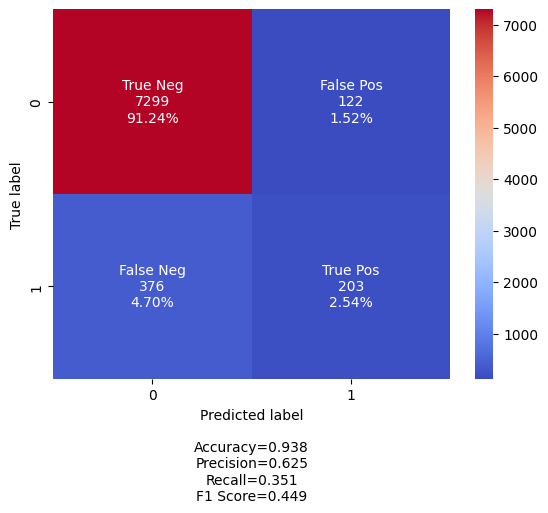

In [ ]:
# view confusion matrix
# the F1-score doesn't show but that's ok
cf_matrix_2=confusion_matrix(y_2_test,y_2_pred)
labels=['True Neg','False Pos','False Neg','True Pos']
make_confusion_matrix(cf=cf_matrix_2,
                      group_names=labels,
                      cmap='coolwarm')

In [ ]:
# view F1-score
creport=classification_report(y_test,y_2_pred)
print(creport)

              precision    recall  f1-score   support

          no       0.95      0.98      0.97      7421
         yes       0.62      0.35      0.45       579

    accuracy                           0.94      8000
   macro avg       0.79      0.67      0.71      8000
weighted avg       0.93      0.94      0.93      8000



This is also a great result.

## Layer 3: Clustering

## Modeling on full dataset

In [302]:
X=df[[col for col in df.columns if col != 'y']]
y=df['y']

In [309]:
y=y.map({'yes':1,'no':0})

In [310]:
X.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  
0  unknown    5   may       261         1  
1  unknown    5   may       151         1  
2  unknown    5   may        76         1  
3  unknown    5   may        92         1  
4  unknown    5   may       198         1

In [311]:
data=pd.concat([X,y],axis=1)

In [319]:
cat_cols = list(X.select_dtypes(include='object').columns)
cat_cols.append('day')
print(f'cat_cols:{cat_cols}')

num_cols = list(X.select_dtypes(exclude='object').columns)
num_cols.remove('day')
print(f'num_cols:{num_cols}')

cat_cols:['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day']
num_cols:['age', 'balance', 'duration', 'campaign']


Data is split

Evaluating etc...
Pipeline is created
Evaluating model...
Cross-validation recall scores: [0.3174946  0.33693305 0.30885529 0.34051724 0.36206897]
Mean recall: 0.3332
Fitting model...
Making predictions on training set...

Training Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29683
           1       1.00      1.00      1.00      2317

    accuracy                           1.00     32000
   macro avg       1.00      1.00      1.00     32000
weighted avg       1.00      1.00      1.00     32000

Making predictions on testing set...

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7421
           1       0.38      0.36      0.37       579

    accuracy                           0.91      8000
   macro avg       0.66      0.66      0.66      8000
weighted avg       0.91      0.91      0.91      8000



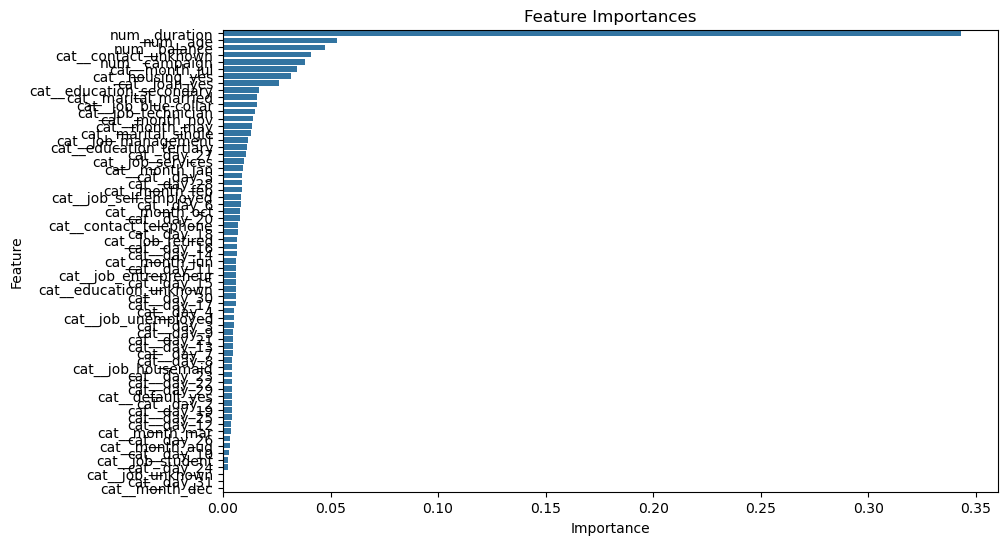


Evaluating xgb...
Pipeline is created
Evaluating model...
Cross-validation recall scores: [0.7537797  0.76241901 0.75161987 0.75       0.71767241]
Mean recall: 0.7471
Fitting model...
Making predictions on training set...

Training Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97     29683
           1       0.54      1.00      0.70      2317

    accuracy                           0.94     32000
   macro avg       0.77      0.96      0.83     32000
weighted avg       0.97      0.94      0.95     32000

Making predictions on testing set...

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      7421
           1       0.43      0.80      0.56       579

    accuracy                           0.91      8000
   macro avg       0.70      0.86      0.75      8000
weighted avg       0.94      0.91      0.92      8000



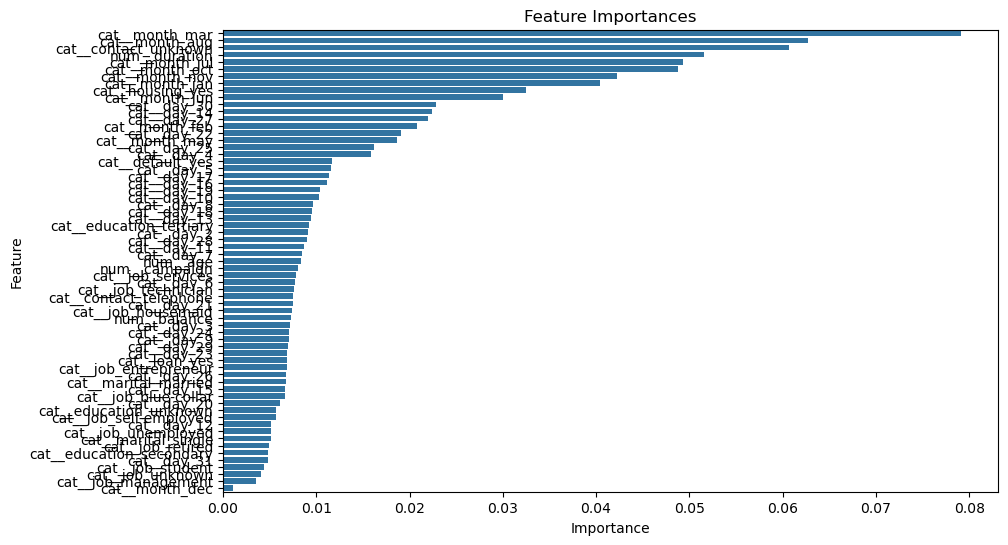


Evaluating dtc...
Pipeline is created
Evaluating model...
Cross-validation recall scores: [0.40388769 0.38444924 0.38660907 0.42672414 0.38793103]
Mean recall: 0.3979
Fitting model...
Making predictions on training set...

Training Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29683
           1       1.00      1.00      1.00      2317

    accuracy                           1.00     32000
   macro avg       1.00      1.00      1.00     32000
weighted avg       1.00      1.00      1.00     32000

Making predictions on testing set...

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      7421
           1       0.42      0.44      0.43       579

    accuracy                           0.91      8000
   macro avg       0.69      0.70      0.69      8000
weighted avg       0.92      0.91      0.92      8000



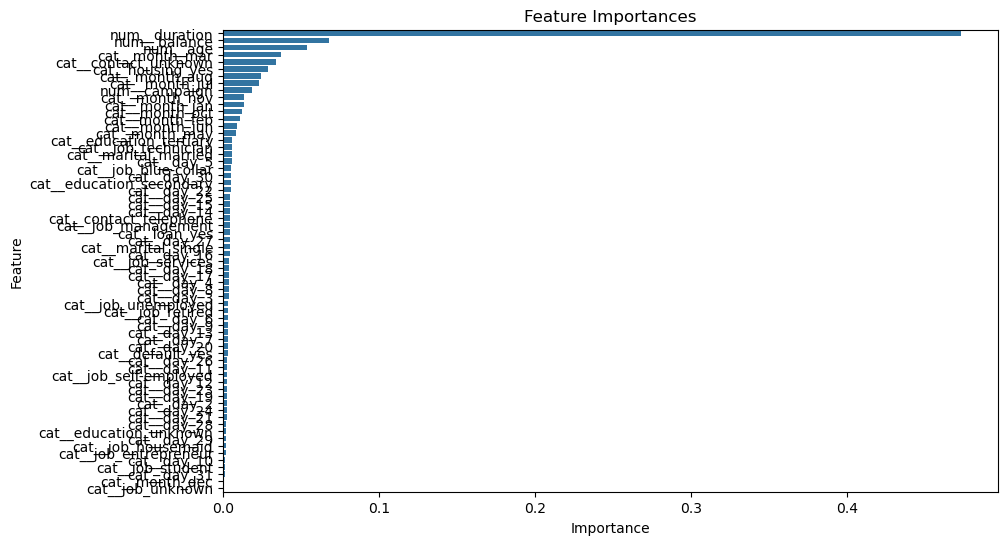


Evaluating rfc...
Pipeline is created
Evaluating model...
Cross-validation recall scores: [0.39956803 0.39308855 0.37796976 0.39224138 0.40517241]
Mean recall: 0.3936
Fitting model...
Making predictions on training set...

Training Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29683
           1       1.00      1.00      1.00      2317

    accuracy                           1.00     32000
   macro avg       1.00      1.00      1.00     32000
weighted avg       1.00      1.00      1.00     32000

Making predictions on testing set...

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7421
           1       0.59      0.46      0.52       579

    accuracy                           0.94      8000
   macro avg       0.78      0.72      0.74      8000
weighted avg       0.93      0.94      0.93      8000



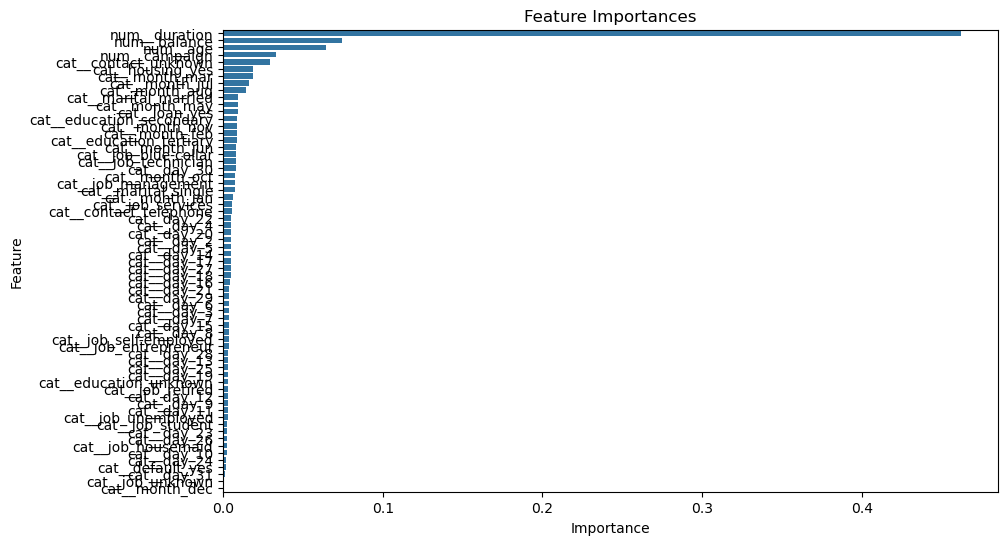


Evaluating lgb...
Pipeline is created
Evaluating model...
Cross-validation recall scores: [0.87688985 0.88336933 0.85529158 0.87715517 0.85560345]
Mean recall: 0.8697
Fitting model...
Making predictions on training set...

Training Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     29683
           1       0.41      0.97      0.57      2317

    accuracy                           0.89     32000
   macro avg       0.70      0.93      0.76     32000
weighted avg       0.95      0.89      0.91     32000

Making predictions on testing set...

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      7421
           1       0.38      0.89      0.53       579

    accuracy                           0.89      8000
   macro avg       0.68      0.89      0.73      8000
weighted avg       0.95      0.89      0.91      8000



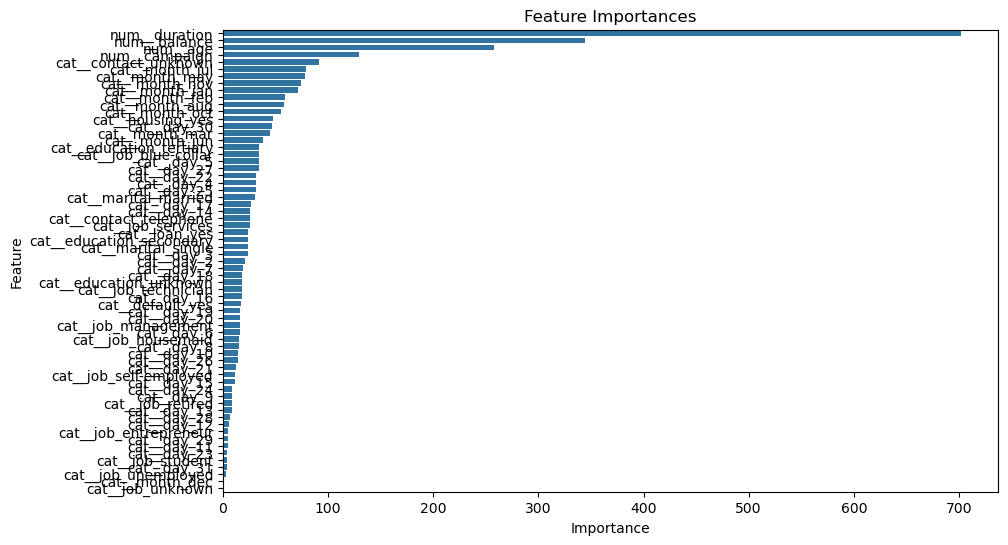


Evaluating lrx...
Pipeline is created
Evaluating model...
Cross-validation recall scores: [0.85961123 0.87041037 0.84233261 0.875      0.8512931 ]
Mean recall: 0.8597
Fitting model...
Making predictions on training set...

Training Set Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.87      0.92     29683
           1       0.34      0.87      0.49      2317

    accuracy                           0.87     32000
   macro avg       0.67      0.87      0.71     32000
weighted avg       0.94      0.87      0.89     32000

Making predictions on testing set...

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      7421
           1       0.35      0.88      0.50       579

    accuracy                           0.87      8000
   macro avg       0.67      0.88      0.72      8000
weighted avg       0.94      0.87      0.90      8000


Done!


In [321]:
target_column_name = 'y'

# Split the data
X_train, X_test, y_train, y_test = split_data(data=data, target_column_name='y',random_state=seed)

# Evaluate models
for model_name, model in classifier_map.items():
    print(f"\nEvaluating {model_name}...")
    
    # Create a pipeline for each model
    pipeline = create_pipeline(model,cat_cols,random_state=seed)
    
    # Evaluate using cross-validation on the training set
    evaluate_model(pipeline,X_train,y_train,random_state=seed)
    
    # Perform final evaluation on the test set
    final_evaluation(pipeline,X_train,y_train,X_test,y_test)

print("\nDone!")